## Data: Head position

In [1]:
from tensorflow.python.client import device_lib
print(device_lib.list_local_devices())

[name: "/device:CPU:0"
device_type: "CPU"
memory_limit: 268435456
locality {
}
incarnation: 12512446063492824278
, name: "/device:GPU:0"
device_type: "GPU"
memory_limit: 6687073895
locality {
  bus_id: 1
  links {
  }
}
incarnation: 6768089780024958353
physical_device_desc: "device: 0, name: GeForce GTX 1080, pci bus id: 0000:01:00.0, compute capability: 6.1"
]


In [2]:
# Create your first MLP in Keras
import os, sys
import numpy as np
import time
from scipy import interpolate
from utils.convert_coord import equirect_to_cart, cart_to_equirect
from utils.data_generator_seq2seq import data_generator_head_seq2seq_decoder_zeros
import matplotlib.pyplot as plt
%matplotlib inline
import random as rn

from keras.models import Model
from keras.layers import Input, Dense, Concatenate, CuDNNLSTM, \
    Conv1D, MaxPooling1D, Flatten, TimeDistributed, Reshape
from keras.optimizers import Adam
from keras.callbacks import TensorBoard, EarlyStopping, ModelCheckpoint
from keras import backend as K
import keras
from keras.utils.generic_utils import get_custom_objects
import tensorflow as tf
from keras.utils import plot_model

from attention_keras.layers.attention import AttentionLayer

## reproducibility
os.environ['PYTHONHASHSEED'] = '0'
# The below is necessary for starting Numpy generated random numbers in a well-defined initial state.
# fix random seed for reproducibility
seed = 7 #42
np.random.seed(seed)
# The below is necessary for starting core Python generated random numbers in a well-defined state.
rn.seed(12345)
# Force TensorFlow to use single thread. Multiple threads are a potential source of non-reproducible results.
# For further details, see: https://stackoverflow.com/questions/42022950/which-seeds-have-to-be-set-where-to-realize-100-reproducibility-of-training-res
session_conf = tf.ConfigProto(intra_op_parallelism_threads=1, inter_op_parallelism_threads=1)
# The below tf.set_random_seed() will make random number generation in the TensorFlow backend have a well-defined initial state.
# For further details, see: https://www.tensorflow.org/api_docs/python/tf/set_random_seed
tf.set_random_seed(1234)
sess = tf.Session(graph=tf.get_default_graph(), config=session_conf)
K.set_session(sess)

print("python: {}, keras: {}, tensorflow: {}".format(sys.version, keras.__version__, tf.__version__))

dir_path = os.getcwd()

python: 3.5.2 (default, Oct  8 2019, 13:06:37) 
[GCC 5.4.0 20160609], keras: 2.2.4, tensorflow: 1.8.0


Using TensorFlow backend.


In [3]:
experiment_name = 'final_seq2seq_decoder_zeros_attention_5-128'

time_step = 10 # 10 ms
lookback = 250 # 250 ms
n_lookback = int(round(lookback / time_step))

step_delay = 100
n_delay = int(round(step_delay / time_step))
delays_list = list(range(100, 1000+1, step_delay))
n_max_delay = int(round(np.max(delays_list) / time_step))

len_delay = len(delays_list)

# HARD CODED MAXIMUM DIFFERENCES
MAX_DIFF = np.array([1.95763439, 0.06364631, 1.99985595])

In [4]:
K.clear_session()

# create model
encoder_inputs = Input(shape=(n_lookback, 3))
latent_dim = 128 # LSTM hidden units

# Define an input series and encode it with an LSTM.
encoder_1, h1, c1 = CuDNNLSTM(units=latent_dim, return_state=True, return_sequences=True)(encoder_inputs)
encoder_2, h2, c2 = CuDNNLSTM(units=latent_dim, return_state=True, return_sequences=True)(encoder_1)
encoder_3, h3, c3 = CuDNNLSTM(units=latent_dim, return_state=True, return_sequences=True)(encoder_2)
encoder_4, h4, c4 = CuDNNLSTM(units=latent_dim, return_state=True, return_sequences=True)(encoder_3)
encoder_5, h5, c5 = CuDNNLSTM(units=latent_dim, return_state=True, return_sequences=True)(encoder_4)

# We discard `encoder_outputs` and only keep the final states. These represent the "context"
# vector that we use as the basis for decoding.
encoder_states = [h1, c1, h2, c2, h3, c3, h4, c4, h5, c5]

# Set up the decoder, using `encoder_states` as initial state.
# This is where teacher forcing inputs are fed in.
decoder_inputs = Input(shape=(len_delay, 3))

# We set up our decoder using `encoder_states` as initial state.  
# We return full output sequences and return internal states as well. 
# We don't use the return states in the training model, but we will use them in inference.

decoder_1 = CuDNNLSTM(units=latent_dim, return_state=True, return_sequences=True)
decoder_outputs_1, dh1, dc1 = decoder_1(decoder_inputs, initial_state=[h1, c1])

decoder_2 = CuDNNLSTM(units=latent_dim, return_state=True, return_sequences=True)
decoder_outputs_2, dh2, dc2 = decoder_2(decoder_outputs_1, initial_state=[h2, c2])

decoder_3 = CuDNNLSTM(units=latent_dim, return_state=True, return_sequences=True)
decoder_outputs_3, dh3, dc3 = decoder_3(decoder_outputs_2, initial_state=[h3, c3])

decoder_4 = CuDNNLSTM(units=latent_dim, return_state=True, return_sequences=True)
decoder_outputs_4, dh4, dc4 = decoder_4(decoder_outputs_3, initial_state=[h4, c4])

decoder_5 = CuDNNLSTM(units=latent_dim, return_state=True, return_sequences=True)
decoder_outputs_5, dh5, dc5 = decoder_5(decoder_outputs_4, initial_state=[h5, c5])

attn_layer = AttentionLayer(name='attention_layer')
attn_out, attn_states = attn_layer([encoder_5, decoder_outputs_5])
decoder_concat_input = Concatenate()([decoder_outputs_5, attn_out])

dense_1 = TimeDistributed(Dense(latent_dim, activation="relu"))
dense_1_outputs = dense_1(decoder_concat_input)
dense_2 = TimeDistributed(Dense(3))
decoder_outputs = dense_2(dense_1_outputs)

# Define the model that will turn
# `encoder_input_data` & `decoder_input_data` into `decoder_target_data`
print(decoder_outputs.shape)
model = Model(inputs=[encoder_inputs, decoder_inputs], outputs=decoder_outputs)


# Compile model
#adam = Adam(lr=0.01)
def rmse(y_true, y_pred):
    return K.sqrt(K.mean(K.square(y_pred - y_true)))

def smape(y_true, y_pred):
    return 100 * K.mean(K.abs(y_pred - y_true) / (K.abs(y_true) + K.abs(y_pred)))

def mfe(y_true, y_pred):
    return K.mean(y_pred - y_true)

model.compile(loss='mae', optimizer="adam", metrics=[rmse, smape, mfe])

print(model.summary())

(?, 10, 3)
Model: "model_1"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            (None, 25, 3)        0                                            
__________________________________________________________________________________________________
input_2 (InputLayer)            (None, 10, 3)        0                                            
__________________________________________________________________________________________________
cu_dnnlstm_1 (CuDNNLSTM)        [(None, 25, 128), (N 68096       input_1[0][0]                    
__________________________________________________________________________________________________
cu_dnnlstm_6 (CuDNNLSTM)        [(None, 10, 128), (N 68096       input_2[0][0]                    
                                                                 cu_dnnlstm_1[0][

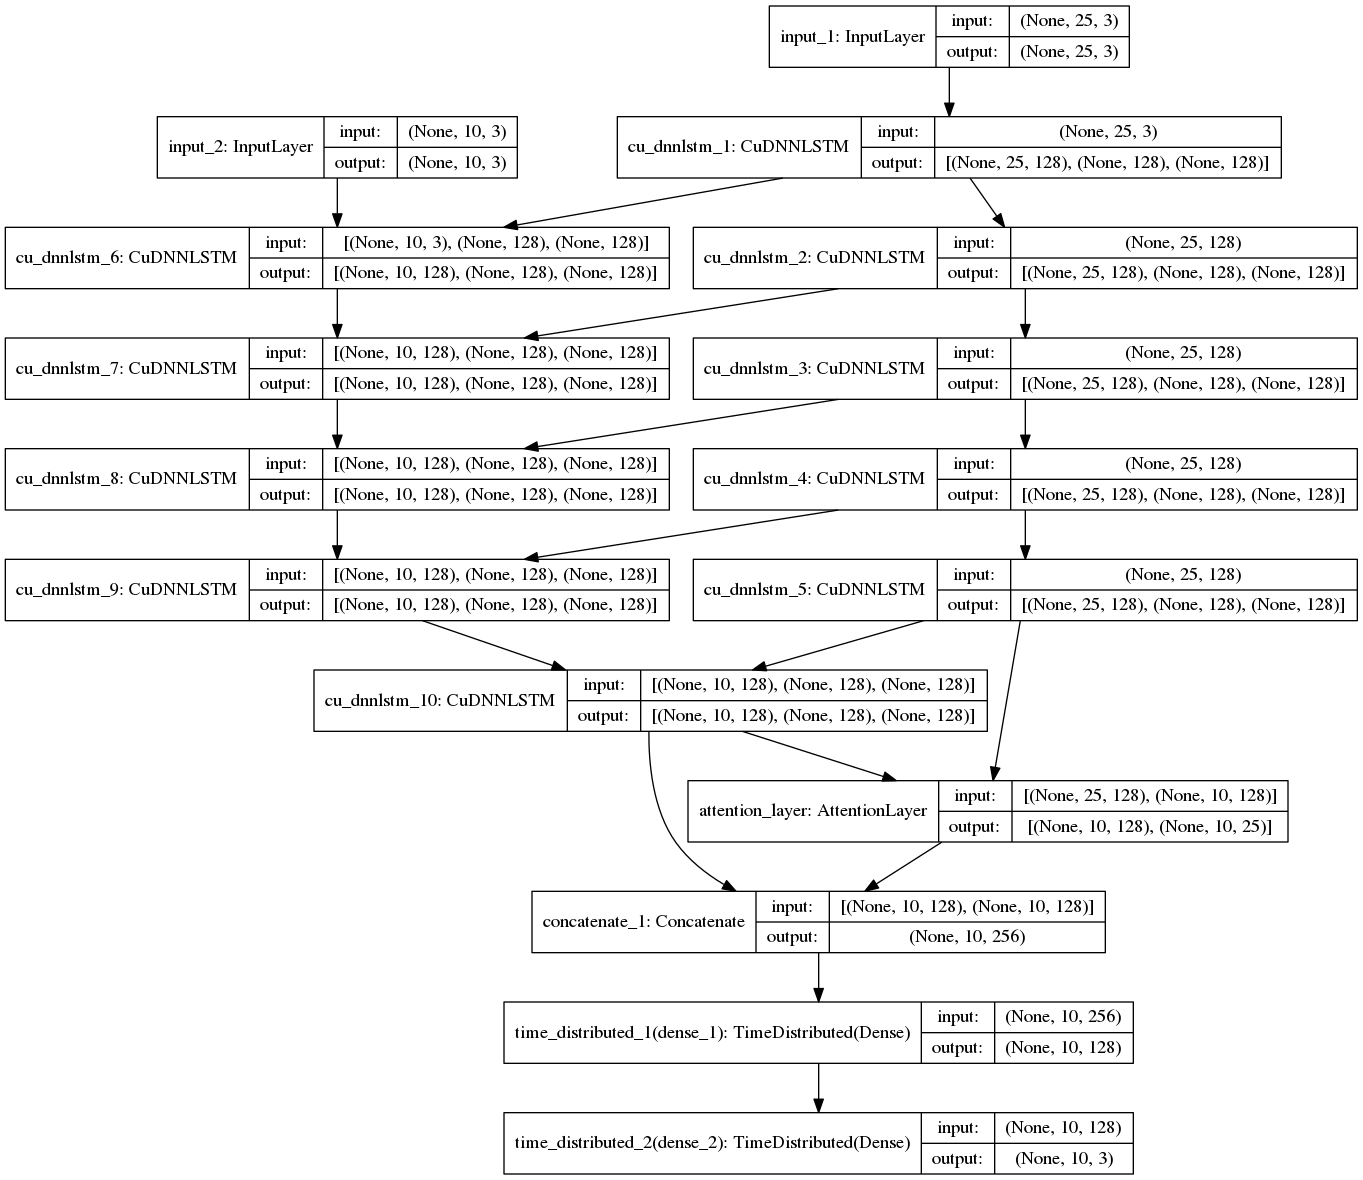

In [5]:
plot_model(model, to_file=experiment_name+'.png', show_shapes=True)

In [6]:
tensorboard_callback = TensorBoard(log_dir='./tensorboard_logs',
                                   histogram_freq=0,
                                   write_graph=True,
                                   write_grads=True,
                                   write_images=True,
                                   embeddings_freq=0,
                                   embeddings_layer_names=None,
                                   embeddings_metadata=None)

earlystopping_callback = EarlyStopping(monitor='val_loss',
                                       min_delta=0,
                                       patience=15,
                                       verbose=1,
                                       mode='auto')

modelcheckpoint_callback = ModelCheckpoint(filepath=experiment_name+'.hdf5',
                                           save_best_only=True,
                                           monitor='val_loss',
                                           mode='min')

In [7]:
saliency_dir = os.path.join(dir_path, "fov_images", "saliency")
#videos = os.listdir(saliency_dir) 
#print(videos)

path_to_sensor_data_train = os.path.join(dir_path, "preprocessed_train")
videos = os.listdir(path_to_sensor_data_train)
videos = videos
print(videos)
video_width = 3840

['013_13_times_square_static.npy', '025_07_factory_robots_static.npy', '002_01_art_gallery_static.npy', '002_02_theatre_scene_static.npy', '002_03_lions_static_cuts.npy', '002_04_copenhagen_harbour_static_cuts.npy', '002_07_factory_robots_static.npy', '002_09_elephants_static.npy', '002_12_gym_workout_static.npy', '002_13_times_square_static.npy', '002_14_new_orleans_drive_motion.npy', '002_16_interview_static.npy', '002_17_weather_forecast_static.npy', '002_18_bomb_trapped_static.npy', '002_20_car_fix_static.npy', '002_23_dog_food_factory_motion.npy', '003_01_art_gallery_static.npy', '003_02_theatre_scene_static.npy', '003_03_lions_static_cuts.npy', '003_04_copenhagen_harbour_static_cuts.npy', '003_05_florida_yacht_motion.npy', '003_07_factory_robots_static.npy', '003_08_madagascar_cuts.npy', '003_09_elephants_static.npy', '003_11_lohdi_garden_india_cuts.npy', '003_12_gym_workout_static.npy', '003_13_times_square_static.npy', '003_14_new_orleans_drive_motion.npy', '003_18_bomb_trapped

In [8]:
use_generator = True
if use_generator:
    nb_epochs = 100
    start = time.time()
    
    perc_train = 0.8
    ind_max_train = int(np.round(len(videos) * perc_train))
    file_names_train = videos[:ind_max_train]
    file_names_val = videos[ind_max_train:]
    #data = np.load(os.path.join(path_to_sensor_data_train, file_name))

    train_gen = data_generator_head_seq2seq_decoder_zeros(path_to_sensor_data_train,
                                    file_names_train,
                                    delays_list,
                                    n_max_delay,
                                    n_lookback,
                                    n_delay)
    val_gen = data_generator_head_seq2seq_decoder_zeros(path_to_sensor_data_train,
                                  file_names_val,
                                  delays_list,
                                  n_max_delay,
                                  n_lookback,
                                  n_delay)

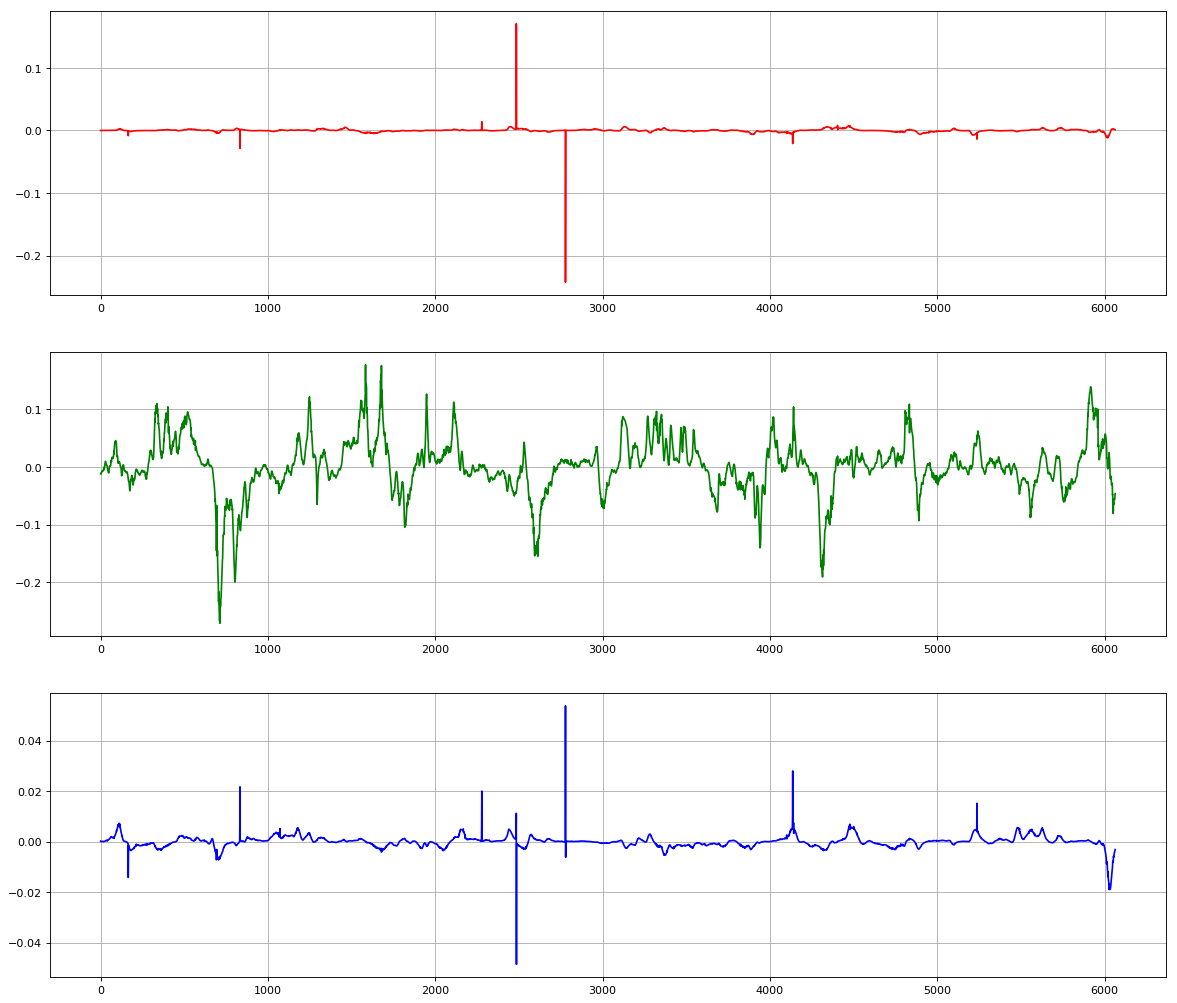

In [9]:
[encoder_input, decoder_input], Y_train = next(train_gen)

fig=plt.figure(figsize=(18, 16), dpi= 80)

plt.subplot(311)
plt.plot(encoder_input[:,0,0], c='r')
plt.grid(True)

plt.subplot(312)
plt.plot(encoder_input[:,0,1], c='g')
plt.grid(True)

plt.subplot(313)
plt.plot(encoder_input[:,0,2], c='b')
plt.grid(True)

In [10]:
history = model.fit_generator(train_gen,
                    steps_per_epoch=ind_max_train,
                    epochs=nb_epochs,
                    callbacks=[
                               tensorboard_callback,
                               earlystopping_callback,
                               modelcheckpoint_callback],
                    verbose=1,
                    shuffle=True,
                    validation_data=val_gen,
                    validation_steps=len(videos) - ind_max_train)
print("Time:", time.time() - start, "s = ",(time.time() - start)/60., "min")

print("Training Time : ", time.time() - start, "s = ", (time.time() - start)/60., "min = ",
      (time.time() - start)/3600., "h")

Epoch 1/100


  1/542 [..............................] - ETA: 18:32 - loss: 0.0451 - rmse: 0.1266 - smape: 97.4101 - mfe: 0.0030

  2/542 [..............................] - ETA: 11:02 - loss: 0.0666 - rmse: 0.1632 - smape: 86.9818 - mfe: -0.0031

  3/542 [..............................] - ETA: 8:30 - loss: 0.0640 - rmse: 0.1716 - smape: 84.3974 - mfe: -0.0044 

  4/542 [..............................] - ETA: 7:16 - loss: 0.0594 - rmse: 0.1574 - smape: 84.4110 - mfe: -0.0035

  5/542 [..............................] - ETA: 6:24 - loss: 0.0642 - rmse: 0.1679 - smape: 84.2203 - mfe: -0.0031

  6/542 [..............................] - ETA: 5:55 - loss: 0.0621 - rmse: 0.1611 - smape: 83.7517 - mfe: -0.0027

  7/542 [..............................] - ETA: 5:34 - loss: 0.0550 - rmse: 0.1419 - smape: 83.7056 - mfe: -0.0017

  8/542 [..............................] - ETA: 5:18 - loss: 0.0543 - rmse: 0.1385 - smape: 84.0111 - mfe: -0.0020

  9/542 [..............................] - ETA: 5:05 - loss: 0.0520 - rmse: 0.1310 - smape: 83.7888 - mfe: -0.0022

 10/542 [..............................] - ETA: 4:54 - loss: 0.0529 - rmse: 0.1404 - smape: 83.5783 - mfe: -0.0026

 11/542 [..............................] - ETA: 4:46 - loss: 0.0517 - rmse: 0.1352 - smape: 83.5154 - mfe: -0.0025

 12/542 [..............................] - ETA: 4:40 - loss: 0.0542 - rmse: 0.1435 - smape: 84.0142 - mfe: -0.0026

 13/542 [..............................] - ETA: 4:34 - loss: 0.0524 - rmse: 0.1398 - smape: 84.0977 - mfe: -0.0025

 14/542 [..............................] - ETA: 4:27 - loss: 0.0538 - rmse: 0.1427 - smape: 84.3287 - mfe: -0.0024

 15/542 [..............................] - ETA: 4:22 - loss: 0.0529 - rmse: 0.1401 - smape: 84.1515 - mfe: -0.0022

 16/542 [..............................] - ETA: 4:18 - loss: 0.0557 - rmse: 0.1471 - smape: 84.3431 - mfe: -0.0019

 17/542 [..............................] - ETA: 4:13 - loss: 0.0538 - rmse: 0.1418 - smape: 84.3817 - mfe: -0.0019

 18/542 [..............................] - ETA: 4:10 - loss: 0.0531 - rmse: 0.1404 - smape: 84.5491 - mfe: -0.0017

 19/542 [>.............................] - ETA: 4:07 - loss: 0.0551 - rmse: 0.1458 - smape: 84.7366 - mfe: -0.0018

 20/542 [>.............................] - ETA: 4:05 - loss: 0.0572 - rmse: 0.1494 - smape: 84.8017 - mfe: -0.0019

 21/542 [>.............................] - ETA: 4:03 - loss: 0.0572 - rmse: 0.1492 - smape: 84.6164 - mfe: -0.0021

 22/542 [>.............................] - ETA: 4:01 - loss: 0.0583 - rmse: 0.1511 - smape: 84.5900 - mfe: -0.0024

 23/542 [>.............................] - ETA: 3:59 - loss: 0.0607 - rmse: 0.1570 - smape: 84.6640 - mfe: -0.0025

 24/542 [>.............................] - ETA: 3:57 - loss: 0.0623 - rmse: 0.1606 - smape: 84.7796 - mfe: -0.0025

 25/542 [>.............................] - ETA: 3:55 - loss: 0.0624 - rmse: 0.1617 - smape: 84.7048 - mfe: -0.0026

 26/542 [>.............................] - ETA: 3:56 - loss: 0.0656 - rmse: 0.1715 - smape: 84.7022 - mfe: -0.0025

 27/542 [>.............................] - ETA: 3:54 - loss: 0.0651 - rmse: 0.1714 - smape: 84.8064 - mfe: -0.0024

 28/542 [>.............................] - ETA: 3:52 - loss: 0.0644 - rmse: 0.1708 - smape: 84.8886 - mfe: -0.0023

 29/542 [>.............................] - ETA: 3:52 - loss: 0.0629 - rmse: 0.1668 - smape: 84.8979 - mfe: -0.0023

 30/542 [>.............................] - ETA: 3:51 - loss: 0.0620 - rmse: 0.1663 - smape: 84.8326 - mfe: -0.0022

 31/542 [>.............................] - ETA: 3:50 - loss: 0.0618 - rmse: 0.1657 - smape: 84.9632 - mfe: -0.0021

 32/542 [>.............................] - ETA: 3:49 - loss: 0.0614 - rmse: 0.1670 - smape: 84.9631 - mfe: -0.0020

 33/542 [>.............................] - ETA: 3:47 - loss: 0.0621 - rmse: 0.1690 - smape: 85.0191 - mfe: -0.0020

 34/542 [>.............................] - ETA: 3:46 - loss: 0.0619 - rmse: 0.1680 - smape: 85.1558 - mfe: -0.0019

 35/542 [>.............................] - ETA: 3:45 - loss: 0.0604 - rmse: 0.1638 - smape: 85.0527 - mfe: -0.0019

 36/542 [>.............................] - ETA: 3:43 - loss: 0.0593 - rmse: 0.1610 - smape: 85.0444 - mfe: -0.0019

 37/542 [=>............................] - ETA: 3:42 - loss: 0.0606 - rmse: 0.1652 - smape: 85.0892 - mfe: -0.0017

 38/542 [=>............................] - ETA: 3:41 - loss: 0.0602 - rmse: 0.1659 - smape: 85.0007 - mfe: -0.0016

 39/542 [=>............................] - ETA: 3:40 - loss: 0.0610 - rmse: 0.1678 - smape: 85.1159 - mfe: -0.0015

 40/542 [=>............................] - ETA: 3:40 - loss: 0.0613 - rmse: 0.1679 - smape: 85.0740 - mfe: -0.0014

 41/542 [=>............................] - ETA: 3:39 - loss: 0.0612 - rmse: 0.1676 - smape: 85.2248 - mfe: -0.0014

 42/542 [=>............................] - ETA: 3:38 - loss: 0.0607 - rmse: 0.1661 - smape: 85.2704 - mfe: -0.0014

 43/542 [=>............................] - ETA: 3:37 - loss: 0.0617 - rmse: 0.1695 - smape: 85.3592 - mfe: -0.0014

 44/542 [=>............................] - ETA: 3:34 - loss: 0.0621 - rmse: 0.1699 - smape: 85.4429 - mfe: -0.0014

 45/542 [=>............................] - ETA: 3:33 - loss: 0.0631 - rmse: 0.1724 - smape: 85.4967 - mfe: -0.0013

 46/542 [=>............................] - ETA: 3:33 - loss: 0.0628 - rmse: 0.1728 - smape: 85.3753 - mfe: -0.0013

 47/542 [=>............................] - ETA: 3:32 - loss: 0.0629 - rmse: 0.1734 - smape: 85.3434 - mfe: -0.0013

 48/542 [=>............................] - ETA: 3:31 - loss: 0.0632 - rmse: 0.1748 - smape: 85.3497 - mfe: -0.0013

 49/542 [=>............................] - ETA: 3:30 - loss: 0.0630 - rmse: 0.1755 - smape: 85.3311 - mfe: -0.0012

 50/542 [=>............................] - ETA: 3:30 - loss: 0.0632 - rmse: 0.1770 - smape: 85.2614 - mfe: -0.0011

 51/542 [=>............................] - ETA: 3:29 - loss: 0.0635 - rmse: 0.1777 - smape: 85.2764 - mfe: -0.0011

 52/542 [=>............................] - ETA: 3:28 - loss: 0.0632 - rmse: 0.1775 - smape: 85.1505 - mfe: -0.0010

 53/542 [=>............................] - ETA: 3:28 - loss: 0.0647 - rmse: 0.1817 - smape: 85.1673 - mfe: -0.0010

 54/542 [=>............................] - ETA: 3:27 - loss: 0.0642 - rmse: 0.1800 - smape: 85.0949 - mfe: -0.0011

 55/542 [==>...........................] - ETA: 3:26 - loss: 0.0642 - rmse: 0.1800 - smape: 85.0630 - mfe: -9.6910e-04

 56/542 [==>...........................] - ETA: 3:26 - loss: 0.0646 - rmse: 0.1809 - smape: 85.0338 - mfe: -8.8631e-04

 57/542 [==>...........................] - ETA: 3:25 - loss: 0.0643 - rmse: 0.1802 - smape: 85.0034 - mfe: -9.2445e-04

 58/542 [==>...........................] - ETA: 3:24 - loss: 0.0650 - rmse: 0.1815 - smape: 84.9918 - mfe: -9.1511e-04

 59/542 [==>...........................] - ETA: 3:23 - loss: 0.0647 - rmse: 0.1803 - smape: 84.9486 - mfe: -8.3401e-04

 60/542 [==>...........................] - ETA: 3:22 - loss: 0.0641 - rmse: 0.1787 - smape: 84.9018 - mfe: -7.7678e-04

 61/542 [==>...........................] - ETA: 3:22 - loss: 0.0634 - rmse: 0.1769 - smape: 84.8450 - mfe: -8.5494e-04

 62/542 [==>...........................] - ETA: 3:21 - loss: 0.0633 - rmse: 0.1765 - smape: 84.8036 - mfe: -8.8451e-04

 63/542 [==>...........................] - ETA: 3:21 - loss: 0.0634 - rmse: 0.1770 - smape: 84.7477 - mfe: -8.8676e-04

 64/542 [==>...........................] - ETA: 3:20 - loss: 0.0636 - rmse: 0.1775 - smape: 84.7064 - mfe: -8.6657e-04

 65/542 [==>...........................] - ETA: 3:19 - loss: 0.0641 - rmse: 0.1786 - smape: 84.6401 - mfe: -8.2471e-04

 66/542 [==>...........................] - ETA: 3:18 - loss: 0.0640 - rmse: 0.1781 - smape: 84.6097 - mfe: -7.3757e-04

 67/542 [==>...........................] - ETA: 3:18 - loss: 0.0634 - rmse: 0.1762 - smape: 84.5806 - mfe: -6.7741e-04

 68/542 [==>...........................] - ETA: 3:17 - loss: 0.0642 - rmse: 0.1777 - smape: 84.5716 - mfe: -6.4214e-04

 69/542 [==>...........................] - ETA: 3:17 - loss: 0.0641 - rmse: 0.1774 - smape: 84.5613 - mfe: -6.1972e-04

 70/542 [==>...........................] - ETA: 3:16 - loss: 0.0649 - rmse: 0.1787 - smape: 84.5284 - mfe: -5.5004e-04

 71/542 [==>...........................] - ETA: 3:16 - loss: 0.0654 - rmse: 0.1795 - smape: 84.4706 - mfe: -4.3503e-04

 72/542 [==>...........................] - ETA: 3:15 - loss: 0.0657 - rmse: 0.1798 - smape: 84.3992 - mfe: -3.5631e-04

 73/542 [===>..........................] - ETA: 3:15 - loss: 0.0655 - rmse: 0.1796 - smape: 84.3405 - mfe: -4.2211e-04

 74/542 [===>..........................] - ETA: 3:14 - loss: 0.0659 - rmse: 0.1809 - smape: 84.3318 - mfe: -3.9196e-04

 75/542 [===>..........................] - ETA: 3:14 - loss: 0.0659 - rmse: 0.1811 - smape: 84.2896 - mfe: -3.7567e-04

 76/542 [===>..........................] - ETA: 3:13 - loss: 0.0662 - rmse: 0.1819 - smape: 84.2242 - mfe: -3.2266e-04

 77/542 [===>..........................] - ETA: 3:13 - loss: 0.0664 - rmse: 0.1820 - smape: 84.2314 - mfe: -3.2315e-04

 78/542 [===>..........................] - ETA: 3:12 - loss: 0.0657 - rmse: 0.1807 - smape: 84.2194 - mfe: -3.2582e-04

 79/542 [===>..........................] - ETA: 3:12 - loss: 0.0654 - rmse: 0.1802 - smape: 84.2206 - mfe: -2.9552e-04

 80/542 [===>..........................] - ETA: 3:11 - loss: 0.0650 - rmse: 0.1790 - smape: 84.2388 - mfe: -2.6977e-04

 81/542 [===>..........................] - ETA: 3:11 - loss: 0.0651 - rmse: 0.1792 - smape: 84.2282 - mfe: -2.5407e-04

 82/542 [===>..........................] - ETA: 3:11 - loss: 0.0652 - rmse: 0.1790 - smape: 84.2344 - mfe: -2.0213e-04

 83/542 [===>..........................] - ETA: 3:10 - loss: 0.0658 - rmse: 0.1807 - smape: 84.2641 - mfe: -1.8856e-04

 84/542 [===>..........................] - ETA: 3:10 - loss: 0.0658 - rmse: 0.1807 - smape: 84.2891 - mfe: -1.6008e-04

 85/542 [===>..........................] - ETA: 3:09 - loss: 0.0655 - rmse: 0.1802 - smape: 84.2744 - mfe: -1.6055e-04

 86/542 [===>..........................] - ETA: 3:08 - loss: 0.0654 - rmse: 0.1796 - smape: 84.2983 - mfe: -1.8836e-04

 87/542 [===>..........................] - ETA: 3:08 - loss: 0.0655 - rmse: 0.1798 - smape: 84.2547 - mfe: -1.8398e-04

 88/542 [===>..........................] - ETA: 3:08 - loss: 0.0651 - rmse: 0.1787 - smape: 84.2418 - mfe: -1.8300e-04

 89/542 [===>..........................] - ETA: 3:07 - loss: 0.0653 - rmse: 0.1792 - smape: 84.2447 - mfe: -1.7223e-04

 90/542 [===>..........................] - ETA: 3:07 - loss: 0.0651 - rmse: 0.1786 - smape: 84.2277 - mfe: -1.7516e-04

 91/542 [====>.........................] - ETA: 3:06 - loss: 0.0652 - rmse: 0.1788 - smape: 84.2391 - mfe: -1.5735e-04

 92/542 [====>.........................] - ETA: 3:06 - loss: 0.0653 - rmse: 0.1791 - smape: 84.1783 - mfe: -1.1179e-04

 93/542 [====>.........................] - ETA: 3:05 - loss: 0.0657 - rmse: 0.1796 - smape: 84.1888 - mfe: -1.1454e-04

 94/542 [====>.........................] - ETA: 3:04 - loss: 0.0662 - rmse: 0.1809 - smape: 84.1948 - mfe: -1.3833e-04

 95/542 [====>.........................] - ETA: 3:04 - loss: 0.0658 - rmse: 0.1800 - smape: 84.1749 - mfe: -1.6479e-04

 96/542 [====>.........................] - ETA: 3:04 - loss: 0.0657 - rmse: 0.1799 - smape: 84.1706 - mfe: -1.2570e-04

 97/542 [====>.........................] - ETA: 3:03 - loss: 0.0657 - rmse: 0.1797 - smape: 84.1798 - mfe: -1.2025e-04

 98/542 [====>.........................] - ETA: 3:03 - loss: 0.0656 - rmse: 0.1792 - smape: 84.1946 - mfe: -1.0687e-04

 99/542 [====>.........................] - ETA: 3:02 - loss: 0.0653 - rmse: 0.1787 - smape: 84.1850 - mfe: -7.5338e-05

100/542 [====>.........................] - ETA: 3:02 - loss: 0.0654 - rmse: 0.1785 - smape: 84.2063 - mfe: -5.6683e-05

101/542 [====>.........................] - ETA: 3:01 - loss: 0.0651 - rmse: 0.1777 - smape: 84.1806 - mfe: -3.8613e-05

102/542 [====>.........................] - ETA: 3:01 - loss: 0.0651 - rmse: 0.1778 - smape: 84.1619 - mfe: -3.7349e-05

103/542 [====>.........................] - ETA: 3:00 - loss: 0.0645 - rmse: 0.1763 - smape: 84.1411 - mfe: -3.7088e-05

104/542 [====>.........................] - ETA: 3:00 - loss: 0.0641 - rmse: 0.1750 - smape: 84.0943 - mfe: -6.1752e-05

105/542 [====>.........................] - ETA: 3:00 - loss: 0.0645 - rmse: 0.1762 - smape: 84.1136 - mfe: -4.9547e-05

106/542 [====>.........................] - ETA: 2:59 - loss: 0.0652 - rmse: 0.1781 - smape: 84.1630 - mfe: -4.2713e-05

107/542 [====>.........................] - ETA: 2:58 - loss: 0.0651 - rmse: 0.1780 - smape: 84.1849 - mfe: -4.6004e-05

108/542 [====>.........................] - ETA: 2:58 - loss: 0.0649 - rmse: 0.1775 - smape: 84.1837 - mfe: -3.0538e-05

109/542 [=====>........................] - ETA: 2:57 - loss: 0.0650 - rmse: 0.1775 - smape: 84.1878 - mfe: -1.0149e-05

110/542 [=====>........................] - ETA: 2:57 - loss: 0.0646 - rmse: 0.1763 - smape: 84.1591 - mfe: 8.9371e-06 

111/542 [=====>........................] - ETA: 2:56 - loss: 0.0644 - rmse: 0.1758 - smape: 84.1194 - mfe: -2.7810e-06

112/542 [=====>........................] - ETA: 2:55 - loss: 0.0645 - rmse: 0.1760 - smape: 84.1033 - mfe: -1.5825e-05

113/542 [=====>........................] - ETA: 2:55 - loss: 0.0645 - rmse: 0.1759 - smape: 84.0755 - mfe: -3.4294e-05

114/542 [=====>........................] - ETA: 2:54 - loss: 0.0642 - rmse: 0.1751 - smape: 84.0426 - mfe: -1.9874e-05

115/542 [=====>........................] - ETA: 2:54 - loss: 0.0643 - rmse: 0.1752 - smape: 84.0044 - mfe: -5.6779e-05

116/542 [=====>........................] - ETA: 2:54 - loss: 0.0640 - rmse: 0.1746 - smape: 83.9575 - mfe: -1.3026e-04

117/542 [=====>........................] - ETA: 2:53 - loss: 0.0638 - rmse: 0.1740 - smape: 83.9407 - mfe: -1.6517e-04

118/542 [=====>........................] - ETA: 2:53 - loss: 0.0642 - rmse: 0.1750 - smape: 83.9356 - mfe: -1.3052e-04

119/542 [=====>........................] - ETA: 2:52 - loss: 0.0648 - rmse: 0.1761 - smape: 83.9509 - mfe: -6.8753e-05

120/542 [=====>........................] - ETA: 2:52 - loss: 0.0649 - rmse: 0.1765 - smape: 83.9552 - mfe: -1.8282e-05

121/542 [=====>........................] - ETA: 2:51 - loss: 0.0652 - rmse: 0.1771 - smape: 83.9465 - mfe: 1.2265e-05 

122/542 [=====>........................] - ETA: 2:51 - loss: 0.0651 - rmse: 0.1769 - smape: 83.9196 - mfe: 2.7546e-05

123/542 [=====>........................] - ETA: 2:50 - loss: 0.0650 - rmse: 0.1768 - smape: 83.9121 - mfe: 2.3748e-05

124/542 [=====>........................] - ETA: 2:50 - loss: 0.0651 - rmse: 0.1773 - smape: 83.9096 - mfe: -1.5864e-06

125/542 [=====>........................] - ETA: 2:50 - loss: 0.0650 - rmse: 0.1769 - smape: 83.9150 - mfe: -1.5851e-05

126/542 [=====>........................] - ETA: 2:49 - loss: 0.0652 - rmse: 0.1771 - smape: 83.9126 - mfe: -4.1154e-05

127/542 [======>.......................] - ETA: 2:49 - loss: 0.0653 - rmse: 0.1774 - smape: 83.9165 - mfe: -7.3306e-05

128/542 [======>.......................] - ETA: 2:48 - loss: 0.0654 - rmse: 0.1776 - smape: 83.8954 - mfe: -9.3570e-05

129/542 [======>.......................] - ETA: 2:48 - loss: 0.0657 - rmse: 0.1785 - smape: 83.8739 - mfe: -9.9122e-05

130/542 [======>.......................] - ETA: 2:48 - loss: 0.0659 - rmse: 0.1790 - smape: 83.8641 - mfe: -9.9486e-05

131/542 [======>.......................] - ETA: 2:47 - loss: 0.0657 - rmse: 0.1786 - smape: 83.8943 - mfe: -9.7341e-05

132/542 [======>.......................] - ETA: 2:47 - loss: 0.0658 - rmse: 0.1789 - smape: 83.8640 - mfe: -6.5035e-05

133/542 [======>.......................] - ETA: 2:46 - loss: 0.0657 - rmse: 0.1783 - smape: 83.8398 - mfe: -5.6812e-05

134/542 [======>.......................] - ETA: 2:46 - loss: 0.0657 - rmse: 0.1786 - smape: 83.8023 - mfe: -5.0695e-05

135/542 [======>.......................] - ETA: 2:46 - loss: 0.0655 - rmse: 0.1783 - smape: 83.7897 - mfe: -6.4710e-05

136/542 [======>.......................] - ETA: 2:45 - loss: 0.0654 - rmse: 0.1787 - smape: 83.7523 - mfe: -5.3202e-05

137/542 [======>.......................] - ETA: 2:45 - loss: 0.0653 - rmse: 0.1786 - smape: 83.7157 - mfe: -2.2974e-05

138/542 [======>.......................] - ETA: 2:44 - loss: 0.0653 - rmse: 0.1783 - smape: 83.6797 - mfe: 1.8321e-05 

139/542 [======>.......................] - ETA: 2:44 - loss: 0.0656 - rmse: 0.1790 - smape: 83.6643 - mfe: 5.6612e-05

140/542 [======>.......................] - ETA: 2:44 - loss: 0.0653 - rmse: 0.1784 - smape: 83.6100 - mfe: 8.4424e-05

141/542 [======>.......................] - ETA: 2:43 - loss: 0.0651 - rmse: 0.1778 - smape: 83.6141 - mfe: 9.0284e-05

142/542 [======>.......................] - ETA: 2:43 - loss: 0.0650 - rmse: 0.1777 - smape: 83.5991 - mfe: 7.7057e-05

143/542 [======>.......................] - ETA: 2:42 - loss: 0.0648 - rmse: 0.1772 - smape: 83.5660 - mfe: 5.3139e-05

144/542 [======>.......................] - ETA: 2:42 - loss: 0.0646 - rmse: 0.1765 - smape: 83.5536 - mfe: 3.3630e-05

145/542 [=======>......................] - ETA: 2:41 - loss: 0.0644 - rmse: 0.1760 - smape: 83.5126 - mfe: 1.1422e-05

146/542 [=======>......................] - ETA: 2:41 - loss: 0.0646 - rmse: 0.1768 - smape: 83.5041 - mfe: -2.0370e-06

147/542 [=======>......................] - ETA: 2:41 - loss: 0.0644 - rmse: 0.1764 - smape: 83.5061 - mfe: 1.1789e-06 

148/542 [=======>......................] - ETA: 2:40 - loss: 0.0642 - rmse: 0.1758 - smape: 83.5109 - mfe: 2.9253e-05

149/542 [=======>......................] - ETA: 2:40 - loss: 0.0641 - rmse: 0.1755 - smape: 83.5071 - mfe: 4.6760e-05

150/542 [=======>......................] - ETA: 2:39 - loss: 0.0641 - rmse: 0.1753 - smape: 83.5109 - mfe: 5.5736e-05

151/542 [=======>......................] - ETA: 2:39 - loss: 0.0638 - rmse: 0.1744 - smape: 83.5311 - mfe: 6.8857e-05

152/542 [=======>......................] - ETA: 2:39 - loss: 0.0639 - rmse: 0.1748 - smape: 83.5173 - mfe: 1.1298e-04

153/542 [=======>......................] - ETA: 2:38 - loss: 0.0640 - rmse: 0.1748 - smape: 83.5085 - mfe: 1.2634e-04

154/542 [=======>......................] - ETA: 2:38 - loss: 0.0641 - rmse: 0.1749 - smape: 83.4979 - mfe: 1.1023e-04

155/542 [=======>......................] - ETA: 2:37 - loss: 0.0647 - rmse: 0.1764 - smape: 83.4682 - mfe: 1.5300e-04

156/542 [=======>......................] - ETA: 2:37 - loss: 0.0646 - rmse: 0.1764 - smape: 83.4675 - mfe: 1.8004e-04

157/542 [=======>......................] - ETA: 2:37 - loss: 0.0647 - rmse: 0.1770 - smape: 83.4532 - mfe: 1.8029e-04

158/542 [=======>......................] - ETA: 2:36 - loss: 0.0653 - rmse: 0.1783 - smape: 83.4552 - mfe: 1.5345e-04

159/542 [=======>......................] - ETA: 2:35 - loss: 0.0652 - rmse: 0.1781 - smape: 83.4060 - mfe: 1.2537e-04

160/542 [=======>......................] - ETA: 2:35 - loss: 0.0649 - rmse: 0.1773 - smape: 83.3667 - mfe: 1.0878e-04

161/542 [=======>......................] - ETA: 2:35 - loss: 0.0648 - rmse: 0.1773 - smape: 83.3439 - mfe: 1.0357e-04

162/542 [=======>......................] - ETA: 2:34 - loss: 0.0648 - rmse: 0.1772 - smape: 83.3386 - mfe: 9.9658e-05

163/542 [========>.....................] - ETA: 2:34 - loss: 0.0648 - rmse: 0.1771 - smape: 83.3136 - mfe: 1.1201e-04

164/542 [========>.....................] - ETA: 2:33 - loss: 0.0648 - rmse: 0.1771 - smape: 83.2997 - mfe: 1.3327e-04

165/542 [========>.....................] - ETA: 2:32 - loss: 0.0649 - rmse: 0.1776 - smape: 83.2867 - mfe: 1.6233e-04

166/542 [========>.....................] - ETA: 2:32 - loss: 0.0651 - rmse: 0.1781 - smape: 83.2786 - mfe: 1.7085e-04

167/542 [========>.....................] - ETA: 2:32 - loss: 0.0651 - rmse: 0.1781 - smape: 83.2599 - mfe: 1.7305e-04

168/542 [========>.....................] - ETA: 2:31 - loss: 0.0649 - rmse: 0.1775 - smape: 83.2417 - mfe: 1.7803e-04

169/542 [========>.....................] - ETA: 2:31 - loss: 0.0650 - rmse: 0.1778 - smape: 83.2291 - mfe: 1.7793e-04

170/542 [========>.....................] - ETA: 2:30 - loss: 0.0650 - rmse: 0.1779 - smape: 83.2164 - mfe: 1.8789e-04

171/542 [========>.....................] - ETA: 2:30 - loss: 0.0647 - rmse: 0.1774 - smape: 83.1941 - mfe: 1.8704e-04

172/542 [========>.....................] - ETA: 2:30 - loss: 0.0647 - rmse: 0.1772 - smape: 83.1800 - mfe: 1.7806e-04

173/542 [========>.....................] - ETA: 2:29 - loss: 0.0647 - rmse: 0.1772 - smape: 83.1747 - mfe: 1.5965e-04

174/542 [========>.....................] - ETA: 2:29 - loss: 0.0647 - rmse: 0.1774 - smape: 83.1507 - mfe: 1.4683e-04

175/542 [========>.....................] - ETA: 2:29 - loss: 0.0647 - rmse: 0.1772 - smape: 83.1401 - mfe: 1.4369e-04

176/542 [========>.....................] - ETA: 2:28 - loss: 0.0648 - rmse: 0.1773 - smape: 83.1440 - mfe: 1.5575e-04

177/542 [========>.....................] - ETA: 2:28 - loss: 0.0648 - rmse: 0.1773 - smape: 83.1333 - mfe: 1.7304e-04

178/542 [========>.....................] - ETA: 2:27 - loss: 0.0648 - rmse: 0.1773 - smape: 83.1170 - mfe: 1.7146e-04

179/542 [========>.....................] - ETA: 2:27 - loss: 0.0649 - rmse: 0.1775 - smape: 83.1017 - mfe: 1.7364e-04

180/542 [========>.....................] - ETA: 2:26 - loss: 0.0651 - rmse: 0.1780 - smape: 83.0924 - mfe: 1.8478e-04

181/542 [=========>....................] - ETA: 2:26 - loss: 0.0652 - rmse: 0.1788 - smape: 83.0665 - mfe: 1.9731e-04

182/542 [=========>....................] - ETA: 2:26 - loss: 0.0650 - rmse: 0.1780 - smape: 83.0827 - mfe: 2.1293e-04

183/542 [=========>....................] - ETA: 2:25 - loss: 0.0650 - rmse: 0.1782 - smape: 83.0920 - mfe: 2.2753e-04

184/542 [=========>....................] - ETA: 2:25 - loss: 0.0649 - rmse: 0.1778 - smape: 83.1155 - mfe: 2.2870e-04

185/542 [=========>....................] - ETA: 2:25 - loss: 0.0650 - rmse: 0.1782 - smape: 83.1401 - mfe: 2.2590e-04

186/542 [=========>....................] - ETA: 2:24 - loss: 0.0649 - rmse: 0.1779 - smape: 83.1481 - mfe: 2.1084e-04

187/542 [=========>....................] - ETA: 2:24 - loss: 0.0650 - rmse: 0.1780 - smape: 83.1855 - mfe: 1.9551e-04

188/542 [=========>....................] - ETA: 2:23 - loss: 0.0651 - rmse: 0.1782 - smape: 83.1892 - mfe: 1.8962e-04

189/542 [=========>....................] - ETA: 2:23 - loss: 0.0652 - rmse: 0.1783 - smape: 83.2114 - mfe: 1.7308e-04

190/542 [=========>....................] - ETA: 2:23 - loss: 0.0653 - rmse: 0.1785 - smape: 83.2278 - mfe: 1.5475e-04

191/542 [=========>....................] - ETA: 2:22 - loss: 0.0654 - rmse: 0.1788 - smape: 83.2211 - mfe: 1.4090e-04

192/542 [=========>....................] - ETA: 2:22 - loss: 0.0654 - rmse: 0.1788 - smape: 83.2177 - mfe: 1.2510e-04

193/542 [=========>....................] - ETA: 2:21 - loss: 0.0656 - rmse: 0.1794 - smape: 83.2338 - mfe: 1.1790e-04

194/542 [=========>....................] - ETA: 2:21 - loss: 0.0656 - rmse: 0.1795 - smape: 83.2244 - mfe: 1.1107e-04

195/542 [=========>....................] - ETA: 2:21 - loss: 0.0654 - rmse: 0.1787 - smape: 83.2222 - mfe: 9.5729e-05

196/542 [=========>....................] - ETA: 2:20 - loss: 0.0654 - rmse: 0.1788 - smape: 83.2102 - mfe: 1.7688e-04

197/542 [=========>....................] - ETA: 2:20 - loss: 0.0656 - rmse: 0.1795 - smape: 83.2033 - mfe: 2.5374e-04

198/542 [=========>....................] - ETA: 2:19 - loss: 0.0657 - rmse: 0.1797 - smape: 83.1907 - mfe: 2.4760e-04

199/542 [==========>...................] - ETA: 2:19 - loss: 0.0655 - rmse: 0.1791 - smape: 83.1628 - mfe: 1.8878e-04

200/542 [==========>...................] - ETA: 2:19 - loss: 0.0655 - rmse: 0.1794 - smape: 83.1533 - mfe: 1.6134e-04

201/542 [==========>...................] - ETA: 2:18 - loss: 0.0655 - rmse: 0.1793 - smape: 83.1371 - mfe: 1.7824e-04

202/542 [==========>...................] - ETA: 2:18 - loss: 0.0652 - rmse: 0.1786 - smape: 83.1424 - mfe: 2.1661e-04

203/542 [==========>...................] - ETA: 2:17 - loss: 0.0652 - rmse: 0.1784 - smape: 83.1474 - mfe: 2.2533e-04

204/542 [==========>...................] - ETA: 2:17 - loss: 0.0651 - rmse: 0.1781 - smape: 83.1532 - mfe: 2.1965e-04

205/542 [==========>...................] - ETA: 2:17 - loss: 0.0649 - rmse: 0.1776 - smape: 83.1183 - mfe: 1.8741e-04

206/542 [==========>...................] - ETA: 2:16 - loss: 0.0647 - rmse: 0.1770 - smape: 83.0962 - mfe: 1.7406e-04

207/542 [==========>...................] - ETA: 2:16 - loss: 0.0647 - rmse: 0.1771 - smape: 83.0860 - mfe: 1.5751e-04

208/542 [==========>...................] - ETA: 2:15 - loss: 0.0645 - rmse: 0.1766 - smape: 83.0731 - mfe: 1.4215e-04

209/542 [==========>...................] - ETA: 2:15 - loss: 0.0646 - rmse: 0.1770 - smape: 83.0654 - mfe: 1.3135e-04

210/542 [==========>...................] - ETA: 2:15 - loss: 0.0645 - rmse: 0.1769 - smape: 83.0553 - mfe: 1.2985e-04

211/542 [==========>...................] - ETA: 2:14 - loss: 0.0645 - rmse: 0.1768 - smape: 83.0599 - mfe: 1.3357e-04

212/542 [==========>...................] - ETA: 2:14 - loss: 0.0646 - rmse: 0.1770 - smape: 83.0484 - mfe: 1.4745e-04

213/542 [==========>...................] - ETA: 2:13 - loss: 0.0645 - rmse: 0.1767 - smape: 83.0516 - mfe: 1.7274e-04

214/542 [==========>...................] - ETA: 2:13 - loss: 0.0645 - rmse: 0.1766 - smape: 83.0343 - mfe: 1.7755e-04

215/542 [==========>...................] - ETA: 2:12 - loss: 0.0645 - rmse: 0.1767 - smape: 83.0198 - mfe: 1.6597e-04

216/542 [==========>...................] - ETA: 2:12 - loss: 0.0644 - rmse: 0.1765 - smape: 83.0028 - mfe: 1.5039e-04

217/542 [===========>..................] - ETA: 2:12 - loss: 0.0646 - rmse: 0.1769 - smape: 82.9762 - mfe: 1.6025e-04

218/542 [===========>..................] - ETA: 2:11 - loss: 0.0646 - rmse: 0.1771 - smape: 82.9565 - mfe: 1.6173e-04

219/542 [===========>..................] - ETA: 2:11 - loss: 0.0645 - rmse: 0.1766 - smape: 82.9373 - mfe: 1.6091e-04

220/542 [===========>..................] - ETA: 2:10 - loss: 0.0645 - rmse: 0.1767 - smape: 82.9093 - mfe: 1.5219e-04

221/542 [===========>..................] - ETA: 2:10 - loss: 0.0645 - rmse: 0.1766 - smape: 82.8982 - mfe: 1.3354e-04

222/542 [===========>..................] - ETA: 2:10 - loss: 0.0646 - rmse: 0.1767 - smape: 82.8882 - mfe: 1.2787e-04

223/542 [===========>..................] - ETA: 2:09 - loss: 0.0648 - rmse: 0.1773 - smape: 82.8822 - mfe: 1.2420e-04

224/542 [===========>..................] - ETA: 2:09 - loss: 0.0646 - rmse: 0.1768 - smape: 82.8717 - mfe: 1.2189e-04

225/542 [===========>..................] - ETA: 2:08 - loss: 0.0645 - rmse: 0.1764 - smape: 82.8728 - mfe: 1.2439e-04

226/542 [===========>..................] - ETA: 2:08 - loss: 0.0647 - rmse: 0.1769 - smape: 82.8685 - mfe: 1.1073e-04

227/542 [===========>..................] - ETA: 2:08 - loss: 0.0647 - rmse: 0.1769 - smape: 82.8656 - mfe: 1.0524e-04

228/542 [===========>..................] - ETA: 2:07 - loss: 0.0648 - rmse: 0.1771 - smape: 82.8474 - mfe: 1.0567e-04

229/542 [===========>..................] - ETA: 2:07 - loss: 0.0648 - rmse: 0.1770 - smape: 82.8353 - mfe: 1.0721e-04

230/542 [===========>..................] - ETA: 2:06 - loss: 0.0648 - rmse: 0.1771 - smape: 82.8196 - mfe: 1.1707e-04

231/542 [===========>..................] - ETA: 2:06 - loss: 0.0647 - rmse: 0.1767 - smape: 82.8110 - mfe: 1.2358e-04

232/542 [===========>..................] - ETA: 2:06 - loss: 0.0646 - rmse: 0.1763 - smape: 82.7978 - mfe: 1.3263e-04

233/542 [===========>..................] - ETA: 2:05 - loss: 0.0645 - rmse: 0.1760 - smape: 82.7956 - mfe: 1.3582e-04

234/542 [===========>..................] - ETA: 2:05 - loss: 0.0645 - rmse: 0.1761 - smape: 82.7887 - mfe: 1.4436e-04

235/542 [============>.................] - ETA: 2:04 - loss: 0.0644 - rmse: 0.1758 - smape: 82.7750 - mfe: 1.5088e-04

236/542 [============>.................] - ETA: 2:04 - loss: 0.0643 - rmse: 0.1757 - smape: 82.7636 - mfe: 1.4462e-04

237/542 [============>.................] - ETA: 2:04 - loss: 0.0645 - rmse: 0.1763 - smape: 82.7536 - mfe: 1.3651e-04

238/542 [============>.................] - ETA: 2:03 - loss: 0.0645 - rmse: 0.1761 - smape: 82.7468 - mfe: 1.2979e-04

239/542 [============>.................] - ETA: 2:03 - loss: 0.0644 - rmse: 0.1759 - smape: 82.7332 - mfe: 1.3502e-04

240/542 [============>.................] - ETA: 2:02 - loss: 0.0644 - rmse: 0.1761 - smape: 82.7243 - mfe: 1.4067e-04

241/542 [============>.................] - ETA: 2:02 - loss: 0.0645 - rmse: 0.1764 - smape: 82.7151 - mfe: 1.3279e-04

242/542 [============>.................] - ETA: 2:02 - loss: 0.0643 - rmse: 0.1758 - smape: 82.7033 - mfe: 1.0641e-04

243/542 [============>.................] - ETA: 2:01 - loss: 0.0644 - rmse: 0.1761 - smape: 82.6929 - mfe: 1.4374e-04

244/542 [============>.................] - ETA: 2:01 - loss: 0.0643 - rmse: 0.1760 - smape: 82.6880 - mfe: 1.8460e-04

245/542 [============>.................] - ETA: 2:00 - loss: 0.0644 - rmse: 0.1761 - smape: 82.6817 - mfe: 1.9085e-04

246/542 [============>.................] - ETA: 2:00 - loss: 0.0644 - rmse: 0.1760 - smape: 82.6807 - mfe: 1.7213e-04

247/542 [============>.................] - ETA: 2:00 - loss: 0.0643 - rmse: 0.1759 - smape: 82.6718 - mfe: 1.4644e-04

248/542 [============>.................] - ETA: 1:59 - loss: 0.0642 - rmse: 0.1757 - smape: 82.6663 - mfe: 1.3486e-04

249/542 [============>.................] - ETA: 1:59 - loss: 0.0642 - rmse: 0.1757 - smape: 82.6752 - mfe: 1.3210e-04

250/542 [============>.................] - ETA: 1:58 - loss: 0.0642 - rmse: 0.1756 - smape: 82.6743 - mfe: 1.3486e-04

251/542 [============>.................] - ETA: 1:58 - loss: 0.0642 - rmse: 0.1756 - smape: 82.6728 - mfe: 1.4246e-04

252/542 [============>.................] - ETA: 1:58 - loss: 0.0639 - rmse: 0.1750 - smape: 82.6817 - mfe: 1.5259e-04

253/542 [=============>................] - ETA: 1:57 - loss: 0.0638 - rmse: 0.1749 - smape: 82.6800 - mfe: 1.5172e-04

254/542 [=============>................] - ETA: 1:57 - loss: 0.0638 - rmse: 0.1747 - smape: 82.6850 - mfe: 1.5160e-04

255/542 [=============>................] - ETA: 1:56 - loss: 0.0638 - rmse: 0.1747 - smape: 82.6843 - mfe: 1.4197e-04

256/542 [=============>................] - ETA: 1:56 - loss: 0.0637 - rmse: 0.1746 - smape: 82.6871 - mfe: 1.3256e-04

257/542 [=============>................] - ETA: 1:55 - loss: 0.0636 - rmse: 0.1744 - smape: 82.6833 - mfe: 1.4097e-04

258/542 [=============>................] - ETA: 1:55 - loss: 0.0637 - rmse: 0.1747 - smape: 82.6676 - mfe: 1.2970e-04

259/542 [=============>................] - ETA: 1:55 - loss: 0.0636 - rmse: 0.1744 - smape: 82.6546 - mfe: 1.2883e-04

260/542 [=============>................] - ETA: 1:54 - loss: 0.0635 - rmse: 0.1740 - smape: 82.6542 - mfe: 1.3032e-04

261/542 [=============>................] - ETA: 1:54 - loss: 0.0635 - rmse: 0.1741 - smape: 82.6442 - mfe: 1.3350e-04

262/542 [=============>................] - ETA: 1:53 - loss: 0.0634 - rmse: 0.1738 - smape: 82.6390 - mfe: 1.3325e-04

263/542 [=============>................] - ETA: 1:53 - loss: 0.0634 - rmse: 0.1737 - smape: 82.6207 - mfe: 1.2704e-04

264/542 [=============>................] - ETA: 1:53 - loss: 0.0634 - rmse: 0.1738 - smape: 82.6174 - mfe: 1.2179e-04

265/542 [=============>................] - ETA: 1:52 - loss: 0.0633 - rmse: 0.1735 - smape: 82.6100 - mfe: 1.1324e-04

266/542 [=============>................] - ETA: 1:52 - loss: 0.0634 - rmse: 0.1736 - smape: 82.6022 - mfe: 1.2198e-04

267/542 [=============>................] - ETA: 1:51 - loss: 0.0633 - rmse: 0.1733 - smape: 82.6002 - mfe: 1.3405e-04

268/542 [=============>................] - ETA: 1:51 - loss: 0.0634 - rmse: 0.1735 - smape: 82.5950 - mfe: 1.5716e-04

269/542 [=============>................] - ETA: 1:50 - loss: 0.0634 - rmse: 0.1738 - smape: 82.5904 - mfe: 1.6051e-04

270/542 [=============>................] - ETA: 1:50 - loss: 0.0634 - rmse: 0.1739 - smape: 82.5948 - mfe: 1.6439e-04

271/542 [==============>...............] - ETA: 1:50 - loss: 0.0634 - rmse: 0.1739 - smape: 82.5800 - mfe: 1.7302e-04

272/542 [==============>...............] - ETA: 1:49 - loss: 0.0632 - rmse: 0.1737 - smape: 82.5636 - mfe: 1.6529e-04

273/542 [==============>...............] - ETA: 1:49 - loss: 0.0632 - rmse: 0.1737 - smape: 82.5553 - mfe: 1.7540e-04

274/542 [==============>...............] - ETA: 1:48 - loss: 0.0632 - rmse: 0.1736 - smape: 82.5415 - mfe: 1.9737e-04

275/542 [==============>...............] - ETA: 1:48 - loss: 0.0631 - rmse: 0.1735 - smape: 82.5431 - mfe: 2.0949e-04

276/542 [==============>...............] - ETA: 1:48 - loss: 0.0631 - rmse: 0.1735 - smape: 82.5296 - mfe: 1.9360e-04

277/542 [==============>...............] - ETA: 1:47 - loss: 0.0631 - rmse: 0.1734 - smape: 82.5258 - mfe: 1.5906e-04

278/542 [==============>...............] - ETA: 1:47 - loss: 0.0631 - rmse: 0.1734 - smape: 82.5158 - mfe: 1.4215e-04

279/542 [==============>...............] - ETA: 1:46 - loss: 0.0629 - rmse: 0.1729 - smape: 82.5080 - mfe: 1.3499e-04

280/542 [==============>...............] - ETA: 1:46 - loss: 0.0629 - rmse: 0.1731 - smape: 82.5080 - mfe: 1.3575e-04

281/542 [==============>...............] - ETA: 1:46 - loss: 0.0629 - rmse: 0.1729 - smape: 82.5135 - mfe: 1.4521e-04

282/542 [==============>...............] - ETA: 1:45 - loss: 0.0629 - rmse: 0.1730 - smape: 82.5085 - mfe: 1.4789e-04

283/542 [==============>...............] - ETA: 1:45 - loss: 0.0628 - rmse: 0.1726 - smape: 82.5146 - mfe: 1.5736e-04

284/542 [==============>...............] - ETA: 1:44 - loss: 0.0628 - rmse: 0.1724 - smape: 82.5171 - mfe: 1.6552e-04

285/542 [==============>...............] - ETA: 1:44 - loss: 0.0627 - rmse: 0.1722 - smape: 82.5234 - mfe: 1.6320e-04

286/542 [==============>...............] - ETA: 1:43 - loss: 0.0626 - rmse: 0.1720 - smape: 82.5178 - mfe: 1.6255e-04

287/542 [==============>...............] - ETA: 1:43 - loss: 0.0626 - rmse: 0.1720 - smape: 82.5179 - mfe: 1.5863e-04

288/542 [==============>...............] - ETA: 1:43 - loss: 0.0626 - rmse: 0.1720 - smape: 82.5107 - mfe: 1.5020e-04

289/542 [==============>...............] - ETA: 1:42 - loss: 0.0626 - rmse: 0.1719 - smape: 82.5098 - mfe: 1.3660e-04

290/542 [===============>..............] - ETA: 1:42 - loss: 0.0626 - rmse: 0.1719 - smape: 82.4963 - mfe: 1.2908e-04

291/542 [===============>..............] - ETA: 1:41 - loss: 0.0627 - rmse: 0.1721 - smape: 82.4960 - mfe: 1.1731e-04

292/542 [===============>..............] - ETA: 1:41 - loss: 0.0627 - rmse: 0.1722 - smape: 82.4943 - mfe: 1.1248e-04

293/542 [===============>..............] - ETA: 1:41 - loss: 0.0627 - rmse: 0.1721 - smape: 82.4905 - mfe: 1.1526e-04

294/542 [===============>..............] - ETA: 1:40 - loss: 0.0629 - rmse: 0.1729 - smape: 82.4797 - mfe: 1.0123e-04

295/542 [===============>..............] - ETA: 1:40 - loss: 0.0630 - rmse: 0.1729 - smape: 82.4909 - mfe: 9.4831e-05

296/542 [===============>..............] - ETA: 1:39 - loss: 0.0628 - rmse: 0.1724 - smape: 82.4775 - mfe: 9.1156e-05

297/542 [===============>..............] - ETA: 1:39 - loss: 0.0628 - rmse: 0.1723 - smape: 82.4730 - mfe: 9.4483e-05

298/542 [===============>..............] - ETA: 1:38 - loss: 0.0627 - rmse: 0.1722 - smape: 82.4691 - mfe: 9.6530e-05

299/542 [===============>..............] - ETA: 1:38 - loss: 0.0626 - rmse: 0.1719 - smape: 82.4637 - mfe: 1.0093e-04

300/542 [===============>..............] - ETA: 1:38 - loss: 0.0625 - rmse: 0.1715 - smape: 82.4586 - mfe: 1.0376e-04

301/542 [===============>..............] - ETA: 1:37 - loss: 0.0624 - rmse: 0.1713 - smape: 82.4470 - mfe: 1.0117e-04

302/542 [===============>..............] - ETA: 1:37 - loss: 0.0625 - rmse: 0.1714 - smape: 82.4461 - mfe: 9.9216e-05

303/542 [===============>..............] - ETA: 1:36 - loss: 0.0624 - rmse: 0.1712 - smape: 82.4480 - mfe: 9.9761e-05

304/542 [===============>..............] - ETA: 1:36 - loss: 0.0623 - rmse: 0.1710 - smape: 82.4311 - mfe: 9.6551e-05

305/542 [===============>..............] - ETA: 1:36 - loss: 0.0625 - rmse: 0.1714 - smape: 82.4351 - mfe: 9.6423e-05

306/542 [===============>..............] - ETA: 1:35 - loss: 0.0623 - rmse: 0.1710 - smape: 82.4327 - mfe: 1.0332e-04

307/542 [===============>..............] - ETA: 1:35 - loss: 0.0623 - rmse: 0.1711 - smape: 82.4253 - mfe: 1.1001e-04

308/542 [================>.............] - ETA: 1:34 - loss: 0.0623 - rmse: 0.1714 - smape: 82.4088 - mfe: 1.0512e-04

309/542 [================>.............] - ETA: 1:34 - loss: 0.0622 - rmse: 0.1711 - smape: 82.4081 - mfe: 9.7689e-05

310/542 [================>.............] - ETA: 1:34 - loss: 0.0622 - rmse: 0.1709 - smape: 82.4083 - mfe: 9.5531e-05

311/542 [================>.............] - ETA: 1:33 - loss: 0.0623 - rmse: 0.1712 - smape: 82.4067 - mfe: 9.6413e-05

312/542 [================>.............] - ETA: 1:33 - loss: 0.0622 - rmse: 0.1711 - smape: 82.3992 - mfe: 1.0083e-04

313/542 [================>.............] - ETA: 1:32 - loss: 0.0623 - rmse: 0.1712 - smape: 82.3914 - mfe: 1.0174e-04

314/542 [================>.............] - ETA: 1:32 - loss: 0.0624 - rmse: 0.1714 - smape: 82.4026 - mfe: 9.3455e-05

315/542 [================>.............] - ETA: 1:31 - loss: 0.0624 - rmse: 0.1712 - smape: 82.4162 - mfe: 8.6882e-05

316/542 [================>.............] - ETA: 1:31 - loss: 0.0623 - rmse: 0.1711 - smape: 82.4131 - mfe: 7.9206e-05

317/542 [================>.............] - ETA: 1:31 - loss: 0.0623 - rmse: 0.1710 - smape: 82.4139 - mfe: 7.6799e-05

318/542 [================>.............] - ETA: 1:30 - loss: 0.0623 - rmse: 0.1713 - smape: 82.4110 - mfe: 7.5666e-05

319/542 [================>.............] - ETA: 1:30 - loss: 0.0623 - rmse: 0.1710 - smape: 82.4191 - mfe: 7.7937e-05

320/542 [================>.............] - ETA: 1:29 - loss: 0.0621 - rmse: 0.1707 - smape: 82.4153 - mfe: 7.9259e-05

321/542 [================>.............] - ETA: 1:29 - loss: 0.0620 - rmse: 0.1703 - smape: 82.4133 - mfe: 7.6386e-05

322/542 [================>.............] - ETA: 1:29 - loss: 0.0622 - rmse: 0.1707 - smape: 82.4170 - mfe: 7.5416e-05

323/542 [================>.............] - ETA: 1:28 - loss: 0.0623 - rmse: 0.1708 - smape: 82.4198 - mfe: 7.0094e-05

324/542 [================>.............] - ETA: 1:28 - loss: 0.0624 - rmse: 0.1709 - smape: 82.4235 - mfe: 7.2515e-05

325/542 [================>.............] - ETA: 1:27 - loss: 0.0623 - rmse: 0.1708 - smape: 82.4112 - mfe: 8.4396e-05

326/542 [=================>............] - ETA: 1:27 - loss: 0.0621 - rmse: 0.1703 - smape: 82.4028 - mfe: 7.9268e-05

327/542 [=================>............] - ETA: 1:27 - loss: 0.0621 - rmse: 0.1702 - smape: 82.3858 - mfe: 9.2662e-05

328/542 [=================>............] - ETA: 1:26 - loss: 0.0620 - rmse: 0.1700 - smape: 82.3816 - mfe: 9.2361e-05

329/542 [=================>............] - ETA: 1:26 - loss: 0.0622 - rmse: 0.1704 - smape: 82.3678 - mfe: 7.1415e-05

330/542 [=================>............] - ETA: 1:25 - loss: 0.0621 - rmse: 0.1700 - smape: 82.3554 - mfe: 4.5499e-05

331/542 [=================>............] - ETA: 1:25 - loss: 0.0623 - rmse: 0.1704 - smape: 82.3519 - mfe: 4.3499e-05

332/542 [=================>............] - ETA: 1:25 - loss: 0.0624 - rmse: 0.1706 - smape: 82.3459 - mfe: 6.6790e-05

333/542 [=================>............] - ETA: 1:24 - loss: 0.0623 - rmse: 0.1705 - smape: 82.3473 - mfe: 1.0958e-04

334/542 [=================>............] - ETA: 1:24 - loss: 0.0624 - rmse: 0.1705 - smape: 82.3520 - mfe: 1.4216e-04

335/542 [=================>............] - ETA: 1:23 - loss: 0.0622 - rmse: 0.1701 - smape: 82.3438 - mfe: 1.5528e-04

336/542 [=================>............] - ETA: 1:23 - loss: 0.0622 - rmse: 0.1701 - smape: 82.3432 - mfe: 1.5324e-04

337/542 [=================>............] - ETA: 1:23 - loss: 0.0622 - rmse: 0.1702 - smape: 82.3375 - mfe: 1.3566e-04

338/542 [=================>............] - ETA: 1:22 - loss: 0.0623 - rmse: 0.1703 - smape: 82.3428 - mfe: 1.0493e-04

339/542 [=================>............] - ETA: 1:22 - loss: 0.0622 - rmse: 0.1700 - smape: 82.3331 - mfe: 7.5261e-05

340/542 [=================>............] - ETA: 1:21 - loss: 0.0622 - rmse: 0.1698 - smape: 82.3280 - mfe: 5.1256e-05

341/542 [=================>............] - ETA: 1:21 - loss: 0.0622 - rmse: 0.1702 - smape: 82.3028 - mfe: 4.2813e-05

342/542 [=================>............] - ETA: 1:21 - loss: 0.0623 - rmse: 0.1704 - smape: 82.3122 - mfe: 3.8834e-05

343/542 [=================>............] - ETA: 1:20 - loss: 0.0623 - rmse: 0.1702 - smape: 82.3217 - mfe: 3.8002e-05

344/542 [==================>...........] - ETA: 1:20 - loss: 0.0622 - rmse: 0.1703 - smape: 82.3202 - mfe: 5.9654e-05

345/542 [==================>...........] - ETA: 1:19 - loss: 0.0622 - rmse: 0.1701 - smape: 82.3104 - mfe: 7.3115e-05

346/542 [==================>...........] - ETA: 1:19 - loss: 0.0623 - rmse: 0.1705 - smape: 82.3085 - mfe: 8.1101e-05

347/542 [==================>...........] - ETA: 1:19 - loss: 0.0622 - rmse: 0.1703 - smape: 82.3035 - mfe: 6.9446e-05

348/542 [==================>...........] - ETA: 1:18 - loss: 0.0621 - rmse: 0.1700 - smape: 82.2991 - mfe: 5.5129e-05

349/542 [==================>...........] - ETA: 1:18 - loss: 0.0622 - rmse: 0.1700 - smape: 82.2982 - mfe: 4.5662e-05

350/542 [==================>...........] - ETA: 1:17 - loss: 0.0622 - rmse: 0.1700 - smape: 82.2987 - mfe: 5.1866e-05

351/542 [==================>...........] - ETA: 1:17 - loss: 0.0621 - rmse: 0.1699 - smape: 82.2971 - mfe: 5.4681e-05

352/542 [==================>...........] - ETA: 1:17 - loss: 0.0623 - rmse: 0.1702 - smape: 82.2901 - mfe: 7.9982e-05

353/542 [==================>...........] - ETA: 1:16 - loss: 0.0622 - rmse: 0.1701 - smape: 82.2760 - mfe: 9.0371e-05

354/542 [==================>...........] - ETA: 1:16 - loss: 0.0622 - rmse: 0.1701 - smape: 82.2737 - mfe: 1.0134e-04

355/542 [==================>...........] - ETA: 1:15 - loss: 0.0622 - rmse: 0.1702 - smape: 82.2685 - mfe: 1.0281e-04

356/542 [==================>...........] - ETA: 1:15 - loss: 0.0622 - rmse: 0.1702 - smape: 82.2782 - mfe: 1.0282e-04

357/542 [==================>...........] - ETA: 1:15 - loss: 0.0622 - rmse: 0.1702 - smape: 82.2807 - mfe: 9.1785e-05

358/542 [==================>...........] - ETA: 1:14 - loss: 0.0622 - rmse: 0.1702 - smape: 82.2779 - mfe: 7.2655e-05

359/542 [==================>...........] - ETA: 1:14 - loss: 0.0622 - rmse: 0.1703 - smape: 82.2692 - mfe: 6.0053e-05

360/542 [==================>...........] - ETA: 1:13 - loss: 0.0623 - rmse: 0.1705 - smape: 82.2553 - mfe: 4.9985e-05

361/542 [==================>...........] - ETA: 1:13 - loss: 0.0623 - rmse: 0.1706 - smape: 82.2529 - mfe: 5.3356e-05

362/542 [===================>..........] - ETA: 1:13 - loss: 0.0623 - rmse: 0.1705 - smape: 82.2531 - mfe: 6.0563e-05

363/542 [===================>..........] - ETA: 1:12 - loss: 0.0625 - rmse: 0.1709 - smape: 82.2541 - mfe: 7.5922e-05

364/542 [===================>..........] - ETA: 1:12 - loss: 0.0625 - rmse: 0.1710 - smape: 82.2563 - mfe: 8.9198e-05

365/542 [===================>..........] - ETA: 1:11 - loss: 0.0624 - rmse: 0.1709 - smape: 82.2550 - mfe: 9.7958e-05

366/542 [===================>..........] - ETA: 1:11 - loss: 0.0623 - rmse: 0.1706 - smape: 82.2559 - mfe: 9.5473e-05

367/542 [===================>..........] - ETA: 1:10 - loss: 0.0624 - rmse: 0.1709 - smape: 82.2550 - mfe: 1.0245e-04

368/542 [===================>..........] - ETA: 1:10 - loss: 0.0623 - rmse: 0.1705 - smape: 82.2463 - mfe: 9.3126e-05

369/542 [===================>..........] - ETA: 1:10 - loss: 0.0622 - rmse: 0.1704 - smape: 82.2301 - mfe: 9.3790e-05

370/542 [===================>..........] - ETA: 1:09 - loss: 0.0622 - rmse: 0.1703 - smape: 82.2257 - mfe: 9.2218e-05

371/542 [===================>..........] - ETA: 1:09 - loss: 0.0622 - rmse: 0.1704 - smape: 82.2276 - mfe: 9.5606e-05

372/542 [===================>..........] - ETA: 1:08 - loss: 0.0622 - rmse: 0.1704 - smape: 82.2310 - mfe: 9.9922e-05

373/542 [===================>..........] - ETA: 1:08 - loss: 0.0621 - rmse: 0.1703 - smape: 82.2249 - mfe: 1.0479e-04

374/542 [===================>..........] - ETA: 1:08 - loss: 0.0620 - rmse: 0.1702 - smape: 82.2077 - mfe: 1.1509e-04

375/542 [===================>..........] - ETA: 1:07 - loss: 0.0619 - rmse: 0.1698 - smape: 82.2076 - mfe: 1.1423e-04

376/542 [===================>..........] - ETA: 1:07 - loss: 0.0619 - rmse: 0.1698 - smape: 82.2017 - mfe: 1.1635e-04

377/542 [===================>..........] - ETA: 1:06 - loss: 0.0618 - rmse: 0.1695 - smape: 82.1992 - mfe: 1.1314e-04

378/542 [===================>..........] - ETA: 1:06 - loss: 0.0617 - rmse: 0.1693 - smape: 82.1937 - mfe: 1.1167e-04

379/542 [===================>..........] - ETA: 1:06 - loss: 0.0616 - rmse: 0.1691 - smape: 82.1928 - mfe: 1.1506e-04

380/542 [====================>.........] - ETA: 1:05 - loss: 0.0616 - rmse: 0.1691 - smape: 82.1982 - mfe: 1.1917e-04

381/542 [====================>.........] - ETA: 1:05 - loss: 0.0615 - rmse: 0.1689 - smape: 82.1866 - mfe: 1.3209e-04

382/542 [====================>.........] - ETA: 1:04 - loss: 0.0615 - rmse: 0.1689 - smape: 82.1916 - mfe: 1.2796e-04

383/542 [====================>.........] - ETA: 1:04 - loss: 0.0616 - rmse: 0.1693 - smape: 82.1886 - mfe: 1.2583e-04

384/542 [====================>.........] - ETA: 1:04 - loss: 0.0615 - rmse: 0.1691 - smape: 82.1850 - mfe: 1.1602e-04

385/542 [====================>.........] - ETA: 1:03 - loss: 0.0617 - rmse: 0.1695 - smape: 82.1726 - mfe: 1.0821e-04

386/542 [====================>.........] - ETA: 1:03 - loss: 0.0617 - rmse: 0.1695 - smape: 82.1813 - mfe: 1.0141e-04

387/542 [====================>.........] - ETA: 1:02 - loss: 0.0616 - rmse: 0.1694 - smape: 82.1799 - mfe: 9.9035e-05

388/542 [====================>.........] - ETA: 1:02 - loss: 0.0617 - rmse: 0.1696 - smape: 82.1787 - mfe: 1.0052e-04

389/542 [====================>.........] - ETA: 1:01 - loss: 0.0618 - rmse: 0.1700 - smape: 82.1775 - mfe: 9.6158e-05

390/542 [====================>.........] - ETA: 1:01 - loss: 0.0618 - rmse: 0.1699 - smape: 82.1880 - mfe: 1.0397e-04

391/542 [====================>.........] - ETA: 1:01 - loss: 0.0619 - rmse: 0.1699 - smape: 82.1959 - mfe: 1.0587e-04

392/542 [====================>.........] - ETA: 1:00 - loss: 0.0618 - rmse: 0.1698 - smape: 82.1930 - mfe: 1.0746e-04

393/542 [====================>.........] - ETA: 1:00 - loss: 0.0618 - rmse: 0.1697 - smape: 82.1916 - mfe: 9.8508e-05

394/542 [====================>.........] - ETA: 59s - loss: 0.0617 - rmse: 0.1695 - smape: 82.1897 - mfe: 8.8340e-05 

395/542 [====================>.........] - ETA: 59s - loss: 0.0616 - rmse: 0.1693 - smape: 82.1795 - mfe: 8.9140e-05

396/542 [====================>.........] - ETA: 59s - loss: 0.0616 - rmse: 0.1691 - smape: 82.1820 - mfe: 8.8547e-05

397/542 [====================>.........] - ETA: 58s - loss: 0.0615 - rmse: 0.1690 - smape: 82.1822 - mfe: 8.8010e-05

398/542 [=====================>........] - ETA: 58s - loss: 0.0616 - rmse: 0.1691 - smape: 82.1802 - mfe: 8.7760e-05

399/542 [=====================>........] - ETA: 57s - loss: 0.0616 - rmse: 0.1690 - smape: 82.1829 - mfe: 8.8444e-05

400/542 [=====================>........] - ETA: 57s - loss: 0.0616 - rmse: 0.1690 - smape: 82.1791 - mfe: 8.3645e-05

401/542 [=====================>........] - ETA: 57s - loss: 0.0615 - rmse: 0.1690 - smape: 82.1745 - mfe: 7.8716e-05

402/542 [=====================>........] - ETA: 56s - loss: 0.0616 - rmse: 0.1691 - smape: 82.1682 - mfe: 7.5150e-05

403/542 [=====================>........] - ETA: 56s - loss: 0.0616 - rmse: 0.1691 - smape: 82.1660 - mfe: 7.0940e-05

404/542 [=====================>........] - ETA: 55s - loss: 0.0616 - rmse: 0.1691 - smape: 82.1599 - mfe: 6.4771e-05

405/542 [=====================>........] - ETA: 55s - loss: 0.0616 - rmse: 0.1693 - smape: 82.1487 - mfe: 7.0630e-05

406/542 [=====================>........] - ETA: 55s - loss: 0.0615 - rmse: 0.1690 - smape: 82.1500 - mfe: 7.4623e-05

407/542 [=====================>........] - ETA: 54s - loss: 0.0615 - rmse: 0.1691 - smape: 82.1454 - mfe: 8.5480e-05

408/542 [=====================>........] - ETA: 54s - loss: 0.0615 - rmse: 0.1690 - smape: 82.1426 - mfe: 8.9389e-05

409/542 [=====================>........] - ETA: 53s - loss: 0.0615 - rmse: 0.1688 - smape: 82.1436 - mfe: 9.2522e-05

410/542 [=====================>........] - ETA: 53s - loss: 0.0614 - rmse: 0.1684 - smape: 82.1450 - mfe: 8.7862e-05

411/542 [=====================>........] - ETA: 53s - loss: 0.0613 - rmse: 0.1683 - smape: 82.1453 - mfe: 8.9816e-05

412/542 [=====================>........] - ETA: 52s - loss: 0.0612 - rmse: 0.1681 - smape: 82.1375 - mfe: 9.4284e-05

413/542 [=====================>........] - ETA: 52s - loss: 0.0613 - rmse: 0.1682 - smape: 82.1378 - mfe: 1.0373e-04

414/542 [=====================>........] - ETA: 51s - loss: 0.0612 - rmse: 0.1680 - smape: 82.1396 - mfe: 1.1223e-04

415/542 [=====================>........] - ETA: 51s - loss: 0.0614 - rmse: 0.1684 - smape: 82.1296 - mfe: 1.2085e-04

416/542 [======================>.......] - ETA: 51s - loss: 0.0614 - rmse: 0.1682 - smape: 82.1380 - mfe: 1.1822e-04

417/542 [======================>.......] - ETA: 50s - loss: 0.0615 - rmse: 0.1684 - smape: 82.1253 - mfe: 1.1819e-04

418/542 [======================>.......] - ETA: 50s - loss: 0.0615 - rmse: 0.1683 - smape: 82.1311 - mfe: 1.1635e-04

419/542 [======================>.......] - ETA: 49s - loss: 0.0615 - rmse: 0.1682 - smape: 82.1224 - mfe: 1.1827e-04

420/542 [======================>.......] - ETA: 49s - loss: 0.0615 - rmse: 0.1683 - smape: 82.1054 - mfe: 1.1870e-04

421/542 [======================>.......] - ETA: 48s - loss: 0.0615 - rmse: 0.1682 - smape: 82.0965 - mfe: 1.1102e-04

422/542 [======================>.......] - ETA: 48s - loss: 0.0615 - rmse: 0.1685 - smape: 82.1017 - mfe: 1.0922e-04

423/542 [======================>.......] - ETA: 48s - loss: 0.0615 - rmse: 0.1685 - smape: 82.1091 - mfe: 1.0855e-04

424/542 [======================>.......] - ETA: 47s - loss: 0.0616 - rmse: 0.1686 - smape: 82.1106 - mfe: 1.0864e-04

425/542 [======================>.......] - ETA: 47s - loss: 0.0616 - rmse: 0.1688 - smape: 82.1064 - mfe: 1.1388e-04

426/542 [======================>.......] - ETA: 46s - loss: 0.0615 - rmse: 0.1685 - smape: 82.1145 - mfe: 1.1582e-04

427/542 [======================>.......] - ETA: 46s - loss: 0.0615 - rmse: 0.1686 - smape: 82.1228 - mfe: 1.2505e-04

428/542 [======================>.......] - ETA: 46s - loss: 0.0614 - rmse: 0.1683 - smape: 82.1246 - mfe: 1.2611e-04

429/542 [======================>.......] - ETA: 45s - loss: 0.0616 - rmse: 0.1686 - smape: 82.1336 - mfe: 1.3259e-04

430/542 [======================>.......] - ETA: 45s - loss: 0.0616 - rmse: 0.1686 - smape: 82.1413 - mfe: 1.3733e-04

431/542 [======================>.......] - ETA: 44s - loss: 0.0616 - rmse: 0.1686 - smape: 82.1402 - mfe: 1.4155e-04

432/542 [======================>.......] - ETA: 44s - loss: 0.0616 - rmse: 0.1686 - smape: 82.1441 - mfe: 1.4453e-04

433/542 [======================>.......] - ETA: 44s - loss: 0.0616 - rmse: 0.1688 - smape: 82.1508 - mfe: 1.4756e-04

434/542 [=======================>......] - ETA: 43s - loss: 0.0616 - rmse: 0.1688 - smape: 82.1511 - mfe: 1.4861e-04

435/542 [=======================>......] - ETA: 43s - loss: 0.0616 - rmse: 0.1689 - smape: 82.1411 - mfe: 1.5131e-04

436/542 [=======================>......] - ETA: 42s - loss: 0.0616 - rmse: 0.1687 - smape: 82.1464 - mfe: 1.5615e-04

437/542 [=======================>......] - ETA: 42s - loss: 0.0617 - rmse: 0.1691 - smape: 82.1466 - mfe: 1.7278e-04

438/542 [=======================>......] - ETA: 42s - loss: 0.0618 - rmse: 0.1693 - smape: 82.1411 - mfe: 1.6924e-04

439/542 [=======================>......] - ETA: 41s - loss: 0.0618 - rmse: 0.1693 - smape: 82.1281 - mfe: 1.6483e-04

440/542 [=======================>......] - ETA: 41s - loss: 0.0618 - rmse: 0.1692 - smape: 82.1178 - mfe: 1.6507e-04

441/542 [=======================>......] - ETA: 40s - loss: 0.0618 - rmse: 0.1691 - smape: 82.1116 - mfe: 1.6643e-04

442/542 [=======================>......] - ETA: 40s - loss: 0.0617 - rmse: 0.1690 - smape: 82.1152 - mfe: 1.6265e-04

443/542 [=======================>......] - ETA: 40s - loss: 0.0617 - rmse: 0.1689 - smape: 82.1166 - mfe: 1.5571e-04

444/542 [=======================>......] - ETA: 39s - loss: 0.0618 - rmse: 0.1691 - smape: 82.1132 - mfe: 1.4636e-04

445/542 [=======================>......] - ETA: 39s - loss: 0.0618 - rmse: 0.1690 - smape: 82.1115 - mfe: 1.3716e-04

446/542 [=======================>......] - ETA: 38s - loss: 0.0617 - rmse: 0.1687 - smape: 82.1060 - mfe: 1.3447e-04

447/542 [=======================>......] - ETA: 38s - loss: 0.0617 - rmse: 0.1687 - smape: 82.1076 - mfe: 1.3873e-04

448/542 [=======================>......] - ETA: 38s - loss: 0.0617 - rmse: 0.1687 - smape: 82.1020 - mfe: 1.4724e-04

449/542 [=======================>......] - ETA: 37s - loss: 0.0616 - rmse: 0.1685 - smape: 82.0935 - mfe: 1.5956e-04

450/542 [=======================>......] - ETA: 37s - loss: 0.0616 - rmse: 0.1683 - smape: 82.0948 - mfe: 1.6619e-04

451/542 [=======================>......] - ETA: 36s - loss: 0.0616 - rmse: 0.1683 - smape: 82.0934 - mfe: 1.6595e-04

452/542 [========================>.....] - ETA: 36s - loss: 0.0616 - rmse: 0.1682 - smape: 82.0866 - mfe: 1.7296e-04

453/542 [========================>.....] - ETA: 36s - loss: 0.0616 - rmse: 0.1682 - smape: 82.0759 - mfe: 1.8062e-04

454/542 [========================>.....] - ETA: 35s - loss: 0.0615 - rmse: 0.1680 - smape: 82.0679 - mfe: 1.8634e-04

455/542 [========================>.....] - ETA: 35s - loss: 0.0616 - rmse: 0.1682 - smape: 82.0707 - mfe: 1.8680e-04

456/542 [========================>.....] - ETA: 34s - loss: 0.0616 - rmse: 0.1683 - smape: 82.0625 - mfe: 1.8504e-04

457/542 [========================>.....] - ETA: 34s - loss: 0.0615 - rmse: 0.1682 - smape: 82.0615 - mfe: 1.7632e-04

458/542 [========================>.....] - ETA: 34s - loss: 0.0615 - rmse: 0.1681 - smape: 82.0615 - mfe: 1.7044e-04

459/542 [========================>.....] - ETA: 33s - loss: 0.0615 - rmse: 0.1679 - smape: 82.0575 - mfe: 1.6477e-04

460/542 [========================>.....] - ETA: 33s - loss: 0.0615 - rmse: 0.1679 - smape: 82.0520 - mfe: 1.5658e-04

461/542 [========================>.....] - ETA: 32s - loss: 0.0614 - rmse: 0.1678 - smape: 82.0459 - mfe: 1.5198e-04

462/542 [========================>.....] - ETA: 32s - loss: 0.0615 - rmse: 0.1681 - smape: 82.0416 - mfe: 1.5970e-04

463/542 [========================>.....] - ETA: 32s - loss: 0.0615 - rmse: 0.1679 - smape: 82.0420 - mfe: 1.5749e-04

464/542 [========================>.....] - ETA: 31s - loss: 0.0615 - rmse: 0.1678 - smape: 82.0415 - mfe: 1.5444e-04

465/542 [========================>.....] - ETA: 31s - loss: 0.0615 - rmse: 0.1679 - smape: 82.0358 - mfe: 1.5539e-04

466/542 [========================>.....] - ETA: 30s - loss: 0.0615 - rmse: 0.1679 - smape: 82.0279 - mfe: 1.5628e-04

467/542 [========================>.....] - ETA: 30s - loss: 0.0614 - rmse: 0.1678 - smape: 82.0337 - mfe: 1.5449e-04

468/542 [========================>.....] - ETA: 30s - loss: 0.0614 - rmse: 0.1678 - smape: 82.0296 - mfe: 1.5464e-04

469/542 [========================>.....] - ETA: 29s - loss: 0.0614 - rmse: 0.1676 - smape: 82.0245 - mfe: 1.5890e-04

470/542 [=========================>....] - ETA: 29s - loss: 0.0613 - rmse: 0.1675 - smape: 82.0228 - mfe: 1.5991e-04

471/542 [=========================>....] - ETA: 28s - loss: 0.0613 - rmse: 0.1677 - smape: 82.0166 - mfe: 1.6595e-04

472/542 [=========================>....] - ETA: 28s - loss: 0.0614 - rmse: 0.1677 - smape: 82.0143 - mfe: 1.6512e-04

473/542 [=========================>....] - ETA: 28s - loss: 0.0614 - rmse: 0.1677 - smape: 82.0133 - mfe: 1.6462e-04

474/542 [=========================>....] - ETA: 27s - loss: 0.0613 - rmse: 0.1677 - smape: 82.0104 - mfe: 1.6662e-04

475/542 [=========================>....] - ETA: 27s - loss: 0.0613 - rmse: 0.1676 - smape: 82.0108 - mfe: 1.6518e-04

476/542 [=========================>....] - ETA: 26s - loss: 0.0613 - rmse: 0.1676 - smape: 82.0093 - mfe: 1.6253e-04

477/542 [=========================>....] - ETA: 26s - loss: 0.0613 - rmse: 0.1677 - smape: 82.0032 - mfe: 1.5936e-04

478/542 [=========================>....] - ETA: 25s - loss: 0.0613 - rmse: 0.1676 - smape: 81.9999 - mfe: 1.5421e-04

479/542 [=========================>....] - ETA: 25s - loss: 0.0613 - rmse: 0.1675 - smape: 81.9935 - mfe: 1.5144e-04

480/542 [=========================>....] - ETA: 25s - loss: 0.0613 - rmse: 0.1675 - smape: 81.9961 - mfe: 1.4895e-04

481/542 [=========================>....] - ETA: 24s - loss: 0.0614 - rmse: 0.1680 - smape: 81.9913 - mfe: 1.5870e-04

482/542 [=========================>....] - ETA: 24s - loss: 0.0615 - rmse: 0.1680 - smape: 81.9873 - mfe: 1.5720e-04

483/542 [=========================>....] - ETA: 23s - loss: 0.0614 - rmse: 0.1680 - smape: 81.9850 - mfe: 1.6120e-04

484/542 [=========================>....] - ETA: 23s - loss: 0.0615 - rmse: 0.1682 - smape: 81.9727 - mfe: 1.6599e-04

485/542 [=========================>....] - ETA: 23s - loss: 0.0614 - rmse: 0.1682 - smape: 81.9747 - mfe: 1.6400e-04

486/542 [=========================>....] - ETA: 22s - loss: 0.0615 - rmse: 0.1682 - smape: 81.9691 - mfe: 1.6149e-04

487/542 [=========================>....] - ETA: 22s - loss: 0.0615 - rmse: 0.1682 - smape: 81.9725 - mfe: 1.6146e-04

488/542 [==========================>...] - ETA: 21s - loss: 0.0614 - rmse: 0.1682 - smape: 81.9639 - mfe: 1.6172e-04

489/542 [==========================>...] - ETA: 21s - loss: 0.0614 - rmse: 0.1681 - smape: 81.9604 - mfe: 1.5971e-04

490/542 [==========================>...] - ETA: 21s - loss: 0.0614 - rmse: 0.1680 - smape: 81.9609 - mfe: 1.5354e-04

491/542 [==========================>...] - ETA: 20s - loss: 0.0614 - rmse: 0.1682 - smape: 81.9579 - mfe: 1.4743e-04

492/542 [==========================>...] - ETA: 20s - loss: 0.0615 - rmse: 0.1683 - smape: 81.9558 - mfe: 1.4266e-04

493/542 [==========================>...] - ETA: 19s - loss: 0.0614 - rmse: 0.1681 - smape: 81.9536 - mfe: 1.3592e-04

494/542 [==========================>...] - ETA: 19s - loss: 0.0613 - rmse: 0.1678 - smape: 81.9505 - mfe: 1.3995e-04

495/542 [==========================>...] - ETA: 19s - loss: 0.0612 - rmse: 0.1676 - smape: 81.9496 - mfe: 1.4721e-04

496/542 [==========================>...] - ETA: 18s - loss: 0.0611 - rmse: 0.1673 - smape: 81.9436 - mfe: 1.4620e-04

497/542 [==========================>...] - ETA: 18s - loss: 0.0610 - rmse: 0.1671 - smape: 81.9370 - mfe: 1.4326e-04

498/542 [==========================>...] - ETA: 17s - loss: 0.0610 - rmse: 0.1672 - smape: 81.9373 - mfe: 1.3843e-04

499/542 [==========================>...] - ETA: 17s - loss: 0.0610 - rmse: 0.1671 - smape: 81.9340 - mfe: 1.3586e-04

500/542 [==========================>...] - ETA: 17s - loss: 0.0610 - rmse: 0.1672 - smape: 81.9355 - mfe: 1.4462e-04

501/542 [==========================>...] - ETA: 16s - loss: 0.0610 - rmse: 0.1672 - smape: 81.9391 - mfe: 1.5164e-04

502/542 [==========================>...] - ETA: 16s - loss: 0.0610 - rmse: 0.1670 - smape: 81.9402 - mfe: 1.5725e-04

503/542 [==========================>...] - ETA: 15s - loss: 0.0610 - rmse: 0.1670 - smape: 81.9484 - mfe: 1.6363e-04

504/542 [==========================>...] - ETA: 15s - loss: 0.0610 - rmse: 0.1670 - smape: 81.9535 - mfe: 1.6698e-04

505/542 [==========================>...] - ETA: 14s - loss: 0.0610 - rmse: 0.1671 - smape: 81.9513 - mfe: 1.6902e-04

506/542 [===========================>..] - ETA: 14s - loss: 0.0610 - rmse: 0.1672 - smape: 81.9523 - mfe: 1.6468e-04

507/542 [===========================>..] - ETA: 14s - loss: 0.0610 - rmse: 0.1672 - smape: 81.9461 - mfe: 1.6093e-04

508/542 [===========================>..] - ETA: 13s - loss: 0.0610 - rmse: 0.1672 - smape: 81.9440 - mfe: 1.5314e-04

509/542 [===========================>..] - ETA: 13s - loss: 0.0610 - rmse: 0.1672 - smape: 81.9353 - mfe: 1.4626e-04

510/542 [===========================>..] - ETA: 12s - loss: 0.0611 - rmse: 0.1673 - smape: 81.9307 - mfe: 1.4460e-04

511/542 [===========================>..] - ETA: 12s - loss: 0.0610 - rmse: 0.1671 - smape: 81.9242 - mfe: 1.4338e-04

512/542 [===========================>..] - ETA: 12s - loss: 0.0610 - rmse: 0.1671 - smape: 81.9238 - mfe: 1.4250e-04

513/542 [===========================>..] - ETA: 11s - loss: 0.0610 - rmse: 0.1671 - smape: 81.9254 - mfe: 1.3643e-04

514/542 [===========================>..] - ETA: 11s - loss: 0.0610 - rmse: 0.1670 - smape: 81.9274 - mfe: 1.2732e-04

515/542 [===========================>..] - ETA: 10s - loss: 0.0610 - rmse: 0.1670 - smape: 81.9292 - mfe: 1.2248e-04

516/542 [===========================>..] - ETA: 10s - loss: 0.0609 - rmse: 0.1668 - smape: 81.9395 - mfe: 1.2280e-04

517/542 [===========================>..] - ETA: 10s - loss: 0.0609 - rmse: 0.1668 - smape: 81.9455 - mfe: 1.2247e-04

518/542 [===========================>..] - ETA: 9s - loss: 0.0609 - rmse: 0.1667 - smape: 81.9438 - mfe: 1.2681e-04 

519/542 [===========================>..] - ETA: 9s - loss: 0.0608 - rmse: 0.1667 - smape: 81.9412 - mfe: 1.3021e-04

520/542 [===========================>..] - ETA: 8s - loss: 0.0608 - rmse: 0.1667 - smape: 81.9474 - mfe: 1.3081e-04

521/542 [===========================>..] - ETA: 8s - loss: 0.0609 - rmse: 0.1670 - smape: 81.9449 - mfe: 1.3827e-04

522/542 [===========================>..] - ETA: 8s - loss: 0.0609 - rmse: 0.1670 - smape: 81.9423 - mfe: 1.3978e-04

523/542 [===========================>..] - ETA: 7s - loss: 0.0609 - rmse: 0.1670 - smape: 81.9365 - mfe: 1.3903e-04

524/542 [============================>.] - ETA: 7s - loss: 0.0609 - rmse: 0.1671 - smape: 81.9411 - mfe: 1.3163e-04

525/542 [============================>.] - ETA: 6s - loss: 0.0609 - rmse: 0.1671 - smape: 81.9364 - mfe: 1.2419e-04

526/542 [============================>.] - ETA: 6s - loss: 0.0609 - rmse: 0.1671 - smape: 81.9372 - mfe: 1.1923e-04

527/542 [============================>.] - ETA: 6s - loss: 0.0609 - rmse: 0.1671 - smape: 81.9347 - mfe: 1.1995e-04

528/542 [============================>.] - ETA: 5s - loss: 0.0610 - rmse: 0.1673 - smape: 81.9359 - mfe: 1.1793e-04

529/542 [============================>.] - ETA: 5s - loss: 0.0610 - rmse: 0.1674 - smape: 81.9290 - mfe: 1.1543e-04

530/542 [============================>.] - ETA: 4s - loss: 0.0609 - rmse: 0.1672 - smape: 81.9245 - mfe: 1.1578e-04

531/542 [============================>.] - ETA: 4s - loss: 0.0609 - rmse: 0.1672 - smape: 81.9335 - mfe: 1.1232e-04

532/542 [============================>.] - ETA: 4s - loss: 0.0609 - rmse: 0.1673 - smape: 81.9317 - mfe: 1.1868e-04

533/542 [============================>.] - ETA: 3s - loss: 0.0609 - rmse: 0.1673 - smape: 81.9283 - mfe: 1.2209e-04

534/542 [============================>.] - ETA: 3s - loss: 0.0610 - rmse: 0.1675 - smape: 81.9265 - mfe: 1.2645e-04

535/542 [============================>.] - ETA: 2s - loss: 0.0611 - rmse: 0.1677 - smape: 81.9205 - mfe: 1.3524e-04

536/542 [============================>.] - ETA: 2s - loss: 0.0612 - rmse: 0.1679 - smape: 81.9157 - mfe: 1.3973e-04

537/542 [============================>.] - ETA: 2s - loss: 0.0612 - rmse: 0.1678 - smape: 81.9110 - mfe: 1.4028e-04

538/542 [============================>.] - ETA: 1s - loss: 0.0612 - rmse: 0.1678 - smape: 81.9057 - mfe: 1.4130e-04

539/542 [============================>.] - ETA: 1s - loss: 0.0612 - rmse: 0.1680 - smape: 81.8992 - mfe: 1.5005e-04

540/542 [============================>.] - ETA: 0s - loss: 0.0612 - rmse: 0.1679 - smape: 81.8941 - mfe: 1.5372e-04

541/542 [============================>.] - ETA: 0s - loss: 0.0611 - rmse: 0.1677 - smape: 81.8811 - mfe: 1.4911e-04

542/542 [==============================] - 238s 438ms/step - loss: 0.0611 - rmse: 0.1677 - smape: 81.8863 - mfe: 1.5304e-04 - val_loss: 0.0627 - val_rmse: 0.1798 - val_smape: 80.7690 - val_mfe: 0.0040


/usr/local/lib/python3.5/dist-packages/Keras-2.2.4-py3.5.egg/keras/engine/network.py:883: UserWarning: Layer cu_dnnlstm_6 was passed non-serializable keyword arguments: {'initial_state': [<tf.Tensor 'cu_dnnlstm_1/strided_slice_16:0' shape=(?, 128) dtype=float32>, <tf.Tensor 'cu_dnnlstm_1/strided_slice_17:0' shape=(?, 128) dtype=float32>]}. They will not be included in the serialized model (and thus will be missing at deserialization time).
  '. They will not be included '
/usr/local/lib/python3.5/dist-packages/Keras-2.2.4-py3.5.egg/keras/engine/network.py:883: UserWarning: Layer cu_dnnlstm_7 was passed non-serializable keyword arguments: {'initial_state': [<tf.Tensor 'cu_dnnlstm_2/strided_slice_16:0' shape=(?, 128) dtype=float32>, <tf.Tensor 'cu_dnnlstm_2/strided_slice_17:0' shape=(?, 128) dtype=float32>]}. They will not be included in the serialized model (and thus will be missing at deserialization time).
  '. They will not be included '
/usr/local/lib/python3.5/dist-packages/Keras-2

Epoch 2/100


  1/542 [..............................] - ETA: 3:55 - loss: 0.0592 - rmse: 0.1508 - smape: 83.3185 - mfe: 0.0044

  2/542 [..............................] - ETA: 3:49 - loss: 0.0540 - rmse: 0.1387 - smape: 83.7085 - mfe: 0.0019

  3/542 [..............................] - ETA: 3:52 - loss: 0.0535 - rmse: 0.1456 - smape: 83.5955 - mfe: -5.3243e-04

  4/542 [..............................] - ETA: 3:52 - loss: 0.0573 - rmse: 0.1654 - smape: 82.9415 - mfe: -0.0018    

  5/542 [..............................] - ETA: 3:51 - loss: 0.0576 - rmse: 0.1704 - smape: 83.7084 - mfe: -0.0024

  6/542 [..............................] - ETA: 3:50 - loss: 0.0564 - rmse: 0.1603 - smape: 84.1966 - mfe: -0.0018

  7/542 [..............................] - ETA: 3:50 - loss: 0.0706 - rmse: 0.1886 - smape: 83.8792 - mfe: -0.0015

  8/542 [..............................] - ETA: 3:50 - loss: 0.0657 - rmse: 0.1753 - smape: 83.5827 - mfe: -6.7251e-04

  9/542 [..............................] - ETA: 3:50 - loss: 0.0625 - rmse: 0.1662 - smape: 83.3397 - mfe: -9.7693e-05

 10/542 [..............................] - ETA: 3:49 - loss: 0.0602 - rmse: 0.1592 - smape: 83.3097 - mfe: -1.0979e-05

 11/542 [..............................] - ETA: 3:48 - loss: 0.0623 - rmse: 0.1722 - smape: 82.9353 - mfe: -5.5268e-04

 12/542 [..............................] - ETA: 3:48 - loss: 0.0592 - rmse: 0.1677 - smape: 82.2815 - mfe: -6.7146e-04

 13/542 [..............................] - ETA: 3:49 - loss: 0.0580 - rmse: 0.1629 - smape: 81.9312 - mfe: -8.6240e-04

 14/542 [..............................] - ETA: 3:49 - loss: 0.0577 - rmse: 0.1608 - smape: 81.9895 - mfe: -6.5547e-04

 15/542 [..............................] - ETA: 3:48 - loss: 0.0591 - rmse: 0.1623 - smape: 81.8581 - mfe: -4.5234e-04

 16/542 [..............................] - ETA: 3:47 - loss: 0.0581 - rmse: 0.1597 - smape: 81.9526 - mfe: -2.9254e-04

 17/542 [..............................] - ETA: 3:47 - loss: 0.0567 - rmse: 0.1554 - smape: 81.9488 - mfe: -2.8320e-04

 18/542 [..............................] - ETA: 3:46 - loss: 0.0570 - rmse: 0.1551 - smape: 82.0267 - mfe: -5.0871e-04

 19/542 [>.............................] - ETA: 3:46 - loss: 0.0577 - rmse: 0.1574 - smape: 81.9963 - mfe: -7.0435e-04

 20/542 [>.............................] - ETA: 3:45 - loss: 0.0566 - rmse: 0.1541 - smape: 82.0076 - mfe: -8.3284e-04

 21/542 [>.............................] - ETA: 3:45 - loss: 0.0561 - rmse: 0.1541 - smape: 81.9215 - mfe: -9.9761e-04

 22/542 [>.............................] - ETA: 3:45 - loss: 0.0574 - rmse: 0.1559 - smape: 82.0573 - mfe: -0.0010    

 23/542 [>.............................] - ETA: 3:44 - loss: 0.0566 - rmse: 0.1550 - smape: 82.1922 - mfe: -8.9110e-04

 24/542 [>.............................] - ETA: 3:44 - loss: 0.0576 - rmse: 0.1578 - smape: 82.2149 - mfe: -6.2587e-04

 25/542 [>.............................] - ETA: 3:43 - loss: 0.0593 - rmse: 0.1632 - smape: 82.1077 - mfe: -3.5106e-04

 26/542 [>.............................] - ETA: 3:42 - loss: 0.0598 - rmse: 0.1670 - smape: 81.9405 - mfe: -1.0746e-04

 27/542 [>.............................] - ETA: 3:42 - loss: 0.0593 - rmse: 0.1653 - smape: 81.9897 - mfe: -7.1708e-06

 28/542 [>.............................] - ETA: 3:41 - loss: 0.0596 - rmse: 0.1654 - smape: 81.9885 - mfe: 7.1784e-05 

 29/542 [>.............................] - ETA: 3:41 - loss: 0.0601 - rmse: 0.1661 - smape: 81.9803 - mfe: 6.0255e-05

 30/542 [>.............................] - ETA: 3:41 - loss: 0.0606 - rmse: 0.1667 - smape: 81.8368 - mfe: 7.0242e-06

 31/542 [>.............................] - ETA: 3:41 - loss: 0.0604 - rmse: 0.1658 - smape: 81.8157 - mfe: -1.0484e-04

 32/542 [>.............................] - ETA: 3:40 - loss: 0.0595 - rmse: 0.1633 - smape: 81.8890 - mfe: -1.0258e-04

 33/542 [>.............................] - ETA: 3:40 - loss: 0.0592 - rmse: 0.1614 - smape: 81.9635 - mfe: -8.1076e-05

 34/542 [>.............................] - ETA: 3:38 - loss: 0.0596 - rmse: 0.1622 - smape: 81.8607 - mfe: -3.6610e-05

 35/542 [>.............................] - ETA: 3:37 - loss: 0.0599 - rmse: 0.1645 - smape: 81.8697 - mfe: 3.2225e-05 

 36/542 [>.............................] - ETA: 3:37 - loss: 0.0598 - rmse: 0.1636 - smape: 82.0041 - mfe: 1.5623e-04

 37/542 [=>............................] - ETA: 3:36 - loss: 0.0600 - rmse: 0.1644 - smape: 82.0079 - mfe: 1.9255e-04

 38/542 [=>............................] - ETA: 3:35 - loss: 0.0595 - rmse: 0.1645 - smape: 82.0041 - mfe: 1.5071e-04

 39/542 [=>............................] - ETA: 3:34 - loss: 0.0587 - rmse: 0.1643 - smape: 81.7251 - mfe: 7.3566e-05

 40/542 [=>............................] - ETA: 3:34 - loss: 0.0592 - rmse: 0.1651 - smape: 81.7111 - mfe: -2.5127e-06

 41/542 [=>............................] - ETA: 3:33 - loss: 0.0596 - rmse: 0.1656 - smape: 81.7254 - mfe: -5.4398e-05

 42/542 [=>............................] - ETA: 3:33 - loss: 0.0593 - rmse: 0.1649 - smape: 81.7091 - mfe: -4.4882e-05

 43/542 [=>............................] - ETA: 3:32 - loss: 0.0593 - rmse: 0.1650 - smape: 81.7663 - mfe: -2.6507e-05

 44/542 [=>............................] - ETA: 3:32 - loss: 0.0593 - rmse: 0.1655 - smape: 81.7394 - mfe: 3.5179e-05 

 45/542 [=>............................] - ETA: 3:32 - loss: 0.0594 - rmse: 0.1655 - smape: 81.7025 - mfe: 7.9830e-05

 46/542 [=>............................] - ETA: 3:32 - loss: 0.0598 - rmse: 0.1663 - smape: 81.6965 - mfe: 1.3816e-04

 47/542 [=>............................] - ETA: 3:31 - loss: 0.0597 - rmse: 0.1663 - smape: 81.6120 - mfe: 1.5564e-04

 48/542 [=>............................] - ETA: 3:31 - loss: 0.0598 - rmse: 0.1668 - smape: 81.6428 - mfe: 1.3274e-04

 49/542 [=>............................] - ETA: 3:30 - loss: 0.0595 - rmse: 0.1659 - smape: 81.6686 - mfe: 9.4285e-05

 50/542 [=>............................] - ETA: 3:30 - loss: 0.0597 - rmse: 0.1661 - smape: 81.6613 - mfe: 9.6590e-05

 51/542 [=>............................] - ETA: 3:29 - loss: 0.0600 - rmse: 0.1671 - smape: 81.6241 - mfe: 1.5177e-04

 52/542 [=>............................] - ETA: 3:29 - loss: 0.0599 - rmse: 0.1675 - smape: 81.6208 - mfe: 2.0308e-04

 53/542 [=>............................] - ETA: 3:28 - loss: 0.0603 - rmse: 0.1678 - smape: 81.6052 - mfe: 2.5641e-04

 54/542 [=>............................] - ETA: 3:28 - loss: 0.0604 - rmse: 0.1678 - smape: 81.6268 - mfe: 2.3725e-04

 55/542 [==>...........................] - ETA: 3:27 - loss: 0.0603 - rmse: 0.1673 - smape: 81.6393 - mfe: 1.5883e-04

 56/542 [==>...........................] - ETA: 3:26 - loss: 0.0604 - rmse: 0.1674 - smape: 81.6343 - mfe: 1.1997e-04

 57/542 [==>...........................] - ETA: 3:26 - loss: 0.0602 - rmse: 0.1666 - smape: 81.6725 - mfe: 1.0300e-04

 58/542 [==>...........................] - ETA: 3:25 - loss: 0.0595 - rmse: 0.1647 - smape: 81.6523 - mfe: 1.1859e-04

 59/542 [==>...........................] - ETA: 3:25 - loss: 0.0595 - rmse: 0.1645 - smape: 81.6171 - mfe: 1.6342e-04

 60/542 [==>...........................] - ETA: 3:24 - loss: 0.0596 - rmse: 0.1648 - smape: 81.5841 - mfe: 1.8244e-04

 61/542 [==>...........................] - ETA: 3:24 - loss: 0.0610 - rmse: 0.1685 - smape: 81.5503 - mfe: 2.2252e-04

 62/542 [==>...........................] - ETA: 3:23 - loss: 0.0607 - rmse: 0.1674 - smape: 81.6072 - mfe: 2.0792e-04

 63/542 [==>...........................] - ETA: 3:22 - loss: 0.0611 - rmse: 0.1688 - smape: 81.6325 - mfe: 2.5563e-04

 64/542 [==>...........................] - ETA: 3:22 - loss: 0.0609 - rmse: 0.1683 - smape: 81.6036 - mfe: 2.9699e-04

 65/542 [==>...........................] - ETA: 3:21 - loss: 0.0607 - rmse: 0.1677 - smape: 81.5989 - mfe: 3.1598e-04

 66/542 [==>...........................] - ETA: 3:21 - loss: 0.0611 - rmse: 0.1683 - smape: 81.5718 - mfe: 3.4924e-04

 67/542 [==>...........................] - ETA: 3:20 - loss: 0.0605 - rmse: 0.1665 - smape: 81.6418 - mfe: 3.5086e-04

 68/542 [==>...........................] - ETA: 3:20 - loss: 0.0605 - rmse: 0.1664 - smape: 81.6744 - mfe: 3.5994e-04

 69/542 [==>...........................] - ETA: 3:19 - loss: 0.0607 - rmse: 0.1671 - smape: 81.7100 - mfe: 3.3449e-04

 70/542 [==>...........................] - ETA: 3:18 - loss: 0.0610 - rmse: 0.1672 - smape: 81.7536 - mfe: 3.3614e-04

 71/542 [==>...........................] - ETA: 3:18 - loss: 0.0616 - rmse: 0.1689 - smape: 81.7404 - mfe: 3.3405e-04

 72/542 [==>...........................] - ETA: 3:17 - loss: 0.0618 - rmse: 0.1691 - smape: 81.7758 - mfe: 3.7850e-04

 73/542 [===>..........................] - ETA: 3:16 - loss: 0.0627 - rmse: 0.1717 - smape: 81.8039 - mfe: 4.0493e-04

 74/542 [===>..........................] - ETA: 3:16 - loss: 0.0624 - rmse: 0.1713 - smape: 81.7834 - mfe: 4.1418e-04

 75/542 [===>..........................] - ETA: 3:15 - loss: 0.0622 - rmse: 0.1707 - smape: 81.7670 - mfe: 4.1025e-04

 76/542 [===>..........................] - ETA: 3:14 - loss: 0.0624 - rmse: 0.1708 - smape: 81.7933 - mfe: 4.0004e-04

 77/542 [===>..........................] - ETA: 3:14 - loss: 0.0621 - rmse: 0.1696 - smape: 81.7957 - mfe: 4.2775e-04

 78/542 [===>..........................] - ETA: 3:13 - loss: 0.0621 - rmse: 0.1699 - smape: 81.7833 - mfe: 4.6192e-04

 79/542 [===>..........................] - ETA: 3:13 - loss: 0.0620 - rmse: 0.1700 - smape: 81.7977 - mfe: 4.4101e-04

 80/542 [===>..........................] - ETA: 3:12 - loss: 0.0619 - rmse: 0.1701 - smape: 81.7881 - mfe: 3.9023e-04

 81/542 [===>..........................] - ETA: 3:11 - loss: 0.0618 - rmse: 0.1703 - smape: 81.8044 - mfe: 3.5700e-04

 82/542 [===>..........................] - ETA: 3:11 - loss: 0.0613 - rmse: 0.1689 - smape: 81.7554 - mfe: 3.3894e-04

 83/542 [===>..........................] - ETA: 3:10 - loss: 0.0615 - rmse: 0.1693 - smape: 81.7435 - mfe: 3.1292e-04

 84/542 [===>..........................] - ETA: 3:10 - loss: 0.0610 - rmse: 0.1680 - smape: 81.7464 - mfe: 3.0314e-04

 85/542 [===>..........................] - ETA: 3:10 - loss: 0.0613 - rmse: 0.1690 - smape: 81.7156 - mfe: 3.1380e-04

 86/542 [===>..........................] - ETA: 3:09 - loss: 0.0618 - rmse: 0.1703 - smape: 81.7239 - mfe: 3.0867e-04

 87/542 [===>..........................] - ETA: 3:08 - loss: 0.0613 - rmse: 0.1689 - smape: 81.7386 - mfe: 2.9711e-04

 88/542 [===>..........................] - ETA: 3:08 - loss: 0.0610 - rmse: 0.1681 - smape: 81.7717 - mfe: 2.9186e-04

 89/542 [===>..........................] - ETA: 3:07 - loss: 0.0606 - rmse: 0.1667 - smape: 81.7986 - mfe: 2.7801e-04

 90/542 [===>..........................] - ETA: 3:07 - loss: 0.0608 - rmse: 0.1673 - smape: 81.8237 - mfe: 2.8061e-04

 91/542 [====>.........................] - ETA: 3:07 - loss: 0.0606 - rmse: 0.1665 - smape: 81.8379 - mfe: 2.7583e-04

 92/542 [====>.........................] - ETA: 3:06 - loss: 0.0604 - rmse: 0.1657 - smape: 81.8385 - mfe: 2.8675e-04

 93/542 [====>.........................] - ETA: 3:05 - loss: 0.0606 - rmse: 0.1660 - smape: 81.8404 - mfe: 3.1649e-04

 94/542 [====>.........................] - ETA: 3:05 - loss: 0.0610 - rmse: 0.1666 - smape: 81.8694 - mfe: 3.5190e-04

 95/542 [====>.........................] - ETA: 3:04 - loss: 0.0608 - rmse: 0.1662 - smape: 81.8508 - mfe: 3.7232e-04

 96/542 [====>.........................] - ETA: 3:04 - loss: 0.0608 - rmse: 0.1665 - smape: 81.8609 - mfe: 4.1018e-04

 97/542 [====>.........................] - ETA: 3:04 - loss: 0.0614 - rmse: 0.1684 - smape: 81.8731 - mfe: 4.7313e-04

 98/542 [====>.........................] - ETA: 3:03 - loss: 0.0614 - rmse: 0.1683 - smape: 81.8910 - mfe: 4.6418e-04

 99/542 [====>.........................] - ETA: 3:03 - loss: 0.0612 - rmse: 0.1675 - smape: 81.9084 - mfe: 4.4388e-04

100/542 [====>.........................] - ETA: 3:02 - loss: 0.0610 - rmse: 0.1674 - smape: 81.9105 - mfe: 4.2413e-04

101/542 [====>.........................] - ETA: 3:02 - loss: 0.0610 - rmse: 0.1675 - smape: 81.8593 - mfe: 4.3409e-04

102/542 [====>.........................] - ETA: 3:02 - loss: 0.0607 - rmse: 0.1668 - smape: 81.8511 - mfe: 4.2762e-04

103/542 [====>.........................] - ETA: 3:01 - loss: 0.0602 - rmse: 0.1654 - smape: 81.8177 - mfe: 4.1964e-04

104/542 [====>.........................] - ETA: 3:01 - loss: 0.0600 - rmse: 0.1649 - smape: 81.7911 - mfe: 3.9856e-04

105/542 [====>.........................] - ETA: 3:01 - loss: 0.0598 - rmse: 0.1650 - smape: 81.7462 - mfe: 3.9600e-04

106/542 [====>.........................] - ETA: 3:00 - loss: 0.0599 - rmse: 0.1653 - smape: 81.7568 - mfe: 3.7478e-04

107/542 [====>.........................] - ETA: 2:59 - loss: 0.0597 - rmse: 0.1646 - smape: 81.7783 - mfe: 3.8458e-04

108/542 [====>.........................] - ETA: 2:59 - loss: 0.0599 - rmse: 0.1654 - smape: 81.7931 - mfe: 3.9361e-04

109/542 [=====>........................] - ETA: 2:59 - loss: 0.0600 - rmse: 0.1657 - smape: 81.7949 - mfe: 4.0676e-04

110/542 [=====>........................] - ETA: 2:58 - loss: 0.0601 - rmse: 0.1660 - smape: 81.7786 - mfe: 4.3572e-04

111/542 [=====>........................] - ETA: 2:58 - loss: 0.0601 - rmse: 0.1658 - smape: 81.7751 - mfe: 4.5756e-04

112/542 [=====>........................] - ETA: 2:57 - loss: 0.0598 - rmse: 0.1652 - smape: 81.7365 - mfe: 4.7130e-04

113/542 [=====>........................] - ETA: 2:57 - loss: 0.0596 - rmse: 0.1644 - smape: 81.7356 - mfe: 4.8239e-04

114/542 [=====>........................] - ETA: 2:56 - loss: 0.0594 - rmse: 0.1640 - smape: 81.7159 - mfe: 4.7867e-04

115/542 [=====>........................] - ETA: 2:56 - loss: 0.0597 - rmse: 0.1644 - smape: 81.7370 - mfe: 4.5184e-04

116/542 [=====>........................] - ETA: 2:55 - loss: 0.0596 - rmse: 0.1641 - smape: 81.7034 - mfe: 4.4339e-04

117/542 [=====>........................] - ETA: 2:55 - loss: 0.0595 - rmse: 0.1639 - smape: 81.7066 - mfe: 4.3033e-04

118/542 [=====>........................] - ETA: 2:54 - loss: 0.0597 - rmse: 0.1644 - smape: 81.7283 - mfe: 3.9522e-04

119/542 [=====>........................] - ETA: 2:54 - loss: 0.0597 - rmse: 0.1644 - smape: 81.7605 - mfe: 3.6962e-04

120/542 [=====>........................] - ETA: 2:53 - loss: 0.0602 - rmse: 0.1654 - smape: 81.7852 - mfe: 3.4318e-04

121/542 [=====>........................] - ETA: 2:53 - loss: 0.0603 - rmse: 0.1657 - smape: 81.7905 - mfe: 3.0695e-04

122/542 [=====>........................] - ETA: 2:52 - loss: 0.0604 - rmse: 0.1658 - smape: 81.7985 - mfe: 2.7130e-04

123/542 [=====>........................] - ETA: 2:52 - loss: 0.0603 - rmse: 0.1659 - smape: 81.7656 - mfe: 2.3235e-04

124/542 [=====>........................] - ETA: 2:52 - loss: 0.0603 - rmse: 0.1658 - smape: 81.7690 - mfe: 2.1101e-04

125/542 [=====>........................] - ETA: 2:51 - loss: 0.0602 - rmse: 0.1653 - smape: 81.7905 - mfe: 2.0676e-04

126/542 [=====>........................] - ETA: 2:51 - loss: 0.0601 - rmse: 0.1652 - smape: 81.7867 - mfe: 2.0350e-04

127/542 [======>.......................] - ETA: 2:50 - loss: 0.0597 - rmse: 0.1643 - smape: 81.7585 - mfe: 2.1688e-04

128/542 [======>.......................] - ETA: 2:50 - loss: 0.0596 - rmse: 0.1639 - smape: 81.7470 - mfe: 2.2568e-04

129/542 [======>.......................] - ETA: 2:49 - loss: 0.0598 - rmse: 0.1644 - smape: 81.7505 - mfe: 2.3583e-04

130/542 [======>.......................] - ETA: 2:49 - loss: 0.0599 - rmse: 0.1644 - smape: 81.7457 - mfe: 2.5182e-04

131/542 [======>.......................] - ETA: 2:48 - loss: 0.0601 - rmse: 0.1651 - smape: 81.7462 - mfe: 2.5984e-04

132/542 [======>.......................] - ETA: 2:48 - loss: 0.0601 - rmse: 0.1650 - smape: 81.7571 - mfe: 2.5898e-04

133/542 [======>.......................] - ETA: 2:48 - loss: 0.0600 - rmse: 0.1650 - smape: 81.7707 - mfe: 2.6180e-04

134/542 [======>.......................] - ETA: 2:47 - loss: 0.0602 - rmse: 0.1653 - smape: 81.7714 - mfe: 2.6730e-04

135/542 [======>.......................] - ETA: 2:47 - loss: 0.0599 - rmse: 0.1645 - smape: 81.8095 - mfe: 2.5568e-04

136/542 [======>.......................] - ETA: 2:47 - loss: 0.0601 - rmse: 0.1650 - smape: 81.8183 - mfe: 2.6631e-04

137/542 [======>.......................] - ETA: 2:46 - loss: 0.0599 - rmse: 0.1644 - smape: 81.7702 - mfe: 2.6827e-04

138/542 [======>.......................] - ETA: 2:46 - loss: 0.0597 - rmse: 0.1639 - smape: 81.7082 - mfe: 2.7398e-04

139/542 [======>.......................] - ETA: 2:46 - loss: 0.0598 - rmse: 0.1642 - smape: 81.7024 - mfe: 2.5794e-04

140/542 [======>.......................] - ETA: 2:45 - loss: 0.0595 - rmse: 0.1635 - smape: 81.6881 - mfe: 2.4303e-04

141/542 [======>.......................] - ETA: 2:45 - loss: 0.0594 - rmse: 0.1632 - smape: 81.6922 - mfe: 2.3579e-04

142/542 [======>.......................] - ETA: 2:45 - loss: 0.0595 - rmse: 0.1635 - smape: 81.6904 - mfe: 2.4011e-04

143/542 [======>.......................] - ETA: 2:44 - loss: 0.0593 - rmse: 0.1627 - smape: 81.6728 - mfe: 2.5748e-04

144/542 [======>.......................] - ETA: 2:44 - loss: 0.0595 - rmse: 0.1632 - smape: 81.6775 - mfe: 2.7592e-04

145/542 [=======>......................] - ETA: 2:43 - loss: 0.0595 - rmse: 0.1633 - smape: 81.6933 - mfe: 2.6548e-04

146/542 [=======>......................] - ETA: 2:43 - loss: 0.0593 - rmse: 0.1630 - smape: 81.6727 - mfe: 2.6333e-04

147/542 [=======>......................] - ETA: 2:43 - loss: 0.0593 - rmse: 0.1632 - smape: 81.6536 - mfe: 2.9539e-04

148/542 [=======>......................] - ETA: 2:42 - loss: 0.0594 - rmse: 0.1634 - smape: 81.6447 - mfe: 3.2197e-04

149/542 [=======>......................] - ETA: 2:42 - loss: 0.0593 - rmse: 0.1633 - smape: 81.6528 - mfe: 3.3253e-04

150/542 [=======>......................] - ETA: 2:42 - loss: 0.0590 - rmse: 0.1625 - smape: 81.6160 - mfe: 3.2325e-04

151/542 [=======>......................] - ETA: 2:41 - loss: 0.0590 - rmse: 0.1624 - smape: 81.6122 - mfe: 3.2973e-04

152/542 [=======>......................] - ETA: 2:41 - loss: 0.0590 - rmse: 0.1623 - smape: 81.6285 - mfe: 3.4053e-04

153/542 [=======>......................] - ETA: 2:40 - loss: 0.0590 - rmse: 0.1624 - smape: 81.6305 - mfe: 3.5083e-04

154/542 [=======>......................] - ETA: 2:40 - loss: 0.0590 - rmse: 0.1623 - smape: 81.6071 - mfe: 3.4577e-04

155/542 [=======>......................] - ETA: 2:40 - loss: 0.0588 - rmse: 0.1619 - smape: 81.5916 - mfe: 3.3040e-04

156/542 [=======>......................] - ETA: 2:39 - loss: 0.0589 - rmse: 0.1620 - smape: 81.5815 - mfe: 3.0031e-04

157/542 [=======>......................] - ETA: 2:39 - loss: 0.0588 - rmse: 0.1619 - smape: 81.5910 - mfe: 2.9080e-04

158/542 [=======>......................] - ETA: 2:38 - loss: 0.0590 - rmse: 0.1623 - smape: 81.5944 - mfe: 2.9408e-04

159/542 [=======>......................] - ETA: 2:38 - loss: 0.0592 - rmse: 0.1630 - smape: 81.5789 - mfe: 3.2627e-04

160/542 [=======>......................] - ETA: 2:38 - loss: 0.0589 - rmse: 0.1622 - smape: 81.5590 - mfe: 3.2872e-04

161/542 [=======>......................] - ETA: 2:37 - loss: 0.0587 - rmse: 0.1620 - smape: 81.5249 - mfe: 3.2295e-04

162/542 [=======>......................] - ETA: 2:37 - loss: 0.0585 - rmse: 0.1613 - smape: 81.5119 - mfe: 3.1813e-04

163/542 [========>.....................] - ETA: 2:36 - loss: 0.0585 - rmse: 0.1616 - smape: 81.5088 - mfe: 3.1311e-04

164/542 [========>.....................] - ETA: 2:36 - loss: 0.0586 - rmse: 0.1615 - smape: 81.5252 - mfe: 2.9959e-04

165/542 [========>.....................] - ETA: 2:35 - loss: 0.0587 - rmse: 0.1618 - smape: 81.5412 - mfe: 3.0594e-04

166/542 [========>.....................] - ETA: 2:35 - loss: 0.0588 - rmse: 0.1619 - smape: 81.5414 - mfe: 2.9342e-04

167/542 [========>.....................] - ETA: 2:35 - loss: 0.0585 - rmse: 0.1611 - smape: 81.5284 - mfe: 2.8057e-04

168/542 [========>.....................] - ETA: 2:34 - loss: 0.0589 - rmse: 0.1623 - smape: 81.5154 - mfe: 2.7879e-04

169/542 [========>.....................] - ETA: 2:34 - loss: 0.0587 - rmse: 0.1619 - smape: 81.4769 - mfe: 2.6037e-04

170/542 [========>.....................] - ETA: 2:34 - loss: 0.0589 - rmse: 0.1624 - smape: 81.4791 - mfe: 2.5398e-04

171/542 [========>.....................] - ETA: 2:33 - loss: 0.0589 - rmse: 0.1624 - smape: 81.4871 - mfe: 2.5168e-04

172/542 [========>.....................] - ETA: 2:33 - loss: 0.0586 - rmse: 0.1616 - smape: 81.4811 - mfe: 2.4721e-04

173/542 [========>.....................] - ETA: 2:33 - loss: 0.0590 - rmse: 0.1623 - smape: 81.4880 - mfe: 2.3906e-04

174/542 [========>.....................] - ETA: 2:32 - loss: 0.0587 - rmse: 0.1616 - smape: 81.4988 - mfe: 2.3736e-04

175/542 [========>.....................] - ETA: 2:32 - loss: 0.0587 - rmse: 0.1615 - smape: 81.4898 - mfe: 2.2480e-04

176/542 [========>.....................] - ETA: 2:32 - loss: 0.0586 - rmse: 0.1614 - smape: 81.4856 - mfe: 2.1230e-04

177/542 [========>.....................] - ETA: 2:31 - loss: 0.0585 - rmse: 0.1614 - smape: 81.4570 - mfe: 2.0923e-04

178/542 [========>.....................] - ETA: 2:31 - loss: 0.0588 - rmse: 0.1620 - smape: 81.4548 - mfe: 1.8343e-04

179/542 [========>.....................] - ETA: 2:30 - loss: 0.0588 - rmse: 0.1621 - smape: 81.4469 - mfe: 1.8365e-04

180/542 [========>.....................] - ETA: 2:30 - loss: 0.0586 - rmse: 0.1617 - smape: 81.4301 - mfe: 1.8508e-04

181/542 [=========>....................] - ETA: 2:30 - loss: 0.0585 - rmse: 0.1614 - smape: 81.4321 - mfe: 1.8289e-04

182/542 [=========>....................] - ETA: 2:29 - loss: 0.0585 - rmse: 0.1615 - smape: 81.4512 - mfe: 1.6225e-04

183/542 [=========>....................] - ETA: 2:29 - loss: 0.0585 - rmse: 0.1614 - smape: 81.4509 - mfe: 1.5180e-04

184/542 [=========>....................] - ETA: 2:28 - loss: 0.0586 - rmse: 0.1616 - smape: 81.4577 - mfe: 1.4908e-04

185/542 [=========>....................] - ETA: 2:28 - loss: 0.0586 - rmse: 0.1617 - smape: 81.4507 - mfe: 1.4857e-04

186/542 [=========>....................] - ETA: 2:28 - loss: 0.0585 - rmse: 0.1616 - smape: 81.4529 - mfe: 1.4521e-04

187/542 [=========>....................] - ETA: 2:27 - loss: 0.0585 - rmse: 0.1615 - smape: 81.4607 - mfe: 1.3119e-04

188/542 [=========>....................] - ETA: 2:27 - loss: 0.0585 - rmse: 0.1614 - smape: 81.4694 - mfe: 1.2328e-04

189/542 [=========>....................] - ETA: 2:26 - loss: 0.0589 - rmse: 0.1627 - smape: 81.4662 - mfe: 1.3910e-04

190/542 [=========>....................] - ETA: 2:26 - loss: 0.0588 - rmse: 0.1625 - smape: 81.4559 - mfe: 1.2920e-04

191/542 [=========>....................] - ETA: 2:25 - loss: 0.0586 - rmse: 0.1621 - smape: 81.4673 - mfe: 1.2704e-04

192/542 [=========>....................] - ETA: 2:25 - loss: 0.0587 - rmse: 0.1624 - smape: 81.4817 - mfe: 1.2594e-04

193/542 [=========>....................] - ETA: 2:25 - loss: 0.0588 - rmse: 0.1626 - smape: 81.4867 - mfe: 1.2732e-04

194/542 [=========>....................] - ETA: 2:24 - loss: 0.0588 - rmse: 0.1624 - smape: 81.4960 - mfe: 1.2595e-04

195/542 [=========>....................] - ETA: 2:24 - loss: 0.0589 - rmse: 0.1627 - smape: 81.4856 - mfe: 1.3250e-04

196/542 [=========>....................] - ETA: 2:23 - loss: 0.0588 - rmse: 0.1626 - smape: 81.4812 - mfe: 1.2804e-04

197/542 [=========>....................] - ETA: 2:23 - loss: 0.0587 - rmse: 0.1622 - smape: 81.4942 - mfe: 1.2323e-04

198/542 [=========>....................] - ETA: 2:22 - loss: 0.0588 - rmse: 0.1623 - smape: 81.5018 - mfe: 1.2799e-04

199/542 [==========>...................] - ETA: 2:22 - loss: 0.0585 - rmse: 0.1616 - smape: 81.4963 - mfe: 1.1737e-04

200/542 [==========>...................] - ETA: 2:22 - loss: 0.0588 - rmse: 0.1624 - smape: 81.4840 - mfe: 1.4240e-04

201/542 [==========>...................] - ETA: 2:21 - loss: 0.0590 - rmse: 0.1629 - smape: 81.4730 - mfe: 1.5305e-04

202/542 [==========>...................] - ETA: 2:21 - loss: 0.0593 - rmse: 0.1638 - smape: 81.4789 - mfe: 1.5800e-04

203/542 [==========>...................] - ETA: 2:20 - loss: 0.0593 - rmse: 0.1639 - smape: 81.4727 - mfe: 1.5484e-04

204/542 [==========>...................] - ETA: 2:20 - loss: 0.0592 - rmse: 0.1638 - smape: 81.4516 - mfe: 1.4905e-04

205/542 [==========>...................] - ETA: 2:19 - loss: 0.0594 - rmse: 0.1642 - smape: 81.4351 - mfe: 1.4626e-04

206/542 [==========>...................] - ETA: 2:19 - loss: 0.0596 - rmse: 0.1648 - smape: 81.4303 - mfe: 1.3586e-04

207/542 [==========>...................] - ETA: 2:19 - loss: 0.0597 - rmse: 0.1650 - smape: 81.4062 - mfe: 1.2218e-04

208/542 [==========>...................] - ETA: 2:18 - loss: 0.0596 - rmse: 0.1645 - smape: 81.3965 - mfe: 1.0429e-04

209/542 [==========>...................] - ETA: 2:18 - loss: 0.0594 - rmse: 0.1640 - smape: 81.3870 - mfe: 1.1290e-04

210/542 [==========>...................] - ETA: 2:17 - loss: 0.0593 - rmse: 0.1637 - smape: 81.3884 - mfe: 1.1532e-04

211/542 [==========>...................] - ETA: 2:17 - loss: 0.0595 - rmse: 0.1642 - smape: 81.3642 - mfe: 1.2515e-04

212/542 [==========>...................] - ETA: 2:16 - loss: 0.0595 - rmse: 0.1646 - smape: 81.3403 - mfe: 1.2887e-04

213/542 [==========>...................] - ETA: 2:16 - loss: 0.0596 - rmse: 0.1646 - smape: 81.3395 - mfe: 1.3936e-04

214/542 [==========>...................] - ETA: 2:16 - loss: 0.0595 - rmse: 0.1644 - smape: 81.3348 - mfe: 1.6367e-04

215/542 [==========>...................] - ETA: 2:15 - loss: 0.0594 - rmse: 0.1643 - smape: 81.3344 - mfe: 1.6894e-04

216/542 [==========>...................] - ETA: 2:15 - loss: 0.0594 - rmse: 0.1640 - smape: 81.3330 - mfe: 1.6887e-04

217/542 [===========>..................] - ETA: 2:14 - loss: 0.0594 - rmse: 0.1638 - smape: 81.3290 - mfe: 1.6619e-04

218/542 [===========>..................] - ETA: 2:14 - loss: 0.0593 - rmse: 0.1636 - smape: 81.3114 - mfe: 1.6192e-04

219/542 [===========>..................] - ETA: 2:13 - loss: 0.0593 - rmse: 0.1638 - smape: 81.2827 - mfe: 1.6144e-04

220/542 [===========>..................] - ETA: 2:13 - loss: 0.0592 - rmse: 0.1633 - smape: 81.2728 - mfe: 1.4444e-04

221/542 [===========>..................] - ETA: 2:12 - loss: 0.0590 - rmse: 0.1630 - smape: 81.2700 - mfe: 1.4344e-04

222/542 [===========>..................] - ETA: 2:12 - loss: 0.0591 - rmse: 0.1631 - smape: 81.2644 - mfe: 1.4560e-04

223/542 [===========>..................] - ETA: 2:12 - loss: 0.0591 - rmse: 0.1631 - smape: 81.2733 - mfe: 1.4879e-04

224/542 [===========>..................] - ETA: 2:11 - loss: 0.0591 - rmse: 0.1629 - smape: 81.2719 - mfe: 1.4348e-04

225/542 [===========>..................] - ETA: 2:11 - loss: 0.0591 - rmse: 0.1631 - smape: 81.2645 - mfe: 1.6286e-04

226/542 [===========>..................] - ETA: 2:10 - loss: 0.0592 - rmse: 0.1634 - smape: 81.2609 - mfe: 1.7870e-04

227/542 [===========>..................] - ETA: 2:10 - loss: 0.0593 - rmse: 0.1634 - smape: 81.2567 - mfe: 1.8654e-04

228/542 [===========>..................] - ETA: 2:09 - loss: 0.0593 - rmse: 0.1635 - smape: 81.2495 - mfe: 2.0925e-04

229/542 [===========>..................] - ETA: 2:09 - loss: 0.0594 - rmse: 0.1639 - smape: 81.2379 - mfe: 2.3076e-04

230/542 [===========>..................] - ETA: 2:09 - loss: 0.0593 - rmse: 0.1634 - smape: 81.2289 - mfe: 2.3531e-04

231/542 [===========>..................] - ETA: 2:08 - loss: 0.0592 - rmse: 0.1631 - smape: 81.2417 - mfe: 2.3040e-04

232/542 [===========>..................] - ETA: 2:08 - loss: 0.0594 - rmse: 0.1634 - smape: 81.2405 - mfe: 2.3102e-04

233/542 [===========>..................] - ETA: 2:07 - loss: 0.0593 - rmse: 0.1635 - smape: 81.2309 - mfe: 2.2971e-04

234/542 [===========>..................] - ETA: 2:07 - loss: 0.0596 - rmse: 0.1641 - smape: 81.2276 - mfe: 2.3288e-04

235/542 [============>.................] - ETA: 2:06 - loss: 0.0596 - rmse: 0.1641 - smape: 81.2352 - mfe: 2.4040e-04

236/542 [============>.................] - ETA: 2:06 - loss: 0.0595 - rmse: 0.1637 - smape: 81.2261 - mfe: 2.3150e-04

237/542 [============>.................] - ETA: 2:06 - loss: 0.0596 - rmse: 0.1638 - smape: 81.2272 - mfe: 2.2149e-04

238/542 [============>.................] - ETA: 2:05 - loss: 0.0595 - rmse: 0.1636 - smape: 81.2154 - mfe: 2.0305e-04

239/542 [============>.................] - ETA: 2:05 - loss: 0.0593 - rmse: 0.1630 - smape: 81.1925 - mfe: 1.9602e-04

240/542 [============>.................] - ETA: 2:04 - loss: 0.0594 - rmse: 0.1633 - smape: 81.1996 - mfe: 2.2732e-04

241/542 [============>.................] - ETA: 2:04 - loss: 0.0594 - rmse: 0.1632 - smape: 81.2034 - mfe: 2.4155e-04

242/542 [============>.................] - ETA: 2:04 - loss: 0.0593 - rmse: 0.1628 - smape: 81.1910 - mfe: 2.4049e-04

243/542 [============>.................] - ETA: 2:03 - loss: 0.0593 - rmse: 0.1629 - smape: 81.1936 - mfe: 2.5914e-04

244/542 [============>.................] - ETA: 2:03 - loss: 0.0593 - rmse: 0.1628 - smape: 81.1857 - mfe: 2.6565e-04

245/542 [============>.................] - ETA: 2:02 - loss: 0.0594 - rmse: 0.1630 - smape: 81.1833 - mfe: 2.6937e-04

246/542 [============>.................] - ETA: 2:02 - loss: 0.0593 - rmse: 0.1633 - smape: 81.1736 - mfe: 2.7040e-04

247/542 [============>.................] - ETA: 2:01 - loss: 0.0593 - rmse: 0.1633 - smape: 81.1726 - mfe: 2.7019e-04

248/542 [============>.................] - ETA: 2:01 - loss: 0.0591 - rmse: 0.1628 - smape: 81.1756 - mfe: 2.6442e-04

249/542 [============>.................] - ETA: 2:00 - loss: 0.0589 - rmse: 0.1623 - smape: 81.1839 - mfe: 2.5867e-04

250/542 [============>.................] - ETA: 2:00 - loss: 0.0589 - rmse: 0.1623 - smape: 81.1880 - mfe: 2.5851e-04

251/542 [============>.................] - ETA: 2:00 - loss: 0.0589 - rmse: 0.1623 - smape: 81.1772 - mfe: 2.5658e-04

252/542 [============>.................] - ETA: 1:59 - loss: 0.0591 - rmse: 0.1629 - smape: 81.1723 - mfe: 2.4333e-04

253/542 [=============>................] - ETA: 1:59 - loss: 0.0591 - rmse: 0.1628 - smape: 81.1645 - mfe: 2.3983e-04

254/542 [=============>................] - ETA: 1:58 - loss: 0.0590 - rmse: 0.1626 - smape: 81.1683 - mfe: 2.3240e-04

255/542 [=============>................] - ETA: 1:58 - loss: 0.0589 - rmse: 0.1623 - smape: 81.1664 - mfe: 2.2975e-04

256/542 [=============>................] - ETA: 1:57 - loss: 0.0590 - rmse: 0.1626 - smape: 81.1603 - mfe: 2.1413e-04

257/542 [=============>................] - ETA: 1:57 - loss: 0.0590 - rmse: 0.1626 - smape: 81.1559 - mfe: 2.1320e-04

258/542 [=============>................] - ETA: 1:57 - loss: 0.0589 - rmse: 0.1621 - smape: 81.1485 - mfe: 2.1872e-04

259/542 [=============>................] - ETA: 1:56 - loss: 0.0588 - rmse: 0.1619 - smape: 81.1381 - mfe: 2.1033e-04

260/542 [=============>................] - ETA: 1:56 - loss: 0.0588 - rmse: 0.1618 - smape: 81.1423 - mfe: 1.9949e-04

261/542 [=============>................] - ETA: 1:55 - loss: 0.0589 - rmse: 0.1619 - smape: 81.1313 - mfe: 1.9843e-04

262/542 [=============>................] - ETA: 1:55 - loss: 0.0587 - rmse: 0.1615 - smape: 81.1179 - mfe: 2.0534e-04

263/542 [=============>................] - ETA: 1:55 - loss: 0.0586 - rmse: 0.1610 - smape: 81.1171 - mfe: 2.1390e-04

264/542 [=============>................] - ETA: 1:54 - loss: 0.0585 - rmse: 0.1607 - smape: 81.1155 - mfe: 2.1578e-04

265/542 [=============>................] - ETA: 1:54 - loss: 0.0587 - rmse: 0.1612 - smape: 81.1184 - mfe: 2.1708e-04

266/542 [=============>................] - ETA: 1:53 - loss: 0.0589 - rmse: 0.1616 - smape: 81.1144 - mfe: 1.8895e-04

267/542 [=============>................] - ETA: 1:53 - loss: 0.0588 - rmse: 0.1616 - smape: 81.1080 - mfe: 1.5369e-04

268/542 [=============>................] - ETA: 1:52 - loss: 0.0588 - rmse: 0.1615 - smape: 81.0932 - mfe: 1.4436e-04

269/542 [=============>................] - ETA: 1:52 - loss: 0.0588 - rmse: 0.1615 - smape: 81.1014 - mfe: 1.6166e-04

270/542 [=============>................] - ETA: 1:52 - loss: 0.0590 - rmse: 0.1618 - smape: 81.0971 - mfe: 2.0196e-04

271/542 [==============>...............] - ETA: 1:51 - loss: 0.0589 - rmse: 0.1617 - smape: 81.0892 - mfe: 2.3127e-04

272/542 [==============>...............] - ETA: 1:51 - loss: 0.0588 - rmse: 0.1614 - smape: 81.0844 - mfe: 2.2651e-04

273/542 [==============>...............] - ETA: 1:50 - loss: 0.0589 - rmse: 0.1616 - smape: 81.0732 - mfe: 2.0958e-04

274/542 [==============>...............] - ETA: 1:50 - loss: 0.0588 - rmse: 0.1612 - smape: 81.0742 - mfe: 1.9605e-04

275/542 [==============>...............] - ETA: 1:50 - loss: 0.0588 - rmse: 0.1614 - smape: 81.0861 - mfe: 1.9827e-04

276/542 [==============>...............] - ETA: 1:49 - loss: 0.0588 - rmse: 0.1613 - smape: 81.0927 - mfe: 2.2073e-04

277/542 [==============>...............] - ETA: 1:49 - loss: 0.0589 - rmse: 0.1615 - smape: 81.0915 - mfe: 2.4259e-04

278/542 [==============>...............] - ETA: 1:48 - loss: 0.0589 - rmse: 0.1614 - smape: 81.1048 - mfe: 2.5809e-04

279/542 [==============>...............] - ETA: 1:48 - loss: 0.0589 - rmse: 0.1613 - smape: 81.0997 - mfe: 2.6325e-04

280/542 [==============>...............] - ETA: 1:47 - loss: 0.0587 - rmse: 0.1608 - smape: 81.1039 - mfe: 2.6204e-04

281/542 [==============>...............] - ETA: 1:47 - loss: 0.0589 - rmse: 0.1613 - smape: 81.1124 - mfe: 2.4941e-04

282/542 [==============>...............] - ETA: 1:47 - loss: 0.0589 - rmse: 0.1613 - smape: 81.1033 - mfe: 2.3601e-04

283/542 [==============>...............] - ETA: 1:46 - loss: 0.0587 - rmse: 0.1609 - smape: 81.1071 - mfe: 2.2968e-04

284/542 [==============>...............] - ETA: 1:46 - loss: 0.0586 - rmse: 0.1605 - smape: 81.1077 - mfe: 2.2095e-04

285/542 [==============>...............] - ETA: 1:45 - loss: 0.0587 - rmse: 0.1605 - smape: 81.1117 - mfe: 2.1575e-04

286/542 [==============>...............] - ETA: 1:45 - loss: 0.0587 - rmse: 0.1605 - smape: 81.1276 - mfe: 2.2002e-04

287/542 [==============>...............] - ETA: 1:45 - loss: 0.0588 - rmse: 0.1607 - smape: 81.1166 - mfe: 2.2796e-04

288/542 [==============>...............] - ETA: 1:44 - loss: 0.0588 - rmse: 0.1609 - smape: 81.1161 - mfe: 2.4402e-04

289/542 [==============>...............] - ETA: 1:44 - loss: 0.0589 - rmse: 0.1609 - smape: 81.1160 - mfe: 2.4829e-04

290/542 [===============>..............] - ETA: 1:43 - loss: 0.0589 - rmse: 0.1611 - smape: 81.1146 - mfe: 2.4253e-04

291/542 [===============>..............] - ETA: 1:43 - loss: 0.0588 - rmse: 0.1609 - smape: 81.1112 - mfe: 2.3452e-04

292/542 [===============>..............] - ETA: 1:43 - loss: 0.0588 - rmse: 0.1610 - smape: 81.1017 - mfe: 2.2832e-04

293/542 [===============>..............] - ETA: 1:42 - loss: 0.0588 - rmse: 0.1608 - smape: 81.1034 - mfe: 2.3529e-04

294/542 [===============>..............] - ETA: 1:42 - loss: 0.0587 - rmse: 0.1607 - smape: 81.0979 - mfe: 2.5703e-04

295/542 [===============>..............] - ETA: 1:41 - loss: 0.0588 - rmse: 0.1609 - smape: 81.0911 - mfe: 2.6709e-04

296/542 [===============>..............] - ETA: 1:41 - loss: 0.0588 - rmse: 0.1613 - smape: 81.0747 - mfe: 2.7831e-04

297/542 [===============>..............] - ETA: 1:41 - loss: 0.0589 - rmse: 0.1615 - smape: 81.0597 - mfe: 2.7531e-04

298/542 [===============>..............] - ETA: 1:40 - loss: 0.0589 - rmse: 0.1616 - smape: 81.0635 - mfe: 2.5047e-04

299/542 [===============>..............] - ETA: 1:40 - loss: 0.0589 - rmse: 0.1615 - smape: 81.0585 - mfe: 2.2855e-04

300/542 [===============>..............] - ETA: 1:39 - loss: 0.0588 - rmse: 0.1616 - smape: 81.0470 - mfe: 2.2150e-04

301/542 [===============>..............] - ETA: 1:39 - loss: 0.0588 - rmse: 0.1617 - smape: 81.0352 - mfe: 2.2681e-04

302/542 [===============>..............] - ETA: 1:38 - loss: 0.0588 - rmse: 0.1616 - smape: 81.0291 - mfe: 2.2798e-04

303/542 [===============>..............] - ETA: 1:38 - loss: 0.0588 - rmse: 0.1615 - smape: 81.0355 - mfe: 2.2350e-04

304/542 [===============>..............] - ETA: 1:38 - loss: 0.0588 - rmse: 0.1615 - smape: 81.0274 - mfe: 2.2033e-04

305/542 [===============>..............] - ETA: 1:37 - loss: 0.0587 - rmse: 0.1612 - smape: 81.0138 - mfe: 2.2954e-04

306/542 [===============>..............] - ETA: 1:37 - loss: 0.0587 - rmse: 0.1612 - smape: 81.0241 - mfe: 2.4186e-04

307/542 [===============>..............] - ETA: 1:36 - loss: 0.0587 - rmse: 0.1610 - smape: 81.0231 - mfe: 2.4684e-04

308/542 [================>.............] - ETA: 1:36 - loss: 0.0586 - rmse: 0.1611 - smape: 81.0168 - mfe: 2.4789e-04

309/542 [================>.............] - ETA: 1:36 - loss: 0.0585 - rmse: 0.1609 - smape: 81.0223 - mfe: 2.4555e-04

310/542 [================>.............] - ETA: 1:35 - loss: 0.0585 - rmse: 0.1609 - smape: 81.0217 - mfe: 2.4578e-04

311/542 [================>.............] - ETA: 1:35 - loss: 0.0586 - rmse: 0.1611 - smape: 81.0175 - mfe: 2.4815e-04

312/542 [================>.............] - ETA: 1:34 - loss: 0.0585 - rmse: 0.1610 - smape: 81.0149 - mfe: 2.4597e-04

313/542 [================>.............] - ETA: 1:34 - loss: 0.0585 - rmse: 0.1610 - smape: 81.0110 - mfe: 2.4127e-04

314/542 [================>.............] - ETA: 1:34 - loss: 0.0586 - rmse: 0.1612 - smape: 81.0094 - mfe: 2.3062e-04

315/542 [================>.............] - ETA: 1:33 - loss: 0.0586 - rmse: 0.1613 - smape: 81.0139 - mfe: 2.1546e-04

316/542 [================>.............] - ETA: 1:33 - loss: 0.0586 - rmse: 0.1612 - smape: 81.0013 - mfe: 2.0295e-04

317/542 [================>.............] - ETA: 1:32 - loss: 0.0585 - rmse: 0.1611 - smape: 81.0043 - mfe: 1.9640e-04

318/542 [================>.............] - ETA: 1:32 - loss: 0.0585 - rmse: 0.1612 - smape: 81.0072 - mfe: 1.8640e-04

319/542 [================>.............] - ETA: 1:32 - loss: 0.0584 - rmse: 0.1610 - smape: 80.9920 - mfe: 1.7880e-04

320/542 [================>.............] - ETA: 1:31 - loss: 0.0584 - rmse: 0.1609 - smape: 81.0027 - mfe: 1.6880e-04

321/542 [================>.............] - ETA: 1:31 - loss: 0.0584 - rmse: 0.1609 - smape: 81.0097 - mfe: 1.6499e-04

322/542 [================>.............] - ETA: 1:30 - loss: 0.0585 - rmse: 0.1612 - smape: 81.0148 - mfe: 1.5960e-04

323/542 [================>.............] - ETA: 1:30 - loss: 0.0585 - rmse: 0.1610 - smape: 81.0299 - mfe: 1.6470e-04

324/542 [================>.............] - ETA: 1:30 - loss: 0.0583 - rmse: 0.1605 - smape: 81.0133 - mfe: 1.6967e-04

325/542 [================>.............] - ETA: 1:29 - loss: 0.0582 - rmse: 0.1603 - smape: 81.0225 - mfe: 1.7345e-04

326/542 [=================>............] - ETA: 1:29 - loss: 0.0582 - rmse: 0.1602 - smape: 81.0252 - mfe: 1.7195e-04

327/542 [=================>............] - ETA: 1:28 - loss: 0.0582 - rmse: 0.1602 - smape: 81.0331 - mfe: 1.6859e-04

328/542 [=================>............] - ETA: 1:28 - loss: 0.0583 - rmse: 0.1601 - smape: 81.0346 - mfe: 1.7344e-04

329/542 [=================>............] - ETA: 1:28 - loss: 0.0583 - rmse: 0.1602 - smape: 81.0299 - mfe: 1.7817e-04

330/542 [=================>............] - ETA: 1:27 - loss: 0.0583 - rmse: 0.1603 - smape: 81.0321 - mfe: 1.8507e-04

331/542 [=================>............] - ETA: 1:27 - loss: 0.0583 - rmse: 0.1602 - smape: 81.0391 - mfe: 1.9214e-04

332/542 [=================>............] - ETA: 1:26 - loss: 0.0582 - rmse: 0.1600 - smape: 81.0409 - mfe: 1.8888e-04

333/542 [=================>............] - ETA: 1:26 - loss: 0.0581 - rmse: 0.1597 - smape: 81.0519 - mfe: 1.8409e-04

334/542 [=================>............] - ETA: 1:25 - loss: 0.0582 - rmse: 0.1597 - smape: 81.0619 - mfe: 1.7799e-04

335/542 [=================>............] - ETA: 1:25 - loss: 0.0581 - rmse: 0.1595 - smape: 81.0658 - mfe: 1.7680e-04

336/542 [=================>............] - ETA: 1:25 - loss: 0.0581 - rmse: 0.1594 - smape: 81.0742 - mfe: 1.7580e-04

337/542 [=================>............] - ETA: 1:24 - loss: 0.0580 - rmse: 0.1593 - smape: 81.0813 - mfe: 1.7725e-04

338/542 [=================>............] - ETA: 1:24 - loss: 0.0582 - rmse: 0.1598 - smape: 81.0900 - mfe: 1.7053e-04

339/542 [=================>............] - ETA: 1:23 - loss: 0.0582 - rmse: 0.1596 - smape: 81.0998 - mfe: 1.7012e-04

340/542 [=================>............] - ETA: 1:23 - loss: 0.0583 - rmse: 0.1600 - smape: 81.1075 - mfe: 1.6734e-04

341/542 [=================>............] - ETA: 1:23 - loss: 0.0583 - rmse: 0.1601 - smape: 81.1006 - mfe: 1.6584e-04

342/542 [=================>............] - ETA: 1:22 - loss: 0.0583 - rmse: 0.1601 - smape: 81.1062 - mfe: 1.6539e-04

343/542 [=================>............] - ETA: 1:22 - loss: 0.0583 - rmse: 0.1599 - smape: 81.1034 - mfe: 1.6277e-04

344/542 [==================>...........] - ETA: 1:21 - loss: 0.0583 - rmse: 0.1599 - smape: 81.1077 - mfe: 1.6515e-04

345/542 [==================>...........] - ETA: 1:21 - loss: 0.0583 - rmse: 0.1599 - smape: 81.1091 - mfe: 1.7423e-04

346/542 [==================>...........] - ETA: 1:20 - loss: 0.0583 - rmse: 0.1599 - smape: 81.1077 - mfe: 1.7993e-04

347/542 [==================>...........] - ETA: 1:20 - loss: 0.0582 - rmse: 0.1598 - smape: 81.1189 - mfe: 1.8238e-04

348/542 [==================>...........] - ETA: 1:20 - loss: 0.0582 - rmse: 0.1596 - smape: 81.1187 - mfe: 1.7801e-04

349/542 [==================>...........] - ETA: 1:19 - loss: 0.0581 - rmse: 0.1596 - smape: 81.1164 - mfe: 1.7412e-04

350/542 [==================>...........] - ETA: 1:19 - loss: 0.0581 - rmse: 0.1596 - smape: 81.1216 - mfe: 1.7392e-04

351/542 [==================>...........] - ETA: 1:18 - loss: 0.0583 - rmse: 0.1599 - smape: 81.1193 - mfe: 1.8073e-04

352/542 [==================>...........] - ETA: 1:18 - loss: 0.0582 - rmse: 0.1598 - smape: 81.1172 - mfe: 1.7782e-04

353/542 [==================>...........] - ETA: 1:18 - loss: 0.0583 - rmse: 0.1598 - smape: 81.1109 - mfe: 1.7478e-04

354/542 [==================>...........] - ETA: 1:17 - loss: 0.0583 - rmse: 0.1601 - smape: 81.0959 - mfe: 1.6954e-04

355/542 [==================>...........] - ETA: 1:17 - loss: 0.0583 - rmse: 0.1601 - smape: 81.1076 - mfe: 1.6372e-04

356/542 [==================>...........] - ETA: 1:16 - loss: 0.0584 - rmse: 0.1603 - smape: 81.1098 - mfe: 1.5950e-04

357/542 [==================>...........] - ETA: 1:16 - loss: 0.0584 - rmse: 0.1603 - smape: 81.1048 - mfe: 1.5719e-04

358/542 [==================>...........] - ETA: 1:15 - loss: 0.0584 - rmse: 0.1603 - smape: 81.1065 - mfe: 1.6165e-04

359/542 [==================>...........] - ETA: 1:15 - loss: 0.0583 - rmse: 0.1601 - smape: 81.1025 - mfe: 1.5550e-04

360/542 [==================>...........] - ETA: 1:15 - loss: 0.0582 - rmse: 0.1599 - smape: 81.0984 - mfe: 1.4384e-04

361/542 [==================>...........] - ETA: 1:14 - loss: 0.0583 - rmse: 0.1599 - smape: 81.0962 - mfe: 1.4320e-04

362/542 [===================>..........] - ETA: 1:14 - loss: 0.0582 - rmse: 0.1598 - smape: 81.1015 - mfe: 1.5358e-04

363/542 [===================>..........] - ETA: 1:13 - loss: 0.0582 - rmse: 0.1596 - smape: 81.1169 - mfe: 1.5709e-04

364/542 [===================>..........] - ETA: 1:13 - loss: 0.0581 - rmse: 0.1595 - smape: 81.1168 - mfe: 1.5153e-04

365/542 [===================>..........] - ETA: 1:13 - loss: 0.0580 - rmse: 0.1594 - smape: 81.1177 - mfe: 1.5103e-04

366/542 [===================>..........] - ETA: 1:12 - loss: 0.0582 - rmse: 0.1597 - smape: 81.1237 - mfe: 1.5995e-04

367/542 [===================>..........] - ETA: 1:12 - loss: 0.0582 - rmse: 0.1598 - smape: 81.1299 - mfe: 1.6615e-04

368/542 [===================>..........] - ETA: 1:11 - loss: 0.0582 - rmse: 0.1598 - smape: 81.1354 - mfe: 1.8247e-04

369/542 [===================>..........] - ETA: 1:11 - loss: 0.0581 - rmse: 0.1595 - smape: 81.1292 - mfe: 1.7808e-04

370/542 [===================>..........] - ETA: 1:10 - loss: 0.0580 - rmse: 0.1594 - smape: 81.1240 - mfe: 1.7620e-04

371/542 [===================>..........] - ETA: 1:10 - loss: 0.0580 - rmse: 0.1594 - smape: 81.1107 - mfe: 1.7280e-04

372/542 [===================>..........] - ETA: 1:10 - loss: 0.0581 - rmse: 0.1594 - smape: 81.1131 - mfe: 1.7399e-04

373/542 [===================>..........] - ETA: 1:09 - loss: 0.0581 - rmse: 0.1598 - smape: 81.1113 - mfe: 1.7506e-04

374/542 [===================>..........] - ETA: 1:09 - loss: 0.0581 - rmse: 0.1597 - smape: 81.1208 - mfe: 1.7764e-04

375/542 [===================>..........] - ETA: 1:08 - loss: 0.0583 - rmse: 0.1602 - smape: 81.1220 - mfe: 1.8459e-04

376/542 [===================>..........] - ETA: 1:08 - loss: 0.0584 - rmse: 0.1604 - smape: 81.1133 - mfe: 1.8730e-04

377/542 [===================>..........] - ETA: 1:08 - loss: 0.0584 - rmse: 0.1605 - smape: 81.1225 - mfe: 1.9098e-04

378/542 [===================>..........] - ETA: 1:07 - loss: 0.0583 - rmse: 0.1604 - smape: 81.1347 - mfe: 1.9320e-04

379/542 [===================>..........] - ETA: 1:07 - loss: 0.0583 - rmse: 0.1603 - smape: 81.1294 - mfe: 1.9661e-04

380/542 [====================>.........] - ETA: 1:06 - loss: 0.0584 - rmse: 0.1606 - smape: 81.1326 - mfe: 2.0371e-04

381/542 [====================>.........] - ETA: 1:06 - loss: 0.0584 - rmse: 0.1606 - smape: 81.1329 - mfe: 2.0916e-04

382/542 [====================>.........] - ETA: 1:06 - loss: 0.0585 - rmse: 0.1607 - smape: 81.1333 - mfe: 2.1793e-04

383/542 [====================>.........] - ETA: 1:05 - loss: 0.0585 - rmse: 0.1608 - smape: 81.1367 - mfe: 2.3145e-04

384/542 [====================>.........] - ETA: 1:05 - loss: 0.0585 - rmse: 0.1607 - smape: 81.1270 - mfe: 2.4412e-04

385/542 [====================>.........] - ETA: 1:04 - loss: 0.0584 - rmse: 0.1606 - smape: 81.1186 - mfe: 2.4148e-04

386/542 [====================>.........] - ETA: 1:04 - loss: 0.0585 - rmse: 0.1607 - smape: 81.1227 - mfe: 2.3630e-04

387/542 [====================>.........] - ETA: 1:03 - loss: 0.0585 - rmse: 0.1607 - smape: 81.1249 - mfe: 2.2994e-04

388/542 [====================>.........] - ETA: 1:03 - loss: 0.0585 - rmse: 0.1608 - smape: 81.1143 - mfe: 2.3319e-04

389/542 [====================>.........] - ETA: 1:03 - loss: 0.0586 - rmse: 0.1609 - smape: 81.1129 - mfe: 2.3633e-04

390/542 [====================>.........] - ETA: 1:02 - loss: 0.0585 - rmse: 0.1609 - smape: 81.0926 - mfe: 2.2957e-04

391/542 [====================>.........] - ETA: 1:02 - loss: 0.0584 - rmse: 0.1607 - smape: 81.0843 - mfe: 2.2254e-04

392/542 [====================>.........] - ETA: 1:01 - loss: 0.0584 - rmse: 0.1606 - smape: 81.0824 - mfe: 2.2004e-04

393/542 [====================>.........] - ETA: 1:01 - loss: 0.0584 - rmse: 0.1608 - smape: 81.0740 - mfe: 2.3185e-04

394/542 [====================>.........] - ETA: 1:01 - loss: 0.0585 - rmse: 0.1611 - smape: 81.0668 - mfe: 2.4214e-04

395/542 [====================>.........] - ETA: 1:00 - loss: 0.0586 - rmse: 0.1614 - smape: 81.0591 - mfe: 2.5281e-04

396/542 [====================>.........] - ETA: 1:00 - loss: 0.0585 - rmse: 0.1612 - smape: 81.0453 - mfe: 2.5645e-04

397/542 [====================>.........] - ETA: 59s - loss: 0.0585 - rmse: 0.1612 - smape: 81.0496 - mfe: 2.6336e-04 

398/542 [=====================>........] - ETA: 59s - loss: 0.0584 - rmse: 0.1611 - smape: 81.0478 - mfe: 2.6555e-04

399/542 [=====================>........] - ETA: 59s - loss: 0.0584 - rmse: 0.1609 - smape: 81.0502 - mfe: 2.7119e-04

400/542 [=====================>........] - ETA: 58s - loss: 0.0583 - rmse: 0.1606 - smape: 81.0465 - mfe: 2.7512e-04

401/542 [=====================>........] - ETA: 58s - loss: 0.0582 - rmse: 0.1605 - smape: 81.0439 - mfe: 2.7854e-04

402/542 [=====================>........] - ETA: 57s - loss: 0.0583 - rmse: 0.1606 - smape: 81.0488 - mfe: 2.8080e-04

403/542 [=====================>........] - ETA: 57s - loss: 0.0582 - rmse: 0.1605 - smape: 81.0484 - mfe: 2.7573e-04

404/542 [=====================>........] - ETA: 56s - loss: 0.0581 - rmse: 0.1604 - smape: 81.0414 - mfe: 2.6708e-04

405/542 [=====================>........] - ETA: 56s - loss: 0.0581 - rmse: 0.1603 - smape: 81.0329 - mfe: 2.6173e-04

406/542 [=====================>........] - ETA: 56s - loss: 0.0581 - rmse: 0.1604 - smape: 81.0309 - mfe: 2.6311e-04

407/542 [=====================>........] - ETA: 55s - loss: 0.0581 - rmse: 0.1602 - smape: 81.0381 - mfe: 2.6930e-04

408/542 [=====================>........] - ETA: 55s - loss: 0.0581 - rmse: 0.1602 - smape: 81.0435 - mfe: 2.6788e-04

409/542 [=====================>........] - ETA: 54s - loss: 0.0582 - rmse: 0.1602 - smape: 81.0561 - mfe: 2.6471e-04

410/542 [=====================>........] - ETA: 54s - loss: 0.0582 - rmse: 0.1602 - smape: 81.0586 - mfe: 2.5775e-04

411/542 [=====================>........] - ETA: 53s - loss: 0.0582 - rmse: 0.1602 - smape: 81.0564 - mfe: 2.4729e-04

412/542 [=====================>........] - ETA: 53s - loss: 0.0583 - rmse: 0.1604 - smape: 81.0581 - mfe: 2.4037e-04

413/542 [=====================>........] - ETA: 53s - loss: 0.0583 - rmse: 0.1605 - smape: 81.0583 - mfe: 2.3925e-04

414/542 [=====================>........] - ETA: 52s - loss: 0.0583 - rmse: 0.1605 - smape: 81.0586 - mfe: 2.4627e-04

415/542 [=====================>........] - ETA: 52s - loss: 0.0583 - rmse: 0.1607 - smape: 81.0658 - mfe: 2.4598e-04

416/542 [======================>.......] - ETA: 51s - loss: 0.0583 - rmse: 0.1609 - smape: 81.0578 - mfe: 2.4288e-04

417/542 [======================>.......] - ETA: 51s - loss: 0.0583 - rmse: 0.1607 - smape: 81.0541 - mfe: 2.3550e-04

418/542 [======================>.......] - ETA: 51s - loss: 0.0583 - rmse: 0.1609 - smape: 81.0577 - mfe: 2.3489e-04

419/542 [======================>.......] - ETA: 50s - loss: 0.0582 - rmse: 0.1607 - smape: 81.0658 - mfe: 2.3446e-04

420/542 [======================>.......] - ETA: 50s - loss: 0.0582 - rmse: 0.1606 - smape: 81.0587 - mfe: 2.4225e-04

421/542 [======================>.......] - ETA: 49s - loss: 0.0583 - rmse: 0.1608 - smape: 81.0609 - mfe: 2.4453e-04

422/542 [======================>.......] - ETA: 49s - loss: 0.0583 - rmse: 0.1607 - smape: 81.0640 - mfe: 2.4563e-04

423/542 [======================>.......] - ETA: 49s - loss: 0.0583 - rmse: 0.1607 - smape: 81.0651 - mfe: 2.4316e-04

424/542 [======================>.......] - ETA: 48s - loss: 0.0582 - rmse: 0.1606 - smape: 81.0585 - mfe: 2.3975e-04

425/542 [======================>.......] - ETA: 48s - loss: 0.0582 - rmse: 0.1606 - smape: 81.0526 - mfe: 2.3880e-04

426/542 [======================>.......] - ETA: 47s - loss: 0.0581 - rmse: 0.1604 - smape: 81.0601 - mfe: 2.3304e-04

427/542 [======================>.......] - ETA: 47s - loss: 0.0581 - rmse: 0.1602 - smape: 81.0442 - mfe: 2.2984e-04

428/542 [======================>.......] - ETA: 47s - loss: 0.0582 - rmse: 0.1605 - smape: 81.0440 - mfe: 2.2475e-04

429/542 [======================>.......] - ETA: 46s - loss: 0.0583 - rmse: 0.1607 - smape: 81.0471 - mfe: 2.2234e-04

430/542 [======================>.......] - ETA: 46s - loss: 0.0581 - rmse: 0.1604 - smape: 81.0366 - mfe: 2.1904e-04

431/542 [======================>.......] - ETA: 45s - loss: 0.0581 - rmse: 0.1602 - smape: 81.0350 - mfe: 2.1553e-04

432/542 [======================>.......] - ETA: 45s - loss: 0.0580 - rmse: 0.1601 - smape: 81.0361 - mfe: 2.1610e-04

433/542 [======================>.......] - ETA: 44s - loss: 0.0579 - rmse: 0.1600 - smape: 81.0271 - mfe: 2.1294e-04

434/542 [=======================>......] - ETA: 44s - loss: 0.0579 - rmse: 0.1601 - smape: 81.0260 - mfe: 2.1596e-04

435/542 [=======================>......] - ETA: 44s - loss: 0.0578 - rmse: 0.1599 - smape: 81.0284 - mfe: 2.2167e-04

436/542 [=======================>......] - ETA: 43s - loss: 0.0579 - rmse: 0.1601 - smape: 81.0232 - mfe: 2.2756e-04

437/542 [=======================>......] - ETA: 43s - loss: 0.0579 - rmse: 0.1601 - smape: 81.0214 - mfe: 2.2825e-04

438/542 [=======================>......] - ETA: 42s - loss: 0.0580 - rmse: 0.1604 - smape: 81.0260 - mfe: 2.2545e-04

439/542 [=======================>......] - ETA: 42s - loss: 0.0580 - rmse: 0.1603 - smape: 81.0312 - mfe: 2.2080e-04

440/542 [=======================>......] - ETA: 42s - loss: 0.0581 - rmse: 0.1605 - smape: 81.0358 - mfe: 2.1756e-04

441/542 [=======================>......] - ETA: 41s - loss: 0.0581 - rmse: 0.1605 - smape: 81.0349 - mfe: 2.1646e-04

442/542 [=======================>......] - ETA: 41s - loss: 0.0580 - rmse: 0.1605 - smape: 81.0355 - mfe: 2.1823e-04

443/542 [=======================>......] - ETA: 40s - loss: 0.0580 - rmse: 0.1603 - smape: 81.0483 - mfe: 2.2087e-04

444/542 [=======================>......] - ETA: 40s - loss: 0.0579 - rmse: 0.1601 - smape: 81.0354 - mfe: 2.2186e-04

445/542 [=======================>......] - ETA: 40s - loss: 0.0579 - rmse: 0.1602 - smape: 81.0437 - mfe: 2.2450e-04

446/542 [=======================>......] - ETA: 39s - loss: 0.0579 - rmse: 0.1602 - smape: 81.0410 - mfe: 2.2245e-04

447/542 [=======================>......] - ETA: 39s - loss: 0.0580 - rmse: 0.1604 - smape: 81.0481 - mfe: 2.2499e-04

448/542 [=======================>......] - ETA: 38s - loss: 0.0579 - rmse: 0.1603 - smape: 81.0562 - mfe: 2.2770e-04

449/542 [=======================>......] - ETA: 38s - loss: 0.0580 - rmse: 0.1605 - smape: 81.0591 - mfe: 2.2698e-04

450/542 [=======================>......] - ETA: 38s - loss: 0.0581 - rmse: 0.1608 - smape: 81.0516 - mfe: 2.2902e-04

451/542 [=======================>......] - ETA: 37s - loss: 0.0580 - rmse: 0.1607 - smape: 81.0473 - mfe: 2.2472e-04

452/542 [========================>.....] - ETA: 37s - loss: 0.0581 - rmse: 0.1608 - smape: 81.0459 - mfe: 2.2368e-04

453/542 [========================>.....] - ETA: 36s - loss: 0.0581 - rmse: 0.1607 - smape: 81.0468 - mfe: 2.2519e-04

454/542 [========================>.....] - ETA: 36s - loss: 0.0581 - rmse: 0.1607 - smape: 81.0487 - mfe: 2.2821e-04

455/542 [========================>.....] - ETA: 35s - loss: 0.0581 - rmse: 0.1608 - smape: 81.0458 - mfe: 2.2124e-04

456/542 [========================>.....] - ETA: 35s - loss: 0.0581 - rmse: 0.1609 - smape: 81.0505 - mfe: 2.2369e-04

457/542 [========================>.....] - ETA: 35s - loss: 0.0581 - rmse: 0.1609 - smape: 81.0579 - mfe: 2.2374e-04

458/542 [========================>.....] - ETA: 34s - loss: 0.0581 - rmse: 0.1609 - smape: 81.0591 - mfe: 2.2597e-04

459/542 [========================>.....] - ETA: 34s - loss: 0.0581 - rmse: 0.1608 - smape: 81.0607 - mfe: 2.2388e-04

460/542 [========================>.....] - ETA: 33s - loss: 0.0580 - rmse: 0.1607 - smape: 81.0725 - mfe: 2.2754e-04

461/542 [========================>.....] - ETA: 33s - loss: 0.0581 - rmse: 0.1609 - smape: 81.0789 - mfe: 2.3086e-04

462/542 [========================>.....] - ETA: 33s - loss: 0.0581 - rmse: 0.1609 - smape: 81.0868 - mfe: 2.2598e-04

463/542 [========================>.....] - ETA: 32s - loss: 0.0581 - rmse: 0.1609 - smape: 81.0885 - mfe: 2.2345e-04

464/542 [========================>.....] - ETA: 32s - loss: 0.0581 - rmse: 0.1608 - smape: 81.0955 - mfe: 2.1742e-04

465/542 [========================>.....] - ETA: 31s - loss: 0.0581 - rmse: 0.1609 - smape: 81.0966 - mfe: 2.1447e-04

466/542 [========================>.....] - ETA: 31s - loss: 0.0581 - rmse: 0.1609 - smape: 81.0943 - mfe: 2.1512e-04

467/542 [========================>.....] - ETA: 30s - loss: 0.0580 - rmse: 0.1606 - smape: 81.0929 - mfe: 2.1824e-04

468/542 [========================>.....] - ETA: 30s - loss: 0.0579 - rmse: 0.1605 - smape: 81.0861 - mfe: 2.1498e-04

469/542 [========================>.....] - ETA: 30s - loss: 0.0579 - rmse: 0.1606 - smape: 81.0797 - mfe: 2.0854e-04

470/542 [=========================>....] - ETA: 29s - loss: 0.0579 - rmse: 0.1606 - smape: 81.0851 - mfe: 2.0378e-04

471/542 [=========================>....] - ETA: 29s - loss: 0.0580 - rmse: 0.1608 - smape: 81.0873 - mfe: 2.0221e-04

472/542 [=========================>....] - ETA: 28s - loss: 0.0581 - rmse: 0.1610 - smape: 81.0945 - mfe: 2.0806e-04

473/542 [=========================>....] - ETA: 28s - loss: 0.0581 - rmse: 0.1611 - smape: 81.1001 - mfe: 2.1353e-04

474/542 [=========================>....] - ETA: 28s - loss: 0.0582 - rmse: 0.1613 - smape: 81.0997 - mfe: 2.2240e-04

475/542 [=========================>....] - ETA: 27s - loss: 0.0582 - rmse: 0.1611 - smape: 81.1068 - mfe: 2.2318e-04

476/542 [=========================>....] - ETA: 27s - loss: 0.0582 - rmse: 0.1612 - smape: 81.1094 - mfe: 2.2570e-04

477/542 [=========================>....] - ETA: 26s - loss: 0.0582 - rmse: 0.1613 - smape: 81.1145 - mfe: 2.1991e-04

478/542 [=========================>....] - ETA: 26s - loss: 0.0581 - rmse: 0.1611 - smape: 81.1218 - mfe: 2.1719e-04

479/542 [=========================>....] - ETA: 26s - loss: 0.0583 - rmse: 0.1616 - smape: 81.1188 - mfe: 2.2925e-04

480/542 [=========================>....] - ETA: 25s - loss: 0.0582 - rmse: 0.1615 - smape: 81.1203 - mfe: 2.3669e-04

481/542 [=========================>....] - ETA: 25s - loss: 0.0583 - rmse: 0.1617 - smape: 81.1300 - mfe: 2.3912e-04

482/542 [=========================>....] - ETA: 24s - loss: 0.0582 - rmse: 0.1614 - smape: 81.1247 - mfe: 2.3616e-04

483/542 [=========================>....] - ETA: 24s - loss: 0.0581 - rmse: 0.1612 - smape: 81.1236 - mfe: 2.2694e-04

484/542 [=========================>....] - ETA: 23s - loss: 0.0581 - rmse: 0.1612 - smape: 81.1224 - mfe: 2.2050e-04

485/542 [=========================>....] - ETA: 23s - loss: 0.0583 - rmse: 0.1616 - smape: 81.1203 - mfe: 2.2202e-04

486/542 [=========================>....] - ETA: 23s - loss: 0.0582 - rmse: 0.1614 - smape: 81.1166 - mfe: 2.2163e-04

487/542 [=========================>....] - ETA: 22s - loss: 0.0583 - rmse: 0.1616 - smape: 81.1183 - mfe: 2.2179e-04

488/542 [==========================>...] - ETA: 22s - loss: 0.0583 - rmse: 0.1617 - smape: 81.1177 - mfe: 2.2211e-04

489/542 [==========================>...] - ETA: 21s - loss: 0.0582 - rmse: 0.1615 - smape: 81.1182 - mfe: 2.2047e-04

490/542 [==========================>...] - ETA: 21s - loss: 0.0583 - rmse: 0.1618 - smape: 81.1177 - mfe: 2.1805e-04

491/542 [==========================>...] - ETA: 21s - loss: 0.0583 - rmse: 0.1616 - smape: 81.1219 - mfe: 2.1308e-04

492/542 [==========================>...] - ETA: 20s - loss: 0.0582 - rmse: 0.1614 - smape: 81.1171 - mfe: 2.1048e-04

493/542 [==========================>...] - ETA: 20s - loss: 0.0582 - rmse: 0.1615 - smape: 81.1105 - mfe: 2.1108e-04

494/542 [==========================>...] - ETA: 19s - loss: 0.0583 - rmse: 0.1616 - smape: 81.1121 - mfe: 2.1133e-04

495/542 [==========================>...] - ETA: 19s - loss: 0.0582 - rmse: 0.1616 - smape: 81.1109 - mfe: 2.1468e-04

496/542 [==========================>...] - ETA: 19s - loss: 0.0582 - rmse: 0.1614 - smape: 81.1113 - mfe: 2.1796e-04

497/542 [==========================>...] - ETA: 18s - loss: 0.0582 - rmse: 0.1614 - smape: 81.1136 - mfe: 2.1731e-04

498/542 [==========================>...] - ETA: 18s - loss: 0.0581 - rmse: 0.1614 - smape: 81.1211 - mfe: 2.1318e-04

499/542 [==========================>...] - ETA: 17s - loss: 0.0582 - rmse: 0.1615 - smape: 81.1250 - mfe: 2.1131e-04

500/542 [==========================>...] - ETA: 17s - loss: 0.0581 - rmse: 0.1613 - smape: 81.1251 - mfe: 2.1273e-04

501/542 [==========================>...] - ETA: 16s - loss: 0.0581 - rmse: 0.1614 - smape: 81.1287 - mfe: 2.1377e-04

502/542 [==========================>...] - ETA: 16s - loss: 0.0581 - rmse: 0.1613 - smape: 81.1242 - mfe: 2.2109e-04

503/542 [==========================>...] - ETA: 16s - loss: 0.0581 - rmse: 0.1614 - smape: 81.1282 - mfe: 2.2219e-04

504/542 [==========================>...] - ETA: 15s - loss: 0.0581 - rmse: 0.1612 - smape: 81.1233 - mfe: 2.2531e-04

505/542 [==========================>...] - ETA: 15s - loss: 0.0581 - rmse: 0.1612 - smape: 81.1339 - mfe: 2.2191e-04

506/542 [===========================>..] - ETA: 14s - loss: 0.0581 - rmse: 0.1615 - smape: 81.1279 - mfe: 2.2190e-04

507/542 [===========================>..] - ETA: 14s - loss: 0.0581 - rmse: 0.1615 - smape: 81.1341 - mfe: 2.1971e-04

508/542 [===========================>..] - ETA: 14s - loss: 0.0581 - rmse: 0.1615 - smape: 81.1398 - mfe: 2.1712e-04

509/542 [===========================>..] - ETA: 13s - loss: 0.0581 - rmse: 0.1616 - smape: 81.1385 - mfe: 2.1528e-04

510/542 [===========================>..] - ETA: 13s - loss: 0.0582 - rmse: 0.1617 - smape: 81.1396 - mfe: 2.1311e-04

511/542 [===========================>..] - ETA: 12s - loss: 0.0582 - rmse: 0.1618 - smape: 81.1447 - mfe: 2.0938e-04

512/542 [===========================>..] - ETA: 12s - loss: 0.0581 - rmse: 0.1615 - smape: 81.1455 - mfe: 2.0586e-04

513/542 [===========================>..] - ETA: 11s - loss: 0.0581 - rmse: 0.1616 - smape: 81.1398 - mfe: 2.0638e-04

514/542 [===========================>..] - ETA: 11s - loss: 0.0581 - rmse: 0.1618 - smape: 81.1311 - mfe: 2.0551e-04

515/542 [===========================>..] - ETA: 11s - loss: 0.0581 - rmse: 0.1617 - smape: 81.1412 - mfe: 2.0375e-04

516/542 [===========================>..] - ETA: 10s - loss: 0.0581 - rmse: 0.1616 - smape: 81.1471 - mfe: 2.0413e-04

517/542 [===========================>..] - ETA: 10s - loss: 0.0581 - rmse: 0.1615 - smape: 81.1536 - mfe: 2.0590e-04

518/542 [===========================>..] - ETA: 9s - loss: 0.0581 - rmse: 0.1614 - smape: 81.1635 - mfe: 2.0584e-04 

519/542 [===========================>..] - ETA: 9s - loss: 0.0580 - rmse: 0.1614 - smape: 81.1555 - mfe: 2.0964e-04

520/542 [===========================>..] - ETA: 9s - loss: 0.0581 - rmse: 0.1616 - smape: 81.1614 - mfe: 2.1018e-04

521/542 [===========================>..] - ETA: 8s - loss: 0.0581 - rmse: 0.1617 - smape: 81.1645 - mfe: 2.1065e-04

522/542 [===========================>..] - ETA: 8s - loss: 0.0581 - rmse: 0.1617 - smape: 81.1621 - mfe: 2.1955e-04

523/542 [===========================>..] - ETA: 7s - loss: 0.0581 - rmse: 0.1615 - smape: 81.1675 - mfe: 2.1661e-04

524/542 [============================>.] - ETA: 7s - loss: 0.0582 - rmse: 0.1617 - smape: 81.1731 - mfe: 2.1129e-04

525/542 [============================>.] - ETA: 7s - loss: 0.0581 - rmse: 0.1615 - smape: 81.1758 - mfe: 2.0976e-04

526/542 [============================>.] - ETA: 6s - loss: 0.0581 - rmse: 0.1615 - smape: 81.1790 - mfe: 2.0561e-04

527/542 [============================>.] - ETA: 6s - loss: 0.0580 - rmse: 0.1613 - smape: 81.1789 - mfe: 2.0206e-04

528/542 [============================>.] - ETA: 5s - loss: 0.0580 - rmse: 0.1613 - smape: 81.1718 - mfe: 1.9580e-04

529/542 [============================>.] - ETA: 5s - loss: 0.0580 - rmse: 0.1612 - smape: 81.1717 - mfe: 1.9511e-04

530/542 [============================>.] - ETA: 4s - loss: 0.0580 - rmse: 0.1611 - smape: 81.1722 - mfe: 1.9512e-04

531/542 [============================>.] - ETA: 4s - loss: 0.0579 - rmse: 0.1611 - smape: 81.1739 - mfe: 1.8892e-04

532/542 [============================>.] - ETA: 4s - loss: 0.0579 - rmse: 0.1611 - smape: 81.1768 - mfe: 1.8779e-04

533/542 [============================>.] - ETA: 3s - loss: 0.0579 - rmse: 0.1611 - smape: 81.1770 - mfe: 1.8286e-04

534/542 [============================>.] - ETA: 3s - loss: 0.0579 - rmse: 0.1611 - smape: 81.1792 - mfe: 1.8788e-04

535/542 [============================>.] - ETA: 2s - loss: 0.0579 - rmse: 0.1609 - smape: 81.1690 - mfe: 1.9883e-04

536/542 [============================>.] - ETA: 2s - loss: 0.0578 - rmse: 0.1610 - smape: 81.1706 - mfe: 1.9500e-04

537/542 [============================>.] - ETA: 2s - loss: 0.0579 - rmse: 0.1610 - smape: 81.1759 - mfe: 1.8636e-04

538/542 [============================>.] - ETA: 1s - loss: 0.0579 - rmse: 0.1610 - smape: 81.1760 - mfe: 1.7541e-04

539/542 [============================>.] - ETA: 1s - loss: 0.0578 - rmse: 0.1609 - smape: 81.1676 - mfe: 1.6834e-04

540/542 [============================>.] - ETA: 0s - loss: 0.0578 - rmse: 0.1607 - smape: 81.1705 - mfe: 1.6096e-04

541/542 [============================>.] - ETA: 0s - loss: 0.0577 - rmse: 0.1606 - smape: 81.1691 - mfe: 1.6267e-04

542/542 [==============================] - 242s 447ms/step - loss: 0.0578 - rmse: 0.1608 - smape: 81.1733 - mfe: 1.6944e-04 - val_loss: 0.0623 - val_rmse: 0.1803 - val_smape: 82.2710 - val_mfe: 0.0039


Epoch 3/100


  1/542 [..............................] - ETA: 3:38 - loss: 0.0122 - rmse: 0.0357 - smape: 80.2380 - mfe: 0.0017

  2/542 [..............................] - ETA: 3:45 - loss: 0.0519 - rmse: 0.1535 - smape: 78.8959 - mfe: 0.0033

  3/542 [..............................] - ETA: 3:33 - loss: 0.0542 - rmse: 0.1474 - smape: 80.0607 - mfe: 0.0021

  4/542 [..............................] - ETA: 3:33 - loss: 0.0575 - rmse: 0.1556 - smape: 79.4875 - mfe: 9.9210e-04

  5/542 [..............................] - ETA: 3:34 - loss: 0.0596 - rmse: 0.1691 - smape: 79.2755 - mfe: -8.6982e-05

  6/542 [..............................] - ETA: 3:33 - loss: 0.0549 - rmse: 0.1526 - smape: 78.9022 - mfe: -5.6113e-04

  7/542 [..............................] - ETA: 3:34 - loss: 0.0519 - rmse: 0.1470 - smape: 78.5742 - mfe: -6.0236e-04

  8/542 [..............................] - ETA: 3:34 - loss: 0.0488 - rmse: 0.1370 - smape: 79.0865 - mfe: -4.5462e-04

  9/542 [..............................] - ETA: 3:34 - loss: 0.0475 - rmse: 0.1371 - smape: 79.4243 - mfe: -4.2810e-04

 10/542 [..............................] - ETA: 3:34 - loss: 0.0439 - rmse: 0.1260 - smape: 79.8044 - mfe: -3.7881e-04

 11/542 [..............................] - ETA: 3:33 - loss: 0.0465 - rmse: 0.1326 - smape: 80.0079 - mfe: -2.8574e-04

 12/542 [..............................] - ETA: 3:34 - loss: 0.0513 - rmse: 0.1423 - smape: 80.0120 - mfe: -3.3297e-04

 13/542 [..............................] - ETA: 3:31 - loss: 0.0565 - rmse: 0.1530 - smape: 80.1339 - mfe: -1.9152e-04

 14/542 [..............................] - ETA: 3:30 - loss: 0.0581 - rmse: 0.1572 - smape: 80.4055 - mfe: 3.1506e-05 

 15/542 [..............................] - ETA: 3:31 - loss: 0.0573 - rmse: 0.1572 - smape: 80.3993 - mfe: 1.7264e-04

 16/542 [..............................] - ETA: 3:30 - loss: 0.0560 - rmse: 0.1532 - smape: 80.6495 - mfe: 2.5839e-04

 17/542 [..............................] - ETA: 3:27 - loss: 0.0570 - rmse: 0.1553 - smape: 80.7393 - mfe: 2.5552e-04

 18/542 [..............................] - ETA: 3:27 - loss: 0.0601 - rmse: 0.1610 - smape: 80.5558 - mfe: 5.8006e-04

 19/542 [>.............................] - ETA: 3:28 - loss: 0.0597 - rmse: 0.1609 - smape: 80.4564 - mfe: 7.6473e-04

 20/542 [>.............................] - ETA: 3:25 - loss: 0.0592 - rmse: 0.1598 - smape: 80.3655 - mfe: 0.0011    

 21/542 [>.............................] - ETA: 3:25 - loss: 0.0588 - rmse: 0.1594 - smape: 80.3085 - mfe: 0.0012

 22/542 [>.............................] - ETA: 3:25 - loss: 0.0592 - rmse: 0.1595 - smape: 80.2598 - mfe: 0.0011

 23/542 [>.............................] - ETA: 3:25 - loss: 0.0586 - rmse: 0.1573 - smape: 80.3821 - mfe: 9.9870e-04

 24/542 [>.............................] - ETA: 3:22 - loss: 0.0565 - rmse: 0.1521 - smape: 80.4588 - mfe: 0.0010    

 25/542 [>.............................] - ETA: 3:22 - loss: 0.0567 - rmse: 0.1518 - smape: 80.4334 - mfe: 0.0010

 26/542 [>.............................] - ETA: 3:22 - loss: 0.0563 - rmse: 0.1529 - smape: 80.2320 - mfe: 9.4631e-04

 27/542 [>.............................] - ETA: 3:22 - loss: 0.0566 - rmse: 0.1532 - smape: 80.2497 - mfe: 8.5645e-04

 28/542 [>.............................] - ETA: 3:22 - loss: 0.0564 - rmse: 0.1517 - smape: 80.2992 - mfe: 7.8060e-04

 29/542 [>.............................] - ETA: 3:22 - loss: 0.0565 - rmse: 0.1516 - smape: 80.3643 - mfe: 7.0431e-04

 30/542 [>.............................] - ETA: 3:22 - loss: 0.0571 - rmse: 0.1540 - smape: 80.3159 - mfe: 5.6605e-04

 31/542 [>.............................] - ETA: 3:22 - loss: 0.0564 - rmse: 0.1523 - smape: 80.2877 - mfe: 4.4477e-04

 32/542 [>.............................] - ETA: 3:22 - loss: 0.0573 - rmse: 0.1571 - smape: 80.2304 - mfe: 3.7884e-04

 33/542 [>.............................] - ETA: 3:22 - loss: 0.0562 - rmse: 0.1539 - smape: 80.2616 - mfe: 4.2455e-04

 34/542 [>.............................] - ETA: 3:22 - loss: 0.0552 - rmse: 0.1507 - smape: 80.4455 - mfe: 4.3598e-04

 35/542 [>.............................] - ETA: 3:21 - loss: 0.0554 - rmse: 0.1511 - smape: 80.5350 - mfe: 4.3290e-04

 36/542 [>.............................] - ETA: 3:20 - loss: 0.0551 - rmse: 0.1493 - smape: 80.7068 - mfe: 4.0503e-04

 37/542 [=>............................] - ETA: 3:18 - loss: 0.0560 - rmse: 0.1514 - smape: 80.7251 - mfe: 4.3444e-04

 38/542 [=>............................] - ETA: 3:18 - loss: 0.0554 - rmse: 0.1503 - smape: 80.6743 - mfe: 4.3243e-04

 39/542 [=>............................] - ETA: 3:18 - loss: 0.0554 - rmse: 0.1507 - smape: 80.6571 - mfe: 5.3461e-04

 40/542 [=>............................] - ETA: 3:18 - loss: 0.0561 - rmse: 0.1521 - smape: 80.6505 - mfe: 6.9130e-04

 41/542 [=>............................] - ETA: 3:17 - loss: 0.0552 - rmse: 0.1494 - smape: 80.6306 - mfe: 7.2545e-04

 42/542 [=>............................] - ETA: 3:17 - loss: 0.0557 - rmse: 0.1504 - smape: 80.7104 - mfe: 7.5361e-04

 43/542 [=>............................] - ETA: 3:17 - loss: 0.0547 - rmse: 0.1476 - smape: 80.6662 - mfe: 7.3439e-04

 44/542 [=>............................] - ETA: 3:17 - loss: 0.0541 - rmse: 0.1463 - smape: 80.6543 - mfe: 7.3963e-04

 45/542 [=>............................] - ETA: 3:17 - loss: 0.0546 - rmse: 0.1473 - smape: 80.6914 - mfe: 7.3725e-04

 46/542 [=>............................] - ETA: 3:16 - loss: 0.0555 - rmse: 0.1501 - smape: 80.7256 - mfe: 7.5285e-04

 47/542 [=>............................] - ETA: 3:15 - loss: 0.0554 - rmse: 0.1502 - smape: 80.8426 - mfe: 7.7790e-04

 48/542 [=>............................] - ETA: 3:15 - loss: 0.0568 - rmse: 0.1546 - smape: 80.8746 - mfe: 7.6538e-04

 49/542 [=>............................] - ETA: 3:15 - loss: 0.0559 - rmse: 0.1520 - smape: 80.8727 - mfe: 7.0069e-04

 50/542 [=>............................] - ETA: 3:14 - loss: 0.0558 - rmse: 0.1525 - smape: 80.8730 - mfe: 6.1211e-04

 51/542 [=>............................] - ETA: 3:14 - loss: 0.0562 - rmse: 0.1531 - smape: 80.8381 - mfe: 5.5457e-04

 52/542 [=>............................] - ETA: 3:13 - loss: 0.0558 - rmse: 0.1518 - smape: 80.8371 - mfe: 5.5865e-04

 53/542 [=>............................] - ETA: 3:13 - loss: 0.0571 - rmse: 0.1565 - smape: 80.7414 - mfe: 7.1240e-04

 54/542 [=>............................] - ETA: 3:13 - loss: 0.0565 - rmse: 0.1553 - smape: 80.7831 - mfe: 7.1525e-04

 55/542 [==>...........................] - ETA: 3:13 - loss: 0.0570 - rmse: 0.1575 - smape: 80.7893 - mfe: 7.2471e-04

 56/542 [==>...........................] - ETA: 3:13 - loss: 0.0574 - rmse: 0.1586 - smape: 80.7983 - mfe: 7.2891e-04

 57/542 [==>...........................] - ETA: 3:12 - loss: 0.0574 - rmse: 0.1588 - smape: 80.7713 - mfe: 7.2022e-04

 58/542 [==>...........................] - ETA: 3:11 - loss: 0.0575 - rmse: 0.1589 - smape: 80.8179 - mfe: 7.4005e-04

 59/542 [==>...........................] - ETA: 3:11 - loss: 0.0571 - rmse: 0.1584 - smape: 80.7676 - mfe: 7.3186e-04

 60/542 [==>...........................] - ETA: 3:10 - loss: 0.0569 - rmse: 0.1578 - smape: 80.7972 - mfe: 7.3819e-04

 61/542 [==>...........................] - ETA: 3:10 - loss: 0.0578 - rmse: 0.1603 - smape: 80.7988 - mfe: 7.5329e-04

 62/542 [==>...........................] - ETA: 3:09 - loss: 0.0576 - rmse: 0.1594 - smape: 80.8402 - mfe: 7.6282e-04

 63/542 [==>...........................] - ETA: 3:09 - loss: 0.0582 - rmse: 0.1613 - smape: 80.8265 - mfe: 8.2530e-04

 64/542 [==>...........................] - ETA: 3:09 - loss: 0.0576 - rmse: 0.1595 - smape: 80.7956 - mfe: 8.2992e-04

 65/542 [==>...........................] - ETA: 3:08 - loss: 0.0577 - rmse: 0.1594 - smape: 80.8179 - mfe: 8.0364e-04

 66/542 [==>...........................] - ETA: 3:07 - loss: 0.0574 - rmse: 0.1590 - smape: 80.7670 - mfe: 7.7477e-04

 67/542 [==>...........................] - ETA: 3:06 - loss: 0.0573 - rmse: 0.1585 - smape: 80.7872 - mfe: 6.9991e-04

 68/542 [==>...........................] - ETA: 3:06 - loss: 0.0568 - rmse: 0.1579 - smape: 80.6749 - mfe: 7.2282e-04

 69/542 [==>...........................] - ETA: 3:06 - loss: 0.0572 - rmse: 0.1588 - smape: 80.6816 - mfe: 7.0289e-04

 70/542 [==>...........................] - ETA: 3:05 - loss: 0.0572 - rmse: 0.1592 - smape: 80.6983 - mfe: 6.4256e-04

 71/542 [==>...........................] - ETA: 3:05 - loss: 0.0577 - rmse: 0.1604 - smape: 80.7068 - mfe: 6.2793e-04

 72/542 [==>...........................] - ETA: 3:05 - loss: 0.0586 - rmse: 0.1621 - smape: 80.7193 - mfe: 6.5293e-04

 73/542 [===>..........................] - ETA: 3:04 - loss: 0.0589 - rmse: 0.1627 - smape: 80.6894 - mfe: 6.8908e-04

 74/542 [===>..........................] - ETA: 3:04 - loss: 0.0591 - rmse: 0.1633 - smape: 80.6757 - mfe: 7.6014e-04

 75/542 [===>..........................] - ETA: 3:04 - loss: 0.0589 - rmse: 0.1623 - smape: 80.6507 - mfe: 7.5208e-04

 76/542 [===>..........................] - ETA: 3:03 - loss: 0.0589 - rmse: 0.1623 - smape: 80.6587 - mfe: 6.9864e-04

 77/542 [===>..........................] - ETA: 3:03 - loss: 0.0590 - rmse: 0.1622 - smape: 80.6327 - mfe: 6.9405e-04

 78/542 [===>..........................] - ETA: 3:03 - loss: 0.0591 - rmse: 0.1632 - smape: 80.6045 - mfe: 7.5560e-04

 79/542 [===>..........................] - ETA: 3:03 - loss: 0.0590 - rmse: 0.1625 - smape: 80.5856 - mfe: 7.8198e-04

 80/542 [===>..........................] - ETA: 3:03 - loss: 0.0587 - rmse: 0.1616 - smape: 80.6160 - mfe: 7.9397e-04

 81/542 [===>..........................] - ETA: 3:02 - loss: 0.0585 - rmse: 0.1615 - smape: 80.5978 - mfe: 7.5341e-04

 82/542 [===>..........................] - ETA: 3:02 - loss: 0.0587 - rmse: 0.1617 - smape: 80.6220 - mfe: 7.3789e-04

 83/542 [===>..........................] - ETA: 3:02 - loss: 0.0586 - rmse: 0.1613 - smape: 80.6085 - mfe: 7.0873e-04

 84/542 [===>..........................] - ETA: 3:02 - loss: 0.0588 - rmse: 0.1621 - smape: 80.6245 - mfe: 7.3488e-04

 85/542 [===>..........................] - ETA: 3:01 - loss: 0.0587 - rmse: 0.1620 - smape: 80.6197 - mfe: 7.9876e-04

 86/542 [===>..........................] - ETA: 3:01 - loss: 0.0589 - rmse: 0.1624 - smape: 80.6101 - mfe: 8.3206e-04

 87/542 [===>..........................] - ETA: 3:01 - loss: 0.0589 - rmse: 0.1620 - smape: 80.6030 - mfe: 8.1417e-04

 88/542 [===>..........................] - ETA: 3:00 - loss: 0.0585 - rmse: 0.1616 - smape: 80.5810 - mfe: 8.0369e-04

 89/542 [===>..........................] - ETA: 3:00 - loss: 0.0581 - rmse: 0.1607 - smape: 80.5081 - mfe: 7.4195e-04

 90/542 [===>..........................] - ETA: 3:00 - loss: 0.0581 - rmse: 0.1605 - smape: 80.5116 - mfe: 7.0881e-04

 91/542 [====>.........................] - ETA: 2:59 - loss: 0.0584 - rmse: 0.1608 - smape: 80.5106 - mfe: 6.9302e-04

 92/542 [====>.........................] - ETA: 2:59 - loss: 0.0583 - rmse: 0.1604 - smape: 80.5087 - mfe: 6.6934e-04

 93/542 [====>.........................] - ETA: 2:58 - loss: 0.0585 - rmse: 0.1605 - smape: 80.5092 - mfe: 6.6479e-04

 94/542 [====>.........................] - ETA: 2:58 - loss: 0.0581 - rmse: 0.1592 - smape: 80.4946 - mfe: 6.2600e-04

 95/542 [====>.........................] - ETA: 2:57 - loss: 0.0577 - rmse: 0.1582 - smape: 80.4951 - mfe: 6.1188e-04

 96/542 [====>.........................] - ETA: 2:57 - loss: 0.0575 - rmse: 0.1578 - smape: 80.4928 - mfe: 6.2282e-04

 97/542 [====>.........................] - ETA: 2:56 - loss: 0.0576 - rmse: 0.1582 - smape: 80.5261 - mfe: 6.0311e-04

 98/542 [====>.........................] - ETA: 2:56 - loss: 0.0576 - rmse: 0.1585 - smape: 80.5290 - mfe: 5.9926e-04

 99/542 [====>.........................] - ETA: 2:56 - loss: 0.0578 - rmse: 0.1595 - smape: 80.5130 - mfe: 5.9138e-04

100/542 [====>.........................] - ETA: 2:55 - loss: 0.0576 - rmse: 0.1587 - smape: 80.5334 - mfe: 5.9451e-04

101/542 [====>.........................] - ETA: 2:55 - loss: 0.0575 - rmse: 0.1582 - smape: 80.5833 - mfe: 5.9913e-04

102/542 [====>.........................] - ETA: 2:54 - loss: 0.0573 - rmse: 0.1578 - smape: 80.5787 - mfe: 6.0091e-04

103/542 [====>.........................] - ETA: 2:54 - loss: 0.0570 - rmse: 0.1571 - smape: 80.5968 - mfe: 6.0269e-04

104/542 [====>.........................] - ETA: 2:54 - loss: 0.0571 - rmse: 0.1574 - smape: 80.6168 - mfe: 5.9963e-04

105/542 [====>.........................] - ETA: 2:54 - loss: 0.0573 - rmse: 0.1585 - smape: 80.5793 - mfe: 5.8281e-04

106/542 [====>.........................] - ETA: 2:54 - loss: 0.0577 - rmse: 0.1597 - smape: 80.6041 - mfe: 5.5249e-04

107/542 [====>.........................] - ETA: 2:53 - loss: 0.0575 - rmse: 0.1588 - smape: 80.6068 - mfe: 5.3381e-04

108/542 [====>.........................] - ETA: 2:53 - loss: 0.0573 - rmse: 0.1584 - smape: 80.5965 - mfe: 5.2162e-04

109/542 [=====>........................] - ETA: 2:53 - loss: 0.0575 - rmse: 0.1591 - smape: 80.6060 - mfe: 4.9067e-04

110/542 [=====>........................] - ETA: 2:52 - loss: 0.0572 - rmse: 0.1586 - smape: 80.5495 - mfe: 4.6907e-04

111/542 [=====>........................] - ETA: 2:52 - loss: 0.0575 - rmse: 0.1594 - smape: 80.5649 - mfe: 4.4162e-04

112/542 [=====>........................] - ETA: 2:52 - loss: 0.0576 - rmse: 0.1597 - smape: 80.5684 - mfe: 4.2044e-04

113/542 [=====>........................] - ETA: 2:51 - loss: 0.0575 - rmse: 0.1593 - smape: 80.5893 - mfe: 4.0615e-04

114/542 [=====>........................] - ETA: 2:51 - loss: 0.0573 - rmse: 0.1594 - smape: 80.5448 - mfe: 3.8881e-04

115/542 [=====>........................] - ETA: 2:50 - loss: 0.0573 - rmse: 0.1595 - smape: 80.5258 - mfe: 3.6471e-04

116/542 [=====>........................] - ETA: 2:50 - loss: 0.0572 - rmse: 0.1596 - smape: 80.5010 - mfe: 3.5654e-04

117/542 [=====>........................] - ETA: 2:50 - loss: 0.0573 - rmse: 0.1599 - smape: 80.5436 - mfe: 3.4753e-04

118/542 [=====>........................] - ETA: 2:49 - loss: 0.0571 - rmse: 0.1596 - smape: 80.5370 - mfe: 3.5049e-04

119/542 [=====>........................] - ETA: 2:49 - loss: 0.0570 - rmse: 0.1594 - smape: 80.5506 - mfe: 3.5400e-04

120/542 [=====>........................] - ETA: 2:48 - loss: 0.0567 - rmse: 0.1585 - smape: 80.5683 - mfe: 3.5576e-04

121/542 [=====>........................] - ETA: 2:48 - loss: 0.0564 - rmse: 0.1579 - smape: 80.5547 - mfe: 3.6159e-04

122/542 [=====>........................] - ETA: 2:48 - loss: 0.0565 - rmse: 0.1580 - smape: 80.5904 - mfe: 3.6017e-04

123/542 [=====>........................] - ETA: 2:48 - loss: 0.0562 - rmse: 0.1571 - smape: 80.6153 - mfe: 3.6010e-04

124/542 [=====>........................] - ETA: 2:47 - loss: 0.0560 - rmse: 0.1565 - smape: 80.5951 - mfe: 3.6822e-04

125/542 [=====>........................] - ETA: 2:47 - loss: 0.0564 - rmse: 0.1575 - smape: 80.6244 - mfe: 3.5258e-04

126/542 [=====>........................] - ETA: 2:47 - loss: 0.0563 - rmse: 0.1574 - smape: 80.6174 - mfe: 3.3354e-04

127/542 [======>.......................] - ETA: 2:46 - loss: 0.0566 - rmse: 0.1582 - smape: 80.6400 - mfe: 3.1615e-04

128/542 [======>.......................] - ETA: 2:46 - loss: 0.0569 - rmse: 0.1587 - smape: 80.6830 - mfe: 3.0156e-04

129/542 [======>.......................] - ETA: 2:45 - loss: 0.0568 - rmse: 0.1585 - smape: 80.6697 - mfe: 2.8852e-04

130/542 [======>.......................] - ETA: 2:45 - loss: 0.0567 - rmse: 0.1581 - smape: 80.7066 - mfe: 2.7102e-04

131/542 [======>.......................] - ETA: 2:45 - loss: 0.0566 - rmse: 0.1578 - smape: 80.6903 - mfe: 2.7776e-04

132/542 [======>.......................] - ETA: 2:44 - loss: 0.0566 - rmse: 0.1584 - smape: 80.7108 - mfe: 2.5110e-04

133/542 [======>.......................] - ETA: 2:44 - loss: 0.0566 - rmse: 0.1583 - smape: 80.7401 - mfe: 2.4710e-04

134/542 [======>.......................] - ETA: 2:43 - loss: 0.0567 - rmse: 0.1585 - smape: 80.7742 - mfe: 2.5305e-04

135/542 [======>.......................] - ETA: 2:43 - loss: 0.0566 - rmse: 0.1583 - smape: 80.8024 - mfe: 2.6115e-04

136/542 [======>.......................] - ETA: 2:43 - loss: 0.0568 - rmse: 0.1587 - smape: 80.8355 - mfe: 2.7149e-04

137/542 [======>.......................] - ETA: 2:42 - loss: 0.0567 - rmse: 0.1583 - smape: 80.8620 - mfe: 2.7571e-04

138/542 [======>.......................] - ETA: 2:42 - loss: 0.0566 - rmse: 0.1583 - smape: 80.8993 - mfe: 2.7408e-04

139/542 [======>.......................] - ETA: 2:42 - loss: 0.0568 - rmse: 0.1584 - smape: 80.9344 - mfe: 2.6495e-04

140/542 [======>.......................] - ETA: 2:41 - loss: 0.0566 - rmse: 0.1578 - smape: 80.9672 - mfe: 2.6582e-04

141/542 [======>.......................] - ETA: 2:40 - loss: 0.0567 - rmse: 0.1579 - smape: 80.9975 - mfe: 2.6882e-04

142/542 [======>.......................] - ETA: 2:40 - loss: 0.0566 - rmse: 0.1575 - smape: 81.0245 - mfe: 2.7834e-04

143/542 [======>.......................] - ETA: 2:40 - loss: 0.0567 - rmse: 0.1575 - smape: 81.0382 - mfe: 3.0581e-04

144/542 [======>.......................] - ETA: 2:39 - loss: 0.0569 - rmse: 0.1581 - smape: 81.0445 - mfe: 3.4029e-04

145/542 [=======>......................] - ETA: 2:39 - loss: 0.0568 - rmse: 0.1579 - smape: 81.0214 - mfe: 3.6485e-04

146/542 [=======>......................] - ETA: 2:38 - loss: 0.0569 - rmse: 0.1578 - smape: 81.0334 - mfe: 3.4844e-04

147/542 [=======>......................] - ETA: 2:38 - loss: 0.0567 - rmse: 0.1574 - smape: 81.0317 - mfe: 3.2458e-04

148/542 [=======>......................] - ETA: 2:38 - loss: 0.0567 - rmse: 0.1574 - smape: 81.0373 - mfe: 3.5351e-04

149/542 [=======>......................] - ETA: 2:37 - loss: 0.0564 - rmse: 0.1568 - smape: 80.9994 - mfe: 3.7154e-04

150/542 [=======>......................] - ETA: 2:37 - loss: 0.0562 - rmse: 0.1560 - smape: 80.9665 - mfe: 3.2934e-04

151/542 [=======>......................] - ETA: 2:37 - loss: 0.0563 - rmse: 0.1563 - smape: 80.9714 - mfe: 3.0281e-04

152/542 [=======>......................] - ETA: 2:36 - loss: 0.0563 - rmse: 0.1565 - smape: 80.9809 - mfe: 2.9754e-04

153/542 [=======>......................] - ETA: 2:36 - loss: 0.0565 - rmse: 0.1569 - smape: 80.9904 - mfe: 3.1635e-04

154/542 [=======>......................] - ETA: 2:35 - loss: 0.0565 - rmse: 0.1570 - smape: 81.0120 - mfe: 3.4910e-04

155/542 [=======>......................] - ETA: 2:35 - loss: 0.0567 - rmse: 0.1574 - smape: 81.0399 - mfe: 3.7961e-04

156/542 [=======>......................] - ETA: 2:34 - loss: 0.0568 - rmse: 0.1581 - smape: 81.0655 - mfe: 3.8487e-04

157/542 [=======>......................] - ETA: 2:34 - loss: 0.0569 - rmse: 0.1583 - smape: 81.0767 - mfe: 3.7822e-04

158/542 [=======>......................] - ETA: 2:34 - loss: 0.0567 - rmse: 0.1578 - smape: 81.0405 - mfe: 3.7919e-04

159/542 [=======>......................] - ETA: 2:33 - loss: 0.0566 - rmse: 0.1577 - smape: 81.0539 - mfe: 3.4875e-04

160/542 [=======>......................] - ETA: 2:33 - loss: 0.0568 - rmse: 0.1580 - smape: 81.0723 - mfe: 3.4469e-04

161/542 [=======>......................] - ETA: 2:32 - loss: 0.0571 - rmse: 0.1587 - smape: 81.0669 - mfe: 3.5257e-04

162/542 [=======>......................] - ETA: 2:32 - loss: 0.0573 - rmse: 0.1592 - smape: 81.0723 - mfe: 3.7632e-04

163/542 [========>.....................] - ETA: 2:32 - loss: 0.0570 - rmse: 0.1585 - smape: 81.0676 - mfe: 3.8427e-04

164/542 [========>.....................] - ETA: 2:31 - loss: 0.0570 - rmse: 0.1587 - smape: 81.0475 - mfe: 3.7392e-04

165/542 [========>.....................] - ETA: 2:31 - loss: 0.0570 - rmse: 0.1585 - smape: 81.0561 - mfe: 3.6411e-04

166/542 [========>.....................] - ETA: 2:30 - loss: 0.0570 - rmse: 0.1587 - smape: 81.0482 - mfe: 3.4606e-04

167/542 [========>.....................] - ETA: 2:30 - loss: 0.0571 - rmse: 0.1589 - smape: 81.0465 - mfe: 3.4057e-04

168/542 [========>.....................] - ETA: 2:30 - loss: 0.0572 - rmse: 0.1593 - smape: 81.0400 - mfe: 3.3079e-04

169/542 [========>.....................] - ETA: 2:29 - loss: 0.0571 - rmse: 0.1592 - smape: 81.0558 - mfe: 3.2532e-04

170/542 [========>.....................] - ETA: 2:29 - loss: 0.0570 - rmse: 0.1588 - smape: 81.0664 - mfe: 3.2445e-04

171/542 [========>.....................] - ETA: 2:29 - loss: 0.0569 - rmse: 0.1585 - smape: 81.0774 - mfe: 3.2998e-04

172/542 [========>.....................] - ETA: 2:28 - loss: 0.0573 - rmse: 0.1599 - smape: 81.0363 - mfe: 3.5190e-04

173/542 [========>.....................] - ETA: 2:28 - loss: 0.0574 - rmse: 0.1602 - smape: 81.0223 - mfe: 3.6070e-04

174/542 [========>.....................] - ETA: 2:27 - loss: 0.0575 - rmse: 0.1603 - smape: 81.0356 - mfe: 3.5540e-04

175/542 [========>.....................] - ETA: 2:27 - loss: 0.0573 - rmse: 0.1599 - smape: 81.0457 - mfe: 3.5158e-04

176/542 [========>.....................] - ETA: 2:27 - loss: 0.0576 - rmse: 0.1603 - smape: 81.0458 - mfe: 3.3257e-04

177/542 [========>.....................] - ETA: 2:26 - loss: 0.0575 - rmse: 0.1602 - smape: 81.0301 - mfe: 3.2629e-04

178/542 [========>.....................] - ETA: 2:26 - loss: 0.0575 - rmse: 0.1600 - smape: 81.0253 - mfe: 3.2102e-04

179/542 [========>.....................] - ETA: 2:25 - loss: 0.0576 - rmse: 0.1602 - smape: 81.0277 - mfe: 3.1607e-04

180/542 [========>.....................] - ETA: 2:25 - loss: 0.0573 - rmse: 0.1595 - smape: 81.0444 - mfe: 3.2547e-04

181/542 [=========>....................] - ETA: 2:25 - loss: 0.0572 - rmse: 0.1591 - smape: 81.0588 - mfe: 3.2454e-04

182/542 [=========>....................] - ETA: 2:24 - loss: 0.0570 - rmse: 0.1586 - smape: 81.0606 - mfe: 3.1815e-04

183/542 [=========>....................] - ETA: 2:24 - loss: 0.0570 - rmse: 0.1587 - smape: 81.0778 - mfe: 3.0656e-04

184/542 [=========>....................] - ETA: 2:23 - loss: 0.0571 - rmse: 0.1591 - smape: 81.0646 - mfe: 2.9814e-04

185/542 [=========>....................] - ETA: 2:23 - loss: 0.0571 - rmse: 0.1590 - smape: 81.0697 - mfe: 2.8536e-04

186/542 [=========>....................] - ETA: 2:23 - loss: 0.0570 - rmse: 0.1591 - smape: 81.0911 - mfe: 2.7568e-04

187/542 [=========>....................] - ETA: 2:22 - loss: 0.0573 - rmse: 0.1599 - smape: 81.1081 - mfe: 2.5739e-04

188/542 [=========>....................] - ETA: 2:22 - loss: 0.0575 - rmse: 0.1602 - smape: 81.1278 - mfe: 2.6618e-04

189/542 [=========>....................] - ETA: 2:21 - loss: 0.0576 - rmse: 0.1604 - smape: 81.1458 - mfe: 2.7885e-04

190/542 [=========>....................] - ETA: 2:21 - loss: 0.0577 - rmse: 0.1605 - smape: 81.1742 - mfe: 2.8952e-04

191/542 [=========>....................] - ETA: 2:20 - loss: 0.0575 - rmse: 0.1602 - smape: 81.1799 - mfe: 2.9038e-04

192/542 [=========>....................] - ETA: 2:20 - loss: 0.0576 - rmse: 0.1605 - smape: 81.1730 - mfe: 2.8425e-04

193/542 [=========>....................] - ETA: 2:19 - loss: 0.0580 - rmse: 0.1615 - smape: 81.1704 - mfe: 2.7483e-04

194/542 [=========>....................] - ETA: 2:19 - loss: 0.0580 - rmse: 0.1615 - smape: 81.1736 - mfe: 2.5719e-04

195/542 [=========>....................] - ETA: 2:19 - loss: 0.0579 - rmse: 0.1612 - smape: 81.1765 - mfe: 2.4422e-04

196/542 [=========>....................] - ETA: 2:18 - loss: 0.0581 - rmse: 0.1617 - smape: 81.1703 - mfe: 2.4397e-04

197/542 [=========>....................] - ETA: 2:18 - loss: 0.0580 - rmse: 0.1614 - smape: 81.1779 - mfe: 2.5297e-04

198/542 [=========>....................] - ETA: 2:17 - loss: 0.0582 - rmse: 0.1619 - smape: 81.1879 - mfe: 2.6807e-04

199/542 [==========>...................] - ETA: 2:17 - loss: 0.0581 - rmse: 0.1617 - smape: 81.1789 - mfe: 2.7334e-04

200/542 [==========>...................] - ETA: 2:17 - loss: 0.0583 - rmse: 0.1619 - smape: 81.1861 - mfe: 2.8260e-04

201/542 [==========>...................] - ETA: 2:16 - loss: 0.0582 - rmse: 0.1617 - smape: 81.1763 - mfe: 2.9577e-04

202/542 [==========>...................] - ETA: 2:16 - loss: 0.0581 - rmse: 0.1619 - smape: 81.1453 - mfe: 3.0104e-04

203/542 [==========>...................] - ETA: 2:15 - loss: 0.0581 - rmse: 0.1622 - smape: 81.1544 - mfe: 3.0394e-04

204/542 [==========>...................] - ETA: 2:15 - loss: 0.0582 - rmse: 0.1621 - smape: 81.1843 - mfe: 3.0034e-04

205/542 [==========>...................] - ETA: 2:15 - loss: 0.0581 - rmse: 0.1619 - smape: 81.1964 - mfe: 2.9669e-04

206/542 [==========>...................] - ETA: 2:14 - loss: 0.0580 - rmse: 0.1615 - smape: 81.2094 - mfe: 2.8974e-04

207/542 [==========>...................] - ETA: 2:14 - loss: 0.0581 - rmse: 0.1618 - smape: 81.2122 - mfe: 2.8085e-04

208/542 [==========>...................] - ETA: 2:13 - loss: 0.0580 - rmse: 0.1616 - smape: 81.2172 - mfe: 2.6731e-04

209/542 [==========>...................] - ETA: 2:13 - loss: 0.0581 - rmse: 0.1616 - smape: 81.2120 - mfe: 2.4787e-04

210/542 [==========>...................] - ETA: 2:13 - loss: 0.0580 - rmse: 0.1615 - smape: 81.2161 - mfe: 2.2999e-04

211/542 [==========>...................] - ETA: 2:12 - loss: 0.0580 - rmse: 0.1614 - smape: 81.2195 - mfe: 2.1575e-04

212/542 [==========>...................] - ETA: 2:12 - loss: 0.0582 - rmse: 0.1619 - smape: 81.2021 - mfe: 2.1529e-04

213/542 [==========>...................] - ETA: 2:11 - loss: 0.0581 - rmse: 0.1618 - smape: 81.2081 - mfe: 2.1418e-04

214/542 [==========>...................] - ETA: 2:11 - loss: 0.0582 - rmse: 0.1618 - smape: 81.2145 - mfe: 2.1615e-04

215/542 [==========>...................] - ETA: 2:11 - loss: 0.0580 - rmse: 0.1612 - smape: 81.2290 - mfe: 2.1406e-04

216/542 [==========>...................] - ETA: 2:10 - loss: 0.0579 - rmse: 0.1608 - smape: 81.2438 - mfe: 2.1162e-04

217/542 [===========>..................] - ETA: 2:10 - loss: 0.0579 - rmse: 0.1607 - smape: 81.2572 - mfe: 2.1144e-04

218/542 [===========>..................] - ETA: 2:10 - loss: 0.0579 - rmse: 0.1608 - smape: 81.2594 - mfe: 2.2270e-04

219/542 [===========>..................] - ETA: 2:09 - loss: 0.0579 - rmse: 0.1606 - smape: 81.2613 - mfe: 2.3246e-04

220/542 [===========>..................] - ETA: 2:09 - loss: 0.0578 - rmse: 0.1603 - smape: 81.2606 - mfe: 2.4272e-04

221/542 [===========>..................] - ETA: 2:08 - loss: 0.0576 - rmse: 0.1598 - smape: 81.2387 - mfe: 2.4046e-04

222/542 [===========>..................] - ETA: 2:08 - loss: 0.0574 - rmse: 0.1592 - smape: 81.2278 - mfe: 2.3531e-04

223/542 [===========>..................] - ETA: 2:08 - loss: 0.0572 - rmse: 0.1587 - smape: 81.2347 - mfe: 2.3815e-04

224/542 [===========>..................] - ETA: 2:07 - loss: 0.0572 - rmse: 0.1587 - smape: 81.2312 - mfe: 2.4566e-04

225/542 [===========>..................] - ETA: 2:07 - loss: 0.0572 - rmse: 0.1587 - smape: 81.2310 - mfe: 2.4197e-04

226/542 [===========>..................] - ETA: 2:06 - loss: 0.0570 - rmse: 0.1582 - smape: 81.2032 - mfe: 2.3254e-04

227/542 [===========>..................] - ETA: 2:06 - loss: 0.0571 - rmse: 0.1584 - smape: 81.2076 - mfe: 2.2660e-04

228/542 [===========>..................] - ETA: 2:06 - loss: 0.0571 - rmse: 0.1586 - smape: 81.2131 - mfe: 2.1438e-04

229/542 [===========>..................] - ETA: 2:05 - loss: 0.0571 - rmse: 0.1584 - smape: 81.2164 - mfe: 2.0826e-04

230/542 [===========>..................] - ETA: 2:05 - loss: 0.0569 - rmse: 0.1580 - smape: 81.1936 - mfe: 2.1344e-04

231/542 [===========>..................] - ETA: 2:04 - loss: 0.0570 - rmse: 0.1583 - smape: 81.1879 - mfe: 2.0569e-04

232/542 [===========>..................] - ETA: 2:04 - loss: 0.0570 - rmse: 0.1581 - smape: 81.1892 - mfe: 1.9639e-04

233/542 [===========>..................] - ETA: 2:03 - loss: 0.0571 - rmse: 0.1583 - smape: 81.1940 - mfe: 1.8792e-04

234/542 [===========>..................] - ETA: 2:03 - loss: 0.0571 - rmse: 0.1584 - smape: 81.2047 - mfe: 1.8395e-04

235/542 [============>.................] - ETA: 2:03 - loss: 0.0570 - rmse: 0.1579 - smape: 81.2167 - mfe: 1.8609e-04

236/542 [============>.................] - ETA: 2:02 - loss: 0.0570 - rmse: 0.1580 - smape: 81.2198 - mfe: 1.8838e-04

237/542 [============>.................] - ETA: 2:02 - loss: 0.0569 - rmse: 0.1580 - smape: 81.2212 - mfe: 1.9229e-04

238/542 [============>.................] - ETA: 2:01 - loss: 0.0569 - rmse: 0.1578 - smape: 81.2196 - mfe: 1.9602e-04

239/542 [============>.................] - ETA: 2:01 - loss: 0.0568 - rmse: 0.1576 - smape: 81.2214 - mfe: 1.9674e-04

240/542 [============>.................] - ETA: 2:01 - loss: 0.0566 - rmse: 0.1573 - smape: 81.2184 - mfe: 1.9223e-04

241/542 [============>.................] - ETA: 2:00 - loss: 0.0567 - rmse: 0.1575 - smape: 81.2157 - mfe: 1.8961e-04

242/542 [============>.................] - ETA: 2:00 - loss: 0.0567 - rmse: 0.1575 - smape: 81.2070 - mfe: 1.9260e-04

243/542 [============>.................] - ETA: 1:59 - loss: 0.0566 - rmse: 0.1572 - smape: 81.2166 - mfe: 1.9598e-04

244/542 [============>.................] - ETA: 1:59 - loss: 0.0567 - rmse: 0.1572 - smape: 81.2091 - mfe: 1.9425e-04

245/542 [============>.................] - ETA: 1:59 - loss: 0.0567 - rmse: 0.1574 - smape: 81.1983 - mfe: 1.9043e-04

246/542 [============>.................] - ETA: 1:58 - loss: 0.0566 - rmse: 0.1573 - smape: 81.1731 - mfe: 1.8233e-04

247/542 [============>.................] - ETA: 1:58 - loss: 0.0567 - rmse: 0.1576 - smape: 81.1722 - mfe: 1.7838e-04

248/542 [============>.................] - ETA: 1:57 - loss: 0.0567 - rmse: 0.1578 - smape: 81.1503 - mfe: 1.7430e-04

249/542 [============>.................] - ETA: 1:57 - loss: 0.0567 - rmse: 0.1578 - smape: 81.1480 - mfe: 1.7847e-04

250/542 [============>.................] - ETA: 1:57 - loss: 0.0567 - rmse: 0.1577 - smape: 81.1398 - mfe: 1.7685e-04

251/542 [============>.................] - ETA: 1:56 - loss: 0.0567 - rmse: 0.1578 - smape: 81.1306 - mfe: 1.8126e-04

252/542 [============>.................] - ETA: 1:56 - loss: 0.0568 - rmse: 0.1581 - smape: 81.1167 - mfe: 1.8327e-04

253/542 [=============>................] - ETA: 1:55 - loss: 0.0567 - rmse: 0.1580 - smape: 81.0891 - mfe: 1.8273e-04

254/542 [=============>................] - ETA: 1:55 - loss: 0.0569 - rmse: 0.1583 - smape: 81.0755 - mfe: 1.8878e-04

255/542 [=============>................] - ETA: 1:55 - loss: 0.0568 - rmse: 0.1582 - smape: 81.0597 - mfe: 1.9502e-04

256/542 [=============>................] - ETA: 1:54 - loss: 0.0568 - rmse: 0.1582 - smape: 81.0326 - mfe: 2.0547e-04

257/542 [=============>................] - ETA: 1:54 - loss: 0.0568 - rmse: 0.1584 - smape: 81.0213 - mfe: 2.1355e-04

258/542 [=============>................] - ETA: 1:53 - loss: 0.0569 - rmse: 0.1584 - smape: 81.0169 - mfe: 2.2162e-04

259/542 [=============>................] - ETA: 1:53 - loss: 0.0569 - rmse: 0.1584 - smape: 81.0122 - mfe: 2.1743e-04

260/542 [=============>................] - ETA: 1:53 - loss: 0.0568 - rmse: 0.1584 - smape: 81.0089 - mfe: 2.0683e-04

261/542 [=============>................] - ETA: 1:52 - loss: 0.0567 - rmse: 0.1583 - smape: 81.0011 - mfe: 2.0844e-04

262/542 [=============>................] - ETA: 1:52 - loss: 0.0568 - rmse: 0.1583 - smape: 80.9998 - mfe: 1.9913e-04

263/542 [=============>................] - ETA: 1:51 - loss: 0.0568 - rmse: 0.1582 - smape: 80.9914 - mfe: 1.7733e-04

264/542 [=============>................] - ETA: 1:51 - loss: 0.0568 - rmse: 0.1583 - smape: 80.9903 - mfe: 1.5219e-04

265/542 [=============>................] - ETA: 1:51 - loss: 0.0568 - rmse: 0.1583 - smape: 80.9746 - mfe: 1.3690e-04

266/542 [=============>................] - ETA: 1:50 - loss: 0.0568 - rmse: 0.1584 - smape: 80.9666 - mfe: 1.2091e-04

267/542 [=============>................] - ETA: 1:50 - loss: 0.0569 - rmse: 0.1584 - smape: 80.9616 - mfe: 1.1814e-04

268/542 [=============>................] - ETA: 1:49 - loss: 0.0572 - rmse: 0.1592 - smape: 80.9623 - mfe: 1.3053e-04

269/542 [=============>................] - ETA: 1:49 - loss: 0.0571 - rmse: 0.1588 - smape: 80.9677 - mfe: 1.3396e-04

270/542 [=============>................] - ETA: 1:49 - loss: 0.0570 - rmse: 0.1586 - smape: 80.9754 - mfe: 1.3405e-04

271/542 [==============>...............] - ETA: 1:48 - loss: 0.0569 - rmse: 0.1583 - smape: 80.9553 - mfe: 1.3954e-04

272/542 [==============>...............] - ETA: 1:48 - loss: 0.0569 - rmse: 0.1584 - smape: 80.9428 - mfe: 1.4059e-04

273/542 [==============>...............] - ETA: 1:48 - loss: 0.0568 - rmse: 0.1582 - smape: 80.9314 - mfe: 1.3501e-04

274/542 [==============>...............] - ETA: 1:47 - loss: 0.0568 - rmse: 0.1582 - smape: 80.9165 - mfe: 1.3905e-04

275/542 [==============>...............] - ETA: 1:47 - loss: 0.0568 - rmse: 0.1582 - smape: 80.9004 - mfe: 1.5223e-04

276/542 [==============>...............] - ETA: 1:46 - loss: 0.0567 - rmse: 0.1581 - smape: 80.8852 - mfe: 1.6330e-04

277/542 [==============>...............] - ETA: 1:46 - loss: 0.0569 - rmse: 0.1585 - smape: 80.8798 - mfe: 1.8786e-04

278/542 [==============>...............] - ETA: 1:46 - loss: 0.0568 - rmse: 0.1582 - smape: 80.8772 - mfe: 1.9829e-04

279/542 [==============>...............] - ETA: 1:45 - loss: 0.0568 - rmse: 0.1586 - smape: 80.8511 - mfe: 2.1448e-04

280/542 [==============>...............] - ETA: 1:45 - loss: 0.0568 - rmse: 0.1585 - smape: 80.8588 - mfe: 2.1129e-04

281/542 [==============>...............] - ETA: 1:44 - loss: 0.0569 - rmse: 0.1585 - smape: 80.8765 - mfe: 2.0469e-04

282/542 [==============>...............] - ETA: 1:44 - loss: 0.0570 - rmse: 0.1587 - smape: 80.8882 - mfe: 1.9869e-04

283/542 [==============>...............] - ETA: 1:44 - loss: 0.0569 - rmse: 0.1587 - smape: 80.8859 - mfe: 1.9772e-04

284/542 [==============>...............] - ETA: 1:43 - loss: 0.0569 - rmse: 0.1589 - smape: 80.8785 - mfe: 2.0057e-04

285/542 [==============>...............] - ETA: 1:43 - loss: 0.0569 - rmse: 0.1590 - smape: 80.8958 - mfe: 2.0906e-04

286/542 [==============>...............] - ETA: 1:42 - loss: 0.0569 - rmse: 0.1589 - smape: 80.9034 - mfe: 2.1213e-04

287/542 [==============>...............] - ETA: 1:42 - loss: 0.0569 - rmse: 0.1589 - smape: 80.8970 - mfe: 2.1413e-04

288/542 [==============>...............] - ETA: 1:42 - loss: 0.0569 - rmse: 0.1591 - smape: 80.8890 - mfe: 2.0380e-04

289/542 [==============>...............] - ETA: 1:41 - loss: 0.0568 - rmse: 0.1589 - smape: 80.8746 - mfe: 1.9135e-04

290/542 [===============>..............] - ETA: 1:41 - loss: 0.0567 - rmse: 0.1586 - smape: 80.8607 - mfe: 1.8080e-04

291/542 [===============>..............] - ETA: 1:40 - loss: 0.0568 - rmse: 0.1587 - smape: 80.8538 - mfe: 1.7863e-04

292/542 [===============>..............] - ETA: 1:40 - loss: 0.0567 - rmse: 0.1585 - smape: 80.8414 - mfe: 1.8085e-04

293/542 [===============>..............] - ETA: 1:40 - loss: 0.0568 - rmse: 0.1587 - smape: 80.8357 - mfe: 1.8484e-04

294/542 [===============>..............] - ETA: 1:39 - loss: 0.0568 - rmse: 0.1586 - smape: 80.8266 - mfe: 1.8193e-04

295/542 [===============>..............] - ETA: 1:39 - loss: 0.0567 - rmse: 0.1586 - smape: 80.8143 - mfe: 1.7544e-04

296/542 [===============>..............] - ETA: 1:38 - loss: 0.0567 - rmse: 0.1585 - smape: 80.8157 - mfe: 1.7148e-04

297/542 [===============>..............] - ETA: 1:38 - loss: 0.0568 - rmse: 0.1586 - smape: 80.8090 - mfe: 1.7431e-04

298/542 [===============>..............] - ETA: 1:38 - loss: 0.0568 - rmse: 0.1586 - smape: 80.7977 - mfe: 1.7929e-04

299/542 [===============>..............] - ETA: 1:37 - loss: 0.0567 - rmse: 0.1585 - smape: 80.7876 - mfe: 1.8751e-04

300/542 [===============>..............] - ETA: 1:37 - loss: 0.0568 - rmse: 0.1586 - smape: 80.7805 - mfe: 1.8928e-04

301/542 [===============>..............] - ETA: 1:36 - loss: 0.0568 - rmse: 0.1585 - smape: 80.7780 - mfe: 1.8352e-04

302/542 [===============>..............] - ETA: 1:36 - loss: 0.0567 - rmse: 0.1582 - smape: 80.7792 - mfe: 1.8169e-04

303/542 [===============>..............] - ETA: 1:36 - loss: 0.0567 - rmse: 0.1582 - smape: 80.7768 - mfe: 1.7210e-04

304/542 [===============>..............] - ETA: 1:35 - loss: 0.0567 - rmse: 0.1583 - smape: 80.7679 - mfe: 1.6497e-04

305/542 [===============>..............] - ETA: 1:35 - loss: 0.0567 - rmse: 0.1585 - smape: 80.7600 - mfe: 1.5839e-04

306/542 [===============>..............] - ETA: 1:35 - loss: 0.0567 - rmse: 0.1584 - smape: 80.7717 - mfe: 1.5746e-04

307/542 [===============>..............] - ETA: 1:34 - loss: 0.0566 - rmse: 0.1582 - smape: 80.7805 - mfe: 1.5685e-04

308/542 [================>.............] - ETA: 1:34 - loss: 0.0566 - rmse: 0.1582 - smape: 80.7811 - mfe: 1.5448e-04

309/542 [================>.............] - ETA: 1:33 - loss: 0.0565 - rmse: 0.1581 - smape: 80.7748 - mfe: 1.5628e-04

310/542 [================>.............] - ETA: 1:33 - loss: 0.0565 - rmse: 0.1581 - smape: 80.7834 - mfe: 1.5802e-04

311/542 [================>.............] - ETA: 1:33 - loss: 0.0566 - rmse: 0.1583 - smape: 80.7816 - mfe: 1.6116e-04

312/542 [================>.............] - ETA: 1:32 - loss: 0.0565 - rmse: 0.1579 - smape: 80.7954 - mfe: 1.5860e-04

313/542 [================>.............] - ETA: 1:32 - loss: 0.0565 - rmse: 0.1581 - smape: 80.8016 - mfe: 1.6652e-04

314/542 [================>.............] - ETA: 1:31 - loss: 0.0564 - rmse: 0.1578 - smape: 80.8176 - mfe: 1.6458e-04

315/542 [================>.............] - ETA: 1:31 - loss: 0.0565 - rmse: 0.1579 - smape: 80.8157 - mfe: 1.6996e-04

316/542 [================>.............] - ETA: 1:31 - loss: 0.0564 - rmse: 0.1578 - smape: 80.8174 - mfe: 1.7017e-04

317/542 [================>.............] - ETA: 1:30 - loss: 0.0563 - rmse: 0.1575 - smape: 80.8284 - mfe: 1.7098e-04

318/542 [================>.............] - ETA: 1:30 - loss: 0.0563 - rmse: 0.1578 - smape: 80.8220 - mfe: 1.8051e-04

319/542 [================>.............] - ETA: 1:29 - loss: 0.0564 - rmse: 0.1579 - smape: 80.8280 - mfe: 1.8449e-04

320/542 [================>.............] - ETA: 1:29 - loss: 0.0564 - rmse: 0.1579 - smape: 80.8382 - mfe: 1.8599e-04

321/542 [================>.............] - ETA: 1:29 - loss: 0.0565 - rmse: 0.1582 - smape: 80.8464 - mfe: 1.9164e-04

322/542 [================>.............] - ETA: 1:28 - loss: 0.0565 - rmse: 0.1581 - smape: 80.8513 - mfe: 2.0095e-04

323/542 [================>.............] - ETA: 1:28 - loss: 0.0565 - rmse: 0.1581 - smape: 80.8599 - mfe: 2.0422e-04

324/542 [================>.............] - ETA: 1:27 - loss: 0.0565 - rmse: 0.1581 - smape: 80.8713 - mfe: 2.0271e-04

325/542 [================>.............] - ETA: 1:27 - loss: 0.0564 - rmse: 0.1578 - smape: 80.8726 - mfe: 2.0355e-04

326/542 [=================>............] - ETA: 1:27 - loss: 0.0565 - rmse: 0.1579 - smape: 80.8847 - mfe: 2.0745e-04

327/542 [=================>............] - ETA: 1:26 - loss: 0.0565 - rmse: 0.1580 - smape: 80.8882 - mfe: 2.1393e-04

328/542 [=================>............] - ETA: 1:26 - loss: 0.0567 - rmse: 0.1586 - smape: 80.8828 - mfe: 2.3196e-04

329/542 [=================>............] - ETA: 1:25 - loss: 0.0566 - rmse: 0.1584 - smape: 80.8761 - mfe: 2.4258e-04

330/542 [=================>............] - ETA: 1:25 - loss: 0.0567 - rmse: 0.1585 - smape: 80.8740 - mfe: 2.3932e-04

331/542 [=================>............] - ETA: 1:25 - loss: 0.0567 - rmse: 0.1586 - smape: 80.8752 - mfe: 2.2495e-04

332/542 [=================>............] - ETA: 1:24 - loss: 0.0568 - rmse: 0.1589 - smape: 80.8648 - mfe: 2.0833e-04

333/542 [=================>............] - ETA: 1:24 - loss: 0.0568 - rmse: 0.1590 - smape: 80.8593 - mfe: 1.9852e-04

334/542 [=================>............] - ETA: 1:23 - loss: 0.0568 - rmse: 0.1589 - smape: 80.8473 - mfe: 1.9946e-04

335/542 [=================>............] - ETA: 1:23 - loss: 0.0568 - rmse: 0.1589 - smape: 80.8482 - mfe: 2.0370e-04

336/542 [=================>............] - ETA: 1:23 - loss: 0.0568 - rmse: 0.1588 - smape: 80.8399 - mfe: 2.0498e-04

337/542 [=================>............] - ETA: 1:22 - loss: 0.0567 - rmse: 0.1586 - smape: 80.8343 - mfe: 1.9991e-04

338/542 [=================>............] - ETA: 1:22 - loss: 0.0568 - rmse: 0.1588 - smape: 80.8348 - mfe: 1.8898e-04

339/542 [=================>............] - ETA: 1:21 - loss: 0.0568 - rmse: 0.1589 - smape: 80.8320 - mfe: 1.7985e-04

340/542 [=================>............] - ETA: 1:21 - loss: 0.0570 - rmse: 0.1593 - smape: 80.8265 - mfe: 1.7802e-04

341/542 [=================>............] - ETA: 1:21 - loss: 0.0569 - rmse: 0.1591 - smape: 80.8286 - mfe: 1.8226e-04

342/542 [=================>............] - ETA: 1:20 - loss: 0.0569 - rmse: 0.1590 - smape: 80.8354 - mfe: 1.9128e-04

343/542 [=================>............] - ETA: 1:20 - loss: 0.0569 - rmse: 0.1590 - smape: 80.8241 - mfe: 1.9748e-04

344/542 [==================>...........] - ETA: 1:19 - loss: 0.0569 - rmse: 0.1591 - smape: 80.8130 - mfe: 1.9871e-04

345/542 [==================>...........] - ETA: 1:19 - loss: 0.0571 - rmse: 0.1596 - smape: 80.8046 - mfe: 2.1757e-04

346/542 [==================>...........] - ETA: 1:18 - loss: 0.0572 - rmse: 0.1596 - smape: 80.8097 - mfe: 2.1514e-04

347/542 [==================>...........] - ETA: 1:18 - loss: 0.0572 - rmse: 0.1597 - smape: 80.7932 - mfe: 2.0859e-04

348/542 [==================>...........] - ETA: 1:18 - loss: 0.0571 - rmse: 0.1595 - smape: 80.7930 - mfe: 2.0560e-04

349/542 [==================>...........] - ETA: 1:17 - loss: 0.0571 - rmse: 0.1595 - smape: 80.7945 - mfe: 2.0680e-04

350/542 [==================>...........] - ETA: 1:17 - loss: 0.0572 - rmse: 0.1596 - smape: 80.7885 - mfe: 2.1087e-04

351/542 [==================>...........] - ETA: 1:16 - loss: 0.0573 - rmse: 0.1599 - smape: 80.7833 - mfe: 2.0981e-04

352/542 [==================>...........] - ETA: 1:16 - loss: 0.0572 - rmse: 0.1596 - smape: 80.7728 - mfe: 2.1066e-04

353/542 [==================>...........] - ETA: 1:16 - loss: 0.0571 - rmse: 0.1595 - smape: 80.7668 - mfe: 2.0990e-04

354/542 [==================>...........] - ETA: 1:15 - loss: 0.0571 - rmse: 0.1595 - smape: 80.7655 - mfe: 2.0257e-04

355/542 [==================>...........] - ETA: 1:15 - loss: 0.0572 - rmse: 0.1601 - smape: 80.7616 - mfe: 1.8796e-04

356/542 [==================>...........] - ETA: 1:14 - loss: 0.0572 - rmse: 0.1599 - smape: 80.7594 - mfe: 1.7968e-04

357/542 [==================>...........] - ETA: 1:14 - loss: 0.0573 - rmse: 0.1600 - smape: 80.7535 - mfe: 1.8112e-04

358/542 [==================>...........] - ETA: 1:14 - loss: 0.0573 - rmse: 0.1601 - smape: 80.7465 - mfe: 1.8510e-04

359/542 [==================>...........] - ETA: 1:13 - loss: 0.0572 - rmse: 0.1600 - smape: 80.7484 - mfe: 1.9269e-04

360/542 [==================>...........] - ETA: 1:13 - loss: 0.0573 - rmse: 0.1601 - smape: 80.7399 - mfe: 1.8924e-04

361/542 [==================>...........] - ETA: 1:12 - loss: 0.0572 - rmse: 0.1598 - smape: 80.7402 - mfe: 1.8158e-04

362/542 [===================>..........] - ETA: 1:12 - loss: 0.0573 - rmse: 0.1600 - smape: 80.7382 - mfe: 1.8002e-04

363/542 [===================>..........] - ETA: 1:12 - loss: 0.0573 - rmse: 0.1599 - smape: 80.7344 - mfe: 1.8003e-04

364/542 [===================>..........] - ETA: 1:11 - loss: 0.0575 - rmse: 0.1606 - smape: 80.7273 - mfe: 1.7519e-04

365/542 [===================>..........] - ETA: 1:11 - loss: 0.0576 - rmse: 0.1608 - smape: 80.7219 - mfe: 1.7292e-04

366/542 [===================>..........] - ETA: 1:10 - loss: 0.0576 - rmse: 0.1608 - smape: 80.7206 - mfe: 1.7315e-04

367/542 [===================>..........] - ETA: 1:10 - loss: 0.0576 - rmse: 0.1607 - smape: 80.7186 - mfe: 1.7086e-04

368/542 [===================>..........] - ETA: 1:10 - loss: 0.0576 - rmse: 0.1608 - smape: 80.7207 - mfe: 1.6738e-04

369/542 [===================>..........] - ETA: 1:09 - loss: 0.0576 - rmse: 0.1607 - smape: 80.7147 - mfe: 1.6189e-04

370/542 [===================>..........] - ETA: 1:09 - loss: 0.0577 - rmse: 0.1610 - smape: 80.7058 - mfe: 1.6485e-04

371/542 [===================>..........] - ETA: 1:08 - loss: 0.0578 - rmse: 0.1611 - smape: 80.7095 - mfe: 1.6434e-04

372/542 [===================>..........] - ETA: 1:08 - loss: 0.0578 - rmse: 0.1612 - smape: 80.7088 - mfe: 1.6290e-04

373/542 [===================>..........] - ETA: 1:08 - loss: 0.0579 - rmse: 0.1615 - smape: 80.7081 - mfe: 1.6571e-04

374/542 [===================>..........] - ETA: 1:07 - loss: 0.0579 - rmse: 0.1612 - smape: 80.7073 - mfe: 1.6067e-04

375/542 [===================>..........] - ETA: 1:07 - loss: 0.0579 - rmse: 0.1611 - smape: 80.7099 - mfe: 1.5523e-04

376/542 [===================>..........] - ETA: 1:06 - loss: 0.0580 - rmse: 0.1615 - smape: 80.7143 - mfe: 1.4757e-04

377/542 [===================>..........] - ETA: 1:06 - loss: 0.0580 - rmse: 0.1618 - smape: 80.7047 - mfe: 1.4388e-04

378/542 [===================>..........] - ETA: 1:06 - loss: 0.0580 - rmse: 0.1619 - smape: 80.6920 - mfe: 1.4216e-04

379/542 [===================>..........] - ETA: 1:05 - loss: 0.0580 - rmse: 0.1618 - smape: 80.6937 - mfe: 1.3411e-04

380/542 [====================>.........] - ETA: 1:05 - loss: 0.0579 - rmse: 0.1616 - smape: 80.6901 - mfe: 1.2966e-04

381/542 [====================>.........] - ETA: 1:04 - loss: 0.0581 - rmse: 0.1619 - smape: 80.6839 - mfe: 1.3746e-04

382/542 [====================>.........] - ETA: 1:04 - loss: 0.0580 - rmse: 0.1618 - smape: 80.6682 - mfe: 1.4084e-04

383/542 [====================>.........] - ETA: 1:04 - loss: 0.0580 - rmse: 0.1618 - smape: 80.6631 - mfe: 1.4200e-04

384/542 [====================>.........] - ETA: 1:03 - loss: 0.0579 - rmse: 0.1616 - smape: 80.6579 - mfe: 1.3994e-04

385/542 [====================>.........] - ETA: 1:03 - loss: 0.0580 - rmse: 0.1617 - smape: 80.6473 - mfe: 1.5102e-04

386/542 [====================>.........] - ETA: 1:02 - loss: 0.0579 - rmse: 0.1615 - smape: 80.6457 - mfe: 1.6057e-04

387/542 [====================>.........] - ETA: 1:02 - loss: 0.0579 - rmse: 0.1614 - smape: 80.6417 - mfe: 1.6989e-04

388/542 [====================>.........] - ETA: 1:02 - loss: 0.0579 - rmse: 0.1613 - smape: 80.6418 - mfe: 1.7001e-04

389/542 [====================>.........] - ETA: 1:01 - loss: 0.0579 - rmse: 0.1613 - smape: 80.6436 - mfe: 1.6284e-04

390/542 [====================>.........] - ETA: 1:01 - loss: 0.0579 - rmse: 0.1614 - smape: 80.6403 - mfe: 1.5533e-04

391/542 [====================>.........] - ETA: 1:00 - loss: 0.0579 - rmse: 0.1614 - smape: 80.6432 - mfe: 1.4878e-04

392/542 [====================>.........] - ETA: 1:00 - loss: 0.0579 - rmse: 0.1613 - smape: 80.6367 - mfe: 1.4836e-04

393/542 [====================>.........] - ETA: 1:00 - loss: 0.0579 - rmse: 0.1613 - smape: 80.6325 - mfe: 1.4680e-04

394/542 [====================>.........] - ETA: 59s - loss: 0.0579 - rmse: 0.1615 - smape: 80.6333 - mfe: 1.5758e-04 

395/542 [====================>.........] - ETA: 59s - loss: 0.0579 - rmse: 0.1616 - smape: 80.6337 - mfe: 1.5768e-04

396/542 [====================>.........] - ETA: 58s - loss: 0.0580 - rmse: 0.1619 - smape: 80.6287 - mfe: 1.5936e-04

397/542 [====================>.........] - ETA: 58s - loss: 0.0579 - rmse: 0.1615 - smape: 80.6326 - mfe: 1.5577e-04

398/542 [=====================>........] - ETA: 58s - loss: 0.0579 - rmse: 0.1615 - smape: 80.6376 - mfe: 1.5708e-04

399/542 [=====================>........] - ETA: 57s - loss: 0.0578 - rmse: 0.1614 - smape: 80.6284 - mfe: 1.5886e-04

400/542 [=====================>........] - ETA: 57s - loss: 0.0577 - rmse: 0.1613 - smape: 80.6308 - mfe: 1.5925e-04

401/542 [=====================>........] - ETA: 56s - loss: 0.0577 - rmse: 0.1612 - smape: 80.6401 - mfe: 1.6742e-04

402/542 [=====================>........] - ETA: 56s - loss: 0.0577 - rmse: 0.1610 - smape: 80.6549 - mfe: 1.6431e-04

403/542 [=====================>........] - ETA: 56s - loss: 0.0576 - rmse: 0.1607 - smape: 80.6688 - mfe: 1.6212e-04

404/542 [=====================>........] - ETA: 55s - loss: 0.0575 - rmse: 0.1606 - smape: 80.6739 - mfe: 1.6016e-04

405/542 [=====================>........] - ETA: 55s - loss: 0.0576 - rmse: 0.1608 - smape: 80.6793 - mfe: 1.5734e-04

406/542 [=====================>........] - ETA: 54s - loss: 0.0576 - rmse: 0.1607 - smape: 80.6896 - mfe: 1.6063e-04

407/542 [=====================>........] - ETA: 54s - loss: 0.0576 - rmse: 0.1607 - smape: 80.6915 - mfe: 1.6610e-04

408/542 [=====================>........] - ETA: 54s - loss: 0.0576 - rmse: 0.1607 - smape: 80.7041 - mfe: 1.6537e-04

409/542 [=====================>........] - ETA: 53s - loss: 0.0575 - rmse: 0.1604 - smape: 80.6964 - mfe: 1.6415e-04

410/542 [=====================>........] - ETA: 53s - loss: 0.0575 - rmse: 0.1604 - smape: 80.7031 - mfe: 1.5837e-04

411/542 [=====================>........] - ETA: 52s - loss: 0.0575 - rmse: 0.1604 - smape: 80.7037 - mfe: 1.5497e-04

412/542 [=====================>........] - ETA: 52s - loss: 0.0576 - rmse: 0.1606 - smape: 80.7057 - mfe: 1.4653e-04

413/542 [=====================>........] - ETA: 52s - loss: 0.0576 - rmse: 0.1606 - smape: 80.7113 - mfe: 1.4242e-04

414/542 [=====================>........] - ETA: 51s - loss: 0.0576 - rmse: 0.1606 - smape: 80.7134 - mfe: 1.4854e-04

415/542 [=====================>........] - ETA: 51s - loss: 0.0575 - rmse: 0.1604 - smape: 80.7120 - mfe: 1.5051e-04

416/542 [======================>.......] - ETA: 50s - loss: 0.0574 - rmse: 0.1603 - smape: 80.7045 - mfe: 1.5177e-04

417/542 [======================>.......] - ETA: 50s - loss: 0.0574 - rmse: 0.1604 - smape: 80.7041 - mfe: 1.4639e-04

418/542 [======================>.......] - ETA: 50s - loss: 0.0575 - rmse: 0.1605 - smape: 80.7060 - mfe: 1.3468e-04

419/542 [======================>.......] - ETA: 49s - loss: 0.0576 - rmse: 0.1606 - smape: 80.7013 - mfe: 1.2977e-04

420/542 [======================>.......] - ETA: 49s - loss: 0.0575 - rmse: 0.1605 - smape: 80.6940 - mfe: 1.2402e-04

421/542 [======================>.......] - ETA: 48s - loss: 0.0575 - rmse: 0.1605 - smape: 80.6895 - mfe: 1.3343e-04

422/542 [======================>.......] - ETA: 48s - loss: 0.0574 - rmse: 0.1603 - smape: 80.6859 - mfe: 1.3404e-04

423/542 [======================>.......] - ETA: 48s - loss: 0.0574 - rmse: 0.1605 - smape: 80.6810 - mfe: 1.2836e-04

424/542 [======================>.......] - ETA: 47s - loss: 0.0573 - rmse: 0.1602 - smape: 80.6766 - mfe: 1.2285e-04

425/542 [======================>.......] - ETA: 47s - loss: 0.0573 - rmse: 0.1602 - smape: 80.6721 - mfe: 1.2802e-04

426/542 [======================>.......] - ETA: 46s - loss: 0.0573 - rmse: 0.1603 - smape: 80.6682 - mfe: 1.3480e-04

427/542 [======================>.......] - ETA: 46s - loss: 0.0573 - rmse: 0.1602 - smape: 80.6719 - mfe: 1.3811e-04

428/542 [======================>.......] - ETA: 46s - loss: 0.0573 - rmse: 0.1602 - smape: 80.6698 - mfe: 1.3749e-04

429/542 [======================>.......] - ETA: 45s - loss: 0.0574 - rmse: 0.1604 - smape: 80.6656 - mfe: 1.3500e-04

430/542 [======================>.......] - ETA: 45s - loss: 0.0574 - rmse: 0.1605 - smape: 80.6625 - mfe: 1.3373e-04

431/542 [======================>.......] - ETA: 44s - loss: 0.0574 - rmse: 0.1606 - smape: 80.6564 - mfe: 1.3595e-04

432/542 [======================>.......] - ETA: 44s - loss: 0.0574 - rmse: 0.1604 - smape: 80.6566 - mfe: 1.3446e-04

433/542 [======================>.......] - ETA: 44s - loss: 0.0573 - rmse: 0.1603 - smape: 80.6550 - mfe: 1.3683e-04

434/542 [=======================>......] - ETA: 43s - loss: 0.0574 - rmse: 0.1604 - smape: 80.6536 - mfe: 1.4466e-04

435/542 [=======================>......] - ETA: 43s - loss: 0.0573 - rmse: 0.1604 - smape: 80.6468 - mfe: 1.4561e-04

436/542 [=======================>......] - ETA: 42s - loss: 0.0574 - rmse: 0.1605 - smape: 80.6431 - mfe: 1.4660e-04

437/542 [=======================>......] - ETA: 42s - loss: 0.0573 - rmse: 0.1603 - smape: 80.6296 - mfe: 1.4075e-04

438/542 [=======================>......] - ETA: 42s - loss: 0.0573 - rmse: 0.1602 - smape: 80.6231 - mfe: 1.4103e-04

439/542 [=======================>......] - ETA: 41s - loss: 0.0573 - rmse: 0.1603 - smape: 80.6172 - mfe: 1.3987e-04

440/542 [=======================>......] - ETA: 41s - loss: 0.0572 - rmse: 0.1601 - smape: 80.6115 - mfe: 1.3060e-04

441/542 [=======================>......] - ETA: 40s - loss: 0.0573 - rmse: 0.1604 - smape: 80.6052 - mfe: 1.2612e-04

442/542 [=======================>......] - ETA: 40s - loss: 0.0574 - rmse: 0.1605 - smape: 80.5972 - mfe: 1.2353e-04

443/542 [=======================>......] - ETA: 39s - loss: 0.0573 - rmse: 0.1603 - smape: 80.5950 - mfe: 1.2256e-04

444/542 [=======================>......] - ETA: 39s - loss: 0.0573 - rmse: 0.1603 - smape: 80.5930 - mfe: 1.1868e-04

445/542 [=======================>......] - ETA: 39s - loss: 0.0573 - rmse: 0.1604 - smape: 80.5905 - mfe: 1.1036e-04

446/542 [=======================>......] - ETA: 38s - loss: 0.0573 - rmse: 0.1604 - smape: 80.5855 - mfe: 9.9686e-05

447/542 [=======================>......] - ETA: 38s - loss: 0.0573 - rmse: 0.1604 - smape: 80.5836 - mfe: 9.2065e-05

448/542 [=======================>......] - ETA: 38s - loss: 0.0574 - rmse: 0.1606 - smape: 80.5730 - mfe: 8.9234e-05

449/542 [=======================>......] - ETA: 37s - loss: 0.0573 - rmse: 0.1605 - smape: 80.5753 - mfe: 9.4731e-05

450/542 [=======================>......] - ETA: 37s - loss: 0.0572 - rmse: 0.1602 - smape: 80.5659 - mfe: 9.6701e-05

451/542 [=======================>......] - ETA: 36s - loss: 0.0572 - rmse: 0.1600 - smape: 80.5572 - mfe: 9.3889e-05

452/542 [========================>.....] - ETA: 36s - loss: 0.0571 - rmse: 0.1600 - smape: 80.5517 - mfe: 9.2309e-05

453/542 [========================>.....] - ETA: 35s - loss: 0.0572 - rmse: 0.1600 - smape: 80.5473 - mfe: 9.0071e-05

454/542 [========================>.....] - ETA: 35s - loss: 0.0572 - rmse: 0.1600 - smape: 80.5456 - mfe: 9.2887e-05

455/542 [========================>.....] - ETA: 35s - loss: 0.0572 - rmse: 0.1599 - smape: 80.5468 - mfe: 9.6298e-05

456/542 [========================>.....] - ETA: 34s - loss: 0.0571 - rmse: 0.1598 - smape: 80.5474 - mfe: 1.0242e-04

457/542 [========================>.....] - ETA: 34s - loss: 0.0571 - rmse: 0.1597 - smape: 80.5452 - mfe: 1.1152e-04

458/542 [========================>.....] - ETA: 33s - loss: 0.0572 - rmse: 0.1599 - smape: 80.5411 - mfe: 1.1759e-04

459/542 [========================>.....] - ETA: 33s - loss: 0.0571 - rmse: 0.1597 - smape: 80.5378 - mfe: 1.2203e-04

460/542 [========================>.....] - ETA: 33s - loss: 0.0571 - rmse: 0.1597 - smape: 80.5358 - mfe: 1.2376e-04

461/542 [========================>.....] - ETA: 32s - loss: 0.0571 - rmse: 0.1597 - smape: 80.5322 - mfe: 1.2200e-04

462/542 [========================>.....] - ETA: 32s - loss: 0.0570 - rmse: 0.1595 - smape: 80.5290 - mfe: 1.2221e-04

463/542 [========================>.....] - ETA: 31s - loss: 0.0571 - rmse: 0.1596 - smape: 80.5335 - mfe: 1.1908e-04

464/542 [========================>.....] - ETA: 31s - loss: 0.0571 - rmse: 0.1597 - smape: 80.5325 - mfe: 1.2038e-04

465/542 [========================>.....] - ETA: 31s - loss: 0.0570 - rmse: 0.1594 - smape: 80.5286 - mfe: 1.2165e-04

466/542 [========================>.....] - ETA: 30s - loss: 0.0569 - rmse: 0.1593 - smape: 80.5238 - mfe: 1.2172e-04

467/542 [========================>.....] - ETA: 30s - loss: 0.0569 - rmse: 0.1593 - smape: 80.5263 - mfe: 1.1986e-04

468/542 [========================>.....] - ETA: 29s - loss: 0.0570 - rmse: 0.1596 - smape: 80.5233 - mfe: 1.1807e-04

469/542 [========================>.....] - ETA: 29s - loss: 0.0570 - rmse: 0.1596 - smape: 80.5270 - mfe: 1.0936e-04

470/542 [=========================>....] - ETA: 29s - loss: 0.0570 - rmse: 0.1595 - smape: 80.5223 - mfe: 1.0278e-04

471/542 [=========================>....] - ETA: 28s - loss: 0.0570 - rmse: 0.1597 - smape: 80.5176 - mfe: 1.0793e-04

472/542 [=========================>....] - ETA: 28s - loss: 0.0571 - rmse: 0.1598 - smape: 80.5193 - mfe: 1.0918e-04

473/542 [=========================>....] - ETA: 27s - loss: 0.0572 - rmse: 0.1599 - smape: 80.5134 - mfe: 1.0548e-04

474/542 [=========================>....] - ETA: 27s - loss: 0.0572 - rmse: 0.1600 - smape: 80.5039 - mfe: 1.0527e-04

475/542 [=========================>....] - ETA: 27s - loss: 0.0571 - rmse: 0.1599 - smape: 80.5037 - mfe: 1.0152e-04

476/542 [=========================>....] - ETA: 26s - loss: 0.0571 - rmse: 0.1598 - smape: 80.4988 - mfe: 1.0121e-04

477/542 [=========================>....] - ETA: 26s - loss: 0.0572 - rmse: 0.1599 - smape: 80.4993 - mfe: 1.0250e-04

478/542 [=========================>....] - ETA: 25s - loss: 0.0571 - rmse: 0.1600 - smape: 80.4913 - mfe: 1.1103e-04

479/542 [=========================>....] - ETA: 25s - loss: 0.0571 - rmse: 0.1599 - smape: 80.4944 - mfe: 1.1188e-04

480/542 [=========================>....] - ETA: 25s - loss: 0.0571 - rmse: 0.1597 - smape: 80.4904 - mfe: 1.1534e-04

481/542 [=========================>....] - ETA: 24s - loss: 0.0572 - rmse: 0.1600 - smape: 80.4879 - mfe: 1.1503e-04

482/542 [=========================>....] - ETA: 24s - loss: 0.0572 - rmse: 0.1600 - smape: 80.4781 - mfe: 1.1620e-04

483/542 [=========================>....] - ETA: 23s - loss: 0.0571 - rmse: 0.1598 - smape: 80.4768 - mfe: 1.1823e-04

484/542 [=========================>....] - ETA: 23s - loss: 0.0572 - rmse: 0.1598 - smape: 80.4816 - mfe: 1.2498e-04

485/542 [=========================>....] - ETA: 23s - loss: 0.0571 - rmse: 0.1596 - smape: 80.4737 - mfe: 1.2628e-04

486/542 [=========================>....] - ETA: 22s - loss: 0.0570 - rmse: 0.1594 - smape: 80.4770 - mfe: 1.2590e-04

487/542 [=========================>....] - ETA: 22s - loss: 0.0571 - rmse: 0.1597 - smape: 80.4720 - mfe: 1.2871e-04

488/542 [==========================>...] - ETA: 21s - loss: 0.0571 - rmse: 0.1598 - smape: 80.4743 - mfe: 1.3206e-04

489/542 [==========================>...] - ETA: 21s - loss: 0.0572 - rmse: 0.1600 - smape: 80.4711 - mfe: 1.3116e-04

490/542 [==========================>...] - ETA: 21s - loss: 0.0572 - rmse: 0.1600 - smape: 80.4644 - mfe: 1.3470e-04

491/542 [==========================>...] - ETA: 20s - loss: 0.0572 - rmse: 0.1600 - smape: 80.4649 - mfe: 1.3185e-04

492/542 [==========================>...] - ETA: 20s - loss: 0.0571 - rmse: 0.1598 - smape: 80.4630 - mfe: 1.2821e-04

493/542 [==========================>...] - ETA: 19s - loss: 0.0572 - rmse: 0.1599 - smape: 80.4660 - mfe: 1.2609e-04

494/542 [==========================>...] - ETA: 19s - loss: 0.0572 - rmse: 0.1599 - smape: 80.4705 - mfe: 1.3045e-04

495/542 [==========================>...] - ETA: 18s - loss: 0.0572 - rmse: 0.1600 - smape: 80.4701 - mfe: 1.3544e-04

496/542 [==========================>...] - ETA: 18s - loss: 0.0572 - rmse: 0.1600 - smape: 80.4626 - mfe: 1.4045e-04

497/542 [==========================>...] - ETA: 18s - loss: 0.0572 - rmse: 0.1599 - smape: 80.4687 - mfe: 1.4043e-04

498/542 [==========================>...] - ETA: 17s - loss: 0.0572 - rmse: 0.1598 - smape: 80.4693 - mfe: 1.4260e-04

499/542 [==========================>...] - ETA: 17s - loss: 0.0572 - rmse: 0.1598 - smape: 80.4719 - mfe: 1.4211e-04

500/542 [==========================>...] - ETA: 16s - loss: 0.0572 - rmse: 0.1597 - smape: 80.4713 - mfe: 1.4140e-04

501/542 [==========================>...] - ETA: 16s - loss: 0.0571 - rmse: 0.1595 - smape: 80.4715 - mfe: 1.4360e-04

502/542 [==========================>...] - ETA: 16s - loss: 0.0571 - rmse: 0.1596 - smape: 80.4630 - mfe: 1.4577e-04

503/542 [==========================>...] - ETA: 15s - loss: 0.0571 - rmse: 0.1593 - smape: 80.4618 - mfe: 1.4835e-04

504/542 [==========================>...] - ETA: 15s - loss: 0.0572 - rmse: 0.1596 - smape: 80.4543 - mfe: 1.5109e-04

505/542 [==========================>...] - ETA: 14s - loss: 0.0572 - rmse: 0.1598 - smape: 80.4487 - mfe: 1.4543e-04

506/542 [===========================>..] - ETA: 14s - loss: 0.0572 - rmse: 0.1597 - smape: 80.4401 - mfe: 1.3866e-04

507/542 [===========================>..] - ETA: 14s - loss: 0.0573 - rmse: 0.1600 - smape: 80.4336 - mfe: 1.4170e-04

508/542 [===========================>..] - ETA: 13s - loss: 0.0572 - rmse: 0.1598 - smape: 80.4318 - mfe: 1.4225e-04

509/542 [===========================>..] - ETA: 13s - loss: 0.0574 - rmse: 0.1601 - smape: 80.4246 - mfe: 1.4488e-04

510/542 [===========================>..] - ETA: 12s - loss: 0.0573 - rmse: 0.1600 - smape: 80.4226 - mfe: 1.4379e-04

511/542 [===========================>..] - ETA: 12s - loss: 0.0573 - rmse: 0.1600 - smape: 80.4141 - mfe: 1.4363e-04

512/542 [===========================>..] - ETA: 12s - loss: 0.0573 - rmse: 0.1598 - smape: 80.4097 - mfe: 1.4492e-04

513/542 [===========================>..] - ETA: 11s - loss: 0.0572 - rmse: 0.1596 - smape: 80.4143 - mfe: 1.4452e-04

514/542 [===========================>..] - ETA: 11s - loss: 0.0572 - rmse: 0.1596 - smape: 80.4145 - mfe: 1.4394e-04

515/542 [===========================>..] - ETA: 10s - loss: 0.0572 - rmse: 0.1596 - smape: 80.4078 - mfe: 1.4956e-04

516/542 [===========================>..] - ETA: 10s - loss: 0.0572 - rmse: 0.1596 - smape: 80.4108 - mfe: 1.5208e-04

517/542 [===========================>..] - ETA: 10s - loss: 0.0572 - rmse: 0.1598 - smape: 80.4050 - mfe: 1.5678e-04

518/542 [===========================>..] - ETA: 9s - loss: 0.0573 - rmse: 0.1599 - smape: 80.4019 - mfe: 1.5764e-04 

519/542 [===========================>..] - ETA: 9s - loss: 0.0573 - rmse: 0.1600 - smape: 80.3997 - mfe: 1.5800e-04

520/542 [===========================>..] - ETA: 8s - loss: 0.0573 - rmse: 0.1599 - smape: 80.3977 - mfe: 1.5726e-04

521/542 [===========================>..] - ETA: 8s - loss: 0.0574 - rmse: 0.1599 - smape: 80.3986 - mfe: 1.5984e-04

522/542 [===========================>..] - ETA: 8s - loss: 0.0573 - rmse: 0.1599 - smape: 80.3995 - mfe: 1.5946e-04

523/542 [===========================>..] - ETA: 7s - loss: 0.0573 - rmse: 0.1599 - smape: 80.3958 - mfe: 1.5998e-04

524/542 [============================>.] - ETA: 7s - loss: 0.0573 - rmse: 0.1598 - smape: 80.3896 - mfe: 1.5571e-04

525/542 [============================>.] - ETA: 6s - loss: 0.0573 - rmse: 0.1598 - smape: 80.3853 - mfe: 1.5202e-04

526/542 [============================>.] - ETA: 6s - loss: 0.0573 - rmse: 0.1599 - smape: 80.3849 - mfe: 1.4904e-04

527/542 [============================>.] - ETA: 6s - loss: 0.0573 - rmse: 0.1599 - smape: 80.3804 - mfe: 1.4488e-04

528/542 [============================>.] - ETA: 5s - loss: 0.0572 - rmse: 0.1598 - smape: 80.3725 - mfe: 1.4326e-04

529/542 [============================>.] - ETA: 5s - loss: 0.0572 - rmse: 0.1596 - smape: 80.3669 - mfe: 1.4270e-04

530/542 [============================>.] - ETA: 4s - loss: 0.0571 - rmse: 0.1595 - smape: 80.3650 - mfe: 1.4231e-04

531/542 [============================>.] - ETA: 4s - loss: 0.0571 - rmse: 0.1595 - smape: 80.3565 - mfe: 1.3834e-04

532/542 [============================>.] - ETA: 4s - loss: 0.0573 - rmse: 0.1599 - smape: 80.3477 - mfe: 1.2700e-04

533/542 [============================>.] - ETA: 3s - loss: 0.0574 - rmse: 0.1600 - smape: 80.3425 - mfe: 1.1385e-04

534/542 [============================>.] - ETA: 3s - loss: 0.0573 - rmse: 0.1598 - smape: 80.3369 - mfe: 1.0988e-04

535/542 [============================>.] - ETA: 2s - loss: 0.0573 - rmse: 0.1600 - smape: 80.3258 - mfe: 1.1624e-04

536/542 [============================>.] - ETA: 2s - loss: 0.0574 - rmse: 0.1601 - smape: 80.3190 - mfe: 1.2620e-04

537/542 [============================>.] - ETA: 2s - loss: 0.0573 - rmse: 0.1601 - smape: 80.3142 - mfe: 1.3282e-04

538/542 [============================>.] - ETA: 1s - loss: 0.0574 - rmse: 0.1602 - smape: 80.3091 - mfe: 1.3418e-04

539/542 [============================>.] - ETA: 1s - loss: 0.0574 - rmse: 0.1602 - smape: 80.3094 - mfe: 1.2906e-04

540/542 [============================>.] - ETA: 0s - loss: 0.0574 - rmse: 0.1601 - smape: 80.3098 - mfe: 1.2151e-04

541/542 [============================>.] - ETA: 0s - loss: 0.0574 - rmse: 0.1601 - smape: 80.3108 - mfe: 1.1725e-04

542/542 [==============================] - 237s 437ms/step - loss: 0.0573 - rmse: 0.1599 - smape: 80.3148 - mfe: 1.1606e-04 - val_loss: 0.0619 - val_rmse: 0.1802 - val_smape: 80.8707 - val_mfe: 0.0017


Epoch 4/100


  1/542 [..............................] - ETA: 3:44 - loss: 0.0096 - rmse: 0.0245 - smape: 82.1562 - mfe: 4.9707e-04

  2/542 [..............................] - ETA: 3:47 - loss: 0.0275 - rmse: 0.0611 - smape: 82.7007 - mfe: 0.0013    

  3/542 [..............................] - ETA: 3:50 - loss: 0.0356 - rmse: 0.0873 - smape: 83.2057 - mfe: 0.0016

  4/542 [..............................] - ETA: 3:52 - loss: 0.0459 - rmse: 0.1193 - smape: 82.4275 - mfe: 0.0021

  5/542 [..............................] - ETA: 3:50 - loss: 0.0403 - rmse: 0.1040 - smape: 82.1899 - mfe: 0.0018

  6/542 [..............................] - ETA: 3:48 - loss: 0.0397 - rmse: 0.1021 - smape: 82.7942 - mfe: 0.0015

  7/542 [..............................] - ETA: 3:47 - loss: 0.0419 - rmse: 0.1102 - smape: 82.7812 - mfe: 0.0011

  8/542 [..............................] - ETA: 3:45 - loss: 0.0470 - rmse: 0.1241 - smape: 82.5625 - mfe: 7.1060e-04

  9/542 [..............................] - ETA: 3:45 - loss: 0.0438 - rmse: 0.1163 - smape: 82.4050 - mfe: 4.8236e-04

 10/542 [..............................] - ETA: 3:45 - loss: 0.0435 - rmse: 0.1133 - smape: 82.3510 - mfe: 4.8852e-04

 11/542 [..............................] - ETA: 3:44 - loss: 0.0433 - rmse: 0.1185 - smape: 81.9113 - mfe: 3.4802e-04

 12/542 [..............................] - ETA: 3:42 - loss: 0.0428 - rmse: 0.1198 - smape: 81.4830 - mfe: 3.2083e-04

 13/542 [..............................] - ETA: 3:43 - loss: 0.0467 - rmse: 0.1307 - smape: 81.1472 - mfe: 2.7343e-04

 14/542 [..............................] - ETA: 3:41 - loss: 0.0488 - rmse: 0.1373 - smape: 80.8945 - mfe: 4.0621e-04

 15/542 [..............................] - ETA: 3:41 - loss: 0.0488 - rmse: 0.1366 - smape: 80.8013 - mfe: 2.7813e-04

 16/542 [..............................] - ETA: 3:38 - loss: 0.0506 - rmse: 0.1390 - smape: 80.5706 - mfe: 1.7315e-04

 17/542 [..............................] - ETA: 3:39 - loss: 0.0503 - rmse: 0.1364 - smape: 80.4696 - mfe: -5.4812e-05

 18/542 [..............................] - ETA: 3:40 - loss: 0.0499 - rmse: 0.1372 - smape: 80.2678 - mfe: -1.8529e-04

 19/542 [>.............................] - ETA: 3:39 - loss: 0.0480 - rmse: 0.1338 - smape: 79.9376 - mfe: 3.0387e-06 

 20/542 [>.............................] - ETA: 3:38 - loss: 0.0464 - rmse: 0.1324 - smape: 79.7997 - mfe: 3.8480e-05

 21/542 [>.............................] - ETA: 3:38 - loss: 0.0446 - rmse: 0.1273 - smape: 79.7967 - mfe: 7.2657e-05

 22/542 [>.............................] - ETA: 3:37 - loss: 0.0433 - rmse: 0.1231 - smape: 79.8288 - mfe: 8.6712e-05

 23/542 [>.............................] - ETA: 3:37 - loss: 0.0434 - rmse: 0.1229 - smape: 79.8584 - mfe: -3.0579e-05

 24/542 [>.............................] - ETA: 3:34 - loss: 0.0447 - rmse: 0.1252 - smape: 79.7183 - mfe: -2.9608e-05

 25/542 [>.............................] - ETA: 3:34 - loss: 0.0450 - rmse: 0.1260 - smape: 79.6132 - mfe: 6.8031e-05 

 26/542 [>.............................] - ETA: 3:33 - loss: 0.0476 - rmse: 0.1331 - smape: 79.4852 - mfe: 1.6486e-04

 27/542 [>.............................] - ETA: 3:32 - loss: 0.0483 - rmse: 0.1351 - smape: 79.4249 - mfe: 2.4511e-04

 28/542 [>.............................] - ETA: 3:32 - loss: 0.0494 - rmse: 0.1383 - smape: 79.2724 - mfe: 2.3975e-04

 29/542 [>.............................] - ETA: 3:31 - loss: 0.0487 - rmse: 0.1367 - smape: 79.2693 - mfe: 2.0109e-04

 30/542 [>.............................] - ETA: 3:30 - loss: 0.0494 - rmse: 0.1380 - smape: 79.1614 - mfe: 2.4221e-04

 31/542 [>.............................] - ETA: 3:30 - loss: 0.0517 - rmse: 0.1463 - smape: 79.0084 - mfe: 3.4191e-04

 32/542 [>.............................] - ETA: 3:29 - loss: 0.0513 - rmse: 0.1451 - smape: 78.9150 - mfe: 3.5973e-04

 33/542 [>.............................] - ETA: 3:29 - loss: 0.0518 - rmse: 0.1476 - smape: 78.8790 - mfe: 3.1537e-04

 34/542 [>.............................] - ETA: 3:27 - loss: 0.0524 - rmse: 0.1483 - smape: 78.8505 - mfe: 2.9793e-04

 35/542 [>.............................] - ETA: 3:27 - loss: 0.0516 - rmse: 0.1478 - smape: 78.8486 - mfe: 3.1878e-04

 36/542 [>.............................] - ETA: 3:26 - loss: 0.0517 - rmse: 0.1501 - smape: 78.8806 - mfe: 2.8628e-04

 37/542 [=>............................] - ETA: 3:26 - loss: 0.0525 - rmse: 0.1524 - smape: 78.9163 - mfe: 2.0204e-04

 38/542 [=>............................] - ETA: 3:26 - loss: 0.0533 - rmse: 0.1543 - smape: 78.9343 - mfe: 1.1159e-04

 39/542 [=>............................] - ETA: 3:26 - loss: 0.0534 - rmse: 0.1551 - smape: 78.9499 - mfe: 1.3658e-05

 40/542 [=>............................] - ETA: 3:26 - loss: 0.0541 - rmse: 0.1575 - smape: 78.9656 - mfe: -5.6262e-05

 41/542 [=>............................] - ETA: 3:25 - loss: 0.0539 - rmse: 0.1567 - smape: 78.9922 - mfe: -6.0651e-05

 42/542 [=>............................] - ETA: 3:25 - loss: 0.0542 - rmse: 0.1579 - smape: 79.0289 - mfe: 2.0075e-06 

 43/542 [=>............................] - ETA: 3:24 - loss: 0.0540 - rmse: 0.1568 - smape: 79.0666 - mfe: 1.8288e-06

 44/542 [=>............................] - ETA: 3:24 - loss: 0.0540 - rmse: 0.1569 - smape: 79.0833 - mfe: -1.8890e-05

 45/542 [=>............................] - ETA: 3:24 - loss: 0.0536 - rmse: 0.1556 - smape: 79.1134 - mfe: -2.8787e-05

 46/542 [=>............................] - ETA: 3:23 - loss: 0.0541 - rmse: 0.1578 - smape: 79.1359 - mfe: -1.0440e-06

 47/542 [=>............................] - ETA: 3:23 - loss: 0.0536 - rmse: 0.1578 - smape: 78.9990 - mfe: -5.8529e-06

 48/542 [=>............................] - ETA: 3:22 - loss: 0.0541 - rmse: 0.1591 - smape: 79.0462 - mfe: 7.3710e-06 

 49/542 [=>............................] - ETA: 3:22 - loss: 0.0547 - rmse: 0.1620 - smape: 79.0351 - mfe: -1.4727e-05

 50/542 [=>............................] - ETA: 3:21 - loss: 0.0549 - rmse: 0.1625 - smape: 79.0867 - mfe: 7.0721e-06 

 51/542 [=>............................] - ETA: 3:21 - loss: 0.0550 - rmse: 0.1630 - smape: 79.1272 - mfe: 1.9378e-05

 52/542 [=>............................] - ETA: 3:21 - loss: 0.0553 - rmse: 0.1637 - smape: 79.1556 - mfe: 7.8152e-05

 53/542 [=>............................] - ETA: 3:20 - loss: 0.0550 - rmse: 0.1629 - smape: 79.1365 - mfe: 1.2087e-04

 54/542 [=>............................] - ETA: 3:19 - loss: 0.0553 - rmse: 0.1636 - smape: 79.1072 - mfe: 1.8086e-04

 55/542 [==>...........................] - ETA: 3:18 - loss: 0.0554 - rmse: 0.1634 - smape: 79.1219 - mfe: 1.6693e-04

 56/542 [==>...........................] - ETA: 3:18 - loss: 0.0557 - rmse: 0.1639 - smape: 79.0997 - mfe: 1.7319e-04

 57/542 [==>...........................] - ETA: 3:17 - loss: 0.0551 - rmse: 0.1618 - smape: 79.1550 - mfe: 1.7331e-04

 58/542 [==>...........................] - ETA: 3:17 - loss: 0.0547 - rmse: 0.1602 - smape: 79.1821 - mfe: 1.9143e-04

 59/542 [==>...........................] - ETA: 3:17 - loss: 0.0548 - rmse: 0.1607 - smape: 79.0938 - mfe: 2.3732e-04

 60/542 [==>...........................] - ETA: 3:16 - loss: 0.0550 - rmse: 0.1615 - smape: 79.0846 - mfe: 2.5751e-04

 61/542 [==>...........................] - ETA: 3:16 - loss: 0.0552 - rmse: 0.1620 - smape: 79.0482 - mfe: 2.5983e-04

 62/542 [==>...........................] - ETA: 3:16 - loss: 0.0553 - rmse: 0.1624 - smape: 79.0206 - mfe: 2.7519e-04

 63/542 [==>...........................] - ETA: 3:15 - loss: 0.0562 - rmse: 0.1653 - smape: 78.9925 - mfe: 3.2768e-04

 64/542 [==>...........................] - ETA: 3:15 - loss: 0.0563 - rmse: 0.1663 - smape: 78.9553 - mfe: 3.2583e-04

 65/542 [==>...........................] - ETA: 3:14 - loss: 0.0564 - rmse: 0.1661 - smape: 78.9219 - mfe: 3.1605e-04

 66/542 [==>...........................] - ETA: 3:14 - loss: 0.0564 - rmse: 0.1659 - smape: 78.9253 - mfe: 3.2690e-04

 67/542 [==>...........................] - ETA: 3:13 - loss: 0.0568 - rmse: 0.1667 - smape: 78.8891 - mfe: 3.1687e-04

 68/542 [==>...........................] - ETA: 3:13 - loss: 0.0567 - rmse: 0.1658 - smape: 78.9099 - mfe: 2.9122e-04

 69/542 [==>...........................] - ETA: 3:13 - loss: 0.0564 - rmse: 0.1649 - smape: 78.8886 - mfe: 2.9920e-04

 70/542 [==>...........................] - ETA: 3:12 - loss: 0.0571 - rmse: 0.1673 - smape: 78.8621 - mfe: 3.3143e-04

 71/542 [==>...........................] - ETA: 3:11 - loss: 0.0572 - rmse: 0.1673 - smape: 78.8491 - mfe: 3.2756e-04

 72/542 [==>...........................] - ETA: 3:11 - loss: 0.0577 - rmse: 0.1687 - smape: 78.8263 - mfe: 3.1064e-04

 73/542 [===>..........................] - ETA: 3:11 - loss: 0.0576 - rmse: 0.1679 - smape: 78.8194 - mfe: 3.1564e-04

 74/542 [===>..........................] - ETA: 3:10 - loss: 0.0574 - rmse: 0.1671 - smape: 78.8582 - mfe: 3.2258e-04

 75/542 [===>..........................] - ETA: 3:10 - loss: 0.0572 - rmse: 0.1664 - smape: 78.8560 - mfe: 3.2455e-04

 76/542 [===>..........................] - ETA: 3:09 - loss: 0.0574 - rmse: 0.1668 - smape: 78.8687 - mfe: 3.2346e-04

 77/542 [===>..........................] - ETA: 3:09 - loss: 0.0574 - rmse: 0.1670 - smape: 78.8747 - mfe: 3.2257e-04

 78/542 [===>..........................] - ETA: 3:09 - loss: 0.0576 - rmse: 0.1680 - smape: 78.8811 - mfe: 3.3958e-04

 79/542 [===>..........................] - ETA: 3:08 - loss: 0.0580 - rmse: 0.1686 - smape: 78.8608 - mfe: 3.4069e-04

 80/542 [===>..........................] - ETA: 3:08 - loss: 0.0582 - rmse: 0.1690 - smape: 78.8347 - mfe: 3.6730e-04

 81/542 [===>..........................] - ETA: 3:07 - loss: 0.0592 - rmse: 0.1710 - smape: 78.8005 - mfe: 4.1713e-04

 82/542 [===>..........................] - ETA: 3:07 - loss: 0.0594 - rmse: 0.1714 - smape: 78.7909 - mfe: 4.4171e-04

 83/542 [===>..........................] - ETA: 3:07 - loss: 0.0597 - rmse: 0.1720 - smape: 78.7628 - mfe: 4.1554e-04

 84/542 [===>..........................] - ETA: 3:06 - loss: 0.0595 - rmse: 0.1718 - smape: 78.7468 - mfe: 4.0724e-04

 85/542 [===>..........................] - ETA: 3:05 - loss: 0.0599 - rmse: 0.1723 - smape: 78.7292 - mfe: 3.6866e-04

 86/542 [===>..........................] - ETA: 3:04 - loss: 0.0597 - rmse: 0.1717 - smape: 78.6976 - mfe: 3.8610e-04

 87/542 [===>..........................] - ETA: 3:03 - loss: 0.0600 - rmse: 0.1723 - smape: 78.6756 - mfe: 3.6418e-04

 88/542 [===>..........................] - ETA: 3:03 - loss: 0.0603 - rmse: 0.1729 - smape: 78.6843 - mfe: 3.2131e-04

 89/542 [===>..........................] - ETA: 3:03 - loss: 0.0599 - rmse: 0.1715 - smape: 78.7028 - mfe: 3.0224e-04

 90/542 [===>..........................] - ETA: 3:03 - loss: 0.0599 - rmse: 0.1715 - smape: 78.6932 - mfe: 2.7030e-04

 91/542 [====>.........................] - ETA: 3:02 - loss: 0.0597 - rmse: 0.1709 - smape: 78.7114 - mfe: 2.4407e-04

 92/542 [====>.........................] - ETA: 3:02 - loss: 0.0596 - rmse: 0.1706 - smape: 78.6882 - mfe: 2.2976e-04

 93/542 [====>.........................] - ETA: 3:01 - loss: 0.0598 - rmse: 0.1720 - smape: 78.6561 - mfe: 1.9007e-04

 94/542 [====>.........................] - ETA: 3:01 - loss: 0.0597 - rmse: 0.1714 - smape: 78.6628 - mfe: 1.4691e-04

 95/542 [====>.........................] - ETA: 3:00 - loss: 0.0595 - rmse: 0.1710 - smape: 78.6394 - mfe: 1.0680e-04

 96/542 [====>.........................] - ETA: 3:00 - loss: 0.0593 - rmse: 0.1702 - smape: 78.6542 - mfe: 9.4708e-05

 97/542 [====>.........................] - ETA: 2:59 - loss: 0.0596 - rmse: 0.1709 - smape: 78.6398 - mfe: 5.9781e-05

 98/542 [====>.........................] - ETA: 2:58 - loss: 0.0592 - rmse: 0.1697 - smape: 78.6345 - mfe: 7.8281e-05

 99/542 [====>.........................] - ETA: 2:58 - loss: 0.0594 - rmse: 0.1702 - smape: 78.6231 - mfe: 4.7886e-05

100/542 [====>.........................] - ETA: 2:58 - loss: 0.0594 - rmse: 0.1700 - smape: 78.6185 - mfe: -4.2078e-06

101/542 [====>.........................] - ETA: 2:57 - loss: 0.0595 - rmse: 0.1700 - smape: 78.6236 - mfe: -2.8827e-05

102/542 [====>.........................] - ETA: 2:57 - loss: 0.0595 - rmse: 0.1697 - smape: 78.6091 - mfe: -2.4818e-05

103/542 [====>.........................] - ETA: 2:57 - loss: 0.0594 - rmse: 0.1696 - smape: 78.5978 - mfe: 1.8511e-05 

104/542 [====>.........................] - ETA: 2:56 - loss: 0.0598 - rmse: 0.1704 - smape: 78.5995 - mfe: 6.6489e-05

105/542 [====>.........................] - ETA: 2:55 - loss: 0.0601 - rmse: 0.1713 - smape: 78.5985 - mfe: 1.1726e-04

106/542 [====>.........................] - ETA: 2:55 - loss: 0.0603 - rmse: 0.1714 - smape: 78.5855 - mfe: 1.3921e-04

107/542 [====>.........................] - ETA: 2:55 - loss: 0.0602 - rmse: 0.1710 - smape: 78.5977 - mfe: 1.7309e-04

108/542 [====>.........................] - ETA: 2:54 - loss: 0.0606 - rmse: 0.1721 - smape: 78.5956 - mfe: 1.5994e-04

109/542 [=====>........................] - ETA: 2:54 - loss: 0.0611 - rmse: 0.1737 - smape: 78.5842 - mfe: 1.4741e-04

110/542 [=====>........................] - ETA: 2:53 - loss: 0.0611 - rmse: 0.1738 - smape: 78.5913 - mfe: 1.4911e-04

111/542 [=====>........................] - ETA: 2:53 - loss: 0.0609 - rmse: 0.1734 - smape: 78.6042 - mfe: 1.2703e-04

112/542 [=====>........................] - ETA: 2:52 - loss: 0.0609 - rmse: 0.1733 - smape: 78.5861 - mfe: 1.5862e-04

113/542 [=====>........................] - ETA: 2:52 - loss: 0.0608 - rmse: 0.1726 - smape: 78.5877 - mfe: 2.0605e-04

114/542 [=====>........................] - ETA: 2:52 - loss: 0.0608 - rmse: 0.1726 - smape: 78.5773 - mfe: 2.3790e-04

115/542 [=====>........................] - ETA: 2:51 - loss: 0.0605 - rmse: 0.1716 - smape: 78.5670 - mfe: 2.3533e-04

116/542 [=====>........................] - ETA: 2:51 - loss: 0.0605 - rmse: 0.1715 - smape: 78.5807 - mfe: 2.1356e-04

117/542 [=====>........................] - ETA: 2:51 - loss: 0.0605 - rmse: 0.1715 - smape: 78.5862 - mfe: 1.9531e-04

118/542 [=====>........................] - ETA: 2:50 - loss: 0.0606 - rmse: 0.1718 - smape: 78.5879 - mfe: 1.8188e-04

119/542 [=====>........................] - ETA: 2:50 - loss: 0.0607 - rmse: 0.1718 - smape: 78.5919 - mfe: 1.7787e-04

120/542 [=====>........................] - ETA: 2:49 - loss: 0.0607 - rmse: 0.1716 - smape: 78.5694 - mfe: 1.6934e-04

121/542 [=====>........................] - ETA: 2:49 - loss: 0.0612 - rmse: 0.1734 - smape: 78.5287 - mfe: 2.3362e-04

122/542 [=====>........................] - ETA: 2:49 - loss: 0.0615 - rmse: 0.1743 - smape: 78.5169 - mfe: 2.3919e-04

123/542 [=====>........................] - ETA: 2:48 - loss: 0.0614 - rmse: 0.1739 - smape: 78.5278 - mfe: 2.1361e-04

124/542 [=====>........................] - ETA: 2:48 - loss: 0.0613 - rmse: 0.1734 - smape: 78.5360 - mfe: 2.1252e-04

125/542 [=====>........................] - ETA: 2:48 - loss: 0.0613 - rmse: 0.1733 - smape: 78.5332 - mfe: 1.8663e-04

126/542 [=====>........................] - ETA: 2:47 - loss: 0.0611 - rmse: 0.1726 - smape: 78.5543 - mfe: 1.5492e-04

127/542 [======>.......................] - ETA: 2:46 - loss: 0.0612 - rmse: 0.1726 - smape: 78.5594 - mfe: 1.3600e-04

128/542 [======>.......................] - ETA: 2:46 - loss: 0.0608 - rmse: 0.1715 - smape: 78.5842 - mfe: 1.3871e-04

129/542 [======>.......................] - ETA: 2:45 - loss: 0.0604 - rmse: 0.1705 - smape: 78.5829 - mfe: 1.3673e-04

130/542 [======>.......................] - ETA: 2:45 - loss: 0.0604 - rmse: 0.1704 - smape: 78.5913 - mfe: 1.3902e-04

131/542 [======>.......................] - ETA: 2:44 - loss: 0.0602 - rmse: 0.1698 - smape: 78.5836 - mfe: 1.4425e-04

132/542 [======>.......................] - ETA: 2:44 - loss: 0.0602 - rmse: 0.1696 - smape: 78.5861 - mfe: 1.0948e-04

133/542 [======>.......................] - ETA: 2:44 - loss: 0.0608 - rmse: 0.1709 - smape: 78.5629 - mfe: 8.3297e-05

134/542 [======>.......................] - ETA: 2:43 - loss: 0.0608 - rmse: 0.1708 - smape: 78.5356 - mfe: 6.1588e-05

135/542 [======>.......................] - ETA: 2:43 - loss: 0.0608 - rmse: 0.1711 - smape: 78.5132 - mfe: 6.6818e-05

136/542 [======>.......................] - ETA: 2:42 - loss: 0.0607 - rmse: 0.1706 - smape: 78.5166 - mfe: 7.7681e-05

137/542 [======>.......................] - ETA: 2:42 - loss: 0.0605 - rmse: 0.1703 - smape: 78.5073 - mfe: 8.9543e-05

138/542 [======>.......................] - ETA: 2:42 - loss: 0.0605 - rmse: 0.1705 - smape: 78.5036 - mfe: 9.4310e-05

139/542 [======>.......................] - ETA: 2:41 - loss: 0.0604 - rmse: 0.1708 - smape: 78.4888 - mfe: 8.5579e-05

140/542 [======>.......................] - ETA: 2:41 - loss: 0.0605 - rmse: 0.1709 - smape: 78.4815 - mfe: 8.4552e-05

141/542 [======>.......................] - ETA: 2:41 - loss: 0.0606 - rmse: 0.1710 - smape: 78.4655 - mfe: 8.5884e-05

142/542 [======>.......................] - ETA: 2:40 - loss: 0.0604 - rmse: 0.1707 - smape: 78.4498 - mfe: 1.0056e-04

143/542 [======>.......................] - ETA: 2:40 - loss: 0.0602 - rmse: 0.1700 - smape: 78.4698 - mfe: 9.6991e-05

144/542 [======>.......................] - ETA: 2:39 - loss: 0.0599 - rmse: 0.1691 - smape: 78.4831 - mfe: 9.7181e-05

145/542 [=======>......................] - ETA: 2:39 - loss: 0.0598 - rmse: 0.1689 - smape: 78.4843 - mfe: 1.0206e-04

146/542 [=======>......................] - ETA: 2:39 - loss: 0.0599 - rmse: 0.1693 - smape: 78.4463 - mfe: 1.1884e-04

147/542 [=======>......................] - ETA: 2:38 - loss: 0.0595 - rmse: 0.1683 - smape: 78.4327 - mfe: 1.0642e-04

148/542 [=======>......................] - ETA: 2:38 - loss: 0.0593 - rmse: 0.1678 - smape: 78.4002 - mfe: 1.0856e-04

149/542 [=======>......................] - ETA: 2:38 - loss: 0.0590 - rmse: 0.1669 - smape: 78.3919 - mfe: 1.0054e-04

150/542 [=======>......................] - ETA: 2:37 - loss: 0.0589 - rmse: 0.1665 - smape: 78.3876 - mfe: 9.4507e-05

151/542 [=======>......................] - ETA: 2:37 - loss: 0.0589 - rmse: 0.1664 - smape: 78.3804 - mfe: 9.5759e-05

152/542 [=======>......................] - ETA: 2:37 - loss: 0.0589 - rmse: 0.1664 - smape: 78.3784 - mfe: 9.0053e-05

153/542 [=======>......................] - ETA: 2:36 - loss: 0.0587 - rmse: 0.1658 - smape: 78.3743 - mfe: 9.8065e-05

154/542 [=======>......................] - ETA: 2:36 - loss: 0.0587 - rmse: 0.1655 - smape: 78.3590 - mfe: 9.5789e-05

155/542 [=======>......................] - ETA: 2:35 - loss: 0.0587 - rmse: 0.1656 - smape: 78.3443 - mfe: 1.1333e-04

156/542 [=======>......................] - ETA: 2:35 - loss: 0.0586 - rmse: 0.1655 - smape: 78.3515 - mfe: 1.1471e-04

157/542 [=======>......................] - ETA: 2:35 - loss: 0.0584 - rmse: 0.1649 - smape: 78.3562 - mfe: 1.2455e-04

158/542 [=======>......................] - ETA: 2:34 - loss: 0.0583 - rmse: 0.1645 - smape: 78.3511 - mfe: 1.2905e-04

159/542 [=======>......................] - ETA: 2:34 - loss: 0.0583 - rmse: 0.1645 - smape: 78.3567 - mfe: 1.2669e-04

160/542 [=======>......................] - ETA: 2:33 - loss: 0.0581 - rmse: 0.1642 - smape: 78.3471 - mfe: 1.2370e-04

161/542 [=======>......................] - ETA: 2:33 - loss: 0.0581 - rmse: 0.1642 - smape: 78.3575 - mfe: 1.2494e-04

162/542 [=======>......................] - ETA: 2:33 - loss: 0.0580 - rmse: 0.1640 - smape: 78.3629 - mfe: 1.3163e-04

163/542 [========>.....................] - ETA: 2:32 - loss: 0.0585 - rmse: 0.1651 - smape: 78.3528 - mfe: 1.5243e-04

164/542 [========>.....................] - ETA: 2:32 - loss: 0.0583 - rmse: 0.1647 - smape: 78.3467 - mfe: 1.6020e-04

165/542 [========>.....................] - ETA: 2:31 - loss: 0.0585 - rmse: 0.1651 - smape: 78.3349 - mfe: 1.6277e-04

166/542 [========>.....................] - ETA: 2:31 - loss: 0.0586 - rmse: 0.1652 - smape: 78.3121 - mfe: 1.7068e-04

167/542 [========>.....................] - ETA: 2:31 - loss: 0.0586 - rmse: 0.1653 - smape: 78.2966 - mfe: 1.7653e-04

168/542 [========>.....................] - ETA: 2:30 - loss: 0.0585 - rmse: 0.1651 - smape: 78.2807 - mfe: 1.6771e-04

169/542 [========>.....................] - ETA: 2:30 - loss: 0.0585 - rmse: 0.1649 - smape: 78.2468 - mfe: 1.7181e-04

170/542 [========>.....................] - ETA: 2:29 - loss: 0.0584 - rmse: 0.1645 - smape: 78.2203 - mfe: 1.7851e-04

171/542 [========>.....................] - ETA: 2:29 - loss: 0.0584 - rmse: 0.1645 - smape: 78.1933 - mfe: 1.7823e-04

172/542 [========>.....................] - ETA: 2:29 - loss: 0.0583 - rmse: 0.1643 - smape: 78.1838 - mfe: 1.6485e-04

173/542 [========>.....................] - ETA: 2:28 - loss: 0.0584 - rmse: 0.1644 - smape: 78.1720 - mfe: 1.4765e-04

174/542 [========>.....................] - ETA: 2:28 - loss: 0.0585 - rmse: 0.1646 - smape: 78.1597 - mfe: 1.3474e-04

175/542 [========>.....................] - ETA: 2:28 - loss: 0.0588 - rmse: 0.1651 - smape: 78.1328 - mfe: 1.1711e-04

176/542 [========>.....................] - ETA: 2:27 - loss: 0.0586 - rmse: 0.1644 - smape: 78.1037 - mfe: 1.0629e-04

177/542 [========>.....................] - ETA: 2:27 - loss: 0.0586 - rmse: 0.1646 - smape: 78.0973 - mfe: 1.0166e-04

178/542 [========>.....................] - ETA: 2:26 - loss: 0.0585 - rmse: 0.1644 - smape: 78.0758 - mfe: 9.3928e-05

179/542 [========>.....................] - ETA: 2:26 - loss: 0.0588 - rmse: 0.1652 - smape: 78.0557 - mfe: 7.5651e-05

180/542 [========>.....................] - ETA: 2:25 - loss: 0.0589 - rmse: 0.1653 - smape: 78.0282 - mfe: 7.9375e-05

181/542 [=========>....................] - ETA: 2:25 - loss: 0.0590 - rmse: 0.1655 - smape: 78.0178 - mfe: 8.1835e-05

182/542 [=========>....................] - ETA: 2:25 - loss: 0.0592 - rmse: 0.1660 - smape: 78.0068 - mfe: 8.5925e-05

183/542 [=========>....................] - ETA: 2:24 - loss: 0.0590 - rmse: 0.1653 - smape: 78.0193 - mfe: 8.2695e-05

184/542 [=========>....................] - ETA: 2:24 - loss: 0.0591 - rmse: 0.1658 - smape: 77.9975 - mfe: 1.0845e-04

185/542 [=========>....................] - ETA: 2:24 - loss: 0.0591 - rmse: 0.1657 - smape: 77.9816 - mfe: 1.2341e-04

186/542 [=========>....................] - ETA: 2:23 - loss: 0.0591 - rmse: 0.1658 - smape: 77.9724 - mfe: 1.4232e-04

187/542 [=========>....................] - ETA: 2:23 - loss: 0.0591 - rmse: 0.1655 - smape: 77.9765 - mfe: 1.4802e-04

188/542 [=========>....................] - ETA: 2:22 - loss: 0.0588 - rmse: 0.1649 - smape: 77.9968 - mfe: 1.5167e-04

189/542 [=========>....................] - ETA: 2:22 - loss: 0.0592 - rmse: 0.1660 - smape: 77.9969 - mfe: 1.5904e-04

190/542 [=========>....................] - ETA: 2:22 - loss: 0.0591 - rmse: 0.1658 - smape: 77.9984 - mfe: 1.6375e-04

191/542 [=========>....................] - ETA: 2:21 - loss: 0.0591 - rmse: 0.1659 - smape: 77.9883 - mfe: 1.4798e-04

192/542 [=========>....................] - ETA: 2:21 - loss: 0.0594 - rmse: 0.1665 - smape: 77.9797 - mfe: 1.3112e-04

193/542 [=========>....................] - ETA: 2:20 - loss: 0.0593 - rmse: 0.1661 - smape: 77.9852 - mfe: 1.2241e-04

194/542 [=========>....................] - ETA: 2:20 - loss: 0.0593 - rmse: 0.1667 - smape: 77.9794 - mfe: 1.1620e-04

195/542 [=========>....................] - ETA: 2:20 - loss: 0.0592 - rmse: 0.1664 - smape: 77.9889 - mfe: 1.0134e-04

196/542 [=========>....................] - ETA: 2:19 - loss: 0.0591 - rmse: 0.1664 - smape: 77.9874 - mfe: 8.3940e-05

197/542 [=========>....................] - ETA: 2:19 - loss: 0.0592 - rmse: 0.1669 - smape: 77.9712 - mfe: 8.4619e-05

198/542 [=========>....................] - ETA: 2:18 - loss: 0.0594 - rmse: 0.1673 - smape: 77.9670 - mfe: 9.3845e-05

199/542 [==========>...................] - ETA: 2:18 - loss: 0.0593 - rmse: 0.1670 - smape: 77.9591 - mfe: 1.0129e-04

200/542 [==========>...................] - ETA: 2:18 - loss: 0.0594 - rmse: 0.1676 - smape: 77.9549 - mfe: 1.0007e-04

201/542 [==========>...................] - ETA: 2:17 - loss: 0.0594 - rmse: 0.1677 - smape: 77.9633 - mfe: 9.7313e-05

202/542 [==========>...................] - ETA: 2:17 - loss: 0.0594 - rmse: 0.1675 - smape: 77.9705 - mfe: 8.8985e-05

203/542 [==========>...................] - ETA: 2:16 - loss: 0.0596 - rmse: 0.1681 - smape: 77.9722 - mfe: 9.3257e-05

204/542 [==========>...................] - ETA: 2:16 - loss: 0.0595 - rmse: 0.1679 - smape: 77.9835 - mfe: 9.7540e-05

205/542 [==========>...................] - ETA: 2:16 - loss: 0.0596 - rmse: 0.1681 - smape: 77.9908 - mfe: 1.1113e-04

206/542 [==========>...................] - ETA: 2:15 - loss: 0.0596 - rmse: 0.1680 - smape: 77.9894 - mfe: 1.2501e-04

207/542 [==========>...................] - ETA: 2:15 - loss: 0.0595 - rmse: 0.1678 - smape: 77.9876 - mfe: 1.2770e-04

208/542 [==========>...................] - ETA: 2:14 - loss: 0.0596 - rmse: 0.1678 - smape: 77.9635 - mfe: 1.3467e-04

209/542 [==========>...................] - ETA: 2:14 - loss: 0.0596 - rmse: 0.1679 - smape: 77.9357 - mfe: 1.4325e-04

210/542 [==========>...................] - ETA: 2:14 - loss: 0.0596 - rmse: 0.1679 - smape: 77.9297 - mfe: 1.5560e-04

211/542 [==========>...................] - ETA: 2:13 - loss: 0.0594 - rmse: 0.1677 - smape: 77.9171 - mfe: 1.6082e-04

212/542 [==========>...................] - ETA: 2:13 - loss: 0.0596 - rmse: 0.1680 - smape: 77.8974 - mfe: 1.7677e-04

213/542 [==========>...................] - ETA: 2:12 - loss: 0.0594 - rmse: 0.1677 - smape: 77.8990 - mfe: 1.8230e-04

214/542 [==========>...................] - ETA: 2:12 - loss: 0.0595 - rmse: 0.1678 - smape: 77.8864 - mfe: 1.8719e-04

215/542 [==========>...................] - ETA: 2:12 - loss: 0.0595 - rmse: 0.1676 - smape: 77.8671 - mfe: 1.8091e-04

216/542 [==========>...................] - ETA: 2:11 - loss: 0.0595 - rmse: 0.1677 - smape: 77.8576 - mfe: 1.5999e-04

217/542 [===========>..................] - ETA: 2:11 - loss: 0.0595 - rmse: 0.1674 - smape: 77.8512 - mfe: 1.4898e-04

218/542 [===========>..................] - ETA: 2:10 - loss: 0.0594 - rmse: 0.1671 - smape: 77.8313 - mfe: 1.4382e-04

219/542 [===========>..................] - ETA: 2:10 - loss: 0.0593 - rmse: 0.1669 - smape: 77.8248 - mfe: 1.4055e-04

220/542 [===========>..................] - ETA: 2:10 - loss: 0.0592 - rmse: 0.1667 - smape: 77.8214 - mfe: 1.3606e-04

221/542 [===========>..................] - ETA: 2:09 - loss: 0.0592 - rmse: 0.1664 - smape: 77.8203 - mfe: 1.2875e-04

222/542 [===========>..................] - ETA: 2:09 - loss: 0.0593 - rmse: 0.1667 - smape: 77.8039 - mfe: 1.1693e-04

223/542 [===========>..................] - ETA: 2:08 - loss: 0.0592 - rmse: 0.1666 - smape: 77.8021 - mfe: 1.0270e-04

224/542 [===========>..................] - ETA: 2:08 - loss: 0.0590 - rmse: 0.1659 - smape: 77.7949 - mfe: 9.5363e-05

225/542 [===========>..................] - ETA: 2:08 - loss: 0.0590 - rmse: 0.1661 - smape: 77.7991 - mfe: 9.3174e-05

226/542 [===========>..................] - ETA: 2:07 - loss: 0.0592 - rmse: 0.1664 - smape: 77.7963 - mfe: 9.9541e-05

227/542 [===========>..................] - ETA: 2:07 - loss: 0.0591 - rmse: 0.1661 - smape: 77.7945 - mfe: 1.0565e-04

228/542 [===========>..................] - ETA: 2:06 - loss: 0.0592 - rmse: 0.1663 - smape: 77.7975 - mfe: 9.7375e-05

229/542 [===========>..................] - ETA: 2:06 - loss: 0.0590 - rmse: 0.1660 - smape: 77.7875 - mfe: 8.3043e-05

230/542 [===========>..................] - ETA: 2:05 - loss: 0.0590 - rmse: 0.1659 - smape: 77.7754 - mfe: 9.6819e-05

231/542 [===========>..................] - ETA: 2:05 - loss: 0.0591 - rmse: 0.1663 - smape: 77.7710 - mfe: 9.9579e-05

232/542 [===========>..................] - ETA: 2:05 - loss: 0.0590 - rmse: 0.1658 - smape: 77.7733 - mfe: 1.0585e-04

233/542 [===========>..................] - ETA: 2:04 - loss: 0.0590 - rmse: 0.1659 - smape: 77.7690 - mfe: 1.1039e-04

234/542 [===========>..................] - ETA: 2:04 - loss: 0.0591 - rmse: 0.1660 - smape: 77.7616 - mfe: 9.9416e-05

235/542 [============>.................] - ETA: 2:03 - loss: 0.0590 - rmse: 0.1660 - smape: 77.7550 - mfe: 8.8675e-05

236/542 [============>.................] - ETA: 2:03 - loss: 0.0590 - rmse: 0.1661 - smape: 77.7434 - mfe: 7.9519e-05

237/542 [============>.................] - ETA: 2:02 - loss: 0.0590 - rmse: 0.1660 - smape: 77.7330 - mfe: 7.2262e-05

238/542 [============>.................] - ETA: 2:02 - loss: 0.0589 - rmse: 0.1660 - smape: 77.7301 - mfe: 6.6131e-05

239/542 [============>.................] - ETA: 2:02 - loss: 0.0588 - rmse: 0.1659 - smape: 77.7255 - mfe: 5.5012e-05

240/542 [============>.................] - ETA: 2:01 - loss: 0.0590 - rmse: 0.1663 - smape: 77.7219 - mfe: 3.4689e-05

241/542 [============>.................] - ETA: 2:01 - loss: 0.0590 - rmse: 0.1663 - smape: 77.7072 - mfe: 3.0556e-05

242/542 [============>.................] - ETA: 2:00 - loss: 0.0589 - rmse: 0.1659 - smape: 77.6994 - mfe: 2.4099e-05

243/542 [============>.................] - ETA: 2:00 - loss: 0.0588 - rmse: 0.1655 - smape: 77.6967 - mfe: 2.1865e-05

244/542 [============>.................] - ETA: 2:00 - loss: 0.0587 - rmse: 0.1655 - smape: 77.6834 - mfe: 1.7276e-05

245/542 [============>.................] - ETA: 1:59 - loss: 0.0586 - rmse: 0.1652 - smape: 77.6677 - mfe: 7.6203e-06

246/542 [============>.................] - ETA: 1:59 - loss: 0.0586 - rmse: 0.1654 - smape: 77.6610 - mfe: 5.0807e-06

247/542 [============>.................] - ETA: 1:58 - loss: 0.0584 - rmse: 0.1649 - smape: 77.6557 - mfe: 4.1014e-06

248/542 [============>.................] - ETA: 1:58 - loss: 0.0587 - rmse: 0.1655 - smape: 77.6441 - mfe: 6.7582e-06

249/542 [============>.................] - ETA: 1:58 - loss: 0.0587 - rmse: 0.1653 - smape: 77.6456 - mfe: 1.2279e-05

250/542 [============>.................] - ETA: 1:57 - loss: 0.0586 - rmse: 0.1653 - smape: 77.6539 - mfe: 1.6679e-05

251/542 [============>.................] - ETA: 1:57 - loss: 0.0587 - rmse: 0.1653 - smape: 77.6446 - mfe: 2.0834e-05

252/542 [============>.................] - ETA: 1:56 - loss: 0.0586 - rmse: 0.1651 - smape: 77.6489 - mfe: 1.9100e-05

253/542 [=============>................] - ETA: 1:56 - loss: 0.0584 - rmse: 0.1646 - smape: 77.6512 - mfe: 1.8859e-05

254/542 [=============>................] - ETA: 1:56 - loss: 0.0583 - rmse: 0.1643 - smape: 77.6436 - mfe: 1.6437e-05

255/542 [=============>................] - ETA: 1:55 - loss: 0.0583 - rmse: 0.1643 - smape: 77.6445 - mfe: 1.6730e-05

256/542 [=============>................] - ETA: 1:55 - loss: 0.0582 - rmse: 0.1641 - smape: 77.6324 - mfe: 1.6561e-05

257/542 [=============>................] - ETA: 1:54 - loss: 0.0582 - rmse: 0.1640 - smape: 77.6259 - mfe: 1.6036e-05

258/542 [=============>................] - ETA: 1:54 - loss: 0.0582 - rmse: 0.1640 - smape: 77.6247 - mfe: 1.6010e-05

259/542 [=============>................] - ETA: 1:54 - loss: 0.0582 - rmse: 0.1641 - smape: 77.6214 - mfe: 6.6318e-06

260/542 [=============>................] - ETA: 1:53 - loss: 0.0582 - rmse: 0.1642 - smape: 77.6153 - mfe: 1.7636e-06

261/542 [=============>................] - ETA: 1:53 - loss: 0.0584 - rmse: 0.1647 - smape: 77.6128 - mfe: 1.0741e-05

262/542 [=============>................] - ETA: 1:52 - loss: 0.0584 - rmse: 0.1647 - smape: 77.5890 - mfe: 1.2086e-05

263/542 [=============>................] - ETA: 1:52 - loss: 0.0584 - rmse: 0.1646 - smape: 77.5785 - mfe: 1.5556e-05

264/542 [=============>................] - ETA: 1:51 - loss: 0.0585 - rmse: 0.1650 - smape: 77.5700 - mfe: 3.1189e-05

265/542 [=============>................] - ETA: 1:51 - loss: 0.0585 - rmse: 0.1652 - smape: 77.5567 - mfe: 3.9292e-05

266/542 [=============>................] - ETA: 1:51 - loss: 0.0585 - rmse: 0.1651 - smape: 77.5414 - mfe: 3.5009e-05

267/542 [=============>................] - ETA: 1:50 - loss: 0.0586 - rmse: 0.1654 - smape: 77.5305 - mfe: 3.4419e-05

268/542 [=============>................] - ETA: 1:50 - loss: 0.0585 - rmse: 0.1653 - smape: 77.5219 - mfe: 2.7762e-05

269/542 [=============>................] - ETA: 1:49 - loss: 0.0585 - rmse: 0.1653 - smape: 77.5091 - mfe: 3.7928e-05

270/542 [=============>................] - ETA: 1:49 - loss: 0.0586 - rmse: 0.1656 - smape: 77.4962 - mfe: 4.9149e-05

271/542 [==============>...............] - ETA: 1:49 - loss: 0.0586 - rmse: 0.1658 - smape: 77.4890 - mfe: 4.9518e-05

272/542 [==============>...............] - ETA: 1:48 - loss: 0.0586 - rmse: 0.1656 - smape: 77.4821 - mfe: 4.7291e-05

273/542 [==============>...............] - ETA: 1:48 - loss: 0.0586 - rmse: 0.1655 - smape: 77.4700 - mfe: 3.6586e-05

274/542 [==============>...............] - ETA: 1:47 - loss: 0.0585 - rmse: 0.1654 - smape: 77.4650 - mfe: 2.8663e-05

275/542 [==============>...............] - ETA: 1:47 - loss: 0.0586 - rmse: 0.1655 - smape: 77.4611 - mfe: 2.4213e-05

276/542 [==============>...............] - ETA: 1:47 - loss: 0.0586 - rmse: 0.1655 - smape: 77.4557 - mfe: 2.1200e-05

277/542 [==============>...............] - ETA: 1:46 - loss: 0.0586 - rmse: 0.1657 - smape: 77.4561 - mfe: 1.4138e-05

278/542 [==============>...............] - ETA: 1:46 - loss: 0.0589 - rmse: 0.1665 - smape: 77.4509 - mfe: 7.6431e-06

279/542 [==============>...............] - ETA: 1:46 - loss: 0.0588 - rmse: 0.1662 - smape: 77.4576 - mfe: 1.3770e-05

280/542 [==============>...............] - ETA: 1:45 - loss: 0.0587 - rmse: 0.1658 - smape: 77.4622 - mfe: 1.5416e-05

281/542 [==============>...............] - ETA: 1:45 - loss: 0.0587 - rmse: 0.1657 - smape: 77.4537 - mfe: 5.9011e-06

282/542 [==============>...............] - ETA: 1:44 - loss: 0.0587 - rmse: 0.1657 - smape: 77.4456 - mfe: 1.1257e-05

283/542 [==============>...............] - ETA: 1:44 - loss: 0.0587 - rmse: 0.1658 - smape: 77.4420 - mfe: 4.5246e-06

284/542 [==============>...............] - ETA: 1:44 - loss: 0.0587 - rmse: 0.1659 - smape: 77.4394 - mfe: 2.7149e-06

285/542 [==============>...............] - ETA: 1:43 - loss: 0.0587 - rmse: 0.1662 - smape: 77.4362 - mfe: 5.5256e-06

286/542 [==============>...............] - ETA: 1:43 - loss: 0.0586 - rmse: 0.1660 - smape: 77.4391 - mfe: 1.4552e-05

287/542 [==============>...............] - ETA: 1:42 - loss: 0.0586 - rmse: 0.1658 - smape: 77.4331 - mfe: 1.8054e-05

288/542 [==============>...............] - ETA: 1:42 - loss: 0.0586 - rmse: 0.1661 - smape: 77.4259 - mfe: 3.2137e-05

289/542 [==============>...............] - ETA: 1:42 - loss: 0.0586 - rmse: 0.1658 - smape: 77.4229 - mfe: 3.6307e-05

290/542 [===============>..............] - ETA: 1:41 - loss: 0.0586 - rmse: 0.1657 - smape: 77.4239 - mfe: 3.8970e-05

291/542 [===============>..............] - ETA: 1:41 - loss: 0.0586 - rmse: 0.1657 - smape: 77.4144 - mfe: 3.9854e-05

292/542 [===============>..............] - ETA: 1:41 - loss: 0.0585 - rmse: 0.1656 - smape: 77.4093 - mfe: 4.2376e-05

293/542 [===============>..............] - ETA: 1:40 - loss: 0.0587 - rmse: 0.1659 - smape: 77.3973 - mfe: 4.9738e-05

294/542 [===============>..............] - ETA: 1:40 - loss: 0.0587 - rmse: 0.1660 - smape: 77.3907 - mfe: 4.8904e-05

295/542 [===============>..............] - ETA: 1:39 - loss: 0.0587 - rmse: 0.1657 - smape: 77.3854 - mfe: 5.3891e-05

296/542 [===============>..............] - ETA: 1:39 - loss: 0.0587 - rmse: 0.1658 - smape: 77.3719 - mfe: 5.3787e-05

297/542 [===============>..............] - ETA: 1:39 - loss: 0.0587 - rmse: 0.1657 - smape: 77.3601 - mfe: 4.9208e-05

298/542 [===============>..............] - ETA: 1:38 - loss: 0.0586 - rmse: 0.1656 - smape: 77.3472 - mfe: 5.5590e-05

299/542 [===============>..............] - ETA: 1:38 - loss: 0.0586 - rmse: 0.1654 - smape: 77.3374 - mfe: 6.9244e-05

300/542 [===============>..............] - ETA: 1:37 - loss: 0.0584 - rmse: 0.1650 - smape: 77.3282 - mfe: 6.7253e-05

301/542 [===============>..............] - ETA: 1:37 - loss: 0.0583 - rmse: 0.1648 - smape: 77.3290 - mfe: 6.7087e-05

302/542 [===============>..............] - ETA: 1:36 - loss: 0.0584 - rmse: 0.1648 - smape: 77.3229 - mfe: 7.6322e-05

303/542 [===============>..............] - ETA: 1:36 - loss: 0.0585 - rmse: 0.1652 - smape: 77.3181 - mfe: 8.5379e-05

304/542 [===============>..............] - ETA: 1:36 - loss: 0.0585 - rmse: 0.1653 - smape: 77.3101 - mfe: 9.5110e-05

305/542 [===============>..............] - ETA: 1:35 - loss: 0.0584 - rmse: 0.1651 - smape: 77.3102 - mfe: 9.7804e-05

306/542 [===============>..............] - ETA: 1:35 - loss: 0.0585 - rmse: 0.1652 - smape: 77.3066 - mfe: 9.3007e-05

307/542 [===============>..............] - ETA: 1:35 - loss: 0.0585 - rmse: 0.1651 - smape: 77.2969 - mfe: 8.0641e-05

308/542 [================>.............] - ETA: 1:34 - loss: 0.0585 - rmse: 0.1654 - smape: 77.3025 - mfe: 7.9833e-05

309/542 [================>.............] - ETA: 1:34 - loss: 0.0586 - rmse: 0.1656 - smape: 77.2988 - mfe: 8.3593e-05

310/542 [================>.............] - ETA: 1:33 - loss: 0.0586 - rmse: 0.1658 - smape: 77.2923 - mfe: 9.1989e-05

311/542 [================>.............] - ETA: 1:33 - loss: 0.0586 - rmse: 0.1655 - smape: 77.2864 - mfe: 8.9898e-05

312/542 [================>.............] - ETA: 1:33 - loss: 0.0586 - rmse: 0.1658 - smape: 77.2820 - mfe: 9.4656e-05

313/542 [================>.............] - ETA: 1:32 - loss: 0.0587 - rmse: 0.1661 - smape: 77.2765 - mfe: 9.5249e-05

314/542 [================>.............] - ETA: 1:32 - loss: 0.0588 - rmse: 0.1661 - smape: 77.2682 - mfe: 1.0177e-04

315/542 [================>.............] - ETA: 1:31 - loss: 0.0588 - rmse: 0.1663 - smape: 77.2596 - mfe: 9.8178e-05

316/542 [================>.............] - ETA: 1:31 - loss: 0.0586 - rmse: 0.1659 - smape: 77.2437 - mfe: 9.5429e-05

317/542 [================>.............] - ETA: 1:31 - loss: 0.0586 - rmse: 0.1658 - smape: 77.2201 - mfe: 9.3956e-05

318/542 [================>.............] - ETA: 1:30 - loss: 0.0586 - rmse: 0.1656 - smape: 77.2124 - mfe: 9.6044e-05

319/542 [================>.............] - ETA: 1:30 - loss: 0.0588 - rmse: 0.1662 - smape: 77.2094 - mfe: 9.6055e-05

320/542 [================>.............] - ETA: 1:30 - loss: 0.0587 - rmse: 0.1659 - smape: 77.2035 - mfe: 9.3127e-05

321/542 [================>.............] - ETA: 1:29 - loss: 0.0586 - rmse: 0.1659 - smape: 77.2017 - mfe: 8.5184e-05

322/542 [================>.............] - ETA: 1:29 - loss: 0.0587 - rmse: 0.1660 - smape: 77.1998 - mfe: 8.2491e-05

323/542 [================>.............] - ETA: 1:28 - loss: 0.0586 - rmse: 0.1656 - smape: 77.2023 - mfe: 7.8999e-05

324/542 [================>.............] - ETA: 1:28 - loss: 0.0587 - rmse: 0.1658 - smape: 77.2045 - mfe: 8.5804e-05

325/542 [================>.............] - ETA: 1:28 - loss: 0.0586 - rmse: 0.1657 - smape: 77.2065 - mfe: 9.1776e-05

326/542 [=================>............] - ETA: 1:27 - loss: 0.0586 - rmse: 0.1656 - smape: 77.2081 - mfe: 9.8990e-05

327/542 [=================>............] - ETA: 1:27 - loss: 0.0586 - rmse: 0.1655 - smape: 77.2084 - mfe: 1.0253e-04

328/542 [=================>............] - ETA: 1:26 - loss: 0.0585 - rmse: 0.1653 - smape: 77.2111 - mfe: 1.0390e-04

329/542 [=================>............] - ETA: 1:26 - loss: 0.0585 - rmse: 0.1653 - smape: 77.2075 - mfe: 1.0417e-04

330/542 [=================>............] - ETA: 1:26 - loss: 0.0585 - rmse: 0.1652 - smape: 77.2005 - mfe: 9.9295e-05

331/542 [=================>............] - ETA: 1:25 - loss: 0.0586 - rmse: 0.1653 - smape: 77.1951 - mfe: 1.0046e-04

332/542 [=================>............] - ETA: 1:25 - loss: 0.0587 - rmse: 0.1655 - smape: 77.1824 - mfe: 1.0477e-04

333/542 [=================>............] - ETA: 1:24 - loss: 0.0586 - rmse: 0.1654 - smape: 77.1777 - mfe: 1.0775e-04

334/542 [=================>............] - ETA: 1:24 - loss: 0.0587 - rmse: 0.1657 - smape: 77.1746 - mfe: 1.1128e-04

335/542 [=================>............] - ETA: 1:24 - loss: 0.0586 - rmse: 0.1656 - smape: 77.1704 - mfe: 1.1721e-04

336/542 [=================>............] - ETA: 1:23 - loss: 0.0587 - rmse: 0.1659 - smape: 77.1621 - mfe: 1.1177e-04

337/542 [=================>............] - ETA: 1:23 - loss: 0.0589 - rmse: 0.1662 - smape: 77.1539 - mfe: 1.1212e-04

338/542 [=================>............] - ETA: 1:22 - loss: 0.0588 - rmse: 0.1660 - smape: 77.1460 - mfe: 1.0794e-04

339/542 [=================>............] - ETA: 1:22 - loss: 0.0587 - rmse: 0.1658 - smape: 77.1396 - mfe: 1.0288e-04

340/542 [=================>............] - ETA: 1:21 - loss: 0.0587 - rmse: 0.1658 - smape: 77.1329 - mfe: 1.0488e-04

341/542 [=================>............] - ETA: 1:21 - loss: 0.0588 - rmse: 0.1658 - smape: 77.1273 - mfe: 1.1971e-04

342/542 [=================>............] - ETA: 1:21 - loss: 0.0588 - rmse: 0.1659 - smape: 77.1204 - mfe: 1.2742e-04

343/542 [=================>............] - ETA: 1:20 - loss: 0.0588 - rmse: 0.1660 - smape: 77.1200 - mfe: 1.2958e-04

344/542 [==================>...........] - ETA: 1:20 - loss: 0.0589 - rmse: 0.1661 - smape: 77.1173 - mfe: 1.2415e-04

345/542 [==================>...........] - ETA: 1:19 - loss: 0.0588 - rmse: 0.1659 - smape: 77.1152 - mfe: 1.1746e-04

346/542 [==================>...........] - ETA: 1:19 - loss: 0.0587 - rmse: 0.1659 - smape: 77.1152 - mfe: 1.1448e-04

347/542 [==================>...........] - ETA: 1:19 - loss: 0.0587 - rmse: 0.1659 - smape: 77.1196 - mfe: 1.1712e-04

348/542 [==================>...........] - ETA: 1:18 - loss: 0.0587 - rmse: 0.1657 - smape: 77.1168 - mfe: 1.1798e-04

349/542 [==================>...........] - ETA: 1:18 - loss: 0.0586 - rmse: 0.1656 - smape: 77.1221 - mfe: 1.2186e-04

350/542 [==================>...........] - ETA: 1:17 - loss: 0.0587 - rmse: 0.1658 - smape: 77.1226 - mfe: 1.3003e-04

351/542 [==================>...........] - ETA: 1:17 - loss: 0.0587 - rmse: 0.1658 - smape: 77.1206 - mfe: 1.3320e-04

352/542 [==================>...........] - ETA: 1:17 - loss: 0.0588 - rmse: 0.1658 - smape: 77.1136 - mfe: 1.3622e-04

353/542 [==================>...........] - ETA: 1:16 - loss: 0.0588 - rmse: 0.1658 - smape: 77.1139 - mfe: 1.3772e-04

354/542 [==================>...........] - ETA: 1:16 - loss: 0.0588 - rmse: 0.1658 - smape: 77.1061 - mfe: 1.3931e-04

355/542 [==================>...........] - ETA: 1:15 - loss: 0.0588 - rmse: 0.1659 - smape: 77.0903 - mfe: 1.3407e-04

356/542 [==================>...........] - ETA: 1:15 - loss: 0.0590 - rmse: 0.1662 - smape: 77.0764 - mfe: 1.3883e-04

357/542 [==================>...........] - ETA: 1:15 - loss: 0.0589 - rmse: 0.1662 - smape: 77.0612 - mfe: 1.3869e-04

358/542 [==================>...........] - ETA: 1:14 - loss: 0.0590 - rmse: 0.1663 - smape: 77.0493 - mfe: 1.4540e-04

359/542 [==================>...........] - ETA: 1:14 - loss: 0.0589 - rmse: 0.1661 - smape: 77.0364 - mfe: 1.4859e-04

360/542 [==================>...........] - ETA: 1:13 - loss: 0.0589 - rmse: 0.1659 - smape: 77.0296 - mfe: 1.4788e-04

361/542 [==================>...........] - ETA: 1:13 - loss: 0.0589 - rmse: 0.1660 - smape: 77.0191 - mfe: 1.4477e-04

362/542 [===================>..........] - ETA: 1:12 - loss: 0.0589 - rmse: 0.1661 - smape: 77.0170 - mfe: 1.3560e-04

363/542 [===================>..........] - ETA: 1:12 - loss: 0.0589 - rmse: 0.1660 - smape: 77.0056 - mfe: 1.3640e-04

364/542 [===================>..........] - ETA: 1:12 - loss: 0.0588 - rmse: 0.1657 - smape: 77.0079 - mfe: 1.3987e-04

365/542 [===================>..........] - ETA: 1:11 - loss: 0.0588 - rmse: 0.1657 - smape: 77.0020 - mfe: 1.4363e-04

366/542 [===================>..........] - ETA: 1:11 - loss: 0.0589 - rmse: 0.1658 - smape: 76.9974 - mfe: 1.4715e-04

367/542 [===================>..........] - ETA: 1:10 - loss: 0.0589 - rmse: 0.1658 - smape: 76.9929 - mfe: 1.4793e-04

368/542 [===================>..........] - ETA: 1:10 - loss: 0.0589 - rmse: 0.1658 - smape: 76.9873 - mfe: 1.4917e-04

369/542 [===================>..........] - ETA: 1:10 - loss: 0.0588 - rmse: 0.1654 - smape: 76.9830 - mfe: 1.4981e-04

370/542 [===================>..........] - ETA: 1:09 - loss: 0.0587 - rmse: 0.1653 - smape: 76.9721 - mfe: 1.4700e-04

371/542 [===================>..........] - ETA: 1:09 - loss: 0.0586 - rmse: 0.1652 - smape: 76.9551 - mfe: 1.5035e-04

372/542 [===================>..........] - ETA: 1:08 - loss: 0.0586 - rmse: 0.1652 - smape: 76.9522 - mfe: 1.5067e-04

373/542 [===================>..........] - ETA: 1:08 - loss: 0.0586 - rmse: 0.1651 - smape: 76.9488 - mfe: 1.5064e-04

374/542 [===================>..........] - ETA: 1:08 - loss: 0.0587 - rmse: 0.1655 - smape: 76.9402 - mfe: 1.5460e-04

375/542 [===================>..........] - ETA: 1:07 - loss: 0.0587 - rmse: 0.1654 - smape: 76.9392 - mfe: 1.4714e-04

376/542 [===================>..........] - ETA: 1:07 - loss: 0.0588 - rmse: 0.1656 - smape: 76.9351 - mfe: 1.3956e-04

377/542 [===================>..........] - ETA: 1:06 - loss: 0.0587 - rmse: 0.1656 - smape: 76.9349 - mfe: 1.3122e-04

378/542 [===================>..........] - ETA: 1:06 - loss: 0.0586 - rmse: 0.1653 - smape: 76.9306 - mfe: 1.2768e-04

379/542 [===================>..........] - ETA: 1:06 - loss: 0.0586 - rmse: 0.1653 - smape: 76.9334 - mfe: 1.2531e-04

380/542 [====================>.........] - ETA: 1:05 - loss: 0.0585 - rmse: 0.1651 - smape: 76.9293 - mfe: 1.2039e-04

381/542 [====================>.........] - ETA: 1:05 - loss: 0.0584 - rmse: 0.1649 - smape: 76.9370 - mfe: 1.1505e-04

382/542 [====================>.........] - ETA: 1:04 - loss: 0.0584 - rmse: 0.1647 - smape: 76.9328 - mfe: 1.1586e-04

383/542 [====================>.........] - ETA: 1:04 - loss: 0.0583 - rmse: 0.1644 - smape: 76.9395 - mfe: 1.1626e-04

384/542 [====================>.........] - ETA: 1:04 - loss: 0.0582 - rmse: 0.1643 - smape: 76.9470 - mfe: 1.1380e-04

385/542 [====================>.........] - ETA: 1:03 - loss: 0.0583 - rmse: 0.1646 - smape: 76.9524 - mfe: 1.1459e-04

386/542 [====================>.........] - ETA: 1:03 - loss: 0.0583 - rmse: 0.1644 - smape: 76.9633 - mfe: 1.1434e-04

387/542 [====================>.........] - ETA: 1:02 - loss: 0.0583 - rmse: 0.1644 - smape: 76.9694 - mfe: 1.1818e-04

388/542 [====================>.........] - ETA: 1:02 - loss: 0.0582 - rmse: 0.1645 - smape: 76.9794 - mfe: 1.2294e-04

389/542 [====================>.........] - ETA: 1:02 - loss: 0.0582 - rmse: 0.1644 - smape: 76.9828 - mfe: 1.2173e-04

390/542 [====================>.........] - ETA: 1:01 - loss: 0.0583 - rmse: 0.1647 - smape: 76.9866 - mfe: 1.1982e-04

391/542 [====================>.........] - ETA: 1:01 - loss: 0.0583 - rmse: 0.1647 - smape: 76.9841 - mfe: 1.1386e-04

392/542 [====================>.........] - ETA: 1:00 - loss: 0.0584 - rmse: 0.1648 - smape: 76.9878 - mfe: 1.0359e-04

393/542 [====================>.........] - ETA: 1:00 - loss: 0.0584 - rmse: 0.1647 - smape: 76.9952 - mfe: 9.5900e-05

394/542 [====================>.........] - ETA: 1:00 - loss: 0.0583 - rmse: 0.1646 - smape: 76.9991 - mfe: 9.4096e-05

395/542 [====================>.........] - ETA: 59s - loss: 0.0583 - rmse: 0.1646 - smape: 77.0056 - mfe: 9.4195e-05 

396/542 [====================>.........] - ETA: 59s - loss: 0.0582 - rmse: 0.1643 - smape: 77.0151 - mfe: 9.5398e-05

397/542 [====================>.........] - ETA: 58s - loss: 0.0582 - rmse: 0.1643 - smape: 77.0213 - mfe: 9.5325e-05

398/542 [=====================>........] - ETA: 58s - loss: 0.0582 - rmse: 0.1642 - smape: 77.0324 - mfe: 9.4784e-05

399/542 [=====================>........] - ETA: 58s - loss: 0.0583 - rmse: 0.1643 - smape: 77.0365 - mfe: 9.3400e-05

400/542 [=====================>........] - ETA: 57s - loss: 0.0583 - rmse: 0.1643 - smape: 77.0505 - mfe: 9.4984e-05

401/542 [=====================>........] - ETA: 57s - loss: 0.0583 - rmse: 0.1643 - smape: 77.0511 - mfe: 1.0018e-04

402/542 [=====================>........] - ETA: 56s - loss: 0.0582 - rmse: 0.1642 - smape: 77.0483 - mfe: 1.0781e-04

403/542 [=====================>........] - ETA: 56s - loss: 0.0583 - rmse: 0.1643 - smape: 77.0499 - mfe: 1.0606e-04

404/542 [=====================>........] - ETA: 56s - loss: 0.0583 - rmse: 0.1643 - smape: 77.0487 - mfe: 9.9046e-05

405/542 [=====================>........] - ETA: 55s - loss: 0.0582 - rmse: 0.1642 - smape: 77.0615 - mfe: 9.2745e-05

406/542 [=====================>........] - ETA: 55s - loss: 0.0581 - rmse: 0.1639 - smape: 77.0734 - mfe: 9.2831e-05

407/542 [=====================>........] - ETA: 54s - loss: 0.0580 - rmse: 0.1636 - smape: 77.0872 - mfe: 1.0046e-04

408/542 [=====================>........] - ETA: 54s - loss: 0.0580 - rmse: 0.1636 - smape: 77.0929 - mfe: 1.1175e-04

409/542 [=====================>........] - ETA: 54s - loss: 0.0580 - rmse: 0.1636 - smape: 77.0974 - mfe: 1.1496e-04

410/542 [=====================>........] - ETA: 53s - loss: 0.0580 - rmse: 0.1636 - smape: 77.0974 - mfe: 1.1471e-04

411/542 [=====================>........] - ETA: 53s - loss: 0.0579 - rmse: 0.1632 - smape: 77.0922 - mfe: 1.0666e-04

412/542 [=====================>........] - ETA: 52s - loss: 0.0579 - rmse: 0.1631 - smape: 77.0982 - mfe: 1.0229e-04

413/542 [=====================>........] - ETA: 52s - loss: 0.0580 - rmse: 0.1633 - smape: 77.1045 - mfe: 1.0632e-04

414/542 [=====================>........] - ETA: 52s - loss: 0.0580 - rmse: 0.1633 - smape: 77.1136 - mfe: 1.1037e-04

415/542 [=====================>........] - ETA: 51s - loss: 0.0579 - rmse: 0.1632 - smape: 77.1099 - mfe: 1.1503e-04

416/542 [======================>.......] - ETA: 51s - loss: 0.0579 - rmse: 0.1631 - smape: 77.1070 - mfe: 1.2100e-04

417/542 [======================>.......] - ETA: 50s - loss: 0.0578 - rmse: 0.1630 - smape: 77.1053 - mfe: 1.2075e-04

418/542 [======================>.......] - ETA: 50s - loss: 0.0579 - rmse: 0.1630 - smape: 77.1044 - mfe: 1.1798e-04

419/542 [======================>.......] - ETA: 50s - loss: 0.0578 - rmse: 0.1629 - smape: 77.0968 - mfe: 1.1361e-04

420/542 [======================>.......] - ETA: 49s - loss: 0.0579 - rmse: 0.1630 - smape: 77.0858 - mfe: 1.0096e-04

421/542 [======================>.......] - ETA: 49s - loss: 0.0578 - rmse: 0.1627 - smape: 77.0769 - mfe: 9.5605e-05

422/542 [======================>.......] - ETA: 48s - loss: 0.0577 - rmse: 0.1625 - smape: 77.0815 - mfe: 9.8281e-05

423/542 [======================>.......] - ETA: 48s - loss: 0.0578 - rmse: 0.1627 - smape: 77.0698 - mfe: 1.0869e-04

424/542 [======================>.......] - ETA: 47s - loss: 0.0578 - rmse: 0.1627 - smape: 77.0662 - mfe: 1.1172e-04

425/542 [======================>.......] - ETA: 47s - loss: 0.0578 - rmse: 0.1628 - smape: 77.0637 - mfe: 1.1412e-04

426/542 [======================>.......] - ETA: 47s - loss: 0.0578 - rmse: 0.1627 - smape: 77.0588 - mfe: 1.1065e-04

427/542 [======================>.......] - ETA: 46s - loss: 0.0578 - rmse: 0.1626 - smape: 77.0626 - mfe: 1.0509e-04

428/542 [======================>.......] - ETA: 46s - loss: 0.0578 - rmse: 0.1628 - smape: 77.0611 - mfe: 1.0244e-04

429/542 [======================>.......] - ETA: 45s - loss: 0.0577 - rmse: 0.1626 - smape: 77.0619 - mfe: 1.0004e-04

430/542 [======================>.......] - ETA: 45s - loss: 0.0577 - rmse: 0.1627 - smape: 77.0580 - mfe: 1.0743e-04

431/542 [======================>.......] - ETA: 45s - loss: 0.0577 - rmse: 0.1626 - smape: 77.0631 - mfe: 1.0663e-04

432/542 [======================>.......] - ETA: 44s - loss: 0.0577 - rmse: 0.1627 - smape: 77.0637 - mfe: 1.0965e-04

433/542 [======================>.......] - ETA: 44s - loss: 0.0576 - rmse: 0.1624 - smape: 77.0618 - mfe: 1.1189e-04

434/542 [=======================>......] - ETA: 43s - loss: 0.0576 - rmse: 0.1623 - smape: 77.0709 - mfe: 1.1278e-04

435/542 [=======================>......] - ETA: 43s - loss: 0.0575 - rmse: 0.1622 - smape: 77.0671 - mfe: 1.1394e-04

436/542 [=======================>......] - ETA: 43s - loss: 0.0575 - rmse: 0.1621 - smape: 77.0667 - mfe: 1.1336e-04

437/542 [=======================>......] - ETA: 42s - loss: 0.0575 - rmse: 0.1621 - smape: 77.0743 - mfe: 1.1100e-04

438/542 [=======================>......] - ETA: 42s - loss: 0.0574 - rmse: 0.1619 - smape: 77.0600 - mfe: 1.0782e-04

439/542 [=======================>......] - ETA: 41s - loss: 0.0573 - rmse: 0.1617 - smape: 77.0607 - mfe: 1.0347e-04

440/542 [=======================>......] - ETA: 41s - loss: 0.0573 - rmse: 0.1617 - smape: 77.0666 - mfe: 1.0080e-04

441/542 [=======================>......] - ETA: 40s - loss: 0.0573 - rmse: 0.1616 - smape: 77.0707 - mfe: 1.0004e-04

442/542 [=======================>......] - ETA: 40s - loss: 0.0572 - rmse: 0.1613 - smape: 77.0794 - mfe: 9.9795e-05

443/542 [=======================>......] - ETA: 40s - loss: 0.0572 - rmse: 0.1613 - smape: 77.0825 - mfe: 1.0564e-04

444/542 [=======================>......] - ETA: 39s - loss: 0.0572 - rmse: 0.1612 - smape: 77.0836 - mfe: 1.0964e-04

445/542 [=======================>......] - ETA: 39s - loss: 0.0572 - rmse: 0.1611 - smape: 77.0761 - mfe: 1.0765e-04

446/542 [=======================>......] - ETA: 38s - loss: 0.0572 - rmse: 0.1611 - smape: 77.0764 - mfe: 1.0127e-04

447/542 [=======================>......] - ETA: 38s - loss: 0.0572 - rmse: 0.1610 - smape: 77.0748 - mfe: 9.6405e-05

448/542 [=======================>......] - ETA: 38s - loss: 0.0572 - rmse: 0.1611 - smape: 77.0618 - mfe: 9.1239e-05

449/542 [=======================>......] - ETA: 37s - loss: 0.0571 - rmse: 0.1609 - smape: 77.0678 - mfe: 9.3467e-05

450/542 [=======================>......] - ETA: 37s - loss: 0.0571 - rmse: 0.1610 - smape: 77.0660 - mfe: 9.5894e-05

451/542 [=======================>......] - ETA: 36s - loss: 0.0571 - rmse: 0.1610 - smape: 77.0582 - mfe: 9.6441e-05

452/542 [========================>.....] - ETA: 36s - loss: 0.0571 - rmse: 0.1610 - smape: 77.0570 - mfe: 9.9031e-05

453/542 [========================>.....] - ETA: 36s - loss: 0.0572 - rmse: 0.1611 - smape: 77.0528 - mfe: 1.0027e-04

454/542 [========================>.....] - ETA: 35s - loss: 0.0573 - rmse: 0.1613 - smape: 77.0500 - mfe: 9.9847e-05

455/542 [========================>.....] - ETA: 35s - loss: 0.0573 - rmse: 0.1612 - smape: 77.0514 - mfe: 1.0215e-04

456/542 [========================>.....] - ETA: 34s - loss: 0.0573 - rmse: 0.1613 - smape: 77.0481 - mfe: 9.9995e-05

457/542 [========================>.....] - ETA: 34s - loss: 0.0573 - rmse: 0.1613 - smape: 77.0476 - mfe: 1.0054e-04

458/542 [========================>.....] - ETA: 34s - loss: 0.0573 - rmse: 0.1613 - smape: 77.0421 - mfe: 1.0396e-04

459/542 [========================>.....] - ETA: 33s - loss: 0.0574 - rmse: 0.1614 - smape: 77.0452 - mfe: 1.0429e-04

460/542 [========================>.....] - ETA: 33s - loss: 0.0574 - rmse: 0.1614 - smape: 77.0378 - mfe: 1.0813e-04

461/542 [========================>.....] - ETA: 32s - loss: 0.0573 - rmse: 0.1612 - smape: 77.0430 - mfe: 1.1244e-04

462/542 [========================>.....] - ETA: 32s - loss: 0.0574 - rmse: 0.1613 - smape: 77.0450 - mfe: 1.2070e-04

463/542 [========================>.....] - ETA: 32s - loss: 0.0573 - rmse: 0.1613 - smape: 77.0416 - mfe: 1.2277e-04

464/542 [========================>.....] - ETA: 31s - loss: 0.0573 - rmse: 0.1613 - smape: 77.0419 - mfe: 1.2186e-04

465/542 [========================>.....] - ETA: 31s - loss: 0.0573 - rmse: 0.1613 - smape: 77.0412 - mfe: 1.2153e-04

466/542 [========================>.....] - ETA: 30s - loss: 0.0573 - rmse: 0.1612 - smape: 77.0349 - mfe: 1.2462e-04

467/542 [========================>.....] - ETA: 30s - loss: 0.0572 - rmse: 0.1610 - smape: 77.0276 - mfe: 1.2292e-04

468/542 [========================>.....] - ETA: 30s - loss: 0.0572 - rmse: 0.1610 - smape: 77.0259 - mfe: 1.2303e-04

469/542 [========================>.....] - ETA: 29s - loss: 0.0574 - rmse: 0.1613 - smape: 77.0229 - mfe: 1.3540e-04

470/542 [=========================>....] - ETA: 29s - loss: 0.0574 - rmse: 0.1613 - smape: 77.0181 - mfe: 1.3503e-04

471/542 [=========================>....] - ETA: 28s - loss: 0.0574 - rmse: 0.1613 - smape: 77.0123 - mfe: 1.3664e-04

472/542 [=========================>....] - ETA: 28s - loss: 0.0574 - rmse: 0.1613 - smape: 77.0081 - mfe: 1.3630e-04

473/542 [=========================>....] - ETA: 27s - loss: 0.0574 - rmse: 0.1613 - smape: 77.0062 - mfe: 1.3470e-04

474/542 [=========================>....] - ETA: 27s - loss: 0.0573 - rmse: 0.1611 - smape: 77.0052 - mfe: 1.3503e-04

475/542 [=========================>....] - ETA: 27s - loss: 0.0574 - rmse: 0.1611 - smape: 76.9992 - mfe: 1.3724e-04

476/542 [=========================>....] - ETA: 26s - loss: 0.0573 - rmse: 0.1609 - smape: 77.0047 - mfe: 1.4110e-04

477/542 [=========================>....] - ETA: 26s - loss: 0.0573 - rmse: 0.1609 - smape: 76.9989 - mfe: 1.4290e-04

478/542 [=========================>....] - ETA: 25s - loss: 0.0573 - rmse: 0.1610 - smape: 76.9895 - mfe: 1.4061e-04

479/542 [=========================>....] - ETA: 25s - loss: 0.0573 - rmse: 0.1610 - smape: 76.9852 - mfe: 1.3807e-04

480/542 [=========================>....] - ETA: 25s - loss: 0.0574 - rmse: 0.1612 - smape: 76.9833 - mfe: 1.3496e-04

481/542 [=========================>....] - ETA: 24s - loss: 0.0575 - rmse: 0.1613 - smape: 76.9795 - mfe: 1.3735e-04

482/542 [=========================>....] - ETA: 24s - loss: 0.0576 - rmse: 0.1616 - smape: 76.9788 - mfe: 1.3917e-04

483/542 [=========================>....] - ETA: 23s - loss: 0.0575 - rmse: 0.1614 - smape: 76.9811 - mfe: 1.4144e-04

484/542 [=========================>....] - ETA: 23s - loss: 0.0574 - rmse: 0.1612 - smape: 76.9871 - mfe: 1.3842e-04

485/542 [=========================>....] - ETA: 23s - loss: 0.0574 - rmse: 0.1611 - smape: 76.9891 - mfe: 1.3412e-04

486/542 [=========================>....] - ETA: 22s - loss: 0.0574 - rmse: 0.1612 - smape: 76.9874 - mfe: 1.3249e-04

487/542 [=========================>....] - ETA: 22s - loss: 0.0575 - rmse: 0.1611 - smape: 76.9832 - mfe: 1.3196e-04

488/542 [==========================>...] - ETA: 21s - loss: 0.0575 - rmse: 0.1614 - smape: 76.9798 - mfe: 1.3874e-04

489/542 [==========================>...] - ETA: 21s - loss: 0.0575 - rmse: 0.1613 - smape: 76.9850 - mfe: 1.4072e-04

490/542 [==========================>...] - ETA: 21s - loss: 0.0575 - rmse: 0.1613 - smape: 76.9843 - mfe: 1.4331e-04

491/542 [==========================>...] - ETA: 20s - loss: 0.0574 - rmse: 0.1612 - smape: 76.9816 - mfe: 1.4256e-04

492/542 [==========================>...] - ETA: 20s - loss: 0.0574 - rmse: 0.1612 - smape: 76.9777 - mfe: 1.3730e-04

493/542 [==========================>...] - ETA: 19s - loss: 0.0574 - rmse: 0.1611 - smape: 76.9775 - mfe: 1.2794e-04

494/542 [==========================>...] - ETA: 19s - loss: 0.0575 - rmse: 0.1612 - smape: 76.9745 - mfe: 1.1984e-04

495/542 [==========================>...] - ETA: 19s - loss: 0.0574 - rmse: 0.1611 - smape: 76.9759 - mfe: 1.1751e-04

496/542 [==========================>...] - ETA: 18s - loss: 0.0575 - rmse: 0.1613 - smape: 76.9730 - mfe: 1.2632e-04

497/542 [==========================>...] - ETA: 18s - loss: 0.0575 - rmse: 0.1611 - smape: 76.9743 - mfe: 1.3311e-04

498/542 [==========================>...] - ETA: 17s - loss: 0.0576 - rmse: 0.1613 - smape: 76.9703 - mfe: 1.4576e-04

499/542 [==========================>...] - ETA: 17s - loss: 0.0575 - rmse: 0.1610 - smape: 76.9795 - mfe: 1.4932e-04

500/542 [==========================>...] - ETA: 17s - loss: 0.0575 - rmse: 0.1611 - smape: 76.9807 - mfe: 1.4430e-04

501/542 [==========================>...] - ETA: 16s - loss: 0.0575 - rmse: 0.1612 - smape: 76.9762 - mfe: 1.3741e-04

502/542 [==========================>...] - ETA: 16s - loss: 0.0575 - rmse: 0.1612 - smape: 76.9740 - mfe: 1.2932e-04

503/542 [==========================>...] - ETA: 15s - loss: 0.0575 - rmse: 0.1611 - smape: 76.9684 - mfe: 1.2915e-04

504/542 [==========================>...] - ETA: 15s - loss: 0.0575 - rmse: 0.1612 - smape: 76.9655 - mfe: 1.2561e-04

505/542 [==========================>...] - ETA: 15s - loss: 0.0575 - rmse: 0.1612 - smape: 76.9674 - mfe: 1.2966e-04

506/542 [===========================>..] - ETA: 14s - loss: 0.0574 - rmse: 0.1610 - smape: 76.9711 - mfe: 1.3502e-04

507/542 [===========================>..] - ETA: 14s - loss: 0.0575 - rmse: 0.1612 - smape: 76.9694 - mfe: 1.4382e-04

508/542 [===========================>..] - ETA: 13s - loss: 0.0575 - rmse: 0.1611 - smape: 76.9750 - mfe: 1.4536e-04

509/542 [===========================>..] - ETA: 13s - loss: 0.0574 - rmse: 0.1609 - smape: 76.9808 - mfe: 1.4436e-04

510/542 [===========================>..] - ETA: 12s - loss: 0.0573 - rmse: 0.1607 - smape: 76.9812 - mfe: 1.4034e-04

511/542 [===========================>..] - ETA: 12s - loss: 0.0573 - rmse: 0.1606 - smape: 76.9886 - mfe: 1.3943e-04

512/542 [===========================>..] - ETA: 12s - loss: 0.0572 - rmse: 0.1604 - smape: 76.9872 - mfe: 1.3702e-04

513/542 [===========================>..] - ETA: 11s - loss: 0.0572 - rmse: 0.1604 - smape: 76.9922 - mfe: 1.3641e-04

514/542 [===========================>..] - ETA: 11s - loss: 0.0573 - rmse: 0.1605 - smape: 76.9934 - mfe: 1.3790e-04

515/542 [===========================>..] - ETA: 10s - loss: 0.0573 - rmse: 0.1607 - smape: 76.9944 - mfe: 1.3941e-04

516/542 [===========================>..] - ETA: 10s - loss: 0.0574 - rmse: 0.1607 - smape: 76.9942 - mfe: 1.4321e-04

517/542 [===========================>..] - ETA: 10s - loss: 0.0575 - rmse: 0.1609 - smape: 76.9884 - mfe: 1.5201e-04

518/542 [===========================>..] - ETA: 9s - loss: 0.0574 - rmse: 0.1610 - smape: 76.9845 - mfe: 1.5500e-04 

519/542 [===========================>..] - ETA: 9s - loss: 0.0574 - rmse: 0.1608 - smape: 76.9780 - mfe: 1.5354e-04

520/542 [===========================>..] - ETA: 8s - loss: 0.0574 - rmse: 0.1609 - smape: 76.9698 - mfe: 1.5783e-04

521/542 [===========================>..] - ETA: 8s - loss: 0.0574 - rmse: 0.1609 - smape: 76.9704 - mfe: 1.5290e-04

522/542 [===========================>..] - ETA: 8s - loss: 0.0574 - rmse: 0.1609 - smape: 76.9663 - mfe: 1.5251e-04

523/542 [===========================>..] - ETA: 7s - loss: 0.0573 - rmse: 0.1607 - smape: 76.9664 - mfe: 1.5241e-04

524/542 [============================>.] - ETA: 7s - loss: 0.0573 - rmse: 0.1607 - smape: 76.9596 - mfe: 1.5785e-04

525/542 [============================>.] - ETA: 6s - loss: 0.0573 - rmse: 0.1607 - smape: 76.9615 - mfe: 1.5869e-04

526/542 [============================>.] - ETA: 6s - loss: 0.0573 - rmse: 0.1609 - smape: 76.9636 - mfe: 1.6445e-04

527/542 [============================>.] - ETA: 6s - loss: 0.0574 - rmse: 0.1610 - smape: 76.9640 - mfe: 1.6537e-04

528/542 [============================>.] - ETA: 5s - loss: 0.0573 - rmse: 0.1609 - smape: 76.9582 - mfe: 1.5916e-04

529/542 [============================>.] - ETA: 5s - loss: 0.0573 - rmse: 0.1608 - smape: 76.9575 - mfe: 1.5507e-04

530/542 [============================>.] - ETA: 4s - loss: 0.0572 - rmse: 0.1606 - smape: 76.9653 - mfe: 1.5563e-04

531/542 [============================>.] - ETA: 4s - loss: 0.0572 - rmse: 0.1606 - smape: 76.9694 - mfe: 1.5527e-04

532/542 [============================>.] - ETA: 4s - loss: 0.0572 - rmse: 0.1604 - smape: 76.9808 - mfe: 1.6016e-04

533/542 [============================>.] - ETA: 3s - loss: 0.0572 - rmse: 0.1605 - smape: 76.9861 - mfe: 1.6521e-04

534/542 [============================>.] - ETA: 3s - loss: 0.0571 - rmse: 0.1603 - smape: 76.9987 - mfe: 1.6915e-04

535/542 [============================>.] - ETA: 2s - loss: 0.0571 - rmse: 0.1603 - smape: 77.0033 - mfe: 1.7121e-04

536/542 [============================>.] - ETA: 2s - loss: 0.0571 - rmse: 0.1602 - smape: 77.0052 - mfe: 1.6970e-04

537/542 [============================>.] - ETA: 2s - loss: 0.0572 - rmse: 0.1603 - smape: 77.0094 - mfe: 1.6564e-04

538/542 [============================>.] - ETA: 1s - loss: 0.0572 - rmse: 0.1605 - smape: 77.0146 - mfe: 1.6345e-04

539/542 [============================>.] - ETA: 1s - loss: 0.0572 - rmse: 0.1606 - smape: 77.0136 - mfe: 1.5933e-04

540/542 [============================>.] - ETA: 0s - loss: 0.0572 - rmse: 0.1605 - smape: 77.0144 - mfe: 1.5878e-04

541/542 [============================>.] - ETA: 0s - loss: 0.0571 - rmse: 0.1602 - smape: 77.0205 - mfe: 1.5867e-04

542/542 [==============================] - 238s 440ms/step - loss: 0.0571 - rmse: 0.1602 - smape: 77.0290 - mfe: 1.6197e-04 - val_loss: 0.0614 - val_rmse: 0.1784 - val_smape: 77.6469 - val_mfe: 0.0024


Epoch 5/100


  1/542 [..............................] - ETA: 3:42 - loss: 0.0527 - rmse: 0.1731 - smape: 79.8009 - mfe: 0.0012

  2/542 [..............................] - ETA: 3:11 - loss: 0.0532 - rmse: 0.1472 - smape: 79.0744 - mfe: 3.7211e-04

  3/542 [..............................] - ETA: 3:18 - loss: 0.0531 - rmse: 0.1409 - smape: 78.5417 - mfe: -6.6544e-04

  4/542 [..............................] - ETA: 3:07 - loss: 0.0558 - rmse: 0.1524 - smape: 78.2293 - mfe: -0.0012    

  5/542 [..............................] - ETA: 3:16 - loss: 0.0525 - rmse: 0.1450 - smape: 78.3597 - mfe: -0.0011

  6/542 [..............................] - ETA: 3:20 - loss: 0.0508 - rmse: 0.1402 - smape: 78.4252 - mfe: -8.5928e-04

  7/542 [..............................] - ETA: 3:21 - loss: 0.0483 - rmse: 0.1325 - smape: 79.1210 - mfe: -3.8005e-04

  8/542 [..............................] - ETA: 3:23 - loss: 0.0489 - rmse: 0.1309 - smape: 79.5324 - mfe: -3.4140e-04

  9/542 [..............................] - ETA: 3:21 - loss: 0.0542 - rmse: 0.1452 - smape: 79.5399 - mfe: -2.4483e-04

 10/542 [..............................] - ETA: 3:22 - loss: 0.0525 - rmse: 0.1447 - smape: 79.2874 - mfe: -2.8167e-04

 11/542 [..............................] - ETA: 3:23 - loss: 0.0508 - rmse: 0.1390 - smape: 79.3223 - mfe: -1.9905e-04

 12/542 [..............................] - ETA: 3:23 - loss: 0.0508 - rmse: 0.1371 - smape: 79.3418 - mfe: -1.9261e-04

 13/542 [..............................] - ETA: 3:24 - loss: 0.0512 - rmse: 0.1374 - smape: 79.3609 - mfe: -1.3787e-04

 14/542 [..............................] - ETA: 3:25 - loss: 0.0534 - rmse: 0.1430 - smape: 79.3669 - mfe: -1.6016e-04

 15/542 [..............................] - ETA: 3:25 - loss: 0.0535 - rmse: 0.1482 - smape: 79.4422 - mfe: -1.1684e-04

 16/542 [..............................] - ETA: 3:25 - loss: 0.0534 - rmse: 0.1472 - smape: 79.3929 - mfe: -1.0190e-04

 17/542 [..............................] - ETA: 3:25 - loss: 0.0524 - rmse: 0.1439 - smape: 79.4695 - mfe: -1.3688e-04

 18/542 [..............................] - ETA: 3:25 - loss: 0.0511 - rmse: 0.1395 - smape: 79.4748 - mfe: -1.5687e-04

 19/542 [>.............................] - ETA: 3:24 - loss: 0.0522 - rmse: 0.1418 - smape: 79.2854 - mfe: -1.2154e-04

 20/542 [>.............................] - ETA: 3:24 - loss: 0.0551 - rmse: 0.1515 - smape: 79.1273 - mfe: 1.9205e-04 

 21/542 [>.............................] - ETA: 3:24 - loss: 0.0542 - rmse: 0.1492 - smape: 78.9499 - mfe: 2.6275e-04

 22/542 [>.............................] - ETA: 3:24 - loss: 0.0552 - rmse: 0.1517 - smape: 78.8544 - mfe: 2.6941e-04

 23/542 [>.............................] - ETA: 3:25 - loss: 0.0554 - rmse: 0.1526 - smape: 78.6541 - mfe: 1.8018e-04

 24/542 [>.............................] - ETA: 3:25 - loss: 0.0563 - rmse: 0.1559 - smape: 78.5080 - mfe: 6.7077e-05

 25/542 [>.............................] - ETA: 3:23 - loss: 0.0561 - rmse: 0.1553 - smape: 78.3816 - mfe: -6.0662e-05

 26/542 [>.............................] - ETA: 3:23 - loss: 0.0558 - rmse: 0.1572 - smape: 78.2607 - mfe: -3.5864e-05

 27/542 [>.............................] - ETA: 3:23 - loss: 0.0552 - rmse: 0.1558 - smape: 78.0579 - mfe: 3.3889e-05 

 28/542 [>.............................] - ETA: 3:23 - loss: 0.0559 - rmse: 0.1572 - smape: 77.8927 - mfe: 3.6236e-05

 29/542 [>.............................] - ETA: 3:23 - loss: 0.0552 - rmse: 0.1552 - smape: 77.7593 - mfe: 1.1561e-05

 30/542 [>.............................] - ETA: 3:23 - loss: 0.0582 - rmse: 0.1616 - smape: 77.6134 - mfe: -1.4083e-05

 31/542 [>.............................] - ETA: 3:23 - loss: 0.0576 - rmse: 0.1607 - smape: 77.5818 - mfe: -3.0173e-05

 32/542 [>.............................] - ETA: 3:23 - loss: 0.0581 - rmse: 0.1615 - smape: 77.4398 - mfe: -4.0128e-05

 33/542 [>.............................] - ETA: 3:23 - loss: 0.0577 - rmse: 0.1604 - smape: 77.2921 - mfe: -4.4460e-05

 34/542 [>.............................] - ETA: 3:24 - loss: 0.0582 - rmse: 0.1628 - smape: 77.2501 - mfe: 7.6365e-05 

 35/542 [>.............................] - ETA: 3:24 - loss: 0.0583 - rmse: 0.1659 - smape: 77.0874 - mfe: 1.6130e-04

 36/542 [>.............................] - ETA: 3:23 - loss: 0.0570 - rmse: 0.1623 - smape: 77.0613 - mfe: 1.4405e-04

 37/542 [=>............................] - ETA: 3:23 - loss: 0.0557 - rmse: 0.1586 - smape: 77.1408 - mfe: 1.1712e-04

 38/542 [=>............................] - ETA: 3:22 - loss: 0.0551 - rmse: 0.1565 - smape: 77.0990 - mfe: 1.2629e-04

 39/542 [=>............................] - ETA: 3:22 - loss: 0.0553 - rmse: 0.1563 - smape: 77.0027 - mfe: 1.2014e-04

 40/542 [=>............................] - ETA: 3:22 - loss: 0.0559 - rmse: 0.1586 - smape: 76.9356 - mfe: 1.0155e-04

 41/542 [=>............................] - ETA: 3:22 - loss: 0.0554 - rmse: 0.1567 - smape: 76.8248 - mfe: 4.0400e-05

 42/542 [=>............................] - ETA: 3:22 - loss: 0.0557 - rmse: 0.1571 - smape: 76.7229 - mfe: -2.2075e-05

 43/542 [=>............................] - ETA: 3:21 - loss: 0.0555 - rmse: 0.1561 - smape: 76.7274 - mfe: -7.2282e-05

 44/542 [=>............................] - ETA: 3:21 - loss: 0.0561 - rmse: 0.1576 - smape: 76.6431 - mfe: -7.0201e-05

 45/542 [=>............................] - ETA: 3:21 - loss: 0.0551 - rmse: 0.1547 - smape: 76.6625 - mfe: -6.8370e-05

 46/542 [=>............................] - ETA: 3:20 - loss: 0.0551 - rmse: 0.1547 - smape: 76.6258 - mfe: -6.6098e-05

 47/542 [=>............................] - ETA: 3:20 - loss: 0.0554 - rmse: 0.1565 - smape: 76.5244 - mfe: -4.9051e-05

 48/542 [=>............................] - ETA: 3:20 - loss: 0.0556 - rmse: 0.1572 - smape: 76.4766 - mfe: -2.2793e-05

 49/542 [=>............................] - ETA: 3:19 - loss: 0.0559 - rmse: 0.1593 - smape: 76.4256 - mfe: 1.8573e-05 

 50/542 [=>............................] - ETA: 3:19 - loss: 0.0554 - rmse: 0.1585 - smape: 76.3984 - mfe: 1.1416e-05

 51/542 [=>............................] - ETA: 3:19 - loss: 0.0554 - rmse: 0.1581 - smape: 76.4002 - mfe: -1.5209e-06

 52/542 [=>............................] - ETA: 3:18 - loss: 0.0553 - rmse: 0.1576 - smape: 76.3703 - mfe: 1.8265e-05 

 53/542 [=>............................] - ETA: 3:18 - loss: 0.0551 - rmse: 0.1568 - smape: 76.3306 - mfe: 2.5159e-05

 54/542 [=>............................] - ETA: 3:17 - loss: 0.0546 - rmse: 0.1555 - smape: 76.3027 - mfe: 5.9828e-06

 55/542 [==>...........................] - ETA: 3:16 - loss: 0.0547 - rmse: 0.1551 - smape: 76.2605 - mfe: -2.8329e-05

 56/542 [==>...........................] - ETA: 3:16 - loss: 0.0542 - rmse: 0.1535 - smape: 76.2220 - mfe: -4.5903e-05

 57/542 [==>...........................] - ETA: 3:16 - loss: 0.0554 - rmse: 0.1579 - smape: 76.1713 - mfe: -6.9059e-05

 58/542 [==>...........................] - ETA: 3:16 - loss: 0.0552 - rmse: 0.1570 - smape: 76.1485 - mfe: -9.0004e-05

 59/542 [==>...........................] - ETA: 3:15 - loss: 0.0552 - rmse: 0.1573 - smape: 76.1289 - mfe: -1.1168e-04

 60/542 [==>...........................] - ETA: 3:15 - loss: 0.0546 - rmse: 0.1567 - smape: 76.0854 - mfe: -7.1860e-05

 61/542 [==>...........................] - ETA: 3:14 - loss: 0.0545 - rmse: 0.1566 - smape: 75.9966 - mfe: -9.8793e-05

 62/542 [==>...........................] - ETA: 3:13 - loss: 0.0545 - rmse: 0.1559 - smape: 75.9215 - mfe: -1.0877e-04

 63/542 [==>...........................] - ETA: 3:13 - loss: 0.0540 - rmse: 0.1548 - smape: 75.8937 - mfe: -8.4746e-05

 64/542 [==>...........................] - ETA: 3:13 - loss: 0.0542 - rmse: 0.1557 - smape: 75.8754 - mfe: -7.9011e-05

 65/542 [==>...........................] - ETA: 3:12 - loss: 0.0542 - rmse: 0.1554 - smape: 75.8307 - mfe: -1.0487e-04

 66/542 [==>...........................] - ETA: 3:12 - loss: 0.0549 - rmse: 0.1567 - smape: 75.7677 - mfe: -3.8531e-05

 67/542 [==>...........................] - ETA: 3:12 - loss: 0.0557 - rmse: 0.1587 - smape: 75.7167 - mfe: 7.0634e-05 

 68/542 [==>...........................] - ETA: 3:12 - loss: 0.0561 - rmse: 0.1608 - smape: 75.7243 - mfe: 7.5999e-05

 69/542 [==>...........................] - ETA: 3:12 - loss: 0.0563 - rmse: 0.1608 - smape: 75.6587 - mfe: 6.4925e-05

 70/542 [==>...........................] - ETA: 3:12 - loss: 0.0563 - rmse: 0.1608 - smape: 75.6360 - mfe: 7.0463e-05

 71/542 [==>...........................] - ETA: 3:12 - loss: 0.0570 - rmse: 0.1622 - smape: 75.5970 - mfe: 7.1636e-05

 72/542 [==>...........................] - ETA: 3:11 - loss: 0.0572 - rmse: 0.1629 - smape: 75.5894 - mfe: 8.8872e-05

 73/542 [===>..........................] - ETA: 3:11 - loss: 0.0572 - rmse: 0.1639 - smape: 75.6039 - mfe: 8.4329e-05

 74/542 [===>..........................] - ETA: 3:11 - loss: 0.0568 - rmse: 0.1626 - smape: 75.5808 - mfe: 9.2441e-05

 75/542 [===>..........................] - ETA: 3:10 - loss: 0.0567 - rmse: 0.1618 - smape: 75.6099 - mfe: 8.8462e-05

 76/542 [===>..........................] - ETA: 3:10 - loss: 0.0565 - rmse: 0.1617 - smape: 75.6252 - mfe: 1.2148e-04

 77/542 [===>..........................] - ETA: 3:10 - loss: 0.0561 - rmse: 0.1609 - smape: 75.6353 - mfe: 1.3334e-04

 78/542 [===>..........................] - ETA: 3:09 - loss: 0.0560 - rmse: 0.1607 - smape: 75.6619 - mfe: 1.5759e-04

 79/542 [===>..........................] - ETA: 3:09 - loss: 0.0564 - rmse: 0.1616 - smape: 75.6382 - mfe: 1.3888e-04

 80/542 [===>..........................] - ETA: 3:09 - loss: 0.0562 - rmse: 0.1610 - smape: 75.6383 - mfe: 1.4099e-04

 81/542 [===>..........................] - ETA: 3:08 - loss: 0.0568 - rmse: 0.1621 - smape: 75.6277 - mfe: 1.4817e-04

 82/542 [===>..........................] - ETA: 3:07 - loss: 0.0573 - rmse: 0.1627 - smape: 75.6205 - mfe: 1.7187e-04

 83/542 [===>..........................] - ETA: 3:07 - loss: 0.0573 - rmse: 0.1626 - smape: 75.6046 - mfe: 2.0448e-04

 84/542 [===>..........................] - ETA: 3:07 - loss: 0.0571 - rmse: 0.1622 - smape: 75.6390 - mfe: 1.9736e-04

 85/542 [===>..........................] - ETA: 3:06 - loss: 0.0572 - rmse: 0.1623 - smape: 75.6177 - mfe: 2.0199e-04

 86/542 [===>..........................] - ETA: 3:06 - loss: 0.0577 - rmse: 0.1637 - smape: 75.6202 - mfe: 2.0819e-04

 87/542 [===>..........................] - ETA: 3:06 - loss: 0.0578 - rmse: 0.1639 - smape: 75.5857 - mfe: 2.2505e-04

 88/542 [===>..........................] - ETA: 3:05 - loss: 0.0578 - rmse: 0.1641 - smape: 75.5958 - mfe: 2.2094e-04

 89/542 [===>..........................] - ETA: 3:05 - loss: 0.0580 - rmse: 0.1646 - smape: 75.5766 - mfe: 2.3915e-04

 90/542 [===>..........................] - ETA: 3:04 - loss: 0.0576 - rmse: 0.1634 - smape: 75.5238 - mfe: 2.3782e-04

 91/542 [====>.........................] - ETA: 3:04 - loss: 0.0581 - rmse: 0.1648 - smape: 75.4926 - mfe: 2.5594e-04

 92/542 [====>.........................] - ETA: 3:04 - loss: 0.0579 - rmse: 0.1644 - smape: 75.4584 - mfe: 2.6421e-04

 93/542 [====>.........................] - ETA: 3:03 - loss: 0.0585 - rmse: 0.1660 - smape: 75.4123 - mfe: 2.6803e-04

 94/542 [====>.........................] - ETA: 3:02 - loss: 0.0585 - rmse: 0.1664 - smape: 75.4197 - mfe: 2.7359e-04

 95/542 [====>.........................] - ETA: 3:02 - loss: 0.0582 - rmse: 0.1655 - smape: 75.3975 - mfe: 2.6647e-04

 96/542 [====>.........................] - ETA: 3:02 - loss: 0.0579 - rmse: 0.1651 - smape: 75.3959 - mfe: 2.4487e-04

 97/542 [====>.........................] - ETA: 3:02 - loss: 0.0581 - rmse: 0.1661 - smape: 75.3709 - mfe: 2.7408e-04

 98/542 [====>.........................] - ETA: 3:01 - loss: 0.0577 - rmse: 0.1655 - smape: 75.3833 - mfe: 2.8835e-04

 99/542 [====>.........................] - ETA: 3:01 - loss: 0.0573 - rmse: 0.1643 - smape: 75.3850 - mfe: 2.7278e-04

100/542 [====>.........................] - ETA: 3:00 - loss: 0.0571 - rmse: 0.1640 - smape: 75.3865 - mfe: 2.5827e-04

101/542 [====>.........................] - ETA: 3:00 - loss: 0.0572 - rmse: 0.1639 - smape: 75.3810 - mfe: 2.5967e-04

102/542 [====>.........................] - ETA: 2:59 - loss: 0.0578 - rmse: 0.1662 - smape: 75.3804 - mfe: 3.2953e-04

103/542 [====>.........................] - ETA: 2:59 - loss: 0.0577 - rmse: 0.1659 - smape: 75.4145 - mfe: 3.5013e-04

104/542 [====>.........................] - ETA: 2:59 - loss: 0.0574 - rmse: 0.1648 - smape: 75.4315 - mfe: 3.6250e-04

105/542 [====>.........................] - ETA: 2:58 - loss: 0.0572 - rmse: 0.1642 - smape: 75.3873 - mfe: 3.8565e-04

106/542 [====>.........................] - ETA: 2:58 - loss: 0.0576 - rmse: 0.1654 - smape: 75.3811 - mfe: 3.7055e-04

107/542 [====>.........................] - ETA: 2:58 - loss: 0.0578 - rmse: 0.1658 - smape: 75.3812 - mfe: 3.4835e-04

108/542 [====>.........................] - ETA: 2:58 - loss: 0.0579 - rmse: 0.1659 - smape: 75.3649 - mfe: 3.0648e-04

109/542 [=====>........................] - ETA: 2:57 - loss: 0.0582 - rmse: 0.1665 - smape: 75.3391 - mfe: 2.6535e-04

110/542 [=====>........................] - ETA: 2:57 - loss: 0.0579 - rmse: 0.1656 - smape: 75.3538 - mfe: 2.4111e-04

111/542 [=====>........................] - ETA: 2:56 - loss: 0.0578 - rmse: 0.1656 - smape: 75.3450 - mfe: 2.5231e-04

112/542 [=====>........................] - ETA: 2:56 - loss: 0.0579 - rmse: 0.1658 - smape: 75.3157 - mfe: 2.9358e-04

113/542 [=====>........................] - ETA: 2:56 - loss: 0.0578 - rmse: 0.1654 - smape: 75.3025 - mfe: 2.9851e-04

114/542 [=====>........................] - ETA: 2:55 - loss: 0.0579 - rmse: 0.1660 - smape: 75.3029 - mfe: 3.1321e-04

115/542 [=====>........................] - ETA: 2:55 - loss: 0.0577 - rmse: 0.1658 - smape: 75.3182 - mfe: 3.0938e-04

116/542 [=====>........................] - ETA: 2:54 - loss: 0.0577 - rmse: 0.1659 - smape: 75.3240 - mfe: 3.0897e-04

117/542 [=====>........................] - ETA: 2:54 - loss: 0.0578 - rmse: 0.1661 - smape: 75.3078 - mfe: 3.1118e-04

118/542 [=====>........................] - ETA: 2:54 - loss: 0.0576 - rmse: 0.1655 - smape: 75.3158 - mfe: 3.0235e-04

119/542 [=====>........................] - ETA: 2:53 - loss: 0.0578 - rmse: 0.1659 - smape: 75.2746 - mfe: 3.0004e-04

120/542 [=====>........................] - ETA: 2:53 - loss: 0.0577 - rmse: 0.1655 - smape: 75.2505 - mfe: 3.0807e-04

121/542 [=====>........................] - ETA: 2:52 - loss: 0.0576 - rmse: 0.1652 - smape: 75.2379 - mfe: 3.2220e-04

122/542 [=====>........................] - ETA: 2:51 - loss: 0.0578 - rmse: 0.1658 - smape: 75.2436 - mfe: 3.3018e-04

123/542 [=====>........................] - ETA: 2:51 - loss: 0.0577 - rmse: 0.1655 - smape: 75.2499 - mfe: 3.3157e-04

124/542 [=====>........................] - ETA: 2:51 - loss: 0.0574 - rmse: 0.1646 - smape: 75.2580 - mfe: 3.3245e-04

125/542 [=====>........................] - ETA: 2:50 - loss: 0.0571 - rmse: 0.1640 - smape: 75.2775 - mfe: 3.3212e-04

126/542 [=====>........................] - ETA: 2:50 - loss: 0.0571 - rmse: 0.1637 - smape: 75.2651 - mfe: 3.0406e-04

127/542 [======>.......................] - ETA: 2:49 - loss: 0.0568 - rmse: 0.1629 - smape: 75.2907 - mfe: 2.8166e-04

128/542 [======>.......................] - ETA: 2:49 - loss: 0.0570 - rmse: 0.1633 - smape: 75.2734 - mfe: 2.4779e-04

129/542 [======>.......................] - ETA: 2:48 - loss: 0.0567 - rmse: 0.1628 - smape: 75.3068 - mfe: 2.3727e-04

130/542 [======>.......................] - ETA: 2:48 - loss: 0.0565 - rmse: 0.1619 - smape: 75.3323 - mfe: 2.3914e-04

131/542 [======>.......................] - ETA: 2:48 - loss: 0.0563 - rmse: 0.1613 - smape: 75.3419 - mfe: 2.4351e-04

132/542 [======>.......................] - ETA: 2:47 - loss: 0.0566 - rmse: 0.1620 - smape: 75.3393 - mfe: 2.3534e-04

133/542 [======>.......................] - ETA: 2:47 - loss: 0.0564 - rmse: 0.1615 - smape: 75.3442 - mfe: 2.3553e-04

134/542 [======>.......................] - ETA: 2:46 - loss: 0.0568 - rmse: 0.1624 - smape: 75.3036 - mfe: 2.2218e-04

135/542 [======>.......................] - ETA: 2:46 - loss: 0.0567 - rmse: 0.1619 - smape: 75.3123 - mfe: 2.0490e-04

136/542 [======>.......................] - ETA: 2:45 - loss: 0.0566 - rmse: 0.1618 - smape: 75.2866 - mfe: 2.1890e-04

137/542 [======>.......................] - ETA: 2:45 - loss: 0.0567 - rmse: 0.1619 - smape: 75.2641 - mfe: 2.1304e-04

138/542 [======>.......................] - ETA: 2:44 - loss: 0.0565 - rmse: 0.1619 - smape: 75.2444 - mfe: 2.0095e-04

139/542 [======>.......................] - ETA: 2:44 - loss: 0.0563 - rmse: 0.1613 - smape: 75.2490 - mfe: 1.9980e-04

140/542 [======>.......................] - ETA: 2:43 - loss: 0.0563 - rmse: 0.1611 - smape: 75.2206 - mfe: 1.7969e-04

141/542 [======>.......................] - ETA: 2:43 - loss: 0.0565 - rmse: 0.1615 - smape: 75.2066 - mfe: 1.5989e-04

142/542 [======>.......................] - ETA: 2:42 - loss: 0.0564 - rmse: 0.1613 - smape: 75.1767 - mfe: 1.3781e-04

143/542 [======>.......................] - ETA: 2:42 - loss: 0.0562 - rmse: 0.1607 - smape: 75.1370 - mfe: 1.1572e-04

144/542 [======>.......................] - ETA: 2:41 - loss: 0.0563 - rmse: 0.1609 - smape: 75.1232 - mfe: 1.1650e-04

145/542 [=======>......................] - ETA: 2:41 - loss: 0.0563 - rmse: 0.1608 - smape: 75.0813 - mfe: 8.9090e-05

146/542 [=======>......................] - ETA: 2:41 - loss: 0.0562 - rmse: 0.1607 - smape: 75.0737 - mfe: 5.6124e-05

147/542 [=======>......................] - ETA: 2:40 - loss: 0.0564 - rmse: 0.1610 - smape: 75.0583 - mfe: 4.1145e-05

148/542 [=======>......................] - ETA: 2:40 - loss: 0.0562 - rmse: 0.1605 - smape: 75.0294 - mfe: 5.0574e-05

149/542 [=======>......................] - ETA: 2:39 - loss: 0.0561 - rmse: 0.1604 - smape: 75.0282 - mfe: 6.0426e-05

150/542 [=======>......................] - ETA: 2:39 - loss: 0.0561 - rmse: 0.1603 - smape: 75.0143 - mfe: 8.3574e-05

151/542 [=======>......................] - ETA: 2:38 - loss: 0.0561 - rmse: 0.1604 - smape: 74.9899 - mfe: 9.0599e-05

152/542 [=======>......................] - ETA: 2:38 - loss: 0.0564 - rmse: 0.1611 - smape: 74.9643 - mfe: 8.9581e-05

153/542 [=======>......................] - ETA: 2:38 - loss: 0.0563 - rmse: 0.1612 - smape: 74.9592 - mfe: 7.6771e-05

154/542 [=======>......................] - ETA: 2:37 - loss: 0.0564 - rmse: 0.1613 - smape: 74.9191 - mfe: 8.1787e-05

155/542 [=======>......................] - ETA: 2:37 - loss: 0.0566 - rmse: 0.1621 - smape: 74.9088 - mfe: 1.2291e-04

156/542 [=======>......................] - ETA: 2:36 - loss: 0.0565 - rmse: 0.1618 - smape: 74.9165 - mfe: 1.4660e-04

157/542 [=======>......................] - ETA: 2:36 - loss: 0.0566 - rmse: 0.1618 - smape: 74.8977 - mfe: 1.5990e-04

158/542 [=======>......................] - ETA: 2:36 - loss: 0.0565 - rmse: 0.1620 - smape: 74.9008 - mfe: 1.4287e-04

159/542 [=======>......................] - ETA: 2:35 - loss: 0.0566 - rmse: 0.1622 - smape: 74.9038 - mfe: 1.3453e-04

160/542 [=======>......................] - ETA: 2:35 - loss: 0.0566 - rmse: 0.1619 - smape: 74.8647 - mfe: 1.2619e-04

161/542 [=======>......................] - ETA: 2:35 - loss: 0.0565 - rmse: 0.1616 - smape: 74.8608 - mfe: 1.2540e-04

162/542 [=======>......................] - ETA: 2:34 - loss: 0.0566 - rmse: 0.1617 - smape: 74.8419 - mfe: 1.2279e-04

163/542 [========>.....................] - ETA: 2:34 - loss: 0.0568 - rmse: 0.1621 - smape: 74.8439 - mfe: 1.1577e-04

164/542 [========>.....................] - ETA: 2:33 - loss: 0.0565 - rmse: 0.1612 - smape: 74.8655 - mfe: 1.1924e-04

165/542 [========>.....................] - ETA: 2:33 - loss: 0.0565 - rmse: 0.1612 - smape: 74.8680 - mfe: 1.2593e-04

166/542 [========>.....................] - ETA: 2:32 - loss: 0.0563 - rmse: 0.1607 - smape: 74.8572 - mfe: 1.2512e-04

167/542 [========>.....................] - ETA: 2:32 - loss: 0.0564 - rmse: 0.1608 - smape: 74.8228 - mfe: 1.1598e-04

168/542 [========>.....................] - ETA: 2:32 - loss: 0.0563 - rmse: 0.1604 - smape: 74.8324 - mfe: 1.0672e-04

169/542 [========>.....................] - ETA: 2:31 - loss: 0.0563 - rmse: 0.1604 - smape: 74.8114 - mfe: 1.0271e-04

170/542 [========>.....................] - ETA: 2:31 - loss: 0.0561 - rmse: 0.1598 - smape: 74.8220 - mfe: 1.0044e-04

171/542 [========>.....................] - ETA: 2:30 - loss: 0.0560 - rmse: 0.1596 - smape: 74.7965 - mfe: 1.0191e-04

172/542 [========>.....................] - ETA: 2:30 - loss: 0.0559 - rmse: 0.1596 - smape: 74.7915 - mfe: 9.9821e-05

173/542 [========>.....................] - ETA: 2:29 - loss: 0.0559 - rmse: 0.1596 - smape: 74.7612 - mfe: 1.0012e-04

174/542 [========>.....................] - ETA: 2:29 - loss: 0.0558 - rmse: 0.1592 - smape: 74.7670 - mfe: 9.7088e-05

175/542 [========>.....................] - ETA: 2:29 - loss: 0.0558 - rmse: 0.1593 - smape: 74.7420 - mfe: 9.9122e-05

176/542 [========>.....................] - ETA: 2:28 - loss: 0.0560 - rmse: 0.1598 - smape: 74.7170 - mfe: 1.0610e-04

177/542 [========>.....................] - ETA: 2:28 - loss: 0.0560 - rmse: 0.1597 - smape: 74.6929 - mfe: 1.0556e-04

178/542 [========>.....................] - ETA: 2:28 - loss: 0.0561 - rmse: 0.1601 - smape: 74.6577 - mfe: 1.0817e-04

179/542 [========>.....................] - ETA: 2:27 - loss: 0.0561 - rmse: 0.1601 - smape: 74.6516 - mfe: 1.0255e-04

180/542 [========>.....................] - ETA: 2:27 - loss: 0.0559 - rmse: 0.1596 - smape: 74.6830 - mfe: 9.9693e-05

181/542 [=========>....................] - ETA: 2:26 - loss: 0.0558 - rmse: 0.1593 - smape: 74.6670 - mfe: 1.1782e-04

182/542 [=========>....................] - ETA: 2:26 - loss: 0.0558 - rmse: 0.1593 - smape: 74.6541 - mfe: 1.0889e-04

183/542 [=========>....................] - ETA: 2:26 - loss: 0.0557 - rmse: 0.1590 - smape: 74.6527 - mfe: 1.0048e-04

184/542 [=========>....................] - ETA: 2:25 - loss: 0.0558 - rmse: 0.1589 - smape: 74.6381 - mfe: 9.6712e-05

185/542 [=========>....................] - ETA: 2:25 - loss: 0.0558 - rmse: 0.1592 - smape: 74.6277 - mfe: 9.9322e-05

186/542 [=========>....................] - ETA: 2:25 - loss: 0.0560 - rmse: 0.1595 - smape: 74.6232 - mfe: 1.0606e-04

187/542 [=========>....................] - ETA: 2:24 - loss: 0.0561 - rmse: 0.1600 - smape: 74.6189 - mfe: 1.1857e-04

188/542 [=========>....................] - ETA: 2:24 - loss: 0.0559 - rmse: 0.1595 - smape: 74.6448 - mfe: 1.2089e-04

189/542 [=========>....................] - ETA: 2:24 - loss: 0.0558 - rmse: 0.1593 - smape: 74.6455 - mfe: 1.2328e-04

190/542 [=========>....................] - ETA: 2:23 - loss: 0.0557 - rmse: 0.1587 - smape: 74.6647 - mfe: 1.3161e-04

191/542 [=========>....................] - ETA: 2:23 - loss: 0.0557 - rmse: 0.1587 - smape: 74.6634 - mfe: 1.3559e-04

192/542 [=========>....................] - ETA: 2:22 - loss: 0.0557 - rmse: 0.1586 - smape: 74.6652 - mfe: 1.2835e-04

193/542 [=========>....................] - ETA: 2:22 - loss: 0.0556 - rmse: 0.1583 - smape: 74.6584 - mfe: 1.1817e-04

194/542 [=========>....................] - ETA: 2:21 - loss: 0.0556 - rmse: 0.1583 - smape: 74.6490 - mfe: 1.1078e-04

195/542 [=========>....................] - ETA: 2:21 - loss: 0.0555 - rmse: 0.1580 - smape: 74.6438 - mfe: 1.0308e-04

196/542 [=========>....................] - ETA: 2:21 - loss: 0.0556 - rmse: 0.1585 - smape: 74.6424 - mfe: 1.0851e-04

197/542 [=========>....................] - ETA: 2:20 - loss: 0.0557 - rmse: 0.1588 - smape: 74.6348 - mfe: 1.1453e-04

198/542 [=========>....................] - ETA: 2:20 - loss: 0.0555 - rmse: 0.1582 - smape: 74.6356 - mfe: 1.2270e-04

199/542 [==========>...................] - ETA: 2:20 - loss: 0.0556 - rmse: 0.1584 - smape: 74.6377 - mfe: 1.3167e-04

200/542 [==========>...................] - ETA: 2:19 - loss: 0.0559 - rmse: 0.1590 - smape: 74.6224 - mfe: 1.5003e-04

201/542 [==========>...................] - ETA: 2:19 - loss: 0.0560 - rmse: 0.1592 - smape: 74.6003 - mfe: 1.6253e-04

202/542 [==========>...................] - ETA: 2:18 - loss: 0.0561 - rmse: 0.1597 - smape: 74.5886 - mfe: 1.6804e-04

203/542 [==========>...................] - ETA: 2:18 - loss: 0.0560 - rmse: 0.1595 - smape: 74.5806 - mfe: 1.5806e-04

204/542 [==========>...................] - ETA: 2:18 - loss: 0.0564 - rmse: 0.1604 - smape: 74.5664 - mfe: 1.6984e-04

205/542 [==========>...................] - ETA: 2:17 - loss: 0.0566 - rmse: 0.1607 - smape: 74.5403 - mfe: 1.8051e-04

206/542 [==========>...................] - ETA: 2:17 - loss: 0.0564 - rmse: 0.1603 - smape: 74.5327 - mfe: 1.7905e-04

207/542 [==========>...................] - ETA: 2:16 - loss: 0.0564 - rmse: 0.1600 - smape: 74.5095 - mfe: 1.8134e-04

208/542 [==========>...................] - ETA: 2:16 - loss: 0.0564 - rmse: 0.1601 - smape: 74.5001 - mfe: 1.8726e-04

209/542 [==========>...................] - ETA: 2:16 - loss: 0.0563 - rmse: 0.1599 - smape: 74.5059 - mfe: 1.8307e-04

210/542 [==========>...................] - ETA: 2:15 - loss: 0.0566 - rmse: 0.1609 - smape: 74.4986 - mfe: 1.9385e-04

211/542 [==========>...................] - ETA: 2:15 - loss: 0.0566 - rmse: 0.1607 - smape: 74.4834 - mfe: 1.9955e-04

212/542 [==========>...................] - ETA: 2:14 - loss: 0.0564 - rmse: 0.1602 - smape: 74.4687 - mfe: 1.8757e-04

213/542 [==========>...................] - ETA: 2:14 - loss: 0.0564 - rmse: 0.1603 - smape: 74.4573 - mfe: 1.7981e-04

214/542 [==========>...................] - ETA: 2:14 - loss: 0.0563 - rmse: 0.1598 - smape: 74.4493 - mfe: 1.6971e-04

215/542 [==========>...................] - ETA: 2:13 - loss: 0.0561 - rmse: 0.1592 - smape: 74.4447 - mfe: 1.6728e-04

216/542 [==========>...................] - ETA: 2:13 - loss: 0.0559 - rmse: 0.1588 - smape: 74.4371 - mfe: 1.7966e-04

217/542 [===========>..................] - ETA: 2:12 - loss: 0.0558 - rmse: 0.1586 - smape: 74.4433 - mfe: 1.7304e-04

218/542 [===========>..................] - ETA: 2:12 - loss: 0.0558 - rmse: 0.1585 - smape: 74.4365 - mfe: 1.6997e-04

219/542 [===========>..................] - ETA: 2:12 - loss: 0.0558 - rmse: 0.1585 - smape: 74.4392 - mfe: 1.6616e-04

220/542 [===========>..................] - ETA: 2:11 - loss: 0.0559 - rmse: 0.1586 - smape: 74.4334 - mfe: 1.6418e-04

221/542 [===========>..................] - ETA: 2:11 - loss: 0.0558 - rmse: 0.1585 - smape: 74.4464 - mfe: 1.8097e-04

222/542 [===========>..................] - ETA: 2:10 - loss: 0.0558 - rmse: 0.1582 - smape: 74.4333 - mfe: 1.8449e-04

223/542 [===========>..................] - ETA: 2:10 - loss: 0.0556 - rmse: 0.1579 - smape: 74.4319 - mfe: 1.8731e-04

224/542 [===========>..................] - ETA: 2:09 - loss: 0.0556 - rmse: 0.1578 - smape: 74.4311 - mfe: 1.8406e-04

225/542 [===========>..................] - ETA: 2:09 - loss: 0.0555 - rmse: 0.1576 - smape: 74.4230 - mfe: 1.7594e-04

226/542 [===========>..................] - ETA: 2:08 - loss: 0.0556 - rmse: 0.1582 - smape: 74.4187 - mfe: 1.7245e-04

227/542 [===========>..................] - ETA: 2:08 - loss: 0.0557 - rmse: 0.1583 - smape: 74.3996 - mfe: 1.7134e-04

228/542 [===========>..................] - ETA: 2:08 - loss: 0.0555 - rmse: 0.1578 - smape: 74.3844 - mfe: 1.7754e-04

229/542 [===========>..................] - ETA: 2:07 - loss: 0.0555 - rmse: 0.1578 - smape: 74.3790 - mfe: 1.7749e-04

230/542 [===========>..................] - ETA: 2:07 - loss: 0.0554 - rmse: 0.1576 - smape: 74.3807 - mfe: 1.7164e-04

231/542 [===========>..................] - ETA: 2:06 - loss: 0.0553 - rmse: 0.1573 - smape: 74.3672 - mfe: 1.6933e-04

232/542 [===========>..................] - ETA: 2:06 - loss: 0.0551 - rmse: 0.1569 - smape: 74.3685 - mfe: 1.6590e-04

233/542 [===========>..................] - ETA: 2:05 - loss: 0.0551 - rmse: 0.1567 - smape: 74.3637 - mfe: 1.6956e-04

234/542 [===========>..................] - ETA: 2:05 - loss: 0.0551 - rmse: 0.1568 - smape: 74.3538 - mfe: 1.7325e-04

235/542 [============>.................] - ETA: 2:04 - loss: 0.0551 - rmse: 0.1566 - smape: 74.3362 - mfe: 1.7897e-04

236/542 [============>.................] - ETA: 2:04 - loss: 0.0551 - rmse: 0.1567 - smape: 74.3437 - mfe: 1.8604e-04

237/542 [============>.................] - ETA: 2:04 - loss: 0.0552 - rmse: 0.1570 - smape: 74.3262 - mfe: 1.9037e-04

238/542 [============>.................] - ETA: 2:03 - loss: 0.0551 - rmse: 0.1567 - smape: 74.3170 - mfe: 1.8906e-04

239/542 [============>.................] - ETA: 2:03 - loss: 0.0550 - rmse: 0.1565 - smape: 74.3190 - mfe: 1.8437e-04

240/542 [============>.................] - ETA: 2:02 - loss: 0.0550 - rmse: 0.1564 - smape: 74.3034 - mfe: 1.8221e-04

241/542 [============>.................] - ETA: 2:02 - loss: 0.0552 - rmse: 0.1568 - smape: 74.2764 - mfe: 1.9415e-04

242/542 [============>.................] - ETA: 2:02 - loss: 0.0554 - rmse: 0.1573 - smape: 74.2548 - mfe: 2.0050e-04

243/542 [============>.................] - ETA: 2:01 - loss: 0.0553 - rmse: 0.1571 - smape: 74.2420 - mfe: 2.0732e-04

244/542 [============>.................] - ETA: 2:01 - loss: 0.0554 - rmse: 0.1573 - smape: 74.2433 - mfe: 2.1496e-04

245/542 [============>.................] - ETA: 2:00 - loss: 0.0556 - rmse: 0.1577 - smape: 74.2216 - mfe: 2.2111e-04

246/542 [============>.................] - ETA: 2:00 - loss: 0.0555 - rmse: 0.1574 - smape: 74.1964 - mfe: 2.1977e-04

247/542 [============>.................] - ETA: 1:59 - loss: 0.0557 - rmse: 0.1578 - smape: 74.1693 - mfe: 2.2536e-04

248/542 [============>.................] - ETA: 1:59 - loss: 0.0558 - rmse: 0.1581 - smape: 74.1606 - mfe: 2.2390e-04

249/542 [============>.................] - ETA: 1:59 - loss: 0.0558 - rmse: 0.1580 - smape: 74.1529 - mfe: 2.2843e-04

250/542 [============>.................] - ETA: 1:58 - loss: 0.0559 - rmse: 0.1583 - smape: 74.1527 - mfe: 2.3976e-04

251/542 [============>.................] - ETA: 1:58 - loss: 0.0560 - rmse: 0.1584 - smape: 74.1408 - mfe: 2.5057e-04

252/542 [============>.................] - ETA: 1:58 - loss: 0.0559 - rmse: 0.1583 - smape: 74.1272 - mfe: 2.5506e-04

253/542 [=============>................] - ETA: 1:57 - loss: 0.0558 - rmse: 0.1579 - smape: 74.1133 - mfe: 2.5372e-04

254/542 [=============>................] - ETA: 1:57 - loss: 0.0559 - rmse: 0.1580 - smape: 74.0953 - mfe: 2.5300e-04

255/542 [=============>................] - ETA: 1:56 - loss: 0.0559 - rmse: 0.1581 - smape: 74.0970 - mfe: 2.5200e-04

256/542 [=============>................] - ETA: 1:56 - loss: 0.0560 - rmse: 0.1581 - smape: 74.0817 - mfe: 2.5369e-04

257/542 [=============>................] - ETA: 1:55 - loss: 0.0559 - rmse: 0.1578 - smape: 74.0594 - mfe: 2.5463e-04

258/542 [=============>................] - ETA: 1:55 - loss: 0.0560 - rmse: 0.1582 - smape: 74.0561 - mfe: 2.5069e-04

259/542 [=============>................] - ETA: 1:55 - loss: 0.0559 - rmse: 0.1583 - smape: 74.0497 - mfe: 2.5290e-04

260/542 [=============>................] - ETA: 1:54 - loss: 0.0559 - rmse: 0.1583 - smape: 74.0390 - mfe: 2.4595e-04

261/542 [=============>................] - ETA: 1:54 - loss: 0.0558 - rmse: 0.1581 - smape: 74.0286 - mfe: 2.3767e-04

262/542 [=============>................] - ETA: 1:53 - loss: 0.0558 - rmse: 0.1579 - smape: 74.0213 - mfe: 2.3545e-04

263/542 [=============>................] - ETA: 1:53 - loss: 0.0558 - rmse: 0.1578 - smape: 74.0019 - mfe: 2.3850e-04

264/542 [=============>................] - ETA: 1:52 - loss: 0.0557 - rmse: 0.1576 - smape: 73.9858 - mfe: 2.4736e-04

265/542 [=============>................] - ETA: 1:52 - loss: 0.0557 - rmse: 0.1575 - smape: 73.9681 - mfe: 2.5756e-04

266/542 [=============>................] - ETA: 1:52 - loss: 0.0557 - rmse: 0.1575 - smape: 73.9558 - mfe: 2.5647e-04

267/542 [=============>................] - ETA: 1:51 - loss: 0.0556 - rmse: 0.1575 - smape: 73.9619 - mfe: 2.4925e-04

268/542 [=============>................] - ETA: 1:51 - loss: 0.0557 - rmse: 0.1575 - smape: 73.9554 - mfe: 2.5975e-04

269/542 [=============>................] - ETA: 1:51 - loss: 0.0555 - rmse: 0.1573 - smape: 73.9498 - mfe: 2.6387e-04

270/542 [=============>................] - ETA: 1:50 - loss: 0.0556 - rmse: 0.1574 - smape: 73.9432 - mfe: 2.6319e-04

271/542 [==============>...............] - ETA: 1:50 - loss: 0.0556 - rmse: 0.1573 - smape: 73.9469 - mfe: 2.5948e-04

272/542 [==============>...............] - ETA: 1:49 - loss: 0.0557 - rmse: 0.1576 - smape: 73.9436 - mfe: 2.6328e-04

273/542 [==============>...............] - ETA: 1:49 - loss: 0.0558 - rmse: 0.1577 - smape: 73.9383 - mfe: 2.6945e-04

274/542 [==============>...............] - ETA: 1:48 - loss: 0.0560 - rmse: 0.1581 - smape: 73.9284 - mfe: 2.6971e-04

275/542 [==============>...............] - ETA: 1:48 - loss: 0.0559 - rmse: 0.1579 - smape: 73.9268 - mfe: 2.6711e-04

276/542 [==============>...............] - ETA: 1:48 - loss: 0.0560 - rmse: 0.1580 - smape: 73.9099 - mfe: 2.6237e-04

277/542 [==============>...............] - ETA: 1:47 - loss: 0.0559 - rmse: 0.1580 - smape: 73.9123 - mfe: 2.5739e-04

278/542 [==============>...............] - ETA: 1:47 - loss: 0.0560 - rmse: 0.1581 - smape: 73.8940 - mfe: 2.5044e-04

279/542 [==============>...............] - ETA: 1:46 - loss: 0.0560 - rmse: 0.1582 - smape: 73.8903 - mfe: 2.5392e-04

280/542 [==============>...............] - ETA: 1:46 - loss: 0.0561 - rmse: 0.1584 - smape: 73.8777 - mfe: 2.5711e-04

281/542 [==============>...............] - ETA: 1:46 - loss: 0.0560 - rmse: 0.1581 - smape: 73.8853 - mfe: 2.5734e-04

282/542 [==============>...............] - ETA: 1:45 - loss: 0.0560 - rmse: 0.1582 - smape: 73.8917 - mfe: 2.6640e-04

283/542 [==============>...............] - ETA: 1:45 - loss: 0.0562 - rmse: 0.1589 - smape: 73.8846 - mfe: 2.7453e-04

284/542 [==============>...............] - ETA: 1:45 - loss: 0.0563 - rmse: 0.1591 - smape: 73.8765 - mfe: 2.7675e-04

285/542 [==============>...............] - ETA: 1:44 - loss: 0.0563 - rmse: 0.1590 - smape: 73.8732 - mfe: 2.7462e-04

286/542 [==============>...............] - ETA: 1:44 - loss: 0.0563 - rmse: 0.1590 - smape: 73.8534 - mfe: 2.8449e-04

287/542 [==============>...............] - ETA: 1:43 - loss: 0.0564 - rmse: 0.1594 - smape: 73.8489 - mfe: 3.1573e-04

288/542 [==============>...............] - ETA: 1:43 - loss: 0.0565 - rmse: 0.1595 - smape: 73.8360 - mfe: 3.3423e-04

289/542 [==============>...............] - ETA: 1:43 - loss: 0.0565 - rmse: 0.1595 - smape: 73.8244 - mfe: 3.4824e-04

290/542 [===============>..............] - ETA: 1:42 - loss: 0.0563 - rmse: 0.1591 - smape: 73.8370 - mfe: 3.4555e-04

291/542 [===============>..............] - ETA: 1:42 - loss: 0.0565 - rmse: 0.1595 - smape: 73.8351 - mfe: 3.5195e-04

292/542 [===============>..............] - ETA: 1:41 - loss: 0.0564 - rmse: 0.1592 - smape: 73.8464 - mfe: 3.4953e-04

293/542 [===============>..............] - ETA: 1:41 - loss: 0.0562 - rmse: 0.1589 - smape: 73.8407 - mfe: 3.4960e-04

294/542 [===============>..............] - ETA: 1:40 - loss: 0.0562 - rmse: 0.1589 - smape: 73.8417 - mfe: 3.5149e-04

295/542 [===============>..............] - ETA: 1:40 - loss: 0.0563 - rmse: 0.1591 - smape: 73.8374 - mfe: 3.5409e-04

296/542 [===============>..............] - ETA: 1:40 - loss: 0.0563 - rmse: 0.1592 - smape: 73.8260 - mfe: 3.4643e-04

297/542 [===============>..............] - ETA: 1:39 - loss: 0.0564 - rmse: 0.1592 - smape: 73.8142 - mfe: 3.3530e-04

298/542 [===============>..............] - ETA: 1:39 - loss: 0.0562 - rmse: 0.1588 - smape: 73.8030 - mfe: 3.2562e-04

299/542 [===============>..............] - ETA: 1:38 - loss: 0.0562 - rmse: 0.1587 - smape: 73.7894 - mfe: 3.1790e-04

300/542 [===============>..............] - ETA: 1:38 - loss: 0.0564 - rmse: 0.1590 - smape: 73.7766 - mfe: 3.0598e-04

301/542 [===============>..............] - ETA: 1:38 - loss: 0.0565 - rmse: 0.1594 - smape: 73.7767 - mfe: 2.9884e-04

302/542 [===============>..............] - ETA: 1:37 - loss: 0.0565 - rmse: 0.1595 - smape: 73.7552 - mfe: 2.9576e-04

303/542 [===============>..............] - ETA: 1:37 - loss: 0.0565 - rmse: 0.1596 - smape: 73.7448 - mfe: 3.0322e-04

304/542 [===============>..............] - ETA: 1:36 - loss: 0.0567 - rmse: 0.1598 - smape: 73.7214 - mfe: 3.1475e-04

305/542 [===============>..............] - ETA: 1:36 - loss: 0.0566 - rmse: 0.1596 - smape: 73.7249 - mfe: 3.1585e-04

306/542 [===============>..............] - ETA: 1:36 - loss: 0.0567 - rmse: 0.1601 - smape: 73.7125 - mfe: 3.2021e-04

307/542 [===============>..............] - ETA: 1:35 - loss: 0.0567 - rmse: 0.1598 - smape: 73.7119 - mfe: 3.1129e-04

308/542 [================>.............] - ETA: 1:35 - loss: 0.0567 - rmse: 0.1600 - smape: 73.6973 - mfe: 3.1275e-04

309/542 [================>.............] - ETA: 1:34 - loss: 0.0566 - rmse: 0.1596 - smape: 73.6902 - mfe: 3.1138e-04

310/542 [================>.............] - ETA: 1:34 - loss: 0.0566 - rmse: 0.1596 - smape: 73.6992 - mfe: 3.2162e-04

311/542 [================>.............] - ETA: 1:34 - loss: 0.0566 - rmse: 0.1598 - smape: 73.6881 - mfe: 3.2399e-04

312/542 [================>.............] - ETA: 1:33 - loss: 0.0565 - rmse: 0.1596 - smape: 73.6822 - mfe: 3.2095e-04

313/542 [================>.............] - ETA: 1:33 - loss: 0.0567 - rmse: 0.1599 - smape: 73.6776 - mfe: 3.0695e-04

314/542 [================>.............] - ETA: 1:32 - loss: 0.0566 - rmse: 0.1597 - smape: 73.6651 - mfe: 2.9196e-04

315/542 [================>.............] - ETA: 1:32 - loss: 0.0565 - rmse: 0.1594 - smape: 73.6478 - mfe: 2.8523e-04

316/542 [================>.............] - ETA: 1:32 - loss: 0.0565 - rmse: 0.1594 - smape: 73.6388 - mfe: 2.7329e-04

317/542 [================>.............] - ETA: 1:31 - loss: 0.0567 - rmse: 0.1598 - smape: 73.6325 - mfe: 2.6227e-04

318/542 [================>.............] - ETA: 1:31 - loss: 0.0565 - rmse: 0.1594 - smape: 73.6467 - mfe: 2.6590e-04

319/542 [================>.............] - ETA: 1:30 - loss: 0.0565 - rmse: 0.1593 - smape: 73.6500 - mfe: 2.6410e-04

320/542 [================>.............] - ETA: 1:30 - loss: 0.0565 - rmse: 0.1596 - smape: 73.6582 - mfe: 2.5638e-04

321/542 [================>.............] - ETA: 1:29 - loss: 0.0565 - rmse: 0.1595 - smape: 73.6698 - mfe: 2.5221e-04

322/542 [================>.............] - ETA: 1:29 - loss: 0.0565 - rmse: 0.1595 - smape: 73.6605 - mfe: 2.4596e-04

323/542 [================>.............] - ETA: 1:29 - loss: 0.0564 - rmse: 0.1592 - smape: 73.6726 - mfe: 2.4519e-04

324/542 [================>.............] - ETA: 1:28 - loss: 0.0564 - rmse: 0.1592 - smape: 73.6771 - mfe: 2.4051e-04

325/542 [================>.............] - ETA: 1:28 - loss: 0.0564 - rmse: 0.1592 - smape: 73.6836 - mfe: 2.3682e-04

326/542 [=================>............] - ETA: 1:27 - loss: 0.0563 - rmse: 0.1592 - smape: 73.6937 - mfe: 2.3067e-04

327/542 [=================>............] - ETA: 1:27 - loss: 0.0564 - rmse: 0.1592 - smape: 73.7008 - mfe: 2.2624e-04

328/542 [=================>............] - ETA: 1:27 - loss: 0.0563 - rmse: 0.1591 - smape: 73.7143 - mfe: 2.2221e-04

329/542 [=================>............] - ETA: 1:26 - loss: 0.0564 - rmse: 0.1593 - smape: 73.7192 - mfe: 2.1184e-04

330/542 [=================>............] - ETA: 1:26 - loss: 0.0563 - rmse: 0.1590 - smape: 73.7368 - mfe: 2.1081e-04

331/542 [=================>............] - ETA: 1:25 - loss: 0.0563 - rmse: 0.1591 - smape: 73.7421 - mfe: 2.1017e-04

332/542 [=================>............] - ETA: 1:25 - loss: 0.0565 - rmse: 0.1597 - smape: 73.7465 - mfe: 2.1490e-04

333/542 [=================>............] - ETA: 1:25 - loss: 0.0565 - rmse: 0.1597 - smape: 73.7522 - mfe: 2.1215e-04

334/542 [=================>............] - ETA: 1:24 - loss: 0.0565 - rmse: 0.1595 - smape: 73.7552 - mfe: 2.1780e-04

335/542 [=================>............] - ETA: 1:24 - loss: 0.0565 - rmse: 0.1595 - smape: 73.7560 - mfe: 2.1449e-04

336/542 [=================>............] - ETA: 1:23 - loss: 0.0565 - rmse: 0.1595 - smape: 73.7628 - mfe: 2.1288e-04

337/542 [=================>............] - ETA: 1:23 - loss: 0.0565 - rmse: 0.1595 - smape: 73.7630 - mfe: 2.0754e-04

338/542 [=================>............] - ETA: 1:22 - loss: 0.0564 - rmse: 0.1591 - smape: 73.7664 - mfe: 2.0218e-04

339/542 [=================>............] - ETA: 1:22 - loss: 0.0565 - rmse: 0.1592 - smape: 73.7698 - mfe: 1.8993e-04

340/542 [=================>............] - ETA: 1:22 - loss: 0.0565 - rmse: 0.1591 - smape: 73.7676 - mfe: 1.7748e-04

341/542 [=================>............] - ETA: 1:21 - loss: 0.0564 - rmse: 0.1588 - smape: 73.7745 - mfe: 1.8139e-04

342/542 [=================>............] - ETA: 1:21 - loss: 0.0564 - rmse: 0.1589 - smape: 73.7744 - mfe: 1.7927e-04

343/542 [=================>............] - ETA: 1:21 - loss: 0.0565 - rmse: 0.1592 - smape: 73.7781 - mfe: 1.8089e-04

344/542 [==================>...........] - ETA: 1:20 - loss: 0.0564 - rmse: 0.1589 - smape: 73.7788 - mfe: 1.8311e-04

345/542 [==================>...........] - ETA: 1:20 - loss: 0.0564 - rmse: 0.1590 - smape: 73.7738 - mfe: 1.8173e-04

346/542 [==================>...........] - ETA: 1:19 - loss: 0.0564 - rmse: 0.1589 - smape: 73.7715 - mfe: 1.8268e-04

347/542 [==================>...........] - ETA: 1:19 - loss: 0.0563 - rmse: 0.1586 - smape: 73.7722 - mfe: 1.8302e-04

348/542 [==================>...........] - ETA: 1:18 - loss: 0.0563 - rmse: 0.1587 - smape: 73.7710 - mfe: 1.9179e-04

349/542 [==================>...........] - ETA: 1:18 - loss: 0.0563 - rmse: 0.1587 - smape: 73.7614 - mfe: 1.9753e-04

350/542 [==================>...........] - ETA: 1:18 - loss: 0.0564 - rmse: 0.1588 - smape: 73.7573 - mfe: 2.0330e-04

351/542 [==================>...........] - ETA: 1:17 - loss: 0.0565 - rmse: 0.1592 - smape: 73.7521 - mfe: 2.0924e-04

352/542 [==================>...........] - ETA: 1:17 - loss: 0.0565 - rmse: 0.1591 - smape: 73.7428 - mfe: 2.1194e-04

353/542 [==================>...........] - ETA: 1:16 - loss: 0.0564 - rmse: 0.1589 - smape: 73.7403 - mfe: 2.0929e-04

354/542 [==================>...........] - ETA: 1:16 - loss: 0.0564 - rmse: 0.1589 - smape: 73.7374 - mfe: 2.1099e-04

355/542 [==================>...........] - ETA: 1:16 - loss: 0.0564 - rmse: 0.1591 - smape: 73.7431 - mfe: 2.1301e-04

356/542 [==================>...........] - ETA: 1:15 - loss: 0.0564 - rmse: 0.1590 - smape: 73.7488 - mfe: 2.1986e-04

357/542 [==================>...........] - ETA: 1:15 - loss: 0.0563 - rmse: 0.1588 - smape: 73.7542 - mfe: 2.2264e-04

358/542 [==================>...........] - ETA: 1:14 - loss: 0.0563 - rmse: 0.1589 - smape: 73.7421 - mfe: 2.2365e-04

359/542 [==================>...........] - ETA: 1:14 - loss: 0.0562 - rmse: 0.1588 - smape: 73.7500 - mfe: 2.2708e-04

360/542 [==================>...........] - ETA: 1:13 - loss: 0.0563 - rmse: 0.1590 - smape: 73.7320 - mfe: 2.3115e-04

361/542 [==================>...........] - ETA: 1:13 - loss: 0.0565 - rmse: 0.1595 - smape: 73.7159 - mfe: 2.3585e-04

362/542 [===================>..........] - ETA: 1:13 - loss: 0.0565 - rmse: 0.1596 - smape: 73.7148 - mfe: 2.3806e-04

363/542 [===================>..........] - ETA: 1:12 - loss: 0.0565 - rmse: 0.1597 - smape: 73.7121 - mfe: 2.4144e-04

364/542 [===================>..........] - ETA: 1:12 - loss: 0.0564 - rmse: 0.1596 - smape: 73.7010 - mfe: 2.4404e-04

365/542 [===================>..........] - ETA: 1:11 - loss: 0.0564 - rmse: 0.1596 - smape: 73.6933 - mfe: 2.4136e-04

366/542 [===================>..........] - ETA: 1:11 - loss: 0.0564 - rmse: 0.1595 - smape: 73.6883 - mfe: 2.4090e-04

367/542 [===================>..........] - ETA: 1:11 - loss: 0.0565 - rmse: 0.1597 - smape: 73.6750 - mfe: 2.3590e-04

368/542 [===================>..........] - ETA: 1:10 - loss: 0.0564 - rmse: 0.1597 - smape: 73.6759 - mfe: 2.3228e-04

369/542 [===================>..........] - ETA: 1:10 - loss: 0.0563 - rmse: 0.1594 - smape: 73.6708 - mfe: 2.3154e-04

370/542 [===================>..........] - ETA: 1:09 - loss: 0.0564 - rmse: 0.1595 - smape: 73.6603 - mfe: 2.2467e-04

371/542 [===================>..........] - ETA: 1:09 - loss: 0.0563 - rmse: 0.1594 - smape: 73.6562 - mfe: 2.2226e-04

372/542 [===================>..........] - ETA: 1:09 - loss: 0.0562 - rmse: 0.1592 - smape: 73.6618 - mfe: 2.2579e-04

373/542 [===================>..........] - ETA: 1:08 - loss: 0.0563 - rmse: 0.1592 - smape: 73.6464 - mfe: 2.2581e-04

374/542 [===================>..........] - ETA: 1:08 - loss: 0.0563 - rmse: 0.1593 - smape: 73.6259 - mfe: 2.2847e-04

375/542 [===================>..........] - ETA: 1:07 - loss: 0.0564 - rmse: 0.1594 - smape: 73.6174 - mfe: 2.2990e-04

376/542 [===================>..........] - ETA: 1:07 - loss: 0.0564 - rmse: 0.1594 - smape: 73.6145 - mfe: 2.3091e-04

377/542 [===================>..........] - ETA: 1:07 - loss: 0.0564 - rmse: 0.1594 - smape: 73.5958 - mfe: 2.3845e-04

378/542 [===================>..........] - ETA: 1:06 - loss: 0.0564 - rmse: 0.1594 - smape: 73.5971 - mfe: 2.3673e-04

379/542 [===================>..........] - ETA: 1:06 - loss: 0.0563 - rmse: 0.1593 - smape: 73.6009 - mfe: 2.3603e-04

380/542 [====================>.........] - ETA: 1:05 - loss: 0.0563 - rmse: 0.1593 - smape: 73.6074 - mfe: 2.3294e-04

381/542 [====================>.........] - ETA: 1:05 - loss: 0.0563 - rmse: 0.1594 - smape: 73.5915 - mfe: 2.2186e-04

382/542 [====================>.........] - ETA: 1:05 - loss: 0.0563 - rmse: 0.1593 - smape: 73.5883 - mfe: 2.2007e-04

383/542 [====================>.........] - ETA: 1:04 - loss: 0.0563 - rmse: 0.1593 - smape: 73.5828 - mfe: 2.2032e-04

384/542 [====================>.........] - ETA: 1:04 - loss: 0.0563 - rmse: 0.1596 - smape: 73.5853 - mfe: 2.2296e-04

385/542 [====================>.........] - ETA: 1:03 - loss: 0.0562 - rmse: 0.1592 - smape: 73.5843 - mfe: 2.1943e-04

386/542 [====================>.........] - ETA: 1:03 - loss: 0.0562 - rmse: 0.1594 - smape: 73.5709 - mfe: 2.1558e-04

387/542 [====================>.........] - ETA: 1:03 - loss: 0.0562 - rmse: 0.1594 - smape: 73.5683 - mfe: 2.1343e-04

388/542 [====================>.........] - ETA: 1:02 - loss: 0.0563 - rmse: 0.1595 - smape: 73.5688 - mfe: 2.1132e-04

389/542 [====================>.........] - ETA: 1:02 - loss: 0.0563 - rmse: 0.1595 - smape: 73.5618 - mfe: 2.1335e-04

390/542 [====================>.........] - ETA: 1:01 - loss: 0.0562 - rmse: 0.1594 - smape: 73.5731 - mfe: 2.1985e-04

391/542 [====================>.........] - ETA: 1:01 - loss: 0.0562 - rmse: 0.1593 - smape: 73.5721 - mfe: 2.1693e-04

392/542 [====================>.........] - ETA: 1:01 - loss: 0.0562 - rmse: 0.1594 - smape: 73.5667 - mfe: 2.1443e-04

393/542 [====================>.........] - ETA: 1:00 - loss: 0.0563 - rmse: 0.1594 - smape: 73.5629 - mfe: 2.1125e-04

394/542 [====================>.........] - ETA: 1:00 - loss: 0.0562 - rmse: 0.1592 - smape: 73.5743 - mfe: 2.1028e-04

395/542 [====================>.........] - ETA: 59s - loss: 0.0562 - rmse: 0.1591 - smape: 73.5790 - mfe: 2.0810e-04 

396/542 [====================>.........] - ETA: 59s - loss: 0.0562 - rmse: 0.1591 - smape: 73.5678 - mfe: 2.1396e-04

397/542 [====================>.........] - ETA: 59s - loss: 0.0563 - rmse: 0.1594 - smape: 73.5628 - mfe: 2.2037e-04

398/542 [=====================>........] - ETA: 58s - loss: 0.0562 - rmse: 0.1592 - smape: 73.5583 - mfe: 2.1872e-04

399/542 [=====================>........] - ETA: 58s - loss: 0.0562 - rmse: 0.1590 - smape: 73.5496 - mfe: 2.1997e-04

400/542 [=====================>........] - ETA: 57s - loss: 0.0564 - rmse: 0.1595 - smape: 73.5380 - mfe: 2.2603e-04

401/542 [=====================>........] - ETA: 57s - loss: 0.0564 - rmse: 0.1595 - smape: 73.5222 - mfe: 2.2819e-04

402/542 [=====================>........] - ETA: 57s - loss: 0.0565 - rmse: 0.1597 - smape: 73.5069 - mfe: 2.1907e-04

403/542 [=====================>........] - ETA: 56s - loss: 0.0565 - rmse: 0.1596 - smape: 73.5025 - mfe: 2.1648e-04

404/542 [=====================>........] - ETA: 56s - loss: 0.0565 - rmse: 0.1596 - smape: 73.4814 - mfe: 2.1212e-04

405/542 [=====================>........] - ETA: 55s - loss: 0.0565 - rmse: 0.1595 - smape: 73.4639 - mfe: 2.0593e-04

406/542 [=====================>........] - ETA: 55s - loss: 0.0564 - rmse: 0.1592 - smape: 73.4510 - mfe: 2.0404e-04

407/542 [=====================>........] - ETA: 55s - loss: 0.0564 - rmse: 0.1592 - smape: 73.4363 - mfe: 2.0394e-04

408/542 [=====================>........] - ETA: 54s - loss: 0.0563 - rmse: 0.1590 - smape: 73.4381 - mfe: 2.0310e-04

409/542 [=====================>........] - ETA: 54s - loss: 0.0565 - rmse: 0.1593 - smape: 73.4161 - mfe: 1.9924e-04

410/542 [=====================>........] - ETA: 53s - loss: 0.0565 - rmse: 0.1594 - smape: 73.4043 - mfe: 1.9852e-04

411/542 [=====================>........] - ETA: 53s - loss: 0.0565 - rmse: 0.1595 - smape: 73.4031 - mfe: 1.9251e-04

412/542 [=====================>........] - ETA: 53s - loss: 0.0565 - rmse: 0.1595 - smape: 73.4060 - mfe: 1.8967e-04

413/542 [=====================>........] - ETA: 52s - loss: 0.0565 - rmse: 0.1595 - smape: 73.4028 - mfe: 1.9643e-04

414/542 [=====================>........] - ETA: 52s - loss: 0.0566 - rmse: 0.1596 - smape: 73.3981 - mfe: 1.9897e-04

415/542 [=====================>........] - ETA: 51s - loss: 0.0566 - rmse: 0.1596 - smape: 73.3928 - mfe: 1.9789e-04

416/542 [======================>.......] - ETA: 51s - loss: 0.0565 - rmse: 0.1595 - smape: 73.3925 - mfe: 1.9816e-04

417/542 [======================>.......] - ETA: 51s - loss: 0.0565 - rmse: 0.1595 - smape: 73.3978 - mfe: 1.9557e-04

418/542 [======================>.......] - ETA: 50s - loss: 0.0566 - rmse: 0.1596 - smape: 73.3929 - mfe: 1.9546e-04

419/542 [======================>.......] - ETA: 50s - loss: 0.0565 - rmse: 0.1593 - smape: 73.4010 - mfe: 1.9514e-04

420/542 [======================>.......] - ETA: 49s - loss: 0.0564 - rmse: 0.1592 - smape: 73.4028 - mfe: 1.9861e-04

421/542 [======================>.......] - ETA: 49s - loss: 0.0564 - rmse: 0.1591 - smape: 73.3999 - mfe: 2.0010e-04

422/542 [======================>.......] - ETA: 49s - loss: 0.0565 - rmse: 0.1592 - smape: 73.3900 - mfe: 2.0094e-04

423/542 [======================>.......] - ETA: 48s - loss: 0.0564 - rmse: 0.1593 - smape: 73.3961 - mfe: 1.9895e-04

424/542 [======================>.......] - ETA: 48s - loss: 0.0564 - rmse: 0.1592 - smape: 73.3801 - mfe: 1.9994e-04

425/542 [======================>.......] - ETA: 47s - loss: 0.0564 - rmse: 0.1591 - smape: 73.3789 - mfe: 2.0045e-04

426/542 [======================>.......] - ETA: 47s - loss: 0.0564 - rmse: 0.1592 - smape: 73.3767 - mfe: 2.0704e-04

427/542 [======================>.......] - ETA: 47s - loss: 0.0564 - rmse: 0.1593 - smape: 73.3675 - mfe: 2.1744e-04

428/542 [======================>.......] - ETA: 46s - loss: 0.0565 - rmse: 0.1594 - smape: 73.3559 - mfe: 2.2302e-04

429/542 [======================>.......] - ETA: 46s - loss: 0.0566 - rmse: 0.1596 - smape: 73.3485 - mfe: 2.2121e-04

430/542 [======================>.......] - ETA: 45s - loss: 0.0565 - rmse: 0.1596 - smape: 73.3422 - mfe: 2.1640e-04

431/542 [======================>.......] - ETA: 45s - loss: 0.0566 - rmse: 0.1598 - smape: 73.3330 - mfe: 2.0609e-04

432/542 [======================>.......] - ETA: 45s - loss: 0.0565 - rmse: 0.1595 - smape: 73.3251 - mfe: 2.0101e-04

433/542 [======================>.......] - ETA: 44s - loss: 0.0566 - rmse: 0.1595 - smape: 73.3125 - mfe: 1.9744e-04

434/542 [=======================>......] - ETA: 44s - loss: 0.0566 - rmse: 0.1596 - smape: 73.3069 - mfe: 1.9654e-04

435/542 [=======================>......] - ETA: 43s - loss: 0.0566 - rmse: 0.1599 - smape: 73.3115 - mfe: 1.9480e-04

436/542 [=======================>......] - ETA: 43s - loss: 0.0567 - rmse: 0.1602 - smape: 73.3075 - mfe: 1.8883e-04

437/542 [=======================>......] - ETA: 42s - loss: 0.0567 - rmse: 0.1601 - smape: 73.2995 - mfe: 1.8245e-04

438/542 [=======================>......] - ETA: 42s - loss: 0.0567 - rmse: 0.1601 - smape: 73.2963 - mfe: 1.7128e-04

439/542 [=======================>......] - ETA: 42s - loss: 0.0567 - rmse: 0.1601 - smape: 73.2884 - mfe: 1.6400e-04

440/542 [=======================>......] - ETA: 41s - loss: 0.0566 - rmse: 0.1598 - smape: 73.2981 - mfe: 1.6425e-04

441/542 [=======================>......] - ETA: 41s - loss: 0.0566 - rmse: 0.1598 - smape: 73.2902 - mfe: 1.6148e-04

442/542 [=======================>......] - ETA: 40s - loss: 0.0565 - rmse: 0.1596 - smape: 73.3028 - mfe: 1.6046e-04

443/542 [=======================>......] - ETA: 40s - loss: 0.0565 - rmse: 0.1596 - smape: 73.2977 - mfe: 1.5818e-04

444/542 [=======================>......] - ETA: 40s - loss: 0.0566 - rmse: 0.1597 - smape: 73.2880 - mfe: 1.5980e-04

445/542 [=======================>......] - ETA: 39s - loss: 0.0566 - rmse: 0.1596 - smape: 73.2808 - mfe: 1.6602e-04

446/542 [=======================>......] - ETA: 39s - loss: 0.0565 - rmse: 0.1594 - smape: 73.2712 - mfe: 1.7105e-04

447/542 [=======================>......] - ETA: 38s - loss: 0.0565 - rmse: 0.1593 - smape: 73.2692 - mfe: 1.8007e-04

448/542 [=======================>......] - ETA: 38s - loss: 0.0564 - rmse: 0.1590 - smape: 73.2906 - mfe: 1.8078e-04

449/542 [=======================>......] - ETA: 38s - loss: 0.0565 - rmse: 0.1593 - smape: 73.2842 - mfe: 1.8269e-04

450/542 [=======================>......] - ETA: 37s - loss: 0.0565 - rmse: 0.1594 - smape: 73.2811 - mfe: 1.7887e-04

451/542 [=======================>......] - ETA: 37s - loss: 0.0566 - rmse: 0.1596 - smape: 73.2769 - mfe: 1.7413e-04

452/542 [========================>.....] - ETA: 36s - loss: 0.0566 - rmse: 0.1596 - smape: 73.2721 - mfe: 1.6646e-04

453/542 [========================>.....] - ETA: 36s - loss: 0.0567 - rmse: 0.1597 - smape: 73.2637 - mfe: 1.6497e-04

454/542 [========================>.....] - ETA: 36s - loss: 0.0567 - rmse: 0.1596 - smape: 73.2627 - mfe: 1.6862e-04

455/542 [========================>.....] - ETA: 35s - loss: 0.0567 - rmse: 0.1596 - smape: 73.2606 - mfe: 1.7733e-04

456/542 [========================>.....] - ETA: 35s - loss: 0.0566 - rmse: 0.1594 - smape: 73.2719 - mfe: 1.8022e-04

457/542 [========================>.....] - ETA: 34s - loss: 0.0566 - rmse: 0.1594 - smape: 73.2658 - mfe: 1.7553e-04

458/542 [========================>.....] - ETA: 34s - loss: 0.0565 - rmse: 0.1593 - smape: 73.2618 - mfe: 1.6649e-04

459/542 [========================>.....] - ETA: 34s - loss: 0.0565 - rmse: 0.1592 - smape: 73.2564 - mfe: 1.6021e-04

460/542 [========================>.....] - ETA: 33s - loss: 0.0565 - rmse: 0.1592 - smape: 73.2517 - mfe: 1.5418e-04

461/542 [========================>.....] - ETA: 33s - loss: 0.0564 - rmse: 0.1590 - smape: 73.2518 - mfe: 1.5219e-04

462/542 [========================>.....] - ETA: 32s - loss: 0.0564 - rmse: 0.1591 - smape: 73.2539 - mfe: 1.5387e-04

463/542 [========================>.....] - ETA: 32s - loss: 0.0564 - rmse: 0.1591 - smape: 73.2575 - mfe: 1.5709e-04

464/542 [========================>.....] - ETA: 32s - loss: 0.0564 - rmse: 0.1592 - smape: 73.2522 - mfe: 1.6026e-04

465/542 [========================>.....] - ETA: 31s - loss: 0.0564 - rmse: 0.1592 - smape: 73.2531 - mfe: 1.5873e-04

466/542 [========================>.....] - ETA: 31s - loss: 0.0564 - rmse: 0.1592 - smape: 73.2481 - mfe: 1.5772e-04

467/542 [========================>.....] - ETA: 30s - loss: 0.0564 - rmse: 0.1592 - smape: 73.2508 - mfe: 1.5175e-04

468/542 [========================>.....] - ETA: 30s - loss: 0.0564 - rmse: 0.1591 - smape: 73.2428 - mfe: 1.4787e-04

469/542 [========================>.....] - ETA: 29s - loss: 0.0564 - rmse: 0.1591 - smape: 73.2404 - mfe: 1.4666e-04

470/542 [=========================>....] - ETA: 29s - loss: 0.0564 - rmse: 0.1591 - smape: 73.2365 - mfe: 1.4800e-04

471/542 [=========================>....] - ETA: 29s - loss: 0.0564 - rmse: 0.1591 - smape: 73.2334 - mfe: 1.5123e-04

472/542 [=========================>....] - ETA: 28s - loss: 0.0563 - rmse: 0.1591 - smape: 73.2377 - mfe: 1.5055e-04

473/542 [=========================>....] - ETA: 28s - loss: 0.0564 - rmse: 0.1591 - smape: 73.2357 - mfe: 1.4840e-04

474/542 [=========================>....] - ETA: 27s - loss: 0.0564 - rmse: 0.1593 - smape: 73.2329 - mfe: 1.5199e-04

475/542 [=========================>....] - ETA: 27s - loss: 0.0564 - rmse: 0.1592 - smape: 73.2337 - mfe: 1.4942e-04

476/542 [=========================>....] - ETA: 27s - loss: 0.0565 - rmse: 0.1595 - smape: 73.2312 - mfe: 1.5127e-04

477/542 [=========================>....] - ETA: 26s - loss: 0.0565 - rmse: 0.1594 - smape: 73.2296 - mfe: 1.5387e-04

478/542 [=========================>....] - ETA: 26s - loss: 0.0565 - rmse: 0.1595 - smape: 73.2204 - mfe: 1.5241e-04

479/542 [=========================>....] - ETA: 25s - loss: 0.0565 - rmse: 0.1595 - smape: 73.2135 - mfe: 1.5287e-04

480/542 [=========================>....] - ETA: 25s - loss: 0.0565 - rmse: 0.1596 - smape: 73.2098 - mfe: 1.4962e-04

481/542 [=========================>....] - ETA: 25s - loss: 0.0565 - rmse: 0.1595 - smape: 73.2084 - mfe: 1.4525e-04

482/542 [=========================>....] - ETA: 24s - loss: 0.0565 - rmse: 0.1595 - smape: 73.1981 - mfe: 1.4213e-04

483/542 [=========================>....] - ETA: 24s - loss: 0.0564 - rmse: 0.1594 - smape: 73.2057 - mfe: 1.4183e-04

484/542 [=========================>....] - ETA: 23s - loss: 0.0564 - rmse: 0.1594 - smape: 73.2085 - mfe: 1.4369e-04

485/542 [=========================>....] - ETA: 23s - loss: 0.0564 - rmse: 0.1595 - smape: 73.1994 - mfe: 1.5133e-04

486/542 [=========================>....] - ETA: 22s - loss: 0.0564 - rmse: 0.1594 - smape: 73.1967 - mfe: 1.5108e-04

487/542 [=========================>....] - ETA: 22s - loss: 0.0564 - rmse: 0.1594 - smape: 73.1885 - mfe: 1.5031e-04

488/542 [==========================>...] - ETA: 22s - loss: 0.0564 - rmse: 0.1593 - smape: 73.1861 - mfe: 1.4437e-04

489/542 [==========================>...] - ETA: 21s - loss: 0.0564 - rmse: 0.1592 - smape: 73.1759 - mfe: 1.4234e-04

490/542 [==========================>...] - ETA: 21s - loss: 0.0564 - rmse: 0.1592 - smape: 73.1686 - mfe: 1.4189e-04

491/542 [==========================>...] - ETA: 20s - loss: 0.0563 - rmse: 0.1590 - smape: 73.1680 - mfe: 1.4367e-04

492/542 [==========================>...] - ETA: 20s - loss: 0.0563 - rmse: 0.1589 - smape: 73.1601 - mfe: 1.5340e-04

493/542 [==========================>...] - ETA: 20s - loss: 0.0563 - rmse: 0.1589 - smape: 73.1582 - mfe: 1.5598e-04

494/542 [==========================>...] - ETA: 19s - loss: 0.0563 - rmse: 0.1589 - smape: 73.1485 - mfe: 1.5641e-04

495/542 [==========================>...] - ETA: 19s - loss: 0.0563 - rmse: 0.1590 - smape: 73.1450 - mfe: 1.5594e-04

496/542 [==========================>...] - ETA: 18s - loss: 0.0563 - rmse: 0.1590 - smape: 73.1371 - mfe: 1.5607e-04

497/542 [==========================>...] - ETA: 18s - loss: 0.0563 - rmse: 0.1589 - smape: 73.1268 - mfe: 1.5954e-04

498/542 [==========================>...] - ETA: 18s - loss: 0.0563 - rmse: 0.1588 - smape: 73.1225 - mfe: 1.6445e-04

499/542 [==========================>...] - ETA: 17s - loss: 0.0562 - rmse: 0.1586 - smape: 73.1267 - mfe: 1.6587e-04

500/542 [==========================>...] - ETA: 17s - loss: 0.0562 - rmse: 0.1586 - smape: 73.1120 - mfe: 1.6670e-04

501/542 [==========================>...] - ETA: 16s - loss: 0.0561 - rmse: 0.1583 - smape: 73.1265 - mfe: 1.6732e-04

502/542 [==========================>...] - ETA: 16s - loss: 0.0560 - rmse: 0.1582 - smape: 73.1179 - mfe: 1.6371e-04

503/542 [==========================>...] - ETA: 15s - loss: 0.0560 - rmse: 0.1581 - smape: 73.1104 - mfe: 1.6083e-04

504/542 [==========================>...] - ETA: 15s - loss: 0.0559 - rmse: 0.1579 - smape: 73.1172 - mfe: 1.6091e-04

505/542 [==========================>...] - ETA: 15s - loss: 0.0559 - rmse: 0.1578 - smape: 73.1122 - mfe: 1.6392e-04

506/542 [===========================>..] - ETA: 14s - loss: 0.0559 - rmse: 0.1577 - smape: 73.1179 - mfe: 1.6637e-04

507/542 [===========================>..] - ETA: 14s - loss: 0.0559 - rmse: 0.1578 - smape: 73.1100 - mfe: 1.6469e-04

508/542 [===========================>..] - ETA: 13s - loss: 0.0561 - rmse: 0.1583 - smape: 73.1111 - mfe: 1.6399e-04

509/542 [===========================>..] - ETA: 13s - loss: 0.0560 - rmse: 0.1582 - smape: 73.1145 - mfe: 1.6215e-04

510/542 [===========================>..] - ETA: 13s - loss: 0.0561 - rmse: 0.1583 - smape: 73.1104 - mfe: 1.5978e-04

511/542 [===========================>..] - ETA: 12s - loss: 0.0561 - rmse: 0.1584 - smape: 73.1034 - mfe: 1.6338e-04

512/542 [===========================>..] - ETA: 12s - loss: 0.0561 - rmse: 0.1584 - smape: 73.0966 - mfe: 1.6777e-04

513/542 [===========================>..] - ETA: 11s - loss: 0.0562 - rmse: 0.1584 - smape: 73.0807 - mfe: 1.7260e-04

514/542 [===========================>..] - ETA: 11s - loss: 0.0562 - rmse: 0.1586 - smape: 73.0769 - mfe: 1.7936e-04

515/542 [===========================>..] - ETA: 11s - loss: 0.0562 - rmse: 0.1586 - smape: 73.0697 - mfe: 1.8000e-04

516/542 [===========================>..] - ETA: 10s - loss: 0.0563 - rmse: 0.1588 - smape: 73.0602 - mfe: 1.8392e-04

517/542 [===========================>..] - ETA: 10s - loss: 0.0564 - rmse: 0.1589 - smape: 73.0472 - mfe: 1.8319e-04

518/542 [===========================>..] - ETA: 9s - loss: 0.0564 - rmse: 0.1589 - smape: 73.0418 - mfe: 1.8146e-04 

519/542 [===========================>..] - ETA: 9s - loss: 0.0563 - rmse: 0.1589 - smape: 73.0357 - mfe: 1.7830e-04

520/542 [===========================>..] - ETA: 9s - loss: 0.0563 - rmse: 0.1589 - smape: 73.0325 - mfe: 1.7810e-04

521/542 [===========================>..] - ETA: 8s - loss: 0.0563 - rmse: 0.1587 - smape: 73.0305 - mfe: 1.7713e-04

522/542 [===========================>..] - ETA: 8s - loss: 0.0563 - rmse: 0.1589 - smape: 73.0301 - mfe: 1.7870e-04

523/542 [===========================>..] - ETA: 7s - loss: 0.0563 - rmse: 0.1589 - smape: 73.0275 - mfe: 1.8234e-04

524/542 [============================>.] - ETA: 7s - loss: 0.0564 - rmse: 0.1591 - smape: 73.0279 - mfe: 1.8386e-04

525/542 [============================>.] - ETA: 6s - loss: 0.0564 - rmse: 0.1592 - smape: 73.0261 - mfe: 1.8438e-04

526/542 [============================>.] - ETA: 6s - loss: 0.0564 - rmse: 0.1593 - smape: 73.0240 - mfe: 1.8054e-04

527/542 [============================>.] - ETA: 6s - loss: 0.0564 - rmse: 0.1594 - smape: 73.0234 - mfe: 1.7402e-04

528/542 [============================>.] - ETA: 5s - loss: 0.0564 - rmse: 0.1595 - smape: 73.0255 - mfe: 1.7226e-04

529/542 [============================>.] - ETA: 5s - loss: 0.0564 - rmse: 0.1595 - smape: 73.0210 - mfe: 1.7071e-04

530/542 [============================>.] - ETA: 4s - loss: 0.0565 - rmse: 0.1597 - smape: 73.0224 - mfe: 1.7037e-04

531/542 [============================>.] - ETA: 4s - loss: 0.0565 - rmse: 0.1597 - smape: 73.0239 - mfe: 1.7021e-04

532/542 [============================>.] - ETA: 4s - loss: 0.0564 - rmse: 0.1598 - smape: 73.0246 - mfe: 1.7073e-04

533/542 [============================>.] - ETA: 3s - loss: 0.0565 - rmse: 0.1599 - smape: 73.0184 - mfe: 1.6611e-04

534/542 [============================>.] - ETA: 3s - loss: 0.0565 - rmse: 0.1600 - smape: 73.0131 - mfe: 1.5999e-04

535/542 [============================>.] - ETA: 2s - loss: 0.0565 - rmse: 0.1600 - smape: 73.0011 - mfe: 1.5484e-04

536/542 [============================>.] - ETA: 2s - loss: 0.0565 - rmse: 0.1598 - smape: 72.9999 - mfe: 1.5338e-04

537/542 [============================>.] - ETA: 2s - loss: 0.0565 - rmse: 0.1598 - smape: 72.9948 - mfe: 1.5491e-04

538/542 [============================>.] - ETA: 1s - loss: 0.0564 - rmse: 0.1596 - smape: 72.9995 - mfe: 1.5331e-04

539/542 [============================>.] - ETA: 1s - loss: 0.0563 - rmse: 0.1595 - smape: 72.9983 - mfe: 1.5122e-04

540/542 [============================>.] - ETA: 0s - loss: 0.0563 - rmse: 0.1594 - smape: 72.9955 - mfe: 1.4648e-04

541/542 [============================>.] - ETA: 0s - loss: 0.0564 - rmse: 0.1596 - smape: 72.9921 - mfe: 1.4283e-04

542/542 [==============================] - 240s 442ms/step - loss: 0.0564 - rmse: 0.1597 - smape: 72.9884 - mfe: 1.4371e-04 - val_loss: 0.0602 - val_rmse: 0.1789 - val_smape: 70.9827 - val_mfe: 0.0022


Epoch 6/100


  1/542 [..............................] - ETA: 3:36 - loss: 0.0235 - rmse: 0.1247 - smape: 77.8145 - mfe: 0.0013

  2/542 [..............................] - ETA: 3:44 - loss: 0.0575 - rmse: 0.2037 - smape: 75.9125 - mfe: 0.0030

  3/542 [..............................] - ETA: 3:44 - loss: 0.0620 - rmse: 0.1964 - smape: 73.0672 - mfe: 0.0025

  4/542 [..............................] - ETA: 3:44 - loss: 0.0573 - rmse: 0.1776 - smape: 72.3823 - mfe: 0.0016

  5/542 [..............................] - ETA: 3:47 - loss: 0.0513 - rmse: 0.1584 - smape: 72.4157 - mfe: 0.0014

  6/542 [..............................] - ETA: 3:48 - loss: 0.0498 - rmse: 0.1495 - smape: 71.9565 - mfe: 9.6660e-04

  7/542 [..............................] - ETA: 3:48 - loss: 0.0519 - rmse: 0.1509 - smape: 71.6176 - mfe: 7.4178e-04

  8/542 [..............................] - ETA: 3:47 - loss: 0.0497 - rmse: 0.1494 - smape: 71.4985 - mfe: 4.9821e-04

  9/542 [..............................] - ETA: 3:45 - loss: 0.0556 - rmse: 0.1643 - smape: 71.2178 - mfe: 8.6622e-04

 10/542 [..............................] - ETA: 3:44 - loss: 0.0546 - rmse: 0.1659 - smape: 71.4838 - mfe: 0.0011    

 11/542 [..............................] - ETA: 3:42 - loss: 0.0581 - rmse: 0.1735 - smape: 71.3047 - mfe: 0.0013

 12/542 [..............................] - ETA: 3:41 - loss: 0.0606 - rmse: 0.1801 - smape: 71.0094 - mfe: 0.0013

 13/542 [..............................] - ETA: 3:41 - loss: 0.0580 - rmse: 0.1722 - smape: 71.0072 - mfe: 0.0010

 14/542 [..............................] - ETA: 3:41 - loss: 0.0588 - rmse: 0.1756 - smape: 70.9843 - mfe: 6.8457e-04

 15/542 [..............................] - ETA: 3:40 - loss: 0.0581 - rmse: 0.1739 - smape: 71.0820 - mfe: 4.0965e-04

 16/542 [..............................] - ETA: 3:40 - loss: 0.0560 - rmse: 0.1699 - smape: 71.2966 - mfe: 3.5290e-04

 17/542 [..............................] - ETA: 3:39 - loss: 0.0547 - rmse: 0.1665 - smape: 71.4798 - mfe: 3.2580e-04

 18/542 [..............................] - ETA: 3:39 - loss: 0.0542 - rmse: 0.1645 - smape: 71.3913 - mfe: 2.9746e-04

 19/542 [>.............................] - ETA: 3:38 - loss: 0.0522 - rmse: 0.1580 - smape: 71.4330 - mfe: 2.7562e-04

 20/542 [>.............................] - ETA: 3:38 - loss: 0.0511 - rmse: 0.1544 - smape: 71.5664 - mfe: 2.0682e-04

 21/542 [>.............................] - ETA: 3:37 - loss: 0.0491 - rmse: 0.1485 - smape: 71.6055 - mfe: 1.1934e-04

 22/542 [>.............................] - ETA: 3:36 - loss: 0.0504 - rmse: 0.1503 - smape: 71.6105 - mfe: -5.0623e-05

 23/542 [>.............................] - ETA: 3:36 - loss: 0.0510 - rmse: 0.1513 - smape: 71.6961 - mfe: -1.8193e-04

 24/542 [>.............................] - ETA: 3:35 - loss: 0.0494 - rmse: 0.1465 - smape: 71.6688 - mfe: -2.0735e-04

 25/542 [>.............................] - ETA: 3:34 - loss: 0.0482 - rmse: 0.1423 - smape: 71.8190 - mfe: -2.5725e-04

 26/542 [>.............................] - ETA: 3:34 - loss: 0.0467 - rmse: 0.1378 - smape: 72.0074 - mfe: -2.3291e-04

 27/542 [>.............................] - ETA: 3:33 - loss: 0.0480 - rmse: 0.1412 - smape: 72.0931 - mfe: -2.0301e-04

 28/542 [>.............................] - ETA: 3:32 - loss: 0.0476 - rmse: 0.1395 - smape: 72.2296 - mfe: -9.7529e-05

 29/542 [>.............................] - ETA: 3:31 - loss: 0.0500 - rmse: 0.1449 - smape: 72.2033 - mfe: -8.3387e-05

 30/542 [>.............................] - ETA: 3:30 - loss: 0.0497 - rmse: 0.1435 - smape: 72.2020 - mfe: -2.2199e-05

 31/542 [>.............................] - ETA: 3:30 - loss: 0.0491 - rmse: 0.1416 - smape: 72.1762 - mfe: 1.9545e-05 

 32/542 [>.............................] - ETA: 3:29 - loss: 0.0490 - rmse: 0.1421 - smape: 72.2186 - mfe: 1.6404e-05

 33/542 [>.............................] - ETA: 3:29 - loss: 0.0484 - rmse: 0.1399 - smape: 72.1645 - mfe: 5.3826e-05

 34/542 [>.............................] - ETA: 3:28 - loss: 0.0485 - rmse: 0.1409 - smape: 72.1793 - mfe: 4.8744e-05

 35/542 [>.............................] - ETA: 3:28 - loss: 0.0505 - rmse: 0.1473 - smape: 72.2278 - mfe: 7.9279e-05

 36/542 [>.............................] - ETA: 3:28 - loss: 0.0496 - rmse: 0.1446 - smape: 72.3000 - mfe: 7.2574e-05

 37/542 [=>............................] - ETA: 3:27 - loss: 0.0499 - rmse: 0.1453 - smape: 72.2336 - mfe: 8.3835e-05

 38/542 [=>............................] - ETA: 3:27 - loss: 0.0505 - rmse: 0.1465 - smape: 72.1899 - mfe: 1.2393e-04

 39/542 [=>............................] - ETA: 3:26 - loss: 0.0508 - rmse: 0.1471 - smape: 72.1814 - mfe: 1.5048e-04

 40/542 [=>............................] - ETA: 3:26 - loss: 0.0508 - rmse: 0.1462 - smape: 72.0858 - mfe: 1.5923e-04

 41/542 [=>............................] - ETA: 3:25 - loss: 0.0510 - rmse: 0.1467 - smape: 71.9837 - mfe: 1.5851e-04

 42/542 [=>............................] - ETA: 3:23 - loss: 0.0520 - rmse: 0.1482 - smape: 71.9794 - mfe: 1.4393e-04

 43/542 [=>............................] - ETA: 3:23 - loss: 0.0514 - rmse: 0.1478 - smape: 72.0063 - mfe: 1.2659e-04

 44/542 [=>............................] - ETA: 3:22 - loss: 0.0518 - rmse: 0.1486 - smape: 71.9284 - mfe: 9.3346e-05

 45/542 [=>............................] - ETA: 3:22 - loss: 0.0514 - rmse: 0.1476 - smape: 71.9013 - mfe: 8.5792e-05

 46/542 [=>............................] - ETA: 3:21 - loss: 0.0514 - rmse: 0.1493 - smape: 71.9489 - mfe: 9.5063e-05

 47/542 [=>............................] - ETA: 3:20 - loss: 0.0513 - rmse: 0.1491 - smape: 71.8310 - mfe: 1.0670e-04

 48/542 [=>............................] - ETA: 3:18 - loss: 0.0523 - rmse: 0.1514 - smape: 71.7195 - mfe: 1.2866e-04

 49/542 [=>............................] - ETA: 3:18 - loss: 0.0523 - rmse: 0.1511 - smape: 71.6618 - mfe: 1.4576e-04

 50/542 [=>............................] - ETA: 3:17 - loss: 0.0520 - rmse: 0.1503 - smape: 71.6317 - mfe: 1.5362e-04

 51/542 [=>............................] - ETA: 3:17 - loss: 0.0521 - rmse: 0.1504 - smape: 71.5736 - mfe: 1.5800e-04

 52/542 [=>............................] - ETA: 3:16 - loss: 0.0525 - rmse: 0.1510 - smape: 71.4162 - mfe: 9.7396e-05

 53/542 [=>............................] - ETA: 3:16 - loss: 0.0524 - rmse: 0.1505 - smape: 71.3376 - mfe: 6.1497e-05

 54/542 [=>............................] - ETA: 3:16 - loss: 0.0523 - rmse: 0.1503 - smape: 71.2417 - mfe: 5.1380e-05

 55/542 [==>...........................] - ETA: 3:15 - loss: 0.0524 - rmse: 0.1510 - smape: 71.1794 - mfe: 1.0297e-04

 56/542 [==>...........................] - ETA: 3:15 - loss: 0.0529 - rmse: 0.1527 - smape: 71.1035 - mfe: 1.1508e-04

 57/542 [==>...........................] - ETA: 3:14 - loss: 0.0529 - rmse: 0.1522 - smape: 71.0743 - mfe: 1.3562e-04

 58/542 [==>...........................] - ETA: 3:14 - loss: 0.0529 - rmse: 0.1523 - smape: 71.1138 - mfe: 1.3901e-04

 59/542 [==>...........................] - ETA: 3:13 - loss: 0.0535 - rmse: 0.1542 - smape: 71.0656 - mfe: 9.8337e-05

 60/542 [==>...........................] - ETA: 3:13 - loss: 0.0531 - rmse: 0.1528 - smape: 71.0482 - mfe: 9.2876e-05

 61/542 [==>...........................] - ETA: 3:13 - loss: 0.0532 - rmse: 0.1532 - smape: 71.0354 - mfe: 7.4011e-05

 62/542 [==>...........................] - ETA: 3:12 - loss: 0.0541 - rmse: 0.1549 - smape: 71.0038 - mfe: 4.9584e-05

 63/542 [==>...........................] - ETA: 3:11 - loss: 0.0533 - rmse: 0.1530 - smape: 71.1004 - mfe: 7.4002e-05

 64/542 [==>...........................] - ETA: 3:11 - loss: 0.0533 - rmse: 0.1532 - smape: 71.0913 - mfe: 7.0826e-05

 65/542 [==>...........................] - ETA: 3:10 - loss: 0.0533 - rmse: 0.1539 - smape: 71.0862 - mfe: 7.7209e-05

 66/542 [==>...........................] - ETA: 3:10 - loss: 0.0534 - rmse: 0.1544 - smape: 71.0911 - mfe: 1.0004e-04

 67/542 [==>...........................] - ETA: 3:10 - loss: 0.0542 - rmse: 0.1565 - smape: 71.0678 - mfe: 1.2415e-04

 68/542 [==>...........................] - ETA: 3:10 - loss: 0.0539 - rmse: 0.1553 - smape: 71.0190 - mfe: 1.1684e-04

 69/542 [==>...........................] - ETA: 3:09 - loss: 0.0541 - rmse: 0.1558 - smape: 70.9547 - mfe: 1.3640e-04

 70/542 [==>...........................] - ETA: 3:09 - loss: 0.0545 - rmse: 0.1571 - smape: 70.9331 - mfe: 1.7081e-04

 71/542 [==>...........................] - ETA: 3:09 - loss: 0.0544 - rmse: 0.1567 - smape: 70.9005 - mfe: 1.6920e-04

 72/542 [==>...........................] - ETA: 3:08 - loss: 0.0547 - rmse: 0.1570 - smape: 70.8553 - mfe: 1.6976e-04

 73/542 [===>..........................] - ETA: 3:08 - loss: 0.0548 - rmse: 0.1571 - smape: 70.8228 - mfe: 1.5057e-04

 74/542 [===>..........................] - ETA: 3:07 - loss: 0.0553 - rmse: 0.1583 - smape: 70.8033 - mfe: 1.2569e-04

 75/542 [===>..........................] - ETA: 3:07 - loss: 0.0559 - rmse: 0.1598 - smape: 70.7527 - mfe: 7.6595e-05

 76/542 [===>..........................] - ETA: 3:06 - loss: 0.0554 - rmse: 0.1580 - smape: 70.7517 - mfe: 5.0081e-05

 77/542 [===>..........................] - ETA: 3:05 - loss: 0.0556 - rmse: 0.1588 - smape: 70.7254 - mfe: 3.1370e-05

 78/542 [===>..........................] - ETA: 3:05 - loss: 0.0559 - rmse: 0.1596 - smape: 70.6854 - mfe: 4.8333e-05

 79/542 [===>..........................] - ETA: 3:05 - loss: 0.0555 - rmse: 0.1583 - smape: 70.7802 - mfe: 7.9303e-05

 80/542 [===>..........................] - ETA: 3:04 - loss: 0.0552 - rmse: 0.1579 - smape: 70.8546 - mfe: 7.3409e-05

 81/542 [===>..........................] - ETA: 3:04 - loss: 0.0548 - rmse: 0.1570 - smape: 70.8650 - mfe: 6.6230e-05

 82/542 [===>..........................] - ETA: 3:04 - loss: 0.0546 - rmse: 0.1561 - smape: 70.8539 - mfe: 3.6738e-05

 83/542 [===>..........................] - ETA: 3:03 - loss: 0.0548 - rmse: 0.1564 - smape: 70.8481 - mfe: 1.7621e-05

 84/542 [===>..........................] - ETA: 3:02 - loss: 0.0546 - rmse: 0.1560 - smape: 70.9567 - mfe: 2.3905e-05

 85/542 [===>..........................] - ETA: 3:02 - loss: 0.0551 - rmse: 0.1569 - smape: 70.9734 - mfe: 1.5273e-05

 86/542 [===>..........................] - ETA: 3:02 - loss: 0.0548 - rmse: 0.1561 - smape: 71.0274 - mfe: 7.7792e-06

 87/542 [===>..........................] - ETA: 3:02 - loss: 0.0550 - rmse: 0.1564 - smape: 71.0653 - mfe: 3.0902e-05

 88/542 [===>..........................] - ETA: 3:01 - loss: 0.0548 - rmse: 0.1561 - smape: 71.1670 - mfe: 4.5520e-05

 89/542 [===>..........................] - ETA: 3:01 - loss: 0.0558 - rmse: 0.1587 - smape: 71.1936 - mfe: 6.0793e-05

 90/542 [===>..........................] - ETA: 3:01 - loss: 0.0556 - rmse: 0.1584 - smape: 71.2406 - mfe: 6.0687e-05

 91/542 [====>.........................] - ETA: 3:01 - loss: 0.0552 - rmse: 0.1576 - smape: 71.2912 - mfe: 7.0618e-05

 92/542 [====>.........................] - ETA: 3:00 - loss: 0.0548 - rmse: 0.1563 - smape: 71.3446 - mfe: 7.7272e-05

 93/542 [====>.........................] - ETA: 3:00 - loss: 0.0550 - rmse: 0.1576 - smape: 71.3870 - mfe: 9.1381e-05

 94/542 [====>.........................] - ETA: 2:59 - loss: 0.0552 - rmse: 0.1577 - smape: 71.4026 - mfe: 1.0646e-04

 95/542 [====>.........................] - ETA: 2:59 - loss: 0.0551 - rmse: 0.1574 - smape: 71.4289 - mfe: 1.0026e-04

 96/542 [====>.........................] - ETA: 2:58 - loss: 0.0551 - rmse: 0.1572 - smape: 71.4489 - mfe: 9.1723e-05

 97/542 [====>.........................] - ETA: 2:58 - loss: 0.0555 - rmse: 0.1582 - smape: 71.4847 - mfe: 6.8854e-05

 98/542 [====>.........................] - ETA: 2:57 - loss: 0.0555 - rmse: 0.1582 - smape: 71.5052 - mfe: 5.1910e-05

 99/542 [====>.........................] - ETA: 2:57 - loss: 0.0553 - rmse: 0.1578 - smape: 71.5248 - mfe: 5.6308e-05

100/542 [====>.........................] - ETA: 2:57 - loss: 0.0553 - rmse: 0.1576 - smape: 71.5258 - mfe: 3.6836e-05

101/542 [====>.........................] - ETA: 2:56 - loss: 0.0554 - rmse: 0.1581 - smape: 71.5177 - mfe: 4.7277e-05

102/542 [====>.........................] - ETA: 2:56 - loss: 0.0549 - rmse: 0.1567 - smape: 71.5611 - mfe: 3.3430e-05

103/542 [====>.........................] - ETA: 2:56 - loss: 0.0549 - rmse: 0.1569 - smape: 71.6179 - mfe: 5.5590e-05

104/542 [====>.........................] - ETA: 2:55 - loss: 0.0553 - rmse: 0.1577 - smape: 71.5882 - mfe: 7.6402e-05

105/542 [====>.........................] - ETA: 2:55 - loss: 0.0551 - rmse: 0.1576 - smape: 71.6187 - mfe: 9.2456e-05

106/542 [====>.........................] - ETA: 2:55 - loss: 0.0550 - rmse: 0.1571 - smape: 71.5836 - mfe: 1.1747e-04

107/542 [====>.........................] - ETA: 2:54 - loss: 0.0547 - rmse: 0.1562 - smape: 71.6022 - mfe: 1.2979e-04

108/542 [====>.........................] - ETA: 2:54 - loss: 0.0545 - rmse: 0.1556 - smape: 71.5768 - mfe: 1.5926e-04

109/542 [=====>........................] - ETA: 2:54 - loss: 0.0546 - rmse: 0.1556 - smape: 71.5703 - mfe: 1.6715e-04

110/542 [=====>........................] - ETA: 2:53 - loss: 0.0548 - rmse: 0.1562 - smape: 71.5526 - mfe: 1.8726e-04

111/542 [=====>........................] - ETA: 2:53 - loss: 0.0547 - rmse: 0.1557 - smape: 71.5284 - mfe: 1.6737e-04

112/542 [=====>........................] - ETA: 2:53 - loss: 0.0545 - rmse: 0.1556 - smape: 71.5672 - mfe: 1.6219e-04

113/542 [=====>........................] - ETA: 2:52 - loss: 0.0542 - rmse: 0.1551 - smape: 71.6091 - mfe: 1.6437e-04

114/542 [=====>........................] - ETA: 2:52 - loss: 0.0545 - rmse: 0.1554 - smape: 71.5742 - mfe: 1.9129e-04

115/542 [=====>........................] - ETA: 2:52 - loss: 0.0545 - rmse: 0.1554 - smape: 71.5772 - mfe: 2.0834e-04

116/542 [=====>........................] - ETA: 2:51 - loss: 0.0546 - rmse: 0.1558 - smape: 71.5623 - mfe: 2.1617e-04

117/542 [=====>........................] - ETA: 2:51 - loss: 0.0549 - rmse: 0.1564 - smape: 71.4989 - mfe: 1.8299e-04

118/542 [=====>........................] - ETA: 2:51 - loss: 0.0553 - rmse: 0.1574 - smape: 71.5067 - mfe: 1.5067e-04

119/542 [=====>........................] - ETA: 2:51 - loss: 0.0552 - rmse: 0.1571 - smape: 71.5008 - mfe: 1.2147e-04

120/542 [=====>........................] - ETA: 2:50 - loss: 0.0554 - rmse: 0.1577 - smape: 71.4874 - mfe: 1.1272e-04

121/542 [=====>........................] - ETA: 2:50 - loss: 0.0551 - rmse: 0.1574 - smape: 71.5169 - mfe: 1.0822e-04

122/542 [=====>........................] - ETA: 2:49 - loss: 0.0551 - rmse: 0.1572 - smape: 71.4925 - mfe: 8.1283e-05

123/542 [=====>........................] - ETA: 2:49 - loss: 0.0548 - rmse: 0.1562 - smape: 71.5027 - mfe: 5.9488e-05

124/542 [=====>........................] - ETA: 2:49 - loss: 0.0548 - rmse: 0.1563 - smape: 71.5056 - mfe: 3.3617e-05

125/542 [=====>........................] - ETA: 2:48 - loss: 0.0546 - rmse: 0.1561 - smape: 71.5389 - mfe: 3.5239e-05

126/542 [=====>........................] - ETA: 2:48 - loss: 0.0553 - rmse: 0.1576 - smape: 71.5107 - mfe: 4.2807e-05

127/542 [======>.......................] - ETA: 2:47 - loss: 0.0552 - rmse: 0.1575 - smape: 71.5204 - mfe: 6.4393e-05

128/542 [======>.......................] - ETA: 2:47 - loss: 0.0549 - rmse: 0.1564 - smape: 71.5647 - mfe: 6.9101e-05

129/542 [======>.......................] - ETA: 2:47 - loss: 0.0548 - rmse: 0.1563 - smape: 71.5758 - mfe: 5.4567e-05

130/542 [======>.......................] - ETA: 2:46 - loss: 0.0546 - rmse: 0.1566 - smape: 71.5924 - mfe: 5.3061e-05

131/542 [======>.......................] - ETA: 2:46 - loss: 0.0548 - rmse: 0.1568 - smape: 71.5833 - mfe: 6.1866e-05

132/542 [======>.......................] - ETA: 2:46 - loss: 0.0545 - rmse: 0.1561 - smape: 71.5861 - mfe: 6.9954e-05

133/542 [======>.......................] - ETA: 2:45 - loss: 0.0544 - rmse: 0.1558 - smape: 71.5844 - mfe: 6.8014e-05

134/542 [======>.......................] - ETA: 2:45 - loss: 0.0546 - rmse: 0.1562 - smape: 71.6019 - mfe: 8.4427e-05

135/542 [======>.......................] - ETA: 2:44 - loss: 0.0548 - rmse: 0.1565 - smape: 71.6017 - mfe: 9.3545e-05

136/542 [======>.......................] - ETA: 2:44 - loss: 0.0547 - rmse: 0.1567 - smape: 71.6398 - mfe: 9.0910e-05

137/542 [======>.......................] - ETA: 2:44 - loss: 0.0547 - rmse: 0.1568 - smape: 71.6381 - mfe: 8.9119e-05

138/542 [======>.......................] - ETA: 2:43 - loss: 0.0546 - rmse: 0.1563 - smape: 71.6379 - mfe: 9.0677e-05

139/542 [======>.......................] - ETA: 2:42 - loss: 0.0547 - rmse: 0.1564 - smape: 71.6145 - mfe: 9.0277e-05

140/542 [======>.......................] - ETA: 2:42 - loss: 0.0548 - rmse: 0.1567 - smape: 71.6130 - mfe: 9.4969e-05

141/542 [======>.......................] - ETA: 2:42 - loss: 0.0549 - rmse: 0.1571 - smape: 71.6262 - mfe: 1.0911e-04

142/542 [======>.......................] - ETA: 2:41 - loss: 0.0550 - rmse: 0.1572 - smape: 71.6332 - mfe: 1.0943e-04

143/542 [======>.......................] - ETA: 2:41 - loss: 0.0551 - rmse: 0.1572 - smape: 71.6202 - mfe: 1.1225e-04

144/542 [======>.......................] - ETA: 2:40 - loss: 0.0549 - rmse: 0.1568 - smape: 71.6040 - mfe: 1.1239e-04

145/542 [=======>......................] - ETA: 2:40 - loss: 0.0551 - rmse: 0.1578 - smape: 71.6158 - mfe: 1.2204e-04

146/542 [=======>......................] - ETA: 2:40 - loss: 0.0553 - rmse: 0.1582 - smape: 71.6061 - mfe: 1.3056e-04

147/542 [=======>......................] - ETA: 2:39 - loss: 0.0552 - rmse: 0.1580 - smape: 71.5881 - mfe: 1.1635e-04

148/542 [=======>......................] - ETA: 2:39 - loss: 0.0554 - rmse: 0.1584 - smape: 71.5781 - mfe: 1.1758e-04

149/542 [=======>......................] - ETA: 2:38 - loss: 0.0553 - rmse: 0.1581 - smape: 71.5425 - mfe: 1.1829e-04

150/542 [=======>......................] - ETA: 2:38 - loss: 0.0557 - rmse: 0.1593 - smape: 71.5475 - mfe: 1.4738e-04

151/542 [=======>......................] - ETA: 2:37 - loss: 0.0554 - rmse: 0.1587 - smape: 71.5759 - mfe: 1.4370e-04

152/542 [=======>......................] - ETA: 2:37 - loss: 0.0553 - rmse: 0.1584 - smape: 71.5714 - mfe: 1.2572e-04

153/542 [=======>......................] - ETA: 2:37 - loss: 0.0553 - rmse: 0.1582 - smape: 71.5607 - mfe: 9.4689e-05

154/542 [=======>......................] - ETA: 2:36 - loss: 0.0554 - rmse: 0.1586 - smape: 71.5549 - mfe: 6.3487e-05

155/542 [=======>......................] - ETA: 2:36 - loss: 0.0556 - rmse: 0.1588 - smape: 71.5552 - mfe: 4.7190e-05

156/542 [=======>......................] - ETA: 2:35 - loss: 0.0556 - rmse: 0.1588 - smape: 71.5450 - mfe: 4.5531e-05

157/542 [=======>......................] - ETA: 2:35 - loss: 0.0557 - rmse: 0.1591 - smape: 71.5420 - mfe: 5.8065e-05

158/542 [=======>......................] - ETA: 2:35 - loss: 0.0555 - rmse: 0.1590 - smape: 71.5744 - mfe: 7.0284e-05

159/542 [=======>......................] - ETA: 2:34 - loss: 0.0555 - rmse: 0.1590 - smape: 71.5926 - mfe: 7.2757e-05

160/542 [=======>......................] - ETA: 2:34 - loss: 0.0554 - rmse: 0.1589 - smape: 71.5967 - mfe: 6.8712e-05

161/542 [=======>......................] - ETA: 2:34 - loss: 0.0551 - rmse: 0.1581 - smape: 71.6253 - mfe: 6.3363e-05

162/542 [=======>......................] - ETA: 2:33 - loss: 0.0551 - rmse: 0.1580 - smape: 71.6313 - mfe: 6.4581e-05

163/542 [========>.....................] - ETA: 2:33 - loss: 0.0549 - rmse: 0.1574 - smape: 71.6450 - mfe: 7.2629e-05

164/542 [========>.....................] - ETA: 2:32 - loss: 0.0550 - rmse: 0.1576 - smape: 71.6674 - mfe: 9.3345e-05

165/542 [========>.....................] - ETA: 2:32 - loss: 0.0551 - rmse: 0.1579 - smape: 71.6580 - mfe: 1.2341e-04

166/542 [========>.....................] - ETA: 2:31 - loss: 0.0552 - rmse: 0.1582 - smape: 71.6750 - mfe: 1.3726e-04

167/542 [========>.....................] - ETA: 2:31 - loss: 0.0552 - rmse: 0.1582 - smape: 71.6671 - mfe: 1.3935e-04

168/542 [========>.....................] - ETA: 2:31 - loss: 0.0552 - rmse: 0.1581 - smape: 71.6418 - mfe: 1.2963e-04

169/542 [========>.....................] - ETA: 2:30 - loss: 0.0553 - rmse: 0.1583 - smape: 71.6196 - mfe: 1.3304e-04

170/542 [========>.....................] - ETA: 2:30 - loss: 0.0555 - rmse: 0.1590 - smape: 71.6210 - mfe: 1.3523e-04

171/542 [========>.....................] - ETA: 2:29 - loss: 0.0553 - rmse: 0.1583 - smape: 71.6310 - mfe: 1.2991e-04

172/542 [========>.....................] - ETA: 2:29 - loss: 0.0553 - rmse: 0.1586 - smape: 71.6284 - mfe: 1.4185e-04

173/542 [========>.....................] - ETA: 2:29 - loss: 0.0554 - rmse: 0.1588 - smape: 71.6375 - mfe: 1.6087e-04

174/542 [========>.....................] - ETA: 2:28 - loss: 0.0554 - rmse: 0.1589 - smape: 71.6040 - mfe: 1.6714e-04

175/542 [========>.....................] - ETA: 2:28 - loss: 0.0554 - rmse: 0.1587 - smape: 71.5786 - mfe: 1.6668e-04

176/542 [========>.....................] - ETA: 2:28 - loss: 0.0554 - rmse: 0.1586 - smape: 71.5697 - mfe: 1.4778e-04

177/542 [========>.....................] - ETA: 2:27 - loss: 0.0553 - rmse: 0.1586 - smape: 71.5580 - mfe: 1.4069e-04

178/542 [========>.....................] - ETA: 2:27 - loss: 0.0553 - rmse: 0.1587 - smape: 71.5687 - mfe: 1.1608e-04

179/542 [========>.....................] - ETA: 2:27 - loss: 0.0555 - rmse: 0.1592 - smape: 71.5745 - mfe: 1.1289e-04

180/542 [========>.....................] - ETA: 2:26 - loss: 0.0555 - rmse: 0.1595 - smape: 71.5774 - mfe: 1.1303e-04

181/542 [=========>....................] - ETA: 2:26 - loss: 0.0554 - rmse: 0.1593 - smape: 71.5701 - mfe: 1.1792e-04

182/542 [=========>....................] - ETA: 2:25 - loss: 0.0556 - rmse: 0.1599 - smape: 71.5904 - mfe: 1.3443e-04

183/542 [=========>....................] - ETA: 2:25 - loss: 0.0553 - rmse: 0.1592 - smape: 71.6041 - mfe: 1.2891e-04

184/542 [=========>....................] - ETA: 2:25 - loss: 0.0553 - rmse: 0.1589 - smape: 71.6146 - mfe: 1.2085e-04

185/542 [=========>....................] - ETA: 2:24 - loss: 0.0551 - rmse: 0.1586 - smape: 71.6461 - mfe: 1.1486e-04

186/542 [=========>....................] - ETA: 2:24 - loss: 0.0552 - rmse: 0.1588 - smape: 71.6322 - mfe: 1.2374e-04

187/542 [=========>....................] - ETA: 2:23 - loss: 0.0554 - rmse: 0.1591 - smape: 71.6416 - mfe: 1.3066e-04

188/542 [=========>....................] - ETA: 2:23 - loss: 0.0555 - rmse: 0.1592 - smape: 71.6231 - mfe: 1.4304e-04

189/542 [=========>....................] - ETA: 2:23 - loss: 0.0554 - rmse: 0.1589 - smape: 71.6161 - mfe: 1.4023e-04

190/542 [=========>....................] - ETA: 2:22 - loss: 0.0554 - rmse: 0.1590 - smape: 71.6157 - mfe: 1.4358e-04

191/542 [=========>....................] - ETA: 2:22 - loss: 0.0552 - rmse: 0.1588 - smape: 71.6292 - mfe: 1.4541e-04

192/542 [=========>....................] - ETA: 2:21 - loss: 0.0551 - rmse: 0.1585 - smape: 71.6188 - mfe: 1.4661e-04

193/542 [=========>....................] - ETA: 2:21 - loss: 0.0551 - rmse: 0.1584 - smape: 71.5837 - mfe: 1.5524e-04

194/542 [=========>....................] - ETA: 2:21 - loss: 0.0550 - rmse: 0.1580 - smape: 71.5527 - mfe: 1.6421e-04

195/542 [=========>....................] - ETA: 2:20 - loss: 0.0550 - rmse: 0.1579 - smape: 71.5663 - mfe: 1.7138e-04

196/542 [=========>....................] - ETA: 2:20 - loss: 0.0550 - rmse: 0.1578 - smape: 71.5361 - mfe: 1.6703e-04

197/542 [=========>....................] - ETA: 2:19 - loss: 0.0547 - rmse: 0.1571 - smape: 71.5605 - mfe: 1.6314e-04

198/542 [=========>....................] - ETA: 2:19 - loss: 0.0547 - rmse: 0.1571 - smape: 71.5301 - mfe: 1.5966e-04

199/542 [==========>...................] - ETA: 2:18 - loss: 0.0547 - rmse: 0.1570 - smape: 71.5143 - mfe: 1.6436e-04

200/542 [==========>...................] - ETA: 2:18 - loss: 0.0546 - rmse: 0.1568 - smape: 71.4882 - mfe: 1.6299e-04

201/542 [==========>...................] - ETA: 2:17 - loss: 0.0544 - rmse: 0.1563 - smape: 71.5078 - mfe: 1.6862e-04

202/542 [==========>...................] - ETA: 2:17 - loss: 0.0546 - rmse: 0.1566 - smape: 71.5049 - mfe: 1.8280e-04

203/542 [==========>...................] - ETA: 2:17 - loss: 0.0545 - rmse: 0.1562 - smape: 71.5016 - mfe: 1.9186e-04

204/542 [==========>...................] - ETA: 2:16 - loss: 0.0545 - rmse: 0.1564 - smape: 71.5024 - mfe: 1.9188e-04

205/542 [==========>...................] - ETA: 2:16 - loss: 0.0546 - rmse: 0.1563 - smape: 71.5141 - mfe: 1.8500e-04

206/542 [==========>...................] - ETA: 2:16 - loss: 0.0545 - rmse: 0.1562 - smape: 71.5140 - mfe: 1.8187e-04

207/542 [==========>...................] - ETA: 2:15 - loss: 0.0544 - rmse: 0.1560 - smape: 71.5411 - mfe: 1.8439e-04

208/542 [==========>...................] - ETA: 2:15 - loss: 0.0544 - rmse: 0.1561 - smape: 71.5452 - mfe: 1.9081e-04

209/542 [==========>...................] - ETA: 2:14 - loss: 0.0544 - rmse: 0.1562 - smape: 71.5394 - mfe: 2.0074e-04

210/542 [==========>...................] - ETA: 2:14 - loss: 0.0544 - rmse: 0.1559 - smape: 71.5461 - mfe: 2.0527e-04

211/542 [==========>...................] - ETA: 2:13 - loss: 0.0545 - rmse: 0.1560 - smape: 71.5155 - mfe: 2.1457e-04

212/542 [==========>...................] - ETA: 2:13 - loss: 0.0545 - rmse: 0.1562 - smape: 71.5047 - mfe: 2.1605e-04

213/542 [==========>...................] - ETA: 2:13 - loss: 0.0548 - rmse: 0.1568 - smape: 71.4859 - mfe: 2.2196e-04

214/542 [==========>...................] - ETA: 2:12 - loss: 0.0547 - rmse: 0.1566 - smape: 71.4770 - mfe: 2.2376e-04

215/542 [==========>...................] - ETA: 2:12 - loss: 0.0549 - rmse: 0.1572 - smape: 71.4654 - mfe: 2.4637e-04

216/542 [==========>...................] - ETA: 2:11 - loss: 0.0548 - rmse: 0.1570 - smape: 71.4260 - mfe: 2.5129e-04

217/542 [===========>..................] - ETA: 2:11 - loss: 0.0549 - rmse: 0.1571 - smape: 71.4220 - mfe: 2.7061e-04

218/542 [===========>..................] - ETA: 2:10 - loss: 0.0547 - rmse: 0.1565 - smape: 71.4371 - mfe: 2.6741e-04

219/542 [===========>..................] - ETA: 2:10 - loss: 0.0546 - rmse: 0.1565 - smape: 71.4503 - mfe: 2.7670e-04

220/542 [===========>..................] - ETA: 2:10 - loss: 0.0547 - rmse: 0.1565 - smape: 71.4084 - mfe: 2.7546e-04

221/542 [===========>..................] - ETA: 2:09 - loss: 0.0548 - rmse: 0.1568 - smape: 71.3779 - mfe: 2.6677e-04

222/542 [===========>..................] - ETA: 2:09 - loss: 0.0546 - rmse: 0.1564 - smape: 71.3941 - mfe: 2.6343e-04

223/542 [===========>..................] - ETA: 2:08 - loss: 0.0546 - rmse: 0.1565 - smape: 71.4030 - mfe: 2.8112e-04

224/542 [===========>..................] - ETA: 2:08 - loss: 0.0547 - rmse: 0.1566 - smape: 71.3895 - mfe: 2.9949e-04

225/542 [===========>..................] - ETA: 2:08 - loss: 0.0547 - rmse: 0.1566 - smape: 71.3924 - mfe: 3.0252e-04

226/542 [===========>..................] - ETA: 2:07 - loss: 0.0547 - rmse: 0.1567 - smape: 71.3987 - mfe: 2.9700e-04

227/542 [===========>..................] - ETA: 2:07 - loss: 0.0548 - rmse: 0.1568 - smape: 71.4047 - mfe: 2.8948e-04

228/542 [===========>..................] - ETA: 2:06 - loss: 0.0549 - rmse: 0.1569 - smape: 71.4057 - mfe: 2.9258e-04

229/542 [===========>..................] - ETA: 2:06 - loss: 0.0548 - rmse: 0.1568 - smape: 71.4138 - mfe: 2.8959e-04

230/542 [===========>..................] - ETA: 2:06 - loss: 0.0549 - rmse: 0.1567 - smape: 71.4214 - mfe: 2.8707e-04

231/542 [===========>..................] - ETA: 2:05 - loss: 0.0548 - rmse: 0.1566 - smape: 71.4267 - mfe: 2.8218e-04

232/542 [===========>..................] - ETA: 2:05 - loss: 0.0548 - rmse: 0.1565 - smape: 71.4448 - mfe: 2.8667e-04

233/542 [===========>..................] - ETA: 2:04 - loss: 0.0551 - rmse: 0.1569 - smape: 71.4351 - mfe: 2.9579e-04

234/542 [===========>..................] - ETA: 2:04 - loss: 0.0551 - rmse: 0.1570 - smape: 71.4364 - mfe: 3.0249e-04

235/542 [============>.................] - ETA: 2:04 - loss: 0.0551 - rmse: 0.1568 - smape: 71.4405 - mfe: 3.0931e-04

236/542 [============>.................] - ETA: 2:03 - loss: 0.0552 - rmse: 0.1572 - smape: 71.4432 - mfe: 3.2800e-04

237/542 [============>.................] - ETA: 2:03 - loss: 0.0553 - rmse: 0.1574 - smape: 71.4431 - mfe: 3.3289e-04

238/542 [============>.................] - ETA: 2:02 - loss: 0.0551 - rmse: 0.1569 - smape: 71.4500 - mfe: 3.3309e-04

239/542 [============>.................] - ETA: 2:02 - loss: 0.0551 - rmse: 0.1567 - smape: 71.4488 - mfe: 3.3568e-04

240/542 [============>.................] - ETA: 2:02 - loss: 0.0550 - rmse: 0.1566 - smape: 71.4517 - mfe: 3.3534e-04

241/542 [============>.................] - ETA: 2:01 - loss: 0.0550 - rmse: 0.1568 - smape: 71.4650 - mfe: 3.3362e-04

242/542 [============>.................] - ETA: 2:01 - loss: 0.0549 - rmse: 0.1567 - smape: 71.4505 - mfe: 3.3237e-04

243/542 [============>.................] - ETA: 2:01 - loss: 0.0548 - rmse: 0.1563 - smape: 71.4452 - mfe: 3.2997e-04

244/542 [============>.................] - ETA: 2:00 - loss: 0.0547 - rmse: 0.1560 - smape: 71.4562 - mfe: 3.3036e-04

245/542 [============>.................] - ETA: 2:00 - loss: 0.0549 - rmse: 0.1562 - smape: 71.4310 - mfe: 3.2427e-04

246/542 [============>.................] - ETA: 1:59 - loss: 0.0548 - rmse: 0.1560 - smape: 71.4288 - mfe: 3.2753e-04

247/542 [============>.................] - ETA: 1:59 - loss: 0.0548 - rmse: 0.1560 - smape: 71.4242 - mfe: 3.2794e-04

248/542 [============>.................] - ETA: 1:59 - loss: 0.0550 - rmse: 0.1563 - smape: 71.4175 - mfe: 3.1908e-04

249/542 [============>.................] - ETA: 1:58 - loss: 0.0549 - rmse: 0.1564 - smape: 71.4220 - mfe: 3.1809e-04

250/542 [============>.................] - ETA: 1:58 - loss: 0.0550 - rmse: 0.1564 - smape: 71.3969 - mfe: 3.1270e-04

251/542 [============>.................] - ETA: 1:57 - loss: 0.0549 - rmse: 0.1562 - smape: 71.4020 - mfe: 3.0403e-04

252/542 [============>.................] - ETA: 1:57 - loss: 0.0549 - rmse: 0.1562 - smape: 71.4057 - mfe: 3.0411e-04

253/542 [=============>................] - ETA: 1:56 - loss: 0.0550 - rmse: 0.1563 - smape: 71.3974 - mfe: 3.0785e-04

254/542 [=============>................] - ETA: 1:56 - loss: 0.0549 - rmse: 0.1560 - smape: 71.3942 - mfe: 3.0961e-04

255/542 [=============>................] - ETA: 1:56 - loss: 0.0549 - rmse: 0.1559 - smape: 71.3935 - mfe: 3.0823e-04

256/542 [=============>................] - ETA: 1:55 - loss: 0.0549 - rmse: 0.1560 - smape: 71.3779 - mfe: 3.1233e-04

257/542 [=============>................] - ETA: 1:55 - loss: 0.0549 - rmse: 0.1561 - smape: 71.3916 - mfe: 3.1200e-04

258/542 [=============>................] - ETA: 1:54 - loss: 0.0549 - rmse: 0.1561 - smape: 71.4106 - mfe: 3.2161e-04

259/542 [=============>................] - ETA: 1:54 - loss: 0.0551 - rmse: 0.1568 - smape: 71.4001 - mfe: 3.3499e-04

260/542 [=============>................] - ETA: 1:54 - loss: 0.0553 - rmse: 0.1575 - smape: 71.4059 - mfe: 3.5645e-04

261/542 [=============>................] - ETA: 1:53 - loss: 0.0554 - rmse: 0.1578 - smape: 71.4130 - mfe: 3.5687e-04

262/542 [=============>................] - ETA: 1:53 - loss: 0.0554 - rmse: 0.1579 - smape: 71.4085 - mfe: 3.6542e-04

263/542 [=============>................] - ETA: 1:52 - loss: 0.0555 - rmse: 0.1583 - smape: 71.4086 - mfe: 3.7349e-04

264/542 [=============>................] - ETA: 1:52 - loss: 0.0556 - rmse: 0.1585 - smape: 71.4167 - mfe: 3.7208e-04

265/542 [=============>................] - ETA: 1:52 - loss: 0.0556 - rmse: 0.1584 - smape: 71.4088 - mfe: 3.7326e-04

266/542 [=============>................] - ETA: 1:51 - loss: 0.0556 - rmse: 0.1584 - smape: 71.4034 - mfe: 3.7560e-04

267/542 [=============>................] - ETA: 1:51 - loss: 0.0557 - rmse: 0.1584 - smape: 71.3792 - mfe: 3.7269e-04

268/542 [=============>................] - ETA: 1:50 - loss: 0.0557 - rmse: 0.1584 - smape: 71.3542 - mfe: 3.6196e-04

269/542 [=============>................] - ETA: 1:50 - loss: 0.0558 - rmse: 0.1587 - smape: 71.3552 - mfe: 3.5306e-04

270/542 [=============>................] - ETA: 1:50 - loss: 0.0559 - rmse: 0.1589 - smape: 71.3465 - mfe: 3.4861e-04

271/542 [==============>...............] - ETA: 1:49 - loss: 0.0559 - rmse: 0.1589 - smape: 71.3248 - mfe: 3.3770e-04

272/542 [==============>...............] - ETA: 1:49 - loss: 0.0560 - rmse: 0.1593 - smape: 71.3155 - mfe: 3.2656e-04

273/542 [==============>...............] - ETA: 1:48 - loss: 0.0560 - rmse: 0.1594 - smape: 71.3147 - mfe: 3.2577e-04

274/542 [==============>...............] - ETA: 1:48 - loss: 0.0559 - rmse: 0.1594 - smape: 71.3049 - mfe: 3.3608e-04

275/542 [==============>...............] - ETA: 1:47 - loss: 0.0559 - rmse: 0.1592 - smape: 71.3097 - mfe: 3.2727e-04

276/542 [==============>...............] - ETA: 1:47 - loss: 0.0559 - rmse: 0.1593 - smape: 71.2994 - mfe: 3.1767e-04

277/542 [==============>...............] - ETA: 1:47 - loss: 0.0558 - rmse: 0.1591 - smape: 71.3051 - mfe: 3.0697e-04

278/542 [==============>...............] - ETA: 1:46 - loss: 0.0559 - rmse: 0.1591 - smape: 71.2996 - mfe: 3.0067e-04

279/542 [==============>...............] - ETA: 1:46 - loss: 0.0557 - rmse: 0.1587 - smape: 71.3232 - mfe: 3.0311e-04

280/542 [==============>...............] - ETA: 1:46 - loss: 0.0556 - rmse: 0.1585 - smape: 71.3215 - mfe: 3.0608e-04

281/542 [==============>...............] - ETA: 1:45 - loss: 0.0555 - rmse: 0.1581 - smape: 71.3219 - mfe: 3.1073e-04

282/542 [==============>...............] - ETA: 1:45 - loss: 0.0554 - rmse: 0.1578 - smape: 71.3347 - mfe: 3.1352e-04

283/542 [==============>...............] - ETA: 1:44 - loss: 0.0553 - rmse: 0.1574 - smape: 71.3561 - mfe: 3.0949e-04

284/542 [==============>...............] - ETA: 1:44 - loss: 0.0554 - rmse: 0.1578 - smape: 71.3719 - mfe: 3.0430e-04

285/542 [==============>...............] - ETA: 1:44 - loss: 0.0554 - rmse: 0.1578 - smape: 71.3679 - mfe: 3.0176e-04

286/542 [==============>...............] - ETA: 1:43 - loss: 0.0554 - rmse: 0.1578 - smape: 71.3599 - mfe: 3.0253e-04

287/542 [==============>...............] - ETA: 1:43 - loss: 0.0555 - rmse: 0.1579 - smape: 71.3492 - mfe: 2.9482e-04

288/542 [==============>...............] - ETA: 1:42 - loss: 0.0555 - rmse: 0.1581 - smape: 71.3398 - mfe: 2.8367e-04

289/542 [==============>...............] - ETA: 1:42 - loss: 0.0555 - rmse: 0.1580 - smape: 71.3294 - mfe: 2.7602e-04

290/542 [===============>..............] - ETA: 1:42 - loss: 0.0555 - rmse: 0.1581 - smape: 71.3215 - mfe: 2.6673e-04

291/542 [===============>..............] - ETA: 1:41 - loss: 0.0555 - rmse: 0.1579 - smape: 71.3204 - mfe: 2.6628e-04

292/542 [===============>..............] - ETA: 1:41 - loss: 0.0556 - rmse: 0.1582 - smape: 71.3138 - mfe: 2.6208e-04

293/542 [===============>..............] - ETA: 1:40 - loss: 0.0557 - rmse: 0.1582 - smape: 71.3014 - mfe: 2.5914e-04

294/542 [===============>..............] - ETA: 1:40 - loss: 0.0556 - rmse: 0.1580 - smape: 71.3010 - mfe: 2.5772e-04

295/542 [===============>..............] - ETA: 1:39 - loss: 0.0556 - rmse: 0.1580 - smape: 71.2940 - mfe: 2.5659e-04

296/542 [===============>..............] - ETA: 1:39 - loss: 0.0556 - rmse: 0.1580 - smape: 71.2821 - mfe: 2.5501e-04

297/542 [===============>..............] - ETA: 1:39 - loss: 0.0556 - rmse: 0.1580 - smape: 71.2821 - mfe: 2.5508e-04

298/542 [===============>..............] - ETA: 1:38 - loss: 0.0555 - rmse: 0.1581 - smape: 71.2865 - mfe: 2.5220e-04

299/542 [===============>..............] - ETA: 1:38 - loss: 0.0556 - rmse: 0.1581 - smape: 71.2707 - mfe: 2.5119e-04

300/542 [===============>..............] - ETA: 1:37 - loss: 0.0555 - rmse: 0.1580 - smape: 71.2779 - mfe: 2.5252e-04

301/542 [===============>..............] - ETA: 1:37 - loss: 0.0554 - rmse: 0.1576 - smape: 71.2919 - mfe: 2.5725e-04

302/542 [===============>..............] - ETA: 1:37 - loss: 0.0553 - rmse: 0.1575 - smape: 71.2938 - mfe: 2.5982e-04

303/542 [===============>..............] - ETA: 1:36 - loss: 0.0553 - rmse: 0.1573 - smape: 71.3047 - mfe: 2.6287e-04

304/542 [===============>..............] - ETA: 1:36 - loss: 0.0553 - rmse: 0.1574 - smape: 71.3073 - mfe: 2.6348e-04

305/542 [===============>..............] - ETA: 1:36 - loss: 0.0556 - rmse: 0.1581 - smape: 71.3085 - mfe: 2.6447e-04

306/542 [===============>..............] - ETA: 1:35 - loss: 0.0555 - rmse: 0.1580 - smape: 71.3000 - mfe: 2.6238e-04

307/542 [===============>..............] - ETA: 1:35 - loss: 0.0556 - rmse: 0.1583 - smape: 71.2954 - mfe: 2.5948e-04

308/542 [================>.............] - ETA: 1:34 - loss: 0.0556 - rmse: 0.1584 - smape: 71.2946 - mfe: 2.5149e-04

309/542 [================>.............] - ETA: 1:34 - loss: 0.0559 - rmse: 0.1590 - smape: 71.2886 - mfe: 2.5350e-04

310/542 [================>.............] - ETA: 1:34 - loss: 0.0558 - rmse: 0.1588 - smape: 71.2888 - mfe: 2.5463e-04

311/542 [================>.............] - ETA: 1:33 - loss: 0.0558 - rmse: 0.1588 - smape: 71.2786 - mfe: 2.6072e-04

312/542 [================>.............] - ETA: 1:33 - loss: 0.0558 - rmse: 0.1587 - smape: 71.2705 - mfe: 2.6330e-04

313/542 [================>.............] - ETA: 1:32 - loss: 0.0558 - rmse: 0.1587 - smape: 71.2553 - mfe: 2.6731e-04

314/542 [================>.............] - ETA: 1:32 - loss: 0.0558 - rmse: 0.1586 - smape: 71.2407 - mfe: 2.7831e-04

315/542 [================>.............] - ETA: 1:32 - loss: 0.0558 - rmse: 0.1586 - smape: 71.2140 - mfe: 2.7793e-04

316/542 [================>.............] - ETA: 1:31 - loss: 0.0557 - rmse: 0.1584 - smape: 71.2164 - mfe: 2.7433e-04

317/542 [================>.............] - ETA: 1:31 - loss: 0.0556 - rmse: 0.1580 - smape: 71.2173 - mfe: 2.7018e-04

318/542 [================>.............] - ETA: 1:30 - loss: 0.0554 - rmse: 0.1579 - smape: 71.2268 - mfe: 2.7287e-04

319/542 [================>.............] - ETA: 1:30 - loss: 0.0554 - rmse: 0.1577 - smape: 71.2297 - mfe: 2.7426e-04

320/542 [================>.............] - ETA: 1:30 - loss: 0.0554 - rmse: 0.1576 - smape: 71.2198 - mfe: 2.7422e-04

321/542 [================>.............] - ETA: 1:29 - loss: 0.0553 - rmse: 0.1575 - smape: 71.2108 - mfe: 2.7334e-04

322/542 [================>.............] - ETA: 1:29 - loss: 0.0553 - rmse: 0.1575 - smape: 71.2120 - mfe: 2.7358e-04

323/542 [================>.............] - ETA: 1:28 - loss: 0.0553 - rmse: 0.1572 - smape: 71.1859 - mfe: 2.6174e-04

324/542 [================>.............] - ETA: 1:28 - loss: 0.0553 - rmse: 0.1575 - smape: 71.1862 - mfe: 2.5147e-04

325/542 [================>.............] - ETA: 1:28 - loss: 0.0553 - rmse: 0.1575 - smape: 71.1779 - mfe: 2.3898e-04

326/542 [=================>............] - ETA: 1:27 - loss: 0.0553 - rmse: 0.1575 - smape: 71.1699 - mfe: 2.3460e-04

327/542 [=================>............] - ETA: 1:27 - loss: 0.0553 - rmse: 0.1576 - smape: 71.1665 - mfe: 2.3754e-04

328/542 [=================>............] - ETA: 1:26 - loss: 0.0553 - rmse: 0.1576 - smape: 71.1493 - mfe: 2.4351e-04

329/542 [=================>............] - ETA: 1:26 - loss: 0.0554 - rmse: 0.1577 - smape: 71.1428 - mfe: 2.4056e-04

330/542 [=================>............] - ETA: 1:26 - loss: 0.0553 - rmse: 0.1575 - smape: 71.1363 - mfe: 2.3565e-04

331/542 [=================>............] - ETA: 1:25 - loss: 0.0553 - rmse: 0.1575 - smape: 71.1407 - mfe: 2.2740e-04

332/542 [=================>............] - ETA: 1:25 - loss: 0.0553 - rmse: 0.1573 - smape: 71.1466 - mfe: 2.1976e-04

333/542 [=================>............] - ETA: 1:24 - loss: 0.0554 - rmse: 0.1578 - smape: 71.1431 - mfe: 2.1181e-04

334/542 [=================>............] - ETA: 1:24 - loss: 0.0553 - rmse: 0.1575 - smape: 71.1382 - mfe: 2.0988e-04

335/542 [=================>............] - ETA: 1:23 - loss: 0.0553 - rmse: 0.1575 - smape: 71.1371 - mfe: 2.0989e-04

336/542 [=================>............] - ETA: 1:23 - loss: 0.0555 - rmse: 0.1578 - smape: 71.1329 - mfe: 2.0951e-04

337/542 [=================>............] - ETA: 1:23 - loss: 0.0555 - rmse: 0.1580 - smape: 71.1282 - mfe: 2.0798e-04

338/542 [=================>............] - ETA: 1:22 - loss: 0.0555 - rmse: 0.1579 - smape: 71.1388 - mfe: 2.1356e-04

339/542 [=================>............] - ETA: 1:22 - loss: 0.0555 - rmse: 0.1579 - smape: 71.1322 - mfe: 2.0673e-04

340/542 [=================>............] - ETA: 1:21 - loss: 0.0554 - rmse: 0.1578 - smape: 71.1311 - mfe: 1.9974e-04

341/542 [=================>............] - ETA: 1:21 - loss: 0.0554 - rmse: 0.1578 - smape: 71.1330 - mfe: 1.9652e-04

342/542 [=================>............] - ETA: 1:21 - loss: 0.0553 - rmse: 0.1575 - smape: 71.1439 - mfe: 2.1017e-04

343/542 [=================>............] - ETA: 1:20 - loss: 0.0553 - rmse: 0.1576 - smape: 71.1368 - mfe: 2.0560e-04

344/542 [==================>...........] - ETA: 1:20 - loss: 0.0553 - rmse: 0.1574 - smape: 71.1417 - mfe: 2.0020e-04

345/542 [==================>...........] - ETA: 1:19 - loss: 0.0552 - rmse: 0.1573 - smape: 71.1402 - mfe: 1.9597e-04

346/542 [==================>...........] - ETA: 1:19 - loss: 0.0552 - rmse: 0.1573 - smape: 71.1355 - mfe: 1.9160e-04

347/542 [==================>...........] - ETA: 1:19 - loss: 0.0551 - rmse: 0.1570 - smape: 71.1394 - mfe: 1.9244e-04

348/542 [==================>...........] - ETA: 1:18 - loss: 0.0551 - rmse: 0.1569 - smape: 71.1300 - mfe: 1.9298e-04

349/542 [==================>...........] - ETA: 1:18 - loss: 0.0552 - rmse: 0.1571 - smape: 71.1247 - mfe: 1.9487e-04

350/542 [==================>...........] - ETA: 1:17 - loss: 0.0551 - rmse: 0.1569 - smape: 71.1199 - mfe: 1.9131e-04

351/542 [==================>...........] - ETA: 1:17 - loss: 0.0550 - rmse: 0.1566 - smape: 71.1211 - mfe: 1.8304e-04

352/542 [==================>...........] - ETA: 1:17 - loss: 0.0550 - rmse: 0.1564 - smape: 71.1212 - mfe: 1.7888e-04

353/542 [==================>...........] - ETA: 1:16 - loss: 0.0550 - rmse: 0.1567 - smape: 71.1083 - mfe: 1.7256e-04

354/542 [==================>...........] - ETA: 1:16 - loss: 0.0549 - rmse: 0.1563 - smape: 71.1062 - mfe: 1.7364e-04

355/542 [==================>...........] - ETA: 1:15 - loss: 0.0550 - rmse: 0.1565 - smape: 71.0931 - mfe: 1.7267e-04

356/542 [==================>...........] - ETA: 1:15 - loss: 0.0550 - rmse: 0.1564 - smape: 71.0847 - mfe: 1.6746e-04

357/542 [==================>...........] - ETA: 1:15 - loss: 0.0549 - rmse: 0.1563 - smape: 71.0771 - mfe: 1.6455e-04

358/542 [==================>...........] - ETA: 1:14 - loss: 0.0550 - rmse: 0.1565 - smape: 71.0681 - mfe: 1.6092e-04

359/542 [==================>...........] - ETA: 1:14 - loss: 0.0550 - rmse: 0.1564 - smape: 71.0663 - mfe: 1.5914e-04

360/542 [==================>...........] - ETA: 1:13 - loss: 0.0550 - rmse: 0.1564 - smape: 71.0663 - mfe: 1.6402e-04

361/542 [==================>...........] - ETA: 1:13 - loss: 0.0551 - rmse: 0.1567 - smape: 71.0687 - mfe: 1.7244e-04

362/542 [===================>..........] - ETA: 1:13 - loss: 0.0552 - rmse: 0.1569 - smape: 71.0600 - mfe: 1.8007e-04

363/542 [===================>..........] - ETA: 1:12 - loss: 0.0551 - rmse: 0.1568 - smape: 71.0516 - mfe: 1.7852e-04

364/542 [===================>..........] - ETA: 1:12 - loss: 0.0552 - rmse: 0.1569 - smape: 71.0405 - mfe: 1.7650e-04

365/542 [===================>..........] - ETA: 1:11 - loss: 0.0552 - rmse: 0.1569 - smape: 71.0211 - mfe: 1.6933e-04

366/542 [===================>..........] - ETA: 1:11 - loss: 0.0552 - rmse: 0.1569 - smape: 71.0165 - mfe: 1.6953e-04

367/542 [===================>..........] - ETA: 1:10 - loss: 0.0552 - rmse: 0.1570 - smape: 71.0231 - mfe: 1.7928e-04

368/542 [===================>..........] - ETA: 1:10 - loss: 0.0552 - rmse: 0.1568 - smape: 71.0097 - mfe: 1.8286e-04

369/542 [===================>..........] - ETA: 1:10 - loss: 0.0553 - rmse: 0.1571 - smape: 70.9865 - mfe: 1.8006e-04

370/542 [===================>..........] - ETA: 1:09 - loss: 0.0553 - rmse: 0.1570 - smape: 70.9659 - mfe: 1.7798e-04

371/542 [===================>..........] - ETA: 1:09 - loss: 0.0553 - rmse: 0.1571 - smape: 70.9584 - mfe: 1.7419e-04

372/542 [===================>..........] - ETA: 1:08 - loss: 0.0554 - rmse: 0.1573 - smape: 70.9605 - mfe: 1.6601e-04

373/542 [===================>..........] - ETA: 1:08 - loss: 0.0554 - rmse: 0.1573 - smape: 70.9617 - mfe: 1.6103e-04

374/542 [===================>..........] - ETA: 1:08 - loss: 0.0554 - rmse: 0.1575 - smape: 70.9575 - mfe: 1.6048e-04

375/542 [===================>..........] - ETA: 1:07 - loss: 0.0555 - rmse: 0.1578 - smape: 70.9562 - mfe: 1.5016e-04

376/542 [===================>..........] - ETA: 1:07 - loss: 0.0556 - rmse: 0.1579 - smape: 70.9505 - mfe: 1.4546e-04

377/542 [===================>..........] - ETA: 1:06 - loss: 0.0556 - rmse: 0.1580 - smape: 70.9395 - mfe: 1.4307e-04

378/542 [===================>..........] - ETA: 1:06 - loss: 0.0556 - rmse: 0.1581 - smape: 70.9334 - mfe: 1.4620e-04

379/542 [===================>..........] - ETA: 1:06 - loss: 0.0555 - rmse: 0.1580 - smape: 70.9407 - mfe: 1.4195e-04

380/542 [====================>.........] - ETA: 1:05 - loss: 0.0555 - rmse: 0.1578 - smape: 70.9335 - mfe: 1.4159e-04

381/542 [====================>.........] - ETA: 1:05 - loss: 0.0555 - rmse: 0.1579 - smape: 70.9311 - mfe: 1.3514e-04

382/542 [====================>.........] - ETA: 1:04 - loss: 0.0556 - rmse: 0.1580 - smape: 70.9311 - mfe: 1.2374e-04

383/542 [====================>.........] - ETA: 1:04 - loss: 0.0556 - rmse: 0.1581 - smape: 70.9380 - mfe: 1.1206e-04

384/542 [====================>.........] - ETA: 1:04 - loss: 0.0556 - rmse: 0.1580 - smape: 70.9329 - mfe: 1.0769e-04

385/542 [====================>.........] - ETA: 1:03 - loss: 0.0555 - rmse: 0.1578 - smape: 70.9331 - mfe: 1.1008e-04

386/542 [====================>.........] - ETA: 1:03 - loss: 0.0557 - rmse: 0.1582 - smape: 70.9320 - mfe: 1.1380e-04

387/542 [====================>.........] - ETA: 1:02 - loss: 0.0558 - rmse: 0.1584 - smape: 70.9243 - mfe: 1.0856e-04

388/542 [====================>.........] - ETA: 1:02 - loss: 0.0558 - rmse: 0.1584 - smape: 70.9218 - mfe: 1.0259e-04

389/542 [====================>.........] - ETA: 1:02 - loss: 0.0558 - rmse: 0.1584 - smape: 70.9187 - mfe: 9.5476e-05

390/542 [====================>.........] - ETA: 1:01 - loss: 0.0557 - rmse: 0.1582 - smape: 70.9231 - mfe: 9.3710e-05

391/542 [====================>.........] - ETA: 1:01 - loss: 0.0558 - rmse: 0.1583 - smape: 70.9215 - mfe: 8.5344e-05

392/542 [====================>.........] - ETA: 1:00 - loss: 0.0557 - rmse: 0.1584 - smape: 70.9219 - mfe: 7.9675e-05

393/542 [====================>.........] - ETA: 1:00 - loss: 0.0558 - rmse: 0.1584 - smape: 70.9154 - mfe: 8.1816e-05

394/542 [====================>.........] - ETA: 59s - loss: 0.0557 - rmse: 0.1583 - smape: 70.9225 - mfe: 8.3295e-05 

395/542 [====================>.........] - ETA: 59s - loss: 0.0558 - rmse: 0.1585 - smape: 70.9151 - mfe: 8.5971e-05

396/542 [====================>.........] - ETA: 59s - loss: 0.0558 - rmse: 0.1587 - smape: 70.9053 - mfe: 7.8157e-05

397/542 [====================>.........] - ETA: 58s - loss: 0.0559 - rmse: 0.1587 - smape: 70.9037 - mfe: 7.3844e-05

398/542 [=====================>........] - ETA: 58s - loss: 0.0558 - rmse: 0.1586 - smape: 70.9042 - mfe: 7.3143e-05

399/542 [=====================>........] - ETA: 57s - loss: 0.0559 - rmse: 0.1587 - smape: 70.9042 - mfe: 7.3567e-05

400/542 [=====================>........] - ETA: 57s - loss: 0.0559 - rmse: 0.1588 - smape: 70.9029 - mfe: 8.3768e-05

401/542 [=====================>........] - ETA: 57s - loss: 0.0558 - rmse: 0.1586 - smape: 70.8998 - mfe: 8.2434e-05

402/542 [=====================>........] - ETA: 56s - loss: 0.0559 - rmse: 0.1587 - smape: 70.8937 - mfe: 8.4859e-05

403/542 [=====================>........] - ETA: 56s - loss: 0.0558 - rmse: 0.1586 - smape: 70.9037 - mfe: 9.1606e-05

404/542 [=====================>........] - ETA: 55s - loss: 0.0559 - rmse: 0.1587 - smape: 70.9022 - mfe: 9.5329e-05

405/542 [=====================>........] - ETA: 55s - loss: 0.0559 - rmse: 0.1590 - smape: 70.9020 - mfe: 1.0068e-04

406/542 [=====================>........] - ETA: 55s - loss: 0.0559 - rmse: 0.1589 - smape: 70.8820 - mfe: 1.0478e-04

407/542 [=====================>........] - ETA: 54s - loss: 0.0558 - rmse: 0.1586 - smape: 70.8941 - mfe: 1.0668e-04

408/542 [=====================>........] - ETA: 54s - loss: 0.0558 - rmse: 0.1586 - smape: 70.8922 - mfe: 1.0508e-04

409/542 [=====================>........] - ETA: 53s - loss: 0.0559 - rmse: 0.1587 - smape: 70.8698 - mfe: 1.0842e-04

410/542 [=====================>........] - ETA: 53s - loss: 0.0558 - rmse: 0.1586 - smape: 70.8705 - mfe: 1.0117e-04

411/542 [=====================>........] - ETA: 53s - loss: 0.0559 - rmse: 0.1587 - smape: 70.8708 - mfe: 1.0446e-04

412/542 [=====================>........] - ETA: 52s - loss: 0.0559 - rmse: 0.1587 - smape: 70.8687 - mfe: 1.1640e-04

413/542 [=====================>........] - ETA: 52s - loss: 0.0559 - rmse: 0.1587 - smape: 70.8656 - mfe: 1.2333e-04

414/542 [=====================>........] - ETA: 51s - loss: 0.0559 - rmse: 0.1589 - smape: 70.8711 - mfe: 1.2690e-04

415/542 [=====================>........] - ETA: 51s - loss: 0.0560 - rmse: 0.1590 - smape: 70.8707 - mfe: 1.2931e-04

416/542 [======================>.......] - ETA: 51s - loss: 0.0558 - rmse: 0.1587 - smape: 70.8858 - mfe: 1.2720e-04

417/542 [======================>.......] - ETA: 50s - loss: 0.0559 - rmse: 0.1588 - smape: 70.8866 - mfe: 1.2378e-04

418/542 [======================>.......] - ETA: 50s - loss: 0.0560 - rmse: 0.1591 - smape: 70.8899 - mfe: 1.2128e-04

419/542 [======================>.......] - ETA: 49s - loss: 0.0561 - rmse: 0.1594 - smape: 70.8915 - mfe: 1.2023e-04

420/542 [======================>.......] - ETA: 49s - loss: 0.0560 - rmse: 0.1592 - smape: 70.8944 - mfe: 1.1455e-04

421/542 [======================>.......] - ETA: 49s - loss: 0.0560 - rmse: 0.1593 - smape: 70.9003 - mfe: 1.1589e-04

422/542 [======================>.......] - ETA: 48s - loss: 0.0559 - rmse: 0.1591 - smape: 70.9055 - mfe: 1.1831e-04

423/542 [======================>.......] - ETA: 48s - loss: 0.0559 - rmse: 0.1589 - smape: 70.9197 - mfe: 1.1785e-04

424/542 [======================>.......] - ETA: 47s - loss: 0.0559 - rmse: 0.1590 - smape: 70.9192 - mfe: 1.2794e-04

425/542 [======================>.......] - ETA: 47s - loss: 0.0559 - rmse: 0.1589 - smape: 70.9126 - mfe: 1.3211e-04

426/542 [======================>.......] - ETA: 47s - loss: 0.0559 - rmse: 0.1589 - smape: 70.9188 - mfe: 1.3688e-04

427/542 [======================>.......] - ETA: 46s - loss: 0.0559 - rmse: 0.1589 - smape: 70.9220 - mfe: 1.3765e-04

428/542 [======================>.......] - ETA: 46s - loss: 0.0558 - rmse: 0.1586 - smape: 70.9352 - mfe: 1.3817e-04

429/542 [======================>.......] - ETA: 45s - loss: 0.0557 - rmse: 0.1584 - smape: 70.9325 - mfe: 1.3909e-04

430/542 [======================>.......] - ETA: 45s - loss: 0.0557 - rmse: 0.1583 - smape: 70.9243 - mfe: 1.3766e-04

431/542 [======================>.......] - ETA: 45s - loss: 0.0557 - rmse: 0.1582 - smape: 70.9325 - mfe: 1.3950e-04

432/542 [======================>.......] - ETA: 44s - loss: 0.0558 - rmse: 0.1584 - smape: 70.9257 - mfe: 1.4263e-04

433/542 [======================>.......] - ETA: 44s - loss: 0.0558 - rmse: 0.1585 - smape: 70.9320 - mfe: 1.4611e-04

434/542 [=======================>......] - ETA: 43s - loss: 0.0558 - rmse: 0.1586 - smape: 70.9198 - mfe: 1.5061e-04

435/542 [=======================>......] - ETA: 43s - loss: 0.0558 - rmse: 0.1584 - smape: 70.9313 - mfe: 1.5298e-04

436/542 [=======================>......] - ETA: 42s - loss: 0.0558 - rmse: 0.1586 - smape: 70.9379 - mfe: 1.6208e-04

437/542 [=======================>......] - ETA: 42s - loss: 0.0559 - rmse: 0.1587 - smape: 70.9383 - mfe: 1.6138e-04

438/542 [=======================>......] - ETA: 42s - loss: 0.0559 - rmse: 0.1588 - smape: 70.9394 - mfe: 1.5697e-04

439/542 [=======================>......] - ETA: 41s - loss: 0.0559 - rmse: 0.1588 - smape: 70.9350 - mfe: 1.5680e-04

440/542 [=======================>......] - ETA: 41s - loss: 0.0558 - rmse: 0.1585 - smape: 70.9451 - mfe: 1.5373e-04

441/542 [=======================>......] - ETA: 40s - loss: 0.0558 - rmse: 0.1585 - smape: 70.9438 - mfe: 1.6034e-04

442/542 [=======================>......] - ETA: 40s - loss: 0.0558 - rmse: 0.1583 - smape: 70.9499 - mfe: 1.6017e-04

443/542 [=======================>......] - ETA: 40s - loss: 0.0557 - rmse: 0.1583 - smape: 70.9573 - mfe: 1.6166e-04

444/542 [=======================>......] - ETA: 39s - loss: 0.0557 - rmse: 0.1583 - smape: 70.9611 - mfe: 1.5950e-04

445/542 [=======================>......] - ETA: 39s - loss: 0.0558 - rmse: 0.1583 - smape: 70.9561 - mfe: 1.5200e-04

446/542 [=======================>......] - ETA: 38s - loss: 0.0558 - rmse: 0.1585 - smape: 70.9569 - mfe: 1.4232e-04

447/542 [=======================>......] - ETA: 38s - loss: 0.0558 - rmse: 0.1584 - smape: 70.9499 - mfe: 1.3443e-04

448/542 [=======================>......] - ETA: 38s - loss: 0.0557 - rmse: 0.1582 - smape: 70.9506 - mfe: 1.3210e-04

449/542 [=======================>......] - ETA: 37s - loss: 0.0558 - rmse: 0.1582 - smape: 70.9489 - mfe: 1.3481e-04

450/542 [=======================>......] - ETA: 37s - loss: 0.0557 - rmse: 0.1580 - smape: 70.9499 - mfe: 1.3589e-04

451/542 [=======================>......] - ETA: 36s - loss: 0.0556 - rmse: 0.1580 - smape: 70.9566 - mfe: 1.3626e-04

452/542 [========================>.....] - ETA: 36s - loss: 0.0557 - rmse: 0.1581 - smape: 70.9448 - mfe: 1.3623e-04

453/542 [========================>.....] - ETA: 36s - loss: 0.0556 - rmse: 0.1580 - smape: 70.9415 - mfe: 1.3125e-04

454/542 [========================>.....] - ETA: 35s - loss: 0.0556 - rmse: 0.1582 - smape: 70.9508 - mfe: 1.3198e-04

455/542 [========================>.....] - ETA: 35s - loss: 0.0556 - rmse: 0.1582 - smape: 70.9527 - mfe: 1.3084e-04

456/542 [========================>.....] - ETA: 34s - loss: 0.0557 - rmse: 0.1584 - smape: 70.9400 - mfe: 1.3857e-04

457/542 [========================>.....] - ETA: 34s - loss: 0.0557 - rmse: 0.1584 - smape: 70.9406 - mfe: 1.3833e-04

458/542 [========================>.....] - ETA: 34s - loss: 0.0557 - rmse: 0.1583 - smape: 70.9462 - mfe: 1.3663e-04

459/542 [========================>.....] - ETA: 33s - loss: 0.0558 - rmse: 0.1589 - smape: 70.9517 - mfe: 1.4339e-04

460/542 [========================>.....] - ETA: 33s - loss: 0.0559 - rmse: 0.1589 - smape: 70.9447 - mfe: 1.4446e-04

461/542 [========================>.....] - ETA: 32s - loss: 0.0558 - rmse: 0.1589 - smape: 70.9484 - mfe: 1.4879e-04

462/542 [========================>.....] - ETA: 32s - loss: 0.0557 - rmse: 0.1586 - smape: 70.9581 - mfe: 1.4565e-04

463/542 [========================>.....] - ETA: 31s - loss: 0.0558 - rmse: 0.1589 - smape: 70.9516 - mfe: 1.3684e-04

464/542 [========================>.....] - ETA: 31s - loss: 0.0558 - rmse: 0.1588 - smape: 70.9385 - mfe: 1.3177e-04

465/542 [========================>.....] - ETA: 31s - loss: 0.0559 - rmse: 0.1590 - smape: 70.9207 - mfe: 1.3037e-04

466/542 [========================>.....] - ETA: 30s - loss: 0.0559 - rmse: 0.1589 - smape: 70.9182 - mfe: 1.3143e-04

467/542 [========================>.....] - ETA: 30s - loss: 0.0559 - rmse: 0.1589 - smape: 70.9185 - mfe: 1.3037e-04

468/542 [========================>.....] - ETA: 29s - loss: 0.0560 - rmse: 0.1592 - smape: 70.9135 - mfe: 1.3035e-04

469/542 [========================>.....] - ETA: 29s - loss: 0.0560 - rmse: 0.1592 - smape: 70.9093 - mfe: 1.2978e-04

470/542 [=========================>....] - ETA: 29s - loss: 0.0559 - rmse: 0.1590 - smape: 70.9142 - mfe: 1.2930e-04

471/542 [=========================>....] - ETA: 28s - loss: 0.0559 - rmse: 0.1588 - smape: 70.9212 - mfe: 1.2783e-04

472/542 [=========================>....] - ETA: 28s - loss: 0.0558 - rmse: 0.1587 - smape: 70.9211 - mfe: 1.2691e-04

473/542 [=========================>....] - ETA: 27s - loss: 0.0558 - rmse: 0.1588 - smape: 70.9238 - mfe: 1.2452e-04

474/542 [=========================>....] - ETA: 27s - loss: 0.0558 - rmse: 0.1587 - smape: 70.9236 - mfe: 1.1983e-04

475/542 [=========================>....] - ETA: 27s - loss: 0.0559 - rmse: 0.1592 - smape: 70.9259 - mfe: 1.2638e-04

476/542 [=========================>....] - ETA: 26s - loss: 0.0561 - rmse: 0.1595 - smape: 70.9198 - mfe: 1.2219e-04

477/542 [=========================>....] - ETA: 26s - loss: 0.0561 - rmse: 0.1597 - smape: 70.9146 - mfe: 1.2301e-04

478/542 [=========================>....] - ETA: 25s - loss: 0.0561 - rmse: 0.1595 - smape: 70.9197 - mfe: 1.2417e-04

479/542 [=========================>....] - ETA: 25s - loss: 0.0560 - rmse: 0.1594 - smape: 70.9306 - mfe: 1.2614e-04

480/542 [=========================>....] - ETA: 25s - loss: 0.0561 - rmse: 0.1595 - smape: 70.9346 - mfe: 1.3243e-04

481/542 [=========================>....] - ETA: 24s - loss: 0.0560 - rmse: 0.1592 - smape: 70.9395 - mfe: 1.3002e-04

482/542 [=========================>....] - ETA: 24s - loss: 0.0560 - rmse: 0.1592 - smape: 70.9377 - mfe: 1.2991e-04

483/542 [=========================>....] - ETA: 23s - loss: 0.0560 - rmse: 0.1594 - smape: 70.9412 - mfe: 1.2777e-04

484/542 [=========================>....] - ETA: 23s - loss: 0.0561 - rmse: 0.1594 - smape: 70.9446 - mfe: 1.2663e-04

485/542 [=========================>....] - ETA: 23s - loss: 0.0561 - rmse: 0.1595 - smape: 70.9473 - mfe: 1.2402e-04

486/542 [=========================>....] - ETA: 22s - loss: 0.0561 - rmse: 0.1596 - smape: 70.9530 - mfe: 1.2688e-04

487/542 [=========================>....] - ETA: 22s - loss: 0.0561 - rmse: 0.1597 - smape: 70.9543 - mfe: 1.3253e-04

488/542 [==========================>...] - ETA: 21s - loss: 0.0561 - rmse: 0.1596 - smape: 70.9576 - mfe: 1.4015e-04

489/542 [==========================>...] - ETA: 21s - loss: 0.0560 - rmse: 0.1594 - smape: 70.9525 - mfe: 1.4312e-04

490/542 [==========================>...] - ETA: 21s - loss: 0.0561 - rmse: 0.1597 - smape: 70.9598 - mfe: 1.4506e-04

491/542 [==========================>...] - ETA: 20s - loss: 0.0562 - rmse: 0.1599 - smape: 70.9691 - mfe: 1.4286e-04

492/542 [==========================>...] - ETA: 20s - loss: 0.0561 - rmse: 0.1599 - smape: 70.9799 - mfe: 1.4171e-04

493/542 [==========================>...] - ETA: 19s - loss: 0.0561 - rmse: 0.1599 - smape: 70.9793 - mfe: 1.4111e-04

494/542 [==========================>...] - ETA: 19s - loss: 0.0561 - rmse: 0.1599 - smape: 70.9771 - mfe: 1.4248e-04

495/542 [==========================>...] - ETA: 19s - loss: 0.0561 - rmse: 0.1600 - smape: 70.9738 - mfe: 1.4292e-04

496/542 [==========================>...] - ETA: 18s - loss: 0.0561 - rmse: 0.1598 - smape: 70.9797 - mfe: 1.4554e-04

497/542 [==========================>...] - ETA: 18s - loss: 0.0561 - rmse: 0.1598 - smape: 70.9695 - mfe: 1.5133e-04

498/542 [==========================>...] - ETA: 17s - loss: 0.0562 - rmse: 0.1600 - smape: 70.9752 - mfe: 1.5420e-04

499/542 [==========================>...] - ETA: 17s - loss: 0.0562 - rmse: 0.1601 - smape: 70.9640 - mfe: 1.5400e-04

500/542 [==========================>...] - ETA: 17s - loss: 0.0562 - rmse: 0.1600 - smape: 70.9701 - mfe: 1.5276e-04

501/542 [==========================>...] - ETA: 16s - loss: 0.0561 - rmse: 0.1600 - smape: 70.9740 - mfe: 1.5226e-04

502/542 [==========================>...] - ETA: 16s - loss: 0.0561 - rmse: 0.1601 - smape: 70.9781 - mfe: 1.5157e-04

503/542 [==========================>...] - ETA: 15s - loss: 0.0561 - rmse: 0.1599 - smape: 70.9748 - mfe: 1.5082e-04

504/542 [==========================>...] - ETA: 15s - loss: 0.0560 - rmse: 0.1597 - smape: 70.9686 - mfe: 1.5244e-04

505/542 [==========================>...] - ETA: 14s - loss: 0.0559 - rmse: 0.1595 - smape: 70.9624 - mfe: 1.5353e-04

506/542 [===========================>..] - ETA: 14s - loss: 0.0560 - rmse: 0.1595 - smape: 70.9536 - mfe: 1.5629e-04

507/542 [===========================>..] - ETA: 14s - loss: 0.0559 - rmse: 0.1595 - smape: 70.9499 - mfe: 1.5283e-04

508/542 [===========================>..] - ETA: 13s - loss: 0.0560 - rmse: 0.1598 - smape: 70.9403 - mfe: 1.5117e-04

509/542 [===========================>..] - ETA: 13s - loss: 0.0561 - rmse: 0.1599 - smape: 70.9264 - mfe: 1.5334e-04

510/542 [===========================>..] - ETA: 12s - loss: 0.0561 - rmse: 0.1599 - smape: 70.9260 - mfe: 1.5583e-04

511/542 [===========================>..] - ETA: 12s - loss: 0.0561 - rmse: 0.1600 - smape: 70.9194 - mfe: 1.5791e-04

512/542 [===========================>..] - ETA: 12s - loss: 0.0560 - rmse: 0.1598 - smape: 70.9137 - mfe: 1.5785e-04

513/542 [===========================>..] - ETA: 11s - loss: 0.0560 - rmse: 0.1597 - smape: 70.9133 - mfe: 1.5957e-04

514/542 [===========================>..] - ETA: 11s - loss: 0.0560 - rmse: 0.1599 - smape: 70.9101 - mfe: 1.5691e-04

515/542 [===========================>..] - ETA: 10s - loss: 0.0561 - rmse: 0.1600 - smape: 70.8983 - mfe: 1.5982e-04

516/542 [===========================>..] - ETA: 10s - loss: 0.0561 - rmse: 0.1600 - smape: 70.8816 - mfe: 1.6118e-04

517/542 [===========================>..] - ETA: 10s - loss: 0.0561 - rmse: 0.1600 - smape: 70.8748 - mfe: 1.6278e-04

518/542 [===========================>..] - ETA: 9s - loss: 0.0561 - rmse: 0.1601 - smape: 70.8648 - mfe: 1.6445e-04 

519/542 [===========================>..] - ETA: 9s - loss: 0.0562 - rmse: 0.1602 - smape: 70.8599 - mfe: 1.6913e-04

520/542 [===========================>..] - ETA: 8s - loss: 0.0561 - rmse: 0.1601 - smape: 70.8600 - mfe: 1.7380e-04

521/542 [===========================>..] - ETA: 8s - loss: 0.0561 - rmse: 0.1601 - smape: 70.8605 - mfe: 1.7397e-04

522/542 [===========================>..] - ETA: 8s - loss: 0.0561 - rmse: 0.1600 - smape: 70.8630 - mfe: 1.7034e-04

523/542 [===========================>..] - ETA: 7s - loss: 0.0561 - rmse: 0.1599 - smape: 70.8548 - mfe: 1.6475e-04

524/542 [============================>.] - ETA: 7s - loss: 0.0561 - rmse: 0.1601 - smape: 70.8589 - mfe: 1.6730e-04

525/542 [============================>.] - ETA: 6s - loss: 0.0561 - rmse: 0.1600 - smape: 70.8562 - mfe: 1.7051e-04

526/542 [============================>.] - ETA: 6s - loss: 0.0560 - rmse: 0.1599 - smape: 70.8579 - mfe: 1.7060e-04

527/542 [============================>.] - ETA: 6s - loss: 0.0560 - rmse: 0.1597 - smape: 70.8564 - mfe: 1.6626e-04

528/542 [============================>.] - ETA: 5s - loss: 0.0560 - rmse: 0.1596 - smape: 70.8487 - mfe: 1.5980e-04

529/542 [============================>.] - ETA: 5s - loss: 0.0560 - rmse: 0.1598 - smape: 70.8404 - mfe: 1.5778e-04

530/542 [============================>.] - ETA: 4s - loss: 0.0560 - rmse: 0.1596 - smape: 70.8315 - mfe: 1.5706e-04

531/542 [============================>.] - ETA: 4s - loss: 0.0560 - rmse: 0.1596 - smape: 70.8187 - mfe: 1.5305e-04

532/542 [============================>.] - ETA: 4s - loss: 0.0559 - rmse: 0.1596 - smape: 70.8135 - mfe: 1.4770e-04

533/542 [============================>.] - ETA: 3s - loss: 0.0559 - rmse: 0.1595 - smape: 70.8132 - mfe: 1.4470e-04

534/542 [============================>.] - ETA: 3s - loss: 0.0559 - rmse: 0.1595 - smape: 70.7966 - mfe: 1.4193e-04

535/542 [============================>.] - ETA: 2s - loss: 0.0559 - rmse: 0.1594 - smape: 70.7948 - mfe: 1.4106e-04

536/542 [============================>.] - ETA: 2s - loss: 0.0559 - rmse: 0.1595 - smape: 70.7760 - mfe: 1.4069e-04

537/542 [============================>.] - ETA: 2s - loss: 0.0559 - rmse: 0.1595 - smape: 70.7714 - mfe: 1.3799e-04

538/542 [============================>.] - ETA: 1s - loss: 0.0560 - rmse: 0.1595 - smape: 70.7540 - mfe: 1.4016e-04

539/542 [============================>.] - ETA: 1s - loss: 0.0560 - rmse: 0.1595 - smape: 70.7457 - mfe: 1.4105e-04

540/542 [============================>.] - ETA: 0s - loss: 0.0559 - rmse: 0.1594 - smape: 70.7384 - mfe: 1.4219e-04

541/542 [============================>.] - ETA: 0s - loss: 0.0559 - rmse: 0.1594 - smape: 70.7342 - mfe: 1.4642e-04

542/542 [==============================] - 237s 437ms/step - loss: 0.0559 - rmse: 0.1594 - smape: 70.7305 - mfe: 1.4795e-04 - val_loss: 0.0593 - val_rmse: 0.1773 - val_smape: 68.7024 - val_mfe: 0.0013


Epoch 7/100


  1/542 [..............................] - ETA: 3:42 - loss: 0.0445 - rmse: 0.1125 - smape: 69.1325 - mfe: 0.0013

  2/542 [..............................] - ETA: 3:13 - loss: 0.0464 - rmse: 0.1316 - smape: 66.6015 - mfe: 0.0013

  3/542 [..............................] - ETA: 3:19 - loss: 0.0581 - rmse: 0.1640 - smape: 67.8606 - mfe: 0.0016

  4/542 [..............................] - ETA: 3:24 - loss: 0.0585 - rmse: 0.1636 - smape: 67.7900 - mfe: 0.0018

  5/542 [..............................] - ETA: 3:25 - loss: 0.0602 - rmse: 0.1689 - smape: 67.3154 - mfe: 0.0018

  6/542 [..............................] - ETA: 3:29 - loss: 0.0573 - rmse: 0.1609 - smape: 67.0758 - mfe: 0.0013

  7/542 [..............................] - ETA: 3:33 - loss: 0.0588 - rmse: 0.1630 - smape: 66.3915 - mfe: 0.0012

  8/542 [..............................] - ETA: 3:34 - loss: 0.0564 - rmse: 0.1583 - smape: 67.1518 - mfe: 0.0012

  9/542 [..............................] - ETA: 3:34 - loss: 0.0536 - rmse: 0.1483 - smape: 66.6627 - mfe: 0.0012

 10/542 [..............................] - ETA: 3:36 - loss: 0.0593 - rmse: 0.1671 - smape: 67.0786 - mfe: 0.0019

 11/542 [..............................] - ETA: 3:36 - loss: 0.0592 - rmse: 0.1669 - smape: 66.9845 - mfe: 0.0018

 12/542 [..............................] - ETA: 3:35 - loss: 0.0588 - rmse: 0.1657 - smape: 67.0120 - mfe: 0.0013

 13/542 [..............................] - ETA: 3:34 - loss: 0.0578 - rmse: 0.1610 - smape: 66.9920 - mfe: 0.0011

 14/542 [..............................] - ETA: 3:35 - loss: 0.0574 - rmse: 0.1587 - smape: 67.1449 - mfe: 9.5549e-04

 15/542 [..............................] - ETA: 3:35 - loss: 0.0602 - rmse: 0.1664 - smape: 67.1506 - mfe: 8.8597e-04

 16/542 [..............................] - ETA: 3:31 - loss: 0.0595 - rmse: 0.1674 - smape: 67.3008 - mfe: 7.2887e-04

 17/542 [..............................] - ETA: 3:31 - loss: 0.0605 - rmse: 0.1704 - smape: 67.4828 - mfe: 7.6561e-04

 18/542 [..............................] - ETA: 3:29 - loss: 0.0599 - rmse: 0.1671 - smape: 67.5385 - mfe: 7.6511e-04

 19/542 [>.............................] - ETA: 3:29 - loss: 0.0598 - rmse: 0.1666 - smape: 67.6080 - mfe: 7.7802e-04

 20/542 [>.............................] - ETA: 3:29 - loss: 0.0577 - rmse: 0.1609 - smape: 67.9233 - mfe: 7.0176e-04

 21/542 [>.............................] - ETA: 3:29 - loss: 0.0584 - rmse: 0.1638 - smape: 68.0641 - mfe: 7.1615e-04

 22/542 [>.............................] - ETA: 3:29 - loss: 0.0562 - rmse: 0.1575 - smape: 68.3260 - mfe: 6.3238e-04

 23/542 [>.............................] - ETA: 3:28 - loss: 0.0566 - rmse: 0.1579 - smape: 68.4032 - mfe: 6.4689e-04

 24/542 [>.............................] - ETA: 3:28 - loss: 0.0574 - rmse: 0.1596 - smape: 68.4858 - mfe: 6.4823e-04

 25/542 [>.............................] - ETA: 3:28 - loss: 0.0577 - rmse: 0.1628 - smape: 68.5849 - mfe: 5.7051e-04

 26/542 [>.............................] - ETA: 3:28 - loss: 0.0569 - rmse: 0.1617 - smape: 68.8942 - mfe: 5.6730e-04

 27/542 [>.............................] - ETA: 3:28 - loss: 0.0576 - rmse: 0.1639 - smape: 68.9658 - mfe: 5.5551e-04

 28/542 [>.............................] - ETA: 3:27 - loss: 0.0575 - rmse: 0.1636 - smape: 68.8688 - mfe: 5.7985e-04

 29/542 [>.............................] - ETA: 3:27 - loss: 0.0602 - rmse: 0.1700 - smape: 68.8151 - mfe: 6.2188e-04

 30/542 [>.............................] - ETA: 3:27 - loss: 0.0587 - rmse: 0.1668 - smape: 69.0115 - mfe: 6.6795e-04

 31/542 [>.............................] - ETA: 3:27 - loss: 0.0595 - rmse: 0.1681 - smape: 69.0372 - mfe: 7.1290e-04

 32/542 [>.............................] - ETA: 3:27 - loss: 0.0614 - rmse: 0.1753 - smape: 69.1482 - mfe: 7.5462e-04

 33/542 [>.............................] - ETA: 3:27 - loss: 0.0614 - rmse: 0.1746 - smape: 69.1767 - mfe: 7.7121e-04

 34/542 [>.............................] - ETA: 3:25 - loss: 0.0619 - rmse: 0.1749 - smape: 69.0140 - mfe: 8.4443e-04

 35/542 [>.............................] - ETA: 3:25 - loss: 0.0615 - rmse: 0.1745 - smape: 68.9945 - mfe: 9.1437e-04

 36/542 [>.............................] - ETA: 3:25 - loss: 0.0617 - rmse: 0.1748 - smape: 69.0554 - mfe: 0.0010    

 37/542 [=>............................] - ETA: 3:25 - loss: 0.0613 - rmse: 0.1732 - smape: 69.0112 - mfe: 0.0011

 38/542 [=>............................] - ETA: 3:25 - loss: 0.0608 - rmse: 0.1716 - smape: 68.9293 - mfe: 0.0011

 39/542 [=>............................] - ETA: 3:24 - loss: 0.0596 - rmse: 0.1683 - smape: 68.9589 - mfe: 0.0010

 40/542 [=>............................] - ETA: 3:24 - loss: 0.0611 - rmse: 0.1732 - smape: 69.0059 - mfe: 9.9577e-04

 41/542 [=>............................] - ETA: 3:24 - loss: 0.0610 - rmse: 0.1725 - smape: 68.9313 - mfe: 9.1855e-04

 42/542 [=>............................] - ETA: 3:24 - loss: 0.0603 - rmse: 0.1704 - smape: 68.8303 - mfe: 8.8088e-04

 43/542 [=>............................] - ETA: 3:24 - loss: 0.0595 - rmse: 0.1685 - smape: 68.8448 - mfe: 8.5385e-04

 44/542 [=>............................] - ETA: 3:23 - loss: 0.0586 - rmse: 0.1656 - smape: 68.7442 - mfe: 8.3671e-04

 45/542 [=>............................] - ETA: 3:22 - loss: 0.0587 - rmse: 0.1656 - smape: 68.6734 - mfe: 8.1566e-04

 46/542 [=>............................] - ETA: 3:22 - loss: 0.0597 - rmse: 0.1680 - smape: 68.5282 - mfe: 7.3555e-04

 47/542 [=>............................] - ETA: 3:20 - loss: 0.0599 - rmse: 0.1691 - smape: 68.4874 - mfe: 6.3300e-04

 48/542 [=>............................] - ETA: 3:20 - loss: 0.0601 - rmse: 0.1690 - smape: 68.4741 - mfe: 6.1744e-04

 49/542 [=>............................] - ETA: 3:20 - loss: 0.0600 - rmse: 0.1692 - smape: 68.4432 - mfe: 5.6211e-04

 50/542 [=>............................] - ETA: 3:19 - loss: 0.0600 - rmse: 0.1694 - smape: 68.3750 - mfe: 5.1481e-04

 51/542 [=>............................] - ETA: 3:19 - loss: 0.0596 - rmse: 0.1684 - smape: 68.4264 - mfe: 4.6984e-04

 52/542 [=>............................] - ETA: 3:19 - loss: 0.0595 - rmse: 0.1685 - smape: 68.4630 - mfe: 4.1569e-04

 53/542 [=>............................] - ETA: 3:18 - loss: 0.0589 - rmse: 0.1677 - smape: 68.6408 - mfe: 4.1712e-04

 54/542 [=>............................] - ETA: 3:18 - loss: 0.0586 - rmse: 0.1671 - smape: 68.6400 - mfe: 3.8090e-04

 55/542 [==>...........................] - ETA: 3:17 - loss: 0.0595 - rmse: 0.1689 - smape: 68.6289 - mfe: 3.0768e-04

 56/542 [==>...........................] - ETA: 3:16 - loss: 0.0591 - rmse: 0.1678 - smape: 68.7031 - mfe: 3.1984e-04

 57/542 [==>...........................] - ETA: 3:16 - loss: 0.0590 - rmse: 0.1681 - smape: 68.7333 - mfe: 3.6993e-04

 58/542 [==>...........................] - ETA: 3:16 - loss: 0.0590 - rmse: 0.1678 - smape: 68.7423 - mfe: 3.6481e-04

 59/542 [==>...........................] - ETA: 3:15 - loss: 0.0590 - rmse: 0.1681 - smape: 68.8247 - mfe: 3.9634e-04

 60/542 [==>...........................] - ETA: 3:15 - loss: 0.0594 - rmse: 0.1697 - smape: 68.9262 - mfe: 4.5318e-04

 61/542 [==>...........................] - ETA: 3:15 - loss: 0.0592 - rmse: 0.1689 - smape: 68.9578 - mfe: 4.7325e-04

 62/542 [==>...........................] - ETA: 3:14 - loss: 0.0592 - rmse: 0.1692 - smape: 69.0284 - mfe: 4.9222e-04

 63/542 [==>...........................] - ETA: 3:14 - loss: 0.0591 - rmse: 0.1687 - smape: 69.0770 - mfe: 4.9221e-04

 64/542 [==>...........................] - ETA: 3:13 - loss: 0.0586 - rmse: 0.1685 - smape: 69.1172 - mfe: 4.5237e-04

 65/542 [==>...........................] - ETA: 3:13 - loss: 0.0586 - rmse: 0.1690 - smape: 69.1153 - mfe: 4.4519e-04

 66/542 [==>...........................] - ETA: 3:13 - loss: 0.0585 - rmse: 0.1692 - smape: 69.1861 - mfe: 4.4345e-04

 67/542 [==>...........................] - ETA: 3:12 - loss: 0.0586 - rmse: 0.1693 - smape: 69.1976 - mfe: 4.6464e-04

 68/542 [==>...........................] - ETA: 3:12 - loss: 0.0594 - rmse: 0.1712 - smape: 69.1867 - mfe: 4.7184e-04

 69/542 [==>...........................] - ETA: 3:11 - loss: 0.0600 - rmse: 0.1727 - smape: 69.2336 - mfe: 4.4613e-04

 70/542 [==>...........................] - ETA: 3:11 - loss: 0.0597 - rmse: 0.1719 - smape: 69.3059 - mfe: 4.1789e-04

 71/542 [==>...........................] - ETA: 3:11 - loss: 0.0596 - rmse: 0.1720 - smape: 69.2946 - mfe: 3.7172e-04

 72/542 [==>...........................] - ETA: 3:10 - loss: 0.0594 - rmse: 0.1713 - smape: 69.3509 - mfe: 3.5887e-04

 73/542 [===>..........................] - ETA: 3:10 - loss: 0.0588 - rmse: 0.1695 - smape: 69.3893 - mfe: 3.7799e-04

 74/542 [===>..........................] - ETA: 3:09 - loss: 0.0588 - rmse: 0.1692 - smape: 69.4003 - mfe: 4.0377e-04

 75/542 [===>..........................] - ETA: 3:09 - loss: 0.0589 - rmse: 0.1693 - smape: 69.4359 - mfe: 3.8915e-04

 76/542 [===>..........................] - ETA: 3:09 - loss: 0.0590 - rmse: 0.1696 - smape: 69.4324 - mfe: 3.5130e-04

 77/542 [===>..........................] - ETA: 3:08 - loss: 0.0593 - rmse: 0.1707 - smape: 69.4442 - mfe: 3.1914e-04

 78/542 [===>..........................] - ETA: 3:07 - loss: 0.0591 - rmse: 0.1703 - smape: 69.4602 - mfe: 2.9626e-04

 79/542 [===>..........................] - ETA: 3:07 - loss: 0.0596 - rmse: 0.1715 - smape: 69.4727 - mfe: 2.9407e-04

 80/542 [===>..........................] - ETA: 3:07 - loss: 0.0594 - rmse: 0.1705 - smape: 69.4512 - mfe: 2.8122e-04

 81/542 [===>..........................] - ETA: 3:07 - loss: 0.0594 - rmse: 0.1700 - smape: 69.4504 - mfe: 2.6680e-04

 82/542 [===>..........................] - ETA: 3:07 - loss: 0.0596 - rmse: 0.1705 - smape: 69.4650 - mfe: 2.9191e-04

 83/542 [===>..........................] - ETA: 3:06 - loss: 0.0595 - rmse: 0.1705 - smape: 69.5359 - mfe: 3.3266e-04

 84/542 [===>..........................] - ETA: 3:06 - loss: 0.0597 - rmse: 0.1706 - smape: 69.5290 - mfe: 3.5976e-04

 85/542 [===>..........................] - ETA: 3:05 - loss: 0.0598 - rmse: 0.1710 - smape: 69.4789 - mfe: 3.6818e-04

 86/542 [===>..........................] - ETA: 3:05 - loss: 0.0598 - rmse: 0.1711 - smape: 69.5132 - mfe: 3.7469e-04

 87/542 [===>..........................] - ETA: 3:05 - loss: 0.0600 - rmse: 0.1714 - smape: 69.4984 - mfe: 3.6620e-04

 88/542 [===>..........................] - ETA: 3:04 - loss: 0.0602 - rmse: 0.1719 - smape: 69.5062 - mfe: 3.8979e-04

 89/542 [===>..........................] - ETA: 3:03 - loss: 0.0608 - rmse: 0.1736 - smape: 69.4746 - mfe: 3.7643e-04

 90/542 [===>..........................] - ETA: 3:03 - loss: 0.0606 - rmse: 0.1732 - smape: 69.5134 - mfe: 3.7168e-04

 91/542 [====>.........................] - ETA: 3:03 - loss: 0.0604 - rmse: 0.1725 - smape: 69.4758 - mfe: 3.5425e-04

 92/542 [====>.........................] - ETA: 3:03 - loss: 0.0611 - rmse: 0.1746 - smape: 69.4719 - mfe: 3.5202e-04

 93/542 [====>.........................] - ETA: 3:02 - loss: 0.0608 - rmse: 0.1735 - smape: 69.4273 - mfe: 3.1563e-04

 94/542 [====>.........................] - ETA: 3:02 - loss: 0.0609 - rmse: 0.1741 - smape: 69.4626 - mfe: 3.4213e-04

 95/542 [====>.........................] - ETA: 3:02 - loss: 0.0608 - rmse: 0.1742 - smape: 69.4851 - mfe: 3.3069e-04

 96/542 [====>.........................] - ETA: 3:01 - loss: 0.0607 - rmse: 0.1746 - smape: 69.5110 - mfe: 3.3854e-04

 97/542 [====>.........................] - ETA: 3:01 - loss: 0.0607 - rmse: 0.1748 - smape: 69.4983 - mfe: 3.5962e-04

 98/542 [====>.........................] - ETA: 3:01 - loss: 0.0609 - rmse: 0.1749 - smape: 69.4546 - mfe: 3.6108e-04

 99/542 [====>.........................] - ETA: 3:00 - loss: 0.0609 - rmse: 0.1746 - smape: 69.4072 - mfe: 3.6828e-04

100/542 [====>.........................] - ETA: 3:00 - loss: 0.0609 - rmse: 0.1744 - smape: 69.3252 - mfe: 3.5420e-04

101/542 [====>.........................] - ETA: 3:00 - loss: 0.0608 - rmse: 0.1741 - smape: 69.2852 - mfe: 3.4164e-04

102/542 [====>.........................] - ETA: 2:59 - loss: 0.0608 - rmse: 0.1743 - smape: 69.2700 - mfe: 3.6282e-04

103/542 [====>.........................] - ETA: 2:58 - loss: 0.0604 - rmse: 0.1730 - smape: 69.3287 - mfe: 3.7523e-04

104/542 [====>.........................] - ETA: 2:58 - loss: 0.0604 - rmse: 0.1730 - smape: 69.3102 - mfe: 3.9709e-04

105/542 [====>.........................] - ETA: 2:57 - loss: 0.0599 - rmse: 0.1716 - smape: 69.3346 - mfe: 3.8961e-04

106/542 [====>.........................] - ETA: 2:57 - loss: 0.0602 - rmse: 0.1725 - smape: 69.2970 - mfe: 3.7437e-04

107/542 [====>.........................] - ETA: 2:57 - loss: 0.0602 - rmse: 0.1723 - smape: 69.2254 - mfe: 3.5640e-04

108/542 [====>.........................] - ETA: 2:56 - loss: 0.0599 - rmse: 0.1713 - smape: 69.1850 - mfe: 3.6057e-04

109/542 [=====>........................] - ETA: 2:56 - loss: 0.0598 - rmse: 0.1710 - smape: 69.2393 - mfe: 3.6859e-04

110/542 [=====>........................] - ETA: 2:55 - loss: 0.0600 - rmse: 0.1715 - smape: 69.2032 - mfe: 3.8243e-04

111/542 [=====>........................] - ETA: 2:55 - loss: 0.0600 - rmse: 0.1717 - smape: 69.1897 - mfe: 3.9119e-04

112/542 [=====>........................] - ETA: 2:55 - loss: 0.0601 - rmse: 0.1720 - smape: 69.1815 - mfe: 4.0781e-04

113/542 [=====>........................] - ETA: 2:54 - loss: 0.0600 - rmse: 0.1715 - smape: 69.1528 - mfe: 3.8442e-04

114/542 [=====>........................] - ETA: 2:54 - loss: 0.0604 - rmse: 0.1725 - smape: 69.1322 - mfe: 3.6743e-04

115/542 [=====>........................] - ETA: 2:54 - loss: 0.0601 - rmse: 0.1720 - smape: 69.1538 - mfe: 3.2887e-04

116/542 [=====>........................] - ETA: 2:53 - loss: 0.0598 - rmse: 0.1710 - smape: 69.1797 - mfe: 3.2164e-04

117/542 [=====>........................] - ETA: 2:53 - loss: 0.0596 - rmse: 0.1705 - smape: 69.1845 - mfe: 3.5096e-04

118/542 [=====>........................] - ETA: 2:53 - loss: 0.0597 - rmse: 0.1708 - smape: 69.1508 - mfe: 3.9252e-04

119/542 [=====>........................] - ETA: 2:52 - loss: 0.0601 - rmse: 0.1716 - smape: 69.1536 - mfe: 4.4836e-04

120/542 [=====>........................] - ETA: 2:52 - loss: 0.0599 - rmse: 0.1713 - smape: 69.1895 - mfe: 4.5258e-04

121/542 [=====>........................] - ETA: 2:51 - loss: 0.0600 - rmse: 0.1713 - smape: 69.1599 - mfe: 4.6277e-04

122/542 [=====>........................] - ETA: 2:51 - loss: 0.0603 - rmse: 0.1718 - smape: 69.1038 - mfe: 4.8870e-04

123/542 [=====>........................] - ETA: 2:51 - loss: 0.0603 - rmse: 0.1717 - smape: 69.0833 - mfe: 4.7934e-04

124/542 [=====>........................] - ETA: 2:50 - loss: 0.0604 - rmse: 0.1719 - smape: 69.0681 - mfe: 4.8550e-04

125/542 [=====>........................] - ETA: 2:50 - loss: 0.0604 - rmse: 0.1718 - smape: 69.0320 - mfe: 4.9312e-04

126/542 [=====>........................] - ETA: 2:49 - loss: 0.0603 - rmse: 0.1714 - smape: 69.0218 - mfe: 5.1672e-04

127/542 [======>.......................] - ETA: 2:48 - loss: 0.0605 - rmse: 0.1720 - smape: 69.0409 - mfe: 5.2728e-04

128/542 [======>.......................] - ETA: 2:48 - loss: 0.0602 - rmse: 0.1711 - smape: 69.0498 - mfe: 5.1226e-04

129/542 [======>.......................] - ETA: 2:48 - loss: 0.0602 - rmse: 0.1712 - smape: 69.0411 - mfe: 5.0208e-04

130/542 [======>.......................] - ETA: 2:47 - loss: 0.0599 - rmse: 0.1702 - smape: 69.0571 - mfe: 4.7233e-04

131/542 [======>.......................] - ETA: 2:46 - loss: 0.0602 - rmse: 0.1708 - smape: 69.0505 - mfe: 4.4459e-04

132/542 [======>.......................] - ETA: 2:46 - loss: 0.0602 - rmse: 0.1711 - smape: 69.0460 - mfe: 4.1452e-04

133/542 [======>.......................] - ETA: 2:46 - loss: 0.0604 - rmse: 0.1712 - smape: 68.9900 - mfe: 3.8395e-04

134/542 [======>.......................] - ETA: 2:45 - loss: 0.0602 - rmse: 0.1709 - smape: 69.0276 - mfe: 3.6385e-04

135/542 [======>.......................] - ETA: 2:45 - loss: 0.0606 - rmse: 0.1726 - smape: 69.0377 - mfe: 3.8202e-04

136/542 [======>.......................] - ETA: 2:44 - loss: 0.0605 - rmse: 0.1722 - smape: 69.0531 - mfe: 3.7225e-04

137/542 [======>.......................] - ETA: 2:44 - loss: 0.0602 - rmse: 0.1712 - smape: 69.0455 - mfe: 3.7612e-04

138/542 [======>.......................] - ETA: 2:43 - loss: 0.0602 - rmse: 0.1712 - smape: 69.0453 - mfe: 3.6094e-04

139/542 [======>.......................] - ETA: 2:43 - loss: 0.0602 - rmse: 0.1709 - smape: 69.0520 - mfe: 3.4659e-04

140/542 [======>.......................] - ETA: 2:43 - loss: 0.0604 - rmse: 0.1713 - smape: 69.0388 - mfe: 3.4119e-04

141/542 [======>.......................] - ETA: 2:42 - loss: 0.0603 - rmse: 0.1710 - smape: 69.0426 - mfe: 3.4015e-04

142/542 [======>.......................] - ETA: 2:42 - loss: 0.0603 - rmse: 0.1708 - smape: 69.0631 - mfe: 3.4045e-04

143/542 [======>.......................] - ETA: 2:41 - loss: 0.0600 - rmse: 0.1700 - smape: 69.1076 - mfe: 3.3701e-04

144/542 [======>.......................] - ETA: 2:41 - loss: 0.0600 - rmse: 0.1698 - smape: 69.1123 - mfe: 3.3167e-04

145/542 [=======>......................] - ETA: 2:41 - loss: 0.0599 - rmse: 0.1695 - smape: 69.1233 - mfe: 3.3060e-04

146/542 [=======>......................] - ETA: 2:40 - loss: 0.0597 - rmse: 0.1690 - smape: 69.1623 - mfe: 3.3033e-04

147/542 [=======>......................] - ETA: 2:40 - loss: 0.0596 - rmse: 0.1688 - smape: 69.1723 - mfe: 3.3155e-04

148/542 [=======>......................] - ETA: 2:40 - loss: 0.0594 - rmse: 0.1682 - smape: 69.1778 - mfe: 3.2240e-04

149/542 [=======>......................] - ETA: 2:39 - loss: 0.0594 - rmse: 0.1683 - smape: 69.1856 - mfe: 3.2069e-04

150/542 [=======>......................] - ETA: 2:39 - loss: 0.0595 - rmse: 0.1685 - smape: 69.1899 - mfe: 3.2883e-04

151/542 [=======>......................] - ETA: 2:39 - loss: 0.0595 - rmse: 0.1686 - smape: 69.2136 - mfe: 3.3520e-04

152/542 [=======>......................] - ETA: 2:38 - loss: 0.0592 - rmse: 0.1676 - smape: 69.2628 - mfe: 3.3741e-04

153/542 [=======>......................] - ETA: 2:38 - loss: 0.0589 - rmse: 0.1667 - smape: 69.2718 - mfe: 3.3047e-04

154/542 [=======>......................] - ETA: 2:37 - loss: 0.0589 - rmse: 0.1666 - smape: 69.2896 - mfe: 3.2253e-04

155/542 [=======>......................] - ETA: 2:37 - loss: 0.0591 - rmse: 0.1672 - smape: 69.2926 - mfe: 3.2584e-04

156/542 [=======>......................] - ETA: 2:36 - loss: 0.0593 - rmse: 0.1675 - smape: 69.3020 - mfe: 3.3866e-04

157/542 [=======>......................] - ETA: 2:36 - loss: 0.0591 - rmse: 0.1667 - smape: 69.2898 - mfe: 3.4401e-04

158/542 [=======>......................] - ETA: 2:36 - loss: 0.0590 - rmse: 0.1666 - smape: 69.2855 - mfe: 3.3911e-04

159/542 [=======>......................] - ETA: 2:35 - loss: 0.0590 - rmse: 0.1664 - smape: 69.2925 - mfe: 3.2839e-04

160/542 [=======>......................] - ETA: 2:35 - loss: 0.0591 - rmse: 0.1665 - smape: 69.2768 - mfe: 3.3459e-04

161/542 [=======>......................] - ETA: 2:34 - loss: 0.0587 - rmse: 0.1656 - smape: 69.3355 - mfe: 3.4300e-04

162/542 [=======>......................] - ETA: 2:34 - loss: 0.0589 - rmse: 0.1658 - smape: 69.3429 - mfe: 3.4044e-04

163/542 [========>.....................] - ETA: 2:33 - loss: 0.0586 - rmse: 0.1653 - smape: 69.3489 - mfe: 3.3175e-04

164/542 [========>.....................] - ETA: 2:33 - loss: 0.0587 - rmse: 0.1652 - smape: 69.3511 - mfe: 3.3210e-04

165/542 [========>.....................] - ETA: 2:32 - loss: 0.0585 - rmse: 0.1648 - smape: 69.3459 - mfe: 3.4519e-04

166/542 [========>.....................] - ETA: 2:32 - loss: 0.0588 - rmse: 0.1655 - smape: 69.3459 - mfe: 3.4548e-04

167/542 [========>.....................] - ETA: 2:31 - loss: 0.0587 - rmse: 0.1651 - smape: 69.3367 - mfe: 3.3927e-04

168/542 [========>.....................] - ETA: 2:31 - loss: 0.0586 - rmse: 0.1649 - smape: 69.3221 - mfe: 3.2428e-04

169/542 [========>.....................] - ETA: 2:31 - loss: 0.0586 - rmse: 0.1648 - smape: 69.3169 - mfe: 3.0538e-04

170/542 [========>.....................] - ETA: 2:30 - loss: 0.0585 - rmse: 0.1646 - smape: 69.3330 - mfe: 2.9503e-04

171/542 [========>.....................] - ETA: 2:30 - loss: 0.0586 - rmse: 0.1649 - smape: 69.3233 - mfe: 2.8890e-04

172/542 [========>.....................] - ETA: 2:30 - loss: 0.0585 - rmse: 0.1647 - smape: 69.3160 - mfe: 2.8841e-04

173/542 [========>.....................] - ETA: 2:29 - loss: 0.0586 - rmse: 0.1647 - smape: 69.3092 - mfe: 2.8530e-04

174/542 [========>.....................] - ETA: 2:29 - loss: 0.0583 - rmse: 0.1640 - smape: 69.3401 - mfe: 2.8763e-04

175/542 [========>.....................] - ETA: 2:28 - loss: 0.0582 - rmse: 0.1642 - smape: 69.3529 - mfe: 3.0453e-04

176/542 [========>.....................] - ETA: 2:28 - loss: 0.0581 - rmse: 0.1638 - smape: 69.3895 - mfe: 2.9920e-04

177/542 [========>.....................] - ETA: 2:27 - loss: 0.0580 - rmse: 0.1634 - smape: 69.3597 - mfe: 2.9370e-04

178/542 [========>.....................] - ETA: 2:27 - loss: 0.0579 - rmse: 0.1630 - smape: 69.3566 - mfe: 2.8161e-04

179/542 [========>.....................] - ETA: 2:27 - loss: 0.0578 - rmse: 0.1628 - smape: 69.3434 - mfe: 2.9069e-04

180/542 [========>.....................] - ETA: 2:26 - loss: 0.0577 - rmse: 0.1625 - smape: 69.3446 - mfe: 2.9257e-04

181/542 [=========>....................] - ETA: 2:26 - loss: 0.0576 - rmse: 0.1623 - smape: 69.3870 - mfe: 2.9492e-04

182/542 [=========>....................] - ETA: 2:25 - loss: 0.0579 - rmse: 0.1629 - smape: 69.3934 - mfe: 2.8847e-04

183/542 [=========>....................] - ETA: 2:25 - loss: 0.0577 - rmse: 0.1626 - smape: 69.4177 - mfe: 2.7964e-04

184/542 [=========>....................] - ETA: 2:24 - loss: 0.0576 - rmse: 0.1621 - smape: 69.4240 - mfe: 2.7451e-04

185/542 [=========>....................] - ETA: 2:24 - loss: 0.0577 - rmse: 0.1623 - smape: 69.4366 - mfe: 2.8378e-04

186/542 [=========>....................] - ETA: 2:24 - loss: 0.0577 - rmse: 0.1623 - smape: 69.4452 - mfe: 2.9150e-04

187/542 [=========>....................] - ETA: 2:23 - loss: 0.0577 - rmse: 0.1627 - smape: 69.4661 - mfe: 2.9798e-04

188/542 [=========>....................] - ETA: 2:23 - loss: 0.0577 - rmse: 0.1628 - smape: 69.4867 - mfe: 2.9268e-04

189/542 [=========>....................] - ETA: 2:22 - loss: 0.0578 - rmse: 0.1635 - smape: 69.5058 - mfe: 3.0000e-04

190/542 [=========>....................] - ETA: 2:22 - loss: 0.0577 - rmse: 0.1632 - smape: 69.4949 - mfe: 2.9740e-04

191/542 [=========>....................] - ETA: 2:22 - loss: 0.0579 - rmse: 0.1636 - smape: 69.4963 - mfe: 2.9107e-04

192/542 [=========>....................] - ETA: 2:21 - loss: 0.0580 - rmse: 0.1637 - smape: 69.4937 - mfe: 3.0088e-04

193/542 [=========>....................] - ETA: 2:21 - loss: 0.0581 - rmse: 0.1638 - smape: 69.4689 - mfe: 3.0463e-04

194/542 [=========>....................] - ETA: 2:20 - loss: 0.0584 - rmse: 0.1644 - smape: 69.4406 - mfe: 3.2458e-04

195/542 [=========>....................] - ETA: 2:20 - loss: 0.0584 - rmse: 0.1645 - smape: 69.4415 - mfe: 3.3556e-04

196/542 [=========>....................] - ETA: 2:20 - loss: 0.0583 - rmse: 0.1642 - smape: 69.4704 - mfe: 3.4579e-04

197/542 [=========>....................] - ETA: 2:19 - loss: 0.0581 - rmse: 0.1643 - smape: 69.4835 - mfe: 3.4792e-04

198/542 [=========>....................] - ETA: 2:19 - loss: 0.0581 - rmse: 0.1647 - smape: 69.5010 - mfe: 3.4808e-04

199/542 [==========>...................] - ETA: 2:18 - loss: 0.0583 - rmse: 0.1653 - smape: 69.5089 - mfe: 3.6882e-04

200/542 [==========>...................] - ETA: 2:18 - loss: 0.0581 - rmse: 0.1646 - smape: 69.5558 - mfe: 3.6643e-04

201/542 [==========>...................] - ETA: 2:18 - loss: 0.0580 - rmse: 0.1645 - smape: 69.5377 - mfe: 3.7565e-04

202/542 [==========>...................] - ETA: 2:17 - loss: 0.0581 - rmse: 0.1645 - smape: 69.5381 - mfe: 3.7977e-04

203/542 [==========>...................] - ETA: 2:17 - loss: 0.0581 - rmse: 0.1649 - smape: 69.5380 - mfe: 3.7947e-04

204/542 [==========>...................] - ETA: 2:17 - loss: 0.0581 - rmse: 0.1647 - smape: 69.5309 - mfe: 3.7285e-04

205/542 [==========>...................] - ETA: 2:16 - loss: 0.0580 - rmse: 0.1644 - smape: 69.5251 - mfe: 3.6709e-04

206/542 [==========>...................] - ETA: 2:16 - loss: 0.0580 - rmse: 0.1642 - smape: 69.4983 - mfe: 3.6087e-04

207/542 [==========>...................] - ETA: 2:15 - loss: 0.0579 - rmse: 0.1640 - smape: 69.4835 - mfe: 3.6360e-04

208/542 [==========>...................] - ETA: 2:15 - loss: 0.0578 - rmse: 0.1636 - smape: 69.4716 - mfe: 3.6981e-04

209/542 [==========>...................] - ETA: 2:14 - loss: 0.0579 - rmse: 0.1638 - smape: 69.4447 - mfe: 3.7407e-04

210/542 [==========>...................] - ETA: 2:14 - loss: 0.0582 - rmse: 0.1648 - smape: 69.4488 - mfe: 3.7494e-04

211/542 [==========>...................] - ETA: 2:14 - loss: 0.0581 - rmse: 0.1646 - smape: 69.4483 - mfe: 3.6464e-04

212/542 [==========>...................] - ETA: 2:13 - loss: 0.0582 - rmse: 0.1647 - smape: 69.4322 - mfe: 3.5937e-04

213/542 [==========>...................] - ETA: 2:13 - loss: 0.0581 - rmse: 0.1643 - smape: 69.4376 - mfe: 3.5838e-04

214/542 [==========>...................] - ETA: 2:12 - loss: 0.0580 - rmse: 0.1644 - smape: 69.4381 - mfe: 3.7142e-04

215/542 [==========>...................] - ETA: 2:12 - loss: 0.0581 - rmse: 0.1648 - smape: 69.4490 - mfe: 3.8643e-04

216/542 [==========>...................] - ETA: 2:12 - loss: 0.0579 - rmse: 0.1643 - smape: 69.4597 - mfe: 3.8183e-04

217/542 [===========>..................] - ETA: 2:11 - loss: 0.0580 - rmse: 0.1644 - smape: 69.4326 - mfe: 3.8215e-04

218/542 [===========>..................] - ETA: 2:11 - loss: 0.0578 - rmse: 0.1639 - smape: 69.4432 - mfe: 3.7705e-04

219/542 [===========>..................] - ETA: 2:10 - loss: 0.0578 - rmse: 0.1636 - smape: 69.4357 - mfe: 3.7199e-04

220/542 [===========>..................] - ETA: 2:10 - loss: 0.0578 - rmse: 0.1637 - smape: 69.4243 - mfe: 3.7302e-04

221/542 [===========>..................] - ETA: 2:10 - loss: 0.0579 - rmse: 0.1639 - smape: 69.4281 - mfe: 3.7774e-04

222/542 [===========>..................] - ETA: 2:09 - loss: 0.0579 - rmse: 0.1638 - smape: 69.4269 - mfe: 3.8119e-04

223/542 [===========>..................] - ETA: 2:09 - loss: 0.0578 - rmse: 0.1636 - smape: 69.4275 - mfe: 3.8275e-04

224/542 [===========>..................] - ETA: 2:08 - loss: 0.0576 - rmse: 0.1630 - smape: 69.4549 - mfe: 3.8025e-04

225/542 [===========>..................] - ETA: 2:08 - loss: 0.0575 - rmse: 0.1627 - smape: 69.4662 - mfe: 3.7603e-04

226/542 [===========>..................] - ETA: 2:08 - loss: 0.0573 - rmse: 0.1623 - smape: 69.4830 - mfe: 3.7648e-04

227/542 [===========>..................] - ETA: 2:07 - loss: 0.0574 - rmse: 0.1626 - smape: 69.4720 - mfe: 3.8505e-04

228/542 [===========>..................] - ETA: 2:07 - loss: 0.0574 - rmse: 0.1625 - smape: 69.4502 - mfe: 3.8678e-04

229/542 [===========>..................] - ETA: 2:06 - loss: 0.0575 - rmse: 0.1628 - smape: 69.4323 - mfe: 3.8268e-04

230/542 [===========>..................] - ETA: 2:06 - loss: 0.0577 - rmse: 0.1632 - smape: 69.4154 - mfe: 3.6709e-04

231/542 [===========>..................] - ETA: 2:06 - loss: 0.0578 - rmse: 0.1635 - smape: 69.4219 - mfe: 3.6522e-04

232/542 [===========>..................] - ETA: 2:05 - loss: 0.0580 - rmse: 0.1642 - smape: 69.4248 - mfe: 3.5924e-04

233/542 [===========>..................] - ETA: 2:05 - loss: 0.0580 - rmse: 0.1641 - smape: 69.4177 - mfe: 3.6854e-04

234/542 [===========>..................] - ETA: 2:04 - loss: 0.0580 - rmse: 0.1641 - smape: 69.4218 - mfe: 3.6379e-04

235/542 [============>.................] - ETA: 2:04 - loss: 0.0578 - rmse: 0.1636 - smape: 69.4253 - mfe: 3.5394e-04

236/542 [============>.................] - ETA: 2:04 - loss: 0.0578 - rmse: 0.1636 - smape: 69.4191 - mfe: 3.3913e-04

237/542 [============>.................] - ETA: 2:03 - loss: 0.0577 - rmse: 0.1632 - smape: 69.4363 - mfe: 3.3555e-04

238/542 [============>.................] - ETA: 2:03 - loss: 0.0575 - rmse: 0.1628 - smape: 69.4539 - mfe: 3.3141e-04

239/542 [============>.................] - ETA: 2:02 - loss: 0.0574 - rmse: 0.1625 - smape: 69.4663 - mfe: 3.1811e-04

240/542 [============>.................] - ETA: 2:02 - loss: 0.0574 - rmse: 0.1626 - smape: 69.4726 - mfe: 2.9804e-04

241/542 [============>.................] - ETA: 2:02 - loss: 0.0573 - rmse: 0.1625 - smape: 69.4970 - mfe: 2.8965e-04

242/542 [============>.................] - ETA: 2:01 - loss: 0.0573 - rmse: 0.1627 - smape: 69.5213 - mfe: 2.8437e-04

243/542 [============>.................] - ETA: 2:01 - loss: 0.0571 - rmse: 0.1622 - smape: 69.5377 - mfe: 2.8367e-04

244/542 [============>.................] - ETA: 2:01 - loss: 0.0573 - rmse: 0.1626 - smape: 69.5399 - mfe: 2.5579e-04

245/542 [============>.................] - ETA: 2:00 - loss: 0.0573 - rmse: 0.1628 - smape: 69.5438 - mfe: 2.4878e-04

246/542 [============>.................] - ETA: 2:00 - loss: 0.0573 - rmse: 0.1626 - smape: 69.5538 - mfe: 2.4028e-04

247/542 [============>.................] - ETA: 1:59 - loss: 0.0571 - rmse: 0.1622 - smape: 69.5478 - mfe: 2.4405e-04

248/542 [============>.................] - ETA: 1:59 - loss: 0.0570 - rmse: 0.1620 - smape: 69.5610 - mfe: 2.4598e-04

249/542 [============>.................] - ETA: 1:59 - loss: 0.0570 - rmse: 0.1620 - smape: 69.5632 - mfe: 2.4369e-04

250/542 [============>.................] - ETA: 1:58 - loss: 0.0571 - rmse: 0.1623 - smape: 69.5539 - mfe: 2.3536e-04

251/542 [============>.................] - ETA: 1:58 - loss: 0.0571 - rmse: 0.1623 - smape: 69.5533 - mfe: 2.3544e-04

252/542 [============>.................] - ETA: 1:57 - loss: 0.0574 - rmse: 0.1630 - smape: 69.5430 - mfe: 2.4274e-04

253/542 [=============>................] - ETA: 1:57 - loss: 0.0576 - rmse: 0.1637 - smape: 69.5510 - mfe: 2.6451e-04

254/542 [=============>................] - ETA: 1:57 - loss: 0.0577 - rmse: 0.1637 - smape: 69.5328 - mfe: 2.7235e-04

255/542 [=============>................] - ETA: 1:56 - loss: 0.0575 - rmse: 0.1633 - smape: 69.5162 - mfe: 2.7182e-04

256/542 [=============>................] - ETA: 1:56 - loss: 0.0575 - rmse: 0.1633 - smape: 69.5174 - mfe: 2.6157e-04

257/542 [=============>................] - ETA: 1:55 - loss: 0.0576 - rmse: 0.1638 - smape: 69.5239 - mfe: 2.5960e-04

258/542 [=============>................] - ETA: 1:55 - loss: 0.0575 - rmse: 0.1634 - smape: 69.4923 - mfe: 2.6395e-04

259/542 [=============>................] - ETA: 1:54 - loss: 0.0576 - rmse: 0.1636 - smape: 69.4745 - mfe: 2.5488e-04

260/542 [=============>................] - ETA: 1:54 - loss: 0.0576 - rmse: 0.1636 - smape: 69.4669 - mfe: 2.4810e-04

261/542 [=============>................] - ETA: 1:54 - loss: 0.0576 - rmse: 0.1638 - smape: 69.4545 - mfe: 2.4868e-04

262/542 [=============>................] - ETA: 1:53 - loss: 0.0576 - rmse: 0.1637 - smape: 69.4522 - mfe: 2.4124e-04

263/542 [=============>................] - ETA: 1:53 - loss: 0.0576 - rmse: 0.1638 - smape: 69.4489 - mfe: 2.2747e-04

264/542 [=============>................] - ETA: 1:52 - loss: 0.0575 - rmse: 0.1633 - smape: 69.4388 - mfe: 2.2305e-04

265/542 [=============>................] - ETA: 1:52 - loss: 0.0575 - rmse: 0.1637 - smape: 69.4490 - mfe: 2.2049e-04

266/542 [=============>................] - ETA: 1:52 - loss: 0.0575 - rmse: 0.1636 - smape: 69.4353 - mfe: 2.1257e-04

267/542 [=============>................] - ETA: 1:51 - loss: 0.0575 - rmse: 0.1635 - smape: 69.4184 - mfe: 2.0725e-04

268/542 [=============>................] - ETA: 1:51 - loss: 0.0574 - rmse: 0.1633 - smape: 69.4104 - mfe: 2.0172e-04

269/542 [=============>................] - ETA: 1:50 - loss: 0.0575 - rmse: 0.1635 - smape: 69.3988 - mfe: 1.8907e-04

270/542 [=============>................] - ETA: 1:50 - loss: 0.0575 - rmse: 0.1634 - smape: 69.3893 - mfe: 1.7619e-04

271/542 [==============>...............] - ETA: 1:50 - loss: 0.0576 - rmse: 0.1637 - smape: 69.3811 - mfe: 1.7061e-04

272/542 [==============>...............] - ETA: 1:49 - loss: 0.0574 - rmse: 0.1632 - smape: 69.3966 - mfe: 1.7245e-04

273/542 [==============>...............] - ETA: 1:49 - loss: 0.0573 - rmse: 0.1629 - smape: 69.4091 - mfe: 1.7033e-04

274/542 [==============>...............] - ETA: 1:48 - loss: 0.0573 - rmse: 0.1633 - smape: 69.4022 - mfe: 1.6124e-04

275/542 [==============>...............] - ETA: 1:48 - loss: 0.0574 - rmse: 0.1636 - smape: 69.4032 - mfe: 1.5898e-04

276/542 [==============>...............] - ETA: 1:48 - loss: 0.0573 - rmse: 0.1635 - smape: 69.4248 - mfe: 1.5164e-04

277/542 [==============>...............] - ETA: 1:47 - loss: 0.0573 - rmse: 0.1637 - smape: 69.4344 - mfe: 1.5461e-04

278/542 [==============>...............] - ETA: 1:47 - loss: 0.0573 - rmse: 0.1638 - smape: 69.4398 - mfe: 1.6083e-04

279/542 [==============>...............] - ETA: 1:46 - loss: 0.0573 - rmse: 0.1636 - smape: 69.4460 - mfe: 1.6967e-04

280/542 [==============>...............] - ETA: 1:46 - loss: 0.0574 - rmse: 0.1639 - smape: 69.4552 - mfe: 1.8700e-04

281/542 [==============>...............] - ETA: 1:46 - loss: 0.0572 - rmse: 0.1634 - smape: 69.4840 - mfe: 1.8850e-04

282/542 [==============>...............] - ETA: 1:45 - loss: 0.0571 - rmse: 0.1632 - smape: 69.4903 - mfe: 1.8704e-04

283/542 [==============>...............] - ETA: 1:45 - loss: 0.0571 - rmse: 0.1631 - smape: 69.5202 - mfe: 1.8747e-04

284/542 [==============>...............] - ETA: 1:44 - loss: 0.0569 - rmse: 0.1629 - smape: 69.5285 - mfe: 1.8781e-04

285/542 [==============>...............] - ETA: 1:44 - loss: 0.0571 - rmse: 0.1632 - smape: 69.5218 - mfe: 1.9706e-04

286/542 [==============>...............] - ETA: 1:44 - loss: 0.0570 - rmse: 0.1628 - smape: 69.5193 - mfe: 2.0404e-04

287/542 [==============>...............] - ETA: 1:43 - loss: 0.0570 - rmse: 0.1630 - smape: 69.5185 - mfe: 2.1971e-04

288/542 [==============>...............] - ETA: 1:43 - loss: 0.0571 - rmse: 0.1632 - smape: 69.5153 - mfe: 2.2851e-04

289/542 [==============>...............] - ETA: 1:42 - loss: 0.0571 - rmse: 0.1632 - smape: 69.5133 - mfe: 2.3794e-04

290/542 [===============>..............] - ETA: 1:42 - loss: 0.0571 - rmse: 0.1630 - smape: 69.5051 - mfe: 2.4286e-04

291/542 [===============>..............] - ETA: 1:42 - loss: 0.0570 - rmse: 0.1629 - smape: 69.4986 - mfe: 2.5007e-04

292/542 [===============>..............] - ETA: 1:41 - loss: 0.0570 - rmse: 0.1629 - smape: 69.5057 - mfe: 2.4683e-04

293/542 [===============>..............] - ETA: 1:41 - loss: 0.0571 - rmse: 0.1633 - smape: 69.5058 - mfe: 2.5071e-04

294/542 [===============>..............] - ETA: 1:40 - loss: 0.0572 - rmse: 0.1635 - smape: 69.5094 - mfe: 2.6360e-04

295/542 [===============>..............] - ETA: 1:40 - loss: 0.0572 - rmse: 0.1635 - smape: 69.5063 - mfe: 2.6723e-04

296/542 [===============>..............] - ETA: 1:40 - loss: 0.0573 - rmse: 0.1638 - smape: 69.4982 - mfe: 2.7349e-04

297/542 [===============>..............] - ETA: 1:39 - loss: 0.0572 - rmse: 0.1634 - smape: 69.4849 - mfe: 2.7121e-04

298/542 [===============>..............] - ETA: 1:39 - loss: 0.0571 - rmse: 0.1630 - smape: 69.5012 - mfe: 2.6634e-04

299/542 [===============>..............] - ETA: 1:38 - loss: 0.0572 - rmse: 0.1633 - smape: 69.4801 - mfe: 2.8172e-04

300/542 [===============>..............] - ETA: 1:38 - loss: 0.0572 - rmse: 0.1633 - smape: 69.5040 - mfe: 2.9233e-04

301/542 [===============>..............] - ETA: 1:37 - loss: 0.0573 - rmse: 0.1634 - smape: 69.4766 - mfe: 2.8931e-04

302/542 [===============>..............] - ETA: 1:37 - loss: 0.0572 - rmse: 0.1632 - smape: 69.4848 - mfe: 2.7865e-04

303/542 [===============>..............] - ETA: 1:37 - loss: 0.0571 - rmse: 0.1633 - smape: 69.4894 - mfe: 2.8098e-04

304/542 [===============>..............] - ETA: 1:36 - loss: 0.0570 - rmse: 0.1629 - smape: 69.4881 - mfe: 2.9001e-04

305/542 [===============>..............] - ETA: 1:36 - loss: 0.0570 - rmse: 0.1628 - smape: 69.4801 - mfe: 2.9702e-04

306/542 [===============>..............] - ETA: 1:35 - loss: 0.0570 - rmse: 0.1628 - smape: 69.4768 - mfe: 2.9410e-04

307/542 [===============>..............] - ETA: 1:35 - loss: 0.0569 - rmse: 0.1625 - smape: 69.4738 - mfe: 2.9397e-04

308/542 [================>.............] - ETA: 1:35 - loss: 0.0569 - rmse: 0.1624 - smape: 69.4788 - mfe: 2.9337e-04

309/542 [================>.............] - ETA: 1:34 - loss: 0.0569 - rmse: 0.1627 - smape: 69.4822 - mfe: 3.0151e-04

310/542 [================>.............] - ETA: 1:34 - loss: 0.0569 - rmse: 0.1625 - smape: 69.4813 - mfe: 3.0535e-04

311/542 [================>.............] - ETA: 1:33 - loss: 0.0568 - rmse: 0.1624 - smape: 69.4821 - mfe: 3.0556e-04

312/542 [================>.............] - ETA: 1:33 - loss: 0.0569 - rmse: 0.1626 - smape: 69.4861 - mfe: 3.0568e-04

313/542 [================>.............] - ETA: 1:33 - loss: 0.0569 - rmse: 0.1629 - smape: 69.5094 - mfe: 3.1201e-04

314/542 [================>.............] - ETA: 1:32 - loss: 0.0569 - rmse: 0.1630 - smape: 69.5241 - mfe: 3.1795e-04

315/542 [================>.............] - ETA: 1:32 - loss: 0.0569 - rmse: 0.1631 - smape: 69.5307 - mfe: 3.1428e-04

316/542 [================>.............] - ETA: 1:31 - loss: 0.0569 - rmse: 0.1629 - smape: 69.5264 - mfe: 3.1887e-04

317/542 [================>.............] - ETA: 1:31 - loss: 0.0569 - rmse: 0.1628 - smape: 69.5194 - mfe: 3.0919e-04

318/542 [================>.............] - ETA: 1:31 - loss: 0.0568 - rmse: 0.1627 - smape: 69.5101 - mfe: 3.0223e-04

319/542 [================>.............] - ETA: 1:30 - loss: 0.0567 - rmse: 0.1625 - smape: 69.5096 - mfe: 2.9174e-04

320/542 [================>.............] - ETA: 1:30 - loss: 0.0566 - rmse: 0.1624 - smape: 69.5195 - mfe: 2.8084e-04

321/542 [================>.............] - ETA: 1:29 - loss: 0.0566 - rmse: 0.1623 - smape: 69.5265 - mfe: 2.7475e-04

322/542 [================>.............] - ETA: 1:29 - loss: 0.0566 - rmse: 0.1624 - smape: 69.5216 - mfe: 2.7846e-04

323/542 [================>.............] - ETA: 1:29 - loss: 0.0567 - rmse: 0.1625 - smape: 69.5196 - mfe: 2.8347e-04

324/542 [================>.............] - ETA: 1:28 - loss: 0.0566 - rmse: 0.1623 - smape: 69.5225 - mfe: 2.8678e-04

325/542 [================>.............] - ETA: 1:28 - loss: 0.0565 - rmse: 0.1619 - smape: 69.5326 - mfe: 2.8773e-04

326/542 [=================>............] - ETA: 1:27 - loss: 0.0564 - rmse: 0.1619 - smape: 69.5454 - mfe: 2.8436e-04

327/542 [=================>............] - ETA: 1:27 - loss: 0.0565 - rmse: 0.1619 - smape: 69.5287 - mfe: 2.6491e-04

328/542 [=================>............] - ETA: 1:27 - loss: 0.0565 - rmse: 0.1618 - smape: 69.5273 - mfe: 2.5159e-04

329/542 [=================>............] - ETA: 1:26 - loss: 0.0564 - rmse: 0.1616 - smape: 69.5407 - mfe: 2.4364e-04

330/542 [=================>............] - ETA: 1:26 - loss: 0.0563 - rmse: 0.1613 - smape: 69.5488 - mfe: 2.4385e-04

331/542 [=================>............] - ETA: 1:25 - loss: 0.0562 - rmse: 0.1612 - smape: 69.5576 - mfe: 2.5507e-04

332/542 [=================>............] - ETA: 1:25 - loss: 0.0563 - rmse: 0.1615 - smape: 69.5533 - mfe: 2.6255e-04

333/542 [=================>............] - ETA: 1:25 - loss: 0.0563 - rmse: 0.1613 - smape: 69.5505 - mfe: 2.6327e-04

334/542 [=================>............] - ETA: 1:24 - loss: 0.0562 - rmse: 0.1614 - smape: 69.5685 - mfe: 2.6362e-04

335/542 [=================>............] - ETA: 1:24 - loss: 0.0563 - rmse: 0.1614 - smape: 69.5664 - mfe: 2.5826e-04

336/542 [=================>............] - ETA: 1:23 - loss: 0.0564 - rmse: 0.1617 - smape: 69.5556 - mfe: 2.5613e-04

337/542 [=================>............] - ETA: 1:23 - loss: 0.0564 - rmse: 0.1618 - smape: 69.5589 - mfe: 2.5025e-04

338/542 [=================>............] - ETA: 1:22 - loss: 0.0563 - rmse: 0.1615 - smape: 69.5648 - mfe: 2.5912e-04

339/542 [=================>............] - ETA: 1:22 - loss: 0.0562 - rmse: 0.1615 - smape: 69.5737 - mfe: 2.6356e-04

340/542 [=================>............] - ETA: 1:22 - loss: 0.0561 - rmse: 0.1613 - smape: 69.5855 - mfe: 2.6765e-04

341/542 [=================>............] - ETA: 1:21 - loss: 0.0561 - rmse: 0.1612 - smape: 69.5894 - mfe: 2.7342e-04

342/542 [=================>............] - ETA: 1:21 - loss: 0.0561 - rmse: 0.1613 - smape: 69.6009 - mfe: 2.7554e-04

343/542 [=================>............] - ETA: 1:20 - loss: 0.0560 - rmse: 0.1611 - smape: 69.6056 - mfe: 2.7201e-04

344/542 [==================>...........] - ETA: 1:20 - loss: 0.0561 - rmse: 0.1612 - smape: 69.6046 - mfe: 2.6230e-04

345/542 [==================>...........] - ETA: 1:20 - loss: 0.0560 - rmse: 0.1612 - smape: 69.6082 - mfe: 2.5768e-04

346/542 [==================>...........] - ETA: 1:19 - loss: 0.0560 - rmse: 0.1611 - smape: 69.6129 - mfe: 2.5438e-04

347/542 [==================>...........] - ETA: 1:19 - loss: 0.0559 - rmse: 0.1611 - smape: 69.6210 - mfe: 2.5493e-04

348/542 [==================>...........] - ETA: 1:18 - loss: 0.0559 - rmse: 0.1609 - smape: 69.6316 - mfe: 2.5715e-04

349/542 [==================>...........] - ETA: 1:18 - loss: 0.0558 - rmse: 0.1608 - smape: 69.6352 - mfe: 2.5343e-04

350/542 [==================>...........] - ETA: 1:18 - loss: 0.0557 - rmse: 0.1604 - smape: 69.6442 - mfe: 2.4963e-04

351/542 [==================>...........] - ETA: 1:17 - loss: 0.0558 - rmse: 0.1605 - smape: 69.6455 - mfe: 2.4327e-04

352/542 [==================>...........] - ETA: 1:17 - loss: 0.0558 - rmse: 0.1606 - smape: 69.6489 - mfe: 2.4458e-04

353/542 [==================>...........] - ETA: 1:16 - loss: 0.0558 - rmse: 0.1605 - smape: 69.6538 - mfe: 2.4222e-04

354/542 [==================>...........] - ETA: 1:16 - loss: 0.0556 - rmse: 0.1603 - smape: 69.6613 - mfe: 2.4080e-04

355/542 [==================>...........] - ETA: 1:16 - loss: 0.0557 - rmse: 0.1604 - smape: 69.6623 - mfe: 2.3860e-04

356/542 [==================>...........] - ETA: 1:15 - loss: 0.0557 - rmse: 0.1604 - smape: 69.6758 - mfe: 2.3876e-04

357/542 [==================>...........] - ETA: 1:15 - loss: 0.0557 - rmse: 0.1605 - smape: 69.6832 - mfe: 2.3809e-04

358/542 [==================>...........] - ETA: 1:14 - loss: 0.0556 - rmse: 0.1603 - smape: 69.6920 - mfe: 2.3773e-04

359/542 [==================>...........] - ETA: 1:14 - loss: 0.0556 - rmse: 0.1602 - smape: 69.7105 - mfe: 2.3854e-04

360/542 [==================>...........] - ETA: 1:14 - loss: 0.0555 - rmse: 0.1601 - smape: 69.7268 - mfe: 2.3535e-04

361/542 [==================>...........] - ETA: 1:13 - loss: 0.0554 - rmse: 0.1600 - smape: 69.7420 - mfe: 2.3230e-04

362/542 [===================>..........] - ETA: 1:13 - loss: 0.0554 - rmse: 0.1600 - smape: 69.7460 - mfe: 2.3233e-04

363/542 [===================>..........] - ETA: 1:12 - loss: 0.0555 - rmse: 0.1601 - smape: 69.7304 - mfe: 2.2913e-04

364/542 [===================>..........] - ETA: 1:12 - loss: 0.0555 - rmse: 0.1599 - smape: 69.7372 - mfe: 2.2761e-04

365/542 [===================>..........] - ETA: 1:12 - loss: 0.0555 - rmse: 0.1601 - smape: 69.7415 - mfe: 2.3457e-04

366/542 [===================>..........] - ETA: 1:11 - loss: 0.0555 - rmse: 0.1602 - smape: 69.7558 - mfe: 2.3925e-04

367/542 [===================>..........] - ETA: 1:11 - loss: 0.0555 - rmse: 0.1603 - smape: 69.7495 - mfe: 2.4491e-04

368/542 [===================>..........] - ETA: 1:10 - loss: 0.0557 - rmse: 0.1606 - smape: 69.7476 - mfe: 2.5089e-04

369/542 [===================>..........] - ETA: 1:10 - loss: 0.0556 - rmse: 0.1607 - smape: 69.7533 - mfe: 2.4720e-04

370/542 [===================>..........] - ETA: 1:10 - loss: 0.0556 - rmse: 0.1606 - smape: 69.7517 - mfe: 2.4733e-04

371/542 [===================>..........] - ETA: 1:09 - loss: 0.0556 - rmse: 0.1604 - smape: 69.7673 - mfe: 2.4573e-04

372/542 [===================>..........] - ETA: 1:09 - loss: 0.0557 - rmse: 0.1606 - smape: 69.7645 - mfe: 2.4505e-04

373/542 [===================>..........] - ETA: 1:08 - loss: 0.0557 - rmse: 0.1608 - smape: 69.7467 - mfe: 2.4253e-04

374/542 [===================>..........] - ETA: 1:08 - loss: 0.0556 - rmse: 0.1605 - smape: 69.7678 - mfe: 2.4233e-04

375/542 [===================>..........] - ETA: 1:07 - loss: 0.0556 - rmse: 0.1604 - smape: 69.7741 - mfe: 2.3412e-04

376/542 [===================>..........] - ETA: 1:07 - loss: 0.0555 - rmse: 0.1602 - smape: 69.7628 - mfe: 2.3182e-04

377/542 [===================>..........] - ETA: 1:07 - loss: 0.0556 - rmse: 0.1604 - smape: 69.7672 - mfe: 2.3705e-04

378/542 [===================>..........] - ETA: 1:06 - loss: 0.0556 - rmse: 0.1603 - smape: 69.7506 - mfe: 2.3485e-04

379/542 [===================>..........] - ETA: 1:06 - loss: 0.0557 - rmse: 0.1606 - smape: 69.7511 - mfe: 2.4044e-04

380/542 [====================>.........] - ETA: 1:05 - loss: 0.0557 - rmse: 0.1607 - smape: 69.7303 - mfe: 2.4880e-04

381/542 [====================>.........] - ETA: 1:05 - loss: 0.0559 - rmse: 0.1611 - smape: 69.7190 - mfe: 2.6002e-04

382/542 [====================>.........] - ETA: 1:05 - loss: 0.0559 - rmse: 0.1611 - smape: 69.7059 - mfe: 2.6903e-04

383/542 [====================>.........] - ETA: 1:04 - loss: 0.0558 - rmse: 0.1610 - smape: 69.7104 - mfe: 2.7562e-04

384/542 [====================>.........] - ETA: 1:04 - loss: 0.0558 - rmse: 0.1609 - smape: 69.7048 - mfe: 2.7485e-04

385/542 [====================>.........] - ETA: 1:03 - loss: 0.0558 - rmse: 0.1607 - smape: 69.6984 - mfe: 2.7114e-04

386/542 [====================>.........] - ETA: 1:03 - loss: 0.0557 - rmse: 0.1605 - smape: 69.6959 - mfe: 2.7016e-04

387/542 [====================>.........] - ETA: 1:03 - loss: 0.0557 - rmse: 0.1607 - smape: 69.6879 - mfe: 2.7730e-04

388/542 [====================>.........] - ETA: 1:02 - loss: 0.0557 - rmse: 0.1605 - smape: 69.6987 - mfe: 2.8237e-04

389/542 [====================>.........] - ETA: 1:02 - loss: 0.0556 - rmse: 0.1602 - smape: 69.7033 - mfe: 2.9021e-04

390/542 [====================>.........] - ETA: 1:01 - loss: 0.0555 - rmse: 0.1600 - smape: 69.6960 - mfe: 2.8762e-04

391/542 [====================>.........] - ETA: 1:01 - loss: 0.0554 - rmse: 0.1597 - smape: 69.7113 - mfe: 2.8350e-04

392/542 [====================>.........] - ETA: 1:01 - loss: 0.0555 - rmse: 0.1597 - smape: 69.7061 - mfe: 2.8078e-04

393/542 [====================>.........] - ETA: 1:00 - loss: 0.0555 - rmse: 0.1598 - smape: 69.7092 - mfe: 2.7764e-04

394/542 [====================>.........] - ETA: 1:00 - loss: 0.0554 - rmse: 0.1597 - smape: 69.7295 - mfe: 2.7728e-04

395/542 [====================>.........] - ETA: 59s - loss: 0.0553 - rmse: 0.1595 - smape: 69.7339 - mfe: 2.7786e-04 

396/542 [====================>.........] - ETA: 59s - loss: 0.0552 - rmse: 0.1593 - smape: 69.7395 - mfe: 2.7395e-04

397/542 [====================>.........] - ETA: 58s - loss: 0.0553 - rmse: 0.1596 - smape: 69.7400 - mfe: 2.7068e-04

398/542 [=====================>........] - ETA: 58s - loss: 0.0553 - rmse: 0.1595 - smape: 69.7444 - mfe: 2.7028e-04

399/542 [=====================>........] - ETA: 58s - loss: 0.0553 - rmse: 0.1595 - smape: 69.7341 - mfe: 2.7512e-04

400/542 [=====================>........] - ETA: 57s - loss: 0.0553 - rmse: 0.1594 - smape: 69.7492 - mfe: 2.7799e-04

401/542 [=====================>........] - ETA: 57s - loss: 0.0553 - rmse: 0.1594 - smape: 69.7325 - mfe: 2.7989e-04

402/542 [=====================>........] - ETA: 56s - loss: 0.0553 - rmse: 0.1595 - smape: 69.7423 - mfe: 2.7319e-04

403/542 [=====================>........] - ETA: 56s - loss: 0.0553 - rmse: 0.1596 - smape: 69.7506 - mfe: 2.6791e-04

404/542 [=====================>........] - ETA: 56s - loss: 0.0553 - rmse: 0.1596 - smape: 69.7558 - mfe: 2.6447e-04

405/542 [=====================>........] - ETA: 55s - loss: 0.0554 - rmse: 0.1598 - smape: 69.7473 - mfe: 2.6612e-04

406/542 [=====================>........] - ETA: 55s - loss: 0.0555 - rmse: 0.1599 - smape: 69.7476 - mfe: 2.7021e-04

407/542 [=====================>........] - ETA: 54s - loss: 0.0555 - rmse: 0.1598 - smape: 69.7351 - mfe: 2.7283e-04

408/542 [=====================>........] - ETA: 54s - loss: 0.0554 - rmse: 0.1597 - smape: 69.7303 - mfe: 2.7406e-04

409/542 [=====================>........] - ETA: 54s - loss: 0.0554 - rmse: 0.1598 - smape: 69.7296 - mfe: 2.8639e-04

410/542 [=====================>........] - ETA: 53s - loss: 0.0554 - rmse: 0.1597 - smape: 69.7240 - mfe: 2.8568e-04

411/542 [=====================>........] - ETA: 53s - loss: 0.0553 - rmse: 0.1595 - smape: 69.7173 - mfe: 2.7571e-04

412/542 [=====================>........] - ETA: 52s - loss: 0.0554 - rmse: 0.1595 - smape: 69.7201 - mfe: 2.6556e-04

413/542 [=====================>........] - ETA: 52s - loss: 0.0553 - rmse: 0.1594 - smape: 69.7223 - mfe: 2.5988e-04

414/542 [=====================>........] - ETA: 52s - loss: 0.0554 - rmse: 0.1595 - smape: 69.7250 - mfe: 2.5837e-04

415/542 [=====================>........] - ETA: 51s - loss: 0.0555 - rmse: 0.1597 - smape: 69.7249 - mfe: 2.5984e-04

416/542 [======================>.......] - ETA: 51s - loss: 0.0554 - rmse: 0.1595 - smape: 69.7401 - mfe: 2.6640e-04

417/542 [======================>.......] - ETA: 50s - loss: 0.0553 - rmse: 0.1595 - smape: 69.7453 - mfe: 2.6787e-04

418/542 [======================>.......] - ETA: 50s - loss: 0.0554 - rmse: 0.1597 - smape: 69.7467 - mfe: 2.7271e-04

419/542 [======================>.......] - ETA: 50s - loss: 0.0554 - rmse: 0.1595 - smape: 69.7583 - mfe: 2.7127e-04

420/542 [======================>.......] - ETA: 49s - loss: 0.0554 - rmse: 0.1596 - smape: 69.7656 - mfe: 2.6827e-04

421/542 [======================>.......] - ETA: 49s - loss: 0.0555 - rmse: 0.1598 - smape: 69.7649 - mfe: 2.6886e-04

422/542 [======================>.......] - ETA: 48s - loss: 0.0555 - rmse: 0.1597 - smape: 69.7684 - mfe: 2.6568e-04

423/542 [======================>.......] - ETA: 48s - loss: 0.0556 - rmse: 0.1600 - smape: 69.7722 - mfe: 2.6435e-04

424/542 [======================>.......] - ETA: 48s - loss: 0.0556 - rmse: 0.1602 - smape: 69.7757 - mfe: 2.6463e-04

425/542 [======================>.......] - ETA: 47s - loss: 0.0555 - rmse: 0.1600 - smape: 69.7830 - mfe: 2.6040e-04

426/542 [======================>.......] - ETA: 47s - loss: 0.0556 - rmse: 0.1601 - smape: 69.7811 - mfe: 2.6293e-04

427/542 [======================>.......] - ETA: 46s - loss: 0.0556 - rmse: 0.1600 - smape: 69.7770 - mfe: 2.6708e-04

428/542 [======================>.......] - ETA: 46s - loss: 0.0555 - rmse: 0.1598 - smape: 69.7769 - mfe: 2.6637e-04

429/542 [======================>.......] - ETA: 46s - loss: 0.0554 - rmse: 0.1596 - smape: 69.7812 - mfe: 2.6503e-04

430/542 [======================>.......] - ETA: 45s - loss: 0.0555 - rmse: 0.1597 - smape: 69.7873 - mfe: 2.6626e-04

431/542 [======================>.......] - ETA: 45s - loss: 0.0555 - rmse: 0.1597 - smape: 69.7963 - mfe: 2.6375e-04

432/542 [======================>.......] - ETA: 44s - loss: 0.0555 - rmse: 0.1596 - smape: 69.7910 - mfe: 2.6177e-04

433/542 [======================>.......] - ETA: 44s - loss: 0.0555 - rmse: 0.1597 - smape: 69.7958 - mfe: 2.6071e-04

434/542 [=======================>......] - ETA: 43s - loss: 0.0554 - rmse: 0.1594 - smape: 69.8280 - mfe: 2.6176e-04

435/542 [=======================>......] - ETA: 43s - loss: 0.0553 - rmse: 0.1593 - smape: 69.8448 - mfe: 2.6117e-04

436/542 [=======================>......] - ETA: 43s - loss: 0.0554 - rmse: 0.1594 - smape: 69.8529 - mfe: 2.5874e-04

437/542 [=======================>......] - ETA: 42s - loss: 0.0554 - rmse: 0.1595 - smape: 69.8448 - mfe: 2.5834e-04

438/542 [=======================>......] - ETA: 42s - loss: 0.0555 - rmse: 0.1595 - smape: 69.8328 - mfe: 2.5812e-04

439/542 [=======================>......] - ETA: 41s - loss: 0.0554 - rmse: 0.1594 - smape: 69.8403 - mfe: 2.5788e-04

440/542 [=======================>......] - ETA: 41s - loss: 0.0554 - rmse: 0.1593 - smape: 69.8452 - mfe: 2.5698e-04

441/542 [=======================>......] - ETA: 41s - loss: 0.0554 - rmse: 0.1594 - smape: 69.8484 - mfe: 2.6103e-04

442/542 [=======================>......] - ETA: 40s - loss: 0.0555 - rmse: 0.1595 - smape: 69.8394 - mfe: 2.6472e-04

443/542 [=======================>......] - ETA: 40s - loss: 0.0555 - rmse: 0.1597 - smape: 69.8352 - mfe: 2.7102e-04

444/542 [=======================>......] - ETA: 39s - loss: 0.0555 - rmse: 0.1597 - smape: 69.8325 - mfe: 2.7356e-04

445/542 [=======================>......] - ETA: 39s - loss: 0.0555 - rmse: 0.1596 - smape: 69.8135 - mfe: 2.7429e-04

446/542 [=======================>......] - ETA: 39s - loss: 0.0555 - rmse: 0.1596 - smape: 69.8021 - mfe: 2.7789e-04

447/542 [=======================>......] - ETA: 38s - loss: 0.0555 - rmse: 0.1597 - smape: 69.8096 - mfe: 2.8168e-04

448/542 [=======================>......] - ETA: 38s - loss: 0.0554 - rmse: 0.1594 - smape: 69.7996 - mfe: 2.8176e-04

449/542 [=======================>......] - ETA: 37s - loss: 0.0555 - rmse: 0.1594 - smape: 69.7907 - mfe: 2.8410e-04

450/542 [=======================>......] - ETA: 37s - loss: 0.0555 - rmse: 0.1594 - smape: 69.7904 - mfe: 2.8297e-04

451/542 [=======================>......] - ETA: 36s - loss: 0.0556 - rmse: 0.1597 - smape: 69.7759 - mfe: 2.8543e-04

452/542 [========================>.....] - ETA: 36s - loss: 0.0555 - rmse: 0.1594 - smape: 69.7890 - mfe: 2.8282e-04

453/542 [========================>.....] - ETA: 36s - loss: 0.0557 - rmse: 0.1598 - smape: 69.7817 - mfe: 2.8541e-04

454/542 [========================>.....] - ETA: 35s - loss: 0.0557 - rmse: 0.1598 - smape: 69.7799 - mfe: 2.7706e-04

455/542 [========================>.....] - ETA: 35s - loss: 0.0556 - rmse: 0.1597 - smape: 69.7610 - mfe: 2.6994e-04

456/542 [========================>.....] - ETA: 34s - loss: 0.0556 - rmse: 0.1594 - smape: 69.7542 - mfe: 2.6829e-04

457/542 [========================>.....] - ETA: 34s - loss: 0.0556 - rmse: 0.1594 - smape: 69.7498 - mfe: 2.6720e-04

458/542 [========================>.....] - ETA: 34s - loss: 0.0556 - rmse: 0.1593 - smape: 69.7546 - mfe: 2.7188e-04

459/542 [========================>.....] - ETA: 33s - loss: 0.0556 - rmse: 0.1595 - smape: 69.7592 - mfe: 2.6845e-04

460/542 [========================>.....] - ETA: 33s - loss: 0.0556 - rmse: 0.1595 - smape: 69.7667 - mfe: 2.6087e-04

461/542 [========================>.....] - ETA: 32s - loss: 0.0556 - rmse: 0.1595 - smape: 69.7611 - mfe: 2.5070e-04

462/542 [========================>.....] - ETA: 32s - loss: 0.0556 - rmse: 0.1595 - smape: 69.7601 - mfe: 2.4105e-04

463/542 [========================>.....] - ETA: 32s - loss: 0.0555 - rmse: 0.1592 - smape: 69.7673 - mfe: 2.3542e-04

464/542 [========================>.....] - ETA: 31s - loss: 0.0554 - rmse: 0.1590 - smape: 69.7724 - mfe: 2.3122e-04

465/542 [========================>.....] - ETA: 31s - loss: 0.0555 - rmse: 0.1592 - smape: 69.7639 - mfe: 2.2840e-04

466/542 [========================>.....] - ETA: 30s - loss: 0.0555 - rmse: 0.1593 - smape: 69.7632 - mfe: 2.3091e-04

467/542 [========================>.....] - ETA: 30s - loss: 0.0556 - rmse: 0.1594 - smape: 69.7563 - mfe: 2.3563e-04

468/542 [========================>.....] - ETA: 30s - loss: 0.0555 - rmse: 0.1593 - smape: 69.7776 - mfe: 2.4049e-04

469/542 [========================>.....] - ETA: 29s - loss: 0.0555 - rmse: 0.1593 - smape: 69.7799 - mfe: 2.3758e-04

470/542 [=========================>....] - ETA: 29s - loss: 0.0555 - rmse: 0.1592 - smape: 69.7717 - mfe: 2.3021e-04

471/542 [=========================>....] - ETA: 28s - loss: 0.0555 - rmse: 0.1592 - smape: 69.7621 - mfe: 2.1801e-04

472/542 [=========================>....] - ETA: 28s - loss: 0.0555 - rmse: 0.1591 - smape: 69.7575 - mfe: 2.0725e-04

473/542 [=========================>....] - ETA: 28s - loss: 0.0555 - rmse: 0.1590 - smape: 69.7512 - mfe: 2.0728e-04

474/542 [=========================>....] - ETA: 27s - loss: 0.0555 - rmse: 0.1589 - smape: 69.7442 - mfe: 2.1392e-04

475/542 [=========================>....] - ETA: 27s - loss: 0.0555 - rmse: 0.1589 - smape: 69.7398 - mfe: 2.1956e-04

476/542 [=========================>....] - ETA: 26s - loss: 0.0555 - rmse: 0.1589 - smape: 69.7362 - mfe: 2.2491e-04

477/542 [=========================>....] - ETA: 26s - loss: 0.0554 - rmse: 0.1587 - smape: 69.7443 - mfe: 2.2475e-04

478/542 [=========================>....] - ETA: 26s - loss: 0.0554 - rmse: 0.1588 - smape: 69.7464 - mfe: 2.2039e-04

479/542 [=========================>....] - ETA: 25s - loss: 0.0554 - rmse: 0.1588 - smape: 69.7512 - mfe: 2.1744e-04

480/542 [=========================>....] - ETA: 25s - loss: 0.0554 - rmse: 0.1588 - smape: 69.7493 - mfe: 2.1588e-04

481/542 [=========================>....] - ETA: 24s - loss: 0.0555 - rmse: 0.1590 - smape: 69.7441 - mfe: 2.1450e-04

482/542 [=========================>....] - ETA: 24s - loss: 0.0554 - rmse: 0.1589 - smape: 69.7560 - mfe: 2.1543e-04

483/542 [=========================>....] - ETA: 23s - loss: 0.0555 - rmse: 0.1590 - smape: 69.7532 - mfe: 2.1794e-04

484/542 [=========================>....] - ETA: 23s - loss: 0.0555 - rmse: 0.1589 - smape: 69.7488 - mfe: 2.2218e-04

485/542 [=========================>....] - ETA: 23s - loss: 0.0554 - rmse: 0.1589 - smape: 69.7396 - mfe: 2.2638e-04

486/542 [=========================>....] - ETA: 22s - loss: 0.0555 - rmse: 0.1590 - smape: 69.7338 - mfe: 2.2900e-04

487/542 [=========================>....] - ETA: 22s - loss: 0.0555 - rmse: 0.1590 - smape: 69.7229 - mfe: 2.3544e-04

488/542 [==========================>...] - ETA: 21s - loss: 0.0556 - rmse: 0.1593 - smape: 69.7136 - mfe: 2.3781e-04

489/542 [==========================>...] - ETA: 21s - loss: 0.0556 - rmse: 0.1591 - smape: 69.7093 - mfe: 2.3943e-04

490/542 [==========================>...] - ETA: 21s - loss: 0.0556 - rmse: 0.1592 - smape: 69.6980 - mfe: 2.4201e-04

491/542 [==========================>...] - ETA: 20s - loss: 0.0556 - rmse: 0.1593 - smape: 69.6861 - mfe: 2.4465e-04

492/542 [==========================>...] - ETA: 20s - loss: 0.0557 - rmse: 0.1594 - smape: 69.6757 - mfe: 2.4497e-04

493/542 [==========================>...] - ETA: 19s - loss: 0.0557 - rmse: 0.1594 - smape: 69.6734 - mfe: 2.4753e-04

494/542 [==========================>...] - ETA: 19s - loss: 0.0557 - rmse: 0.1594 - smape: 69.6581 - mfe: 2.4709e-04

495/542 [==========================>...] - ETA: 19s - loss: 0.0557 - rmse: 0.1594 - smape: 69.6496 - mfe: 2.4687e-04

496/542 [==========================>...] - ETA: 18s - loss: 0.0556 - rmse: 0.1591 - smape: 69.6502 - mfe: 2.4362e-04

497/542 [==========================>...] - ETA: 18s - loss: 0.0557 - rmse: 0.1593 - smape: 69.6476 - mfe: 2.3936e-04

498/542 [==========================>...] - ETA: 17s - loss: 0.0557 - rmse: 0.1593 - smape: 69.6447 - mfe: 2.3738e-04

499/542 [==========================>...] - ETA: 17s - loss: 0.0558 - rmse: 0.1595 - smape: 69.6483 - mfe: 2.4069e-04

500/542 [==========================>...] - ETA: 17s - loss: 0.0558 - rmse: 0.1595 - smape: 69.6531 - mfe: 2.3928e-04

501/542 [==========================>...] - ETA: 16s - loss: 0.0557 - rmse: 0.1594 - smape: 69.6557 - mfe: 2.3534e-04

502/542 [==========================>...] - ETA: 16s - loss: 0.0556 - rmse: 0.1591 - smape: 69.6661 - mfe: 2.3070e-04

503/542 [==========================>...] - ETA: 15s - loss: 0.0556 - rmse: 0.1592 - smape: 69.6718 - mfe: 2.3046e-04

504/542 [==========================>...] - ETA: 15s - loss: 0.0557 - rmse: 0.1592 - smape: 69.6677 - mfe: 2.3204e-04

505/542 [==========================>...] - ETA: 15s - loss: 0.0557 - rmse: 0.1594 - smape: 69.6613 - mfe: 2.3314e-04

506/542 [===========================>..] - ETA: 14s - loss: 0.0557 - rmse: 0.1593 - smape: 69.6669 - mfe: 2.3520e-04

507/542 [===========================>..] - ETA: 14s - loss: 0.0557 - rmse: 0.1594 - smape: 69.6551 - mfe: 2.3859e-04

508/542 [===========================>..] - ETA: 13s - loss: 0.0557 - rmse: 0.1593 - smape: 69.6549 - mfe: 2.3754e-04

509/542 [===========================>..] - ETA: 13s - loss: 0.0557 - rmse: 0.1593 - smape: 69.6478 - mfe: 2.3411e-04

510/542 [===========================>..] - ETA: 12s - loss: 0.0557 - rmse: 0.1593 - smape: 69.6527 - mfe: 2.3304e-04

511/542 [===========================>..] - ETA: 12s - loss: 0.0557 - rmse: 0.1594 - smape: 69.6410 - mfe: 2.3117e-04

512/542 [===========================>..] - ETA: 12s - loss: 0.0557 - rmse: 0.1592 - smape: 69.6421 - mfe: 2.3144e-04

513/542 [===========================>..] - ETA: 11s - loss: 0.0557 - rmse: 0.1592 - smape: 69.6342 - mfe: 2.3470e-04

514/542 [===========================>..] - ETA: 11s - loss: 0.0557 - rmse: 0.1592 - smape: 69.6349 - mfe: 2.4097e-04

515/542 [===========================>..] - ETA: 10s - loss: 0.0557 - rmse: 0.1593 - smape: 69.6322 - mfe: 2.4371e-04

516/542 [===========================>..] - ETA: 10s - loss: 0.0557 - rmse: 0.1593 - smape: 69.6292 - mfe: 2.4334e-04

517/542 [===========================>..] - ETA: 10s - loss: 0.0557 - rmse: 0.1593 - smape: 69.6221 - mfe: 2.3719e-04

518/542 [===========================>..] - ETA: 9s - loss: 0.0557 - rmse: 0.1592 - smape: 69.6141 - mfe: 2.3494e-04 

519/542 [===========================>..] - ETA: 9s - loss: 0.0557 - rmse: 0.1593 - smape: 69.6185 - mfe: 2.2737e-04

520/542 [===========================>..] - ETA: 8s - loss: 0.0557 - rmse: 0.1592 - smape: 69.6131 - mfe: 2.2151e-04

521/542 [===========================>..] - ETA: 8s - loss: 0.0557 - rmse: 0.1591 - smape: 69.6104 - mfe: 2.1755e-04

522/542 [===========================>..] - ETA: 8s - loss: 0.0557 - rmse: 0.1591 - smape: 69.6182 - mfe: 2.1473e-04

523/542 [===========================>..] - ETA: 7s - loss: 0.0557 - rmse: 0.1592 - smape: 69.6156 - mfe: 2.1179e-04

524/542 [============================>.] - ETA: 7s - loss: 0.0557 - rmse: 0.1591 - smape: 69.6262 - mfe: 2.1389e-04

525/542 [============================>.] - ETA: 6s - loss: 0.0557 - rmse: 0.1592 - smape: 69.6318 - mfe: 2.1014e-04

526/542 [============================>.] - ETA: 6s - loss: 0.0557 - rmse: 0.1595 - smape: 69.6409 - mfe: 2.0630e-04

527/542 [============================>.] - ETA: 6s - loss: 0.0558 - rmse: 0.1595 - smape: 69.6415 - mfe: 2.0517e-04

528/542 [============================>.] - ETA: 5s - loss: 0.0558 - rmse: 0.1596 - smape: 69.6443 - mfe: 2.0688e-04

529/542 [============================>.] - ETA: 5s - loss: 0.0558 - rmse: 0.1594 - smape: 69.6458 - mfe: 2.0773e-04

530/542 [============================>.] - ETA: 4s - loss: 0.0557 - rmse: 0.1593 - smape: 69.6572 - mfe: 2.1040e-04

531/542 [============================>.] - ETA: 4s - loss: 0.0557 - rmse: 0.1594 - smape: 69.6618 - mfe: 2.1571e-04

532/542 [============================>.] - ETA: 4s - loss: 0.0557 - rmse: 0.1594 - smape: 69.6561 - mfe: 2.1303e-04

533/542 [============================>.] - ETA: 3s - loss: 0.0557 - rmse: 0.1593 - smape: 69.6659 - mfe: 2.0938e-04

534/542 [============================>.] - ETA: 3s - loss: 0.0557 - rmse: 0.1593 - smape: 69.6655 - mfe: 2.0580e-04

535/542 [============================>.] - ETA: 2s - loss: 0.0557 - rmse: 0.1592 - smape: 69.6686 - mfe: 2.0598e-04

536/542 [============================>.] - ETA: 2s - loss: 0.0557 - rmse: 0.1592 - smape: 69.6702 - mfe: 2.0963e-04

537/542 [============================>.] - ETA: 2s - loss: 0.0558 - rmse: 0.1594 - smape: 69.6751 - mfe: 2.1456e-04

538/542 [============================>.] - ETA: 1s - loss: 0.0558 - rmse: 0.1594 - smape: 69.6848 - mfe: 2.1568e-04

539/542 [============================>.] - ETA: 1s - loss: 0.0558 - rmse: 0.1593 - smape: 69.6903 - mfe: 2.1300e-04

540/542 [============================>.] - ETA: 0s - loss: 0.0558 - rmse: 0.1593 - smape: 69.6889 - mfe: 2.1055e-04

541/542 [============================>.] - ETA: 0s - loss: 0.0557 - rmse: 0.1593 - smape: 69.6939 - mfe: 2.1503e-04

542/542 [==============================] - 238s 439ms/step - loss: 0.0557 - rmse: 0.1593 - smape: 69.6888 - mfe: 2.1366e-04 - val_loss: 0.0596 - val_rmse: 0.1779 - val_smape: 70.1840 - val_mfe: -9.8123e-04


Epoch 8/100


  1/542 [..............................] - ETA: 3:49 - loss: 0.0905 - rmse: 0.2807 - smape: 72.4058 - mfe: 0.0023

  2/542 [..............................] - ETA: 3:43 - loss: 0.0653 - rmse: 0.2030 - smape: 72.4765 - mfe: 4.2267e-04

  3/542 [..............................] - ETA: 3:41 - loss: 0.0722 - rmse: 0.2113 - smape: 71.7057 - mfe: -3.9553e-04

  4/542 [..............................] - ETA: 3:39 - loss: 0.0702 - rmse: 0.2045 - smape: 71.7864 - mfe: -3.0334e-04

  5/542 [..............................] - ETA: 3:42 - loss: 0.0707 - rmse: 0.2058 - smape: 71.4829 - mfe: -1.5567e-05

  6/542 [..............................] - ETA: 3:41 - loss: 0.0684 - rmse: 0.1959 - smape: 70.9568 - mfe: -2.2833e-04

  7/542 [..............................] - ETA: 3:36 - loss: 0.0617 - rmse: 0.1757 - smape: 70.8740 - mfe: -3.1197e-04

  8/542 [..............................] - ETA: 3:37 - loss: 0.0626 - rmse: 0.1764 - smape: 70.8147 - mfe: -4.2524e-04

  9/542 [..............................] - ETA: 3:39 - loss: 0.0616 - rmse: 0.1754 - smape: 70.8758 - mfe: -6.5577e-04

 10/542 [..............................] - ETA: 3:39 - loss: 0.0675 - rmse: 0.1981 - smape: 70.9415 - mfe: -5.4116e-04

 11/542 [..............................] - ETA: 3:38 - loss: 0.0715 - rmse: 0.2110 - smape: 70.9533 - mfe: -3.4120e-05

 12/542 [..............................] - ETA: 3:37 - loss: 0.0717 - rmse: 0.2090 - smape: 70.4236 - mfe: 2.0898e-04 

 13/542 [..............................] - ETA: 3:38 - loss: 0.0712 - rmse: 0.2057 - smape: 70.3680 - mfe: 3.1312e-04

 14/542 [..............................] - ETA: 3:35 - loss: 0.0713 - rmse: 0.2036 - smape: 69.7086 - mfe: 3.5569e-04

 15/542 [..............................] - ETA: 3:36 - loss: 0.0690 - rmse: 0.2011 - smape: 69.8526 - mfe: 4.8676e-04

 16/542 [..............................] - ETA: 3:35 - loss: 0.0689 - rmse: 0.1995 - smape: 69.6067 - mfe: 3.8980e-04

 17/542 [..............................] - ETA: 3:35 - loss: 0.0682 - rmse: 0.1987 - smape: 69.6914 - mfe: 3.4992e-04

 18/542 [..............................] - ETA: 3:36 - loss: 0.0691 - rmse: 0.2043 - smape: 69.8325 - mfe: 3.1188e-04

 19/542 [>.............................] - ETA: 3:35 - loss: 0.0685 - rmse: 0.2021 - smape: 69.8255 - mfe: 4.3928e-04

 20/542 [>.............................] - ETA: 3:35 - loss: 0.0682 - rmse: 0.2034 - smape: 69.9415 - mfe: 5.5106e-04

 21/542 [>.............................] - ETA: 3:34 - loss: 0.0665 - rmse: 0.1977 - smape: 69.9886 - mfe: 5.7475e-04

 22/542 [>.............................] - ETA: 3:34 - loss: 0.0655 - rmse: 0.1942 - smape: 69.8855 - mfe: 5.2464e-04

 23/542 [>.............................] - ETA: 3:34 - loss: 0.0669 - rmse: 0.1978 - smape: 69.8767 - mfe: 5.4958e-04

 24/542 [>.............................] - ETA: 3:33 - loss: 0.0656 - rmse: 0.1933 - smape: 69.8322 - mfe: 5.5303e-04

 25/542 [>.............................] - ETA: 3:33 - loss: 0.0660 - rmse: 0.1942 - smape: 69.8219 - mfe: 6.4807e-04

 26/542 [>.............................] - ETA: 3:32 - loss: 0.0662 - rmse: 0.1945 - smape: 69.8048 - mfe: 5.9929e-04

 27/542 [>.............................] - ETA: 3:30 - loss: 0.0663 - rmse: 0.1941 - smape: 69.7854 - mfe: 5.2586e-04

 28/542 [>.............................] - ETA: 3:29 - loss: 0.0648 - rmse: 0.1892 - smape: 69.7804 - mfe: 4.8564e-04

 29/542 [>.............................] - ETA: 3:29 - loss: 0.0634 - rmse: 0.1846 - smape: 69.6542 - mfe: 4.9913e-04

 30/542 [>.............................] - ETA: 3:29 - loss: 0.0636 - rmse: 0.1843 - smape: 69.6777 - mfe: 5.7517e-04

 31/542 [>.............................] - ETA: 3:28 - loss: 0.0646 - rmse: 0.1865 - smape: 69.6222 - mfe: 6.3012e-04

 32/542 [>.............................] - ETA: 3:28 - loss: 0.0642 - rmse: 0.1849 - smape: 69.4652 - mfe: 6.2246e-04

 33/542 [>.............................] - ETA: 3:28 - loss: 0.0632 - rmse: 0.1814 - smape: 69.3074 - mfe: 5.8938e-04

 34/542 [>.............................] - ETA: 3:26 - loss: 0.0625 - rmse: 0.1791 - smape: 69.1335 - mfe: 5.2034e-04

 35/542 [>.............................] - ETA: 3:25 - loss: 0.0622 - rmse: 0.1806 - smape: 69.1992 - mfe: 4.6174e-04

 36/542 [>.............................] - ETA: 3:25 - loss: 0.0644 - rmse: 0.1851 - smape: 69.0854 - mfe: 5.0105e-04

 37/542 [=>............................] - ETA: 3:25 - loss: 0.0640 - rmse: 0.1839 - smape: 69.2095 - mfe: 5.2041e-04

 38/542 [=>............................] - ETA: 3:24 - loss: 0.0632 - rmse: 0.1826 - smape: 69.3966 - mfe: 5.2195e-04

 39/542 [=>............................] - ETA: 3:24 - loss: 0.0624 - rmse: 0.1807 - smape: 69.5801 - mfe: 5.1980e-04

 40/542 [=>............................] - ETA: 3:24 - loss: 0.0623 - rmse: 0.1801 - smape: 69.5782 - mfe: 5.4791e-04

 41/542 [=>............................] - ETA: 3:23 - loss: 0.0626 - rmse: 0.1801 - smape: 69.6270 - mfe: 5.0888e-04

 42/542 [=>............................] - ETA: 3:23 - loss: 0.0619 - rmse: 0.1783 - smape: 69.6768 - mfe: 4.9378e-04

 43/542 [=>............................] - ETA: 3:23 - loss: 0.0623 - rmse: 0.1799 - smape: 69.6979 - mfe: 4.6072e-04

 44/542 [=>............................] - ETA: 3:23 - loss: 0.0631 - rmse: 0.1824 - smape: 69.6937 - mfe: 3.7782e-04

 45/542 [=>............................] - ETA: 3:22 - loss: 0.0629 - rmse: 0.1819 - smape: 69.7585 - mfe: 3.1696e-04

 46/542 [=>............................] - ETA: 3:22 - loss: 0.0628 - rmse: 0.1810 - smape: 69.8313 - mfe: 2.8205e-04

 47/542 [=>............................] - ETA: 3:22 - loss: 0.0625 - rmse: 0.1804 - smape: 69.9306 - mfe: 3.1609e-04

 48/542 [=>............................] - ETA: 3:21 - loss: 0.0621 - rmse: 0.1789 - smape: 69.8987 - mfe: 3.3442e-04

 49/542 [=>............................] - ETA: 3:21 - loss: 0.0617 - rmse: 0.1775 - smape: 69.8913 - mfe: 3.5971e-04

 50/542 [=>............................] - ETA: 3:21 - loss: 0.0617 - rmse: 0.1769 - smape: 69.8978 - mfe: 3.7889e-04

 51/542 [=>............................] - ETA: 3:20 - loss: 0.0613 - rmse: 0.1759 - smape: 69.9023 - mfe: 4.2771e-04

 52/542 [=>............................] - ETA: 3:20 - loss: 0.0621 - rmse: 0.1773 - smape: 69.8813 - mfe: 3.7763e-04

 53/542 [=>............................] - ETA: 3:20 - loss: 0.0620 - rmse: 0.1766 - smape: 69.8236 - mfe: 3.0589e-04

 54/542 [=>............................] - ETA: 3:19 - loss: 0.0619 - rmse: 0.1766 - smape: 69.8150 - mfe: 2.6365e-04

 55/542 [==>...........................] - ETA: 3:19 - loss: 0.0619 - rmse: 0.1761 - smape: 69.6531 - mfe: 2.2798e-04

 56/542 [==>...........................] - ETA: 3:18 - loss: 0.0618 - rmse: 0.1753 - smape: 69.5738 - mfe: 2.2535e-04

 57/542 [==>...........................] - ETA: 3:18 - loss: 0.0618 - rmse: 0.1752 - smape: 69.4868 - mfe: 2.3935e-04

 58/542 [==>...........................] - ETA: 3:18 - loss: 0.0620 - rmse: 0.1766 - smape: 69.5246 - mfe: 2.9714e-04

 59/542 [==>...........................] - ETA: 3:17 - loss: 0.0621 - rmse: 0.1764 - smape: 69.4405 - mfe: 3.3307e-04

 60/542 [==>...........................] - ETA: 3:16 - loss: 0.0626 - rmse: 0.1772 - smape: 69.2952 - mfe: 3.4356e-04

 61/542 [==>...........................] - ETA: 3:16 - loss: 0.0635 - rmse: 0.1803 - smape: 69.3029 - mfe: 3.4952e-04

 62/542 [==>...........................] - ETA: 3:15 - loss: 0.0640 - rmse: 0.1808 - smape: 69.2908 - mfe: 2.8629e-04

 63/542 [==>...........................] - ETA: 3:14 - loss: 0.0637 - rmse: 0.1801 - smape: 69.2653 - mfe: 2.4189e-04

 64/542 [==>...........................] - ETA: 3:14 - loss: 0.0630 - rmse: 0.1781 - smape: 69.2956 - mfe: 2.4683e-04

 65/542 [==>...........................] - ETA: 3:14 - loss: 0.0632 - rmse: 0.1785 - smape: 69.2321 - mfe: 2.6457e-04

 66/542 [==>...........................] - ETA: 3:13 - loss: 0.0625 - rmse: 0.1769 - smape: 69.3044 - mfe: 2.6500e-04

 67/542 [==>...........................] - ETA: 3:13 - loss: 0.0622 - rmse: 0.1759 - smape: 69.3219 - mfe: 2.3635e-04

 68/542 [==>...........................] - ETA: 3:13 - loss: 0.0620 - rmse: 0.1751 - smape: 69.2305 - mfe: 1.9218e-04

 69/542 [==>...........................] - ETA: 3:12 - loss: 0.0618 - rmse: 0.1751 - smape: 69.2154 - mfe: 1.6199e-04

 70/542 [==>...........................] - ETA: 3:11 - loss: 0.0620 - rmse: 0.1757 - smape: 69.2104 - mfe: 1.3428e-04

 71/542 [==>...........................] - ETA: 3:10 - loss: 0.0620 - rmse: 0.1758 - smape: 69.2255 - mfe: 1.3543e-04

 72/542 [==>...........................] - ETA: 3:10 - loss: 0.0625 - rmse: 0.1767 - smape: 69.1350 - mfe: 1.9515e-04

 73/542 [===>..........................] - ETA: 3:09 - loss: 0.0626 - rmse: 0.1771 - smape: 69.0804 - mfe: 2.4874e-04

 74/542 [===>..........................] - ETA: 3:09 - loss: 0.0620 - rmse: 0.1755 - smape: 69.1191 - mfe: 2.4907e-04

 75/542 [===>..........................] - ETA: 3:08 - loss: 0.0619 - rmse: 0.1752 - smape: 69.0703 - mfe: 2.4103e-04

 76/542 [===>..........................] - ETA: 3:08 - loss: 0.0621 - rmse: 0.1752 - smape: 69.0429 - mfe: 2.3292e-04

 77/542 [===>..........................] - ETA: 3:08 - loss: 0.0625 - rmse: 0.1762 - smape: 69.0024 - mfe: 2.1788e-04

 78/542 [===>..........................] - ETA: 3:07 - loss: 0.0628 - rmse: 0.1773 - smape: 68.9725 - mfe: 2.1950e-04

 79/542 [===>..........................] - ETA: 3:07 - loss: 0.0628 - rmse: 0.1769 - smape: 68.9729 - mfe: 2.3334e-04

 80/542 [===>..........................] - ETA: 3:06 - loss: 0.0627 - rmse: 0.1767 - smape: 68.9647 - mfe: 2.5288e-04

 81/542 [===>..........................] - ETA: 3:06 - loss: 0.0627 - rmse: 0.1769 - smape: 68.9962 - mfe: 3.0020e-04

 82/542 [===>..........................] - ETA: 3:06 - loss: 0.0626 - rmse: 0.1769 - smape: 68.9820 - mfe: 3.2663e-04

 83/542 [===>..........................] - ETA: 3:05 - loss: 0.0633 - rmse: 0.1789 - smape: 68.9431 - mfe: 3.6583e-04

 84/542 [===>..........................] - ETA: 3:04 - loss: 0.0632 - rmse: 0.1784 - smape: 68.8712 - mfe: 3.4155e-04

 85/542 [===>..........................] - ETA: 3:04 - loss: 0.0630 - rmse: 0.1778 - smape: 68.8316 - mfe: 3.1095e-04

 86/542 [===>..........................] - ETA: 3:04 - loss: 0.0628 - rmse: 0.1775 - smape: 68.8864 - mfe: 2.9426e-04

 87/542 [===>..........................] - ETA: 3:03 - loss: 0.0624 - rmse: 0.1762 - smape: 68.8641 - mfe: 2.9998e-04

 88/542 [===>..........................] - ETA: 3:03 - loss: 0.0622 - rmse: 0.1758 - smape: 68.8433 - mfe: 3.2656e-04

 89/542 [===>..........................] - ETA: 3:03 - loss: 0.0622 - rmse: 0.1759 - smape: 68.8120 - mfe: 3.3805e-04

 90/542 [===>..........................] - ETA: 3:02 - loss: 0.0618 - rmse: 0.1748 - smape: 68.8280 - mfe: 3.2204e-04

 91/542 [====>.........................] - ETA: 3:02 - loss: 0.0615 - rmse: 0.1742 - smape: 68.8650 - mfe: 3.0488e-04

 92/542 [====>.........................] - ETA: 3:01 - loss: 0.0614 - rmse: 0.1738 - smape: 68.8518 - mfe: 3.0358e-04

 93/542 [====>.........................] - ETA: 3:01 - loss: 0.0609 - rmse: 0.1722 - smape: 68.8955 - mfe: 2.9349e-04

 94/542 [====>.........................] - ETA: 3:01 - loss: 0.0610 - rmse: 0.1723 - smape: 68.9211 - mfe: 3.1143e-04

 95/542 [====>.........................] - ETA: 3:00 - loss: 0.0612 - rmse: 0.1729 - smape: 68.9019 - mfe: 3.3977e-04

 96/542 [====>.........................] - ETA: 3:00 - loss: 0.0613 - rmse: 0.1731 - smape: 68.9026 - mfe: 3.7282e-04

 97/542 [====>.........................] - ETA: 3:00 - loss: 0.0612 - rmse: 0.1726 - smape: 68.9205 - mfe: 3.9533e-04

 98/542 [====>.........................] - ETA: 2:59 - loss: 0.0616 - rmse: 0.1736 - smape: 68.8495 - mfe: 4.0944e-04

 99/542 [====>.........................] - ETA: 2:59 - loss: 0.0618 - rmse: 0.1740 - smape: 68.8497 - mfe: 3.9228e-04

100/542 [====>.........................] - ETA: 2:58 - loss: 0.0617 - rmse: 0.1740 - smape: 68.8517 - mfe: 3.7809e-04

101/542 [====>.........................] - ETA: 2:58 - loss: 0.0617 - rmse: 0.1738 - smape: 68.8420 - mfe: 3.6080e-04

102/542 [====>.........................] - ETA: 2:57 - loss: 0.0615 - rmse: 0.1730 - smape: 68.8835 - mfe: 3.5876e-04

103/542 [====>.........................] - ETA: 2:56 - loss: 0.0613 - rmse: 0.1725 - smape: 68.9345 - mfe: 3.5880e-04

104/542 [====>.........................] - ETA: 2:56 - loss: 0.0608 - rmse: 0.1712 - smape: 69.0264 - mfe: 3.7124e-04

105/542 [====>.........................] - ETA: 2:55 - loss: 0.0607 - rmse: 0.1708 - smape: 69.0479 - mfe: 3.5649e-04

106/542 [====>.........................] - ETA: 2:55 - loss: 0.0606 - rmse: 0.1706 - smape: 69.0479 - mfe: 3.6302e-04

107/542 [====>.........................] - ETA: 2:55 - loss: 0.0604 - rmse: 0.1701 - smape: 69.0817 - mfe: 3.2427e-04

108/542 [====>.........................] - ETA: 2:54 - loss: 0.0606 - rmse: 0.1703 - smape: 69.0801 - mfe: 2.7993e-04

109/542 [=====>........................] - ETA: 2:53 - loss: 0.0605 - rmse: 0.1704 - smape: 69.0840 - mfe: 2.4367e-04

110/542 [=====>........................] - ETA: 2:53 - loss: 0.0606 - rmse: 0.1708 - smape: 69.1047 - mfe: 2.0753e-04

111/542 [=====>........................] - ETA: 2:53 - loss: 0.0604 - rmse: 0.1701 - smape: 69.1164 - mfe: 1.8697e-04

112/542 [=====>........................] - ETA: 2:52 - loss: 0.0601 - rmse: 0.1695 - smape: 69.1298 - mfe: 1.5430e-04

113/542 [=====>........................] - ETA: 2:52 - loss: 0.0604 - rmse: 0.1702 - smape: 69.1424 - mfe: 1.6777e-04

114/542 [=====>........................] - ETA: 2:51 - loss: 0.0604 - rmse: 0.1704 - smape: 69.1565 - mfe: 2.0554e-04

115/542 [=====>........................] - ETA: 2:51 - loss: 0.0604 - rmse: 0.1705 - smape: 69.2010 - mfe: 2.1400e-04

116/542 [=====>........................] - ETA: 2:51 - loss: 0.0607 - rmse: 0.1714 - smape: 69.1891 - mfe: 2.1717e-04

117/542 [=====>........................] - ETA: 2:50 - loss: 0.0604 - rmse: 0.1703 - smape: 69.1839 - mfe: 2.0476e-04

118/542 [=====>........................] - ETA: 2:50 - loss: 0.0602 - rmse: 0.1702 - smape: 69.2107 - mfe: 1.8182e-04

119/542 [=====>........................] - ETA: 2:50 - loss: 0.0603 - rmse: 0.1703 - smape: 69.1554 - mfe: 1.5317e-04

120/542 [=====>........................] - ETA: 2:49 - loss: 0.0603 - rmse: 0.1701 - smape: 69.1534 - mfe: 1.3189e-04

121/542 [=====>........................] - ETA: 2:49 - loss: 0.0602 - rmse: 0.1697 - smape: 69.1329 - mfe: 1.1829e-04

122/542 [=====>........................] - ETA: 2:48 - loss: 0.0605 - rmse: 0.1704 - smape: 69.0912 - mfe: 1.4317e-04

123/542 [=====>........................] - ETA: 2:48 - loss: 0.0605 - rmse: 0.1703 - smape: 69.0660 - mfe: 1.7889e-04

124/542 [=====>........................] - ETA: 2:47 - loss: 0.0603 - rmse: 0.1696 - smape: 68.9887 - mfe: 2.0075e-04

125/542 [=====>........................] - ETA: 2:47 - loss: 0.0600 - rmse: 0.1687 - smape: 69.0043 - mfe: 2.0849e-04

126/542 [=====>........................] - ETA: 2:47 - loss: 0.0600 - rmse: 0.1689 - smape: 68.9819 - mfe: 1.7366e-04

127/542 [======>.......................] - ETA: 2:46 - loss: 0.0601 - rmse: 0.1690 - smape: 68.9143 - mfe: 1.2982e-04

128/542 [======>.......................] - ETA: 2:46 - loss: 0.0607 - rmse: 0.1704 - smape: 68.8828 - mfe: 1.1486e-04

129/542 [======>.......................] - ETA: 2:45 - loss: 0.0611 - rmse: 0.1713 - smape: 68.8529 - mfe: 1.2284e-04

130/542 [======>.......................] - ETA: 2:45 - loss: 0.0609 - rmse: 0.1706 - smape: 68.8270 - mfe: 1.5225e-04

131/542 [======>.......................] - ETA: 2:45 - loss: 0.0610 - rmse: 0.1710 - smape: 68.8062 - mfe: 2.2968e-04

132/542 [======>.......................] - ETA: 2:44 - loss: 0.0610 - rmse: 0.1705 - smape: 68.7719 - mfe: 2.7071e-04

133/542 [======>.......................] - ETA: 2:44 - loss: 0.0609 - rmse: 0.1705 - smape: 68.7602 - mfe: 2.7355e-04

134/542 [======>.......................] - ETA: 2:43 - loss: 0.0607 - rmse: 0.1699 - smape: 68.7859 - mfe: 2.4404e-04

135/542 [======>.......................] - ETA: 2:43 - loss: 0.0608 - rmse: 0.1702 - smape: 68.8005 - mfe: 2.4204e-04

136/542 [======>.......................] - ETA: 2:43 - loss: 0.0606 - rmse: 0.1697 - smape: 68.7919 - mfe: 2.4127e-04

137/542 [======>.......................] - ETA: 2:42 - loss: 0.0604 - rmse: 0.1694 - smape: 68.8124 - mfe: 2.5361e-04

138/542 [======>.......................] - ETA: 2:42 - loss: 0.0605 - rmse: 0.1697 - smape: 68.8136 - mfe: 2.4082e-04

139/542 [======>.......................] - ETA: 2:41 - loss: 0.0604 - rmse: 0.1694 - smape: 68.8550 - mfe: 2.5621e-04

140/542 [======>.......................] - ETA: 2:41 - loss: 0.0603 - rmse: 0.1692 - smape: 68.8782 - mfe: 2.4892e-04

141/542 [======>.......................] - ETA: 2:40 - loss: 0.0601 - rmse: 0.1687 - smape: 68.8959 - mfe: 2.3151e-04

142/542 [======>.......................] - ETA: 2:40 - loss: 0.0604 - rmse: 0.1693 - smape: 68.8951 - mfe: 2.2758e-04

143/542 [======>.......................] - ETA: 2:40 - loss: 0.0601 - rmse: 0.1687 - smape: 68.9152 - mfe: 2.1761e-04

144/542 [======>.......................] - ETA: 2:39 - loss: 0.0602 - rmse: 0.1689 - smape: 68.9473 - mfe: 2.1306e-04

145/542 [=======>......................] - ETA: 2:39 - loss: 0.0600 - rmse: 0.1687 - smape: 68.9882 - mfe: 2.2009e-04

146/542 [=======>......................] - ETA: 2:38 - loss: 0.0600 - rmse: 0.1686 - smape: 69.0205 - mfe: 2.3574e-04

147/542 [=======>......................] - ETA: 2:38 - loss: 0.0600 - rmse: 0.1686 - smape: 69.0271 - mfe: 2.4327e-04

148/542 [=======>......................] - ETA: 2:37 - loss: 0.0604 - rmse: 0.1693 - smape: 69.0163 - mfe: 2.5671e-04

149/542 [=======>......................] - ETA: 2:37 - loss: 0.0603 - rmse: 0.1692 - smape: 69.0181 - mfe: 2.6089e-04

150/542 [=======>......................] - ETA: 2:37 - loss: 0.0600 - rmse: 0.1684 - smape: 69.0037 - mfe: 2.5613e-04

151/542 [=======>......................] - ETA: 2:36 - loss: 0.0599 - rmse: 0.1684 - smape: 68.9972 - mfe: 2.5372e-04

152/542 [=======>......................] - ETA: 2:36 - loss: 0.0597 - rmse: 0.1679 - smape: 69.0179 - mfe: 2.4927e-04

153/542 [=======>......................] - ETA: 2:36 - loss: 0.0598 - rmse: 0.1683 - smape: 69.0248 - mfe: 2.5657e-04

154/542 [=======>......................] - ETA: 2:35 - loss: 0.0598 - rmse: 0.1680 - smape: 69.0231 - mfe: 2.7620e-04

155/542 [=======>......................] - ETA: 2:35 - loss: 0.0599 - rmse: 0.1686 - smape: 69.0559 - mfe: 2.9682e-04

156/542 [=======>......................] - ETA: 2:35 - loss: 0.0599 - rmse: 0.1688 - smape: 69.0597 - mfe: 3.1459e-04

157/542 [=======>......................] - ETA: 2:34 - loss: 0.0600 - rmse: 0.1688 - smape: 69.0708 - mfe: 3.1037e-04

158/542 [=======>......................] - ETA: 2:34 - loss: 0.0597 - rmse: 0.1681 - smape: 69.0820 - mfe: 2.9685e-04

159/542 [=======>......................] - ETA: 2:33 - loss: 0.0596 - rmse: 0.1678 - smape: 69.1078 - mfe: 2.9098e-04

160/542 [=======>......................] - ETA: 2:33 - loss: 0.0595 - rmse: 0.1676 - smape: 69.1082 - mfe: 2.9313e-04

161/542 [=======>......................] - ETA: 2:32 - loss: 0.0597 - rmse: 0.1682 - smape: 69.1188 - mfe: 3.0021e-04

162/542 [=======>......................] - ETA: 2:32 - loss: 0.0597 - rmse: 0.1680 - smape: 69.0972 - mfe: 3.0238e-04

163/542 [========>.....................] - ETA: 2:32 - loss: 0.0595 - rmse: 0.1679 - smape: 69.1145 - mfe: 2.9092e-04

164/542 [========>.....................] - ETA: 2:31 - loss: 0.0596 - rmse: 0.1679 - smape: 69.0829 - mfe: 2.6067e-04

165/542 [========>.....................] - ETA: 2:31 - loss: 0.0593 - rmse: 0.1671 - smape: 69.0790 - mfe: 2.4420e-04

166/542 [========>.....................] - ETA: 2:30 - loss: 0.0592 - rmse: 0.1668 - smape: 69.0738 - mfe: 2.2503e-04

167/542 [========>.....................] - ETA: 2:30 - loss: 0.0592 - rmse: 0.1668 - smape: 69.0826 - mfe: 2.1144e-04

168/542 [========>.....................] - ETA: 2:30 - loss: 0.0592 - rmse: 0.1667 - smape: 69.1132 - mfe: 2.1054e-04

169/542 [========>.....................] - ETA: 2:29 - loss: 0.0590 - rmse: 0.1662 - smape: 69.1250 - mfe: 1.9753e-04

170/542 [========>.....................] - ETA: 2:29 - loss: 0.0588 - rmse: 0.1658 - smape: 69.1270 - mfe: 1.8337e-04

171/542 [========>.....................] - ETA: 2:29 - loss: 0.0589 - rmse: 0.1657 - smape: 69.1129 - mfe: 1.5286e-04

172/542 [========>.....................] - ETA: 2:28 - loss: 0.0590 - rmse: 0.1660 - smape: 69.1043 - mfe: 1.2677e-04

173/542 [========>.....................] - ETA: 2:28 - loss: 0.0591 - rmse: 0.1662 - smape: 69.1013 - mfe: 1.0304e-04

174/542 [========>.....................] - ETA: 2:28 - loss: 0.0591 - rmse: 0.1661 - smape: 69.0883 - mfe: 8.5116e-05

175/542 [========>.....................] - ETA: 2:27 - loss: 0.0594 - rmse: 0.1667 - smape: 69.0799 - mfe: 8.6279e-05

176/542 [========>.....................] - ETA: 2:27 - loss: 0.0596 - rmse: 0.1674 - smape: 69.1026 - mfe: 1.1730e-04

177/542 [========>.....................] - ETA: 2:26 - loss: 0.0597 - rmse: 0.1676 - smape: 69.0976 - mfe: 1.4567e-04

178/542 [========>.....................] - ETA: 2:26 - loss: 0.0597 - rmse: 0.1678 - smape: 69.0928 - mfe: 1.8088e-04

179/542 [========>.....................] - ETA: 2:26 - loss: 0.0595 - rmse: 0.1673 - smape: 69.1290 - mfe: 1.9749e-04

180/542 [========>.....................] - ETA: 2:25 - loss: 0.0595 - rmse: 0.1671 - smape: 69.1191 - mfe: 1.9809e-04

181/542 [=========>....................] - ETA: 2:25 - loss: 0.0598 - rmse: 0.1681 - smape: 69.1163 - mfe: 1.9615e-04

182/542 [=========>....................] - ETA: 2:24 - loss: 0.0596 - rmse: 0.1675 - smape: 69.1308 - mfe: 1.7685e-04

183/542 [=========>....................] - ETA: 2:24 - loss: 0.0597 - rmse: 0.1677 - smape: 69.0916 - mfe: 1.8006e-04

184/542 [=========>....................] - ETA: 2:24 - loss: 0.0598 - rmse: 0.1679 - smape: 69.0866 - mfe: 2.0981e-04

185/542 [=========>....................] - ETA: 2:23 - loss: 0.0597 - rmse: 0.1675 - smape: 69.0712 - mfe: 2.3197e-04

186/542 [=========>....................] - ETA: 2:23 - loss: 0.0596 - rmse: 0.1673 - smape: 69.0875 - mfe: 2.7103e-04

187/542 [=========>....................] - ETA: 2:22 - loss: 0.0598 - rmse: 0.1678 - smape: 69.0807 - mfe: 3.0834e-04

188/542 [=========>....................] - ETA: 2:22 - loss: 0.0597 - rmse: 0.1675 - smape: 69.0699 - mfe: 3.1691e-04

189/542 [=========>....................] - ETA: 2:22 - loss: 0.0595 - rmse: 0.1669 - smape: 69.0913 - mfe: 3.1106e-04

190/542 [=========>....................] - ETA: 2:21 - loss: 0.0592 - rmse: 0.1663 - smape: 69.1124 - mfe: 3.0268e-04

191/542 [=========>....................] - ETA: 2:21 - loss: 0.0592 - rmse: 0.1664 - smape: 69.1209 - mfe: 3.0663e-04

192/542 [=========>....................] - ETA: 2:20 - loss: 0.0591 - rmse: 0.1661 - smape: 69.1141 - mfe: 3.2812e-04

193/542 [=========>....................] - ETA: 2:20 - loss: 0.0591 - rmse: 0.1660 - smape: 69.1111 - mfe: 3.4442e-04

194/542 [=========>....................] - ETA: 2:20 - loss: 0.0590 - rmse: 0.1658 - smape: 69.1116 - mfe: 3.3909e-04

195/542 [=========>....................] - ETA: 2:19 - loss: 0.0593 - rmse: 0.1663 - smape: 69.0768 - mfe: 3.3256e-04

196/542 [=========>....................] - ETA: 2:19 - loss: 0.0591 - rmse: 0.1658 - smape: 69.0708 - mfe: 3.1730e-04

197/542 [=========>....................] - ETA: 2:18 - loss: 0.0593 - rmse: 0.1664 - smape: 69.0684 - mfe: 2.8721e-04

198/542 [=========>....................] - ETA: 2:18 - loss: 0.0592 - rmse: 0.1660 - smape: 69.0604 - mfe: 2.7338e-04

199/542 [==========>...................] - ETA: 2:18 - loss: 0.0591 - rmse: 0.1657 - smape: 69.0822 - mfe: 2.6842e-04

200/542 [==========>...................] - ETA: 2:17 - loss: 0.0591 - rmse: 0.1657 - smape: 69.0786 - mfe: 2.6499e-04

201/542 [==========>...................] - ETA: 2:17 - loss: 0.0592 - rmse: 0.1659 - smape: 69.0832 - mfe: 2.6351e-04

202/542 [==========>...................] - ETA: 2:17 - loss: 0.0593 - rmse: 0.1661 - smape: 69.0702 - mfe: 2.5824e-04

203/542 [==========>...................] - ETA: 2:16 - loss: 0.0593 - rmse: 0.1661 - smape: 69.0510 - mfe: 2.4935e-04

204/542 [==========>...................] - ETA: 2:16 - loss: 0.0595 - rmse: 0.1665 - smape: 69.0437 - mfe: 2.4532e-04

205/542 [==========>...................] - ETA: 2:15 - loss: 0.0594 - rmse: 0.1664 - smape: 69.0374 - mfe: 2.3456e-04

206/542 [==========>...................] - ETA: 2:15 - loss: 0.0593 - rmse: 0.1662 - smape: 69.0566 - mfe: 2.3056e-04

207/542 [==========>...................] - ETA: 2:15 - loss: 0.0591 - rmse: 0.1659 - smape: 69.0584 - mfe: 2.2240e-04

208/542 [==========>...................] - ETA: 2:14 - loss: 0.0594 - rmse: 0.1665 - smape: 69.0543 - mfe: 2.3253e-04

209/542 [==========>...................] - ETA: 2:14 - loss: 0.0593 - rmse: 0.1663 - smape: 69.0670 - mfe: 2.3601e-04

210/542 [==========>...................] - ETA: 2:13 - loss: 0.0594 - rmse: 0.1664 - smape: 69.0539 - mfe: 2.5604e-04

211/542 [==========>...................] - ETA: 2:13 - loss: 0.0594 - rmse: 0.1668 - smape: 69.0464 - mfe: 2.6453e-04

212/542 [==========>...................] - ETA: 2:13 - loss: 0.0595 - rmse: 0.1669 - smape: 69.0295 - mfe: 2.7433e-04

213/542 [==========>...................] - ETA: 2:12 - loss: 0.0595 - rmse: 0.1668 - smape: 69.0173 - mfe: 2.7163e-04

214/542 [==========>...................] - ETA: 2:12 - loss: 0.0594 - rmse: 0.1667 - smape: 69.0118 - mfe: 2.6297e-04

215/542 [==========>...................] - ETA: 2:12 - loss: 0.0593 - rmse: 0.1663 - smape: 69.0326 - mfe: 2.6103e-04

216/542 [==========>...................] - ETA: 2:11 - loss: 0.0591 - rmse: 0.1657 - smape: 69.0401 - mfe: 2.5353e-04

217/542 [===========>..................] - ETA: 2:11 - loss: 0.0588 - rmse: 0.1651 - smape: 69.0808 - mfe: 2.5139e-04

218/542 [===========>..................] - ETA: 2:11 - loss: 0.0587 - rmse: 0.1650 - smape: 69.1188 - mfe: 2.5610e-04

219/542 [===========>..................] - ETA: 2:10 - loss: 0.0587 - rmse: 0.1648 - smape: 69.1155 - mfe: 2.6634e-04

220/542 [===========>..................] - ETA: 2:10 - loss: 0.0587 - rmse: 0.1652 - smape: 69.1303 - mfe: 2.6478e-04

221/542 [===========>..................] - ETA: 2:09 - loss: 0.0587 - rmse: 0.1649 - smape: 69.1310 - mfe: 2.6554e-04

222/542 [===========>..................] - ETA: 2:09 - loss: 0.0585 - rmse: 0.1644 - smape: 69.1312 - mfe: 2.5912e-04

223/542 [===========>..................] - ETA: 2:09 - loss: 0.0585 - rmse: 0.1645 - smape: 69.1205 - mfe: 2.4876e-04

224/542 [===========>..................] - ETA: 2:08 - loss: 0.0585 - rmse: 0.1645 - smape: 69.1203 - mfe: 2.3424e-04

225/542 [===========>..................] - ETA: 2:08 - loss: 0.0585 - rmse: 0.1642 - smape: 69.1103 - mfe: 2.2625e-04

226/542 [===========>..................] - ETA: 2:07 - loss: 0.0584 - rmse: 0.1641 - smape: 69.0940 - mfe: 2.1770e-04

227/542 [===========>..................] - ETA: 2:07 - loss: 0.0584 - rmse: 0.1640 - smape: 69.0731 - mfe: 2.1481e-04

228/542 [===========>..................] - ETA: 2:06 - loss: 0.0583 - rmse: 0.1638 - smape: 69.0681 - mfe: 2.1580e-04

229/542 [===========>..................] - ETA: 2:06 - loss: 0.0582 - rmse: 0.1634 - smape: 69.0716 - mfe: 2.1236e-04

230/542 [===========>..................] - ETA: 2:06 - loss: 0.0582 - rmse: 0.1635 - smape: 69.0345 - mfe: 2.1323e-04

231/542 [===========>..................] - ETA: 2:05 - loss: 0.0582 - rmse: 0.1635 - smape: 69.0453 - mfe: 2.1322e-04

232/542 [===========>..................] - ETA: 2:05 - loss: 0.0584 - rmse: 0.1639 - smape: 69.0325 - mfe: 2.1251e-04

233/542 [===========>..................] - ETA: 2:04 - loss: 0.0584 - rmse: 0.1643 - smape: 69.0499 - mfe: 2.2267e-04

234/542 [===========>..................] - ETA: 2:04 - loss: 0.0583 - rmse: 0.1638 - smape: 69.0482 - mfe: 2.2175e-04

235/542 [============>.................] - ETA: 2:04 - loss: 0.0582 - rmse: 0.1637 - smape: 69.0586 - mfe: 2.2523e-04

236/542 [============>.................] - ETA: 2:03 - loss: 0.0583 - rmse: 0.1639 - smape: 69.0414 - mfe: 2.2937e-04

237/542 [============>.................] - ETA: 2:03 - loss: 0.0583 - rmse: 0.1637 - smape: 69.0119 - mfe: 2.2873e-04

238/542 [============>.................] - ETA: 2:02 - loss: 0.0583 - rmse: 0.1638 - smape: 69.0116 - mfe: 2.3292e-04

239/542 [============>.................] - ETA: 2:02 - loss: 0.0583 - rmse: 0.1637 - smape: 69.0046 - mfe: 2.2719e-04

240/542 [============>.................] - ETA: 2:02 - loss: 0.0581 - rmse: 0.1631 - smape: 69.0363 - mfe: 2.2634e-04

241/542 [============>.................] - ETA: 2:01 - loss: 0.0581 - rmse: 0.1633 - smape: 69.0373 - mfe: 2.2158e-04

242/542 [============>.................] - ETA: 2:01 - loss: 0.0579 - rmse: 0.1629 - smape: 69.0632 - mfe: 2.2525e-04

243/542 [============>.................] - ETA: 2:00 - loss: 0.0578 - rmse: 0.1625 - smape: 69.0492 - mfe: 2.3024e-04

244/542 [============>.................] - ETA: 2:00 - loss: 0.0578 - rmse: 0.1624 - smape: 69.0363 - mfe: 2.2128e-04

245/542 [============>.................] - ETA: 2:00 - loss: 0.0578 - rmse: 0.1624 - smape: 69.0368 - mfe: 2.1526e-04

246/542 [============>.................] - ETA: 1:59 - loss: 0.0580 - rmse: 0.1633 - smape: 69.0503 - mfe: 2.2797e-04

247/542 [============>.................] - ETA: 1:59 - loss: 0.0580 - rmse: 0.1631 - smape: 69.0314 - mfe: 2.1806e-04

248/542 [============>.................] - ETA: 1:58 - loss: 0.0579 - rmse: 0.1628 - smape: 69.0459 - mfe: 2.1240e-04

249/542 [============>.................] - ETA: 1:58 - loss: 0.0579 - rmse: 0.1629 - smape: 69.0431 - mfe: 2.0886e-04

250/542 [============>.................] - ETA: 1:58 - loss: 0.0579 - rmse: 0.1631 - smape: 69.0486 - mfe: 2.0466e-04

251/542 [============>.................] - ETA: 1:57 - loss: 0.0580 - rmse: 0.1630 - smape: 69.0215 - mfe: 1.9827e-04

252/542 [============>.................] - ETA: 1:57 - loss: 0.0580 - rmse: 0.1633 - smape: 69.0095 - mfe: 1.9748e-04

253/542 [=============>................] - ETA: 1:56 - loss: 0.0580 - rmse: 0.1632 - smape: 68.9940 - mfe: 1.9878e-04

254/542 [=============>................] - ETA: 1:56 - loss: 0.0580 - rmse: 0.1633 - smape: 68.9798 - mfe: 1.8334e-04

255/542 [=============>................] - ETA: 1:56 - loss: 0.0579 - rmse: 0.1630 - smape: 68.9802 - mfe: 1.7983e-04

256/542 [=============>................] - ETA: 1:55 - loss: 0.0579 - rmse: 0.1629 - smape: 68.9908 - mfe: 1.7256e-04

257/542 [=============>................] - ETA: 1:55 - loss: 0.0578 - rmse: 0.1627 - smape: 68.9798 - mfe: 1.6932e-04

258/542 [=============>................] - ETA: 1:54 - loss: 0.0577 - rmse: 0.1625 - smape: 68.9903 - mfe: 1.6500e-04

259/542 [=============>................] - ETA: 1:54 - loss: 0.0576 - rmse: 0.1622 - smape: 68.9826 - mfe: 1.5837e-04

260/542 [=============>................] - ETA: 1:54 - loss: 0.0577 - rmse: 0.1625 - smape: 68.9798 - mfe: 1.5582e-04

261/542 [=============>................] - ETA: 1:53 - loss: 0.0576 - rmse: 0.1624 - smape: 68.9930 - mfe: 1.4979e-04

262/542 [=============>................] - ETA: 1:53 - loss: 0.0576 - rmse: 0.1625 - smape: 69.0007 - mfe: 1.4854e-04

263/542 [=============>................] - ETA: 1:52 - loss: 0.0576 - rmse: 0.1622 - smape: 69.0057 - mfe: 1.4868e-04

264/542 [=============>................] - ETA: 1:52 - loss: 0.0575 - rmse: 0.1620 - smape: 69.0120 - mfe: 1.5277e-04

265/542 [=============>................] - ETA: 1:52 - loss: 0.0573 - rmse: 0.1617 - smape: 69.0231 - mfe: 1.5611e-04

266/542 [=============>................] - ETA: 1:51 - loss: 0.0574 - rmse: 0.1618 - smape: 69.0257 - mfe: 1.6723e-04

267/542 [=============>................] - ETA: 1:51 - loss: 0.0573 - rmse: 0.1616 - smape: 69.0424 - mfe: 1.6522e-04

268/542 [=============>................] - ETA: 1:50 - loss: 0.0573 - rmse: 0.1616 - smape: 69.0368 - mfe: 1.7285e-04

269/542 [=============>................] - ETA: 1:50 - loss: 0.0575 - rmse: 0.1621 - smape: 69.0363 - mfe: 1.8921e-04

270/542 [=============>................] - ETA: 1:49 - loss: 0.0576 - rmse: 0.1625 - smape: 69.0492 - mfe: 1.9870e-04

271/542 [==============>...............] - ETA: 1:49 - loss: 0.0577 - rmse: 0.1629 - smape: 69.0598 - mfe: 2.0624e-04

272/542 [==============>...............] - ETA: 1:49 - loss: 0.0577 - rmse: 0.1629 - smape: 69.0585 - mfe: 2.1156e-04

273/542 [==============>...............] - ETA: 1:48 - loss: 0.0577 - rmse: 0.1629 - smape: 69.0667 - mfe: 2.1953e-04

274/542 [==============>...............] - ETA: 1:48 - loss: 0.0578 - rmse: 0.1631 - smape: 69.0575 - mfe: 2.4986e-04

275/542 [==============>...............] - ETA: 1:47 - loss: 0.0579 - rmse: 0.1632 - smape: 69.0387 - mfe: 2.6734e-04

276/542 [==============>...............] - ETA: 1:47 - loss: 0.0578 - rmse: 0.1630 - smape: 69.0517 - mfe: 2.7140e-04

277/542 [==============>...............] - ETA: 1:47 - loss: 0.0577 - rmse: 0.1629 - smape: 69.0564 - mfe: 2.6953e-04

278/542 [==============>...............] - ETA: 1:46 - loss: 0.0577 - rmse: 0.1630 - smape: 69.0491 - mfe: 2.6953e-04

279/542 [==============>...............] - ETA: 1:46 - loss: 0.0578 - rmse: 0.1632 - smape: 69.0490 - mfe: 2.7115e-04

280/542 [==============>...............] - ETA: 1:45 - loss: 0.0577 - rmse: 0.1630 - smape: 69.0389 - mfe: 2.7496e-04

281/542 [==============>...............] - ETA: 1:45 - loss: 0.0577 - rmse: 0.1630 - smape: 69.0398 - mfe: 2.8777e-04

282/542 [==============>...............] - ETA: 1:45 - loss: 0.0577 - rmse: 0.1629 - smape: 69.0623 - mfe: 2.9412e-04

283/542 [==============>...............] - ETA: 1:44 - loss: 0.0577 - rmse: 0.1629 - smape: 69.0584 - mfe: 2.9871e-04

284/542 [==============>...............] - ETA: 1:44 - loss: 0.0575 - rmse: 0.1624 - smape: 69.0766 - mfe: 2.9401e-04

285/542 [==============>...............] - ETA: 1:43 - loss: 0.0575 - rmse: 0.1623 - smape: 69.0617 - mfe: 2.8428e-04

286/542 [==============>...............] - ETA: 1:43 - loss: 0.0575 - rmse: 0.1623 - smape: 69.0582 - mfe: 2.7170e-04

287/542 [==============>...............] - ETA: 1:43 - loss: 0.0575 - rmse: 0.1623 - smape: 69.0605 - mfe: 2.6265e-04

288/542 [==============>...............] - ETA: 1:42 - loss: 0.0575 - rmse: 0.1621 - smape: 69.0728 - mfe: 2.5593e-04

289/542 [==============>...............] - ETA: 1:42 - loss: 0.0574 - rmse: 0.1621 - smape: 69.0829 - mfe: 2.5167e-04

290/542 [===============>..............] - ETA: 1:41 - loss: 0.0575 - rmse: 0.1623 - smape: 69.0593 - mfe: 2.4766e-04

291/542 [===============>..............] - ETA: 1:41 - loss: 0.0575 - rmse: 0.1621 - smape: 69.0470 - mfe: 2.5083e-04

292/542 [===============>..............] - ETA: 1:41 - loss: 0.0575 - rmse: 0.1622 - smape: 69.0394 - mfe: 2.5223e-04

293/542 [===============>..............] - ETA: 1:40 - loss: 0.0575 - rmse: 0.1625 - smape: 69.0344 - mfe: 2.4437e-04

294/542 [===============>..............] - ETA: 1:40 - loss: 0.0574 - rmse: 0.1621 - smape: 69.0304 - mfe: 2.4174e-04

295/542 [===============>..............] - ETA: 1:39 - loss: 0.0574 - rmse: 0.1620 - smape: 69.0160 - mfe: 2.3372e-04

296/542 [===============>..............] - ETA: 1:39 - loss: 0.0573 - rmse: 0.1617 - smape: 69.0226 - mfe: 2.2460e-04

297/542 [===============>..............] - ETA: 1:39 - loss: 0.0573 - rmse: 0.1618 - smape: 69.0307 - mfe: 2.1217e-04

298/542 [===============>..............] - ETA: 1:38 - loss: 0.0572 - rmse: 0.1616 - smape: 69.0540 - mfe: 2.0904e-04

299/542 [===============>..............] - ETA: 1:38 - loss: 0.0571 - rmse: 0.1615 - smape: 69.0686 - mfe: 2.0532e-04

300/542 [===============>..............] - ETA: 1:37 - loss: 0.0571 - rmse: 0.1613 - smape: 69.0799 - mfe: 2.0588e-04

301/542 [===============>..............] - ETA: 1:37 - loss: 0.0569 - rmse: 0.1612 - smape: 69.1058 - mfe: 2.1710e-04

302/542 [===============>..............] - ETA: 1:37 - loss: 0.0569 - rmse: 0.1612 - smape: 69.1093 - mfe: 2.1266e-04

303/542 [===============>..............] - ETA: 1:36 - loss: 0.0570 - rmse: 0.1611 - smape: 69.1170 - mfe: 2.0774e-04

304/542 [===============>..............] - ETA: 1:36 - loss: 0.0571 - rmse: 0.1615 - smape: 69.1114 - mfe: 1.9779e-04

305/542 [===============>..............] - ETA: 1:35 - loss: 0.0570 - rmse: 0.1613 - smape: 69.1290 - mfe: 1.9185e-04

306/542 [===============>..............] - ETA: 1:35 - loss: 0.0571 - rmse: 0.1614 - smape: 69.1300 - mfe: 1.8869e-04

307/542 [===============>..............] - ETA: 1:35 - loss: 0.0572 - rmse: 0.1617 - smape: 69.1353 - mfe: 1.8800e-04

308/542 [================>.............] - ETA: 1:34 - loss: 0.0572 - rmse: 0.1621 - smape: 69.1559 - mfe: 1.9174e-04

309/542 [================>.............] - ETA: 1:34 - loss: 0.0572 - rmse: 0.1620 - smape: 69.1504 - mfe: 1.8712e-04

310/542 [================>.............] - ETA: 1:33 - loss: 0.0573 - rmse: 0.1622 - smape: 69.1431 - mfe: 1.8422e-04

311/542 [================>.............] - ETA: 1:33 - loss: 0.0572 - rmse: 0.1618 - smape: 69.1559 - mfe: 1.8376e-04

312/542 [================>.............] - ETA: 1:33 - loss: 0.0571 - rmse: 0.1617 - smape: 69.1567 - mfe: 1.8588e-04

313/542 [================>.............] - ETA: 1:32 - loss: 0.0571 - rmse: 0.1617 - smape: 69.1496 - mfe: 1.8458e-04

314/542 [================>.............] - ETA: 1:32 - loss: 0.0571 - rmse: 0.1616 - smape: 69.1293 - mfe: 1.7427e-04

315/542 [================>.............] - ETA: 1:31 - loss: 0.0572 - rmse: 0.1619 - smape: 69.1212 - mfe: 1.6618e-04

316/542 [================>.............] - ETA: 1:31 - loss: 0.0572 - rmse: 0.1618 - smape: 69.1185 - mfe: 1.5767e-04

317/542 [================>.............] - ETA: 1:31 - loss: 0.0571 - rmse: 0.1616 - smape: 69.1123 - mfe: 1.5295e-04

318/542 [================>.............] - ETA: 1:30 - loss: 0.0570 - rmse: 0.1613 - smape: 69.1006 - mfe: 1.5266e-04

319/542 [================>.............] - ETA: 1:30 - loss: 0.0571 - rmse: 0.1614 - smape: 69.0893 - mfe: 1.4879e-04

320/542 [================>.............] - ETA: 1:29 - loss: 0.0571 - rmse: 0.1615 - smape: 69.0692 - mfe: 1.4593e-04

321/542 [================>.............] - ETA: 1:29 - loss: 0.0571 - rmse: 0.1612 - smape: 69.0672 - mfe: 1.3841e-04

322/542 [================>.............] - ETA: 1:29 - loss: 0.0570 - rmse: 0.1611 - smape: 69.0737 - mfe: 1.3247e-04

323/542 [================>.............] - ETA: 1:28 - loss: 0.0570 - rmse: 0.1610 - smape: 69.0871 - mfe: 1.3630e-04

324/542 [================>.............] - ETA: 1:28 - loss: 0.0569 - rmse: 0.1609 - smape: 69.0749 - mfe: 1.3350e-04

325/542 [================>.............] - ETA: 1:27 - loss: 0.0570 - rmse: 0.1609 - smape: 69.0574 - mfe: 1.2897e-04

326/542 [=================>............] - ETA: 1:27 - loss: 0.0569 - rmse: 0.1606 - smape: 69.0700 - mfe: 1.2097e-04

327/542 [=================>............] - ETA: 1:26 - loss: 0.0569 - rmse: 0.1606 - smape: 69.0668 - mfe: 1.1118e-04

328/542 [=================>............] - ETA: 1:26 - loss: 0.0568 - rmse: 0.1604 - smape: 69.0751 - mfe: 1.0818e-04

329/542 [=================>............] - ETA: 1:26 - loss: 0.0568 - rmse: 0.1604 - smape: 69.0776 - mfe: 1.1209e-04

330/542 [=================>............] - ETA: 1:25 - loss: 0.0568 - rmse: 0.1604 - smape: 69.0714 - mfe: 1.2171e-04

331/542 [=================>............] - ETA: 1:25 - loss: 0.0568 - rmse: 0.1603 - smape: 69.0757 - mfe: 1.2901e-04

332/542 [=================>............] - ETA: 1:24 - loss: 0.0567 - rmse: 0.1600 - smape: 69.0811 - mfe: 1.2877e-04

333/542 [=================>............] - ETA: 1:24 - loss: 0.0567 - rmse: 0.1601 - smape: 69.0693 - mfe: 1.2719e-04

334/542 [=================>............] - ETA: 1:24 - loss: 0.0567 - rmse: 0.1601 - smape: 69.0608 - mfe: 1.2236e-04

335/542 [=================>............] - ETA: 1:23 - loss: 0.0567 - rmse: 0.1602 - smape: 69.0651 - mfe: 1.2151e-04

336/542 [=================>............] - ETA: 1:23 - loss: 0.0567 - rmse: 0.1600 - smape: 69.0620 - mfe: 1.2843e-04

337/542 [=================>............] - ETA: 1:22 - loss: 0.0566 - rmse: 0.1598 - smape: 69.0550 - mfe: 1.3719e-04

338/542 [=================>............] - ETA: 1:22 - loss: 0.0567 - rmse: 0.1599 - smape: 69.0489 - mfe: 1.4208e-04

339/542 [=================>............] - ETA: 1:22 - loss: 0.0566 - rmse: 0.1596 - smape: 69.0408 - mfe: 1.4825e-04

340/542 [=================>............] - ETA: 1:21 - loss: 0.0566 - rmse: 0.1596 - smape: 69.0152 - mfe: 1.4655e-04

341/542 [=================>............] - ETA: 1:21 - loss: 0.0566 - rmse: 0.1598 - smape: 69.0092 - mfe: 1.3404e-04

342/542 [=================>............] - ETA: 1:20 - loss: 0.0566 - rmse: 0.1598 - smape: 69.0094 - mfe: 1.2319e-04

343/542 [=================>............] - ETA: 1:20 - loss: 0.0565 - rmse: 0.1595 - smape: 69.0286 - mfe: 1.2325e-04

344/542 [==================>...........] - ETA: 1:20 - loss: 0.0565 - rmse: 0.1594 - smape: 69.0539 - mfe: 1.3002e-04

345/542 [==================>...........] - ETA: 1:19 - loss: 0.0564 - rmse: 0.1593 - smape: 69.0505 - mfe: 1.2970e-04

346/542 [==================>...........] - ETA: 1:19 - loss: 0.0564 - rmse: 0.1593 - smape: 69.0597 - mfe: 1.2692e-04

347/542 [==================>...........] - ETA: 1:18 - loss: 0.0564 - rmse: 0.1593 - smape: 69.0594 - mfe: 1.1548e-04

348/542 [==================>...........] - ETA: 1:18 - loss: 0.0565 - rmse: 0.1594 - smape: 69.0572 - mfe: 1.0571e-04

349/542 [==================>...........] - ETA: 1:18 - loss: 0.0564 - rmse: 0.1593 - smape: 69.0562 - mfe: 1.0134e-04

350/542 [==================>...........] - ETA: 1:17 - loss: 0.0564 - rmse: 0.1593 - smape: 69.0679 - mfe: 1.0027e-04

351/542 [==================>...........] - ETA: 1:17 - loss: 0.0563 - rmse: 0.1589 - smape: 69.0810 - mfe: 1.0275e-04

352/542 [==================>...........] - ETA: 1:16 - loss: 0.0562 - rmse: 0.1589 - smape: 69.0986 - mfe: 1.0491e-04

353/542 [==================>...........] - ETA: 1:16 - loss: 0.0562 - rmse: 0.1588 - smape: 69.1048 - mfe: 1.0131e-04

354/542 [==================>...........] - ETA: 1:16 - loss: 0.0561 - rmse: 0.1585 - smape: 69.1046 - mfe: 9.7734e-05

355/542 [==================>...........] - ETA: 1:15 - loss: 0.0562 - rmse: 0.1585 - smape: 69.0946 - mfe: 9.3419e-05

356/542 [==================>...........] - ETA: 1:15 - loss: 0.0564 - rmse: 0.1590 - smape: 69.0911 - mfe: 9.1220e-05

357/542 [==================>...........] - ETA: 1:14 - loss: 0.0564 - rmse: 0.1590 - smape: 69.0960 - mfe: 8.5759e-05

358/542 [==================>...........] - ETA: 1:14 - loss: 0.0563 - rmse: 0.1589 - smape: 69.0930 - mfe: 8.1639e-05

359/542 [==================>...........] - ETA: 1:13 - loss: 0.0563 - rmse: 0.1589 - smape: 69.0926 - mfe: 7.7273e-05

360/542 [==================>...........] - ETA: 1:13 - loss: 0.0565 - rmse: 0.1593 - smape: 69.0750 - mfe: 6.8094e-05

361/542 [==================>...........] - ETA: 1:13 - loss: 0.0565 - rmse: 0.1593 - smape: 69.0837 - mfe: 5.9821e-05

362/542 [===================>..........] - ETA: 1:12 - loss: 0.0565 - rmse: 0.1592 - smape: 69.0857 - mfe: 5.7114e-05

363/542 [===================>..........] - ETA: 1:12 - loss: 0.0565 - rmse: 0.1593 - smape: 69.0838 - mfe: 5.3275e-05

364/542 [===================>..........] - ETA: 1:11 - loss: 0.0563 - rmse: 0.1590 - smape: 69.0906 - mfe: 5.3102e-05

365/542 [===================>..........] - ETA: 1:11 - loss: 0.0564 - rmse: 0.1590 - smape: 69.0945 - mfe: 5.2526e-05

366/542 [===================>..........] - ETA: 1:11 - loss: 0.0563 - rmse: 0.1589 - smape: 69.0917 - mfe: 4.8719e-05

367/542 [===================>..........] - ETA: 1:10 - loss: 0.0564 - rmse: 0.1590 - smape: 69.0837 - mfe: 4.6137e-05

368/542 [===================>..........] - ETA: 1:10 - loss: 0.0564 - rmse: 0.1591 - smape: 69.0645 - mfe: 4.3032e-05

369/542 [===================>..........] - ETA: 1:09 - loss: 0.0565 - rmse: 0.1592 - smape: 69.0748 - mfe: 4.9552e-05

370/542 [===================>..........] - ETA: 1:09 - loss: 0.0565 - rmse: 0.1595 - smape: 69.0780 - mfe: 5.4957e-05

371/542 [===================>..........] - ETA: 1:09 - loss: 0.0566 - rmse: 0.1597 - smape: 69.0906 - mfe: 5.3306e-05

372/542 [===================>..........] - ETA: 1:08 - loss: 0.0566 - rmse: 0.1597 - smape: 69.0722 - mfe: 5.8228e-05

373/542 [===================>..........] - ETA: 1:08 - loss: 0.0566 - rmse: 0.1596 - smape: 69.0718 - mfe: 6.1274e-05

374/542 [===================>..........] - ETA: 1:07 - loss: 0.0565 - rmse: 0.1594 - smape: 69.0577 - mfe: 6.2174e-05

375/542 [===================>..........] - ETA: 1:07 - loss: 0.0565 - rmse: 0.1596 - smape: 69.0650 - mfe: 7.0226e-05

376/542 [===================>..........] - ETA: 1:07 - loss: 0.0564 - rmse: 0.1594 - smape: 69.0725 - mfe: 7.3487e-05

377/542 [===================>..........] - ETA: 1:06 - loss: 0.0564 - rmse: 0.1594 - smape: 69.0752 - mfe: 7.6189e-05

378/542 [===================>..........] - ETA: 1:06 - loss: 0.0564 - rmse: 0.1594 - smape: 69.0739 - mfe: 8.1717e-05

379/542 [===================>..........] - ETA: 1:05 - loss: 0.0563 - rmse: 0.1591 - smape: 69.0758 - mfe: 8.7503e-05

380/542 [====================>.........] - ETA: 1:05 - loss: 0.0564 - rmse: 0.1592 - smape: 69.0633 - mfe: 9.3424e-05

381/542 [====================>.........] - ETA: 1:05 - loss: 0.0564 - rmse: 0.1594 - smape: 69.0513 - mfe: 9.2345e-05

382/542 [====================>.........] - ETA: 1:04 - loss: 0.0564 - rmse: 0.1593 - smape: 69.0630 - mfe: 8.7275e-05

383/542 [====================>.........] - ETA: 1:04 - loss: 0.0564 - rmse: 0.1594 - smape: 69.0635 - mfe: 8.3938e-05

384/542 [====================>.........] - ETA: 1:03 - loss: 0.0564 - rmse: 0.1595 - smape: 69.0733 - mfe: 8.1385e-05

385/542 [====================>.........] - ETA: 1:03 - loss: 0.0565 - rmse: 0.1596 - smape: 69.0624 - mfe: 7.8073e-05

386/542 [====================>.........] - ETA: 1:03 - loss: 0.0564 - rmse: 0.1596 - smape: 69.0533 - mfe: 7.7992e-05

387/542 [====================>.........] - ETA: 1:02 - loss: 0.0565 - rmse: 0.1597 - smape: 69.0523 - mfe: 8.1910e-05

388/542 [====================>.........] - ETA: 1:02 - loss: 0.0564 - rmse: 0.1595 - smape: 69.0415 - mfe: 8.3538e-05

389/542 [====================>.........] - ETA: 1:01 - loss: 0.0563 - rmse: 0.1592 - smape: 69.0520 - mfe: 8.4060e-05

390/542 [====================>.........] - ETA: 1:01 - loss: 0.0564 - rmse: 0.1594 - smape: 69.0428 - mfe: 8.0941e-05

391/542 [====================>.........] - ETA: 1:01 - loss: 0.0564 - rmse: 0.1593 - smape: 69.0447 - mfe: 7.8222e-05

392/542 [====================>.........] - ETA: 1:00 - loss: 0.0564 - rmse: 0.1593 - smape: 69.0424 - mfe: 8.5034e-05

393/542 [====================>.........] - ETA: 1:00 - loss: 0.0564 - rmse: 0.1595 - smape: 69.0417 - mfe: 8.4035e-05

394/542 [====================>.........] - ETA: 59s - loss: 0.0563 - rmse: 0.1592 - smape: 69.0376 - mfe: 8.3513e-05 

395/542 [====================>.........] - ETA: 59s - loss: 0.0564 - rmse: 0.1594 - smape: 69.0369 - mfe: 8.2850e-05

396/542 [====================>.........] - ETA: 59s - loss: 0.0564 - rmse: 0.1594 - smape: 69.0415 - mfe: 8.3276e-05

397/542 [====================>.........] - ETA: 58s - loss: 0.0563 - rmse: 0.1594 - smape: 69.0464 - mfe: 8.1327e-05

398/542 [=====================>........] - ETA: 58s - loss: 0.0564 - rmse: 0.1597 - smape: 69.0464 - mfe: 8.1348e-05

399/542 [=====================>........] - ETA: 57s - loss: 0.0565 - rmse: 0.1598 - smape: 69.0525 - mfe: 8.1313e-05

400/542 [=====================>........] - ETA: 57s - loss: 0.0565 - rmse: 0.1598 - smape: 69.0515 - mfe: 7.8684e-05

401/542 [=====================>........] - ETA: 57s - loss: 0.0565 - rmse: 0.1599 - smape: 69.0457 - mfe: 7.5143e-05

402/542 [=====================>........] - ETA: 56s - loss: 0.0565 - rmse: 0.1599 - smape: 69.0315 - mfe: 7.3220e-05

403/542 [=====================>........] - ETA: 56s - loss: 0.0565 - rmse: 0.1599 - smape: 69.0128 - mfe: 6.7574e-05

404/542 [=====================>........] - ETA: 55s - loss: 0.0565 - rmse: 0.1598 - smape: 69.0315 - mfe: 6.8061e-05

405/542 [=====================>........] - ETA: 55s - loss: 0.0564 - rmse: 0.1597 - smape: 69.0352 - mfe: 7.4162e-05

406/542 [=====================>........] - ETA: 55s - loss: 0.0563 - rmse: 0.1594 - smape: 69.0491 - mfe: 7.5437e-05

407/542 [=====================>........] - ETA: 54s - loss: 0.0563 - rmse: 0.1593 - smape: 69.0441 - mfe: 7.0122e-05

408/542 [=====================>........] - ETA: 54s - loss: 0.0563 - rmse: 0.1594 - smape: 69.0409 - mfe: 6.5511e-05

409/542 [=====================>........] - ETA: 53s - loss: 0.0563 - rmse: 0.1595 - smape: 69.0321 - mfe: 6.4411e-05

410/542 [=====================>........] - ETA: 53s - loss: 0.0563 - rmse: 0.1596 - smape: 69.0220 - mfe: 5.9927e-05

411/542 [=====================>........] - ETA: 53s - loss: 0.0563 - rmse: 0.1597 - smape: 69.0229 - mfe: 5.6657e-05

412/542 [=====================>........] - ETA: 52s - loss: 0.0563 - rmse: 0.1597 - smape: 69.0312 - mfe: 6.1474e-05

413/542 [=====================>........] - ETA: 52s - loss: 0.0563 - rmse: 0.1597 - smape: 69.0332 - mfe: 6.6123e-05

414/542 [=====================>........] - ETA: 51s - loss: 0.0564 - rmse: 0.1601 - smape: 69.0327 - mfe: 6.0909e-05

415/542 [=====================>........] - ETA: 51s - loss: 0.0563 - rmse: 0.1599 - smape: 69.0374 - mfe: 6.0004e-05

416/542 [======================>.......] - ETA: 50s - loss: 0.0563 - rmse: 0.1597 - smape: 69.0334 - mfe: 5.8519e-05

417/542 [======================>.......] - ETA: 50s - loss: 0.0562 - rmse: 0.1594 - smape: 69.0395 - mfe: 5.5593e-05

418/542 [======================>.......] - ETA: 50s - loss: 0.0561 - rmse: 0.1595 - smape: 69.0517 - mfe: 5.1786e-05

419/542 [======================>.......] - ETA: 49s - loss: 0.0561 - rmse: 0.1595 - smape: 69.0539 - mfe: 5.0145e-05

420/542 [======================>.......] - ETA: 49s - loss: 0.0562 - rmse: 0.1595 - smape: 69.0428 - mfe: 4.4029e-05

421/542 [======================>.......] - ETA: 48s - loss: 0.0562 - rmse: 0.1597 - smape: 69.0367 - mfe: 4.1330e-05

422/542 [======================>.......] - ETA: 48s - loss: 0.0562 - rmse: 0.1595 - smape: 69.0508 - mfe: 4.3583e-05

423/542 [======================>.......] - ETA: 48s - loss: 0.0562 - rmse: 0.1596 - smape: 69.0597 - mfe: 4.0911e-05

424/542 [======================>.......] - ETA: 47s - loss: 0.0563 - rmse: 0.1600 - smape: 69.0542 - mfe: 2.9273e-05

425/542 [======================>.......] - ETA: 47s - loss: 0.0564 - rmse: 0.1601 - smape: 69.0586 - mfe: 2.7287e-05

426/542 [======================>.......] - ETA: 46s - loss: 0.0562 - rmse: 0.1598 - smape: 69.0637 - mfe: 2.7820e-05

427/542 [======================>.......] - ETA: 46s - loss: 0.0562 - rmse: 0.1596 - smape: 69.0753 - mfe: 3.2179e-05

428/542 [======================>.......] - ETA: 46s - loss: 0.0564 - rmse: 0.1601 - smape: 69.0813 - mfe: 3.9522e-05

429/542 [======================>.......] - ETA: 45s - loss: 0.0563 - rmse: 0.1599 - smape: 69.0846 - mfe: 4.8520e-05

430/542 [======================>.......] - ETA: 45s - loss: 0.0562 - rmse: 0.1596 - smape: 69.1101 - mfe: 4.9183e-05

431/542 [======================>.......] - ETA: 44s - loss: 0.0562 - rmse: 0.1595 - smape: 69.1094 - mfe: 5.2361e-05

432/542 [======================>.......] - ETA: 44s - loss: 0.0561 - rmse: 0.1594 - smape: 69.1250 - mfe: 5.2897e-05

433/542 [======================>.......] - ETA: 44s - loss: 0.0561 - rmse: 0.1596 - smape: 69.1377 - mfe: 6.3556e-05

434/542 [=======================>......] - ETA: 43s - loss: 0.0561 - rmse: 0.1595 - smape: 69.1356 - mfe: 5.9296e-05

435/542 [=======================>......] - ETA: 43s - loss: 0.0560 - rmse: 0.1593 - smape: 69.1544 - mfe: 5.6895e-05

436/542 [=======================>......] - ETA: 42s - loss: 0.0560 - rmse: 0.1593 - smape: 69.1557 - mfe: 5.3639e-05

437/542 [=======================>......] - ETA: 42s - loss: 0.0561 - rmse: 0.1595 - smape: 69.1584 - mfe: 5.1327e-05

438/542 [=======================>......] - ETA: 42s - loss: 0.0560 - rmse: 0.1593 - smape: 69.1703 - mfe: 5.2473e-05

439/542 [=======================>......] - ETA: 41s - loss: 0.0560 - rmse: 0.1592 - smape: 69.1760 - mfe: 5.3718e-05

440/542 [=======================>......] - ETA: 41s - loss: 0.0560 - rmse: 0.1592 - smape: 69.1682 - mfe: 5.3820e-05

441/542 [=======================>......] - ETA: 40s - loss: 0.0561 - rmse: 0.1594 - smape: 69.1633 - mfe: 5.6472e-05

442/542 [=======================>......] - ETA: 40s - loss: 0.0562 - rmse: 0.1595 - smape: 69.1634 - mfe: 5.5603e-05

443/542 [=======================>......] - ETA: 40s - loss: 0.0562 - rmse: 0.1596 - smape: 69.1721 - mfe: 5.3047e-05

444/542 [=======================>......] - ETA: 39s - loss: 0.0562 - rmse: 0.1597 - smape: 69.1815 - mfe: 5.1588e-05

445/542 [=======================>......] - ETA: 39s - loss: 0.0562 - rmse: 0.1597 - smape: 69.1876 - mfe: 4.8902e-05

446/542 [=======================>......] - ETA: 38s - loss: 0.0562 - rmse: 0.1600 - smape: 69.2012 - mfe: 5.0937e-05

447/542 [=======================>......] - ETA: 38s - loss: 0.0561 - rmse: 0.1597 - smape: 69.2223 - mfe: 5.1409e-05

448/542 [=======================>......] - ETA: 38s - loss: 0.0561 - rmse: 0.1597 - smape: 69.2318 - mfe: 5.1774e-05

449/542 [=======================>......] - ETA: 37s - loss: 0.0561 - rmse: 0.1597 - smape: 69.2374 - mfe: 5.1962e-05

450/542 [=======================>......] - ETA: 37s - loss: 0.0561 - rmse: 0.1598 - smape: 69.2474 - mfe: 5.2165e-05

451/542 [=======================>......] - ETA: 36s - loss: 0.0561 - rmse: 0.1600 - smape: 69.2596 - mfe: 5.3697e-05

452/542 [========================>.....] - ETA: 36s - loss: 0.0561 - rmse: 0.1600 - smape: 69.2574 - mfe: 5.3425e-05

453/542 [========================>.....] - ETA: 35s - loss: 0.0561 - rmse: 0.1599 - smape: 69.2529 - mfe: 5.2129e-05

454/542 [========================>.....] - ETA: 35s - loss: 0.0560 - rmse: 0.1596 - smape: 69.2707 - mfe: 5.1642e-05

455/542 [========================>.....] - ETA: 35s - loss: 0.0560 - rmse: 0.1597 - smape: 69.2668 - mfe: 5.2495e-05

456/542 [========================>.....] - ETA: 34s - loss: 0.0561 - rmse: 0.1600 - smape: 69.2723 - mfe: 6.4307e-05

457/542 [========================>.....] - ETA: 34s - loss: 0.0562 - rmse: 0.1602 - smape: 69.2742 - mfe: 6.3129e-05

458/542 [========================>.....] - ETA: 33s - loss: 0.0561 - rmse: 0.1600 - smape: 69.2813 - mfe: 5.9957e-05

459/542 [========================>.....] - ETA: 33s - loss: 0.0561 - rmse: 0.1600 - smape: 69.2762 - mfe: 5.8585e-05

460/542 [========================>.....] - ETA: 33s - loss: 0.0561 - rmse: 0.1599 - smape: 69.2823 - mfe: 5.7812e-05

461/542 [========================>.....] - ETA: 32s - loss: 0.0561 - rmse: 0.1600 - smape: 69.2883 - mfe: 5.7476e-05

462/542 [========================>.....] - ETA: 32s - loss: 0.0561 - rmse: 0.1600 - smape: 69.2930 - mfe: 5.6611e-05

463/542 [========================>.....] - ETA: 31s - loss: 0.0561 - rmse: 0.1600 - smape: 69.2897 - mfe: 5.9307e-05

464/542 [========================>.....] - ETA: 31s - loss: 0.0561 - rmse: 0.1600 - smape: 69.2965 - mfe: 6.1661e-05

465/542 [========================>.....] - ETA: 31s - loss: 0.0561 - rmse: 0.1602 - smape: 69.2888 - mfe: 6.2970e-05

466/542 [========================>.....] - ETA: 30s - loss: 0.0562 - rmse: 0.1604 - smape: 69.2890 - mfe: 5.8235e-05

467/542 [========================>.....] - ETA: 30s - loss: 0.0562 - rmse: 0.1604 - smape: 69.2850 - mfe: 6.0543e-05

468/542 [========================>.....] - ETA: 29s - loss: 0.0562 - rmse: 0.1605 - smape: 69.2845 - mfe: 6.3460e-05

469/542 [========================>.....] - ETA: 29s - loss: 0.0562 - rmse: 0.1605 - smape: 69.2920 - mfe: 6.3583e-05

470/542 [=========================>....] - ETA: 29s - loss: 0.0562 - rmse: 0.1606 - smape: 69.3033 - mfe: 6.4906e-05

471/542 [=========================>....] - ETA: 28s - loss: 0.0562 - rmse: 0.1606 - smape: 69.3024 - mfe: 6.8478e-05

472/542 [=========================>....] - ETA: 28s - loss: 0.0562 - rmse: 0.1604 - smape: 69.2969 - mfe: 6.8701e-05

473/542 [=========================>....] - ETA: 27s - loss: 0.0562 - rmse: 0.1605 - smape: 69.2870 - mfe: 7.0841e-05

474/542 [=========================>....] - ETA: 27s - loss: 0.0562 - rmse: 0.1606 - smape: 69.2908 - mfe: 6.9348e-05

475/542 [=========================>....] - ETA: 27s - loss: 0.0561 - rmse: 0.1603 - smape: 69.3014 - mfe: 6.7911e-05

476/542 [=========================>....] - ETA: 26s - loss: 0.0561 - rmse: 0.1603 - smape: 69.2990 - mfe: 7.0289e-05

477/542 [=========================>....] - ETA: 26s - loss: 0.0562 - rmse: 0.1604 - smape: 69.2897 - mfe: 6.9566e-05

478/542 [=========================>....] - ETA: 25s - loss: 0.0561 - rmse: 0.1603 - smape: 69.3021 - mfe: 7.0079e-05

479/542 [=========================>....] - ETA: 25s - loss: 0.0562 - rmse: 0.1605 - smape: 69.3043 - mfe: 6.8190e-05

480/542 [=========================>....] - ETA: 25s - loss: 0.0562 - rmse: 0.1603 - smape: 69.3131 - mfe: 6.6567e-05

481/542 [=========================>....] - ETA: 24s - loss: 0.0562 - rmse: 0.1603 - smape: 69.3077 - mfe: 6.7110e-05

482/542 [=========================>....] - ETA: 24s - loss: 0.0561 - rmse: 0.1602 - smape: 69.3112 - mfe: 6.7197e-05

483/542 [=========================>....] - ETA: 23s - loss: 0.0562 - rmse: 0.1605 - smape: 69.3101 - mfe: 7.3655e-05

484/542 [=========================>....] - ETA: 23s - loss: 0.0562 - rmse: 0.1604 - smape: 69.2975 - mfe: 7.5197e-05

485/542 [=========================>....] - ETA: 23s - loss: 0.0561 - rmse: 0.1601 - smape: 69.3055 - mfe: 7.5291e-05

486/542 [=========================>....] - ETA: 22s - loss: 0.0562 - rmse: 0.1603 - smape: 69.3064 - mfe: 7.9882e-05

487/542 [=========================>....] - ETA: 22s - loss: 0.0561 - rmse: 0.1601 - smape: 69.2968 - mfe: 7.7613e-05

488/542 [==========================>...] - ETA: 21s - loss: 0.0561 - rmse: 0.1601 - smape: 69.2992 - mfe: 7.9678e-05

489/542 [==========================>...] - ETA: 21s - loss: 0.0562 - rmse: 0.1602 - smape: 69.2916 - mfe: 8.0803e-05

490/542 [==========================>...] - ETA: 21s - loss: 0.0562 - rmse: 0.1602 - smape: 69.2946 - mfe: 7.9386e-05

491/542 [==========================>...] - ETA: 20s - loss: 0.0561 - rmse: 0.1601 - smape: 69.2852 - mfe: 7.9637e-05

492/542 [==========================>...] - ETA: 20s - loss: 0.0562 - rmse: 0.1602 - smape: 69.2772 - mfe: 8.0262e-05

493/542 [==========================>...] - ETA: 19s - loss: 0.0561 - rmse: 0.1601 - smape: 69.2871 - mfe: 8.0656e-05

494/542 [==========================>...] - ETA: 19s - loss: 0.0560 - rmse: 0.1598 - smape: 69.2825 - mfe: 8.0297e-05

495/542 [==========================>...] - ETA: 18s - loss: 0.0560 - rmse: 0.1597 - smape: 69.2802 - mfe: 7.9643e-05

496/542 [==========================>...] - ETA: 18s - loss: 0.0560 - rmse: 0.1596 - smape: 69.2807 - mfe: 8.0823e-05

497/542 [==========================>...] - ETA: 18s - loss: 0.0559 - rmse: 0.1594 - smape: 69.2929 - mfe: 8.1878e-05

498/542 [==========================>...] - ETA: 17s - loss: 0.0559 - rmse: 0.1595 - smape: 69.2930 - mfe: 8.8472e-05

499/542 [==========================>...] - ETA: 17s - loss: 0.0559 - rmse: 0.1595 - smape: 69.2924 - mfe: 8.7022e-05

500/542 [==========================>...] - ETA: 16s - loss: 0.0560 - rmse: 0.1596 - smape: 69.2946 - mfe: 9.1473e-05

501/542 [==========================>...] - ETA: 16s - loss: 0.0560 - rmse: 0.1596 - smape: 69.2938 - mfe: 8.9691e-05

502/542 [==========================>...] - ETA: 16s - loss: 0.0559 - rmse: 0.1596 - smape: 69.3027 - mfe: 9.1256e-05

503/542 [==========================>...] - ETA: 15s - loss: 0.0560 - rmse: 0.1599 - smape: 69.3103 - mfe: 9.1870e-05

504/542 [==========================>...] - ETA: 15s - loss: 0.0559 - rmse: 0.1598 - smape: 69.3167 - mfe: 9.2843e-05

505/542 [==========================>...] - ETA: 14s - loss: 0.0559 - rmse: 0.1598 - smape: 69.3230 - mfe: 9.6442e-05

506/542 [===========================>..] - ETA: 14s - loss: 0.0559 - rmse: 0.1596 - smape: 69.3330 - mfe: 9.6998e-05

507/542 [===========================>..] - ETA: 14s - loss: 0.0559 - rmse: 0.1596 - smape: 69.3329 - mfe: 9.6537e-05

508/542 [===========================>..] - ETA: 13s - loss: 0.0559 - rmse: 0.1598 - smape: 69.3405 - mfe: 9.7783e-05

509/542 [===========================>..] - ETA: 13s - loss: 0.0559 - rmse: 0.1599 - smape: 69.3435 - mfe: 9.2967e-05

510/542 [===========================>..] - ETA: 12s - loss: 0.0559 - rmse: 0.1598 - smape: 69.3493 - mfe: 8.9526e-05

511/542 [===========================>..] - ETA: 12s - loss: 0.0559 - rmse: 0.1599 - smape: 69.3464 - mfe: 8.9505e-05

512/542 [===========================>..] - ETA: 12s - loss: 0.0559 - rmse: 0.1599 - smape: 69.3487 - mfe: 8.5616e-05

513/542 [===========================>..] - ETA: 11s - loss: 0.0559 - rmse: 0.1600 - smape: 69.3511 - mfe: 8.6775e-05

514/542 [===========================>..] - ETA: 11s - loss: 0.0559 - rmse: 0.1599 - smape: 69.3574 - mfe: 8.5619e-05

515/542 [===========================>..] - ETA: 10s - loss: 0.0559 - rmse: 0.1601 - smape: 69.3528 - mfe: 7.8355e-05

516/542 [===========================>..] - ETA: 10s - loss: 0.0559 - rmse: 0.1601 - smape: 69.3538 - mfe: 7.1381e-05

517/542 [===========================>..] - ETA: 10s - loss: 0.0559 - rmse: 0.1601 - smape: 69.3477 - mfe: 6.4863e-05

518/542 [===========================>..] - ETA: 9s - loss: 0.0559 - rmse: 0.1600 - smape: 69.3413 - mfe: 6.0445e-05 

519/542 [===========================>..] - ETA: 9s - loss: 0.0559 - rmse: 0.1601 - smape: 69.3511 - mfe: 6.4691e-05

520/542 [===========================>..] - ETA: 8s - loss: 0.0558 - rmse: 0.1598 - smape: 69.3571 - mfe: 6.5671e-05

521/542 [===========================>..] - ETA: 8s - loss: 0.0559 - rmse: 0.1600 - smape: 69.3419 - mfe: 7.0187e-05

522/542 [===========================>..] - ETA: 8s - loss: 0.0558 - rmse: 0.1598 - smape: 69.3396 - mfe: 7.0195e-05

523/542 [===========================>..] - ETA: 7s - loss: 0.0559 - rmse: 0.1598 - smape: 69.3456 - mfe: 6.9751e-05

524/542 [============================>.] - ETA: 7s - loss: 0.0558 - rmse: 0.1598 - smape: 69.3569 - mfe: 7.2388e-05

525/542 [============================>.] - ETA: 6s - loss: 0.0557 - rmse: 0.1597 - smape: 69.3658 - mfe: 7.2715e-05

526/542 [============================>.] - ETA: 6s - loss: 0.0557 - rmse: 0.1595 - smape: 69.3599 - mfe: 7.8862e-05

527/542 [============================>.] - ETA: 6s - loss: 0.0557 - rmse: 0.1596 - smape: 69.3609 - mfe: 8.3717e-05

528/542 [============================>.] - ETA: 5s - loss: 0.0557 - rmse: 0.1595 - smape: 69.3646 - mfe: 8.6400e-05

529/542 [============================>.] - ETA: 5s - loss: 0.0556 - rmse: 0.1593 - smape: 69.3697 - mfe: 8.7647e-05

530/542 [============================>.] - ETA: 4s - loss: 0.0556 - rmse: 0.1592 - smape: 69.3717 - mfe: 8.7399e-05

531/542 [============================>.] - ETA: 4s - loss: 0.0556 - rmse: 0.1594 - smape: 69.3745 - mfe: 9.1342e-05

532/542 [============================>.] - ETA: 4s - loss: 0.0556 - rmse: 0.1594 - smape: 69.3670 - mfe: 8.8998e-05

533/542 [============================>.] - ETA: 3s - loss: 0.0556 - rmse: 0.1593 - smape: 69.3787 - mfe: 9.0354e-05

534/542 [============================>.] - ETA: 3s - loss: 0.0555 - rmse: 0.1591 - smape: 69.3845 - mfe: 9.9673e-05

535/542 [============================>.] - ETA: 2s - loss: 0.0555 - rmse: 0.1591 - smape: 69.3937 - mfe: 1.0330e-04

536/542 [============================>.] - ETA: 2s - loss: 0.0555 - rmse: 0.1590 - smape: 69.3956 - mfe: 1.0452e-04

537/542 [============================>.] - ETA: 2s - loss: 0.0554 - rmse: 0.1589 - smape: 69.3903 - mfe: 1.0530e-04

538/542 [============================>.] - ETA: 1s - loss: 0.0555 - rmse: 0.1590 - smape: 69.3884 - mfe: 1.0840e-04

539/542 [============================>.] - ETA: 1s - loss: 0.0555 - rmse: 0.1590 - smape: 69.3841 - mfe: 1.0546e-04

540/542 [============================>.] - ETA: 0s - loss: 0.0554 - rmse: 0.1588 - smape: 69.3843 - mfe: 1.0154e-04

541/542 [============================>.] - ETA: 0s - loss: 0.0555 - rmse: 0.1590 - smape: 69.3866 - mfe: 1.0496e-04

542/542 [==============================] - 237s 437ms/step - loss: 0.0554 - rmse: 0.1589 - smape: 69.3827 - mfe: 1.1247e-04 - val_loss: 0.0595 - val_rmse: 0.1778 - val_smape: 69.7876 - val_mfe: 0.0011


Epoch 9/100


  1/542 [..............................] - ETA: 3:44 - loss: 0.0594 - rmse: 0.1620 - smape: 68.3264 - mfe: 0.0013

  2/542 [..............................] - ETA: 3:24 - loss: 0.0614 - rmse: 0.1709 - smape: 66.2060 - mfe: 0.0011

  3/542 [..............................] - ETA: 3:25 - loss: 0.0581 - rmse: 0.1788 - smape: 67.6571 - mfe: -4.7041e-04

  4/542 [..............................] - ETA: 3:27 - loss: 0.0626 - rmse: 0.1980 - smape: 68.7324 - mfe: -4.2451e-04

  5/542 [..............................] - ETA: 3:30 - loss: 0.0579 - rmse: 0.1779 - smape: 68.5455 - mfe: -3.8924e-04

  6/542 [..............................] - ETA: 3:32 - loss: 0.0532 - rmse: 0.1601 - smape: 68.8419 - mfe: -3.2219e-04

  7/542 [..............................] - ETA: 3:35 - loss: 0.0655 - rmse: 0.1927 - smape: 69.2301 - mfe: 1.7530e-04 

  8/542 [..............................] - ETA: 3:38 - loss: 0.0710 - rmse: 0.2054 - smape: 69.3353 - mfe: 7.8037e-04

  9/542 [..............................] - ETA: 3:39 - loss: 0.0679 - rmse: 0.1931 - smape: 68.9348 - mfe: 6.1992e-04

 10/542 [..............................] - ETA: 3:38 - loss: 0.0714 - rmse: 0.2022 - smape: 68.9815 - mfe: 6.0058e-04

 11/542 [..............................] - ETA: 3:37 - loss: 0.0692 - rmse: 0.1982 - smape: 68.8208 - mfe: 5.4166e-04

 12/542 [..............................] - ETA: 3:37 - loss: 0.0678 - rmse: 0.1947 - smape: 68.9175 - mfe: 3.6460e-04

 13/542 [..............................] - ETA: 3:37 - loss: 0.0660 - rmse: 0.1889 - smape: 68.8345 - mfe: 3.4739e-04

 14/542 [..............................] - ETA: 3:36 - loss: 0.0667 - rmse: 0.1883 - smape: 68.9507 - mfe: 1.9421e-04

 15/542 [..............................] - ETA: 3:35 - loss: 0.0666 - rmse: 0.1883 - smape: 68.7333 - mfe: 1.9799e-04

 16/542 [..............................] - ETA: 3:34 - loss: 0.0643 - rmse: 0.1815 - smape: 68.9604 - mfe: 1.6892e-04

 17/542 [..............................] - ETA: 3:35 - loss: 0.0624 - rmse: 0.1756 - smape: 68.7762 - mfe: 1.3504e-04

 18/542 [..............................] - ETA: 3:34 - loss: 0.0625 - rmse: 0.1791 - smape: 68.7749 - mfe: 4.0217e-05

 19/542 [>.............................] - ETA: 3:35 - loss: 0.0631 - rmse: 0.1816 - smape: 68.9718 - mfe: 7.1423e-05

 20/542 [>.............................] - ETA: 3:34 - loss: 0.0667 - rmse: 0.1899 - smape: 68.8440 - mfe: 6.6068e-06

 21/542 [>.............................] - ETA: 3:34 - loss: 0.0672 - rmse: 0.1926 - smape: 68.7717 - mfe: 5.4655e-05

 22/542 [>.............................] - ETA: 3:34 - loss: 0.0666 - rmse: 0.1908 - smape: 68.9028 - mfe: 1.8755e-04

 23/542 [>.............................] - ETA: 3:33 - loss: 0.0648 - rmse: 0.1880 - smape: 69.1651 - mfe: 3.4585e-04

 24/542 [>.............................] - ETA: 3:31 - loss: 0.0666 - rmse: 0.1917 - smape: 69.0076 - mfe: 5.9224e-04

 25/542 [>.............................] - ETA: 3:31 - loss: 0.0670 - rmse: 0.1938 - smape: 69.0090 - mfe: 6.3609e-04

 26/542 [>.............................] - ETA: 3:28 - loss: 0.0670 - rmse: 0.1922 - smape: 68.8802 - mfe: 6.2316e-04

 27/542 [>.............................] - ETA: 3:28 - loss: 0.0675 - rmse: 0.1959 - smape: 69.0366 - mfe: 6.1452e-04

 28/542 [>.............................] - ETA: 3:28 - loss: 0.0671 - rmse: 0.1947 - smape: 68.9645 - mfe: 6.5470e-04

 29/542 [>.............................] - ETA: 3:27 - loss: 0.0667 - rmse: 0.1948 - smape: 68.9643 - mfe: 6.5437e-04

 30/542 [>.............................] - ETA: 3:27 - loss: 0.0676 - rmse: 0.1971 - smape: 68.9597 - mfe: 5.9059e-04

 31/542 [>.............................] - ETA: 3:26 - loss: 0.0671 - rmse: 0.1957 - smape: 68.7458 - mfe: 5.2382e-04

 32/542 [>.............................] - ETA: 3:26 - loss: 0.0657 - rmse: 0.1910 - smape: 68.6540 - mfe: 4.5468e-04

 33/542 [>.............................] - ETA: 3:24 - loss: 0.0659 - rmse: 0.1905 - smape: 68.4051 - mfe: 3.5942e-04

 34/542 [>.............................] - ETA: 3:22 - loss: 0.0653 - rmse: 0.1891 - smape: 68.4722 - mfe: 2.8370e-04

 35/542 [>.............................] - ETA: 3:22 - loss: 0.0652 - rmse: 0.1886 - smape: 68.3535 - mfe: 2.0232e-04

 36/542 [>.............................] - ETA: 3:21 - loss: 0.0653 - rmse: 0.1882 - smape: 68.2719 - mfe: 7.8418e-05

 37/542 [=>............................] - ETA: 3:21 - loss: 0.0653 - rmse: 0.1880 - smape: 68.0451 - mfe: -3.9286e-05

 38/542 [=>............................] - ETA: 3:21 - loss: 0.0644 - rmse: 0.1856 - smape: 68.1478 - mfe: -1.1218e-04

 39/542 [=>............................] - ETA: 3:19 - loss: 0.0640 - rmse: 0.1855 - smape: 68.1222 - mfe: -1.8984e-04

 40/542 [=>............................] - ETA: 3:18 - loss: 0.0634 - rmse: 0.1847 - smape: 68.1740 - mfe: -1.7431e-04

 41/542 [=>............................] - ETA: 3:18 - loss: 0.0631 - rmse: 0.1830 - smape: 68.1098 - mfe: -2.3474e-04

 42/542 [=>............................] - ETA: 3:18 - loss: 0.0624 - rmse: 0.1811 - smape: 68.1341 - mfe: -2.4061e-04

 43/542 [=>............................] - ETA: 3:18 - loss: 0.0629 - rmse: 0.1817 - smape: 68.1600 - mfe: -2.1561e-04

 44/542 [=>............................] - ETA: 3:18 - loss: 0.0628 - rmse: 0.1814 - smape: 68.2594 - mfe: -1.8573e-04

 45/542 [=>............................] - ETA: 3:17 - loss: 0.0622 - rmse: 0.1799 - smape: 68.4296 - mfe: -1.6900e-04

 46/542 [=>............................] - ETA: 3:17 - loss: 0.0629 - rmse: 0.1810 - smape: 68.4127 - mfe: -2.0629e-04

 47/542 [=>............................] - ETA: 3:17 - loss: 0.0629 - rmse: 0.1808 - smape: 68.4866 - mfe: -2.2968e-04

 48/542 [=>............................] - ETA: 3:17 - loss: 0.0629 - rmse: 0.1807 - smape: 68.5194 - mfe: -2.1464e-04

 49/542 [=>............................] - ETA: 3:16 - loss: 0.0624 - rmse: 0.1793 - smape: 68.4780 - mfe: -1.8485e-04

 50/542 [=>............................] - ETA: 3:16 - loss: 0.0624 - rmse: 0.1785 - smape: 68.4917 - mfe: -1.2651e-04

 51/542 [=>............................] - ETA: 3:15 - loss: 0.0625 - rmse: 0.1787 - smape: 68.4965 - mfe: -6.5352e-05

 52/542 [=>............................] - ETA: 3:15 - loss: 0.0614 - rmse: 0.1760 - smape: 68.6181 - mfe: -1.5576e-05

 53/542 [=>............................] - ETA: 3:15 - loss: 0.0614 - rmse: 0.1763 - smape: 68.6320 - mfe: 5.6913e-05 

 54/542 [=>............................] - ETA: 3:14 - loss: 0.0615 - rmse: 0.1769 - smape: 68.6001 - mfe: 5.3848e-05

 55/542 [==>...........................] - ETA: 3:14 - loss: 0.0612 - rmse: 0.1759 - smape: 68.6155 - mfe: 8.7395e-05

 56/542 [==>...........................] - ETA: 3:14 - loss: 0.0603 - rmse: 0.1733 - smape: 68.6439 - mfe: 1.0655e-04

 57/542 [==>...........................] - ETA: 3:14 - loss: 0.0600 - rmse: 0.1723 - smape: 68.5644 - mfe: 1.2225e-04

 58/542 [==>...........................] - ETA: 3:13 - loss: 0.0596 - rmse: 0.1711 - smape: 68.6722 - mfe: 1.1350e-04

 59/542 [==>...........................] - ETA: 3:13 - loss: 0.0594 - rmse: 0.1704 - smape: 68.7467 - mfe: 9.2011e-05

 60/542 [==>...........................] - ETA: 3:12 - loss: 0.0598 - rmse: 0.1712 - smape: 68.7131 - mfe: 8.9999e-05

 61/542 [==>...........................] - ETA: 3:12 - loss: 0.0589 - rmse: 0.1687 - smape: 68.7640 - mfe: 8.7398e-05

 62/542 [==>...........................] - ETA: 3:12 - loss: 0.0588 - rmse: 0.1681 - smape: 68.7244 - mfe: 9.4747e-05

 63/542 [==>...........................] - ETA: 3:11 - loss: 0.0583 - rmse: 0.1667 - smape: 68.7443 - mfe: 6.6445e-05

 64/542 [==>...........................] - ETA: 3:11 - loss: 0.0589 - rmse: 0.1682 - smape: 68.7664 - mfe: 5.3037e-05

 65/542 [==>...........................] - ETA: 3:10 - loss: 0.0590 - rmse: 0.1687 - smape: 68.7573 - mfe: 6.1021e-05

 66/542 [==>...........................] - ETA: 3:10 - loss: 0.0593 - rmse: 0.1690 - smape: 68.7366 - mfe: 3.2581e-05

 67/542 [==>...........................] - ETA: 3:09 - loss: 0.0597 - rmse: 0.1699 - smape: 68.6858 - mfe: 1.2881e-05

 68/542 [==>...........................] - ETA: 3:09 - loss: 0.0592 - rmse: 0.1681 - smape: 68.6843 - mfe: 6.5760e-06

 69/542 [==>...........................] - ETA: 3:08 - loss: 0.0602 - rmse: 0.1704 - smape: 68.6666 - mfe: 1.9500e-05

 70/542 [==>...........................] - ETA: 3:08 - loss: 0.0600 - rmse: 0.1694 - smape: 68.6242 - mfe: -1.8174e-05

 71/542 [==>...........................] - ETA: 3:08 - loss: 0.0596 - rmse: 0.1681 - smape: 68.4865 - mfe: -5.6222e-05

 72/542 [==>...........................] - ETA: 3:08 - loss: 0.0599 - rmse: 0.1694 - smape: 68.5328 - mfe: -9.0885e-05

 73/542 [===>..........................] - ETA: 3:07 - loss: 0.0597 - rmse: 0.1685 - smape: 68.4604 - mfe: -1.2965e-04

 74/542 [===>..........................] - ETA: 3:06 - loss: 0.0599 - rmse: 0.1692 - smape: 68.4400 - mfe: -1.8920e-04

 75/542 [===>..........................] - ETA: 3:05 - loss: 0.0596 - rmse: 0.1685 - smape: 68.5005 - mfe: -1.7517e-04

 76/542 [===>..........................] - ETA: 3:05 - loss: 0.0594 - rmse: 0.1678 - smape: 68.5035 - mfe: -1.8241e-04

 77/542 [===>..........................] - ETA: 3:04 - loss: 0.0595 - rmse: 0.1678 - smape: 68.5478 - mfe: -2.2857e-04

 78/542 [===>..........................] - ETA: 3:03 - loss: 0.0591 - rmse: 0.1664 - smape: 68.5301 - mfe: -2.3142e-04

 79/542 [===>..........................] - ETA: 3:03 - loss: 0.0589 - rmse: 0.1658 - smape: 68.5430 - mfe: -2.6403e-04

 80/542 [===>..........................] - ETA: 3:02 - loss: 0.0587 - rmse: 0.1652 - smape: 68.4782 - mfe: -3.0494e-04

 81/542 [===>..........................] - ETA: 3:02 - loss: 0.0595 - rmse: 0.1681 - smape: 68.5268 - mfe: -2.8330e-04

 82/542 [===>..........................] - ETA: 3:02 - loss: 0.0592 - rmse: 0.1674 - smape: 68.5674 - mfe: -2.8960e-04

 83/542 [===>..........................] - ETA: 3:01 - loss: 0.0589 - rmse: 0.1670 - smape: 68.6359 - mfe: -2.9841e-04

 84/542 [===>..........................] - ETA: 3:01 - loss: 0.0589 - rmse: 0.1674 - smape: 68.6732 - mfe: -2.8449e-04

 85/542 [===>..........................] - ETA: 3:01 - loss: 0.0588 - rmse: 0.1671 - smape: 68.6466 - mfe: -2.5972e-04

 86/542 [===>..........................] - ETA: 3:00 - loss: 0.0591 - rmse: 0.1676 - smape: 68.5823 - mfe: -2.2695e-04

 87/542 [===>..........................] - ETA: 3:00 - loss: 0.0592 - rmse: 0.1677 - smape: 68.5107 - mfe: -1.8170e-04

 88/542 [===>..........................] - ETA: 2:59 - loss: 0.0592 - rmse: 0.1673 - smape: 68.5119 - mfe: -1.5758e-04

 89/542 [===>..........................] - ETA: 2:59 - loss: 0.0593 - rmse: 0.1678 - smape: 68.4436 - mfe: -1.4889e-04

 90/542 [===>..........................] - ETA: 2:59 - loss: 0.0599 - rmse: 0.1697 - smape: 68.4667 - mfe: -1.0622e-04

 91/542 [====>.........................] - ETA: 2:58 - loss: 0.0600 - rmse: 0.1700 - smape: 68.4308 - mfe: -1.2029e-04

 92/542 [====>.........................] - ETA: 2:58 - loss: 0.0601 - rmse: 0.1702 - smape: 68.4739 - mfe: -1.1915e-04

 93/542 [====>.........................] - ETA: 2:57 - loss: 0.0606 - rmse: 0.1718 - smape: 68.4338 - mfe: -1.2969e-04

 94/542 [====>.........................] - ETA: 2:57 - loss: 0.0603 - rmse: 0.1706 - smape: 68.3903 - mfe: -8.1871e-05

 95/542 [====>.........................] - ETA: 2:56 - loss: 0.0602 - rmse: 0.1703 - smape: 68.3597 - mfe: -5.2765e-05

 96/542 [====>.........................] - ETA: 2:56 - loss: 0.0598 - rmse: 0.1694 - smape: 68.4086 - mfe: -3.7286e-05

 97/542 [====>.........................] - ETA: 2:56 - loss: 0.0595 - rmse: 0.1690 - smape: 68.4347 - mfe: -5.7982e-05

 98/542 [====>.........................] - ETA: 2:56 - loss: 0.0596 - rmse: 0.1696 - smape: 68.4933 - mfe: -1.0097e-04

 99/542 [====>.........................] - ETA: 2:55 - loss: 0.0596 - rmse: 0.1694 - smape: 68.5247 - mfe: -1.0439e-04

100/542 [====>.........................] - ETA: 2:55 - loss: 0.0594 - rmse: 0.1690 - smape: 68.5302 - mfe: -1.0186e-04

101/542 [====>.........................] - ETA: 2:54 - loss: 0.0599 - rmse: 0.1698 - smape: 68.5610 - mfe: -9.8999e-05

102/542 [====>.........................] - ETA: 2:54 - loss: 0.0599 - rmse: 0.1700 - smape: 68.6068 - mfe: -8.5792e-05

103/542 [====>.........................] - ETA: 2:53 - loss: 0.0600 - rmse: 0.1705 - smape: 68.6430 - mfe: -6.7104e-05

104/542 [====>.........................] - ETA: 2:53 - loss: 0.0596 - rmse: 0.1695 - smape: 68.7368 - mfe: -5.4794e-05

105/542 [====>.........................] - ETA: 2:52 - loss: 0.0598 - rmse: 0.1705 - smape: 68.7752 - mfe: -4.9625e-05

106/542 [====>.........................] - ETA: 2:52 - loss: 0.0597 - rmse: 0.1699 - smape: 68.7698 - mfe: -6.5795e-05

107/542 [====>.........................] - ETA: 2:52 - loss: 0.0594 - rmse: 0.1691 - smape: 68.7920 - mfe: -7.0671e-05

108/542 [====>.........................] - ETA: 2:51 - loss: 0.0596 - rmse: 0.1693 - smape: 68.8010 - mfe: -7.7076e-05

109/542 [=====>........................] - ETA: 2:51 - loss: 0.0601 - rmse: 0.1703 - smape: 68.7744 - mfe: -9.5757e-05

110/542 [=====>........................] - ETA: 2:51 - loss: 0.0599 - rmse: 0.1699 - smape: 68.7983 - mfe: -9.5754e-05

111/542 [=====>........................] - ETA: 2:50 - loss: 0.0599 - rmse: 0.1701 - smape: 68.8198 - mfe: -9.0598e-05

112/542 [=====>........................] - ETA: 2:50 - loss: 0.0596 - rmse: 0.1689 - smape: 68.8403 - mfe: -1.0128e-04

113/542 [=====>........................] - ETA: 2:50 - loss: 0.0595 - rmse: 0.1691 - smape: 68.8810 - mfe: -1.1056e-04

114/542 [=====>........................] - ETA: 2:49 - loss: 0.0593 - rmse: 0.1684 - smape: 68.8420 - mfe: -9.4551e-05

115/542 [=====>........................] - ETA: 2:49 - loss: 0.0590 - rmse: 0.1675 - smape: 68.8327 - mfe: -7.5789e-05

116/542 [=====>........................] - ETA: 2:48 - loss: 0.0591 - rmse: 0.1674 - smape: 68.7995 - mfe: -8.0776e-05

117/542 [=====>........................] - ETA: 2:48 - loss: 0.0590 - rmse: 0.1674 - smape: 68.8077 - mfe: -8.6836e-05

118/542 [=====>........................] - ETA: 2:48 - loss: 0.0588 - rmse: 0.1666 - smape: 68.8229 - mfe: -8.4912e-05

119/542 [=====>........................] - ETA: 2:48 - loss: 0.0586 - rmse: 0.1664 - smape: 68.8816 - mfe: -8.4634e-05

120/542 [=====>........................] - ETA: 2:47 - loss: 0.0583 - rmse: 0.1661 - smape: 68.9256 - mfe: -8.1930e-05

121/542 [=====>........................] - ETA: 2:47 - loss: 0.0581 - rmse: 0.1653 - smape: 68.9314 - mfe: -8.2416e-05

122/542 [=====>........................] - ETA: 2:47 - loss: 0.0581 - rmse: 0.1652 - smape: 68.9457 - mfe: -1.0352e-04

123/542 [=====>........................] - ETA: 2:46 - loss: 0.0580 - rmse: 0.1650 - smape: 68.9162 - mfe: -1.3110e-04

124/542 [=====>........................] - ETA: 2:45 - loss: 0.0577 - rmse: 0.1641 - smape: 68.9275 - mfe: -1.4960e-04

125/542 [=====>........................] - ETA: 2:45 - loss: 0.0578 - rmse: 0.1641 - smape: 68.8877 - mfe: -1.6100e-04

126/542 [=====>........................] - ETA: 2:44 - loss: 0.0578 - rmse: 0.1641 - smape: 68.8699 - mfe: -1.5740e-04

127/542 [======>.......................] - ETA: 2:44 - loss: 0.0576 - rmse: 0.1635 - smape: 68.9051 - mfe: -1.3766e-04

128/542 [======>.......................] - ETA: 2:44 - loss: 0.0573 - rmse: 0.1629 - smape: 68.9398 - mfe: -1.2988e-04

129/542 [======>.......................] - ETA: 2:43 - loss: 0.0574 - rmse: 0.1632 - smape: 68.9538 - mfe: -1.4432e-04

130/542 [======>.......................] - ETA: 2:43 - loss: 0.0572 - rmse: 0.1628 - smape: 68.9935 - mfe: -1.6848e-04

131/542 [======>.......................] - ETA: 2:43 - loss: 0.0569 - rmse: 0.1619 - smape: 69.0059 - mfe: -1.6514e-04

132/542 [======>.......................] - ETA: 2:42 - loss: 0.0568 - rmse: 0.1617 - smape: 69.0137 - mfe: -1.3381e-04

133/542 [======>.......................] - ETA: 2:42 - loss: 0.0565 - rmse: 0.1611 - smape: 69.0718 - mfe: -9.1805e-05

134/542 [======>.......................] - ETA: 2:42 - loss: 0.0564 - rmse: 0.1606 - smape: 69.0687 - mfe: -1.0206e-04

135/542 [======>.......................] - ETA: 2:41 - loss: 0.0562 - rmse: 0.1602 - smape: 69.0850 - mfe: -1.3120e-04

136/542 [======>.......................] - ETA: 2:41 - loss: 0.0563 - rmse: 0.1607 - smape: 69.1149 - mfe: -1.4187e-04

137/542 [======>.......................] - ETA: 2:41 - loss: 0.0560 - rmse: 0.1598 - smape: 69.1596 - mfe: -1.4105e-04

138/542 [======>.......................] - ETA: 2:40 - loss: 0.0557 - rmse: 0.1590 - smape: 69.2061 - mfe: -1.3763e-04

139/542 [======>.......................] - ETA: 2:40 - loss: 0.0561 - rmse: 0.1598 - smape: 69.2043 - mfe: -1.0543e-04

140/542 [======>.......................] - ETA: 2:39 - loss: 0.0558 - rmse: 0.1590 - smape: 69.2392 - mfe: -9.1330e-05

141/542 [======>.......................] - ETA: 2:39 - loss: 0.0558 - rmse: 0.1587 - smape: 69.2341 - mfe: -7.4177e-05

142/542 [======>.......................] - ETA: 2:38 - loss: 0.0556 - rmse: 0.1584 - smape: 69.2408 - mfe: -5.5802e-05

143/542 [======>.......................] - ETA: 2:38 - loss: 0.0559 - rmse: 0.1592 - smape: 69.2529 - mfe: -4.2606e-05

144/542 [======>.......................] - ETA: 2:38 - loss: 0.0560 - rmse: 0.1597 - smape: 69.2372 - mfe: -4.1896e-05

145/542 [=======>......................] - ETA: 2:37 - loss: 0.0562 - rmse: 0.1602 - smape: 69.2207 - mfe: -2.4770e-05

146/542 [=======>......................] - ETA: 2:37 - loss: 0.0561 - rmse: 0.1598 - smape: 69.2261 - mfe: -2.9713e-05

147/542 [=======>......................] - ETA: 2:37 - loss: 0.0564 - rmse: 0.1605 - smape: 69.2398 - mfe: 9.1851e-06 

148/542 [=======>......................] - ETA: 2:36 - loss: 0.0564 - rmse: 0.1607 - smape: 69.2709 - mfe: 3.4912e-05

149/542 [=======>......................] - ETA: 2:36 - loss: 0.0565 - rmse: 0.1610 - smape: 69.2660 - mfe: 6.9093e-05

150/542 [=======>......................] - ETA: 2:35 - loss: 0.0564 - rmse: 0.1610 - smape: 69.2791 - mfe: 8.8861e-05

151/542 [=======>......................] - ETA: 2:35 - loss: 0.0561 - rmse: 0.1602 - smape: 69.2830 - mfe: 8.9064e-05

152/542 [=======>......................] - ETA: 2:35 - loss: 0.0562 - rmse: 0.1604 - smape: 69.2963 - mfe: 9.7919e-05

153/542 [=======>......................] - ETA: 2:34 - loss: 0.0562 - rmse: 0.1610 - smape: 69.3123 - mfe: 1.0757e-04

154/542 [=======>......................] - ETA: 2:34 - loss: 0.0563 - rmse: 0.1612 - smape: 69.3308 - mfe: 1.1151e-04

155/542 [=======>......................] - ETA: 2:34 - loss: 0.0563 - rmse: 0.1614 - smape: 69.3440 - mfe: 1.0688e-04

156/542 [=======>......................] - ETA: 2:33 - loss: 0.0565 - rmse: 0.1621 - smape: 69.3644 - mfe: 1.0455e-04

157/542 [=======>......................] - ETA: 2:33 - loss: 0.0565 - rmse: 0.1620 - smape: 69.3391 - mfe: 9.9300e-05

158/542 [=======>......................] - ETA: 2:33 - loss: 0.0565 - rmse: 0.1619 - smape: 69.3018 - mfe: 1.0358e-04

159/542 [=======>......................] - ETA: 2:32 - loss: 0.0566 - rmse: 0.1622 - smape: 69.3229 - mfe: 1.1108e-04

160/542 [=======>......................] - ETA: 2:32 - loss: 0.0566 - rmse: 0.1620 - smape: 69.3369 - mfe: 1.2475e-04

161/542 [=======>......................] - ETA: 2:31 - loss: 0.0565 - rmse: 0.1618 - smape: 69.3548 - mfe: 1.3254e-04

162/542 [=======>......................] - ETA: 2:31 - loss: 0.0567 - rmse: 0.1621 - smape: 69.3495 - mfe: 1.3741e-04

163/542 [========>.....................] - ETA: 2:30 - loss: 0.0569 - rmse: 0.1624 - smape: 69.3380 - mfe: 1.3764e-04

164/542 [========>.....................] - ETA: 2:30 - loss: 0.0568 - rmse: 0.1624 - smape: 69.3416 - mfe: 1.2615e-04

165/542 [========>.....................] - ETA: 2:30 - loss: 0.0568 - rmse: 0.1623 - smape: 69.3189 - mfe: 1.1416e-04

166/542 [========>.....................] - ETA: 2:29 - loss: 0.0569 - rmse: 0.1626 - smape: 69.3240 - mfe: 1.0514e-04

167/542 [========>.....................] - ETA: 2:29 - loss: 0.0569 - rmse: 0.1624 - smape: 69.3231 - mfe: 9.5636e-05

168/542 [========>.....................] - ETA: 2:29 - loss: 0.0568 - rmse: 0.1622 - smape: 69.3061 - mfe: 8.3827e-05

169/542 [========>.....................] - ETA: 2:28 - loss: 0.0570 - rmse: 0.1626 - smape: 69.2967 - mfe: 7.3287e-05

170/542 [========>.....................] - ETA: 2:28 - loss: 0.0569 - rmse: 0.1624 - smape: 69.2928 - mfe: 8.1059e-05

171/542 [========>.....................] - ETA: 2:27 - loss: 0.0568 - rmse: 0.1618 - smape: 69.3119 - mfe: 8.2579e-05

172/542 [========>.....................] - ETA: 2:27 - loss: 0.0568 - rmse: 0.1620 - smape: 69.3095 - mfe: 9.8343e-05

173/542 [========>.....................] - ETA: 2:27 - loss: 0.0569 - rmse: 0.1619 - smape: 69.3005 - mfe: 9.3422e-05

174/542 [========>.....................] - ETA: 2:26 - loss: 0.0568 - rmse: 0.1617 - smape: 69.2915 - mfe: 8.1964e-05

175/542 [========>.....................] - ETA: 2:26 - loss: 0.0567 - rmse: 0.1615 - smape: 69.2638 - mfe: 7.5282e-05

176/542 [========>.....................] - ETA: 2:25 - loss: 0.0567 - rmse: 0.1612 - smape: 69.2544 - mfe: 5.8817e-05

177/542 [========>.....................] - ETA: 2:25 - loss: 0.0567 - rmse: 0.1611 - smape: 69.2550 - mfe: 5.2531e-05

178/542 [========>.....................] - ETA: 2:25 - loss: 0.0566 - rmse: 0.1612 - smape: 69.2479 - mfe: 5.0443e-05

179/542 [========>.....................] - ETA: 2:24 - loss: 0.0564 - rmse: 0.1604 - smape: 69.2927 - mfe: 5.1973e-05

180/542 [========>.....................] - ETA: 2:24 - loss: 0.0562 - rmse: 0.1600 - smape: 69.2730 - mfe: 5.2841e-05

181/542 [=========>....................] - ETA: 2:24 - loss: 0.0563 - rmse: 0.1601 - smape: 69.2556 - mfe: 5.7002e-05

182/542 [=========>....................] - ETA: 2:23 - loss: 0.0562 - rmse: 0.1599 - smape: 69.2347 - mfe: 5.2290e-05

183/542 [=========>....................] - ETA: 2:23 - loss: 0.0562 - rmse: 0.1598 - smape: 69.2157 - mfe: 4.5813e-05

184/542 [=========>....................] - ETA: 2:23 - loss: 0.0562 - rmse: 0.1599 - smape: 69.2157 - mfe: 3.2040e-05

185/542 [=========>....................] - ETA: 2:22 - loss: 0.0563 - rmse: 0.1602 - smape: 69.1960 - mfe: 2.7345e-05

186/542 [=========>....................] - ETA: 2:22 - loss: 0.0565 - rmse: 0.1607 - smape: 69.1792 - mfe: 2.5059e-05

187/542 [=========>....................] - ETA: 2:21 - loss: 0.0566 - rmse: 0.1611 - smape: 69.1635 - mfe: 3.2631e-05

188/542 [=========>....................] - ETA: 2:21 - loss: 0.0566 - rmse: 0.1612 - smape: 69.1842 - mfe: 3.5325e-05

189/542 [=========>....................] - ETA: 2:21 - loss: 0.0564 - rmse: 0.1609 - smape: 69.1848 - mfe: 3.0808e-05

190/542 [=========>....................] - ETA: 2:20 - loss: 0.0564 - rmse: 0.1607 - smape: 69.2068 - mfe: 2.9342e-05

191/542 [=========>....................] - ETA: 2:20 - loss: 0.0565 - rmse: 0.1609 - smape: 69.2093 - mfe: 3.5868e-05

192/542 [=========>....................] - ETA: 2:19 - loss: 0.0564 - rmse: 0.1609 - smape: 69.1969 - mfe: 3.6991e-05

193/542 [=========>....................] - ETA: 2:19 - loss: 0.0564 - rmse: 0.1608 - smape: 69.2162 - mfe: 5.5482e-05

194/542 [=========>....................] - ETA: 2:19 - loss: 0.0561 - rmse: 0.1601 - smape: 69.2498 - mfe: 5.4259e-05

195/542 [=========>....................] - ETA: 2:18 - loss: 0.0562 - rmse: 0.1602 - smape: 69.2435 - mfe: 4.5988e-05

196/542 [=========>....................] - ETA: 2:18 - loss: 0.0561 - rmse: 0.1598 - smape: 69.2739 - mfe: 4.1606e-05

197/542 [=========>....................] - ETA: 2:17 - loss: 0.0560 - rmse: 0.1595 - smape: 69.2732 - mfe: 4.5527e-05

198/542 [=========>....................] - ETA: 2:17 - loss: 0.0560 - rmse: 0.1595 - smape: 69.2776 - mfe: 4.4908e-05

199/542 [==========>...................] - ETA: 2:17 - loss: 0.0561 - rmse: 0.1596 - smape: 69.2709 - mfe: 5.3925e-05

200/542 [==========>...................] - ETA: 2:16 - loss: 0.0560 - rmse: 0.1598 - smape: 69.2981 - mfe: 5.8142e-05

201/542 [==========>...................] - ETA: 2:16 - loss: 0.0561 - rmse: 0.1599 - smape: 69.2678 - mfe: 4.3698e-05

202/542 [==========>...................] - ETA: 2:15 - loss: 0.0560 - rmse: 0.1596 - smape: 69.2474 - mfe: 2.8498e-05

203/542 [==========>...................] - ETA: 2:15 - loss: 0.0560 - rmse: 0.1596 - smape: 69.2272 - mfe: 2.1325e-05

204/542 [==========>...................] - ETA: 2:15 - loss: 0.0562 - rmse: 0.1600 - smape: 69.2175 - mfe: 1.4448e-05

205/542 [==========>...................] - ETA: 2:14 - loss: 0.0563 - rmse: 0.1602 - smape: 69.2170 - mfe: 1.5364e-05

206/542 [==========>...................] - ETA: 2:14 - loss: 0.0563 - rmse: 0.1604 - smape: 69.2198 - mfe: 1.0439e-05

207/542 [==========>...................] - ETA: 2:13 - loss: 0.0564 - rmse: 0.1604 - smape: 69.2047 - mfe: 1.1977e-05

208/542 [==========>...................] - ETA: 2:13 - loss: 0.0566 - rmse: 0.1608 - smape: 69.1779 - mfe: -5.9249e-06

209/542 [==========>...................] - ETA: 2:13 - loss: 0.0567 - rmse: 0.1610 - smape: 69.1368 - mfe: -2.0785e-05

210/542 [==========>...................] - ETA: 2:12 - loss: 0.0569 - rmse: 0.1615 - smape: 69.0956 - mfe: -2.4767e-05

211/542 [==========>...................] - ETA: 2:12 - loss: 0.0568 - rmse: 0.1613 - smape: 69.0959 - mfe: -2.9676e-05

212/542 [==========>...................] - ETA: 2:12 - loss: 0.0568 - rmse: 0.1612 - smape: 69.0830 - mfe: -3.3339e-05

213/542 [==========>...................] - ETA: 2:11 - loss: 0.0568 - rmse: 0.1609 - smape: 69.0982 - mfe: -3.2182e-05

214/542 [==========>...................] - ETA: 2:11 - loss: 0.0568 - rmse: 0.1610 - smape: 69.1015 - mfe: -3.9594e-05

215/542 [==========>...................] - ETA: 2:10 - loss: 0.0567 - rmse: 0.1606 - smape: 69.0986 - mfe: -4.1551e-05

216/542 [==========>...................] - ETA: 2:10 - loss: 0.0568 - rmse: 0.1610 - smape: 69.0898 - mfe: -4.3399e-05

217/542 [===========>..................] - ETA: 2:10 - loss: 0.0569 - rmse: 0.1609 - smape: 69.0678 - mfe: -3.7052e-05

218/542 [===========>..................] - ETA: 2:09 - loss: 0.0569 - rmse: 0.1608 - smape: 69.0605 - mfe: -3.7940e-05

219/542 [===========>..................] - ETA: 2:09 - loss: 0.0571 - rmse: 0.1616 - smape: 69.0717 - mfe: -2.3380e-05

220/542 [===========>..................] - ETA: 2:08 - loss: 0.0572 - rmse: 0.1619 - smape: 69.0563 - mfe: -3.2724e-05

221/542 [===========>..................] - ETA: 2:08 - loss: 0.0571 - rmse: 0.1613 - smape: 69.0486 - mfe: -3.5711e-05

222/542 [===========>..................] - ETA: 2:08 - loss: 0.0570 - rmse: 0.1612 - smape: 69.0407 - mfe: -5.5575e-05

223/542 [===========>..................] - ETA: 2:07 - loss: 0.0570 - rmse: 0.1610 - smape: 69.0574 - mfe: -6.0170e-05

224/542 [===========>..................] - ETA: 2:07 - loss: 0.0569 - rmse: 0.1607 - smape: 69.0561 - mfe: -5.5997e-05

225/542 [===========>..................] - ETA: 2:07 - loss: 0.0568 - rmse: 0.1604 - smape: 69.0383 - mfe: -5.8029e-05

226/542 [===========>..................] - ETA: 2:06 - loss: 0.0568 - rmse: 0.1606 - smape: 69.0435 - mfe: -6.9356e-05

227/542 [===========>..................] - ETA: 2:06 - loss: 0.0568 - rmse: 0.1607 - smape: 69.0413 - mfe: -8.2573e-05

228/542 [===========>..................] - ETA: 2:05 - loss: 0.0567 - rmse: 0.1605 - smape: 69.0325 - mfe: -8.4265e-05

229/542 [===========>..................] - ETA: 2:05 - loss: 0.0566 - rmse: 0.1603 - smape: 69.0352 - mfe: -9.0763e-05

230/542 [===========>..................] - ETA: 2:05 - loss: 0.0566 - rmse: 0.1602 - smape: 69.0311 - mfe: -9.1844e-05

231/542 [===========>..................] - ETA: 2:04 - loss: 0.0567 - rmse: 0.1602 - smape: 69.0278 - mfe: -9.1000e-05

232/542 [===========>..................] - ETA: 2:04 - loss: 0.0567 - rmse: 0.1602 - smape: 69.0184 - mfe: -9.6654e-05

233/542 [===========>..................] - ETA: 2:03 - loss: 0.0568 - rmse: 0.1605 - smape: 69.0081 - mfe: -9.5277e-05

234/542 [===========>..................] - ETA: 2:03 - loss: 0.0567 - rmse: 0.1602 - smape: 69.0230 - mfe: -9.6094e-05

235/542 [============>.................] - ETA: 2:03 - loss: 0.0568 - rmse: 0.1605 - smape: 69.0049 - mfe: -9.1629e-05

236/542 [============>.................] - ETA: 2:02 - loss: 0.0568 - rmse: 0.1604 - smape: 68.9785 - mfe: -9.4537e-05

237/542 [============>.................] - ETA: 2:02 - loss: 0.0567 - rmse: 0.1601 - smape: 68.9865 - mfe: -9.4375e-05

238/542 [============>.................] - ETA: 2:01 - loss: 0.0569 - rmse: 0.1611 - smape: 68.9888 - mfe: -8.7489e-05

239/542 [============>.................] - ETA: 2:01 - loss: 0.0568 - rmse: 0.1606 - smape: 69.0024 - mfe: -8.7113e-05

240/542 [============>.................] - ETA: 2:00 - loss: 0.0568 - rmse: 0.1605 - smape: 68.9841 - mfe: -7.1720e-05

241/542 [============>.................] - ETA: 2:00 - loss: 0.0568 - rmse: 0.1605 - smape: 68.9806 - mfe: -6.1833e-05

242/542 [============>.................] - ETA: 2:00 - loss: 0.0569 - rmse: 0.1610 - smape: 68.9817 - mfe: -6.0434e-05

243/542 [============>.................] - ETA: 1:59 - loss: 0.0570 - rmse: 0.1612 - smape: 68.9817 - mfe: -5.8038e-05

244/542 [============>.................] - ETA: 1:59 - loss: 0.0571 - rmse: 0.1615 - smape: 68.9596 - mfe: -6.8074e-05

245/542 [============>.................] - ETA: 1:58 - loss: 0.0572 - rmse: 0.1616 - smape: 68.9517 - mfe: -8.0046e-05

246/542 [============>.................] - ETA: 1:58 - loss: 0.0572 - rmse: 0.1619 - smape: 68.9484 - mfe: -8.1819e-05

247/542 [============>.................] - ETA: 1:57 - loss: 0.0573 - rmse: 0.1621 - smape: 68.9400 - mfe: -7.8633e-05

248/542 [============>.................] - ETA: 1:57 - loss: 0.0573 - rmse: 0.1620 - smape: 68.9394 - mfe: -7.6017e-05

249/542 [============>.................] - ETA: 1:57 - loss: 0.0572 - rmse: 0.1619 - smape: 68.9525 - mfe: -7.6316e-05

250/542 [============>.................] - ETA: 1:56 - loss: 0.0572 - rmse: 0.1619 - smape: 68.9258 - mfe: -8.0385e-05

251/542 [============>.................] - ETA: 1:56 - loss: 0.0571 - rmse: 0.1615 - smape: 68.9027 - mfe: -8.3373e-05

252/542 [============>.................] - ETA: 1:56 - loss: 0.0569 - rmse: 0.1610 - smape: 68.9019 - mfe: -8.7453e-05

253/542 [=============>................] - ETA: 1:55 - loss: 0.0570 - rmse: 0.1611 - smape: 68.8892 - mfe: -8.8159e-05

254/542 [=============>................] - ETA: 1:55 - loss: 0.0569 - rmse: 0.1609 - smape: 68.9087 - mfe: -9.3125e-05

255/542 [=============>................] - ETA: 1:54 - loss: 0.0571 - rmse: 0.1614 - smape: 68.9082 - mfe: -8.8435e-05

256/542 [=============>................] - ETA: 1:54 - loss: 0.0571 - rmse: 0.1615 - smape: 68.8981 - mfe: -8.9835e-05

257/542 [=============>................] - ETA: 1:54 - loss: 0.0572 - rmse: 0.1616 - smape: 68.8815 - mfe: -9.3659e-05

258/542 [=============>................] - ETA: 1:53 - loss: 0.0570 - rmse: 0.1612 - smape: 68.9105 - mfe: -9.6786e-05

259/542 [=============>................] - ETA: 1:53 - loss: 0.0571 - rmse: 0.1612 - smape: 68.8914 - mfe: -9.1773e-05

260/542 [=============>................] - ETA: 1:52 - loss: 0.0569 - rmse: 0.1608 - smape: 68.9055 - mfe: -9.0439e-05

261/542 [=============>................] - ETA: 1:52 - loss: 0.0569 - rmse: 0.1607 - smape: 68.8773 - mfe: -8.4475e-05

262/542 [=============>................] - ETA: 1:52 - loss: 0.0571 - rmse: 0.1612 - smape: 68.8828 - mfe: -7.3782e-05

263/542 [=============>................] - ETA: 1:51 - loss: 0.0571 - rmse: 0.1612 - smape: 68.8644 - mfe: -6.5270e-05

264/542 [=============>................] - ETA: 1:51 - loss: 0.0570 - rmse: 0.1610 - smape: 68.8634 - mfe: -6.6331e-05

265/542 [=============>................] - ETA: 1:50 - loss: 0.0570 - rmse: 0.1612 - smape: 68.8736 - mfe: -6.6317e-05

266/542 [=============>................] - ETA: 1:50 - loss: 0.0569 - rmse: 0.1612 - smape: 68.8745 - mfe: -4.6521e-05

267/542 [=============>................] - ETA: 1:50 - loss: 0.0570 - rmse: 0.1613 - smape: 68.8652 - mfe: -3.8453e-05

268/542 [=============>................] - ETA: 1:49 - loss: 0.0571 - rmse: 0.1615 - smape: 68.8626 - mfe: -4.1445e-05

269/542 [=============>................] - ETA: 1:49 - loss: 0.0571 - rmse: 0.1615 - smape: 68.8462 - mfe: -4.3635e-05

270/542 [=============>................] - ETA: 1:48 - loss: 0.0571 - rmse: 0.1615 - smape: 68.8320 - mfe: -4.7126e-05

271/542 [==============>...............] - ETA: 1:48 - loss: 0.0570 - rmse: 0.1614 - smape: 68.8466 - mfe: -3.4866e-05

272/542 [==============>...............] - ETA: 1:48 - loss: 0.0570 - rmse: 0.1612 - smape: 68.8599 - mfe: -4.6783e-05

273/542 [==============>...............] - ETA: 1:47 - loss: 0.0569 - rmse: 0.1611 - smape: 68.8689 - mfe: -5.0813e-05

274/542 [==============>...............] - ETA: 1:47 - loss: 0.0569 - rmse: 0.1611 - smape: 68.8675 - mfe: -5.9880e-05

275/542 [==============>...............] - ETA: 1:46 - loss: 0.0568 - rmse: 0.1607 - smape: 68.8768 - mfe: -6.5078e-05

276/542 [==============>...............] - ETA: 1:46 - loss: 0.0567 - rmse: 0.1606 - smape: 68.8664 - mfe: -7.2026e-05

277/542 [==============>...............] - ETA: 1:46 - loss: 0.0568 - rmse: 0.1608 - smape: 68.8566 - mfe: -6.8258e-05

278/542 [==============>...............] - ETA: 1:45 - loss: 0.0571 - rmse: 0.1614 - smape: 68.8472 - mfe: -5.0248e-05

279/542 [==============>...............] - ETA: 1:45 - loss: 0.0570 - rmse: 0.1609 - smape: 68.8554 - mfe: -4.2786e-05

280/542 [==============>...............] - ETA: 1:44 - loss: 0.0570 - rmse: 0.1609 - smape: 68.8527 - mfe: -4.0925e-05

281/542 [==============>...............] - ETA: 1:44 - loss: 0.0572 - rmse: 0.1613 - smape: 68.8447 - mfe: -5.4543e-05

282/542 [==============>...............] - ETA: 1:44 - loss: 0.0571 - rmse: 0.1611 - smape: 68.8278 - mfe: -7.0127e-05

283/542 [==============>...............] - ETA: 1:43 - loss: 0.0570 - rmse: 0.1608 - smape: 68.8150 - mfe: -8.0479e-05

284/542 [==============>...............] - ETA: 1:43 - loss: 0.0569 - rmse: 0.1606 - smape: 68.8106 - mfe: -7.6918e-05

285/542 [==============>...............] - ETA: 1:42 - loss: 0.0569 - rmse: 0.1603 - smape: 68.8193 - mfe: -6.8044e-05

286/542 [==============>...............] - ETA: 1:42 - loss: 0.0569 - rmse: 0.1604 - smape: 68.8190 - mfe: -5.5479e-05

287/542 [==============>...............] - ETA: 1:42 - loss: 0.0570 - rmse: 0.1607 - smape: 68.7927 - mfe: -3.9247e-05

288/542 [==============>...............] - ETA: 1:41 - loss: 0.0570 - rmse: 0.1606 - smape: 68.8084 - mfe: -4.2341e-05

289/542 [==============>...............] - ETA: 1:41 - loss: 0.0569 - rmse: 0.1604 - smape: 68.7898 - mfe: -4.0540e-05

290/542 [===============>..............] - ETA: 1:40 - loss: 0.0569 - rmse: 0.1604 - smape: 68.8012 - mfe: -3.9931e-05

291/542 [===============>..............] - ETA: 1:40 - loss: 0.0571 - rmse: 0.1608 - smape: 68.8040 - mfe: -3.8389e-05

292/542 [===============>..............] - ETA: 1:40 - loss: 0.0572 - rmse: 0.1611 - smape: 68.8040 - mfe: -4.1280e-05

293/542 [===============>..............] - ETA: 1:39 - loss: 0.0572 - rmse: 0.1612 - smape: 68.7938 - mfe: -5.1979e-05

294/542 [===============>..............] - ETA: 1:39 - loss: 0.0572 - rmse: 0.1612 - smape: 68.7910 - mfe: -6.6688e-05

295/542 [===============>..............] - ETA: 1:38 - loss: 0.0572 - rmse: 0.1611 - smape: 68.7927 - mfe: -7.6619e-05

296/542 [===============>..............] - ETA: 1:38 - loss: 0.0571 - rmse: 0.1610 - smape: 68.7945 - mfe: -7.6329e-05

297/542 [===============>..............] - ETA: 1:37 - loss: 0.0570 - rmse: 0.1607 - smape: 68.8116 - mfe: -7.1028e-05

298/542 [===============>..............] - ETA: 1:37 - loss: 0.0570 - rmse: 0.1608 - smape: 68.8154 - mfe: -4.7954e-05

299/542 [===============>..............] - ETA: 1:37 - loss: 0.0570 - rmse: 0.1608 - smape: 68.7990 - mfe: -4.2064e-05

300/542 [===============>..............] - ETA: 1:36 - loss: 0.0570 - rmse: 0.1608 - smape: 68.8119 - mfe: -3.6479e-05

301/542 [===============>..............] - ETA: 1:36 - loss: 0.0571 - rmse: 0.1609 - smape: 68.8177 - mfe: -4.0701e-05

302/542 [===============>..............] - ETA: 1:36 - loss: 0.0571 - rmse: 0.1610 - smape: 68.8178 - mfe: -3.2262e-05

303/542 [===============>..............] - ETA: 1:35 - loss: 0.0570 - rmse: 0.1610 - smape: 68.8278 - mfe: -3.3814e-05

304/542 [===============>..............] - ETA: 1:35 - loss: 0.0569 - rmse: 0.1611 - smape: 68.8495 - mfe: -3.5131e-05

305/542 [===============>..............] - ETA: 1:34 - loss: 0.0570 - rmse: 0.1615 - smape: 68.8664 - mfe: -4.0916e-05

306/542 [===============>..............] - ETA: 1:34 - loss: 0.0570 - rmse: 0.1615 - smape: 68.8739 - mfe: -3.5024e-05

307/542 [===============>..............] - ETA: 1:34 - loss: 0.0568 - rmse: 0.1612 - smape: 68.8822 - mfe: -2.8111e-05

308/542 [================>.............] - ETA: 1:33 - loss: 0.0568 - rmse: 0.1610 - smape: 68.8877 - mfe: -2.3015e-05

309/542 [================>.............] - ETA: 1:33 - loss: 0.0568 - rmse: 0.1610 - smape: 68.9060 - mfe: -1.5959e-05

310/542 [================>.............] - ETA: 1:32 - loss: 0.0568 - rmse: 0.1609 - smape: 68.9122 - mfe: -1.7775e-05

311/542 [================>.............] - ETA: 1:32 - loss: 0.0566 - rmse: 0.1607 - smape: 68.9295 - mfe: -1.2112e-05

312/542 [================>.............] - ETA: 1:32 - loss: 0.0566 - rmse: 0.1604 - smape: 68.9191 - mfe: -1.7391e-05

313/542 [================>.............] - ETA: 1:31 - loss: 0.0566 - rmse: 0.1604 - smape: 68.9211 - mfe: -1.9159e-05

314/542 [================>.............] - ETA: 1:31 - loss: 0.0565 - rmse: 0.1603 - smape: 68.9114 - mfe: -2.6998e-05

315/542 [================>.............] - ETA: 1:30 - loss: 0.0565 - rmse: 0.1604 - smape: 68.9200 - mfe: -2.6382e-05

316/542 [================>.............] - ETA: 1:30 - loss: 0.0564 - rmse: 0.1602 - smape: 68.9241 - mfe: -2.2713e-05

317/542 [================>.............] - ETA: 1:30 - loss: 0.0564 - rmse: 0.1602 - smape: 68.9331 - mfe: -1.6835e-05

318/542 [================>.............] - ETA: 1:29 - loss: 0.0563 - rmse: 0.1599 - smape: 68.9339 - mfe: -1.3353e-05

319/542 [================>.............] - ETA: 1:29 - loss: 0.0562 - rmse: 0.1596 - smape: 68.9487 - mfe: -1.4529e-05

320/542 [================>.............] - ETA: 1:28 - loss: 0.0562 - rmse: 0.1595 - smape: 68.9424 - mfe: -1.7860e-05

321/542 [================>.............] - ETA: 1:28 - loss: 0.0562 - rmse: 0.1597 - smape: 68.9590 - mfe: -2.0336e-05

322/542 [================>.............] - ETA: 1:28 - loss: 0.0563 - rmse: 0.1598 - smape: 68.9731 - mfe: -1.6482e-05

323/542 [================>.............] - ETA: 1:27 - loss: 0.0564 - rmse: 0.1601 - smape: 68.9846 - mfe: -8.7479e-06

324/542 [================>.............] - ETA: 1:27 - loss: 0.0563 - rmse: 0.1601 - smape: 68.9817 - mfe: -8.6799e-06

325/542 [================>.............] - ETA: 1:26 - loss: 0.0563 - rmse: 0.1601 - smape: 68.9789 - mfe: -5.4532e-06

326/542 [=================>............] - ETA: 1:26 - loss: 0.0564 - rmse: 0.1601 - smape: 68.9761 - mfe: -5.8943e-06

327/542 [=================>............] - ETA: 1:26 - loss: 0.0564 - rmse: 0.1604 - smape: 68.9990 - mfe: 2.8725e-06 

328/542 [=================>............] - ETA: 1:25 - loss: 0.0563 - rmse: 0.1603 - smape: 68.9942 - mfe: -3.3423e-06

329/542 [=================>............] - ETA: 1:25 - loss: 0.0562 - rmse: 0.1601 - smape: 68.9933 - mfe: -7.1245e-06

330/542 [=================>............] - ETA: 1:25 - loss: 0.0562 - rmse: 0.1599 - smape: 68.9935 - mfe: -9.0101e-06

331/542 [=================>............] - ETA: 1:24 - loss: 0.0562 - rmse: 0.1599 - smape: 68.9808 - mfe: -8.2635e-06

332/542 [=================>............] - ETA: 1:24 - loss: 0.0562 - rmse: 0.1601 - smape: 68.9776 - mfe: -4.3920e-06

333/542 [=================>............] - ETA: 1:23 - loss: 0.0563 - rmse: 0.1602 - smape: 68.9661 - mfe: -5.1665e-06

334/542 [=================>............] - ETA: 1:23 - loss: 0.0562 - rmse: 0.1601 - smape: 68.9718 - mfe: 2.2950e-06 

335/542 [=================>............] - ETA: 1:23 - loss: 0.0561 - rmse: 0.1599 - smape: 68.9905 - mfe: 2.6205e-06

336/542 [=================>............] - ETA: 1:22 - loss: 0.0561 - rmse: 0.1598 - smape: 68.9988 - mfe: 2.5117e-06

337/542 [=================>............] - ETA: 1:22 - loss: 0.0561 - rmse: 0.1597 - smape: 68.9927 - mfe: 4.1577e-06

338/542 [=================>............] - ETA: 1:21 - loss: 0.0560 - rmse: 0.1595 - smape: 68.9933 - mfe: 5.6274e-06

339/542 [=================>............] - ETA: 1:21 - loss: 0.0560 - rmse: 0.1596 - smape: 68.9895 - mfe: 9.4428e-06

340/542 [=================>............] - ETA: 1:20 - loss: 0.0559 - rmse: 0.1593 - smape: 68.9979 - mfe: 1.4826e-05

341/542 [=================>............] - ETA: 1:20 - loss: 0.0559 - rmse: 0.1593 - smape: 69.0120 - mfe: 2.5564e-05

342/542 [=================>............] - ETA: 1:20 - loss: 0.0559 - rmse: 0.1594 - smape: 69.0061 - mfe: 3.4755e-05

343/542 [=================>............] - ETA: 1:19 - loss: 0.0559 - rmse: 0.1595 - smape: 69.0040 - mfe: 4.1377e-05

344/542 [==================>...........] - ETA: 1:19 - loss: 0.0559 - rmse: 0.1593 - smape: 69.0081 - mfe: 4.2492e-05

345/542 [==================>...........] - ETA: 1:18 - loss: 0.0558 - rmse: 0.1590 - smape: 69.0151 - mfe: 4.2051e-05

346/542 [==================>...........] - ETA: 1:18 - loss: 0.0560 - rmse: 0.1596 - smape: 69.0158 - mfe: 5.2183e-05

347/542 [==================>...........] - ETA: 1:18 - loss: 0.0560 - rmse: 0.1596 - smape: 69.0137 - mfe: 6.0993e-05

348/542 [==================>...........] - ETA: 1:17 - loss: 0.0561 - rmse: 0.1599 - smape: 69.0069 - mfe: 7.4127e-05

349/542 [==================>...........] - ETA: 1:17 - loss: 0.0561 - rmse: 0.1598 - smape: 69.0097 - mfe: 8.1353e-05

350/542 [==================>...........] - ETA: 1:16 - loss: 0.0561 - rmse: 0.1597 - smape: 69.0026 - mfe: 8.4072e-05

351/542 [==================>...........] - ETA: 1:16 - loss: 0.0560 - rmse: 0.1595 - smape: 68.9905 - mfe: 8.4620e-05

352/542 [==================>...........] - ETA: 1:16 - loss: 0.0560 - rmse: 0.1596 - smape: 68.9975 - mfe: 8.7251e-05

353/542 [==================>...........] - ETA: 1:15 - loss: 0.0559 - rmse: 0.1593 - smape: 68.9815 - mfe: 9.0427e-05

354/542 [==================>...........] - ETA: 1:15 - loss: 0.0560 - rmse: 0.1594 - smape: 68.9845 - mfe: 1.0001e-04

355/542 [==================>...........] - ETA: 1:14 - loss: 0.0560 - rmse: 0.1595 - smape: 68.9991 - mfe: 1.1127e-04

356/542 [==================>...........] - ETA: 1:14 - loss: 0.0560 - rmse: 0.1593 - smape: 68.9963 - mfe: 1.1117e-04

357/542 [==================>...........] - ETA: 1:14 - loss: 0.0559 - rmse: 0.1592 - smape: 68.9907 - mfe: 1.0213e-04

358/542 [==================>...........] - ETA: 1:13 - loss: 0.0561 - rmse: 0.1595 - smape: 68.9861 - mfe: 9.7843e-05

359/542 [==================>...........] - ETA: 1:13 - loss: 0.0560 - rmse: 0.1594 - smape: 68.9989 - mfe: 9.1766e-05

360/542 [==================>...........] - ETA: 1:12 - loss: 0.0559 - rmse: 0.1591 - smape: 68.9884 - mfe: 8.8266e-05

361/542 [==================>...........] - ETA: 1:12 - loss: 0.0560 - rmse: 0.1593 - smape: 68.9667 - mfe: 9.0937e-05

362/542 [===================>..........] - ETA: 1:12 - loss: 0.0561 - rmse: 0.1596 - smape: 68.9790 - mfe: 1.0340e-04

363/542 [===================>..........] - ETA: 1:11 - loss: 0.0561 - rmse: 0.1596 - smape: 68.9718 - mfe: 1.0547e-04

364/542 [===================>..........] - ETA: 1:11 - loss: 0.0561 - rmse: 0.1594 - smape: 68.9706 - mfe: 1.0690e-04

365/542 [===================>..........] - ETA: 1:10 - loss: 0.0561 - rmse: 0.1595 - smape: 68.9578 - mfe: 1.1154e-04

366/542 [===================>..........] - ETA: 1:10 - loss: 0.0561 - rmse: 0.1598 - smape: 68.9514 - mfe: 1.1394e-04

367/542 [===================>..........] - ETA: 1:10 - loss: 0.0562 - rmse: 0.1599 - smape: 68.9331 - mfe: 1.1256e-04

368/542 [===================>..........] - ETA: 1:09 - loss: 0.0562 - rmse: 0.1599 - smape: 68.9364 - mfe: 1.0926e-04

369/542 [===================>..........] - ETA: 1:09 - loss: 0.0562 - rmse: 0.1601 - smape: 68.9415 - mfe: 1.1021e-04

370/542 [===================>..........] - ETA: 1:08 - loss: 0.0561 - rmse: 0.1601 - smape: 68.9373 - mfe: 1.0739e-04

371/542 [===================>..........] - ETA: 1:08 - loss: 0.0560 - rmse: 0.1597 - smape: 68.9488 - mfe: 1.0681e-04

372/542 [===================>..........] - ETA: 1:08 - loss: 0.0560 - rmse: 0.1596 - smape: 68.9592 - mfe: 1.1351e-04

373/542 [===================>..........] - ETA: 1:07 - loss: 0.0558 - rmse: 0.1593 - smape: 68.9840 - mfe: 1.1659e-04

374/542 [===================>..........] - ETA: 1:07 - loss: 0.0559 - rmse: 0.1593 - smape: 68.9611 - mfe: 1.1489e-04

375/542 [===================>..........] - ETA: 1:06 - loss: 0.0559 - rmse: 0.1593 - smape: 68.9701 - mfe: 1.0719e-04

376/542 [===================>..........] - ETA: 1:06 - loss: 0.0559 - rmse: 0.1594 - smape: 68.9725 - mfe: 1.0226e-04

377/542 [===================>..........] - ETA: 1:06 - loss: 0.0559 - rmse: 0.1595 - smape: 68.9740 - mfe: 1.0015e-04

378/542 [===================>..........] - ETA: 1:05 - loss: 0.0558 - rmse: 0.1592 - smape: 68.9972 - mfe: 9.8707e-05

379/542 [===================>..........] - ETA: 1:05 - loss: 0.0559 - rmse: 0.1593 - smape: 68.9935 - mfe: 1.0788e-04

380/542 [====================>.........] - ETA: 1:04 - loss: 0.0558 - rmse: 0.1590 - smape: 68.9992 - mfe: 1.0671e-04

381/542 [====================>.........] - ETA: 1:04 - loss: 0.0559 - rmse: 0.1594 - smape: 68.9898 - mfe: 1.0990e-04

382/542 [====================>.........] - ETA: 1:04 - loss: 0.0559 - rmse: 0.1595 - smape: 68.9904 - mfe: 1.1588e-04

383/542 [====================>.........] - ETA: 1:03 - loss: 0.0559 - rmse: 0.1595 - smape: 68.9914 - mfe: 1.1257e-04

384/542 [====================>.........] - ETA: 1:03 - loss: 0.0558 - rmse: 0.1594 - smape: 68.9956 - mfe: 1.0778e-04

385/542 [====================>.........] - ETA: 1:02 - loss: 0.0558 - rmse: 0.1593 - smape: 68.9906 - mfe: 1.0795e-04

386/542 [====================>.........] - ETA: 1:02 - loss: 0.0557 - rmse: 0.1590 - smape: 69.0093 - mfe: 1.0622e-04

387/542 [====================>.........] - ETA: 1:02 - loss: 0.0557 - rmse: 0.1591 - smape: 69.0077 - mfe: 1.0931e-04

388/542 [====================>.........] - ETA: 1:01 - loss: 0.0557 - rmse: 0.1590 - smape: 69.0218 - mfe: 1.1084e-04

389/542 [====================>.........] - ETA: 1:01 - loss: 0.0557 - rmse: 0.1592 - smape: 69.0314 - mfe: 1.1499e-04

390/542 [====================>.........] - ETA: 1:01 - loss: 0.0557 - rmse: 0.1591 - smape: 69.0248 - mfe: 1.1729e-04

391/542 [====================>.........] - ETA: 1:00 - loss: 0.0557 - rmse: 0.1594 - smape: 69.0208 - mfe: 1.2165e-04

392/542 [====================>.........] - ETA: 1:00 - loss: 0.0557 - rmse: 0.1594 - smape: 69.0219 - mfe: 1.1870e-04

393/542 [====================>.........] - ETA: 59s - loss: 0.0558 - rmse: 0.1594 - smape: 69.0090 - mfe: 1.2417e-04 

394/542 [====================>.........] - ETA: 59s - loss: 0.0557 - rmse: 0.1594 - smape: 69.0286 - mfe: 1.2384e-04

395/542 [====================>.........] - ETA: 59s - loss: 0.0558 - rmse: 0.1595 - smape: 69.0340 - mfe: 1.2478e-04

396/542 [====================>.........] - ETA: 58s - loss: 0.0557 - rmse: 0.1595 - smape: 69.0476 - mfe: 1.2813e-04

397/542 [====================>.........] - ETA: 58s - loss: 0.0558 - rmse: 0.1596 - smape: 69.0515 - mfe: 1.3051e-04

398/542 [=====================>........] - ETA: 57s - loss: 0.0558 - rmse: 0.1595 - smape: 69.0557 - mfe: 1.3445e-04

399/542 [=====================>........] - ETA: 57s - loss: 0.0557 - rmse: 0.1593 - smape: 69.0703 - mfe: 1.3717e-04

400/542 [=====================>........] - ETA: 57s - loss: 0.0557 - rmse: 0.1592 - smape: 69.0667 - mfe: 1.4298e-04

401/542 [=====================>........] - ETA: 56s - loss: 0.0557 - rmse: 0.1592 - smape: 69.0723 - mfe: 1.4608e-04

402/542 [=====================>........] - ETA: 56s - loss: 0.0559 - rmse: 0.1597 - smape: 69.0771 - mfe: 1.4569e-04

403/542 [=====================>........] - ETA: 55s - loss: 0.0559 - rmse: 0.1597 - smape: 69.0827 - mfe: 1.4260e-04

404/542 [=====================>........] - ETA: 55s - loss: 0.0559 - rmse: 0.1597 - smape: 69.0721 - mfe: 1.3874e-04

405/542 [=====================>........] - ETA: 55s - loss: 0.0559 - rmse: 0.1598 - smape: 69.0734 - mfe: 1.3330e-04

406/542 [=====================>........] - ETA: 54s - loss: 0.0559 - rmse: 0.1597 - smape: 69.0664 - mfe: 1.3377e-04

407/542 [=====================>........] - ETA: 54s - loss: 0.0558 - rmse: 0.1594 - smape: 69.0798 - mfe: 1.3405e-04

408/542 [=====================>........] - ETA: 53s - loss: 0.0558 - rmse: 0.1595 - smape: 69.0756 - mfe: 1.3099e-04

409/542 [=====================>........] - ETA: 53s - loss: 0.0558 - rmse: 0.1595 - smape: 69.0759 - mfe: 1.2440e-04

410/542 [=====================>........] - ETA: 52s - loss: 0.0559 - rmse: 0.1599 - smape: 69.0646 - mfe: 1.1740e-04

411/542 [=====================>........] - ETA: 52s - loss: 0.0558 - rmse: 0.1596 - smape: 69.0811 - mfe: 1.1784e-04

412/542 [=====================>........] - ETA: 52s - loss: 0.0558 - rmse: 0.1595 - smape: 69.0795 - mfe: 1.1274e-04

413/542 [=====================>........] - ETA: 51s - loss: 0.0558 - rmse: 0.1596 - smape: 69.0731 - mfe: 1.1199e-04

414/542 [=====================>........] - ETA: 51s - loss: 0.0558 - rmse: 0.1595 - smape: 69.0815 - mfe: 1.1415e-04

415/542 [=====================>........] - ETA: 50s - loss: 0.0557 - rmse: 0.1594 - smape: 69.0991 - mfe: 1.1679e-04

416/542 [======================>.......] - ETA: 50s - loss: 0.0557 - rmse: 0.1594 - smape: 69.1094 - mfe: 1.1847e-04

417/542 [======================>.......] - ETA: 50s - loss: 0.0558 - rmse: 0.1595 - smape: 69.1076 - mfe: 1.1504e-04

418/542 [======================>.......] - ETA: 49s - loss: 0.0558 - rmse: 0.1596 - smape: 69.1067 - mfe: 1.0985e-04

419/542 [======================>.......] - ETA: 49s - loss: 0.0557 - rmse: 0.1594 - smape: 69.1025 - mfe: 1.0549e-04

420/542 [======================>.......] - ETA: 48s - loss: 0.0558 - rmse: 0.1595 - smape: 69.1080 - mfe: 1.0369e-04

421/542 [======================>.......] - ETA: 48s - loss: 0.0558 - rmse: 0.1594 - smape: 69.1009 - mfe: 1.0297e-04

422/542 [======================>.......] - ETA: 48s - loss: 0.0558 - rmse: 0.1595 - smape: 69.0908 - mfe: 1.0974e-04

423/542 [======================>.......] - ETA: 47s - loss: 0.0557 - rmse: 0.1594 - smape: 69.1140 - mfe: 1.1144e-04

424/542 [======================>.......] - ETA: 47s - loss: 0.0557 - rmse: 0.1593 - smape: 69.1213 - mfe: 1.1254e-04

425/542 [======================>.......] - ETA: 46s - loss: 0.0556 - rmse: 0.1592 - smape: 69.1199 - mfe: 1.1473e-04

426/542 [======================>.......] - ETA: 46s - loss: 0.0556 - rmse: 0.1590 - smape: 69.1243 - mfe: 1.1173e-04

427/542 [======================>.......] - ETA: 46s - loss: 0.0555 - rmse: 0.1588 - smape: 69.1265 - mfe: 1.0385e-04

428/542 [======================>.......] - ETA: 45s - loss: 0.0555 - rmse: 0.1588 - smape: 69.1249 - mfe: 1.0386e-04

429/542 [======================>.......] - ETA: 45s - loss: 0.0554 - rmse: 0.1586 - smape: 69.1387 - mfe: 9.9962e-05

430/542 [======================>.......] - ETA: 44s - loss: 0.0554 - rmse: 0.1587 - smape: 69.1362 - mfe: 1.0735e-04

431/542 [======================>.......] - ETA: 44s - loss: 0.0554 - rmse: 0.1588 - smape: 69.1483 - mfe: 1.1253e-04

432/542 [======================>.......] - ETA: 44s - loss: 0.0553 - rmse: 0.1585 - smape: 69.1576 - mfe: 1.1312e-04

433/542 [======================>.......] - ETA: 43s - loss: 0.0553 - rmse: 0.1584 - smape: 69.1529 - mfe: 1.1427e-04

434/542 [=======================>......] - ETA: 43s - loss: 0.0554 - rmse: 0.1588 - smape: 69.1562 - mfe: 1.2007e-04

435/542 [=======================>......] - ETA: 42s - loss: 0.0554 - rmse: 0.1586 - smape: 69.1498 - mfe: 1.1724e-04

436/542 [=======================>......] - ETA: 42s - loss: 0.0553 - rmse: 0.1586 - smape: 69.1577 - mfe: 1.1510e-04

437/542 [=======================>......] - ETA: 42s - loss: 0.0554 - rmse: 0.1586 - smape: 69.1380 - mfe: 1.1556e-04

438/542 [=======================>......] - ETA: 41s - loss: 0.0554 - rmse: 0.1587 - smape: 69.1411 - mfe: 1.2169e-04

439/542 [=======================>......] - ETA: 41s - loss: 0.0554 - rmse: 0.1588 - smape: 69.1443 - mfe: 1.2349e-04

440/542 [=======================>......] - ETA: 40s - loss: 0.0554 - rmse: 0.1587 - smape: 69.1494 - mfe: 1.2392e-04

441/542 [=======================>......] - ETA: 40s - loss: 0.0553 - rmse: 0.1584 - smape: 69.1514 - mfe: 1.2110e-04

442/542 [=======================>......] - ETA: 40s - loss: 0.0552 - rmse: 0.1584 - smape: 69.1438 - mfe: 1.1930e-04

443/542 [=======================>......] - ETA: 39s - loss: 0.0552 - rmse: 0.1581 - smape: 69.1500 - mfe: 1.1743e-04

444/542 [=======================>......] - ETA: 39s - loss: 0.0551 - rmse: 0.1581 - smape: 69.1551 - mfe: 1.1517e-04

445/542 [=======================>......] - ETA: 38s - loss: 0.0552 - rmse: 0.1583 - smape: 69.1543 - mfe: 1.1225e-04

446/542 [=======================>......] - ETA: 38s - loss: 0.0552 - rmse: 0.1581 - smape: 69.1529 - mfe: 1.0912e-04

447/542 [=======================>......] - ETA: 38s - loss: 0.0552 - rmse: 0.1584 - smape: 69.1644 - mfe: 1.0466e-04

448/542 [=======================>......] - ETA: 37s - loss: 0.0553 - rmse: 0.1586 - smape: 69.1482 - mfe: 1.0960e-04

449/542 [=======================>......] - ETA: 37s - loss: 0.0553 - rmse: 0.1586 - smape: 69.1353 - mfe: 1.1205e-04

450/542 [=======================>......] - ETA: 36s - loss: 0.0553 - rmse: 0.1584 - smape: 69.1350 - mfe: 1.1242e-04

451/542 [=======================>......] - ETA: 36s - loss: 0.0553 - rmse: 0.1585 - smape: 69.1321 - mfe: 1.1746e-04

452/542 [========================>.....] - ETA: 36s - loss: 0.0553 - rmse: 0.1586 - smape: 69.1407 - mfe: 1.2349e-04

453/542 [========================>.....] - ETA: 35s - loss: 0.0554 - rmse: 0.1587 - smape: 69.1324 - mfe: 1.2343e-04

454/542 [========================>.....] - ETA: 35s - loss: 0.0553 - rmse: 0.1586 - smape: 69.1436 - mfe: 1.2348e-04

455/542 [========================>.....] - ETA: 34s - loss: 0.0553 - rmse: 0.1585 - smape: 69.1417 - mfe: 1.2793e-04

456/542 [========================>.....] - ETA: 34s - loss: 0.0553 - rmse: 0.1585 - smape: 69.1370 - mfe: 1.3414e-04

457/542 [========================>.....] - ETA: 34s - loss: 0.0554 - rmse: 0.1588 - smape: 69.1336 - mfe: 1.3537e-04

458/542 [========================>.....] - ETA: 33s - loss: 0.0554 - rmse: 0.1590 - smape: 69.1238 - mfe: 1.4041e-04

459/542 [========================>.....] - ETA: 33s - loss: 0.0555 - rmse: 0.1591 - smape: 69.1097 - mfe: 1.3504e-04

460/542 [========================>.....] - ETA: 32s - loss: 0.0555 - rmse: 0.1591 - smape: 69.0997 - mfe: 1.3225e-04

461/542 [========================>.....] - ETA: 32s - loss: 0.0555 - rmse: 0.1590 - smape: 69.0911 - mfe: 1.3716e-04

462/542 [========================>.....] - ETA: 32s - loss: 0.0554 - rmse: 0.1590 - smape: 69.0794 - mfe: 1.3625e-04

463/542 [========================>.....] - ETA: 31s - loss: 0.0555 - rmse: 0.1591 - smape: 69.0765 - mfe: 1.3587e-04

464/542 [========================>.....] - ETA: 31s - loss: 0.0554 - rmse: 0.1591 - smape: 69.0713 - mfe: 1.3513e-04

465/542 [========================>.....] - ETA: 30s - loss: 0.0554 - rmse: 0.1592 - smape: 69.0665 - mfe: 1.3382e-04

466/542 [========================>.....] - ETA: 30s - loss: 0.0555 - rmse: 0.1592 - smape: 69.0571 - mfe: 1.2723e-04

467/542 [========================>.....] - ETA: 30s - loss: 0.0555 - rmse: 0.1591 - smape: 69.0464 - mfe: 1.2050e-04

468/542 [========================>.....] - ETA: 29s - loss: 0.0554 - rmse: 0.1591 - smape: 69.0496 - mfe: 1.1703e-04

469/542 [========================>.....] - ETA: 29s - loss: 0.0553 - rmse: 0.1589 - smape: 69.0544 - mfe: 1.1562e-04

470/542 [=========================>....] - ETA: 28s - loss: 0.0553 - rmse: 0.1587 - smape: 69.0529 - mfe: 1.1509e-04

471/542 [=========================>....] - ETA: 28s - loss: 0.0553 - rmse: 0.1589 - smape: 69.0502 - mfe: 1.1546e-04

472/542 [=========================>....] - ETA: 28s - loss: 0.0553 - rmse: 0.1588 - smape: 69.0532 - mfe: 1.1792e-04

473/542 [=========================>....] - ETA: 27s - loss: 0.0553 - rmse: 0.1588 - smape: 69.0398 - mfe: 1.2051e-04

474/542 [=========================>....] - ETA: 27s - loss: 0.0552 - rmse: 0.1586 - smape: 69.0416 - mfe: 1.2141e-04

475/542 [=========================>....] - ETA: 26s - loss: 0.0552 - rmse: 0.1585 - smape: 69.0271 - mfe: 1.1846e-04

476/542 [=========================>....] - ETA: 26s - loss: 0.0552 - rmse: 0.1585 - smape: 69.0326 - mfe: 1.1378e-04

477/542 [=========================>....] - ETA: 26s - loss: 0.0552 - rmse: 0.1585 - smape: 69.0336 - mfe: 1.1094e-04

478/542 [=========================>....] - ETA: 25s - loss: 0.0552 - rmse: 0.1586 - smape: 69.0250 - mfe: 1.1206e-04

479/542 [=========================>....] - ETA: 25s - loss: 0.0551 - rmse: 0.1584 - smape: 69.0322 - mfe: 1.1666e-04

480/542 [=========================>....] - ETA: 24s - loss: 0.0552 - rmse: 0.1584 - smape: 69.0209 - mfe: 1.2190e-04

481/542 [=========================>....] - ETA: 24s - loss: 0.0551 - rmse: 0.1583 - smape: 69.0055 - mfe: 1.2318e-04

482/542 [=========================>....] - ETA: 24s - loss: 0.0551 - rmse: 0.1582 - smape: 68.9999 - mfe: 1.2952e-04

483/542 [=========================>....] - ETA: 23s - loss: 0.0551 - rmse: 0.1582 - smape: 68.9965 - mfe: 1.3032e-04

484/542 [=========================>....] - ETA: 23s - loss: 0.0551 - rmse: 0.1584 - smape: 69.0000 - mfe: 1.3924e-04

485/542 [=========================>....] - ETA: 22s - loss: 0.0551 - rmse: 0.1583 - smape: 68.9959 - mfe: 1.3992e-04

486/542 [=========================>....] - ETA: 22s - loss: 0.0551 - rmse: 0.1583 - smape: 68.9947 - mfe: 1.4083e-04

487/542 [=========================>....] - ETA: 22s - loss: 0.0551 - rmse: 0.1582 - smape: 69.0033 - mfe: 1.4453e-04

488/542 [==========================>...] - ETA: 21s - loss: 0.0550 - rmse: 0.1581 - smape: 69.0177 - mfe: 1.4611e-04

489/542 [==========================>...] - ETA: 21s - loss: 0.0550 - rmse: 0.1580 - smape: 69.0173 - mfe: 1.4574e-04

490/542 [==========================>...] - ETA: 20s - loss: 0.0551 - rmse: 0.1582 - smape: 69.0178 - mfe: 1.4440e-04

491/542 [==========================>...] - ETA: 20s - loss: 0.0551 - rmse: 0.1581 - smape: 69.0128 - mfe: 1.4153e-04

492/542 [==========================>...] - ETA: 20s - loss: 0.0551 - rmse: 0.1583 - smape: 69.0113 - mfe: 1.4112e-04

493/542 [==========================>...] - ETA: 19s - loss: 0.0551 - rmse: 0.1581 - smape: 69.0164 - mfe: 1.4442e-04

494/542 [==========================>...] - ETA: 19s - loss: 0.0550 - rmse: 0.1581 - smape: 69.0198 - mfe: 1.4454e-04

495/542 [==========================>...] - ETA: 18s - loss: 0.0549 - rmse: 0.1578 - smape: 69.0253 - mfe: 1.4162e-04

496/542 [==========================>...] - ETA: 18s - loss: 0.0549 - rmse: 0.1577 - smape: 69.0291 - mfe: 1.3928e-04

497/542 [==========================>...] - ETA: 18s - loss: 0.0549 - rmse: 0.1577 - smape: 69.0313 - mfe: 1.3959e-04

498/542 [==========================>...] - ETA: 17s - loss: 0.0548 - rmse: 0.1575 - smape: 69.0473 - mfe: 1.4026e-04

499/542 [==========================>...] - ETA: 17s - loss: 0.0548 - rmse: 0.1574 - smape: 69.0468 - mfe: 1.3864e-04

500/542 [==========================>...] - ETA: 16s - loss: 0.0548 - rmse: 0.1573 - smape: 69.0541 - mfe: 1.3391e-04

501/542 [==========================>...] - ETA: 16s - loss: 0.0548 - rmse: 0.1573 - smape: 69.0572 - mfe: 1.2992e-04

502/542 [==========================>...] - ETA: 16s - loss: 0.0547 - rmse: 0.1573 - smape: 69.0714 - mfe: 1.2595e-04

503/542 [==========================>...] - ETA: 15s - loss: 0.0548 - rmse: 0.1574 - smape: 69.0654 - mfe: 1.2489e-04

504/542 [==========================>...] - ETA: 15s - loss: 0.0548 - rmse: 0.1574 - smape: 69.0605 - mfe: 1.2845e-04

505/542 [==========================>...] - ETA: 14s - loss: 0.0548 - rmse: 0.1574 - smape: 69.0648 - mfe: 1.3298e-04

506/542 [===========================>..] - ETA: 14s - loss: 0.0549 - rmse: 0.1576 - smape: 69.0652 - mfe: 1.3368e-04

507/542 [===========================>..] - ETA: 14s - loss: 0.0549 - rmse: 0.1577 - smape: 69.0654 - mfe: 1.3288e-04

508/542 [===========================>..] - ETA: 13s - loss: 0.0549 - rmse: 0.1577 - smape: 69.0591 - mfe: 1.3141e-04

509/542 [===========================>..] - ETA: 13s - loss: 0.0550 - rmse: 0.1579 - smape: 69.0508 - mfe: 1.3300e-04

510/542 [===========================>..] - ETA: 12s - loss: 0.0550 - rmse: 0.1580 - smape: 69.0504 - mfe: 1.3649e-04

511/542 [===========================>..] - ETA: 12s - loss: 0.0551 - rmse: 0.1582 - smape: 69.0420 - mfe: 1.3401e-04

512/542 [===========================>..] - ETA: 12s - loss: 0.0551 - rmse: 0.1581 - smape: 69.0442 - mfe: 1.2845e-04

513/542 [===========================>..] - ETA: 11s - loss: 0.0551 - rmse: 0.1581 - smape: 69.0460 - mfe: 1.2400e-04

514/542 [===========================>..] - ETA: 11s - loss: 0.0550 - rmse: 0.1579 - smape: 69.0374 - mfe: 1.2371e-04

515/542 [===========================>..] - ETA: 10s - loss: 0.0551 - rmse: 0.1582 - smape: 69.0325 - mfe: 1.2619e-04

516/542 [===========================>..] - ETA: 10s - loss: 0.0551 - rmse: 0.1582 - smape: 69.0246 - mfe: 1.3078e-04

517/542 [===========================>..] - ETA: 10s - loss: 0.0552 - rmse: 0.1583 - smape: 69.0153 - mfe: 1.3425e-04

518/542 [===========================>..] - ETA: 9s - loss: 0.0552 - rmse: 0.1583 - smape: 69.0222 - mfe: 1.3571e-04 

519/542 [===========================>..] - ETA: 9s - loss: 0.0552 - rmse: 0.1583 - smape: 69.0225 - mfe: 1.3903e-04

520/542 [===========================>..] - ETA: 8s - loss: 0.0551 - rmse: 0.1582 - smape: 69.0349 - mfe: 1.4074e-04

521/542 [===========================>..] - ETA: 8s - loss: 0.0551 - rmse: 0.1582 - smape: 69.0437 - mfe: 1.4134e-04

522/542 [===========================>..] - ETA: 8s - loss: 0.0551 - rmse: 0.1581 - smape: 69.0515 - mfe: 1.4036e-04

523/542 [===========================>..] - ETA: 7s - loss: 0.0551 - rmse: 0.1581 - smape: 69.0474 - mfe: 1.3547e-04

524/542 [============================>.] - ETA: 7s - loss: 0.0551 - rmse: 0.1582 - smape: 69.0381 - mfe: 1.3168e-04

525/542 [============================>.] - ETA: 6s - loss: 0.0552 - rmse: 0.1583 - smape: 69.0289 - mfe: 1.2873e-04

526/542 [============================>.] - ETA: 6s - loss: 0.0552 - rmse: 0.1584 - smape: 69.0269 - mfe: 1.3251e-04

527/542 [============================>.] - ETA: 6s - loss: 0.0552 - rmse: 0.1584 - smape: 69.0303 - mfe: 1.3347e-04

528/542 [============================>.] - ETA: 5s - loss: 0.0552 - rmse: 0.1584 - smape: 69.0304 - mfe: 1.3316e-04

529/542 [============================>.] - ETA: 5s - loss: 0.0552 - rmse: 0.1585 - smape: 69.0202 - mfe: 1.3659e-04

530/542 [============================>.] - ETA: 4s - loss: 0.0552 - rmse: 0.1585 - smape: 69.0162 - mfe: 1.4050e-04

531/542 [============================>.] - ETA: 4s - loss: 0.0553 - rmse: 0.1585 - smape: 69.0177 - mfe: 1.4097e-04

532/542 [============================>.] - ETA: 4s - loss: 0.0552 - rmse: 0.1584 - smape: 69.0240 - mfe: 1.3773e-04

533/542 [============================>.] - ETA: 3s - loss: 0.0553 - rmse: 0.1586 - smape: 69.0290 - mfe: 1.3765e-04

534/542 [============================>.] - ETA: 3s - loss: 0.0553 - rmse: 0.1588 - smape: 69.0270 - mfe: 1.3749e-04

535/542 [============================>.] - ETA: 2s - loss: 0.0554 - rmse: 0.1589 - smape: 69.0251 - mfe: 1.4216e-04

536/542 [============================>.] - ETA: 2s - loss: 0.0553 - rmse: 0.1588 - smape: 69.0299 - mfe: 1.3663e-04

537/542 [============================>.] - ETA: 2s - loss: 0.0553 - rmse: 0.1588 - smape: 69.0236 - mfe: 1.3331e-04

538/542 [============================>.] - ETA: 1s - loss: 0.0554 - rmse: 0.1589 - smape: 69.0224 - mfe: 1.3361e-04

539/542 [============================>.] - ETA: 1s - loss: 0.0554 - rmse: 0.1590 - smape: 69.0271 - mfe: 1.3605e-04

540/542 [============================>.] - ETA: 0s - loss: 0.0554 - rmse: 0.1590 - smape: 69.0203 - mfe: 1.3673e-04

541/542 [============================>.] - ETA: 0s - loss: 0.0554 - rmse: 0.1589 - smape: 69.0069 - mfe: 1.3473e-04

542/542 [==============================] - 235s 433ms/step - loss: 0.0554 - rmse: 0.1588 - smape: 69.0138 - mfe: 1.3381e-04 - val_loss: 0.0591 - val_rmse: 0.1775 - val_smape: 68.6525 - val_mfe: -0.0012


Epoch 10/100


  1/542 [..............................] - ETA: 3:36 - loss: 0.0577 - rmse: 0.1640 - smape: 67.6625 - mfe: -0.0014

  2/542 [..............................] - ETA: 3:47 - loss: 0.0655 - rmse: 0.1916 - smape: 69.8435 - mfe: -0.0036

  3/542 [..............................] - ETA: 3:44 - loss: 0.0592 - rmse: 0.1695 - smape: 68.6740 - mfe: -0.0040

  4/542 [..............................] - ETA: 3:50 - loss: 0.0629 - rmse: 0.1842 - smape: 69.1039 - mfe: -0.0030

  5/542 [..............................] - ETA: 3:47 - loss: 0.0559 - rmse: 0.1607 - smape: 68.5748 - mfe: -0.0025

  6/542 [..............................] - ETA: 3:45 - loss: 0.0481 - rmse: 0.1382 - smape: 69.6440 - mfe: -0.0021

  7/542 [..............................] - ETA: 3:42 - loss: 0.0455 - rmse: 0.1311 - smape: 70.5885 - mfe: -0.0019

  8/542 [..............................] - ETA: 3:40 - loss: 0.0483 - rmse: 0.1380 - smape: 70.1327 - mfe: -0.0016

  9/542 [..............................] - ETA: 3:40 - loss: 0.0477 - rmse: 0.1377 - smape: 70.0291 - mfe: -0.0013

 10/542 [..............................] - ETA: 3:40 - loss: 0.0502 - rmse: 0.1474 - smape: 70.3713 - mfe: -9.6554e-04

 11/542 [..............................] - ETA: 3:39 - loss: 0.0479 - rmse: 0.1413 - smape: 70.6571 - mfe: -0.0011    

 12/542 [..............................] - ETA: 3:39 - loss: 0.0522 - rmse: 0.1526 - smape: 70.6234 - mfe: -0.0010

 13/542 [..............................] - ETA: 3:38 - loss: 0.0512 - rmse: 0.1484 - smape: 70.4453 - mfe: -0.0012

 14/542 [..............................] - ETA: 3:37 - loss: 0.0490 - rmse: 0.1413 - smape: 70.5077 - mfe: -0.0012

 15/542 [..............................] - ETA: 3:36 - loss: 0.0479 - rmse: 0.1382 - smape: 70.6648 - mfe: -0.0011

 16/542 [..............................] - ETA: 3:36 - loss: 0.0501 - rmse: 0.1437 - smape: 70.4047 - mfe: -9.3455e-04

 17/542 [..............................] - ETA: 3:37 - loss: 0.0507 - rmse: 0.1463 - smape: 70.5607 - mfe: -7.3011e-04

 18/542 [..............................] - ETA: 3:36 - loss: 0.0504 - rmse: 0.1453 - smape: 70.2221 - mfe: -6.0272e-04

 19/542 [>.............................] - ETA: 3:36 - loss: 0.0509 - rmse: 0.1495 - smape: 70.3460 - mfe: -4.9505e-04

 20/542 [>.............................] - ETA: 3:35 - loss: 0.0494 - rmse: 0.1445 - smape: 70.4583 - mfe: -4.0851e-04

 21/542 [>.............................] - ETA: 3:34 - loss: 0.0498 - rmse: 0.1458 - smape: 70.2499 - mfe: -2.5742e-04

 22/542 [>.............................] - ETA: 3:33 - loss: 0.0516 - rmse: 0.1507 - smape: 70.0055 - mfe: -2.1277e-04

 23/542 [>.............................] - ETA: 3:32 - loss: 0.0525 - rmse: 0.1524 - smape: 69.8534 - mfe: -1.2487e-04

 24/542 [>.............................] - ETA: 3:32 - loss: 0.0519 - rmse: 0.1511 - smape: 69.8266 - mfe: -4.9881e-05

 25/542 [>.............................] - ETA: 3:31 - loss: 0.0520 - rmse: 0.1516 - smape: 69.5782 - mfe: -2.4639e-05

 26/542 [>.............................] - ETA: 3:31 - loss: 0.0517 - rmse: 0.1527 - smape: 69.6995 - mfe: 5.7711e-06 

 27/542 [>.............................] - ETA: 3:30 - loss: 0.0528 - rmse: 0.1552 - smape: 69.6563 - mfe: -1.4113e-05

 28/542 [>.............................] - ETA: 3:27 - loss: 0.0534 - rmse: 0.1556 - smape: 69.4160 - mfe: -2.5705e-05

 29/542 [>.............................] - ETA: 3:27 - loss: 0.0527 - rmse: 0.1534 - smape: 69.1751 - mfe: -2.8804e-05

 30/542 [>.............................] - ETA: 3:26 - loss: 0.0533 - rmse: 0.1550 - smape: 69.1125 - mfe: -6.7685e-05

 31/542 [>.............................] - ETA: 3:26 - loss: 0.0534 - rmse: 0.1553 - smape: 69.1243 - mfe: -1.5628e-04

 32/542 [>.............................] - ETA: 3:26 - loss: 0.0539 - rmse: 0.1556 - smape: 69.0962 - mfe: -1.7574e-04

 33/542 [>.............................] - ETA: 3:25 - loss: 0.0532 - rmse: 0.1544 - smape: 69.1748 - mfe: -2.1486e-04

 34/542 [>.............................] - ETA: 3:25 - loss: 0.0539 - rmse: 0.1562 - smape: 69.1466 - mfe: -2.4295e-04

 35/542 [>.............................] - ETA: 3:24 - loss: 0.0538 - rmse: 0.1554 - smape: 69.0438 - mfe: -2.9252e-04

 36/542 [>.............................] - ETA: 3:24 - loss: 0.0535 - rmse: 0.1543 - smape: 69.0513 - mfe: -3.0603e-04

 37/542 [=>............................] - ETA: 3:24 - loss: 0.0542 - rmse: 0.1568 - smape: 69.0249 - mfe: -2.8478e-04

 38/542 [=>............................] - ETA: 3:23 - loss: 0.0537 - rmse: 0.1563 - smape: 69.0711 - mfe: -2.7185e-04

 39/542 [=>............................] - ETA: 3:23 - loss: 0.0549 - rmse: 0.1595 - smape: 69.0542 - mfe: -1.7638e-04

 40/542 [=>............................] - ETA: 3:22 - loss: 0.0559 - rmse: 0.1619 - smape: 69.0211 - mfe: -1.7370e-05

 41/542 [=>............................] - ETA: 3:22 - loss: 0.0557 - rmse: 0.1614 - smape: 68.9489 - mfe: 2.7743e-05 

 42/542 [=>............................] - ETA: 3:21 - loss: 0.0549 - rmse: 0.1589 - smape: 69.0140 - mfe: 1.0357e-05

 43/542 [=>............................] - ETA: 3:21 - loss: 0.0543 - rmse: 0.1577 - smape: 69.2151 - mfe: -2.4549e-05

 44/542 [=>............................] - ETA: 3:21 - loss: 0.0539 - rmse: 0.1564 - smape: 69.2848 - mfe: 1.0172e-05 

 45/542 [=>............................] - ETA: 3:21 - loss: 0.0548 - rmse: 0.1584 - smape: 69.3007 - mfe: 8.7351e-05

 46/542 [=>............................] - ETA: 3:19 - loss: 0.0550 - rmse: 0.1586 - smape: 69.2080 - mfe: 1.3724e-04

 47/542 [=>............................] - ETA: 3:19 - loss: 0.0545 - rmse: 0.1565 - smape: 69.1915 - mfe: 1.5159e-04

 48/542 [=>............................] - ETA: 3:18 - loss: 0.0535 - rmse: 0.1541 - smape: 69.4015 - mfe: 1.6718e-04

 49/542 [=>............................] - ETA: 3:18 - loss: 0.0531 - rmse: 0.1525 - smape: 69.4150 - mfe: 1.5612e-04

 50/542 [=>............................] - ETA: 3:17 - loss: 0.0525 - rmse: 0.1506 - smape: 69.3892 - mfe: 1.2619e-04

 51/542 [=>............................] - ETA: 3:17 - loss: 0.0524 - rmse: 0.1504 - smape: 69.3893 - mfe: 1.5929e-04

 52/542 [=>............................] - ETA: 3:17 - loss: 0.0518 - rmse: 0.1486 - smape: 69.4880 - mfe: 1.8272e-04

 53/542 [=>............................] - ETA: 3:15 - loss: 0.0511 - rmse: 0.1468 - smape: 69.5642 - mfe: 2.0856e-04

 54/542 [=>............................] - ETA: 3:15 - loss: 0.0513 - rmse: 0.1478 - smape: 69.5568 - mfe: 2.6000e-04

 55/542 [==>...........................] - ETA: 3:15 - loss: 0.0507 - rmse: 0.1459 - smape: 69.6280 - mfe: 2.6474e-04

 56/542 [==>...........................] - ETA: 3:15 - loss: 0.0514 - rmse: 0.1484 - smape: 69.6966 - mfe: 3.3393e-04

 57/542 [==>...........................] - ETA: 3:14 - loss: 0.0517 - rmse: 0.1505 - smape: 69.6677 - mfe: 3.0959e-04

 58/542 [==>...........................] - ETA: 3:14 - loss: 0.0514 - rmse: 0.1498 - smape: 69.7283 - mfe: 2.8414e-04

 59/542 [==>...........................] - ETA: 3:14 - loss: 0.0508 - rmse: 0.1485 - smape: 69.8333 - mfe: 2.6250e-04

 60/542 [==>...........................] - ETA: 3:13 - loss: 0.0505 - rmse: 0.1475 - smape: 69.8921 - mfe: 2.5181e-04

 61/542 [==>...........................] - ETA: 3:13 - loss: 0.0503 - rmse: 0.1465 - smape: 69.9478 - mfe: 2.6646e-04

 62/542 [==>...........................] - ETA: 3:13 - loss: 0.0499 - rmse: 0.1454 - smape: 69.9757 - mfe: 2.3672e-04

 63/542 [==>...........................] - ETA: 3:12 - loss: 0.0500 - rmse: 0.1460 - smape: 70.0220 - mfe: 2.3949e-04

 64/542 [==>...........................] - ETA: 3:12 - loss: 0.0502 - rmse: 0.1463 - smape: 69.9493 - mfe: 2.3307e-04

 65/542 [==>...........................] - ETA: 3:12 - loss: 0.0505 - rmse: 0.1473 - smape: 69.9574 - mfe: 2.1544e-04

 66/542 [==>...........................] - ETA: 3:11 - loss: 0.0504 - rmse: 0.1467 - smape: 69.8707 - mfe: 1.8207e-04

 67/542 [==>...........................] - ETA: 3:11 - loss: 0.0498 - rmse: 0.1450 - smape: 69.9110 - mfe: 1.6741e-04

 68/542 [==>...........................] - ETA: 3:11 - loss: 0.0498 - rmse: 0.1454 - smape: 69.9353 - mfe: 1.5781e-04

 69/542 [==>...........................] - ETA: 3:10 - loss: 0.0503 - rmse: 0.1473 - smape: 69.9823 - mfe: 1.8088e-04

 70/542 [==>...........................] - ETA: 3:10 - loss: 0.0508 - rmse: 0.1488 - smape: 69.9698 - mfe: 2.0502e-04

 71/542 [==>...........................] - ETA: 3:10 - loss: 0.0507 - rmse: 0.1481 - smape: 69.9775 - mfe: 1.9367e-04

 72/542 [==>...........................] - ETA: 3:09 - loss: 0.0510 - rmse: 0.1487 - smape: 69.9148 - mfe: 2.0212e-04

 73/542 [===>..........................] - ETA: 3:09 - loss: 0.0511 - rmse: 0.1487 - smape: 69.9698 - mfe: 1.9723e-04

 74/542 [===>..........................] - ETA: 3:09 - loss: 0.0507 - rmse: 0.1479 - smape: 69.9816 - mfe: 1.8040e-04

 75/542 [===>..........................] - ETA: 3:08 - loss: 0.0507 - rmse: 0.1482 - smape: 69.9842 - mfe: 1.9678e-04

 76/542 [===>..........................] - ETA: 3:08 - loss: 0.0507 - rmse: 0.1477 - smape: 69.9425 - mfe: 2.0889e-04

 77/542 [===>..........................] - ETA: 3:07 - loss: 0.0509 - rmse: 0.1486 - smape: 69.9236 - mfe: 2.2977e-04

 78/542 [===>..........................] - ETA: 3:06 - loss: 0.0511 - rmse: 0.1492 - smape: 69.9176 - mfe: 2.2889e-04

 79/542 [===>..........................] - ETA: 3:06 - loss: 0.0522 - rmse: 0.1515 - smape: 69.8811 - mfe: 3.0895e-04

 80/542 [===>..........................] - ETA: 3:05 - loss: 0.0522 - rmse: 0.1516 - smape: 69.7986 - mfe: 3.1980e-04

 81/542 [===>..........................] - ETA: 3:05 - loss: 0.0522 - rmse: 0.1518 - smape: 69.7592 - mfe: 3.1915e-04

 82/542 [===>..........................] - ETA: 3:04 - loss: 0.0522 - rmse: 0.1519 - smape: 69.7333 - mfe: 3.0863e-04

 83/542 [===>..........................] - ETA: 3:03 - loss: 0.0523 - rmse: 0.1523 - smape: 69.7246 - mfe: 2.7503e-04

 84/542 [===>..........................] - ETA: 3:03 - loss: 0.0525 - rmse: 0.1530 - smape: 69.6511 - mfe: 2.6910e-04

 85/542 [===>..........................] - ETA: 3:02 - loss: 0.0528 - rmse: 0.1538 - smape: 69.5085 - mfe: 2.5180e-04

 86/542 [===>..........................] - ETA: 3:02 - loss: 0.0531 - rmse: 0.1545 - smape: 69.4924 - mfe: 2.4155e-04

 87/542 [===>..........................] - ETA: 3:02 - loss: 0.0532 - rmse: 0.1542 - smape: 69.4645 - mfe: 2.4886e-04

 88/542 [===>..........................] - ETA: 3:02 - loss: 0.0530 - rmse: 0.1541 - smape: 69.4843 - mfe: 2.5004e-04

 89/542 [===>..........................] - ETA: 3:01 - loss: 0.0529 - rmse: 0.1534 - smape: 69.3730 - mfe: 2.3185e-04

 90/542 [===>..........................] - ETA: 3:01 - loss: 0.0529 - rmse: 0.1534 - smape: 69.3172 - mfe: 1.8962e-04

 91/542 [====>.........................] - ETA: 3:00 - loss: 0.0531 - rmse: 0.1538 - smape: 69.3466 - mfe: 1.5094e-04

 92/542 [====>.........................] - ETA: 3:00 - loss: 0.0531 - rmse: 0.1546 - smape: 69.3522 - mfe: 1.2221e-04

 93/542 [====>.........................] - ETA: 2:59 - loss: 0.0537 - rmse: 0.1566 - smape: 69.2940 - mfe: 1.4036e-04

 94/542 [====>.........................] - ETA: 2:59 - loss: 0.0539 - rmse: 0.1569 - smape: 69.2623 - mfe: 1.5995e-04

 95/542 [====>.........................] - ETA: 2:58 - loss: 0.0535 - rmse: 0.1556 - smape: 69.3387 - mfe: 1.8515e-04

 96/542 [====>.........................] - ETA: 2:58 - loss: 0.0534 - rmse: 0.1551 - smape: 69.3084 - mfe: 1.8144e-04

 97/542 [====>.........................] - ETA: 2:58 - loss: 0.0540 - rmse: 0.1572 - smape: 69.3213 - mfe: 1.9183e-04

 98/542 [====>.........................] - ETA: 2:58 - loss: 0.0543 - rmse: 0.1582 - smape: 69.3470 - mfe: 1.8684e-04

 99/542 [====>.........................] - ETA: 2:57 - loss: 0.0544 - rmse: 0.1583 - smape: 69.3295 - mfe: 1.6422e-04

100/542 [====>.........................] - ETA: 2:57 - loss: 0.0543 - rmse: 0.1581 - smape: 69.3614 - mfe: 1.5731e-04

101/542 [====>.........................] - ETA: 2:56 - loss: 0.0544 - rmse: 0.1585 - smape: 69.3696 - mfe: 1.6441e-04

102/542 [====>.........................] - ETA: 2:56 - loss: 0.0541 - rmse: 0.1576 - smape: 69.4237 - mfe: 1.7880e-04

103/542 [====>.........................] - ETA: 2:56 - loss: 0.0537 - rmse: 0.1564 - smape: 69.4816 - mfe: 1.8065e-04

104/542 [====>.........................] - ETA: 2:55 - loss: 0.0536 - rmse: 0.1561 - smape: 69.5519 - mfe: 1.7251e-04

105/542 [====>.........................] - ETA: 2:54 - loss: 0.0535 - rmse: 0.1557 - smape: 69.5317 - mfe: 1.4647e-04

106/542 [====>.........................] - ETA: 2:54 - loss: 0.0535 - rmse: 0.1558 - smape: 69.5506 - mfe: 1.1358e-04

107/542 [====>.........................] - ETA: 2:54 - loss: 0.0534 - rmse: 0.1558 - smape: 69.5909 - mfe: 9.2441e-05

108/542 [====>.........................] - ETA: 2:53 - loss: 0.0535 - rmse: 0.1560 - smape: 69.6070 - mfe: 7.4727e-05

109/542 [=====>........................] - ETA: 2:53 - loss: 0.0534 - rmse: 0.1555 - smape: 69.6009 - mfe: 7.5916e-05

110/542 [=====>........................] - ETA: 2:53 - loss: 0.0533 - rmse: 0.1552 - smape: 69.5833 - mfe: 8.1804e-05

111/542 [=====>........................] - ETA: 2:52 - loss: 0.0532 - rmse: 0.1550 - smape: 69.6526 - mfe: 1.0624e-04

112/542 [=====>........................] - ETA: 2:52 - loss: 0.0529 - rmse: 0.1540 - smape: 69.6347 - mfe: 1.1954e-04

113/542 [=====>........................] - ETA: 2:52 - loss: 0.0532 - rmse: 0.1549 - smape: 69.6064 - mfe: 1.1228e-04

114/542 [=====>........................] - ETA: 2:51 - loss: 0.0533 - rmse: 0.1553 - smape: 69.5676 - mfe: 7.7373e-05

115/542 [=====>........................] - ETA: 2:51 - loss: 0.0534 - rmse: 0.1555 - smape: 69.5463 - mfe: 5.5397e-05

116/542 [=====>........................] - ETA: 2:50 - loss: 0.0533 - rmse: 0.1555 - smape: 69.5573 - mfe: 4.0826e-05

117/542 [=====>........................] - ETA: 2:50 - loss: 0.0533 - rmse: 0.1556 - smape: 69.5881 - mfe: 3.4617e-05

118/542 [=====>........................] - ETA: 2:50 - loss: 0.0531 - rmse: 0.1552 - smape: 69.5969 - mfe: 2.5408e-05

119/542 [=====>........................] - ETA: 2:49 - loss: 0.0530 - rmse: 0.1549 - smape: 69.5886 - mfe: 2.2466e-05

120/542 [=====>........................] - ETA: 2:48 - loss: 0.0527 - rmse: 0.1539 - smape: 69.6228 - mfe: 2.2478e-05

121/542 [=====>........................] - ETA: 2:48 - loss: 0.0532 - rmse: 0.1550 - smape: 69.5941 - mfe: 2.3850e-05

122/542 [=====>........................] - ETA: 2:48 - loss: 0.0530 - rmse: 0.1543 - smape: 69.6098 - mfe: 2.9523e-05

123/542 [=====>........................] - ETA: 2:47 - loss: 0.0528 - rmse: 0.1540 - smape: 69.6460 - mfe: 3.9797e-05

124/542 [=====>........................] - ETA: 2:47 - loss: 0.0530 - rmse: 0.1542 - smape: 69.6140 - mfe: 5.7507e-05

125/542 [=====>........................] - ETA: 2:47 - loss: 0.0526 - rmse: 0.1532 - smape: 69.6470 - mfe: 4.3342e-05

126/542 [=====>........................] - ETA: 2:46 - loss: 0.0526 - rmse: 0.1529 - smape: 69.6086 - mfe: 2.6338e-05

127/542 [======>.......................] - ETA: 2:45 - loss: 0.0527 - rmse: 0.1531 - smape: 69.5559 - mfe: 4.2623e-05

128/542 [======>.......................] - ETA: 2:45 - loss: 0.0527 - rmse: 0.1534 - smape: 69.5751 - mfe: 6.2046e-05

129/542 [======>.......................] - ETA: 2:44 - loss: 0.0526 - rmse: 0.1534 - smape: 69.6164 - mfe: 6.8120e-05

130/542 [======>.......................] - ETA: 2:44 - loss: 0.0524 - rmse: 0.1534 - smape: 69.6397 - mfe: 7.4045e-05

131/542 [======>.......................] - ETA: 2:44 - loss: 0.0523 - rmse: 0.1536 - smape: 69.6596 - mfe: 9.3670e-05

132/542 [======>.......................] - ETA: 2:44 - loss: 0.0524 - rmse: 0.1540 - smape: 69.6681 - mfe: 1.1953e-04

133/542 [======>.......................] - ETA: 2:43 - loss: 0.0524 - rmse: 0.1538 - smape: 69.6383 - mfe: 1.1849e-04

134/542 [======>.......................] - ETA: 2:43 - loss: 0.0526 - rmse: 0.1542 - smape: 69.6233 - mfe: 1.0758e-04

135/542 [======>.......................] - ETA: 2:42 - loss: 0.0527 - rmse: 0.1542 - smape: 69.6129 - mfe: 9.2092e-05

136/542 [======>.......................] - ETA: 2:42 - loss: 0.0527 - rmse: 0.1543 - smape: 69.6371 - mfe: 8.2413e-05

137/542 [======>.......................] - ETA: 2:42 - loss: 0.0527 - rmse: 0.1542 - smape: 69.5942 - mfe: 6.7082e-05

138/542 [======>.......................] - ETA: 2:41 - loss: 0.0527 - rmse: 0.1540 - smape: 69.5912 - mfe: 6.3276e-05

139/542 [======>.......................] - ETA: 2:41 - loss: 0.0529 - rmse: 0.1545 - smape: 69.5207 - mfe: 4.2132e-05

140/542 [======>.......................] - ETA: 2:40 - loss: 0.0531 - rmse: 0.1548 - smape: 69.5179 - mfe: 3.5304e-05

141/542 [======>.......................] - ETA: 2:40 - loss: 0.0530 - rmse: 0.1547 - smape: 69.5071 - mfe: 4.0026e-05

142/542 [======>.......................] - ETA: 2:40 - loss: 0.0528 - rmse: 0.1542 - smape: 69.5372 - mfe: 3.3746e-05

143/542 [======>.......................] - ETA: 2:39 - loss: 0.0528 - rmse: 0.1541 - smape: 69.5440 - mfe: 8.7648e-06

144/542 [======>.......................] - ETA: 2:39 - loss: 0.0526 - rmse: 0.1533 - smape: 69.5270 - mfe: -6.5837e-06

145/542 [=======>......................] - ETA: 2:39 - loss: 0.0526 - rmse: 0.1536 - smape: 69.5229 - mfe: -2.1085e-05

146/542 [=======>......................] - ETA: 2:38 - loss: 0.0525 - rmse: 0.1533 - smape: 69.4891 - mfe: -3.8379e-05

147/542 [=======>......................] - ETA: 2:38 - loss: 0.0523 - rmse: 0.1528 - smape: 69.5312 - mfe: -2.6847e-05

148/542 [=======>......................] - ETA: 2:38 - loss: 0.0523 - rmse: 0.1528 - smape: 69.5416 - mfe: -3.8238e-05

149/542 [=======>......................] - ETA: 2:37 - loss: 0.0524 - rmse: 0.1535 - smape: 69.5543 - mfe: -3.2532e-05

150/542 [=======>......................] - ETA: 2:37 - loss: 0.0522 - rmse: 0.1528 - smape: 69.5713 - mfe: -2.8157e-05

151/542 [=======>......................] - ETA: 2:36 - loss: 0.0525 - rmse: 0.1536 - smape: 69.5579 - mfe: -4.9252e-05

152/542 [=======>......................] - ETA: 2:36 - loss: 0.0526 - rmse: 0.1540 - smape: 69.5655 - mfe: -4.5565e-05

153/542 [=======>......................] - ETA: 2:36 - loss: 0.0526 - rmse: 0.1545 - smape: 69.5806 - mfe: -4.9383e-05

154/542 [=======>......................] - ETA: 2:35 - loss: 0.0527 - rmse: 0.1547 - smape: 69.5587 - mfe: -5.9665e-05

155/542 [=======>......................] - ETA: 2:35 - loss: 0.0526 - rmse: 0.1543 - smape: 69.5670 - mfe: -5.9195e-05

156/542 [=======>......................] - ETA: 2:34 - loss: 0.0528 - rmse: 0.1546 - smape: 69.5414 - mfe: -5.8604e-05

157/542 [=======>......................] - ETA: 2:34 - loss: 0.0525 - rmse: 0.1538 - smape: 69.5365 - mfe: -5.3948e-05

158/542 [=======>......................] - ETA: 2:34 - loss: 0.0524 - rmse: 0.1533 - smape: 69.5405 - mfe: -4.8628e-05

159/542 [=======>......................] - ETA: 2:33 - loss: 0.0523 - rmse: 0.1529 - smape: 69.5070 - mfe: -4.1724e-05

160/542 [=======>......................] - ETA: 2:33 - loss: 0.0522 - rmse: 0.1531 - smape: 69.5448 - mfe: -3.2025e-05

161/542 [=======>......................] - ETA: 2:32 - loss: 0.0523 - rmse: 0.1536 - smape: 69.5040 - mfe: -2.7891e-05

162/542 [=======>......................] - ETA: 2:32 - loss: 0.0522 - rmse: 0.1532 - smape: 69.4819 - mfe: -4.1908e-05

163/542 [========>.....................] - ETA: 2:32 - loss: 0.0520 - rmse: 0.1529 - smape: 69.5060 - mfe: -2.8115e-05

164/542 [========>.....................] - ETA: 2:31 - loss: 0.0519 - rmse: 0.1526 - smape: 69.5141 - mfe: -3.4395e-05

165/542 [========>.....................] - ETA: 2:31 - loss: 0.0522 - rmse: 0.1531 - smape: 69.4520 - mfe: -1.8817e-05

166/542 [========>.....................] - ETA: 2:31 - loss: 0.0523 - rmse: 0.1531 - smape: 69.4178 - mfe: -2.4856e-06

167/542 [========>.....................] - ETA: 2:30 - loss: 0.0521 - rmse: 0.1530 - smape: 69.4448 - mfe: -8.7778e-07

168/542 [========>.....................] - ETA: 2:30 - loss: 0.0521 - rmse: 0.1529 - smape: 69.3995 - mfe: 5.2238e-06 

169/542 [========>.....................] - ETA: 2:30 - loss: 0.0523 - rmse: 0.1533 - smape: 69.3589 - mfe: -7.0566e-06

170/542 [========>.....................] - ETA: 2:29 - loss: 0.0523 - rmse: 0.1532 - smape: 69.2929 - mfe: -3.3569e-05

171/542 [========>.....................] - ETA: 2:29 - loss: 0.0524 - rmse: 0.1531 - smape: 69.2739 - mfe: -5.9242e-05

172/542 [========>.....................] - ETA: 2:28 - loss: 0.0522 - rmse: 0.1526 - smape: 69.2254 - mfe: -8.4074e-05

173/542 [========>.....................] - ETA: 2:28 - loss: 0.0522 - rmse: 0.1527 - smape: 69.2184 - mfe: -1.0239e-04

174/542 [========>.....................] - ETA: 2:28 - loss: 0.0524 - rmse: 0.1530 - smape: 69.2006 - mfe: -9.6600e-05

175/542 [========>.....................] - ETA: 2:27 - loss: 0.0526 - rmse: 0.1537 - smape: 69.1666 - mfe: -9.4167e-05

176/542 [========>.....................] - ETA: 2:27 - loss: 0.0525 - rmse: 0.1532 - smape: 69.1187 - mfe: -9.4926e-05

177/542 [========>.....................] - ETA: 2:26 - loss: 0.0527 - rmse: 0.1539 - smape: 69.1470 - mfe: -8.7536e-05

178/542 [========>.....................] - ETA: 2:26 - loss: 0.0527 - rmse: 0.1537 - smape: 69.1145 - mfe: -1.0250e-04

179/542 [========>.....................] - ETA: 2:26 - loss: 0.0526 - rmse: 0.1535 - smape: 69.1373 - mfe: -1.2198e-04

180/542 [========>.....................] - ETA: 2:25 - loss: 0.0526 - rmse: 0.1533 - smape: 69.1208 - mfe: -1.4150e-04

181/542 [=========>....................] - ETA: 2:25 - loss: 0.0525 - rmse: 0.1533 - smape: 69.1357 - mfe: -1.5875e-04

182/542 [=========>....................] - ETA: 2:25 - loss: 0.0526 - rmse: 0.1537 - smape: 69.1514 - mfe: -1.6844e-04

183/542 [=========>....................] - ETA: 2:24 - loss: 0.0525 - rmse: 0.1532 - smape: 69.1201 - mfe: -1.7869e-04

184/542 [=========>....................] - ETA: 2:24 - loss: 0.0525 - rmse: 0.1530 - smape: 69.1407 - mfe: -2.0054e-04

185/542 [=========>....................] - ETA: 2:23 - loss: 0.0523 - rmse: 0.1529 - smape: 69.1767 - mfe: -1.9969e-04

186/542 [=========>....................] - ETA: 2:23 - loss: 0.0523 - rmse: 0.1531 - smape: 69.1777 - mfe: -1.9784e-04

187/542 [=========>....................] - ETA: 2:22 - loss: 0.0521 - rmse: 0.1524 - smape: 69.2083 - mfe: -1.9569e-04

188/542 [=========>....................] - ETA: 2:22 - loss: 0.0520 - rmse: 0.1523 - smape: 69.2056 - mfe: -1.9074e-04

189/542 [=========>....................] - ETA: 2:21 - loss: 0.0521 - rmse: 0.1524 - smape: 69.2151 - mfe: -1.8672e-04

190/542 [=========>....................] - ETA: 2:21 - loss: 0.0521 - rmse: 0.1522 - smape: 69.1933 - mfe: -1.8511e-04

191/542 [=========>....................] - ETA: 2:20 - loss: 0.0522 - rmse: 0.1525 - smape: 69.2105 - mfe: -1.8890e-04

192/542 [=========>....................] - ETA: 2:20 - loss: 0.0521 - rmse: 0.1523 - smape: 69.2180 - mfe: -1.8139e-04

193/542 [=========>....................] - ETA: 2:20 - loss: 0.0524 - rmse: 0.1529 - smape: 69.2321 - mfe: -1.6591e-04

194/542 [=========>....................] - ETA: 2:19 - loss: 0.0521 - rmse: 0.1522 - smape: 69.2958 - mfe: -1.5754e-04

195/542 [=========>....................] - ETA: 2:19 - loss: 0.0520 - rmse: 0.1521 - smape: 69.3162 - mfe: -1.5359e-04

196/542 [=========>....................] - ETA: 2:18 - loss: 0.0520 - rmse: 0.1517 - smape: 69.3127 - mfe: -1.4197e-04

197/542 [=========>....................] - ETA: 2:18 - loss: 0.0519 - rmse: 0.1518 - smape: 69.3024 - mfe: -1.3716e-04

198/542 [=========>....................] - ETA: 2:18 - loss: 0.0522 - rmse: 0.1524 - smape: 69.3098 - mfe: -1.4254e-04

199/542 [==========>...................] - ETA: 2:17 - loss: 0.0526 - rmse: 0.1536 - smape: 69.3139 - mfe: -1.4419e-04

200/542 [==========>...................] - ETA: 2:17 - loss: 0.0526 - rmse: 0.1539 - smape: 69.3059 - mfe: -1.4841e-04

201/542 [==========>...................] - ETA: 2:17 - loss: 0.0527 - rmse: 0.1541 - smape: 69.3042 - mfe: -1.5092e-04

202/542 [==========>...................] - ETA: 2:16 - loss: 0.0530 - rmse: 0.1548 - smape: 69.2879 - mfe: -1.6182e-04

203/542 [==========>...................] - ETA: 2:16 - loss: 0.0531 - rmse: 0.1549 - smape: 69.2536 - mfe: -1.6511e-04

204/542 [==========>...................] - ETA: 2:16 - loss: 0.0530 - rmse: 0.1548 - smape: 69.2499 - mfe: -1.6651e-04

205/542 [==========>...................] - ETA: 2:15 - loss: 0.0532 - rmse: 0.1551 - smape: 69.2214 - mfe: -1.6533e-04

206/542 [==========>...................] - ETA: 2:15 - loss: 0.0532 - rmse: 0.1552 - smape: 69.2060 - mfe: -1.6685e-04

207/542 [==========>...................] - ETA: 2:14 - loss: 0.0532 - rmse: 0.1552 - smape: 69.1914 - mfe: -1.5864e-04

208/542 [==========>...................] - ETA: 2:14 - loss: 0.0532 - rmse: 0.1552 - smape: 69.1640 - mfe: -1.4752e-04

209/542 [==========>...................] - ETA: 2:14 - loss: 0.0532 - rmse: 0.1553 - smape: 69.1670 - mfe: -1.5696e-04

210/542 [==========>...................] - ETA: 2:13 - loss: 0.0531 - rmse: 0.1548 - smape: 69.1380 - mfe: -1.6038e-04

211/542 [==========>...................] - ETA: 2:13 - loss: 0.0530 - rmse: 0.1545 - smape: 69.1345 - mfe: -1.6790e-04

212/542 [==========>...................] - ETA: 2:12 - loss: 0.0530 - rmse: 0.1546 - smape: 69.1306 - mfe: -1.7461e-04

213/542 [==========>...................] - ETA: 2:12 - loss: 0.0529 - rmse: 0.1545 - smape: 69.1623 - mfe: -1.7645e-04

214/542 [==========>...................] - ETA: 2:12 - loss: 0.0529 - rmse: 0.1544 - smape: 69.1507 - mfe: -1.7685e-04

215/542 [==========>...................] - ETA: 2:11 - loss: 0.0527 - rmse: 0.1538 - smape: 69.1895 - mfe: -1.7503e-04

216/542 [==========>...................] - ETA: 2:11 - loss: 0.0526 - rmse: 0.1536 - smape: 69.2006 - mfe: -1.8884e-04

217/542 [===========>..................] - ETA: 2:10 - loss: 0.0525 - rmse: 0.1534 - smape: 69.1767 - mfe: -2.0061e-04

218/542 [===========>..................] - ETA: 2:10 - loss: 0.0525 - rmse: 0.1536 - smape: 69.1984 - mfe: -2.2230e-04

219/542 [===========>..................] - ETA: 2:09 - loss: 0.0525 - rmse: 0.1535 - smape: 69.2038 - mfe: -2.3337e-04

220/542 [===========>..................] - ETA: 2:09 - loss: 0.0524 - rmse: 0.1532 - smape: 69.2050 - mfe: -2.3854e-04

221/542 [===========>..................] - ETA: 2:09 - loss: 0.0526 - rmse: 0.1538 - smape: 69.2164 - mfe: -2.3182e-04

222/542 [===========>..................] - ETA: 2:08 - loss: 0.0525 - rmse: 0.1536 - smape: 69.2110 - mfe: -2.2278e-04

223/542 [===========>..................] - ETA: 2:08 - loss: 0.0525 - rmse: 0.1535 - smape: 69.1962 - mfe: -2.0755e-04

224/542 [===========>..................] - ETA: 2:07 - loss: 0.0525 - rmse: 0.1536 - smape: 69.1992 - mfe: -1.8813e-04

225/542 [===========>..................] - ETA: 2:07 - loss: 0.0524 - rmse: 0.1532 - smape: 69.2171 - mfe: -1.7841e-04

226/542 [===========>..................] - ETA: 2:07 - loss: 0.0524 - rmse: 0.1533 - smape: 69.1963 - mfe: -1.8263e-04

227/542 [===========>..................] - ETA: 2:06 - loss: 0.0524 - rmse: 0.1531 - smape: 69.2095 - mfe: -1.9418e-04

228/542 [===========>..................] - ETA: 2:06 - loss: 0.0524 - rmse: 0.1530 - smape: 69.2024 - mfe: -2.0492e-04

229/542 [===========>..................] - ETA: 2:05 - loss: 0.0523 - rmse: 0.1527 - smape: 69.2208 - mfe: -1.9379e-04

230/542 [===========>..................] - ETA: 2:05 - loss: 0.0524 - rmse: 0.1529 - smape: 69.2373 - mfe: -1.7825e-04

231/542 [===========>..................] - ETA: 2:05 - loss: 0.0523 - rmse: 0.1530 - smape: 69.2504 - mfe: -1.5602e-04

232/542 [===========>..................] - ETA: 2:04 - loss: 0.0523 - rmse: 0.1528 - smape: 69.2459 - mfe: -1.2852e-04

233/542 [===========>..................] - ETA: 2:04 - loss: 0.0522 - rmse: 0.1525 - smape: 69.2465 - mfe: -1.2130e-04

234/542 [===========>..................] - ETA: 2:03 - loss: 0.0522 - rmse: 0.1525 - smape: 69.2231 - mfe: -1.3692e-04

235/542 [============>.................] - ETA: 2:03 - loss: 0.0523 - rmse: 0.1527 - smape: 69.2269 - mfe: -1.5022e-04

236/542 [============>.................] - ETA: 2:03 - loss: 0.0524 - rmse: 0.1528 - smape: 69.2151 - mfe: -1.6207e-04

237/542 [============>.................] - ETA: 2:02 - loss: 0.0523 - rmse: 0.1525 - smape: 69.2133 - mfe: -1.6574e-04

238/542 [============>.................] - ETA: 2:02 - loss: 0.0524 - rmse: 0.1527 - smape: 69.2187 - mfe: -1.5104e-04

239/542 [============>.................] - ETA: 2:01 - loss: 0.0526 - rmse: 0.1531 - smape: 69.2109 - mfe: -1.4484e-04

240/542 [============>.................] - ETA: 2:01 - loss: 0.0527 - rmse: 0.1532 - smape: 69.2010 - mfe: -1.2507e-04

241/542 [============>.................] - ETA: 2:01 - loss: 0.0529 - rmse: 0.1539 - smape: 69.1870 - mfe: -1.2414e-04

242/542 [============>.................] - ETA: 2:00 - loss: 0.0530 - rmse: 0.1541 - smape: 69.1883 - mfe: -1.1563e-04

243/542 [============>.................] - ETA: 2:00 - loss: 0.0530 - rmse: 0.1542 - smape: 69.1896 - mfe: -1.1871e-04

244/542 [============>.................] - ETA: 1:59 - loss: 0.0532 - rmse: 0.1547 - smape: 69.1656 - mfe: -1.1454e-04

245/542 [============>.................] - ETA: 1:59 - loss: 0.0532 - rmse: 0.1545 - smape: 69.1454 - mfe: -1.2145e-04

246/542 [============>.................] - ETA: 1:59 - loss: 0.0531 - rmse: 0.1544 - smape: 69.1521 - mfe: -1.2345e-04

247/542 [============>.................] - ETA: 1:58 - loss: 0.0529 - rmse: 0.1539 - smape: 69.1719 - mfe: -1.1941e-04

248/542 [============>.................] - ETA: 1:58 - loss: 0.0529 - rmse: 0.1539 - smape: 69.1602 - mfe: -1.0199e-04

249/542 [============>.................] - ETA: 1:57 - loss: 0.0529 - rmse: 0.1539 - smape: 69.1493 - mfe: -9.2036e-05

250/542 [============>.................] - ETA: 1:57 - loss: 0.0532 - rmse: 0.1545 - smape: 69.1377 - mfe: -7.7452e-05

251/542 [============>.................] - ETA: 1:56 - loss: 0.0532 - rmse: 0.1546 - smape: 69.1391 - mfe: -7.1353e-05

252/542 [============>.................] - ETA: 1:56 - loss: 0.0532 - rmse: 0.1546 - smape: 69.1344 - mfe: -6.8074e-05

253/542 [=============>................] - ETA: 1:56 - loss: 0.0533 - rmse: 0.1547 - smape: 69.0970 - mfe: -6.2308e-05

254/542 [=============>................] - ETA: 1:55 - loss: 0.0532 - rmse: 0.1543 - smape: 69.1277 - mfe: -5.9185e-05

255/542 [=============>................] - ETA: 1:55 - loss: 0.0533 - rmse: 0.1545 - smape: 69.1203 - mfe: -3.9204e-05

256/542 [=============>................] - ETA: 1:54 - loss: 0.0532 - rmse: 0.1543 - smape: 69.1067 - mfe: -2.5154e-05

257/542 [=============>................] - ETA: 1:54 - loss: 0.0533 - rmse: 0.1545 - smape: 69.1013 - mfe: -5.8320e-06

258/542 [=============>................] - ETA: 1:54 - loss: 0.0534 - rmse: 0.1549 - smape: 69.0745 - mfe: 7.7377e-06 

259/542 [=============>................] - ETA: 1:53 - loss: 0.0534 - rmse: 0.1550 - smape: 69.0685 - mfe: 1.3651e-05

260/542 [=============>................] - ETA: 1:53 - loss: 0.0536 - rmse: 0.1554 - smape: 69.0664 - mfe: 2.6500e-05

261/542 [=============>................] - ETA: 1:52 - loss: 0.0538 - rmse: 0.1558 - smape: 69.0595 - mfe: 3.6459e-05

262/542 [=============>................] - ETA: 1:52 - loss: 0.0537 - rmse: 0.1557 - smape: 69.0529 - mfe: 4.7558e-05

263/542 [=============>................] - ETA: 1:52 - loss: 0.0538 - rmse: 0.1558 - smape: 69.0431 - mfe: 6.8316e-05

264/542 [=============>................] - ETA: 1:51 - loss: 0.0538 - rmse: 0.1559 - smape: 69.0480 - mfe: 8.5669e-05

265/542 [=============>................] - ETA: 1:51 - loss: 0.0538 - rmse: 0.1556 - smape: 69.0252 - mfe: 8.8279e-05

266/542 [=============>................] - ETA: 1:50 - loss: 0.0536 - rmse: 0.1552 - smape: 69.0421 - mfe: 8.2223e-05

267/542 [=============>................] - ETA: 1:50 - loss: 0.0537 - rmse: 0.1554 - smape: 69.0404 - mfe: 7.4428e-05

268/542 [=============>................] - ETA: 1:49 - loss: 0.0537 - rmse: 0.1553 - smape: 69.0264 - mfe: 7.2364e-05

269/542 [=============>................] - ETA: 1:49 - loss: 0.0536 - rmse: 0.1551 - smape: 69.0397 - mfe: 6.6139e-05

270/542 [=============>................] - ETA: 1:49 - loss: 0.0535 - rmse: 0.1548 - smape: 69.0594 - mfe: 6.0552e-05

271/542 [==============>...............] - ETA: 1:48 - loss: 0.0535 - rmse: 0.1548 - smape: 69.0608 - mfe: 6.2910e-05

272/542 [==============>...............] - ETA: 1:48 - loss: 0.0535 - rmse: 0.1548 - smape: 69.0627 - mfe: 6.3521e-05

273/542 [==============>...............] - ETA: 1:48 - loss: 0.0534 - rmse: 0.1543 - smape: 69.0981 - mfe: 6.4183e-05

274/542 [==============>...............] - ETA: 1:47 - loss: 0.0534 - rmse: 0.1543 - smape: 69.0778 - mfe: 5.3026e-05

275/542 [==============>...............] - ETA: 1:47 - loss: 0.0534 - rmse: 0.1542 - smape: 69.0675 - mfe: 4.1090e-05

276/542 [==============>...............] - ETA: 1:46 - loss: 0.0534 - rmse: 0.1542 - smape: 69.0308 - mfe: 2.8511e-05

277/542 [==============>...............] - ETA: 1:46 - loss: 0.0534 - rmse: 0.1541 - smape: 69.0214 - mfe: 1.7743e-05

278/542 [==============>...............] - ETA: 1:46 - loss: 0.0534 - rmse: 0.1541 - smape: 69.0107 - mfe: 7.9457e-06

279/542 [==============>...............] - ETA: 1:45 - loss: 0.0534 - rmse: 0.1541 - smape: 68.9818 - mfe: -6.1965e-07

280/542 [==============>...............] - ETA: 1:45 - loss: 0.0534 - rmse: 0.1539 - smape: 68.9724 - mfe: 2.1655e-07 

281/542 [==============>...............] - ETA: 1:44 - loss: 0.0535 - rmse: 0.1542 - smape: 68.9608 - mfe: 2.8809e-06

282/542 [==============>...............] - ETA: 1:44 - loss: 0.0535 - rmse: 0.1541 - smape: 68.9610 - mfe: 7.7817e-06

283/542 [==============>...............] - ETA: 1:44 - loss: 0.0535 - rmse: 0.1543 - smape: 68.9513 - mfe: 1.4896e-05

284/542 [==============>...............] - ETA: 1:43 - loss: 0.0537 - rmse: 0.1547 - smape: 68.9426 - mfe: 2.0727e-05

285/542 [==============>...............] - ETA: 1:43 - loss: 0.0536 - rmse: 0.1544 - smape: 68.9452 - mfe: 2.0787e-05

286/542 [==============>...............] - ETA: 1:42 - loss: 0.0536 - rmse: 0.1545 - smape: 68.9201 - mfe: 2.3401e-05

287/542 [==============>...............] - ETA: 1:42 - loss: 0.0537 - rmse: 0.1545 - smape: 68.8960 - mfe: 3.4254e-05

288/542 [==============>...............] - ETA: 1:42 - loss: 0.0539 - rmse: 0.1552 - smape: 68.8947 - mfe: 5.9309e-05

289/542 [==============>...............] - ETA: 1:41 - loss: 0.0540 - rmse: 0.1553 - smape: 68.9053 - mfe: 8.1102e-05

290/542 [===============>..............] - ETA: 1:41 - loss: 0.0540 - rmse: 0.1554 - smape: 68.9035 - mfe: 8.2371e-05

291/542 [===============>..............] - ETA: 1:40 - loss: 0.0540 - rmse: 0.1553 - smape: 68.8898 - mfe: 8.6977e-05

292/542 [===============>..............] - ETA: 1:40 - loss: 0.0540 - rmse: 0.1552 - smape: 68.8910 - mfe: 8.2887e-05

293/542 [===============>..............] - ETA: 1:40 - loss: 0.0540 - rmse: 0.1553 - smape: 68.8803 - mfe: 7.5896e-05

294/542 [===============>..............] - ETA: 1:39 - loss: 0.0541 - rmse: 0.1555 - smape: 68.8693 - mfe: 6.8900e-05

295/542 [===============>..............] - ETA: 1:39 - loss: 0.0543 - rmse: 0.1558 - smape: 68.8680 - mfe: 6.0772e-05

296/542 [===============>..............] - ETA: 1:38 - loss: 0.0542 - rmse: 0.1557 - smape: 68.8597 - mfe: 6.6062e-05

297/542 [===============>..............] - ETA: 1:38 - loss: 0.0545 - rmse: 0.1563 - smape: 68.8524 - mfe: 6.3687e-05

298/542 [===============>..............] - ETA: 1:37 - loss: 0.0547 - rmse: 0.1567 - smape: 68.8394 - mfe: 6.3418e-05

299/542 [===============>..............] - ETA: 1:37 - loss: 0.0548 - rmse: 0.1569 - smape: 68.8328 - mfe: 6.0316e-05

300/542 [===============>..............] - ETA: 1:37 - loss: 0.0549 - rmse: 0.1573 - smape: 68.8036 - mfe: 5.5167e-05

301/542 [===============>..............] - ETA: 1:36 - loss: 0.0549 - rmse: 0.1573 - smape: 68.7988 - mfe: 4.3935e-05

302/542 [===============>..............] - ETA: 1:36 - loss: 0.0549 - rmse: 0.1574 - smape: 68.8085 - mfe: 3.6614e-05

303/542 [===============>..............] - ETA: 1:35 - loss: 0.0548 - rmse: 0.1571 - smape: 68.8293 - mfe: 3.3420e-05

304/542 [===============>..............] - ETA: 1:35 - loss: 0.0548 - rmse: 0.1571 - smape: 68.8227 - mfe: 4.0401e-05

305/542 [===============>..............] - ETA: 1:35 - loss: 0.0547 - rmse: 0.1568 - smape: 68.8281 - mfe: 5.4356e-05

306/542 [===============>..............] - ETA: 1:34 - loss: 0.0547 - rmse: 0.1567 - smape: 68.8380 - mfe: 6.7223e-05

307/542 [===============>..............] - ETA: 1:34 - loss: 0.0547 - rmse: 0.1568 - smape: 68.8498 - mfe: 6.6795e-05

308/542 [================>.............] - ETA: 1:33 - loss: 0.0548 - rmse: 0.1569 - smape: 68.8475 - mfe: 6.0442e-05

309/542 [================>.............] - ETA: 1:33 - loss: 0.0547 - rmse: 0.1569 - smape: 68.8561 - mfe: 5.1461e-05

310/542 [================>.............] - ETA: 1:33 - loss: 0.0547 - rmse: 0.1569 - smape: 68.8570 - mfe: 4.8819e-05

311/542 [================>.............] - ETA: 1:32 - loss: 0.0548 - rmse: 0.1572 - smape: 68.8529 - mfe: 4.8605e-05

312/542 [================>.............] - ETA: 1:32 - loss: 0.0548 - rmse: 0.1572 - smape: 68.8555 - mfe: 5.4436e-05

313/542 [================>.............] - ETA: 1:31 - loss: 0.0547 - rmse: 0.1569 - smape: 68.8780 - mfe: 5.4243e-05

314/542 [================>.............] - ETA: 1:31 - loss: 0.0547 - rmse: 0.1569 - smape: 68.8676 - mfe: 5.5643e-05

315/542 [================>.............] - ETA: 1:31 - loss: 0.0548 - rmse: 0.1571 - smape: 68.8660 - mfe: 5.6625e-05

316/542 [================>.............] - ETA: 1:30 - loss: 0.0546 - rmse: 0.1568 - smape: 68.8759 - mfe: 6.7279e-05

317/542 [================>.............] - ETA: 1:30 - loss: 0.0546 - rmse: 0.1567 - smape: 68.8636 - mfe: 5.5215e-05

318/542 [================>.............] - ETA: 1:29 - loss: 0.0546 - rmse: 0.1567 - smape: 68.8583 - mfe: 4.9216e-05

319/542 [================>.............] - ETA: 1:29 - loss: 0.0546 - rmse: 0.1567 - smape: 68.8642 - mfe: 4.0495e-05

320/542 [================>.............] - ETA: 1:29 - loss: 0.0547 - rmse: 0.1569 - smape: 68.8571 - mfe: 3.3008e-05

321/542 [================>.............] - ETA: 1:28 - loss: 0.0546 - rmse: 0.1567 - smape: 68.8704 - mfe: 3.0889e-05

322/542 [================>.............] - ETA: 1:28 - loss: 0.0546 - rmse: 0.1566 - smape: 68.8613 - mfe: 2.7506e-05

323/542 [================>.............] - ETA: 1:27 - loss: 0.0545 - rmse: 0.1562 - smape: 68.8568 - mfe: 2.7986e-05

324/542 [================>.............] - ETA: 1:27 - loss: 0.0544 - rmse: 0.1560 - smape: 68.8661 - mfe: 2.7615e-05

325/542 [================>.............] - ETA: 1:27 - loss: 0.0544 - rmse: 0.1561 - smape: 68.8759 - mfe: 2.3811e-05

326/542 [=================>............] - ETA: 1:26 - loss: 0.0544 - rmse: 0.1562 - smape: 68.8813 - mfe: 1.6108e-05

327/542 [=================>............] - ETA: 1:26 - loss: 0.0545 - rmse: 0.1562 - smape: 68.8588 - mfe: 1.2172e-05

328/542 [=================>............] - ETA: 1:25 - loss: 0.0546 - rmse: 0.1565 - smape: 68.8511 - mfe: 1.7614e-05

329/542 [=================>............] - ETA: 1:25 - loss: 0.0545 - rmse: 0.1563 - smape: 68.8414 - mfe: 2.3001e-05

330/542 [=================>............] - ETA: 1:25 - loss: 0.0547 - rmse: 0.1566 - smape: 68.8430 - mfe: 2.3133e-05

331/542 [=================>............] - ETA: 1:24 - loss: 0.0547 - rmse: 0.1567 - smape: 68.8348 - mfe: 2.1416e-05

332/542 [=================>............] - ETA: 1:24 - loss: 0.0548 - rmse: 0.1567 - smape: 68.8400 - mfe: 2.2487e-05

333/542 [=================>............] - ETA: 1:23 - loss: 0.0549 - rmse: 0.1570 - smape: 68.8272 - mfe: 2.6421e-05

334/542 [=================>............] - ETA: 1:23 - loss: 0.0549 - rmse: 0.1570 - smape: 68.8258 - mfe: 2.9438e-05

335/542 [=================>............] - ETA: 1:22 - loss: 0.0549 - rmse: 0.1569 - smape: 68.8117 - mfe: 3.2188e-05

336/542 [=================>............] - ETA: 1:22 - loss: 0.0550 - rmse: 0.1572 - smape: 68.8016 - mfe: 3.7612e-05

337/542 [=================>............] - ETA: 1:22 - loss: 0.0550 - rmse: 0.1573 - smape: 68.8142 - mfe: 3.8310e-05

338/542 [=================>............] - ETA: 1:21 - loss: 0.0550 - rmse: 0.1573 - smape: 68.8033 - mfe: 4.1717e-05

339/542 [=================>............] - ETA: 1:21 - loss: 0.0549 - rmse: 0.1569 - smape: 68.7981 - mfe: 4.0759e-05

340/542 [=================>............] - ETA: 1:20 - loss: 0.0550 - rmse: 0.1572 - smape: 68.7952 - mfe: 3.5974e-05

341/542 [=================>............] - ETA: 1:20 - loss: 0.0550 - rmse: 0.1573 - smape: 68.8059 - mfe: 4.0596e-05

342/542 [=================>............] - ETA: 1:20 - loss: 0.0551 - rmse: 0.1574 - smape: 68.8005 - mfe: 4.9221e-05

343/542 [=================>............] - ETA: 1:19 - loss: 0.0550 - rmse: 0.1573 - smape: 68.7972 - mfe: 5.2583e-05

344/542 [==================>...........] - ETA: 1:19 - loss: 0.0550 - rmse: 0.1572 - smape: 68.7903 - mfe: 5.5979e-05

345/542 [==================>...........] - ETA: 1:18 - loss: 0.0550 - rmse: 0.1574 - smape: 68.7983 - mfe: 6.7348e-05

346/542 [==================>...........] - ETA: 1:18 - loss: 0.0550 - rmse: 0.1573 - smape: 68.8084 - mfe: 6.7069e-05

347/542 [==================>...........] - ETA: 1:18 - loss: 0.0549 - rmse: 0.1571 - smape: 68.8093 - mfe: 6.6191e-05

348/542 [==================>...........] - ETA: 1:17 - loss: 0.0549 - rmse: 0.1570 - smape: 68.8046 - mfe: 6.6728e-05

349/542 [==================>...........] - ETA: 1:17 - loss: 0.0548 - rmse: 0.1569 - smape: 68.8062 - mfe: 6.8747e-05

350/542 [==================>...........] - ETA: 1:16 - loss: 0.0550 - rmse: 0.1572 - smape: 68.7914 - mfe: 7.3441e-05

351/542 [==================>...........] - ETA: 1:16 - loss: 0.0549 - rmse: 0.1571 - smape: 68.7688 - mfe: 7.0893e-05

352/542 [==================>...........] - ETA: 1:16 - loss: 0.0549 - rmse: 0.1570 - smape: 68.7730 - mfe: 7.2488e-05

353/542 [==================>...........] - ETA: 1:15 - loss: 0.0549 - rmse: 0.1570 - smape: 68.7734 - mfe: 7.3944e-05

354/542 [==================>...........] - ETA: 1:15 - loss: 0.0550 - rmse: 0.1571 - smape: 68.7741 - mfe: 8.2820e-05

355/542 [==================>...........] - ETA: 1:14 - loss: 0.0549 - rmse: 0.1569 - smape: 68.7650 - mfe: 8.2121e-05

356/542 [==================>...........] - ETA: 1:14 - loss: 0.0549 - rmse: 0.1570 - smape: 68.7635 - mfe: 7.7377e-05

357/542 [==================>...........] - ETA: 1:14 - loss: 0.0549 - rmse: 0.1568 - smape: 68.7546 - mfe: 7.3205e-05

358/542 [==================>...........] - ETA: 1:13 - loss: 0.0549 - rmse: 0.1568 - smape: 68.7478 - mfe: 7.4887e-05

359/542 [==================>...........] - ETA: 1:13 - loss: 0.0550 - rmse: 0.1570 - smape: 68.7518 - mfe: 7.5780e-05

360/542 [==================>...........] - ETA: 1:12 - loss: 0.0549 - rmse: 0.1570 - smape: 68.7574 - mfe: 7.8049e-05

361/542 [==================>...........] - ETA: 1:12 - loss: 0.0549 - rmse: 0.1568 - smape: 68.7585 - mfe: 8.0142e-05

362/542 [===================>..........] - ETA: 1:12 - loss: 0.0548 - rmse: 0.1565 - smape: 68.7569 - mfe: 7.9347e-05

363/542 [===================>..........] - ETA: 1:11 - loss: 0.0550 - rmse: 0.1572 - smape: 68.7645 - mfe: 7.8742e-05

364/542 [===================>..........] - ETA: 1:11 - loss: 0.0549 - rmse: 0.1571 - smape: 68.7620 - mfe: 7.0101e-05

365/542 [===================>..........] - ETA: 1:10 - loss: 0.0549 - rmse: 0.1571 - smape: 68.7535 - mfe: 6.2004e-05

366/542 [===================>..........] - ETA: 1:10 - loss: 0.0549 - rmse: 0.1570 - smape: 68.7605 - mfe: 6.1145e-05

367/542 [===================>..........] - ETA: 1:10 - loss: 0.0549 - rmse: 0.1570 - smape: 68.7645 - mfe: 6.7010e-05

368/542 [===================>..........] - ETA: 1:09 - loss: 0.0549 - rmse: 0.1569 - smape: 68.7638 - mfe: 6.7507e-05

369/542 [===================>..........] - ETA: 1:09 - loss: 0.0549 - rmse: 0.1570 - smape: 68.7584 - mfe: 7.2116e-05

370/542 [===================>..........] - ETA: 1:08 - loss: 0.0548 - rmse: 0.1569 - smape: 68.7682 - mfe: 7.2738e-05

371/542 [===================>..........] - ETA: 1:08 - loss: 0.0548 - rmse: 0.1568 - smape: 68.7643 - mfe: 6.8803e-05

372/542 [===================>..........] - ETA: 1:08 - loss: 0.0548 - rmse: 0.1567 - smape: 68.7641 - mfe: 6.5033e-05

373/542 [===================>..........] - ETA: 1:07 - loss: 0.0549 - rmse: 0.1569 - smape: 68.7579 - mfe: 5.5403e-05

374/542 [===================>..........] - ETA: 1:07 - loss: 0.0549 - rmse: 0.1570 - smape: 68.7597 - mfe: 5.4656e-05

375/542 [===================>..........] - ETA: 1:06 - loss: 0.0548 - rmse: 0.1569 - smape: 68.7856 - mfe: 5.6771e-05

376/542 [===================>..........] - ETA: 1:06 - loss: 0.0548 - rmse: 0.1570 - smape: 68.7910 - mfe: 5.5799e-05

377/542 [===================>..........] - ETA: 1:06 - loss: 0.0548 - rmse: 0.1568 - smape: 68.7950 - mfe: 5.8872e-05

378/542 [===================>..........] - ETA: 1:05 - loss: 0.0547 - rmse: 0.1567 - smape: 68.8096 - mfe: 5.4643e-05

379/542 [===================>..........] - ETA: 1:05 - loss: 0.0547 - rmse: 0.1566 - smape: 68.8127 - mfe: 5.2626e-05

380/542 [====================>.........] - ETA: 1:04 - loss: 0.0546 - rmse: 0.1565 - smape: 68.8226 - mfe: 5.0136e-05

381/542 [====================>.........] - ETA: 1:04 - loss: 0.0545 - rmse: 0.1562 - smape: 68.8284 - mfe: 4.9050e-05

382/542 [====================>.........] - ETA: 1:04 - loss: 0.0545 - rmse: 0.1562 - smape: 68.8227 - mfe: 4.9583e-05

383/542 [====================>.........] - ETA: 1:03 - loss: 0.0545 - rmse: 0.1561 - smape: 68.8276 - mfe: 5.3912e-05

384/542 [====================>.........] - ETA: 1:03 - loss: 0.0545 - rmse: 0.1561 - smape: 68.8278 - mfe: 5.3592e-05

385/542 [====================>.........] - ETA: 1:02 - loss: 0.0545 - rmse: 0.1562 - smape: 68.8262 - mfe: 4.6513e-05

386/542 [====================>.........] - ETA: 1:02 - loss: 0.0545 - rmse: 0.1562 - smape: 68.8173 - mfe: 4.0987e-05

387/542 [====================>.........] - ETA: 1:02 - loss: 0.0544 - rmse: 0.1560 - smape: 68.8284 - mfe: 4.2370e-05

388/542 [====================>.........] - ETA: 1:01 - loss: 0.0545 - rmse: 0.1562 - smape: 68.8252 - mfe: 4.7298e-05

389/542 [====================>.........] - ETA: 1:01 - loss: 0.0544 - rmse: 0.1561 - smape: 68.8270 - mfe: 4.8638e-05

390/542 [====================>.........] - ETA: 1:00 - loss: 0.0545 - rmse: 0.1562 - smape: 68.8176 - mfe: 4.7614e-05

391/542 [====================>.........] - ETA: 1:00 - loss: 0.0544 - rmse: 0.1561 - smape: 68.8177 - mfe: 5.0247e-05

392/542 [====================>.........] - ETA: 1:00 - loss: 0.0545 - rmse: 0.1562 - smape: 68.8107 - mfe: 4.7973e-05

393/542 [====================>.........] - ETA: 59s - loss: 0.0545 - rmse: 0.1562 - smape: 68.7878 - mfe: 4.6866e-05 

394/542 [====================>.........] - ETA: 59s - loss: 0.0545 - rmse: 0.1562 - smape: 68.8016 - mfe: 4.4714e-05

395/542 [====================>.........] - ETA: 58s - loss: 0.0544 - rmse: 0.1560 - smape: 68.8050 - mfe: 4.7367e-05

396/542 [====================>.........] - ETA: 58s - loss: 0.0546 - rmse: 0.1566 - smape: 68.8092 - mfe: 6.9853e-05

397/542 [====================>.........] - ETA: 58s - loss: 0.0546 - rmse: 0.1566 - smape: 68.8094 - mfe: 7.3958e-05

398/542 [=====================>........] - ETA: 57s - loss: 0.0546 - rmse: 0.1568 - smape: 68.8188 - mfe: 7.7387e-05

399/542 [=====================>........] - ETA: 57s - loss: 0.0546 - rmse: 0.1567 - smape: 68.8142 - mfe: 7.9263e-05

400/542 [=====================>........] - ETA: 56s - loss: 0.0546 - rmse: 0.1567 - smape: 68.8103 - mfe: 7.5774e-05

401/542 [=====================>........] - ETA: 56s - loss: 0.0545 - rmse: 0.1564 - smape: 68.8290 - mfe: 7.4388e-05

402/542 [=====================>........] - ETA: 56s - loss: 0.0545 - rmse: 0.1564 - smape: 68.8153 - mfe: 7.1572e-05

403/542 [=====================>........] - ETA: 55s - loss: 0.0545 - rmse: 0.1563 - smape: 68.8104 - mfe: 6.8066e-05

404/542 [=====================>........] - ETA: 55s - loss: 0.0544 - rmse: 0.1562 - smape: 68.8060 - mfe: 6.8676e-05

405/542 [=====================>........] - ETA: 54s - loss: 0.0543 - rmse: 0.1560 - smape: 68.8150 - mfe: 6.7476e-05

406/542 [=====================>........] - ETA: 54s - loss: 0.0544 - rmse: 0.1561 - smape: 68.8157 - mfe: 6.1900e-05

407/542 [=====================>........] - ETA: 54s - loss: 0.0544 - rmse: 0.1561 - smape: 68.8140 - mfe: 5.4726e-05

408/542 [=====================>........] - ETA: 53s - loss: 0.0544 - rmse: 0.1561 - smape: 68.8129 - mfe: 5.1419e-05

409/542 [=====================>........] - ETA: 53s - loss: 0.0543 - rmse: 0.1559 - smape: 68.8227 - mfe: 5.2844e-05

410/542 [=====================>........] - ETA: 52s - loss: 0.0543 - rmse: 0.1559 - smape: 68.8197 - mfe: 5.1334e-05

411/542 [=====================>........] - ETA: 52s - loss: 0.0542 - rmse: 0.1557 - smape: 68.8061 - mfe: 5.2311e-05

412/542 [=====================>........] - ETA: 52s - loss: 0.0544 - rmse: 0.1560 - smape: 68.7882 - mfe: 4.9288e-05

413/542 [=====================>........] - ETA: 51s - loss: 0.0544 - rmse: 0.1560 - smape: 68.7918 - mfe: 4.0199e-05

414/542 [=====================>........] - ETA: 51s - loss: 0.0545 - rmse: 0.1562 - smape: 68.7850 - mfe: 3.2934e-05

415/542 [=====================>........] - ETA: 50s - loss: 0.0544 - rmse: 0.1560 - smape: 68.7870 - mfe: 3.4401e-05

416/542 [======================>.......] - ETA: 50s - loss: 0.0544 - rmse: 0.1561 - smape: 68.7795 - mfe: 3.3152e-05

417/542 [======================>.......] - ETA: 50s - loss: 0.0544 - rmse: 0.1560 - smape: 68.7798 - mfe: 3.3517e-05

418/542 [======================>.......] - ETA: 49s - loss: 0.0544 - rmse: 0.1560 - smape: 68.7834 - mfe: 3.1603e-05

419/542 [======================>.......] - ETA: 49s - loss: 0.0543 - rmse: 0.1557 - smape: 68.7824 - mfe: 3.2575e-05

420/542 [======================>.......] - ETA: 48s - loss: 0.0543 - rmse: 0.1558 - smape: 68.7710 - mfe: 2.9579e-05

421/542 [======================>.......] - ETA: 48s - loss: 0.0543 - rmse: 0.1557 - smape: 68.7806 - mfe: 2.7532e-05

422/542 [======================>.......] - ETA: 48s - loss: 0.0542 - rmse: 0.1556 - smape: 68.7758 - mfe: 2.8201e-05

423/542 [======================>.......] - ETA: 47s - loss: 0.0543 - rmse: 0.1557 - smape: 68.7697 - mfe: 3.5836e-05

424/542 [======================>.......] - ETA: 47s - loss: 0.0542 - rmse: 0.1556 - smape: 68.7880 - mfe: 4.4299e-05

425/542 [======================>.......] - ETA: 46s - loss: 0.0542 - rmse: 0.1557 - smape: 68.7937 - mfe: 4.8065e-05

426/542 [======================>.......] - ETA: 46s - loss: 0.0543 - rmse: 0.1558 - smape: 68.7806 - mfe: 4.7256e-05

427/542 [======================>.......] - ETA: 46s - loss: 0.0544 - rmse: 0.1561 - smape: 68.7769 - mfe: 4.7336e-05

428/542 [======================>.......] - ETA: 45s - loss: 0.0544 - rmse: 0.1561 - smape: 68.7693 - mfe: 4.3882e-05

429/542 [======================>.......] - ETA: 45s - loss: 0.0543 - rmse: 0.1560 - smape: 68.7682 - mfe: 4.2859e-05

430/542 [======================>.......] - ETA: 44s - loss: 0.0543 - rmse: 0.1557 - smape: 68.7693 - mfe: 4.4164e-05

431/542 [======================>.......] - ETA: 44s - loss: 0.0543 - rmse: 0.1559 - smape: 68.7621 - mfe: 5.8670e-05

432/542 [======================>.......] - ETA: 44s - loss: 0.0543 - rmse: 0.1559 - smape: 68.7572 - mfe: 7.3056e-05

433/542 [======================>.......] - ETA: 43s - loss: 0.0544 - rmse: 0.1560 - smape: 68.7451 - mfe: 8.5800e-05

434/542 [=======================>......] - ETA: 43s - loss: 0.0544 - rmse: 0.1561 - smape: 68.7370 - mfe: 8.9338e-05

435/542 [=======================>......] - ETA: 42s - loss: 0.0544 - rmse: 0.1560 - smape: 68.7420 - mfe: 8.7925e-05

436/542 [=======================>......] - ETA: 42s - loss: 0.0543 - rmse: 0.1559 - smape: 68.7513 - mfe: 8.7010e-05

437/542 [=======================>......] - ETA: 42s - loss: 0.0544 - rmse: 0.1562 - smape: 68.7650 - mfe: 8.6767e-05

438/542 [=======================>......] - ETA: 41s - loss: 0.0545 - rmse: 0.1565 - smape: 68.7660 - mfe: 9.9636e-05

439/542 [=======================>......] - ETA: 41s - loss: 0.0546 - rmse: 0.1568 - smape: 68.7728 - mfe: 1.1259e-04

440/542 [=======================>......] - ETA: 40s - loss: 0.0546 - rmse: 0.1568 - smape: 68.7846 - mfe: 1.1586e-04

441/542 [=======================>......] - ETA: 40s - loss: 0.0546 - rmse: 0.1571 - smape: 68.7939 - mfe: 1.2100e-04

442/542 [=======================>......] - ETA: 40s - loss: 0.0546 - rmse: 0.1570 - smape: 68.7842 - mfe: 1.2056e-04

443/542 [=======================>......] - ETA: 39s - loss: 0.0546 - rmse: 0.1571 - smape: 68.7891 - mfe: 1.1984e-04

444/542 [=======================>......] - ETA: 39s - loss: 0.0546 - rmse: 0.1569 - smape: 68.7918 - mfe: 1.1492e-04

445/542 [=======================>......] - ETA: 38s - loss: 0.0546 - rmse: 0.1570 - smape: 68.7924 - mfe: 1.1639e-04

446/542 [=======================>......] - ETA: 38s - loss: 0.0546 - rmse: 0.1569 - smape: 68.7971 - mfe: 1.2154e-04

447/542 [=======================>......] - ETA: 38s - loss: 0.0546 - rmse: 0.1570 - smape: 68.8027 - mfe: 1.2069e-04

448/542 [=======================>......] - ETA: 37s - loss: 0.0547 - rmse: 0.1571 - smape: 68.8091 - mfe: 1.1982e-04

449/542 [=======================>......] - ETA: 37s - loss: 0.0547 - rmse: 0.1573 - smape: 68.8108 - mfe: 1.2094e-04

450/542 [=======================>......] - ETA: 36s - loss: 0.0547 - rmse: 0.1573 - smape: 68.8070 - mfe: 1.1437e-04

451/542 [=======================>......] - ETA: 36s - loss: 0.0548 - rmse: 0.1575 - smape: 68.8083 - mfe: 1.1243e-04

452/542 [========================>.....] - ETA: 36s - loss: 0.0548 - rmse: 0.1578 - smape: 68.8177 - mfe: 1.0872e-04

453/542 [========================>.....] - ETA: 35s - loss: 0.0549 - rmse: 0.1579 - smape: 68.8164 - mfe: 1.0683e-04

454/542 [========================>.....] - ETA: 35s - loss: 0.0548 - rmse: 0.1578 - smape: 68.8037 - mfe: 1.0809e-04

455/542 [========================>.....] - ETA: 34s - loss: 0.0549 - rmse: 0.1579 - smape: 68.7908 - mfe: 1.0526e-04

456/542 [========================>.....] - ETA: 34s - loss: 0.0548 - rmse: 0.1576 - smape: 68.7970 - mfe: 1.0015e-04

457/542 [========================>.....] - ETA: 34s - loss: 0.0547 - rmse: 0.1575 - smape: 68.7927 - mfe: 9.7560e-05

458/542 [========================>.....] - ETA: 33s - loss: 0.0548 - rmse: 0.1576 - smape: 68.7913 - mfe: 9.4907e-05

459/542 [========================>.....] - ETA: 33s - loss: 0.0548 - rmse: 0.1577 - smape: 68.7846 - mfe: 9.7645e-05

460/542 [========================>.....] - ETA: 32s - loss: 0.0548 - rmse: 0.1577 - smape: 68.7820 - mfe: 1.0119e-04

461/542 [========================>.....] - ETA: 32s - loss: 0.0548 - rmse: 0.1579 - smape: 68.7871 - mfe: 9.9115e-05

462/542 [========================>.....] - ETA: 32s - loss: 0.0548 - rmse: 0.1579 - smape: 68.7788 - mfe: 9.7216e-05

463/542 [========================>.....] - ETA: 31s - loss: 0.0548 - rmse: 0.1577 - smape: 68.7803 - mfe: 9.1417e-05

464/542 [========================>.....] - ETA: 31s - loss: 0.0548 - rmse: 0.1577 - smape: 68.7826 - mfe: 8.4900e-05

465/542 [========================>.....] - ETA: 30s - loss: 0.0548 - rmse: 0.1576 - smape: 68.7930 - mfe: 8.3731e-05

466/542 [========================>.....] - ETA: 30s - loss: 0.0547 - rmse: 0.1575 - smape: 68.8010 - mfe: 8.4372e-05

467/542 [========================>.....] - ETA: 30s - loss: 0.0548 - rmse: 0.1577 - smape: 68.8079 - mfe: 9.3039e-05

468/542 [========================>.....] - ETA: 29s - loss: 0.0548 - rmse: 0.1578 - smape: 68.8043 - mfe: 9.8753e-05

469/542 [========================>.....] - ETA: 29s - loss: 0.0548 - rmse: 0.1577 - smape: 68.8075 - mfe: 1.0227e-04

470/542 [=========================>....] - ETA: 28s - loss: 0.0548 - rmse: 0.1576 - smape: 68.8110 - mfe: 1.0702e-04

471/542 [=========================>....] - ETA: 28s - loss: 0.0548 - rmse: 0.1576 - smape: 68.8019 - mfe: 1.1233e-04

472/542 [=========================>....] - ETA: 28s - loss: 0.0548 - rmse: 0.1577 - smape: 68.8031 - mfe: 1.0943e-04

473/542 [=========================>....] - ETA: 27s - loss: 0.0548 - rmse: 0.1579 - smape: 68.8089 - mfe: 1.1427e-04

474/542 [=========================>....] - ETA: 27s - loss: 0.0548 - rmse: 0.1579 - smape: 68.8115 - mfe: 1.1276e-04

475/542 [=========================>....] - ETA: 26s - loss: 0.0548 - rmse: 0.1580 - smape: 68.8076 - mfe: 1.1591e-04

476/542 [=========================>....] - ETA: 26s - loss: 0.0549 - rmse: 0.1580 - smape: 68.7951 - mfe: 1.1715e-04

477/542 [=========================>....] - ETA: 26s - loss: 0.0548 - rmse: 0.1579 - smape: 68.7923 - mfe: 1.1654e-04

478/542 [=========================>....] - ETA: 25s - loss: 0.0549 - rmse: 0.1579 - smape: 68.7782 - mfe: 1.0955e-04

479/542 [=========================>....] - ETA: 25s - loss: 0.0549 - rmse: 0.1580 - smape: 68.7669 - mfe: 1.0772e-04

480/542 [=========================>....] - ETA: 24s - loss: 0.0550 - rmse: 0.1582 - smape: 68.7727 - mfe: 1.0287e-04

481/542 [=========================>....] - ETA: 24s - loss: 0.0549 - rmse: 0.1583 - smape: 68.7784 - mfe: 1.0007e-04

482/542 [=========================>....] - ETA: 24s - loss: 0.0549 - rmse: 0.1582 - smape: 68.7820 - mfe: 1.0223e-04

483/542 [=========================>....] - ETA: 23s - loss: 0.0549 - rmse: 0.1581 - smape: 68.7729 - mfe: 1.0285e-04

484/542 [=========================>....] - ETA: 23s - loss: 0.0549 - rmse: 0.1581 - smape: 68.7700 - mfe: 1.0961e-04

485/542 [=========================>....] - ETA: 22s - loss: 0.0549 - rmse: 0.1583 - smape: 68.7532 - mfe: 1.0342e-04

486/542 [=========================>....] - ETA: 22s - loss: 0.0549 - rmse: 0.1584 - smape: 68.7523 - mfe: 1.0039e-04

487/542 [=========================>....] - ETA: 22s - loss: 0.0549 - rmse: 0.1584 - smape: 68.7514 - mfe: 1.0060e-04

488/542 [==========================>...] - ETA: 21s - loss: 0.0550 - rmse: 0.1585 - smape: 68.7491 - mfe: 9.9055e-05

489/542 [==========================>...] - ETA: 21s - loss: 0.0549 - rmse: 0.1582 - smape: 68.7402 - mfe: 1.0470e-04

490/542 [==========================>...] - ETA: 20s - loss: 0.0548 - rmse: 0.1581 - smape: 68.7489 - mfe: 1.0506e-04

491/542 [==========================>...] - ETA: 20s - loss: 0.0548 - rmse: 0.1581 - smape: 68.7504 - mfe: 9.6308e-05

492/542 [==========================>...] - ETA: 20s - loss: 0.0549 - rmse: 0.1582 - smape: 68.7471 - mfe: 8.7740e-05

493/542 [==========================>...] - ETA: 19s - loss: 0.0549 - rmse: 0.1581 - smape: 68.7548 - mfe: 8.3501e-05

494/542 [==========================>...] - ETA: 19s - loss: 0.0549 - rmse: 0.1582 - smape: 68.7559 - mfe: 8.3844e-05

495/542 [==========================>...] - ETA: 18s - loss: 0.0549 - rmse: 0.1583 - smape: 68.7548 - mfe: 8.4255e-05

496/542 [==========================>...] - ETA: 18s - loss: 0.0550 - rmse: 0.1584 - smape: 68.7536 - mfe: 8.3774e-05

497/542 [==========================>...] - ETA: 18s - loss: 0.0550 - rmse: 0.1583 - smape: 68.7461 - mfe: 8.4076e-05

498/542 [==========================>...] - ETA: 17s - loss: 0.0550 - rmse: 0.1584 - smape: 68.7411 - mfe: 8.2457e-05

499/542 [==========================>...] - ETA: 17s - loss: 0.0550 - rmse: 0.1584 - smape: 68.7484 - mfe: 8.0393e-05

500/542 [==========================>...] - ETA: 16s - loss: 0.0549 - rmse: 0.1583 - smape: 68.7450 - mfe: 7.8772e-05

501/542 [==========================>...] - ETA: 16s - loss: 0.0551 - rmse: 0.1586 - smape: 68.7462 - mfe: 7.8210e-05

502/542 [==========================>...] - ETA: 16s - loss: 0.0552 - rmse: 0.1588 - smape: 68.7286 - mfe: 8.1090e-05

503/542 [==========================>...] - ETA: 15s - loss: 0.0551 - rmse: 0.1587 - smape: 68.7152 - mfe: 7.9451e-05

504/542 [==========================>...] - ETA: 15s - loss: 0.0552 - rmse: 0.1589 - smape: 68.7153 - mfe: 8.8567e-05

505/542 [==========================>...] - ETA: 14s - loss: 0.0552 - rmse: 0.1588 - smape: 68.7127 - mfe: 9.2771e-05

506/542 [===========================>..] - ETA: 14s - loss: 0.0552 - rmse: 0.1589 - smape: 68.6998 - mfe: 9.6164e-05

507/542 [===========================>..] - ETA: 14s - loss: 0.0554 - rmse: 0.1593 - smape: 68.6975 - mfe: 9.2541e-05

508/542 [===========================>..] - ETA: 13s - loss: 0.0554 - rmse: 0.1593 - smape: 68.6933 - mfe: 9.2155e-05

509/542 [===========================>..] - ETA: 13s - loss: 0.0554 - rmse: 0.1594 - smape: 68.6917 - mfe: 9.4587e-05

510/542 [===========================>..] - ETA: 12s - loss: 0.0554 - rmse: 0.1594 - smape: 68.6728 - mfe: 9.6536e-05

511/542 [===========================>..] - ETA: 12s - loss: 0.0554 - rmse: 0.1592 - smape: 68.6865 - mfe: 9.5754e-05

512/542 [===========================>..] - ETA: 12s - loss: 0.0554 - rmse: 0.1591 - smape: 68.6836 - mfe: 9.8363e-05

513/542 [===========================>..] - ETA: 11s - loss: 0.0554 - rmse: 0.1592 - smape: 68.6715 - mfe: 1.0566e-04

514/542 [===========================>..] - ETA: 11s - loss: 0.0554 - rmse: 0.1591 - smape: 68.6764 - mfe: 1.0933e-04

515/542 [===========================>..] - ETA: 10s - loss: 0.0554 - rmse: 0.1591 - smape: 68.6745 - mfe: 1.1427e-04

516/542 [===========================>..] - ETA: 10s - loss: 0.0555 - rmse: 0.1595 - smape: 68.6808 - mfe: 1.2667e-04

517/542 [===========================>..] - ETA: 10s - loss: 0.0555 - rmse: 0.1594 - smape: 68.6796 - mfe: 1.2808e-04

518/542 [===========================>..] - ETA: 9s - loss: 0.0555 - rmse: 0.1595 - smape: 68.6741 - mfe: 1.2687e-04 

519/542 [===========================>..] - ETA: 9s - loss: 0.0555 - rmse: 0.1593 - smape: 68.6748 - mfe: 1.2185e-04

520/542 [===========================>..] - ETA: 8s - loss: 0.0554 - rmse: 0.1593 - smape: 68.6766 - mfe: 1.1981e-04

521/542 [===========================>..] - ETA: 8s - loss: 0.0556 - rmse: 0.1596 - smape: 68.6707 - mfe: 1.2626e-04

522/542 [===========================>..] - ETA: 8s - loss: 0.0556 - rmse: 0.1596 - smape: 68.6762 - mfe: 1.2967e-04

523/542 [===========================>..] - ETA: 7s - loss: 0.0556 - rmse: 0.1596 - smape: 68.6817 - mfe: 1.2981e-04

524/542 [============================>.] - ETA: 7s - loss: 0.0557 - rmse: 0.1599 - smape: 68.6824 - mfe: 1.2947e-04

525/542 [============================>.] - ETA: 6s - loss: 0.0556 - rmse: 0.1597 - smape: 68.6926 - mfe: 1.2663e-04

526/542 [============================>.] - ETA: 6s - loss: 0.0556 - rmse: 0.1596 - smape: 68.6941 - mfe: 1.2644e-04

527/542 [============================>.] - ETA: 6s - loss: 0.0555 - rmse: 0.1595 - smape: 68.7109 - mfe: 1.2890e-04

528/542 [============================>.] - ETA: 5s - loss: 0.0555 - rmse: 0.1594 - smape: 68.7166 - mfe: 1.3133e-04

529/542 [============================>.] - ETA: 5s - loss: 0.0554 - rmse: 0.1593 - smape: 68.7158 - mfe: 1.3252e-04

530/542 [============================>.] - ETA: 4s - loss: 0.0555 - rmse: 0.1595 - smape: 68.7167 - mfe: 1.3405e-04

531/542 [============================>.] - ETA: 4s - loss: 0.0555 - rmse: 0.1595 - smape: 68.7207 - mfe: 1.3096e-04

532/542 [============================>.] - ETA: 4s - loss: 0.0555 - rmse: 0.1594 - smape: 68.7219 - mfe: 1.3217e-04

533/542 [============================>.] - ETA: 3s - loss: 0.0554 - rmse: 0.1593 - smape: 68.7120 - mfe: 1.3162e-04

534/542 [============================>.] - ETA: 3s - loss: 0.0555 - rmse: 0.1593 - smape: 68.7003 - mfe: 1.3428e-04

535/542 [============================>.] - ETA: 2s - loss: 0.0554 - rmse: 0.1591 - smape: 68.7153 - mfe: 1.3561e-04

536/542 [============================>.] - ETA: 2s - loss: 0.0553 - rmse: 0.1588 - smape: 68.7091 - mfe: 1.3328e-04

537/542 [============================>.] - ETA: 2s - loss: 0.0553 - rmse: 0.1588 - smape: 68.7176 - mfe: 1.3682e-04

538/542 [============================>.] - ETA: 1s - loss: 0.0553 - rmse: 0.1589 - smape: 68.7139 - mfe: 1.3502e-04

539/542 [============================>.] - ETA: 1s - loss: 0.0554 - rmse: 0.1590 - smape: 68.7062 - mfe: 1.3450e-04

540/542 [============================>.] - ETA: 0s - loss: 0.0554 - rmse: 0.1590 - smape: 68.7019 - mfe: 1.3486e-04

541/542 [============================>.] - ETA: 0s - loss: 0.0553 - rmse: 0.1588 - smape: 68.7032 - mfe: 1.3369e-04

542/542 [==============================] - 235s 433ms/step - loss: 0.0553 - rmse: 0.1589 - smape: 68.7018 - mfe: 1.4121e-04 - val_loss: 0.0588 - val_rmse: 0.1764 - val_smape: 67.1782 - val_mfe: 0.0011


Epoch 11/100


  1/542 [..............................] - ETA: 3:43 - loss: 0.0415 - rmse: 0.1132 - smape: 61.9662 - mfe: -6.3293e-04

  2/542 [..............................] - ETA: 3:44 - loss: 0.0473 - rmse: 0.1406 - smape: 66.0290 - mfe: -3.4585e-04

  3/542 [..............................] - ETA: 3:41 - loss: 0.0565 - rmse: 0.1538 - smape: 67.3895 - mfe: -6.1247e-04

  4/542 [..............................] - ETA: 3:45 - loss: 0.0455 - rmse: 0.1229 - smape: 68.2322 - mfe: -8.5890e-04

  5/542 [..............................] - ETA: 3:44 - loss: 0.0444 - rmse: 0.1161 - smape: 68.4207 - mfe: -9.3574e-04

  6/542 [..............................] - ETA: 3:43 - loss: 0.0519 - rmse: 0.1375 - smape: 67.9123 - mfe: -5.1267e-04

  7/542 [..............................] - ETA: 3:42 - loss: 0.0527 - rmse: 0.1466 - smape: 68.1018 - mfe: -2.7643e-04

  8/542 [..............................] - ETA: 3:41 - loss: 0.0527 - rmse: 0.1477 - smape: 67.4374 - mfe: -1.5587e-04

  9/542 [..............................] - ETA: 3:40 - loss: 0.0481 - rmse: 0.1359 - smape: 68.3710 - mfe: 3.5892e-05 

 10/542 [..............................] - ETA: 3:39 - loss: 0.0492 - rmse: 0.1386 - smape: 67.9426 - mfe: 1.3968e-06

 11/542 [..............................] - ETA: 3:40 - loss: 0.0514 - rmse: 0.1447 - smape: 67.5531 - mfe: -1.6024e-04

 12/542 [..............................] - ETA: 3:38 - loss: 0.0510 - rmse: 0.1448 - smape: 67.7238 - mfe: -3.3891e-04

 13/542 [..............................] - ETA: 3:35 - loss: 0.0519 - rmse: 0.1464 - smape: 67.4909 - mfe: -5.0165e-04

 14/542 [..............................] - ETA: 3:34 - loss: 0.0489 - rmse: 0.1379 - smape: 67.9504 - mfe: -4.8589e-04

 15/542 [..............................] - ETA: 3:34 - loss: 0.0489 - rmse: 0.1372 - smape: 67.8942 - mfe: -3.7133e-04

 16/542 [..............................] - ETA: 3:35 - loss: 0.0494 - rmse: 0.1372 - smape: 67.7218 - mfe: -2.2479e-04

 17/542 [..............................] - ETA: 3:34 - loss: 0.0506 - rmse: 0.1402 - smape: 67.8111 - mfe: -9.5948e-05

 18/542 [..............................] - ETA: 3:33 - loss: 0.0522 - rmse: 0.1474 - smape: 68.0319 - mfe: 8.5142e-05 

 19/542 [>.............................] - ETA: 3:33 - loss: 0.0514 - rmse: 0.1449 - smape: 67.7288 - mfe: 3.1647e-06

 20/542 [>.............................] - ETA: 3:32 - loss: 0.0526 - rmse: 0.1479 - smape: 67.8892 - mfe: -1.5118e-04

 21/542 [>.............................] - ETA: 3:32 - loss: 0.0522 - rmse: 0.1462 - smape: 67.8830 - mfe: -2.2108e-04

 22/542 [>.............................] - ETA: 3:29 - loss: 0.0516 - rmse: 0.1442 - smape: 67.6318 - mfe: -1.9593e-04

 23/542 [>.............................] - ETA: 3:29 - loss: 0.0510 - rmse: 0.1429 - smape: 67.5301 - mfe: -5.1450e-05

 24/542 [>.............................] - ETA: 3:29 - loss: 0.0521 - rmse: 0.1456 - smape: 67.5333 - mfe: 9.4147e-05 

 25/542 [>.............................] - ETA: 3:28 - loss: 0.0530 - rmse: 0.1471 - smape: 67.2601 - mfe: 2.3542e-04

 26/542 [>.............................] - ETA: 3:28 - loss: 0.0518 - rmse: 0.1445 - smape: 67.4059 - mfe: 2.7882e-04

 27/542 [>.............................] - ETA: 3:28 - loss: 0.0539 - rmse: 0.1505 - smape: 67.4535 - mfe: 3.6847e-04

 28/542 [>.............................] - ETA: 3:28 - loss: 0.0550 - rmse: 0.1551 - smape: 67.6108 - mfe: 3.6207e-04

 29/542 [>.............................] - ETA: 3:28 - loss: 0.0548 - rmse: 0.1544 - smape: 67.7777 - mfe: 2.7746e-04

 30/542 [>.............................] - ETA: 3:28 - loss: 0.0556 - rmse: 0.1565 - smape: 67.7868 - mfe: 2.8912e-04

 31/542 [>.............................] - ETA: 3:27 - loss: 0.0564 - rmse: 0.1609 - smape: 67.9469 - mfe: 3.3123e-04

 32/542 [>.............................] - ETA: 3:26 - loss: 0.0564 - rmse: 0.1600 - smape: 67.6801 - mfe: 3.1141e-04

 33/542 [>.............................] - ETA: 3:26 - loss: 0.0563 - rmse: 0.1610 - smape: 67.8200 - mfe: 3.6200e-04

 34/542 [>.............................] - ETA: 3:24 - loss: 0.0566 - rmse: 0.1620 - smape: 67.8573 - mfe: 3.5228e-04

 35/542 [>.............................] - ETA: 3:23 - loss: 0.0564 - rmse: 0.1610 - smape: 67.9020 - mfe: 3.3481e-04

 36/542 [>.............................] - ETA: 3:23 - loss: 0.0559 - rmse: 0.1599 - smape: 67.9814 - mfe: 3.2292e-04

 37/542 [=>............................] - ETA: 3:23 - loss: 0.0558 - rmse: 0.1593 - smape: 67.8763 - mfe: 2.2526e-04

 38/542 [=>............................] - ETA: 3:23 - loss: 0.0575 - rmse: 0.1657 - smape: 68.0430 - mfe: 2.6454e-04

 39/542 [=>............................] - ETA: 3:21 - loss: 0.0582 - rmse: 0.1672 - smape: 67.9582 - mfe: 2.1189e-04

 40/542 [=>............................] - ETA: 3:21 - loss: 0.0582 - rmse: 0.1671 - smape: 67.9755 - mfe: 2.1275e-04

 41/542 [=>............................] - ETA: 3:21 - loss: 0.0570 - rmse: 0.1639 - smape: 68.1174 - mfe: 2.5804e-04

 42/542 [=>............................] - ETA: 3:20 - loss: 0.0567 - rmse: 0.1622 - smape: 68.0946 - mfe: 2.0569e-04

 43/542 [=>............................] - ETA: 3:20 - loss: 0.0567 - rmse: 0.1616 - smape: 68.1527 - mfe: 1.2202e-04

 44/542 [=>............................] - ETA: 3:20 - loss: 0.0570 - rmse: 0.1632 - smape: 68.0670 - mfe: 2.8653e-05

 45/542 [=>............................] - ETA: 3:18 - loss: 0.0562 - rmse: 0.1609 - smape: 68.1601 - mfe: 1.7282e-05

 46/542 [=>............................] - ETA: 3:18 - loss: 0.0563 - rmse: 0.1615 - smape: 68.2497 - mfe: -3.2920e-07

 47/542 [=>............................] - ETA: 3:18 - loss: 0.0568 - rmse: 0.1644 - smape: 68.3314 - mfe: -4.9552e-05

 48/542 [=>............................] - ETA: 3:18 - loss: 0.0566 - rmse: 0.1635 - smape: 68.2096 - mfe: -6.0512e-05

 49/542 [=>............................] - ETA: 3:17 - loss: 0.0577 - rmse: 0.1672 - smape: 68.2747 - mfe: 4.8531e-05 

 50/542 [=>............................] - ETA: 3:17 - loss: 0.0577 - rmse: 0.1665 - smape: 68.2681 - mfe: 4.8014e-05

 51/542 [=>............................] - ETA: 3:17 - loss: 0.0585 - rmse: 0.1689 - smape: 68.2496 - mfe: 2.9200e-05

 52/542 [=>............................] - ETA: 3:16 - loss: 0.0587 - rmse: 0.1707 - smape: 68.3148 - mfe: 7.2703e-05

 53/542 [=>............................] - ETA: 3:16 - loss: 0.0583 - rmse: 0.1695 - smape: 68.4500 - mfe: 9.6692e-05

 54/542 [=>............................] - ETA: 3:15 - loss: 0.0576 - rmse: 0.1674 - smape: 68.4575 - mfe: 5.1659e-05

 55/542 [==>...........................] - ETA: 3:15 - loss: 0.0578 - rmse: 0.1678 - smape: 68.5408 - mfe: 2.3716e-05

 56/542 [==>...........................] - ETA: 3:14 - loss: 0.0577 - rmse: 0.1673 - smape: 68.5391 - mfe: -2.2287e-07

 57/542 [==>...........................] - ETA: 3:14 - loss: 0.0579 - rmse: 0.1679 - smape: 68.5549 - mfe: 1.3757e-05 

 58/542 [==>...........................] - ETA: 3:13 - loss: 0.0581 - rmse: 0.1682 - smape: 68.5344 - mfe: 3.4420e-05

 59/542 [==>...........................] - ETA: 3:12 - loss: 0.0579 - rmse: 0.1675 - smape: 68.5975 - mfe: 8.3550e-05

 60/542 [==>...........................] - ETA: 3:12 - loss: 0.0582 - rmse: 0.1679 - smape: 68.6186 - mfe: 8.8080e-05

 61/542 [==>...........................] - ETA: 3:12 - loss: 0.0578 - rmse: 0.1679 - smape: 68.6428 - mfe: 1.0550e-04

 62/542 [==>...........................] - ETA: 3:11 - loss: 0.0588 - rmse: 0.1707 - smape: 68.6080 - mfe: 1.0346e-04

 63/542 [==>...........................] - ETA: 3:11 - loss: 0.0587 - rmse: 0.1704 - smape: 68.5614 - mfe: 1.0686e-04

 64/542 [==>...........................] - ETA: 3:10 - loss: 0.0583 - rmse: 0.1689 - smape: 68.5794 - mfe: 8.4023e-05

 65/542 [==>...........................] - ETA: 3:10 - loss: 0.0582 - rmse: 0.1685 - smape: 68.5857 - mfe: 7.5914e-05

 66/542 [==>...........................] - ETA: 3:09 - loss: 0.0588 - rmse: 0.1702 - smape: 68.6133 - mfe: 5.4377e-05

 67/542 [==>...........................] - ETA: 3:09 - loss: 0.0581 - rmse: 0.1681 - smape: 68.7737 - mfe: 7.5433e-05

 68/542 [==>...........................] - ETA: 3:09 - loss: 0.0584 - rmse: 0.1689 - smape: 68.7179 - mfe: 7.9440e-05

 69/542 [==>...........................] - ETA: 3:08 - loss: 0.0590 - rmse: 0.1704 - smape: 68.7095 - mfe: 8.6514e-05

 70/542 [==>...........................] - ETA: 3:08 - loss: 0.0593 - rmse: 0.1710 - smape: 68.6617 - mfe: 7.4474e-05

 71/542 [==>...........................] - ETA: 3:07 - loss: 0.0592 - rmse: 0.1710 - smape: 68.6526 - mfe: 7.2009e-05

 72/542 [==>...........................] - ETA: 3:07 - loss: 0.0590 - rmse: 0.1701 - smape: 68.6338 - mfe: 7.8486e-05

 73/542 [===>..........................] - ETA: 3:06 - loss: 0.0591 - rmse: 0.1703 - smape: 68.6318 - mfe: 1.4702e-04

 74/542 [===>..........................] - ETA: 3:06 - loss: 0.0591 - rmse: 0.1701 - smape: 68.5106 - mfe: 1.8449e-04

 75/542 [===>..........................] - ETA: 3:06 - loss: 0.0586 - rmse: 0.1685 - smape: 68.5366 - mfe: 1.8488e-04

 76/542 [===>..........................] - ETA: 3:05 - loss: 0.0581 - rmse: 0.1670 - smape: 68.5505 - mfe: 1.6745e-04

 77/542 [===>..........................] - ETA: 3:05 - loss: 0.0581 - rmse: 0.1669 - smape: 68.5286 - mfe: 1.7137e-04

 78/542 [===>..........................] - ETA: 3:05 - loss: 0.0582 - rmse: 0.1673 - smape: 68.5363 - mfe: 1.8841e-04

 79/542 [===>..........................] - ETA: 3:04 - loss: 0.0583 - rmse: 0.1674 - smape: 68.4179 - mfe: 1.8446e-04

 80/542 [===>..........................] - ETA: 3:03 - loss: 0.0585 - rmse: 0.1675 - smape: 68.3243 - mfe: 1.6759e-04

 81/542 [===>..........................] - ETA: 3:03 - loss: 0.0584 - rmse: 0.1669 - smape: 68.3028 - mfe: 1.5081e-04

 82/542 [===>..........................] - ETA: 3:03 - loss: 0.0581 - rmse: 0.1657 - smape: 68.2438 - mfe: 1.1843e-04

 83/542 [===>..........................] - ETA: 3:02 - loss: 0.0579 - rmse: 0.1655 - smape: 68.2210 - mfe: 9.8765e-05

 84/542 [===>..........................] - ETA: 3:02 - loss: 0.0581 - rmse: 0.1657 - smape: 68.1829 - mfe: 1.0095e-04

 85/542 [===>..........................] - ETA: 3:02 - loss: 0.0576 - rmse: 0.1642 - smape: 68.1342 - mfe: 8.4754e-05

 86/542 [===>..........................] - ETA: 3:01 - loss: 0.0577 - rmse: 0.1642 - smape: 68.1036 - mfe: 8.1709e-05

 87/542 [===>..........................] - ETA: 3:00 - loss: 0.0578 - rmse: 0.1642 - smape: 68.0542 - mfe: 8.6782e-05

 88/542 [===>..........................] - ETA: 3:00 - loss: 0.0577 - rmse: 0.1636 - smape: 68.0077 - mfe: 8.0311e-05

 89/542 [===>..........................] - ETA: 3:00 - loss: 0.0574 - rmse: 0.1630 - smape: 67.9608 - mfe: 7.6379e-05

 90/542 [===>..........................] - ETA: 2:59 - loss: 0.0575 - rmse: 0.1636 - smape: 68.0010 - mfe: 7.9893e-05

 91/542 [====>.........................] - ETA: 2:59 - loss: 0.0578 - rmse: 0.1645 - smape: 67.9679 - mfe: 7.8862e-05

 92/542 [====>.........................] - ETA: 2:59 - loss: 0.0578 - rmse: 0.1647 - smape: 68.0069 - mfe: 9.0765e-05

 93/542 [====>.........................] - ETA: 2:58 - loss: 0.0574 - rmse: 0.1644 - smape: 68.0564 - mfe: 1.0181e-04

 94/542 [====>.........................] - ETA: 2:58 - loss: 0.0574 - rmse: 0.1641 - smape: 68.0584 - mfe: 1.0869e-04

 95/542 [====>.........................] - ETA: 2:58 - loss: 0.0578 - rmse: 0.1652 - smape: 68.0978 - mfe: 1.1563e-04

 96/542 [====>.........................] - ETA: 2:57 - loss: 0.0577 - rmse: 0.1646 - smape: 68.0691 - mfe: 1.1959e-04

 97/542 [====>.........................] - ETA: 2:57 - loss: 0.0577 - rmse: 0.1646 - smape: 68.0385 - mfe: 1.1589e-04

 98/542 [====>.........................] - ETA: 2:57 - loss: 0.0574 - rmse: 0.1638 - smape: 67.9978 - mfe: 1.1971e-04

 99/542 [====>.........................] - ETA: 2:56 - loss: 0.0571 - rmse: 0.1633 - smape: 68.0602 - mfe: 1.2256e-04

100/542 [====>.........................] - ETA: 2:56 - loss: 0.0571 - rmse: 0.1636 - smape: 68.0548 - mfe: 1.2733e-04

101/542 [====>.........................] - ETA: 2:56 - loss: 0.0568 - rmse: 0.1630 - smape: 68.0467 - mfe: 1.2764e-04

102/542 [====>.........................] - ETA: 2:55 - loss: 0.0569 - rmse: 0.1637 - smape: 68.0742 - mfe: 1.1108e-04

103/542 [====>.........................] - ETA: 2:54 - loss: 0.0572 - rmse: 0.1642 - smape: 68.0891 - mfe: 1.1265e-04

104/542 [====>.........................] - ETA: 2:54 - loss: 0.0570 - rmse: 0.1634 - smape: 68.1036 - mfe: 9.1868e-05

105/542 [====>.........................] - ETA: 2:54 - loss: 0.0567 - rmse: 0.1626 - smape: 68.1255 - mfe: 7.4076e-05

106/542 [====>.........................] - ETA: 2:53 - loss: 0.0568 - rmse: 0.1630 - smape: 68.1612 - mfe: 5.7474e-05

107/542 [====>.........................] - ETA: 2:53 - loss: 0.0567 - rmse: 0.1629 - smape: 68.1720 - mfe: 5.8102e-05

108/542 [====>.........................] - ETA: 2:53 - loss: 0.0569 - rmse: 0.1633 - smape: 68.1617 - mfe: 2.7646e-05

109/542 [=====>........................] - ETA: 2:52 - loss: 0.0568 - rmse: 0.1630 - smape: 68.1970 - mfe: 7.6232e-06

110/542 [=====>........................] - ETA: 2:51 - loss: 0.0567 - rmse: 0.1629 - smape: 68.1704 - mfe: -2.0862e-05

111/542 [=====>........................] - ETA: 2:51 - loss: 0.0566 - rmse: 0.1623 - smape: 68.1607 - mfe: -3.3934e-05

112/542 [=====>........................] - ETA: 2:51 - loss: 0.0566 - rmse: 0.1621 - smape: 68.1228 - mfe: -4.4115e-05

113/542 [=====>........................] - ETA: 2:50 - loss: 0.0564 - rmse: 0.1613 - smape: 68.1209 - mfe: -4.7320e-05

114/542 [=====>........................] - ETA: 2:50 - loss: 0.0562 - rmse: 0.1612 - smape: 68.1527 - mfe: -5.7118e-05

115/542 [=====>........................] - ETA: 2:50 - loss: 0.0564 - rmse: 0.1614 - smape: 68.1376 - mfe: -5.3550e-05

116/542 [=====>........................] - ETA: 2:49 - loss: 0.0560 - rmse: 0.1605 - smape: 68.1844 - mfe: -6.3105e-05

117/542 [=====>........................] - ETA: 2:49 - loss: 0.0565 - rmse: 0.1614 - smape: 68.1703 - mfe: -8.4782e-05

118/542 [=====>........................] - ETA: 2:49 - loss: 0.0564 - rmse: 0.1610 - smape: 68.1548 - mfe: -8.1350e-05

119/542 [=====>........................] - ETA: 2:48 - loss: 0.0567 - rmse: 0.1618 - smape: 68.1329 - mfe: -7.8014e-05

120/542 [=====>........................] - ETA: 2:48 - loss: 0.0568 - rmse: 0.1618 - smape: 68.1224 - mfe: -6.7487e-05

121/542 [=====>........................] - ETA: 2:47 - loss: 0.0568 - rmse: 0.1617 - smape: 68.1130 - mfe: -7.1971e-05

122/542 [=====>........................] - ETA: 2:47 - loss: 0.0567 - rmse: 0.1616 - smape: 68.1154 - mfe: -6.4412e-05

123/542 [=====>........................] - ETA: 2:47 - loss: 0.0569 - rmse: 0.1625 - smape: 68.1380 - mfe: -5.8672e-05

124/542 [=====>........................] - ETA: 2:46 - loss: 0.0574 - rmse: 0.1635 - smape: 68.0762 - mfe: -5.1842e-05

125/542 [=====>........................] - ETA: 2:46 - loss: 0.0578 - rmse: 0.1648 - smape: 68.0976 - mfe: -1.6689e-05

126/542 [=====>........................] - ETA: 2:46 - loss: 0.0579 - rmse: 0.1651 - smape: 68.0904 - mfe: -2.6461e-05

127/542 [======>.......................] - ETA: 2:46 - loss: 0.0580 - rmse: 0.1657 - smape: 68.1018 - mfe: -3.5908e-05

128/542 [======>.......................] - ETA: 2:45 - loss: 0.0580 - rmse: 0.1657 - smape: 68.0671 - mfe: -3.6904e-05

129/542 [======>.......................] - ETA: 2:45 - loss: 0.0579 - rmse: 0.1655 - smape: 68.0808 - mfe: -1.6225e-05

130/542 [======>.......................] - ETA: 2:44 - loss: 0.0580 - rmse: 0.1658 - smape: 68.0414 - mfe: -1.1455e-05

131/542 [======>.......................] - ETA: 2:44 - loss: 0.0581 - rmse: 0.1661 - smape: 68.0313 - mfe: -1.0082e-05

132/542 [======>.......................] - ETA: 2:44 - loss: 0.0578 - rmse: 0.1653 - smape: 68.0205 - mfe: -1.7937e-05

133/542 [======>.......................] - ETA: 2:43 - loss: 0.0578 - rmse: 0.1653 - smape: 67.9912 - mfe: -2.8554e-05

134/542 [======>.......................] - ETA: 2:43 - loss: 0.0581 - rmse: 0.1662 - smape: 67.9897 - mfe: -4.0487e-05

135/542 [======>.......................] - ETA: 2:42 - loss: 0.0583 - rmse: 0.1668 - smape: 67.9758 - mfe: -3.7256e-05

136/542 [======>.......................] - ETA: 2:42 - loss: 0.0582 - rmse: 0.1664 - smape: 67.9425 - mfe: -3.6805e-05

137/542 [======>.......................] - ETA: 2:41 - loss: 0.0578 - rmse: 0.1657 - smape: 67.9880 - mfe: -3.0629e-05

138/542 [======>.......................] - ETA: 2:41 - loss: 0.0579 - rmse: 0.1657 - smape: 68.0057 - mfe: -4.6477e-05

139/542 [======>.......................] - ETA: 2:41 - loss: 0.0578 - rmse: 0.1654 - smape: 68.0374 - mfe: -5.4768e-05

140/542 [======>.......................] - ETA: 2:40 - loss: 0.0580 - rmse: 0.1658 - smape: 67.9706 - mfe: -6.0829e-05

141/542 [======>.......................] - ETA: 2:40 - loss: 0.0579 - rmse: 0.1654 - smape: 67.9589 - mfe: -6.6166e-05

142/542 [======>.......................] - ETA: 2:40 - loss: 0.0581 - rmse: 0.1658 - smape: 67.9505 - mfe: -6.6765e-05

143/542 [======>.......................] - ETA: 2:39 - loss: 0.0578 - rmse: 0.1650 - smape: 67.9201 - mfe: -6.3748e-05

144/542 [======>.......................] - ETA: 2:39 - loss: 0.0578 - rmse: 0.1650 - smape: 67.8989 - mfe: -5.8881e-05

145/542 [=======>......................] - ETA: 2:39 - loss: 0.0580 - rmse: 0.1653 - smape: 67.8906 - mfe: -4.9641e-05

146/542 [=======>......................] - ETA: 2:38 - loss: 0.0579 - rmse: 0.1651 - smape: 67.8638 - mfe: -6.0585e-05

147/542 [=======>......................] - ETA: 2:38 - loss: 0.0582 - rmse: 0.1658 - smape: 67.8659 - mfe: -7.2592e-05

148/542 [=======>......................] - ETA: 2:37 - loss: 0.0582 - rmse: 0.1660 - smape: 67.8800 - mfe: -7.5048e-05

149/542 [=======>......................] - ETA: 2:37 - loss: 0.0580 - rmse: 0.1655 - smape: 67.9152 - mfe: -7.5520e-05

150/542 [=======>......................] - ETA: 2:37 - loss: 0.0579 - rmse: 0.1651 - smape: 67.9268 - mfe: -6.1840e-05

151/542 [=======>......................] - ETA: 2:36 - loss: 0.0579 - rmse: 0.1659 - smape: 67.9829 - mfe: -3.4375e-05

152/542 [=======>......................] - ETA: 2:36 - loss: 0.0579 - rmse: 0.1664 - smape: 68.0116 - mfe: -2.6872e-05

153/542 [=======>......................] - ETA: 2:36 - loss: 0.0580 - rmse: 0.1665 - smape: 68.0073 - mfe: -3.5467e-05

154/542 [=======>......................] - ETA: 2:35 - loss: 0.0579 - rmse: 0.1664 - smape: 68.0158 - mfe: -5.7373e-05

155/542 [=======>......................] - ETA: 2:35 - loss: 0.0579 - rmse: 0.1665 - smape: 68.0168 - mfe: -7.5795e-05

156/542 [=======>......................] - ETA: 2:34 - loss: 0.0576 - rmse: 0.1656 - smape: 68.0337 - mfe: -8.1276e-05

157/542 [=======>......................] - ETA: 2:34 - loss: 0.0577 - rmse: 0.1657 - smape: 68.0401 - mfe: -7.2641e-05

158/542 [=======>......................] - ETA: 2:33 - loss: 0.0577 - rmse: 0.1657 - smape: 68.0585 - mfe: -6.9771e-05

159/542 [=======>......................] - ETA: 2:33 - loss: 0.0578 - rmse: 0.1658 - smape: 68.0563 - mfe: -4.8854e-05

160/542 [=======>......................] - ETA: 2:33 - loss: 0.0577 - rmse: 0.1656 - smape: 68.0714 - mfe: -3.4740e-05

161/542 [=======>......................] - ETA: 2:32 - loss: 0.0580 - rmse: 0.1663 - smape: 68.0580 - mfe: -4.5909e-05

162/542 [=======>......................] - ETA: 2:32 - loss: 0.0580 - rmse: 0.1664 - smape: 68.0348 - mfe: -4.3504e-05

163/542 [========>.....................] - ETA: 2:31 - loss: 0.0582 - rmse: 0.1667 - smape: 68.0105 - mfe: -5.6998e-05

164/542 [========>.....................] - ETA: 2:31 - loss: 0.0582 - rmse: 0.1668 - smape: 68.0121 - mfe: -7.6884e-05

165/542 [========>.....................] - ETA: 2:31 - loss: 0.0580 - rmse: 0.1667 - smape: 68.0496 - mfe: -8.1805e-05

166/542 [========>.....................] - ETA: 2:30 - loss: 0.0578 - rmse: 0.1659 - smape: 68.0621 - mfe: -7.8183e-05

167/542 [========>.....................] - ETA: 2:30 - loss: 0.0578 - rmse: 0.1661 - smape: 68.0434 - mfe: -6.0811e-05

168/542 [========>.....................] - ETA: 2:29 - loss: 0.0581 - rmse: 0.1667 - smape: 68.0056 - mfe: -3.5073e-05

169/542 [========>.....................] - ETA: 2:29 - loss: 0.0582 - rmse: 0.1668 - smape: 67.9827 - mfe: -2.5386e-05

170/542 [========>.....................] - ETA: 2:29 - loss: 0.0581 - rmse: 0.1666 - smape: 67.9661 - mfe: -2.6096e-05

171/542 [========>.....................] - ETA: 2:28 - loss: 0.0580 - rmse: 0.1663 - smape: 67.9680 - mfe: -2.2801e-05

172/542 [========>.....................] - ETA: 2:27 - loss: 0.0581 - rmse: 0.1664 - smape: 67.9261 - mfe: -2.6548e-05

173/542 [========>.....................] - ETA: 2:27 - loss: 0.0580 - rmse: 0.1659 - smape: 67.9582 - mfe: -3.1256e-05

174/542 [========>.....................] - ETA: 2:27 - loss: 0.0579 - rmse: 0.1662 - smape: 67.9700 - mfe: -1.0129e-05

175/542 [========>.....................] - ETA: 2:26 - loss: 0.0579 - rmse: 0.1661 - smape: 67.9634 - mfe: -6.3504e-06

176/542 [========>.....................] - ETA: 2:26 - loss: 0.0580 - rmse: 0.1662 - smape: 67.9465 - mfe: 1.3418e-05 

177/542 [========>.....................] - ETA: 2:26 - loss: 0.0578 - rmse: 0.1657 - smape: 67.9167 - mfe: 2.4238e-05

178/542 [========>.....................] - ETA: 2:25 - loss: 0.0577 - rmse: 0.1655 - smape: 67.9496 - mfe: 3.1647e-05

179/542 [========>.....................] - ETA: 2:25 - loss: 0.0576 - rmse: 0.1653 - smape: 67.9700 - mfe: 2.9615e-05

180/542 [========>.....................] - ETA: 2:24 - loss: 0.0575 - rmse: 0.1649 - smape: 67.9623 - mfe: 2.4390e-05

181/542 [=========>....................] - ETA: 2:24 - loss: 0.0575 - rmse: 0.1653 - smape: 67.9904 - mfe: 2.3088e-05

182/542 [=========>....................] - ETA: 2:23 - loss: 0.0578 - rmse: 0.1657 - smape: 67.9407 - mfe: 3.2007e-05

183/542 [=========>....................] - ETA: 2:23 - loss: 0.0579 - rmse: 0.1663 - smape: 67.9280 - mfe: 3.9765e-05

184/542 [=========>....................] - ETA: 2:23 - loss: 0.0579 - rmse: 0.1661 - smape: 67.9185 - mfe: 4.5307e-05

185/542 [=========>....................] - ETA: 2:22 - loss: 0.0581 - rmse: 0.1666 - smape: 67.9101 - mfe: 4.8269e-05

186/542 [=========>....................] - ETA: 2:22 - loss: 0.0581 - rmse: 0.1668 - smape: 67.9085 - mfe: 6.1735e-05

187/542 [=========>....................] - ETA: 2:21 - loss: 0.0581 - rmse: 0.1667 - smape: 67.8739 - mfe: 5.3556e-05

188/542 [=========>....................] - ETA: 2:21 - loss: 0.0580 - rmse: 0.1666 - smape: 67.8789 - mfe: 3.8369e-05

189/542 [=========>....................] - ETA: 2:21 - loss: 0.0581 - rmse: 0.1667 - smape: 67.8765 - mfe: 3.8704e-05

190/542 [=========>....................] - ETA: 2:20 - loss: 0.0582 - rmse: 0.1672 - smape: 67.8798 - mfe: 5.3421e-05

191/542 [=========>....................] - ETA: 2:20 - loss: 0.0582 - rmse: 0.1670 - smape: 67.8947 - mfe: 5.7701e-05

192/542 [=========>....................] - ETA: 2:20 - loss: 0.0580 - rmse: 0.1664 - smape: 67.9053 - mfe: 6.0465e-05

193/542 [=========>....................] - ETA: 2:19 - loss: 0.0580 - rmse: 0.1665 - smape: 67.9104 - mfe: 6.8861e-05

194/542 [=========>....................] - ETA: 2:19 - loss: 0.0581 - rmse: 0.1667 - smape: 67.8986 - mfe: 6.5787e-05

195/542 [=========>....................] - ETA: 2:18 - loss: 0.0581 - rmse: 0.1663 - smape: 67.8884 - mfe: 7.0557e-05

196/542 [=========>....................] - ETA: 2:18 - loss: 0.0580 - rmse: 0.1662 - smape: 67.8686 - mfe: 7.4685e-05

197/542 [=========>....................] - ETA: 2:17 - loss: 0.0580 - rmse: 0.1660 - smape: 67.8405 - mfe: 7.8632e-05

198/542 [=========>....................] - ETA: 2:17 - loss: 0.0577 - rmse: 0.1655 - smape: 67.8625 - mfe: 9.9516e-05

199/542 [==========>...................] - ETA: 2:17 - loss: 0.0577 - rmse: 0.1656 - smape: 67.8673 - mfe: 1.2292e-04

200/542 [==========>...................] - ETA: 2:16 - loss: 0.0577 - rmse: 0.1654 - smape: 67.8698 - mfe: 1.3117e-04

201/542 [==========>...................] - ETA: 2:16 - loss: 0.0577 - rmse: 0.1654 - smape: 67.8667 - mfe: 1.4466e-04

202/542 [==========>...................] - ETA: 2:16 - loss: 0.0577 - rmse: 0.1655 - smape: 67.8835 - mfe: 1.5211e-04

203/542 [==========>...................] - ETA: 2:15 - loss: 0.0577 - rmse: 0.1655 - smape: 67.8917 - mfe: 1.5395e-04

204/542 [==========>...................] - ETA: 2:15 - loss: 0.0578 - rmse: 0.1658 - smape: 67.8963 - mfe: 1.6702e-04

205/542 [==========>...................] - ETA: 2:14 - loss: 0.0578 - rmse: 0.1657 - smape: 67.8771 - mfe: 1.6265e-04

206/542 [==========>...................] - ETA: 2:14 - loss: 0.0576 - rmse: 0.1655 - smape: 67.9115 - mfe: 1.6150e-04

207/542 [==========>...................] - ETA: 2:14 - loss: 0.0576 - rmse: 0.1656 - smape: 67.9322 - mfe: 1.6304e-04

208/542 [==========>...................] - ETA: 2:13 - loss: 0.0577 - rmse: 0.1657 - smape: 67.9345 - mfe: 1.6581e-04

209/542 [==========>...................] - ETA: 2:13 - loss: 0.0576 - rmse: 0.1652 - smape: 67.9406 - mfe: 1.6768e-04

210/542 [==========>...................] - ETA: 2:12 - loss: 0.0574 - rmse: 0.1647 - smape: 67.9630 - mfe: 1.6811e-04

211/542 [==========>...................] - ETA: 2:12 - loss: 0.0573 - rmse: 0.1645 - smape: 67.9686 - mfe: 1.6196e-04

212/542 [==========>...................] - ETA: 2:12 - loss: 0.0573 - rmse: 0.1643 - smape: 67.9701 - mfe: 1.5068e-04

213/542 [==========>...................] - ETA: 2:11 - loss: 0.0574 - rmse: 0.1644 - smape: 67.9751 - mfe: 1.4455e-04

214/542 [==========>...................] - ETA: 2:11 - loss: 0.0573 - rmse: 0.1642 - smape: 67.9543 - mfe: 1.3804e-04

215/542 [==========>...................] - ETA: 2:10 - loss: 0.0573 - rmse: 0.1644 - smape: 67.9455 - mfe: 1.3975e-04

216/542 [==========>...................] - ETA: 2:10 - loss: 0.0573 - rmse: 0.1642 - smape: 67.9466 - mfe: 1.3278e-04

217/542 [===========>..................] - ETA: 2:10 - loss: 0.0573 - rmse: 0.1642 - smape: 67.9310 - mfe: 1.3737e-04

218/542 [===========>..................] - ETA: 2:09 - loss: 0.0575 - rmse: 0.1647 - smape: 67.9367 - mfe: 1.3129e-04

219/542 [===========>..................] - ETA: 2:09 - loss: 0.0574 - rmse: 0.1643 - smape: 67.9476 - mfe: 1.3541e-04

220/542 [===========>..................] - ETA: 2:09 - loss: 0.0572 - rmse: 0.1639 - smape: 67.9516 - mfe: 1.4096e-04

221/542 [===========>..................] - ETA: 2:08 - loss: 0.0572 - rmse: 0.1638 - smape: 67.9502 - mfe: 1.4966e-04

222/542 [===========>..................] - ETA: 2:08 - loss: 0.0572 - rmse: 0.1639 - smape: 67.9768 - mfe: 1.4783e-04

223/542 [===========>..................] - ETA: 2:07 - loss: 0.0571 - rmse: 0.1637 - smape: 67.9890 - mfe: 1.4222e-04

224/542 [===========>..................] - ETA: 2:07 - loss: 0.0571 - rmse: 0.1635 - smape: 67.9861 - mfe: 1.4052e-04

225/542 [===========>..................] - ETA: 2:07 - loss: 0.0571 - rmse: 0.1634 - smape: 67.9780 - mfe: 1.4005e-04

226/542 [===========>..................] - ETA: 2:06 - loss: 0.0569 - rmse: 0.1629 - smape: 67.9910 - mfe: 1.4161e-04

227/542 [===========>..................] - ETA: 2:06 - loss: 0.0568 - rmse: 0.1625 - smape: 68.0102 - mfe: 1.4826e-04

228/542 [===========>..................] - ETA: 2:05 - loss: 0.0568 - rmse: 0.1626 - smape: 68.0161 - mfe: 1.4782e-04

229/542 [===========>..................] - ETA: 2:05 - loss: 0.0567 - rmse: 0.1624 - smape: 68.0180 - mfe: 1.4000e-04

230/542 [===========>..................] - ETA: 2:05 - loss: 0.0570 - rmse: 0.1632 - smape: 68.0148 - mfe: 1.6203e-04

231/542 [===========>..................] - ETA: 2:04 - loss: 0.0573 - rmse: 0.1638 - smape: 68.0060 - mfe: 1.5906e-04

232/542 [===========>..................] - ETA: 2:04 - loss: 0.0573 - rmse: 0.1638 - smape: 67.9888 - mfe: 1.6282e-04

233/542 [===========>..................] - ETA: 2:03 - loss: 0.0573 - rmse: 0.1638 - smape: 68.0065 - mfe: 1.6607e-04

234/542 [===========>..................] - ETA: 2:03 - loss: 0.0573 - rmse: 0.1638 - smape: 68.0014 - mfe: 1.7256e-04

235/542 [============>.................] - ETA: 2:03 - loss: 0.0572 - rmse: 0.1636 - smape: 68.0243 - mfe: 1.7069e-04

236/542 [============>.................] - ETA: 2:02 - loss: 0.0571 - rmse: 0.1633 - smape: 68.0296 - mfe: 1.7493e-04

237/542 [============>.................] - ETA: 2:02 - loss: 0.0569 - rmse: 0.1628 - smape: 68.0437 - mfe: 1.7145e-04

238/542 [============>.................] - ETA: 2:01 - loss: 0.0569 - rmse: 0.1627 - smape: 68.0467 - mfe: 1.6449e-04

239/542 [============>.................] - ETA: 2:01 - loss: 0.0569 - rmse: 0.1628 - smape: 68.0396 - mfe: 1.6438e-04

240/542 [============>.................] - ETA: 2:01 - loss: 0.0572 - rmse: 0.1633 - smape: 68.0371 - mfe: 1.6357e-04

241/542 [============>.................] - ETA: 2:00 - loss: 0.0570 - rmse: 0.1630 - smape: 68.0471 - mfe: 1.5644e-04

242/542 [============>.................] - ETA: 2:00 - loss: 0.0570 - rmse: 0.1627 - smape: 68.0205 - mfe: 1.5367e-04

243/542 [============>.................] - ETA: 1:59 - loss: 0.0570 - rmse: 0.1626 - smape: 68.0184 - mfe: 1.5537e-04

244/542 [============>.................] - ETA: 1:59 - loss: 0.0569 - rmse: 0.1627 - smape: 68.0382 - mfe: 1.5435e-04

245/542 [============>.................] - ETA: 1:59 - loss: 0.0569 - rmse: 0.1625 - smape: 68.0192 - mfe: 1.5598e-04

246/542 [============>.................] - ETA: 1:58 - loss: 0.0568 - rmse: 0.1623 - smape: 68.0260 - mfe: 1.5819e-04

247/542 [============>.................] - ETA: 1:58 - loss: 0.0569 - rmse: 0.1625 - smape: 68.0081 - mfe: 1.5657e-04

248/542 [============>.................] - ETA: 1:57 - loss: 0.0569 - rmse: 0.1624 - smape: 68.0072 - mfe: 1.5419e-04

249/542 [============>.................] - ETA: 1:57 - loss: 0.0571 - rmse: 0.1629 - smape: 67.9993 - mfe: 1.5874e-04

250/542 [============>.................] - ETA: 1:57 - loss: 0.0571 - rmse: 0.1630 - smape: 68.0109 - mfe: 1.5171e-04

251/542 [============>.................] - ETA: 1:56 - loss: 0.0571 - rmse: 0.1630 - smape: 67.9743 - mfe: 1.3880e-04

252/542 [============>.................] - ETA: 1:56 - loss: 0.0572 - rmse: 0.1629 - smape: 67.9658 - mfe: 1.4247e-04

253/542 [=============>................] - ETA: 1:55 - loss: 0.0571 - rmse: 0.1630 - smape: 67.9861 - mfe: 1.3614e-04

254/542 [=============>................] - ETA: 1:55 - loss: 0.0570 - rmse: 0.1629 - smape: 68.0179 - mfe: 1.3688e-04

255/542 [=============>................] - ETA: 1:55 - loss: 0.0570 - rmse: 0.1628 - smape: 68.0375 - mfe: 1.3271e-04

256/542 [=============>................] - ETA: 1:54 - loss: 0.0569 - rmse: 0.1626 - smape: 68.0537 - mfe: 1.2992e-04

257/542 [=============>................] - ETA: 1:54 - loss: 0.0568 - rmse: 0.1624 - smape: 68.0562 - mfe: 1.2557e-04

258/542 [=============>................] - ETA: 1:53 - loss: 0.0568 - rmse: 0.1624 - smape: 68.0682 - mfe: 1.2358e-04

259/542 [=============>................] - ETA: 1:53 - loss: 0.0568 - rmse: 0.1625 - smape: 68.0698 - mfe: 1.2053e-04

260/542 [=============>................] - ETA: 1:53 - loss: 0.0568 - rmse: 0.1626 - smape: 68.0659 - mfe: 1.1870e-04

261/542 [=============>................] - ETA: 1:52 - loss: 0.0567 - rmse: 0.1622 - smape: 68.0540 - mfe: 1.2213e-04

262/542 [=============>................] - ETA: 1:52 - loss: 0.0567 - rmse: 0.1622 - smape: 68.0616 - mfe: 1.2826e-04

263/542 [=============>................] - ETA: 1:51 - loss: 0.0568 - rmse: 0.1624 - smape: 68.0593 - mfe: 1.3009e-04

264/542 [=============>................] - ETA: 1:51 - loss: 0.0568 - rmse: 0.1625 - smape: 68.0593 - mfe: 1.2249e-04

265/542 [=============>................] - ETA: 1:51 - loss: 0.0568 - rmse: 0.1627 - smape: 68.0685 - mfe: 1.2197e-04

266/542 [=============>................] - ETA: 1:50 - loss: 0.0568 - rmse: 0.1627 - smape: 68.0713 - mfe: 1.2113e-04

267/542 [=============>................] - ETA: 1:50 - loss: 0.0569 - rmse: 0.1630 - smape: 68.0593 - mfe: 1.2740e-04

268/542 [=============>................] - ETA: 1:49 - loss: 0.0568 - rmse: 0.1627 - smape: 68.0792 - mfe: 1.2883e-04

269/542 [=============>................] - ETA: 1:49 - loss: 0.0568 - rmse: 0.1627 - smape: 68.0841 - mfe: 1.2593e-04

270/542 [=============>................] - ETA: 1:49 - loss: 0.0567 - rmse: 0.1626 - smape: 68.0716 - mfe: 1.2767e-04

271/542 [==============>...............] - ETA: 1:48 - loss: 0.0567 - rmse: 0.1624 - smape: 68.0814 - mfe: 1.1898e-04

272/542 [==============>...............] - ETA: 1:48 - loss: 0.0566 - rmse: 0.1625 - smape: 68.0869 - mfe: 1.1794e-04

273/542 [==============>...............] - ETA: 1:47 - loss: 0.0565 - rmse: 0.1621 - smape: 68.0750 - mfe: 1.2176e-04

274/542 [==============>...............] - ETA: 1:47 - loss: 0.0566 - rmse: 0.1622 - smape: 68.0546 - mfe: 1.2105e-04

275/542 [==============>...............] - ETA: 1:47 - loss: 0.0565 - rmse: 0.1620 - smape: 68.0642 - mfe: 1.2360e-04

276/542 [==============>...............] - ETA: 1:46 - loss: 0.0565 - rmse: 0.1620 - smape: 68.0674 - mfe: 1.4326e-04

277/542 [==============>...............] - ETA: 1:46 - loss: 0.0565 - rmse: 0.1622 - smape: 68.0684 - mfe: 1.4404e-04

278/542 [==============>...............] - ETA: 1:46 - loss: 0.0566 - rmse: 0.1625 - smape: 68.0809 - mfe: 1.5228e-04

279/542 [==============>...............] - ETA: 1:45 - loss: 0.0565 - rmse: 0.1624 - smape: 68.0807 - mfe: 1.3881e-04

280/542 [==============>...............] - ETA: 1:45 - loss: 0.0566 - rmse: 0.1624 - smape: 68.0774 - mfe: 1.3125e-04

281/542 [==============>...............] - ETA: 1:44 - loss: 0.0566 - rmse: 0.1625 - smape: 68.0832 - mfe: 1.1556e-04

282/542 [==============>...............] - ETA: 1:44 - loss: 0.0566 - rmse: 0.1626 - smape: 68.0893 - mfe: 1.0600e-04

283/542 [==============>...............] - ETA: 1:44 - loss: 0.0566 - rmse: 0.1627 - smape: 68.0798 - mfe: 1.0469e-04

284/542 [==============>...............] - ETA: 1:43 - loss: 0.0565 - rmse: 0.1623 - smape: 68.0906 - mfe: 1.0125e-04

285/542 [==============>...............] - ETA: 1:43 - loss: 0.0565 - rmse: 0.1624 - smape: 68.0877 - mfe: 1.0871e-04

286/542 [==============>...............] - ETA: 1:42 - loss: 0.0567 - rmse: 0.1628 - smape: 68.0886 - mfe: 1.2024e-04

287/542 [==============>...............] - ETA: 1:42 - loss: 0.0566 - rmse: 0.1626 - smape: 68.1053 - mfe: 1.1354e-04

288/542 [==============>...............] - ETA: 1:42 - loss: 0.0565 - rmse: 0.1624 - smape: 68.1127 - mfe: 1.0940e-04

289/542 [==============>...............] - ETA: 1:41 - loss: 0.0565 - rmse: 0.1624 - smape: 68.1073 - mfe: 1.1847e-04

290/542 [===============>..............] - ETA: 1:41 - loss: 0.0565 - rmse: 0.1622 - smape: 68.1197 - mfe: 1.1152e-04

291/542 [===============>..............] - ETA: 1:40 - loss: 0.0564 - rmse: 0.1622 - smape: 68.1334 - mfe: 1.0805e-04

292/542 [===============>..............] - ETA: 1:40 - loss: 0.0564 - rmse: 0.1621 - smape: 68.1407 - mfe: 1.0432e-04

293/542 [===============>..............] - ETA: 1:40 - loss: 0.0564 - rmse: 0.1619 - smape: 68.1375 - mfe: 9.8043e-05

294/542 [===============>..............] - ETA: 1:39 - loss: 0.0565 - rmse: 0.1622 - smape: 68.1367 - mfe: 9.9167e-05

295/542 [===============>..............] - ETA: 1:39 - loss: 0.0565 - rmse: 0.1623 - smape: 68.1400 - mfe: 1.0036e-04

296/542 [===============>..............] - ETA: 1:39 - loss: 0.0564 - rmse: 0.1620 - smape: 68.1421 - mfe: 1.0830e-04

297/542 [===============>..............] - ETA: 1:38 - loss: 0.0565 - rmse: 0.1620 - smape: 68.1509 - mfe: 1.0853e-04

298/542 [===============>..............] - ETA: 1:38 - loss: 0.0564 - rmse: 0.1618 - smape: 68.1546 - mfe: 1.0455e-04

299/542 [===============>..............] - ETA: 1:37 - loss: 0.0563 - rmse: 0.1614 - smape: 68.1783 - mfe: 1.0251e-04

300/542 [===============>..............] - ETA: 1:37 - loss: 0.0563 - rmse: 0.1615 - smape: 68.1861 - mfe: 9.0828e-05

301/542 [===============>..............] - ETA: 1:37 - loss: 0.0563 - rmse: 0.1613 - smape: 68.1951 - mfe: 9.3882e-05

302/542 [===============>..............] - ETA: 1:36 - loss: 0.0563 - rmse: 0.1614 - smape: 68.1844 - mfe: 9.5356e-05

303/542 [===============>..............] - ETA: 1:36 - loss: 0.0562 - rmse: 0.1612 - smape: 68.1898 - mfe: 1.0423e-04

304/542 [===============>..............] - ETA: 1:35 - loss: 0.0563 - rmse: 0.1613 - smape: 68.1912 - mfe: 1.1356e-04

305/542 [===============>..............] - ETA: 1:35 - loss: 0.0563 - rmse: 0.1612 - smape: 68.1739 - mfe: 1.1838e-04

306/542 [===============>..............] - ETA: 1:35 - loss: 0.0565 - rmse: 0.1619 - smape: 68.1736 - mfe: 1.1861e-04

307/542 [===============>..............] - ETA: 1:34 - loss: 0.0566 - rmse: 0.1621 - smape: 68.1643 - mfe: 1.1451e-04

308/542 [================>.............] - ETA: 1:34 - loss: 0.0566 - rmse: 0.1622 - smape: 68.1534 - mfe: 1.1208e-04

309/542 [================>.............] - ETA: 1:33 - loss: 0.0566 - rmse: 0.1621 - smape: 68.1431 - mfe: 1.0804e-04

310/542 [================>.............] - ETA: 1:33 - loss: 0.0565 - rmse: 0.1618 - smape: 68.1269 - mfe: 1.0451e-04

311/542 [================>.............] - ETA: 1:33 - loss: 0.0565 - rmse: 0.1616 - smape: 68.1415 - mfe: 1.0501e-04

312/542 [================>.............] - ETA: 1:32 - loss: 0.0564 - rmse: 0.1615 - smape: 68.1538 - mfe: 1.1146e-04

313/542 [================>.............] - ETA: 1:32 - loss: 0.0563 - rmse: 0.1613 - smape: 68.1587 - mfe: 1.0835e-04

314/542 [================>.............] - ETA: 1:31 - loss: 0.0562 - rmse: 0.1611 - smape: 68.1623 - mfe: 1.0236e-04

315/542 [================>.............] - ETA: 1:31 - loss: 0.0562 - rmse: 0.1611 - smape: 68.1673 - mfe: 9.9716e-05

316/542 [================>.............] - ETA: 1:31 - loss: 0.0562 - rmse: 0.1612 - smape: 68.1649 - mfe: 9.8261e-05

317/542 [================>.............] - ETA: 1:30 - loss: 0.0565 - rmse: 0.1618 - smape: 68.1548 - mfe: 1.0676e-04

318/542 [================>.............] - ETA: 1:30 - loss: 0.0564 - rmse: 0.1615 - smape: 68.1486 - mfe: 1.1619e-04

319/542 [================>.............] - ETA: 1:29 - loss: 0.0565 - rmse: 0.1618 - smape: 68.1463 - mfe: 1.2948e-04

320/542 [================>.............] - ETA: 1:29 - loss: 0.0566 - rmse: 0.1619 - smape: 68.1318 - mfe: 1.3304e-04

321/542 [================>.............] - ETA: 1:29 - loss: 0.0564 - rmse: 0.1616 - smape: 68.1338 - mfe: 1.2924e-04

322/542 [================>.............] - ETA: 1:28 - loss: 0.0565 - rmse: 0.1617 - smape: 68.1134 - mfe: 1.3841e-04

323/542 [================>.............] - ETA: 1:28 - loss: 0.0566 - rmse: 0.1619 - smape: 68.1138 - mfe: 1.5236e-04

324/542 [================>.............] - ETA: 1:27 - loss: 0.0566 - rmse: 0.1619 - smape: 68.1287 - mfe: 1.5474e-04

325/542 [================>.............] - ETA: 1:27 - loss: 0.0566 - rmse: 0.1619 - smape: 68.1347 - mfe: 1.6689e-04

326/542 [=================>............] - ETA: 1:26 - loss: 0.0566 - rmse: 0.1618 - smape: 68.1298 - mfe: 1.7780e-04

327/542 [=================>............] - ETA: 1:26 - loss: 0.0564 - rmse: 0.1614 - smape: 68.1623 - mfe: 1.7963e-04

328/542 [=================>............] - ETA: 1:26 - loss: 0.0563 - rmse: 0.1610 - smape: 68.1772 - mfe: 1.7680e-04

329/542 [=================>............] - ETA: 1:25 - loss: 0.0563 - rmse: 0.1609 - smape: 68.1632 - mfe: 1.6697e-04

330/542 [=================>............] - ETA: 1:25 - loss: 0.0563 - rmse: 0.1608 - smape: 68.1540 - mfe: 1.6629e-04

331/542 [=================>............] - ETA: 1:24 - loss: 0.0564 - rmse: 0.1611 - smape: 68.1463 - mfe: 1.6204e-04

332/542 [=================>............] - ETA: 1:24 - loss: 0.0565 - rmse: 0.1612 - smape: 68.1207 - mfe: 1.5667e-04

333/542 [=================>............] - ETA: 1:24 - loss: 0.0565 - rmse: 0.1611 - smape: 68.1167 - mfe: 1.5878e-04

334/542 [=================>............] - ETA: 1:23 - loss: 0.0564 - rmse: 0.1610 - smape: 68.1094 - mfe: 1.7200e-04

335/542 [=================>............] - ETA: 1:23 - loss: 0.0567 - rmse: 0.1615 - smape: 68.0975 - mfe: 1.8227e-04

336/542 [=================>............] - ETA: 1:22 - loss: 0.0566 - rmse: 0.1614 - smape: 68.1181 - mfe: 1.8219e-04

337/542 [=================>............] - ETA: 1:22 - loss: 0.0566 - rmse: 0.1615 - smape: 68.1260 - mfe: 1.8458e-04

338/542 [=================>............] - ETA: 1:22 - loss: 0.0566 - rmse: 0.1614 - smape: 68.1183 - mfe: 1.8816e-04

339/542 [=================>............] - ETA: 1:21 - loss: 0.0566 - rmse: 0.1616 - smape: 68.1194 - mfe: 1.8781e-04

340/542 [=================>............] - ETA: 1:21 - loss: 0.0565 - rmse: 0.1612 - smape: 68.1248 - mfe: 1.8934e-04

341/542 [=================>............] - ETA: 1:20 - loss: 0.0564 - rmse: 0.1611 - smape: 68.1397 - mfe: 1.9497e-04

342/542 [=================>............] - ETA: 1:20 - loss: 0.0564 - rmse: 0.1611 - smape: 68.1333 - mfe: 1.8773e-04

343/542 [=================>............] - ETA: 1:20 - loss: 0.0565 - rmse: 0.1612 - smape: 68.1394 - mfe: 1.8348e-04

344/542 [==================>...........] - ETA: 1:19 - loss: 0.0564 - rmse: 0.1611 - smape: 68.1563 - mfe: 1.8482e-04

345/542 [==================>...........] - ETA: 1:19 - loss: 0.0563 - rmse: 0.1609 - smape: 68.1642 - mfe: 1.8386e-04

346/542 [==================>...........] - ETA: 1:18 - loss: 0.0563 - rmse: 0.1609 - smape: 68.1730 - mfe: 1.8178e-04

347/542 [==================>...........] - ETA: 1:18 - loss: 0.0563 - rmse: 0.1609 - smape: 68.1854 - mfe: 1.7545e-04

348/542 [==================>...........] - ETA: 1:18 - loss: 0.0562 - rmse: 0.1607 - smape: 68.2087 - mfe: 1.7991e-04

349/542 [==================>...........] - ETA: 1:17 - loss: 0.0562 - rmse: 0.1606 - smape: 68.2153 - mfe: 1.7625e-04

350/542 [==================>...........] - ETA: 1:17 - loss: 0.0562 - rmse: 0.1606 - smape: 68.2196 - mfe: 1.7625e-04

351/542 [==================>...........] - ETA: 1:17 - loss: 0.0562 - rmse: 0.1609 - smape: 68.2320 - mfe: 1.8662e-04

352/542 [==================>...........] - ETA: 1:16 - loss: 0.0562 - rmse: 0.1607 - smape: 68.2438 - mfe: 1.9200e-04

353/542 [==================>...........] - ETA: 1:16 - loss: 0.0563 - rmse: 0.1611 - smape: 68.2503 - mfe: 2.0383e-04

354/542 [==================>...........] - ETA: 1:15 - loss: 0.0563 - rmse: 0.1611 - smape: 68.2421 - mfe: 2.0699e-04

355/542 [==================>...........] - ETA: 1:15 - loss: 0.0564 - rmse: 0.1611 - smape: 68.2457 - mfe: 2.0493e-04

356/542 [==================>...........] - ETA: 1:14 - loss: 0.0565 - rmse: 0.1615 - smape: 68.2383 - mfe: 2.1043e-04

357/542 [==================>...........] - ETA: 1:14 - loss: 0.0564 - rmse: 0.1613 - smape: 68.2494 - mfe: 2.0705e-04

358/542 [==================>...........] - ETA: 1:14 - loss: 0.0563 - rmse: 0.1611 - smape: 68.2594 - mfe: 2.0877e-04

359/542 [==================>...........] - ETA: 1:13 - loss: 0.0563 - rmse: 0.1608 - smape: 68.2819 - mfe: 2.1252e-04

360/542 [==================>...........] - ETA: 1:13 - loss: 0.0563 - rmse: 0.1608 - smape: 68.2734 - mfe: 2.1446e-04

361/542 [==================>...........] - ETA: 1:12 - loss: 0.0562 - rmse: 0.1607 - smape: 68.2804 - mfe: 2.1529e-04

362/542 [===================>..........] - ETA: 1:12 - loss: 0.0561 - rmse: 0.1604 - smape: 68.2880 - mfe: 2.1577e-04

363/542 [===================>..........] - ETA: 1:12 - loss: 0.0562 - rmse: 0.1604 - smape: 68.2829 - mfe: 2.1818e-04

364/542 [===================>..........] - ETA: 1:11 - loss: 0.0562 - rmse: 0.1606 - smape: 68.2756 - mfe: 2.2331e-04

365/542 [===================>..........] - ETA: 1:11 - loss: 0.0563 - rmse: 0.1608 - smape: 68.2506 - mfe: 2.2611e-04

366/542 [===================>..........] - ETA: 1:10 - loss: 0.0562 - rmse: 0.1605 - smape: 68.2608 - mfe: 2.2475e-04

367/542 [===================>..........] - ETA: 1:10 - loss: 0.0561 - rmse: 0.1601 - smape: 68.2848 - mfe: 2.2589e-04

368/542 [===================>..........] - ETA: 1:10 - loss: 0.0561 - rmse: 0.1600 - smape: 68.2910 - mfe: 2.2967e-04

369/542 [===================>..........] - ETA: 1:09 - loss: 0.0560 - rmse: 0.1598 - smape: 68.2935 - mfe: 2.3238e-04

370/542 [===================>..........] - ETA: 1:09 - loss: 0.0559 - rmse: 0.1596 - smape: 68.2976 - mfe: 2.3402e-04

371/542 [===================>..........] - ETA: 1:08 - loss: 0.0561 - rmse: 0.1601 - smape: 68.3016 - mfe: 2.3111e-04

372/542 [===================>..........] - ETA: 1:08 - loss: 0.0562 - rmse: 0.1604 - smape: 68.3012 - mfe: 2.2703e-04

373/542 [===================>..........] - ETA: 1:08 - loss: 0.0562 - rmse: 0.1602 - smape: 68.2980 - mfe: 2.2222e-04

374/542 [===================>..........] - ETA: 1:07 - loss: 0.0562 - rmse: 0.1603 - smape: 68.2837 - mfe: 2.2338e-04

375/542 [===================>..........] - ETA: 1:07 - loss: 0.0562 - rmse: 0.1602 - smape: 68.2873 - mfe: 2.2255e-04

376/542 [===================>..........] - ETA: 1:06 - loss: 0.0561 - rmse: 0.1599 - smape: 68.3108 - mfe: 2.2307e-04

377/542 [===================>..........] - ETA: 1:06 - loss: 0.0561 - rmse: 0.1598 - smape: 68.3042 - mfe: 2.2175e-04

378/542 [===================>..........] - ETA: 1:06 - loss: 0.0560 - rmse: 0.1597 - smape: 68.3119 - mfe: 2.2174e-04

379/542 [===================>..........] - ETA: 1:05 - loss: 0.0560 - rmse: 0.1599 - smape: 68.3197 - mfe: 2.2366e-04

380/542 [====================>.........] - ETA: 1:05 - loss: 0.0560 - rmse: 0.1599 - smape: 68.3264 - mfe: 2.1943e-04

381/542 [====================>.........] - ETA: 1:04 - loss: 0.0561 - rmse: 0.1601 - smape: 68.3215 - mfe: 2.2443e-04

382/542 [====================>.........] - ETA: 1:04 - loss: 0.0560 - rmse: 0.1601 - smape: 68.3301 - mfe: 2.2767e-04

383/542 [====================>.........] - ETA: 1:04 - loss: 0.0561 - rmse: 0.1602 - smape: 68.3406 - mfe: 2.2194e-04

384/542 [====================>.........] - ETA: 1:03 - loss: 0.0561 - rmse: 0.1602 - smape: 68.3346 - mfe: 2.2507e-04

385/542 [====================>.........] - ETA: 1:03 - loss: 0.0560 - rmse: 0.1600 - smape: 68.3299 - mfe: 2.2441e-04

386/542 [====================>.........] - ETA: 1:02 - loss: 0.0561 - rmse: 0.1601 - smape: 68.3223 - mfe: 2.2739e-04

387/542 [====================>.........] - ETA: 1:02 - loss: 0.0559 - rmse: 0.1598 - smape: 68.3306 - mfe: 2.2666e-04

388/542 [====================>.........] - ETA: 1:01 - loss: 0.0560 - rmse: 0.1598 - smape: 68.3094 - mfe: 2.2606e-04

389/542 [====================>.........] - ETA: 1:01 - loss: 0.0560 - rmse: 0.1597 - smape: 68.2964 - mfe: 2.2318e-04

390/542 [====================>.........] - ETA: 1:01 - loss: 0.0561 - rmse: 0.1600 - smape: 68.2755 - mfe: 2.2413e-04

391/542 [====================>.........] - ETA: 1:00 - loss: 0.0560 - rmse: 0.1599 - smape: 68.2775 - mfe: 2.1975e-04

392/542 [====================>.........] - ETA: 1:00 - loss: 0.0560 - rmse: 0.1597 - smape: 68.2655 - mfe: 2.1323e-04

393/542 [====================>.........] - ETA: 59s - loss: 0.0560 - rmse: 0.1598 - smape: 68.2606 - mfe: 2.1094e-04 

394/542 [====================>.........] - ETA: 59s - loss: 0.0560 - rmse: 0.1598 - smape: 68.2740 - mfe: 2.1341e-04

395/542 [====================>.........] - ETA: 59s - loss: 0.0561 - rmse: 0.1601 - smape: 68.2606 - mfe: 2.2014e-04

396/542 [====================>.........] - ETA: 58s - loss: 0.0560 - rmse: 0.1599 - smape: 68.2670 - mfe: 2.2288e-04

397/542 [====================>.........] - ETA: 58s - loss: 0.0560 - rmse: 0.1599 - smape: 68.2760 - mfe: 2.2686e-04

398/542 [=====================>........] - ETA: 57s - loss: 0.0561 - rmse: 0.1602 - smape: 68.2878 - mfe: 2.3012e-04

399/542 [=====================>........] - ETA: 57s - loss: 0.0561 - rmse: 0.1601 - smape: 68.2836 - mfe: 2.2248e-04

400/542 [=====================>........] - ETA: 57s - loss: 0.0563 - rmse: 0.1607 - smape: 68.2893 - mfe: 2.2876e-04

401/542 [=====================>........] - ETA: 56s - loss: 0.0563 - rmse: 0.1609 - smape: 68.2785 - mfe: 2.2338e-04

402/542 [=====================>........] - ETA: 56s - loss: 0.0564 - rmse: 0.1610 - smape: 68.2781 - mfe: 2.2271e-04

403/542 [=====================>........] - ETA: 55s - loss: 0.0563 - rmse: 0.1608 - smape: 68.2807 - mfe: 2.2397e-04

404/542 [=====================>........] - ETA: 55s - loss: 0.0562 - rmse: 0.1605 - smape: 68.3103 - mfe: 2.2850e-04

405/542 [=====================>........] - ETA: 54s - loss: 0.0562 - rmse: 0.1606 - smape: 68.2967 - mfe: 2.2355e-04

406/542 [=====================>........] - ETA: 54s - loss: 0.0562 - rmse: 0.1605 - smape: 68.3080 - mfe: 2.1706e-04

407/542 [=====================>........] - ETA: 54s - loss: 0.0562 - rmse: 0.1606 - smape: 68.3128 - mfe: 2.1794e-04

408/542 [=====================>........] - ETA: 53s - loss: 0.0561 - rmse: 0.1604 - smape: 68.3155 - mfe: 2.1324e-04

409/542 [=====================>........] - ETA: 53s - loss: 0.0561 - rmse: 0.1603 - smape: 68.3127 - mfe: 2.1148e-04

410/542 [=====================>........] - ETA: 52s - loss: 0.0562 - rmse: 0.1605 - smape: 68.3035 - mfe: 2.1489e-04

411/542 [=====================>........] - ETA: 52s - loss: 0.0562 - rmse: 0.1607 - smape: 68.3199 - mfe: 2.2214e-04

412/542 [=====================>........] - ETA: 52s - loss: 0.0562 - rmse: 0.1609 - smape: 68.3142 - mfe: 2.2171e-04

413/542 [=====================>........] - ETA: 51s - loss: 0.0563 - rmse: 0.1609 - smape: 68.2983 - mfe: 2.1524e-04

414/542 [=====================>........] - ETA: 51s - loss: 0.0562 - rmse: 0.1606 - smape: 68.3164 - mfe: 2.1063e-04

415/542 [=====================>........] - ETA: 50s - loss: 0.0561 - rmse: 0.1605 - smape: 68.3080 - mfe: 1.9754e-04

416/542 [======================>.......] - ETA: 50s - loss: 0.0561 - rmse: 0.1602 - smape: 68.2947 - mfe: 1.9429e-04

417/542 [======================>.......] - ETA: 50s - loss: 0.0560 - rmse: 0.1602 - smape: 68.2902 - mfe: 1.9271e-04

418/542 [======================>.......] - ETA: 49s - loss: 0.0560 - rmse: 0.1600 - smape: 68.2720 - mfe: 1.9333e-04

419/542 [======================>.......] - ETA: 49s - loss: 0.0559 - rmse: 0.1598 - smape: 68.2807 - mfe: 1.9067e-04

420/542 [======================>.......] - ETA: 49s - loss: 0.0559 - rmse: 0.1597 - smape: 68.2711 - mfe: 1.8552e-04

421/542 [======================>.......] - ETA: 48s - loss: 0.0559 - rmse: 0.1598 - smape: 68.2736 - mfe: 1.8457e-04

422/542 [======================>.......] - ETA: 48s - loss: 0.0558 - rmse: 0.1595 - smape: 68.2847 - mfe: 1.8336e-04

423/542 [======================>.......] - ETA: 47s - loss: 0.0559 - rmse: 0.1597 - smape: 68.2807 - mfe: 1.8199e-04

424/542 [======================>.......] - ETA: 47s - loss: 0.0559 - rmse: 0.1596 - smape: 68.2915 - mfe: 1.8095e-04

425/542 [======================>.......] - ETA: 46s - loss: 0.0558 - rmse: 0.1596 - smape: 68.2969 - mfe: 1.7738e-04

426/542 [======================>.......] - ETA: 46s - loss: 0.0559 - rmse: 0.1596 - smape: 68.2986 - mfe: 1.7845e-04

427/542 [======================>.......] - ETA: 46s - loss: 0.0559 - rmse: 0.1596 - smape: 68.3040 - mfe: 1.8198e-04

428/542 [======================>.......] - ETA: 45s - loss: 0.0560 - rmse: 0.1599 - smape: 68.3073 - mfe: 1.8501e-04

429/542 [======================>.......] - ETA: 45s - loss: 0.0559 - rmse: 0.1597 - smape: 68.2962 - mfe: 1.8516e-04

430/542 [======================>.......] - ETA: 44s - loss: 0.0559 - rmse: 0.1596 - smape: 68.2836 - mfe: 1.8647e-04

431/542 [======================>.......] - ETA: 44s - loss: 0.0559 - rmse: 0.1596 - smape: 68.2921 - mfe: 1.8722e-04

432/542 [======================>.......] - ETA: 44s - loss: 0.0559 - rmse: 0.1596 - smape: 68.2903 - mfe: 1.8818e-04

433/542 [======================>.......] - ETA: 43s - loss: 0.0559 - rmse: 0.1596 - smape: 68.2876 - mfe: 1.8488e-04

434/542 [=======================>......] - ETA: 43s - loss: 0.0559 - rmse: 0.1596 - smape: 68.2823 - mfe: 1.8168e-04

435/542 [=======================>......] - ETA: 42s - loss: 0.0559 - rmse: 0.1595 - smape: 68.2998 - mfe: 1.7942e-04

436/542 [=======================>......] - ETA: 42s - loss: 0.0559 - rmse: 0.1594 - smape: 68.3021 - mfe: 1.8164e-04

437/542 [=======================>......] - ETA: 42s - loss: 0.0559 - rmse: 0.1596 - smape: 68.3052 - mfe: 1.8162e-04

438/542 [=======================>......] - ETA: 41s - loss: 0.0559 - rmse: 0.1594 - smape: 68.3112 - mfe: 1.8326e-04

439/542 [=======================>......] - ETA: 41s - loss: 0.0559 - rmse: 0.1594 - smape: 68.3184 - mfe: 1.8231e-04

440/542 [=======================>......] - ETA: 40s - loss: 0.0559 - rmse: 0.1594 - smape: 68.3186 - mfe: 1.8393e-04

441/542 [=======================>......] - ETA: 40s - loss: 0.0559 - rmse: 0.1594 - smape: 68.3316 - mfe: 1.8217e-04

442/542 [=======================>......] - ETA: 40s - loss: 0.0558 - rmse: 0.1591 - smape: 68.3413 - mfe: 1.7886e-04

443/542 [=======================>......] - ETA: 39s - loss: 0.0557 - rmse: 0.1590 - smape: 68.3466 - mfe: 1.7889e-04

444/542 [=======================>......] - ETA: 39s - loss: 0.0557 - rmse: 0.1592 - smape: 68.3517 - mfe: 1.7464e-04

445/542 [=======================>......] - ETA: 38s - loss: 0.0557 - rmse: 0.1591 - smape: 68.3507 - mfe: 1.6864e-04

446/542 [=======================>......] - ETA: 38s - loss: 0.0556 - rmse: 0.1589 - smape: 68.3659 - mfe: 1.6852e-04

447/542 [=======================>......] - ETA: 38s - loss: 0.0555 - rmse: 0.1588 - smape: 68.3792 - mfe: 1.7006e-04

448/542 [=======================>......] - ETA: 37s - loss: 0.0555 - rmse: 0.1586 - smape: 68.3789 - mfe: 1.6785e-04

449/542 [=======================>......] - ETA: 37s - loss: 0.0555 - rmse: 0.1586 - smape: 68.3814 - mfe: 1.6737e-04

450/542 [=======================>......] - ETA: 36s - loss: 0.0555 - rmse: 0.1585 - smape: 68.3724 - mfe: 1.6860e-04

451/542 [=======================>......] - ETA: 36s - loss: 0.0555 - rmse: 0.1586 - smape: 68.3614 - mfe: 1.6779e-04

452/542 [========================>.....] - ETA: 36s - loss: 0.0555 - rmse: 0.1585 - smape: 68.3552 - mfe: 1.6884e-04

453/542 [========================>.....] - ETA: 35s - loss: 0.0555 - rmse: 0.1585 - smape: 68.3533 - mfe: 1.6626e-04

454/542 [========================>.....] - ETA: 35s - loss: 0.0556 - rmse: 0.1588 - smape: 68.3452 - mfe: 1.6717e-04

455/542 [========================>.....] - ETA: 34s - loss: 0.0556 - rmse: 0.1588 - smape: 68.3269 - mfe: 1.6902e-04

456/542 [========================>.....] - ETA: 34s - loss: 0.0557 - rmse: 0.1590 - smape: 68.3174 - mfe: 1.6851e-04

457/542 [========================>.....] - ETA: 34s - loss: 0.0557 - rmse: 0.1591 - smape: 68.3138 - mfe: 1.6731e-04

458/542 [========================>.....] - ETA: 33s - loss: 0.0557 - rmse: 0.1591 - smape: 68.3076 - mfe: 1.6595e-04

459/542 [========================>.....] - ETA: 33s - loss: 0.0557 - rmse: 0.1591 - smape: 68.2931 - mfe: 1.7095e-04

460/542 [========================>.....] - ETA: 32s - loss: 0.0557 - rmse: 0.1591 - smape: 68.2842 - mfe: 1.7834e-04

461/542 [========================>.....] - ETA: 32s - loss: 0.0557 - rmse: 0.1591 - smape: 68.2896 - mfe: 1.8434e-04

462/542 [========================>.....] - ETA: 32s - loss: 0.0557 - rmse: 0.1590 - smape: 68.2922 - mfe: 1.8575e-04

463/542 [========================>.....] - ETA: 31s - loss: 0.0556 - rmse: 0.1587 - smape: 68.2923 - mfe: 1.8287e-04

464/542 [========================>.....] - ETA: 31s - loss: 0.0555 - rmse: 0.1586 - smape: 68.2966 - mfe: 1.8076e-04

465/542 [========================>.....] - ETA: 30s - loss: 0.0555 - rmse: 0.1585 - smape: 68.3112 - mfe: 1.7862e-04

466/542 [========================>.....] - ETA: 30s - loss: 0.0555 - rmse: 0.1585 - smape: 68.3016 - mfe: 1.7921e-04

467/542 [========================>.....] - ETA: 30s - loss: 0.0555 - rmse: 0.1587 - smape: 68.3012 - mfe: 1.8387e-04

468/542 [========================>.....] - ETA: 29s - loss: 0.0556 - rmse: 0.1588 - smape: 68.3015 - mfe: 1.8317e-04

469/542 [========================>.....] - ETA: 29s - loss: 0.0556 - rmse: 0.1588 - smape: 68.2945 - mfe: 1.8149e-04

470/542 [=========================>....] - ETA: 28s - loss: 0.0556 - rmse: 0.1587 - smape: 68.3030 - mfe: 1.7492e-04

471/542 [=========================>....] - ETA: 28s - loss: 0.0556 - rmse: 0.1587 - smape: 68.3195 - mfe: 1.7349e-04

472/542 [=========================>....] - ETA: 28s - loss: 0.0556 - rmse: 0.1588 - smape: 68.3083 - mfe: 1.7067e-04

473/542 [=========================>....] - ETA: 27s - loss: 0.0556 - rmse: 0.1587 - smape: 68.3134 - mfe: 1.6302e-04

474/542 [=========================>....] - ETA: 27s - loss: 0.0556 - rmse: 0.1588 - smape: 68.3047 - mfe: 1.5434e-04

475/542 [=========================>....] - ETA: 26s - loss: 0.0556 - rmse: 0.1587 - smape: 68.2977 - mfe: 1.5044e-04

476/542 [=========================>....] - ETA: 26s - loss: 0.0555 - rmse: 0.1585 - smape: 68.2858 - mfe: 1.5081e-04

477/542 [=========================>....] - ETA: 26s - loss: 0.0555 - rmse: 0.1583 - smape: 68.2916 - mfe: 1.5207e-04

478/542 [=========================>....] - ETA: 25s - loss: 0.0555 - rmse: 0.1584 - smape: 68.2879 - mfe: 1.4884e-04

479/542 [=========================>....] - ETA: 25s - loss: 0.0555 - rmse: 0.1585 - smape: 68.2823 - mfe: 1.4940e-04

480/542 [=========================>....] - ETA: 24s - loss: 0.0555 - rmse: 0.1585 - smape: 68.2901 - mfe: 1.4875e-04

481/542 [=========================>....] - ETA: 24s - loss: 0.0555 - rmse: 0.1585 - smape: 68.2928 - mfe: 1.4686e-04

482/542 [=========================>....] - ETA: 24s - loss: 0.0556 - rmse: 0.1587 - smape: 68.3028 - mfe: 1.4891e-04

483/542 [=========================>....] - ETA: 23s - loss: 0.0556 - rmse: 0.1588 - smape: 68.2937 - mfe: 1.4850e-04

484/542 [=========================>....] - ETA: 23s - loss: 0.0556 - rmse: 0.1589 - smape: 68.2950 - mfe: 1.4758e-04

485/542 [=========================>....] - ETA: 22s - loss: 0.0556 - rmse: 0.1589 - smape: 68.2950 - mfe: 1.4778e-04

486/542 [=========================>....] - ETA: 22s - loss: 0.0556 - rmse: 0.1590 - smape: 68.3013 - mfe: 1.4389e-04

487/542 [=========================>....] - ETA: 22s - loss: 0.0556 - rmse: 0.1589 - smape: 68.3138 - mfe: 1.4528e-04

488/542 [==========================>...] - ETA: 21s - loss: 0.0557 - rmse: 0.1594 - smape: 68.3177 - mfe: 1.4245e-04

489/542 [==========================>...] - ETA: 21s - loss: 0.0556 - rmse: 0.1591 - smape: 68.3287 - mfe: 1.4164e-04

490/542 [==========================>...] - ETA: 20s - loss: 0.0555 - rmse: 0.1588 - smape: 68.3350 - mfe: 1.4125e-04

491/542 [==========================>...] - ETA: 20s - loss: 0.0556 - rmse: 0.1588 - smape: 68.3331 - mfe: 1.3753e-04

492/542 [==========================>...] - ETA: 20s - loss: 0.0556 - rmse: 0.1589 - smape: 68.3307 - mfe: 1.3502e-04

493/542 [==========================>...] - ETA: 19s - loss: 0.0556 - rmse: 0.1589 - smape: 68.3350 - mfe: 1.3459e-04

494/542 [==========================>...] - ETA: 19s - loss: 0.0556 - rmse: 0.1591 - smape: 68.3382 - mfe: 1.3613e-04

495/542 [==========================>...] - ETA: 18s - loss: 0.0556 - rmse: 0.1588 - smape: 68.3373 - mfe: 1.3770e-04

496/542 [==========================>...] - ETA: 18s - loss: 0.0556 - rmse: 0.1587 - smape: 68.3318 - mfe: 1.3928e-04

497/542 [==========================>...] - ETA: 18s - loss: 0.0555 - rmse: 0.1586 - smape: 68.3404 - mfe: 1.4169e-04

498/542 [==========================>...] - ETA: 17s - loss: 0.0555 - rmse: 0.1586 - smape: 68.3352 - mfe: 1.4213e-04

499/542 [==========================>...] - ETA: 17s - loss: 0.0555 - rmse: 0.1586 - smape: 68.3216 - mfe: 1.4161e-04

500/542 [==========================>...] - ETA: 16s - loss: 0.0555 - rmse: 0.1584 - smape: 68.3364 - mfe: 1.4021e-04

501/542 [==========================>...] - ETA: 16s - loss: 0.0555 - rmse: 0.1585 - smape: 68.3312 - mfe: 1.3890e-04

502/542 [==========================>...] - ETA: 16s - loss: 0.0555 - rmse: 0.1586 - smape: 68.3327 - mfe: 1.4105e-04

503/542 [==========================>...] - ETA: 15s - loss: 0.0554 - rmse: 0.1587 - smape: 68.3442 - mfe: 1.4411e-04

504/542 [==========================>...] - ETA: 15s - loss: 0.0554 - rmse: 0.1585 - smape: 68.3367 - mfe: 1.4594e-04

505/542 [==========================>...] - ETA: 14s - loss: 0.0555 - rmse: 0.1588 - smape: 68.3377 - mfe: 1.4954e-04

506/542 [===========================>..] - ETA: 14s - loss: 0.0555 - rmse: 0.1588 - smape: 68.3189 - mfe: 1.4355e-04

507/542 [===========================>..] - ETA: 14s - loss: 0.0555 - rmse: 0.1588 - smape: 68.3094 - mfe: 1.4414e-04

508/542 [===========================>..] - ETA: 13s - loss: 0.0554 - rmse: 0.1585 - smape: 68.3213 - mfe: 1.4263e-04

509/542 [===========================>..] - ETA: 13s - loss: 0.0554 - rmse: 0.1585 - smape: 68.3296 - mfe: 1.4145e-04

510/542 [===========================>..] - ETA: 12s - loss: 0.0554 - rmse: 0.1586 - smape: 68.3260 - mfe: 1.3657e-04

511/542 [===========================>..] - ETA: 12s - loss: 0.0553 - rmse: 0.1584 - smape: 68.3176 - mfe: 1.3822e-04

512/542 [===========================>..] - ETA: 12s - loss: 0.0553 - rmse: 0.1583 - smape: 68.3187 - mfe: 1.3739e-04

513/542 [===========================>..] - ETA: 11s - loss: 0.0553 - rmse: 0.1584 - smape: 68.3166 - mfe: 1.3424e-04

514/542 [===========================>..] - ETA: 11s - loss: 0.0553 - rmse: 0.1583 - smape: 68.3266 - mfe: 1.3360e-04

515/542 [===========================>..] - ETA: 10s - loss: 0.0553 - rmse: 0.1585 - smape: 68.3280 - mfe: 1.2946e-04

516/542 [===========================>..] - ETA: 10s - loss: 0.0553 - rmse: 0.1585 - smape: 68.3313 - mfe: 1.2769e-04

517/542 [===========================>..] - ETA: 10s - loss: 0.0554 - rmse: 0.1587 - smape: 68.3399 - mfe: 1.3610e-04

518/542 [===========================>..] - ETA: 9s - loss: 0.0553 - rmse: 0.1585 - smape: 68.3488 - mfe: 1.3890e-04 

519/542 [===========================>..] - ETA: 9s - loss: 0.0553 - rmse: 0.1585 - smape: 68.3430 - mfe: 1.3974e-04

520/542 [===========================>..] - ETA: 8s - loss: 0.0553 - rmse: 0.1585 - smape: 68.3401 - mfe: 1.3926e-04

521/542 [===========================>..] - ETA: 8s - loss: 0.0552 - rmse: 0.1584 - smape: 68.3493 - mfe: 1.3663e-04

522/542 [===========================>..] - ETA: 8s - loss: 0.0552 - rmse: 0.1584 - smape: 68.3638 - mfe: 1.3608e-04

523/542 [===========================>..] - ETA: 7s - loss: 0.0552 - rmse: 0.1584 - smape: 68.3625 - mfe: 1.3408e-04

524/542 [============================>.] - ETA: 7s - loss: 0.0552 - rmse: 0.1584 - smape: 68.3595 - mfe: 1.3349e-04

525/542 [============================>.] - ETA: 6s - loss: 0.0552 - rmse: 0.1585 - smape: 68.3606 - mfe: 1.3753e-04

526/542 [============================>.] - ETA: 6s - loss: 0.0552 - rmse: 0.1584 - smape: 68.3567 - mfe: 1.4059e-04

527/542 [============================>.] - ETA: 6s - loss: 0.0552 - rmse: 0.1586 - smape: 68.3602 - mfe: 1.4336e-04

528/542 [============================>.] - ETA: 5s - loss: 0.0553 - rmse: 0.1587 - smape: 68.3609 - mfe: 1.4952e-04

529/542 [============================>.] - ETA: 5s - loss: 0.0554 - rmse: 0.1588 - smape: 68.3575 - mfe: 1.5175e-04

530/542 [============================>.] - ETA: 4s - loss: 0.0553 - rmse: 0.1588 - smape: 68.3482 - mfe: 1.5331e-04

531/542 [============================>.] - ETA: 4s - loss: 0.0553 - rmse: 0.1587 - smape: 68.3429 - mfe: 1.5185e-04

532/542 [============================>.] - ETA: 4s - loss: 0.0553 - rmse: 0.1587 - smape: 68.3451 - mfe: 1.4885e-04

533/542 [============================>.] - ETA: 3s - loss: 0.0554 - rmse: 0.1589 - smape: 68.3427 - mfe: 1.4957e-04

534/542 [============================>.] - ETA: 3s - loss: 0.0553 - rmse: 0.1588 - smape: 68.3480 - mfe: 1.4865e-04

535/542 [============================>.] - ETA: 2s - loss: 0.0553 - rmse: 0.1588 - smape: 68.3363 - mfe: 1.4856e-04

536/542 [============================>.] - ETA: 2s - loss: 0.0553 - rmse: 0.1589 - smape: 68.3387 - mfe: 1.5022e-04

537/542 [============================>.] - ETA: 2s - loss: 0.0553 - rmse: 0.1588 - smape: 68.3442 - mfe: 1.5163e-04

538/542 [============================>.] - ETA: 1s - loss: 0.0553 - rmse: 0.1586 - smape: 68.3401 - mfe: 1.5249e-04

539/542 [============================>.] - ETA: 1s - loss: 0.0552 - rmse: 0.1584 - smape: 68.3428 - mfe: 1.5064e-04

540/542 [============================>.] - ETA: 0s - loss: 0.0551 - rmse: 0.1583 - smape: 68.3430 - mfe: 1.4669e-04

541/542 [============================>.] - ETA: 0s - loss: 0.0551 - rmse: 0.1585 - smape: 68.3488 - mfe: 1.4356e-04

542/542 [==============================] - 235s 434ms/step - loss: 0.0551 - rmse: 0.1584 - smape: 68.3515 - mfe: 1.4354e-04 - val_loss: 0.0591 - val_rmse: 0.1774 - val_smape: 68.7177 - val_mfe: 6.1392e-04


Epoch 12/100


  1/542 [..............................] - ETA: 3:41 - loss: 0.0704 - rmse: 0.1763 - smape: 69.4136 - mfe: 0.0019

  2/542 [..............................] - ETA: 3:42 - loss: 0.0609 - rmse: 0.1568 - smape: 67.6367 - mfe: 8.7371e-04

  3/542 [..............................] - ETA: 3:42 - loss: 0.0538 - rmse: 0.1429 - smape: 68.2531 - mfe: 8.0485e-04

  4/542 [..............................] - ETA: 3:40 - loss: 0.0607 - rmse: 0.1625 - smape: 67.8090 - mfe: 8.3554e-04

  5/542 [..............................] - ETA: 3:39 - loss: 0.0637 - rmse: 0.1735 - smape: 67.8224 - mfe: 0.0011    

  6/542 [..............................] - ETA: 3:39 - loss: 0.0588 - rmse: 0.1619 - smape: 68.3808 - mfe: 6.5243e-04

  7/542 [..............................] - ETA: 3:37 - loss: 0.0552 - rmse: 0.1511 - smape: 67.7093 - mfe: 2.3423e-04

  8/542 [..............................] - ETA: 3:37 - loss: 0.0517 - rmse: 0.1405 - smape: 67.4210 - mfe: 1.4948e-04

  9/542 [..............................] - ETA: 3:37 - loss: 0.0510 - rmse: 0.1365 - smape: 67.0234 - mfe: 9.6093e-05

 10/542 [..............................] - ETA: 3:36 - loss: 0.0516 - rmse: 0.1392 - smape: 67.1725 - mfe: 2.5078e-04

 11/542 [..............................] - ETA: 3:37 - loss: 0.0499 - rmse: 0.1341 - smape: 67.4405 - mfe: 1.5444e-04

 12/542 [..............................] - ETA: 3:37 - loss: 0.0541 - rmse: 0.1445 - smape: 67.4495 - mfe: 2.2525e-04

 13/542 [..............................] - ETA: 3:35 - loss: 0.0547 - rmse: 0.1461 - smape: 67.3320 - mfe: -5.2095e-06

 14/542 [..............................] - ETA: 3:34 - loss: 0.0571 - rmse: 0.1530 - smape: 67.0692 - mfe: 7.2905e-05 

 15/542 [..............................] - ETA: 3:34 - loss: 0.0557 - rmse: 0.1495 - smape: 67.2085 - mfe: -4.2797e-05

 16/542 [..............................] - ETA: 3:34 - loss: 0.0595 - rmse: 0.1627 - smape: 67.3096 - mfe: 2.3509e-05 

 17/542 [..............................] - ETA: 3:35 - loss: 0.0588 - rmse: 0.1610 - smape: 67.6204 - mfe: 5.5090e-05

 18/542 [..............................] - ETA: 3:34 - loss: 0.0597 - rmse: 0.1643 - smape: 67.7019 - mfe: 2.2423e-04

 19/542 [>.............................] - ETA: 3:34 - loss: 0.0595 - rmse: 0.1632 - smape: 67.8395 - mfe: 1.4636e-04

 20/542 [>.............................] - ETA: 3:32 - loss: 0.0618 - rmse: 0.1686 - smape: 67.5046 - mfe: 3.8284e-05

 21/542 [>.............................] - ETA: 3:32 - loss: 0.0608 - rmse: 0.1658 - smape: 67.2168 - mfe: -1.1259e-04

 22/542 [>.............................] - ETA: 3:32 - loss: 0.0602 - rmse: 0.1629 - smape: 67.2842 - mfe: -2.4621e-04

 23/542 [>.............................] - ETA: 3:31 - loss: 0.0590 - rmse: 0.1590 - smape: 67.0057 - mfe: -2.6669e-04

 24/542 [>.............................] - ETA: 3:31 - loss: 0.0576 - rmse: 0.1561 - smape: 67.1394 - mfe: -1.8535e-04

 25/542 [>.............................] - ETA: 3:31 - loss: 0.0557 - rmse: 0.1509 - smape: 67.5642 - mfe: -1.7122e-04

 26/542 [>.............................] - ETA: 3:31 - loss: 0.0544 - rmse: 0.1473 - smape: 67.6992 - mfe: -2.1335e-04

 27/542 [>.............................] - ETA: 3:30 - loss: 0.0528 - rmse: 0.1429 - smape: 67.8794 - mfe: -2.2042e-04

 28/542 [>.............................] - ETA: 3:30 - loss: 0.0512 - rmse: 0.1385 - smape: 68.1890 - mfe: -2.2643e-04

 29/542 [>.............................] - ETA: 3:29 - loss: 0.0520 - rmse: 0.1404 - smape: 68.1930 - mfe: -3.2425e-04

 30/542 [>.............................] - ETA: 3:28 - loss: 0.0531 - rmse: 0.1429 - smape: 68.0912 - mfe: -4.1247e-04

 31/542 [>.............................] - ETA: 3:28 - loss: 0.0533 - rmse: 0.1438 - smape: 67.9970 - mfe: -4.4547e-04

 32/542 [>.............................] - ETA: 3:27 - loss: 0.0537 - rmse: 0.1448 - smape: 67.9582 - mfe: -4.8353e-04

 33/542 [>.............................] - ETA: 3:27 - loss: 0.0551 - rmse: 0.1488 - smape: 67.9600 - mfe: -4.3216e-04

 34/542 [>.............................] - ETA: 3:27 - loss: 0.0552 - rmse: 0.1489 - smape: 67.6982 - mfe: -3.5546e-04

 35/542 [>.............................] - ETA: 3:26 - loss: 0.0556 - rmse: 0.1499 - smape: 67.4709 - mfe: -3.2126e-04

 36/542 [>.............................] - ETA: 3:26 - loss: 0.0563 - rmse: 0.1540 - smape: 67.5479 - mfe: -3.3074e-04

 37/542 [=>............................] - ETA: 3:25 - loss: 0.0560 - rmse: 0.1527 - smape: 67.3969 - mfe: -2.9887e-04

 38/542 [=>............................] - ETA: 3:25 - loss: 0.0552 - rmse: 0.1507 - smape: 67.4682 - mfe: -3.0122e-04

 39/542 [=>............................] - ETA: 3:24 - loss: 0.0549 - rmse: 0.1508 - smape: 67.4702 - mfe: -2.3921e-04

 40/542 [=>............................] - ETA: 3:24 - loss: 0.0548 - rmse: 0.1506 - smape: 67.5695 - mfe: -1.4687e-04

 41/542 [=>............................] - ETA: 3:24 - loss: 0.0549 - rmse: 0.1509 - smape: 67.5062 - mfe: -7.6779e-05

 42/542 [=>............................] - ETA: 3:24 - loss: 0.0546 - rmse: 0.1504 - smape: 67.5913 - mfe: -6.3973e-05

 43/542 [=>............................] - ETA: 3:23 - loss: 0.0545 - rmse: 0.1504 - smape: 67.7420 - mfe: -1.5728e-05

 44/542 [=>............................] - ETA: 3:23 - loss: 0.0543 - rmse: 0.1497 - smape: 67.8332 - mfe: 2.6083e-06 

 45/542 [=>............................] - ETA: 3:23 - loss: 0.0545 - rmse: 0.1500 - smape: 67.8007 - mfe: -7.8652e-06

 46/542 [=>............................] - ETA: 3:22 - loss: 0.0547 - rmse: 0.1507 - smape: 67.8240 - mfe: 1.2347e-05 

 47/542 [=>............................] - ETA: 3:22 - loss: 0.0544 - rmse: 0.1500 - smape: 67.8594 - mfe: 2.8762e-05

 48/542 [=>............................] - ETA: 3:21 - loss: 0.0539 - rmse: 0.1486 - smape: 67.8125 - mfe: 5.7908e-05

 49/542 [=>............................] - ETA: 3:21 - loss: 0.0531 - rmse: 0.1477 - smape: 67.9205 - mfe: 7.9808e-05

 50/542 [=>............................] - ETA: 3:21 - loss: 0.0531 - rmse: 0.1482 - smape: 67.9726 - mfe: 8.9314e-05

 51/542 [=>............................] - ETA: 3:20 - loss: 0.0531 - rmse: 0.1481 - smape: 67.9848 - mfe: 1.3361e-04

 52/542 [=>............................] - ETA: 3:20 - loss: 0.0535 - rmse: 0.1498 - smape: 68.0751 - mfe: 2.1690e-04

 53/542 [=>............................] - ETA: 3:20 - loss: 0.0536 - rmse: 0.1508 - smape: 68.1303 - mfe: 2.2160e-04

 54/542 [=>............................] - ETA: 3:19 - loss: 0.0535 - rmse: 0.1505 - smape: 68.0769 - mfe: 2.1047e-04

 55/542 [==>...........................] - ETA: 3:18 - loss: 0.0534 - rmse: 0.1504 - smape: 68.1372 - mfe: 2.2623e-04

 56/542 [==>...........................] - ETA: 3:18 - loss: 0.0531 - rmse: 0.1500 - smape: 68.2167 - mfe: 2.2114e-04

 57/542 [==>...........................] - ETA: 3:18 - loss: 0.0535 - rmse: 0.1512 - smape: 68.3020 - mfe: 1.6466e-04

 58/542 [==>...........................] - ETA: 3:17 - loss: 0.0535 - rmse: 0.1513 - smape: 68.2863 - mfe: 1.3563e-04

 59/542 [==>...........................] - ETA: 3:17 - loss: 0.0534 - rmse: 0.1510 - smape: 68.2664 - mfe: 1.1204e-04

 60/542 [==>...........................] - ETA: 3:17 - loss: 0.0543 - rmse: 0.1540 - smape: 68.2742 - mfe: 1.3502e-04

 61/542 [==>...........................] - ETA: 3:16 - loss: 0.0541 - rmse: 0.1534 - smape: 68.1778 - mfe: 8.2750e-05

 62/542 [==>...........................] - ETA: 3:16 - loss: 0.0539 - rmse: 0.1529 - smape: 68.1015 - mfe: 4.3263e-05

 63/542 [==>...........................] - ETA: 3:16 - loss: 0.0540 - rmse: 0.1531 - smape: 68.1185 - mfe: -1.9680e-05

 64/542 [==>...........................] - ETA: 3:15 - loss: 0.0539 - rmse: 0.1528 - smape: 68.0687 - mfe: -3.8803e-05

 65/542 [==>...........................] - ETA: 3:14 - loss: 0.0536 - rmse: 0.1517 - smape: 67.9588 - mfe: -9.9859e-05

 66/542 [==>...........................] - ETA: 3:14 - loss: 0.0539 - rmse: 0.1530 - smape: 67.9573 - mfe: -1.4693e-04

 67/542 [==>...........................] - ETA: 3:12 - loss: 0.0542 - rmse: 0.1532 - smape: 67.9699 - mfe: -2.1203e-04

 68/542 [==>...........................] - ETA: 3:12 - loss: 0.0543 - rmse: 0.1532 - smape: 67.8864 - mfe: -2.7671e-04

 69/542 [==>...........................] - ETA: 3:11 - loss: 0.0539 - rmse: 0.1524 - smape: 67.8960 - mfe: -3.1448e-04

 70/542 [==>...........................] - ETA: 3:10 - loss: 0.0537 - rmse: 0.1519 - smape: 67.9419 - mfe: -3.4592e-04

 71/542 [==>...........................] - ETA: 3:10 - loss: 0.0538 - rmse: 0.1519 - smape: 67.8295 - mfe: -4.0453e-04

 72/542 [==>...........................] - ETA: 3:09 - loss: 0.0550 - rmse: 0.1546 - smape: 67.7898 - mfe: -4.4422e-04

 73/542 [===>..........................] - ETA: 3:09 - loss: 0.0547 - rmse: 0.1534 - smape: 67.7123 - mfe: -4.5367e-04

 74/542 [===>..........................] - ETA: 3:08 - loss: 0.0547 - rmse: 0.1532 - smape: 67.6822 - mfe: -4.6867e-04

 75/542 [===>..........................] - ETA: 3:08 - loss: 0.0553 - rmse: 0.1544 - smape: 67.5780 - mfe: -4.6173e-04

 76/542 [===>..........................] - ETA: 3:08 - loss: 0.0553 - rmse: 0.1547 - smape: 67.6004 - mfe: -4.5259e-04

 77/542 [===>..........................] - ETA: 3:07 - loss: 0.0555 - rmse: 0.1550 - smape: 67.5462 - mfe: -4.0489e-04

 78/542 [===>..........................] - ETA: 3:07 - loss: 0.0551 - rmse: 0.1546 - smape: 67.6245 - mfe: -3.9157e-04

 79/542 [===>..........................] - ETA: 3:06 - loss: 0.0553 - rmse: 0.1550 - smape: 67.6600 - mfe: -3.5380e-04

 80/542 [===>..........................] - ETA: 3:06 - loss: 0.0547 - rmse: 0.1535 - smape: 67.7436 - mfe: -3.5267e-04

 81/542 [===>..........................] - ETA: 3:06 - loss: 0.0554 - rmse: 0.1550 - smape: 67.6481 - mfe: -3.0826e-04

 82/542 [===>..........................] - ETA: 3:05 - loss: 0.0554 - rmse: 0.1554 - smape: 67.6550 - mfe: -2.6947e-04

 83/542 [===>..........................] - ETA: 3:05 - loss: 0.0553 - rmse: 0.1551 - smape: 67.6933 - mfe: -2.2454e-04

 84/542 [===>..........................] - ETA: 3:04 - loss: 0.0553 - rmse: 0.1549 - smape: 67.6763 - mfe: -2.1226e-04

 85/542 [===>..........................] - ETA: 3:04 - loss: 0.0553 - rmse: 0.1552 - smape: 67.6740 - mfe: -2.2575e-04

 86/542 [===>..........................] - ETA: 3:04 - loss: 0.0553 - rmse: 0.1551 - smape: 67.6545 - mfe: -2.0593e-04

 87/542 [===>..........................] - ETA: 3:03 - loss: 0.0556 - rmse: 0.1563 - smape: 67.6841 - mfe: -1.8484e-04

 88/542 [===>..........................] - ETA: 3:03 - loss: 0.0565 - rmse: 0.1583 - smape: 67.6568 - mfe: -1.5552e-04

 89/542 [===>..........................] - ETA: 3:03 - loss: 0.0568 - rmse: 0.1591 - smape: 67.5336 - mfe: -1.4842e-04

 90/542 [===>..........................] - ETA: 3:02 - loss: 0.0571 - rmse: 0.1593 - smape: 67.5454 - mfe: -1.5675e-04

 91/542 [====>.........................] - ETA: 3:02 - loss: 0.0569 - rmse: 0.1590 - smape: 67.5632 - mfe: -1.2221e-04

 92/542 [====>.........................] - ETA: 3:02 - loss: 0.0570 - rmse: 0.1599 - smape: 67.5926 - mfe: -1.1866e-04

 93/542 [====>.........................] - ETA: 3:01 - loss: 0.0567 - rmse: 0.1595 - smape: 67.6800 - mfe: -1.4796e-04

 94/542 [====>.........................] - ETA: 3:01 - loss: 0.0568 - rmse: 0.1598 - smape: 67.6476 - mfe: -1.8100e-04

 95/542 [====>.........................] - ETA: 3:00 - loss: 0.0568 - rmse: 0.1599 - smape: 67.6423 - mfe: -1.8006e-04

 96/542 [====>.........................] - ETA: 3:00 - loss: 0.0567 - rmse: 0.1595 - smape: 67.5673 - mfe: -1.7647e-04

 97/542 [====>.........................] - ETA: 3:00 - loss: 0.0564 - rmse: 0.1588 - smape: 67.6224 - mfe: -1.6302e-04

 98/542 [====>.........................] - ETA: 2:59 - loss: 0.0565 - rmse: 0.1594 - smape: 67.6313 - mfe: -1.4339e-04

 99/542 [====>.........................] - ETA: 2:59 - loss: 0.0565 - rmse: 0.1594 - smape: 67.6410 - mfe: -1.3467e-04

100/542 [====>.........................] - ETA: 2:58 - loss: 0.0566 - rmse: 0.1597 - smape: 67.6277 - mfe: -1.2226e-04

101/542 [====>.........................] - ETA: 2:58 - loss: 0.0564 - rmse: 0.1595 - smape: 67.6259 - mfe: -1.3004e-04

102/542 [====>.........................] - ETA: 2:58 - loss: 0.0567 - rmse: 0.1598 - smape: 67.5765 - mfe: -1.3438e-04

103/542 [====>.........................] - ETA: 2:57 - loss: 0.0564 - rmse: 0.1591 - smape: 67.5968 - mfe: -1.3056e-04

104/542 [====>.........................] - ETA: 2:57 - loss: 0.0570 - rmse: 0.1613 - smape: 67.6253 - mfe: -3.0483e-05

105/542 [====>.........................] - ETA: 2:57 - loss: 0.0569 - rmse: 0.1620 - smape: 67.6651 - mfe: -1.3282e-05

106/542 [====>.........................] - ETA: 2:56 - loss: 0.0569 - rmse: 0.1622 - smape: 67.6415 - mfe: 1.7498e-05 

107/542 [====>.........................] - ETA: 2:56 - loss: 0.0570 - rmse: 0.1624 - smape: 67.6010 - mfe: 5.2531e-05

108/542 [====>.........................] - ETA: 2:55 - loss: 0.0571 - rmse: 0.1624 - smape: 67.5843 - mfe: 5.6194e-05

109/542 [=====>........................] - ETA: 2:55 - loss: 0.0571 - rmse: 0.1625 - smape: 67.5898 - mfe: 4.1622e-05

110/542 [=====>........................] - ETA: 2:55 - loss: 0.0568 - rmse: 0.1617 - smape: 67.6054 - mfe: 3.4718e-05

111/542 [=====>........................] - ETA: 2:54 - loss: 0.0569 - rmse: 0.1621 - smape: 67.5876 - mfe: 4.9872e-05

112/542 [=====>........................] - ETA: 2:54 - loss: 0.0570 - rmse: 0.1623 - smape: 67.5602 - mfe: 7.4714e-05

113/542 [=====>........................] - ETA: 2:53 - loss: 0.0567 - rmse: 0.1614 - smape: 67.5375 - mfe: 9.6471e-05

114/542 [=====>........................] - ETA: 2:53 - loss: 0.0568 - rmse: 0.1616 - smape: 67.5363 - mfe: 1.2305e-04

115/542 [=====>........................] - ETA: 2:53 - loss: 0.0567 - rmse: 0.1611 - smape: 67.5132 - mfe: 1.2540e-04

116/542 [=====>........................] - ETA: 2:52 - loss: 0.0568 - rmse: 0.1613 - smape: 67.4758 - mfe: 1.2203e-04

117/542 [=====>........................] - ETA: 2:52 - loss: 0.0568 - rmse: 0.1611 - smape: 67.4622 - mfe: 1.0555e-04

118/542 [=====>........................] - ETA: 2:52 - loss: 0.0571 - rmse: 0.1619 - smape: 67.4385 - mfe: 9.7811e-05

119/542 [=====>........................] - ETA: 2:51 - loss: 0.0569 - rmse: 0.1619 - smape: 67.4381 - mfe: 1.0375e-04

120/542 [=====>........................] - ETA: 2:51 - loss: 0.0568 - rmse: 0.1613 - smape: 67.3773 - mfe: 1.0140e-04

121/542 [=====>........................] - ETA: 2:51 - loss: 0.0567 - rmse: 0.1610 - smape: 67.3701 - mfe: 1.0994e-04

122/542 [=====>........................] - ETA: 2:50 - loss: 0.0568 - rmse: 0.1615 - smape: 67.3008 - mfe: 1.0615e-04

123/542 [=====>........................] - ETA: 2:50 - loss: 0.0567 - rmse: 0.1610 - smape: 67.2911 - mfe: 9.3891e-05

124/542 [=====>........................] - ETA: 2:49 - loss: 0.0569 - rmse: 0.1615 - smape: 67.2515 - mfe: 7.9882e-05

125/542 [=====>........................] - ETA: 2:49 - loss: 0.0568 - rmse: 0.1614 - smape: 67.2157 - mfe: 5.2744e-05

126/542 [=====>........................] - ETA: 2:48 - loss: 0.0566 - rmse: 0.1609 - smape: 67.2158 - mfe: 2.7382e-05

127/542 [======>.......................] - ETA: 2:48 - loss: 0.0563 - rmse: 0.1606 - smape: 67.2283 - mfe: 2.8491e-05

128/542 [======>.......................] - ETA: 2:48 - loss: 0.0566 - rmse: 0.1616 - smape: 67.2386 - mfe: 4.7825e-05

129/542 [======>.......................] - ETA: 2:47 - loss: 0.0564 - rmse: 0.1612 - smape: 67.2753 - mfe: 5.0037e-05

130/542 [======>.......................] - ETA: 2:47 - loss: 0.0562 - rmse: 0.1606 - smape: 67.2513 - mfe: 4.1339e-05

131/542 [======>.......................] - ETA: 2:47 - loss: 0.0560 - rmse: 0.1600 - smape: 67.2716 - mfe: 2.8212e-05

132/542 [======>.......................] - ETA: 2:46 - loss: 0.0560 - rmse: 0.1605 - smape: 67.2807 - mfe: 4.2732e-06

133/542 [======>.......................] - ETA: 2:46 - loss: 0.0560 - rmse: 0.1604 - smape: 67.2593 - mfe: -9.4541e-06

134/542 [======>.......................] - ETA: 2:46 - loss: 0.0560 - rmse: 0.1601 - smape: 67.2451 - mfe: -2.1358e-05

135/542 [======>.......................] - ETA: 2:45 - loss: 0.0566 - rmse: 0.1618 - smape: 67.2526 - mfe: -1.1759e-05

136/542 [======>.......................] - ETA: 2:45 - loss: 0.0563 - rmse: 0.1609 - smape: 67.2594 - mfe: -1.3287e-05

137/542 [======>.......................] - ETA: 2:45 - loss: 0.0561 - rmse: 0.1605 - smape: 67.2773 - mfe: -1.2191e-05

138/542 [======>.......................] - ETA: 2:44 - loss: 0.0561 - rmse: 0.1600 - smape: 67.2610 - mfe: -1.5206e-05

139/542 [======>.......................] - ETA: 2:44 - loss: 0.0558 - rmse: 0.1595 - smape: 67.2973 - mfe: 1.8659e-06 

140/542 [======>.......................] - ETA: 2:44 - loss: 0.0558 - rmse: 0.1596 - smape: 67.3205 - mfe: 7.2239e-06

141/542 [======>.......................] - ETA: 2:43 - loss: 0.0556 - rmse: 0.1588 - smape: 67.3655 - mfe: -6.0560e-06

142/542 [======>.......................] - ETA: 2:43 - loss: 0.0559 - rmse: 0.1594 - smape: 67.3718 - mfe: -1.9107e-05

143/542 [======>.......................] - ETA: 2:42 - loss: 0.0556 - rmse: 0.1588 - smape: 67.3833 - mfe: -1.3203e-05

144/542 [======>.......................] - ETA: 2:42 - loss: 0.0554 - rmse: 0.1582 - smape: 67.4306 - mfe: -1.0435e-05

145/542 [=======>......................] - ETA: 2:42 - loss: 0.0553 - rmse: 0.1581 - smape: 67.4377 - mfe: -2.0950e-05

146/542 [=======>......................] - ETA: 2:41 - loss: 0.0554 - rmse: 0.1583 - smape: 67.4589 - mfe: -2.3905e-05

147/542 [=======>......................] - ETA: 2:41 - loss: 0.0555 - rmse: 0.1588 - smape: 67.4809 - mfe: -2.4814e-05

148/542 [=======>......................] - ETA: 2:40 - loss: 0.0558 - rmse: 0.1594 - smape: 67.4443 - mfe: -1.3231e-05

149/542 [=======>......................] - ETA: 2:40 - loss: 0.0557 - rmse: 0.1588 - smape: 67.4327 - mfe: -1.6364e-05

150/542 [=======>......................] - ETA: 2:39 - loss: 0.0556 - rmse: 0.1585 - smape: 67.4263 - mfe: 3.0281e-06 

151/542 [=======>......................] - ETA: 2:39 - loss: 0.0556 - rmse: 0.1587 - smape: 67.4574 - mfe: 7.7254e-06

152/542 [=======>......................] - ETA: 2:39 - loss: 0.0555 - rmse: 0.1584 - smape: 67.4601 - mfe: 6.8525e-06

153/542 [=======>......................] - ETA: 2:38 - loss: 0.0555 - rmse: 0.1585 - smape: 67.4127 - mfe: 3.8895e-06

154/542 [=======>......................] - ETA: 2:38 - loss: 0.0556 - rmse: 0.1586 - smape: 67.4183 - mfe: 1.1221e-05

155/542 [=======>......................] - ETA: 2:37 - loss: 0.0556 - rmse: 0.1584 - smape: 67.4496 - mfe: 7.2086e-06

156/542 [=======>......................] - ETA: 2:37 - loss: 0.0557 - rmse: 0.1590 - smape: 67.4622 - mfe: 3.2480e-05

157/542 [=======>......................] - ETA: 2:36 - loss: 0.0558 - rmse: 0.1597 - smape: 67.4847 - mfe: 7.0554e-05

158/542 [=======>......................] - ETA: 2:36 - loss: 0.0557 - rmse: 0.1594 - smape: 67.4661 - mfe: 7.5815e-05

159/542 [=======>......................] - ETA: 2:36 - loss: 0.0556 - rmse: 0.1592 - smape: 67.4970 - mfe: 7.4682e-05

160/542 [=======>......................] - ETA: 2:35 - loss: 0.0555 - rmse: 0.1588 - smape: 67.4911 - mfe: 8.3428e-05

161/542 [=======>......................] - ETA: 2:35 - loss: 0.0555 - rmse: 0.1591 - smape: 67.5204 - mfe: 1.0858e-04

162/542 [=======>......................] - ETA: 2:34 - loss: 0.0555 - rmse: 0.1591 - smape: 67.5177 - mfe: 1.1438e-04

163/542 [========>.....................] - ETA: 2:34 - loss: 0.0556 - rmse: 0.1592 - smape: 67.5294 - mfe: 1.3270e-04

164/542 [========>.....................] - ETA: 2:34 - loss: 0.0555 - rmse: 0.1590 - smape: 67.5431 - mfe: 1.3490e-04

165/542 [========>.....................] - ETA: 2:33 - loss: 0.0558 - rmse: 0.1598 - smape: 67.5443 - mfe: 1.4216e-04

166/542 [========>.....................] - ETA: 2:33 - loss: 0.0559 - rmse: 0.1599 - smape: 67.5536 - mfe: 1.4716e-04

167/542 [========>.....................] - ETA: 2:32 - loss: 0.0558 - rmse: 0.1597 - smape: 67.5403 - mfe: 1.7531e-04

168/542 [========>.....................] - ETA: 2:32 - loss: 0.0557 - rmse: 0.1595 - smape: 67.5622 - mfe: 1.8771e-04

169/542 [========>.....................] - ETA: 2:31 - loss: 0.0556 - rmse: 0.1594 - smape: 67.5969 - mfe: 1.9376e-04

170/542 [========>.....................] - ETA: 2:31 - loss: 0.0559 - rmse: 0.1600 - smape: 67.6012 - mfe: 1.8060e-04

171/542 [========>.....................] - ETA: 2:31 - loss: 0.0557 - rmse: 0.1593 - smape: 67.5861 - mfe: 1.7004e-04

172/542 [========>.....................] - ETA: 2:30 - loss: 0.0555 - rmse: 0.1587 - smape: 67.5646 - mfe: 1.7393e-04

173/542 [========>.....................] - ETA: 2:30 - loss: 0.0554 - rmse: 0.1586 - smape: 67.5786 - mfe: 1.8416e-04

174/542 [========>.....................] - ETA: 2:29 - loss: 0.0553 - rmse: 0.1582 - smape: 67.6031 - mfe: 1.8474e-04

175/542 [========>.....................] - ETA: 2:29 - loss: 0.0552 - rmse: 0.1580 - smape: 67.5697 - mfe: 1.8490e-04

176/542 [========>.....................] - ETA: 2:29 - loss: 0.0551 - rmse: 0.1576 - smape: 67.5735 - mfe: 1.7526e-04

177/542 [========>.....................] - ETA: 2:28 - loss: 0.0551 - rmse: 0.1575 - smape: 67.5900 - mfe: 1.7773e-04

178/542 [========>.....................] - ETA: 2:28 - loss: 0.0550 - rmse: 0.1571 - smape: 67.5972 - mfe: 1.5496e-04

179/542 [========>.....................] - ETA: 2:27 - loss: 0.0550 - rmse: 0.1573 - smape: 67.6031 - mfe: 1.6138e-04

180/542 [========>.....................] - ETA: 2:27 - loss: 0.0551 - rmse: 0.1574 - smape: 67.6036 - mfe: 1.5376e-04

181/542 [=========>....................] - ETA: 2:26 - loss: 0.0552 - rmse: 0.1575 - smape: 67.5630 - mfe: 1.4368e-04

182/542 [=========>....................] - ETA: 2:26 - loss: 0.0554 - rmse: 0.1578 - smape: 67.5628 - mfe: 1.4053e-04

183/542 [=========>....................] - ETA: 2:25 - loss: 0.0555 - rmse: 0.1579 - smape: 67.5134 - mfe: 1.5024e-04

184/542 [=========>....................] - ETA: 2:25 - loss: 0.0555 - rmse: 0.1578 - smape: 67.4589 - mfe: 1.5412e-04

185/542 [=========>....................] - ETA: 2:25 - loss: 0.0557 - rmse: 0.1582 - smape: 67.4368 - mfe: 1.4696e-04

186/542 [=========>....................] - ETA: 2:24 - loss: 0.0557 - rmse: 0.1580 - smape: 67.4165 - mfe: 1.3515e-04

187/542 [=========>....................] - ETA: 2:24 - loss: 0.0557 - rmse: 0.1581 - smape: 67.4050 - mfe: 1.2209e-04

188/542 [=========>....................] - ETA: 2:23 - loss: 0.0559 - rmse: 0.1587 - smape: 67.3749 - mfe: 1.2470e-04

189/542 [=========>....................] - ETA: 2:23 - loss: 0.0560 - rmse: 0.1591 - smape: 67.3552 - mfe: 1.2861e-04

190/542 [=========>....................] - ETA: 2:23 - loss: 0.0559 - rmse: 0.1589 - smape: 67.3772 - mfe: 1.2740e-04

191/542 [=========>....................] - ETA: 2:22 - loss: 0.0558 - rmse: 0.1586 - smape: 67.3641 - mfe: 1.1933e-04

192/542 [=========>....................] - ETA: 2:22 - loss: 0.0558 - rmse: 0.1588 - smape: 67.3585 - mfe: 1.0939e-04

193/542 [=========>....................] - ETA: 2:21 - loss: 0.0557 - rmse: 0.1584 - smape: 67.3468 - mfe: 1.0704e-04

194/542 [=========>....................] - ETA: 2:21 - loss: 0.0555 - rmse: 0.1578 - smape: 67.3237 - mfe: 1.0472e-04

195/542 [=========>....................] - ETA: 2:21 - loss: 0.0555 - rmse: 0.1584 - smape: 67.3542 - mfe: 1.1651e-04

196/542 [=========>....................] - ETA: 2:20 - loss: 0.0557 - rmse: 0.1590 - smape: 67.3440 - mfe: 9.7309e-05

197/542 [=========>....................] - ETA: 2:20 - loss: 0.0559 - rmse: 0.1594 - smape: 67.3409 - mfe: 8.6514e-05

198/542 [=========>....................] - ETA: 2:19 - loss: 0.0562 - rmse: 0.1600 - smape: 67.3547 - mfe: 7.6559e-05

199/542 [==========>...................] - ETA: 2:19 - loss: 0.0562 - rmse: 0.1600 - smape: 67.3651 - mfe: 6.7191e-05

200/542 [==========>...................] - ETA: 2:19 - loss: 0.0561 - rmse: 0.1598 - smape: 67.3744 - mfe: 5.7703e-05

201/542 [==========>...................] - ETA: 2:18 - loss: 0.0561 - rmse: 0.1603 - smape: 67.3737 - mfe: 5.1940e-05

202/542 [==========>...................] - ETA: 2:18 - loss: 0.0561 - rmse: 0.1602 - smape: 67.3722 - mfe: 5.4727e-05

203/542 [==========>...................] - ETA: 2:17 - loss: 0.0561 - rmse: 0.1603 - smape: 67.3469 - mfe: 6.5903e-05

204/542 [==========>...................] - ETA: 2:17 - loss: 0.0562 - rmse: 0.1606 - smape: 67.3514 - mfe: 7.9679e-05

205/542 [==========>...................] - ETA: 2:17 - loss: 0.0562 - rmse: 0.1604 - smape: 67.3392 - mfe: 6.7455e-05

206/542 [==========>...................] - ETA: 2:16 - loss: 0.0562 - rmse: 0.1608 - smape: 67.3554 - mfe: 5.6717e-05

207/542 [==========>...................] - ETA: 2:16 - loss: 0.0564 - rmse: 0.1611 - smape: 67.3479 - mfe: 4.0060e-05

208/542 [==========>...................] - ETA: 2:15 - loss: 0.0563 - rmse: 0.1609 - smape: 67.3473 - mfe: 4.2726e-05

209/542 [==========>...................] - ETA: 2:15 - loss: 0.0564 - rmse: 0.1611 - smape: 67.3399 - mfe: 3.7035e-05

210/542 [==========>...................] - ETA: 2:15 - loss: 0.0563 - rmse: 0.1609 - smape: 67.3342 - mfe: 4.0226e-05

211/542 [==========>...................] - ETA: 2:14 - loss: 0.0563 - rmse: 0.1608 - smape: 67.3280 - mfe: 4.4043e-05

212/542 [==========>...................] - ETA: 2:14 - loss: 0.0562 - rmse: 0.1604 - smape: 67.3083 - mfe: 4.3900e-05

213/542 [==========>...................] - ETA: 2:13 - loss: 0.0562 - rmse: 0.1606 - smape: 67.2970 - mfe: 4.0574e-05

214/542 [==========>...................] - ETA: 2:13 - loss: 0.0562 - rmse: 0.1605 - smape: 67.2829 - mfe: 2.0051e-05

215/542 [==========>...................] - ETA: 2:13 - loss: 0.0562 - rmse: 0.1605 - smape: 67.2861 - mfe: 8.4612e-06

216/542 [==========>...................] - ETA: 2:12 - loss: 0.0564 - rmse: 0.1611 - smape: 67.2775 - mfe: 1.6312e-05

217/542 [===========>..................] - ETA: 2:12 - loss: 0.0564 - rmse: 0.1608 - smape: 67.2706 - mfe: 2.5669e-05

218/542 [===========>..................] - ETA: 2:11 - loss: 0.0563 - rmse: 0.1608 - smape: 67.2912 - mfe: 3.9120e-05

219/542 [===========>..................] - ETA: 2:11 - loss: 0.0563 - rmse: 0.1607 - smape: 67.2764 - mfe: 4.9210e-05

220/542 [===========>..................] - ETA: 2:10 - loss: 0.0564 - rmse: 0.1611 - smape: 67.2606 - mfe: 5.5405e-05

221/542 [===========>..................] - ETA: 2:10 - loss: 0.0565 - rmse: 0.1613 - smape: 67.2694 - mfe: 5.6044e-05

222/542 [===========>..................] - ETA: 2:10 - loss: 0.0565 - rmse: 0.1614 - smape: 67.2710 - mfe: 5.0621e-05

223/542 [===========>..................] - ETA: 2:09 - loss: 0.0568 - rmse: 0.1620 - smape: 67.2714 - mfe: 5.5365e-05

224/542 [===========>..................] - ETA: 2:09 - loss: 0.0569 - rmse: 0.1624 - smape: 67.2820 - mfe: 5.9710e-05

225/542 [===========>..................] - ETA: 2:08 - loss: 0.0569 - rmse: 0.1622 - smape: 67.2891 - mfe: 6.0362e-05

226/542 [===========>..................] - ETA: 2:08 - loss: 0.0567 - rmse: 0.1618 - smape: 67.3164 - mfe: 8.4570e-05

227/542 [===========>..................] - ETA: 2:07 - loss: 0.0566 - rmse: 0.1616 - smape: 67.2924 - mfe: 8.5426e-05

228/542 [===========>..................] - ETA: 2:07 - loss: 0.0567 - rmse: 0.1619 - smape: 67.2977 - mfe: 9.3926e-05

229/542 [===========>..................] - ETA: 2:07 - loss: 0.0567 - rmse: 0.1617 - smape: 67.2790 - mfe: 9.9556e-05

230/542 [===========>..................] - ETA: 2:06 - loss: 0.0568 - rmse: 0.1618 - smape: 67.2513 - mfe: 1.0128e-04

231/542 [===========>..................] - ETA: 2:06 - loss: 0.0568 - rmse: 0.1618 - smape: 67.2534 - mfe: 9.6127e-05

232/542 [===========>..................] - ETA: 2:05 - loss: 0.0567 - rmse: 0.1616 - smape: 67.2459 - mfe: 1.0305e-04

233/542 [===========>..................] - ETA: 2:05 - loss: 0.0568 - rmse: 0.1617 - smape: 67.2210 - mfe: 1.2780e-04

234/542 [===========>..................] - ETA: 2:05 - loss: 0.0569 - rmse: 0.1618 - smape: 67.2248 - mfe: 1.4759e-04

235/542 [============>.................] - ETA: 2:04 - loss: 0.0567 - rmse: 0.1613 - smape: 67.2470 - mfe: 1.5004e-04

236/542 [============>.................] - ETA: 2:03 - loss: 0.0567 - rmse: 0.1614 - smape: 67.2185 - mfe: 1.6321e-04

237/542 [============>.................] - ETA: 2:03 - loss: 0.0567 - rmse: 0.1615 - smape: 67.2221 - mfe: 1.7094e-04

238/542 [============>.................] - ETA: 2:02 - loss: 0.0568 - rmse: 0.1618 - smape: 67.2157 - mfe: 1.8250e-04

239/542 [============>.................] - ETA: 2:02 - loss: 0.0567 - rmse: 0.1617 - smape: 67.2190 - mfe: 1.9076e-04

240/542 [============>.................] - ETA: 2:02 - loss: 0.0567 - rmse: 0.1617 - smape: 67.2376 - mfe: 1.8776e-04

241/542 [============>.................] - ETA: 2:01 - loss: 0.0567 - rmse: 0.1618 - smape: 67.2485 - mfe: 2.1161e-04

242/542 [============>.................] - ETA: 2:01 - loss: 0.0566 - rmse: 0.1614 - smape: 67.2575 - mfe: 2.1511e-04

243/542 [============>.................] - ETA: 2:00 - loss: 0.0565 - rmse: 0.1611 - smape: 67.2656 - mfe: 2.1868e-04

244/542 [============>.................] - ETA: 2:00 - loss: 0.0565 - rmse: 0.1611 - smape: 67.2535 - mfe: 2.1228e-04

245/542 [============>.................] - ETA: 2:00 - loss: 0.0563 - rmse: 0.1606 - smape: 67.2972 - mfe: 2.0844e-04

246/542 [============>.................] - ETA: 1:59 - loss: 0.0563 - rmse: 0.1605 - smape: 67.2767 - mfe: 2.0043e-04

247/542 [============>.................] - ETA: 1:59 - loss: 0.0562 - rmse: 0.1603 - smape: 67.2553 - mfe: 1.9524e-04

248/542 [============>.................] - ETA: 1:58 - loss: 0.0562 - rmse: 0.1602 - smape: 67.2536 - mfe: 1.9158e-04

249/542 [============>.................] - ETA: 1:58 - loss: 0.0560 - rmse: 0.1597 - smape: 67.2327 - mfe: 1.8858e-04

250/542 [============>.................] - ETA: 1:58 - loss: 0.0560 - rmse: 0.1596 - smape: 67.2282 - mfe: 1.7133e-04

251/542 [============>.................] - ETA: 1:57 - loss: 0.0561 - rmse: 0.1599 - smape: 67.2391 - mfe: 1.5593e-04

252/542 [============>.................] - ETA: 1:57 - loss: 0.0561 - rmse: 0.1599 - smape: 67.2235 - mfe: 1.5574e-04

253/542 [=============>................] - ETA: 1:56 - loss: 0.0563 - rmse: 0.1606 - smape: 67.2306 - mfe: 1.7169e-04

254/542 [=============>................] - ETA: 1:56 - loss: 0.0563 - rmse: 0.1605 - smape: 67.2123 - mfe: 1.6540e-04

255/542 [=============>................] - ETA: 1:55 - loss: 0.0564 - rmse: 0.1607 - smape: 67.2170 - mfe: 1.4823e-04

256/542 [=============>................] - ETA: 1:55 - loss: 0.0565 - rmse: 0.1609 - smape: 67.2277 - mfe: 1.3145e-04

257/542 [=============>................] - ETA: 1:55 - loss: 0.0566 - rmse: 0.1613 - smape: 67.2234 - mfe: 1.1852e-04

258/542 [=============>................] - ETA: 1:54 - loss: 0.0564 - rmse: 0.1608 - smape: 67.2394 - mfe: 1.1963e-04

259/542 [=============>................] - ETA: 1:54 - loss: 0.0565 - rmse: 0.1610 - smape: 67.2320 - mfe: 1.2396e-04

260/542 [=============>................] - ETA: 1:53 - loss: 0.0565 - rmse: 0.1610 - smape: 67.2352 - mfe: 1.3311e-04

261/542 [=============>................] - ETA: 1:53 - loss: 0.0564 - rmse: 0.1609 - smape: 67.2444 - mfe: 1.2808e-04

262/542 [=============>................] - ETA: 1:53 - loss: 0.0565 - rmse: 0.1611 - smape: 67.2553 - mfe: 1.2519e-04

263/542 [=============>................] - ETA: 1:52 - loss: 0.0565 - rmse: 0.1612 - smape: 67.2583 - mfe: 1.2114e-04

264/542 [=============>................] - ETA: 1:52 - loss: 0.0566 - rmse: 0.1617 - smape: 67.2804 - mfe: 1.2269e-04

265/542 [=============>................] - ETA: 1:51 - loss: 0.0567 - rmse: 0.1621 - smape: 67.2815 - mfe: 1.2597e-04

266/542 [=============>................] - ETA: 1:51 - loss: 0.0566 - rmse: 0.1616 - smape: 67.3044 - mfe: 1.2355e-04

267/542 [=============>................] - ETA: 1:51 - loss: 0.0567 - rmse: 0.1621 - smape: 67.3183 - mfe: 1.2400e-04

268/542 [=============>................] - ETA: 1:50 - loss: 0.0566 - rmse: 0.1616 - smape: 67.3222 - mfe: 1.2019e-04

269/542 [=============>................] - ETA: 1:50 - loss: 0.0567 - rmse: 0.1619 - smape: 67.3342 - mfe: 1.1876e-04

270/542 [=============>................] - ETA: 1:49 - loss: 0.0566 - rmse: 0.1619 - smape: 67.3405 - mfe: 1.1692e-04

271/542 [==============>...............] - ETA: 1:49 - loss: 0.0567 - rmse: 0.1621 - smape: 67.3362 - mfe: 1.1046e-04

272/542 [==============>...............] - ETA: 1:48 - loss: 0.0569 - rmse: 0.1624 - smape: 67.3384 - mfe: 1.0904e-04

273/542 [==============>...............] - ETA: 1:48 - loss: 0.0567 - rmse: 0.1620 - smape: 67.3543 - mfe: 1.0610e-04

274/542 [==============>...............] - ETA: 1:48 - loss: 0.0567 - rmse: 0.1620 - smape: 67.3700 - mfe: 1.0382e-04

275/542 [==============>...............] - ETA: 1:47 - loss: 0.0565 - rmse: 0.1616 - smape: 67.3891 - mfe: 9.9391e-05

276/542 [==============>...............] - ETA: 1:47 - loss: 0.0565 - rmse: 0.1617 - smape: 67.3982 - mfe: 9.2765e-05

277/542 [==============>...............] - ETA: 1:46 - loss: 0.0564 - rmse: 0.1613 - smape: 67.4123 - mfe: 8.9868e-05

278/542 [==============>...............] - ETA: 1:46 - loss: 0.0564 - rmse: 0.1615 - smape: 67.4285 - mfe: 8.0363e-05

279/542 [==============>...............] - ETA: 1:46 - loss: 0.0564 - rmse: 0.1614 - smape: 67.4441 - mfe: 7.8731e-05

280/542 [==============>...............] - ETA: 1:45 - loss: 0.0562 - rmse: 0.1610 - smape: 67.4769 - mfe: 8.0956e-05

281/542 [==============>...............] - ETA: 1:45 - loss: 0.0561 - rmse: 0.1609 - smape: 67.4992 - mfe: 8.0824e-05

282/542 [==============>...............] - ETA: 1:44 - loss: 0.0561 - rmse: 0.1609 - smape: 67.5087 - mfe: 7.4707e-05

283/542 [==============>...............] - ETA: 1:44 - loss: 0.0562 - rmse: 0.1609 - smape: 67.5061 - mfe: 7.4789e-05

284/542 [==============>...............] - ETA: 1:44 - loss: 0.0560 - rmse: 0.1605 - smape: 67.5309 - mfe: 7.7933e-05

285/542 [==============>...............] - ETA: 1:43 - loss: 0.0560 - rmse: 0.1606 - smape: 67.5388 - mfe: 7.6756e-05

286/542 [==============>...............] - ETA: 1:43 - loss: 0.0559 - rmse: 0.1606 - smape: 67.5430 - mfe: 7.7030e-05

287/542 [==============>...............] - ETA: 1:42 - loss: 0.0559 - rmse: 0.1605 - smape: 67.5362 - mfe: 7.1333e-05

288/542 [==============>...............] - ETA: 1:42 - loss: 0.0558 - rmse: 0.1602 - smape: 67.5509 - mfe: 6.6221e-05

289/542 [==============>...............] - ETA: 1:41 - loss: 0.0559 - rmse: 0.1602 - smape: 67.5324 - mfe: 6.6978e-05

290/542 [===============>..............] - ETA: 1:41 - loss: 0.0558 - rmse: 0.1599 - smape: 67.5262 - mfe: 6.6135e-05

291/542 [===============>..............] - ETA: 1:41 - loss: 0.0556 - rmse: 0.1594 - smape: 67.5322 - mfe: 6.5826e-05

292/542 [===============>..............] - ETA: 1:40 - loss: 0.0556 - rmse: 0.1593 - smape: 67.5282 - mfe: 6.7660e-05

293/542 [===============>..............] - ETA: 1:40 - loss: 0.0556 - rmse: 0.1593 - smape: 67.5193 - mfe: 7.2410e-05

294/542 [===============>..............] - ETA: 1:39 - loss: 0.0556 - rmse: 0.1593 - smape: 67.5158 - mfe: 7.4173e-05

295/542 [===============>..............] - ETA: 1:39 - loss: 0.0556 - rmse: 0.1595 - smape: 67.5023 - mfe: 7.2495e-05

296/542 [===============>..............] - ETA: 1:39 - loss: 0.0555 - rmse: 0.1590 - smape: 67.5220 - mfe: 6.6923e-05

297/542 [===============>..............] - ETA: 1:38 - loss: 0.0555 - rmse: 0.1590 - smape: 67.5037 - mfe: 7.0212e-05

298/542 [===============>..............] - ETA: 1:38 - loss: 0.0555 - rmse: 0.1591 - smape: 67.5025 - mfe: 7.2640e-05

299/542 [===============>..............] - ETA: 1:37 - loss: 0.0556 - rmse: 0.1593 - smape: 67.4890 - mfe: 8.1881e-05

300/542 [===============>..............] - ETA: 1:37 - loss: 0.0555 - rmse: 0.1590 - smape: 67.5058 - mfe: 8.7082e-05

301/542 [===============>..............] - ETA: 1:37 - loss: 0.0555 - rmse: 0.1591 - smape: 67.5006 - mfe: 8.8813e-05

302/542 [===============>..............] - ETA: 1:36 - loss: 0.0556 - rmse: 0.1592 - smape: 67.4853 - mfe: 8.4057e-05

303/542 [===============>..............] - ETA: 1:36 - loss: 0.0557 - rmse: 0.1594 - smape: 67.4693 - mfe: 6.9428e-05

304/542 [===============>..............] - ETA: 1:35 - loss: 0.0556 - rmse: 0.1594 - smape: 67.4816 - mfe: 6.4822e-05

305/542 [===============>..............] - ETA: 1:35 - loss: 0.0557 - rmse: 0.1596 - smape: 67.4750 - mfe: 5.6817e-05

306/542 [===============>..............] - ETA: 1:35 - loss: 0.0557 - rmse: 0.1595 - smape: 67.4590 - mfe: 5.7905e-05

307/542 [===============>..............] - ETA: 1:34 - loss: 0.0556 - rmse: 0.1594 - smape: 67.4659 - mfe: 6.1410e-05

308/542 [================>.............] - ETA: 1:34 - loss: 0.0557 - rmse: 0.1596 - smape: 67.4680 - mfe: 5.6871e-05

309/542 [================>.............] - ETA: 1:34 - loss: 0.0559 - rmse: 0.1600 - smape: 67.4688 - mfe: 6.5372e-05

310/542 [================>.............] - ETA: 1:33 - loss: 0.0559 - rmse: 0.1600 - smape: 67.4626 - mfe: 6.6586e-05

311/542 [================>.............] - ETA: 1:33 - loss: 0.0558 - rmse: 0.1598 - smape: 67.4725 - mfe: 6.2737e-05

312/542 [================>.............] - ETA: 1:32 - loss: 0.0558 - rmse: 0.1598 - smape: 67.4651 - mfe: 6.1381e-05

313/542 [================>.............] - ETA: 1:32 - loss: 0.0558 - rmse: 0.1598 - smape: 67.4503 - mfe: 5.3522e-05

314/542 [================>.............] - ETA: 1:32 - loss: 0.0560 - rmse: 0.1602 - smape: 67.4643 - mfe: 6.4684e-05

315/542 [================>.............] - ETA: 1:31 - loss: 0.0561 - rmse: 0.1607 - smape: 67.4545 - mfe: 6.7302e-05

316/542 [================>.............] - ETA: 1:31 - loss: 0.0562 - rmse: 0.1609 - smape: 67.4474 - mfe: 6.5147e-05

317/542 [================>.............] - ETA: 1:30 - loss: 0.0563 - rmse: 0.1611 - smape: 67.4600 - mfe: 6.9758e-05

318/542 [================>.............] - ETA: 1:30 - loss: 0.0563 - rmse: 0.1613 - smape: 67.4452 - mfe: 7.4439e-05

319/542 [================>.............] - ETA: 1:29 - loss: 0.0563 - rmse: 0.1613 - smape: 67.4502 - mfe: 9.0825e-05

320/542 [================>.............] - ETA: 1:29 - loss: 0.0563 - rmse: 0.1613 - smape: 67.4572 - mfe: 9.9379e-05

321/542 [================>.............] - ETA: 1:29 - loss: 0.0562 - rmse: 0.1612 - smape: 67.4811 - mfe: 1.0308e-04

322/542 [================>.............] - ETA: 1:28 - loss: 0.0563 - rmse: 0.1613 - smape: 67.4799 - mfe: 1.0834e-04

323/542 [================>.............] - ETA: 1:28 - loss: 0.0563 - rmse: 0.1612 - smape: 67.4954 - mfe: 1.1221e-04

324/542 [================>.............] - ETA: 1:27 - loss: 0.0563 - rmse: 0.1614 - smape: 67.4851 - mfe: 1.2159e-04

325/542 [================>.............] - ETA: 1:27 - loss: 0.0563 - rmse: 0.1614 - smape: 67.4966 - mfe: 1.2440e-04

326/542 [=================>............] - ETA: 1:27 - loss: 0.0562 - rmse: 0.1611 - smape: 67.4918 - mfe: 1.2367e-04

327/542 [=================>............] - ETA: 1:26 - loss: 0.0562 - rmse: 0.1611 - smape: 67.5035 - mfe: 1.2666e-04

328/542 [=================>............] - ETA: 1:26 - loss: 0.0562 - rmse: 0.1613 - smape: 67.5047 - mfe: 1.3832e-04

329/542 [=================>............] - ETA: 1:25 - loss: 0.0562 - rmse: 0.1611 - smape: 67.5033 - mfe: 1.4339e-04

330/542 [=================>............] - ETA: 1:25 - loss: 0.0562 - rmse: 0.1611 - smape: 67.4862 - mfe: 1.5613e-04

331/542 [=================>............] - ETA: 1:25 - loss: 0.0561 - rmse: 0.1610 - smape: 67.4847 - mfe: 1.5581e-04

332/542 [=================>............] - ETA: 1:24 - loss: 0.0562 - rmse: 0.1611 - smape: 67.4838 - mfe: 1.5389e-04

333/542 [=================>............] - ETA: 1:24 - loss: 0.0561 - rmse: 0.1611 - smape: 67.4689 - mfe: 1.4513e-04

334/542 [=================>............] - ETA: 1:23 - loss: 0.0561 - rmse: 0.1610 - smape: 67.4760 - mfe: 1.4032e-04

335/542 [=================>............] - ETA: 1:23 - loss: 0.0561 - rmse: 0.1609 - smape: 67.4886 - mfe: 1.4119e-04

336/542 [=================>............] - ETA: 1:23 - loss: 0.0560 - rmse: 0.1606 - smape: 67.4936 - mfe: 1.4472e-04

337/542 [=================>............] - ETA: 1:22 - loss: 0.0559 - rmse: 0.1603 - smape: 67.5062 - mfe: 1.4768e-04

338/542 [=================>............] - ETA: 1:22 - loss: 0.0558 - rmse: 0.1601 - smape: 67.5152 - mfe: 1.4733e-04

339/542 [=================>............] - ETA: 1:21 - loss: 0.0559 - rmse: 0.1603 - smape: 67.5226 - mfe: 1.4427e-04

340/542 [=================>............] - ETA: 1:21 - loss: 0.0559 - rmse: 0.1604 - smape: 67.5295 - mfe: 1.4406e-04

341/542 [=================>............] - ETA: 1:21 - loss: 0.0559 - rmse: 0.1603 - smape: 67.5430 - mfe: 1.4209e-04

342/542 [=================>............] - ETA: 1:20 - loss: 0.0558 - rmse: 0.1599 - smape: 67.5672 - mfe: 1.4347e-04

343/542 [=================>............] - ETA: 1:20 - loss: 0.0558 - rmse: 0.1601 - smape: 67.5750 - mfe: 1.4685e-04

344/542 [==================>...........] - ETA: 1:19 - loss: 0.0560 - rmse: 0.1605 - smape: 67.5846 - mfe: 1.4904e-04

345/542 [==================>...........] - ETA: 1:19 - loss: 0.0559 - rmse: 0.1602 - smape: 67.5974 - mfe: 1.4712e-04

346/542 [==================>...........] - ETA: 1:19 - loss: 0.0559 - rmse: 0.1602 - smape: 67.5946 - mfe: 1.5069e-04

347/542 [==================>...........] - ETA: 1:18 - loss: 0.0558 - rmse: 0.1599 - smape: 67.6070 - mfe: 1.5267e-04

348/542 [==================>...........] - ETA: 1:18 - loss: 0.0558 - rmse: 0.1600 - smape: 67.6185 - mfe: 1.5612e-04

349/542 [==================>...........] - ETA: 1:17 - loss: 0.0557 - rmse: 0.1598 - smape: 67.6179 - mfe: 1.6325e-04

350/542 [==================>...........] - ETA: 1:17 - loss: 0.0557 - rmse: 0.1597 - smape: 67.6226 - mfe: 1.6517e-04

351/542 [==================>...........] - ETA: 1:17 - loss: 0.0557 - rmse: 0.1598 - smape: 67.6375 - mfe: 1.6376e-04

352/542 [==================>...........] - ETA: 1:16 - loss: 0.0557 - rmse: 0.1597 - smape: 67.6354 - mfe: 1.5639e-04

353/542 [==================>...........] - ETA: 1:16 - loss: 0.0558 - rmse: 0.1599 - smape: 67.6380 - mfe: 1.5567e-04

354/542 [==================>...........] - ETA: 1:15 - loss: 0.0558 - rmse: 0.1599 - smape: 67.6431 - mfe: 1.4744e-04

355/542 [==================>...........] - ETA: 1:15 - loss: 0.0557 - rmse: 0.1597 - smape: 67.6339 - mfe: 1.4276e-04

356/542 [==================>...........] - ETA: 1:15 - loss: 0.0558 - rmse: 0.1599 - smape: 67.6252 - mfe: 1.3355e-04

357/542 [==================>...........] - ETA: 1:14 - loss: 0.0558 - rmse: 0.1598 - smape: 67.6256 - mfe: 1.2909e-04

358/542 [==================>...........] - ETA: 1:14 - loss: 0.0558 - rmse: 0.1599 - smape: 67.6387 - mfe: 1.3061e-04

359/542 [==================>...........] - ETA: 1:13 - loss: 0.0559 - rmse: 0.1600 - smape: 67.6485 - mfe: 1.2533e-04

360/542 [==================>...........] - ETA: 1:13 - loss: 0.0559 - rmse: 0.1601 - smape: 67.6361 - mfe: 1.2028e-04

361/542 [==================>...........] - ETA: 1:13 - loss: 0.0559 - rmse: 0.1598 - smape: 67.6399 - mfe: 1.2137e-04

362/542 [===================>..........] - ETA: 1:12 - loss: 0.0558 - rmse: 0.1598 - smape: 67.6611 - mfe: 1.2623e-04

363/542 [===================>..........] - ETA: 1:12 - loss: 0.0558 - rmse: 0.1599 - smape: 67.6651 - mfe: 1.1835e-04

364/542 [===================>..........] - ETA: 1:11 - loss: 0.0559 - rmse: 0.1601 - smape: 67.6594 - mfe: 1.0328e-04

365/542 [===================>..........] - ETA: 1:11 - loss: 0.0560 - rmse: 0.1602 - smape: 67.6464 - mfe: 8.6113e-05

366/542 [===================>..........] - ETA: 1:11 - loss: 0.0559 - rmse: 0.1600 - smape: 67.6691 - mfe: 8.0510e-05

367/542 [===================>..........] - ETA: 1:10 - loss: 0.0558 - rmse: 0.1598 - smape: 67.6681 - mfe: 7.9415e-05

368/542 [===================>..........] - ETA: 1:10 - loss: 0.0558 - rmse: 0.1597 - smape: 67.6888 - mfe: 7.8668e-05

369/542 [===================>..........] - ETA: 1:09 - loss: 0.0557 - rmse: 0.1594 - smape: 67.7010 - mfe: 8.1354e-05

370/542 [===================>..........] - ETA: 1:09 - loss: 0.0557 - rmse: 0.1595 - smape: 67.6946 - mfe: 7.6018e-05

371/542 [===================>..........] - ETA: 1:09 - loss: 0.0556 - rmse: 0.1592 - smape: 67.6847 - mfe: 7.2323e-05

372/542 [===================>..........] - ETA: 1:08 - loss: 0.0557 - rmse: 0.1594 - smape: 67.6849 - mfe: 7.6982e-05

373/542 [===================>..........] - ETA: 1:08 - loss: 0.0556 - rmse: 0.1593 - smape: 67.6972 - mfe: 7.6040e-05

374/542 [===================>..........] - ETA: 1:07 - loss: 0.0557 - rmse: 0.1596 - smape: 67.7057 - mfe: 9.0243e-05

375/542 [===================>..........] - ETA: 1:07 - loss: 0.0556 - rmse: 0.1593 - smape: 67.7345 - mfe: 9.2908e-05

376/542 [===================>..........] - ETA: 1:06 - loss: 0.0555 - rmse: 0.1593 - smape: 67.7489 - mfe: 9.3722e-05

377/542 [===================>..........] - ETA: 1:06 - loss: 0.0554 - rmse: 0.1592 - smape: 67.7553 - mfe: 9.9215e-05

378/542 [===================>..........] - ETA: 1:06 - loss: 0.0553 - rmse: 0.1589 - smape: 67.7692 - mfe: 9.3760e-05

379/542 [===================>..........] - ETA: 1:05 - loss: 0.0554 - rmse: 0.1589 - smape: 67.7552 - mfe: 9.4908e-05

380/542 [====================>.........] - ETA: 1:05 - loss: 0.0553 - rmse: 0.1587 - smape: 67.7684 - mfe: 9.6457e-05

381/542 [====================>.........] - ETA: 1:04 - loss: 0.0554 - rmse: 0.1588 - smape: 67.7718 - mfe: 9.5558e-05

382/542 [====================>.........] - ETA: 1:04 - loss: 0.0553 - rmse: 0.1586 - smape: 67.7728 - mfe: 9.0234e-05

383/542 [====================>.........] - ETA: 1:04 - loss: 0.0554 - rmse: 0.1589 - smape: 67.7800 - mfe: 8.3446e-05

384/542 [====================>.........] - ETA: 1:03 - loss: 0.0554 - rmse: 0.1590 - smape: 67.7858 - mfe: 7.4736e-05

385/542 [====================>.........] - ETA: 1:03 - loss: 0.0554 - rmse: 0.1588 - smape: 67.8020 - mfe: 6.9761e-05

386/542 [====================>.........] - ETA: 1:02 - loss: 0.0554 - rmse: 0.1587 - smape: 67.7889 - mfe: 6.5585e-05

387/542 [====================>.........] - ETA: 1:02 - loss: 0.0554 - rmse: 0.1586 - smape: 67.7981 - mfe: 6.1558e-05

388/542 [====================>.........] - ETA: 1:02 - loss: 0.0553 - rmse: 0.1585 - smape: 67.8022 - mfe: 6.0046e-05

389/542 [====================>.........] - ETA: 1:01 - loss: 0.0553 - rmse: 0.1583 - smape: 67.8221 - mfe: 6.1795e-05

390/542 [====================>.........] - ETA: 1:01 - loss: 0.0553 - rmse: 0.1585 - smape: 67.8164 - mfe: 6.3671e-05

391/542 [====================>.........] - ETA: 1:00 - loss: 0.0552 - rmse: 0.1581 - smape: 67.8365 - mfe: 6.4827e-05

392/542 [====================>.........] - ETA: 1:00 - loss: 0.0552 - rmse: 0.1582 - smape: 67.8364 - mfe: 5.9779e-05

393/542 [====================>.........] - ETA: 1:00 - loss: 0.0551 - rmse: 0.1580 - smape: 67.8250 - mfe: 5.5881e-05

394/542 [====================>.........] - ETA: 59s - loss: 0.0552 - rmse: 0.1581 - smape: 67.8166 - mfe: 4.8771e-05 

395/542 [====================>.........] - ETA: 59s - loss: 0.0552 - rmse: 0.1581 - smape: 67.8249 - mfe: 4.4380e-05

396/542 [====================>.........] - ETA: 58s - loss: 0.0552 - rmse: 0.1582 - smape: 67.8203 - mfe: 4.4995e-05

397/542 [====================>.........] - ETA: 58s - loss: 0.0552 - rmse: 0.1583 - smape: 67.8249 - mfe: 4.2442e-05

398/542 [=====================>........] - ETA: 58s - loss: 0.0552 - rmse: 0.1581 - smape: 67.8273 - mfe: 4.0136e-05

399/542 [=====================>........] - ETA: 57s - loss: 0.0552 - rmse: 0.1581 - smape: 67.8344 - mfe: 4.1617e-05

400/542 [=====================>........] - ETA: 57s - loss: 0.0552 - rmse: 0.1583 - smape: 67.8436 - mfe: 4.3744e-05

401/542 [=====================>........] - ETA: 56s - loss: 0.0551 - rmse: 0.1582 - smape: 67.8618 - mfe: 4.2122e-05

402/542 [=====================>........] - ETA: 56s - loss: 0.0551 - rmse: 0.1581 - smape: 67.8671 - mfe: 4.5234e-05

403/542 [=====================>........] - ETA: 56s - loss: 0.0551 - rmse: 0.1581 - smape: 67.8678 - mfe: 4.2731e-05

404/542 [=====================>........] - ETA: 55s - loss: 0.0550 - rmse: 0.1578 - smape: 67.8657 - mfe: 4.0290e-05

405/542 [=====================>........] - ETA: 55s - loss: 0.0551 - rmse: 0.1579 - smape: 67.8599 - mfe: 4.6275e-05

406/542 [=====================>........] - ETA: 54s - loss: 0.0550 - rmse: 0.1576 - smape: 67.8720 - mfe: 4.3204e-05

407/542 [=====================>........] - ETA: 54s - loss: 0.0549 - rmse: 0.1574 - smape: 67.8663 - mfe: 4.3906e-05

408/542 [=====================>........] - ETA: 54s - loss: 0.0549 - rmse: 0.1574 - smape: 67.8610 - mfe: 5.0698e-05

409/542 [=====================>........] - ETA: 53s - loss: 0.0549 - rmse: 0.1574 - smape: 67.8611 - mfe: 6.0101e-05

410/542 [=====================>........] - ETA: 53s - loss: 0.0549 - rmse: 0.1573 - smape: 67.8684 - mfe: 6.4024e-05

411/542 [=====================>........] - ETA: 52s - loss: 0.0549 - rmse: 0.1572 - smape: 67.8691 - mfe: 6.2046e-05

412/542 [=====================>........] - ETA: 52s - loss: 0.0548 - rmse: 0.1570 - smape: 67.8536 - mfe: 6.8307e-05

413/542 [=====================>........] - ETA: 51s - loss: 0.0548 - rmse: 0.1569 - smape: 67.8397 - mfe: 7.0164e-05

414/542 [=====================>........] - ETA: 51s - loss: 0.0549 - rmse: 0.1572 - smape: 67.8333 - mfe: 7.5053e-05

415/542 [=====================>........] - ETA: 51s - loss: 0.0549 - rmse: 0.1572 - smape: 67.8214 - mfe: 8.1203e-05

416/542 [======================>.......] - ETA: 50s - loss: 0.0549 - rmse: 0.1572 - smape: 67.8166 - mfe: 8.4676e-05

417/542 [======================>.......] - ETA: 50s - loss: 0.0549 - rmse: 0.1572 - smape: 67.8092 - mfe: 8.7480e-05

418/542 [======================>.......] - ETA: 49s - loss: 0.0550 - rmse: 0.1574 - smape: 67.8004 - mfe: 8.8471e-05

419/542 [======================>.......] - ETA: 49s - loss: 0.0550 - rmse: 0.1574 - smape: 67.7925 - mfe: 8.8091e-05

420/542 [======================>.......] - ETA: 49s - loss: 0.0550 - rmse: 0.1575 - smape: 67.7988 - mfe: 8.8296e-05

421/542 [======================>.......] - ETA: 48s - loss: 0.0550 - rmse: 0.1575 - smape: 67.7930 - mfe: 8.9314e-05

422/542 [======================>.......] - ETA: 48s - loss: 0.0549 - rmse: 0.1573 - smape: 67.8067 - mfe: 8.8161e-05

423/542 [======================>.......] - ETA: 47s - loss: 0.0549 - rmse: 0.1573 - smape: 67.7996 - mfe: 8.5489e-05

424/542 [======================>.......] - ETA: 47s - loss: 0.0548 - rmse: 0.1571 - smape: 67.8038 - mfe: 8.4759e-05

425/542 [======================>.......] - ETA: 47s - loss: 0.0548 - rmse: 0.1570 - smape: 67.8025 - mfe: 8.2014e-05

426/542 [======================>.......] - ETA: 46s - loss: 0.0548 - rmse: 0.1571 - smape: 67.8016 - mfe: 7.9264e-05

427/542 [======================>.......] - ETA: 46s - loss: 0.0549 - rmse: 0.1573 - smape: 67.8102 - mfe: 7.8704e-05

428/542 [======================>.......] - ETA: 45s - loss: 0.0548 - rmse: 0.1571 - smape: 67.8082 - mfe: 7.8551e-05

429/542 [======================>.......] - ETA: 45s - loss: 0.0548 - rmse: 0.1570 - smape: 67.8093 - mfe: 8.0024e-05

430/542 [======================>.......] - ETA: 45s - loss: 0.0548 - rmse: 0.1571 - smape: 67.7941 - mfe: 7.9609e-05

431/542 [======================>.......] - ETA: 44s - loss: 0.0547 - rmse: 0.1569 - smape: 67.7946 - mfe: 8.1926e-05

432/542 [======================>.......] - ETA: 44s - loss: 0.0548 - rmse: 0.1571 - smape: 67.7942 - mfe: 8.4585e-05

433/542 [======================>.......] - ETA: 43s - loss: 0.0547 - rmse: 0.1569 - smape: 67.7896 - mfe: 9.0342e-05

434/542 [=======================>......] - ETA: 43s - loss: 0.0547 - rmse: 0.1568 - smape: 67.8081 - mfe: 9.7133e-05

435/542 [=======================>......] - ETA: 43s - loss: 0.0547 - rmse: 0.1568 - smape: 67.7966 - mfe: 9.7358e-05

436/542 [=======================>......] - ETA: 42s - loss: 0.0549 - rmse: 0.1573 - smape: 67.7897 - mfe: 1.0386e-04

437/542 [=======================>......] - ETA: 42s - loss: 0.0549 - rmse: 0.1574 - smape: 67.7971 - mfe: 1.1032e-04

438/542 [=======================>......] - ETA: 41s - loss: 0.0549 - rmse: 0.1574 - smape: 67.7892 - mfe: 1.1969e-04

439/542 [=======================>......] - ETA: 41s - loss: 0.0548 - rmse: 0.1574 - smape: 67.7965 - mfe: 1.2217e-04

440/542 [=======================>......] - ETA: 41s - loss: 0.0549 - rmse: 0.1577 - smape: 67.7937 - mfe: 1.3584e-04

441/542 [=======================>......] - ETA: 40s - loss: 0.0549 - rmse: 0.1577 - smape: 67.8038 - mfe: 1.3661e-04

442/542 [=======================>......] - ETA: 40s - loss: 0.0550 - rmse: 0.1579 - smape: 67.8093 - mfe: 1.4975e-04

443/542 [=======================>......] - ETA: 39s - loss: 0.0550 - rmse: 0.1579 - smape: 67.8049 - mfe: 1.5724e-04

444/542 [=======================>......] - ETA: 39s - loss: 0.0549 - rmse: 0.1578 - smape: 67.8062 - mfe: 1.6404e-04

445/542 [=======================>......] - ETA: 39s - loss: 0.0549 - rmse: 0.1578 - smape: 67.8035 - mfe: 1.6959e-04

446/542 [=======================>......] - ETA: 38s - loss: 0.0550 - rmse: 0.1579 - smape: 67.8108 - mfe: 1.6674e-04

447/542 [=======================>......] - ETA: 38s - loss: 0.0549 - rmse: 0.1578 - smape: 67.8147 - mfe: 1.6319e-04

448/542 [=======================>......] - ETA: 37s - loss: 0.0549 - rmse: 0.1577 - smape: 67.8121 - mfe: 1.5856e-04

449/542 [=======================>......] - ETA: 37s - loss: 0.0550 - rmse: 0.1579 - smape: 67.8151 - mfe: 1.5299e-04

450/542 [=======================>......] - ETA: 37s - loss: 0.0550 - rmse: 0.1578 - smape: 67.8176 - mfe: 1.5261e-04

451/542 [=======================>......] - ETA: 36s - loss: 0.0550 - rmse: 0.1579 - smape: 67.8118 - mfe: 1.5433e-04

452/542 [========================>.....] - ETA: 36s - loss: 0.0550 - rmse: 0.1579 - smape: 67.8117 - mfe: 1.5997e-04

453/542 [========================>.....] - ETA: 35s - loss: 0.0551 - rmse: 0.1580 - smape: 67.8199 - mfe: 1.6182e-04

454/542 [========================>.....] - ETA: 35s - loss: 0.0551 - rmse: 0.1579 - smape: 67.8128 - mfe: 1.6313e-04

455/542 [========================>.....] - ETA: 35s - loss: 0.0550 - rmse: 0.1580 - smape: 67.8275 - mfe: 1.6187e-04

456/542 [========================>.....] - ETA: 34s - loss: 0.0550 - rmse: 0.1578 - smape: 67.8323 - mfe: 1.5621e-04

457/542 [========================>.....] - ETA: 34s - loss: 0.0551 - rmse: 0.1580 - smape: 67.8278 - mfe: 1.4495e-04

458/542 [========================>.....] - ETA: 33s - loss: 0.0552 - rmse: 0.1583 - smape: 67.8152 - mfe: 1.4495e-04

459/542 [========================>.....] - ETA: 33s - loss: 0.0553 - rmse: 0.1586 - smape: 67.8103 - mfe: 1.4543e-04

460/542 [========================>.....] - ETA: 33s - loss: 0.0553 - rmse: 0.1585 - smape: 67.8163 - mfe: 1.4874e-04

461/542 [========================>.....] - ETA: 32s - loss: 0.0552 - rmse: 0.1583 - smape: 67.8285 - mfe: 1.5158e-04

462/542 [========================>.....] - ETA: 32s - loss: 0.0552 - rmse: 0.1583 - smape: 67.8312 - mfe: 1.6217e-04

463/542 [========================>.....] - ETA: 31s - loss: 0.0551 - rmse: 0.1580 - smape: 67.8425 - mfe: 1.5782e-04

464/542 [========================>.....] - ETA: 31s - loss: 0.0551 - rmse: 0.1580 - smape: 67.8415 - mfe: 1.5608e-04

465/542 [========================>.....] - ETA: 31s - loss: 0.0551 - rmse: 0.1579 - smape: 67.8629 - mfe: 1.5487e-04

466/542 [========================>.....] - ETA: 30s - loss: 0.0551 - rmse: 0.1580 - smape: 67.8615 - mfe: 1.6118e-04

467/542 [========================>.....] - ETA: 30s - loss: 0.0550 - rmse: 0.1577 - smape: 67.8713 - mfe: 1.6304e-04

468/542 [========================>.....] - ETA: 29s - loss: 0.0550 - rmse: 0.1578 - smape: 67.8674 - mfe: 1.6364e-04

469/542 [========================>.....] - ETA: 29s - loss: 0.0551 - rmse: 0.1580 - smape: 67.8802 - mfe: 1.6568e-04

470/542 [=========================>....] - ETA: 29s - loss: 0.0550 - rmse: 0.1578 - smape: 67.8894 - mfe: 1.6131e-04

471/542 [=========================>....] - ETA: 28s - loss: 0.0550 - rmse: 0.1578 - smape: 67.8799 - mfe: 1.5479e-04

472/542 [=========================>....] - ETA: 28s - loss: 0.0551 - rmse: 0.1580 - smape: 67.8738 - mfe: 1.5340e-04

473/542 [=========================>....] - ETA: 27s - loss: 0.0552 - rmse: 0.1584 - smape: 67.8739 - mfe: 1.4882e-04

474/542 [=========================>....] - ETA: 27s - loss: 0.0552 - rmse: 0.1585 - smape: 67.8818 - mfe: 1.5289e-04

475/542 [=========================>....] - ETA: 27s - loss: 0.0552 - rmse: 0.1583 - smape: 67.8892 - mfe: 1.5553e-04

476/542 [=========================>....] - ETA: 26s - loss: 0.0552 - rmse: 0.1582 - smape: 67.8887 - mfe: 1.5485e-04

477/542 [=========================>....] - ETA: 26s - loss: 0.0552 - rmse: 0.1582 - smape: 67.8849 - mfe: 1.5533e-04

478/542 [=========================>....] - ETA: 25s - loss: 0.0551 - rmse: 0.1580 - smape: 67.8902 - mfe: 1.5238e-04

479/542 [=========================>....] - ETA: 25s - loss: 0.0551 - rmse: 0.1582 - smape: 67.8990 - mfe: 1.4699e-04

480/542 [=========================>....] - ETA: 25s - loss: 0.0551 - rmse: 0.1582 - smape: 67.9033 - mfe: 1.4350e-04

481/542 [=========================>....] - ETA: 24s - loss: 0.0551 - rmse: 0.1579 - smape: 67.9044 - mfe: 1.4453e-04

482/542 [=========================>....] - ETA: 24s - loss: 0.0550 - rmse: 0.1578 - smape: 67.9091 - mfe: 1.4441e-04

483/542 [=========================>....] - ETA: 23s - loss: 0.0551 - rmse: 0.1580 - smape: 67.9081 - mfe: 1.4250e-04

484/542 [=========================>....] - ETA: 23s - loss: 0.0551 - rmse: 0.1579 - smape: 67.9192 - mfe: 1.4540e-04

485/542 [=========================>....] - ETA: 22s - loss: 0.0551 - rmse: 0.1580 - smape: 67.9192 - mfe: 1.4321e-04

486/542 [=========================>....] - ETA: 22s - loss: 0.0551 - rmse: 0.1581 - smape: 67.9257 - mfe: 1.3792e-04

487/542 [=========================>....] - ETA: 22s - loss: 0.0551 - rmse: 0.1581 - smape: 67.9292 - mfe: 1.3587e-04

488/542 [==========================>...] - ETA: 21s - loss: 0.0551 - rmse: 0.1580 - smape: 67.9480 - mfe: 1.3309e-04

489/542 [==========================>...] - ETA: 21s - loss: 0.0550 - rmse: 0.1581 - smape: 67.9614 - mfe: 1.3314e-04

490/542 [==========================>...] - ETA: 20s - loss: 0.0551 - rmse: 0.1582 - smape: 67.9630 - mfe: 1.3167e-04

491/542 [==========================>...] - ETA: 20s - loss: 0.0552 - rmse: 0.1585 - smape: 67.9592 - mfe: 1.2781e-04

492/542 [==========================>...] - ETA: 20s - loss: 0.0551 - rmse: 0.1584 - smape: 67.9705 - mfe: 1.3171e-04

493/542 [==========================>...] - ETA: 19s - loss: 0.0552 - rmse: 0.1585 - smape: 67.9718 - mfe: 1.3154e-04

494/542 [==========================>...] - ETA: 19s - loss: 0.0552 - rmse: 0.1586 - smape: 67.9701 - mfe: 1.3162e-04

495/542 [==========================>...] - ETA: 18s - loss: 0.0552 - rmse: 0.1587 - smape: 67.9727 - mfe: 1.2394e-04

496/542 [==========================>...] - ETA: 18s - loss: 0.0552 - rmse: 0.1586 - smape: 67.9749 - mfe: 1.2283e-04

497/542 [==========================>...] - ETA: 18s - loss: 0.0552 - rmse: 0.1586 - smape: 67.9878 - mfe: 1.2019e-04

498/542 [==========================>...] - ETA: 17s - loss: 0.0551 - rmse: 0.1586 - smape: 68.0044 - mfe: 1.1649e-04

499/542 [==========================>...] - ETA: 17s - loss: 0.0551 - rmse: 0.1585 - smape: 68.0000 - mfe: 1.1507e-04

500/542 [==========================>...] - ETA: 16s - loss: 0.0552 - rmse: 0.1587 - smape: 67.9966 - mfe: 1.1231e-04

501/542 [==========================>...] - ETA: 16s - loss: 0.0551 - rmse: 0.1585 - smape: 68.0020 - mfe: 1.1542e-04

502/542 [==========================>...] - ETA: 16s - loss: 0.0552 - rmse: 0.1587 - smape: 68.0160 - mfe: 1.2181e-04

503/542 [==========================>...] - ETA: 15s - loss: 0.0552 - rmse: 0.1587 - smape: 68.0125 - mfe: 1.2465e-04

504/542 [==========================>...] - ETA: 15s - loss: 0.0552 - rmse: 0.1587 - smape: 68.0227 - mfe: 1.2479e-04

505/542 [==========================>...] - ETA: 14s - loss: 0.0552 - rmse: 0.1586 - smape: 68.0269 - mfe: 1.2155e-04

506/542 [===========================>..] - ETA: 14s - loss: 0.0551 - rmse: 0.1586 - smape: 68.0414 - mfe: 1.1858e-04

507/542 [===========================>..] - ETA: 14s - loss: 0.0550 - rmse: 0.1583 - smape: 68.0513 - mfe: 1.1610e-04

508/542 [===========================>..] - ETA: 13s - loss: 0.0551 - rmse: 0.1584 - smape: 68.0566 - mfe: 1.0970e-04

509/542 [===========================>..] - ETA: 13s - loss: 0.0551 - rmse: 0.1584 - smape: 68.0519 - mfe: 1.0652e-04

510/542 [===========================>..] - ETA: 12s - loss: 0.0550 - rmse: 0.1582 - smape: 68.0585 - mfe: 1.0621e-04

511/542 [===========================>..] - ETA: 12s - loss: 0.0550 - rmse: 0.1581 - smape: 68.0559 - mfe: 1.0364e-04

512/542 [===========================>..] - ETA: 12s - loss: 0.0550 - rmse: 0.1581 - smape: 68.0536 - mfe: 1.0414e-04

513/542 [===========================>..] - ETA: 11s - loss: 0.0551 - rmse: 0.1583 - smape: 68.0443 - mfe: 1.0189e-04

514/542 [===========================>..] - ETA: 11s - loss: 0.0551 - rmse: 0.1583 - smape: 68.0487 - mfe: 1.0277e-04

515/542 [===========================>..] - ETA: 10s - loss: 0.0552 - rmse: 0.1587 - smape: 68.0510 - mfe: 1.0462e-04

516/542 [===========================>..] - ETA: 10s - loss: 0.0552 - rmse: 0.1588 - smape: 68.0481 - mfe: 1.0285e-04

517/542 [===========================>..] - ETA: 10s - loss: 0.0551 - rmse: 0.1587 - smape: 68.0614 - mfe: 9.9687e-05

518/542 [===========================>..] - ETA: 9s - loss: 0.0552 - rmse: 0.1587 - smape: 68.0668 - mfe: 9.6416e-05 

519/542 [===========================>..] - ETA: 9s - loss: 0.0552 - rmse: 0.1587 - smape: 68.0595 - mfe: 9.8666e-05

520/542 [===========================>..] - ETA: 8s - loss: 0.0552 - rmse: 0.1587 - smape: 68.0701 - mfe: 1.0357e-04

521/542 [===========================>..] - ETA: 8s - loss: 0.0551 - rmse: 0.1585 - smape: 68.0890 - mfe: 1.0953e-04

522/542 [===========================>..] - ETA: 8s - loss: 0.0550 - rmse: 0.1584 - smape: 68.0955 - mfe: 1.1181e-04

523/542 [===========================>..] - ETA: 7s - loss: 0.0551 - rmse: 0.1585 - smape: 68.0971 - mfe: 1.0678e-04

524/542 [============================>.] - ETA: 7s - loss: 0.0551 - rmse: 0.1584 - smape: 68.1006 - mfe: 1.0374e-04

525/542 [============================>.] - ETA: 6s - loss: 0.0551 - rmse: 0.1585 - smape: 68.1046 - mfe: 1.0801e-04

526/542 [============================>.] - ETA: 6s - loss: 0.0551 - rmse: 0.1584 - smape: 68.1082 - mfe: 1.0685e-04

527/542 [============================>.] - ETA: 6s - loss: 0.0550 - rmse: 0.1583 - smape: 68.1203 - mfe: 1.0604e-04

528/542 [============================>.] - ETA: 5s - loss: 0.0550 - rmse: 0.1581 - smape: 68.1248 - mfe: 1.0855e-04

529/542 [============================>.] - ETA: 5s - loss: 0.0550 - rmse: 0.1583 - smape: 68.1246 - mfe: 1.1071e-04

530/542 [============================>.] - ETA: 4s - loss: 0.0551 - rmse: 0.1583 - smape: 68.1235 - mfe: 1.1380e-04

531/542 [============================>.] - ETA: 4s - loss: 0.0551 - rmse: 0.1584 - smape: 68.1112 - mfe: 1.1634e-04

532/542 [============================>.] - ETA: 4s - loss: 0.0551 - rmse: 0.1583 - smape: 68.1179 - mfe: 1.1690e-04

533/542 [============================>.] - ETA: 3s - loss: 0.0551 - rmse: 0.1583 - smape: 68.1214 - mfe: 1.1539e-04

534/542 [============================>.] - ETA: 3s - loss: 0.0551 - rmse: 0.1583 - smape: 68.1234 - mfe: 1.1473e-04

535/542 [============================>.] - ETA: 2s - loss: 0.0551 - rmse: 0.1583 - smape: 68.1202 - mfe: 1.1525e-04

536/542 [============================>.] - ETA: 2s - loss: 0.0551 - rmse: 0.1584 - smape: 68.1208 - mfe: 1.1930e-04

537/542 [============================>.] - ETA: 2s - loss: 0.0551 - rmse: 0.1584 - smape: 68.1308 - mfe: 1.2106e-04

538/542 [============================>.] - ETA: 1s - loss: 0.0550 - rmse: 0.1583 - smape: 68.1349 - mfe: 1.2195e-04

539/542 [============================>.] - ETA: 1s - loss: 0.0551 - rmse: 0.1584 - smape: 68.1207 - mfe: 1.2199e-04

540/542 [============================>.] - ETA: 0s - loss: 0.0550 - rmse: 0.1583 - smape: 68.1165 - mfe: 1.2268e-04

541/542 [============================>.] - ETA: 0s - loss: 0.0551 - rmse: 0.1584 - smape: 68.1136 - mfe: 1.2468e-04

542/542 [==============================] - 235s 434ms/step - loss: 0.0550 - rmse: 0.1583 - smape: 68.1041 - mfe: 1.2406e-04 - val_loss: 0.0588 - val_rmse: 0.1767 - val_smape: 67.8036 - val_mfe: 0.0012


Epoch 13/100


  1/542 [..............................] - ETA: 3:48 - loss: 0.0809 - rmse: 0.2480 - smape: 66.5841 - mfe: 0.0011

  2/542 [..............................] - ETA: 3:42 - loss: 0.0873 - rmse: 0.2509 - smape: 67.7278 - mfe: 0.0026

  3/542 [..............................] - ETA: 3:41 - loss: 0.0764 - rmse: 0.2122 - smape: 68.0094 - mfe: 0.0018

  4/542 [..............................] - ETA: 3:33 - loss: 0.0632 - rmse: 0.1741 - smape: 68.3044 - mfe: 0.0016

  5/542 [..............................] - ETA: 3:35 - loss: 0.0607 - rmse: 0.1684 - smape: 67.7798 - mfe: 0.0014

  6/542 [..............................] - ETA: 3:35 - loss: 0.0566 - rmse: 0.1677 - smape: 68.2008 - mfe: 0.0010

  7/542 [..............................] - ETA: 3:35 - loss: 0.0528 - rmse: 0.1537 - smape: 67.6970 - mfe: 0.0010

  8/542 [..............................] - ETA: 3:36 - loss: 0.0547 - rmse: 0.1562 - smape: 67.2971 - mfe: 9.3445e-04

  9/542 [..............................] - ETA: 3:36 - loss: 0.0562 - rmse: 0.1589 - smape: 66.7004 - mfe: 0.0010    

 10/542 [..............................] - ETA: 3:36 - loss: 0.0529 - rmse: 0.1553 - smape: 67.5774 - mfe: 9.8724e-04

 11/542 [..............................] - ETA: 3:35 - loss: 0.0547 - rmse: 0.1584 - smape: 67.5004 - mfe: 0.0010    

 12/542 [..............................] - ETA: 3:35 - loss: 0.0562 - rmse: 0.1613 - smape: 67.4111 - mfe: 9.3573e-04

 13/542 [..............................] - ETA: 3:34 - loss: 0.0590 - rmse: 0.1690 - smape: 67.4065 - mfe: 6.6842e-04

 14/542 [..............................] - ETA: 3:35 - loss: 0.0577 - rmse: 0.1644 - smape: 67.2341 - mfe: 4.7235e-04

 15/542 [..............................] - ETA: 3:35 - loss: 0.0580 - rmse: 0.1665 - smape: 67.1275 - mfe: 4.1472e-04

 16/542 [..............................] - ETA: 3:35 - loss: 0.0563 - rmse: 0.1604 - smape: 66.7990 - mfe: 3.7265e-04

 17/542 [..............................] - ETA: 3:35 - loss: 0.0556 - rmse: 0.1589 - smape: 66.6802 - mfe: 3.9836e-04

 18/542 [..............................] - ETA: 3:31 - loss: 0.0575 - rmse: 0.1638 - smape: 66.6472 - mfe: 3.8610e-04

 19/542 [>.............................] - ETA: 3:31 - loss: 0.0568 - rmse: 0.1614 - smape: 66.5932 - mfe: 3.5192e-04

 20/542 [>.............................] - ETA: 3:31 - loss: 0.0550 - rmse: 0.1558 - smape: 66.7912 - mfe: 3.1585e-04

 21/542 [>.............................] - ETA: 3:30 - loss: 0.0550 - rmse: 0.1563 - smape: 66.5993 - mfe: 3.0422e-04

 22/542 [>.............................] - ETA: 3:30 - loss: 0.0534 - rmse: 0.1514 - smape: 66.6344 - mfe: 2.7138e-04

 23/542 [>.............................] - ETA: 3:30 - loss: 0.0554 - rmse: 0.1567 - smape: 66.5024 - mfe: 2.9790e-04

 24/542 [>.............................] - ETA: 3:27 - loss: 0.0537 - rmse: 0.1521 - smape: 66.8641 - mfe: 2.7010e-04

 25/542 [>.............................] - ETA: 3:27 - loss: 0.0536 - rmse: 0.1510 - smape: 67.0393 - mfe: 1.4999e-04

 26/542 [>.............................] - ETA: 3:27 - loss: 0.0537 - rmse: 0.1515 - smape: 67.0924 - mfe: 8.0017e-05

 27/542 [>.............................] - ETA: 3:27 - loss: 0.0543 - rmse: 0.1529 - smape: 67.3069 - mfe: 7.3470e-05

 28/542 [>.............................] - ETA: 3:26 - loss: 0.0539 - rmse: 0.1527 - smape: 67.5659 - mfe: 1.2816e-04

 29/542 [>.............................] - ETA: 3:26 - loss: 0.0524 - rmse: 0.1497 - smape: 67.8742 - mfe: 1.7611e-04

 30/542 [>.............................] - ETA: 3:26 - loss: 0.0509 - rmse: 0.1455 - smape: 68.1421 - mfe: 1.6866e-04

 31/542 [>.............................] - ETA: 3:26 - loss: 0.0528 - rmse: 0.1493 - smape: 67.9373 - mfe: 1.8800e-04

 32/542 [>.............................] - ETA: 3:24 - loss: 0.0538 - rmse: 0.1515 - smape: 67.8495 - mfe: 1.4672e-04

 33/542 [>.............................] - ETA: 3:24 - loss: 0.0552 - rmse: 0.1552 - smape: 67.9258 - mfe: 8.4717e-05

 34/542 [>.............................] - ETA: 3:24 - loss: 0.0546 - rmse: 0.1546 - smape: 67.9620 - mfe: 4.6200e-06

 35/542 [>.............................] - ETA: 3:22 - loss: 0.0551 - rmse: 0.1550 - smape: 67.7940 - mfe: 2.1247e-05

 36/542 [>.............................] - ETA: 3:22 - loss: 0.0555 - rmse: 0.1563 - smape: 67.8053 - mfe: 9.7917e-05

 37/542 [=>............................] - ETA: 3:22 - loss: 0.0559 - rmse: 0.1571 - smape: 67.6743 - mfe: 1.8053e-04

 38/542 [=>............................] - ETA: 3:22 - loss: 0.0558 - rmse: 0.1567 - smape: 67.6576 - mfe: 1.8165e-04

 39/542 [=>............................] - ETA: 3:21 - loss: 0.0555 - rmse: 0.1551 - smape: 67.6041 - mfe: 1.3969e-04

 40/542 [=>............................] - ETA: 3:21 - loss: 0.0549 - rmse: 0.1533 - smape: 67.6173 - mfe: 1.0587e-04

 41/542 [=>............................] - ETA: 3:21 - loss: 0.0547 - rmse: 0.1531 - smape: 67.6926 - mfe: 9.3418e-05

 42/542 [=>............................] - ETA: 3:21 - loss: 0.0537 - rmse: 0.1502 - smape: 67.8331 - mfe: 6.5271e-05

 43/542 [=>............................] - ETA: 3:19 - loss: 0.0541 - rmse: 0.1509 - smape: 67.7079 - mfe: 6.0795e-05

 44/542 [=>............................] - ETA: 3:19 - loss: 0.0534 - rmse: 0.1501 - smape: 67.9833 - mfe: 1.4118e-04

 45/542 [=>............................] - ETA: 3:18 - loss: 0.0537 - rmse: 0.1508 - smape: 67.9310 - mfe: 1.2858e-04

 46/542 [=>............................] - ETA: 3:18 - loss: 0.0534 - rmse: 0.1503 - smape: 67.9731 - mfe: 6.6312e-05

 47/542 [=>............................] - ETA: 3:18 - loss: 0.0531 - rmse: 0.1495 - smape: 67.8636 - mfe: 1.9350e-05

 48/542 [=>............................] - ETA: 3:18 - loss: 0.0525 - rmse: 0.1483 - smape: 67.9224 - mfe: -2.1350e-05

 49/542 [=>............................] - ETA: 3:17 - loss: 0.0518 - rmse: 0.1464 - smape: 68.0529 - mfe: -3.5674e-05

 50/542 [=>............................] - ETA: 3:17 - loss: 0.0513 - rmse: 0.1447 - smape: 68.1590 - mfe: -2.6005e-05

 51/542 [=>............................] - ETA: 3:16 - loss: 0.0516 - rmse: 0.1452 - smape: 68.0698 - mfe: -4.9119e-05

 52/542 [=>............................] - ETA: 3:16 - loss: 0.0525 - rmse: 0.1480 - smape: 68.0458 - mfe: -1.1063e-04

 53/542 [=>............................] - ETA: 3:15 - loss: 0.0526 - rmse: 0.1489 - smape: 68.1089 - mfe: -1.3621e-04

 54/542 [=>............................] - ETA: 3:15 - loss: 0.0532 - rmse: 0.1503 - smape: 68.0700 - mfe: -1.8536e-04

 55/542 [==>...........................] - ETA: 3:14 - loss: 0.0530 - rmse: 0.1495 - smape: 68.0194 - mfe: -1.8037e-04

 56/542 [==>...........................] - ETA: 3:14 - loss: 0.0527 - rmse: 0.1488 - smape: 68.1501 - mfe: -1.6580e-04

 57/542 [==>...........................] - ETA: 3:14 - loss: 0.0529 - rmse: 0.1492 - smape: 68.2031 - mfe: -1.6956e-04

 58/542 [==>...........................] - ETA: 3:14 - loss: 0.0533 - rmse: 0.1505 - smape: 68.2316 - mfe: -1.0464e-04

 59/542 [==>...........................] - ETA: 3:13 - loss: 0.0531 - rmse: 0.1501 - smape: 68.3221 - mfe: -1.0216e-04

 60/542 [==>...........................] - ETA: 3:13 - loss: 0.0526 - rmse: 0.1485 - smape: 68.2816 - mfe: -9.2500e-05

 61/542 [==>...........................] - ETA: 3:13 - loss: 0.0526 - rmse: 0.1486 - smape: 68.2757 - mfe: -1.0363e-04

 62/542 [==>...........................] - ETA: 3:12 - loss: 0.0524 - rmse: 0.1480 - smape: 68.2929 - mfe: -9.4154e-05

 63/542 [==>...........................] - ETA: 3:12 - loss: 0.0528 - rmse: 0.1485 - smape: 68.2438 - mfe: -7.2039e-05

 64/542 [==>...........................] - ETA: 3:12 - loss: 0.0529 - rmse: 0.1485 - smape: 68.1672 - mfe: -7.3590e-05

 65/542 [==>...........................] - ETA: 3:11 - loss: 0.0536 - rmse: 0.1505 - smape: 68.1660 - mfe: -5.8177e-05

 66/542 [==>...........................] - ETA: 3:11 - loss: 0.0535 - rmse: 0.1501 - smape: 68.1567 - mfe: -5.1674e-05

 67/542 [==>...........................] - ETA: 3:11 - loss: 0.0539 - rmse: 0.1518 - smape: 68.2392 - mfe: -3.6020e-05

 68/542 [==>...........................] - ETA: 3:11 - loss: 0.0532 - rmse: 0.1498 - smape: 68.3365 - mfe: -6.0115e-05

 69/542 [==>...........................] - ETA: 3:10 - loss: 0.0535 - rmse: 0.1506 - smape: 68.3316 - mfe: -7.2557e-05

 70/542 [==>...........................] - ETA: 3:10 - loss: 0.0532 - rmse: 0.1507 - smape: 68.3870 - mfe: -6.2057e-05

 71/542 [==>...........................] - ETA: 3:10 - loss: 0.0532 - rmse: 0.1505 - smape: 68.3605 - mfe: -4.3577e-05

 72/542 [==>...........................] - ETA: 3:09 - loss: 0.0537 - rmse: 0.1514 - smape: 68.2975 - mfe: -5.7036e-05

 73/542 [===>..........................] - ETA: 3:09 - loss: 0.0537 - rmse: 0.1515 - smape: 68.2918 - mfe: -6.3308e-05

 74/542 [===>..........................] - ETA: 3:09 - loss: 0.0540 - rmse: 0.1518 - smape: 68.2975 - mfe: -7.8253e-05

 75/542 [===>..........................] - ETA: 3:09 - loss: 0.0541 - rmse: 0.1520 - smape: 68.3191 - mfe: -1.0547e-04

 76/542 [===>..........................] - ETA: 3:08 - loss: 0.0548 - rmse: 0.1540 - smape: 68.3269 - mfe: -1.5365e-04

 77/542 [===>..........................] - ETA: 3:08 - loss: 0.0548 - rmse: 0.1544 - smape: 68.3262 - mfe: -1.2179e-04

 78/542 [===>..........................] - ETA: 3:07 - loss: 0.0547 - rmse: 0.1539 - smape: 68.3262 - mfe: -1.0822e-04

 79/542 [===>..........................] - ETA: 3:07 - loss: 0.0544 - rmse: 0.1529 - smape: 68.3434 - mfe: -9.1539e-05

 80/542 [===>..........................] - ETA: 3:07 - loss: 0.0546 - rmse: 0.1537 - smape: 68.3496 - mfe: -5.3003e-05

 81/542 [===>..........................] - ETA: 3:06 - loss: 0.0548 - rmse: 0.1538 - smape: 68.3696 - mfe: -6.5262e-05

 82/542 [===>..........................] - ETA: 3:05 - loss: 0.0545 - rmse: 0.1529 - smape: 68.3220 - mfe: -8.3305e-05

 83/542 [===>..........................] - ETA: 3:05 - loss: 0.0544 - rmse: 0.1522 - smape: 68.3067 - mfe: -9.2194e-05

 84/542 [===>..........................] - ETA: 3:05 - loss: 0.0546 - rmse: 0.1528 - smape: 68.3224 - mfe: -8.2190e-05

 85/542 [===>..........................] - ETA: 3:05 - loss: 0.0546 - rmse: 0.1532 - smape: 68.3401 - mfe: -8.8036e-05

 86/542 [===>..........................] - ETA: 3:04 - loss: 0.0545 - rmse: 0.1538 - smape: 68.4123 - mfe: -7.0661e-05

 87/542 [===>..........................] - ETA: 3:04 - loss: 0.0547 - rmse: 0.1540 - smape: 68.3874 - mfe: -4.8357e-05

 88/542 [===>..........................] - ETA: 3:03 - loss: 0.0543 - rmse: 0.1528 - smape: 68.3603 - mfe: -3.0250e-05

 89/542 [===>..........................] - ETA: 3:02 - loss: 0.0539 - rmse: 0.1516 - smape: 68.4356 - mfe: -3.0774e-05

 90/542 [===>..........................] - ETA: 3:02 - loss: 0.0536 - rmse: 0.1506 - smape: 68.4084 - mfe: -2.2555e-05

 91/542 [====>.........................] - ETA: 3:01 - loss: 0.0536 - rmse: 0.1506 - smape: 68.4077 - mfe: -2.7616e-05

 92/542 [====>.........................] - ETA: 3:01 - loss: 0.0534 - rmse: 0.1502 - smape: 68.3699 - mfe: -2.9334e-05

 93/542 [====>.........................] - ETA: 3:01 - loss: 0.0535 - rmse: 0.1502 - smape: 68.3265 - mfe: -5.3515e-05

 94/542 [====>.........................] - ETA: 3:00 - loss: 0.0533 - rmse: 0.1498 - smape: 68.3116 - mfe: -3.2708e-05

 95/542 [====>.........................] - ETA: 2:59 - loss: 0.0532 - rmse: 0.1493 - smape: 68.2519 - mfe: -3.5640e-05

 96/542 [====>.........................] - ETA: 2:59 - loss: 0.0535 - rmse: 0.1500 - smape: 68.2321 - mfe: -5.2063e-05

 97/542 [====>.........................] - ETA: 2:59 - loss: 0.0535 - rmse: 0.1503 - smape: 68.2603 - mfe: -5.6050e-05

 98/542 [====>.........................] - ETA: 2:58 - loss: 0.0534 - rmse: 0.1503 - smape: 68.2797 - mfe: -4.9006e-05

 99/542 [====>.........................] - ETA: 2:58 - loss: 0.0533 - rmse: 0.1501 - smape: 68.3469 - mfe: -3.5356e-05

100/542 [====>.........................] - ETA: 2:58 - loss: 0.0533 - rmse: 0.1503 - smape: 68.3693 - mfe: -2.6579e-05

101/542 [====>.........................] - ETA: 2:57 - loss: 0.0535 - rmse: 0.1511 - smape: 68.3265 - mfe: -4.7377e-05

102/542 [====>.........................] - ETA: 2:57 - loss: 0.0532 - rmse: 0.1505 - smape: 68.2870 - mfe: -5.8730e-05

103/542 [====>.........................] - ETA: 2:56 - loss: 0.0533 - rmse: 0.1507 - smape: 68.2651 - mfe: -5.8110e-05

104/542 [====>.........................] - ETA: 2:56 - loss: 0.0532 - rmse: 0.1501 - smape: 68.2634 - mfe: -6.9565e-05

105/542 [====>.........................] - ETA: 2:56 - loss: 0.0534 - rmse: 0.1507 - smape: 68.2675 - mfe: -6.0814e-05

106/542 [====>.........................] - ETA: 2:55 - loss: 0.0533 - rmse: 0.1509 - smape: 68.2800 - mfe: -5.5916e-05

107/542 [====>.........................] - ETA: 2:55 - loss: 0.0535 - rmse: 0.1515 - smape: 68.2965 - mfe: -8.8863e-05

108/542 [====>.........................] - ETA: 2:55 - loss: 0.0533 - rmse: 0.1508 - smape: 68.2503 - mfe: -1.1687e-04

109/542 [=====>........................] - ETA: 2:54 - loss: 0.0531 - rmse: 0.1503 - smape: 68.2834 - mfe: -1.4209e-04

110/542 [=====>........................] - ETA: 2:54 - loss: 0.0529 - rmse: 0.1500 - smape: 68.2996 - mfe: -1.5871e-04

111/542 [=====>........................] - ETA: 2:53 - loss: 0.0528 - rmse: 0.1494 - smape: 68.2456 - mfe: -1.7866e-04

112/542 [=====>........................] - ETA: 2:53 - loss: 0.0531 - rmse: 0.1500 - smape: 68.2620 - mfe: -2.0711e-04

113/542 [=====>........................] - ETA: 2:52 - loss: 0.0530 - rmse: 0.1500 - smape: 68.2511 - mfe: -1.9940e-04

114/542 [=====>........................] - ETA: 2:52 - loss: 0.0534 - rmse: 0.1511 - smape: 68.2622 - mfe: -2.1658e-04

115/542 [=====>........................] - ETA: 2:52 - loss: 0.0536 - rmse: 0.1514 - smape: 68.2796 - mfe: -2.1982e-04

116/542 [=====>........................] - ETA: 2:51 - loss: 0.0539 - rmse: 0.1523 - smape: 68.2708 - mfe: -2.3117e-04

117/542 [=====>........................] - ETA: 2:51 - loss: 0.0539 - rmse: 0.1523 - smape: 68.2695 - mfe: -2.3796e-04

118/542 [=====>........................] - ETA: 2:50 - loss: 0.0538 - rmse: 0.1520 - smape: 68.2861 - mfe: -2.4538e-04

119/542 [=====>........................] - ETA: 2:50 - loss: 0.0538 - rmse: 0.1523 - smape: 68.2897 - mfe: -2.6211e-04

120/542 [=====>........................] - ETA: 2:50 - loss: 0.0537 - rmse: 0.1519 - smape: 68.2255 - mfe: -2.6461e-04

121/542 [=====>........................] - ETA: 2:49 - loss: 0.0537 - rmse: 0.1520 - smape: 68.2099 - mfe: -2.4114e-04

122/542 [=====>........................] - ETA: 2:49 - loss: 0.0538 - rmse: 0.1523 - smape: 68.2168 - mfe: -2.2387e-04

123/542 [=====>........................] - ETA: 2:49 - loss: 0.0538 - rmse: 0.1524 - smape: 68.1655 - mfe: -2.0611e-04

124/542 [=====>........................] - ETA: 2:48 - loss: 0.0540 - rmse: 0.1535 - smape: 68.1870 - mfe: -1.8151e-04

125/542 [=====>........................] - ETA: 2:48 - loss: 0.0538 - rmse: 0.1530 - smape: 68.2112 - mfe: -1.7443e-04

126/542 [=====>........................] - ETA: 2:47 - loss: 0.0538 - rmse: 0.1532 - smape: 68.2335 - mfe: -1.6803e-04

127/542 [======>.......................] - ETA: 2:47 - loss: 0.0539 - rmse: 0.1536 - smape: 68.2121 - mfe: -1.6899e-04

128/542 [======>.......................] - ETA: 2:47 - loss: 0.0538 - rmse: 0.1533 - smape: 68.2379 - mfe: -1.6244e-04

129/542 [======>.......................] - ETA: 2:46 - loss: 0.0538 - rmse: 0.1531 - smape: 68.2666 - mfe: -1.2843e-04

130/542 [======>.......................] - ETA: 2:46 - loss: 0.0536 - rmse: 0.1525 - smape: 68.2779 - mfe: -1.1521e-04

131/542 [======>.......................] - ETA: 2:46 - loss: 0.0543 - rmse: 0.1540 - smape: 68.2625 - mfe: -1.1977e-04

132/542 [======>.......................] - ETA: 2:45 - loss: 0.0546 - rmse: 0.1547 - smape: 68.2399 - mfe: -1.1557e-04

133/542 [======>.......................] - ETA: 2:45 - loss: 0.0545 - rmse: 0.1546 - smape: 68.2314 - mfe: -1.3421e-04

134/542 [======>.......................] - ETA: 2:45 - loss: 0.0544 - rmse: 0.1543 - smape: 68.2246 - mfe: -1.4826e-04

135/542 [======>.......................] - ETA: 2:44 - loss: 0.0545 - rmse: 0.1547 - smape: 68.2406 - mfe: -1.4965e-04

136/542 [======>.......................] - ETA: 2:44 - loss: 0.0541 - rmse: 0.1538 - smape: 68.2799 - mfe: -1.4708e-04

137/542 [======>.......................] - ETA: 2:43 - loss: 0.0542 - rmse: 0.1540 - smape: 68.2877 - mfe: -1.2820e-04

138/542 [======>.......................] - ETA: 2:43 - loss: 0.0539 - rmse: 0.1534 - smape: 68.3147 - mfe: -1.0307e-04

139/542 [======>.......................] - ETA: 2:42 - loss: 0.0539 - rmse: 0.1534 - smape: 68.2610 - mfe: -9.2663e-05

140/542 [======>.......................] - ETA: 2:42 - loss: 0.0541 - rmse: 0.1538 - smape: 68.2295 - mfe: -8.8843e-05

141/542 [======>.......................] - ETA: 2:42 - loss: 0.0541 - rmse: 0.1538 - smape: 68.2256 - mfe: -8.8926e-05

142/542 [======>.......................] - ETA: 2:41 - loss: 0.0540 - rmse: 0.1534 - smape: 68.2253 - mfe: -1.0096e-04

143/542 [======>.......................] - ETA: 2:41 - loss: 0.0538 - rmse: 0.1529 - smape: 68.2518 - mfe: -9.7136e-05

144/542 [======>.......................] - ETA: 2:41 - loss: 0.0539 - rmse: 0.1528 - smape: 68.2623 - mfe: -8.3518e-05

145/542 [=======>......................] - ETA: 2:40 - loss: 0.0539 - rmse: 0.1531 - smape: 68.2632 - mfe: -6.0405e-05

146/542 [=======>......................] - ETA: 2:39 - loss: 0.0539 - rmse: 0.1530 - smape: 68.2357 - mfe: -4.1801e-05

147/542 [=======>......................] - ETA: 2:39 - loss: 0.0536 - rmse: 0.1525 - smape: 68.2717 - mfe: -1.4335e-05

148/542 [=======>......................] - ETA: 2:39 - loss: 0.0535 - rmse: 0.1521 - smape: 68.2602 - mfe: -1.3946e-05

149/542 [=======>......................] - ETA: 2:38 - loss: 0.0537 - rmse: 0.1526 - smape: 68.2387 - mfe: -6.1415e-06

150/542 [=======>......................] - ETA: 2:38 - loss: 0.0537 - rmse: 0.1525 - smape: 68.2527 - mfe: -4.2088e-06

151/542 [=======>......................] - ETA: 2:37 - loss: 0.0538 - rmse: 0.1529 - smape: 68.2199 - mfe: -1.8399e-07

152/542 [=======>......................] - ETA: 2:37 - loss: 0.0539 - rmse: 0.1533 - smape: 68.2254 - mfe: 1.1473e-05 

153/542 [=======>......................] - ETA: 2:37 - loss: 0.0538 - rmse: 0.1530 - smape: 68.2346 - mfe: 1.5894e-05

154/542 [=======>......................] - ETA: 2:36 - loss: 0.0539 - rmse: 0.1532 - smape: 68.2346 - mfe: 4.1937e-05

155/542 [=======>......................] - ETA: 2:36 - loss: 0.0540 - rmse: 0.1536 - smape: 68.2336 - mfe: 6.6337e-05

156/542 [=======>......................] - ETA: 2:35 - loss: 0.0541 - rmse: 0.1537 - smape: 68.2174 - mfe: 8.1812e-05

157/542 [=======>......................] - ETA: 2:35 - loss: 0.0540 - rmse: 0.1537 - smape: 68.2403 - mfe: 8.3357e-05

158/542 [=======>......................] - ETA: 2:35 - loss: 0.0539 - rmse: 0.1536 - smape: 68.2522 - mfe: 7.1443e-05

159/542 [=======>......................] - ETA: 2:34 - loss: 0.0537 - rmse: 0.1529 - smape: 68.2265 - mfe: 6.5385e-05

160/542 [=======>......................] - ETA: 2:34 - loss: 0.0541 - rmse: 0.1539 - smape: 68.2083 - mfe: 5.8149e-05

161/542 [=======>......................] - ETA: 2:33 - loss: 0.0543 - rmse: 0.1547 - smape: 68.2157 - mfe: 9.0248e-05

162/542 [=======>......................] - ETA: 2:33 - loss: 0.0545 - rmse: 0.1553 - smape: 68.2347 - mfe: 1.0444e-04

163/542 [========>.....................] - ETA: 2:33 - loss: 0.0543 - rmse: 0.1549 - smape: 68.2650 - mfe: 1.1438e-04

164/542 [========>.....................] - ETA: 2:32 - loss: 0.0543 - rmse: 0.1547 - smape: 68.2303 - mfe: 9.0078e-05

165/542 [========>.....................] - ETA: 2:31 - loss: 0.0543 - rmse: 0.1547 - smape: 68.2227 - mfe: 7.7925e-05

166/542 [========>.....................] - ETA: 2:31 - loss: 0.0542 - rmse: 0.1544 - smape: 68.2245 - mfe: 6.3781e-05

167/542 [========>.....................] - ETA: 2:31 - loss: 0.0541 - rmse: 0.1540 - smape: 68.2428 - mfe: 5.6249e-05

168/542 [========>.....................] - ETA: 2:30 - loss: 0.0542 - rmse: 0.1544 - smape: 68.2262 - mfe: 7.4468e-05

169/542 [========>.....................] - ETA: 2:30 - loss: 0.0541 - rmse: 0.1541 - smape: 68.2198 - mfe: 9.2528e-05

170/542 [========>.....................] - ETA: 2:29 - loss: 0.0542 - rmse: 0.1544 - smape: 68.2056 - mfe: 1.0688e-04

171/542 [========>.....................] - ETA: 2:29 - loss: 0.0542 - rmse: 0.1543 - smape: 68.1832 - mfe: 1.0996e-04

172/542 [========>.....................] - ETA: 2:29 - loss: 0.0541 - rmse: 0.1541 - smape: 68.1645 - mfe: 1.1781e-04

173/542 [========>.....................] - ETA: 2:28 - loss: 0.0541 - rmse: 0.1539 - smape: 68.1494 - mfe: 1.0876e-04

174/542 [========>.....................] - ETA: 2:28 - loss: 0.0539 - rmse: 0.1536 - smape: 68.1844 - mfe: 1.0830e-04

175/542 [========>.....................] - ETA: 2:27 - loss: 0.0539 - rmse: 0.1538 - smape: 68.2004 - mfe: 1.1137e-04

176/542 [========>.....................] - ETA: 2:27 - loss: 0.0543 - rmse: 0.1545 - smape: 68.1789 - mfe: 1.2205e-04

177/542 [========>.....................] - ETA: 2:27 - loss: 0.0544 - rmse: 0.1548 - smape: 68.1811 - mfe: 1.3280e-04

178/542 [========>.....................] - ETA: 2:26 - loss: 0.0544 - rmse: 0.1547 - smape: 68.1552 - mfe: 1.5032e-04

179/542 [========>.....................] - ETA: 2:26 - loss: 0.0543 - rmse: 0.1544 - smape: 68.1598 - mfe: 1.6107e-04

180/542 [========>.....................] - ETA: 2:25 - loss: 0.0545 - rmse: 0.1549 - smape: 68.1432 - mfe: 1.6284e-04

181/542 [=========>....................] - ETA: 2:25 - loss: 0.0543 - rmse: 0.1547 - smape: 68.1803 - mfe: 1.6275e-04

182/542 [=========>....................] - ETA: 2:24 - loss: 0.0546 - rmse: 0.1555 - smape: 68.1413 - mfe: 1.4462e-04

183/542 [=========>....................] - ETA: 2:24 - loss: 0.0546 - rmse: 0.1556 - smape: 68.1433 - mfe: 1.2139e-04

184/542 [=========>....................] - ETA: 2:24 - loss: 0.0545 - rmse: 0.1551 - smape: 68.1366 - mfe: 1.1453e-04

185/542 [=========>....................] - ETA: 2:23 - loss: 0.0544 - rmse: 0.1549 - smape: 68.1572 - mfe: 1.2413e-04

186/542 [=========>....................] - ETA: 2:23 - loss: 0.0543 - rmse: 0.1545 - smape: 68.1960 - mfe: 1.3728e-04

187/542 [=========>....................] - ETA: 2:22 - loss: 0.0543 - rmse: 0.1546 - smape: 68.1890 - mfe: 1.4406e-04

188/542 [=========>....................] - ETA: 2:22 - loss: 0.0542 - rmse: 0.1544 - smape: 68.2036 - mfe: 1.3591e-04

189/542 [=========>....................] - ETA: 2:22 - loss: 0.0541 - rmse: 0.1542 - smape: 68.2084 - mfe: 1.2599e-04

190/542 [=========>....................] - ETA: 2:21 - loss: 0.0539 - rmse: 0.1538 - smape: 68.2391 - mfe: 1.1219e-04

191/542 [=========>....................] - ETA: 2:21 - loss: 0.0542 - rmse: 0.1543 - smape: 68.2453 - mfe: 9.7211e-05

192/542 [=========>....................] - ETA: 2:20 - loss: 0.0544 - rmse: 0.1549 - smape: 68.2387 - mfe: 7.8892e-05

193/542 [=========>....................] - ETA: 2:20 - loss: 0.0544 - rmse: 0.1550 - smape: 68.2084 - mfe: 6.6565e-05

194/542 [=========>....................] - ETA: 2:20 - loss: 0.0545 - rmse: 0.1556 - smape: 68.2322 - mfe: 7.4738e-05

195/542 [=========>....................] - ETA: 2:19 - loss: 0.0548 - rmse: 0.1566 - smape: 68.2318 - mfe: 5.8437e-05

196/542 [=========>....................] - ETA: 2:19 - loss: 0.0550 - rmse: 0.1571 - smape: 68.2342 - mfe: 5.7349e-05

197/542 [=========>....................] - ETA: 2:19 - loss: 0.0551 - rmse: 0.1574 - smape: 68.2175 - mfe: 4.0817e-05

198/542 [=========>....................] - ETA: 2:18 - loss: 0.0549 - rmse: 0.1569 - smape: 68.2379 - mfe: 3.3827e-05

199/542 [==========>...................] - ETA: 2:18 - loss: 0.0548 - rmse: 0.1570 - smape: 68.2586 - mfe: 4.0261e-05

200/542 [==========>...................] - ETA: 2:17 - loss: 0.0547 - rmse: 0.1565 - smape: 68.2788 - mfe: 4.4423e-05

201/542 [==========>...................] - ETA: 2:17 - loss: 0.0547 - rmse: 0.1564 - smape: 68.2469 - mfe: 4.6934e-05

202/542 [==========>...................] - ETA: 2:17 - loss: 0.0547 - rmse: 0.1565 - smape: 68.2582 - mfe: 5.3597e-05

203/542 [==========>...................] - ETA: 2:16 - loss: 0.0546 - rmse: 0.1565 - smape: 68.2275 - mfe: 4.8420e-05

204/542 [==========>...................] - ETA: 2:16 - loss: 0.0548 - rmse: 0.1570 - smape: 68.2441 - mfe: 4.9737e-05

205/542 [==========>...................] - ETA: 2:15 - loss: 0.0546 - rmse: 0.1567 - smape: 68.2591 - mfe: 3.8590e-05

206/542 [==========>...................] - ETA: 2:15 - loss: 0.0549 - rmse: 0.1571 - smape: 68.2579 - mfe: 3.2707e-05

207/542 [==========>...................] - ETA: 2:15 - loss: 0.0547 - rmse: 0.1567 - smape: 68.2429 - mfe: 3.0308e-05

208/542 [==========>...................] - ETA: 2:14 - loss: 0.0548 - rmse: 0.1568 - smape: 68.2340 - mfe: 4.2953e-05

209/542 [==========>...................] - ETA: 2:14 - loss: 0.0546 - rmse: 0.1562 - smape: 68.2806 - mfe: 4.8564e-05

210/542 [==========>...................] - ETA: 2:13 - loss: 0.0547 - rmse: 0.1563 - smape: 68.2390 - mfe: 6.0261e-05

211/542 [==========>...................] - ETA: 2:13 - loss: 0.0547 - rmse: 0.1564 - smape: 68.2348 - mfe: 6.2541e-05

212/542 [==========>...................] - ETA: 2:12 - loss: 0.0547 - rmse: 0.1564 - smape: 68.2665 - mfe: 6.7640e-05

213/542 [==========>...................] - ETA: 2:12 - loss: 0.0547 - rmse: 0.1562 - smape: 68.2436 - mfe: 6.6055e-05

214/542 [==========>...................] - ETA: 2:11 - loss: 0.0547 - rmse: 0.1563 - smape: 68.2492 - mfe: 6.1438e-05

215/542 [==========>...................] - ETA: 2:11 - loss: 0.0546 - rmse: 0.1561 - smape: 68.2696 - mfe: 6.1124e-05

216/542 [==========>...................] - ETA: 2:11 - loss: 0.0545 - rmse: 0.1559 - smape: 68.2994 - mfe: 7.1285e-05

217/542 [===========>..................] - ETA: 2:10 - loss: 0.0545 - rmse: 0.1565 - smape: 68.2954 - mfe: 7.1947e-05

218/542 [===========>..................] - ETA: 2:10 - loss: 0.0545 - rmse: 0.1563 - smape: 68.2726 - mfe: 7.2423e-05

219/542 [===========>..................] - ETA: 2:09 - loss: 0.0543 - rmse: 0.1558 - smape: 68.2654 - mfe: 7.4660e-05

220/542 [===========>..................] - ETA: 2:09 - loss: 0.0543 - rmse: 0.1560 - smape: 68.2724 - mfe: 6.9797e-05

221/542 [===========>..................] - ETA: 2:09 - loss: 0.0543 - rmse: 0.1560 - smape: 68.2631 - mfe: 7.0544e-05

222/542 [===========>..................] - ETA: 2:08 - loss: 0.0543 - rmse: 0.1560 - smape: 68.2636 - mfe: 7.2532e-05

223/542 [===========>..................] - ETA: 2:08 - loss: 0.0544 - rmse: 0.1561 - smape: 68.2817 - mfe: 7.9656e-05

224/542 [===========>..................] - ETA: 2:08 - loss: 0.0543 - rmse: 0.1560 - smape: 68.2750 - mfe: 8.9001e-05

225/542 [===========>..................] - ETA: 2:07 - loss: 0.0544 - rmse: 0.1563 - smape: 68.2869 - mfe: 9.6861e-05

226/542 [===========>..................] - ETA: 2:07 - loss: 0.0544 - rmse: 0.1564 - smape: 68.2696 - mfe: 9.4783e-05

227/542 [===========>..................] - ETA: 2:06 - loss: 0.0546 - rmse: 0.1566 - smape: 68.2489 - mfe: 9.7587e-05

228/542 [===========>..................] - ETA: 2:06 - loss: 0.0545 - rmse: 0.1565 - smape: 68.2290 - mfe: 9.3429e-05

229/542 [===========>..................] - ETA: 2:05 - loss: 0.0545 - rmse: 0.1565 - smape: 68.2163 - mfe: 1.0267e-04

230/542 [===========>..................] - ETA: 2:05 - loss: 0.0545 - rmse: 0.1564 - smape: 68.1821 - mfe: 1.0108e-04

231/542 [===========>..................] - ETA: 2:04 - loss: 0.0544 - rmse: 0.1561 - smape: 68.1495 - mfe: 1.0430e-04

232/542 [===========>..................] - ETA: 2:04 - loss: 0.0544 - rmse: 0.1561 - smape: 68.1712 - mfe: 1.0843e-04

233/542 [===========>..................] - ETA: 2:04 - loss: 0.0544 - rmse: 0.1561 - smape: 68.1774 - mfe: 1.0794e-04

234/542 [===========>..................] - ETA: 2:03 - loss: 0.0543 - rmse: 0.1560 - smape: 68.2008 - mfe: 1.0313e-04

235/542 [============>.................] - ETA: 2:03 - loss: 0.0544 - rmse: 0.1563 - smape: 68.1762 - mfe: 1.0475e-04

236/542 [============>.................] - ETA: 2:03 - loss: 0.0543 - rmse: 0.1560 - smape: 68.1853 - mfe: 1.0392e-04

237/542 [============>.................] - ETA: 2:02 - loss: 0.0543 - rmse: 0.1561 - smape: 68.1737 - mfe: 9.8182e-05

238/542 [============>.................] - ETA: 2:02 - loss: 0.0544 - rmse: 0.1566 - smape: 68.1658 - mfe: 8.9024e-05

239/542 [============>.................] - ETA: 2:01 - loss: 0.0545 - rmse: 0.1566 - smape: 68.1556 - mfe: 7.8125e-05

240/542 [============>.................] - ETA: 2:01 - loss: 0.0545 - rmse: 0.1565 - smape: 68.1563 - mfe: 7.5412e-05

241/542 [============>.................] - ETA: 2:00 - loss: 0.0544 - rmse: 0.1563 - smape: 68.1369 - mfe: 8.2811e-05

242/542 [============>.................] - ETA: 2:00 - loss: 0.0543 - rmse: 0.1558 - smape: 68.1673 - mfe: 8.7183e-05

243/542 [============>.................] - ETA: 2:00 - loss: 0.0544 - rmse: 0.1560 - smape: 68.1541 - mfe: 8.4314e-05

244/542 [============>.................] - ETA: 1:59 - loss: 0.0545 - rmse: 0.1563 - smape: 68.1355 - mfe: 7.9418e-05

245/542 [============>.................] - ETA: 1:59 - loss: 0.0545 - rmse: 0.1563 - smape: 68.1355 - mfe: 7.9043e-05

246/542 [============>.................] - ETA: 1:58 - loss: 0.0545 - rmse: 0.1563 - smape: 68.1245 - mfe: 7.6717e-05

247/542 [============>.................] - ETA: 1:58 - loss: 0.0546 - rmse: 0.1565 - smape: 68.1261 - mfe: 8.3914e-05

248/542 [============>.................] - ETA: 1:58 - loss: 0.0544 - rmse: 0.1560 - smape: 68.1575 - mfe: 8.6434e-05

249/542 [============>.................] - ETA: 1:57 - loss: 0.0543 - rmse: 0.1558 - smape: 68.1571 - mfe: 9.0000e-05

250/542 [============>.................] - ETA: 1:57 - loss: 0.0542 - rmse: 0.1553 - smape: 68.1799 - mfe: 9.3485e-05

251/542 [============>.................] - ETA: 1:56 - loss: 0.0543 - rmse: 0.1556 - smape: 68.1821 - mfe: 8.8784e-05

252/542 [============>.................] - ETA: 1:56 - loss: 0.0543 - rmse: 0.1555 - smape: 68.1525 - mfe: 9.2628e-05

253/542 [=============>................] - ETA: 1:55 - loss: 0.0543 - rmse: 0.1555 - smape: 68.1547 - mfe: 8.9942e-05

254/542 [=============>................] - ETA: 1:55 - loss: 0.0544 - rmse: 0.1556 - smape: 68.1481 - mfe: 8.3330e-05

255/542 [=============>................] - ETA: 1:55 - loss: 0.0545 - rmse: 0.1559 - smape: 68.1516 - mfe: 9.7308e-05

256/542 [=============>................] - ETA: 1:54 - loss: 0.0544 - rmse: 0.1560 - smape: 68.1517 - mfe: 9.1011e-05

257/542 [=============>................] - ETA: 1:54 - loss: 0.0545 - rmse: 0.1560 - smape: 68.1354 - mfe: 9.2549e-05

258/542 [=============>................] - ETA: 1:54 - loss: 0.0545 - rmse: 0.1560 - smape: 68.1398 - mfe: 9.0394e-05

259/542 [=============>................] - ETA: 1:53 - loss: 0.0545 - rmse: 0.1562 - smape: 68.1342 - mfe: 8.6714e-05

260/542 [=============>................] - ETA: 1:53 - loss: 0.0545 - rmse: 0.1561 - smape: 68.1201 - mfe: 8.0683e-05

261/542 [=============>................] - ETA: 1:52 - loss: 0.0545 - rmse: 0.1561 - smape: 68.1005 - mfe: 7.0449e-05

262/542 [=============>................] - ETA: 1:52 - loss: 0.0545 - rmse: 0.1558 - smape: 68.0871 - mfe: 7.4575e-05

263/542 [=============>................] - ETA: 1:51 - loss: 0.0545 - rmse: 0.1560 - smape: 68.0594 - mfe: 6.4102e-05

264/542 [=============>................] - ETA: 1:51 - loss: 0.0545 - rmse: 0.1559 - smape: 68.0631 - mfe: 5.8616e-05

265/542 [=============>................] - ETA: 1:51 - loss: 0.0544 - rmse: 0.1556 - smape: 68.0597 - mfe: 5.8713e-05

266/542 [=============>................] - ETA: 1:50 - loss: 0.0545 - rmse: 0.1557 - smape: 68.0317 - mfe: 5.2130e-05

267/542 [=============>................] - ETA: 1:50 - loss: 0.0547 - rmse: 0.1561 - smape: 68.0161 - mfe: 4.0005e-05

268/542 [=============>................] - ETA: 1:49 - loss: 0.0548 - rmse: 0.1564 - smape: 68.0096 - mfe: 4.2127e-05

269/542 [=============>................] - ETA: 1:49 - loss: 0.0551 - rmse: 0.1572 - smape: 68.0082 - mfe: 5.2011e-05

270/542 [=============>................] - ETA: 1:49 - loss: 0.0550 - rmse: 0.1572 - smape: 68.0086 - mfe: 5.2945e-05

271/542 [==============>...............] - ETA: 1:48 - loss: 0.0550 - rmse: 0.1572 - smape: 68.0060 - mfe: 6.5173e-05

272/542 [==============>...............] - ETA: 1:48 - loss: 0.0550 - rmse: 0.1571 - smape: 68.0058 - mfe: 5.3783e-05

273/542 [==============>...............] - ETA: 1:47 - loss: 0.0551 - rmse: 0.1571 - smape: 67.9952 - mfe: 4.6396e-05

274/542 [==============>...............] - ETA: 1:47 - loss: 0.0551 - rmse: 0.1574 - smape: 67.9881 - mfe: 4.6792e-05

275/542 [==============>...............] - ETA: 1:47 - loss: 0.0551 - rmse: 0.1573 - smape: 68.0035 - mfe: 5.1986e-05

276/542 [==============>...............] - ETA: 1:46 - loss: 0.0551 - rmse: 0.1572 - smape: 68.0132 - mfe: 5.8196e-05

277/542 [==============>...............] - ETA: 1:46 - loss: 0.0549 - rmse: 0.1568 - smape: 68.0440 - mfe: 6.4867e-05

278/542 [==============>...............] - ETA: 1:45 - loss: 0.0548 - rmse: 0.1566 - smape: 68.0682 - mfe: 6.3558e-05

279/542 [==============>...............] - ETA: 1:45 - loss: 0.0548 - rmse: 0.1567 - smape: 68.0890 - mfe: 6.0136e-05

280/542 [==============>...............] - ETA: 1:45 - loss: 0.0549 - rmse: 0.1571 - smape: 68.0790 - mfe: 5.4492e-05

281/542 [==============>...............] - ETA: 1:44 - loss: 0.0549 - rmse: 0.1571 - smape: 68.0755 - mfe: 5.1257e-05

282/542 [==============>...............] - ETA: 1:44 - loss: 0.0549 - rmse: 0.1571 - smape: 68.0734 - mfe: 5.1308e-05

283/542 [==============>...............] - ETA: 1:43 - loss: 0.0550 - rmse: 0.1572 - smape: 68.0683 - mfe: 5.6461e-05

284/542 [==============>...............] - ETA: 1:43 - loss: 0.0550 - rmse: 0.1573 - smape: 68.0443 - mfe: 6.7188e-05

285/542 [==============>...............] - ETA: 1:43 - loss: 0.0550 - rmse: 0.1571 - smape: 68.0632 - mfe: 7.1385e-05

286/542 [==============>...............] - ETA: 1:42 - loss: 0.0550 - rmse: 0.1572 - smape: 68.0707 - mfe: 8.8237e-05

287/542 [==============>...............] - ETA: 1:42 - loss: 0.0550 - rmse: 0.1573 - smape: 68.0685 - mfe: 9.5321e-05

288/542 [==============>...............] - ETA: 1:41 - loss: 0.0549 - rmse: 0.1569 - smape: 68.0572 - mfe: 9.3785e-05

289/542 [==============>...............] - ETA: 1:41 - loss: 0.0549 - rmse: 0.1568 - smape: 68.0371 - mfe: 9.6112e-05

290/542 [===============>..............] - ETA: 1:41 - loss: 0.0549 - rmse: 0.1567 - smape: 68.0243 - mfe: 9.2016e-05

291/542 [===============>..............] - ETA: 1:40 - loss: 0.0549 - rmse: 0.1567 - smape: 68.0162 - mfe: 9.6980e-05

292/542 [===============>..............] - ETA: 1:40 - loss: 0.0552 - rmse: 0.1575 - smape: 68.0191 - mfe: 1.0876e-04

293/542 [===============>..............] - ETA: 1:40 - loss: 0.0550 - rmse: 0.1570 - smape: 68.0475 - mfe: 1.1014e-04

294/542 [===============>..............] - ETA: 1:39 - loss: 0.0551 - rmse: 0.1572 - smape: 68.0552 - mfe: 1.2216e-04

295/542 [===============>..............] - ETA: 1:39 - loss: 0.0552 - rmse: 0.1573 - smape: 68.0509 - mfe: 1.2676e-04

296/542 [===============>..............] - ETA: 1:38 - loss: 0.0551 - rmse: 0.1571 - smape: 68.0527 - mfe: 1.2843e-04

297/542 [===============>..............] - ETA: 1:38 - loss: 0.0551 - rmse: 0.1572 - smape: 68.0310 - mfe: 1.2771e-04

298/542 [===============>..............] - ETA: 1:37 - loss: 0.0550 - rmse: 0.1570 - smape: 68.0303 - mfe: 1.2761e-04

299/542 [===============>..............] - ETA: 1:37 - loss: 0.0550 - rmse: 0.1568 - smape: 68.0160 - mfe: 1.2763e-04

300/542 [===============>..............] - ETA: 1:37 - loss: 0.0550 - rmse: 0.1568 - smape: 68.0001 - mfe: 1.3414e-04

301/542 [===============>..............] - ETA: 1:36 - loss: 0.0549 - rmse: 0.1564 - smape: 68.0076 - mfe: 1.3361e-04

302/542 [===============>..............] - ETA: 1:36 - loss: 0.0549 - rmse: 0.1564 - smape: 67.9766 - mfe: 1.3727e-04

303/542 [===============>..............] - ETA: 1:35 - loss: 0.0550 - rmse: 0.1565 - smape: 67.9606 - mfe: 1.4100e-04

304/542 [===============>..............] - ETA: 1:35 - loss: 0.0550 - rmse: 0.1564 - smape: 67.9449 - mfe: 1.4039e-04

305/542 [===============>..............] - ETA: 1:35 - loss: 0.0549 - rmse: 0.1564 - smape: 67.9432 - mfe: 1.4637e-04

306/542 [===============>..............] - ETA: 1:34 - loss: 0.0549 - rmse: 0.1565 - smape: 67.9472 - mfe: 1.4423e-04

307/542 [===============>..............] - ETA: 1:34 - loss: 0.0550 - rmse: 0.1567 - smape: 67.9434 - mfe: 1.3132e-04

308/542 [================>.............] - ETA: 1:33 - loss: 0.0551 - rmse: 0.1571 - smape: 67.9537 - mfe: 1.3435e-04

309/542 [================>.............] - ETA: 1:33 - loss: 0.0550 - rmse: 0.1569 - smape: 67.9422 - mfe: 1.2975e-04

310/542 [================>.............] - ETA: 1:33 - loss: 0.0550 - rmse: 0.1568 - smape: 67.9406 - mfe: 1.2942e-04

311/542 [================>.............] - ETA: 1:32 - loss: 0.0551 - rmse: 0.1572 - smape: 67.9449 - mfe: 1.4196e-04

312/542 [================>.............] - ETA: 1:32 - loss: 0.0551 - rmse: 0.1572 - smape: 67.9332 - mfe: 1.4352e-04

313/542 [================>.............] - ETA: 1:31 - loss: 0.0552 - rmse: 0.1574 - smape: 67.9271 - mfe: 1.4456e-04

314/542 [================>.............] - ETA: 1:31 - loss: 0.0552 - rmse: 0.1576 - smape: 67.9312 - mfe: 1.3699e-04

315/542 [================>.............] - ETA: 1:31 - loss: 0.0551 - rmse: 0.1572 - smape: 67.9269 - mfe: 1.3046e-04

316/542 [================>.............] - ETA: 1:30 - loss: 0.0553 - rmse: 0.1576 - smape: 67.9257 - mfe: 1.3702e-04

317/542 [================>.............] - ETA: 1:30 - loss: 0.0553 - rmse: 0.1578 - smape: 67.9256 - mfe: 1.3760e-04

318/542 [================>.............] - ETA: 1:29 - loss: 0.0555 - rmse: 0.1583 - smape: 67.9154 - mfe: 1.4286e-04

319/542 [================>.............] - ETA: 1:29 - loss: 0.0557 - rmse: 0.1591 - smape: 67.9193 - mfe: 1.6567e-04

320/542 [================>.............] - ETA: 1:28 - loss: 0.0556 - rmse: 0.1587 - smape: 67.9153 - mfe: 1.6144e-04

321/542 [================>.............] - ETA: 1:28 - loss: 0.0557 - rmse: 0.1590 - smape: 67.9009 - mfe: 1.6012e-04

322/542 [================>.............] - ETA: 1:28 - loss: 0.0557 - rmse: 0.1589 - smape: 67.9142 - mfe: 1.6064e-04

323/542 [================>.............] - ETA: 1:27 - loss: 0.0557 - rmse: 0.1590 - smape: 67.9268 - mfe: 1.6208e-04

324/542 [================>.............] - ETA: 1:27 - loss: 0.0557 - rmse: 0.1589 - smape: 67.8959 - mfe: 1.6224e-04

325/542 [================>.............] - ETA: 1:26 - loss: 0.0557 - rmse: 0.1592 - smape: 67.8965 - mfe: 1.6086e-04

326/542 [=================>............] - ETA: 1:26 - loss: 0.0559 - rmse: 0.1596 - smape: 67.8982 - mfe: 1.4927e-04

327/542 [=================>............] - ETA: 1:26 - loss: 0.0559 - rmse: 0.1597 - smape: 67.9025 - mfe: 1.3831e-04

328/542 [=================>............] - ETA: 1:25 - loss: 0.0559 - rmse: 0.1596 - smape: 67.9003 - mfe: 1.3794e-04

329/542 [=================>............] - ETA: 1:25 - loss: 0.0558 - rmse: 0.1592 - smape: 67.9013 - mfe: 1.4054e-04

330/542 [=================>............] - ETA: 1:24 - loss: 0.0557 - rmse: 0.1590 - smape: 67.8972 - mfe: 1.3567e-04

331/542 [=================>............] - ETA: 1:24 - loss: 0.0557 - rmse: 0.1589 - smape: 67.8956 - mfe: 1.3491e-04

332/542 [=================>............] - ETA: 1:24 - loss: 0.0556 - rmse: 0.1587 - smape: 67.9181 - mfe: 1.3536e-04

333/542 [=================>............] - ETA: 1:23 - loss: 0.0557 - rmse: 0.1589 - smape: 67.9133 - mfe: 1.2634e-04

334/542 [=================>............] - ETA: 1:23 - loss: 0.0557 - rmse: 0.1589 - smape: 67.9088 - mfe: 1.1950e-04

335/542 [=================>............] - ETA: 1:23 - loss: 0.0557 - rmse: 0.1589 - smape: 67.9103 - mfe: 1.1804e-04

336/542 [=================>............] - ETA: 1:22 - loss: 0.0558 - rmse: 0.1592 - smape: 67.9060 - mfe: 1.1659e-04

337/542 [=================>............] - ETA: 1:22 - loss: 0.0556 - rmse: 0.1588 - smape: 67.9149 - mfe: 1.2106e-04

338/542 [=================>............] - ETA: 1:21 - loss: 0.0555 - rmse: 0.1585 - smape: 67.9368 - mfe: 1.2590e-04

339/542 [=================>............] - ETA: 1:21 - loss: 0.0555 - rmse: 0.1585 - smape: 67.9316 - mfe: 1.2984e-04

340/542 [=================>............] - ETA: 1:20 - loss: 0.0555 - rmse: 0.1583 - smape: 67.9207 - mfe: 1.2635e-04

341/542 [=================>............] - ETA: 1:20 - loss: 0.0555 - rmse: 0.1583 - smape: 67.9112 - mfe: 1.2299e-04

342/542 [=================>............] - ETA: 1:20 - loss: 0.0555 - rmse: 0.1583 - smape: 67.9161 - mfe: 1.2670e-04

343/542 [=================>............] - ETA: 1:19 - loss: 0.0555 - rmse: 0.1583 - smape: 67.9185 - mfe: 1.2678e-04

344/542 [==================>...........] - ETA: 1:19 - loss: 0.0554 - rmse: 0.1582 - smape: 67.9342 - mfe: 1.2848e-04

345/542 [==================>...........] - ETA: 1:18 - loss: 0.0553 - rmse: 0.1579 - smape: 67.9230 - mfe: 1.3187e-04

346/542 [==================>...........] - ETA: 1:18 - loss: 0.0553 - rmse: 0.1580 - smape: 67.9275 - mfe: 1.4272e-04

347/542 [==================>...........] - ETA: 1:18 - loss: 0.0552 - rmse: 0.1579 - smape: 67.9310 - mfe: 1.4896e-04

348/542 [==================>...........] - ETA: 1:17 - loss: 0.0552 - rmse: 0.1577 - smape: 67.9228 - mfe: 1.5266e-04

349/542 [==================>...........] - ETA: 1:17 - loss: 0.0554 - rmse: 0.1582 - smape: 67.9161 - mfe: 1.6304e-04

350/542 [==================>...........] - ETA: 1:16 - loss: 0.0554 - rmse: 0.1583 - smape: 67.9005 - mfe: 1.6323e-04

351/542 [==================>...........] - ETA: 1:16 - loss: 0.0555 - rmse: 0.1583 - smape: 67.8995 - mfe: 1.7012e-04

352/542 [==================>...........] - ETA: 1:16 - loss: 0.0555 - rmse: 0.1586 - smape: 67.8987 - mfe: 1.7709e-04

353/542 [==================>...........] - ETA: 1:15 - loss: 0.0555 - rmse: 0.1586 - smape: 67.8948 - mfe: 1.7525e-04

354/542 [==================>...........] - ETA: 1:15 - loss: 0.0556 - rmse: 0.1587 - smape: 67.8939 - mfe: 1.7764e-04

355/542 [==================>...........] - ETA: 1:14 - loss: 0.0555 - rmse: 0.1587 - smape: 67.8795 - mfe: 1.7973e-04

356/542 [==================>...........] - ETA: 1:14 - loss: 0.0556 - rmse: 0.1588 - smape: 67.8550 - mfe: 1.8308e-04

357/542 [==================>...........] - ETA: 1:14 - loss: 0.0556 - rmse: 0.1588 - smape: 67.8667 - mfe: 1.8252e-04

358/542 [==================>...........] - ETA: 1:13 - loss: 0.0555 - rmse: 0.1586 - smape: 67.8769 - mfe: 1.8271e-04

359/542 [==================>...........] - ETA: 1:13 - loss: 0.0555 - rmse: 0.1587 - smape: 67.8803 - mfe: 1.8489e-04

360/542 [==================>...........] - ETA: 1:12 - loss: 0.0553 - rmse: 0.1584 - smape: 67.8811 - mfe: 1.8364e-04

361/542 [==================>...........] - ETA: 1:12 - loss: 0.0553 - rmse: 0.1582 - smape: 67.8992 - mfe: 1.8327e-04

362/542 [===================>..........] - ETA: 1:12 - loss: 0.0553 - rmse: 0.1583 - smape: 67.8962 - mfe: 1.8468e-04

363/542 [===================>..........] - ETA: 1:11 - loss: 0.0553 - rmse: 0.1582 - smape: 67.8908 - mfe: 1.8383e-04

364/542 [===================>..........] - ETA: 1:11 - loss: 0.0552 - rmse: 0.1580 - smape: 67.9014 - mfe: 1.8263e-04

365/542 [===================>..........] - ETA: 1:10 - loss: 0.0553 - rmse: 0.1583 - smape: 67.9043 - mfe: 1.7894e-04

366/542 [===================>..........] - ETA: 1:10 - loss: 0.0553 - rmse: 0.1584 - smape: 67.8969 - mfe: 1.8034e-04

367/542 [===================>..........] - ETA: 1:10 - loss: 0.0553 - rmse: 0.1583 - smape: 67.9057 - mfe: 1.8313e-04

368/542 [===================>..........] - ETA: 1:09 - loss: 0.0553 - rmse: 0.1583 - smape: 67.9029 - mfe: 1.8102e-04

369/542 [===================>..........] - ETA: 1:09 - loss: 0.0553 - rmse: 0.1583 - smape: 67.8956 - mfe: 1.8511e-04

370/542 [===================>..........] - ETA: 1:08 - loss: 0.0554 - rmse: 0.1586 - smape: 67.8904 - mfe: 1.8558e-04

371/542 [===================>..........] - ETA: 1:08 - loss: 0.0555 - rmse: 0.1588 - smape: 67.8794 - mfe: 1.9377e-04

372/542 [===================>..........] - ETA: 1:08 - loss: 0.0555 - rmse: 0.1588 - smape: 67.8644 - mfe: 1.9882e-04

373/542 [===================>..........] - ETA: 1:07 - loss: 0.0554 - rmse: 0.1585 - smape: 67.8827 - mfe: 2.0106e-04

374/542 [===================>..........] - ETA: 1:07 - loss: 0.0554 - rmse: 0.1585 - smape: 67.8822 - mfe: 2.0379e-04

375/542 [===================>..........] - ETA: 1:06 - loss: 0.0554 - rmse: 0.1585 - smape: 67.8761 - mfe: 2.0623e-04

376/542 [===================>..........] - ETA: 1:06 - loss: 0.0554 - rmse: 0.1586 - smape: 67.8848 - mfe: 2.0477e-04

377/542 [===================>..........] - ETA: 1:06 - loss: 0.0553 - rmse: 0.1583 - smape: 67.8943 - mfe: 2.0286e-04

378/542 [===================>..........] - ETA: 1:05 - loss: 0.0554 - rmse: 0.1585 - smape: 67.8955 - mfe: 2.0438e-04

379/542 [===================>..........] - ETA: 1:05 - loss: 0.0554 - rmse: 0.1584 - smape: 67.8945 - mfe: 2.0945e-04

380/542 [====================>.........] - ETA: 1:04 - loss: 0.0555 - rmse: 0.1586 - smape: 67.8735 - mfe: 2.1999e-04

381/542 [====================>.........] - ETA: 1:04 - loss: 0.0554 - rmse: 0.1585 - smape: 67.8621 - mfe: 2.1936e-04

382/542 [====================>.........] - ETA: 1:04 - loss: 0.0554 - rmse: 0.1583 - smape: 67.8735 - mfe: 2.1349e-04

383/542 [====================>.........] - ETA: 1:03 - loss: 0.0553 - rmse: 0.1583 - smape: 67.8825 - mfe: 2.1376e-04

384/542 [====================>.........] - ETA: 1:03 - loss: 0.0553 - rmse: 0.1582 - smape: 67.8756 - mfe: 2.0919e-04

385/542 [====================>.........] - ETA: 1:02 - loss: 0.0553 - rmse: 0.1584 - smape: 67.8867 - mfe: 2.1497e-04

386/542 [====================>.........] - ETA: 1:02 - loss: 0.0554 - rmse: 0.1584 - smape: 67.8862 - mfe: 2.1119e-04

387/542 [====================>.........] - ETA: 1:02 - loss: 0.0553 - rmse: 0.1583 - smape: 67.8831 - mfe: 2.1606e-04

388/542 [====================>.........] - ETA: 1:01 - loss: 0.0553 - rmse: 0.1583 - smape: 67.8828 - mfe: 2.1251e-04

389/542 [====================>.........] - ETA: 1:01 - loss: 0.0553 - rmse: 0.1584 - smape: 67.8645 - mfe: 2.0396e-04

390/542 [====================>.........] - ETA: 1:00 - loss: 0.0554 - rmse: 0.1585 - smape: 67.8560 - mfe: 1.9635e-04

391/542 [====================>.........] - ETA: 1:00 - loss: 0.0553 - rmse: 0.1582 - smape: 67.8615 - mfe: 1.9276e-04

392/542 [====================>.........] - ETA: 1:00 - loss: 0.0553 - rmse: 0.1583 - smape: 67.8547 - mfe: 1.8454e-04

393/542 [====================>.........] - ETA: 59s - loss: 0.0554 - rmse: 0.1584 - smape: 67.8491 - mfe: 1.8455e-04 

394/542 [====================>.........] - ETA: 59s - loss: 0.0554 - rmse: 0.1583 - smape: 67.8407 - mfe: 1.8088e-04

395/542 [====================>.........] - ETA: 58s - loss: 0.0553 - rmse: 0.1581 - smape: 67.8453 - mfe: 1.7913e-04

396/542 [====================>.........] - ETA: 58s - loss: 0.0552 - rmse: 0.1579 - smape: 67.8556 - mfe: 1.7970e-04

397/542 [====================>.........] - ETA: 58s - loss: 0.0552 - rmse: 0.1578 - smape: 67.8627 - mfe: 1.8109e-04

398/542 [=====================>........] - ETA: 57s - loss: 0.0552 - rmse: 0.1580 - smape: 67.8596 - mfe: 1.8132e-04

399/542 [=====================>........] - ETA: 57s - loss: 0.0554 - rmse: 0.1583 - smape: 67.8568 - mfe: 1.8265e-04

400/542 [=====================>........] - ETA: 56s - loss: 0.0555 - rmse: 0.1586 - smape: 67.8493 - mfe: 1.8908e-04

401/542 [=====================>........] - ETA: 56s - loss: 0.0555 - rmse: 0.1584 - smape: 67.8586 - mfe: 1.8538e-04

402/542 [=====================>........] - ETA: 56s - loss: 0.0554 - rmse: 0.1582 - smape: 67.8789 - mfe: 1.8469e-04

403/542 [=====================>........] - ETA: 55s - loss: 0.0555 - rmse: 0.1585 - smape: 67.8809 - mfe: 1.8654e-04

404/542 [=====================>........] - ETA: 55s - loss: 0.0555 - rmse: 0.1586 - smape: 67.8897 - mfe: 1.9263e-04

405/542 [=====================>........] - ETA: 54s - loss: 0.0555 - rmse: 0.1587 - smape: 67.9050 - mfe: 1.9410e-04

406/542 [=====================>........] - ETA: 54s - loss: 0.0556 - rmse: 0.1588 - smape: 67.8917 - mfe: 2.0480e-04

407/542 [=====================>........] - ETA: 54s - loss: 0.0556 - rmse: 0.1589 - smape: 67.8924 - mfe: 2.0413e-04

408/542 [=====================>........] - ETA: 53s - loss: 0.0558 - rmse: 0.1592 - smape: 67.8742 - mfe: 2.0476e-04

409/542 [=====================>........] - ETA: 53s - loss: 0.0557 - rmse: 0.1591 - smape: 67.8763 - mfe: 1.9605e-04

410/542 [=====================>........] - ETA: 52s - loss: 0.0559 - rmse: 0.1594 - smape: 67.8715 - mfe: 1.9580e-04

411/542 [=====================>........] - ETA: 52s - loss: 0.0558 - rmse: 0.1592 - smape: 67.8657 - mfe: 1.9042e-04

412/542 [=====================>........] - ETA: 52s - loss: 0.0558 - rmse: 0.1592 - smape: 67.8581 - mfe: 1.9226e-04

413/542 [=====================>........] - ETA: 51s - loss: 0.0558 - rmse: 0.1592 - smape: 67.8422 - mfe: 2.0093e-04

414/542 [=====================>........] - ETA: 51s - loss: 0.0557 - rmse: 0.1589 - smape: 67.8509 - mfe: 2.0795e-04

415/542 [=====================>........] - ETA: 50s - loss: 0.0556 - rmse: 0.1588 - smape: 67.8575 - mfe: 2.0735e-04

416/542 [======================>.......] - ETA: 50s - loss: 0.0557 - rmse: 0.1588 - smape: 67.8332 - mfe: 2.0003e-04

417/542 [======================>.......] - ETA: 50s - loss: 0.0557 - rmse: 0.1588 - smape: 67.8192 - mfe: 1.9052e-04

418/542 [======================>.......] - ETA: 49s - loss: 0.0558 - rmse: 0.1592 - smape: 67.8188 - mfe: 1.9415e-04

419/542 [======================>.......] - ETA: 49s - loss: 0.0558 - rmse: 0.1593 - smape: 67.8188 - mfe: 1.8823e-04

420/542 [======================>.......] - ETA: 48s - loss: 0.0558 - rmse: 0.1592 - smape: 67.8137 - mfe: 1.8415e-04

421/542 [======================>.......] - ETA: 48s - loss: 0.0559 - rmse: 0.1593 - smape: 67.8195 - mfe: 1.8807e-04

422/542 [======================>.......] - ETA: 48s - loss: 0.0558 - rmse: 0.1592 - smape: 67.8245 - mfe: 1.9160e-04

423/542 [======================>.......] - ETA: 47s - loss: 0.0558 - rmse: 0.1591 - smape: 67.8273 - mfe: 1.9663e-04

424/542 [======================>.......] - ETA: 47s - loss: 0.0557 - rmse: 0.1590 - smape: 67.8236 - mfe: 2.1071e-04

425/542 [======================>.......] - ETA: 46s - loss: 0.0557 - rmse: 0.1590 - smape: 67.8244 - mfe: 2.1396e-04

426/542 [======================>.......] - ETA: 46s - loss: 0.0558 - rmse: 0.1593 - smape: 67.8292 - mfe: 2.2107e-04

427/542 [======================>.......] - ETA: 46s - loss: 0.0558 - rmse: 0.1593 - smape: 67.8328 - mfe: 2.1411e-04

428/542 [======================>.......] - ETA: 45s - loss: 0.0558 - rmse: 0.1592 - smape: 67.8378 - mfe: 2.0556e-04

429/542 [======================>.......] - ETA: 45s - loss: 0.0558 - rmse: 0.1591 - smape: 67.8365 - mfe: 1.9291e-04

430/542 [======================>.......] - ETA: 44s - loss: 0.0557 - rmse: 0.1591 - smape: 67.8509 - mfe: 1.8865e-04

431/542 [======================>.......] - ETA: 44s - loss: 0.0557 - rmse: 0.1590 - smape: 67.8617 - mfe: 1.8829e-04

432/542 [======================>.......] - ETA: 44s - loss: 0.0558 - rmse: 0.1594 - smape: 67.8692 - mfe: 2.0157e-04

433/542 [======================>.......] - ETA: 43s - loss: 0.0558 - rmse: 0.1593 - smape: 67.8804 - mfe: 2.0606e-04

434/542 [=======================>......] - ETA: 43s - loss: 0.0558 - rmse: 0.1594 - smape: 67.8735 - mfe: 2.0159e-04

435/542 [=======================>......] - ETA: 42s - loss: 0.0560 - rmse: 0.1599 - smape: 67.8842 - mfe: 1.9437e-04

436/542 [=======================>......] - ETA: 42s - loss: 0.0560 - rmse: 0.1602 - smape: 67.8930 - mfe: 1.7969e-04

437/542 [=======================>......] - ETA: 42s - loss: 0.0561 - rmse: 0.1605 - smape: 67.9045 - mfe: 1.7431e-04

438/542 [=======================>......] - ETA: 41s - loss: 0.0561 - rmse: 0.1605 - smape: 67.9023 - mfe: 1.6809e-04

439/542 [=======================>......] - ETA: 41s - loss: 0.0562 - rmse: 0.1606 - smape: 67.8872 - mfe: 1.6082e-04

440/542 [=======================>......] - ETA: 40s - loss: 0.0562 - rmse: 0.1606 - smape: 67.8805 - mfe: 1.6269e-04

441/542 [=======================>......] - ETA: 40s - loss: 0.0562 - rmse: 0.1608 - smape: 67.8882 - mfe: 1.6389e-04

442/542 [=======================>......] - ETA: 40s - loss: 0.0562 - rmse: 0.1609 - smape: 67.8872 - mfe: 1.6803e-04

443/542 [=======================>......] - ETA: 39s - loss: 0.0562 - rmse: 0.1610 - smape: 67.8967 - mfe: 1.7161e-04

444/542 [=======================>......] - ETA: 39s - loss: 0.0562 - rmse: 0.1611 - smape: 67.8999 - mfe: 1.7160e-04

445/542 [=======================>......] - ETA: 38s - loss: 0.0564 - rmse: 0.1613 - smape: 67.8960 - mfe: 1.6083e-04

446/542 [=======================>......] - ETA: 38s - loss: 0.0564 - rmse: 0.1615 - smape: 67.8888 - mfe: 1.5491e-04

447/542 [=======================>......] - ETA: 38s - loss: 0.0564 - rmse: 0.1614 - smape: 67.8839 - mfe: 1.5184e-04

448/542 [=======================>......] - ETA: 37s - loss: 0.0564 - rmse: 0.1614 - smape: 67.8726 - mfe: 1.5269e-04

449/542 [=======================>......] - ETA: 37s - loss: 0.0564 - rmse: 0.1612 - smape: 67.8820 - mfe: 1.5348e-04

450/542 [=======================>......] - ETA: 36s - loss: 0.0564 - rmse: 0.1613 - smape: 67.8786 - mfe: 1.5962e-04

451/542 [=======================>......] - ETA: 36s - loss: 0.0563 - rmse: 0.1611 - smape: 67.8902 - mfe: 1.6514e-04

452/542 [========================>.....] - ETA: 36s - loss: 0.0563 - rmse: 0.1610 - smape: 67.8999 - mfe: 1.6604e-04

453/542 [========================>.....] - ETA: 35s - loss: 0.0563 - rmse: 0.1611 - smape: 67.9019 - mfe: 1.6636e-04

454/542 [========================>.....] - ETA: 35s - loss: 0.0563 - rmse: 0.1613 - smape: 67.9090 - mfe: 1.6704e-04

455/542 [========================>.....] - ETA: 34s - loss: 0.0563 - rmse: 0.1612 - smape: 67.8959 - mfe: 1.6259e-04

456/542 [========================>.....] - ETA: 34s - loss: 0.0563 - rmse: 0.1612 - smape: 67.8889 - mfe: 1.5917e-04

457/542 [========================>.....] - ETA: 34s - loss: 0.0564 - rmse: 0.1615 - smape: 67.8859 - mfe: 1.6271e-04

458/542 [========================>.....] - ETA: 33s - loss: 0.0564 - rmse: 0.1614 - smape: 67.8915 - mfe: 1.6203e-04

459/542 [========================>.....] - ETA: 33s - loss: 0.0564 - rmse: 0.1615 - smape: 67.9006 - mfe: 1.6483e-04

460/542 [========================>.....] - ETA: 32s - loss: 0.0564 - rmse: 0.1613 - smape: 67.8833 - mfe: 1.6665e-04

461/542 [========================>.....] - ETA: 32s - loss: 0.0563 - rmse: 0.1612 - smape: 67.8961 - mfe: 1.6581e-04

462/542 [========================>.....] - ETA: 32s - loss: 0.0564 - rmse: 0.1613 - smape: 67.8981 - mfe: 1.6694e-04

463/542 [========================>.....] - ETA: 31s - loss: 0.0564 - rmse: 0.1614 - smape: 67.9059 - mfe: 1.6311e-04

464/542 [========================>.....] - ETA: 31s - loss: 0.0564 - rmse: 0.1615 - smape: 67.8997 - mfe: 1.5786e-04

465/542 [========================>.....] - ETA: 30s - loss: 0.0565 - rmse: 0.1617 - smape: 67.8987 - mfe: 1.6001e-04

466/542 [========================>.....] - ETA: 30s - loss: 0.0565 - rmse: 0.1616 - smape: 67.9009 - mfe: 1.5932e-04

467/542 [========================>.....] - ETA: 30s - loss: 0.0564 - rmse: 0.1614 - smape: 67.9061 - mfe: 1.5815e-04

468/542 [========================>.....] - ETA: 29s - loss: 0.0564 - rmse: 0.1615 - smape: 67.9142 - mfe: 1.5934e-04

469/542 [========================>.....] - ETA: 29s - loss: 0.0564 - rmse: 0.1616 - smape: 67.9096 - mfe: 1.6428e-04

470/542 [=========================>....] - ETA: 28s - loss: 0.0564 - rmse: 0.1616 - smape: 67.9198 - mfe: 1.7235e-04

471/542 [=========================>....] - ETA: 28s - loss: 0.0564 - rmse: 0.1615 - smape: 67.9206 - mfe: 1.7091e-04

472/542 [=========================>....] - ETA: 28s - loss: 0.0563 - rmse: 0.1615 - smape: 67.9314 - mfe: 1.6937e-04

473/542 [=========================>....] - ETA: 27s - loss: 0.0562 - rmse: 0.1612 - smape: 67.9359 - mfe: 1.6573e-04

474/542 [=========================>....] - ETA: 27s - loss: 0.0562 - rmse: 0.1612 - smape: 67.9468 - mfe: 1.6716e-04

475/542 [=========================>....] - ETA: 26s - loss: 0.0562 - rmse: 0.1610 - smape: 67.9368 - mfe: 1.6944e-04

476/542 [=========================>....] - ETA: 26s - loss: 0.0562 - rmse: 0.1611 - smape: 67.9402 - mfe: 1.8139e-04

477/542 [=========================>....] - ETA: 26s - loss: 0.0561 - rmse: 0.1610 - smape: 67.9337 - mfe: 1.8268e-04

478/542 [=========================>....] - ETA: 25s - loss: 0.0561 - rmse: 0.1609 - smape: 67.9462 - mfe: 1.8321e-04

479/542 [=========================>....] - ETA: 25s - loss: 0.0560 - rmse: 0.1608 - smape: 67.9469 - mfe: 1.7981e-04

480/542 [=========================>....] - ETA: 24s - loss: 0.0560 - rmse: 0.1608 - smape: 67.9405 - mfe: 1.7593e-04

481/542 [=========================>....] - ETA: 24s - loss: 0.0560 - rmse: 0.1607 - smape: 67.9351 - mfe: 1.7338e-04

482/542 [=========================>....] - ETA: 24s - loss: 0.0560 - rmse: 0.1607 - smape: 67.9416 - mfe: 1.7567e-04

483/542 [=========================>....] - ETA: 23s - loss: 0.0560 - rmse: 0.1606 - smape: 67.9330 - mfe: 1.7889e-04

484/542 [=========================>....] - ETA: 23s - loss: 0.0559 - rmse: 0.1603 - smape: 67.9406 - mfe: 1.8192e-04

485/542 [=========================>....] - ETA: 22s - loss: 0.0558 - rmse: 0.1600 - smape: 67.9552 - mfe: 1.8265e-04

486/542 [=========================>....] - ETA: 22s - loss: 0.0558 - rmse: 0.1601 - smape: 67.9525 - mfe: 1.7858e-04

487/542 [=========================>....] - ETA: 22s - loss: 0.0558 - rmse: 0.1600 - smape: 67.9493 - mfe: 1.7582e-04

488/542 [==========================>...] - ETA: 21s - loss: 0.0558 - rmse: 0.1600 - smape: 67.9506 - mfe: 1.6903e-04

489/542 [==========================>...] - ETA: 21s - loss: 0.0557 - rmse: 0.1598 - smape: 67.9552 - mfe: 1.6675e-04

490/542 [==========================>...] - ETA: 20s - loss: 0.0557 - rmse: 0.1597 - smape: 67.9476 - mfe: 1.6778e-04

491/542 [==========================>...] - ETA: 20s - loss: 0.0557 - rmse: 0.1597 - smape: 67.9416 - mfe: 1.7086e-04

492/542 [==========================>...] - ETA: 20s - loss: 0.0557 - rmse: 0.1597 - smape: 67.9425 - mfe: 1.8510e-04

493/542 [==========================>...] - ETA: 19s - loss: 0.0557 - rmse: 0.1596 - smape: 67.9462 - mfe: 1.8875e-04

494/542 [==========================>...] - ETA: 19s - loss: 0.0556 - rmse: 0.1595 - smape: 67.9336 - mfe: 1.7964e-04

495/542 [==========================>...] - ETA: 18s - loss: 0.0556 - rmse: 0.1595 - smape: 67.9306 - mfe: 1.6573e-04

496/542 [==========================>...] - ETA: 18s - loss: 0.0556 - rmse: 0.1594 - smape: 67.9314 - mfe: 1.5313e-04

497/542 [==========================>...] - ETA: 18s - loss: 0.0557 - rmse: 0.1595 - smape: 67.9357 - mfe: 1.5256e-04

498/542 [==========================>...] - ETA: 17s - loss: 0.0556 - rmse: 0.1595 - smape: 67.9359 - mfe: 1.5354e-04

499/542 [==========================>...] - ETA: 17s - loss: 0.0557 - rmse: 0.1596 - smape: 67.9357 - mfe: 1.5303e-04

500/542 [==========================>...] - ETA: 16s - loss: 0.0556 - rmse: 0.1596 - smape: 67.9394 - mfe: 1.5062e-04

501/542 [==========================>...] - ETA: 16s - loss: 0.0556 - rmse: 0.1596 - smape: 67.9416 - mfe: 1.4627e-04

502/542 [==========================>...] - ETA: 16s - loss: 0.0556 - rmse: 0.1594 - smape: 67.9539 - mfe: 1.4220e-04

503/542 [==========================>...] - ETA: 15s - loss: 0.0555 - rmse: 0.1593 - smape: 67.9676 - mfe: 1.3686e-04

504/542 [==========================>...] - ETA: 15s - loss: 0.0555 - rmse: 0.1594 - smape: 67.9578 - mfe: 1.3274e-04

505/542 [==========================>...] - ETA: 14s - loss: 0.0555 - rmse: 0.1592 - smape: 67.9675 - mfe: 1.2965e-04

506/542 [===========================>..] - ETA: 14s - loss: 0.0554 - rmse: 0.1591 - smape: 67.9710 - mfe: 1.2751e-04

507/542 [===========================>..] - ETA: 14s - loss: 0.0554 - rmse: 0.1590 - smape: 67.9796 - mfe: 1.2611e-04

508/542 [===========================>..] - ETA: 13s - loss: 0.0554 - rmse: 0.1591 - smape: 67.9728 - mfe: 1.2537e-04

509/542 [===========================>..] - ETA: 13s - loss: 0.0554 - rmse: 0.1590 - smape: 67.9744 - mfe: 1.2601e-04

510/542 [===========================>..] - ETA: 12s - loss: 0.0554 - rmse: 0.1589 - smape: 67.9769 - mfe: 1.2830e-04

511/542 [===========================>..] - ETA: 12s - loss: 0.0553 - rmse: 0.1588 - smape: 67.9943 - mfe: 1.2350e-04

512/542 [===========================>..] - ETA: 12s - loss: 0.0553 - rmse: 0.1587 - smape: 67.9862 - mfe: 1.2258e-04

513/542 [===========================>..] - ETA: 11s - loss: 0.0553 - rmse: 0.1587 - smape: 67.9903 - mfe: 1.2304e-04

514/542 [===========================>..] - ETA: 11s - loss: 0.0553 - rmse: 0.1588 - smape: 67.9917 - mfe: 1.1912e-04

515/542 [===========================>..] - ETA: 10s - loss: 0.0554 - rmse: 0.1589 - smape: 67.9900 - mfe: 1.1804e-04

516/542 [===========================>..] - ETA: 10s - loss: 0.0554 - rmse: 0.1588 - smape: 68.0074 - mfe: 1.1817e-04

517/542 [===========================>..] - ETA: 10s - loss: 0.0553 - rmse: 0.1586 - smape: 68.0106 - mfe: 1.1533e-04

518/542 [===========================>..] - ETA: 9s - loss: 0.0554 - rmse: 0.1588 - smape: 68.0188 - mfe: 1.2127e-04 

519/542 [===========================>..] - ETA: 9s - loss: 0.0554 - rmse: 0.1589 - smape: 68.0183 - mfe: 1.2298e-04

520/542 [===========================>..] - ETA: 8s - loss: 0.0553 - rmse: 0.1588 - smape: 68.0290 - mfe: 1.2172e-04

521/542 [===========================>..] - ETA: 8s - loss: 0.0553 - rmse: 0.1589 - smape: 68.0388 - mfe: 1.2184e-04

522/542 [===========================>..] - ETA: 8s - loss: 0.0553 - rmse: 0.1589 - smape: 68.0469 - mfe: 1.1956e-04

523/542 [===========================>..] - ETA: 7s - loss: 0.0553 - rmse: 0.1588 - smape: 68.0557 - mfe: 1.1911e-04

524/542 [============================>.] - ETA: 7s - loss: 0.0553 - rmse: 0.1588 - smape: 68.0612 - mfe: 1.2285e-04

525/542 [============================>.] - ETA: 6s - loss: 0.0552 - rmse: 0.1586 - smape: 68.0737 - mfe: 1.2370e-04

526/542 [============================>.] - ETA: 6s - loss: 0.0552 - rmse: 0.1585 - smape: 68.0785 - mfe: 1.2361e-04

527/542 [============================>.] - ETA: 6s - loss: 0.0552 - rmse: 0.1585 - smape: 68.0856 - mfe: 1.2324e-04

528/542 [============================>.] - ETA: 5s - loss: 0.0553 - rmse: 0.1586 - smape: 68.0869 - mfe: 1.2109e-04

529/542 [============================>.] - ETA: 5s - loss: 0.0552 - rmse: 0.1585 - smape: 68.1021 - mfe: 1.1930e-04

530/542 [============================>.] - ETA: 4s - loss: 0.0552 - rmse: 0.1584 - smape: 68.1112 - mfe: 1.2112e-04

531/542 [============================>.] - ETA: 4s - loss: 0.0551 - rmse: 0.1583 - smape: 68.1080 - mfe: 1.2543e-04

532/542 [============================>.] - ETA: 4s - loss: 0.0552 - rmse: 0.1584 - smape: 68.1100 - mfe: 1.3536e-04

533/542 [============================>.] - ETA: 3s - loss: 0.0551 - rmse: 0.1582 - smape: 68.1093 - mfe: 1.3810e-04

534/542 [============================>.] - ETA: 3s - loss: 0.0551 - rmse: 0.1581 - smape: 68.1066 - mfe: 1.3871e-04

535/542 [============================>.] - ETA: 2s - loss: 0.0550 - rmse: 0.1580 - smape: 68.1142 - mfe: 1.3786e-04

536/542 [============================>.] - ETA: 2s - loss: 0.0550 - rmse: 0.1581 - smape: 68.1233 - mfe: 1.3991e-04

537/542 [============================>.] - ETA: 2s - loss: 0.0550 - rmse: 0.1581 - smape: 68.1245 - mfe: 1.4597e-04

538/542 [============================>.] - ETA: 1s - loss: 0.0550 - rmse: 0.1580 - smape: 68.1198 - mfe: 1.4844e-04

539/542 [============================>.] - ETA: 1s - loss: 0.0549 - rmse: 0.1580 - smape: 68.1288 - mfe: 1.5352e-04

540/542 [============================>.] - ETA: 0s - loss: 0.0551 - rmse: 0.1583 - smape: 68.1243 - mfe: 1.6252e-04

541/542 [============================>.] - ETA: 0s - loss: 0.0551 - rmse: 0.1584 - smape: 68.1291 - mfe: 1.5731e-04

542/542 [==============================] - 235s 434ms/step - loss: 0.0551 - rmse: 0.1584 - smape: 68.1204 - mfe: 1.5294e-04 - val_loss: 0.0587 - val_rmse: 0.1762 - val_smape: 66.4705 - val_mfe: -0.0013


Epoch 14/100


  1/542 [..............................] - ETA: 3:42 - loss: 0.0565 - rmse: 0.1854 - smape: 66.0377 - mfe: -1.1295e-04

  2/542 [..............................] - ETA: 3:10 - loss: 0.0727 - rmse: 0.2145 - smape: 66.2265 - mfe: -4.3779e-04

  3/542 [..............................] - ETA: 3:18 - loss: 0.0520 - rmse: 0.1567 - smape: 68.5521 - mfe: -3.6522e-04

  4/542 [..............................] - ETA: 3:22 - loss: 0.0517 - rmse: 0.1685 - smape: 69.2143 - mfe: 4.9358e-04 

  5/542 [..............................] - ETA: 3:28 - loss: 0.0580 - rmse: 0.1880 - smape: 70.0304 - mfe: 0.0012    

  6/542 [..............................] - ETA: 3:29 - loss: 0.0572 - rmse: 0.1827 - smape: 69.3547 - mfe: 9.3946e-04

  7/542 [..............................] - ETA: 3:30 - loss: 0.0524 - rmse: 0.1742 - smape: 70.4064 - mfe: 6.4450e-04

  8/542 [..............................] - ETA: 3:29 - loss: 0.0539 - rmse: 0.1746 - smape: 69.9700 - mfe: 3.3104e-04

  9/542 [..............................] - ETA: 3:30 - loss: 0.0542 - rmse: 0.1714 - smape: 69.4544 - mfe: -1.3288e-04

 10/542 [..............................] - ETA: 3:24 - loss: 0.0530 - rmse: 0.1665 - smape: 69.6761 - mfe: -1.9785e-04

 11/542 [..............................] - ETA: 3:26 - loss: 0.0548 - rmse: 0.1681 - smape: 69.4822 - mfe: -4.7856e-04

 12/542 [..............................] - ETA: 3:28 - loss: 0.0547 - rmse: 0.1679 - smape: 69.6946 - mfe: -5.7196e-04

 13/542 [..............................] - ETA: 3:28 - loss: 0.0534 - rmse: 0.1624 - smape: 69.9357 - mfe: -6.1094e-04

 14/542 [..............................] - ETA: 3:28 - loss: 0.0549 - rmse: 0.1654 - smape: 70.1377 - mfe: -7.7060e-04

 15/542 [..............................] - ETA: 3:26 - loss: 0.0555 - rmse: 0.1653 - smape: 69.8594 - mfe: -7.7840e-04

 16/542 [..............................] - ETA: 3:26 - loss: 0.0526 - rmse: 0.1566 - smape: 70.2745 - mfe: -7.0669e-04

 17/542 [..............................] - ETA: 3:27 - loss: 0.0524 - rmse: 0.1576 - smape: 70.4256 - mfe: -6.7810e-04

 18/542 [..............................] - ETA: 3:27 - loss: 0.0559 - rmse: 0.1647 - smape: 70.0399 - mfe: -7.4726e-04

 19/542 [>.............................] - ETA: 3:26 - loss: 0.0555 - rmse: 0.1632 - smape: 69.9669 - mfe: -7.5037e-04

 20/542 [>.............................] - ETA: 3:26 - loss: 0.0555 - rmse: 0.1620 - smape: 69.8745 - mfe: -8.8517e-04

 21/542 [>.............................] - ETA: 3:26 - loss: 0.0562 - rmse: 0.1666 - smape: 69.8623 - mfe: -8.7038e-04

 22/542 [>.............................] - ETA: 3:24 - loss: 0.0560 - rmse: 0.1654 - smape: 69.7726 - mfe: -9.1098e-04

 23/542 [>.............................] - ETA: 3:24 - loss: 0.0564 - rmse: 0.1652 - smape: 69.6741 - mfe: -9.0525e-04

 24/542 [>.............................] - ETA: 3:24 - loss: 0.0562 - rmse: 0.1636 - smape: 69.6284 - mfe: -8.6022e-04

 25/542 [>.............................] - ETA: 3:24 - loss: 0.0557 - rmse: 0.1618 - smape: 69.6859 - mfe: -8.0699e-04

 26/542 [>.............................] - ETA: 3:23 - loss: 0.0547 - rmse: 0.1592 - smape: 69.9171 - mfe: -7.9797e-04

 27/542 [>.............................] - ETA: 3:23 - loss: 0.0543 - rmse: 0.1575 - smape: 69.8201 - mfe: -8.2966e-04

 28/542 [>.............................] - ETA: 3:23 - loss: 0.0544 - rmse: 0.1575 - smape: 69.7935 - mfe: -8.3817e-04

 29/542 [>.............................] - ETA: 3:23 - loss: 0.0541 - rmse: 0.1564 - smape: 69.7235 - mfe: -8.3263e-04

 30/542 [>.............................] - ETA: 3:21 - loss: 0.0537 - rmse: 0.1558 - smape: 69.7504 - mfe: -7.7820e-04

 31/542 [>.............................] - ETA: 3:20 - loss: 0.0537 - rmse: 0.1557 - smape: 69.5823 - mfe: -7.2122e-04

 32/542 [>.............................] - ETA: 3:20 - loss: 0.0536 - rmse: 0.1563 - smape: 69.5899 - mfe: -6.9140e-04

 33/542 [>.............................] - ETA: 3:18 - loss: 0.0534 - rmse: 0.1562 - smape: 69.4429 - mfe: -6.4764e-04

 34/542 [>.............................] - ETA: 3:18 - loss: 0.0539 - rmse: 0.1571 - smape: 69.4678 - mfe: -6.2102e-04

 35/542 [>.............................] - ETA: 3:18 - loss: 0.0552 - rmse: 0.1607 - smape: 69.4294 - mfe: -5.7545e-04

 36/542 [>.............................] - ETA: 3:18 - loss: 0.0555 - rmse: 0.1616 - smape: 69.3974 - mfe: -5.6168e-04

 37/542 [=>............................] - ETA: 3:17 - loss: 0.0559 - rmse: 0.1620 - smape: 69.1389 - mfe: -5.3368e-04

 38/542 [=>............................] - ETA: 3:17 - loss: 0.0555 - rmse: 0.1609 - smape: 69.1833 - mfe: -5.5171e-04

 39/542 [=>............................] - ETA: 3:17 - loss: 0.0558 - rmse: 0.1624 - smape: 69.2665 - mfe: -5.1939e-04

 40/542 [=>............................] - ETA: 3:16 - loss: 0.0554 - rmse: 0.1615 - smape: 69.1947 - mfe: -4.4755e-04

 41/542 [=>............................] - ETA: 3:16 - loss: 0.0553 - rmse: 0.1611 - smape: 69.1318 - mfe: -3.7729e-04

 42/542 [=>............................] - ETA: 3:15 - loss: 0.0551 - rmse: 0.1601 - smape: 68.9550 - mfe: -3.5967e-04

 43/542 [=>............................] - ETA: 3:15 - loss: 0.0545 - rmse: 0.1587 - smape: 68.9115 - mfe: -3.2671e-04

 44/542 [=>............................] - ETA: 3:14 - loss: 0.0548 - rmse: 0.1594 - smape: 68.8368 - mfe: -2.6195e-04

 45/542 [=>............................] - ETA: 3:14 - loss: 0.0540 - rmse: 0.1577 - smape: 68.9499 - mfe: -2.2276e-04

 46/542 [=>............................] - ETA: 3:14 - loss: 0.0544 - rmse: 0.1585 - smape: 68.9592 - mfe: -2.1686e-04

 47/542 [=>............................] - ETA: 3:14 - loss: 0.0540 - rmse: 0.1574 - smape: 68.9764 - mfe: -1.8427e-04

 48/542 [=>............................] - ETA: 3:14 - loss: 0.0537 - rmse: 0.1566 - smape: 69.0011 - mfe: -1.4386e-04

 49/542 [=>............................] - ETA: 3:14 - loss: 0.0541 - rmse: 0.1581 - smape: 69.0485 - mfe: -4.2485e-05

 50/542 [=>............................] - ETA: 3:14 - loss: 0.0541 - rmse: 0.1580 - smape: 69.0794 - mfe: -1.4766e-05

 51/542 [=>............................] - ETA: 3:14 - loss: 0.0545 - rmse: 0.1594 - smape: 69.1552 - mfe: 6.5117e-05 

 52/542 [=>............................] - ETA: 3:14 - loss: 0.0537 - rmse: 0.1572 - smape: 69.3230 - mfe: 5.8270e-05

 53/542 [=>............................] - ETA: 3:13 - loss: 0.0532 - rmse: 0.1554 - smape: 69.3204 - mfe: 5.0683e-05

 54/542 [=>............................] - ETA: 3:13 - loss: 0.0528 - rmse: 0.1540 - smape: 69.3344 - mfe: 2.3774e-05

 55/542 [==>...........................] - ETA: 3:13 - loss: 0.0526 - rmse: 0.1530 - smape: 69.3179 - mfe: -7.1897e-06

 56/542 [==>...........................] - ETA: 3:12 - loss: 0.0523 - rmse: 0.1518 - smape: 69.3558 - mfe: 6.7635e-07 

 57/542 [==>...........................] - ETA: 3:11 - loss: 0.0522 - rmse: 0.1511 - smape: 69.3085 - mfe: 2.8346e-05

 58/542 [==>...........................] - ETA: 3:11 - loss: 0.0519 - rmse: 0.1500 - smape: 69.2646 - mfe: 2.8927e-05

 59/542 [==>...........................] - ETA: 3:11 - loss: 0.0530 - rmse: 0.1524 - smape: 69.2550 - mfe: 4.8147e-06

 60/542 [==>...........................] - ETA: 3:11 - loss: 0.0530 - rmse: 0.1525 - smape: 69.2861 - mfe: -5.9168e-06

 61/542 [==>...........................] - ETA: 3:10 - loss: 0.0528 - rmse: 0.1522 - smape: 69.2525 - mfe: 2.7420e-05 

 62/542 [==>...........................] - ETA: 3:10 - loss: 0.0529 - rmse: 0.1520 - smape: 69.2109 - mfe: 1.0493e-05

 63/542 [==>...........................] - ETA: 3:10 - loss: 0.0529 - rmse: 0.1517 - smape: 69.0858 - mfe: -2.5549e-05

 64/542 [==>...........................] - ETA: 3:10 - loss: 0.0529 - rmse: 0.1513 - smape: 69.0328 - mfe: -8.6830e-05

 65/542 [==>...........................] - ETA: 3:09 - loss: 0.0525 - rmse: 0.1506 - smape: 69.0730 - mfe: -1.1676e-04

 66/542 [==>...........................] - ETA: 3:09 - loss: 0.0524 - rmse: 0.1505 - smape: 69.0012 - mfe: -1.0426e-04

 67/542 [==>...........................] - ETA: 3:09 - loss: 0.0532 - rmse: 0.1519 - smape: 68.9807 - mfe: -5.0388e-05

 68/542 [==>...........................] - ETA: 3:08 - loss: 0.0529 - rmse: 0.1512 - smape: 68.9741 - mfe: -2.0510e-06

 69/542 [==>...........................] - ETA: 3:08 - loss: 0.0530 - rmse: 0.1513 - smape: 68.9329 - mfe: 3.6148e-05 

 70/542 [==>...........................] - ETA: 3:08 - loss: 0.0524 - rmse: 0.1496 - smape: 68.9801 - mfe: 9.3733e-06

 71/542 [==>...........................] - ETA: 3:08 - loss: 0.0522 - rmse: 0.1491 - smape: 69.0096 - mfe: -2.2944e-05

 72/542 [==>...........................] - ETA: 3:07 - loss: 0.0525 - rmse: 0.1504 - smape: 69.0407 - mfe: -4.8110e-05

 73/542 [===>..........................] - ETA: 3:06 - loss: 0.0527 - rmse: 0.1506 - smape: 69.0797 - mfe: -6.9351e-05

 74/542 [===>..........................] - ETA: 3:06 - loss: 0.0526 - rmse: 0.1503 - smape: 69.1245 - mfe: -9.2729e-05

 75/542 [===>..........................] - ETA: 3:06 - loss: 0.0530 - rmse: 0.1510 - smape: 69.1072 - mfe: -5.8771e-05

 76/542 [===>..........................] - ETA: 3:05 - loss: 0.0532 - rmse: 0.1515 - smape: 69.0873 - mfe: -7.6304e-06

 77/542 [===>..........................] - ETA: 3:05 - loss: 0.0529 - rmse: 0.1506 - smape: 69.0718 - mfe: 2.9608e-05 

 78/542 [===>..........................] - ETA: 3:05 - loss: 0.0526 - rmse: 0.1504 - smape: 69.1487 - mfe: 6.3450e-05

 79/542 [===>..........................] - ETA: 3:05 - loss: 0.0526 - rmse: 0.1508 - smape: 69.1320 - mfe: 9.1497e-05

 80/542 [===>..........................] - ETA: 3:04 - loss: 0.0528 - rmse: 0.1511 - smape: 69.0536 - mfe: 1.0731e-04

 81/542 [===>..........................] - ETA: 3:04 - loss: 0.0535 - rmse: 0.1531 - smape: 69.0577 - mfe: 1.0306e-04

 82/542 [===>..........................] - ETA: 3:03 - loss: 0.0536 - rmse: 0.1536 - smape: 69.0467 - mfe: 8.9204e-05

 83/542 [===>..........................] - ETA: 3:03 - loss: 0.0536 - rmse: 0.1536 - smape: 69.0217 - mfe: 9.5167e-05

 84/542 [===>..........................] - ETA: 3:03 - loss: 0.0533 - rmse: 0.1532 - smape: 69.0459 - mfe: 1.0790e-04

 85/542 [===>..........................] - ETA: 3:02 - loss: 0.0535 - rmse: 0.1536 - smape: 69.0118 - mfe: 1.6572e-04

 86/542 [===>..........................] - ETA: 3:02 - loss: 0.0538 - rmse: 0.1546 - smape: 68.9745 - mfe: 2.3388e-04

 87/542 [===>..........................] - ETA: 3:02 - loss: 0.0539 - rmse: 0.1549 - smape: 68.9635 - mfe: 2.9784e-04

 88/542 [===>..........................] - ETA: 3:01 - loss: 0.0543 - rmse: 0.1557 - smape: 68.8931 - mfe: 3.1241e-04

 89/542 [===>..........................] - ETA: 3:01 - loss: 0.0540 - rmse: 0.1549 - smape: 68.9317 - mfe: 2.7984e-04

 90/542 [===>..........................] - ETA: 3:00 - loss: 0.0542 - rmse: 0.1562 - smape: 68.8893 - mfe: 2.1677e-04

 91/542 [====>.........................] - ETA: 3:00 - loss: 0.0539 - rmse: 0.1554 - smape: 68.9203 - mfe: 1.8840e-04

 92/542 [====>.........................] - ETA: 3:00 - loss: 0.0541 - rmse: 0.1562 - smape: 68.8184 - mfe: 1.1781e-04

 93/542 [====>.........................] - ETA: 2:59 - loss: 0.0536 - rmse: 0.1547 - smape: 68.9469 - mfe: 1.1381e-04

 94/542 [====>.........................] - ETA: 2:58 - loss: 0.0535 - rmse: 0.1541 - smape: 68.8736 - mfe: 9.9869e-05

 95/542 [====>.........................] - ETA: 2:58 - loss: 0.0536 - rmse: 0.1544 - smape: 68.7619 - mfe: 1.0037e-04

 96/542 [====>.........................] - ETA: 2:57 - loss: 0.0537 - rmse: 0.1545 - smape: 68.6833 - mfe: 1.0332e-04

 97/542 [====>.........................] - ETA: 2:57 - loss: 0.0536 - rmse: 0.1542 - smape: 68.7108 - mfe: 1.3195e-04

 98/542 [====>.........................] - ETA: 2:57 - loss: 0.0535 - rmse: 0.1542 - smape: 68.7186 - mfe: 1.4495e-04

 99/542 [====>.........................] - ETA: 2:56 - loss: 0.0535 - rmse: 0.1539 - smape: 68.6507 - mfe: 1.5304e-04

100/542 [====>.........................] - ETA: 2:56 - loss: 0.0537 - rmse: 0.1544 - smape: 68.6804 - mfe: 1.5262e-04

101/542 [====>.........................] - ETA: 2:55 - loss: 0.0536 - rmse: 0.1539 - smape: 68.6205 - mfe: 1.2866e-04

102/542 [====>.........................] - ETA: 2:55 - loss: 0.0540 - rmse: 0.1550 - smape: 68.6233 - mfe: 1.1335e-04

103/542 [====>.........................] - ETA: 2:55 - loss: 0.0540 - rmse: 0.1549 - smape: 68.6218 - mfe: 9.7502e-05

104/542 [====>.........................] - ETA: 2:54 - loss: 0.0538 - rmse: 0.1547 - smape: 68.6773 - mfe: 1.0211e-04

105/542 [====>.........................] - ETA: 2:54 - loss: 0.0535 - rmse: 0.1537 - smape: 68.6967 - mfe: 1.1181e-04

106/542 [====>.........................] - ETA: 2:53 - loss: 0.0534 - rmse: 0.1535 - smape: 68.7017 - mfe: 1.4623e-04

107/542 [====>.........................] - ETA: 2:53 - loss: 0.0531 - rmse: 0.1529 - smape: 68.7225 - mfe: 1.6899e-04

108/542 [====>.........................] - ETA: 2:53 - loss: 0.0533 - rmse: 0.1532 - smape: 68.6973 - mfe: 2.0486e-04

109/542 [=====>........................] - ETA: 2:52 - loss: 0.0533 - rmse: 0.1530 - smape: 68.7286 - mfe: 2.0822e-04

110/542 [=====>........................] - ETA: 2:52 - loss: 0.0535 - rmse: 0.1536 - smape: 68.7347 - mfe: 2.2061e-04

111/542 [=====>........................] - ETA: 2:51 - loss: 0.0540 - rmse: 0.1553 - smape: 68.7536 - mfe: 2.7941e-04

112/542 [=====>........................] - ETA: 2:51 - loss: 0.0540 - rmse: 0.1553 - smape: 68.7469 - mfe: 2.6989e-04

113/542 [=====>........................] - ETA: 2:51 - loss: 0.0537 - rmse: 0.1545 - smape: 68.8048 - mfe: 2.5609e-04

114/542 [=====>........................] - ETA: 2:50 - loss: 0.0536 - rmse: 0.1544 - smape: 68.8282 - mfe: 2.5892e-04

115/542 [=====>........................] - ETA: 2:50 - loss: 0.0533 - rmse: 0.1535 - smape: 68.8042 - mfe: 2.5719e-04

116/542 [=====>........................] - ETA: 2:49 - loss: 0.0533 - rmse: 0.1541 - smape: 68.8389 - mfe: 2.6146e-04

117/542 [=====>........................] - ETA: 2:49 - loss: 0.0536 - rmse: 0.1546 - smape: 68.7897 - mfe: 2.6522e-04

118/542 [=====>........................] - ETA: 2:49 - loss: 0.0536 - rmse: 0.1549 - smape: 68.8071 - mfe: 3.0470e-04

119/542 [=====>........................] - ETA: 2:48 - loss: 0.0536 - rmse: 0.1547 - smape: 68.7629 - mfe: 2.8962e-04

120/542 [=====>........................] - ETA: 2:48 - loss: 0.0534 - rmse: 0.1540 - smape: 68.7850 - mfe: 2.8610e-04

121/542 [=====>........................] - ETA: 2:47 - loss: 0.0535 - rmse: 0.1544 - smape: 68.7499 - mfe: 2.8043e-04

122/542 [=====>........................] - ETA: 2:47 - loss: 0.0537 - rmse: 0.1549 - smape: 68.7296 - mfe: 2.6389e-04

123/542 [=====>........................] - ETA: 2:47 - loss: 0.0540 - rmse: 0.1560 - smape: 68.7114 - mfe: 2.2072e-04

124/542 [=====>........................] - ETA: 2:46 - loss: 0.0538 - rmse: 0.1553 - smape: 68.6731 - mfe: 2.1323e-04

125/542 [=====>........................] - ETA: 2:46 - loss: 0.0541 - rmse: 0.1562 - smape: 68.6493 - mfe: 2.0069e-04

126/542 [=====>........................] - ETA: 2:46 - loss: 0.0540 - rmse: 0.1559 - smape: 68.6433 - mfe: 1.8531e-04

127/542 [======>.......................] - ETA: 2:45 - loss: 0.0541 - rmse: 0.1561 - smape: 68.5890 - mfe: 1.6575e-04

128/542 [======>.......................] - ETA: 2:45 - loss: 0.0541 - rmse: 0.1560 - smape: 68.5830 - mfe: 1.6043e-04

129/542 [======>.......................] - ETA: 2:45 - loss: 0.0544 - rmse: 0.1569 - smape: 68.5796 - mfe: 1.6707e-04

130/542 [======>.......................] - ETA: 2:44 - loss: 0.0545 - rmse: 0.1570 - smape: 68.5829 - mfe: 1.6095e-04

131/542 [======>.......................] - ETA: 2:44 - loss: 0.0545 - rmse: 0.1571 - smape: 68.5624 - mfe: 1.7323e-04

132/542 [======>.......................] - ETA: 2:43 - loss: 0.0545 - rmse: 0.1574 - smape: 68.5832 - mfe: 1.6164e-04

133/542 [======>.......................] - ETA: 2:43 - loss: 0.0545 - rmse: 0.1574 - smape: 68.5491 - mfe: 1.5716e-04

134/542 [======>.......................] - ETA: 2:42 - loss: 0.0545 - rmse: 0.1576 - smape: 68.5535 - mfe: 1.4785e-04

135/542 [======>.......................] - ETA: 2:42 - loss: 0.0549 - rmse: 0.1589 - smape: 68.5685 - mfe: 1.8267e-04

136/542 [======>.......................] - ETA: 2:42 - loss: 0.0550 - rmse: 0.1588 - smape: 68.5765 - mfe: 1.8095e-04

137/542 [======>.......................] - ETA: 2:41 - loss: 0.0551 - rmse: 0.1592 - smape: 68.5694 - mfe: 1.7443e-04

138/542 [======>.......................] - ETA: 2:41 - loss: 0.0551 - rmse: 0.1593 - smape: 68.5507 - mfe: 1.5933e-04

139/542 [======>.......................] - ETA: 2:41 - loss: 0.0552 - rmse: 0.1594 - smape: 68.5363 - mfe: 1.5062e-04

140/542 [======>.......................] - ETA: 2:40 - loss: 0.0550 - rmse: 0.1591 - smape: 68.5563 - mfe: 1.5345e-04

141/542 [======>.......................] - ETA: 2:40 - loss: 0.0548 - rmse: 0.1585 - smape: 68.5639 - mfe: 1.5887e-04

142/542 [======>.......................] - ETA: 2:39 - loss: 0.0548 - rmse: 0.1587 - smape: 68.5912 - mfe: 1.2914e-04

143/542 [======>.......................] - ETA: 2:39 - loss: 0.0549 - rmse: 0.1591 - smape: 68.5887 - mfe: 1.1824e-04

144/542 [======>.......................] - ETA: 2:39 - loss: 0.0546 - rmse: 0.1581 - smape: 68.6265 - mfe: 1.1601e-04

145/542 [=======>......................] - ETA: 2:38 - loss: 0.0549 - rmse: 0.1588 - smape: 68.6075 - mfe: 7.9566e-05

146/542 [=======>......................] - ETA: 2:38 - loss: 0.0550 - rmse: 0.1592 - smape: 68.5916 - mfe: 7.4339e-05

147/542 [=======>......................] - ETA: 2:38 - loss: 0.0548 - rmse: 0.1584 - smape: 68.6258 - mfe: 7.5238e-05

148/542 [=======>......................] - ETA: 2:37 - loss: 0.0549 - rmse: 0.1589 - smape: 68.6461 - mfe: 5.4482e-05

149/542 [=======>......................] - ETA: 2:37 - loss: 0.0548 - rmse: 0.1584 - smape: 68.5991 - mfe: 3.9112e-05

150/542 [=======>......................] - ETA: 2:36 - loss: 0.0549 - rmse: 0.1585 - smape: 68.5967 - mfe: 3.0441e-05

151/542 [=======>......................] - ETA: 2:36 - loss: 0.0547 - rmse: 0.1581 - smape: 68.6197 - mfe: 2.5307e-05

152/542 [=======>......................] - ETA: 2:35 - loss: 0.0549 - rmse: 0.1583 - smape: 68.5793 - mfe: -2.8530e-06

153/542 [=======>......................] - ETA: 2:35 - loss: 0.0547 - rmse: 0.1579 - smape: 68.6153 - mfe: -1.0654e-05

154/542 [=======>......................] - ETA: 2:34 - loss: 0.0551 - rmse: 0.1591 - smape: 68.5894 - mfe: -1.9679e-05

155/542 [=======>......................] - ETA: 2:34 - loss: 0.0554 - rmse: 0.1596 - smape: 68.5313 - mfe: -3.3379e-05

156/542 [=======>......................] - ETA: 2:34 - loss: 0.0556 - rmse: 0.1601 - smape: 68.5181 - mfe: -4.2631e-05

157/542 [=======>......................] - ETA: 2:33 - loss: 0.0555 - rmse: 0.1598 - smape: 68.5198 - mfe: -4.5003e-05

158/542 [=======>......................] - ETA: 2:33 - loss: 0.0556 - rmse: 0.1600 - smape: 68.5109 - mfe: -4.7079e-05

159/542 [=======>......................] - ETA: 2:33 - loss: 0.0554 - rmse: 0.1594 - smape: 68.4834 - mfe: -2.5719e-05

160/542 [=======>......................] - ETA: 2:32 - loss: 0.0553 - rmse: 0.1593 - smape: 68.5285 - mfe: -1.1860e-05

161/542 [=======>......................] - ETA: 2:32 - loss: 0.0554 - rmse: 0.1594 - smape: 68.5248 - mfe: 6.3388e-06 

162/542 [=======>......................] - ETA: 2:31 - loss: 0.0557 - rmse: 0.1600 - smape: 68.4723 - mfe: 2.6834e-05

163/542 [========>.....................] - ETA: 2:31 - loss: 0.0557 - rmse: 0.1601 - smape: 68.4844 - mfe: 3.0110e-05

164/542 [========>.....................] - ETA: 2:31 - loss: 0.0558 - rmse: 0.1604 - smape: 68.4480 - mfe: 3.7480e-05

165/542 [========>.....................] - ETA: 2:30 - loss: 0.0556 - rmse: 0.1598 - smape: 68.4587 - mfe: 3.2659e-05

166/542 [========>.....................] - ETA: 2:30 - loss: 0.0556 - rmse: 0.1599 - smape: 68.4875 - mfe: 4.8790e-05

167/542 [========>.....................] - ETA: 2:30 - loss: 0.0556 - rmse: 0.1601 - smape: 68.5076 - mfe: 7.2227e-05

168/542 [========>.....................] - ETA: 2:29 - loss: 0.0557 - rmse: 0.1602 - smape: 68.4791 - mfe: 8.1957e-05

169/542 [========>.....................] - ETA: 2:29 - loss: 0.0556 - rmse: 0.1605 - smape: 68.5185 - mfe: 8.6359e-05

170/542 [========>.....................] - ETA: 2:29 - loss: 0.0556 - rmse: 0.1605 - smape: 68.4885 - mfe: 8.9618e-05

171/542 [========>.....................] - ETA: 2:28 - loss: 0.0555 - rmse: 0.1601 - smape: 68.5133 - mfe: 9.8032e-05

172/542 [========>.....................] - ETA: 2:28 - loss: 0.0556 - rmse: 0.1601 - smape: 68.4960 - mfe: 9.7171e-05

173/542 [========>.....................] - ETA: 2:27 - loss: 0.0555 - rmse: 0.1598 - smape: 68.4795 - mfe: 9.6403e-05

174/542 [========>.....................] - ETA: 2:27 - loss: 0.0558 - rmse: 0.1605 - smape: 68.4603 - mfe: 8.4945e-05

175/542 [========>.....................] - ETA: 2:26 - loss: 0.0559 - rmse: 0.1607 - smape: 68.4322 - mfe: 7.5513e-05

176/542 [========>.....................] - ETA: 2:26 - loss: 0.0561 - rmse: 0.1609 - smape: 68.3685 - mfe: 7.9971e-05

177/542 [========>.....................] - ETA: 2:26 - loss: 0.0561 - rmse: 0.1610 - smape: 68.3844 - mfe: 9.5932e-05

178/542 [========>.....................] - ETA: 2:25 - loss: 0.0562 - rmse: 0.1612 - smape: 68.3614 - mfe: 1.1681e-04

179/542 [========>.....................] - ETA: 2:25 - loss: 0.0561 - rmse: 0.1612 - smape: 68.3575 - mfe: 1.1374e-04

180/542 [========>.....................] - ETA: 2:25 - loss: 0.0562 - rmse: 0.1614 - smape: 68.3532 - mfe: 1.1583e-04

181/542 [=========>....................] - ETA: 2:24 - loss: 0.0563 - rmse: 0.1618 - smape: 68.3452 - mfe: 9.5196e-05

182/542 [=========>....................] - ETA: 2:24 - loss: 0.0561 - rmse: 0.1613 - smape: 68.3102 - mfe: 7.9747e-05

183/542 [=========>....................] - ETA: 2:23 - loss: 0.0561 - rmse: 0.1613 - smape: 68.2929 - mfe: 8.0376e-05

184/542 [=========>....................] - ETA: 2:23 - loss: 0.0559 - rmse: 0.1607 - smape: 68.2958 - mfe: 8.2501e-05

185/542 [=========>....................] - ETA: 2:23 - loss: 0.0560 - rmse: 0.1614 - smape: 68.3161 - mfe: 9.3711e-05

186/542 [=========>....................] - ETA: 2:22 - loss: 0.0561 - rmse: 0.1615 - smape: 68.2788 - mfe: 1.0827e-04

187/542 [=========>....................] - ETA: 2:22 - loss: 0.0562 - rmse: 0.1618 - smape: 68.2815 - mfe: 1.2502e-04

188/542 [=========>....................] - ETA: 2:21 - loss: 0.0560 - rmse: 0.1611 - smape: 68.2932 - mfe: 1.2575e-04

189/542 [=========>....................] - ETA: 2:21 - loss: 0.0558 - rmse: 0.1606 - smape: 68.3038 - mfe: 1.2918e-04

190/542 [=========>....................] - ETA: 2:21 - loss: 0.0560 - rmse: 0.1612 - smape: 68.3186 - mfe: 1.3923e-04

191/542 [=========>....................] - ETA: 2:20 - loss: 0.0559 - rmse: 0.1609 - smape: 68.3476 - mfe: 1.3569e-04

192/542 [=========>....................] - ETA: 2:20 - loss: 0.0558 - rmse: 0.1607 - smape: 68.3541 - mfe: 1.3099e-04

193/542 [=========>....................] - ETA: 2:19 - loss: 0.0559 - rmse: 0.1609 - smape: 68.3489 - mfe: 1.2516e-04

194/542 [=========>....................] - ETA: 2:19 - loss: 0.0559 - rmse: 0.1611 - smape: 68.3812 - mfe: 1.3177e-04

195/542 [=========>....................] - ETA: 2:19 - loss: 0.0561 - rmse: 0.1616 - smape: 68.3823 - mfe: 1.3246e-04

196/542 [=========>....................] - ETA: 2:18 - loss: 0.0561 - rmse: 0.1616 - smape: 68.3889 - mfe: 1.4302e-04

197/542 [=========>....................] - ETA: 2:18 - loss: 0.0561 - rmse: 0.1614 - smape: 68.4136 - mfe: 1.4636e-04

198/542 [=========>....................] - ETA: 2:18 - loss: 0.0562 - rmse: 0.1617 - smape: 68.4138 - mfe: 1.4518e-04

199/542 [==========>...................] - ETA: 2:17 - loss: 0.0561 - rmse: 0.1614 - smape: 68.3822 - mfe: 1.3726e-04

200/542 [==========>...................] - ETA: 2:17 - loss: 0.0562 - rmse: 0.1617 - smape: 68.3668 - mfe: 1.3695e-04

201/542 [==========>...................] - ETA: 2:16 - loss: 0.0567 - rmse: 0.1626 - smape: 68.3555 - mfe: 1.4135e-04

202/542 [==========>...................] - ETA: 2:16 - loss: 0.0569 - rmse: 0.1632 - smape: 68.3157 - mfe: 1.4948e-04

203/542 [==========>...................] - ETA: 2:15 - loss: 0.0568 - rmse: 0.1629 - smape: 68.3210 - mfe: 1.4551e-04

204/542 [==========>...................] - ETA: 2:15 - loss: 0.0567 - rmse: 0.1625 - smape: 68.2850 - mfe: 1.4836e-04

205/542 [==========>...................] - ETA: 2:15 - loss: 0.0569 - rmse: 0.1630 - smape: 68.2919 - mfe: 1.6233e-04

206/542 [==========>...................] - ETA: 2:14 - loss: 0.0571 - rmse: 0.1635 - smape: 68.2946 - mfe: 1.7765e-04

207/542 [==========>...................] - ETA: 2:14 - loss: 0.0571 - rmse: 0.1633 - smape: 68.2798 - mfe: 1.8229e-04

208/542 [==========>...................] - ETA: 2:13 - loss: 0.0571 - rmse: 0.1633 - smape: 68.2578 - mfe: 1.8948e-04

209/542 [==========>...................] - ETA: 2:13 - loss: 0.0570 - rmse: 0.1631 - smape: 68.2970 - mfe: 1.9155e-04

210/542 [==========>...................] - ETA: 2:13 - loss: 0.0570 - rmse: 0.1630 - smape: 68.2726 - mfe: 1.8424e-04

211/542 [==========>...................] - ETA: 2:12 - loss: 0.0569 - rmse: 0.1628 - smape: 68.2524 - mfe: 1.7323e-04

212/542 [==========>...................] - ETA: 2:12 - loss: 0.0570 - rmse: 0.1632 - smape: 68.2752 - mfe: 1.7285e-04

213/542 [==========>...................] - ETA: 2:11 - loss: 0.0569 - rmse: 0.1629 - smape: 68.2893 - mfe: 1.7185e-04

214/542 [==========>...................] - ETA: 2:11 - loss: 0.0569 - rmse: 0.1629 - smape: 68.3007 - mfe: 1.7224e-04

215/542 [==========>...................] - ETA: 2:11 - loss: 0.0567 - rmse: 0.1624 - smape: 68.2908 - mfe: 1.7481e-04

216/542 [==========>...................] - ETA: 2:10 - loss: 0.0566 - rmse: 0.1618 - smape: 68.3205 - mfe: 1.7539e-04

217/542 [===========>..................] - ETA: 2:10 - loss: 0.0564 - rmse: 0.1613 - smape: 68.3209 - mfe: 1.7458e-04

218/542 [===========>..................] - ETA: 2:09 - loss: 0.0563 - rmse: 0.1612 - smape: 68.3648 - mfe: 1.7958e-04

219/542 [===========>..................] - ETA: 2:09 - loss: 0.0563 - rmse: 0.1614 - smape: 68.3840 - mfe: 1.6148e-04

220/542 [===========>..................] - ETA: 2:09 - loss: 0.0562 - rmse: 0.1613 - smape: 68.4131 - mfe: 1.5708e-04

221/542 [===========>..................] - ETA: 2:08 - loss: 0.0560 - rmse: 0.1607 - smape: 68.4511 - mfe: 1.5909e-04

222/542 [===========>..................] - ETA: 2:08 - loss: 0.0559 - rmse: 0.1603 - smape: 68.4604 - mfe: 1.4885e-04

223/542 [===========>..................] - ETA: 2:07 - loss: 0.0558 - rmse: 0.1599 - smape: 68.4354 - mfe: 1.4869e-04

224/542 [===========>..................] - ETA: 2:07 - loss: 0.0557 - rmse: 0.1598 - smape: 68.4394 - mfe: 1.5078e-04

225/542 [===========>..................] - ETA: 2:07 - loss: 0.0560 - rmse: 0.1607 - smape: 68.4330 - mfe: 1.3164e-04

226/542 [===========>..................] - ETA: 2:06 - loss: 0.0559 - rmse: 0.1605 - smape: 68.4204 - mfe: 1.1766e-04

227/542 [===========>..................] - ETA: 2:06 - loss: 0.0559 - rmse: 0.1607 - smape: 68.4182 - mfe: 1.0281e-04

228/542 [===========>..................] - ETA: 2:05 - loss: 0.0557 - rmse: 0.1601 - smape: 68.4506 - mfe: 1.0104e-04

229/542 [===========>..................] - ETA: 2:05 - loss: 0.0558 - rmse: 0.1602 - smape: 68.4427 - mfe: 1.0312e-04

230/542 [===========>..................] - ETA: 2:05 - loss: 0.0559 - rmse: 0.1604 - smape: 68.4271 - mfe: 1.1228e-04

231/542 [===========>..................] - ETA: 2:04 - loss: 0.0560 - rmse: 0.1604 - smape: 68.4352 - mfe: 1.1619e-04

232/542 [===========>..................] - ETA: 2:04 - loss: 0.0559 - rmse: 0.1604 - smape: 68.4178 - mfe: 1.2020e-04

233/542 [===========>..................] - ETA: 2:03 - loss: 0.0560 - rmse: 0.1605 - smape: 68.3998 - mfe: 1.1231e-04

234/542 [===========>..................] - ETA: 2:03 - loss: 0.0560 - rmse: 0.1605 - smape: 68.3867 - mfe: 9.6326e-05

235/542 [============>.................] - ETA: 2:03 - loss: 0.0558 - rmse: 0.1601 - smape: 68.4154 - mfe: 1.0081e-04

236/542 [============>.................] - ETA: 2:02 - loss: 0.0558 - rmse: 0.1600 - smape: 68.3781 - mfe: 9.0802e-05

237/542 [============>.................] - ETA: 2:02 - loss: 0.0557 - rmse: 0.1598 - smape: 68.3635 - mfe: 9.4391e-05

238/542 [============>.................] - ETA: 2:01 - loss: 0.0558 - rmse: 0.1601 - smape: 68.3703 - mfe: 9.5477e-05

239/542 [============>.................] - ETA: 2:01 - loss: 0.0557 - rmse: 0.1598 - smape: 68.3979 - mfe: 1.0258e-04

240/542 [============>.................] - ETA: 2:01 - loss: 0.0555 - rmse: 0.1594 - smape: 68.3842 - mfe: 1.0195e-04

241/542 [============>.................] - ETA: 2:00 - loss: 0.0555 - rmse: 0.1594 - smape: 68.4037 - mfe: 9.9724e-05

242/542 [============>.................] - ETA: 2:00 - loss: 0.0556 - rmse: 0.1600 - smape: 68.4197 - mfe: 9.4381e-05

243/542 [============>.................] - ETA: 1:59 - loss: 0.0556 - rmse: 0.1600 - smape: 68.4136 - mfe: 6.7022e-05

244/542 [============>.................] - ETA: 1:59 - loss: 0.0555 - rmse: 0.1599 - smape: 68.4413 - mfe: 4.9445e-05

245/542 [============>.................] - ETA: 1:59 - loss: 0.0555 - rmse: 0.1598 - smape: 68.4208 - mfe: 3.3402e-05

246/542 [============>.................] - ETA: 1:58 - loss: 0.0555 - rmse: 0.1596 - smape: 68.4219 - mfe: 2.3105e-05

247/542 [============>.................] - ETA: 1:58 - loss: 0.0554 - rmse: 0.1595 - smape: 68.4208 - mfe: 3.1399e-05

248/542 [============>.................] - ETA: 1:57 - loss: 0.0554 - rmse: 0.1593 - smape: 68.4136 - mfe: 5.6982e-05

249/542 [============>.................] - ETA: 1:57 - loss: 0.0553 - rmse: 0.1592 - smape: 68.4142 - mfe: 6.5175e-05

250/542 [============>.................] - ETA: 1:57 - loss: 0.0553 - rmse: 0.1591 - smape: 68.4336 - mfe: 7.0548e-05

251/542 [============>.................] - ETA: 1:56 - loss: 0.0554 - rmse: 0.1592 - smape: 68.4340 - mfe: 6.6345e-05

252/542 [============>.................] - ETA: 1:56 - loss: 0.0556 - rmse: 0.1598 - smape: 68.4252 - mfe: 4.8914e-05

253/542 [=============>................] - ETA: 1:55 - loss: 0.0555 - rmse: 0.1595 - smape: 68.4490 - mfe: 4.3756e-05

254/542 [=============>................] - ETA: 1:55 - loss: 0.0555 - rmse: 0.1596 - smape: 68.4548 - mfe: 3.7124e-05

255/542 [=============>................] - ETA: 1:55 - loss: 0.0554 - rmse: 0.1596 - smape: 68.4597 - mfe: 4.0807e-05

256/542 [=============>................] - ETA: 1:54 - loss: 0.0557 - rmse: 0.1604 - smape: 68.4693 - mfe: 5.0419e-05

257/542 [=============>................] - ETA: 1:54 - loss: 0.0557 - rmse: 0.1604 - smape: 68.4683 - mfe: 5.5820e-05

258/542 [=============>................] - ETA: 1:53 - loss: 0.0556 - rmse: 0.1605 - smape: 68.4650 - mfe: 6.0350e-05

259/542 [=============>................] - ETA: 1:53 - loss: 0.0557 - rmse: 0.1607 - smape: 68.4771 - mfe: 5.5918e-05

260/542 [=============>................] - ETA: 1:53 - loss: 0.0558 - rmse: 0.1609 - smape: 68.4795 - mfe: 6.1781e-05

261/542 [=============>................] - ETA: 1:52 - loss: 0.0557 - rmse: 0.1608 - smape: 68.4716 - mfe: 6.3855e-05

262/542 [=============>................] - ETA: 1:52 - loss: 0.0558 - rmse: 0.1609 - smape: 68.4668 - mfe: 5.7862e-05

263/542 [=============>................] - ETA: 1:51 - loss: 0.0557 - rmse: 0.1609 - smape: 68.4728 - mfe: 6.3402e-05

264/542 [=============>................] - ETA: 1:51 - loss: 0.0559 - rmse: 0.1614 - smape: 68.4690 - mfe: 6.9538e-05

265/542 [=============>................] - ETA: 1:50 - loss: 0.0558 - rmse: 0.1612 - smape: 68.4531 - mfe: 7.1636e-05

266/542 [=============>................] - ETA: 1:50 - loss: 0.0558 - rmse: 0.1610 - smape: 68.4516 - mfe: 6.9413e-05

267/542 [=============>................] - ETA: 1:50 - loss: 0.0559 - rmse: 0.1611 - smape: 68.4476 - mfe: 6.7926e-05

268/542 [=============>................] - ETA: 1:49 - loss: 0.0559 - rmse: 0.1611 - smape: 68.4399 - mfe: 7.0382e-05

269/542 [=============>................] - ETA: 1:49 - loss: 0.0558 - rmse: 0.1610 - smape: 68.4442 - mfe: 6.4888e-05

270/542 [=============>................] - ETA: 1:49 - loss: 0.0558 - rmse: 0.1609 - smape: 68.4408 - mfe: 4.7576e-05

271/542 [==============>...............] - ETA: 1:48 - loss: 0.0558 - rmse: 0.1608 - smape: 68.4586 - mfe: 3.6125e-05

272/542 [==============>...............] - ETA: 1:48 - loss: 0.0557 - rmse: 0.1604 - smape: 68.4610 - mfe: 2.7360e-05

273/542 [==============>...............] - ETA: 1:47 - loss: 0.0556 - rmse: 0.1602 - smape: 68.4547 - mfe: 2.0283e-05

274/542 [==============>...............] - ETA: 1:47 - loss: 0.0556 - rmse: 0.1603 - smape: 68.4715 - mfe: 1.8841e-05

275/542 [==============>...............] - ETA: 1:46 - loss: 0.0555 - rmse: 0.1601 - smape: 68.5005 - mfe: 2.3402e-05

276/542 [==============>...............] - ETA: 1:46 - loss: 0.0558 - rmse: 0.1608 - smape: 68.4917 - mfe: 2.9649e-05

277/542 [==============>...............] - ETA: 1:46 - loss: 0.0557 - rmse: 0.1605 - smape: 68.5062 - mfe: 3.9366e-05

278/542 [==============>...............] - ETA: 1:45 - loss: 0.0559 - rmse: 0.1609 - smape: 68.4976 - mfe: 3.6826e-05

279/542 [==============>...............] - ETA: 1:45 - loss: 0.0558 - rmse: 0.1608 - smape: 68.4945 - mfe: 2.4537e-05

280/542 [==============>...............] - ETA: 1:44 - loss: 0.0558 - rmse: 0.1607 - smape: 68.5016 - mfe: 2.3525e-05

281/542 [==============>...............] - ETA: 1:44 - loss: 0.0558 - rmse: 0.1606 - smape: 68.4840 - mfe: 2.3277e-05

282/542 [==============>...............] - ETA: 1:44 - loss: 0.0556 - rmse: 0.1601 - smape: 68.4984 - mfe: 2.6687e-05

283/542 [==============>...............] - ETA: 1:43 - loss: 0.0556 - rmse: 0.1601 - smape: 68.4914 - mfe: 4.1996e-05

284/542 [==============>...............] - ETA: 1:43 - loss: 0.0557 - rmse: 0.1602 - smape: 68.4909 - mfe: 6.4935e-05

285/542 [==============>...............] - ETA: 1:42 - loss: 0.0556 - rmse: 0.1600 - smape: 68.4865 - mfe: 6.5631e-05

286/542 [==============>...............] - ETA: 1:42 - loss: 0.0555 - rmse: 0.1598 - smape: 68.4950 - mfe: 6.0146e-05

287/542 [==============>...............] - ETA: 1:42 - loss: 0.0556 - rmse: 0.1599 - smape: 68.4802 - mfe: 5.8131e-05

288/542 [==============>...............] - ETA: 1:41 - loss: 0.0558 - rmse: 0.1602 - smape: 68.4703 - mfe: 4.9251e-05

289/542 [==============>...............] - ETA: 1:41 - loss: 0.0558 - rmse: 0.1602 - smape: 68.4870 - mfe: 4.9667e-05

290/542 [===============>..............] - ETA: 1:40 - loss: 0.0557 - rmse: 0.1600 - smape: 68.4947 - mfe: 5.0455e-05

291/542 [===============>..............] - ETA: 1:40 - loss: 0.0556 - rmse: 0.1598 - smape: 68.4983 - mfe: 4.6861e-05

292/542 [===============>..............] - ETA: 1:40 - loss: 0.0556 - rmse: 0.1599 - smape: 68.4959 - mfe: 4.6775e-05

293/542 [===============>..............] - ETA: 1:39 - loss: 0.0556 - rmse: 0.1597 - smape: 68.4749 - mfe: 4.5062e-05

294/542 [===============>..............] - ETA: 1:39 - loss: 0.0555 - rmse: 0.1596 - smape: 68.4627 - mfe: 3.8191e-05

295/542 [===============>..............] - ETA: 1:38 - loss: 0.0556 - rmse: 0.1597 - smape: 68.4391 - mfe: 3.1222e-05

296/542 [===============>..............] - ETA: 1:38 - loss: 0.0556 - rmse: 0.1597 - smape: 68.4441 - mfe: 2.4375e-05

297/542 [===============>..............] - ETA: 1:38 - loss: 0.0556 - rmse: 0.1596 - smape: 68.4353 - mfe: 2.0744e-05

298/542 [===============>..............] - ETA: 1:37 - loss: 0.0556 - rmse: 0.1596 - smape: 68.4423 - mfe: 2.2957e-05

299/542 [===============>..............] - ETA: 1:37 - loss: 0.0558 - rmse: 0.1604 - smape: 68.4476 - mfe: 4.5127e-05

300/542 [===============>..............] - ETA: 1:36 - loss: 0.0558 - rmse: 0.1605 - smape: 68.4482 - mfe: 4.9298e-05

301/542 [===============>..............] - ETA: 1:36 - loss: 0.0560 - rmse: 0.1613 - smape: 68.4507 - mfe: 6.0640e-05

302/542 [===============>..............] - ETA: 1:36 - loss: 0.0561 - rmse: 0.1615 - smape: 68.4386 - mfe: 6.4308e-05

303/542 [===============>..............] - ETA: 1:35 - loss: 0.0562 - rmse: 0.1616 - smape: 68.4401 - mfe: 7.7090e-05

304/542 [===============>..............] - ETA: 1:35 - loss: 0.0561 - rmse: 0.1614 - smape: 68.4440 - mfe: 7.3075e-05

305/542 [===============>..............] - ETA: 1:34 - loss: 0.0561 - rmse: 0.1614 - smape: 68.4366 - mfe: 6.4683e-05

306/542 [===============>..............] - ETA: 1:34 - loss: 0.0562 - rmse: 0.1617 - smape: 68.4495 - mfe: 6.1440e-05

307/542 [===============>..............] - ETA: 1:34 - loss: 0.0561 - rmse: 0.1616 - smape: 68.4508 - mfe: 5.1529e-05

308/542 [================>.............] - ETA: 1:33 - loss: 0.0562 - rmse: 0.1616 - smape: 68.4280 - mfe: 4.2786e-05

309/542 [================>.............] - ETA: 1:33 - loss: 0.0563 - rmse: 0.1619 - smape: 68.4115 - mfe: 3.7987e-05

310/542 [================>.............] - ETA: 1:32 - loss: 0.0562 - rmse: 0.1618 - smape: 68.4213 - mfe: 4.2179e-05

311/542 [================>.............] - ETA: 1:32 - loss: 0.0564 - rmse: 0.1620 - smape: 68.4093 - mfe: 5.2028e-05

312/542 [================>.............] - ETA: 1:32 - loss: 0.0562 - rmse: 0.1618 - smape: 68.4215 - mfe: 6.0906e-05

313/542 [================>.............] - ETA: 1:31 - loss: 0.0561 - rmse: 0.1615 - smape: 68.4386 - mfe: 6.0057e-05

314/542 [================>.............] - ETA: 1:31 - loss: 0.0561 - rmse: 0.1613 - smape: 68.4163 - mfe: 5.5646e-05

315/542 [================>.............] - ETA: 1:30 - loss: 0.0559 - rmse: 0.1608 - smape: 68.4253 - mfe: 4.8805e-05

316/542 [================>.............] - ETA: 1:30 - loss: 0.0560 - rmse: 0.1611 - smape: 68.4340 - mfe: 4.5894e-05

317/542 [================>.............] - ETA: 1:30 - loss: 0.0561 - rmse: 0.1613 - smape: 68.4296 - mfe: 5.5366e-05

318/542 [================>.............] - ETA: 1:29 - loss: 0.0561 - rmse: 0.1613 - smape: 68.4380 - mfe: 5.7494e-05

319/542 [================>.............] - ETA: 1:29 - loss: 0.0560 - rmse: 0.1611 - smape: 68.4354 - mfe: 6.1502e-05

320/542 [================>.............] - ETA: 1:29 - loss: 0.0560 - rmse: 0.1611 - smape: 68.3979 - mfe: 6.8354e-05

321/542 [================>.............] - ETA: 1:28 - loss: 0.0559 - rmse: 0.1607 - smape: 68.3845 - mfe: 7.4067e-05

322/542 [================>.............] - ETA: 1:28 - loss: 0.0558 - rmse: 0.1605 - smape: 68.3758 - mfe: 7.7083e-05

323/542 [================>.............] - ETA: 1:27 - loss: 0.0559 - rmse: 0.1605 - smape: 68.3566 - mfe: 7.5963e-05

324/542 [================>.............] - ETA: 1:27 - loss: 0.0559 - rmse: 0.1606 - smape: 68.3558 - mfe: 7.1329e-05

325/542 [================>.............] - ETA: 1:26 - loss: 0.0559 - rmse: 0.1607 - smape: 68.3501 - mfe: 6.3876e-05

326/542 [=================>............] - ETA: 1:26 - loss: 0.0559 - rmse: 0.1607 - smape: 68.3528 - mfe: 7.6728e-05

327/542 [=================>............] - ETA: 1:26 - loss: 0.0558 - rmse: 0.1604 - smape: 68.3542 - mfe: 7.9330e-05

328/542 [=================>............] - ETA: 1:25 - loss: 0.0558 - rmse: 0.1605 - smape: 68.3527 - mfe: 8.4183e-05

329/542 [=================>............] - ETA: 1:25 - loss: 0.0558 - rmse: 0.1605 - smape: 68.3507 - mfe: 9.4467e-05

330/542 [=================>............] - ETA: 1:24 - loss: 0.0557 - rmse: 0.1602 - smape: 68.3411 - mfe: 9.9096e-05

331/542 [=================>............] - ETA: 1:24 - loss: 0.0556 - rmse: 0.1599 - smape: 68.3613 - mfe: 1.0106e-04

332/542 [=================>............] - ETA: 1:24 - loss: 0.0557 - rmse: 0.1600 - smape: 68.3353 - mfe: 9.2530e-05

333/542 [=================>............] - ETA: 1:23 - loss: 0.0558 - rmse: 0.1604 - smape: 68.3294 - mfe: 9.2967e-05

334/542 [=================>............] - ETA: 1:23 - loss: 0.0558 - rmse: 0.1603 - smape: 68.3291 - mfe: 8.7599e-05

335/542 [=================>............] - ETA: 1:23 - loss: 0.0559 - rmse: 0.1605 - smape: 68.3209 - mfe: 8.2106e-05

336/542 [=================>............] - ETA: 1:22 - loss: 0.0559 - rmse: 0.1606 - smape: 68.3122 - mfe: 7.9889e-05

337/542 [=================>............] - ETA: 1:22 - loss: 0.0559 - rmse: 0.1606 - smape: 68.3295 - mfe: 8.5212e-05

338/542 [=================>............] - ETA: 1:21 - loss: 0.0558 - rmse: 0.1604 - smape: 68.3280 - mfe: 8.4433e-05

339/542 [=================>............] - ETA: 1:21 - loss: 0.0559 - rmse: 0.1605 - smape: 68.3095 - mfe: 9.0257e-05

340/542 [=================>............] - ETA: 1:20 - loss: 0.0560 - rmse: 0.1607 - smape: 68.3024 - mfe: 9.0875e-05

341/542 [=================>............] - ETA: 1:20 - loss: 0.0559 - rmse: 0.1605 - smape: 68.3147 - mfe: 8.9566e-05

342/542 [=================>............] - ETA: 1:20 - loss: 0.0560 - rmse: 0.1607 - smape: 68.3016 - mfe: 8.7361e-05

343/542 [=================>............] - ETA: 1:19 - loss: 0.0559 - rmse: 0.1608 - smape: 68.3065 - mfe: 8.9506e-05

344/542 [==================>...........] - ETA: 1:19 - loss: 0.0559 - rmse: 0.1607 - smape: 68.3080 - mfe: 8.5273e-05

345/542 [==================>...........] - ETA: 1:18 - loss: 0.0560 - rmse: 0.1610 - smape: 68.3069 - mfe: 8.3338e-05

346/542 [==================>...........] - ETA: 1:18 - loss: 0.0561 - rmse: 0.1611 - smape: 68.2977 - mfe: 8.5115e-05

347/542 [==================>...........] - ETA: 1:18 - loss: 0.0561 - rmse: 0.1613 - smape: 68.2952 - mfe: 7.9205e-05

348/542 [==================>...........] - ETA: 1:17 - loss: 0.0562 - rmse: 0.1613 - smape: 68.3042 - mfe: 7.5142e-05

349/542 [==================>...........] - ETA: 1:17 - loss: 0.0561 - rmse: 0.1612 - smape: 68.2967 - mfe: 7.0152e-05

350/542 [==================>...........] - ETA: 1:16 - loss: 0.0561 - rmse: 0.1611 - smape: 68.2904 - mfe: 6.6790e-05

351/542 [==================>...........] - ETA: 1:16 - loss: 0.0560 - rmse: 0.1610 - smape: 68.2996 - mfe: 7.3336e-05

352/542 [==================>...........] - ETA: 1:16 - loss: 0.0559 - rmse: 0.1607 - smape: 68.2903 - mfe: 7.4829e-05

353/542 [==================>...........] - ETA: 1:15 - loss: 0.0559 - rmse: 0.1607 - smape: 68.2809 - mfe: 7.1986e-05

354/542 [==================>...........] - ETA: 1:15 - loss: 0.0559 - rmse: 0.1607 - smape: 68.2903 - mfe: 6.5487e-05

355/542 [==================>...........] - ETA: 1:14 - loss: 0.0559 - rmse: 0.1608 - smape: 68.2822 - mfe: 5.9330e-05

356/542 [==================>...........] - ETA: 1:14 - loss: 0.0559 - rmse: 0.1607 - smape: 68.2888 - mfe: 5.4742e-05

357/542 [==================>...........] - ETA: 1:14 - loss: 0.0560 - rmse: 0.1610 - smape: 68.2779 - mfe: 5.2965e-05

358/542 [==================>...........] - ETA: 1:13 - loss: 0.0561 - rmse: 0.1611 - smape: 68.2756 - mfe: 5.2157e-05

359/542 [==================>...........] - ETA: 1:13 - loss: 0.0560 - rmse: 0.1609 - smape: 68.2924 - mfe: 5.6156e-05

360/542 [==================>...........] - ETA: 1:12 - loss: 0.0560 - rmse: 0.1608 - smape: 68.2905 - mfe: 5.5253e-05

361/542 [==================>...........] - ETA: 1:12 - loss: 0.0559 - rmse: 0.1605 - smape: 68.3001 - mfe: 4.9873e-05

362/542 [===================>..........] - ETA: 1:12 - loss: 0.0558 - rmse: 0.1602 - smape: 68.2840 - mfe: 4.6539e-05

363/542 [===================>..........] - ETA: 1:11 - loss: 0.0557 - rmse: 0.1600 - smape: 68.2876 - mfe: 4.2739e-05

364/542 [===================>..........] - ETA: 1:11 - loss: 0.0558 - rmse: 0.1601 - smape: 68.2886 - mfe: 4.6210e-05

365/542 [===================>..........] - ETA: 1:10 - loss: 0.0558 - rmse: 0.1604 - smape: 68.2952 - mfe: 5.4574e-05

366/542 [===================>..........] - ETA: 1:10 - loss: 0.0558 - rmse: 0.1604 - smape: 68.2821 - mfe: 5.0341e-05

367/542 [===================>..........] - ETA: 1:10 - loss: 0.0559 - rmse: 0.1607 - smape: 68.2909 - mfe: 4.8058e-05

368/542 [===================>..........] - ETA: 1:09 - loss: 0.0560 - rmse: 0.1610 - smape: 68.2918 - mfe: 4.6622e-05

369/542 [===================>..........] - ETA: 1:09 - loss: 0.0560 - rmse: 0.1611 - smape: 68.2859 - mfe: 5.0558e-05

370/542 [===================>..........] - ETA: 1:08 - loss: 0.0561 - rmse: 0.1613 - smape: 68.3020 - mfe: 6.0652e-05

371/542 [===================>..........] - ETA: 1:08 - loss: 0.0560 - rmse: 0.1612 - smape: 68.2900 - mfe: 6.2661e-05

372/542 [===================>..........] - ETA: 1:08 - loss: 0.0560 - rmse: 0.1610 - smape: 68.2785 - mfe: 6.5667e-05

373/542 [===================>..........] - ETA: 1:07 - loss: 0.0559 - rmse: 0.1608 - smape: 68.2748 - mfe: 5.9623e-05

374/542 [===================>..........] - ETA: 1:07 - loss: 0.0559 - rmse: 0.1607 - smape: 68.2676 - mfe: 5.4699e-05

375/542 [===================>..........] - ETA: 1:06 - loss: 0.0558 - rmse: 0.1604 - smape: 68.2713 - mfe: 5.1133e-05

376/542 [===================>..........] - ETA: 1:06 - loss: 0.0558 - rmse: 0.1605 - smape: 68.2713 - mfe: 5.6166e-05

377/542 [===================>..........] - ETA: 1:06 - loss: 0.0557 - rmse: 0.1603 - smape: 68.2710 - mfe: 5.9305e-05

378/542 [===================>..........] - ETA: 1:05 - loss: 0.0556 - rmse: 0.1599 - smape: 68.2928 - mfe: 6.0976e-05

379/542 [===================>..........] - ETA: 1:05 - loss: 0.0556 - rmse: 0.1599 - smape: 68.2699 - mfe: 6.6340e-05

380/542 [====================>.........] - ETA: 1:04 - loss: 0.0555 - rmse: 0.1596 - smape: 68.2728 - mfe: 6.4118e-05

381/542 [====================>.........] - ETA: 1:04 - loss: 0.0555 - rmse: 0.1598 - smape: 68.2689 - mfe: 6.4796e-05

382/542 [====================>.........] - ETA: 1:04 - loss: 0.0555 - rmse: 0.1598 - smape: 68.2572 - mfe: 6.2215e-05

383/542 [====================>.........] - ETA: 1:03 - loss: 0.0555 - rmse: 0.1595 - smape: 68.2585 - mfe: 5.8671e-05

384/542 [====================>.........] - ETA: 1:03 - loss: 0.0555 - rmse: 0.1595 - smape: 68.2578 - mfe: 6.0722e-05

385/542 [====================>.........] - ETA: 1:02 - loss: 0.0556 - rmse: 0.1598 - smape: 68.2404 - mfe: 7.3826e-05

386/542 [====================>.........] - ETA: 1:02 - loss: 0.0556 - rmse: 0.1598 - smape: 68.2156 - mfe: 7.5282e-05

387/542 [====================>.........] - ETA: 1:02 - loss: 0.0556 - rmse: 0.1597 - smape: 68.2178 - mfe: 7.1636e-05

388/542 [====================>.........] - ETA: 1:01 - loss: 0.0556 - rmse: 0.1597 - smape: 68.2136 - mfe: 7.0195e-05

389/542 [====================>.........] - ETA: 1:01 - loss: 0.0556 - rmse: 0.1597 - smape: 68.2121 - mfe: 6.5492e-05

390/542 [====================>.........] - ETA: 1:00 - loss: 0.0556 - rmse: 0.1597 - smape: 68.1887 - mfe: 6.8001e-05

391/542 [====================>.........] - ETA: 1:00 - loss: 0.0556 - rmse: 0.1598 - smape: 68.1724 - mfe: 7.2692e-05

392/542 [====================>.........] - ETA: 1:00 - loss: 0.0555 - rmse: 0.1596 - smape: 68.1562 - mfe: 7.2834e-05

393/542 [====================>.........] - ETA: 59s - loss: 0.0556 - rmse: 0.1598 - smape: 68.1462 - mfe: 7.5175e-05 

394/542 [====================>.........] - ETA: 59s - loss: 0.0556 - rmse: 0.1597 - smape: 68.1383 - mfe: 7.0369e-05

395/542 [====================>.........] - ETA: 58s - loss: 0.0555 - rmse: 0.1596 - smape: 68.1463 - mfe: 6.4454e-05

396/542 [====================>.........] - ETA: 58s - loss: 0.0555 - rmse: 0.1595 - smape: 68.1462 - mfe: 6.0146e-05

397/542 [====================>.........] - ETA: 58s - loss: 0.0554 - rmse: 0.1592 - smape: 68.1562 - mfe: 6.2527e-05

398/542 [=====================>........] - ETA: 57s - loss: 0.0553 - rmse: 0.1591 - smape: 68.1436 - mfe: 6.4588e-05

399/542 [=====================>........] - ETA: 57s - loss: 0.0554 - rmse: 0.1591 - smape: 68.1287 - mfe: 6.3625e-05

400/542 [=====================>........] - ETA: 56s - loss: 0.0554 - rmse: 0.1590 - smape: 68.1049 - mfe: 6.3518e-05

401/542 [=====================>........] - ETA: 56s - loss: 0.0553 - rmse: 0.1590 - smape: 68.1056 - mfe: 5.9875e-05

402/542 [=====================>........] - ETA: 56s - loss: 0.0553 - rmse: 0.1590 - smape: 68.0835 - mfe: 5.2258e-05

403/542 [=====================>........] - ETA: 55s - loss: 0.0553 - rmse: 0.1588 - smape: 68.0683 - mfe: 4.9506e-05

404/542 [=====================>........] - ETA: 55s - loss: 0.0552 - rmse: 0.1586 - smape: 68.0591 - mfe: 4.6298e-05

405/542 [=====================>........] - ETA: 54s - loss: 0.0552 - rmse: 0.1584 - smape: 68.0707 - mfe: 4.5177e-05

406/542 [=====================>........] - ETA: 54s - loss: 0.0552 - rmse: 0.1586 - smape: 68.0557 - mfe: 4.5602e-05

407/542 [=====================>........] - ETA: 54s - loss: 0.0552 - rmse: 0.1586 - smape: 68.0623 - mfe: 4.8172e-05

408/542 [=====================>........] - ETA: 53s - loss: 0.0551 - rmse: 0.1586 - smape: 68.0512 - mfe: 4.7061e-05

409/542 [=====================>........] - ETA: 53s - loss: 0.0551 - rmse: 0.1583 - smape: 68.0604 - mfe: 4.6748e-05

410/542 [=====================>........] - ETA: 52s - loss: 0.0551 - rmse: 0.1585 - smape: 68.0529 - mfe: 3.9040e-05

411/542 [=====================>........] - ETA: 52s - loss: 0.0551 - rmse: 0.1582 - smape: 68.0567 - mfe: 3.5504e-05

412/542 [=====================>........] - ETA: 52s - loss: 0.0550 - rmse: 0.1581 - smape: 68.0678 - mfe: 3.6111e-05

413/542 [=====================>........] - ETA: 51s - loss: 0.0549 - rmse: 0.1578 - smape: 68.0662 - mfe: 3.7382e-05

414/542 [=====================>........] - ETA: 51s - loss: 0.0549 - rmse: 0.1579 - smape: 68.0687 - mfe: 3.7777e-05

415/542 [=====================>........] - ETA: 51s - loss: 0.0550 - rmse: 0.1579 - smape: 68.0553 - mfe: 4.0039e-05

416/542 [======================>.......] - ETA: 50s - loss: 0.0549 - rmse: 0.1576 - smape: 68.0873 - mfe: 3.9681e-05

417/542 [======================>.......] - ETA: 50s - loss: 0.0549 - rmse: 0.1576 - smape: 68.0827 - mfe: 4.0369e-05

418/542 [======================>.......] - ETA: 49s - loss: 0.0549 - rmse: 0.1577 - smape: 68.0720 - mfe: 4.0921e-05

419/542 [======================>.......] - ETA: 49s - loss: 0.0548 - rmse: 0.1577 - smape: 68.0786 - mfe: 3.9104e-05

420/542 [======================>.......] - ETA: 49s - loss: 0.0548 - rmse: 0.1577 - smape: 68.0762 - mfe: 4.2020e-05

421/542 [======================>.......] - ETA: 48s - loss: 0.0548 - rmse: 0.1578 - smape: 68.0725 - mfe: 4.1875e-05

422/542 [======================>.......] - ETA: 48s - loss: 0.0549 - rmse: 0.1580 - smape: 68.0653 - mfe: 4.4414e-05

423/542 [======================>.......] - ETA: 47s - loss: 0.0550 - rmse: 0.1583 - smape: 68.0616 - mfe: 4.9692e-05

424/542 [======================>.......] - ETA: 47s - loss: 0.0550 - rmse: 0.1583 - smape: 68.0558 - mfe: 4.5853e-05

425/542 [======================>.......] - ETA: 47s - loss: 0.0549 - rmse: 0.1580 - smape: 68.0543 - mfe: 3.9453e-05

426/542 [======================>.......] - ETA: 46s - loss: 0.0549 - rmse: 0.1581 - smape: 68.0506 - mfe: 3.6818e-05

427/542 [======================>.......] - ETA: 46s - loss: 0.0549 - rmse: 0.1581 - smape: 68.0395 - mfe: 3.6859e-05

428/542 [======================>.......] - ETA: 45s - loss: 0.0550 - rmse: 0.1582 - smape: 68.0375 - mfe: 4.2024e-05

429/542 [======================>.......] - ETA: 45s - loss: 0.0550 - rmse: 0.1581 - smape: 68.0267 - mfe: 4.5429e-05

430/542 [======================>.......] - ETA: 44s - loss: 0.0549 - rmse: 0.1579 - smape: 68.0326 - mfe: 4.9160e-05

431/542 [======================>.......] - ETA: 44s - loss: 0.0551 - rmse: 0.1584 - smape: 68.0327 - mfe: 5.3986e-05

432/542 [======================>.......] - ETA: 44s - loss: 0.0551 - rmse: 0.1584 - smape: 68.0277 - mfe: 5.4103e-05

433/542 [======================>.......] - ETA: 43s - loss: 0.0550 - rmse: 0.1582 - smape: 68.0089 - mfe: 4.7231e-05

434/542 [=======================>......] - ETA: 43s - loss: 0.0551 - rmse: 0.1584 - smape: 68.0051 - mfe: 5.0135e-05

435/542 [=======================>......] - ETA: 43s - loss: 0.0550 - rmse: 0.1583 - smape: 68.0202 - mfe: 4.9819e-05

436/542 [=======================>......] - ETA: 42s - loss: 0.0549 - rmse: 0.1580 - smape: 68.0227 - mfe: 5.0027e-05

437/542 [=======================>......] - ETA: 42s - loss: 0.0551 - rmse: 0.1584 - smape: 68.0148 - mfe: 6.2228e-05

438/542 [=======================>......] - ETA: 41s - loss: 0.0551 - rmse: 0.1583 - smape: 68.0247 - mfe: 6.2377e-05

439/542 [=======================>......] - ETA: 41s - loss: 0.0550 - rmse: 0.1582 - smape: 68.0176 - mfe: 5.9705e-05

440/542 [=======================>......] - ETA: 40s - loss: 0.0550 - rmse: 0.1580 - smape: 68.0163 - mfe: 5.7045e-05

441/542 [=======================>......] - ETA: 40s - loss: 0.0550 - rmse: 0.1581 - smape: 68.0188 - mfe: 6.2702e-05

442/542 [=======================>......] - ETA: 40s - loss: 0.0551 - rmse: 0.1583 - smape: 68.0103 - mfe: 5.9501e-05

443/542 [=======================>......] - ETA: 39s - loss: 0.0551 - rmse: 0.1585 - smape: 68.0068 - mfe: 5.6157e-05

444/542 [=======================>......] - ETA: 39s - loss: 0.0551 - rmse: 0.1586 - smape: 68.0157 - mfe: 5.5793e-05

445/542 [=======================>......] - ETA: 38s - loss: 0.0551 - rmse: 0.1583 - smape: 68.0190 - mfe: 5.5469e-05

446/542 [=======================>......] - ETA: 38s - loss: 0.0551 - rmse: 0.1585 - smape: 68.0198 - mfe: 5.6234e-05

447/542 [=======================>......] - ETA: 38s - loss: 0.0552 - rmse: 0.1588 - smape: 68.0301 - mfe: 5.9477e-05

448/542 [=======================>......] - ETA: 37s - loss: 0.0552 - rmse: 0.1590 - smape: 68.0220 - mfe: 6.2287e-05

449/542 [=======================>......] - ETA: 37s - loss: 0.0552 - rmse: 0.1588 - smape: 68.0221 - mfe: 6.1028e-05

450/542 [=======================>......] - ETA: 36s - loss: 0.0551 - rmse: 0.1587 - smape: 68.0190 - mfe: 6.5099e-05

451/542 [=======================>......] - ETA: 36s - loss: 0.0552 - rmse: 0.1587 - smape: 68.0067 - mfe: 6.6245e-05

452/542 [========================>.....] - ETA: 36s - loss: 0.0552 - rmse: 0.1587 - smape: 68.0111 - mfe: 6.6404e-05

453/542 [========================>.....] - ETA: 35s - loss: 0.0552 - rmse: 0.1588 - smape: 68.0206 - mfe: 6.7203e-05

454/542 [========================>.....] - ETA: 35s - loss: 0.0552 - rmse: 0.1590 - smape: 68.0280 - mfe: 6.8315e-05

455/542 [========================>.....] - ETA: 34s - loss: 0.0551 - rmse: 0.1589 - smape: 68.0270 - mfe: 7.1685e-05

456/542 [========================>.....] - ETA: 34s - loss: 0.0552 - rmse: 0.1590 - smape: 68.0310 - mfe: 7.4735e-05

457/542 [========================>.....] - ETA: 34s - loss: 0.0552 - rmse: 0.1589 - smape: 68.0256 - mfe: 7.9730e-05

458/542 [========================>.....] - ETA: 33s - loss: 0.0552 - rmse: 0.1590 - smape: 68.0083 - mfe: 8.3907e-05

459/542 [========================>.....] - ETA: 33s - loss: 0.0552 - rmse: 0.1590 - smape: 68.0027 - mfe: 8.4873e-05

460/542 [========================>.....] - ETA: 32s - loss: 0.0552 - rmse: 0.1589 - smape: 68.0037 - mfe: 8.4306e-05

461/542 [========================>.....] - ETA: 32s - loss: 0.0552 - rmse: 0.1589 - smape: 67.9918 - mfe: 9.0244e-05

462/542 [========================>.....] - ETA: 32s - loss: 0.0552 - rmse: 0.1589 - smape: 67.9868 - mfe: 9.3489e-05

463/542 [========================>.....] - ETA: 31s - loss: 0.0553 - rmse: 0.1592 - smape: 67.9809 - mfe: 1.0297e-04

464/542 [========================>.....] - ETA: 31s - loss: 0.0553 - rmse: 0.1589 - smape: 67.9932 - mfe: 1.0629e-04

465/542 [========================>.....] - ETA: 30s - loss: 0.0553 - rmse: 0.1591 - smape: 67.9862 - mfe: 1.1286e-04

466/542 [========================>.....] - ETA: 30s - loss: 0.0553 - rmse: 0.1591 - smape: 67.9870 - mfe: 1.1679e-04

467/542 [========================>.....] - ETA: 30s - loss: 0.0553 - rmse: 0.1590 - smape: 67.9743 - mfe: 1.1565e-04

468/542 [========================>.....] - ETA: 29s - loss: 0.0552 - rmse: 0.1588 - smape: 67.9792 - mfe: 1.1232e-04

469/542 [========================>.....] - ETA: 29s - loss: 0.0552 - rmse: 0.1588 - smape: 67.9771 - mfe: 1.1504e-04

470/542 [=========================>....] - ETA: 28s - loss: 0.0553 - rmse: 0.1588 - smape: 67.9814 - mfe: 1.0973e-04

471/542 [=========================>....] - ETA: 28s - loss: 0.0553 - rmse: 0.1590 - smape: 67.9736 - mfe: 1.0856e-04

472/542 [=========================>....] - ETA: 28s - loss: 0.0553 - rmse: 0.1589 - smape: 67.9849 - mfe: 1.0955e-04

473/542 [=========================>....] - ETA: 27s - loss: 0.0553 - rmse: 0.1589 - smape: 67.9833 - mfe: 1.1560e-04

474/542 [=========================>....] - ETA: 27s - loss: 0.0552 - rmse: 0.1587 - smape: 67.9763 - mfe: 1.1852e-04

475/542 [=========================>....] - ETA: 26s - loss: 0.0552 - rmse: 0.1587 - smape: 67.9778 - mfe: 1.1826e-04

476/542 [=========================>....] - ETA: 26s - loss: 0.0551 - rmse: 0.1585 - smape: 67.9909 - mfe: 1.1692e-04

477/542 [=========================>....] - ETA: 26s - loss: 0.0551 - rmse: 0.1584 - smape: 67.9982 - mfe: 1.1676e-04

478/542 [=========================>....] - ETA: 25s - loss: 0.0552 - rmse: 0.1586 - smape: 67.9982 - mfe: 1.2156e-04

479/542 [=========================>....] - ETA: 25s - loss: 0.0552 - rmse: 0.1588 - smape: 67.9941 - mfe: 1.1855e-04

480/542 [=========================>....] - ETA: 24s - loss: 0.0553 - rmse: 0.1589 - smape: 67.9810 - mfe: 1.1573e-04

481/542 [=========================>....] - ETA: 24s - loss: 0.0553 - rmse: 0.1589 - smape: 67.9744 - mfe: 1.0943e-04

482/542 [=========================>....] - ETA: 24s - loss: 0.0553 - rmse: 0.1590 - smape: 67.9702 - mfe: 1.0850e-04

483/542 [=========================>....] - ETA: 23s - loss: 0.0553 - rmse: 0.1590 - smape: 67.9643 - mfe: 1.1404e-04

484/542 [=========================>....] - ETA: 23s - loss: 0.0554 - rmse: 0.1590 - smape: 67.9585 - mfe: 1.1522e-04

485/542 [=========================>....] - ETA: 22s - loss: 0.0554 - rmse: 0.1591 - smape: 67.9613 - mfe: 1.1746e-04

486/542 [=========================>....] - ETA: 22s - loss: 0.0554 - rmse: 0.1593 - smape: 67.9650 - mfe: 1.1921e-04

487/542 [=========================>....] - ETA: 22s - loss: 0.0554 - rmse: 0.1592 - smape: 67.9610 - mfe: 1.1383e-04

488/542 [==========================>...] - ETA: 21s - loss: 0.0554 - rmse: 0.1593 - smape: 67.9528 - mfe: 1.0446e-04

489/542 [==========================>...] - ETA: 21s - loss: 0.0554 - rmse: 0.1593 - smape: 67.9417 - mfe: 1.0169e-04

490/542 [==========================>...] - ETA: 20s - loss: 0.0555 - rmse: 0.1596 - smape: 67.9454 - mfe: 1.1179e-04

491/542 [==========================>...] - ETA: 20s - loss: 0.0554 - rmse: 0.1594 - smape: 67.9445 - mfe: 1.1510e-04

492/542 [==========================>...] - ETA: 20s - loss: 0.0554 - rmse: 0.1593 - smape: 67.9532 - mfe: 1.1819e-04

493/542 [==========================>...] - ETA: 19s - loss: 0.0554 - rmse: 0.1593 - smape: 67.9616 - mfe: 1.1805e-04

494/542 [==========================>...] - ETA: 19s - loss: 0.0553 - rmse: 0.1592 - smape: 67.9607 - mfe: 1.1390e-04

495/542 [==========================>...] - ETA: 18s - loss: 0.0553 - rmse: 0.1592 - smape: 67.9629 - mfe: 1.1188e-04

496/542 [==========================>...] - ETA: 18s - loss: 0.0554 - rmse: 0.1592 - smape: 67.9431 - mfe: 1.0537e-04

497/542 [==========================>...] - ETA: 18s - loss: 0.0553 - rmse: 0.1591 - smape: 67.9483 - mfe: 9.9142e-05

498/542 [==========================>...] - ETA: 17s - loss: 0.0553 - rmse: 0.1591 - smape: 67.9405 - mfe: 9.5958e-05

499/542 [==========================>...] - ETA: 17s - loss: 0.0553 - rmse: 0.1590 - smape: 67.9354 - mfe: 9.5204e-05

500/542 [==========================>...] - ETA: 16s - loss: 0.0553 - rmse: 0.1591 - smape: 67.9395 - mfe: 1.0317e-04

501/542 [==========================>...] - ETA: 16s - loss: 0.0553 - rmse: 0.1591 - smape: 67.9512 - mfe: 1.0847e-04

502/542 [==========================>...] - ETA: 16s - loss: 0.0554 - rmse: 0.1593 - smape: 67.9507 - mfe: 1.0407e-04

503/542 [==========================>...] - ETA: 15s - loss: 0.0554 - rmse: 0.1593 - smape: 67.9566 - mfe: 9.8841e-05

504/542 [==========================>...] - ETA: 15s - loss: 0.0555 - rmse: 0.1595 - smape: 67.9374 - mfe: 8.9147e-05

505/542 [==========================>...] - ETA: 14s - loss: 0.0554 - rmse: 0.1595 - smape: 67.9404 - mfe: 8.5341e-05

506/542 [===========================>..] - ETA: 14s - loss: 0.0553 - rmse: 0.1593 - smape: 67.9436 - mfe: 8.4934e-05

507/542 [===========================>..] - ETA: 14s - loss: 0.0554 - rmse: 0.1594 - smape: 67.9427 - mfe: 8.9124e-05

508/542 [===========================>..] - ETA: 13s - loss: 0.0553 - rmse: 0.1592 - smape: 67.9502 - mfe: 9.0172e-05

509/542 [===========================>..] - ETA: 13s - loss: 0.0553 - rmse: 0.1592 - smape: 67.9437 - mfe: 9.1681e-05

510/542 [===========================>..] - ETA: 12s - loss: 0.0553 - rmse: 0.1593 - smape: 67.9495 - mfe: 9.0140e-05

511/542 [===========================>..] - ETA: 12s - loss: 0.0554 - rmse: 0.1594 - smape: 67.9552 - mfe: 9.3034e-05

512/542 [===========================>..] - ETA: 12s - loss: 0.0554 - rmse: 0.1595 - smape: 67.9603 - mfe: 8.9614e-05

513/542 [===========================>..] - ETA: 11s - loss: 0.0554 - rmse: 0.1595 - smape: 67.9601 - mfe: 8.5777e-05

514/542 [===========================>..] - ETA: 11s - loss: 0.0554 - rmse: 0.1594 - smape: 67.9679 - mfe: 8.3273e-05

515/542 [===========================>..] - ETA: 10s - loss: 0.0553 - rmse: 0.1592 - smape: 67.9692 - mfe: 8.2624e-05

516/542 [===========================>..] - ETA: 10s - loss: 0.0553 - rmse: 0.1591 - smape: 67.9660 - mfe: 8.1046e-05

517/542 [===========================>..] - ETA: 10s - loss: 0.0553 - rmse: 0.1592 - smape: 67.9704 - mfe: 8.5340e-05

518/542 [===========================>..] - ETA: 9s - loss: 0.0553 - rmse: 0.1591 - smape: 67.9748 - mfe: 8.9040e-05 

519/542 [===========================>..] - ETA: 9s - loss: 0.0553 - rmse: 0.1590 - smape: 67.9788 - mfe: 9.5663e-05

520/542 [===========================>..] - ETA: 8s - loss: 0.0553 - rmse: 0.1590 - smape: 67.9770 - mfe: 1.0462e-04

521/542 [===========================>..] - ETA: 8s - loss: 0.0553 - rmse: 0.1589 - smape: 67.9747 - mfe: 1.1122e-04

522/542 [===========================>..] - ETA: 8s - loss: 0.0552 - rmse: 0.1588 - smape: 67.9820 - mfe: 1.1544e-04

523/542 [===========================>..] - ETA: 7s - loss: 0.0553 - rmse: 0.1588 - smape: 67.9767 - mfe: 1.1811e-04

524/542 [============================>.] - ETA: 7s - loss: 0.0553 - rmse: 0.1588 - smape: 67.9682 - mfe: 1.2022e-04

525/542 [============================>.] - ETA: 6s - loss: 0.0552 - rmse: 0.1586 - smape: 67.9825 - mfe: 1.1958e-04

526/542 [============================>.] - ETA: 6s - loss: 0.0552 - rmse: 0.1587 - smape: 67.9781 - mfe: 1.1716e-04

527/542 [============================>.] - ETA: 6s - loss: 0.0552 - rmse: 0.1588 - smape: 67.9790 - mfe: 1.1644e-04

528/542 [============================>.] - ETA: 5s - loss: 0.0552 - rmse: 0.1588 - smape: 67.9908 - mfe: 1.1842e-04

529/542 [============================>.] - ETA: 5s - loss: 0.0552 - rmse: 0.1586 - smape: 67.9889 - mfe: 1.1922e-04

530/542 [============================>.] - ETA: 4s - loss: 0.0552 - rmse: 0.1586 - smape: 67.9824 - mfe: 1.2230e-04

531/542 [============================>.] - ETA: 4s - loss: 0.0552 - rmse: 0.1585 - smape: 67.9846 - mfe: 1.2497e-04

532/542 [============================>.] - ETA: 4s - loss: 0.0552 - rmse: 0.1587 - smape: 67.9975 - mfe: 1.3181e-04

533/542 [============================>.] - ETA: 3s - loss: 0.0551 - rmse: 0.1586 - smape: 68.0006 - mfe: 1.3032e-04

534/542 [============================>.] - ETA: 3s - loss: 0.0551 - rmse: 0.1587 - smape: 67.9904 - mfe: 1.2843e-04

535/542 [============================>.] - ETA: 2s - loss: 0.0551 - rmse: 0.1584 - smape: 68.0003 - mfe: 1.2530e-04

536/542 [============================>.] - ETA: 2s - loss: 0.0551 - rmse: 0.1584 - smape: 67.9977 - mfe: 1.2420e-04

537/542 [============================>.] - ETA: 2s - loss: 0.0551 - rmse: 0.1584 - smape: 67.9964 - mfe: 1.2205e-04

538/542 [============================>.] - ETA: 1s - loss: 0.0550 - rmse: 0.1584 - smape: 67.9993 - mfe: 1.2323e-04

539/542 [============================>.] - ETA: 1s - loss: 0.0550 - rmse: 0.1583 - smape: 68.0080 - mfe: 1.2521e-04

540/542 [============================>.] - ETA: 0s - loss: 0.0550 - rmse: 0.1583 - smape: 68.0064 - mfe: 1.2477e-04

541/542 [============================>.] - ETA: 0s - loss: 0.0549 - rmse: 0.1582 - smape: 68.0018 - mfe: 1.2197e-04

542/542 [==============================] - 235s 433ms/step - loss: 0.0549 - rmse: 0.1580 - smape: 68.0001 - mfe: 1.1880e-04 - val_loss: 0.0588 - val_rmse: 0.1767 - val_smape: 68.7543 - val_mfe: -0.0017


Epoch 15/100


  1/542 [..............................] - ETA: 3:41 - loss: 0.0510 - rmse: 0.1291 - smape: 64.4687 - mfe: -0.0023

  2/542 [..............................] - ETA: 3:43 - loss: 0.0590 - rmse: 0.1516 - smape: 63.1105 - mfe: -0.0026

  3/542 [..............................] - ETA: 3:41 - loss: 0.0429 - rmse: 0.1150 - smape: 65.6558 - mfe: -0.0019

  4/542 [..............................] - ETA: 3:41 - loss: 0.0395 - rmse: 0.1108 - smape: 66.5543 - mfe: -0.0017

  5/542 [..............................] - ETA: 3:28 - loss: 0.0447 - rmse: 0.1275 - smape: 67.1401 - mfe: -0.0014

  6/542 [..............................] - ETA: 3:25 - loss: 0.0547 - rmse: 0.1518 - smape: 65.9888 - mfe: -7.7519e-04

  7/542 [..............................] - ETA: 3:28 - loss: 0.0547 - rmse: 0.1567 - smape: 66.4302 - mfe: -7.2376e-04

  8/542 [..............................] - ETA: 3:31 - loss: 0.0574 - rmse: 0.1676 - smape: 66.8925 - mfe: -5.0928e-04

  9/542 [..............................] - ETA: 3:24 - loss: 0.0591 - rmse: 0.1687 - smape: 66.2344 - mfe: -6.7885e-04

 10/542 [..............................] - ETA: 3:25 - loss: 0.0604 - rmse: 0.1697 - smape: 65.9388 - mfe: -5.7488e-04

 11/542 [..............................] - ETA: 3:26 - loss: 0.0585 - rmse: 0.1644 - smape: 65.6505 - mfe: -7.4162e-04

 12/542 [..............................] - ETA: 3:27 - loss: 0.0593 - rmse: 0.1673 - smape: 65.7706 - mfe: -6.7016e-04

 13/542 [..............................] - ETA: 3:28 - loss: 0.0619 - rmse: 0.1734 - smape: 65.6637 - mfe: -6.2265e-04

 14/542 [..............................] - ETA: 3:30 - loss: 0.0616 - rmse: 0.1708 - smape: 65.5289 - mfe: -5.2123e-04

 15/542 [..............................] - ETA: 3:31 - loss: 0.0613 - rmse: 0.1700 - smape: 65.5707 - mfe: -4.1456e-04

 16/542 [..............................] - ETA: 3:30 - loss: 0.0586 - rmse: 0.1635 - smape: 66.1621 - mfe: -3.4183e-04

 17/542 [..............................] - ETA: 3:30 - loss: 0.0596 - rmse: 0.1644 - smape: 66.3268 - mfe: -3.4132e-04

 18/542 [..............................] - ETA: 3:30 - loss: 0.0601 - rmse: 0.1658 - smape: 66.4583 - mfe: -2.5158e-04

 19/542 [>.............................] - ETA: 3:30 - loss: 0.0578 - rmse: 0.1625 - smape: 66.7779 - mfe: -2.1438e-04

 20/542 [>.............................] - ETA: 3:30 - loss: 0.0575 - rmse: 0.1620 - smape: 66.5181 - mfe: -1.0994e-04

 21/542 [>.............................] - ETA: 3:29 - loss: 0.0557 - rmse: 0.1570 - smape: 66.7968 - mfe: -3.1710e-05

 22/542 [>.............................] - ETA: 3:30 - loss: 0.0544 - rmse: 0.1536 - smape: 67.0904 - mfe: 2.7515e-05 

 23/542 [>.............................] - ETA: 3:30 - loss: 0.0539 - rmse: 0.1523 - smape: 67.1614 - mfe: 1.1634e-04

 24/542 [>.............................] - ETA: 3:30 - loss: 0.0547 - rmse: 0.1547 - smape: 67.2343 - mfe: 2.3467e-04

 25/542 [>.............................] - ETA: 3:30 - loss: 0.0541 - rmse: 0.1544 - smape: 67.4852 - mfe: 2.3024e-04

 26/542 [>.............................] - ETA: 3:30 - loss: 0.0543 - rmse: 0.1550 - smape: 67.3481 - mfe: 1.6704e-04

 27/542 [>.............................] - ETA: 3:30 - loss: 0.0553 - rmse: 0.1568 - smape: 67.3809 - mfe: 1.3870e-04

 28/542 [>.............................] - ETA: 3:29 - loss: 0.0553 - rmse: 0.1564 - smape: 67.2023 - mfe: 8.3981e-05

 29/542 [>.............................] - ETA: 3:29 - loss: 0.0557 - rmse: 0.1567 - smape: 67.1975 - mfe: 1.2882e-04

 30/542 [>.............................] - ETA: 3:28 - loss: 0.0544 - rmse: 0.1538 - smape: 67.4729 - mfe: 1.3888e-04

 31/542 [>.............................] - ETA: 3:28 - loss: 0.0537 - rmse: 0.1526 - smape: 67.7203 - mfe: 1.6941e-04

 32/542 [>.............................] - ETA: 3:26 - loss: 0.0535 - rmse: 0.1521 - smape: 67.5955 - mfe: 1.9050e-04

 33/542 [>.............................] - ETA: 3:25 - loss: 0.0536 - rmse: 0.1524 - smape: 67.5163 - mfe: 1.7025e-04

 34/542 [>.............................] - ETA: 3:25 - loss: 0.0542 - rmse: 0.1539 - smape: 67.3536 - mfe: 1.5880e-04

 35/542 [>.............................] - ETA: 3:24 - loss: 0.0540 - rmse: 0.1527 - smape: 67.2046 - mfe: 1.6870e-04

 36/542 [>.............................] - ETA: 3:23 - loss: 0.0538 - rmse: 0.1513 - smape: 67.0690 - mfe: 2.2622e-04

 37/542 [=>............................] - ETA: 3:23 - loss: 0.0539 - rmse: 0.1526 - smape: 67.1083 - mfe: 2.9228e-04

 38/542 [=>............................] - ETA: 3:22 - loss: 0.0533 - rmse: 0.1514 - smape: 67.2610 - mfe: 3.0633e-04

 39/542 [=>............................] - ETA: 3:22 - loss: 0.0535 - rmse: 0.1520 - smape: 67.2923 - mfe: 3.7011e-04

 40/542 [=>............................] - ETA: 3:21 - loss: 0.0531 - rmse: 0.1508 - smape: 67.3558 - mfe: 4.1841e-04

 41/542 [=>............................] - ETA: 3:21 - loss: 0.0527 - rmse: 0.1496 - smape: 67.2874 - mfe: 4.7987e-04

 42/542 [=>............................] - ETA: 3:21 - loss: 0.0522 - rmse: 0.1477 - smape: 67.3600 - mfe: 5.1727e-04

 43/542 [=>............................] - ETA: 3:20 - loss: 0.0530 - rmse: 0.1499 - smape: 67.2663 - mfe: 6.5083e-04

 44/542 [=>............................] - ETA: 3:19 - loss: 0.0535 - rmse: 0.1519 - smape: 67.3792 - mfe: 6.7929e-04

 45/542 [=>............................] - ETA: 3:18 - loss: 0.0534 - rmse: 0.1519 - smape: 67.5155 - mfe: 7.1553e-04

 46/542 [=>............................] - ETA: 3:18 - loss: 0.0544 - rmse: 0.1548 - smape: 67.4924 - mfe: 7.0945e-04

 47/542 [=>............................] - ETA: 3:18 - loss: 0.0547 - rmse: 0.1572 - smape: 67.4821 - mfe: 7.1714e-04

 48/542 [=>............................] - ETA: 3:18 - loss: 0.0548 - rmse: 0.1578 - smape: 67.5750 - mfe: 8.0747e-04

 49/542 [=>............................] - ETA: 3:18 - loss: 0.0545 - rmse: 0.1572 - smape: 67.6609 - mfe: 7.7066e-04

 50/542 [=>............................] - ETA: 3:18 - loss: 0.0553 - rmse: 0.1590 - smape: 67.6606 - mfe: 8.0082e-04

 51/542 [=>............................] - ETA: 3:18 - loss: 0.0552 - rmse: 0.1583 - smape: 67.6524 - mfe: 8.2882e-04

 52/542 [=>............................] - ETA: 3:18 - loss: 0.0559 - rmse: 0.1606 - smape: 67.7767 - mfe: 9.0478e-04

 53/542 [=>............................] - ETA: 3:17 - loss: 0.0555 - rmse: 0.1599 - smape: 67.8817 - mfe: 8.9889e-04

 54/542 [=>............................] - ETA: 3:17 - loss: 0.0553 - rmse: 0.1590 - smape: 67.8753 - mfe: 8.6073e-04

 55/542 [==>...........................] - ETA: 3:16 - loss: 0.0546 - rmse: 0.1572 - smape: 68.0110 - mfe: 8.1331e-04

 56/542 [==>...........................] - ETA: 3:16 - loss: 0.0555 - rmse: 0.1593 - smape: 67.9118 - mfe: 8.0026e-04

 57/542 [==>...........................] - ETA: 3:16 - loss: 0.0559 - rmse: 0.1605 - smape: 67.9543 - mfe: 8.1790e-04

 58/542 [==>...........................] - ETA: 3:15 - loss: 0.0566 - rmse: 0.1624 - smape: 67.9473 - mfe: 7.7688e-04

 59/542 [==>...........................] - ETA: 3:15 - loss: 0.0565 - rmse: 0.1618 - smape: 67.9554 - mfe: 7.3078e-04

 60/542 [==>...........................] - ETA: 3:15 - loss: 0.0562 - rmse: 0.1610 - smape: 67.9807 - mfe: 6.7382e-04

 61/542 [==>...........................] - ETA: 3:15 - loss: 0.0564 - rmse: 0.1616 - smape: 67.9050 - mfe: 6.2453e-04

 62/542 [==>...........................] - ETA: 3:14 - loss: 0.0563 - rmse: 0.1624 - smape: 67.9427 - mfe: 6.0578e-04

 63/542 [==>...........................] - ETA: 3:14 - loss: 0.0561 - rmse: 0.1621 - smape: 67.9687 - mfe: 5.7644e-04

 64/542 [==>...........................] - ETA: 3:14 - loss: 0.0562 - rmse: 0.1620 - smape: 67.9960 - mfe: 5.9215e-04

 65/542 [==>...........................] - ETA: 3:14 - loss: 0.0561 - rmse: 0.1617 - smape: 68.0844 - mfe: 6.0279e-04

 66/542 [==>...........................] - ETA: 3:14 - loss: 0.0559 - rmse: 0.1612 - smape: 68.0200 - mfe: 5.8559e-04

 67/542 [==>...........................] - ETA: 3:13 - loss: 0.0566 - rmse: 0.1630 - smape: 68.0321 - mfe: 5.5460e-04

 68/542 [==>...........................] - ETA: 3:13 - loss: 0.0568 - rmse: 0.1640 - smape: 68.1036 - mfe: 5.9098e-04

 69/542 [==>...........................] - ETA: 3:13 - loss: 0.0571 - rmse: 0.1647 - smape: 68.0847 - mfe: 5.6951e-04

 70/542 [==>...........................] - ETA: 3:12 - loss: 0.0572 - rmse: 0.1646 - smape: 68.0118 - mfe: 5.5606e-04

 71/542 [==>...........................] - ETA: 3:12 - loss: 0.0572 - rmse: 0.1648 - smape: 68.0100 - mfe: 5.9007e-04

 72/542 [==>...........................] - ETA: 3:11 - loss: 0.0570 - rmse: 0.1641 - smape: 68.0057 - mfe: 6.3703e-04

 73/542 [===>..........................] - ETA: 3:11 - loss: 0.0573 - rmse: 0.1644 - smape: 67.9573 - mfe: 6.3946e-04

 74/542 [===>..........................] - ETA: 3:11 - loss: 0.0575 - rmse: 0.1646 - smape: 67.8830 - mfe: 6.4214e-04

 75/542 [===>..........................] - ETA: 3:11 - loss: 0.0577 - rmse: 0.1659 - smape: 67.9243 - mfe: 6.5468e-04

 76/542 [===>..........................] - ETA: 3:10 - loss: 0.0576 - rmse: 0.1658 - smape: 67.8728 - mfe: 6.2157e-04

 77/542 [===>..........................] - ETA: 3:10 - loss: 0.0577 - rmse: 0.1658 - smape: 67.8008 - mfe: 6.3239e-04

 78/542 [===>..........................] - ETA: 3:10 - loss: 0.0572 - rmse: 0.1643 - smape: 67.8427 - mfe: 6.5570e-04

 79/542 [===>..........................] - ETA: 3:10 - loss: 0.0571 - rmse: 0.1638 - smape: 67.8368 - mfe: 6.5808e-04

 80/542 [===>..........................] - ETA: 3:10 - loss: 0.0565 - rmse: 0.1622 - smape: 67.9342 - mfe: 6.4460e-04

 81/542 [===>..........................] - ETA: 3:09 - loss: 0.0568 - rmse: 0.1628 - smape: 67.8875 - mfe: 5.8485e-04

 82/542 [===>..........................] - ETA: 3:09 - loss: 0.0567 - rmse: 0.1630 - smape: 67.9551 - mfe: 5.6469e-04

 83/542 [===>..........................] - ETA: 3:08 - loss: 0.0569 - rmse: 0.1634 - smape: 67.9409 - mfe: 5.2910e-04

 84/542 [===>..........................] - ETA: 3:08 - loss: 0.0570 - rmse: 0.1634 - smape: 67.9120 - mfe: 5.2333e-04

 85/542 [===>..........................] - ETA: 3:07 - loss: 0.0573 - rmse: 0.1641 - smape: 67.8666 - mfe: 5.1545e-04

 86/542 [===>..........................] - ETA: 3:07 - loss: 0.0570 - rmse: 0.1629 - smape: 67.8269 - mfe: 5.6318e-04

 87/542 [===>..........................] - ETA: 3:06 - loss: 0.0572 - rmse: 0.1637 - smape: 67.8510 - mfe: 5.7590e-04

 88/542 [===>..........................] - ETA: 3:06 - loss: 0.0570 - rmse: 0.1630 - smape: 67.8672 - mfe: 5.7186e-04

 89/542 [===>..........................] - ETA: 3:05 - loss: 0.0568 - rmse: 0.1626 - smape: 67.8538 - mfe: 5.6273e-04

 90/542 [===>..........................] - ETA: 3:05 - loss: 0.0568 - rmse: 0.1628 - smape: 67.8092 - mfe: 5.5191e-04

 91/542 [====>.........................] - ETA: 3:04 - loss: 0.0563 - rmse: 0.1615 - smape: 67.8587 - mfe: 5.4646e-04

 92/542 [====>.........................] - ETA: 3:03 - loss: 0.0568 - rmse: 0.1627 - smape: 67.8249 - mfe: 5.6644e-04

 93/542 [====>.........................] - ETA: 3:03 - loss: 0.0570 - rmse: 0.1638 - smape: 67.8582 - mfe: 6.3072e-04

 94/542 [====>.........................] - ETA: 3:02 - loss: 0.0570 - rmse: 0.1641 - smape: 67.9011 - mfe: 6.4865e-04

 95/542 [====>.........................] - ETA: 3:02 - loss: 0.0570 - rmse: 0.1638 - smape: 67.9071 - mfe: 6.3207e-04

 96/542 [====>.........................] - ETA: 3:02 - loss: 0.0570 - rmse: 0.1638 - smape: 67.8300 - mfe: 6.1784e-04

 97/542 [====>.........................] - ETA: 3:01 - loss: 0.0571 - rmse: 0.1639 - smape: 67.8147 - mfe: 6.1097e-04

 98/542 [====>.........................] - ETA: 3:01 - loss: 0.0571 - rmse: 0.1636 - smape: 67.7387 - mfe: 5.8933e-04

 99/542 [====>.........................] - ETA: 3:00 - loss: 0.0568 - rmse: 0.1628 - smape: 67.7880 - mfe: 5.7558e-04

100/542 [====>.........................] - ETA: 2:59 - loss: 0.0571 - rmse: 0.1637 - smape: 67.7923 - mfe: 5.8675e-04

101/542 [====>.........................] - ETA: 2:59 - loss: 0.0569 - rmse: 0.1630 - smape: 67.7440 - mfe: 5.9093e-04

102/542 [====>.........................] - ETA: 2:58 - loss: 0.0571 - rmse: 0.1631 - smape: 67.6657 - mfe: 5.9327e-04

103/542 [====>.........................] - ETA: 2:58 - loss: 0.0568 - rmse: 0.1626 - smape: 67.7396 - mfe: 5.8514e-04

104/542 [====>.........................] - ETA: 2:58 - loss: 0.0568 - rmse: 0.1626 - smape: 67.7132 - mfe: 5.7678e-04

105/542 [====>.........................] - ETA: 2:57 - loss: 0.0568 - rmse: 0.1629 - smape: 67.7451 - mfe: 5.6452e-04

106/542 [====>.........................] - ETA: 2:57 - loss: 0.0566 - rmse: 0.1624 - smape: 67.7593 - mfe: 5.5084e-04

107/542 [====>.........................] - ETA: 2:56 - loss: 0.0565 - rmse: 0.1623 - smape: 67.7745 - mfe: 5.3556e-04

108/542 [====>.........................] - ETA: 2:56 - loss: 0.0565 - rmse: 0.1625 - smape: 67.7434 - mfe: 5.4013e-04

109/542 [=====>........................] - ETA: 2:56 - loss: 0.0565 - rmse: 0.1625 - smape: 67.7564 - mfe: 5.3262e-04

110/542 [=====>........................] - ETA: 2:55 - loss: 0.0562 - rmse: 0.1615 - smape: 67.7882 - mfe: 5.3781e-04

111/542 [=====>........................] - ETA: 2:55 - loss: 0.0561 - rmse: 0.1617 - smape: 67.8035 - mfe: 5.3603e-04

112/542 [=====>........................] - ETA: 2:54 - loss: 0.0559 - rmse: 0.1612 - smape: 67.8138 - mfe: 5.3522e-04

113/542 [=====>........................] - ETA: 2:54 - loss: 0.0559 - rmse: 0.1612 - smape: 67.8079 - mfe: 5.2247e-04

114/542 [=====>........................] - ETA: 2:54 - loss: 0.0559 - rmse: 0.1610 - smape: 67.8467 - mfe: 5.1160e-04

115/542 [=====>........................] - ETA: 2:53 - loss: 0.0560 - rmse: 0.1615 - smape: 67.8814 - mfe: 5.0026e-04

116/542 [=====>........................] - ETA: 2:52 - loss: 0.0557 - rmse: 0.1606 - smape: 67.9338 - mfe: 4.9629e-04

117/542 [=====>........................] - ETA: 2:52 - loss: 0.0559 - rmse: 0.1610 - smape: 67.9674 - mfe: 5.1838e-04

118/542 [=====>........................] - ETA: 2:52 - loss: 0.0558 - rmse: 0.1608 - smape: 67.9501 - mfe: 5.3104e-04

119/542 [=====>........................] - ETA: 2:51 - loss: 0.0556 - rmse: 0.1601 - smape: 67.8965 - mfe: 5.3501e-04

120/542 [=====>........................] - ETA: 2:51 - loss: 0.0557 - rmse: 0.1607 - smape: 67.9580 - mfe: 5.5786e-04

121/542 [=====>........................] - ETA: 2:51 - loss: 0.0557 - rmse: 0.1607 - smape: 67.9823 - mfe: 5.5293e-04

122/542 [=====>........................] - ETA: 2:50 - loss: 0.0556 - rmse: 0.1608 - smape: 67.9821 - mfe: 5.5771e-04

123/542 [=====>........................] - ETA: 2:50 - loss: 0.0561 - rmse: 0.1620 - smape: 67.9869 - mfe: 5.4869e-04

124/542 [=====>........................] - ETA: 2:49 - loss: 0.0561 - rmse: 0.1620 - smape: 67.9566 - mfe: 5.3634e-04

125/542 [=====>........................] - ETA: 2:49 - loss: 0.0559 - rmse: 0.1614 - smape: 67.9724 - mfe: 5.2331e-04

126/542 [=====>........................] - ETA: 2:49 - loss: 0.0556 - rmse: 0.1605 - smape: 67.9981 - mfe: 5.1089e-04

127/542 [======>.......................] - ETA: 2:48 - loss: 0.0558 - rmse: 0.1613 - smape: 67.9653 - mfe: 5.2127e-04

128/542 [======>.......................] - ETA: 2:48 - loss: 0.0562 - rmse: 0.1623 - smape: 67.9860 - mfe: 5.6410e-04

129/542 [======>.......................] - ETA: 2:47 - loss: 0.0559 - rmse: 0.1615 - smape: 67.9743 - mfe: 5.7600e-04

130/542 [======>.......................] - ETA: 2:47 - loss: 0.0560 - rmse: 0.1615 - smape: 67.9345 - mfe: 5.6808e-04

131/542 [======>.......................] - ETA: 2:46 - loss: 0.0559 - rmse: 0.1613 - smape: 67.9559 - mfe: 5.5259e-04

132/542 [======>.......................] - ETA: 2:46 - loss: 0.0555 - rmse: 0.1602 - smape: 67.9602 - mfe: 5.3440e-04

133/542 [======>.......................] - ETA: 2:46 - loss: 0.0554 - rmse: 0.1600 - smape: 68.0025 - mfe: 5.3155e-04

134/542 [======>.......................] - ETA: 2:45 - loss: 0.0558 - rmse: 0.1610 - smape: 67.9880 - mfe: 5.5081e-04

135/542 [======>.......................] - ETA: 2:45 - loss: 0.0557 - rmse: 0.1606 - smape: 67.9406 - mfe: 5.6763e-04

136/542 [======>.......................] - ETA: 2:44 - loss: 0.0554 - rmse: 0.1597 - smape: 68.0383 - mfe: 5.8237e-04

137/542 [======>.......................] - ETA: 2:44 - loss: 0.0553 - rmse: 0.1594 - smape: 68.0272 - mfe: 5.6346e-04

138/542 [======>.......................] - ETA: 2:43 - loss: 0.0553 - rmse: 0.1594 - smape: 67.9843 - mfe: 5.0804e-04

139/542 [======>.......................] - ETA: 2:43 - loss: 0.0552 - rmse: 0.1593 - smape: 67.9977 - mfe: 4.7383e-04

140/542 [======>.......................] - ETA: 2:42 - loss: 0.0551 - rmse: 0.1589 - smape: 67.9832 - mfe: 4.4853e-04

141/542 [======>.......................] - ETA: 2:42 - loss: 0.0553 - rmse: 0.1594 - smape: 68.0109 - mfe: 4.2994e-04

142/542 [======>.......................] - ETA: 2:41 - loss: 0.0554 - rmse: 0.1598 - smape: 68.0172 - mfe: 4.4822e-04

143/542 [======>.......................] - ETA: 2:41 - loss: 0.0554 - rmse: 0.1595 - smape: 67.9946 - mfe: 4.8224e-04

144/542 [======>.......................] - ETA: 2:41 - loss: 0.0551 - rmse: 0.1587 - smape: 68.0068 - mfe: 5.1357e-04

145/542 [=======>......................] - ETA: 2:40 - loss: 0.0550 - rmse: 0.1582 - smape: 67.9958 - mfe: 5.3005e-04

146/542 [=======>......................] - ETA: 2:40 - loss: 0.0548 - rmse: 0.1577 - smape: 68.0333 - mfe: 5.1137e-04

147/542 [=======>......................] - ETA: 2:39 - loss: 0.0548 - rmse: 0.1580 - smape: 68.0425 - mfe: 4.8629e-04

148/542 [=======>......................] - ETA: 2:39 - loss: 0.0550 - rmse: 0.1583 - smape: 68.0469 - mfe: 4.1804e-04

149/542 [=======>......................] - ETA: 2:39 - loss: 0.0548 - rmse: 0.1576 - smape: 68.0197 - mfe: 3.8170e-04

150/542 [=======>......................] - ETA: 2:38 - loss: 0.0549 - rmse: 0.1580 - smape: 67.9982 - mfe: 3.3251e-04

151/542 [=======>......................] - ETA: 2:38 - loss: 0.0548 - rmse: 0.1578 - smape: 68.0672 - mfe: 3.1872e-04

152/542 [=======>......................] - ETA: 2:37 - loss: 0.0550 - rmse: 0.1582 - smape: 68.0574 - mfe: 2.9840e-04

153/542 [=======>......................] - ETA: 2:37 - loss: 0.0550 - rmse: 0.1583 - smape: 68.0707 - mfe: 3.0300e-04

154/542 [=======>......................] - ETA: 2:36 - loss: 0.0550 - rmse: 0.1584 - smape: 68.0712 - mfe: 3.3226e-04

155/542 [=======>......................] - ETA: 2:36 - loss: 0.0551 - rmse: 0.1588 - smape: 68.0807 - mfe: 3.4770e-04

156/542 [=======>......................] - ETA: 2:36 - loss: 0.0554 - rmse: 0.1596 - smape: 68.0835 - mfe: 3.3068e-04

157/542 [=======>......................] - ETA: 2:35 - loss: 0.0553 - rmse: 0.1595 - smape: 68.0824 - mfe: 3.1582e-04

158/542 [=======>......................] - ETA: 2:35 - loss: 0.0553 - rmse: 0.1595 - smape: 68.0914 - mfe: 2.9811e-04

159/542 [=======>......................] - ETA: 2:35 - loss: 0.0553 - rmse: 0.1595 - smape: 68.1184 - mfe: 2.8867e-04

160/542 [=======>......................] - ETA: 2:34 - loss: 0.0551 - rmse: 0.1590 - smape: 68.1479 - mfe: 2.8365e-04

161/542 [=======>......................] - ETA: 2:34 - loss: 0.0555 - rmse: 0.1602 - smape: 68.1629 - mfe: 2.6498e-04

162/542 [=======>......................] - ETA: 2:33 - loss: 0.0552 - rmse: 0.1594 - smape: 68.2224 - mfe: 2.6438e-04

163/542 [========>.....................] - ETA: 2:33 - loss: 0.0550 - rmse: 0.1587 - smape: 68.2076 - mfe: 2.5838e-04

164/542 [========>.....................] - ETA: 2:33 - loss: 0.0549 - rmse: 0.1585 - smape: 68.2293 - mfe: 2.4713e-04

165/542 [========>.....................] - ETA: 2:32 - loss: 0.0547 - rmse: 0.1581 - smape: 68.2509 - mfe: 2.3786e-04

166/542 [========>.....................] - ETA: 2:32 - loss: 0.0549 - rmse: 0.1582 - smape: 68.2237 - mfe: 2.4008e-04

167/542 [========>.....................] - ETA: 2:31 - loss: 0.0547 - rmse: 0.1578 - smape: 68.2572 - mfe: 2.4804e-04

168/542 [========>.....................] - ETA: 2:31 - loss: 0.0548 - rmse: 0.1578 - smape: 68.2497 - mfe: 2.5286e-04

169/542 [========>.....................] - ETA: 2:31 - loss: 0.0548 - rmse: 0.1577 - smape: 68.2701 - mfe: 2.5640e-04

170/542 [========>.....................] - ETA: 2:30 - loss: 0.0549 - rmse: 0.1579 - smape: 68.2206 - mfe: 2.5373e-04

171/542 [========>.....................] - ETA: 2:30 - loss: 0.0551 - rmse: 0.1582 - smape: 68.1949 - mfe: 2.5127e-04

172/542 [========>.....................] - ETA: 2:29 - loss: 0.0550 - rmse: 0.1578 - smape: 68.2091 - mfe: 2.4411e-04

173/542 [========>.....................] - ETA: 2:29 - loss: 0.0549 - rmse: 0.1577 - smape: 68.1914 - mfe: 2.3657e-04

174/542 [========>.....................] - ETA: 2:29 - loss: 0.0549 - rmse: 0.1577 - smape: 68.1812 - mfe: 2.4719e-04

175/542 [========>.....................] - ETA: 2:28 - loss: 0.0549 - rmse: 0.1577 - smape: 68.1745 - mfe: 2.4945e-04

176/542 [========>.....................] - ETA: 2:28 - loss: 0.0548 - rmse: 0.1574 - smape: 68.1539 - mfe: 2.5375e-04

177/542 [========>.....................] - ETA: 2:27 - loss: 0.0549 - rmse: 0.1575 - smape: 68.1613 - mfe: 2.6564e-04

178/542 [========>.....................] - ETA: 2:27 - loss: 0.0551 - rmse: 0.1580 - smape: 68.1522 - mfe: 2.8675e-04

179/542 [========>.....................] - ETA: 2:27 - loss: 0.0550 - rmse: 0.1582 - smape: 68.1849 - mfe: 2.9505e-04

180/542 [========>.....................] - ETA: 2:26 - loss: 0.0551 - rmse: 0.1584 - smape: 68.1803 - mfe: 3.0840e-04

181/542 [=========>....................] - ETA: 2:26 - loss: 0.0552 - rmse: 0.1587 - smape: 68.1251 - mfe: 3.1041e-04

182/542 [=========>....................] - ETA: 2:25 - loss: 0.0553 - rmse: 0.1588 - smape: 68.0682 - mfe: 3.1000e-04

183/542 [=========>....................] - ETA: 2:25 - loss: 0.0552 - rmse: 0.1584 - smape: 68.0421 - mfe: 2.9851e-04

184/542 [=========>....................] - ETA: 2:25 - loss: 0.0552 - rmse: 0.1582 - smape: 68.0197 - mfe: 2.9654e-04

185/542 [=========>....................] - ETA: 2:24 - loss: 0.0551 - rmse: 0.1578 - smape: 68.0169 - mfe: 3.0346e-04

186/542 [=========>....................] - ETA: 2:24 - loss: 0.0550 - rmse: 0.1578 - smape: 68.0080 - mfe: 3.1842e-04

187/542 [=========>....................] - ETA: 2:23 - loss: 0.0549 - rmse: 0.1573 - smape: 67.9918 - mfe: 3.2764e-04

188/542 [=========>....................] - ETA: 2:23 - loss: 0.0548 - rmse: 0.1572 - smape: 68.0287 - mfe: 3.3893e-04

189/542 [=========>....................] - ETA: 2:23 - loss: 0.0548 - rmse: 0.1571 - smape: 68.0354 - mfe: 3.3791e-04

190/542 [=========>....................] - ETA: 2:22 - loss: 0.0546 - rmse: 0.1567 - smape: 68.0358 - mfe: 3.3297e-04

191/542 [=========>....................] - ETA: 2:22 - loss: 0.0544 - rmse: 0.1561 - smape: 68.0381 - mfe: 3.2296e-04

192/542 [=========>....................] - ETA: 2:21 - loss: 0.0544 - rmse: 0.1563 - smape: 68.0609 - mfe: 3.3752e-04

193/542 [=========>....................] - ETA: 2:21 - loss: 0.0545 - rmse: 0.1565 - smape: 68.0481 - mfe: 3.3985e-04

194/542 [=========>....................] - ETA: 2:20 - loss: 0.0545 - rmse: 0.1565 - smape: 68.0364 - mfe: 3.4534e-04

195/542 [=========>....................] - ETA: 2:20 - loss: 0.0546 - rmse: 0.1565 - smape: 68.0264 - mfe: 3.4437e-04

196/542 [=========>....................] - ETA: 2:20 - loss: 0.0545 - rmse: 0.1564 - smape: 68.0321 - mfe: 3.5873e-04

197/542 [=========>....................] - ETA: 2:19 - loss: 0.0544 - rmse: 0.1562 - smape: 68.0264 - mfe: 3.5731e-04

198/542 [=========>....................] - ETA: 2:19 - loss: 0.0545 - rmse: 0.1564 - smape: 68.0275 - mfe: 3.5081e-04

199/542 [==========>...................] - ETA: 2:19 - loss: 0.0545 - rmse: 0.1563 - smape: 68.0057 - mfe: 3.4611e-04

200/542 [==========>...................] - ETA: 2:18 - loss: 0.0544 - rmse: 0.1561 - smape: 68.0238 - mfe: 3.4614e-04

201/542 [==========>...................] - ETA: 2:18 - loss: 0.0542 - rmse: 0.1559 - smape: 68.0449 - mfe: 3.5713e-04

202/542 [==========>...................] - ETA: 2:17 - loss: 0.0542 - rmse: 0.1560 - smape: 68.0572 - mfe: 3.4893e-04

203/542 [==========>...................] - ETA: 2:17 - loss: 0.0541 - rmse: 0.1557 - smape: 68.0398 - mfe: 3.3850e-04

204/542 [==========>...................] - ETA: 2:16 - loss: 0.0541 - rmse: 0.1558 - smape: 68.0114 - mfe: 3.4621e-04

205/542 [==========>...................] - ETA: 2:16 - loss: 0.0541 - rmse: 0.1554 - smape: 67.9693 - mfe: 3.4625e-04

206/542 [==========>...................] - ETA: 2:15 - loss: 0.0543 - rmse: 0.1560 - smape: 67.9663 - mfe: 3.5471e-04

207/542 [==========>...................] - ETA: 2:15 - loss: 0.0543 - rmse: 0.1561 - smape: 67.9234 - mfe: 3.6158e-04

208/542 [==========>...................] - ETA: 2:15 - loss: 0.0545 - rmse: 0.1565 - smape: 67.8893 - mfe: 3.6379e-04

209/542 [==========>...................] - ETA: 2:14 - loss: 0.0544 - rmse: 0.1563 - smape: 67.9057 - mfe: 3.6848e-04

210/542 [==========>...................] - ETA: 2:14 - loss: 0.0545 - rmse: 0.1565 - smape: 67.8729 - mfe: 3.6694e-04

211/542 [==========>...................] - ETA: 2:13 - loss: 0.0546 - rmse: 0.1569 - smape: 67.8621 - mfe: 3.5789e-04

212/542 [==========>...................] - ETA: 2:13 - loss: 0.0546 - rmse: 0.1568 - smape: 67.8281 - mfe: 3.5345e-04

213/542 [==========>...................] - ETA: 2:12 - loss: 0.0546 - rmse: 0.1568 - smape: 67.8070 - mfe: 3.5257e-04

214/542 [==========>...................] - ETA: 2:12 - loss: 0.0546 - rmse: 0.1569 - smape: 67.8026 - mfe: 3.5169e-04

215/542 [==========>...................] - ETA: 2:11 - loss: 0.0545 - rmse: 0.1566 - smape: 67.8050 - mfe: 3.4808e-04

216/542 [==========>...................] - ETA: 2:11 - loss: 0.0546 - rmse: 0.1567 - smape: 67.7839 - mfe: 3.5242e-04

217/542 [===========>..................] - ETA: 2:11 - loss: 0.0548 - rmse: 0.1573 - smape: 67.7685 - mfe: 3.5384e-04

218/542 [===========>..................] - ETA: 2:10 - loss: 0.0551 - rmse: 0.1584 - smape: 67.7822 - mfe: 3.8921e-04

219/542 [===========>..................] - ETA: 2:10 - loss: 0.0550 - rmse: 0.1581 - smape: 67.8039 - mfe: 3.9160e-04

220/542 [===========>..................] - ETA: 2:09 - loss: 0.0550 - rmse: 0.1579 - smape: 67.7939 - mfe: 3.9092e-04

221/542 [===========>..................] - ETA: 2:09 - loss: 0.0550 - rmse: 0.1580 - smape: 67.8103 - mfe: 3.9331e-04

222/542 [===========>..................] - ETA: 2:09 - loss: 0.0549 - rmse: 0.1577 - smape: 67.8219 - mfe: 3.9147e-04

223/542 [===========>..................] - ETA: 2:08 - loss: 0.0548 - rmse: 0.1575 - smape: 67.8251 - mfe: 3.8704e-04

224/542 [===========>..................] - ETA: 2:08 - loss: 0.0548 - rmse: 0.1576 - smape: 67.8213 - mfe: 3.8827e-04

225/542 [===========>..................] - ETA: 2:07 - loss: 0.0548 - rmse: 0.1574 - smape: 67.8154 - mfe: 3.8875e-04

226/542 [===========>..................] - ETA: 2:07 - loss: 0.0547 - rmse: 0.1574 - smape: 67.8387 - mfe: 4.0103e-04

227/542 [===========>..................] - ETA: 2:07 - loss: 0.0546 - rmse: 0.1570 - smape: 67.8276 - mfe: 4.0374e-04

228/542 [===========>..................] - ETA: 2:06 - loss: 0.0545 - rmse: 0.1569 - smape: 67.8337 - mfe: 4.0671e-04

229/542 [===========>..................] - ETA: 2:06 - loss: 0.0544 - rmse: 0.1564 - smape: 67.8624 - mfe: 4.0661e-04

230/542 [===========>..................] - ETA: 2:05 - loss: 0.0543 - rmse: 0.1562 - smape: 67.8698 - mfe: 4.1174e-04

231/542 [===========>..................] - ETA: 2:05 - loss: 0.0544 - rmse: 0.1565 - smape: 67.8733 - mfe: 4.2123e-04

232/542 [===========>..................] - ETA: 2:05 - loss: 0.0545 - rmse: 0.1566 - smape: 67.8743 - mfe: 4.2510e-04

233/542 [===========>..................] - ETA: 2:04 - loss: 0.0545 - rmse: 0.1569 - smape: 67.8796 - mfe: 4.1686e-04

234/542 [===========>..................] - ETA: 2:04 - loss: 0.0545 - rmse: 0.1570 - smape: 67.9025 - mfe: 4.0319e-04

235/542 [============>.................] - ETA: 2:03 - loss: 0.0546 - rmse: 0.1572 - smape: 67.8997 - mfe: 3.9709e-04

236/542 [============>.................] - ETA: 2:03 - loss: 0.0547 - rmse: 0.1575 - smape: 67.8917 - mfe: 3.8632e-04

237/542 [============>.................] - ETA: 2:03 - loss: 0.0547 - rmse: 0.1574 - smape: 67.8924 - mfe: 3.8195e-04

238/542 [============>.................] - ETA: 2:02 - loss: 0.0547 - rmse: 0.1573 - smape: 67.8933 - mfe: 3.8228e-04

239/542 [============>.................] - ETA: 2:02 - loss: 0.0548 - rmse: 0.1574 - smape: 67.8591 - mfe: 3.7762e-04

240/542 [============>.................] - ETA: 2:01 - loss: 0.0551 - rmse: 0.1584 - smape: 67.8658 - mfe: 3.7665e-04

241/542 [============>.................] - ETA: 2:01 - loss: 0.0551 - rmse: 0.1580 - smape: 67.8650 - mfe: 3.8199e-04

242/542 [============>.................] - ETA: 2:01 - loss: 0.0549 - rmse: 0.1577 - smape: 67.8514 - mfe: 3.8578e-04

243/542 [============>.................] - ETA: 2:00 - loss: 0.0548 - rmse: 0.1574 - smape: 67.8612 - mfe: 3.8606e-04

244/542 [============>.................] - ETA: 2:00 - loss: 0.0548 - rmse: 0.1574 - smape: 67.8718 - mfe: 3.7868e-04

245/542 [============>.................] - ETA: 1:59 - loss: 0.0548 - rmse: 0.1573 - smape: 67.8724 - mfe: 3.7802e-04

246/542 [============>.................] - ETA: 1:59 - loss: 0.0548 - rmse: 0.1576 - smape: 67.8716 - mfe: 3.7093e-04

247/542 [============>.................] - ETA: 1:59 - loss: 0.0550 - rmse: 0.1581 - smape: 67.8584 - mfe: 3.7252e-04

248/542 [============>.................] - ETA: 1:58 - loss: 0.0550 - rmse: 0.1580 - smape: 67.8452 - mfe: 3.6712e-04

249/542 [============>.................] - ETA: 1:58 - loss: 0.0549 - rmse: 0.1583 - smape: 67.8552 - mfe: 3.6208e-04

250/542 [============>.................] - ETA: 1:57 - loss: 0.0552 - rmse: 0.1592 - smape: 67.8685 - mfe: 3.8255e-04

251/542 [============>.................] - ETA: 1:57 - loss: 0.0551 - rmse: 0.1592 - smape: 67.8922 - mfe: 3.7740e-04

252/542 [============>.................] - ETA: 1:57 - loss: 0.0551 - rmse: 0.1589 - smape: 67.8986 - mfe: 3.6829e-04

253/542 [=============>................] - ETA: 1:56 - loss: 0.0552 - rmse: 0.1591 - smape: 67.9111 - mfe: 3.5826e-04

254/542 [=============>................] - ETA: 1:56 - loss: 0.0552 - rmse: 0.1592 - smape: 67.9166 - mfe: 3.5873e-04

255/542 [=============>................] - ETA: 1:55 - loss: 0.0551 - rmse: 0.1590 - smape: 67.9385 - mfe: 3.5974e-04

256/542 [=============>................] - ETA: 1:55 - loss: 0.0552 - rmse: 0.1593 - smape: 67.9461 - mfe: 3.6426e-04

257/542 [=============>................] - ETA: 1:55 - loss: 0.0552 - rmse: 0.1591 - smape: 67.9566 - mfe: 3.6212e-04

258/542 [=============>................] - ETA: 1:54 - loss: 0.0552 - rmse: 0.1592 - smape: 67.9534 - mfe: 3.6043e-04

259/542 [=============>................] - ETA: 1:54 - loss: 0.0552 - rmse: 0.1593 - smape: 67.9697 - mfe: 3.5909e-04

260/542 [=============>................] - ETA: 1:54 - loss: 0.0553 - rmse: 0.1596 - smape: 67.9598 - mfe: 3.4774e-04

261/542 [=============>................] - ETA: 1:53 - loss: 0.0552 - rmse: 0.1593 - smape: 67.9793 - mfe: 3.3629e-04

262/542 [=============>................] - ETA: 1:53 - loss: 0.0550 - rmse: 0.1588 - smape: 67.9898 - mfe: 3.3135e-04

263/542 [=============>................] - ETA: 1:52 - loss: 0.0551 - rmse: 0.1592 - smape: 67.9980 - mfe: 3.3595e-04

264/542 [=============>................] - ETA: 1:52 - loss: 0.0550 - rmse: 0.1590 - smape: 68.0261 - mfe: 3.4154e-04

265/542 [=============>................] - ETA: 1:51 - loss: 0.0550 - rmse: 0.1589 - smape: 68.0379 - mfe: 3.4141e-04

266/542 [=============>................] - ETA: 1:51 - loss: 0.0550 - rmse: 0.1590 - smape: 68.0361 - mfe: 3.4616e-04

267/542 [=============>................] - ETA: 1:51 - loss: 0.0551 - rmse: 0.1592 - smape: 68.0263 - mfe: 3.4887e-04

268/542 [=============>................] - ETA: 1:50 - loss: 0.0551 - rmse: 0.1593 - smape: 68.0312 - mfe: 3.3876e-04

269/542 [=============>................] - ETA: 1:50 - loss: 0.0551 - rmse: 0.1592 - smape: 68.0376 - mfe: 3.4036e-04

270/542 [=============>................] - ETA: 1:49 - loss: 0.0551 - rmse: 0.1595 - smape: 68.0425 - mfe: 3.4006e-04

271/542 [==============>...............] - ETA: 1:49 - loss: 0.0550 - rmse: 0.1593 - smape: 68.0486 - mfe: 3.3325e-04

272/542 [==============>...............] - ETA: 1:49 - loss: 0.0553 - rmse: 0.1600 - smape: 68.0369 - mfe: 3.3413e-04

273/542 [==============>...............] - ETA: 1:48 - loss: 0.0553 - rmse: 0.1599 - smape: 68.0335 - mfe: 3.3597e-04

274/542 [==============>...............] - ETA: 1:48 - loss: 0.0553 - rmse: 0.1600 - smape: 68.0201 - mfe: 3.3943e-04

275/542 [==============>...............] - ETA: 1:47 - loss: 0.0552 - rmse: 0.1596 - smape: 68.0280 - mfe: 3.4566e-04

276/542 [==============>...............] - ETA: 1:47 - loss: 0.0550 - rmse: 0.1591 - smape: 68.0320 - mfe: 3.4695e-04

277/542 [==============>...............] - ETA: 1:47 - loss: 0.0549 - rmse: 0.1588 - smape: 68.0339 - mfe: 3.4376e-04

278/542 [==============>...............] - ETA: 1:46 - loss: 0.0549 - rmse: 0.1587 - smape: 68.0225 - mfe: 3.3280e-04

279/542 [==============>...............] - ETA: 1:46 - loss: 0.0549 - rmse: 0.1587 - smape: 68.0336 - mfe: 3.3113e-04

280/542 [==============>...............] - ETA: 1:45 - loss: 0.0551 - rmse: 0.1594 - smape: 68.0189 - mfe: 3.3924e-04

281/542 [==============>...............] - ETA: 1:45 - loss: 0.0551 - rmse: 0.1593 - smape: 68.0196 - mfe: 3.4783e-04

282/542 [==============>...............] - ETA: 1:44 - loss: 0.0553 - rmse: 0.1598 - smape: 68.0053 - mfe: 3.7049e-04

283/542 [==============>...............] - ETA: 1:44 - loss: 0.0553 - rmse: 0.1597 - smape: 67.9877 - mfe: 3.8170e-04

284/542 [==============>...............] - ETA: 1:44 - loss: 0.0554 - rmse: 0.1598 - smape: 67.9900 - mfe: 3.9236e-04

285/542 [==============>...............] - ETA: 1:43 - loss: 0.0553 - rmse: 0.1596 - smape: 68.0031 - mfe: 3.9816e-04

286/542 [==============>...............] - ETA: 1:43 - loss: 0.0552 - rmse: 0.1595 - smape: 68.0242 - mfe: 3.9589e-04

287/542 [==============>...............] - ETA: 1:42 - loss: 0.0554 - rmse: 0.1599 - smape: 68.0160 - mfe: 3.9610e-04

288/542 [==============>...............] - ETA: 1:42 - loss: 0.0555 - rmse: 0.1603 - smape: 68.0214 - mfe: 4.0449e-04

289/542 [==============>...............] - ETA: 1:42 - loss: 0.0554 - rmse: 0.1602 - smape: 68.0542 - mfe: 4.0010e-04

290/542 [===============>..............] - ETA: 1:41 - loss: 0.0555 - rmse: 0.1604 - smape: 68.0397 - mfe: 3.9817e-04

291/542 [===============>..............] - ETA: 1:41 - loss: 0.0555 - rmse: 0.1605 - smape: 68.0545 - mfe: 3.9331e-04

292/542 [===============>..............] - ETA: 1:40 - loss: 0.0555 - rmse: 0.1605 - smape: 68.0412 - mfe: 3.9593e-04

293/542 [===============>..............] - ETA: 1:40 - loss: 0.0555 - rmse: 0.1609 - smape: 68.0568 - mfe: 4.1401e-04

294/542 [===============>..............] - ETA: 1:40 - loss: 0.0554 - rmse: 0.1607 - smape: 68.0741 - mfe: 4.1258e-04

295/542 [===============>..............] - ETA: 1:39 - loss: 0.0554 - rmse: 0.1605 - smape: 68.0800 - mfe: 4.0527e-04

296/542 [===============>..............] - ETA: 1:39 - loss: 0.0554 - rmse: 0.1603 - smape: 68.0845 - mfe: 3.9871e-04

297/542 [===============>..............] - ETA: 1:39 - loss: 0.0554 - rmse: 0.1603 - smape: 68.0850 - mfe: 3.9029e-04

298/542 [===============>..............] - ETA: 1:38 - loss: 0.0556 - rmse: 0.1609 - smape: 68.1020 - mfe: 3.9988e-04

299/542 [===============>..............] - ETA: 1:38 - loss: 0.0555 - rmse: 0.1605 - smape: 68.1074 - mfe: 3.9501e-04

300/542 [===============>..............] - ETA: 1:37 - loss: 0.0554 - rmse: 0.1604 - smape: 68.1124 - mfe: 3.9383e-04

301/542 [===============>..............] - ETA: 1:37 - loss: 0.0554 - rmse: 0.1602 - smape: 68.1303 - mfe: 3.8916e-04

302/542 [===============>..............] - ETA: 1:37 - loss: 0.0552 - rmse: 0.1598 - smape: 68.1494 - mfe: 3.8524e-04

303/542 [===============>..............] - ETA: 1:36 - loss: 0.0554 - rmse: 0.1602 - smape: 68.1604 - mfe: 3.7808e-04

304/542 [===============>..............] - ETA: 1:36 - loss: 0.0553 - rmse: 0.1601 - smape: 68.1880 - mfe: 3.7682e-04

305/542 [===============>..............] - ETA: 1:35 - loss: 0.0553 - rmse: 0.1602 - smape: 68.1928 - mfe: 3.7747e-04

306/542 [===============>..............] - ETA: 1:35 - loss: 0.0551 - rmse: 0.1598 - smape: 68.2103 - mfe: 3.7368e-04

307/542 [===============>..............] - ETA: 1:35 - loss: 0.0551 - rmse: 0.1598 - smape: 68.2192 - mfe: 3.7194e-04

308/542 [================>.............] - ETA: 1:34 - loss: 0.0551 - rmse: 0.1600 - smape: 68.2317 - mfe: 3.6180e-04

309/542 [================>.............] - ETA: 1:34 - loss: 0.0552 - rmse: 0.1602 - smape: 68.2512 - mfe: 3.4885e-04

310/542 [================>.............] - ETA: 1:33 - loss: 0.0553 - rmse: 0.1602 - smape: 68.2653 - mfe: 3.4341e-04

311/542 [================>.............] - ETA: 1:33 - loss: 0.0552 - rmse: 0.1600 - smape: 68.2796 - mfe: 3.4918e-04

312/542 [================>.............] - ETA: 1:33 - loss: 0.0552 - rmse: 0.1600 - smape: 68.2982 - mfe: 3.4984e-04

313/542 [================>.............] - ETA: 1:32 - loss: 0.0551 - rmse: 0.1598 - smape: 68.2963 - mfe: 3.5545e-04

314/542 [================>.............] - ETA: 1:32 - loss: 0.0551 - rmse: 0.1598 - smape: 68.2765 - mfe: 3.5426e-04

315/542 [================>.............] - ETA: 1:31 - loss: 0.0551 - rmse: 0.1597 - smape: 68.2900 - mfe: 3.4919e-04

316/542 [================>.............] - ETA: 1:31 - loss: 0.0552 - rmse: 0.1600 - smape: 68.2898 - mfe: 3.4068e-04

317/542 [================>.............] - ETA: 1:31 - loss: 0.0554 - rmse: 0.1606 - smape: 68.2855 - mfe: 3.3964e-04

318/542 [================>.............] - ETA: 1:30 - loss: 0.0555 - rmse: 0.1606 - smape: 68.2937 - mfe: 3.2745e-04

319/542 [================>.............] - ETA: 1:30 - loss: 0.0554 - rmse: 0.1604 - smape: 68.3057 - mfe: 3.2141e-04

320/542 [================>.............] - ETA: 1:29 - loss: 0.0554 - rmse: 0.1603 - smape: 68.3114 - mfe: 3.1533e-04

321/542 [================>.............] - ETA: 1:29 - loss: 0.0552 - rmse: 0.1599 - smape: 68.3244 - mfe: 3.1362e-04

322/542 [================>.............] - ETA: 1:29 - loss: 0.0553 - rmse: 0.1601 - smape: 68.2968 - mfe: 3.1117e-04

323/542 [================>.............] - ETA: 1:28 - loss: 0.0555 - rmse: 0.1603 - smape: 68.2727 - mfe: 3.0688e-04

324/542 [================>.............] - ETA: 1:28 - loss: 0.0556 - rmse: 0.1608 - smape: 68.2790 - mfe: 2.9979e-04

325/542 [================>.............] - ETA: 1:27 - loss: 0.0556 - rmse: 0.1609 - smape: 68.2830 - mfe: 3.0299e-04

326/542 [=================>............] - ETA: 1:27 - loss: 0.0557 - rmse: 0.1614 - smape: 68.2692 - mfe: 2.8859e-04

327/542 [=================>............] - ETA: 1:27 - loss: 0.0558 - rmse: 0.1614 - smape: 68.2623 - mfe: 2.8490e-04

328/542 [=================>............] - ETA: 1:26 - loss: 0.0558 - rmse: 0.1613 - smape: 68.2488 - mfe: 2.8822e-04

329/542 [=================>............] - ETA: 1:26 - loss: 0.0557 - rmse: 0.1612 - smape: 68.2593 - mfe: 2.9012e-04

330/542 [=================>............] - ETA: 1:25 - loss: 0.0556 - rmse: 0.1609 - smape: 68.2447 - mfe: 2.9119e-04

331/542 [=================>............] - ETA: 1:25 - loss: 0.0555 - rmse: 0.1607 - smape: 68.2581 - mfe: 2.8718e-04

332/542 [=================>............] - ETA: 1:25 - loss: 0.0556 - rmse: 0.1610 - smape: 68.2497 - mfe: 2.8968e-04

333/542 [=================>............] - ETA: 1:24 - loss: 0.0556 - rmse: 0.1609 - smape: 68.2384 - mfe: 2.8957e-04

334/542 [=================>............] - ETA: 1:24 - loss: 0.0556 - rmse: 0.1610 - smape: 68.2383 - mfe: 2.9000e-04

335/542 [=================>............] - ETA: 1:23 - loss: 0.0556 - rmse: 0.1610 - smape: 68.2504 - mfe: 2.9561e-04

336/542 [=================>............] - ETA: 1:23 - loss: 0.0556 - rmse: 0.1610 - smape: 68.2419 - mfe: 2.9760e-04

337/542 [=================>............] - ETA: 1:22 - loss: 0.0557 - rmse: 0.1613 - smape: 68.2515 - mfe: 3.0852e-04

338/542 [=================>............] - ETA: 1:22 - loss: 0.0557 - rmse: 0.1612 - smape: 68.2410 - mfe: 3.1054e-04

339/542 [=================>............] - ETA: 1:22 - loss: 0.0557 - rmse: 0.1613 - smape: 68.2494 - mfe: 3.2261e-04

340/542 [=================>............] - ETA: 1:21 - loss: 0.0557 - rmse: 0.1614 - smape: 68.2334 - mfe: 3.2122e-04

341/542 [=================>............] - ETA: 1:21 - loss: 0.0558 - rmse: 0.1616 - smape: 68.2204 - mfe: 3.1577e-04

342/542 [=================>............] - ETA: 1:20 - loss: 0.0558 - rmse: 0.1615 - smape: 68.2085 - mfe: 3.1890e-04

343/542 [=================>............] - ETA: 1:20 - loss: 0.0559 - rmse: 0.1618 - smape: 68.1991 - mfe: 3.0178e-04

344/542 [==================>...........] - ETA: 1:20 - loss: 0.0558 - rmse: 0.1617 - smape: 68.1870 - mfe: 3.0260e-04

345/542 [==================>...........] - ETA: 1:19 - loss: 0.0559 - rmse: 0.1618 - smape: 68.1738 - mfe: 2.9813e-04

346/542 [==================>...........] - ETA: 1:19 - loss: 0.0559 - rmse: 0.1618 - smape: 68.1790 - mfe: 2.9928e-04

347/542 [==================>...........] - ETA: 1:18 - loss: 0.0559 - rmse: 0.1620 - smape: 68.1683 - mfe: 2.8807e-04

348/542 [==================>...........] - ETA: 1:18 - loss: 0.0559 - rmse: 0.1619 - smape: 68.1648 - mfe: 2.8571e-04

349/542 [==================>...........] - ETA: 1:18 - loss: 0.0559 - rmse: 0.1618 - smape: 68.1432 - mfe: 2.7494e-04

350/542 [==================>...........] - ETA: 1:17 - loss: 0.0559 - rmse: 0.1619 - smape: 68.1399 - mfe: 2.7598e-04

351/542 [==================>...........] - ETA: 1:17 - loss: 0.0560 - rmse: 0.1622 - smape: 68.1427 - mfe: 2.7061e-04

352/542 [==================>...........] - ETA: 1:16 - loss: 0.0560 - rmse: 0.1620 - smape: 68.1303 - mfe: 2.6397e-04

353/542 [==================>...........] - ETA: 1:16 - loss: 0.0560 - rmse: 0.1621 - smape: 68.1163 - mfe: 2.6567e-04

354/542 [==================>...........] - ETA: 1:16 - loss: 0.0560 - rmse: 0.1619 - smape: 68.1201 - mfe: 2.6583e-04

355/542 [==================>...........] - ETA: 1:15 - loss: 0.0560 - rmse: 0.1620 - smape: 68.1169 - mfe: 2.7820e-04

356/542 [==================>...........] - ETA: 1:15 - loss: 0.0558 - rmse: 0.1616 - smape: 68.1355 - mfe: 2.8188e-04

357/542 [==================>...........] - ETA: 1:14 - loss: 0.0558 - rmse: 0.1616 - smape: 68.1320 - mfe: 2.8927e-04

358/542 [==================>...........] - ETA: 1:14 - loss: 0.0557 - rmse: 0.1613 - smape: 68.1611 - mfe: 2.9045e-04

359/542 [==================>...........] - ETA: 1:14 - loss: 0.0557 - rmse: 0.1612 - smape: 68.1601 - mfe: 2.9111e-04

360/542 [==================>...........] - ETA: 1:13 - loss: 0.0557 - rmse: 0.1611 - smape: 68.1669 - mfe: 2.8649e-04

361/542 [==================>...........] - ETA: 1:13 - loss: 0.0556 - rmse: 0.1609 - smape: 68.1520 - mfe: 2.7789e-04

362/542 [===================>..........] - ETA: 1:12 - loss: 0.0556 - rmse: 0.1607 - smape: 68.1398 - mfe: 2.7171e-04

363/542 [===================>..........] - ETA: 1:12 - loss: 0.0555 - rmse: 0.1605 - smape: 68.1445 - mfe: 2.7007e-04

364/542 [===================>..........] - ETA: 1:12 - loss: 0.0555 - rmse: 0.1606 - smape: 68.1447 - mfe: 2.7697e-04

365/542 [===================>..........] - ETA: 1:11 - loss: 0.0556 - rmse: 0.1607 - smape: 68.1439 - mfe: 2.7739e-04

366/542 [===================>..........] - ETA: 1:11 - loss: 0.0556 - rmse: 0.1608 - smape: 68.1422 - mfe: 2.8108e-04

367/542 [===================>..........] - ETA: 1:10 - loss: 0.0556 - rmse: 0.1608 - smape: 68.1357 - mfe: 2.8795e-04

368/542 [===================>..........] - ETA: 1:10 - loss: 0.0557 - rmse: 0.1611 - smape: 68.1269 - mfe: 2.9222e-04

369/542 [===================>..........] - ETA: 1:10 - loss: 0.0557 - rmse: 0.1609 - smape: 68.1159 - mfe: 2.9066e-04

370/542 [===================>..........] - ETA: 1:09 - loss: 0.0556 - rmse: 0.1606 - smape: 68.1093 - mfe: 2.8503e-04

371/542 [===================>..........] - ETA: 1:09 - loss: 0.0556 - rmse: 0.1606 - smape: 68.1171 - mfe: 2.8258e-04

372/542 [===================>..........] - ETA: 1:08 - loss: 0.0555 - rmse: 0.1605 - smape: 68.1126 - mfe: 2.7811e-04

373/542 [===================>..........] - ETA: 1:08 - loss: 0.0555 - rmse: 0.1604 - smape: 68.1056 - mfe: 2.7073e-04

374/542 [===================>..........] - ETA: 1:08 - loss: 0.0555 - rmse: 0.1603 - smape: 68.1064 - mfe: 2.6970e-04

375/542 [===================>..........] - ETA: 1:07 - loss: 0.0555 - rmse: 0.1601 - smape: 68.1038 - mfe: 2.6564e-04

376/542 [===================>..........] - ETA: 1:07 - loss: 0.0555 - rmse: 0.1600 - smape: 68.0857 - mfe: 2.6149e-04

377/542 [===================>..........] - ETA: 1:06 - loss: 0.0554 - rmse: 0.1602 - smape: 68.1029 - mfe: 2.6032e-04

378/542 [===================>..........] - ETA: 1:06 - loss: 0.0554 - rmse: 0.1602 - smape: 68.1024 - mfe: 2.5867e-04

379/542 [===================>..........] - ETA: 1:05 - loss: 0.0554 - rmse: 0.1603 - smape: 68.1047 - mfe: 2.5222e-04

380/542 [====================>.........] - ETA: 1:05 - loss: 0.0554 - rmse: 0.1601 - smape: 68.1211 - mfe: 2.5016e-04

381/542 [====================>.........] - ETA: 1:05 - loss: 0.0554 - rmse: 0.1602 - smape: 68.1105 - mfe: 2.4643e-04

382/542 [====================>.........] - ETA: 1:04 - loss: 0.0553 - rmse: 0.1601 - smape: 68.1218 - mfe: 2.4671e-04

383/542 [====================>.........] - ETA: 1:04 - loss: 0.0554 - rmse: 0.1601 - smape: 68.1101 - mfe: 2.4569e-04

384/542 [====================>.........] - ETA: 1:03 - loss: 0.0553 - rmse: 0.1600 - smape: 68.1195 - mfe: 2.4811e-04

385/542 [====================>.........] - ETA: 1:03 - loss: 0.0553 - rmse: 0.1599 - smape: 68.1118 - mfe: 2.4642e-04

386/542 [====================>.........] - ETA: 1:03 - loss: 0.0554 - rmse: 0.1600 - smape: 68.0966 - mfe: 2.4189e-04

387/542 [====================>.........] - ETA: 1:02 - loss: 0.0554 - rmse: 0.1599 - smape: 68.0791 - mfe: 2.3910e-04

388/542 [====================>.........] - ETA: 1:02 - loss: 0.0554 - rmse: 0.1599 - smape: 68.0748 - mfe: 2.4155e-04

389/542 [====================>.........] - ETA: 1:01 - loss: 0.0553 - rmse: 0.1597 - smape: 68.0821 - mfe: 2.3596e-04

390/542 [====================>.........] - ETA: 1:01 - loss: 0.0553 - rmse: 0.1597 - smape: 68.0615 - mfe: 2.3302e-04

391/542 [====================>.........] - ETA: 1:01 - loss: 0.0553 - rmse: 0.1596 - smape: 68.0503 - mfe: 2.2896e-04

392/542 [====================>.........] - ETA: 1:00 - loss: 0.0555 - rmse: 0.1601 - smape: 68.0454 - mfe: 2.2819e-04

393/542 [====================>.........] - ETA: 1:00 - loss: 0.0555 - rmse: 0.1603 - smape: 68.0398 - mfe: 2.2874e-04

394/542 [====================>.........] - ETA: 59s - loss: 0.0554 - rmse: 0.1600 - smape: 68.0577 - mfe: 2.2837e-04 

395/542 [====================>.........] - ETA: 59s - loss: 0.0553 - rmse: 0.1599 - smape: 68.0725 - mfe: 2.3034e-04

396/542 [====================>.........] - ETA: 59s - loss: 0.0553 - rmse: 0.1598 - smape: 68.0794 - mfe: 2.2636e-04

397/542 [====================>.........] - ETA: 58s - loss: 0.0552 - rmse: 0.1597 - smape: 68.0937 - mfe: 2.2222e-04

398/542 [=====================>........] - ETA: 58s - loss: 0.0552 - rmse: 0.1596 - smape: 68.0884 - mfe: 2.1668e-04

399/542 [=====================>........] - ETA: 57s - loss: 0.0552 - rmse: 0.1595 - smape: 68.0865 - mfe: 2.1763e-04

400/542 [=====================>........] - ETA: 57s - loss: 0.0552 - rmse: 0.1598 - smape: 68.0873 - mfe: 2.2110e-04

401/542 [=====================>........] - ETA: 57s - loss: 0.0553 - rmse: 0.1599 - smape: 68.0766 - mfe: 2.1949e-04

402/542 [=====================>........] - ETA: 56s - loss: 0.0553 - rmse: 0.1599 - smape: 68.0941 - mfe: 2.1866e-04

403/542 [=====================>........] - ETA: 56s - loss: 0.0552 - rmse: 0.1598 - smape: 68.0918 - mfe: 2.1820e-04

404/542 [=====================>........] - ETA: 55s - loss: 0.0554 - rmse: 0.1601 - smape: 68.0920 - mfe: 2.2135e-04

405/542 [=====================>........] - ETA: 55s - loss: 0.0554 - rmse: 0.1604 - smape: 68.1014 - mfe: 2.2477e-04

406/542 [=====================>........] - ETA: 55s - loss: 0.0554 - rmse: 0.1604 - smape: 68.1011 - mfe: 2.1943e-04

407/542 [=====================>........] - ETA: 54s - loss: 0.0554 - rmse: 0.1606 - smape: 68.1094 - mfe: 2.1507e-04

408/542 [=====================>........] - ETA: 54s - loss: 0.0553 - rmse: 0.1603 - smape: 68.1257 - mfe: 2.1335e-04

409/542 [=====================>........] - ETA: 53s - loss: 0.0554 - rmse: 0.1604 - smape: 68.1271 - mfe: 2.0784e-04

410/542 [=====================>........] - ETA: 53s - loss: 0.0554 - rmse: 0.1605 - smape: 68.1210 - mfe: 2.0798e-04

411/542 [=====================>........] - ETA: 53s - loss: 0.0555 - rmse: 0.1605 - smape: 68.1111 - mfe: 2.0570e-04

412/542 [=====================>........] - ETA: 52s - loss: 0.0555 - rmse: 0.1605 - smape: 68.1153 - mfe: 2.0772e-04

413/542 [=====================>........] - ETA: 52s - loss: 0.0554 - rmse: 0.1602 - smape: 68.1392 - mfe: 2.0938e-04

414/542 [=====================>........] - ETA: 51s - loss: 0.0553 - rmse: 0.1602 - smape: 68.1370 - mfe: 2.0741e-04

415/542 [=====================>........] - ETA: 51s - loss: 0.0555 - rmse: 0.1605 - smape: 68.1385 - mfe: 2.1623e-04

416/542 [======================>.......] - ETA: 51s - loss: 0.0556 - rmse: 0.1607 - smape: 68.1203 - mfe: 2.2278e-04

417/542 [======================>.......] - ETA: 50s - loss: 0.0556 - rmse: 0.1609 - smape: 68.1270 - mfe: 2.2765e-04

418/542 [======================>.......] - ETA: 50s - loss: 0.0557 - rmse: 0.1610 - smape: 68.1114 - mfe: 2.3186e-04

419/542 [======================>.......] - ETA: 49s - loss: 0.0558 - rmse: 0.1615 - smape: 68.1150 - mfe: 2.4845e-04

420/542 [======================>.......] - ETA: 49s - loss: 0.0559 - rmse: 0.1617 - smape: 68.1183 - mfe: 2.5972e-04

421/542 [======================>.......] - ETA: 49s - loss: 0.0558 - rmse: 0.1615 - smape: 68.1180 - mfe: 2.5425e-04

422/542 [======================>.......] - ETA: 48s - loss: 0.0558 - rmse: 0.1614 - smape: 68.1057 - mfe: 2.5190e-04

423/542 [======================>.......] - ETA: 48s - loss: 0.0558 - rmse: 0.1614 - smape: 68.0890 - mfe: 2.4278e-04

424/542 [======================>.......] - ETA: 47s - loss: 0.0558 - rmse: 0.1612 - smape: 68.0810 - mfe: 2.3614e-04

425/542 [======================>.......] - ETA: 47s - loss: 0.0557 - rmse: 0.1611 - smape: 68.0790 - mfe: 2.2886e-04

426/542 [======================>.......] - ETA: 46s - loss: 0.0558 - rmse: 0.1613 - smape: 68.0704 - mfe: 2.1552e-04

427/542 [======================>.......] - ETA: 46s - loss: 0.0558 - rmse: 0.1614 - smape: 68.0620 - mfe: 2.0466e-04

428/542 [======================>.......] - ETA: 46s - loss: 0.0558 - rmse: 0.1612 - smape: 68.0460 - mfe: 2.0392e-04

429/542 [======================>.......] - ETA: 45s - loss: 0.0559 - rmse: 0.1615 - smape: 68.0467 - mfe: 2.0388e-04

430/542 [======================>.......] - ETA: 45s - loss: 0.0559 - rmse: 0.1615 - smape: 68.0490 - mfe: 2.0465e-04

431/542 [======================>.......] - ETA: 44s - loss: 0.0559 - rmse: 0.1615 - smape: 68.0379 - mfe: 2.0685e-04

432/542 [======================>.......] - ETA: 44s - loss: 0.0558 - rmse: 0.1612 - smape: 68.0451 - mfe: 2.0661e-04

433/542 [======================>.......] - ETA: 44s - loss: 0.0557 - rmse: 0.1610 - smape: 68.0369 - mfe: 2.0094e-04

434/542 [=======================>......] - ETA: 43s - loss: 0.0558 - rmse: 0.1611 - smape: 68.0344 - mfe: 1.8799e-04

435/542 [=======================>......] - ETA: 43s - loss: 0.0558 - rmse: 0.1611 - smape: 68.0263 - mfe: 1.7603e-04

436/542 [=======================>......] - ETA: 42s - loss: 0.0558 - rmse: 0.1612 - smape: 68.0175 - mfe: 1.6568e-04

437/542 [=======================>......] - ETA: 42s - loss: 0.0558 - rmse: 0.1613 - smape: 68.0177 - mfe: 1.5677e-04

438/542 [=======================>......] - ETA: 42s - loss: 0.0558 - rmse: 0.1613 - smape: 68.0260 - mfe: 1.5058e-04

439/542 [=======================>......] - ETA: 41s - loss: 0.0559 - rmse: 0.1615 - smape: 68.0169 - mfe: 1.4924e-04

440/542 [=======================>......] - ETA: 41s - loss: 0.0559 - rmse: 0.1616 - smape: 68.0214 - mfe: 1.5090e-04

441/542 [=======================>......] - ETA: 40s - loss: 0.0559 - rmse: 0.1615 - smape: 68.0073 - mfe: 1.5350e-04

442/542 [=======================>......] - ETA: 40s - loss: 0.0559 - rmse: 0.1615 - smape: 68.0152 - mfe: 1.5607e-04

443/542 [=======================>......] - ETA: 40s - loss: 0.0558 - rmse: 0.1612 - smape: 68.0129 - mfe: 1.5446e-04

444/542 [=======================>......] - ETA: 39s - loss: 0.0558 - rmse: 0.1612 - smape: 67.9962 - mfe: 1.4313e-04

445/542 [=======================>......] - ETA: 39s - loss: 0.0558 - rmse: 0.1610 - smape: 67.9849 - mfe: 1.3662e-04

446/542 [=======================>......] - ETA: 38s - loss: 0.0557 - rmse: 0.1608 - smape: 67.9859 - mfe: 1.3370e-04

447/542 [=======================>......] - ETA: 38s - loss: 0.0558 - rmse: 0.1610 - smape: 67.9810 - mfe: 1.3463e-04

448/542 [=======================>......] - ETA: 38s - loss: 0.0557 - rmse: 0.1608 - smape: 67.9941 - mfe: 1.3742e-04

449/542 [=======================>......] - ETA: 37s - loss: 0.0557 - rmse: 0.1610 - smape: 68.0071 - mfe: 1.4164e-04

450/542 [=======================>......] - ETA: 37s - loss: 0.0557 - rmse: 0.1608 - smape: 68.0070 - mfe: 1.4235e-04

451/542 [=======================>......] - ETA: 36s - loss: 0.0557 - rmse: 0.1608 - smape: 68.0102 - mfe: 1.3575e-04

452/542 [========================>.....] - ETA: 36s - loss: 0.0556 - rmse: 0.1607 - smape: 68.0151 - mfe: 1.3204e-04

453/542 [========================>.....] - ETA: 36s - loss: 0.0557 - rmse: 0.1608 - smape: 68.0132 - mfe: 1.2957e-04

454/542 [========================>.....] - ETA: 35s - loss: 0.0557 - rmse: 0.1607 - smape: 68.0238 - mfe: 1.3185e-04

455/542 [========================>.....] - ETA: 35s - loss: 0.0557 - rmse: 0.1608 - smape: 68.0266 - mfe: 1.2677e-04

456/542 [========================>.....] - ETA: 34s - loss: 0.0557 - rmse: 0.1607 - smape: 68.0198 - mfe: 1.2112e-04

457/542 [========================>.....] - ETA: 34s - loss: 0.0556 - rmse: 0.1605 - smape: 68.0302 - mfe: 1.1923e-04

458/542 [========================>.....] - ETA: 34s - loss: 0.0557 - rmse: 0.1607 - smape: 68.0279 - mfe: 1.1065e-04

459/542 [========================>.....] - ETA: 33s - loss: 0.0556 - rmse: 0.1605 - smape: 68.0331 - mfe: 1.0904e-04

460/542 [========================>.....] - ETA: 33s - loss: 0.0555 - rmse: 0.1603 - smape: 68.0433 - mfe: 1.1271e-04

461/542 [========================>.....] - ETA: 32s - loss: 0.0555 - rmse: 0.1606 - smape: 68.0516 - mfe: 1.0750e-04

462/542 [========================>.....] - ETA: 32s - loss: 0.0556 - rmse: 0.1606 - smape: 68.0547 - mfe: 1.0007e-04

463/542 [========================>.....] - ETA: 32s - loss: 0.0557 - rmse: 0.1609 - smape: 68.0578 - mfe: 9.4648e-05

464/542 [========================>.....] - ETA: 31s - loss: 0.0558 - rmse: 0.1611 - smape: 68.0436 - mfe: 9.1176e-05

465/542 [========================>.....] - ETA: 31s - loss: 0.0559 - rmse: 0.1612 - smape: 68.0261 - mfe: 9.0026e-05

466/542 [========================>.....] - ETA: 30s - loss: 0.0558 - rmse: 0.1612 - smape: 68.0340 - mfe: 8.5848e-05

467/542 [========================>.....] - ETA: 30s - loss: 0.0558 - rmse: 0.1612 - smape: 68.0256 - mfe: 8.3184e-05

468/542 [========================>.....] - ETA: 29s - loss: 0.0558 - rmse: 0.1610 - smape: 68.0271 - mfe: 8.1542e-05

469/542 [========================>.....] - ETA: 29s - loss: 0.0558 - rmse: 0.1610 - smape: 68.0069 - mfe: 8.2686e-05

470/542 [=========================>....] - ETA: 29s - loss: 0.0558 - rmse: 0.1610 - smape: 67.9941 - mfe: 8.8642e-05

471/542 [=========================>....] - ETA: 28s - loss: 0.0559 - rmse: 0.1612 - smape: 67.9886 - mfe: 9.0308e-05

472/542 [=========================>....] - ETA: 28s - loss: 0.0559 - rmse: 0.1612 - smape: 67.9837 - mfe: 9.1062e-05

473/542 [=========================>....] - ETA: 27s - loss: 0.0558 - rmse: 0.1611 - smape: 67.9840 - mfe: 8.9359e-05

474/542 [=========================>....] - ETA: 27s - loss: 0.0559 - rmse: 0.1611 - smape: 67.9644 - mfe: 8.9651e-05

475/542 [=========================>....] - ETA: 27s - loss: 0.0558 - rmse: 0.1611 - smape: 67.9783 - mfe: 9.1841e-05

476/542 [=========================>....] - ETA: 26s - loss: 0.0559 - rmse: 0.1612 - smape: 67.9767 - mfe: 9.5420e-05

477/542 [=========================>....] - ETA: 26s - loss: 0.0559 - rmse: 0.1613 - smape: 67.9651 - mfe: 9.8873e-05

478/542 [=========================>....] - ETA: 25s - loss: 0.0559 - rmse: 0.1611 - smape: 67.9511 - mfe: 9.9670e-05

479/542 [=========================>....] - ETA: 25s - loss: 0.0559 - rmse: 0.1611 - smape: 67.9371 - mfe: 9.8777e-05

480/542 [=========================>....] - ETA: 25s - loss: 0.0559 - rmse: 0.1611 - smape: 67.9339 - mfe: 9.8292e-05

481/542 [=========================>....] - ETA: 24s - loss: 0.0559 - rmse: 0.1611 - smape: 67.9286 - mfe: 9.6769e-05

482/542 [=========================>....] - ETA: 24s - loss: 0.0559 - rmse: 0.1612 - smape: 67.9212 - mfe: 9.5758e-05

483/542 [=========================>....] - ETA: 23s - loss: 0.0559 - rmse: 0.1611 - smape: 67.9179 - mfe: 9.5559e-05

484/542 [=========================>....] - ETA: 23s - loss: 0.0560 - rmse: 0.1613 - smape: 67.9081 - mfe: 9.8210e-05

485/542 [=========================>....] - ETA: 23s - loss: 0.0560 - rmse: 0.1612 - smape: 67.9016 - mfe: 1.0087e-04

486/542 [=========================>....] - ETA: 22s - loss: 0.0560 - rmse: 0.1613 - smape: 67.8939 - mfe: 1.0419e-04

487/542 [=========================>....] - ETA: 22s - loss: 0.0559 - rmse: 0.1611 - smape: 67.8754 - mfe: 1.0411e-04

488/542 [==========================>...] - ETA: 21s - loss: 0.0559 - rmse: 0.1611 - smape: 67.8730 - mfe: 1.0233e-04

489/542 [==========================>...] - ETA: 21s - loss: 0.0559 - rmse: 0.1612 - smape: 67.8659 - mfe: 9.7707e-05

490/542 [==========================>...] - ETA: 21s - loss: 0.0560 - rmse: 0.1613 - smape: 67.8604 - mfe: 1.0086e-04

491/542 [==========================>...] - ETA: 20s - loss: 0.0560 - rmse: 0.1614 - smape: 67.8496 - mfe: 9.9240e-05

492/542 [==========================>...] - ETA: 20s - loss: 0.0560 - rmse: 0.1612 - smape: 67.8592 - mfe: 1.0694e-04

493/542 [==========================>...] - ETA: 19s - loss: 0.0559 - rmse: 0.1610 - smape: 67.8689 - mfe: 1.0892e-04

494/542 [==========================>...] - ETA: 19s - loss: 0.0559 - rmse: 0.1610 - smape: 67.8695 - mfe: 1.1127e-04

495/542 [==========================>...] - ETA: 19s - loss: 0.0559 - rmse: 0.1609 - smape: 67.8541 - mfe: 1.0872e-04

496/542 [==========================>...] - ETA: 18s - loss: 0.0558 - rmse: 0.1608 - smape: 67.8543 - mfe: 1.0707e-04

497/542 [==========================>...] - ETA: 18s - loss: 0.0558 - rmse: 0.1607 - smape: 67.8416 - mfe: 1.0782e-04

498/542 [==========================>...] - ETA: 17s - loss: 0.0558 - rmse: 0.1607 - smape: 67.8464 - mfe: 1.0744e-04

499/542 [==========================>...] - ETA: 17s - loss: 0.0560 - rmse: 0.1611 - smape: 67.8384 - mfe: 1.0695e-04

500/542 [==========================>...] - ETA: 17s - loss: 0.0559 - rmse: 0.1610 - smape: 67.8506 - mfe: 1.0576e-04

501/542 [==========================>...] - ETA: 16s - loss: 0.0559 - rmse: 0.1608 - smape: 67.8462 - mfe: 1.0300e-04

502/542 [==========================>...] - ETA: 16s - loss: 0.0558 - rmse: 0.1607 - smape: 67.8510 - mfe: 1.0038e-04

503/542 [==========================>...] - ETA: 15s - loss: 0.0558 - rmse: 0.1606 - smape: 67.8615 - mfe: 9.9415e-05

504/542 [==========================>...] - ETA: 15s - loss: 0.0558 - rmse: 0.1606 - smape: 67.8619 - mfe: 9.5852e-05

505/542 [==========================>...] - ETA: 14s - loss: 0.0558 - rmse: 0.1606 - smape: 67.8554 - mfe: 9.8581e-05

506/542 [===========================>..] - ETA: 14s - loss: 0.0558 - rmse: 0.1606 - smape: 67.8582 - mfe: 1.0888e-04

507/542 [===========================>..] - ETA: 14s - loss: 0.0558 - rmse: 0.1606 - smape: 67.8491 - mfe: 1.0753e-04

508/542 [===========================>..] - ETA: 13s - loss: 0.0557 - rmse: 0.1604 - smape: 67.8439 - mfe: 1.0325e-04

509/542 [===========================>..] - ETA: 13s - loss: 0.0556 - rmse: 0.1601 - smape: 67.8578 - mfe: 1.0152e-04

510/542 [===========================>..] - ETA: 12s - loss: 0.0556 - rmse: 0.1601 - smape: 67.8565 - mfe: 1.0294e-04

511/542 [===========================>..] - ETA: 12s - loss: 0.0556 - rmse: 0.1601 - smape: 67.8633 - mfe: 1.0630e-04

512/542 [===========================>..] - ETA: 12s - loss: 0.0556 - rmse: 0.1601 - smape: 67.8614 - mfe: 1.1560e-04

513/542 [===========================>..] - ETA: 11s - loss: 0.0556 - rmse: 0.1600 - smape: 67.8733 - mfe: 1.1514e-04

514/542 [===========================>..] - ETA: 11s - loss: 0.0555 - rmse: 0.1600 - smape: 67.8670 - mfe: 1.0879e-04

515/542 [===========================>..] - ETA: 10s - loss: 0.0555 - rmse: 0.1598 - smape: 67.8739 - mfe: 1.0314e-04

516/542 [===========================>..] - ETA: 10s - loss: 0.0555 - rmse: 0.1599 - smape: 67.8651 - mfe: 9.4176e-05

517/542 [===========================>..] - ETA: 10s - loss: 0.0555 - rmse: 0.1599 - smape: 67.8614 - mfe: 9.2237e-05

518/542 [===========================>..] - ETA: 9s - loss: 0.0555 - rmse: 0.1598 - smape: 67.8755 - mfe: 9.0962e-05 

519/542 [===========================>..] - ETA: 9s - loss: 0.0554 - rmse: 0.1597 - smape: 67.8959 - mfe: 9.0081e-05

520/542 [===========================>..] - ETA: 8s - loss: 0.0554 - rmse: 0.1598 - smape: 67.8947 - mfe: 8.6449e-05

521/542 [===========================>..] - ETA: 8s - loss: 0.0555 - rmse: 0.1599 - smape: 67.8930 - mfe: 8.0570e-05

522/542 [===========================>..] - ETA: 8s - loss: 0.0555 - rmse: 0.1598 - smape: 67.9005 - mfe: 7.2994e-05

523/542 [===========================>..] - ETA: 7s - loss: 0.0554 - rmse: 0.1596 - smape: 67.9010 - mfe: 7.0635e-05

524/542 [============================>.] - ETA: 7s - loss: 0.0553 - rmse: 0.1595 - smape: 67.9031 - mfe: 6.7905e-05

525/542 [============================>.] - ETA: 6s - loss: 0.0553 - rmse: 0.1595 - smape: 67.9034 - mfe: 6.4473e-05

526/542 [============================>.] - ETA: 6s - loss: 0.0554 - rmse: 0.1594 - smape: 67.8920 - mfe: 6.0755e-05

527/542 [============================>.] - ETA: 6s - loss: 0.0554 - rmse: 0.1594 - smape: 67.8928 - mfe: 6.3766e-05

528/542 [============================>.] - ETA: 5s - loss: 0.0554 - rmse: 0.1595 - smape: 67.8924 - mfe: 7.4222e-05

529/542 [============================>.] - ETA: 5s - loss: 0.0553 - rmse: 0.1593 - smape: 67.8952 - mfe: 7.7331e-05

530/542 [============================>.] - ETA: 4s - loss: 0.0553 - rmse: 0.1592 - smape: 67.8824 - mfe: 7.9462e-05

531/542 [============================>.] - ETA: 4s - loss: 0.0553 - rmse: 0.1592 - smape: 67.8817 - mfe: 7.8783e-05

532/542 [============================>.] - ETA: 4s - loss: 0.0552 - rmse: 0.1590 - smape: 67.8856 - mfe: 7.5137e-05

533/542 [============================>.] - ETA: 3s - loss: 0.0552 - rmse: 0.1589 - smape: 67.8822 - mfe: 7.4870e-05

534/542 [============================>.] - ETA: 3s - loss: 0.0552 - rmse: 0.1588 - smape: 67.8837 - mfe: 7.7262e-05

535/542 [============================>.] - ETA: 2s - loss: 0.0551 - rmse: 0.1588 - smape: 67.8846 - mfe: 8.2163e-05

536/542 [============================>.] - ETA: 2s - loss: 0.0551 - rmse: 0.1585 - smape: 67.8769 - mfe: 8.7558e-05

537/542 [============================>.] - ETA: 2s - loss: 0.0551 - rmse: 0.1586 - smape: 67.8758 - mfe: 9.1763e-05

538/542 [============================>.] - ETA: 1s - loss: 0.0550 - rmse: 0.1584 - smape: 67.8929 - mfe: 9.4744e-05

539/542 [============================>.] - ETA: 1s - loss: 0.0550 - rmse: 0.1585 - smape: 67.9030 - mfe: 9.6907e-05

540/542 [============================>.] - ETA: 0s - loss: 0.0550 - rmse: 0.1585 - smape: 67.9054 - mfe: 9.7731e-05

541/542 [============================>.] - ETA: 0s - loss: 0.0550 - rmse: 0.1583 - smape: 67.9018 - mfe: 9.4784e-05

542/542 [==============================] - 237s 438ms/step - loss: 0.0550 - rmse: 0.1583 - smape: 67.8955 - mfe: 9.2617e-05 - val_loss: 0.0592 - val_rmse: 0.1778 - val_smape: 68.0516 - val_mfe: -9.9463e-04


Epoch 16/100


  1/542 [..............................] - ETA: 3:06 - loss: 0.0522 - rmse: 0.1737 - smape: 66.9798 - mfe: -0.0015

  2/542 [..............................] - ETA: 3:13 - loss: 0.0686 - rmse: 0.1944 - smape: 65.4046 - mfe: -0.0014

  3/542 [..............................] - ETA: 3:23 - loss: 0.0610 - rmse: 0.1817 - smape: 65.0266 - mfe: -0.0013

  4/542 [..............................] - ETA: 3:28 - loss: 0.0586 - rmse: 0.1687 - smape: 64.5305 - mfe: -0.0013

  5/542 [..............................] - ETA: 3:36 - loss: 0.0625 - rmse: 0.1852 - smape: 65.6981 - mfe: -3.9280e-04

  6/542 [..............................] - ETA: 3:36 - loss: 0.0629 - rmse: 0.1811 - smape: 64.6322 - mfe: -2.7872e-04

  7/542 [..............................] - ETA: 3:36 - loss: 0.0619 - rmse: 0.1826 - smape: 65.0077 - mfe: 2.1431e-04 

  8/542 [..............................] - ETA: 3:35 - loss: 0.0707 - rmse: 0.2027 - smape: 64.8427 - mfe: 6.4538e-04

  9/542 [..............................] - ETA: 3:35 - loss: 0.0684 - rmse: 0.2055 - smape: 65.2990 - mfe: 4.6721e-04

 10/542 [..............................] - ETA: 3:36 - loss: 0.0715 - rmse: 0.2106 - smape: 65.3023 - mfe: 5.4240e-04

 11/542 [..............................] - ETA: 3:36 - loss: 0.0694 - rmse: 0.2050 - smape: 65.3274 - mfe: 4.1354e-04

 12/542 [..............................] - ETA: 3:37 - loss: 0.0724 - rmse: 0.2104 - smape: 65.1642 - mfe: 1.0142e-04

 13/542 [..............................] - ETA: 3:37 - loss: 0.0692 - rmse: 0.2006 - smape: 64.9092 - mfe: 8.7891e-05

 14/542 [..............................] - ETA: 3:37 - loss: 0.0687 - rmse: 0.2029 - smape: 65.0014 - mfe: -4.7406e-05

 15/542 [..............................] - ETA: 3:33 - loss: 0.0690 - rmse: 0.2011 - smape: 64.6346 - mfe: 1.4465e-05 

 16/542 [..............................] - ETA: 3:33 - loss: 0.0666 - rmse: 0.1935 - smape: 64.7105 - mfe: 1.7963e-04

 17/542 [..............................] - ETA: 3:29 - loss: 0.0666 - rmse: 0.1926 - smape: 64.6611 - mfe: 1.9748e-04

 18/542 [..............................] - ETA: 3:29 - loss: 0.0657 - rmse: 0.1895 - smape: 64.6754 - mfe: 2.8965e-04

 19/542 [>.............................] - ETA: 3:26 - loss: 0.0646 - rmse: 0.1868 - smape: 64.9214 - mfe: 2.3033e-04

 20/542 [>.............................] - ETA: 3:26 - loss: 0.0632 - rmse: 0.1837 - smape: 65.0470 - mfe: 1.6935e-04

 21/542 [>.............................] - ETA: 3:25 - loss: 0.0620 - rmse: 0.1795 - smape: 64.9268 - mfe: 7.1844e-05

 22/542 [>.............................] - ETA: 3:26 - loss: 0.0627 - rmse: 0.1825 - smape: 64.9389 - mfe: 1.2934e-05

 23/542 [>.............................] - ETA: 3:26 - loss: 0.0632 - rmse: 0.1841 - smape: 65.1763 - mfe: -1.5124e-04

 24/542 [>.............................] - ETA: 3:24 - loss: 0.0611 - rmse: 0.1783 - smape: 65.4517 - mfe: -1.2739e-04

 25/542 [>.............................] - ETA: 3:23 - loss: 0.0614 - rmse: 0.1794 - smape: 65.3183 - mfe: -5.9791e-05

 26/542 [>.............................] - ETA: 3:22 - loss: 0.0630 - rmse: 0.1833 - smape: 65.3460 - mfe: -2.4374e-05

 27/542 [>.............................] - ETA: 3:23 - loss: 0.0622 - rmse: 0.1803 - smape: 65.3451 - mfe: 9.9127e-06 

 28/542 [>.............................] - ETA: 3:23 - loss: 0.0618 - rmse: 0.1797 - smape: 65.1888 - mfe: 7.4320e-05

 29/542 [>.............................] - ETA: 3:23 - loss: 0.0612 - rmse: 0.1788 - smape: 65.3744 - mfe: 1.4034e-04

 30/542 [>.............................] - ETA: 3:22 - loss: 0.0600 - rmse: 0.1770 - smape: 65.6323 - mfe: 2.0717e-04

 31/542 [>.............................] - ETA: 3:22 - loss: 0.0598 - rmse: 0.1772 - smape: 65.7002 - mfe: 3.7473e-04

 32/542 [>.............................] - ETA: 3:22 - loss: 0.0600 - rmse: 0.1775 - smape: 65.8261 - mfe: 4.3347e-04

 33/542 [>.............................] - ETA: 3:21 - loss: 0.0598 - rmse: 0.1773 - smape: 66.0914 - mfe: 4.9323e-04

 34/542 [>.............................] - ETA: 3:21 - loss: 0.0591 - rmse: 0.1751 - smape: 66.0573 - mfe: 4.8184e-04

 35/542 [>.............................] - ETA: 3:20 - loss: 0.0588 - rmse: 0.1740 - smape: 65.9762 - mfe: 4.1835e-04

 36/542 [>.............................] - ETA: 3:20 - loss: 0.0586 - rmse: 0.1740 - smape: 66.0906 - mfe: 3.2043e-04

 37/542 [=>............................] - ETA: 3:19 - loss: 0.0587 - rmse: 0.1740 - smape: 66.1005 - mfe: 2.6305e-04

 38/542 [=>............................] - ETA: 3:20 - loss: 0.0584 - rmse: 0.1726 - smape: 66.0091 - mfe: 1.9842e-04

 39/542 [=>............................] - ETA: 3:19 - loss: 0.0576 - rmse: 0.1707 - smape: 66.1622 - mfe: 1.6276e-04

 40/542 [=>............................] - ETA: 3:19 - loss: 0.0575 - rmse: 0.1699 - smape: 66.2055 - mfe: 1.2744e-04

 41/542 [=>............................] - ETA: 3:19 - loss: 0.0578 - rmse: 0.1703 - smape: 66.1488 - mfe: 1.4571e-04

 42/542 [=>............................] - ETA: 3:19 - loss: 0.0569 - rmse: 0.1682 - smape: 66.3104 - mfe: 2.4660e-04

 43/542 [=>............................] - ETA: 3:19 - loss: 0.0563 - rmse: 0.1660 - smape: 66.1781 - mfe: 2.3982e-04

 44/542 [=>............................] - ETA: 3:19 - loss: 0.0570 - rmse: 0.1683 - smape: 66.1697 - mfe: 2.2621e-04

 45/542 [=>............................] - ETA: 3:18 - loss: 0.0566 - rmse: 0.1673 - smape: 66.1283 - mfe: 1.4840e-04

 46/542 [=>............................] - ETA: 3:18 - loss: 0.0570 - rmse: 0.1687 - smape: 66.0727 - mfe: 4.4923e-05

 47/542 [=>............................] - ETA: 3:18 - loss: 0.0575 - rmse: 0.1692 - smape: 65.9081 - mfe: -2.3250e-05

 48/542 [=>............................] - ETA: 3:18 - loss: 0.0575 - rmse: 0.1692 - smape: 65.8777 - mfe: -3.1316e-05

 49/542 [=>............................] - ETA: 3:17 - loss: 0.0577 - rmse: 0.1696 - smape: 65.8288 - mfe: -7.7461e-06

 50/542 [=>............................] - ETA: 3:17 - loss: 0.0579 - rmse: 0.1700 - smape: 65.7938 - mfe: 2.5154e-05 

 51/542 [=>............................] - ETA: 3:17 - loss: 0.0573 - rmse: 0.1693 - smape: 65.9997 - mfe: 3.6057e-05

 52/542 [=>............................] - ETA: 3:17 - loss: 0.0570 - rmse: 0.1682 - smape: 66.0330 - mfe: 3.2518e-05

 53/542 [=>............................] - ETA: 3:16 - loss: 0.0573 - rmse: 0.1690 - smape: 65.9830 - mfe: -7.1451e-06

 54/542 [=>............................] - ETA: 3:16 - loss: 0.0564 - rmse: 0.1665 - smape: 66.0279 - mfe: -4.8437e-05

 55/542 [==>...........................] - ETA: 3:16 - loss: 0.0570 - rmse: 0.1679 - smape: 65.9615 - mfe: -6.9509e-05

 56/542 [==>...........................] - ETA: 3:15 - loss: 0.0566 - rmse: 0.1664 - smape: 65.8940 - mfe: -9.7559e-05

 57/542 [==>...........................] - ETA: 3:15 - loss: 0.0564 - rmse: 0.1654 - smape: 65.8462 - mfe: -1.1473e-04

 58/542 [==>...........................] - ETA: 3:15 - loss: 0.0557 - rmse: 0.1636 - smape: 65.9972 - mfe: -1.0134e-04

 59/542 [==>...........................] - ETA: 3:15 - loss: 0.0554 - rmse: 0.1625 - smape: 66.0554 - mfe: -5.9447e-05

 60/542 [==>...........................] - ETA: 3:15 - loss: 0.0546 - rmse: 0.1602 - smape: 66.1591 - mfe: -5.1956e-05

 61/542 [==>...........................] - ETA: 3:15 - loss: 0.0548 - rmse: 0.1606 - smape: 66.1073 - mfe: -7.7581e-06

 62/542 [==>...........................] - ETA: 3:14 - loss: 0.0545 - rmse: 0.1598 - smape: 66.0813 - mfe: 4.2565e-05 

 63/542 [==>...........................] - ETA: 3:14 - loss: 0.0540 - rmse: 0.1586 - smape: 66.1682 - mfe: 5.3294e-05

 64/542 [==>...........................] - ETA: 3:14 - loss: 0.0544 - rmse: 0.1601 - smape: 66.1949 - mfe: 6.9722e-05

 65/542 [==>...........................] - ETA: 3:14 - loss: 0.0544 - rmse: 0.1598 - smape: 66.2551 - mfe: 6.2825e-05

 66/542 [==>...........................] - ETA: 3:13 - loss: 0.0541 - rmse: 0.1589 - smape: 66.1965 - mfe: 6.1477e-05

 67/542 [==>...........................] - ETA: 3:13 - loss: 0.0543 - rmse: 0.1591 - smape: 66.2361 - mfe: 5.6523e-05

 68/542 [==>...........................] - ETA: 3:12 - loss: 0.0550 - rmse: 0.1610 - smape: 66.2715 - mfe: 1.1731e-04

 69/542 [==>...........................] - ETA: 3:12 - loss: 0.0547 - rmse: 0.1599 - smape: 66.3788 - mfe: 1.2366e-04

 70/542 [==>...........................] - ETA: 3:12 - loss: 0.0550 - rmse: 0.1603 - smape: 66.2706 - mfe: 1.7087e-04

 71/542 [==>...........................] - ETA: 3:12 - loss: 0.0550 - rmse: 0.1606 - smape: 66.3302 - mfe: 1.7828e-04

 72/542 [==>...........................] - ETA: 3:11 - loss: 0.0551 - rmse: 0.1606 - smape: 66.2324 - mfe: 1.7218e-04

 73/542 [===>..........................] - ETA: 3:10 - loss: 0.0560 - rmse: 0.1634 - smape: 66.2322 - mfe: 1.5720e-04

 74/542 [===>..........................] - ETA: 3:10 - loss: 0.0557 - rmse: 0.1625 - smape: 66.2612 - mfe: 1.4500e-04

 75/542 [===>..........................] - ETA: 3:10 - loss: 0.0558 - rmse: 0.1624 - smape: 66.1355 - mfe: 1.3577e-04

 76/542 [===>..........................] - ETA: 3:10 - loss: 0.0563 - rmse: 0.1633 - smape: 66.0274 - mfe: 1.5552e-04

 77/542 [===>..........................] - ETA: 3:09 - loss: 0.0559 - rmse: 0.1623 - smape: 66.0856 - mfe: 1.5917e-04

 78/542 [===>..........................] - ETA: 3:09 - loss: 0.0558 - rmse: 0.1624 - smape: 66.0911 - mfe: 1.5115e-04

 79/542 [===>..........................] - ETA: 3:09 - loss: 0.0552 - rmse: 0.1612 - smape: 66.2151 - mfe: 1.6528e-04

 80/542 [===>..........................] - ETA: 3:08 - loss: 0.0547 - rmse: 0.1598 - smape: 66.3070 - mfe: 1.6118e-04

 81/542 [===>..........................] - ETA: 3:08 - loss: 0.0551 - rmse: 0.1605 - smape: 66.3359 - mfe: 1.6597e-04

 82/542 [===>..........................] - ETA: 3:07 - loss: 0.0545 - rmse: 0.1588 - smape: 66.4795 - mfe: 1.4688e-04

 83/542 [===>..........................] - ETA: 3:07 - loss: 0.0543 - rmse: 0.1586 - smape: 66.5432 - mfe: 1.3551e-04

 84/542 [===>..........................] - ETA: 3:07 - loss: 0.0543 - rmse: 0.1589 - smape: 66.5553 - mfe: 1.3244e-04

 85/542 [===>..........................] - ETA: 3:07 - loss: 0.0547 - rmse: 0.1602 - smape: 66.6240 - mfe: 1.9082e-04

 86/542 [===>..........................] - ETA: 3:07 - loss: 0.0544 - rmse: 0.1590 - smape: 66.6092 - mfe: 1.9690e-04

 87/542 [===>..........................] - ETA: 3:06 - loss: 0.0546 - rmse: 0.1592 - smape: 66.5199 - mfe: 1.9824e-04

 88/542 [===>..........................] - ETA: 3:06 - loss: 0.0549 - rmse: 0.1598 - smape: 66.5434 - mfe: 1.9574e-04

 89/542 [===>..........................] - ETA: 3:06 - loss: 0.0552 - rmse: 0.1610 - smape: 66.6361 - mfe: 2.3496e-04

 90/542 [===>..........................] - ETA: 3:05 - loss: 0.0549 - rmse: 0.1606 - smape: 66.7455 - mfe: 2.3630e-04

 91/542 [====>.........................] - ETA: 3:05 - loss: 0.0551 - rmse: 0.1613 - smape: 66.7879 - mfe: 2.1405e-04

 92/542 [====>.........................] - ETA: 3:04 - loss: 0.0550 - rmse: 0.1609 - smape: 66.7978 - mfe: 1.9183e-04

 93/542 [====>.........................] - ETA: 3:04 - loss: 0.0550 - rmse: 0.1609 - smape: 66.7983 - mfe: 1.7849e-04

 94/542 [====>.........................] - ETA: 3:04 - loss: 0.0549 - rmse: 0.1604 - smape: 66.7714 - mfe: 1.6187e-04

 95/542 [====>.........................] - ETA: 3:03 - loss: 0.0547 - rmse: 0.1601 - smape: 66.8116 - mfe: 1.6600e-04

 96/542 [====>.........................] - ETA: 3:03 - loss: 0.0549 - rmse: 0.1607 - smape: 66.8193 - mfe: 1.1978e-04

 97/542 [====>.........................] - ETA: 3:02 - loss: 0.0550 - rmse: 0.1610 - smape: 66.8482 - mfe: 1.1495e-04

 98/542 [====>.........................] - ETA: 3:02 - loss: 0.0550 - rmse: 0.1610 - smape: 66.8606 - mfe: 1.1521e-04

 99/542 [====>.........................] - ETA: 3:02 - loss: 0.0548 - rmse: 0.1604 - smape: 66.8800 - mfe: 1.1991e-04

100/542 [====>.........................] - ETA: 3:01 - loss: 0.0552 - rmse: 0.1613 - smape: 66.8534 - mfe: 1.2355e-04

101/542 [====>.........................] - ETA: 3:00 - loss: 0.0557 - rmse: 0.1622 - smape: 66.8440 - mfe: 1.1869e-04

102/542 [====>.........................] - ETA: 3:00 - loss: 0.0557 - rmse: 0.1622 - smape: 66.8255 - mfe: 1.5125e-04

103/542 [====>.........................] - ETA: 3:00 - loss: 0.0555 - rmse: 0.1617 - smape: 66.8984 - mfe: 1.4690e-04

104/542 [====>.........................] - ETA: 2:59 - loss: 0.0555 - rmse: 0.1614 - smape: 66.9060 - mfe: 1.5935e-04

105/542 [====>.........................] - ETA: 2:59 - loss: 0.0560 - rmse: 0.1628 - smape: 66.8762 - mfe: 1.5518e-04

106/542 [====>.........................] - ETA: 2:58 - loss: 0.0559 - rmse: 0.1625 - smape: 66.9020 - mfe: 1.7022e-04

107/542 [====>.........................] - ETA: 2:58 - loss: 0.0560 - rmse: 0.1630 - smape: 66.9000 - mfe: 1.6614e-04

108/542 [====>.........................] - ETA: 2:57 - loss: 0.0560 - rmse: 0.1632 - smape: 66.9349 - mfe: 1.6562e-04

109/542 [=====>........................] - ETA: 2:57 - loss: 0.0566 - rmse: 0.1644 - smape: 66.9203 - mfe: 1.8141e-04

110/542 [=====>........................] - ETA: 2:57 - loss: 0.0564 - rmse: 0.1642 - smape: 66.8955 - mfe: 1.9978e-04

111/542 [=====>........................] - ETA: 2:57 - loss: 0.0562 - rmse: 0.1634 - smape: 66.9455 - mfe: 2.0376e-04

112/542 [=====>........................] - ETA: 2:56 - loss: 0.0561 - rmse: 0.1632 - smape: 66.9730 - mfe: 2.2401e-04

113/542 [=====>........................] - ETA: 2:56 - loss: 0.0566 - rmse: 0.1648 - smape: 66.9965 - mfe: 3.0073e-04

114/542 [=====>........................] - ETA: 2:55 - loss: 0.0562 - rmse: 0.1643 - smape: 67.0558 - mfe: 2.9811e-04

115/542 [=====>........................] - ETA: 2:55 - loss: 0.0559 - rmse: 0.1632 - smape: 67.0265 - mfe: 2.9675e-04

116/542 [=====>........................] - ETA: 2:54 - loss: 0.0557 - rmse: 0.1626 - smape: 67.0836 - mfe: 2.9979e-04

117/542 [=====>........................] - ETA: 2:54 - loss: 0.0555 - rmse: 0.1621 - smape: 67.1134 - mfe: 3.1197e-04

118/542 [=====>........................] - ETA: 2:54 - loss: 0.0551 - rmse: 0.1611 - smape: 67.1553 - mfe: 3.1344e-04

119/542 [=====>........................] - ETA: 2:53 - loss: 0.0548 - rmse: 0.1601 - smape: 67.1738 - mfe: 2.9787e-04

120/542 [=====>........................] - ETA: 2:53 - loss: 0.0547 - rmse: 0.1598 - smape: 67.1600 - mfe: 2.8084e-04

121/542 [=====>........................] - ETA: 2:52 - loss: 0.0548 - rmse: 0.1601 - smape: 67.1554 - mfe: 2.8188e-04

122/542 [=====>........................] - ETA: 2:52 - loss: 0.0546 - rmse: 0.1596 - smape: 67.1346 - mfe: 2.7346e-04

123/542 [=====>........................] - ETA: 2:52 - loss: 0.0545 - rmse: 0.1593 - smape: 67.1958 - mfe: 2.6820e-04

124/542 [=====>........................] - ETA: 2:51 - loss: 0.0544 - rmse: 0.1590 - smape: 67.2198 - mfe: 2.8610e-04

125/542 [=====>........................] - ETA: 2:51 - loss: 0.0543 - rmse: 0.1589 - smape: 67.2025 - mfe: 3.0163e-04

126/542 [=====>........................] - ETA: 2:50 - loss: 0.0544 - rmse: 0.1591 - smape: 67.2249 - mfe: 3.0991e-04

127/542 [======>.......................] - ETA: 2:50 - loss: 0.0545 - rmse: 0.1592 - smape: 67.2027 - mfe: 3.2068e-04

128/542 [======>.......................] - ETA: 2:50 - loss: 0.0544 - rmse: 0.1586 - smape: 67.2023 - mfe: 3.2455e-04

129/542 [======>.......................] - ETA: 2:49 - loss: 0.0542 - rmse: 0.1581 - smape: 67.2623 - mfe: 3.2511e-04

130/542 [======>.......................] - ETA: 2:49 - loss: 0.0542 - rmse: 0.1581 - smape: 67.2499 - mfe: 3.1936e-04

131/542 [======>.......................] - ETA: 2:48 - loss: 0.0544 - rmse: 0.1582 - smape: 67.1851 - mfe: 3.2458e-04

132/542 [======>.......................] - ETA: 2:47 - loss: 0.0544 - rmse: 0.1583 - smape: 67.1793 - mfe: 3.3741e-04

133/542 [======>.......................] - ETA: 2:47 - loss: 0.0548 - rmse: 0.1590 - smape: 67.1192 - mfe: 3.5932e-04

134/542 [======>.......................] - ETA: 2:47 - loss: 0.0546 - rmse: 0.1584 - smape: 67.1477 - mfe: 3.5667e-04

135/542 [======>.......................] - ETA: 2:46 - loss: 0.0545 - rmse: 0.1578 - smape: 67.1302 - mfe: 3.6377e-04

136/542 [======>.......................] - ETA: 2:46 - loss: 0.0543 - rmse: 0.1572 - smape: 67.1071 - mfe: 3.8096e-04

137/542 [======>.......................] - ETA: 2:45 - loss: 0.0541 - rmse: 0.1569 - smape: 67.1446 - mfe: 3.8852e-04

138/542 [======>.......................] - ETA: 2:45 - loss: 0.0541 - rmse: 0.1567 - smape: 67.1722 - mfe: 3.7689e-04

139/542 [======>.......................] - ETA: 2:44 - loss: 0.0543 - rmse: 0.1568 - smape: 67.1508 - mfe: 3.9573e-04

140/542 [======>.......................] - ETA: 2:44 - loss: 0.0543 - rmse: 0.1569 - smape: 67.1420 - mfe: 3.9813e-04

141/542 [======>.......................] - ETA: 2:44 - loss: 0.0543 - rmse: 0.1569 - smape: 67.1578 - mfe: 4.0194e-04

142/542 [======>.......................] - ETA: 2:43 - loss: 0.0542 - rmse: 0.1573 - smape: 67.2003 - mfe: 4.1137e-04

143/542 [======>.......................] - ETA: 2:43 - loss: 0.0545 - rmse: 0.1581 - smape: 67.2140 - mfe: 4.4409e-04

144/542 [======>.......................] - ETA: 2:43 - loss: 0.0545 - rmse: 0.1579 - smape: 67.2349 - mfe: 4.5946e-04

145/542 [=======>......................] - ETA: 2:42 - loss: 0.0546 - rmse: 0.1581 - smape: 67.2466 - mfe: 4.7071e-04

146/542 [=======>......................] - ETA: 2:42 - loss: 0.0546 - rmse: 0.1584 - smape: 67.2584 - mfe: 4.8891e-04

147/542 [=======>......................] - ETA: 2:41 - loss: 0.0546 - rmse: 0.1579 - smape: 67.2623 - mfe: 4.7991e-04

148/542 [=======>......................] - ETA: 2:41 - loss: 0.0543 - rmse: 0.1574 - smape: 67.2947 - mfe: 4.6447e-04

149/542 [=======>......................] - ETA: 2:40 - loss: 0.0543 - rmse: 0.1575 - smape: 67.2995 - mfe: 4.5208e-04

150/542 [=======>......................] - ETA: 2:40 - loss: 0.0546 - rmse: 0.1583 - smape: 67.3457 - mfe: 4.6699e-04

151/542 [=======>......................] - ETA: 2:40 - loss: 0.0546 - rmse: 0.1585 - smape: 67.3291 - mfe: 4.5842e-04

152/542 [=======>......................] - ETA: 2:39 - loss: 0.0544 - rmse: 0.1578 - smape: 67.3540 - mfe: 4.5584e-04

153/542 [=======>......................] - ETA: 2:39 - loss: 0.0542 - rmse: 0.1573 - smape: 67.4045 - mfe: 4.5831e-04

154/542 [=======>......................] - ETA: 2:39 - loss: 0.0544 - rmse: 0.1583 - smape: 67.4396 - mfe: 4.4837e-04

155/542 [=======>......................] - ETA: 2:38 - loss: 0.0542 - rmse: 0.1579 - smape: 67.4809 - mfe: 4.4781e-04

156/542 [=======>......................] - ETA: 2:38 - loss: 0.0541 - rmse: 0.1579 - smape: 67.5296 - mfe: 4.6021e-04

157/542 [=======>......................] - ETA: 2:38 - loss: 0.0544 - rmse: 0.1587 - smape: 67.5105 - mfe: 4.5388e-04

158/542 [=======>......................] - ETA: 2:37 - loss: 0.0543 - rmse: 0.1584 - smape: 67.5388 - mfe: 4.4322e-04

159/542 [=======>......................] - ETA: 2:37 - loss: 0.0547 - rmse: 0.1593 - smape: 67.5323 - mfe: 4.4350e-04

160/542 [=======>......................] - ETA: 2:37 - loss: 0.0546 - rmse: 0.1591 - smape: 67.5367 - mfe: 4.2108e-04

161/542 [=======>......................] - ETA: 2:36 - loss: 0.0546 - rmse: 0.1593 - smape: 67.5709 - mfe: 4.1130e-04

162/542 [=======>......................] - ETA: 2:36 - loss: 0.0546 - rmse: 0.1594 - smape: 67.6111 - mfe: 4.0585e-04

163/542 [========>.....................] - ETA: 2:35 - loss: 0.0546 - rmse: 0.1596 - smape: 67.6281 - mfe: 4.0601e-04

164/542 [========>.....................] - ETA: 2:35 - loss: 0.0549 - rmse: 0.1603 - smape: 67.6307 - mfe: 4.2078e-04

165/542 [========>.....................] - ETA: 2:35 - loss: 0.0547 - rmse: 0.1596 - smape: 67.6683 - mfe: 4.1435e-04

166/542 [========>.....................] - ETA: 2:34 - loss: 0.0546 - rmse: 0.1592 - smape: 67.6715 - mfe: 4.1191e-04

167/542 [========>.....................] - ETA: 2:34 - loss: 0.0546 - rmse: 0.1593 - smape: 67.6944 - mfe: 4.1921e-04

168/542 [========>.....................] - ETA: 2:34 - loss: 0.0545 - rmse: 0.1590 - smape: 67.7265 - mfe: 4.0962e-04

169/542 [========>.....................] - ETA: 2:33 - loss: 0.0544 - rmse: 0.1587 - smape: 67.7210 - mfe: 4.0108e-04

170/542 [========>.....................] - ETA: 2:33 - loss: 0.0545 - rmse: 0.1587 - smape: 67.6873 - mfe: 3.8355e-04

171/542 [========>.....................] - ETA: 2:32 - loss: 0.0545 - rmse: 0.1586 - smape: 67.6836 - mfe: 3.8309e-04

172/542 [========>.....................] - ETA: 2:32 - loss: 0.0544 - rmse: 0.1584 - smape: 67.7289 - mfe: 3.8110e-04

173/542 [========>.....................] - ETA: 2:32 - loss: 0.0544 - rmse: 0.1584 - smape: 67.7392 - mfe: 3.8675e-04

174/542 [========>.....................] - ETA: 2:31 - loss: 0.0543 - rmse: 0.1581 - smape: 67.7419 - mfe: 4.0503e-04

175/542 [========>.....................] - ETA: 2:31 - loss: 0.0543 - rmse: 0.1583 - smape: 67.7551 - mfe: 4.0009e-04

176/542 [========>.....................] - ETA: 2:31 - loss: 0.0542 - rmse: 0.1581 - smape: 67.7674 - mfe: 3.9076e-04

177/542 [========>.....................] - ETA: 2:30 - loss: 0.0543 - rmse: 0.1583 - smape: 67.7638 - mfe: 3.7853e-04

178/542 [========>.....................] - ETA: 2:30 - loss: 0.0543 - rmse: 0.1581 - smape: 67.7526 - mfe: 3.5862e-04

179/542 [========>.....................] - ETA: 2:29 - loss: 0.0542 - rmse: 0.1579 - smape: 67.7369 - mfe: 3.4592e-04

180/542 [========>.....................] - ETA: 2:29 - loss: 0.0543 - rmse: 0.1581 - smape: 67.7267 - mfe: 3.3230e-04

181/542 [=========>....................] - ETA: 2:29 - loss: 0.0542 - rmse: 0.1577 - smape: 67.7446 - mfe: 3.3012e-04

182/542 [=========>....................] - ETA: 2:28 - loss: 0.0542 - rmse: 0.1581 - smape: 67.7651 - mfe: 3.2948e-04

183/542 [=========>....................] - ETA: 2:28 - loss: 0.0540 - rmse: 0.1575 - smape: 67.7890 - mfe: 3.3306e-04

184/542 [=========>....................] - ETA: 2:27 - loss: 0.0540 - rmse: 0.1575 - smape: 67.8237 - mfe: 3.3267e-04

185/542 [=========>....................] - ETA: 2:27 - loss: 0.0540 - rmse: 0.1576 - smape: 67.7845 - mfe: 3.3580e-04

186/542 [=========>....................] - ETA: 2:27 - loss: 0.0541 - rmse: 0.1576 - smape: 67.7983 - mfe: 3.3629e-04

187/542 [=========>....................] - ETA: 2:26 - loss: 0.0541 - rmse: 0.1576 - smape: 67.7969 - mfe: 3.3932e-04

188/542 [=========>....................] - ETA: 2:26 - loss: 0.0542 - rmse: 0.1580 - smape: 67.7663 - mfe: 3.3779e-04

189/542 [=========>....................] - ETA: 2:25 - loss: 0.0541 - rmse: 0.1576 - smape: 67.7742 - mfe: 3.5079e-04

190/542 [=========>....................] - ETA: 2:25 - loss: 0.0541 - rmse: 0.1575 - smape: 67.7811 - mfe: 3.5092e-04

191/542 [=========>....................] - ETA: 2:24 - loss: 0.0543 - rmse: 0.1581 - smape: 67.7957 - mfe: 3.7045e-04

192/542 [=========>....................] - ETA: 2:24 - loss: 0.0543 - rmse: 0.1581 - smape: 67.8033 - mfe: 3.6418e-04

193/542 [=========>....................] - ETA: 2:23 - loss: 0.0546 - rmse: 0.1588 - smape: 67.7835 - mfe: 3.5922e-04

194/542 [=========>....................] - ETA: 2:23 - loss: 0.0546 - rmse: 0.1587 - smape: 67.8055 - mfe: 3.5652e-04

195/542 [=========>....................] - ETA: 2:23 - loss: 0.0546 - rmse: 0.1584 - smape: 67.7760 - mfe: 3.5618e-04

196/542 [=========>....................] - ETA: 2:22 - loss: 0.0546 - rmse: 0.1587 - smape: 67.7981 - mfe: 3.6428e-04

197/542 [=========>....................] - ETA: 2:22 - loss: 0.0547 - rmse: 0.1590 - smape: 67.7805 - mfe: 3.7353e-04

198/542 [=========>....................] - ETA: 2:21 - loss: 0.0548 - rmse: 0.1591 - smape: 67.7857 - mfe: 3.7109e-04

199/542 [==========>...................] - ETA: 2:21 - loss: 0.0549 - rmse: 0.1594 - smape: 67.7781 - mfe: 3.7045e-04

200/542 [==========>...................] - ETA: 2:20 - loss: 0.0549 - rmse: 0.1595 - smape: 67.7945 - mfe: 3.6139e-04

201/542 [==========>...................] - ETA: 2:20 - loss: 0.0549 - rmse: 0.1593 - smape: 67.8059 - mfe: 3.4826e-04

202/542 [==========>...................] - ETA: 2:20 - loss: 0.0548 - rmse: 0.1590 - smape: 67.8028 - mfe: 3.3413e-04

203/542 [==========>...................] - ETA: 2:19 - loss: 0.0548 - rmse: 0.1588 - smape: 67.8041 - mfe: 3.3661e-04

204/542 [==========>...................] - ETA: 2:19 - loss: 0.0551 - rmse: 0.1594 - smape: 67.7735 - mfe: 3.5940e-04

205/542 [==========>...................] - ETA: 2:18 - loss: 0.0551 - rmse: 0.1595 - smape: 67.7819 - mfe: 3.7113e-04

206/542 [==========>...................] - ETA: 2:18 - loss: 0.0551 - rmse: 0.1593 - smape: 67.7686 - mfe: 3.7685e-04

207/542 [==========>...................] - ETA: 2:17 - loss: 0.0549 - rmse: 0.1587 - smape: 67.7804 - mfe: 3.7511e-04

208/542 [==========>...................] - ETA: 2:17 - loss: 0.0548 - rmse: 0.1586 - smape: 67.8008 - mfe: 3.6494e-04

209/542 [==========>...................] - ETA: 2:16 - loss: 0.0547 - rmse: 0.1585 - smape: 67.8084 - mfe: 3.6346e-04

210/542 [==========>...................] - ETA: 2:16 - loss: 0.0547 - rmse: 0.1584 - smape: 67.8029 - mfe: 3.4802e-04

211/542 [==========>...................] - ETA: 2:16 - loss: 0.0546 - rmse: 0.1583 - smape: 67.8165 - mfe: 3.3934e-04

212/542 [==========>...................] - ETA: 2:15 - loss: 0.0545 - rmse: 0.1578 - smape: 67.8301 - mfe: 3.4582e-04

213/542 [==========>...................] - ETA: 2:15 - loss: 0.0546 - rmse: 0.1579 - smape: 67.8239 - mfe: 3.5029e-04

214/542 [==========>...................] - ETA: 2:14 - loss: 0.0545 - rmse: 0.1578 - smape: 67.8211 - mfe: 3.6935e-04

215/542 [==========>...................] - ETA: 2:14 - loss: 0.0545 - rmse: 0.1579 - smape: 67.8227 - mfe: 3.6753e-04

216/542 [==========>...................] - ETA: 2:14 - loss: 0.0544 - rmse: 0.1575 - smape: 67.8065 - mfe: 3.5502e-04

217/542 [===========>..................] - ETA: 2:13 - loss: 0.0544 - rmse: 0.1572 - smape: 67.7927 - mfe: 3.4695e-04

218/542 [===========>..................] - ETA: 2:13 - loss: 0.0546 - rmse: 0.1578 - smape: 67.7902 - mfe: 3.3066e-04

219/542 [===========>..................] - ETA: 2:12 - loss: 0.0545 - rmse: 0.1575 - smape: 67.7965 - mfe: 3.2228e-04

220/542 [===========>..................] - ETA: 2:12 - loss: 0.0542 - rmse: 0.1569 - smape: 67.8429 - mfe: 3.2218e-04

221/542 [===========>..................] - ETA: 2:12 - loss: 0.0541 - rmse: 0.1568 - smape: 67.8872 - mfe: 3.2635e-04

222/542 [===========>..................] - ETA: 2:11 - loss: 0.0542 - rmse: 0.1570 - smape: 67.8888 - mfe: 3.2946e-04

223/542 [===========>..................] - ETA: 2:11 - loss: 0.0542 - rmse: 0.1571 - smape: 67.8746 - mfe: 3.2629e-04

224/542 [===========>..................] - ETA: 2:10 - loss: 0.0543 - rmse: 0.1571 - smape: 67.8556 - mfe: 3.2217e-04

225/542 [===========>..................] - ETA: 2:10 - loss: 0.0543 - rmse: 0.1571 - smape: 67.8270 - mfe: 3.2333e-04

226/542 [===========>..................] - ETA: 2:09 - loss: 0.0542 - rmse: 0.1569 - smape: 67.8359 - mfe: 3.2282e-04

227/542 [===========>..................] - ETA: 2:09 - loss: 0.0542 - rmse: 0.1569 - smape: 67.8523 - mfe: 3.3037e-04

228/542 [===========>..................] - ETA: 2:09 - loss: 0.0542 - rmse: 0.1571 - smape: 67.8642 - mfe: 3.4744e-04

229/542 [===========>..................] - ETA: 2:08 - loss: 0.0540 - rmse: 0.1566 - smape: 67.8916 - mfe: 3.4205e-04

230/542 [===========>..................] - ETA: 2:08 - loss: 0.0538 - rmse: 0.1561 - smape: 67.9151 - mfe: 3.3675e-04

231/542 [===========>..................] - ETA: 2:07 - loss: 0.0538 - rmse: 0.1558 - smape: 67.9122 - mfe: 3.3594e-04

232/542 [===========>..................] - ETA: 2:07 - loss: 0.0538 - rmse: 0.1559 - smape: 67.8945 - mfe: 3.4472e-04

233/542 [===========>..................] - ETA: 2:06 - loss: 0.0538 - rmse: 0.1558 - smape: 67.8933 - mfe: 3.4417e-04

234/542 [===========>..................] - ETA: 2:06 - loss: 0.0537 - rmse: 0.1556 - smape: 67.8961 - mfe: 3.3921e-04

235/542 [============>.................] - ETA: 2:06 - loss: 0.0539 - rmse: 0.1559 - smape: 67.8960 - mfe: 3.3018e-04

236/542 [============>.................] - ETA: 2:05 - loss: 0.0538 - rmse: 0.1558 - smape: 67.8753 - mfe: 3.2274e-04

237/542 [============>.................] - ETA: 2:05 - loss: 0.0538 - rmse: 0.1557 - smape: 67.8710 - mfe: 3.2358e-04

238/542 [============>.................] - ETA: 2:04 - loss: 0.0538 - rmse: 0.1558 - smape: 67.8685 - mfe: 3.2419e-04

239/542 [============>.................] - ETA: 2:04 - loss: 0.0536 - rmse: 0.1554 - smape: 67.8832 - mfe: 3.2339e-04

240/542 [============>.................] - ETA: 2:04 - loss: 0.0535 - rmse: 0.1551 - smape: 67.8941 - mfe: 3.2050e-04

241/542 [============>.................] - ETA: 2:03 - loss: 0.0535 - rmse: 0.1549 - smape: 67.9100 - mfe: 3.1917e-04

242/542 [============>.................] - ETA: 2:03 - loss: 0.0535 - rmse: 0.1549 - smape: 67.8810 - mfe: 3.1423e-04

243/542 [============>.................] - ETA: 2:02 - loss: 0.0535 - rmse: 0.1551 - smape: 67.8919 - mfe: 3.2219e-04

244/542 [============>.................] - ETA: 2:02 - loss: 0.0536 - rmse: 0.1553 - smape: 67.8952 - mfe: 3.2101e-04

245/542 [============>.................] - ETA: 2:02 - loss: 0.0536 - rmse: 0.1556 - smape: 67.8602 - mfe: 3.1817e-04

246/542 [============>.................] - ETA: 2:01 - loss: 0.0537 - rmse: 0.1558 - smape: 67.8554 - mfe: 3.1639e-04

247/542 [============>.................] - ETA: 2:01 - loss: 0.0537 - rmse: 0.1555 - smape: 67.8585 - mfe: 3.0943e-04

248/542 [============>.................] - ETA: 2:00 - loss: 0.0538 - rmse: 0.1560 - smape: 67.8507 - mfe: 3.0884e-04

249/542 [============>.................] - ETA: 2:00 - loss: 0.0537 - rmse: 0.1555 - smape: 67.8389 - mfe: 3.1332e-04

250/542 [============>.................] - ETA: 1:59 - loss: 0.0536 - rmse: 0.1553 - smape: 67.8116 - mfe: 3.1858e-04

251/542 [============>.................] - ETA: 1:59 - loss: 0.0537 - rmse: 0.1555 - smape: 67.7955 - mfe: 3.2214e-04

252/542 [============>.................] - ETA: 1:59 - loss: 0.0537 - rmse: 0.1557 - smape: 67.7764 - mfe: 3.1497e-04

253/542 [=============>................] - ETA: 1:58 - loss: 0.0537 - rmse: 0.1556 - smape: 67.7634 - mfe: 3.0671e-04

254/542 [=============>................] - ETA: 1:58 - loss: 0.0535 - rmse: 0.1551 - smape: 67.7811 - mfe: 3.0148e-04

255/542 [=============>................] - ETA: 1:57 - loss: 0.0535 - rmse: 0.1552 - smape: 67.7861 - mfe: 3.0433e-04

256/542 [=============>................] - ETA: 1:57 - loss: 0.0537 - rmse: 0.1555 - smape: 67.7460 - mfe: 3.0620e-04

257/542 [=============>................] - ETA: 1:57 - loss: 0.0537 - rmse: 0.1554 - smape: 67.7601 - mfe: 3.1175e-04

258/542 [=============>................] - ETA: 1:56 - loss: 0.0536 - rmse: 0.1553 - smape: 67.7671 - mfe: 3.1356e-04

259/542 [=============>................] - ETA: 1:56 - loss: 0.0536 - rmse: 0.1553 - smape: 67.7657 - mfe: 3.1195e-04

260/542 [=============>................] - ETA: 1:55 - loss: 0.0540 - rmse: 0.1560 - smape: 67.7470 - mfe: 3.1048e-04

261/542 [=============>................] - ETA: 1:55 - loss: 0.0540 - rmse: 0.1561 - smape: 67.7390 - mfe: 3.0588e-04

262/542 [=============>................] - ETA: 1:55 - loss: 0.0539 - rmse: 0.1560 - smape: 67.7366 - mfe: 2.9897e-04

263/542 [=============>................] - ETA: 1:54 - loss: 0.0539 - rmse: 0.1561 - smape: 67.7293 - mfe: 2.9938e-04

264/542 [=============>................] - ETA: 1:54 - loss: 0.0539 - rmse: 0.1560 - smape: 67.7263 - mfe: 3.0124e-04

265/542 [=============>................] - ETA: 1:53 - loss: 0.0539 - rmse: 0.1558 - smape: 67.7320 - mfe: 3.1005e-04

266/542 [=============>................] - ETA: 1:53 - loss: 0.0538 - rmse: 0.1555 - smape: 67.7410 - mfe: 3.1390e-04

267/542 [=============>................] - ETA: 1:52 - loss: 0.0537 - rmse: 0.1555 - smape: 67.7399 - mfe: 3.1982e-04

268/542 [=============>................] - ETA: 1:52 - loss: 0.0539 - rmse: 0.1560 - smape: 67.7455 - mfe: 3.3929e-04

269/542 [=============>................] - ETA: 1:52 - loss: 0.0537 - rmse: 0.1556 - smape: 67.7382 - mfe: 3.3132e-04

270/542 [=============>................] - ETA: 1:51 - loss: 0.0537 - rmse: 0.1554 - smape: 67.7490 - mfe: 3.2747e-04

271/542 [==============>...............] - ETA: 1:51 - loss: 0.0536 - rmse: 0.1551 - smape: 67.7476 - mfe: 3.2806e-04

272/542 [==============>...............] - ETA: 1:50 - loss: 0.0536 - rmse: 0.1551 - smape: 67.7454 - mfe: 3.4217e-04

273/542 [==============>...............] - ETA: 1:50 - loss: 0.0538 - rmse: 0.1556 - smape: 67.7575 - mfe: 3.5459e-04

274/542 [==============>...............] - ETA: 1:49 - loss: 0.0536 - rmse: 0.1551 - smape: 67.8075 - mfe: 3.5437e-04

275/542 [==============>...............] - ETA: 1:49 - loss: 0.0535 - rmse: 0.1549 - smape: 67.8321 - mfe: 3.4741e-04

276/542 [==============>...............] - ETA: 1:49 - loss: 0.0536 - rmse: 0.1552 - smape: 67.8343 - mfe: 3.4434e-04

277/542 [==============>...............] - ETA: 1:48 - loss: 0.0535 - rmse: 0.1548 - smape: 67.8537 - mfe: 3.3807e-04

278/542 [==============>...............] - ETA: 1:48 - loss: 0.0534 - rmse: 0.1545 - smape: 67.8559 - mfe: 3.3329e-04

279/542 [==============>...............] - ETA: 1:47 - loss: 0.0535 - rmse: 0.1546 - smape: 67.8363 - mfe: 3.3251e-04

280/542 [==============>...............] - ETA: 1:47 - loss: 0.0535 - rmse: 0.1547 - smape: 67.8424 - mfe: 3.3225e-04

281/542 [==============>...............] - ETA: 1:46 - loss: 0.0535 - rmse: 0.1546 - smape: 67.8405 - mfe: 3.3320e-04

282/542 [==============>...............] - ETA: 1:46 - loss: 0.0533 - rmse: 0.1542 - smape: 67.8794 - mfe: 3.3759e-04

283/542 [==============>...............] - ETA: 1:46 - loss: 0.0533 - rmse: 0.1541 - smape: 67.8722 - mfe: 3.3539e-04

284/542 [==============>...............] - ETA: 1:45 - loss: 0.0533 - rmse: 0.1541 - smape: 67.8780 - mfe: 3.2970e-04

285/542 [==============>...............] - ETA: 1:45 - loss: 0.0533 - rmse: 0.1541 - smape: 67.8771 - mfe: 3.2438e-04

286/542 [==============>...............] - ETA: 1:44 - loss: 0.0534 - rmse: 0.1543 - smape: 67.8779 - mfe: 3.2630e-04

287/542 [==============>...............] - ETA: 1:44 - loss: 0.0534 - rmse: 0.1543 - smape: 67.8737 - mfe: 3.1963e-04

288/542 [==============>...............] - ETA: 1:44 - loss: 0.0535 - rmse: 0.1547 - smape: 67.8845 - mfe: 3.1640e-04

289/542 [==============>...............] - ETA: 1:43 - loss: 0.0535 - rmse: 0.1547 - smape: 67.8886 - mfe: 3.2483e-04

290/542 [===============>..............] - ETA: 1:43 - loss: 0.0536 - rmse: 0.1551 - smape: 67.8910 - mfe: 3.1134e-04

291/542 [===============>..............] - ETA: 1:43 - loss: 0.0537 - rmse: 0.1553 - smape: 67.8747 - mfe: 3.0242e-04

292/542 [===============>..............] - ETA: 1:42 - loss: 0.0539 - rmse: 0.1556 - smape: 67.8746 - mfe: 2.9671e-04

293/542 [===============>..............] - ETA: 1:42 - loss: 0.0539 - rmse: 0.1555 - smape: 67.8648 - mfe: 2.9947e-04

294/542 [===============>..............] - ETA: 1:41 - loss: 0.0537 - rmse: 0.1552 - smape: 67.8859 - mfe: 3.1230e-04

295/542 [===============>..............] - ETA: 1:41 - loss: 0.0537 - rmse: 0.1553 - smape: 67.9047 - mfe: 3.1548e-04

296/542 [===============>..............] - ETA: 1:41 - loss: 0.0537 - rmse: 0.1555 - smape: 67.8916 - mfe: 3.1258e-04

297/542 [===============>..............] - ETA: 1:40 - loss: 0.0538 - rmse: 0.1558 - smape: 67.8826 - mfe: 3.0958e-04

298/542 [===============>..............] - ETA: 1:40 - loss: 0.0538 - rmse: 0.1558 - smape: 67.8848 - mfe: 3.0826e-04

299/542 [===============>..............] - ETA: 1:39 - loss: 0.0537 - rmse: 0.1557 - smape: 67.8685 - mfe: 3.0357e-04

300/542 [===============>..............] - ETA: 1:39 - loss: 0.0536 - rmse: 0.1554 - smape: 67.8810 - mfe: 3.0654e-04

301/542 [===============>..............] - ETA: 1:39 - loss: 0.0537 - rmse: 0.1557 - smape: 67.8759 - mfe: 3.0979e-04

302/542 [===============>..............] - ETA: 1:38 - loss: 0.0536 - rmse: 0.1555 - smape: 67.8561 - mfe: 3.1222e-04

303/542 [===============>..............] - ETA: 1:38 - loss: 0.0536 - rmse: 0.1554 - smape: 67.8771 - mfe: 3.1175e-04

304/542 [===============>..............] - ETA: 1:37 - loss: 0.0535 - rmse: 0.1552 - smape: 67.8971 - mfe: 3.0949e-04

305/542 [===============>..............] - ETA: 1:37 - loss: 0.0535 - rmse: 0.1552 - smape: 67.8986 - mfe: 3.0167e-04

306/542 [===============>..............] - ETA: 1:37 - loss: 0.0535 - rmse: 0.1554 - smape: 67.9017 - mfe: 2.9418e-04

307/542 [===============>..............] - ETA: 1:36 - loss: 0.0536 - rmse: 0.1557 - smape: 67.8814 - mfe: 2.8678e-04

308/542 [================>.............] - ETA: 1:36 - loss: 0.0534 - rmse: 0.1553 - smape: 67.8894 - mfe: 2.8748e-04

309/542 [================>.............] - ETA: 1:35 - loss: 0.0534 - rmse: 0.1552 - smape: 67.8739 - mfe: 2.7794e-04

310/542 [================>.............] - ETA: 1:35 - loss: 0.0535 - rmse: 0.1553 - smape: 67.8779 - mfe: 2.8098e-04

311/542 [================>.............] - ETA: 1:34 - loss: 0.0534 - rmse: 0.1551 - smape: 67.8864 - mfe: 2.8379e-04

312/542 [================>.............] - ETA: 1:34 - loss: 0.0535 - rmse: 0.1552 - smape: 67.8604 - mfe: 2.9025e-04

313/542 [================>.............] - ETA: 1:34 - loss: 0.0534 - rmse: 0.1550 - smape: 67.8645 - mfe: 2.8167e-04

314/542 [================>.............] - ETA: 1:33 - loss: 0.0535 - rmse: 0.1553 - smape: 67.8367 - mfe: 2.7920e-04

315/542 [================>.............] - ETA: 1:33 - loss: 0.0536 - rmse: 0.1554 - smape: 67.8369 - mfe: 2.6230e-04

316/542 [================>.............] - ETA: 1:32 - loss: 0.0535 - rmse: 0.1551 - smape: 67.8538 - mfe: 2.4970e-04

317/542 [================>.............] - ETA: 1:32 - loss: 0.0535 - rmse: 0.1550 - smape: 67.8360 - mfe: 2.4248e-04

318/542 [================>.............] - ETA: 1:31 - loss: 0.0535 - rmse: 0.1550 - smape: 67.8446 - mfe: 2.5411e-04

319/542 [================>.............] - ETA: 1:31 - loss: 0.0535 - rmse: 0.1551 - smape: 67.8519 - mfe: 2.6189e-04

320/542 [================>.............] - ETA: 1:31 - loss: 0.0535 - rmse: 0.1554 - smape: 67.8703 - mfe: 2.7196e-04

321/542 [================>.............] - ETA: 1:30 - loss: 0.0535 - rmse: 0.1552 - smape: 67.8888 - mfe: 2.6807e-04

322/542 [================>.............] - ETA: 1:30 - loss: 0.0534 - rmse: 0.1550 - smape: 67.8891 - mfe: 2.5821e-04

323/542 [================>.............] - ETA: 1:29 - loss: 0.0534 - rmse: 0.1550 - smape: 67.8821 - mfe: 2.4840e-04

324/542 [================>.............] - ETA: 1:29 - loss: 0.0534 - rmse: 0.1550 - smape: 67.8811 - mfe: 2.3870e-04

325/542 [================>.............] - ETA: 1:29 - loss: 0.0533 - rmse: 0.1546 - smape: 67.9001 - mfe: 2.3922e-04

326/542 [=================>............] - ETA: 1:28 - loss: 0.0532 - rmse: 0.1543 - smape: 67.9315 - mfe: 2.4195e-04

327/542 [=================>............] - ETA: 1:28 - loss: 0.0533 - rmse: 0.1545 - smape: 67.9324 - mfe: 2.4769e-04

328/542 [=================>............] - ETA: 1:27 - loss: 0.0533 - rmse: 0.1545 - smape: 67.9247 - mfe: 2.5487e-04

329/542 [=================>............] - ETA: 1:27 - loss: 0.0533 - rmse: 0.1549 - smape: 67.9533 - mfe: 2.7025e-04

330/542 [=================>............] - ETA: 1:26 - loss: 0.0535 - rmse: 0.1552 - smape: 67.9446 - mfe: 2.7449e-04

331/542 [=================>............] - ETA: 1:26 - loss: 0.0534 - rmse: 0.1550 - smape: 67.9521 - mfe: 2.7321e-04

332/542 [=================>............] - ETA: 1:26 - loss: 0.0534 - rmse: 0.1551 - smape: 67.9586 - mfe: 2.7054e-04

333/542 [=================>............] - ETA: 1:25 - loss: 0.0534 - rmse: 0.1550 - smape: 67.9560 - mfe: 2.6604e-04

334/542 [=================>............] - ETA: 1:25 - loss: 0.0534 - rmse: 0.1552 - smape: 67.9650 - mfe: 2.6133e-04

335/542 [=================>............] - ETA: 1:24 - loss: 0.0535 - rmse: 0.1553 - smape: 67.9630 - mfe: 2.5826e-04

336/542 [=================>............] - ETA: 1:24 - loss: 0.0535 - rmse: 0.1553 - smape: 67.9607 - mfe: 2.5199e-04

337/542 [=================>............] - ETA: 1:23 - loss: 0.0535 - rmse: 0.1553 - smape: 67.9481 - mfe: 2.5000e-04

338/542 [=================>............] - ETA: 1:23 - loss: 0.0534 - rmse: 0.1552 - smape: 67.9525 - mfe: 2.5110e-04

339/542 [=================>............] - ETA: 1:23 - loss: 0.0536 - rmse: 0.1555 - smape: 67.9537 - mfe: 2.5357e-04

340/542 [=================>............] - ETA: 1:22 - loss: 0.0536 - rmse: 0.1556 - smape: 67.9516 - mfe: 2.6293e-04

341/542 [=================>............] - ETA: 1:22 - loss: 0.0537 - rmse: 0.1558 - smape: 67.9425 - mfe: 2.7768e-04

342/542 [=================>............] - ETA: 1:21 - loss: 0.0536 - rmse: 0.1556 - smape: 67.9592 - mfe: 2.8470e-04

343/542 [=================>............] - ETA: 1:21 - loss: 0.0535 - rmse: 0.1553 - smape: 67.9635 - mfe: 2.8369e-04

344/542 [==================>...........] - ETA: 1:21 - loss: 0.0535 - rmse: 0.1552 - smape: 67.9653 - mfe: 2.7897e-04

345/542 [==================>...........] - ETA: 1:20 - loss: 0.0534 - rmse: 0.1551 - smape: 67.9543 - mfe: 2.7088e-04

346/542 [==================>...........] - ETA: 1:20 - loss: 0.0534 - rmse: 0.1550 - smape: 67.9405 - mfe: 2.6955e-04

347/542 [==================>...........] - ETA: 1:19 - loss: 0.0534 - rmse: 0.1549 - smape: 67.9264 - mfe: 2.6968e-04

348/542 [==================>...........] - ETA: 1:19 - loss: 0.0534 - rmse: 0.1550 - smape: 67.9305 - mfe: 2.6986e-04

349/542 [==================>...........] - ETA: 1:19 - loss: 0.0534 - rmse: 0.1548 - smape: 67.9318 - mfe: 2.6842e-04

350/542 [==================>...........] - ETA: 1:18 - loss: 0.0534 - rmse: 0.1549 - smape: 67.9455 - mfe: 2.6919e-04

351/542 [==================>...........] - ETA: 1:18 - loss: 0.0534 - rmse: 0.1550 - smape: 67.9494 - mfe: 2.7661e-04

352/542 [==================>...........] - ETA: 1:17 - loss: 0.0534 - rmse: 0.1551 - smape: 67.9492 - mfe: 2.8031e-04

353/542 [==================>...........] - ETA: 1:17 - loss: 0.0535 - rmse: 0.1552 - smape: 67.9618 - mfe: 2.8622e-04

354/542 [==================>...........] - ETA: 1:17 - loss: 0.0535 - rmse: 0.1553 - smape: 67.9710 - mfe: 2.8411e-04

355/542 [==================>...........] - ETA: 1:16 - loss: 0.0534 - rmse: 0.1551 - smape: 67.9768 - mfe: 2.8419e-04

356/542 [==================>...........] - ETA: 1:16 - loss: 0.0535 - rmse: 0.1551 - smape: 67.9833 - mfe: 2.8155e-04

357/542 [==================>...........] - ETA: 1:15 - loss: 0.0535 - rmse: 0.1550 - smape: 67.9870 - mfe: 2.8077e-04

358/542 [==================>...........] - ETA: 1:15 - loss: 0.0535 - rmse: 0.1552 - smape: 67.9814 - mfe: 2.7232e-04

359/542 [==================>...........] - ETA: 1:14 - loss: 0.0535 - rmse: 0.1551 - smape: 67.9650 - mfe: 2.6296e-04

360/542 [==================>...........] - ETA: 1:14 - loss: 0.0535 - rmse: 0.1551 - smape: 67.9573 - mfe: 2.5725e-04

361/542 [==================>...........] - ETA: 1:14 - loss: 0.0536 - rmse: 0.1552 - smape: 67.9602 - mfe: 2.6062e-04

362/542 [===================>..........] - ETA: 1:13 - loss: 0.0535 - rmse: 0.1551 - smape: 67.9591 - mfe: 2.6126e-04

363/542 [===================>..........] - ETA: 1:13 - loss: 0.0536 - rmse: 0.1551 - smape: 67.9583 - mfe: 2.6181e-04

364/542 [===================>..........] - ETA: 1:12 - loss: 0.0536 - rmse: 0.1551 - smape: 67.9643 - mfe: 2.6790e-04

365/542 [===================>..........] - ETA: 1:12 - loss: 0.0536 - rmse: 0.1550 - smape: 67.9607 - mfe: 2.6665e-04

366/542 [===================>..........] - ETA: 1:12 - loss: 0.0535 - rmse: 0.1548 - smape: 67.9500 - mfe: 2.6170e-04

367/542 [===================>..........] - ETA: 1:11 - loss: 0.0535 - rmse: 0.1547 - smape: 67.9443 - mfe: 2.6151e-04

368/542 [===================>..........] - ETA: 1:11 - loss: 0.0534 - rmse: 0.1544 - smape: 67.9512 - mfe: 2.5567e-04

369/542 [===================>..........] - ETA: 1:10 - loss: 0.0535 - rmse: 0.1549 - smape: 67.9404 - mfe: 2.5890e-04

370/542 [===================>..........] - ETA: 1:10 - loss: 0.0535 - rmse: 0.1549 - smape: 67.9571 - mfe: 2.6319e-04

371/542 [===================>..........] - ETA: 1:10 - loss: 0.0534 - rmse: 0.1546 - smape: 67.9478 - mfe: 2.6648e-04

372/542 [===================>..........] - ETA: 1:09 - loss: 0.0535 - rmse: 0.1548 - smape: 67.9484 - mfe: 2.7583e-04

373/542 [===================>..........] - ETA: 1:09 - loss: 0.0535 - rmse: 0.1548 - smape: 67.9321 - mfe: 2.7897e-04

374/542 [===================>..........] - ETA: 1:08 - loss: 0.0536 - rmse: 0.1552 - smape: 67.9291 - mfe: 2.7713e-04

375/542 [===================>..........] - ETA: 1:08 - loss: 0.0537 - rmse: 0.1554 - smape: 67.9110 - mfe: 2.7141e-04

376/542 [===================>..........] - ETA: 1:07 - loss: 0.0538 - rmse: 0.1557 - smape: 67.9077 - mfe: 2.7501e-04

377/542 [===================>..........] - ETA: 1:07 - loss: 0.0539 - rmse: 0.1557 - smape: 67.8850 - mfe: 2.7396e-04

378/542 [===================>..........] - ETA: 1:07 - loss: 0.0539 - rmse: 0.1556 - smape: 67.8564 - mfe: 2.7921e-04

379/542 [===================>..........] - ETA: 1:06 - loss: 0.0539 - rmse: 0.1557 - smape: 67.8438 - mfe: 2.9087e-04

380/542 [====================>.........] - ETA: 1:06 - loss: 0.0540 - rmse: 0.1559 - smape: 67.8426 - mfe: 2.8936e-04

381/542 [====================>.........] - ETA: 1:05 - loss: 0.0540 - rmse: 0.1559 - smape: 67.8250 - mfe: 2.8668e-04

382/542 [====================>.........] - ETA: 1:05 - loss: 0.0539 - rmse: 0.1557 - smape: 67.8132 - mfe: 2.8186e-04

383/542 [====================>.........] - ETA: 1:05 - loss: 0.0540 - rmse: 0.1559 - smape: 67.8035 - mfe: 2.7883e-04

384/542 [====================>.........] - ETA: 1:04 - loss: 0.0541 - rmse: 0.1560 - smape: 67.8031 - mfe: 2.6959e-04

385/542 [====================>.........] - ETA: 1:04 - loss: 0.0541 - rmse: 0.1558 - smape: 67.7861 - mfe: 2.6675e-04

386/542 [====================>.........] - ETA: 1:03 - loss: 0.0540 - rmse: 0.1558 - smape: 67.8047 - mfe: 2.6734e-04

387/542 [====================>.........] - ETA: 1:03 - loss: 0.0540 - rmse: 0.1557 - smape: 67.8123 - mfe: 2.6518e-04

388/542 [====================>.........] - ETA: 1:03 - loss: 0.0540 - rmse: 0.1558 - smape: 67.8060 - mfe: 2.6234e-04

389/542 [====================>.........] - ETA: 1:02 - loss: 0.0541 - rmse: 0.1559 - smape: 67.8045 - mfe: 2.5977e-04

390/542 [====================>.........] - ETA: 1:02 - loss: 0.0541 - rmse: 0.1562 - smape: 67.8149 - mfe: 2.6502e-04

391/542 [====================>.........] - ETA: 1:01 - loss: 0.0541 - rmse: 0.1561 - smape: 67.8254 - mfe: 2.5835e-04

392/542 [====================>.........] - ETA: 1:01 - loss: 0.0541 - rmse: 0.1562 - smape: 67.8145 - mfe: 2.5342e-04

393/542 [====================>.........] - ETA: 1:01 - loss: 0.0542 - rmse: 0.1563 - smape: 67.8258 - mfe: 2.5099e-04

394/542 [====================>.........] - ETA: 1:00 - loss: 0.0541 - rmse: 0.1562 - smape: 67.8490 - mfe: 2.5784e-04

395/542 [====================>.........] - ETA: 1:00 - loss: 0.0541 - rmse: 0.1562 - smape: 67.8516 - mfe: 2.5522e-04

396/542 [====================>.........] - ETA: 59s - loss: 0.0541 - rmse: 0.1561 - smape: 67.8601 - mfe: 2.5247e-04 

397/542 [====================>.........] - ETA: 59s - loss: 0.0540 - rmse: 0.1557 - smape: 67.8852 - mfe: 2.5150e-04

398/542 [=====================>........] - ETA: 58s - loss: 0.0540 - rmse: 0.1558 - smape: 67.8870 - mfe: 2.4885e-04

399/542 [=====================>........] - ETA: 58s - loss: 0.0539 - rmse: 0.1558 - smape: 67.8834 - mfe: 2.5580e-04

400/542 [=====================>........] - ETA: 58s - loss: 0.0540 - rmse: 0.1558 - smape: 67.8764 - mfe: 2.4825e-04

401/542 [=====================>........] - ETA: 57s - loss: 0.0540 - rmse: 0.1558 - smape: 67.8831 - mfe: 2.4206e-04

402/542 [=====================>........] - ETA: 57s - loss: 0.0539 - rmse: 0.1555 - smape: 67.8915 - mfe: 2.4142e-04

403/542 [=====================>........] - ETA: 56s - loss: 0.0539 - rmse: 0.1556 - smape: 67.8825 - mfe: 2.4461e-04

404/542 [=====================>........] - ETA: 56s - loss: 0.0538 - rmse: 0.1554 - smape: 67.8879 - mfe: 2.4797e-04

405/542 [=====================>........] - ETA: 56s - loss: 0.0539 - rmse: 0.1554 - smape: 67.8735 - mfe: 2.5258e-04

406/542 [=====================>........] - ETA: 55s - loss: 0.0538 - rmse: 0.1554 - smape: 67.8733 - mfe: 2.5050e-04

407/542 [=====================>........] - ETA: 55s - loss: 0.0539 - rmse: 0.1556 - smape: 67.8656 - mfe: 2.4852e-04

408/542 [=====================>........] - ETA: 54s - loss: 0.0540 - rmse: 0.1558 - smape: 67.8572 - mfe: 2.4727e-04

409/542 [=====================>........] - ETA: 54s - loss: 0.0541 - rmse: 0.1560 - smape: 67.8564 - mfe: 2.5518e-04

410/542 [=====================>........] - ETA: 54s - loss: 0.0541 - rmse: 0.1560 - smape: 67.8569 - mfe: 2.5224e-04

411/542 [=====================>........] - ETA: 53s - loss: 0.0541 - rmse: 0.1560 - smape: 67.8419 - mfe: 2.5667e-04

412/542 [=====================>........] - ETA: 53s - loss: 0.0541 - rmse: 0.1559 - smape: 67.8490 - mfe: 2.5781e-04

413/542 [=====================>........] - ETA: 52s - loss: 0.0541 - rmse: 0.1561 - smape: 67.8600 - mfe: 2.6445e-04

414/542 [=====================>........] - ETA: 52s - loss: 0.0542 - rmse: 0.1562 - smape: 67.8511 - mfe: 2.6285e-04

415/542 [=====================>........] - ETA: 52s - loss: 0.0542 - rmse: 0.1562 - smape: 67.8456 - mfe: 2.5855e-04

416/542 [======================>.......] - ETA: 51s - loss: 0.0541 - rmse: 0.1560 - smape: 67.8313 - mfe: 2.5344e-04

417/542 [======================>.......] - ETA: 51s - loss: 0.0542 - rmse: 0.1561 - smape: 67.8259 - mfe: 2.4819e-04

418/542 [======================>.......] - ETA: 50s - loss: 0.0542 - rmse: 0.1562 - smape: 67.8202 - mfe: 2.4798e-04

419/542 [======================>.......] - ETA: 50s - loss: 0.0541 - rmse: 0.1559 - smape: 67.8255 - mfe: 2.4593e-04

420/542 [======================>.......] - ETA: 50s - loss: 0.0542 - rmse: 0.1561 - smape: 67.8159 - mfe: 2.4747e-04

421/542 [======================>.......] - ETA: 49s - loss: 0.0542 - rmse: 0.1561 - smape: 67.8130 - mfe: 2.4850e-04

422/542 [======================>.......] - ETA: 49s - loss: 0.0541 - rmse: 0.1559 - smape: 67.8000 - mfe: 2.4936e-04

423/542 [======================>.......] - ETA: 48s - loss: 0.0541 - rmse: 0.1558 - smape: 67.8002 - mfe: 2.4973e-04

424/542 [======================>.......] - ETA: 48s - loss: 0.0540 - rmse: 0.1555 - smape: 67.7899 - mfe: 2.4817e-04

425/542 [======================>.......] - ETA: 48s - loss: 0.0541 - rmse: 0.1555 - smape: 67.7758 - mfe: 2.4692e-04

426/542 [======================>.......] - ETA: 47s - loss: 0.0541 - rmse: 0.1556 - smape: 67.7591 - mfe: 2.3915e-04

427/542 [======================>.......] - ETA: 47s - loss: 0.0543 - rmse: 0.1561 - smape: 67.7524 - mfe: 2.3814e-04

428/542 [======================>.......] - ETA: 46s - loss: 0.0542 - rmse: 0.1560 - smape: 67.7577 - mfe: 2.3197e-04

429/542 [======================>.......] - ETA: 46s - loss: 0.0542 - rmse: 0.1559 - smape: 67.7571 - mfe: 2.2539e-04

430/542 [======================>.......] - ETA: 45s - loss: 0.0542 - rmse: 0.1560 - smape: 67.7667 - mfe: 2.2765e-04

431/542 [======================>.......] - ETA: 45s - loss: 0.0543 - rmse: 0.1560 - smape: 67.7497 - mfe: 2.2821e-04

432/542 [======================>.......] - ETA: 45s - loss: 0.0542 - rmse: 0.1560 - smape: 67.7572 - mfe: 2.2875e-04

433/542 [======================>.......] - ETA: 44s - loss: 0.0542 - rmse: 0.1558 - smape: 67.7657 - mfe: 2.2736e-04

434/542 [=======================>......] - ETA: 44s - loss: 0.0541 - rmse: 0.1555 - smape: 67.7839 - mfe: 2.2360e-04

435/542 [=======================>......] - ETA: 43s - loss: 0.0541 - rmse: 0.1556 - smape: 67.7865 - mfe: 2.1251e-04

436/542 [=======================>......] - ETA: 43s - loss: 0.0541 - rmse: 0.1557 - smape: 67.7923 - mfe: 2.0598e-04

437/542 [=======================>......] - ETA: 43s - loss: 0.0541 - rmse: 0.1556 - smape: 67.7858 - mfe: 1.9737e-04

438/542 [=======================>......] - ETA: 42s - loss: 0.0541 - rmse: 0.1556 - smape: 67.7895 - mfe: 1.9671e-04

439/542 [=======================>......] - ETA: 42s - loss: 0.0541 - rmse: 0.1556 - smape: 67.7904 - mfe: 1.9508e-04

440/542 [=======================>......] - ETA: 41s - loss: 0.0541 - rmse: 0.1557 - smape: 67.7798 - mfe: 1.9302e-04

441/542 [=======================>......] - ETA: 41s - loss: 0.0540 - rmse: 0.1555 - smape: 67.7860 - mfe: 1.9448e-04

442/542 [=======================>......] - ETA: 41s - loss: 0.0540 - rmse: 0.1553 - smape: 67.7891 - mfe: 1.9247e-04

443/542 [=======================>......] - ETA: 40s - loss: 0.0540 - rmse: 0.1554 - smape: 67.7919 - mfe: 1.9184e-04

444/542 [=======================>......] - ETA: 40s - loss: 0.0540 - rmse: 0.1555 - smape: 67.7987 - mfe: 1.8569e-04

445/542 [=======================>......] - ETA: 39s - loss: 0.0540 - rmse: 0.1554 - smape: 67.7978 - mfe: 1.8189e-04

446/542 [=======================>......] - ETA: 39s - loss: 0.0541 - rmse: 0.1556 - smape: 67.7989 - mfe: 1.7861e-04

447/542 [=======================>......] - ETA: 38s - loss: 0.0541 - rmse: 0.1556 - smape: 67.7907 - mfe: 1.7364e-04

448/542 [=======================>......] - ETA: 38s - loss: 0.0540 - rmse: 0.1555 - smape: 67.7836 - mfe: 1.6921e-04

449/542 [=======================>......] - ETA: 38s - loss: 0.0541 - rmse: 0.1556 - smape: 67.7816 - mfe: 1.7112e-04

450/542 [=======================>......] - ETA: 37s - loss: 0.0541 - rmse: 0.1557 - smape: 67.7894 - mfe: 1.8154e-04

451/542 [=======================>......] - ETA: 37s - loss: 0.0542 - rmse: 0.1562 - smape: 67.7898 - mfe: 1.8417e-04

452/542 [========================>.....] - ETA: 36s - loss: 0.0542 - rmse: 0.1560 - smape: 67.7793 - mfe: 1.8107e-04

453/542 [========================>.....] - ETA: 36s - loss: 0.0542 - rmse: 0.1561 - smape: 67.7753 - mfe: 1.7910e-04

454/542 [========================>.....] - ETA: 36s - loss: 0.0542 - rmse: 0.1559 - smape: 67.7704 - mfe: 1.7778e-04

455/542 [========================>.....] - ETA: 35s - loss: 0.0542 - rmse: 0.1560 - smape: 67.7728 - mfe: 1.7806e-04

456/542 [========================>.....] - ETA: 35s - loss: 0.0542 - rmse: 0.1561 - smape: 67.7652 - mfe: 1.7005e-04

457/542 [========================>.....] - ETA: 34s - loss: 0.0543 - rmse: 0.1562 - smape: 67.7575 - mfe: 1.6602e-04

458/542 [========================>.....] - ETA: 34s - loss: 0.0542 - rmse: 0.1559 - smape: 67.7525 - mfe: 1.6520e-04

459/542 [========================>.....] - ETA: 34s - loss: 0.0542 - rmse: 0.1558 - smape: 67.7685 - mfe: 1.6546e-04

460/542 [========================>.....] - ETA: 33s - loss: 0.0542 - rmse: 0.1560 - smape: 67.7676 - mfe: 1.6194e-04

461/542 [========================>.....] - ETA: 33s - loss: 0.0542 - rmse: 0.1561 - smape: 67.7683 - mfe: 1.5919e-04

462/542 [========================>.....] - ETA: 32s - loss: 0.0542 - rmse: 0.1559 - smape: 67.7749 - mfe: 1.5391e-04

463/542 [========================>.....] - ETA: 32s - loss: 0.0542 - rmse: 0.1558 - smape: 67.7831 - mfe: 1.4940e-04

464/542 [========================>.....] - ETA: 31s - loss: 0.0541 - rmse: 0.1557 - smape: 67.7897 - mfe: 1.4435e-04

465/542 [========================>.....] - ETA: 31s - loss: 0.0540 - rmse: 0.1555 - smape: 67.7881 - mfe: 1.4165e-04

466/542 [========================>.....] - ETA: 31s - loss: 0.0540 - rmse: 0.1556 - smape: 67.7971 - mfe: 1.4308e-04

467/542 [========================>.....] - ETA: 30s - loss: 0.0540 - rmse: 0.1556 - smape: 67.8045 - mfe: 1.4674e-04

468/542 [========================>.....] - ETA: 30s - loss: 0.0540 - rmse: 0.1555 - smape: 67.8126 - mfe: 1.5002e-04

469/542 [========================>.....] - ETA: 29s - loss: 0.0540 - rmse: 0.1554 - smape: 67.8020 - mfe: 1.5059e-04

470/542 [=========================>....] - ETA: 29s - loss: 0.0542 - rmse: 0.1559 - smape: 67.8076 - mfe: 1.5452e-04

471/542 [=========================>....] - ETA: 29s - loss: 0.0541 - rmse: 0.1558 - smape: 67.8130 - mfe: 1.5525e-04

472/542 [=========================>....] - ETA: 28s - loss: 0.0541 - rmse: 0.1558 - smape: 67.8089 - mfe: 1.5477e-04

473/542 [=========================>....] - ETA: 28s - loss: 0.0542 - rmse: 0.1559 - smape: 67.7983 - mfe: 1.4566e-04

474/542 [=========================>....] - ETA: 27s - loss: 0.0543 - rmse: 0.1561 - smape: 67.7866 - mfe: 1.4013e-04

475/542 [=========================>....] - ETA: 27s - loss: 0.0543 - rmse: 0.1560 - smape: 67.7762 - mfe: 1.3865e-04

476/542 [=========================>....] - ETA: 27s - loss: 0.0542 - rmse: 0.1560 - smape: 67.7771 - mfe: 1.4346e-04

477/542 [=========================>....] - ETA: 26s - loss: 0.0542 - rmse: 0.1560 - smape: 67.7657 - mfe: 1.4525e-04

478/542 [=========================>....] - ETA: 26s - loss: 0.0542 - rmse: 0.1560 - smape: 67.7668 - mfe: 1.4505e-04

479/542 [=========================>....] - ETA: 25s - loss: 0.0542 - rmse: 0.1559 - smape: 67.7591 - mfe: 1.4821e-04

480/542 [=========================>....] - ETA: 25s - loss: 0.0541 - rmse: 0.1558 - smape: 67.7741 - mfe: 1.4430e-04

481/542 [=========================>....] - ETA: 25s - loss: 0.0542 - rmse: 0.1559 - smape: 67.7690 - mfe: 1.4062e-04

482/542 [=========================>....] - ETA: 24s - loss: 0.0541 - rmse: 0.1556 - smape: 67.7700 - mfe: 1.3760e-04

483/542 [=========================>....] - ETA: 24s - loss: 0.0541 - rmse: 0.1555 - smape: 67.7663 - mfe: 1.3732e-04

484/542 [=========================>....] - ETA: 23s - loss: 0.0542 - rmse: 0.1560 - smape: 67.7712 - mfe: 1.4933e-04

485/542 [=========================>....] - ETA: 23s - loss: 0.0543 - rmse: 0.1563 - smape: 67.7589 - mfe: 1.5018e-04

486/542 [=========================>....] - ETA: 22s - loss: 0.0543 - rmse: 0.1564 - smape: 67.7611 - mfe: 1.5018e-04

487/542 [=========================>....] - ETA: 22s - loss: 0.0543 - rmse: 0.1564 - smape: 67.7492 - mfe: 1.4954e-04

488/542 [==========================>...] - ETA: 22s - loss: 0.0544 - rmse: 0.1564 - smape: 67.7466 - mfe: 1.4946e-04

489/542 [==========================>...] - ETA: 21s - loss: 0.0543 - rmse: 0.1565 - smape: 67.7530 - mfe: 1.4852e-04

490/542 [==========================>...] - ETA: 21s - loss: 0.0544 - rmse: 0.1564 - smape: 67.7495 - mfe: 1.4503e-04

491/542 [==========================>...] - ETA: 20s - loss: 0.0544 - rmse: 0.1564 - smape: 67.7488 - mfe: 1.4299e-04

492/542 [==========================>...] - ETA: 20s - loss: 0.0544 - rmse: 0.1565 - smape: 67.7508 - mfe: 1.4054e-04

493/542 [==========================>...] - ETA: 20s - loss: 0.0544 - rmse: 0.1564 - smape: 67.7602 - mfe: 1.3821e-04

494/542 [==========================>...] - ETA: 19s - loss: 0.0543 - rmse: 0.1563 - smape: 67.7619 - mfe: 1.3860e-04

495/542 [==========================>...] - ETA: 19s - loss: 0.0544 - rmse: 0.1565 - smape: 67.7779 - mfe: 1.4252e-04

496/542 [==========================>...] - ETA: 18s - loss: 0.0543 - rmse: 0.1563 - smape: 67.7819 - mfe: 1.4293e-04

497/542 [==========================>...] - ETA: 18s - loss: 0.0544 - rmse: 0.1566 - smape: 67.7924 - mfe: 1.4426e-04

498/542 [==========================>...] - ETA: 18s - loss: 0.0544 - rmse: 0.1567 - smape: 67.7852 - mfe: 1.3665e-04

499/542 [==========================>...] - ETA: 17s - loss: 0.0544 - rmse: 0.1568 - smape: 67.7861 - mfe: 1.2990e-04

500/542 [==========================>...] - ETA: 17s - loss: 0.0545 - rmse: 0.1571 - smape: 67.7883 - mfe: 1.3751e-04

501/542 [==========================>...] - ETA: 16s - loss: 0.0545 - rmse: 0.1571 - smape: 67.7950 - mfe: 1.3621e-04

502/542 [==========================>...] - ETA: 16s - loss: 0.0545 - rmse: 0.1573 - smape: 67.8034 - mfe: 1.4208e-04

503/542 [==========================>...] - ETA: 16s - loss: 0.0545 - rmse: 0.1572 - smape: 67.8091 - mfe: 1.4023e-04

504/542 [==========================>...] - ETA: 15s - loss: 0.0546 - rmse: 0.1574 - smape: 67.8039 - mfe: 1.3682e-04

505/542 [==========================>...] - ETA: 15s - loss: 0.0546 - rmse: 0.1575 - smape: 67.7991 - mfe: 1.3704e-04

506/542 [===========================>..] - ETA: 14s - loss: 0.0547 - rmse: 0.1576 - smape: 67.7939 - mfe: 1.3701e-04

507/542 [===========================>..] - ETA: 14s - loss: 0.0547 - rmse: 0.1577 - smape: 67.8005 - mfe: 1.3322e-04

508/542 [===========================>..] - ETA: 13s - loss: 0.0546 - rmse: 0.1575 - smape: 67.7926 - mfe: 1.3510e-04

509/542 [===========================>..] - ETA: 13s - loss: 0.0546 - rmse: 0.1573 - smape: 67.8052 - mfe: 1.3277e-04

510/542 [===========================>..] - ETA: 13s - loss: 0.0545 - rmse: 0.1571 - smape: 67.8098 - mfe: 1.3192e-04

511/542 [===========================>..] - ETA: 12s - loss: 0.0545 - rmse: 0.1572 - smape: 67.8097 - mfe: 1.3347e-04

512/542 [===========================>..] - ETA: 12s - loss: 0.0546 - rmse: 0.1572 - smape: 67.8072 - mfe: 1.3318e-04

513/542 [===========================>..] - ETA: 11s - loss: 0.0545 - rmse: 0.1572 - smape: 67.8032 - mfe: 1.3580e-04

514/542 [===========================>..] - ETA: 11s - loss: 0.0546 - rmse: 0.1572 - smape: 67.8018 - mfe: 1.3645e-04

515/542 [===========================>..] - ETA: 11s - loss: 0.0545 - rmse: 0.1572 - smape: 67.8031 - mfe: 1.3897e-04

516/542 [===========================>..] - ETA: 10s - loss: 0.0546 - rmse: 0.1573 - smape: 67.7970 - mfe: 1.3911e-04

517/542 [===========================>..] - ETA: 10s - loss: 0.0546 - rmse: 0.1572 - smape: 67.7925 - mfe: 1.3991e-04

518/542 [===========================>..] - ETA: 9s - loss: 0.0546 - rmse: 0.1573 - smape: 67.7952 - mfe: 1.4276e-04 

519/542 [===========================>..] - ETA: 9s - loss: 0.0547 - rmse: 0.1574 - smape: 67.7880 - mfe: 1.4483e-04

520/542 [===========================>..] - ETA: 9s - loss: 0.0548 - rmse: 0.1579 - smape: 67.7960 - mfe: 1.5054e-04

521/542 [===========================>..] - ETA: 8s - loss: 0.0548 - rmse: 0.1579 - smape: 67.7866 - mfe: 1.5122e-04

522/542 [===========================>..] - ETA: 8s - loss: 0.0548 - rmse: 0.1579 - smape: 67.7771 - mfe: 1.5619e-04

523/542 [===========================>..] - ETA: 7s - loss: 0.0548 - rmse: 0.1579 - smape: 67.7673 - mfe: 1.5955e-04

524/542 [============================>.] - ETA: 7s - loss: 0.0548 - rmse: 0.1578 - smape: 67.7625 - mfe: 1.5768e-04

525/542 [============================>.] - ETA: 6s - loss: 0.0548 - rmse: 0.1577 - smape: 67.7503 - mfe: 1.5948e-04

526/542 [============================>.] - ETA: 6s - loss: 0.0548 - rmse: 0.1578 - smape: 67.7482 - mfe: 1.6134e-04

527/542 [============================>.] - ETA: 6s - loss: 0.0548 - rmse: 0.1577 - smape: 67.7385 - mfe: 1.5989e-04

528/542 [============================>.] - ETA: 5s - loss: 0.0549 - rmse: 0.1579 - smape: 67.7328 - mfe: 1.5406e-04

529/542 [============================>.] - ETA: 5s - loss: 0.0549 - rmse: 0.1581 - smape: 67.7245 - mfe: 1.4899e-04

530/542 [============================>.] - ETA: 4s - loss: 0.0549 - rmse: 0.1581 - smape: 67.7122 - mfe: 1.4544e-04

531/542 [============================>.] - ETA: 4s - loss: 0.0549 - rmse: 0.1581 - smape: 67.7185 - mfe: 1.4342e-04

532/542 [============================>.] - ETA: 4s - loss: 0.0549 - rmse: 0.1580 - smape: 67.7215 - mfe: 1.4184e-04

533/542 [============================>.] - ETA: 3s - loss: 0.0549 - rmse: 0.1582 - smape: 67.7138 - mfe: 1.3520e-04

534/542 [============================>.] - ETA: 3s - loss: 0.0549 - rmse: 0.1582 - smape: 67.7124 - mfe: 1.3019e-04

535/542 [============================>.] - ETA: 2s - loss: 0.0550 - rmse: 0.1585 - smape: 67.7183 - mfe: 1.2459e-04

536/542 [============================>.] - ETA: 2s - loss: 0.0549 - rmse: 0.1582 - smape: 67.7302 - mfe: 1.2695e-04

537/542 [============================>.] - ETA: 2s - loss: 0.0549 - rmse: 0.1582 - smape: 67.7392 - mfe: 1.2470e-04

538/542 [============================>.] - ETA: 1s - loss: 0.0549 - rmse: 0.1582 - smape: 67.7262 - mfe: 1.2045e-04

539/542 [============================>.] - ETA: 1s - loss: 0.0549 - rmse: 0.1582 - smape: 67.7271 - mfe: 1.1396e-04

540/542 [============================>.] - ETA: 0s - loss: 0.0549 - rmse: 0.1582 - smape: 67.7281 - mfe: 1.0980e-04

541/542 [============================>.] - ETA: 0s - loss: 0.0549 - rmse: 0.1581 - smape: 67.7353 - mfe: 1.0808e-04

542/542 [==============================] - 239s 441ms/step - loss: 0.0549 - rmse: 0.1580 - smape: 67.7327 - mfe: 1.1065e-04 - val_loss: 0.0587 - val_rmse: 0.1762 - val_smape: 69.8990 - val_mfe: 0.0014


Epoch 17/100


  1/542 [..............................] - ETA: 3:44 - loss: 0.0631 - rmse: 0.2348 - smape: 69.0879 - mfe: -5.4087e-04

  2/542 [..............................] - ETA: 3:42 - loss: 0.0418 - rmse: 0.1415 - smape: 69.6939 - mfe: -1.6748e-04

  3/542 [..............................] - ETA: 3:41 - loss: 0.0314 - rmse: 0.1082 - smape: 71.7021 - mfe: 1.0659e-04 

  4/542 [..............................] - ETA: 3:39 - loss: 0.0385 - rmse: 0.1250 - smape: 70.6603 - mfe: 4.2286e-04

  5/542 [..............................] - ETA: 3:42 - loss: 0.0486 - rmse: 0.1536 - smape: 70.6490 - mfe: 0.0013    

  6/542 [..............................] - ETA: 3:39 - loss: 0.0456 - rmse: 0.1432 - smape: 70.8504 - mfe: 0.0012

  7/542 [..............................] - ETA: 3:38 - loss: 0.0446 - rmse: 0.1363 - smape: 71.0195 - mfe: 0.0011

  8/542 [..............................] - ETA: 3:41 - loss: 0.0423 - rmse: 0.1306 - smape: 71.0186 - mfe: 0.0011

  9/542 [..............................] - ETA: 3:39 - loss: 0.0460 - rmse: 0.1403 - smape: 70.5087 - mfe: 0.0014

 10/542 [..............................] - ETA: 3:39 - loss: 0.0476 - rmse: 0.1428 - smape: 69.7138 - mfe: 0.0014

 11/542 [..............................] - ETA: 3:37 - loss: 0.0500 - rmse: 0.1478 - smape: 69.3750 - mfe: 0.0012

 12/542 [..............................] - ETA: 3:36 - loss: 0.0508 - rmse: 0.1496 - smape: 69.1544 - mfe: 0.0013

 13/542 [..............................] - ETA: 3:36 - loss: 0.0526 - rmse: 0.1533 - smape: 68.7692 - mfe: 0.0012

 14/542 [..............................] - ETA: 3:35 - loss: 0.0496 - rmse: 0.1442 - smape: 68.6667 - mfe: 0.0012

 15/542 [..............................] - ETA: 3:35 - loss: 0.0484 - rmse: 0.1402 - smape: 68.6471 - mfe: 0.0013

 16/542 [..............................] - ETA: 3:35 - loss: 0.0480 - rmse: 0.1386 - smape: 68.6140 - mfe: 0.0012

 17/542 [..............................] - ETA: 3:34 - loss: 0.0482 - rmse: 0.1384 - smape: 68.3136 - mfe: 0.0011

 18/542 [..............................] - ETA: 3:34 - loss: 0.0483 - rmse: 0.1380 - smape: 67.9862 - mfe: 9.8192e-04

 19/542 [>.............................] - ETA: 3:32 - loss: 0.0485 - rmse: 0.1398 - smape: 67.8251 - mfe: 8.8854e-04

 20/542 [>.............................] - ETA: 3:31 - loss: 0.0489 - rmse: 0.1393 - smape: 67.3313 - mfe: 7.2889e-04

 21/542 [>.............................] - ETA: 3:30 - loss: 0.0488 - rmse: 0.1424 - smape: 67.5983 - mfe: 7.1903e-04

 22/542 [>.............................] - ETA: 3:30 - loss: 0.0496 - rmse: 0.1471 - smape: 67.8427 - mfe: 7.0333e-04

 23/542 [>.............................] - ETA: 3:30 - loss: 0.0509 - rmse: 0.1515 - smape: 68.0054 - mfe: 7.6617e-04

 24/542 [>.............................] - ETA: 3:30 - loss: 0.0521 - rmse: 0.1544 - smape: 68.0196 - mfe: 6.7898e-04

 25/542 [>.............................] - ETA: 3:30 - loss: 0.0515 - rmse: 0.1532 - smape: 68.2036 - mfe: 6.4715e-04

 26/542 [>.............................] - ETA: 3:29 - loss: 0.0522 - rmse: 0.1546 - smape: 68.2366 - mfe: 5.1584e-04

 27/542 [>.............................] - ETA: 3:30 - loss: 0.0518 - rmse: 0.1524 - smape: 67.9449 - mfe: 3.5404e-04

 28/542 [>.............................] - ETA: 3:28 - loss: 0.0522 - rmse: 0.1533 - smape: 67.6268 - mfe: 2.4316e-04

 29/542 [>.............................] - ETA: 3:26 - loss: 0.0531 - rmse: 0.1542 - smape: 67.4129 - mfe: 1.9497e-04

 30/542 [>.............................] - ETA: 3:25 - loss: 0.0520 - rmse: 0.1511 - smape: 67.5164 - mfe: 1.8894e-04

 31/542 [>.............................] - ETA: 3:24 - loss: 0.0521 - rmse: 0.1506 - smape: 67.3369 - mfe: 1.6498e-04

 32/542 [>.............................] - ETA: 3:24 - loss: 0.0512 - rmse: 0.1486 - smape: 67.4497 - mfe: 1.7810e-04

 33/542 [>.............................] - ETA: 3:24 - loss: 0.0524 - rmse: 0.1515 - smape: 67.2903 - mfe: 2.1794e-04

 34/542 [>.............................] - ETA: 3:23 - loss: 0.0530 - rmse: 0.1530 - smape: 67.3671 - mfe: 1.7388e-04

 35/542 [>.............................] - ETA: 3:23 - loss: 0.0531 - rmse: 0.1543 - smape: 67.2834 - mfe: 1.3015e-04

 36/542 [>.............................] - ETA: 3:22 - loss: 0.0529 - rmse: 0.1529 - smape: 67.1458 - mfe: 9.8381e-05

 37/542 [=>............................] - ETA: 3:22 - loss: 0.0541 - rmse: 0.1562 - smape: 67.1662 - mfe: 1.5492e-04

 38/542 [=>............................] - ETA: 3:22 - loss: 0.0544 - rmse: 0.1567 - smape: 67.0277 - mfe: 1.7165e-04

 39/542 [=>............................] - ETA: 3:22 - loss: 0.0542 - rmse: 0.1564 - smape: 67.1350 - mfe: 2.2069e-04

 40/542 [=>............................] - ETA: 3:21 - loss: 0.0538 - rmse: 0.1550 - smape: 67.0618 - mfe: 2.4505e-04

 41/542 [=>............................] - ETA: 3:22 - loss: 0.0534 - rmse: 0.1540 - smape: 67.2041 - mfe: 2.6636e-04

 42/542 [=>............................] - ETA: 3:21 - loss: 0.0528 - rmse: 0.1532 - smape: 67.3754 - mfe: 2.9096e-04

 43/542 [=>............................] - ETA: 3:21 - loss: 0.0523 - rmse: 0.1523 - smape: 67.4436 - mfe: 3.4281e-04

 44/542 [=>............................] - ETA: 3:21 - loss: 0.0525 - rmse: 0.1522 - smape: 67.2995 - mfe: 3.4651e-04

 45/542 [=>............................] - ETA: 3:20 - loss: 0.0524 - rmse: 0.1516 - smape: 67.3866 - mfe: 3.5148e-04

 46/542 [=>............................] - ETA: 3:20 - loss: 0.0522 - rmse: 0.1511 - smape: 67.3742 - mfe: 3.7300e-04

 47/542 [=>............................] - ETA: 3:20 - loss: 0.0521 - rmse: 0.1511 - smape: 67.5120 - mfe: 3.7381e-04

 48/542 [=>............................] - ETA: 3:19 - loss: 0.0518 - rmse: 0.1500 - smape: 67.4692 - mfe: 3.7957e-04

 49/542 [=>............................] - ETA: 3:19 - loss: 0.0522 - rmse: 0.1512 - smape: 67.3733 - mfe: 3.9020e-04

 50/542 [=>............................] - ETA: 3:19 - loss: 0.0525 - rmse: 0.1533 - smape: 67.4136 - mfe: 4.1766e-04

 51/542 [=>............................] - ETA: 3:18 - loss: 0.0519 - rmse: 0.1513 - smape: 67.5147 - mfe: 3.8048e-04

 52/542 [=>............................] - ETA: 3:18 - loss: 0.0519 - rmse: 0.1508 - smape: 67.4590 - mfe: 3.6596e-04

 53/542 [=>............................] - ETA: 3:18 - loss: 0.0514 - rmse: 0.1495 - smape: 67.5227 - mfe: 3.6154e-04

 54/542 [=>............................] - ETA: 3:17 - loss: 0.0526 - rmse: 0.1521 - smape: 67.4755 - mfe: 3.6079e-04

 55/542 [==>...........................] - ETA: 3:17 - loss: 0.0518 - rmse: 0.1498 - smape: 67.6022 - mfe: 3.6889e-04

 56/542 [==>...........................] - ETA: 3:17 - loss: 0.0520 - rmse: 0.1506 - smape: 67.6067 - mfe: 3.6941e-04

 57/542 [==>...........................] - ETA: 3:16 - loss: 0.0518 - rmse: 0.1502 - smape: 67.5740 - mfe: 3.6375e-04

 58/542 [==>...........................] - ETA: 3:16 - loss: 0.0515 - rmse: 0.1494 - smape: 67.5913 - mfe: 3.5761e-04

 59/542 [==>...........................] - ETA: 3:16 - loss: 0.0519 - rmse: 0.1499 - smape: 67.5047 - mfe: 3.7982e-04

 60/542 [==>...........................] - ETA: 3:15 - loss: 0.0519 - rmse: 0.1500 - smape: 67.4924 - mfe: 3.6946e-04

 61/542 [==>...........................] - ETA: 3:15 - loss: 0.0516 - rmse: 0.1494 - smape: 67.5947 - mfe: 3.4952e-04

 62/542 [==>...........................] - ETA: 3:14 - loss: 0.0514 - rmse: 0.1488 - smape: 67.6250 - mfe: 3.7147e-04

 63/542 [==>...........................] - ETA: 3:14 - loss: 0.0512 - rmse: 0.1487 - smape: 67.5905 - mfe: 3.7720e-04

 64/542 [==>...........................] - ETA: 3:14 - loss: 0.0509 - rmse: 0.1473 - smape: 67.5720 - mfe: 3.8488e-04

 65/542 [==>...........................] - ETA: 3:13 - loss: 0.0516 - rmse: 0.1493 - smape: 67.5727 - mfe: 4.0241e-04

 66/542 [==>...........................] - ETA: 3:13 - loss: 0.0517 - rmse: 0.1495 - smape: 67.5484 - mfe: 4.0510e-04

 67/542 [==>...........................] - ETA: 3:13 - loss: 0.0525 - rmse: 0.1517 - smape: 67.5527 - mfe: 4.2701e-04

 68/542 [==>...........................] - ETA: 3:12 - loss: 0.0519 - rmse: 0.1499 - smape: 67.6300 - mfe: 3.8497e-04

 69/542 [==>...........................] - ETA: 3:12 - loss: 0.0520 - rmse: 0.1503 - smape: 67.6755 - mfe: 3.8811e-04

 70/542 [==>...........................] - ETA: 3:11 - loss: 0.0517 - rmse: 0.1492 - smape: 67.6200 - mfe: 4.1368e-04

 71/542 [==>...........................] - ETA: 3:11 - loss: 0.0519 - rmse: 0.1497 - smape: 67.5987 - mfe: 4.8174e-04

 72/542 [==>...........................] - ETA: 3:11 - loss: 0.0522 - rmse: 0.1513 - smape: 67.5895 - mfe: 5.0024e-04

 73/542 [===>..........................] - ETA: 3:10 - loss: 0.0520 - rmse: 0.1508 - smape: 67.5742 - mfe: 5.3669e-04

 74/542 [===>..........................] - ETA: 3:10 - loss: 0.0524 - rmse: 0.1520 - smape: 67.5418 - mfe: 4.9763e-04

 75/542 [===>..........................] - ETA: 3:09 - loss: 0.0521 - rmse: 0.1514 - smape: 67.5655 - mfe: 4.4009e-04

 76/542 [===>..........................] - ETA: 3:09 - loss: 0.0521 - rmse: 0.1512 - smape: 67.5560 - mfe: 3.9446e-04

 77/542 [===>..........................] - ETA: 3:08 - loss: 0.0519 - rmse: 0.1509 - smape: 67.6113 - mfe: 3.7790e-04

 78/542 [===>..........................] - ETA: 3:08 - loss: 0.0519 - rmse: 0.1508 - smape: 67.6013 - mfe: 3.4085e-04

 79/542 [===>..........................] - ETA: 3:08 - loss: 0.0522 - rmse: 0.1511 - smape: 67.6309 - mfe: 3.0957e-04

 80/542 [===>..........................] - ETA: 3:07 - loss: 0.0519 - rmse: 0.1516 - smape: 67.7352 - mfe: 3.2606e-04

 81/542 [===>..........................] - ETA: 3:07 - loss: 0.0519 - rmse: 0.1515 - smape: 67.8013 - mfe: 3.1359e-04

 82/542 [===>..........................] - ETA: 3:07 - loss: 0.0525 - rmse: 0.1531 - smape: 67.8175 - mfe: 2.9899e-04

 83/542 [===>..........................] - ETA: 3:06 - loss: 0.0526 - rmse: 0.1532 - smape: 67.8125 - mfe: 2.9314e-04

 84/542 [===>..........................] - ETA: 3:06 - loss: 0.0527 - rmse: 0.1531 - smape: 67.8474 - mfe: 2.9157e-04

 85/542 [===>..........................] - ETA: 3:05 - loss: 0.0526 - rmse: 0.1534 - smape: 67.8471 - mfe: 2.7800e-04

 86/542 [===>..........................] - ETA: 3:04 - loss: 0.0527 - rmse: 0.1534 - smape: 67.8068 - mfe: 2.5166e-04

 87/542 [===>..........................] - ETA: 3:04 - loss: 0.0531 - rmse: 0.1540 - smape: 67.8329 - mfe: 2.5351e-04

 88/542 [===>..........................] - ETA: 3:03 - loss: 0.0531 - rmse: 0.1541 - smape: 67.8170 - mfe: 2.4522e-04

 89/542 [===>..........................] - ETA: 3:03 - loss: 0.0528 - rmse: 0.1534 - smape: 67.8456 - mfe: 2.3453e-04

 90/542 [===>..........................] - ETA: 3:03 - loss: 0.0529 - rmse: 0.1534 - smape: 67.8314 - mfe: 2.2492e-04

 91/542 [====>.........................] - ETA: 3:02 - loss: 0.0525 - rmse: 0.1523 - smape: 67.7883 - mfe: 2.2417e-04

 92/542 [====>.........................] - ETA: 3:02 - loss: 0.0526 - rmse: 0.1527 - smape: 67.7787 - mfe: 2.2517e-04

 93/542 [====>.........................] - ETA: 3:01 - loss: 0.0526 - rmse: 0.1532 - smape: 67.7919 - mfe: 2.1968e-04

 94/542 [====>.........................] - ETA: 3:00 - loss: 0.0525 - rmse: 0.1530 - smape: 67.7511 - mfe: 2.1545e-04

 95/542 [====>.........................] - ETA: 3:00 - loss: 0.0531 - rmse: 0.1542 - smape: 67.7203 - mfe: 1.7554e-04

 96/542 [====>.........................] - ETA: 3:00 - loss: 0.0530 - rmse: 0.1539 - smape: 67.7184 - mfe: 1.8395e-04

 97/542 [====>.........................] - ETA: 2:59 - loss: 0.0532 - rmse: 0.1548 - smape: 67.6786 - mfe: 1.7864e-04

 98/542 [====>.........................] - ETA: 2:59 - loss: 0.0535 - rmse: 0.1554 - smape: 67.6587 - mfe: 1.7512e-04

 99/542 [====>.........................] - ETA: 2:59 - loss: 0.0537 - rmse: 0.1562 - smape: 67.6852 - mfe: 1.8599e-04

100/542 [====>.........................] - ETA: 2:59 - loss: 0.0538 - rmse: 0.1568 - smape: 67.6473 - mfe: 1.4598e-04

101/542 [====>.........................] - ETA: 2:58 - loss: 0.0539 - rmse: 0.1571 - smape: 67.6229 - mfe: 1.4633e-04

102/542 [====>.........................] - ETA: 2:58 - loss: 0.0539 - rmse: 0.1575 - smape: 67.6294 - mfe: 1.4433e-04

103/542 [====>.........................] - ETA: 2:57 - loss: 0.0539 - rmse: 0.1577 - smape: 67.5955 - mfe: 1.3532e-04

104/542 [====>.........................] - ETA: 2:57 - loss: 0.0540 - rmse: 0.1579 - smape: 67.6424 - mfe: 1.1207e-04

105/542 [====>.........................] - ETA: 2:57 - loss: 0.0538 - rmse: 0.1578 - smape: 67.6873 - mfe: 1.4748e-04

106/542 [====>.........................] - ETA: 2:56 - loss: 0.0537 - rmse: 0.1575 - smape: 67.7161 - mfe: 1.4459e-04

107/542 [====>.........................] - ETA: 2:56 - loss: 0.0539 - rmse: 0.1580 - smape: 67.7498 - mfe: 9.2268e-05

108/542 [====>.........................] - ETA: 2:55 - loss: 0.0537 - rmse: 0.1575 - smape: 67.7786 - mfe: 6.4823e-05

109/542 [=====>........................] - ETA: 2:55 - loss: 0.0541 - rmse: 0.1583 - smape: 67.7709 - mfe: 2.2518e-05

110/542 [=====>........................] - ETA: 2:55 - loss: 0.0549 - rmse: 0.1600 - smape: 67.7593 - mfe: 1.0349e-05

111/542 [=====>........................] - ETA: 2:54 - loss: 0.0547 - rmse: 0.1593 - smape: 67.8280 - mfe: 7.0900e-06

112/542 [=====>........................] - ETA: 2:54 - loss: 0.0543 - rmse: 0.1582 - smape: 67.8348 - mfe: 1.3663e-05

113/542 [=====>........................] - ETA: 2:54 - loss: 0.0542 - rmse: 0.1578 - smape: 67.8576 - mfe: 3.9800e-05

114/542 [=====>........................] - ETA: 2:53 - loss: 0.0540 - rmse: 0.1571 - smape: 67.8780 - mfe: 4.4602e-05

115/542 [=====>........................] - ETA: 2:53 - loss: 0.0537 - rmse: 0.1563 - smape: 67.9141 - mfe: 5.2117e-05

116/542 [=====>........................] - ETA: 2:52 - loss: 0.0539 - rmse: 0.1566 - smape: 67.9124 - mfe: 8.5282e-05

117/542 [=====>........................] - ETA: 2:52 - loss: 0.0539 - rmse: 0.1567 - smape: 67.9417 - mfe: 8.9765e-05

118/542 [=====>........................] - ETA: 2:52 - loss: 0.0542 - rmse: 0.1577 - smape: 67.9618 - mfe: 1.0283e-04

119/542 [=====>........................] - ETA: 2:51 - loss: 0.0542 - rmse: 0.1577 - smape: 67.9949 - mfe: 1.2035e-04

120/542 [=====>........................] - ETA: 2:51 - loss: 0.0539 - rmse: 0.1567 - smape: 68.0445 - mfe: 1.1233e-04

121/542 [=====>........................] - ETA: 2:50 - loss: 0.0541 - rmse: 0.1571 - smape: 68.0723 - mfe: 1.4292e-04

122/542 [=====>........................] - ETA: 2:50 - loss: 0.0541 - rmse: 0.1571 - smape: 68.0637 - mfe: 1.5053e-04

123/542 [=====>........................] - ETA: 2:50 - loss: 0.0541 - rmse: 0.1574 - smape: 68.1013 - mfe: 1.4649e-04

124/542 [=====>........................] - ETA: 2:49 - loss: 0.0543 - rmse: 0.1578 - smape: 68.1178 - mfe: 1.5791e-04

125/542 [=====>........................] - ETA: 2:49 - loss: 0.0542 - rmse: 0.1578 - smape: 68.1443 - mfe: 1.5270e-04

126/542 [=====>........................] - ETA: 2:48 - loss: 0.0542 - rmse: 0.1579 - smape: 68.1995 - mfe: 1.6152e-04

127/542 [======>.......................] - ETA: 2:48 - loss: 0.0540 - rmse: 0.1574 - smape: 68.2574 - mfe: 1.5352e-04

128/542 [======>.......................] - ETA: 2:48 - loss: 0.0539 - rmse: 0.1568 - smape: 68.2526 - mfe: 1.4303e-04

129/542 [======>.......................] - ETA: 2:47 - loss: 0.0537 - rmse: 0.1560 - smape: 68.2728 - mfe: 1.3646e-04

130/542 [======>.......................] - ETA: 2:47 - loss: 0.0537 - rmse: 0.1559 - smape: 68.2667 - mfe: 1.2464e-04

131/542 [======>.......................] - ETA: 2:47 - loss: 0.0536 - rmse: 0.1561 - smape: 68.2912 - mfe: 1.4129e-04

132/542 [======>.......................] - ETA: 2:46 - loss: 0.0534 - rmse: 0.1554 - smape: 68.3116 - mfe: 1.5283e-04

133/542 [======>.......................] - ETA: 2:46 - loss: 0.0534 - rmse: 0.1551 - smape: 68.3149 - mfe: 1.4332e-04

134/542 [======>.......................] - ETA: 2:45 - loss: 0.0533 - rmse: 0.1548 - smape: 68.3547 - mfe: 1.3538e-04

135/542 [======>.......................] - ETA: 2:45 - loss: 0.0530 - rmse: 0.1541 - smape: 68.4118 - mfe: 1.3041e-04

136/542 [======>.......................] - ETA: 2:45 - loss: 0.0531 - rmse: 0.1542 - smape: 68.3957 - mfe: 1.2135e-04

137/542 [======>.......................] - ETA: 2:44 - loss: 0.0529 - rmse: 0.1537 - smape: 68.3930 - mfe: 1.1395e-04

138/542 [======>.......................] - ETA: 2:44 - loss: 0.0532 - rmse: 0.1540 - smape: 68.3175 - mfe: 8.8716e-05

139/542 [======>.......................] - ETA: 2:44 - loss: 0.0530 - rmse: 0.1538 - smape: 68.3597 - mfe: 7.5844e-05

140/542 [======>.......................] - ETA: 2:43 - loss: 0.0530 - rmse: 0.1536 - smape: 68.3270 - mfe: 6.2260e-05

141/542 [======>.......................] - ETA: 2:43 - loss: 0.0530 - rmse: 0.1536 - smape: 68.3450 - mfe: 8.6255e-05

142/542 [======>.......................] - ETA: 2:42 - loss: 0.0531 - rmse: 0.1539 - smape: 68.3704 - mfe: 1.0353e-04

143/542 [======>.......................] - ETA: 2:42 - loss: 0.0533 - rmse: 0.1545 - smape: 68.3612 - mfe: 1.1801e-04

144/542 [======>.......................] - ETA: 2:42 - loss: 0.0535 - rmse: 0.1553 - smape: 68.3796 - mfe: 1.5461e-04

145/542 [=======>......................] - ETA: 2:41 - loss: 0.0532 - rmse: 0.1547 - smape: 68.4168 - mfe: 1.4368e-04

146/542 [=======>......................] - ETA: 2:41 - loss: 0.0531 - rmse: 0.1546 - smape: 68.4460 - mfe: 1.3948e-04

147/542 [=======>......................] - ETA: 2:41 - loss: 0.0532 - rmse: 0.1549 - smape: 68.4071 - mfe: 1.3745e-04

148/542 [=======>......................] - ETA: 2:40 - loss: 0.0532 - rmse: 0.1550 - smape: 68.4285 - mfe: 1.6890e-04

149/542 [=======>......................] - ETA: 2:40 - loss: 0.0532 - rmse: 0.1551 - smape: 68.4369 - mfe: 1.5821e-04

150/542 [=======>......................] - ETA: 2:40 - loss: 0.0530 - rmse: 0.1546 - smape: 68.4103 - mfe: 1.5564e-04

151/542 [=======>......................] - ETA: 2:39 - loss: 0.0530 - rmse: 0.1545 - smape: 68.3994 - mfe: 1.6515e-04

152/542 [=======>......................] - ETA: 2:39 - loss: 0.0527 - rmse: 0.1538 - smape: 68.4532 - mfe: 1.6727e-04

153/542 [=======>......................] - ETA: 2:38 - loss: 0.0529 - rmse: 0.1542 - smape: 68.4198 - mfe: 1.6899e-04

154/542 [=======>......................] - ETA: 2:37 - loss: 0.0530 - rmse: 0.1544 - smape: 68.4169 - mfe: 1.6967e-04

155/542 [=======>......................] - ETA: 2:37 - loss: 0.0530 - rmse: 0.1545 - smape: 68.4127 - mfe: 1.6447e-04

156/542 [=======>......................] - ETA: 2:37 - loss: 0.0528 - rmse: 0.1543 - smape: 68.4606 - mfe: 1.7627e-04

157/542 [=======>......................] - ETA: 2:36 - loss: 0.0527 - rmse: 0.1542 - smape: 68.4680 - mfe: 1.6662e-04

158/542 [=======>......................] - ETA: 2:36 - loss: 0.0527 - rmse: 0.1539 - smape: 68.4430 - mfe: 1.4674e-04

159/542 [=======>......................] - ETA: 2:35 - loss: 0.0526 - rmse: 0.1538 - smape: 68.4271 - mfe: 1.4340e-04

160/542 [=======>......................] - ETA: 2:35 - loss: 0.0525 - rmse: 0.1538 - smape: 68.4193 - mfe: 1.2495e-04

161/542 [=======>......................] - ETA: 2:35 - loss: 0.0527 - rmse: 0.1543 - smape: 68.3686 - mfe: 1.2166e-04

162/542 [=======>......................] - ETA: 2:34 - loss: 0.0528 - rmse: 0.1543 - smape: 68.3500 - mfe: 1.1682e-04

163/542 [========>.....................] - ETA: 2:34 - loss: 0.0528 - rmse: 0.1544 - smape: 68.3250 - mfe: 1.2214e-04

164/542 [========>.....................] - ETA: 2:34 - loss: 0.0529 - rmse: 0.1545 - smape: 68.2743 - mfe: 1.2308e-04

165/542 [========>.....................] - ETA: 2:33 - loss: 0.0531 - rmse: 0.1551 - smape: 68.2333 - mfe: 1.3129e-04

166/542 [========>.....................] - ETA: 2:33 - loss: 0.0529 - rmse: 0.1544 - smape: 68.2639 - mfe: 1.3207e-04

167/542 [========>.....................] - ETA: 2:32 - loss: 0.0532 - rmse: 0.1551 - smape: 68.2090 - mfe: 1.3461e-04

168/542 [========>.....................] - ETA: 2:32 - loss: 0.0532 - rmse: 0.1553 - smape: 68.2152 - mfe: 1.2378e-04

169/542 [========>.....................] - ETA: 2:31 - loss: 0.0535 - rmse: 0.1560 - smape: 68.1874 - mfe: 1.1282e-04

170/542 [========>.....................] - ETA: 2:31 - loss: 0.0534 - rmse: 0.1558 - smape: 68.2331 - mfe: 1.0927e-04

171/542 [========>.....................] - ETA: 2:30 - loss: 0.0534 - rmse: 0.1558 - smape: 68.2191 - mfe: 1.1164e-04

172/542 [========>.....................] - ETA: 2:30 - loss: 0.0533 - rmse: 0.1554 - smape: 68.2020 - mfe: 1.1307e-04

173/542 [========>.....................] - ETA: 2:30 - loss: 0.0534 - rmse: 0.1557 - smape: 68.1857 - mfe: 1.3006e-04

174/542 [========>.....................] - ETA: 2:29 - loss: 0.0533 - rmse: 0.1555 - smape: 68.1650 - mfe: 1.4238e-04

175/542 [========>.....................] - ETA: 2:29 - loss: 0.0534 - rmse: 0.1558 - smape: 68.1466 - mfe: 1.4852e-04

176/542 [========>.....................] - ETA: 2:28 - loss: 0.0535 - rmse: 0.1565 - smape: 68.1687 - mfe: 1.4953e-04

177/542 [========>.....................] - ETA: 2:28 - loss: 0.0536 - rmse: 0.1567 - smape: 68.1129 - mfe: 1.4328e-04

178/542 [========>.....................] - ETA: 2:28 - loss: 0.0536 - rmse: 0.1565 - smape: 68.0961 - mfe: 1.3390e-04

179/542 [========>.....................] - ETA: 2:27 - loss: 0.0537 - rmse: 0.1568 - smape: 68.0699 - mfe: 1.1484e-04

180/542 [========>.....................] - ETA: 2:27 - loss: 0.0535 - rmse: 0.1562 - smape: 68.0830 - mfe: 1.2201e-04

181/542 [=========>....................] - ETA: 2:27 - loss: 0.0535 - rmse: 0.1563 - smape: 68.1001 - mfe: 1.2654e-04

182/542 [=========>....................] - ETA: 2:26 - loss: 0.0534 - rmse: 0.1560 - smape: 68.0960 - mfe: 1.3304e-04

183/542 [=========>....................] - ETA: 2:26 - loss: 0.0535 - rmse: 0.1565 - smape: 68.1030 - mfe: 1.3157e-04

184/542 [=========>....................] - ETA: 2:25 - loss: 0.0534 - rmse: 0.1565 - smape: 68.1178 - mfe: 1.3406e-04

185/542 [=========>....................] - ETA: 2:25 - loss: 0.0533 - rmse: 0.1565 - smape: 68.1349 - mfe: 1.2113e-04

186/542 [=========>....................] - ETA: 2:25 - loss: 0.0535 - rmse: 0.1568 - smape: 68.1111 - mfe: 1.0316e-04

187/542 [=========>....................] - ETA: 2:24 - loss: 0.0537 - rmse: 0.1574 - smape: 68.1231 - mfe: 9.7750e-05

188/542 [=========>....................] - ETA: 2:24 - loss: 0.0539 - rmse: 0.1578 - smape: 68.0689 - mfe: 8.7789e-05

189/542 [=========>....................] - ETA: 2:23 - loss: 0.0539 - rmse: 0.1576 - smape: 68.0709 - mfe: 8.5719e-05

190/542 [=========>....................] - ETA: 2:23 - loss: 0.0539 - rmse: 0.1574 - smape: 68.0477 - mfe: 8.8752e-05

191/542 [=========>....................] - ETA: 2:22 - loss: 0.0541 - rmse: 0.1577 - smape: 68.0425 - mfe: 8.4544e-05

192/542 [=========>....................] - ETA: 2:22 - loss: 0.0541 - rmse: 0.1576 - smape: 68.0397 - mfe: 7.9668e-05

193/542 [=========>....................] - ETA: 2:22 - loss: 0.0540 - rmse: 0.1573 - smape: 67.9997 - mfe: 6.8169e-05

194/542 [=========>....................] - ETA: 2:21 - loss: 0.0540 - rmse: 0.1572 - smape: 67.9776 - mfe: 5.9690e-05

195/542 [=========>....................] - ETA: 2:21 - loss: 0.0543 - rmse: 0.1579 - smape: 67.9347 - mfe: 4.8729e-05

196/542 [=========>....................] - ETA: 2:20 - loss: 0.0541 - rmse: 0.1573 - smape: 67.9078 - mfe: 4.0796e-05

197/542 [=========>....................] - ETA: 2:20 - loss: 0.0540 - rmse: 0.1569 - smape: 67.9318 - mfe: 3.7716e-05

198/542 [=========>....................] - ETA: 2:20 - loss: 0.0540 - rmse: 0.1571 - smape: 67.9340 - mfe: 2.8390e-05

199/542 [==========>...................] - ETA: 2:19 - loss: 0.0538 - rmse: 0.1565 - smape: 67.9707 - mfe: 2.9954e-05

200/542 [==========>...................] - ETA: 2:19 - loss: 0.0536 - rmse: 0.1559 - smape: 67.9749 - mfe: 2.8457e-05

201/542 [==========>...................] - ETA: 2:19 - loss: 0.0535 - rmse: 0.1558 - smape: 67.9795 - mfe: 1.9855e-05

202/542 [==========>...................] - ETA: 2:18 - loss: 0.0534 - rmse: 0.1553 - smape: 67.9505 - mfe: 1.1225e-05

203/542 [==========>...................] - ETA: 2:18 - loss: 0.0533 - rmse: 0.1550 - smape: 67.9545 - mfe: 7.4135e-06

204/542 [==========>...................] - ETA: 2:17 - loss: 0.0533 - rmse: 0.1549 - smape: 67.9389 - mfe: -1.3257e-06

205/542 [==========>...................] - ETA: 2:17 - loss: 0.0531 - rmse: 0.1546 - smape: 67.9802 - mfe: 1.3088e-05 

206/542 [==========>...................] - ETA: 2:17 - loss: 0.0532 - rmse: 0.1548 - smape: 67.9736 - mfe: 3.7722e-06

207/542 [==========>...................] - ETA: 2:16 - loss: 0.0533 - rmse: 0.1550 - smape: 67.9795 - mfe: -4.5659e-06

208/542 [==========>...................] - ETA: 2:16 - loss: 0.0535 - rmse: 0.1554 - smape: 67.9666 - mfe: -2.1155e-05

209/542 [==========>...................] - ETA: 2:15 - loss: 0.0534 - rmse: 0.1553 - smape: 67.9696 - mfe: -1.6597e-05

210/542 [==========>...................] - ETA: 2:15 - loss: 0.0534 - rmse: 0.1550 - smape: 67.9900 - mfe: -1.5948e-05

211/542 [==========>...................] - ETA: 2:15 - loss: 0.0536 - rmse: 0.1559 - smape: 68.0107 - mfe: -2.1968e-06

212/542 [==========>...................] - ETA: 2:14 - loss: 0.0535 - rmse: 0.1556 - smape: 68.0217 - mfe: -7.8988e-06

213/542 [==========>...................] - ETA: 2:14 - loss: 0.0535 - rmse: 0.1555 - smape: 68.0311 - mfe: -1.8661e-05

214/542 [==========>...................] - ETA: 2:13 - loss: 0.0535 - rmse: 0.1556 - smape: 68.0597 - mfe: -2.1527e-05

215/542 [==========>...................] - ETA: 2:13 - loss: 0.0537 - rmse: 0.1560 - smape: 68.0670 - mfe: -2.1322e-05

216/542 [==========>...................] - ETA: 2:13 - loss: 0.0537 - rmse: 0.1564 - smape: 68.0867 - mfe: -2.5130e-05

217/542 [===========>..................] - ETA: 2:12 - loss: 0.0538 - rmse: 0.1570 - smape: 68.1112 - mfe: -8.5683e-06

218/542 [===========>..................] - ETA: 2:12 - loss: 0.0538 - rmse: 0.1568 - smape: 68.1248 - mfe: -1.1084e-05

219/542 [===========>..................] - ETA: 2:11 - loss: 0.0540 - rmse: 0.1573 - smape: 68.1320 - mfe: -1.2703e-05

220/542 [===========>..................] - ETA: 2:11 - loss: 0.0540 - rmse: 0.1572 - smape: 68.1424 - mfe: -6.8289e-06

221/542 [===========>..................] - ETA: 2:11 - loss: 0.0540 - rmse: 0.1572 - smape: 68.1410 - mfe: -7.9329e-06

222/542 [===========>..................] - ETA: 2:10 - loss: 0.0540 - rmse: 0.1571 - smape: 68.1629 - mfe: -1.0212e-05

223/542 [===========>..................] - ETA: 2:10 - loss: 0.0539 - rmse: 0.1570 - smape: 68.1792 - mfe: -1.4090e-05

224/542 [===========>..................] - ETA: 2:09 - loss: 0.0540 - rmse: 0.1571 - smape: 68.1634 - mfe: -1.2133e-05

225/542 [===========>..................] - ETA: 2:09 - loss: 0.0540 - rmse: 0.1572 - smape: 68.1536 - mfe: 4.1098e-07 

226/542 [===========>..................] - ETA: 2:08 - loss: 0.0543 - rmse: 0.1580 - smape: 68.1350 - mfe: 7.8145e-06

227/542 [===========>..................] - ETA: 2:08 - loss: 0.0543 - rmse: 0.1581 - smape: 68.1382 - mfe: 5.6855e-06

228/542 [===========>..................] - ETA: 2:07 - loss: 0.0543 - rmse: 0.1578 - smape: 68.1191 - mfe: 2.6241e-06

229/542 [===========>..................] - ETA: 2:07 - loss: 0.0543 - rmse: 0.1579 - smape: 68.1234 - mfe: 5.9390e-06

230/542 [===========>..................] - ETA: 2:07 - loss: 0.0542 - rmse: 0.1578 - smape: 68.1340 - mfe: 7.3339e-06

231/542 [===========>..................] - ETA: 2:06 - loss: 0.0541 - rmse: 0.1576 - smape: 68.1555 - mfe: 2.1842e-05

232/542 [===========>..................] - ETA: 2:06 - loss: 0.0541 - rmse: 0.1577 - smape: 68.1416 - mfe: 2.0372e-05

233/542 [===========>..................] - ETA: 2:05 - loss: 0.0542 - rmse: 0.1582 - smape: 68.1557 - mfe: 3.1870e-05

234/542 [===========>..................] - ETA: 2:05 - loss: 0.0541 - rmse: 0.1579 - smape: 68.1710 - mfe: 2.5597e-05

235/542 [============>.................] - ETA: 2:05 - loss: 0.0541 - rmse: 0.1579 - smape: 68.1620 - mfe: 1.6735e-05

236/542 [============>.................] - ETA: 2:04 - loss: 0.0539 - rmse: 0.1573 - smape: 68.1834 - mfe: 1.2329e-05

237/542 [============>.................] - ETA: 2:04 - loss: 0.0538 - rmse: 0.1573 - smape: 68.1973 - mfe: 6.1593e-06

238/542 [============>.................] - ETA: 2:03 - loss: 0.0537 - rmse: 0.1569 - smape: 68.1926 - mfe: 5.9578e-06

239/542 [============>.................] - ETA: 2:03 - loss: 0.0537 - rmse: 0.1569 - smape: 68.1943 - mfe: 3.2579e-06

240/542 [============>.................] - ETA: 2:03 - loss: 0.0539 - rmse: 0.1574 - smape: 68.1863 - mfe: -3.7853e-06

241/542 [============>.................] - ETA: 2:02 - loss: 0.0540 - rmse: 0.1576 - smape: 68.1909 - mfe: 1.2877e-06 

242/542 [============>.................] - ETA: 2:02 - loss: 0.0540 - rmse: 0.1577 - smape: 68.1805 - mfe: -8.4200e-06

243/542 [============>.................] - ETA: 2:01 - loss: 0.0538 - rmse: 0.1572 - smape: 68.1976 - mfe: -1.3435e-05

244/542 [============>.................] - ETA: 2:01 - loss: 0.0537 - rmse: 0.1569 - smape: 68.1772 - mfe: -1.9556e-05

245/542 [============>.................] - ETA: 2:01 - loss: 0.0538 - rmse: 0.1570 - smape: 68.1650 - mfe: -1.7707e-05

246/542 [============>.................] - ETA: 2:00 - loss: 0.0538 - rmse: 0.1570 - smape: 68.1627 - mfe: -1.6236e-05

247/542 [============>.................] - ETA: 2:00 - loss: 0.0538 - rmse: 0.1568 - smape: 68.1830 - mfe: -1.7497e-05

248/542 [============>.................] - ETA: 2:00 - loss: 0.0538 - rmse: 0.1569 - smape: 68.1468 - mfe: -1.6259e-05

249/542 [============>.................] - ETA: 1:59 - loss: 0.0539 - rmse: 0.1569 - smape: 68.1470 - mfe: -1.5650e-05

250/542 [============>.................] - ETA: 1:59 - loss: 0.0540 - rmse: 0.1575 - smape: 68.1617 - mfe: -2.2672e-05

251/542 [============>.................] - ETA: 1:58 - loss: 0.0538 - rmse: 0.1571 - smape: 68.1775 - mfe: -2.4446e-05

252/542 [============>.................] - ETA: 1:58 - loss: 0.0539 - rmse: 0.1571 - smape: 68.1512 - mfe: -2.4494e-05

253/542 [=============>................] - ETA: 1:57 - loss: 0.0539 - rmse: 0.1571 - smape: 68.1323 - mfe: -1.8237e-05

254/542 [=============>................] - ETA: 1:57 - loss: 0.0538 - rmse: 0.1568 - smape: 68.1463 - mfe: -1.1602e-05

255/542 [=============>................] - ETA: 1:57 - loss: 0.0537 - rmse: 0.1566 - smape: 68.1427 - mfe: -6.3308e-06

256/542 [=============>................] - ETA: 1:56 - loss: 0.0537 - rmse: 0.1565 - smape: 68.1514 - mfe: -6.9439e-06

257/542 [=============>................] - ETA: 1:56 - loss: 0.0537 - rmse: 0.1564 - smape: 68.1224 - mfe: -1.0645e-05

258/542 [=============>................] - ETA: 1:55 - loss: 0.0538 - rmse: 0.1566 - smape: 68.1193 - mfe: -1.1649e-05

259/542 [=============>................] - ETA: 1:55 - loss: 0.0538 - rmse: 0.1567 - smape: 68.1068 - mfe: -1.4569e-05

260/542 [=============>................] - ETA: 1:55 - loss: 0.0539 - rmse: 0.1570 - smape: 68.0799 - mfe: -2.0378e-05

261/542 [=============>................] - ETA: 1:54 - loss: 0.0538 - rmse: 0.1567 - smape: 68.1031 - mfe: -2.1325e-05

262/542 [=============>................] - ETA: 1:54 - loss: 0.0537 - rmse: 0.1565 - smape: 68.1052 - mfe: -1.7311e-05

263/542 [=============>................] - ETA: 1:53 - loss: 0.0538 - rmse: 0.1566 - smape: 68.1031 - mfe: -6.7888e-06

264/542 [=============>................] - ETA: 1:53 - loss: 0.0537 - rmse: 0.1564 - smape: 68.1166 - mfe: -1.1811e-07

265/542 [=============>................] - ETA: 1:53 - loss: 0.0537 - rmse: 0.1563 - smape: 68.1430 - mfe: 8.0411e-06 

266/542 [=============>................] - ETA: 1:52 - loss: 0.0537 - rmse: 0.1564 - smape: 68.1616 - mfe: 2.8664e-05

267/542 [=============>................] - ETA: 1:52 - loss: 0.0537 - rmse: 0.1565 - smape: 68.1602 - mfe: 2.9912e-05

268/542 [=============>................] - ETA: 1:51 - loss: 0.0536 - rmse: 0.1563 - smape: 68.1440 - mfe: 2.0768e-05

269/542 [=============>................] - ETA: 1:51 - loss: 0.0537 - rmse: 0.1564 - smape: 68.1513 - mfe: 1.1124e-05

270/542 [=============>................] - ETA: 1:51 - loss: 0.0536 - rmse: 0.1562 - smape: 68.1303 - mfe: -6.0599e-07

271/542 [==============>...............] - ETA: 1:50 - loss: 0.0537 - rmse: 0.1564 - smape: 68.1258 - mfe: -6.5505e-06

272/542 [==============>...............] - ETA: 1:50 - loss: 0.0538 - rmse: 0.1568 - smape: 68.1513 - mfe: 1.0637e-06 

273/542 [==============>...............] - ETA: 1:49 - loss: 0.0538 - rmse: 0.1569 - smape: 68.1519 - mfe: -6.7120e-07

274/542 [==============>...............] - ETA: 1:49 - loss: 0.0537 - rmse: 0.1565 - smape: 68.1434 - mfe: -1.3008e-06

275/542 [==============>...............] - ETA: 1:49 - loss: 0.0537 - rmse: 0.1566 - smape: 68.1568 - mfe: -9.8243e-06

276/542 [==============>...............] - ETA: 1:48 - loss: 0.0537 - rmse: 0.1566 - smape: 68.1499 - mfe: -2.7335e-05

277/542 [==============>...............] - ETA: 1:48 - loss: 0.0538 - rmse: 0.1567 - smape: 68.1564 - mfe: -3.8677e-05

278/542 [==============>...............] - ETA: 1:47 - loss: 0.0538 - rmse: 0.1568 - smape: 68.1623 - mfe: -5.5373e-05

279/542 [==============>...............] - ETA: 1:47 - loss: 0.0538 - rmse: 0.1568 - smape: 68.1527 - mfe: -6.6372e-05

280/542 [==============>...............] - ETA: 1:46 - loss: 0.0539 - rmse: 0.1570 - smape: 68.1420 - mfe: -7.0986e-05

281/542 [==============>...............] - ETA: 1:46 - loss: 0.0541 - rmse: 0.1572 - smape: 68.1435 - mfe: -7.4719e-05

282/542 [==============>...............] - ETA: 1:46 - loss: 0.0540 - rmse: 0.1571 - smape: 68.1300 - mfe: -7.2789e-05

283/542 [==============>...............] - ETA: 1:45 - loss: 0.0540 - rmse: 0.1569 - smape: 68.1276 - mfe: -6.7938e-05

284/542 [==============>...............] - ETA: 1:45 - loss: 0.0539 - rmse: 0.1567 - smape: 68.1229 - mfe: -6.8307e-05

285/542 [==============>...............] - ETA: 1:44 - loss: 0.0538 - rmse: 0.1567 - smape: 68.1277 - mfe: -7.2276e-05

286/542 [==============>...............] - ETA: 1:44 - loss: 0.0538 - rmse: 0.1566 - smape: 68.1533 - mfe: -6.9276e-05

287/542 [==============>...............] - ETA: 1:43 - loss: 0.0538 - rmse: 0.1566 - smape: 68.1590 - mfe: -7.6306e-05

288/542 [==============>...............] - ETA: 1:43 - loss: 0.0538 - rmse: 0.1566 - smape: 68.1535 - mfe: -7.9255e-05

289/542 [==============>...............] - ETA: 1:43 - loss: 0.0538 - rmse: 0.1564 - smape: 68.1329 - mfe: -7.4659e-05

290/542 [===============>..............] - ETA: 1:42 - loss: 0.0538 - rmse: 0.1566 - smape: 68.1348 - mfe: -6.8418e-05

291/542 [===============>..............] - ETA: 1:42 - loss: 0.0538 - rmse: 0.1564 - smape: 68.1281 - mfe: -5.9195e-05

292/542 [===============>..............] - ETA: 1:41 - loss: 0.0538 - rmse: 0.1568 - smape: 68.1421 - mfe: -5.5211e-05

293/542 [===============>..............] - ETA: 1:41 - loss: 0.0538 - rmse: 0.1568 - smape: 68.1429 - mfe: -4.7646e-05

294/542 [===============>..............] - ETA: 1:41 - loss: 0.0539 - rmse: 0.1569 - smape: 68.1279 - mfe: -4.3351e-05

295/542 [===============>..............] - ETA: 1:40 - loss: 0.0540 - rmse: 0.1570 - smape: 68.1103 - mfe: -3.6099e-05

296/542 [===============>..............] - ETA: 1:40 - loss: 0.0540 - rmse: 0.1569 - smape: 68.1086 - mfe: -3.0011e-05

297/542 [===============>..............] - ETA: 1:39 - loss: 0.0539 - rmse: 0.1565 - smape: 68.0912 - mfe: -2.9453e-05

298/542 [===============>..............] - ETA: 1:39 - loss: 0.0540 - rmse: 0.1568 - smape: 68.0739 - mfe: -2.7341e-05

299/542 [===============>..............] - ETA: 1:38 - loss: 0.0540 - rmse: 0.1567 - smape: 68.0680 - mfe: -2.5968e-05

300/542 [===============>..............] - ETA: 1:38 - loss: 0.0540 - rmse: 0.1567 - smape: 68.0505 - mfe: -1.7722e-05

301/542 [===============>..............] - ETA: 1:38 - loss: 0.0540 - rmse: 0.1567 - smape: 68.0688 - mfe: -1.5072e-05

302/542 [===============>..............] - ETA: 1:37 - loss: 0.0539 - rmse: 0.1565 - smape: 68.0588 - mfe: -1.6592e-05

303/542 [===============>..............] - ETA: 1:37 - loss: 0.0540 - rmse: 0.1566 - smape: 68.0345 - mfe: -1.7466e-05

304/542 [===============>..............] - ETA: 1:36 - loss: 0.0540 - rmse: 0.1564 - smape: 68.0141 - mfe: -1.1728e-05

305/542 [===============>..............] - ETA: 1:36 - loss: 0.0540 - rmse: 0.1565 - smape: 68.0174 - mfe: -1.2134e-05

306/542 [===============>..............] - ETA: 1:36 - loss: 0.0540 - rmse: 0.1566 - smape: 68.0047 - mfe: -2.6857e-06

307/542 [===============>..............] - ETA: 1:35 - loss: 0.0540 - rmse: 0.1565 - smape: 67.9787 - mfe: -1.2021e-06

308/542 [================>.............] - ETA: 1:35 - loss: 0.0539 - rmse: 0.1562 - smape: 67.9998 - mfe: 3.5901e-06 

309/542 [================>.............] - ETA: 1:34 - loss: 0.0539 - rmse: 0.1563 - smape: 68.0068 - mfe: 6.7520e-06

310/542 [================>.............] - ETA: 1:34 - loss: 0.0540 - rmse: 0.1565 - smape: 67.9949 - mfe: 1.0363e-05

311/542 [================>.............] - ETA: 1:34 - loss: 0.0540 - rmse: 0.1565 - smape: 67.9809 - mfe: 9.0896e-06

312/542 [================>.............] - ETA: 1:33 - loss: 0.0539 - rmse: 0.1564 - smape: 67.9996 - mfe: 1.0309e-05

313/542 [================>.............] - ETA: 1:33 - loss: 0.0540 - rmse: 0.1565 - smape: 67.9918 - mfe: 1.1238e-05

314/542 [================>.............] - ETA: 1:32 - loss: 0.0540 - rmse: 0.1565 - smape: 67.9669 - mfe: 6.7690e-06

315/542 [================>.............] - ETA: 1:32 - loss: 0.0540 - rmse: 0.1566 - smape: 67.9785 - mfe: 6.9950e-06

316/542 [================>.............] - ETA: 1:31 - loss: 0.0540 - rmse: 0.1565 - smape: 67.9652 - mfe: 6.8413e-06

317/542 [================>.............] - ETA: 1:31 - loss: 0.0540 - rmse: 0.1565 - smape: 67.9574 - mfe: 6.5648e-06

318/542 [================>.............] - ETA: 1:31 - loss: 0.0538 - rmse: 0.1561 - smape: 67.9763 - mfe: 4.9522e-06

319/542 [================>.............] - ETA: 1:30 - loss: 0.0540 - rmse: 0.1564 - smape: 67.9599 - mfe: 8.8341e-06

320/542 [================>.............] - ETA: 1:30 - loss: 0.0542 - rmse: 0.1567 - smape: 67.9301 - mfe: 1.6372e-05

321/542 [================>.............] - ETA: 1:29 - loss: 0.0541 - rmse: 0.1565 - smape: 67.9171 - mfe: 2.7059e-05

322/542 [================>.............] - ETA: 1:29 - loss: 0.0541 - rmse: 0.1566 - smape: 67.9155 - mfe: 3.0082e-05

323/542 [================>.............] - ETA: 1:29 - loss: 0.0543 - rmse: 0.1572 - smape: 67.9087 - mfe: 2.9182e-05

324/542 [================>.............] - ETA: 1:28 - loss: 0.0543 - rmse: 0.1572 - smape: 67.8809 - mfe: 2.5382e-05

325/542 [================>.............] - ETA: 1:28 - loss: 0.0543 - rmse: 0.1572 - smape: 67.8702 - mfe: 2.2864e-05

326/542 [=================>............] - ETA: 1:27 - loss: 0.0542 - rmse: 0.1571 - smape: 67.8869 - mfe: 2.6230e-05

327/542 [=================>............] - ETA: 1:27 - loss: 0.0542 - rmse: 0.1572 - smape: 67.8919 - mfe: 4.2712e-05

328/542 [=================>............] - ETA: 1:26 - loss: 0.0542 - rmse: 0.1573 - smape: 67.8963 - mfe: 4.8128e-05

329/542 [=================>............] - ETA: 1:26 - loss: 0.0542 - rmse: 0.1573 - smape: 67.8976 - mfe: 5.3928e-05

330/542 [=================>............] - ETA: 1:26 - loss: 0.0542 - rmse: 0.1575 - smape: 67.9019 - mfe: 5.5924e-05

331/542 [=================>............] - ETA: 1:25 - loss: 0.0543 - rmse: 0.1576 - smape: 67.8880 - mfe: 5.7890e-05

332/542 [=================>............] - ETA: 1:25 - loss: 0.0543 - rmse: 0.1577 - smape: 67.8886 - mfe: 6.2536e-05

333/542 [=================>............] - ETA: 1:24 - loss: 0.0542 - rmse: 0.1575 - smape: 67.8942 - mfe: 6.3712e-05

334/542 [=================>............] - ETA: 1:24 - loss: 0.0542 - rmse: 0.1576 - smape: 67.8819 - mfe: 6.2611e-05

335/542 [=================>............] - ETA: 1:24 - loss: 0.0543 - rmse: 0.1577 - smape: 67.8607 - mfe: 6.2233e-05

336/542 [=================>............] - ETA: 1:23 - loss: 0.0543 - rmse: 0.1577 - smape: 67.8491 - mfe: 6.2284e-05

337/542 [=================>............] - ETA: 1:23 - loss: 0.0542 - rmse: 0.1574 - smape: 67.8497 - mfe: 6.3995e-05

338/542 [=================>............] - ETA: 1:22 - loss: 0.0541 - rmse: 0.1574 - smape: 67.8725 - mfe: 6.8174e-05

339/542 [=================>............] - ETA: 1:22 - loss: 0.0541 - rmse: 0.1573 - smape: 67.8771 - mfe: 6.2976e-05

340/542 [=================>............] - ETA: 1:22 - loss: 0.0541 - rmse: 0.1572 - smape: 67.8742 - mfe: 5.6198e-05

341/542 [=================>............] - ETA: 1:21 - loss: 0.0541 - rmse: 0.1571 - smape: 67.8738 - mfe: 5.6123e-05

342/542 [=================>............] - ETA: 1:21 - loss: 0.0540 - rmse: 0.1569 - smape: 67.8549 - mfe: 4.7340e-05

343/542 [=================>............] - ETA: 1:20 - loss: 0.0539 - rmse: 0.1567 - smape: 67.8590 - mfe: 4.0948e-05

344/542 [==================>...........] - ETA: 1:20 - loss: 0.0540 - rmse: 0.1568 - smape: 67.8403 - mfe: 3.6011e-05

345/542 [==================>...........] - ETA: 1:19 - loss: 0.0539 - rmse: 0.1566 - smape: 67.8220 - mfe: 3.5634e-05

346/542 [==================>...........] - ETA: 1:19 - loss: 0.0539 - rmse: 0.1565 - smape: 67.8079 - mfe: 3.7118e-05

347/542 [==================>...........] - ETA: 1:19 - loss: 0.0538 - rmse: 0.1563 - smape: 67.8157 - mfe: 3.7425e-05

348/542 [==================>...........] - ETA: 1:18 - loss: 0.0540 - rmse: 0.1568 - smape: 67.8178 - mfe: 3.6339e-05

349/542 [==================>...........] - ETA: 1:18 - loss: 0.0541 - rmse: 0.1570 - smape: 67.8143 - mfe: 2.9928e-05

350/542 [==================>...........] - ETA: 1:17 - loss: 0.0540 - rmse: 0.1567 - smape: 67.8004 - mfe: 2.3502e-05

351/542 [==================>...........] - ETA: 1:17 - loss: 0.0541 - rmse: 0.1570 - smape: 67.7950 - mfe: 2.2698e-05

352/542 [==================>...........] - ETA: 1:17 - loss: 0.0541 - rmse: 0.1571 - smape: 67.7890 - mfe: 2.1349e-05

353/542 [==================>...........] - ETA: 1:16 - loss: 0.0541 - rmse: 0.1571 - smape: 67.7858 - mfe: 2.0202e-05

354/542 [==================>...........] - ETA: 1:16 - loss: 0.0541 - rmse: 0.1569 - smape: 67.7805 - mfe: 2.1939e-05

355/542 [==================>...........] - ETA: 1:15 - loss: 0.0540 - rmse: 0.1569 - smape: 67.7813 - mfe: 3.0138e-05

356/542 [==================>...........] - ETA: 1:15 - loss: 0.0539 - rmse: 0.1567 - smape: 67.7916 - mfe: 3.0561e-05

357/542 [==================>...........] - ETA: 1:14 - loss: 0.0539 - rmse: 0.1564 - smape: 67.7853 - mfe: 3.3426e-05

358/542 [==================>...........] - ETA: 1:14 - loss: 0.0538 - rmse: 0.1564 - smape: 67.7764 - mfe: 2.2232e-05

359/542 [==================>...........] - ETA: 1:14 - loss: 0.0539 - rmse: 0.1565 - smape: 67.7811 - mfe: 1.4246e-05

360/542 [==================>...........] - ETA: 1:13 - loss: 0.0538 - rmse: 0.1563 - smape: 67.7860 - mfe: 1.1465e-05

361/542 [==================>...........] - ETA: 1:13 - loss: 0.0538 - rmse: 0.1563 - smape: 67.7873 - mfe: 6.7975e-06

362/542 [===================>..........] - ETA: 1:12 - loss: 0.0537 - rmse: 0.1561 - smape: 67.7684 - mfe: 4.2538e-06

363/542 [===================>..........] - ETA: 1:12 - loss: 0.0538 - rmse: 0.1561 - smape: 67.7716 - mfe: -4.8092e-07

364/542 [===================>..........] - ETA: 1:12 - loss: 0.0537 - rmse: 0.1560 - smape: 67.7855 - mfe: -3.4316e-06

365/542 [===================>..........] - ETA: 1:11 - loss: 0.0536 - rmse: 0.1558 - smape: 67.7880 - mfe: -2.1377e-06

366/542 [===================>..........] - ETA: 1:11 - loss: 0.0537 - rmse: 0.1559 - smape: 67.7819 - mfe: -3.0913e-06

367/542 [===================>..........] - ETA: 1:10 - loss: 0.0537 - rmse: 0.1558 - smape: 67.7752 - mfe: -8.1685e-06

368/542 [===================>..........] - ETA: 1:10 - loss: 0.0537 - rmse: 0.1560 - smape: 67.7776 - mfe: -1.4364e-05

369/542 [===================>..........] - ETA: 1:10 - loss: 0.0538 - rmse: 0.1560 - smape: 67.7701 - mfe: -1.7897e-05

370/542 [===================>..........] - ETA: 1:09 - loss: 0.0536 - rmse: 0.1557 - smape: 67.7948 - mfe: -1.8211e-05

371/542 [===================>..........] - ETA: 1:09 - loss: 0.0535 - rmse: 0.1556 - smape: 67.8228 - mfe: -1.6203e-05

372/542 [===================>..........] - ETA: 1:08 - loss: 0.0536 - rmse: 0.1557 - smape: 67.8321 - mfe: -1.0862e-05

373/542 [===================>..........] - ETA: 1:08 - loss: 0.0536 - rmse: 0.1556 - smape: 67.8363 - mfe: -1.3599e-05

374/542 [===================>..........] - ETA: 1:08 - loss: 0.0535 - rmse: 0.1556 - smape: 67.8384 - mfe: -1.5682e-05

375/542 [===================>..........] - ETA: 1:07 - loss: 0.0536 - rmse: 0.1557 - smape: 67.8355 - mfe: -1.9239e-05

376/542 [===================>..........] - ETA: 1:07 - loss: 0.0536 - rmse: 0.1557 - smape: 67.8140 - mfe: -2.0519e-05

377/542 [===================>..........] - ETA: 1:06 - loss: 0.0535 - rmse: 0.1554 - smape: 67.8198 - mfe: -1.9850e-05

378/542 [===================>..........] - ETA: 1:06 - loss: 0.0534 - rmse: 0.1551 - smape: 67.8235 - mfe: -1.9747e-05

379/542 [===================>..........] - ETA: 1:06 - loss: 0.0534 - rmse: 0.1550 - smape: 67.8079 - mfe: -1.7596e-05

380/542 [====================>.........] - ETA: 1:05 - loss: 0.0534 - rmse: 0.1552 - smape: 67.8094 - mfe: -2.2355e-05

381/542 [====================>.........] - ETA: 1:05 - loss: 0.0534 - rmse: 0.1550 - smape: 67.8125 - mfe: -2.9358e-05

382/542 [====================>.........] - ETA: 1:04 - loss: 0.0533 - rmse: 0.1548 - smape: 67.8295 - mfe: -1.7738e-05

383/542 [====================>.........] - ETA: 1:04 - loss: 0.0534 - rmse: 0.1552 - smape: 67.8216 - mfe: -1.8555e-05

384/542 [====================>.........] - ETA: 1:04 - loss: 0.0535 - rmse: 0.1554 - smape: 67.8209 - mfe: -1.4671e-05

385/542 [====================>.........] - ETA: 1:03 - loss: 0.0534 - rmse: 0.1551 - smape: 67.8577 - mfe: -1.1945e-05

386/542 [====================>.........] - ETA: 1:03 - loss: 0.0536 - rmse: 0.1557 - smape: 67.8611 - mfe: 1.0008e-05 

387/542 [====================>.........] - ETA: 1:02 - loss: 0.0536 - rmse: 0.1559 - smape: 67.8664 - mfe: 1.7207e-05

388/542 [====================>.........] - ETA: 1:02 - loss: 0.0536 - rmse: 0.1559 - smape: 67.8745 - mfe: 1.7818e-05

389/542 [====================>.........] - ETA: 1:01 - loss: 0.0535 - rmse: 0.1559 - smape: 67.8694 - mfe: 1.9575e-05

390/542 [====================>.........] - ETA: 1:01 - loss: 0.0535 - rmse: 0.1557 - smape: 67.8653 - mfe: 2.1554e-05

391/542 [====================>.........] - ETA: 1:01 - loss: 0.0535 - rmse: 0.1557 - smape: 67.8599 - mfe: 1.7282e-05

392/542 [====================>.........] - ETA: 1:00 - loss: 0.0534 - rmse: 0.1556 - smape: 67.8450 - mfe: 6.7990e-06

393/542 [====================>.........] - ETA: 1:00 - loss: 0.0534 - rmse: 0.1555 - smape: 67.8390 - mfe: 4.0718e-06

394/542 [====================>.........] - ETA: 59s - loss: 0.0534 - rmse: 0.1555 - smape: 67.8385 - mfe: 2.9938e-06 

395/542 [====================>.........] - ETA: 59s - loss: 0.0534 - rmse: 0.1554 - smape: 67.8293 - mfe: 2.5080e-06

396/542 [====================>.........] - ETA: 59s - loss: 0.0533 - rmse: 0.1552 - smape: 67.8364 - mfe: -1.5731e-06

397/542 [====================>.........] - ETA: 58s - loss: 0.0534 - rmse: 0.1554 - smape: 67.8250 - mfe: -1.5737e-06

398/542 [=====================>........] - ETA: 58s - loss: 0.0534 - rmse: 0.1552 - smape: 67.8236 - mfe: -1.6258e-06

399/542 [=====================>........] - ETA: 57s - loss: 0.0534 - rmse: 0.1555 - smape: 67.8314 - mfe: 1.8386e-06 

400/542 [=====================>........] - ETA: 57s - loss: 0.0534 - rmse: 0.1555 - smape: 67.8387 - mfe: 6.2788e-06

401/542 [=====================>........] - ETA: 57s - loss: 0.0534 - rmse: 0.1554 - smape: 67.8542 - mfe: 8.6355e-06

402/542 [=====================>........] - ETA: 56s - loss: 0.0534 - rmse: 0.1555 - smape: 67.8549 - mfe: 1.0312e-05

403/542 [=====================>........] - ETA: 56s - loss: 0.0534 - rmse: 0.1556 - smape: 67.8614 - mfe: 7.9339e-06

404/542 [=====================>........] - ETA: 55s - loss: 0.0533 - rmse: 0.1555 - smape: 67.8697 - mfe: 3.7312e-06

405/542 [=====================>........] - ETA: 55s - loss: 0.0534 - rmse: 0.1556 - smape: 67.8669 - mfe: -8.1534e-07

406/542 [=====================>........] - ETA: 54s - loss: 0.0534 - rmse: 0.1556 - smape: 67.8694 - mfe: -3.7288e-07

407/542 [=====================>........] - ETA: 54s - loss: 0.0534 - rmse: 0.1556 - smape: 67.8643 - mfe: -1.8571e-07

408/542 [=====================>........] - ETA: 54s - loss: 0.0534 - rmse: 0.1555 - smape: 67.8681 - mfe: 3.1235e-06 

409/542 [=====================>........] - ETA: 53s - loss: 0.0533 - rmse: 0.1554 - smape: 67.8835 - mfe: 3.6553e-06

410/542 [=====================>........] - ETA: 53s - loss: 0.0534 - rmse: 0.1554 - smape: 67.8825 - mfe: 4.5609e-06

411/542 [=====================>........] - ETA: 52s - loss: 0.0535 - rmse: 0.1559 - smape: 67.8772 - mfe: 5.3958e-06

412/542 [=====================>........] - ETA: 52s - loss: 0.0536 - rmse: 0.1561 - smape: 67.8768 - mfe: 2.5083e-06

413/542 [=====================>........] - ETA: 52s - loss: 0.0536 - rmse: 0.1561 - smape: 67.8686 - mfe: 1.3574e-06

414/542 [=====================>........] - ETA: 51s - loss: 0.0537 - rmse: 0.1562 - smape: 67.8671 - mfe: 9.9481e-06

415/542 [=====================>........] - ETA: 51s - loss: 0.0537 - rmse: 0.1563 - smape: 67.8661 - mfe: 1.6588e-05

416/542 [======================>.......] - ETA: 50s - loss: 0.0536 - rmse: 0.1559 - smape: 67.9034 - mfe: 1.7876e-05

417/542 [======================>.......] - ETA: 50s - loss: 0.0535 - rmse: 0.1558 - smape: 67.9184 - mfe: 1.5934e-05

418/542 [======================>.......] - ETA: 50s - loss: 0.0535 - rmse: 0.1556 - smape: 67.9228 - mfe: 1.3559e-05

419/542 [======================>.......] - ETA: 49s - loss: 0.0535 - rmse: 0.1556 - smape: 67.9134 - mfe: 1.6659e-05

420/542 [======================>.......] - ETA: 49s - loss: 0.0535 - rmse: 0.1557 - smape: 67.9054 - mfe: 2.3168e-05

421/542 [======================>.......] - ETA: 48s - loss: 0.0534 - rmse: 0.1554 - smape: 67.9297 - mfe: 2.1756e-05

422/542 [======================>.......] - ETA: 48s - loss: 0.0535 - rmse: 0.1556 - smape: 67.9375 - mfe: 3.4636e-05

423/542 [======================>.......] - ETA: 48s - loss: 0.0535 - rmse: 0.1557 - smape: 67.9438 - mfe: 3.8814e-05

424/542 [======================>.......] - ETA: 47s - loss: 0.0535 - rmse: 0.1556 - smape: 67.9265 - mfe: 4.9919e-05

425/542 [======================>.......] - ETA: 47s - loss: 0.0535 - rmse: 0.1557 - smape: 67.9337 - mfe: 5.6232e-05

426/542 [======================>.......] - ETA: 46s - loss: 0.0535 - rmse: 0.1556 - smape: 67.9432 - mfe: 5.5750e-05

427/542 [======================>.......] - ETA: 46s - loss: 0.0534 - rmse: 0.1554 - smape: 67.9536 - mfe: 5.1791e-05

428/542 [======================>.......] - ETA: 46s - loss: 0.0534 - rmse: 0.1553 - smape: 67.9567 - mfe: 5.3492e-05

429/542 [======================>.......] - ETA: 45s - loss: 0.0534 - rmse: 0.1554 - smape: 67.9579 - mfe: 4.8828e-05

430/542 [======================>.......] - ETA: 45s - loss: 0.0533 - rmse: 0.1552 - smape: 67.9615 - mfe: 4.8269e-05

431/542 [======================>.......] - ETA: 44s - loss: 0.0534 - rmse: 0.1552 - smape: 67.9423 - mfe: 4.6397e-05

432/542 [======================>.......] - ETA: 44s - loss: 0.0534 - rmse: 0.1553 - smape: 67.9312 - mfe: 5.1356e-05

433/542 [======================>.......] - ETA: 44s - loss: 0.0534 - rmse: 0.1554 - smape: 67.9315 - mfe: 5.5740e-05

434/542 [=======================>......] - ETA: 43s - loss: 0.0535 - rmse: 0.1556 - smape: 67.9198 - mfe: 6.0392e-05

435/542 [=======================>......] - ETA: 43s - loss: 0.0536 - rmse: 0.1559 - smape: 67.9077 - mfe: 6.1523e-05

436/542 [=======================>......] - ETA: 42s - loss: 0.0536 - rmse: 0.1559 - smape: 67.8979 - mfe: 6.2282e-05

437/542 [=======================>......] - ETA: 42s - loss: 0.0538 - rmse: 0.1565 - smape: 67.8987 - mfe: 6.9436e-05

438/542 [=======================>......] - ETA: 42s - loss: 0.0538 - rmse: 0.1565 - smape: 67.8895 - mfe: 6.4958e-05

439/542 [=======================>......] - ETA: 41s - loss: 0.0538 - rmse: 0.1564 - smape: 67.8952 - mfe: 6.5307e-05

440/542 [=======================>......] - ETA: 41s - loss: 0.0538 - rmse: 0.1567 - smape: 67.9059 - mfe: 7.3130e-05

441/542 [=======================>......] - ETA: 40s - loss: 0.0538 - rmse: 0.1568 - smape: 67.8941 - mfe: 7.4039e-05

442/542 [=======================>......] - ETA: 40s - loss: 0.0539 - rmse: 0.1568 - smape: 67.8971 - mfe: 6.9181e-05

443/542 [=======================>......] - ETA: 40s - loss: 0.0538 - rmse: 0.1567 - smape: 67.8931 - mfe: 6.5557e-05

444/542 [=======================>......] - ETA: 39s - loss: 0.0539 - rmse: 0.1568 - smape: 67.8973 - mfe: 6.0144e-05

445/542 [=======================>......] - ETA: 39s - loss: 0.0539 - rmse: 0.1569 - smape: 67.8840 - mfe: 5.8703e-05

446/542 [=======================>......] - ETA: 38s - loss: 0.0539 - rmse: 0.1569 - smape: 67.8946 - mfe: 6.2784e-05

447/542 [=======================>......] - ETA: 38s - loss: 0.0540 - rmse: 0.1572 - smape: 67.9001 - mfe: 7.2156e-05

448/542 [=======================>......] - ETA: 38s - loss: 0.0540 - rmse: 0.1571 - smape: 67.9092 - mfe: 7.2633e-05

449/542 [=======================>......] - ETA: 37s - loss: 0.0540 - rmse: 0.1570 - smape: 67.9133 - mfe: 7.5945e-05

450/542 [=======================>......] - ETA: 37s - loss: 0.0539 - rmse: 0.1569 - smape: 67.9026 - mfe: 7.4933e-05

451/542 [=======================>......] - ETA: 36s - loss: 0.0540 - rmse: 0.1570 - smape: 67.9060 - mfe: 7.9032e-05

452/542 [========================>.....] - ETA: 36s - loss: 0.0539 - rmse: 0.1567 - smape: 67.9169 - mfe: 7.3620e-05

453/542 [========================>.....] - ETA: 36s - loss: 0.0538 - rmse: 0.1567 - smape: 67.9271 - mfe: 7.4978e-05

454/542 [========================>.....] - ETA: 35s - loss: 0.0538 - rmse: 0.1567 - smape: 67.9340 - mfe: 7.8082e-05

455/542 [========================>.....] - ETA: 35s - loss: 0.0538 - rmse: 0.1565 - smape: 67.9351 - mfe: 8.0472e-05

456/542 [========================>.....] - ETA: 34s - loss: 0.0539 - rmse: 0.1568 - smape: 67.9312 - mfe: 8.0334e-05

457/542 [========================>.....] - ETA: 34s - loss: 0.0539 - rmse: 0.1567 - smape: 67.9337 - mfe: 8.0735e-05

458/542 [========================>.....] - ETA: 34s - loss: 0.0540 - rmse: 0.1572 - smape: 67.9348 - mfe: 8.2578e-05

459/542 [========================>.....] - ETA: 33s - loss: 0.0541 - rmse: 0.1573 - smape: 67.9259 - mfe: 7.8229e-05

460/542 [========================>.....] - ETA: 33s - loss: 0.0541 - rmse: 0.1574 - smape: 67.9171 - mfe: 7.3923e-05

461/542 [========================>.....] - ETA: 32s - loss: 0.0541 - rmse: 0.1574 - smape: 67.9165 - mfe: 7.3321e-05

462/542 [========================>.....] - ETA: 32s - loss: 0.0541 - rmse: 0.1574 - smape: 67.9153 - mfe: 8.2123e-05

463/542 [========================>.....] - ETA: 31s - loss: 0.0540 - rmse: 0.1572 - smape: 67.9252 - mfe: 8.0362e-05

464/542 [========================>.....] - ETA: 31s - loss: 0.0540 - rmse: 0.1569 - smape: 67.9205 - mfe: 8.0281e-05

465/542 [========================>.....] - ETA: 31s - loss: 0.0540 - rmse: 0.1570 - smape: 67.9219 - mfe: 7.1257e-05

466/542 [========================>.....] - ETA: 30s - loss: 0.0541 - rmse: 0.1571 - smape: 67.9122 - mfe: 6.7283e-05

467/542 [========================>.....] - ETA: 30s - loss: 0.0541 - rmse: 0.1572 - smape: 67.8930 - mfe: 6.4340e-05

468/542 [========================>.....] - ETA: 29s - loss: 0.0541 - rmse: 0.1572 - smape: 67.8964 - mfe: 6.9321e-05

469/542 [========================>.....] - ETA: 29s - loss: 0.0541 - rmse: 0.1571 - smape: 67.9106 - mfe: 7.0729e-05

470/542 [=========================>....] - ETA: 29s - loss: 0.0541 - rmse: 0.1571 - smape: 67.9129 - mfe: 7.5467e-05

471/542 [=========================>....] - ETA: 28s - loss: 0.0541 - rmse: 0.1572 - smape: 67.9097 - mfe: 7.3370e-05

472/542 [=========================>....] - ETA: 28s - loss: 0.0542 - rmse: 0.1576 - smape: 67.9129 - mfe: 7.8021e-05

473/542 [=========================>....] - ETA: 27s - loss: 0.0542 - rmse: 0.1575 - smape: 67.9080 - mfe: 7.3150e-05

474/542 [=========================>....] - ETA: 27s - loss: 0.0542 - rmse: 0.1575 - smape: 67.9203 - mfe: 7.1081e-05

475/542 [=========================>....] - ETA: 27s - loss: 0.0542 - rmse: 0.1575 - smape: 67.9247 - mfe: 6.8058e-05

476/542 [=========================>....] - ETA: 26s - loss: 0.0542 - rmse: 0.1574 - smape: 67.9243 - mfe: 7.1306e-05

477/542 [=========================>....] - ETA: 26s - loss: 0.0541 - rmse: 0.1573 - smape: 67.9299 - mfe: 7.8756e-05

478/542 [=========================>....] - ETA: 25s - loss: 0.0541 - rmse: 0.1572 - smape: 67.9424 - mfe: 8.5486e-05

479/542 [=========================>....] - ETA: 25s - loss: 0.0541 - rmse: 0.1573 - smape: 67.9416 - mfe: 8.4161e-05

480/542 [=========================>....] - ETA: 25s - loss: 0.0541 - rmse: 0.1572 - smape: 67.9374 - mfe: 8.2336e-05

481/542 [=========================>....] - ETA: 24s - loss: 0.0540 - rmse: 0.1569 - smape: 67.9510 - mfe: 8.2005e-05

482/542 [=========================>....] - ETA: 24s - loss: 0.0540 - rmse: 0.1568 - smape: 67.9505 - mfe: 7.9343e-05

483/542 [=========================>....] - ETA: 23s - loss: 0.0540 - rmse: 0.1568 - smape: 67.9492 - mfe: 7.5925e-05

484/542 [=========================>....] - ETA: 23s - loss: 0.0539 - rmse: 0.1567 - smape: 67.9430 - mfe: 7.9235e-05

485/542 [=========================>....] - ETA: 23s - loss: 0.0540 - rmse: 0.1567 - smape: 67.9429 - mfe: 8.2256e-05

486/542 [=========================>....] - ETA: 22s - loss: 0.0539 - rmse: 0.1566 - smape: 67.9482 - mfe: 8.9678e-05

487/542 [=========================>....] - ETA: 22s - loss: 0.0540 - rmse: 0.1567 - smape: 67.9452 - mfe: 8.8876e-05

488/542 [==========================>...] - ETA: 21s - loss: 0.0540 - rmse: 0.1566 - smape: 67.9327 - mfe: 8.8934e-05

489/542 [==========================>...] - ETA: 21s - loss: 0.0540 - rmse: 0.1568 - smape: 67.9324 - mfe: 7.9802e-05

490/542 [==========================>...] - ETA: 21s - loss: 0.0541 - rmse: 0.1570 - smape: 67.9245 - mfe: 7.8287e-05

491/542 [==========================>...] - ETA: 20s - loss: 0.0542 - rmse: 0.1572 - smape: 67.9215 - mfe: 8.0122e-05

492/542 [==========================>...] - ETA: 20s - loss: 0.0542 - rmse: 0.1571 - smape: 67.9140 - mfe: 8.1836e-05

493/542 [==========================>...] - ETA: 19s - loss: 0.0542 - rmse: 0.1570 - smape: 67.9138 - mfe: 8.6628e-05

494/542 [==========================>...] - ETA: 19s - loss: 0.0542 - rmse: 0.1570 - smape: 67.8993 - mfe: 8.8771e-05

495/542 [==========================>...] - ETA: 18s - loss: 0.0543 - rmse: 0.1573 - smape: 67.8962 - mfe: 9.4991e-05

496/542 [==========================>...] - ETA: 18s - loss: 0.0544 - rmse: 0.1577 - smape: 67.8955 - mfe: 9.6386e-05

497/542 [==========================>...] - ETA: 18s - loss: 0.0544 - rmse: 0.1576 - smape: 67.9032 - mfe: 9.5577e-05

498/542 [==========================>...] - ETA: 17s - loss: 0.0543 - rmse: 0.1575 - smape: 67.9040 - mfe: 9.3430e-05

499/542 [==========================>...] - ETA: 17s - loss: 0.0543 - rmse: 0.1574 - smape: 67.8939 - mfe: 1.0478e-04

500/542 [==========================>...] - ETA: 16s - loss: 0.0543 - rmse: 0.1574 - smape: 67.8957 - mfe: 1.0884e-04

501/542 [==========================>...] - ETA: 16s - loss: 0.0544 - rmse: 0.1575 - smape: 67.8947 - mfe: 1.1486e-04

502/542 [==========================>...] - ETA: 16s - loss: 0.0543 - rmse: 0.1573 - smape: 67.9028 - mfe: 1.1540e-04

503/542 [==========================>...] - ETA: 15s - loss: 0.0542 - rmse: 0.1571 - smape: 67.9101 - mfe: 1.1715e-04

504/542 [==========================>...] - ETA: 15s - loss: 0.0542 - rmse: 0.1569 - smape: 67.9105 - mfe: 1.1468e-04

505/542 [==========================>...] - ETA: 14s - loss: 0.0543 - rmse: 0.1571 - smape: 67.9000 - mfe: 1.2179e-04

506/542 [===========================>..] - ETA: 14s - loss: 0.0543 - rmse: 0.1571 - smape: 67.8873 - mfe: 1.1886e-04

507/542 [===========================>..] - ETA: 14s - loss: 0.0542 - rmse: 0.1570 - smape: 67.8933 - mfe: 1.1163e-04

508/542 [===========================>..] - ETA: 13s - loss: 0.0543 - rmse: 0.1572 - smape: 67.8997 - mfe: 1.1129e-04

509/542 [===========================>..] - ETA: 13s - loss: 0.0543 - rmse: 0.1572 - smape: 67.8924 - mfe: 1.1539e-04

510/542 [===========================>..] - ETA: 12s - loss: 0.0543 - rmse: 0.1573 - smape: 67.9020 - mfe: 1.2179e-04

511/542 [===========================>..] - ETA: 12s - loss: 0.0544 - rmse: 0.1575 - smape: 67.9072 - mfe: 1.3402e-04

512/542 [===========================>..] - ETA: 12s - loss: 0.0543 - rmse: 0.1573 - smape: 67.9030 - mfe: 1.3484e-04

513/542 [===========================>..] - ETA: 11s - loss: 0.0544 - rmse: 0.1575 - smape: 67.9022 - mfe: 1.3751e-04

514/542 [===========================>..] - ETA: 11s - loss: 0.0543 - rmse: 0.1572 - smape: 67.9130 - mfe: 1.3437e-04

515/542 [===========================>..] - ETA: 10s - loss: 0.0543 - rmse: 0.1572 - smape: 67.9072 - mfe: 1.4155e-04

516/542 [===========================>..] - ETA: 10s - loss: 0.0544 - rmse: 0.1574 - smape: 67.8935 - mfe: 1.5246e-04

517/542 [===========================>..] - ETA: 10s - loss: 0.0545 - rmse: 0.1575 - smape: 67.8824 - mfe: 1.5710e-04

518/542 [===========================>..] - ETA: 9s - loss: 0.0545 - rmse: 0.1575 - smape: 67.8755 - mfe: 1.6630e-04 

519/542 [===========================>..] - ETA: 9s - loss: 0.0545 - rmse: 0.1576 - smape: 67.8717 - mfe: 1.6943e-04

520/542 [===========================>..] - ETA: 8s - loss: 0.0545 - rmse: 0.1576 - smape: 67.8676 - mfe: 1.7023e-04

521/542 [===========================>..] - ETA: 8s - loss: 0.0546 - rmse: 0.1576 - smape: 67.8710 - mfe: 1.6845e-04

522/542 [===========================>..] - ETA: 8s - loss: 0.0545 - rmse: 0.1575 - smape: 67.8755 - mfe: 1.6511e-04

523/542 [===========================>..] - ETA: 7s - loss: 0.0545 - rmse: 0.1575 - smape: 67.8719 - mfe: 1.6237e-04

524/542 [============================>.] - ETA: 7s - loss: 0.0545 - rmse: 0.1575 - smape: 67.8708 - mfe: 1.6390e-04

525/542 [============================>.] - ETA: 6s - loss: 0.0546 - rmse: 0.1577 - smape: 67.8672 - mfe: 1.6419e-04

526/542 [============================>.] - ETA: 6s - loss: 0.0547 - rmse: 0.1577 - smape: 67.8588 - mfe: 1.6872e-04

527/542 [============================>.] - ETA: 6s - loss: 0.0547 - rmse: 0.1578 - smape: 67.8622 - mfe: 1.7211e-04

528/542 [============================>.] - ETA: 5s - loss: 0.0547 - rmse: 0.1577 - smape: 67.8704 - mfe: 1.7007e-04

529/542 [============================>.] - ETA: 5s - loss: 0.0546 - rmse: 0.1576 - smape: 67.8812 - mfe: 1.6780e-04

530/542 [============================>.] - ETA: 4s - loss: 0.0546 - rmse: 0.1577 - smape: 67.8879 - mfe: 1.6794e-04

531/542 [============================>.] - ETA: 4s - loss: 0.0545 - rmse: 0.1574 - smape: 67.8885 - mfe: 1.6522e-04

532/542 [============================>.] - ETA: 4s - loss: 0.0546 - rmse: 0.1575 - smape: 67.8793 - mfe: 1.6637e-04

533/542 [============================>.] - ETA: 3s - loss: 0.0546 - rmse: 0.1576 - smape: 67.8725 - mfe: 1.6213e-04

534/542 [============================>.] - ETA: 3s - loss: 0.0547 - rmse: 0.1577 - smape: 67.8685 - mfe: 1.5884e-04

535/542 [============================>.] - ETA: 2s - loss: 0.0546 - rmse: 0.1576 - smape: 67.8569 - mfe: 1.5878e-04

536/542 [============================>.] - ETA: 2s - loss: 0.0547 - rmse: 0.1576 - smape: 67.8354 - mfe: 1.6053e-04

537/542 [============================>.] - ETA: 2s - loss: 0.0548 - rmse: 0.1580 - smape: 67.8291 - mfe: 1.6833e-04

538/542 [============================>.] - ETA: 1s - loss: 0.0548 - rmse: 0.1580 - smape: 67.8230 - mfe: 1.6425e-04

539/542 [============================>.] - ETA: 1s - loss: 0.0548 - rmse: 0.1579 - smape: 67.8144 - mfe: 1.6212e-04

540/542 [============================>.] - ETA: 0s - loss: 0.0548 - rmse: 0.1579 - smape: 67.8037 - mfe: 1.6102e-04

541/542 [============================>.] - ETA: 0s - loss: 0.0548 - rmse: 0.1580 - smape: 67.8026 - mfe: 1.5967e-04

542/542 [==============================] - 237s 437ms/step - loss: 0.0548 - rmse: 0.1581 - smape: 67.8140 - mfe: 1.5969e-04 - val_loss: 0.0590 - val_rmse: 0.1759 - val_smape: 68.8495 - val_mfe: 1.7780e-04


Epoch 18/100


  1/542 [..............................] - ETA: 3:52 - loss: 0.1056 - rmse: 0.2692 - smape: 65.6967 - mfe: -0.0033

  2/542 [..............................] - ETA: 3:53 - loss: 0.1024 - rmse: 0.2631 - smape: 67.3455 - mfe: -0.0017

  3/542 [..............................] - ETA: 3:49 - loss: 0.0758 - rmse: 0.2034 - smape: 68.0092 - mfe: -0.0012

  4/542 [..............................] - ETA: 3:46 - loss: 0.0713 - rmse: 0.1918 - smape: 67.7012 - mfe: -9.1444e-04

  5/542 [..............................] - ETA: 3:46 - loss: 0.0632 - rmse: 0.1691 - smape: 67.1383 - mfe: -9.1080e-04

  6/542 [..............................] - ETA: 3:42 - loss: 0.0564 - rmse: 0.1525 - smape: 67.5624 - mfe: -5.9954e-04

  7/542 [..............................] - ETA: 3:40 - loss: 0.0553 - rmse: 0.1501 - smape: 67.4547 - mfe: -4.4057e-04

  8/542 [..............................] - ETA: 3:39 - loss: 0.0573 - rmse: 0.1540 - smape: 67.1414 - mfe: -3.8469e-04

  9/542 [..............................] - ETA: 3:39 - loss: 0.0583 - rmse: 0.1575 - smape: 66.9457 - mfe: -3.8938e-04

 10/542 [..............................] - ETA: 3:39 - loss: 0.0579 - rmse: 0.1598 - smape: 67.4151 - mfe: -6.8215e-04

 11/542 [..............................] - ETA: 3:38 - loss: 0.0567 - rmse: 0.1591 - smape: 67.3449 - mfe: -6.7623e-04

 12/542 [..............................] - ETA: 3:37 - loss: 0.0540 - rmse: 0.1525 - smape: 67.5128 - mfe: -7.4135e-04

 13/542 [..............................] - ETA: 3:37 - loss: 0.0573 - rmse: 0.1627 - smape: 67.5127 - mfe: -8.7412e-04

 14/542 [..............................] - ETA: 3:34 - loss: 0.0569 - rmse: 0.1633 - smape: 67.6885 - mfe: -8.7690e-04

 15/542 [..............................] - ETA: 3:33 - loss: 0.0575 - rmse: 0.1671 - smape: 68.0202 - mfe: -8.2347e-04

 16/542 [..............................] - ETA: 3:32 - loss: 0.0555 - rmse: 0.1646 - smape: 68.4482 - mfe: -6.5727e-04

 17/542 [..............................] - ETA: 3:32 - loss: 0.0566 - rmse: 0.1665 - smape: 68.2987 - mfe: -6.7284e-04

 18/542 [..............................] - ETA: 3:32 - loss: 0.0575 - rmse: 0.1694 - smape: 68.4927 - mfe: -7.9227e-04

 19/542 [>.............................] - ETA: 3:32 - loss: 0.0557 - rmse: 0.1634 - smape: 68.3859 - mfe: -7.8571e-04

 20/542 [>.............................] - ETA: 3:32 - loss: 0.0564 - rmse: 0.1647 - smape: 68.4230 - mfe: -7.4572e-04

 21/542 [>.............................] - ETA: 3:31 - loss: 0.0556 - rmse: 0.1623 - smape: 68.2959 - mfe: -7.2611e-04

 22/542 [>.............................] - ETA: 3:31 - loss: 0.0568 - rmse: 0.1646 - smape: 68.1183 - mfe: -6.7340e-04

 23/542 [>.............................] - ETA: 3:31 - loss: 0.0557 - rmse: 0.1610 - smape: 67.9664 - mfe: -5.7826e-04

 24/542 [>.............................] - ETA: 3:31 - loss: 0.0539 - rmse: 0.1555 - smape: 68.0506 - mfe: -5.9830e-04

 25/542 [>.............................] - ETA: 3:31 - loss: 0.0525 - rmse: 0.1512 - smape: 68.1046 - mfe: -5.6679e-04

 26/542 [>.............................] - ETA: 3:30 - loss: 0.0516 - rmse: 0.1482 - smape: 68.1245 - mfe: -5.3919e-04

 27/542 [>.............................] - ETA: 3:30 - loss: 0.0515 - rmse: 0.1465 - smape: 68.0962 - mfe: -5.1061e-04

 28/542 [>.............................] - ETA: 3:29 - loss: 0.0510 - rmse: 0.1447 - smape: 67.9165 - mfe: -4.8841e-04

 29/542 [>.............................] - ETA: 3:29 - loss: 0.0514 - rmse: 0.1478 - smape: 67.8607 - mfe: -4.0681e-04

 30/542 [>.............................] - ETA: 3:29 - loss: 0.0512 - rmse: 0.1470 - smape: 67.7503 - mfe: -3.4013e-04

 31/542 [>.............................] - ETA: 3:29 - loss: 0.0504 - rmse: 0.1449 - smape: 67.8276 - mfe: -3.4944e-04

 32/542 [>.............................] - ETA: 3:29 - loss: 0.0514 - rmse: 0.1471 - smape: 67.7099 - mfe: -3.5744e-04

 33/542 [>.............................] - ETA: 3:28 - loss: 0.0522 - rmse: 0.1508 - smape: 67.8296 - mfe: -2.5638e-04

 34/542 [>.............................] - ETA: 3:28 - loss: 0.0517 - rmse: 0.1497 - smape: 67.9924 - mfe: -3.0201e-04

 35/542 [>.............................] - ETA: 3:27 - loss: 0.0522 - rmse: 0.1511 - smape: 67.9293 - mfe: -3.5952e-04

 36/542 [>.............................] - ETA: 3:26 - loss: 0.0518 - rmse: 0.1503 - smape: 68.1135 - mfe: -3.5198e-04

 37/542 [=>............................] - ETA: 3:26 - loss: 0.0520 - rmse: 0.1516 - smape: 68.1168 - mfe: -3.4317e-04

 38/542 [=>............................] - ETA: 3:25 - loss: 0.0513 - rmse: 0.1493 - smape: 68.0564 - mfe: -3.2714e-04

 39/542 [=>............................] - ETA: 3:25 - loss: 0.0515 - rmse: 0.1498 - smape: 68.0786 - mfe: -3.6860e-04

 40/542 [=>............................] - ETA: 3:25 - loss: 0.0507 - rmse: 0.1471 - smape: 68.0229 - mfe: -4.1692e-04

 41/542 [=>............................] - ETA: 3:25 - loss: 0.0509 - rmse: 0.1474 - smape: 68.0173 - mfe: -4.6796e-04

 42/542 [=>............................] - ETA: 3:24 - loss: 0.0514 - rmse: 0.1488 - smape: 67.8886 - mfe: -5.0668e-04

 43/542 [=>............................] - ETA: 3:24 - loss: 0.0512 - rmse: 0.1485 - smape: 67.8460 - mfe: -4.6656e-04

 44/542 [=>............................] - ETA: 3:23 - loss: 0.0503 - rmse: 0.1459 - smape: 67.8391 - mfe: -4.4389e-04

 45/542 [=>............................] - ETA: 3:23 - loss: 0.0504 - rmse: 0.1466 - smape: 67.8534 - mfe: -4.7943e-04

 46/542 [=>............................] - ETA: 3:23 - loss: 0.0500 - rmse: 0.1464 - smape: 67.8983 - mfe: -5.1899e-04

 47/542 [=>............................] - ETA: 3:22 - loss: 0.0492 - rmse: 0.1440 - smape: 68.0034 - mfe: -5.3121e-04

 48/542 [=>............................] - ETA: 3:22 - loss: 0.0490 - rmse: 0.1429 - smape: 67.9807 - mfe: -5.5955e-04

 49/542 [=>............................] - ETA: 3:21 - loss: 0.0495 - rmse: 0.1436 - smape: 67.9106 - mfe: -5.0826e-04

 50/542 [=>............................] - ETA: 3:21 - loss: 0.0499 - rmse: 0.1447 - smape: 67.8944 - mfe: -4.9045e-04

 51/542 [=>............................] - ETA: 3:21 - loss: 0.0496 - rmse: 0.1434 - smape: 67.8948 - mfe: -4.4849e-04

 52/542 [=>............................] - ETA: 3:20 - loss: 0.0512 - rmse: 0.1473 - smape: 67.8420 - mfe: -3.5150e-04

 53/542 [=>............................] - ETA: 3:20 - loss: 0.0506 - rmse: 0.1454 - smape: 67.8333 - mfe: -3.5329e-04

 54/542 [=>............................] - ETA: 3:20 - loss: 0.0501 - rmse: 0.1447 - smape: 67.9702 - mfe: -3.4278e-04

 55/542 [==>...........................] - ETA: 3:19 - loss: 0.0501 - rmse: 0.1451 - smape: 67.8898 - mfe: -3.2542e-04

 56/542 [==>...........................] - ETA: 3:19 - loss: 0.0508 - rmse: 0.1470 - smape: 67.8108 - mfe: -2.9588e-04

 57/542 [==>...........................] - ETA: 3:18 - loss: 0.0509 - rmse: 0.1475 - smape: 67.7194 - mfe: -2.6366e-04

 58/542 [==>...........................] - ETA: 3:18 - loss: 0.0510 - rmse: 0.1482 - smape: 67.7682 - mfe: -1.2116e-04

 59/542 [==>...........................] - ETA: 3:17 - loss: 0.0518 - rmse: 0.1499 - smape: 67.6655 - mfe: -8.7772e-05

 60/542 [==>...........................] - ETA: 3:16 - loss: 0.0520 - rmse: 0.1504 - smape: 67.5343 - mfe: -8.7620e-05

 61/542 [==>...........................] - ETA: 3:16 - loss: 0.0520 - rmse: 0.1514 - smape: 67.6159 - mfe: -7.2792e-05

 62/542 [==>...........................] - ETA: 3:15 - loss: 0.0518 - rmse: 0.1511 - smape: 67.6149 - mfe: -5.5399e-05

 63/542 [==>...........................] - ETA: 3:15 - loss: 0.0520 - rmse: 0.1516 - smape: 67.6868 - mfe: -8.0447e-05

 64/542 [==>...........................] - ETA: 3:14 - loss: 0.0517 - rmse: 0.1508 - smape: 67.7430 - mfe: -1.0221e-04

 65/542 [==>...........................] - ETA: 3:14 - loss: 0.0524 - rmse: 0.1527 - smape: 67.8081 - mfe: -1.5148e-04

 66/542 [==>...........................] - ETA: 3:14 - loss: 0.0524 - rmse: 0.1526 - smape: 67.7553 - mfe: -1.8725e-04

 67/542 [==>...........................] - ETA: 3:13 - loss: 0.0528 - rmse: 0.1547 - smape: 67.8153 - mfe: -1.9666e-04

 68/542 [==>...........................] - ETA: 3:13 - loss: 0.0530 - rmse: 0.1548 - smape: 67.8123 - mfe: -2.3481e-04

 69/542 [==>...........................] - ETA: 3:13 - loss: 0.0525 - rmse: 0.1538 - smape: 67.8937 - mfe: -2.0960e-04

 70/542 [==>...........................] - ETA: 3:12 - loss: 0.0528 - rmse: 0.1541 - smape: 67.7948 - mfe: -2.4160e-04

 71/542 [==>...........................] - ETA: 3:12 - loss: 0.0526 - rmse: 0.1538 - smape: 67.7610 - mfe: -2.6457e-04

 72/542 [==>...........................] - ETA: 3:11 - loss: 0.0521 - rmse: 0.1523 - smape: 67.8700 - mfe: -2.7345e-04

 73/542 [===>..........................] - ETA: 3:11 - loss: 0.0521 - rmse: 0.1520 - smape: 67.8870 - mfe: -2.8561e-04

 74/542 [===>..........................] - ETA: 3:10 - loss: 0.0519 - rmse: 0.1511 - smape: 67.9379 - mfe: -3.0456e-04

 75/542 [===>..........................] - ETA: 3:10 - loss: 0.0517 - rmse: 0.1504 - smape: 67.8907 - mfe: -3.0412e-04

 76/542 [===>..........................] - ETA: 3:09 - loss: 0.0526 - rmse: 0.1523 - smape: 67.8573 - mfe: -3.3293e-04

 77/542 [===>..........................] - ETA: 3:09 - loss: 0.0522 - rmse: 0.1519 - smape: 67.9699 - mfe: -3.3474e-04

 78/542 [===>..........................] - ETA: 3:09 - loss: 0.0521 - rmse: 0.1517 - smape: 67.9461 - mfe: -3.4174e-04

 79/542 [===>..........................] - ETA: 3:08 - loss: 0.0523 - rmse: 0.1524 - smape: 67.9461 - mfe: -2.9934e-04

 80/542 [===>..........................] - ETA: 3:08 - loss: 0.0520 - rmse: 0.1513 - smape: 67.9584 - mfe: -2.9866e-04

 81/542 [===>..........................] - ETA: 3:08 - loss: 0.0515 - rmse: 0.1499 - smape: 67.8990 - mfe: -3.0557e-04

 82/542 [===>..........................] - ETA: 3:07 - loss: 0.0518 - rmse: 0.1505 - smape: 67.8518 - mfe: -3.3787e-04

 83/542 [===>..........................] - ETA: 3:07 - loss: 0.0517 - rmse: 0.1500 - smape: 67.8006 - mfe: -3.4614e-04

 84/542 [===>..........................] - ETA: 3:06 - loss: 0.0518 - rmse: 0.1509 - smape: 67.8350 - mfe: -3.4735e-04

 85/542 [===>..........................] - ETA: 3:06 - loss: 0.0522 - rmse: 0.1518 - smape: 67.8464 - mfe: -3.5034e-04

 86/542 [===>..........................] - ETA: 3:06 - loss: 0.0521 - rmse: 0.1515 - smape: 67.8092 - mfe: -3.3950e-04

 87/542 [===>..........................] - ETA: 3:05 - loss: 0.0522 - rmse: 0.1516 - smape: 67.7386 - mfe: -2.8750e-04

 88/542 [===>..........................] - ETA: 3:05 - loss: 0.0523 - rmse: 0.1519 - smape: 67.7041 - mfe: -2.4333e-04

 89/542 [===>..........................] - ETA: 3:04 - loss: 0.0524 - rmse: 0.1521 - smape: 67.7022 - mfe: -1.9334e-04

 90/542 [===>..........................] - ETA: 3:04 - loss: 0.0527 - rmse: 0.1529 - smape: 67.7059 - mfe: -1.5266e-04

 91/542 [====>.........................] - ETA: 3:04 - loss: 0.0525 - rmse: 0.1523 - smape: 67.7242 - mfe: -1.4578e-04

 92/542 [====>.........................] - ETA: 3:03 - loss: 0.0523 - rmse: 0.1520 - smape: 67.8070 - mfe: -1.3302e-04

 93/542 [====>.........................] - ETA: 3:03 - loss: 0.0522 - rmse: 0.1522 - smape: 67.8032 - mfe: -9.6534e-05

 94/542 [====>.........................] - ETA: 3:02 - loss: 0.0525 - rmse: 0.1524 - smape: 67.7288 - mfe: -3.2603e-05

 95/542 [====>.........................] - ETA: 3:02 - loss: 0.0523 - rmse: 0.1519 - smape: 67.8075 - mfe: -5.9712e-06

 96/542 [====>.........................] - ETA: 3:01 - loss: 0.0522 - rmse: 0.1518 - smape: 67.8292 - mfe: 1.7618e-05 

 97/542 [====>.........................] - ETA: 3:01 - loss: 0.0521 - rmse: 0.1515 - smape: 67.8562 - mfe: 2.0544e-05

 98/542 [====>.........................] - ETA: 3:00 - loss: 0.0519 - rmse: 0.1508 - smape: 67.8695 - mfe: 1.5382e-06

 99/542 [====>.........................] - ETA: 3:00 - loss: 0.0522 - rmse: 0.1517 - smape: 67.8469 - mfe: 1.1620e-05

100/542 [====>.........................] - ETA: 3:00 - loss: 0.0525 - rmse: 0.1527 - smape: 67.8444 - mfe: 2.1987e-05

101/542 [====>.........................] - ETA: 2:59 - loss: 0.0528 - rmse: 0.1539 - smape: 67.8775 - mfe: 3.8579e-05

102/542 [====>.........................] - ETA: 2:59 - loss: 0.0532 - rmse: 0.1552 - smape: 67.8729 - mfe: 6.1320e-05

103/542 [====>.........................] - ETA: 2:58 - loss: 0.0535 - rmse: 0.1556 - smape: 67.9139 - mfe: 9.9592e-05

104/542 [====>.........................] - ETA: 2:58 - loss: 0.0534 - rmse: 0.1554 - smape: 67.9111 - mfe: 1.4675e-04

105/542 [====>.........................] - ETA: 2:57 - loss: 0.0534 - rmse: 0.1553 - smape: 67.9304 - mfe: 1.5884e-04

106/542 [====>.........................] - ETA: 2:57 - loss: 0.0533 - rmse: 0.1550 - smape: 67.9569 - mfe: 1.4886e-04

107/542 [====>.........................] - ETA: 2:57 - loss: 0.0532 - rmse: 0.1546 - smape: 67.9616 - mfe: 1.4502e-04

108/542 [====>.........................] - ETA: 2:56 - loss: 0.0532 - rmse: 0.1549 - smape: 67.9722 - mfe: 1.6541e-04

109/542 [=====>........................] - ETA: 2:56 - loss: 0.0534 - rmse: 0.1556 - smape: 67.9855 - mfe: 1.6688e-04

110/542 [=====>........................] - ETA: 2:55 - loss: 0.0533 - rmse: 0.1552 - smape: 67.9423 - mfe: 1.6990e-04

111/542 [=====>........................] - ETA: 2:55 - loss: 0.0533 - rmse: 0.1551 - smape: 67.8953 - mfe: 1.7807e-04

112/542 [=====>........................] - ETA: 2:55 - loss: 0.0536 - rmse: 0.1561 - smape: 67.8873 - mfe: 1.8687e-04

113/542 [=====>........................] - ETA: 2:54 - loss: 0.0536 - rmse: 0.1558 - smape: 67.8436 - mfe: 1.9452e-04

114/542 [=====>........................] - ETA: 2:54 - loss: 0.0538 - rmse: 0.1564 - smape: 67.7545 - mfe: 1.9534e-04

115/542 [=====>........................] - ETA: 2:54 - loss: 0.0541 - rmse: 0.1570 - smape: 67.7314 - mfe: 1.7596e-04

116/542 [=====>........................] - ETA: 2:53 - loss: 0.0540 - rmse: 0.1570 - smape: 67.7303 - mfe: 1.5765e-04

117/542 [=====>........................] - ETA: 2:53 - loss: 0.0538 - rmse: 0.1564 - smape: 67.7244 - mfe: 1.4387e-04

118/542 [=====>........................] - ETA: 2:52 - loss: 0.0539 - rmse: 0.1562 - smape: 67.6520 - mfe: 1.6518e-04

119/542 [=====>........................] - ETA: 2:52 - loss: 0.0539 - rmse: 0.1560 - smape: 67.6475 - mfe: 1.8291e-04

120/542 [=====>........................] - ETA: 2:52 - loss: 0.0539 - rmse: 0.1560 - smape: 67.5685 - mfe: 1.8796e-04

121/542 [=====>........................] - ETA: 2:51 - loss: 0.0541 - rmse: 0.1561 - smape: 67.5162 - mfe: 1.8834e-04

122/542 [=====>........................] - ETA: 2:51 - loss: 0.0539 - rmse: 0.1556 - smape: 67.5505 - mfe: 1.8096e-04

123/542 [=====>........................] - ETA: 2:50 - loss: 0.0537 - rmse: 0.1549 - smape: 67.4692 - mfe: 1.6859e-04

124/542 [=====>........................] - ETA: 2:50 - loss: 0.0536 - rmse: 0.1545 - smape: 67.4262 - mfe: 1.7233e-04

125/542 [=====>........................] - ETA: 2:49 - loss: 0.0537 - rmse: 0.1547 - smape: 67.3728 - mfe: 1.8565e-04

126/542 [=====>........................] - ETA: 2:49 - loss: 0.0538 - rmse: 0.1551 - smape: 67.3749 - mfe: 1.8628e-04

127/542 [======>.......................] - ETA: 2:48 - loss: 0.0537 - rmse: 0.1546 - smape: 67.3951 - mfe: 1.8101e-04

128/542 [======>.......................] - ETA: 2:48 - loss: 0.0538 - rmse: 0.1551 - smape: 67.3941 - mfe: 2.0005e-04

129/542 [======>.......................] - ETA: 2:47 - loss: 0.0540 - rmse: 0.1556 - smape: 67.3853 - mfe: 1.8533e-04

130/542 [======>.......................] - ETA: 2:47 - loss: 0.0538 - rmse: 0.1553 - smape: 67.4052 - mfe: 1.6874e-04

131/542 [======>.......................] - ETA: 2:46 - loss: 0.0537 - rmse: 0.1550 - smape: 67.3875 - mfe: 1.5290e-04

132/542 [======>.......................] - ETA: 2:46 - loss: 0.0538 - rmse: 0.1550 - smape: 67.3667 - mfe: 1.5242e-04

133/542 [======>.......................] - ETA: 2:46 - loss: 0.0538 - rmse: 0.1548 - smape: 67.3519 - mfe: 1.4087e-04

134/542 [======>.......................] - ETA: 2:45 - loss: 0.0536 - rmse: 0.1542 - smape: 67.3246 - mfe: 1.5140e-04

135/542 [======>.......................] - ETA: 2:45 - loss: 0.0539 - rmse: 0.1547 - smape: 67.3069 - mfe: 1.2425e-04

136/542 [======>.......................] - ETA: 2:44 - loss: 0.0541 - rmse: 0.1554 - smape: 67.3311 - mfe: 1.3354e-04

137/542 [======>.......................] - ETA: 2:44 - loss: 0.0541 - rmse: 0.1555 - smape: 67.3293 - mfe: 1.2837e-04

138/542 [======>.......................] - ETA: 2:44 - loss: 0.0547 - rmse: 0.1571 - smape: 67.3371 - mfe: 1.3048e-04

139/542 [======>.......................] - ETA: 2:43 - loss: 0.0546 - rmse: 0.1566 - smape: 67.3265 - mfe: 1.3139e-04

140/542 [======>.......................] - ETA: 2:43 - loss: 0.0545 - rmse: 0.1564 - smape: 67.2971 - mfe: 1.2615e-04

141/542 [======>.......................] - ETA: 2:42 - loss: 0.0545 - rmse: 0.1567 - smape: 67.3346 - mfe: 1.3528e-04

142/542 [======>.......................] - ETA: 2:42 - loss: 0.0549 - rmse: 0.1576 - smape: 67.2772 - mfe: 1.1622e-04

143/542 [======>.......................] - ETA: 2:42 - loss: 0.0547 - rmse: 0.1574 - smape: 67.3253 - mfe: 1.1894e-04

144/542 [======>.......................] - ETA: 2:41 - loss: 0.0548 - rmse: 0.1580 - smape: 67.3681 - mfe: 1.2734e-04

145/542 [=======>......................] - ETA: 2:41 - loss: 0.0547 - rmse: 0.1578 - smape: 67.4023 - mfe: 1.1852e-04

146/542 [=======>......................] - ETA: 2:40 - loss: 0.0546 - rmse: 0.1576 - smape: 67.4255 - mfe: 9.4058e-05

147/542 [=======>......................] - ETA: 2:40 - loss: 0.0545 - rmse: 0.1571 - smape: 67.4331 - mfe: 9.2387e-05

148/542 [=======>......................] - ETA: 2:40 - loss: 0.0545 - rmse: 0.1571 - smape: 67.4456 - mfe: 9.6083e-05

149/542 [=======>......................] - ETA: 2:39 - loss: 0.0545 - rmse: 0.1569 - smape: 67.4311 - mfe: 9.5518e-05

150/542 [=======>......................] - ETA: 2:39 - loss: 0.0545 - rmse: 0.1569 - smape: 67.3917 - mfe: 9.9892e-05

151/542 [=======>......................] - ETA: 2:38 - loss: 0.0546 - rmse: 0.1572 - smape: 67.3856 - mfe: 9.5484e-05

152/542 [=======>......................] - ETA: 2:38 - loss: 0.0543 - rmse: 0.1564 - smape: 67.4185 - mfe: 8.3332e-05

153/542 [=======>......................] - ETA: 2:38 - loss: 0.0544 - rmse: 0.1566 - smape: 67.4223 - mfe: 9.0292e-05

154/542 [=======>......................] - ETA: 2:37 - loss: 0.0542 - rmse: 0.1559 - smape: 67.4500 - mfe: 9.0380e-05

155/542 [=======>......................] - ETA: 2:37 - loss: 0.0543 - rmse: 0.1561 - smape: 67.3955 - mfe: 1.0432e-04

156/542 [=======>......................] - ETA: 2:36 - loss: 0.0545 - rmse: 0.1563 - smape: 67.3642 - mfe: 1.1168e-04

157/542 [=======>......................] - ETA: 2:36 - loss: 0.0545 - rmse: 0.1564 - smape: 67.3375 - mfe: 1.3027e-04

158/542 [=======>......................] - ETA: 2:35 - loss: 0.0546 - rmse: 0.1563 - smape: 67.3130 - mfe: 1.5417e-04

159/542 [=======>......................] - ETA: 2:35 - loss: 0.0545 - rmse: 0.1560 - smape: 67.3201 - mfe: 1.5994e-04

160/542 [=======>......................] - ETA: 2:34 - loss: 0.0544 - rmse: 0.1557 - smape: 67.2754 - mfe: 1.6288e-04

161/542 [=======>......................] - ETA: 2:34 - loss: 0.0549 - rmse: 0.1568 - smape: 67.2545 - mfe: 1.6549e-04

162/542 [=======>......................] - ETA: 2:34 - loss: 0.0547 - rmse: 0.1561 - smape: 67.2709 - mfe: 1.4253e-04

163/542 [========>.....................] - ETA: 2:33 - loss: 0.0549 - rmse: 0.1566 - smape: 67.2395 - mfe: 1.6886e-04

164/542 [========>.....................] - ETA: 2:33 - loss: 0.0551 - rmse: 0.1571 - smape: 67.1851 - mfe: 2.0576e-04

165/542 [========>.....................] - ETA: 2:32 - loss: 0.0553 - rmse: 0.1575 - smape: 67.1827 - mfe: 2.5389e-04

166/542 [========>.....................] - ETA: 2:32 - loss: 0.0552 - rmse: 0.1572 - smape: 67.1589 - mfe: 2.8767e-04

167/542 [========>.....................] - ETA: 2:31 - loss: 0.0552 - rmse: 0.1573 - smape: 67.1466 - mfe: 2.7069e-04

168/542 [========>.....................] - ETA: 2:31 - loss: 0.0553 - rmse: 0.1573 - smape: 67.1488 - mfe: 2.4507e-04

169/542 [========>.....................] - ETA: 2:31 - loss: 0.0553 - rmse: 0.1574 - smape: 67.1431 - mfe: 2.0824e-04

170/542 [========>.....................] - ETA: 2:30 - loss: 0.0553 - rmse: 0.1576 - smape: 67.1506 - mfe: 1.8804e-04

171/542 [========>.....................] - ETA: 2:29 - loss: 0.0556 - rmse: 0.1583 - smape: 67.1323 - mfe: 1.8643e-04

172/542 [========>.....................] - ETA: 2:29 - loss: 0.0557 - rmse: 0.1586 - smape: 67.1155 - mfe: 1.9599e-04

173/542 [========>.....................] - ETA: 2:29 - loss: 0.0555 - rmse: 0.1580 - smape: 67.1752 - mfe: 2.2418e-04

174/542 [========>.....................] - ETA: 2:28 - loss: 0.0554 - rmse: 0.1578 - smape: 67.1931 - mfe: 2.4397e-04

175/542 [========>.....................] - ETA: 2:28 - loss: 0.0555 - rmse: 0.1579 - smape: 67.1759 - mfe: 2.5779e-04

176/542 [========>.....................] - ETA: 2:27 - loss: 0.0555 - rmse: 0.1578 - smape: 67.1889 - mfe: 2.5231e-04

177/542 [========>.....................] - ETA: 2:27 - loss: 0.0555 - rmse: 0.1577 - smape: 67.1709 - mfe: 2.3399e-04

178/542 [========>.....................] - ETA: 2:26 - loss: 0.0556 - rmse: 0.1579 - smape: 67.1226 - mfe: 2.1991e-04

179/542 [========>.....................] - ETA: 2:26 - loss: 0.0559 - rmse: 0.1585 - smape: 67.1094 - mfe: 1.9120e-04

180/542 [========>.....................] - ETA: 2:26 - loss: 0.0560 - rmse: 0.1588 - smape: 67.1069 - mfe: 1.7897e-04

181/542 [=========>....................] - ETA: 2:25 - loss: 0.0560 - rmse: 0.1587 - smape: 67.1296 - mfe: 1.6878e-04

182/542 [=========>....................] - ETA: 2:25 - loss: 0.0559 - rmse: 0.1585 - smape: 67.1424 - mfe: 1.6180e-04

183/542 [=========>....................] - ETA: 2:24 - loss: 0.0558 - rmse: 0.1585 - smape: 67.1780 - mfe: 1.7886e-04

184/542 [=========>....................] - ETA: 2:24 - loss: 0.0559 - rmse: 0.1586 - smape: 67.1594 - mfe: 2.2466e-04

185/542 [=========>....................] - ETA: 2:24 - loss: 0.0559 - rmse: 0.1586 - smape: 67.1224 - mfe: 2.5962e-04

186/542 [=========>....................] - ETA: 2:23 - loss: 0.0559 - rmse: 0.1584 - smape: 67.1195 - mfe: 2.6584e-04

187/542 [=========>....................] - ETA: 2:23 - loss: 0.0556 - rmse: 0.1577 - smape: 67.1795 - mfe: 2.6326e-04

188/542 [=========>....................] - ETA: 2:22 - loss: 0.0558 - rmse: 0.1585 - smape: 67.2043 - mfe: 2.4935e-04

189/542 [=========>....................] - ETA: 2:22 - loss: 0.0558 - rmse: 0.1585 - smape: 67.2243 - mfe: 2.3035e-04

190/542 [=========>....................] - ETA: 2:22 - loss: 0.0556 - rmse: 0.1579 - smape: 67.2364 - mfe: 2.2568e-04

191/542 [=========>....................] - ETA: 2:21 - loss: 0.0556 - rmse: 0.1579 - smape: 67.2377 - mfe: 2.2268e-04

192/542 [=========>....................] - ETA: 2:21 - loss: 0.0555 - rmse: 0.1577 - smape: 67.2520 - mfe: 2.2172e-04

193/542 [=========>....................] - ETA: 2:20 - loss: 0.0556 - rmse: 0.1580 - smape: 67.2668 - mfe: 2.2267e-04

194/542 [=========>....................] - ETA: 2:20 - loss: 0.0558 - rmse: 0.1583 - smape: 67.2762 - mfe: 2.4089e-04

195/542 [=========>....................] - ETA: 2:19 - loss: 0.0556 - rmse: 0.1578 - smape: 67.3175 - mfe: 2.5926e-04

196/542 [=========>....................] - ETA: 2:19 - loss: 0.0556 - rmse: 0.1578 - smape: 67.3435 - mfe: 2.7420e-04

197/542 [=========>....................] - ETA: 2:19 - loss: 0.0559 - rmse: 0.1587 - smape: 67.3596 - mfe: 3.0949e-04

198/542 [=========>....................] - ETA: 2:18 - loss: 0.0558 - rmse: 0.1586 - smape: 67.3757 - mfe: 3.0909e-04

199/542 [==========>...................] - ETA: 2:18 - loss: 0.0558 - rmse: 0.1585 - smape: 67.3820 - mfe: 2.9967e-04

200/542 [==========>...................] - ETA: 2:18 - loss: 0.0557 - rmse: 0.1581 - smape: 67.4180 - mfe: 2.8529e-04

201/542 [==========>...................] - ETA: 2:17 - loss: 0.0557 - rmse: 0.1583 - smape: 67.4264 - mfe: 2.7829e-04

202/542 [==========>...................] - ETA: 2:17 - loss: 0.0557 - rmse: 0.1584 - smape: 67.4396 - mfe: 2.7493e-04

203/542 [==========>...................] - ETA: 2:16 - loss: 0.0555 - rmse: 0.1578 - smape: 67.4570 - mfe: 2.7464e-04

204/542 [==========>...................] - ETA: 2:16 - loss: 0.0555 - rmse: 0.1577 - smape: 67.4578 - mfe: 2.8137e-04

205/542 [==========>...................] - ETA: 2:16 - loss: 0.0556 - rmse: 0.1579 - smape: 67.4728 - mfe: 2.9240e-04

206/542 [==========>...................] - ETA: 2:15 - loss: 0.0557 - rmse: 0.1580 - smape: 67.4677 - mfe: 3.0714e-04

207/542 [==========>...................] - ETA: 2:15 - loss: 0.0557 - rmse: 0.1581 - smape: 67.4900 - mfe: 3.1495e-04

208/542 [==========>...................] - ETA: 2:14 - loss: 0.0557 - rmse: 0.1581 - smape: 67.4971 - mfe: 3.1807e-04

209/542 [==========>...................] - ETA: 2:14 - loss: 0.0558 - rmse: 0.1582 - smape: 67.5031 - mfe: 3.0837e-04

210/542 [==========>...................] - ETA: 2:14 - loss: 0.0558 - rmse: 0.1583 - smape: 67.4981 - mfe: 3.0311e-04

211/542 [==========>...................] - ETA: 2:13 - loss: 0.0558 - rmse: 0.1583 - smape: 67.5214 - mfe: 2.9746e-04

212/542 [==========>...................] - ETA: 2:13 - loss: 0.0561 - rmse: 0.1591 - smape: 67.5041 - mfe: 2.9302e-04

213/542 [==========>...................] - ETA: 2:12 - loss: 0.0564 - rmse: 0.1602 - smape: 67.5146 - mfe: 3.2611e-04

214/542 [==========>...................] - ETA: 2:12 - loss: 0.0564 - rmse: 0.1601 - smape: 67.4721 - mfe: 3.2413e-04

215/542 [==========>...................] - ETA: 2:11 - loss: 0.0564 - rmse: 0.1605 - smape: 67.4884 - mfe: 3.3447e-04

216/542 [==========>...................] - ETA: 2:11 - loss: 0.0564 - rmse: 0.1604 - smape: 67.5029 - mfe: 3.4368e-04

217/542 [===========>..................] - ETA: 2:11 - loss: 0.0565 - rmse: 0.1607 - smape: 67.4569 - mfe: 3.4544e-04

218/542 [===========>..................] - ETA: 2:10 - loss: 0.0565 - rmse: 0.1610 - smape: 67.4726 - mfe: 3.3968e-04

219/542 [===========>..................] - ETA: 2:10 - loss: 0.0565 - rmse: 0.1612 - smape: 67.4728 - mfe: 3.3405e-04

220/542 [===========>..................] - ETA: 2:10 - loss: 0.0565 - rmse: 0.1612 - smape: 67.4632 - mfe: 3.3000e-04

221/542 [===========>..................] - ETA: 2:09 - loss: 0.0564 - rmse: 0.1610 - smape: 67.4768 - mfe: 3.2957e-04

222/542 [===========>..................] - ETA: 2:09 - loss: 0.0565 - rmse: 0.1614 - smape: 67.5094 - mfe: 3.4490e-04

223/542 [===========>..................] - ETA: 2:08 - loss: 0.0565 - rmse: 0.1616 - smape: 67.5135 - mfe: 3.4699e-04

224/542 [===========>..................] - ETA: 2:08 - loss: 0.0566 - rmse: 0.1616 - smape: 67.4854 - mfe: 3.2806e-04

225/542 [===========>..................] - ETA: 2:07 - loss: 0.0567 - rmse: 0.1618 - smape: 67.4568 - mfe: 3.0625e-04

226/542 [===========>..................] - ETA: 2:07 - loss: 0.0566 - rmse: 0.1617 - smape: 67.4694 - mfe: 2.9716e-04

227/542 [===========>..................] - ETA: 2:07 - loss: 0.0565 - rmse: 0.1615 - smape: 67.4615 - mfe: 2.9029e-04

228/542 [===========>..................] - ETA: 2:06 - loss: 0.0565 - rmse: 0.1615 - smape: 67.4569 - mfe: 2.7981e-04

229/542 [===========>..................] - ETA: 2:06 - loss: 0.0563 - rmse: 0.1610 - smape: 67.4807 - mfe: 2.6807e-04

230/542 [===========>..................] - ETA: 2:06 - loss: 0.0563 - rmse: 0.1608 - smape: 67.4801 - mfe: 2.6497e-04

231/542 [===========>..................] - ETA: 2:05 - loss: 0.0562 - rmse: 0.1607 - smape: 67.4601 - mfe: 2.6331e-04

232/542 [===========>..................] - ETA: 2:05 - loss: 0.0561 - rmse: 0.1603 - smape: 67.4653 - mfe: 2.6404e-04

233/542 [===========>..................] - ETA: 2:05 - loss: 0.0560 - rmse: 0.1600 - smape: 67.4871 - mfe: 2.5895e-04

234/542 [===========>..................] - ETA: 2:04 - loss: 0.0559 - rmse: 0.1596 - smape: 67.4694 - mfe: 2.5382e-04

235/542 [============>.................] - ETA: 2:04 - loss: 0.0557 - rmse: 0.1594 - smape: 67.4855 - mfe: 2.4808e-04

236/542 [============>.................] - ETA: 2:03 - loss: 0.0557 - rmse: 0.1592 - smape: 67.4782 - mfe: 2.4354e-04

237/542 [============>.................] - ETA: 2:03 - loss: 0.0555 - rmse: 0.1587 - smape: 67.4911 - mfe: 2.3995e-04

238/542 [============>.................] - ETA: 2:03 - loss: 0.0555 - rmse: 0.1586 - smape: 67.4892 - mfe: 2.3531e-04

239/542 [============>.................] - ETA: 2:02 - loss: 0.0553 - rmse: 0.1581 - smape: 67.5308 - mfe: 2.3432e-04

240/542 [============>.................] - ETA: 2:02 - loss: 0.0553 - rmse: 0.1580 - smape: 67.5418 - mfe: 2.3771e-04

241/542 [============>.................] - ETA: 2:01 - loss: 0.0553 - rmse: 0.1585 - smape: 67.5379 - mfe: 2.4051e-04

242/542 [============>.................] - ETA: 2:01 - loss: 0.0554 - rmse: 0.1585 - smape: 67.5064 - mfe: 2.5096e-04

243/542 [============>.................] - ETA: 2:00 - loss: 0.0554 - rmse: 0.1585 - smape: 67.5106 - mfe: 2.5165e-04

244/542 [============>.................] - ETA: 2:00 - loss: 0.0557 - rmse: 0.1595 - smape: 67.5351 - mfe: 2.6995e-04

245/542 [============>.................] - ETA: 2:00 - loss: 0.0557 - rmse: 0.1596 - smape: 67.5301 - mfe: 2.7401e-04

246/542 [============>.................] - ETA: 1:59 - loss: 0.0557 - rmse: 0.1596 - smape: 67.5371 - mfe: 2.7243e-04

247/542 [============>.................] - ETA: 1:59 - loss: 0.0557 - rmse: 0.1596 - smape: 67.5543 - mfe: 2.8256e-04

248/542 [============>.................] - ETA: 1:58 - loss: 0.0557 - rmse: 0.1598 - smape: 67.5713 - mfe: 2.9455e-04

249/542 [============>.................] - ETA: 1:58 - loss: 0.0558 - rmse: 0.1599 - smape: 67.5622 - mfe: 2.9961e-04

250/542 [============>.................] - ETA: 1:58 - loss: 0.0559 - rmse: 0.1602 - smape: 67.5742 - mfe: 3.0616e-04

251/542 [============>.................] - ETA: 1:57 - loss: 0.0559 - rmse: 0.1603 - smape: 67.5723 - mfe: 3.0910e-04

252/542 [============>.................] - ETA: 1:57 - loss: 0.0560 - rmse: 0.1606 - smape: 67.5613 - mfe: 3.2185e-04

253/542 [=============>................] - ETA: 1:56 - loss: 0.0559 - rmse: 0.1604 - smape: 67.5810 - mfe: 3.2845e-04

254/542 [=============>................] - ETA: 1:56 - loss: 0.0559 - rmse: 0.1605 - smape: 67.5817 - mfe: 3.4474e-04

255/542 [=============>................] - ETA: 1:56 - loss: 0.0559 - rmse: 0.1603 - smape: 67.5920 - mfe: 3.4044e-04

256/542 [=============>................] - ETA: 1:55 - loss: 0.0561 - rmse: 0.1608 - smape: 67.5715 - mfe: 3.3816e-04

257/542 [=============>................] - ETA: 1:55 - loss: 0.0561 - rmse: 0.1608 - smape: 67.5597 - mfe: 3.3633e-04

258/542 [=============>................] - ETA: 1:54 - loss: 0.0560 - rmse: 0.1606 - smape: 67.5770 - mfe: 3.3240e-04

259/542 [=============>................] - ETA: 1:54 - loss: 0.0560 - rmse: 0.1606 - smape: 67.5597 - mfe: 3.3437e-04

260/542 [=============>................] - ETA: 1:54 - loss: 0.0559 - rmse: 0.1602 - smape: 67.5820 - mfe: 3.3873e-04

261/542 [=============>................] - ETA: 1:53 - loss: 0.0559 - rmse: 0.1602 - smape: 67.5816 - mfe: 3.3569e-04

262/542 [=============>................] - ETA: 1:53 - loss: 0.0559 - rmse: 0.1603 - smape: 67.6000 - mfe: 3.3118e-04

263/542 [=============>................] - ETA: 1:53 - loss: 0.0558 - rmse: 0.1601 - smape: 67.6106 - mfe: 3.2816e-04

264/542 [=============>................] - ETA: 1:52 - loss: 0.0558 - rmse: 0.1602 - smape: 67.6043 - mfe: 3.2344e-04

265/542 [=============>................] - ETA: 1:52 - loss: 0.0560 - rmse: 0.1606 - smape: 67.6077 - mfe: 3.1918e-04

266/542 [=============>................] - ETA: 1:51 - loss: 0.0561 - rmse: 0.1609 - smape: 67.6172 - mfe: 3.2510e-04

267/542 [=============>................] - ETA: 1:51 - loss: 0.0561 - rmse: 0.1609 - smape: 67.6192 - mfe: 3.1794e-04

268/542 [=============>................] - ETA: 1:51 - loss: 0.0562 - rmse: 0.1613 - smape: 67.6242 - mfe: 3.1698e-04

269/542 [=============>................] - ETA: 1:50 - loss: 0.0560 - rmse: 0.1607 - smape: 67.6692 - mfe: 3.1507e-04

270/542 [=============>................] - ETA: 1:50 - loss: 0.0560 - rmse: 0.1609 - smape: 67.6935 - mfe: 3.0296e-04

271/542 [==============>...............] - ETA: 1:49 - loss: 0.0560 - rmse: 0.1607 - smape: 67.7320 - mfe: 3.0732e-04

272/542 [==============>...............] - ETA: 1:49 - loss: 0.0558 - rmse: 0.1603 - smape: 67.7310 - mfe: 3.0164e-04

273/542 [==============>...............] - ETA: 1:48 - loss: 0.0558 - rmse: 0.1602 - smape: 67.7333 - mfe: 2.9365e-04

274/542 [==============>...............] - ETA: 1:48 - loss: 0.0558 - rmse: 0.1603 - smape: 67.7428 - mfe: 2.8971e-04

275/542 [==============>...............] - ETA: 1:48 - loss: 0.0559 - rmse: 0.1604 - smape: 67.7542 - mfe: 2.8584e-04

276/542 [==============>...............] - ETA: 1:47 - loss: 0.0559 - rmse: 0.1607 - smape: 67.7801 - mfe: 2.8904e-04

277/542 [==============>...............] - ETA: 1:47 - loss: 0.0560 - rmse: 0.1609 - smape: 67.7584 - mfe: 2.8302e-04

278/542 [==============>...............] - ETA: 1:46 - loss: 0.0559 - rmse: 0.1608 - smape: 67.7988 - mfe: 2.9188e-04

279/542 [==============>...............] - ETA: 1:46 - loss: 0.0559 - rmse: 0.1608 - smape: 67.8059 - mfe: 2.9475e-04

280/542 [==============>...............] - ETA: 1:46 - loss: 0.0558 - rmse: 0.1604 - smape: 67.8337 - mfe: 2.9506e-04

281/542 [==============>...............] - ETA: 1:45 - loss: 0.0558 - rmse: 0.1604 - smape: 67.8447 - mfe: 3.0050e-04

282/542 [==============>...............] - ETA: 1:45 - loss: 0.0559 - rmse: 0.1608 - smape: 67.8505 - mfe: 2.8990e-04

283/542 [==============>...............] - ETA: 1:44 - loss: 0.0562 - rmse: 0.1614 - smape: 67.8426 - mfe: 2.9175e-04

284/542 [==============>...............] - ETA: 1:44 - loss: 0.0563 - rmse: 0.1618 - smape: 67.8509 - mfe: 2.9224e-04

285/542 [==============>...............] - ETA: 1:44 - loss: 0.0562 - rmse: 0.1618 - smape: 67.8533 - mfe: 2.7820e-04

286/542 [==============>...............] - ETA: 1:43 - loss: 0.0563 - rmse: 0.1619 - smape: 67.8467 - mfe: 2.7478e-04

287/542 [==============>...............] - ETA: 1:43 - loss: 0.0562 - rmse: 0.1619 - smape: 67.8593 - mfe: 2.7338e-04

288/542 [==============>...............] - ETA: 1:42 - loss: 0.0562 - rmse: 0.1619 - smape: 67.8683 - mfe: 2.6940e-04

289/542 [==============>...............] - ETA: 1:42 - loss: 0.0561 - rmse: 0.1617 - smape: 67.8899 - mfe: 2.7287e-04

290/542 [===============>..............] - ETA: 1:42 - loss: 0.0563 - rmse: 0.1623 - smape: 67.8963 - mfe: 2.9286e-04

291/542 [===============>..............] - ETA: 1:41 - loss: 0.0563 - rmse: 0.1621 - smape: 67.8781 - mfe: 2.8421e-04

292/542 [===============>..............] - ETA: 1:41 - loss: 0.0564 - rmse: 0.1625 - smape: 67.8847 - mfe: 2.9270e-04

293/542 [===============>..............] - ETA: 1:41 - loss: 0.0563 - rmse: 0.1625 - smape: 67.9107 - mfe: 2.9436e-04

294/542 [===============>..............] - ETA: 1:40 - loss: 0.0563 - rmse: 0.1624 - smape: 67.9045 - mfe: 2.8691e-04

295/542 [===============>..............] - ETA: 1:40 - loss: 0.0564 - rmse: 0.1625 - smape: 67.9175 - mfe: 2.8674e-04

296/542 [===============>..............] - ETA: 1:39 - loss: 0.0564 - rmse: 0.1626 - smape: 67.8977 - mfe: 2.8339e-04

297/542 [===============>..............] - ETA: 1:39 - loss: 0.0564 - rmse: 0.1627 - smape: 67.8974 - mfe: 2.8638e-04

298/542 [===============>..............] - ETA: 1:39 - loss: 0.0565 - rmse: 0.1631 - smape: 67.9092 - mfe: 2.9433e-04

299/542 [===============>..............] - ETA: 1:38 - loss: 0.0565 - rmse: 0.1631 - smape: 67.9008 - mfe: 2.8424e-04

300/542 [===============>..............] - ETA: 1:38 - loss: 0.0565 - rmse: 0.1631 - smape: 67.8955 - mfe: 2.7666e-04

301/542 [===============>..............] - ETA: 1:37 - loss: 0.0564 - rmse: 0.1629 - smape: 67.8923 - mfe: 2.7169e-04

302/542 [===============>..............] - ETA: 1:37 - loss: 0.0564 - rmse: 0.1628 - smape: 67.9034 - mfe: 2.7115e-04

303/542 [===============>..............] - ETA: 1:37 - loss: 0.0563 - rmse: 0.1626 - smape: 67.8961 - mfe: 2.6895e-04

304/542 [===============>..............] - ETA: 1:36 - loss: 0.0564 - rmse: 0.1627 - smape: 67.8900 - mfe: 2.7624e-04

305/542 [===============>..............] - ETA: 1:36 - loss: 0.0565 - rmse: 0.1628 - smape: 67.8847 - mfe: 2.7901e-04

306/542 [===============>..............] - ETA: 1:35 - loss: 0.0565 - rmse: 0.1630 - smape: 67.8858 - mfe: 2.8398e-04

307/542 [===============>..............] - ETA: 1:35 - loss: 0.0565 - rmse: 0.1628 - smape: 67.8808 - mfe: 2.8290e-04

308/542 [================>.............] - ETA: 1:35 - loss: 0.0565 - rmse: 0.1630 - smape: 67.8576 - mfe: 2.8430e-04

309/542 [================>.............] - ETA: 1:34 - loss: 0.0566 - rmse: 0.1631 - smape: 67.8532 - mfe: 2.8996e-04

310/542 [================>.............] - ETA: 1:34 - loss: 0.0566 - rmse: 0.1632 - smape: 67.8537 - mfe: 2.9146e-04

311/542 [================>.............] - ETA: 1:33 - loss: 0.0565 - rmse: 0.1628 - smape: 67.8628 - mfe: 2.9498e-04

312/542 [================>.............] - ETA: 1:33 - loss: 0.0565 - rmse: 0.1630 - smape: 67.8684 - mfe: 2.9447e-04

313/542 [================>.............] - ETA: 1:33 - loss: 0.0566 - rmse: 0.1632 - smape: 67.8504 - mfe: 2.9514e-04

314/542 [================>.............] - ETA: 1:32 - loss: 0.0567 - rmse: 0.1635 - smape: 67.8165 - mfe: 3.0272e-04

315/542 [================>.............] - ETA: 1:32 - loss: 0.0568 - rmse: 0.1636 - smape: 67.8092 - mfe: 3.0079e-04

316/542 [================>.............] - ETA: 1:31 - loss: 0.0568 - rmse: 0.1637 - smape: 67.8086 - mfe: 3.0584e-04

317/542 [================>.............] - ETA: 1:31 - loss: 0.0568 - rmse: 0.1637 - smape: 67.7912 - mfe: 3.1251e-04

318/542 [================>.............] - ETA: 1:31 - loss: 0.0568 - rmse: 0.1637 - smape: 67.7645 - mfe: 3.2446e-04

319/542 [================>.............] - ETA: 1:30 - loss: 0.0568 - rmse: 0.1637 - smape: 67.7486 - mfe: 3.3493e-04

320/542 [================>.............] - ETA: 1:30 - loss: 0.0568 - rmse: 0.1637 - smape: 67.7634 - mfe: 3.3541e-04

321/542 [================>.............] - ETA: 1:30 - loss: 0.0569 - rmse: 0.1640 - smape: 67.7438 - mfe: 3.4151e-04

322/542 [================>.............] - ETA: 1:29 - loss: 0.0569 - rmse: 0.1640 - smape: 67.7437 - mfe: 3.4099e-04

323/542 [================>.............] - ETA: 1:29 - loss: 0.0570 - rmse: 0.1640 - smape: 67.7320 - mfe: 3.3344e-04

324/542 [================>.............] - ETA: 1:28 - loss: 0.0569 - rmse: 0.1638 - smape: 67.7555 - mfe: 3.3288e-04

325/542 [================>.............] - ETA: 1:28 - loss: 0.0568 - rmse: 0.1637 - smape: 67.7725 - mfe: 3.2939e-04

326/542 [=================>............] - ETA: 1:27 - loss: 0.0568 - rmse: 0.1636 - smape: 67.7519 - mfe: 3.1855e-04

327/542 [=================>............] - ETA: 1:27 - loss: 0.0569 - rmse: 0.1640 - smape: 67.7516 - mfe: 3.1562e-04

328/542 [=================>............] - ETA: 1:27 - loss: 0.0570 - rmse: 0.1641 - smape: 67.7443 - mfe: 3.1278e-04

329/542 [=================>............] - ETA: 1:26 - loss: 0.0569 - rmse: 0.1638 - smape: 67.7546 - mfe: 3.1217e-04

330/542 [=================>............] - ETA: 1:26 - loss: 0.0569 - rmse: 0.1641 - smape: 67.7615 - mfe: 3.0922e-04

331/542 [=================>............] - ETA: 1:25 - loss: 0.0569 - rmse: 0.1641 - smape: 67.7559 - mfe: 3.0666e-04

332/542 [=================>............] - ETA: 1:25 - loss: 0.0568 - rmse: 0.1638 - smape: 67.7698 - mfe: 3.0421e-04

333/542 [=================>............] - ETA: 1:25 - loss: 0.0568 - rmse: 0.1636 - smape: 67.7624 - mfe: 3.1223e-04

334/542 [=================>............] - ETA: 1:24 - loss: 0.0567 - rmse: 0.1636 - smape: 67.7552 - mfe: 3.0991e-04

335/542 [=================>............] - ETA: 1:24 - loss: 0.0567 - rmse: 0.1635 - smape: 67.7438 - mfe: 3.0336e-04

336/542 [=================>............] - ETA: 1:23 - loss: 0.0567 - rmse: 0.1633 - smape: 67.7502 - mfe: 2.9764e-04

337/542 [=================>............] - ETA: 1:23 - loss: 0.0568 - rmse: 0.1637 - smape: 67.7368 - mfe: 2.8391e-04

338/542 [=================>............] - ETA: 1:22 - loss: 0.0567 - rmse: 0.1633 - smape: 67.7604 - mfe: 2.8530e-04

339/542 [=================>............] - ETA: 1:22 - loss: 0.0566 - rmse: 0.1632 - smape: 67.7724 - mfe: 2.8474e-04

340/542 [=================>............] - ETA: 1:22 - loss: 0.0567 - rmse: 0.1633 - smape: 67.7605 - mfe: 2.8520e-04

341/542 [=================>............] - ETA: 1:21 - loss: 0.0567 - rmse: 0.1632 - smape: 67.7520 - mfe: 2.8198e-04

342/542 [=================>............] - ETA: 1:21 - loss: 0.0566 - rmse: 0.1630 - smape: 67.7653 - mfe: 2.9469e-04

343/542 [=================>............] - ETA: 1:20 - loss: 0.0566 - rmse: 0.1631 - smape: 67.7617 - mfe: 3.0257e-04

344/542 [==================>...........] - ETA: 1:20 - loss: 0.0566 - rmse: 0.1629 - smape: 67.7569 - mfe: 3.0033e-04

345/542 [==================>...........] - ETA: 1:20 - loss: 0.0565 - rmse: 0.1628 - smape: 67.7665 - mfe: 2.9904e-04

346/542 [==================>...........] - ETA: 1:19 - loss: 0.0566 - rmse: 0.1632 - smape: 67.7769 - mfe: 3.1209e-04

347/542 [==================>...........] - ETA: 1:19 - loss: 0.0566 - rmse: 0.1631 - smape: 67.7812 - mfe: 3.1349e-04

348/542 [==================>...........] - ETA: 1:18 - loss: 0.0566 - rmse: 0.1632 - smape: 67.7749 - mfe: 3.2259e-04

349/542 [==================>...........] - ETA: 1:18 - loss: 0.0566 - rmse: 0.1630 - smape: 67.7956 - mfe: 3.2447e-04

350/542 [==================>...........] - ETA: 1:18 - loss: 0.0567 - rmse: 0.1636 - smape: 67.7934 - mfe: 3.2627e-04

351/542 [==================>...........] - ETA: 1:17 - loss: 0.0568 - rmse: 0.1637 - smape: 67.7906 - mfe: 3.2588e-04

352/542 [==================>...........] - ETA: 1:17 - loss: 0.0568 - rmse: 0.1637 - smape: 67.7976 - mfe: 3.2537e-04

353/542 [==================>...........] - ETA: 1:16 - loss: 0.0568 - rmse: 0.1637 - smape: 67.7932 - mfe: 3.2637e-04

354/542 [==================>...........] - ETA: 1:16 - loss: 0.0567 - rmse: 0.1635 - smape: 67.7960 - mfe: 3.2408e-04

355/542 [==================>...........] - ETA: 1:16 - loss: 0.0566 - rmse: 0.1633 - smape: 67.8009 - mfe: 3.1533e-04

356/542 [==================>...........] - ETA: 1:15 - loss: 0.0567 - rmse: 0.1633 - smape: 67.7837 - mfe: 3.1129e-04

357/542 [==================>...........] - ETA: 1:15 - loss: 0.0567 - rmse: 0.1633 - smape: 67.7948 - mfe: 3.1551e-04

358/542 [==================>...........] - ETA: 1:14 - loss: 0.0566 - rmse: 0.1632 - smape: 67.8018 - mfe: 3.2362e-04

359/542 [==================>...........] - ETA: 1:14 - loss: 0.0565 - rmse: 0.1629 - smape: 67.8108 - mfe: 3.2520e-04

360/542 [==================>...........] - ETA: 1:14 - loss: 0.0564 - rmse: 0.1629 - smape: 67.8158 - mfe: 3.2267e-04

361/542 [==================>...........] - ETA: 1:13 - loss: 0.0565 - rmse: 0.1631 - smape: 67.8219 - mfe: 3.2804e-04

362/542 [===================>..........] - ETA: 1:13 - loss: 0.0565 - rmse: 0.1631 - smape: 67.7951 - mfe: 3.2145e-04

363/542 [===================>..........] - ETA: 1:12 - loss: 0.0565 - rmse: 0.1630 - smape: 67.7926 - mfe: 3.1627e-04

364/542 [===================>..........] - ETA: 1:12 - loss: 0.0565 - rmse: 0.1628 - smape: 67.7839 - mfe: 3.1242e-04

365/542 [===================>..........] - ETA: 1:12 - loss: 0.0564 - rmse: 0.1627 - smape: 67.7650 - mfe: 3.1302e-04

366/542 [===================>..........] - ETA: 1:11 - loss: 0.0564 - rmse: 0.1627 - smape: 67.7615 - mfe: 3.1350e-04

367/542 [===================>..........] - ETA: 1:11 - loss: 0.0566 - rmse: 0.1632 - smape: 67.7639 - mfe: 3.1504e-04

368/542 [===================>..........] - ETA: 1:10 - loss: 0.0565 - rmse: 0.1629 - smape: 67.7815 - mfe: 3.1464e-04

369/542 [===================>..........] - ETA: 1:10 - loss: 0.0565 - rmse: 0.1629 - smape: 67.7658 - mfe: 3.0926e-04

370/542 [===================>..........] - ETA: 1:09 - loss: 0.0565 - rmse: 0.1629 - smape: 67.7764 - mfe: 3.0657e-04

371/542 [===================>..........] - ETA: 1:09 - loss: 0.0563 - rmse: 0.1627 - smape: 67.7966 - mfe: 3.0699e-04

372/542 [===================>..........] - ETA: 1:09 - loss: 0.0564 - rmse: 0.1627 - smape: 67.7780 - mfe: 3.0723e-04

373/542 [===================>..........] - ETA: 1:08 - loss: 0.0564 - rmse: 0.1627 - smape: 67.7729 - mfe: 3.0904e-04

374/542 [===================>..........] - ETA: 1:08 - loss: 0.0564 - rmse: 0.1628 - smape: 67.7828 - mfe: 3.1211e-04

375/542 [===================>..........] - ETA: 1:07 - loss: 0.0566 - rmse: 0.1632 - smape: 67.7811 - mfe: 3.1121e-04

376/542 [===================>..........] - ETA: 1:07 - loss: 0.0565 - rmse: 0.1631 - smape: 67.7753 - mfe: 3.1339e-04

377/542 [===================>..........] - ETA: 1:07 - loss: 0.0566 - rmse: 0.1634 - smape: 67.7713 - mfe: 3.0923e-04

378/542 [===================>..........] - ETA: 1:06 - loss: 0.0566 - rmse: 0.1634 - smape: 67.7616 - mfe: 2.9864e-04

379/542 [===================>..........] - ETA: 1:06 - loss: 0.0566 - rmse: 0.1633 - smape: 67.7729 - mfe: 2.9047e-04

380/542 [====================>.........] - ETA: 1:05 - loss: 0.0566 - rmse: 0.1635 - smape: 67.7694 - mfe: 2.8788e-04

381/542 [====================>.........] - ETA: 1:05 - loss: 0.0565 - rmse: 0.1632 - smape: 67.7889 - mfe: 2.8732e-04

382/542 [====================>.........] - ETA: 1:05 - loss: 0.0565 - rmse: 0.1632 - smape: 67.8000 - mfe: 2.8686e-04

383/542 [====================>.........] - ETA: 1:04 - loss: 0.0565 - rmse: 0.1634 - smape: 67.7895 - mfe: 2.8547e-04

384/542 [====================>.........] - ETA: 1:04 - loss: 0.0566 - rmse: 0.1636 - smape: 67.7831 - mfe: 2.8300e-04

385/542 [====================>.........] - ETA: 1:03 - loss: 0.0565 - rmse: 0.1634 - smape: 67.7778 - mfe: 2.8007e-04

386/542 [====================>.........] - ETA: 1:03 - loss: 0.0565 - rmse: 0.1631 - smape: 67.7768 - mfe: 2.7632e-04

387/542 [====================>.........] - ETA: 1:03 - loss: 0.0564 - rmse: 0.1630 - smape: 67.7872 - mfe: 2.6336e-04

388/542 [====================>.........] - ETA: 1:02 - loss: 0.0564 - rmse: 0.1631 - smape: 67.7898 - mfe: 2.5545e-04

389/542 [====================>.........] - ETA: 1:02 - loss: 0.0565 - rmse: 0.1632 - smape: 67.7918 - mfe: 2.5448e-04

390/542 [====================>.........] - ETA: 1:01 - loss: 0.0564 - rmse: 0.1631 - smape: 67.7919 - mfe: 2.4577e-04

391/542 [====================>.........] - ETA: 1:01 - loss: 0.0564 - rmse: 0.1628 - smape: 67.7902 - mfe: 2.4241e-04

392/542 [====================>.........] - ETA: 1:00 - loss: 0.0563 - rmse: 0.1629 - smape: 67.7944 - mfe: 2.4718e-04

393/542 [====================>.........] - ETA: 1:00 - loss: 0.0562 - rmse: 0.1625 - smape: 67.8346 - mfe: 2.4790e-04

394/542 [====================>.........] - ETA: 1:00 - loss: 0.0561 - rmse: 0.1623 - smape: 67.8299 - mfe: 2.4782e-04

395/542 [====================>.........] - ETA: 59s - loss: 0.0561 - rmse: 0.1624 - smape: 67.8349 - mfe: 2.4897e-04 

396/542 [====================>.........] - ETA: 59s - loss: 0.0561 - rmse: 0.1624 - smape: 67.8363 - mfe: 2.4875e-04

397/542 [====================>.........] - ETA: 58s - loss: 0.0561 - rmse: 0.1623 - smape: 67.8392 - mfe: 2.5681e-04

398/542 [=====================>........] - ETA: 58s - loss: 0.0561 - rmse: 0.1623 - smape: 67.8320 - mfe: 2.4531e-04

399/542 [=====================>........] - ETA: 58s - loss: 0.0562 - rmse: 0.1625 - smape: 67.8233 - mfe: 2.3477e-04

400/542 [=====================>........] - ETA: 57s - loss: 0.0561 - rmse: 0.1622 - smape: 67.8260 - mfe: 2.2471e-04

401/542 [=====================>........] - ETA: 57s - loss: 0.0561 - rmse: 0.1620 - smape: 67.8237 - mfe: 2.2542e-04

402/542 [=====================>........] - ETA: 56s - loss: 0.0561 - rmse: 0.1623 - smape: 67.8163 - mfe: 2.2317e-04

403/542 [=====================>........] - ETA: 56s - loss: 0.0561 - rmse: 0.1623 - smape: 67.7956 - mfe: 2.1498e-04

404/542 [=====================>........] - ETA: 56s - loss: 0.0561 - rmse: 0.1621 - smape: 67.8060 - mfe: 2.2183e-04

405/542 [=====================>........] - ETA: 55s - loss: 0.0560 - rmse: 0.1619 - smape: 67.8192 - mfe: 2.1670e-04

406/542 [=====================>........] - ETA: 55s - loss: 0.0560 - rmse: 0.1618 - smape: 67.8137 - mfe: 2.1025e-04

407/542 [=====================>........] - ETA: 54s - loss: 0.0559 - rmse: 0.1618 - smape: 67.8334 - mfe: 2.0738e-04

408/542 [=====================>........] - ETA: 54s - loss: 0.0558 - rmse: 0.1616 - smape: 67.8506 - mfe: 2.1015e-04

409/542 [=====================>........] - ETA: 54s - loss: 0.0559 - rmse: 0.1616 - smape: 67.8604 - mfe: 2.1159e-04

410/542 [=====================>........] - ETA: 53s - loss: 0.0559 - rmse: 0.1617 - smape: 67.8554 - mfe: 2.1792e-04

411/542 [=====================>........] - ETA: 53s - loss: 0.0559 - rmse: 0.1617 - smape: 67.8537 - mfe: 2.1949e-04

412/542 [=====================>........] - ETA: 52s - loss: 0.0559 - rmse: 0.1617 - smape: 67.8582 - mfe: 2.1772e-04

413/542 [=====================>........] - ETA: 52s - loss: 0.0558 - rmse: 0.1615 - smape: 67.8584 - mfe: 2.1847e-04

414/542 [=====================>........] - ETA: 52s - loss: 0.0559 - rmse: 0.1617 - smape: 67.8495 - mfe: 2.2105e-04

415/542 [=====================>........] - ETA: 51s - loss: 0.0560 - rmse: 0.1618 - smape: 67.8499 - mfe: 2.2043e-04

416/542 [======================>.......] - ETA: 51s - loss: 0.0560 - rmse: 0.1618 - smape: 67.8459 - mfe: 2.2214e-04

417/542 [======================>.......] - ETA: 50s - loss: 0.0559 - rmse: 0.1618 - smape: 67.8528 - mfe: 2.2515e-04

418/542 [======================>.......] - ETA: 50s - loss: 0.0559 - rmse: 0.1617 - smape: 67.8492 - mfe: 2.2460e-04

419/542 [======================>.......] - ETA: 50s - loss: 0.0559 - rmse: 0.1616 - smape: 67.8602 - mfe: 2.2718e-04

420/542 [======================>.......] - ETA: 49s - loss: 0.0559 - rmse: 0.1615 - smape: 67.8725 - mfe: 2.2699e-04

421/542 [======================>.......] - ETA: 49s - loss: 0.0559 - rmse: 0.1616 - smape: 67.8664 - mfe: 2.3396e-04

422/542 [======================>.......] - ETA: 48s - loss: 0.0559 - rmse: 0.1615 - smape: 67.8575 - mfe: 2.4009e-04

423/542 [======================>.......] - ETA: 48s - loss: 0.0558 - rmse: 0.1614 - smape: 67.8634 - mfe: 2.4395e-04

424/542 [======================>.......] - ETA: 47s - loss: 0.0558 - rmse: 0.1614 - smape: 67.8670 - mfe: 2.4326e-04

425/542 [======================>.......] - ETA: 47s - loss: 0.0559 - rmse: 0.1615 - smape: 67.8647 - mfe: 2.4337e-04

426/542 [======================>.......] - ETA: 47s - loss: 0.0558 - rmse: 0.1614 - smape: 67.8698 - mfe: 2.3779e-04

427/542 [======================>.......] - ETA: 46s - loss: 0.0558 - rmse: 0.1613 - smape: 67.8737 - mfe: 2.3950e-04

428/542 [======================>.......] - ETA: 46s - loss: 0.0557 - rmse: 0.1611 - smape: 67.8571 - mfe: 2.3877e-04

429/542 [======================>.......] - ETA: 45s - loss: 0.0558 - rmse: 0.1613 - smape: 67.8503 - mfe: 2.3585e-04

430/542 [======================>.......] - ETA: 45s - loss: 0.0558 - rmse: 0.1612 - smape: 67.8448 - mfe: 2.3701e-04

431/542 [======================>.......] - ETA: 45s - loss: 0.0557 - rmse: 0.1611 - smape: 67.8631 - mfe: 2.3696e-04

432/542 [======================>.......] - ETA: 44s - loss: 0.0557 - rmse: 0.1611 - smape: 67.8570 - mfe: 2.3704e-04

433/542 [======================>.......] - ETA: 44s - loss: 0.0556 - rmse: 0.1608 - smape: 67.8448 - mfe: 2.3500e-04

434/542 [=======================>......] - ETA: 43s - loss: 0.0556 - rmse: 0.1607 - smape: 67.8498 - mfe: 2.2857e-04

435/542 [=======================>......] - ETA: 43s - loss: 0.0557 - rmse: 0.1609 - smape: 67.8488 - mfe: 2.2345e-04

436/542 [=======================>......] - ETA: 43s - loss: 0.0557 - rmse: 0.1609 - smape: 67.8381 - mfe: 2.2550e-04

437/542 [=======================>......] - ETA: 42s - loss: 0.0557 - rmse: 0.1610 - smape: 67.8340 - mfe: 2.3043e-04

438/542 [=======================>......] - ETA: 42s - loss: 0.0557 - rmse: 0.1611 - smape: 67.8353 - mfe: 2.3066e-04

439/542 [=======================>......] - ETA: 41s - loss: 0.0556 - rmse: 0.1607 - smape: 67.8458 - mfe: 2.2952e-04

440/542 [=======================>......] - ETA: 41s - loss: 0.0557 - rmse: 0.1610 - smape: 67.8486 - mfe: 2.3292e-04

441/542 [=======================>......] - ETA: 41s - loss: 0.0557 - rmse: 0.1610 - smape: 67.8395 - mfe: 2.3005e-04

442/542 [=======================>......] - ETA: 40s - loss: 0.0557 - rmse: 0.1608 - smape: 67.8272 - mfe: 2.2706e-04

443/542 [=======================>......] - ETA: 40s - loss: 0.0556 - rmse: 0.1606 - smape: 67.8295 - mfe: 2.2724e-04

444/542 [=======================>......] - ETA: 39s - loss: 0.0557 - rmse: 0.1609 - smape: 67.8306 - mfe: 2.3074e-04

445/542 [=======================>......] - ETA: 39s - loss: 0.0557 - rmse: 0.1608 - smape: 67.8159 - mfe: 2.3056e-04

446/542 [=======================>......] - ETA: 39s - loss: 0.0557 - rmse: 0.1608 - smape: 67.8131 - mfe: 2.3362e-04

447/542 [=======================>......] - ETA: 38s - loss: 0.0556 - rmse: 0.1607 - smape: 67.8272 - mfe: 2.3746e-04

448/542 [=======================>......] - ETA: 38s - loss: 0.0557 - rmse: 0.1607 - smape: 67.8197 - mfe: 2.4015e-04

449/542 [=======================>......] - ETA: 37s - loss: 0.0557 - rmse: 0.1608 - smape: 67.8229 - mfe: 2.3818e-04

450/542 [=======================>......] - ETA: 37s - loss: 0.0557 - rmse: 0.1609 - smape: 67.8187 - mfe: 2.3977e-04

451/542 [=======================>......] - ETA: 37s - loss: 0.0557 - rmse: 0.1608 - smape: 67.8223 - mfe: 2.3996e-04

452/542 [========================>.....] - ETA: 36s - loss: 0.0557 - rmse: 0.1609 - smape: 67.8107 - mfe: 2.4390e-04

453/542 [========================>.....] - ETA: 36s - loss: 0.0557 - rmse: 0.1608 - smape: 67.8209 - mfe: 2.4644e-04

454/542 [========================>.....] - ETA: 35s - loss: 0.0557 - rmse: 0.1607 - smape: 67.8180 - mfe: 2.4525e-04

455/542 [========================>.....] - ETA: 35s - loss: 0.0556 - rmse: 0.1607 - smape: 67.8231 - mfe: 2.4329e-04

456/542 [========================>.....] - ETA: 34s - loss: 0.0556 - rmse: 0.1605 - smape: 67.8315 - mfe: 2.4188e-04

457/542 [========================>.....] - ETA: 34s - loss: 0.0556 - rmse: 0.1605 - smape: 67.8306 - mfe: 2.4141e-04

458/542 [========================>.....] - ETA: 34s - loss: 0.0556 - rmse: 0.1604 - smape: 67.8232 - mfe: 2.4416e-04

459/542 [========================>.....] - ETA: 33s - loss: 0.0556 - rmse: 0.1605 - smape: 67.8172 - mfe: 2.4966e-04

460/542 [========================>.....] - ETA: 33s - loss: 0.0556 - rmse: 0.1603 - smape: 67.8149 - mfe: 2.5401e-04

461/542 [========================>.....] - ETA: 32s - loss: 0.0556 - rmse: 0.1605 - smape: 67.8126 - mfe: 2.5720e-04

462/542 [========================>.....] - ETA: 32s - loss: 0.0557 - rmse: 0.1607 - smape: 67.8272 - mfe: 2.6640e-04

463/542 [========================>.....] - ETA: 32s - loss: 0.0557 - rmse: 0.1606 - smape: 67.8330 - mfe: 2.6300e-04

464/542 [========================>.....] - ETA: 31s - loss: 0.0556 - rmse: 0.1603 - smape: 67.8437 - mfe: 2.6313e-04

465/542 [========================>.....] - ETA: 31s - loss: 0.0556 - rmse: 0.1604 - smape: 67.8402 - mfe: 2.6201e-04

466/542 [========================>.....] - ETA: 30s - loss: 0.0556 - rmse: 0.1604 - smape: 67.8346 - mfe: 2.6108e-04

467/542 [========================>.....] - ETA: 30s - loss: 0.0557 - rmse: 0.1606 - smape: 67.8271 - mfe: 2.5876e-04

468/542 [========================>.....] - ETA: 30s - loss: 0.0558 - rmse: 0.1609 - smape: 67.8242 - mfe: 2.6371e-04

469/542 [========================>.....] - ETA: 29s - loss: 0.0558 - rmse: 0.1611 - smape: 67.8280 - mfe: 2.6079e-04

470/542 [=========================>....] - ETA: 29s - loss: 0.0558 - rmse: 0.1611 - smape: 67.8337 - mfe: 2.6020e-04

471/542 [=========================>....] - ETA: 28s - loss: 0.0558 - rmse: 0.1611 - smape: 67.8355 - mfe: 2.5572e-04

472/542 [=========================>....] - ETA: 28s - loss: 0.0557 - rmse: 0.1609 - smape: 67.8432 - mfe: 2.5409e-04

473/542 [=========================>....] - ETA: 28s - loss: 0.0558 - rmse: 0.1611 - smape: 67.8444 - mfe: 2.4666e-04

474/542 [=========================>....] - ETA: 27s - loss: 0.0558 - rmse: 0.1611 - smape: 67.8606 - mfe: 2.4744e-04

475/542 [=========================>....] - ETA: 27s - loss: 0.0558 - rmse: 0.1612 - smape: 67.8591 - mfe: 2.4900e-04

476/542 [=========================>....] - ETA: 26s - loss: 0.0558 - rmse: 0.1612 - smape: 67.8725 - mfe: 2.4956e-04

477/542 [=========================>....] - ETA: 26s - loss: 0.0559 - rmse: 0.1613 - smape: 67.8640 - mfe: 2.4428e-04

478/542 [=========================>....] - ETA: 26s - loss: 0.0559 - rmse: 0.1613 - smape: 67.8552 - mfe: 2.4165e-04

479/542 [=========================>....] - ETA: 25s - loss: 0.0558 - rmse: 0.1612 - smape: 67.8538 - mfe: 2.3846e-04

480/542 [=========================>....] - ETA: 25s - loss: 0.0558 - rmse: 0.1610 - smape: 67.8468 - mfe: 2.3785e-04

481/542 [=========================>....] - ETA: 24s - loss: 0.0557 - rmse: 0.1609 - smape: 67.8499 - mfe: 2.3583e-04

482/542 [=========================>....] - ETA: 24s - loss: 0.0557 - rmse: 0.1608 - smape: 67.8521 - mfe: 2.3262e-04

483/542 [=========================>....] - ETA: 23s - loss: 0.0556 - rmse: 0.1606 - smape: 67.8632 - mfe: 2.3185e-04

484/542 [=========================>....] - ETA: 23s - loss: 0.0557 - rmse: 0.1606 - smape: 67.8646 - mfe: 2.3050e-04

485/542 [=========================>....] - ETA: 23s - loss: 0.0557 - rmse: 0.1606 - smape: 67.8468 - mfe: 2.2625e-04

486/542 [=========================>....] - ETA: 22s - loss: 0.0557 - rmse: 0.1606 - smape: 67.8582 - mfe: 2.2842e-04

487/542 [=========================>....] - ETA: 22s - loss: 0.0556 - rmse: 0.1605 - smape: 67.8636 - mfe: 2.2736e-04

488/542 [==========================>...] - ETA: 21s - loss: 0.0556 - rmse: 0.1604 - smape: 67.8565 - mfe: 2.1969e-04

489/542 [==========================>...] - ETA: 21s - loss: 0.0556 - rmse: 0.1604 - smape: 67.8497 - mfe: 2.1402e-04

490/542 [==========================>...] - ETA: 21s - loss: 0.0555 - rmse: 0.1602 - smape: 67.8522 - mfe: 2.0758e-04

491/542 [==========================>...] - ETA: 20s - loss: 0.0556 - rmse: 0.1604 - smape: 67.8483 - mfe: 2.0337e-04

492/542 [==========================>...] - ETA: 20s - loss: 0.0556 - rmse: 0.1606 - smape: 67.8604 - mfe: 2.1232e-04

493/542 [==========================>...] - ETA: 19s - loss: 0.0556 - rmse: 0.1604 - smape: 67.8529 - mfe: 2.1560e-04

494/542 [==========================>...] - ETA: 19s - loss: 0.0556 - rmse: 0.1604 - smape: 67.8427 - mfe: 2.1512e-04

495/542 [==========================>...] - ETA: 19s - loss: 0.0555 - rmse: 0.1604 - smape: 67.8475 - mfe: 2.0967e-04

496/542 [==========================>...] - ETA: 18s - loss: 0.0555 - rmse: 0.1602 - smape: 67.8334 - mfe: 2.0051e-04

497/542 [==========================>...] - ETA: 18s - loss: 0.0555 - rmse: 0.1601 - smape: 67.8298 - mfe: 1.8738e-04

498/542 [==========================>...] - ETA: 17s - loss: 0.0555 - rmse: 0.1602 - smape: 67.8247 - mfe: 1.8149e-04

499/542 [==========================>...] - ETA: 17s - loss: 0.0556 - rmse: 0.1603 - smape: 67.8202 - mfe: 1.7973e-04

500/542 [==========================>...] - ETA: 17s - loss: 0.0556 - rmse: 0.1603 - smape: 67.8140 - mfe: 1.7878e-04

501/542 [==========================>...] - ETA: 16s - loss: 0.0555 - rmse: 0.1600 - smape: 67.8350 - mfe: 1.8128e-04

502/542 [==========================>...] - ETA: 16s - loss: 0.0554 - rmse: 0.1599 - smape: 67.8392 - mfe: 1.8027e-04

503/542 [==========================>...] - ETA: 15s - loss: 0.0554 - rmse: 0.1597 - smape: 67.8436 - mfe: 1.6949e-04

504/542 [==========================>...] - ETA: 15s - loss: 0.0554 - rmse: 0.1597 - smape: 67.8324 - mfe: 1.5806e-04

505/542 [==========================>...] - ETA: 15s - loss: 0.0553 - rmse: 0.1594 - smape: 67.8448 - mfe: 1.5179e-04

506/542 [===========================>..] - ETA: 14s - loss: 0.0553 - rmse: 0.1593 - smape: 67.8393 - mfe: 1.5183e-04

507/542 [===========================>..] - ETA: 14s - loss: 0.0553 - rmse: 0.1594 - smape: 67.8362 - mfe: 1.5811e-04

508/542 [===========================>..] - ETA: 13s - loss: 0.0553 - rmse: 0.1594 - smape: 67.8309 - mfe: 1.6588e-04

509/542 [===========================>..] - ETA: 13s - loss: 0.0553 - rmse: 0.1595 - smape: 67.8256 - mfe: 1.7214e-04

510/542 [===========================>..] - ETA: 12s - loss: 0.0554 - rmse: 0.1595 - smape: 67.8263 - mfe: 1.7527e-04

511/542 [===========================>..] - ETA: 12s - loss: 0.0554 - rmse: 0.1595 - smape: 67.8234 - mfe: 1.7350e-04

512/542 [===========================>..] - ETA: 12s - loss: 0.0553 - rmse: 0.1594 - smape: 67.8267 - mfe: 1.7002e-04

513/542 [===========================>..] - ETA: 11s - loss: 0.0553 - rmse: 0.1594 - smape: 67.8275 - mfe: 1.6357e-04

514/542 [===========================>..] - ETA: 11s - loss: 0.0554 - rmse: 0.1595 - smape: 67.8275 - mfe: 1.5600e-04

515/542 [===========================>..] - ETA: 10s - loss: 0.0554 - rmse: 0.1595 - smape: 67.8314 - mfe: 1.5013e-04

516/542 [===========================>..] - ETA: 10s - loss: 0.0553 - rmse: 0.1593 - smape: 67.8297 - mfe: 1.4791e-04

517/542 [===========================>..] - ETA: 10s - loss: 0.0553 - rmse: 0.1594 - smape: 67.8317 - mfe: 1.4614e-04

518/542 [===========================>..] - ETA: 9s - loss: 0.0553 - rmse: 0.1592 - smape: 67.8399 - mfe: 1.4864e-04 

519/542 [===========================>..] - ETA: 9s - loss: 0.0552 - rmse: 0.1591 - smape: 67.8392 - mfe: 1.5262e-04

520/542 [===========================>..] - ETA: 8s - loss: 0.0552 - rmse: 0.1591 - smape: 67.8418 - mfe: 1.5937e-04

521/542 [===========================>..] - ETA: 8s - loss: 0.0552 - rmse: 0.1590 - smape: 67.8519 - mfe: 1.6505e-04

522/542 [===========================>..] - ETA: 8s - loss: 0.0552 - rmse: 0.1589 - smape: 67.8394 - mfe: 1.6831e-04

523/542 [===========================>..] - ETA: 7s - loss: 0.0551 - rmse: 0.1586 - smape: 67.8448 - mfe: 1.6748e-04

524/542 [============================>.] - ETA: 7s - loss: 0.0550 - rmse: 0.1585 - smape: 67.8581 - mfe: 1.6645e-04

525/542 [============================>.] - ETA: 6s - loss: 0.0550 - rmse: 0.1585 - smape: 67.8662 - mfe: 1.6556e-04

526/542 [============================>.] - ETA: 6s - loss: 0.0551 - rmse: 0.1588 - smape: 67.8518 - mfe: 1.6559e-04

527/542 [============================>.] - ETA: 6s - loss: 0.0552 - rmse: 0.1589 - smape: 67.8444 - mfe: 1.6065e-04

528/542 [============================>.] - ETA: 5s - loss: 0.0552 - rmse: 0.1588 - smape: 67.8404 - mfe: 1.5694e-04

529/542 [============================>.] - ETA: 5s - loss: 0.0551 - rmse: 0.1585 - smape: 67.8403 - mfe: 1.5547e-04

530/542 [============================>.] - ETA: 4s - loss: 0.0551 - rmse: 0.1585 - smape: 67.8280 - mfe: 1.5649e-04

531/542 [============================>.] - ETA: 4s - loss: 0.0550 - rmse: 0.1584 - smape: 67.8338 - mfe: 1.5884e-04

532/542 [============================>.] - ETA: 4s - loss: 0.0550 - rmse: 0.1583 - smape: 67.8449 - mfe: 1.5908e-04

533/542 [============================>.] - ETA: 3s - loss: 0.0549 - rmse: 0.1581 - smape: 67.8437 - mfe: 1.5805e-04

534/542 [============================>.] - ETA: 3s - loss: 0.0549 - rmse: 0.1581 - smape: 67.8394 - mfe: 1.5555e-04

535/542 [============================>.] - ETA: 2s - loss: 0.0549 - rmse: 0.1581 - smape: 67.8422 - mfe: 1.5520e-04

536/542 [============================>.] - ETA: 2s - loss: 0.0548 - rmse: 0.1581 - smape: 67.8540 - mfe: 1.5252e-04

537/542 [============================>.] - ETA: 2s - loss: 0.0548 - rmse: 0.1580 - smape: 67.8460 - mfe: 1.5042e-04

538/542 [============================>.] - ETA: 1s - loss: 0.0548 - rmse: 0.1579 - smape: 67.8495 - mfe: 1.5164e-04

539/542 [============================>.] - ETA: 1s - loss: 0.0548 - rmse: 0.1579 - smape: 67.8473 - mfe: 1.5133e-04

540/542 [============================>.] - ETA: 0s - loss: 0.0548 - rmse: 0.1578 - smape: 67.8378 - mfe: 1.4589e-04

541/542 [============================>.] - ETA: 0s - loss: 0.0548 - rmse: 0.1579 - smape: 67.8327 - mfe: 1.4166e-04

542/542 [==============================] - 238s 438ms/step - loss: 0.0548 - rmse: 0.1577 - smape: 67.8359 - mfe: 1.3729e-04 - val_loss: 0.0588 - val_rmse: 0.1767 - val_smape: 67.1854 - val_mfe: -0.0011


Epoch 19/100


  1/542 [..............................] - ETA: 3:41 - loss: 0.0664 - rmse: 0.1736 - smape: 60.3608 - mfe: -0.0019

  2/542 [..............................] - ETA: 3:37 - loss: 0.0579 - rmse: 0.1747 - smape: 66.5799 - mfe: -0.0013

  3/542 [..............................] - ETA: 3:44 - loss: 0.0474 - rmse: 0.1466 - smape: 67.6388 - mfe: -8.4170e-04

  4/542 [..............................] - ETA: 3:41 - loss: 0.0380 - rmse: 0.1169 - smape: 68.6810 - mfe: -9.9602e-04

  5/542 [..............................] - ETA: 3:41 - loss: 0.0455 - rmse: 0.1370 - smape: 68.3858 - mfe: -4.0821e-04

  6/542 [..............................] - ETA: 3:39 - loss: 0.0412 - rmse: 0.1222 - smape: 68.7436 - mfe: -3.4145e-04

  7/542 [..............................] - ETA: 3:35 - loss: 0.0412 - rmse: 0.1228 - smape: 68.2299 - mfe: -1.6634e-04

  8/542 [..............................] - ETA: 3:35 - loss: 0.0415 - rmse: 0.1274 - smape: 68.2876 - mfe: -1.2223e-04

  9/542 [..............................] - ETA: 3:36 - loss: 0.0395 - rmse: 0.1231 - smape: 68.8263 - mfe: -1.9673e-05

 10/542 [..............................] - ETA: 3:35 - loss: 0.0387 - rmse: 0.1220 - smape: 68.9028 - mfe: 7.6823e-05 

 11/542 [..............................] - ETA: 3:35 - loss: 0.0456 - rmse: 0.1367 - smape: 68.1111 - mfe: 1.1655e-04

 12/542 [..............................] - ETA: 3:35 - loss: 0.0456 - rmse: 0.1357 - smape: 68.1452 - mfe: -8.0929e-05

 13/542 [..............................] - ETA: 3:35 - loss: 0.0512 - rmse: 0.1559 - smape: 68.2806 - mfe: 1.2457e-04 

 14/542 [..............................] - ETA: 3:30 - loss: 0.0507 - rmse: 0.1539 - smape: 68.7011 - mfe: 2.3797e-04

 15/542 [..............................] - ETA: 3:28 - loss: 0.0529 - rmse: 0.1584 - smape: 68.2021 - mfe: 2.0487e-04

 16/542 [..............................] - ETA: 3:28 - loss: 0.0532 - rmse: 0.1591 - smape: 67.7908 - mfe: 3.9439e-04

 17/542 [..............................] - ETA: 3:28 - loss: 0.0529 - rmse: 0.1562 - smape: 67.4638 - mfe: 5.4018e-04

 18/542 [..............................] - ETA: 3:28 - loss: 0.0531 - rmse: 0.1556 - smape: 67.3688 - mfe: 5.1560e-04

 19/542 [>.............................] - ETA: 3:28 - loss: 0.0543 - rmse: 0.1588 - smape: 67.2946 - mfe: 4.6624e-04

 20/542 [>.............................] - ETA: 3:28 - loss: 0.0535 - rmse: 0.1574 - smape: 67.3946 - mfe: 4.4399e-04

 21/542 [>.............................] - ETA: 3:28 - loss: 0.0543 - rmse: 0.1583 - smape: 67.3031 - mfe: 1.8073e-04

 22/542 [>.............................] - ETA: 3:29 - loss: 0.0544 - rmse: 0.1573 - smape: 67.1136 - mfe: -6.2349e-05

 23/542 [>.............................] - ETA: 3:29 - loss: 0.0553 - rmse: 0.1595 - smape: 67.0927 - mfe: -7.4554e-05

 24/542 [>.............................] - ETA: 3:28 - loss: 0.0559 - rmse: 0.1616 - smape: 66.9612 - mfe: -2.7246e-04

 25/542 [>.............................] - ETA: 3:26 - loss: 0.0564 - rmse: 0.1617 - smape: 66.7594 - mfe: -2.8165e-04

 26/542 [>.............................] - ETA: 3:25 - loss: 0.0557 - rmse: 0.1598 - smape: 66.7332 - mfe: -1.4606e-04

 27/542 [>.............................] - ETA: 3:25 - loss: 0.0556 - rmse: 0.1599 - smape: 66.6148 - mfe: -1.3009e-04

 28/542 [>.............................] - ETA: 3:24 - loss: 0.0549 - rmse: 0.1579 - smape: 66.7485 - mfe: -1.3485e-04

 29/542 [>.............................] - ETA: 3:24 - loss: 0.0552 - rmse: 0.1584 - smape: 66.8576 - mfe: -1.5287e-04

 30/542 [>.............................] - ETA: 3:25 - loss: 0.0558 - rmse: 0.1608 - smape: 66.9957 - mfe: -5.4720e-05

 31/542 [>.............................] - ETA: 3:22 - loss: 0.0545 - rmse: 0.1572 - smape: 67.1762 - mfe: -4.9253e-05

 32/542 [>.............................] - ETA: 3:22 - loss: 0.0547 - rmse: 0.1576 - smape: 67.0843 - mfe: -3.8153e-05

 33/542 [>.............................] - ETA: 3:22 - loss: 0.0551 - rmse: 0.1584 - smape: 66.9003 - mfe: 1.3398e-05 

 34/542 [>.............................] - ETA: 3:21 - loss: 0.0545 - rmse: 0.1567 - smape: 66.9181 - mfe: 4.7715e-05

 35/542 [>.............................] - ETA: 3:19 - loss: 0.0557 - rmse: 0.1595 - smape: 66.7625 - mfe: 4.7975e-05

 36/542 [>.............................] - ETA: 3:19 - loss: 0.0557 - rmse: 0.1594 - smape: 66.7962 - mfe: 7.6053e-05

 37/542 [=>............................] - ETA: 3:19 - loss: 0.0551 - rmse: 0.1587 - smape: 66.9566 - mfe: 7.4369e-05

 38/542 [=>............................] - ETA: 3:18 - loss: 0.0552 - rmse: 0.1589 - smape: 66.9251 - mfe: 1.4899e-04

 39/542 [=>............................] - ETA: 3:17 - loss: 0.0550 - rmse: 0.1576 - smape: 66.7526 - mfe: 2.5133e-04

 40/542 [=>............................] - ETA: 3:17 - loss: 0.0554 - rmse: 0.1582 - smape: 66.6075 - mfe: 3.0351e-04

 41/542 [=>............................] - ETA: 3:17 - loss: 0.0556 - rmse: 0.1594 - smape: 66.6520 - mfe: 3.7142e-04

 42/542 [=>............................] - ETA: 3:17 - loss: 0.0558 - rmse: 0.1600 - smape: 66.6695 - mfe: 3.7095e-04

 43/542 [=>............................] - ETA: 3:17 - loss: 0.0564 - rmse: 0.1624 - smape: 66.8056 - mfe: 4.4109e-04

 44/542 [=>............................] - ETA: 3:17 - loss: 0.0562 - rmse: 0.1625 - smape: 66.7852 - mfe: 3.9731e-04

 45/542 [=>............................] - ETA: 3:17 - loss: 0.0554 - rmse: 0.1598 - smape: 66.6755 - mfe: 3.7986e-04

 46/542 [=>............................] - ETA: 3:16 - loss: 0.0551 - rmse: 0.1589 - smape: 66.6972 - mfe: 3.5455e-04

 47/542 [=>............................] - ETA: 3:16 - loss: 0.0547 - rmse: 0.1582 - smape: 66.8418 - mfe: 3.3653e-04

 48/542 [=>............................] - ETA: 3:15 - loss: 0.0549 - rmse: 0.1580 - smape: 66.8233 - mfe: 2.5257e-04

 49/542 [=>............................] - ETA: 3:15 - loss: 0.0547 - rmse: 0.1570 - smape: 66.8334 - mfe: 2.2744e-04

 50/542 [=>............................] - ETA: 3:15 - loss: 0.0564 - rmse: 0.1617 - smape: 66.8824 - mfe: 7.1449e-05

 51/542 [=>............................] - ETA: 3:15 - loss: 0.0564 - rmse: 0.1618 - smape: 66.9574 - mfe: 8.4790e-07

 52/542 [=>............................] - ETA: 3:14 - loss: 0.0561 - rmse: 0.1612 - smape: 67.0266 - mfe: -1.9819e-05

 53/542 [=>............................] - ETA: 3:14 - loss: 0.0554 - rmse: 0.1589 - smape: 67.0682 - mfe: -1.6131e-05

 54/542 [=>............................] - ETA: 3:14 - loss: 0.0554 - rmse: 0.1585 - smape: 67.1082 - mfe: -4.6651e-05

 55/542 [==>...........................] - ETA: 3:13 - loss: 0.0558 - rmse: 0.1595 - smape: 67.1405 - mfe: -5.1855e-05

 56/542 [==>...........................] - ETA: 3:14 - loss: 0.0550 - rmse: 0.1572 - smape: 67.2619 - mfe: -6.3505e-05

 57/542 [==>...........................] - ETA: 3:13 - loss: 0.0542 - rmse: 0.1548 - smape: 67.3473 - mfe: -5.7600e-05

 58/542 [==>...........................] - ETA: 3:13 - loss: 0.0540 - rmse: 0.1542 - smape: 67.3925 - mfe: -5.4285e-05

 59/542 [==>...........................] - ETA: 3:13 - loss: 0.0540 - rmse: 0.1547 - smape: 67.4360 - mfe: -2.5408e-05

 60/542 [==>...........................] - ETA: 3:12 - loss: 0.0538 - rmse: 0.1539 - smape: 67.3285 - mfe: -4.5666e-05

 61/542 [==>...........................] - ETA: 3:12 - loss: 0.0538 - rmse: 0.1543 - smape: 67.3320 - mfe: -2.6937e-05

 62/542 [==>...........................] - ETA: 3:11 - loss: 0.0537 - rmse: 0.1540 - smape: 67.3697 - mfe: -1.5871e-05

 63/542 [==>...........................] - ETA: 3:10 - loss: 0.0543 - rmse: 0.1562 - smape: 67.4071 - mfe: 7.4652e-05 

 64/542 [==>...........................] - ETA: 3:10 - loss: 0.0545 - rmse: 0.1563 - smape: 67.3774 - mfe: 1.2508e-04

 65/542 [==>...........................] - ETA: 3:10 - loss: 0.0552 - rmse: 0.1580 - smape: 67.3715 - mfe: 1.9484e-04

 66/542 [==>...........................] - ETA: 3:08 - loss: 0.0546 - rmse: 0.1563 - smape: 67.4748 - mfe: 1.9093e-04

 67/542 [==>...........................] - ETA: 3:08 - loss: 0.0549 - rmse: 0.1567 - smape: 67.5216 - mfe: 1.9514e-04

 68/542 [==>...........................] - ETA: 3:08 - loss: 0.0547 - rmse: 0.1559 - smape: 67.4874 - mfe: 2.2312e-04

 69/542 [==>...........................] - ETA: 3:08 - loss: 0.0547 - rmse: 0.1557 - smape: 67.5413 - mfe: 2.3544e-04

 70/542 [==>...........................] - ETA: 3:07 - loss: 0.0547 - rmse: 0.1559 - smape: 67.5501 - mfe: 2.5181e-04

 71/542 [==>...........................] - ETA: 3:07 - loss: 0.0542 - rmse: 0.1544 - smape: 67.5295 - mfe: 2.6303e-04

 72/542 [==>...........................] - ETA: 3:07 - loss: 0.0543 - rmse: 0.1550 - smape: 67.5600 - mfe: 2.9974e-04

 73/542 [===>..........................] - ETA: 3:06 - loss: 0.0547 - rmse: 0.1559 - smape: 67.5194 - mfe: 3.0887e-04

 74/542 [===>..........................] - ETA: 3:06 - loss: 0.0549 - rmse: 0.1567 - smape: 67.4880 - mfe: 3.3003e-04

 75/542 [===>..........................] - ETA: 3:06 - loss: 0.0548 - rmse: 0.1568 - smape: 67.4954 - mfe: 4.0268e-04

 76/542 [===>..........................] - ETA: 3:05 - loss: 0.0546 - rmse: 0.1565 - smape: 67.4626 - mfe: 3.8609e-04

 77/542 [===>..........................] - ETA: 3:05 - loss: 0.0543 - rmse: 0.1555 - smape: 67.4004 - mfe: 3.9217e-04

 78/542 [===>..........................] - ETA: 3:05 - loss: 0.0542 - rmse: 0.1547 - smape: 67.4106 - mfe: 3.5541e-04

 79/542 [===>..........................] - ETA: 3:04 - loss: 0.0544 - rmse: 0.1552 - smape: 67.4247 - mfe: 3.0219e-04

 80/542 [===>..........................] - ETA: 3:04 - loss: 0.0544 - rmse: 0.1550 - smape: 67.4209 - mfe: 3.0828e-04

 81/542 [===>..........................] - ETA: 3:04 - loss: 0.0544 - rmse: 0.1549 - smape: 67.4043 - mfe: 3.0713e-04

 82/542 [===>..........................] - ETA: 3:03 - loss: 0.0545 - rmse: 0.1557 - smape: 67.4620 - mfe: 2.9619e-04

 83/542 [===>..........................] - ETA: 3:03 - loss: 0.0545 - rmse: 0.1560 - smape: 67.5031 - mfe: 2.9268e-04

 84/542 [===>..........................] - ETA: 3:03 - loss: 0.0546 - rmse: 0.1562 - smape: 67.5060 - mfe: 2.7913e-04

 85/542 [===>..........................] - ETA: 3:02 - loss: 0.0541 - rmse: 0.1547 - smape: 67.5615 - mfe: 2.8058e-04

 86/542 [===>..........................] - ETA: 3:02 - loss: 0.0543 - rmse: 0.1552 - smape: 67.4970 - mfe: 2.6688e-04

 87/542 [===>..........................] - ETA: 3:02 - loss: 0.0538 - rmse: 0.1537 - smape: 67.5731 - mfe: 2.5526e-04

 88/542 [===>..........................] - ETA: 3:01 - loss: 0.0539 - rmse: 0.1541 - smape: 67.5406 - mfe: 2.3804e-04

 89/542 [===>..........................] - ETA: 3:01 - loss: 0.0540 - rmse: 0.1546 - smape: 67.5381 - mfe: 2.4937e-04

 90/542 [===>..........................] - ETA: 3:01 - loss: 0.0541 - rmse: 0.1554 - smape: 67.5393 - mfe: 2.1095e-04

 91/542 [====>.........................] - ETA: 3:00 - loss: 0.0540 - rmse: 0.1549 - smape: 67.4946 - mfe: 1.8366e-04

 92/542 [====>.........................] - ETA: 3:00 - loss: 0.0540 - rmse: 0.1548 - smape: 67.4662 - mfe: 1.9428e-04

 93/542 [====>.........................] - ETA: 3:00 - loss: 0.0538 - rmse: 0.1547 - smape: 67.4859 - mfe: 1.8334e-04

 94/542 [====>.........................] - ETA: 2:59 - loss: 0.0537 - rmse: 0.1542 - smape: 67.4267 - mfe: 1.9193e-04

 95/542 [====>.........................] - ETA: 2:59 - loss: 0.0542 - rmse: 0.1555 - smape: 67.3810 - mfe: 2.1584e-04

 96/542 [====>.........................] - ETA: 2:59 - loss: 0.0543 - rmse: 0.1557 - smape: 67.3640 - mfe: 2.3271e-04

 97/542 [====>.........................] - ETA: 2:58 - loss: 0.0542 - rmse: 0.1557 - smape: 67.4274 - mfe: 2.3051e-04

 98/542 [====>.........................] - ETA: 2:58 - loss: 0.0540 - rmse: 0.1553 - smape: 67.4839 - mfe: 2.3020e-04

 99/542 [====>.........................] - ETA: 2:57 - loss: 0.0540 - rmse: 0.1553 - smape: 67.5441 - mfe: 2.4148e-04

100/542 [====>.........................] - ETA: 2:57 - loss: 0.0539 - rmse: 0.1549 - smape: 67.5202 - mfe: 2.2707e-04

101/542 [====>.........................] - ETA: 2:57 - loss: 0.0541 - rmse: 0.1556 - smape: 67.4340 - mfe: 2.1686e-04

102/542 [====>.........................] - ETA: 2:56 - loss: 0.0541 - rmse: 0.1555 - smape: 67.3549 - mfe: 2.3684e-04

103/542 [====>.........................] - ETA: 2:56 - loss: 0.0539 - rmse: 0.1547 - smape: 67.3595 - mfe: 2.3348e-04

104/542 [====>.........................] - ETA: 2:55 - loss: 0.0539 - rmse: 0.1544 - smape: 67.2973 - mfe: 2.0320e-04

105/542 [====>.........................] - ETA: 2:55 - loss: 0.0539 - rmse: 0.1546 - smape: 67.3107 - mfe: 2.0026e-04

106/542 [====>.........................] - ETA: 2:54 - loss: 0.0540 - rmse: 0.1549 - smape: 67.2947 - mfe: 1.9677e-04

107/542 [====>.........................] - ETA: 2:53 - loss: 0.0543 - rmse: 0.1554 - smape: 67.2523 - mfe: 2.1242e-04

108/542 [====>.........................] - ETA: 2:53 - loss: 0.0545 - rmse: 0.1566 - smape: 67.3009 - mfe: 2.2991e-04

109/542 [=====>........................] - ETA: 2:52 - loss: 0.0543 - rmse: 0.1564 - smape: 67.3763 - mfe: 2.3720e-04

110/542 [=====>........................] - ETA: 2:52 - loss: 0.0545 - rmse: 0.1565 - smape: 67.3275 - mfe: 2.2753e-04

111/542 [=====>........................] - ETA: 2:52 - loss: 0.0544 - rmse: 0.1566 - smape: 67.3222 - mfe: 2.2823e-04

112/542 [=====>........................] - ETA: 2:51 - loss: 0.0544 - rmse: 0.1571 - smape: 67.3586 - mfe: 2.3943e-04

113/542 [=====>........................] - ETA: 2:51 - loss: 0.0548 - rmse: 0.1579 - smape: 67.3272 - mfe: 2.4816e-04

114/542 [=====>........................] - ETA: 2:51 - loss: 0.0547 - rmse: 0.1576 - smape: 67.3256 - mfe: 2.6978e-04

115/542 [=====>........................] - ETA: 2:50 - loss: 0.0549 - rmse: 0.1585 - smape: 67.2899 - mfe: 2.9490e-04

116/542 [=====>........................] - ETA: 2:50 - loss: 0.0547 - rmse: 0.1579 - smape: 67.3280 - mfe: 2.8213e-04

117/542 [=====>........................] - ETA: 2:50 - loss: 0.0544 - rmse: 0.1569 - smape: 67.3469 - mfe: 2.5577e-04

118/542 [=====>........................] - ETA: 2:49 - loss: 0.0543 - rmse: 0.1569 - smape: 67.3344 - mfe: 2.5188e-04

119/542 [=====>........................] - ETA: 2:49 - loss: 0.0543 - rmse: 0.1567 - smape: 67.3022 - mfe: 2.5706e-04

120/542 [=====>........................] - ETA: 2:48 - loss: 0.0547 - rmse: 0.1575 - smape: 67.2802 - mfe: 2.7406e-04

121/542 [=====>........................] - ETA: 2:48 - loss: 0.0544 - rmse: 0.1572 - smape: 67.3476 - mfe: 2.7317e-04

122/542 [=====>........................] - ETA: 2:48 - loss: 0.0543 - rmse: 0.1571 - smape: 67.3678 - mfe: 2.6795e-04

123/542 [=====>........................] - ETA: 2:48 - loss: 0.0543 - rmse: 0.1568 - smape: 67.3103 - mfe: 2.6062e-04

124/542 [=====>........................] - ETA: 2:47 - loss: 0.0544 - rmse: 0.1576 - smape: 67.3444 - mfe: 2.8229e-04

125/542 [=====>........................] - ETA: 2:47 - loss: 0.0544 - rmse: 0.1574 - smape: 67.3482 - mfe: 2.6504e-04

126/542 [=====>........................] - ETA: 2:47 - loss: 0.0547 - rmse: 0.1581 - smape: 67.3351 - mfe: 2.4850e-04

127/542 [======>.......................] - ETA: 2:46 - loss: 0.0550 - rmse: 0.1588 - smape: 67.3246 - mfe: 2.2834e-04

128/542 [======>.......................] - ETA: 2:46 - loss: 0.0551 - rmse: 0.1590 - smape: 67.3386 - mfe: 2.1410e-04

129/542 [======>.......................] - ETA: 2:46 - loss: 0.0549 - rmse: 0.1587 - smape: 67.3476 - mfe: 2.1362e-04

130/542 [======>.......................] - ETA: 2:45 - loss: 0.0550 - rmse: 0.1592 - smape: 67.3451 - mfe: 2.0589e-04

131/542 [======>.......................] - ETA: 2:45 - loss: 0.0552 - rmse: 0.1596 - smape: 67.3655 - mfe: 2.1308e-04

132/542 [======>.......................] - ETA: 2:44 - loss: 0.0553 - rmse: 0.1599 - smape: 67.3773 - mfe: 2.1687e-04

133/542 [======>.......................] - ETA: 2:44 - loss: 0.0553 - rmse: 0.1600 - smape: 67.3879 - mfe: 2.1231e-04

134/542 [======>.......................] - ETA: 2:43 - loss: 0.0550 - rmse: 0.1592 - smape: 67.4164 - mfe: 2.1201e-04

135/542 [======>.......................] - ETA: 2:43 - loss: 0.0551 - rmse: 0.1596 - smape: 67.4518 - mfe: 1.9535e-04

136/542 [======>.......................] - ETA: 2:43 - loss: 0.0551 - rmse: 0.1594 - smape: 67.4608 - mfe: 1.9398e-04

137/542 [======>.......................] - ETA: 2:42 - loss: 0.0553 - rmse: 0.1601 - smape: 67.4897 - mfe: 1.9715e-04

138/542 [======>.......................] - ETA: 2:42 - loss: 0.0555 - rmse: 0.1606 - smape: 67.4877 - mfe: 1.8439e-04

139/542 [======>.......................] - ETA: 2:42 - loss: 0.0555 - rmse: 0.1608 - smape: 67.5097 - mfe: 1.7712e-04

140/542 [======>.......................] - ETA: 2:41 - loss: 0.0554 - rmse: 0.1604 - smape: 67.5718 - mfe: 1.7219e-04

141/542 [======>.......................] - ETA: 2:41 - loss: 0.0553 - rmse: 0.1604 - smape: 67.5869 - mfe: 1.8205e-04

142/542 [======>.......................] - ETA: 2:41 - loss: 0.0555 - rmse: 0.1608 - smape: 67.5637 - mfe: 1.9701e-04

143/542 [======>.......................] - ETA: 2:40 - loss: 0.0555 - rmse: 0.1605 - smape: 67.5186 - mfe: 2.1149e-04

144/542 [======>.......................] - ETA: 2:40 - loss: 0.0558 - rmse: 0.1610 - smape: 67.5075 - mfe: 2.1244e-04

145/542 [=======>......................] - ETA: 2:40 - loss: 0.0559 - rmse: 0.1615 - smape: 67.4900 - mfe: 2.0803e-04

146/542 [=======>......................] - ETA: 2:39 - loss: 0.0558 - rmse: 0.1612 - smape: 67.4817 - mfe: 1.9594e-04

147/542 [=======>......................] - ETA: 2:39 - loss: 0.0559 - rmse: 0.1617 - smape: 67.4975 - mfe: 2.0182e-04

148/542 [=======>......................] - ETA: 2:38 - loss: 0.0559 - rmse: 0.1617 - smape: 67.4911 - mfe: 1.8534e-04

149/542 [=======>......................] - ETA: 2:38 - loss: 0.0559 - rmse: 0.1619 - smape: 67.4713 - mfe: 1.7101e-04

150/542 [=======>......................] - ETA: 2:38 - loss: 0.0558 - rmse: 0.1618 - smape: 67.4472 - mfe: 1.7322e-04

151/542 [=======>......................] - ETA: 2:37 - loss: 0.0556 - rmse: 0.1612 - smape: 67.4733 - mfe: 1.7067e-04

152/542 [=======>......................] - ETA: 2:37 - loss: 0.0555 - rmse: 0.1610 - smape: 67.5242 - mfe: 1.7784e-04

153/542 [=======>......................] - ETA: 2:36 - loss: 0.0555 - rmse: 0.1610 - smape: 67.5278 - mfe: 1.7303e-04

154/542 [=======>......................] - ETA: 2:36 - loss: 0.0551 - rmse: 0.1600 - smape: 67.5785 - mfe: 1.6753e-04

155/542 [=======>......................] - ETA: 2:36 - loss: 0.0552 - rmse: 0.1603 - smape: 67.5775 - mfe: 1.6323e-04

156/542 [=======>......................] - ETA: 2:35 - loss: 0.0551 - rmse: 0.1607 - smape: 67.5956 - mfe: 1.5054e-04

157/542 [=======>......................] - ETA: 2:35 - loss: 0.0551 - rmse: 0.1604 - smape: 67.5534 - mfe: 1.3643e-04

158/542 [=======>......................] - ETA: 2:35 - loss: 0.0548 - rmse: 0.1599 - smape: 67.5801 - mfe: 1.4702e-04

159/542 [=======>......................] - ETA: 2:34 - loss: 0.0550 - rmse: 0.1604 - smape: 67.5775 - mfe: 1.3033e-04

160/542 [=======>......................] - ETA: 2:34 - loss: 0.0552 - rmse: 0.1611 - smape: 67.6069 - mfe: 1.4106e-04

161/542 [=======>......................] - ETA: 2:34 - loss: 0.0551 - rmse: 0.1608 - smape: 67.6124 - mfe: 1.3863e-04

162/542 [=======>......................] - ETA: 2:33 - loss: 0.0550 - rmse: 0.1606 - smape: 67.5937 - mfe: 1.2159e-04

163/542 [========>.....................] - ETA: 2:33 - loss: 0.0550 - rmse: 0.1605 - smape: 67.5895 - mfe: 1.1811e-04

164/542 [========>.....................] - ETA: 2:32 - loss: 0.0551 - rmse: 0.1607 - smape: 67.5555 - mfe: 1.1589e-04

165/542 [========>.....................] - ETA: 2:32 - loss: 0.0550 - rmse: 0.1606 - smape: 67.5901 - mfe: 1.2099e-04

166/542 [========>.....................] - ETA: 2:32 - loss: 0.0553 - rmse: 0.1612 - smape: 67.5871 - mfe: 1.2382e-04

167/542 [========>.....................] - ETA: 2:31 - loss: 0.0553 - rmse: 0.1611 - smape: 67.5846 - mfe: 1.1142e-04

168/542 [========>.....................] - ETA: 2:31 - loss: 0.0552 - rmse: 0.1608 - smape: 67.5676 - mfe: 1.0598e-04

169/542 [========>.....................] - ETA: 2:30 - loss: 0.0550 - rmse: 0.1602 - smape: 67.6125 - mfe: 1.0125e-04

170/542 [========>.....................] - ETA: 2:30 - loss: 0.0553 - rmse: 0.1609 - smape: 67.6109 - mfe: 9.0964e-05

171/542 [========>.....................] - ETA: 2:30 - loss: 0.0551 - rmse: 0.1607 - smape: 67.6555 - mfe: 9.1738e-05

172/542 [========>.....................] - ETA: 2:29 - loss: 0.0551 - rmse: 0.1605 - smape: 67.6195 - mfe: 9.0999e-05

173/542 [========>.....................] - ETA: 2:29 - loss: 0.0549 - rmse: 0.1599 - smape: 67.6206 - mfe: 8.5662e-05

174/542 [========>.....................] - ETA: 2:28 - loss: 0.0550 - rmse: 0.1600 - smape: 67.6258 - mfe: 9.6102e-05

175/542 [========>.....................] - ETA: 2:28 - loss: 0.0550 - rmse: 0.1599 - smape: 67.5923 - mfe: 8.8705e-05

176/542 [========>.....................] - ETA: 2:28 - loss: 0.0550 - rmse: 0.1599 - smape: 67.6007 - mfe: 9.4788e-05

177/542 [========>.....................] - ETA: 2:27 - loss: 0.0550 - rmse: 0.1599 - smape: 67.5924 - mfe: 9.4717e-05

178/542 [========>.....................] - ETA: 2:27 - loss: 0.0549 - rmse: 0.1595 - smape: 67.6154 - mfe: 9.2683e-05

179/542 [========>.....................] - ETA: 2:27 - loss: 0.0549 - rmse: 0.1595 - smape: 67.5910 - mfe: 8.2114e-05

180/542 [========>.....................] - ETA: 2:26 - loss: 0.0548 - rmse: 0.1593 - smape: 67.5899 - mfe: 7.9916e-05

181/542 [=========>....................] - ETA: 2:26 - loss: 0.0551 - rmse: 0.1599 - smape: 67.5828 - mfe: 5.2416e-05

182/542 [=========>....................] - ETA: 2:25 - loss: 0.0552 - rmse: 0.1600 - smape: 67.5698 - mfe: 5.6368e-05

183/542 [=========>....................] - ETA: 2:25 - loss: 0.0554 - rmse: 0.1606 - smape: 67.5705 - mfe: 7.1346e-05

184/542 [=========>....................] - ETA: 2:25 - loss: 0.0554 - rmse: 0.1606 - smape: 67.5672 - mfe: 7.4019e-05

185/542 [=========>....................] - ETA: 2:24 - loss: 0.0556 - rmse: 0.1607 - smape: 67.5445 - mfe: 7.2871e-05

186/542 [=========>....................] - ETA: 2:24 - loss: 0.0558 - rmse: 0.1613 - smape: 67.5516 - mfe: 7.8969e-05

187/542 [=========>....................] - ETA: 2:23 - loss: 0.0561 - rmse: 0.1622 - smape: 67.5287 - mfe: 8.3450e-05

188/542 [=========>....................] - ETA: 2:23 - loss: 0.0559 - rmse: 0.1615 - smape: 67.5680 - mfe: 8.2264e-05

189/542 [=========>....................] - ETA: 2:22 - loss: 0.0558 - rmse: 0.1612 - smape: 67.5387 - mfe: 7.2952e-05

190/542 [=========>....................] - ETA: 2:22 - loss: 0.0558 - rmse: 0.1611 - smape: 67.5307 - mfe: 6.7183e-05

191/542 [=========>....................] - ETA: 2:21 - loss: 0.0558 - rmse: 0.1609 - smape: 67.5328 - mfe: 6.2711e-05

192/542 [=========>....................] - ETA: 2:21 - loss: 0.0558 - rmse: 0.1610 - smape: 67.5302 - mfe: 6.3765e-05

193/542 [=========>....................] - ETA: 2:20 - loss: 0.0557 - rmse: 0.1606 - smape: 67.5516 - mfe: 6.8377e-05

194/542 [=========>....................] - ETA: 2:20 - loss: 0.0558 - rmse: 0.1610 - smape: 67.5459 - mfe: 6.1157e-05

195/542 [=========>....................] - ETA: 2:20 - loss: 0.0559 - rmse: 0.1611 - smape: 67.5340 - mfe: 5.7251e-05

196/542 [=========>....................] - ETA: 2:19 - loss: 0.0559 - rmse: 0.1612 - smape: 67.5579 - mfe: 5.1228e-05

197/542 [=========>....................] - ETA: 2:19 - loss: 0.0559 - rmse: 0.1611 - smape: 67.5554 - mfe: 3.1912e-05

198/542 [=========>....................] - ETA: 2:18 - loss: 0.0559 - rmse: 0.1612 - smape: 67.5238 - mfe: 1.7098e-05

199/542 [==========>...................] - ETA: 2:18 - loss: 0.0560 - rmse: 0.1614 - smape: 67.5034 - mfe: 1.0529e-05

200/542 [==========>...................] - ETA: 2:18 - loss: 0.0559 - rmse: 0.1610 - smape: 67.4983 - mfe: 1.6137e-05

201/542 [==========>...................] - ETA: 2:17 - loss: 0.0560 - rmse: 0.1613 - smape: 67.4940 - mfe: 2.1822e-05

202/542 [==========>...................] - ETA: 2:17 - loss: 0.0564 - rmse: 0.1621 - smape: 67.4818 - mfe: 4.0000e-05

203/542 [==========>...................] - ETA: 2:17 - loss: 0.0562 - rmse: 0.1616 - smape: 67.5084 - mfe: 3.0326e-05

204/542 [==========>...................] - ETA: 2:16 - loss: 0.0563 - rmse: 0.1617 - smape: 67.4968 - mfe: 2.8675e-05

205/542 [==========>...................] - ETA: 2:16 - loss: 0.0561 - rmse: 0.1614 - smape: 67.5173 - mfe: 2.0177e-05

206/542 [==========>...................] - ETA: 2:15 - loss: 0.0560 - rmse: 0.1609 - smape: 67.5370 - mfe: 1.1525e-05

207/542 [==========>...................] - ETA: 2:15 - loss: 0.0559 - rmse: 0.1608 - smape: 67.5565 - mfe: 1.1843e-05

208/542 [==========>...................] - ETA: 2:15 - loss: 0.0558 - rmse: 0.1605 - smape: 67.5673 - mfe: 1.3844e-05

209/542 [==========>...................] - ETA: 2:14 - loss: 0.0557 - rmse: 0.1603 - smape: 67.5980 - mfe: 1.4471e-05

210/542 [==========>...................] - ETA: 2:14 - loss: 0.0555 - rmse: 0.1598 - smape: 67.6472 - mfe: 1.4015e-05

211/542 [==========>...................] - ETA: 2:13 - loss: 0.0554 - rmse: 0.1597 - smape: 67.6595 - mfe: 1.1904e-06

212/542 [==========>...................] - ETA: 2:13 - loss: 0.0556 - rmse: 0.1600 - smape: 67.6699 - mfe: -2.5286e-05

213/542 [==========>...................] - ETA: 2:13 - loss: 0.0554 - rmse: 0.1596 - smape: 67.7012 - mfe: -3.4294e-05

214/542 [==========>...................] - ETA: 2:12 - loss: 0.0555 - rmse: 0.1598 - smape: 67.6877 - mfe: -5.1869e-05

215/542 [==========>...................] - ETA: 2:12 - loss: 0.0556 - rmse: 0.1602 - smape: 67.7185 - mfe: -5.2133e-05

216/542 [==========>...................] - ETA: 2:11 - loss: 0.0556 - rmse: 0.1603 - smape: 67.6933 - mfe: -4.6076e-05

217/542 [===========>..................] - ETA: 2:11 - loss: 0.0555 - rmse: 0.1601 - smape: 67.7288 - mfe: -3.8631e-05

218/542 [===========>..................] - ETA: 2:11 - loss: 0.0555 - rmse: 0.1599 - smape: 67.7299 - mfe: -3.5068e-05

219/542 [===========>..................] - ETA: 2:10 - loss: 0.0554 - rmse: 0.1597 - smape: 67.7556 - mfe: -2.4368e-05

220/542 [===========>..................] - ETA: 2:10 - loss: 0.0555 - rmse: 0.1603 - smape: 67.7824 - mfe: -2.8821e-05

221/542 [===========>..................] - ETA: 2:09 - loss: 0.0555 - rmse: 0.1602 - smape: 67.7712 - mfe: -4.2500e-05

222/542 [===========>..................] - ETA: 2:09 - loss: 0.0554 - rmse: 0.1599 - smape: 67.7775 - mfe: -4.9960e-05

223/542 [===========>..................] - ETA: 2:09 - loss: 0.0553 - rmse: 0.1594 - smape: 67.7865 - mfe: -5.8043e-05

224/542 [===========>..................] - ETA: 2:08 - loss: 0.0552 - rmse: 0.1593 - smape: 67.8030 - mfe: -5.4222e-05

225/542 [===========>..................] - ETA: 2:08 - loss: 0.0551 - rmse: 0.1591 - smape: 67.7925 - mfe: -4.0180e-05

226/542 [===========>..................] - ETA: 2:08 - loss: 0.0551 - rmse: 0.1592 - smape: 67.7948 - mfe: -1.5695e-05

227/542 [===========>..................] - ETA: 2:07 - loss: 0.0552 - rmse: 0.1592 - smape: 67.8011 - mfe: -2.2616e-06

228/542 [===========>..................] - ETA: 2:07 - loss: 0.0553 - rmse: 0.1596 - smape: 67.7841 - mfe: 6.3806e-06 

229/542 [===========>..................] - ETA: 2:06 - loss: 0.0552 - rmse: 0.1594 - smape: 67.7770 - mfe: 6.6901e-06

230/542 [===========>..................] - ETA: 2:06 - loss: 0.0552 - rmse: 0.1591 - smape: 67.7475 - mfe: -3.4520e-06

231/542 [===========>..................] - ETA: 2:06 - loss: 0.0552 - rmse: 0.1592 - smape: 67.7721 - mfe: -1.8145e-05

232/542 [===========>..................] - ETA: 2:05 - loss: 0.0550 - rmse: 0.1587 - smape: 67.7785 - mfe: -2.2742e-05

233/542 [===========>..................] - ETA: 2:05 - loss: 0.0550 - rmse: 0.1589 - smape: 67.7816 - mfe: -2.6450e-05

234/542 [===========>..................] - ETA: 2:04 - loss: 0.0549 - rmse: 0.1587 - smape: 67.8073 - mfe: -2.7958e-05

235/542 [============>.................] - ETA: 2:04 - loss: 0.0550 - rmse: 0.1589 - smape: 67.8046 - mfe: -2.1818e-05

236/542 [============>.................] - ETA: 2:03 - loss: 0.0550 - rmse: 0.1587 - smape: 67.8274 - mfe: -1.3191e-05

237/542 [============>.................] - ETA: 2:03 - loss: 0.0549 - rmse: 0.1584 - smape: 67.8319 - mfe: -1.2693e-06

238/542 [============>.................] - ETA: 2:03 - loss: 0.0549 - rmse: 0.1585 - smape: 67.8259 - mfe: 7.1179e-06 

239/542 [============>.................] - ETA: 2:02 - loss: 0.0549 - rmse: 0.1586 - smape: 67.8175 - mfe: 1.4564e-05

240/542 [============>.................] - ETA: 2:02 - loss: 0.0549 - rmse: 0.1587 - smape: 67.8272 - mfe: 1.2818e-05

241/542 [============>.................] - ETA: 2:01 - loss: 0.0548 - rmse: 0.1587 - smape: 67.8323 - mfe: 2.0807e-05

242/542 [============>.................] - ETA: 2:01 - loss: 0.0547 - rmse: 0.1582 - smape: 67.8228 - mfe: 1.4257e-05

243/542 [============>.................] - ETA: 2:01 - loss: 0.0546 - rmse: 0.1581 - smape: 67.8405 - mfe: 1.1917e-05

244/542 [============>.................] - ETA: 2:00 - loss: 0.0547 - rmse: 0.1584 - smape: 67.8511 - mfe: 8.3244e-06

245/542 [============>.................] - ETA: 2:00 - loss: 0.0546 - rmse: 0.1580 - smape: 67.8564 - mfe: 4.3756e-06

246/542 [============>.................] - ETA: 1:59 - loss: 0.0547 - rmse: 0.1582 - smape: 67.8693 - mfe: -1.6407e-07

247/542 [============>.................] - ETA: 1:59 - loss: 0.0547 - rmse: 0.1583 - smape: 67.8771 - mfe: -2.1214e-07

248/542 [============>.................] - ETA: 1:59 - loss: 0.0548 - rmse: 0.1587 - smape: 67.8610 - mfe: 6.7202e-06 

249/542 [============>.................] - ETA: 1:58 - loss: 0.0549 - rmse: 0.1588 - smape: 67.8726 - mfe: 5.7484e-06

250/542 [============>.................] - ETA: 1:58 - loss: 0.0548 - rmse: 0.1585 - smape: 67.8802 - mfe: 3.4748e-06

251/542 [============>.................] - ETA: 1:57 - loss: 0.0549 - rmse: 0.1588 - smape: 67.8645 - mfe: 3.4187e-06

252/542 [============>.................] - ETA: 1:57 - loss: 0.0549 - rmse: 0.1588 - smape: 67.8414 - mfe: -3.1978e-06

253/542 [=============>................] - ETA: 1:57 - loss: 0.0551 - rmse: 0.1592 - smape: 67.8311 - mfe: -1.8913e-05

254/542 [=============>................] - ETA: 1:56 - loss: 0.0550 - rmse: 0.1590 - smape: 67.8105 - mfe: -2.5635e-05

255/542 [=============>................] - ETA: 1:56 - loss: 0.0552 - rmse: 0.1594 - smape: 67.8103 - mfe: -4.6672e-05

256/542 [=============>................] - ETA: 1:55 - loss: 0.0550 - rmse: 0.1589 - smape: 67.7933 - mfe: -5.1057e-05

257/542 [=============>................] - ETA: 1:55 - loss: 0.0549 - rmse: 0.1585 - smape: 67.7662 - mfe: -5.5414e-05

258/542 [=============>................] - ETA: 1:54 - loss: 0.0549 - rmse: 0.1585 - smape: 67.7386 - mfe: -5.9793e-05

259/542 [=============>................] - ETA: 1:54 - loss: 0.0549 - rmse: 0.1586 - smape: 67.7473 - mfe: -5.0681e-05

260/542 [=============>................] - ETA: 1:54 - loss: 0.0550 - rmse: 0.1590 - smape: 67.7539 - mfe: -2.7034e-05

261/542 [=============>................] - ETA: 1:53 - loss: 0.0551 - rmse: 0.1594 - smape: 67.7466 - mfe: -2.5235e-05

262/542 [=============>................] - ETA: 1:53 - loss: 0.0552 - rmse: 0.1594 - smape: 67.7447 - mfe: -3.8751e-05

263/542 [=============>................] - ETA: 1:53 - loss: 0.0551 - rmse: 0.1593 - smape: 67.7335 - mfe: -5.5651e-05

264/542 [=============>................] - ETA: 1:52 - loss: 0.0551 - rmse: 0.1593 - smape: 67.7242 - mfe: -6.4122e-05

265/542 [=============>................] - ETA: 1:52 - loss: 0.0554 - rmse: 0.1601 - smape: 67.7173 - mfe: -7.6319e-05

266/542 [=============>................] - ETA: 1:51 - loss: 0.0554 - rmse: 0.1602 - smape: 67.7053 - mfe: -6.8721e-05

267/542 [=============>................] - ETA: 1:51 - loss: 0.0553 - rmse: 0.1598 - smape: 67.7030 - mfe: -6.0071e-05

268/542 [=============>................] - ETA: 1:50 - loss: 0.0554 - rmse: 0.1598 - smape: 67.6924 - mfe: -6.2566e-05

269/542 [=============>................] - ETA: 1:50 - loss: 0.0553 - rmse: 0.1597 - smape: 67.6995 - mfe: -5.7168e-05

270/542 [=============>................] - ETA: 1:50 - loss: 0.0552 - rmse: 0.1595 - smape: 67.6946 - mfe: -6.6896e-05

271/542 [==============>...............] - ETA: 1:49 - loss: 0.0552 - rmse: 0.1594 - smape: 67.6954 - mfe: -7.2470e-05

272/542 [==============>...............] - ETA: 1:49 - loss: 0.0552 - rmse: 0.1594 - smape: 67.7042 - mfe: -7.5800e-05

273/542 [==============>...............] - ETA: 1:49 - loss: 0.0551 - rmse: 0.1592 - smape: 67.7106 - mfe: -6.9993e-05

274/542 [==============>...............] - ETA: 1:48 - loss: 0.0551 - rmse: 0.1592 - smape: 67.6973 - mfe: -5.9547e-05

275/542 [==============>...............] - ETA: 1:48 - loss: 0.0552 - rmse: 0.1594 - smape: 67.6638 - mfe: -4.4772e-05

276/542 [==============>...............] - ETA: 1:47 - loss: 0.0552 - rmse: 0.1592 - smape: 67.6651 - mfe: -3.6539e-05

277/542 [==============>...............] - ETA: 1:47 - loss: 0.0552 - rmse: 0.1592 - smape: 67.6585 - mfe: -2.6594e-05

278/542 [==============>...............] - ETA: 1:46 - loss: 0.0552 - rmse: 0.1592 - smape: 67.6421 - mfe: -2.2041e-05

279/542 [==============>...............] - ETA: 1:46 - loss: 0.0552 - rmse: 0.1591 - smape: 67.6393 - mfe: -2.9122e-05

280/542 [==============>...............] - ETA: 1:46 - loss: 0.0552 - rmse: 0.1591 - smape: 67.6319 - mfe: -3.5774e-05

281/542 [==============>...............] - ETA: 1:45 - loss: 0.0551 - rmse: 0.1592 - smape: 67.6363 - mfe: -3.5736e-05

282/542 [==============>...............] - ETA: 1:45 - loss: 0.0551 - rmse: 0.1588 - smape: 67.6203 - mfe: -3.5985e-05

283/542 [==============>...............] - ETA: 1:44 - loss: 0.0551 - rmse: 0.1591 - smape: 67.6283 - mfe: -4.3221e-05

284/542 [==============>...............] - ETA: 1:44 - loss: 0.0551 - rmse: 0.1590 - smape: 67.6256 - mfe: -4.8134e-05

285/542 [==============>...............] - ETA: 1:44 - loss: 0.0551 - rmse: 0.1592 - smape: 67.6249 - mfe: -4.4065e-05

286/542 [==============>...............] - ETA: 1:43 - loss: 0.0551 - rmse: 0.1591 - smape: 67.6041 - mfe: -4.2066e-05

287/542 [==============>...............] - ETA: 1:43 - loss: 0.0550 - rmse: 0.1588 - smape: 67.6138 - mfe: -3.6045e-05

288/542 [==============>...............] - ETA: 1:42 - loss: 0.0549 - rmse: 0.1584 - smape: 67.6031 - mfe: -3.3779e-05

289/542 [==============>...............] - ETA: 1:42 - loss: 0.0548 - rmse: 0.1582 - smape: 67.5847 - mfe: -3.3879e-05

290/542 [===============>..............] - ETA: 1:41 - loss: 0.0548 - rmse: 0.1581 - smape: 67.5900 - mfe: -3.4736e-05

291/542 [===============>..............] - ETA: 1:41 - loss: 0.0548 - rmse: 0.1581 - smape: 67.5985 - mfe: -3.3227e-05

292/542 [===============>..............] - ETA: 1:41 - loss: 0.0547 - rmse: 0.1580 - smape: 67.5961 - mfe: -4.1381e-05

293/542 [===============>..............] - ETA: 1:40 - loss: 0.0547 - rmse: 0.1578 - smape: 67.6024 - mfe: -4.5574e-05

294/542 [===============>..............] - ETA: 1:40 - loss: 0.0547 - rmse: 0.1576 - smape: 67.5993 - mfe: -4.5228e-05

295/542 [===============>..............] - ETA: 1:40 - loss: 0.0548 - rmse: 0.1578 - smape: 67.6028 - mfe: -4.8411e-05

296/542 [===============>..............] - ETA: 1:39 - loss: 0.0550 - rmse: 0.1583 - smape: 67.5920 - mfe: -5.4116e-05

297/542 [===============>..............] - ETA: 1:39 - loss: 0.0550 - rmse: 0.1584 - smape: 67.5873 - mfe: -4.4646e-05

298/542 [===============>..............] - ETA: 1:38 - loss: 0.0550 - rmse: 0.1585 - smape: 67.6117 - mfe: -3.8308e-05

299/542 [===============>..............] - ETA: 1:38 - loss: 0.0550 - rmse: 0.1586 - smape: 67.5998 - mfe: -3.3906e-05

300/542 [===============>..............] - ETA: 1:37 - loss: 0.0550 - rmse: 0.1585 - smape: 67.6045 - mfe: -3.1821e-05

301/542 [===============>..............] - ETA: 1:37 - loss: 0.0549 - rmse: 0.1583 - smape: 67.6135 - mfe: -3.3657e-05

302/542 [===============>..............] - ETA: 1:37 - loss: 0.0550 - rmse: 0.1585 - smape: 67.6238 - mfe: -3.6103e-05

303/542 [===============>..............] - ETA: 1:36 - loss: 0.0548 - rmse: 0.1581 - smape: 67.6378 - mfe: -3.7545e-05

304/542 [===============>..............] - ETA: 1:36 - loss: 0.0549 - rmse: 0.1582 - smape: 67.6068 - mfe: -3.6739e-05

305/542 [===============>..............] - ETA: 1:35 - loss: 0.0550 - rmse: 0.1582 - smape: 67.5829 - mfe: -3.4559e-05

306/542 [===============>..............] - ETA: 1:35 - loss: 0.0550 - rmse: 0.1586 - smape: 67.6130 - mfe: -1.9463e-05

307/542 [===============>..............] - ETA: 1:35 - loss: 0.0549 - rmse: 0.1582 - smape: 67.5983 - mfe: -1.8226e-05

308/542 [================>.............] - ETA: 1:34 - loss: 0.0549 - rmse: 0.1583 - smape: 67.5988 - mfe: -1.6458e-05

309/542 [================>.............] - ETA: 1:34 - loss: 0.0550 - rmse: 0.1587 - smape: 67.5902 - mfe: -1.9591e-05

310/542 [================>.............] - ETA: 1:33 - loss: 0.0550 - rmse: 0.1588 - smape: 67.5875 - mfe: -2.1220e-05

311/542 [================>.............] - ETA: 1:33 - loss: 0.0551 - rmse: 0.1591 - smape: 67.5765 - mfe: -1.8604e-05

312/542 [================>.............] - ETA: 1:33 - loss: 0.0550 - rmse: 0.1588 - smape: 67.5824 - mfe: -2.1198e-05

313/542 [================>.............] - ETA: 1:32 - loss: 0.0551 - rmse: 0.1591 - smape: 67.5747 - mfe: -1.4217e-05

314/542 [================>.............] - ETA: 1:32 - loss: 0.0551 - rmse: 0.1591 - smape: 67.5852 - mfe: -9.5114e-06

315/542 [================>.............] - ETA: 1:31 - loss: 0.0549 - rmse: 0.1587 - smape: 67.5928 - mfe: -9.7905e-06

316/542 [================>.............] - ETA: 1:31 - loss: 0.0549 - rmse: 0.1588 - smape: 67.5992 - mfe: -9.0391e-06

317/542 [================>.............] - ETA: 1:30 - loss: 0.0550 - rmse: 0.1590 - smape: 67.6031 - mfe: -8.6911e-06

318/542 [================>.............] - ETA: 1:30 - loss: 0.0551 - rmse: 0.1592 - smape: 67.5991 - mfe: -8.4655e-06

319/542 [================>.............] - ETA: 1:30 - loss: 0.0551 - rmse: 0.1590 - smape: 67.6145 - mfe: -7.6870e-06

320/542 [================>.............] - ETA: 1:29 - loss: 0.0550 - rmse: 0.1589 - smape: 67.5997 - mfe: -3.7594e-06

321/542 [================>.............] - ETA: 1:29 - loss: 0.0551 - rmse: 0.1589 - smape: 67.6046 - mfe: -7.0196e-06

322/542 [================>.............] - ETA: 1:28 - loss: 0.0550 - rmse: 0.1587 - smape: 67.6274 - mfe: -3.1984e-06

323/542 [================>.............] - ETA: 1:28 - loss: 0.0552 - rmse: 0.1593 - smape: 67.6193 - mfe: -7.3081e-06

324/542 [================>.............] - ETA: 1:28 - loss: 0.0551 - rmse: 0.1590 - smape: 67.6263 - mfe: -8.3508e-06

325/542 [================>.............] - ETA: 1:27 - loss: 0.0552 - rmse: 0.1594 - smape: 67.6381 - mfe: -4.3970e-06

326/542 [=================>............] - ETA: 1:27 - loss: 0.0552 - rmse: 0.1592 - smape: 67.6347 - mfe: 1.5127e-06 

327/542 [=================>............] - ETA: 1:26 - loss: 0.0554 - rmse: 0.1598 - smape: 67.6439 - mfe: 1.2650e-05

328/542 [=================>............] - ETA: 1:26 - loss: 0.0554 - rmse: 0.1598 - smape: 67.6337 - mfe: 2.0901e-05

329/542 [=================>............] - ETA: 1:26 - loss: 0.0554 - rmse: 0.1599 - smape: 67.6467 - mfe: 2.4229e-05

330/542 [=================>............] - ETA: 1:25 - loss: 0.0555 - rmse: 0.1602 - smape: 67.6476 - mfe: 3.0659e-05

331/542 [=================>............] - ETA: 1:25 - loss: 0.0555 - rmse: 0.1602 - smape: 67.6562 - mfe: 3.5947e-05

332/542 [=================>............] - ETA: 1:24 - loss: 0.0556 - rmse: 0.1604 - smape: 67.6611 - mfe: 4.8060e-05

333/542 [=================>............] - ETA: 1:24 - loss: 0.0556 - rmse: 0.1604 - smape: 67.6654 - mfe: 5.7140e-05

334/542 [=================>............] - ETA: 1:24 - loss: 0.0555 - rmse: 0.1603 - smape: 67.6900 - mfe: 6.3393e-05

335/542 [=================>............] - ETA: 1:23 - loss: 0.0557 - rmse: 0.1606 - smape: 67.6807 - mfe: 7.2527e-05

336/542 [=================>............] - ETA: 1:23 - loss: 0.0557 - rmse: 0.1606 - smape: 67.6816 - mfe: 7.9287e-05

337/542 [=================>............] - ETA: 1:22 - loss: 0.0556 - rmse: 0.1604 - smape: 67.7062 - mfe: 7.8224e-05

338/542 [=================>............] - ETA: 1:22 - loss: 0.0556 - rmse: 0.1605 - smape: 67.7056 - mfe: 8.2949e-05

339/542 [=================>............] - ETA: 1:22 - loss: 0.0556 - rmse: 0.1603 - smape: 67.7095 - mfe: 8.5855e-05

340/542 [=================>............] - ETA: 1:21 - loss: 0.0556 - rmse: 0.1603 - smape: 67.7115 - mfe: 9.5080e-05

341/542 [=================>............] - ETA: 1:21 - loss: 0.0556 - rmse: 0.1602 - smape: 67.6983 - mfe: 1.0267e-04

342/542 [=================>............] - ETA: 1:20 - loss: 0.0555 - rmse: 0.1601 - smape: 67.6923 - mfe: 1.1394e-04

343/542 [=================>............] - ETA: 1:20 - loss: 0.0556 - rmse: 0.1603 - smape: 67.6820 - mfe: 1.2280e-04

344/542 [==================>...........] - ETA: 1:20 - loss: 0.0555 - rmse: 0.1599 - smape: 67.7044 - mfe: 1.2325e-04

345/542 [==================>...........] - ETA: 1:19 - loss: 0.0554 - rmse: 0.1598 - smape: 67.6854 - mfe: 1.2051e-04

346/542 [==================>...........] - ETA: 1:19 - loss: 0.0554 - rmse: 0.1597 - smape: 67.6654 - mfe: 1.2333e-04

347/542 [==================>...........] - ETA: 1:18 - loss: 0.0553 - rmse: 0.1594 - smape: 67.6662 - mfe: 1.2554e-04

348/542 [==================>...........] - ETA: 1:18 - loss: 0.0552 - rmse: 0.1592 - smape: 67.6499 - mfe: 1.2411e-04

349/542 [==================>...........] - ETA: 1:18 - loss: 0.0552 - rmse: 0.1591 - smape: 67.6562 - mfe: 1.1680e-04

350/542 [==================>...........] - ETA: 1:17 - loss: 0.0552 - rmse: 0.1590 - smape: 67.6449 - mfe: 1.1629e-04

351/542 [==================>...........] - ETA: 1:17 - loss: 0.0553 - rmse: 0.1592 - smape: 67.6375 - mfe: 1.1726e-04

352/542 [==================>...........] - ETA: 1:16 - loss: 0.0552 - rmse: 0.1590 - smape: 67.6446 - mfe: 1.1207e-04

353/542 [==================>...........] - ETA: 1:16 - loss: 0.0551 - rmse: 0.1588 - smape: 67.6544 - mfe: 1.0940e-04

354/542 [==================>...........] - ETA: 1:16 - loss: 0.0551 - rmse: 0.1589 - smape: 67.6586 - mfe: 1.0812e-04

355/542 [==================>...........] - ETA: 1:15 - loss: 0.0552 - rmse: 0.1590 - smape: 67.6566 - mfe: 1.1405e-04

356/542 [==================>...........] - ETA: 1:15 - loss: 0.0551 - rmse: 0.1588 - smape: 67.6661 - mfe: 1.1358e-04

357/542 [==================>...........] - ETA: 1:14 - loss: 0.0551 - rmse: 0.1587 - smape: 67.6629 - mfe: 1.2086e-04

358/542 [==================>...........] - ETA: 1:14 - loss: 0.0550 - rmse: 0.1585 - smape: 67.6460 - mfe: 1.1792e-04

359/542 [==================>...........] - ETA: 1:14 - loss: 0.0550 - rmse: 0.1584 - smape: 67.6565 - mfe: 1.1415e-04

360/542 [==================>...........] - ETA: 1:13 - loss: 0.0551 - rmse: 0.1588 - smape: 67.6586 - mfe: 1.1719e-04

361/542 [==================>...........] - ETA: 1:13 - loss: 0.0551 - rmse: 0.1588 - smape: 67.6633 - mfe: 1.2704e-04

362/542 [===================>..........] - ETA: 1:12 - loss: 0.0552 - rmse: 0.1589 - smape: 67.6591 - mfe: 1.3229e-04

363/542 [===================>..........] - ETA: 1:12 - loss: 0.0551 - rmse: 0.1586 - smape: 67.6876 - mfe: 1.3349e-04

364/542 [===================>..........] - ETA: 1:12 - loss: 0.0551 - rmse: 0.1588 - smape: 67.6927 - mfe: 1.4359e-04

365/542 [===================>..........] - ETA: 1:11 - loss: 0.0552 - rmse: 0.1591 - smape: 67.6942 - mfe: 1.5566e-04

366/542 [===================>..........] - ETA: 1:11 - loss: 0.0552 - rmse: 0.1590 - smape: 67.6874 - mfe: 1.5495e-04

367/542 [===================>..........] - ETA: 1:10 - loss: 0.0552 - rmse: 0.1591 - smape: 67.6824 - mfe: 1.5844e-04

368/542 [===================>..........] - ETA: 1:10 - loss: 0.0551 - rmse: 0.1589 - smape: 67.6917 - mfe: 1.5672e-04

369/542 [===================>..........] - ETA: 1:10 - loss: 0.0551 - rmse: 0.1588 - smape: 67.6827 - mfe: 1.5822e-04

370/542 [===================>..........] - ETA: 1:09 - loss: 0.0551 - rmse: 0.1587 - smape: 67.6897 - mfe: 1.6586e-04

371/542 [===================>..........] - ETA: 1:09 - loss: 0.0550 - rmse: 0.1584 - smape: 67.6871 - mfe: 1.6721e-04

372/542 [===================>..........] - ETA: 1:08 - loss: 0.0550 - rmse: 0.1584 - smape: 67.6831 - mfe: 1.6796e-04

373/542 [===================>..........] - ETA: 1:08 - loss: 0.0550 - rmse: 0.1585 - smape: 67.6799 - mfe: 1.6554e-04

374/542 [===================>..........] - ETA: 1:08 - loss: 0.0551 - rmse: 0.1585 - smape: 67.6631 - mfe: 1.5909e-04

375/542 [===================>..........] - ETA: 1:07 - loss: 0.0551 - rmse: 0.1586 - smape: 67.6577 - mfe: 1.5884e-04

376/542 [===================>..........] - ETA: 1:07 - loss: 0.0550 - rmse: 0.1583 - smape: 67.6588 - mfe: 1.5790e-04

377/542 [===================>..........] - ETA: 1:06 - loss: 0.0550 - rmse: 0.1582 - smape: 67.6595 - mfe: 1.5870e-04

378/542 [===================>..........] - ETA: 1:06 - loss: 0.0550 - rmse: 0.1582 - smape: 67.6710 - mfe: 1.6127e-04

379/542 [===================>..........] - ETA: 1:06 - loss: 0.0550 - rmse: 0.1583 - smape: 67.6641 - mfe: 1.6290e-04

380/542 [====================>.........] - ETA: 1:05 - loss: 0.0549 - rmse: 0.1579 - smape: 67.6750 - mfe: 1.6197e-04

381/542 [====================>.........] - ETA: 1:05 - loss: 0.0549 - rmse: 0.1580 - smape: 67.6561 - mfe: 1.6539e-04

382/542 [====================>.........] - ETA: 1:04 - loss: 0.0550 - rmse: 0.1580 - smape: 67.6608 - mfe: 1.6493e-04

383/542 [====================>.........] - ETA: 1:04 - loss: 0.0549 - rmse: 0.1578 - smape: 67.6487 - mfe: 1.5461e-04

384/542 [====================>.........] - ETA: 1:03 - loss: 0.0548 - rmse: 0.1576 - smape: 67.6511 - mfe: 1.4983e-04

385/542 [====================>.........] - ETA: 1:03 - loss: 0.0549 - rmse: 0.1577 - smape: 67.6424 - mfe: 1.4501e-04

386/542 [====================>.........] - ETA: 1:03 - loss: 0.0549 - rmse: 0.1578 - smape: 67.6461 - mfe: 1.5062e-04

387/542 [====================>.........] - ETA: 1:02 - loss: 0.0549 - rmse: 0.1579 - smape: 67.6472 - mfe: 1.5180e-04

388/542 [====================>.........] - ETA: 1:02 - loss: 0.0549 - rmse: 0.1579 - smape: 67.6411 - mfe: 1.5463e-04

389/542 [====================>.........] - ETA: 1:01 - loss: 0.0550 - rmse: 0.1583 - smape: 67.6423 - mfe: 1.6045e-04

390/542 [====================>.........] - ETA: 1:01 - loss: 0.0551 - rmse: 0.1583 - smape: 67.6169 - mfe: 1.6309e-04

391/542 [====================>.........] - ETA: 1:01 - loss: 0.0550 - rmse: 0.1581 - smape: 67.5987 - mfe: 1.5838e-04

392/542 [====================>.........] - ETA: 1:00 - loss: 0.0551 - rmse: 0.1582 - smape: 67.5873 - mfe: 1.6008e-04

393/542 [====================>.........] - ETA: 1:00 - loss: 0.0551 - rmse: 0.1585 - smape: 67.5832 - mfe: 1.7249e-04

394/542 [====================>.........] - ETA: 59s - loss: 0.0551 - rmse: 0.1584 - smape: 67.5667 - mfe: 1.7304e-04 

395/542 [====================>.........] - ETA: 59s - loss: 0.0550 - rmse: 0.1582 - smape: 67.5502 - mfe: 1.7199e-04

396/542 [====================>.........] - ETA: 59s - loss: 0.0552 - rmse: 0.1585 - smape: 67.5400 - mfe: 1.7452e-04

397/542 [====================>.........] - ETA: 58s - loss: 0.0552 - rmse: 0.1583 - smape: 67.5151 - mfe: 1.7356e-04

398/542 [=====================>........] - ETA: 58s - loss: 0.0551 - rmse: 0.1582 - smape: 67.5241 - mfe: 1.7536e-04

399/542 [=====================>........] - ETA: 57s - loss: 0.0551 - rmse: 0.1581 - smape: 67.5055 - mfe: 1.8156e-04

400/542 [=====================>........] - ETA: 57s - loss: 0.0550 - rmse: 0.1580 - smape: 67.5052 - mfe: 1.7627e-04

401/542 [=====================>........] - ETA: 57s - loss: 0.0550 - rmse: 0.1578 - smape: 67.5078 - mfe: 1.7152e-04

402/542 [=====================>........] - ETA: 56s - loss: 0.0549 - rmse: 0.1577 - smape: 67.5182 - mfe: 1.7011e-04

403/542 [=====================>........] - ETA: 56s - loss: 0.0548 - rmse: 0.1575 - smape: 67.5214 - mfe: 1.6926e-04

404/542 [=====================>........] - ETA: 55s - loss: 0.0549 - rmse: 0.1576 - smape: 67.5014 - mfe: 1.6486e-04

405/542 [=====================>........] - ETA: 55s - loss: 0.0549 - rmse: 0.1579 - smape: 67.5076 - mfe: 1.6845e-04

406/542 [=====================>........] - ETA: 55s - loss: 0.0548 - rmse: 0.1577 - smape: 67.5176 - mfe: 1.6919e-04

407/542 [=====================>........] - ETA: 54s - loss: 0.0548 - rmse: 0.1578 - smape: 67.5382 - mfe: 1.7192e-04

408/542 [=====================>........] - ETA: 54s - loss: 0.0548 - rmse: 0.1577 - smape: 67.5448 - mfe: 1.6952e-04

409/542 [=====================>........] - ETA: 53s - loss: 0.0547 - rmse: 0.1576 - smape: 67.5565 - mfe: 1.7005e-04

410/542 [=====================>........] - ETA: 53s - loss: 0.0547 - rmse: 0.1576 - smape: 67.5550 - mfe: 1.6715e-04

411/542 [=====================>........] - ETA: 53s - loss: 0.0547 - rmse: 0.1577 - smape: 67.5563 - mfe: 1.5875e-04

412/542 [=====================>........] - ETA: 52s - loss: 0.0546 - rmse: 0.1573 - smape: 67.5624 - mfe: 1.5221e-04

413/542 [=====================>........] - ETA: 52s - loss: 0.0545 - rmse: 0.1572 - smape: 67.5663 - mfe: 1.4779e-04

414/542 [=====================>........] - ETA: 51s - loss: 0.0545 - rmse: 0.1573 - smape: 67.5749 - mfe: 1.4735e-04

415/542 [=====================>........] - ETA: 51s - loss: 0.0546 - rmse: 0.1574 - smape: 67.5683 - mfe: 1.5119e-04

416/542 [======================>.......] - ETA: 51s - loss: 0.0547 - rmse: 0.1575 - smape: 67.5527 - mfe: 1.5536e-04

417/542 [======================>.......] - ETA: 50s - loss: 0.0547 - rmse: 0.1575 - smape: 67.5483 - mfe: 1.6358e-04

418/542 [======================>.......] - ETA: 50s - loss: 0.0546 - rmse: 0.1575 - smape: 67.5605 - mfe: 1.6687e-04

419/542 [======================>.......] - ETA: 49s - loss: 0.0547 - rmse: 0.1578 - smape: 67.5591 - mfe: 1.7688e-04

420/542 [======================>.......] - ETA: 49s - loss: 0.0547 - rmse: 0.1576 - smape: 67.5688 - mfe: 1.7765e-04

421/542 [======================>.......] - ETA: 49s - loss: 0.0547 - rmse: 0.1576 - smape: 67.5536 - mfe: 1.7439e-04

422/542 [======================>.......] - ETA: 48s - loss: 0.0548 - rmse: 0.1578 - smape: 67.5332 - mfe: 1.6948e-04

423/542 [======================>.......] - ETA: 48s - loss: 0.0547 - rmse: 0.1576 - smape: 67.5373 - mfe: 1.6895e-04

424/542 [======================>.......] - ETA: 47s - loss: 0.0547 - rmse: 0.1574 - smape: 67.5282 - mfe: 1.7085e-04

425/542 [======================>.......] - ETA: 47s - loss: 0.0548 - rmse: 0.1577 - smape: 67.5103 - mfe: 1.8253e-04

426/542 [======================>.......] - ETA: 46s - loss: 0.0548 - rmse: 0.1578 - smape: 67.5179 - mfe: 1.9643e-04

427/542 [======================>.......] - ETA: 46s - loss: 0.0548 - rmse: 0.1579 - smape: 67.5122 - mfe: 1.9884e-04

428/542 [======================>.......] - ETA: 46s - loss: 0.0548 - rmse: 0.1577 - smape: 67.5189 - mfe: 1.9962e-04

429/542 [======================>.......] - ETA: 45s - loss: 0.0547 - rmse: 0.1576 - smape: 67.5141 - mfe: 2.0136e-04

430/542 [======================>.......] - ETA: 45s - loss: 0.0548 - rmse: 0.1576 - smape: 67.5179 - mfe: 2.0641e-04

431/542 [======================>.......] - ETA: 44s - loss: 0.0547 - rmse: 0.1575 - smape: 67.5360 - mfe: 2.0640e-04

432/542 [======================>.......] - ETA: 44s - loss: 0.0547 - rmse: 0.1574 - smape: 67.5453 - mfe: 2.1046e-04

433/542 [======================>.......] - ETA: 44s - loss: 0.0547 - rmse: 0.1575 - smape: 67.5413 - mfe: 2.1469e-04

434/542 [=======================>......] - ETA: 43s - loss: 0.0547 - rmse: 0.1574 - smape: 67.5296 - mfe: 2.1908e-04

435/542 [=======================>......] - ETA: 43s - loss: 0.0547 - rmse: 0.1575 - smape: 67.5220 - mfe: 2.2414e-04

436/542 [=======================>......] - ETA: 42s - loss: 0.0547 - rmse: 0.1574 - smape: 67.5330 - mfe: 2.2582e-04

437/542 [=======================>......] - ETA: 42s - loss: 0.0548 - rmse: 0.1576 - smape: 67.5315 - mfe: 2.2775e-04

438/542 [=======================>......] - ETA: 42s - loss: 0.0548 - rmse: 0.1577 - smape: 67.5272 - mfe: 2.2473e-04

439/542 [=======================>......] - ETA: 41s - loss: 0.0548 - rmse: 0.1578 - smape: 67.5223 - mfe: 2.3021e-04

440/542 [=======================>......] - ETA: 41s - loss: 0.0548 - rmse: 0.1577 - smape: 67.5340 - mfe: 2.3117e-04

441/542 [=======================>......] - ETA: 40s - loss: 0.0547 - rmse: 0.1574 - smape: 67.5467 - mfe: 2.3089e-04

442/542 [=======================>......] - ETA: 40s - loss: 0.0547 - rmse: 0.1573 - smape: 67.5479 - mfe: 2.3409e-04

443/542 [=======================>......] - ETA: 40s - loss: 0.0547 - rmse: 0.1573 - smape: 67.5466 - mfe: 2.3996e-04

444/542 [=======================>......] - ETA: 39s - loss: 0.0547 - rmse: 0.1575 - smape: 67.5539 - mfe: 2.4230e-04

445/542 [=======================>......] - ETA: 39s - loss: 0.0547 - rmse: 0.1575 - smape: 67.5411 - mfe: 2.4454e-04

446/542 [=======================>......] - ETA: 38s - loss: 0.0546 - rmse: 0.1573 - smape: 67.5553 - mfe: 2.4154e-04

447/542 [=======================>......] - ETA: 38s - loss: 0.0546 - rmse: 0.1573 - smape: 67.5570 - mfe: 2.3550e-04

448/542 [=======================>......] - ETA: 38s - loss: 0.0546 - rmse: 0.1573 - smape: 67.5400 - mfe: 2.3049e-04

449/542 [=======================>......] - ETA: 37s - loss: 0.0548 - rmse: 0.1578 - smape: 67.5440 - mfe: 2.4539e-04

450/542 [=======================>......] - ETA: 37s - loss: 0.0547 - rmse: 0.1577 - smape: 67.5359 - mfe: 2.4283e-04

451/542 [=======================>......] - ETA: 36s - loss: 0.0547 - rmse: 0.1575 - smape: 67.5406 - mfe: 2.4655e-04

452/542 [========================>.....] - ETA: 36s - loss: 0.0547 - rmse: 0.1576 - smape: 67.5271 - mfe: 2.4591e-04

453/542 [========================>.....] - ETA: 36s - loss: 0.0547 - rmse: 0.1576 - smape: 67.5287 - mfe: 2.3995e-04

454/542 [========================>.....] - ETA: 35s - loss: 0.0547 - rmse: 0.1575 - smape: 67.5243 - mfe: 2.3806e-04

455/542 [========================>.....] - ETA: 35s - loss: 0.0547 - rmse: 0.1575 - smape: 67.5087 - mfe: 2.3301e-04

456/542 [========================>.....] - ETA: 34s - loss: 0.0547 - rmse: 0.1573 - smape: 67.5010 - mfe: 2.3058e-04

457/542 [========================>.....] - ETA: 34s - loss: 0.0547 - rmse: 0.1573 - smape: 67.4949 - mfe: 2.2819e-04

458/542 [========================>.....] - ETA: 33s - loss: 0.0547 - rmse: 0.1573 - smape: 67.4809 - mfe: 2.2125e-04

459/542 [========================>.....] - ETA: 33s - loss: 0.0546 - rmse: 0.1571 - smape: 67.4795 - mfe: 2.1986e-04

460/542 [========================>.....] - ETA: 33s - loss: 0.0546 - rmse: 0.1571 - smape: 67.4588 - mfe: 2.1373e-04

461/542 [========================>.....] - ETA: 32s - loss: 0.0547 - rmse: 0.1571 - smape: 67.4374 - mfe: 2.1428e-04

462/542 [========================>.....] - ETA: 32s - loss: 0.0548 - rmse: 0.1573 - smape: 67.4135 - mfe: 2.1408e-04

463/542 [========================>.....] - ETA: 31s - loss: 0.0548 - rmse: 0.1575 - smape: 67.4145 - mfe: 2.2164e-04

464/542 [========================>.....] - ETA: 31s - loss: 0.0549 - rmse: 0.1576 - smape: 67.4216 - mfe: 2.3072e-04

465/542 [========================>.....] - ETA: 31s - loss: 0.0550 - rmse: 0.1580 - smape: 67.4096 - mfe: 2.2429e-04

466/542 [========================>.....] - ETA: 30s - loss: 0.0551 - rmse: 0.1580 - smape: 67.4078 - mfe: 2.2452e-04

467/542 [========================>.....] - ETA: 30s - loss: 0.0551 - rmse: 0.1582 - smape: 67.4016 - mfe: 2.2461e-04

468/542 [========================>.....] - ETA: 29s - loss: 0.0550 - rmse: 0.1580 - smape: 67.4230 - mfe: 2.3534e-04

469/542 [========================>.....] - ETA: 29s - loss: 0.0550 - rmse: 0.1578 - smape: 67.4356 - mfe: 2.3917e-04

470/542 [=========================>....] - ETA: 29s - loss: 0.0550 - rmse: 0.1579 - smape: 67.4248 - mfe: 2.4378e-04

471/542 [=========================>....] - ETA: 28s - loss: 0.0550 - rmse: 0.1578 - smape: 67.4401 - mfe: 2.4690e-04

472/542 [=========================>....] - ETA: 28s - loss: 0.0549 - rmse: 0.1577 - smape: 67.4386 - mfe: 2.4542e-04

473/542 [=========================>....] - ETA: 27s - loss: 0.0549 - rmse: 0.1577 - smape: 67.4278 - mfe: 2.4343e-04

474/542 [=========================>....] - ETA: 27s - loss: 0.0549 - rmse: 0.1578 - smape: 67.4251 - mfe: 2.4026e-04

475/542 [=========================>....] - ETA: 27s - loss: 0.0549 - rmse: 0.1577 - smape: 67.4273 - mfe: 2.4105e-04

476/542 [=========================>....] - ETA: 26s - loss: 0.0549 - rmse: 0.1577 - smape: 67.4348 - mfe: 2.4139e-04

477/542 [=========================>....] - ETA: 26s - loss: 0.0549 - rmse: 0.1579 - smape: 67.4407 - mfe: 2.4652e-04

478/542 [=========================>....] - ETA: 25s - loss: 0.0549 - rmse: 0.1580 - smape: 67.4335 - mfe: 2.4895e-04

479/542 [=========================>....] - ETA: 25s - loss: 0.0549 - rmse: 0.1579 - smape: 67.4299 - mfe: 2.4859e-04

480/542 [=========================>....] - ETA: 25s - loss: 0.0548 - rmse: 0.1579 - smape: 67.4360 - mfe: 2.5459e-04

481/542 [=========================>....] - ETA: 24s - loss: 0.0548 - rmse: 0.1577 - smape: 67.4401 - mfe: 2.5267e-04

482/542 [=========================>....] - ETA: 24s - loss: 0.0547 - rmse: 0.1576 - smape: 67.4385 - mfe: 2.5327e-04

483/542 [=========================>....] - ETA: 23s - loss: 0.0547 - rmse: 0.1575 - smape: 67.4340 - mfe: 2.5047e-04

484/542 [=========================>....] - ETA: 23s - loss: 0.0548 - rmse: 0.1576 - smape: 67.4402 - mfe: 2.5293e-04

485/542 [=========================>....] - ETA: 23s - loss: 0.0547 - rmse: 0.1576 - smape: 67.4541 - mfe: 2.5343e-04

486/542 [=========================>....] - ETA: 22s - loss: 0.0548 - rmse: 0.1579 - smape: 67.4566 - mfe: 2.5909e-04

487/542 [=========================>....] - ETA: 22s - loss: 0.0548 - rmse: 0.1578 - smape: 67.4670 - mfe: 2.5454e-04

488/542 [==========================>...] - ETA: 21s - loss: 0.0548 - rmse: 0.1578 - smape: 67.4516 - mfe: 2.5394e-04

489/542 [==========================>...] - ETA: 21s - loss: 0.0548 - rmse: 0.1580 - smape: 67.4499 - mfe: 2.5280e-04

490/542 [==========================>...] - ETA: 21s - loss: 0.0547 - rmse: 0.1578 - smape: 67.4665 - mfe: 2.5410e-04

491/542 [==========================>...] - ETA: 20s - loss: 0.0547 - rmse: 0.1578 - smape: 67.4651 - mfe: 2.5498e-04

492/542 [==========================>...] - ETA: 20s - loss: 0.0548 - rmse: 0.1579 - smape: 67.4622 - mfe: 2.5890e-04

493/542 [==========================>...] - ETA: 19s - loss: 0.0548 - rmse: 0.1580 - smape: 67.4641 - mfe: 2.5998e-04

494/542 [==========================>...] - ETA: 19s - loss: 0.0548 - rmse: 0.1581 - smape: 67.4746 - mfe: 2.5564e-04

495/542 [==========================>...] - ETA: 19s - loss: 0.0548 - rmse: 0.1581 - smape: 67.4760 - mfe: 2.5077e-04

496/542 [==========================>...] - ETA: 18s - loss: 0.0548 - rmse: 0.1581 - smape: 67.4834 - mfe: 2.4138e-04

497/542 [==========================>...] - ETA: 18s - loss: 0.0549 - rmse: 0.1582 - smape: 67.4761 - mfe: 2.4068e-04

498/542 [==========================>...] - ETA: 17s - loss: 0.0549 - rmse: 0.1581 - smape: 67.4731 - mfe: 2.4104e-04

499/542 [==========================>...] - ETA: 17s - loss: 0.0549 - rmse: 0.1581 - smape: 67.4776 - mfe: 2.4265e-04

500/542 [==========================>...] - ETA: 17s - loss: 0.0550 - rmse: 0.1584 - smape: 67.4847 - mfe: 2.5591e-04

501/542 [==========================>...] - ETA: 16s - loss: 0.0550 - rmse: 0.1584 - smape: 67.4917 - mfe: 2.5618e-04

502/542 [==========================>...] - ETA: 16s - loss: 0.0550 - rmse: 0.1585 - smape: 67.4824 - mfe: 2.5484e-04

503/542 [==========================>...] - ETA: 15s - loss: 0.0550 - rmse: 0.1585 - smape: 67.4761 - mfe: 2.5299e-04

504/542 [==========================>...] - ETA: 15s - loss: 0.0550 - rmse: 0.1585 - smape: 67.4694 - mfe: 2.5132e-04

505/542 [==========================>...] - ETA: 14s - loss: 0.0550 - rmse: 0.1585 - smape: 67.4820 - mfe: 2.5320e-04

506/542 [===========================>..] - ETA: 14s - loss: 0.0550 - rmse: 0.1585 - smape: 67.4816 - mfe: 2.6109e-04

507/542 [===========================>..] - ETA: 14s - loss: 0.0550 - rmse: 0.1584 - smape: 67.4813 - mfe: 2.5908e-04

508/542 [===========================>..] - ETA: 13s - loss: 0.0550 - rmse: 0.1585 - smape: 67.4794 - mfe: 2.5179e-04

509/542 [===========================>..] - ETA: 13s - loss: 0.0549 - rmse: 0.1583 - smape: 67.4819 - mfe: 2.4676e-04

510/542 [===========================>..] - ETA: 12s - loss: 0.0548 - rmse: 0.1582 - smape: 67.4983 - mfe: 2.4561e-04

511/542 [===========================>..] - ETA: 12s - loss: 0.0548 - rmse: 0.1582 - smape: 67.5130 - mfe: 2.4466e-04

512/542 [===========================>..] - ETA: 12s - loss: 0.0548 - rmse: 0.1582 - smape: 67.5162 - mfe: 2.3953e-04

513/542 [===========================>..] - ETA: 11s - loss: 0.0548 - rmse: 0.1583 - smape: 67.5095 - mfe: 2.2832e-04

514/542 [===========================>..] - ETA: 11s - loss: 0.0549 - rmse: 0.1585 - smape: 67.5057 - mfe: 2.2026e-04

515/542 [===========================>..] - ETA: 10s - loss: 0.0549 - rmse: 0.1584 - smape: 67.5030 - mfe: 2.1418e-04

516/542 [===========================>..] - ETA: 10s - loss: 0.0549 - rmse: 0.1585 - smape: 67.4902 - mfe: 2.0053e-04

517/542 [===========================>..] - ETA: 10s - loss: 0.0548 - rmse: 0.1582 - smape: 67.5099 - mfe: 2.0198e-04

518/542 [===========================>..] - ETA: 9s - loss: 0.0548 - rmse: 0.1582 - smape: 67.5161 - mfe: 1.9686e-04 

519/542 [===========================>..] - ETA: 9s - loss: 0.0548 - rmse: 0.1581 - smape: 67.5049 - mfe: 1.9178e-04

520/542 [===========================>..] - ETA: 8s - loss: 0.0547 - rmse: 0.1580 - smape: 67.5101 - mfe: 1.8422e-04

521/542 [===========================>..] - ETA: 8s - loss: 0.0548 - rmse: 0.1581 - smape: 67.5177 - mfe: 1.8423e-04

522/542 [===========================>..] - ETA: 8s - loss: 0.0548 - rmse: 0.1582 - smape: 67.5132 - mfe: 1.7978e-04

523/542 [===========================>..] - ETA: 7s - loss: 0.0548 - rmse: 0.1583 - smape: 67.5198 - mfe: 1.7662e-04

524/542 [============================>.] - ETA: 7s - loss: 0.0548 - rmse: 0.1583 - smape: 67.5150 - mfe: 1.7154e-04

525/542 [============================>.] - ETA: 6s - loss: 0.0549 - rmse: 0.1585 - smape: 67.5016 - mfe: 1.6514e-04

526/542 [============================>.] - ETA: 6s - loss: 0.0549 - rmse: 0.1584 - smape: 67.4942 - mfe: 1.5621e-04

527/542 [============================>.] - ETA: 6s - loss: 0.0549 - rmse: 0.1585 - smape: 67.4898 - mfe: 1.5185e-04

528/542 [============================>.] - ETA: 5s - loss: 0.0549 - rmse: 0.1583 - smape: 67.4979 - mfe: 1.4890e-04

529/542 [============================>.] - ETA: 5s - loss: 0.0549 - rmse: 0.1584 - smape: 67.5057 - mfe: 1.4603e-04

530/542 [============================>.] - ETA: 4s - loss: 0.0548 - rmse: 0.1582 - smape: 67.5119 - mfe: 1.4674e-04

531/542 [============================>.] - ETA: 4s - loss: 0.0548 - rmse: 0.1580 - smape: 67.5054 - mfe: 1.4750e-04

532/542 [============================>.] - ETA: 4s - loss: 0.0547 - rmse: 0.1580 - smape: 67.5209 - mfe: 1.5164e-04

533/542 [============================>.] - ETA: 3s - loss: 0.0548 - rmse: 0.1581 - smape: 67.5221 - mfe: 1.4736e-04

534/542 [============================>.] - ETA: 3s - loss: 0.0548 - rmse: 0.1580 - smape: 67.5232 - mfe: 1.4421e-04

535/542 [============================>.] - ETA: 2s - loss: 0.0547 - rmse: 0.1579 - smape: 67.5189 - mfe: 1.4013e-04

536/542 [============================>.] - ETA: 2s - loss: 0.0547 - rmse: 0.1578 - smape: 67.5106 - mfe: 1.3718e-04

537/542 [============================>.] - ETA: 2s - loss: 0.0547 - rmse: 0.1578 - smape: 67.5143 - mfe: 1.4035e-04

538/542 [============================>.] - ETA: 1s - loss: 0.0547 - rmse: 0.1578 - smape: 67.5040 - mfe: 1.4020e-04

539/542 [============================>.] - ETA: 1s - loss: 0.0548 - rmse: 0.1580 - smape: 67.4966 - mfe: 1.3819e-04

540/542 [============================>.] - ETA: 0s - loss: 0.0548 - rmse: 0.1579 - smape: 67.4904 - mfe: 1.3580e-04

541/542 [============================>.] - ETA: 0s - loss: 0.0548 - rmse: 0.1580 - smape: 67.4821 - mfe: 1.3644e-04

542/542 [==============================] - 237s 437ms/step - loss: 0.0548 - rmse: 0.1580 - smape: 67.4825 - mfe: 1.4022e-04 - val_loss: 0.0586 - val_rmse: 0.1767 - val_smape: 67.2028 - val_mfe: 6.4837e-04


Epoch 20/100


  1/542 [..............................] - ETA: 3:34 - loss: 0.0497 - rmse: 0.1769 - smape: 72.9612 - mfe: 0.0010

  2/542 [..............................] - ETA: 3:39 - loss: 0.0594 - rmse: 0.1906 - smape: 70.0216 - mfe: 4.7549e-05

  3/542 [..............................] - ETA: 3:42 - loss: 0.0434 - rmse: 0.1386 - smape: 71.3860 - mfe: -1.6770e-04

  4/542 [..............................] - ETA: 3:41 - loss: 0.0473 - rmse: 0.1444 - smape: 68.9212 - mfe: -2.9509e-05

  5/542 [..............................] - ETA: 3:39 - loss: 0.0489 - rmse: 0.1438 - smape: 68.7033 - mfe: -3.3811e-04

  6/542 [..............................] - ETA: 3:40 - loss: 0.0534 - rmse: 0.1535 - smape: 69.1312 - mfe: 4.4429e-05 

  7/542 [..............................] - ETA: 3:38 - loss: 0.0585 - rmse: 0.1666 - smape: 68.3617 - mfe: 2.4658e-04

  8/542 [..............................] - ETA: 3:38 - loss: 0.0625 - rmse: 0.1767 - smape: 67.9522 - mfe: 1.1884e-04

  9/542 [..............................] - ETA: 3:37 - loss: 0.0665 - rmse: 0.1875 - smape: 67.5029 - mfe: -4.4271e-05

 10/542 [..............................] - ETA: 3:36 - loss: 0.0631 - rmse: 0.1800 - smape: 67.7461 - mfe: -2.1751e-05

 11/542 [..............................] - ETA: 3:36 - loss: 0.0627 - rmse: 0.1768 - smape: 67.5472 - mfe: -1.0935e-04

 12/542 [..............................] - ETA: 3:36 - loss: 0.0611 - rmse: 0.1723 - smape: 67.5192 - mfe: -2.8658e-04

 13/542 [..............................] - ETA: 3:37 - loss: 0.0596 - rmse: 0.1663 - smape: 66.8908 - mfe: -4.5580e-04

 14/542 [..............................] - ETA: 3:33 - loss: 0.0587 - rmse: 0.1673 - smape: 66.8431 - mfe: -5.1004e-04

 15/542 [..............................] - ETA: 3:33 - loss: 0.0585 - rmse: 0.1684 - smape: 66.8572 - mfe: -2.7216e-04

 16/542 [..............................] - ETA: 3:33 - loss: 0.0581 - rmse: 0.1675 - smape: 66.3483 - mfe: -1.7905e-04

 17/542 [..............................] - ETA: 3:32 - loss: 0.0606 - rmse: 0.1743 - smape: 66.3429 - mfe: -2.2391e-04

 18/542 [..............................] - ETA: 3:32 - loss: 0.0601 - rmse: 0.1765 - smape: 66.7340 - mfe: -1.6831e-04

 19/542 [>.............................] - ETA: 3:32 - loss: 0.0603 - rmse: 0.1760 - smape: 66.7740 - mfe: -1.6646e-04

 20/542 [>.............................] - ETA: 3:32 - loss: 0.0580 - rmse: 0.1690 - smape: 67.0491 - mfe: -1.2065e-04

 21/542 [>.............................] - ETA: 3:28 - loss: 0.0584 - rmse: 0.1702 - smape: 67.1161 - mfe: -1.8316e-04

 22/542 [>.............................] - ETA: 3:28 - loss: 0.0584 - rmse: 0.1703 - smape: 66.9922 - mfe: -1.5023e-04

 23/542 [>.............................] - ETA: 3:28 - loss: 0.0563 - rmse: 0.1640 - smape: 67.3861 - mfe: -2.0467e-04

 24/542 [>.............................] - ETA: 3:28 - loss: 0.0557 - rmse: 0.1621 - smape: 67.4569 - mfe: -1.3029e-04

 25/542 [>.............................] - ETA: 3:26 - loss: 0.0560 - rmse: 0.1617 - smape: 67.2868 - mfe: -5.2443e-05

 26/542 [>.............................] - ETA: 3:26 - loss: 0.0566 - rmse: 0.1623 - smape: 67.2067 - mfe: 1.9044e-04 

 27/542 [>.............................] - ETA: 3:24 - loss: 0.0562 - rmse: 0.1613 - smape: 67.0660 - mfe: 2.6886e-04

 28/542 [>.............................] - ETA: 3:23 - loss: 0.0558 - rmse: 0.1628 - smape: 67.3311 - mfe: 3.5374e-04

 29/542 [>.............................] - ETA: 3:23 - loss: 0.0550 - rmse: 0.1599 - smape: 67.3332 - mfe: 3.6652e-04

 30/542 [>.............................] - ETA: 3:23 - loss: 0.0544 - rmse: 0.1590 - smape: 67.4793 - mfe: 3.1664e-04

 31/542 [>.............................] - ETA: 3:22 - loss: 0.0552 - rmse: 0.1610 - smape: 67.3430 - mfe: 2.5799e-04

 32/542 [>.............................] - ETA: 3:23 - loss: 0.0563 - rmse: 0.1643 - smape: 67.3692 - mfe: 3.6095e-04

 33/542 [>.............................] - ETA: 3:22 - loss: 0.0564 - rmse: 0.1641 - smape: 67.2609 - mfe: 3.7581e-04

 34/542 [>.............................] - ETA: 3:22 - loss: 0.0554 - rmse: 0.1608 - smape: 67.3619 - mfe: 4.2485e-04

 35/542 [>.............................] - ETA: 3:22 - loss: 0.0554 - rmse: 0.1602 - smape: 67.3515 - mfe: 3.8344e-04

 36/542 [>.............................] - ETA: 3:22 - loss: 0.0550 - rmse: 0.1592 - smape: 67.5055 - mfe: 3.7416e-04

 37/542 [=>............................] - ETA: 3:21 - loss: 0.0566 - rmse: 0.1640 - smape: 67.5724 - mfe: 4.8869e-04

 38/542 [=>............................] - ETA: 3:21 - loss: 0.0574 - rmse: 0.1663 - smape: 67.4628 - mfe: 4.0559e-04

 39/542 [=>............................] - ETA: 3:21 - loss: 0.0570 - rmse: 0.1656 - smape: 67.4994 - mfe: 3.3816e-04

 40/542 [=>............................] - ETA: 3:21 - loss: 0.0580 - rmse: 0.1677 - smape: 67.4269 - mfe: 2.0040e-04

 41/542 [=>............................] - ETA: 3:21 - loss: 0.0571 - rmse: 0.1656 - smape: 67.5684 - mfe: 1.8104e-04

 42/542 [=>............................] - ETA: 3:20 - loss: 0.0571 - rmse: 0.1648 - smape: 67.3793 - mfe: 1.4513e-04

 43/542 [=>............................] - ETA: 3:19 - loss: 0.0572 - rmse: 0.1649 - smape: 67.4251 - mfe: 1.0415e-04

 44/542 [=>............................] - ETA: 3:19 - loss: 0.0564 - rmse: 0.1625 - smape: 67.4318 - mfe: 1.3694e-04

 45/542 [=>............................] - ETA: 3:18 - loss: 0.0564 - rmse: 0.1629 - smape: 67.5380 - mfe: 8.6394e-05

 46/542 [=>............................] - ETA: 3:18 - loss: 0.0557 - rmse: 0.1613 - smape: 67.6882 - mfe: 1.2013e-04

 47/542 [=>............................] - ETA: 3:18 - loss: 0.0554 - rmse: 0.1608 - smape: 67.7556 - mfe: 9.2531e-05

 48/542 [=>............................] - ETA: 3:18 - loss: 0.0555 - rmse: 0.1610 - smape: 67.7252 - mfe: 8.1727e-05

 49/542 [=>............................] - ETA: 3:17 - loss: 0.0548 - rmse: 0.1589 - smape: 67.6188 - mfe: 5.2462e-05

 50/542 [=>............................] - ETA: 3:17 - loss: 0.0551 - rmse: 0.1595 - smape: 67.6559 - mfe: 2.7669e-06

 51/542 [=>............................] - ETA: 3:17 - loss: 0.0553 - rmse: 0.1600 - smape: 67.7174 - mfe: 2.0853e-06

 52/542 [=>............................] - ETA: 3:16 - loss: 0.0554 - rmse: 0.1604 - smape: 67.6730 - mfe: 5.2245e-05

 53/542 [=>............................] - ETA: 3:16 - loss: 0.0548 - rmse: 0.1590 - smape: 67.7586 - mfe: 1.0296e-04

 54/542 [=>............................] - ETA: 3:16 - loss: 0.0555 - rmse: 0.1608 - smape: 67.7862 - mfe: 1.7948e-04

 55/542 [==>...........................] - ETA: 3:16 - loss: 0.0556 - rmse: 0.1607 - smape: 67.7957 - mfe: 1.5432e-04

 56/542 [==>...........................] - ETA: 3:15 - loss: 0.0553 - rmse: 0.1600 - smape: 67.8672 - mfe: 1.2394e-04

 57/542 [==>...........................] - ETA: 3:15 - loss: 0.0555 - rmse: 0.1604 - smape: 67.7683 - mfe: 1.0206e-04

 58/542 [==>...........................] - ETA: 3:15 - loss: 0.0560 - rmse: 0.1613 - smape: 67.7757 - mfe: 1.0089e-04

 59/542 [==>...........................] - ETA: 3:14 - loss: 0.0554 - rmse: 0.1595 - smape: 67.7637 - mfe: 1.0588e-04

 60/542 [==>...........................] - ETA: 3:14 - loss: 0.0552 - rmse: 0.1591 - smape: 67.7574 - mfe: 1.4324e-04

 61/542 [==>...........................] - ETA: 3:14 - loss: 0.0557 - rmse: 0.1602 - smape: 67.7581 - mfe: 1.8737e-04

 62/542 [==>...........................] - ETA: 3:13 - loss: 0.0551 - rmse: 0.1584 - smape: 67.6890 - mfe: 2.1789e-04

 63/542 [==>...........................] - ETA: 3:13 - loss: 0.0551 - rmse: 0.1583 - smape: 67.7411 - mfe: 2.3902e-04

 64/542 [==>...........................] - ETA: 3:13 - loss: 0.0555 - rmse: 0.1602 - smape: 67.8080 - mfe: 2.5405e-04

 65/542 [==>...........................] - ETA: 3:12 - loss: 0.0553 - rmse: 0.1599 - smape: 67.8741 - mfe: 2.5514e-04

 66/542 [==>...........................] - ETA: 3:11 - loss: 0.0553 - rmse: 0.1601 - smape: 67.8444 - mfe: 2.3862e-04

 67/542 [==>...........................] - ETA: 3:11 - loss: 0.0551 - rmse: 0.1596 - smape: 67.8892 - mfe: 2.2635e-04

 68/542 [==>...........................] - ETA: 3:10 - loss: 0.0551 - rmse: 0.1594 - smape: 67.9473 - mfe: 2.2145e-04

 69/542 [==>...........................] - ETA: 3:10 - loss: 0.0551 - rmse: 0.1594 - smape: 67.9817 - mfe: 2.4005e-04

 70/542 [==>...........................] - ETA: 3:09 - loss: 0.0548 - rmse: 0.1583 - smape: 67.8867 - mfe: 2.3879e-04

 71/542 [==>...........................] - ETA: 3:09 - loss: 0.0546 - rmse: 0.1575 - smape: 67.8423 - mfe: 2.5534e-04

 72/542 [==>...........................] - ETA: 3:08 - loss: 0.0544 - rmse: 0.1569 - smape: 67.8315 - mfe: 2.5405e-04

 73/542 [===>..........................] - ETA: 3:08 - loss: 0.0540 - rmse: 0.1556 - smape: 67.7900 - mfe: 2.5118e-04

 74/542 [===>..........................] - ETA: 3:08 - loss: 0.0538 - rmse: 0.1553 - smape: 67.8134 - mfe: 2.1020e-04

 75/542 [===>..........................] - ETA: 3:08 - loss: 0.0537 - rmse: 0.1551 - smape: 67.8481 - mfe: 2.0266e-04

 76/542 [===>..........................] - ETA: 3:07 - loss: 0.0533 - rmse: 0.1536 - smape: 67.8679 - mfe: 1.8044e-04

 77/542 [===>..........................] - ETA: 3:07 - loss: 0.0535 - rmse: 0.1540 - smape: 67.8279 - mfe: 1.7850e-04

 78/542 [===>..........................] - ETA: 3:07 - loss: 0.0540 - rmse: 0.1553 - smape: 67.7977 - mfe: 1.8827e-04

 79/542 [===>..........................] - ETA: 3:06 - loss: 0.0548 - rmse: 0.1584 - smape: 67.8519 - mfe: 2.3270e-04

 80/542 [===>..........................] - ETA: 3:06 - loss: 0.0549 - rmse: 0.1594 - smape: 67.8419 - mfe: 2.4149e-04

 81/542 [===>..........................] - ETA: 3:05 - loss: 0.0553 - rmse: 0.1607 - smape: 67.7860 - mfe: 2.8000e-04

 82/542 [===>..........................] - ETA: 3:05 - loss: 0.0551 - rmse: 0.1600 - smape: 67.8079 - mfe: 2.8411e-04

 83/542 [===>..........................] - ETA: 3:05 - loss: 0.0548 - rmse: 0.1604 - smape: 67.8730 - mfe: 2.6276e-04

 84/542 [===>..........................] - ETA: 3:05 - loss: 0.0546 - rmse: 0.1598 - smape: 67.9363 - mfe: 2.2247e-04

 85/542 [===>..........................] - ETA: 3:04 - loss: 0.0547 - rmse: 0.1597 - smape: 67.8361 - mfe: 1.9228e-04

 86/542 [===>..........................] - ETA: 3:04 - loss: 0.0549 - rmse: 0.1609 - smape: 67.8813 - mfe: 2.3070e-04

 87/542 [===>..........................] - ETA: 3:03 - loss: 0.0555 - rmse: 0.1620 - smape: 67.7586 - mfe: 2.7109e-04

 88/542 [===>..........................] - ETA: 3:03 - loss: 0.0554 - rmse: 0.1617 - smape: 67.7394 - mfe: 2.9476e-04

 89/542 [===>..........................] - ETA: 3:03 - loss: 0.0558 - rmse: 0.1629 - smape: 67.7404 - mfe: 2.8996e-04

 90/542 [===>..........................] - ETA: 3:02 - loss: 0.0561 - rmse: 0.1633 - smape: 67.7277 - mfe: 2.4819e-04

 91/542 [====>.........................] - ETA: 3:02 - loss: 0.0557 - rmse: 0.1620 - smape: 67.7597 - mfe: 2.3419e-04

 92/542 [====>.........................] - ETA: 3:01 - loss: 0.0552 - rmse: 0.1607 - smape: 67.8296 - mfe: 2.2567e-04

 93/542 [====>.........................] - ETA: 3:01 - loss: 0.0552 - rmse: 0.1605 - smape: 67.8313 - mfe: 2.2340e-04

 94/542 [====>.........................] - ETA: 3:00 - loss: 0.0549 - rmse: 0.1597 - smape: 67.8281 - mfe: 2.2541e-04

 95/542 [====>.........................] - ETA: 3:00 - loss: 0.0547 - rmse: 0.1587 - smape: 67.7784 - mfe: 2.1197e-04

 96/542 [====>.........................] - ETA: 3:00 - loss: 0.0547 - rmse: 0.1587 - smape: 67.7856 - mfe: 2.1211e-04

 97/542 [====>.........................] - ETA: 2:59 - loss: 0.0550 - rmse: 0.1593 - smape: 67.7414 - mfe: 2.0984e-04

 98/542 [====>.........................] - ETA: 2:59 - loss: 0.0549 - rmse: 0.1588 - smape: 67.7481 - mfe: 2.1961e-04

 99/542 [====>.........................] - ETA: 2:59 - loss: 0.0546 - rmse: 0.1580 - smape: 67.7134 - mfe: 2.1338e-04

100/542 [====>.........................] - ETA: 2:58 - loss: 0.0548 - rmse: 0.1586 - smape: 67.7468 - mfe: 2.0972e-04

101/542 [====>.........................] - ETA: 2:58 - loss: 0.0546 - rmse: 0.1577 - smape: 67.7079 - mfe: 2.1884e-04

102/542 [====>.........................] - ETA: 2:58 - loss: 0.0544 - rmse: 0.1575 - smape: 67.7348 - mfe: 2.1821e-04

103/542 [====>.........................] - ETA: 2:57 - loss: 0.0542 - rmse: 0.1568 - smape: 67.6748 - mfe: 2.0419e-04

104/542 [====>.........................] - ETA: 2:57 - loss: 0.0545 - rmse: 0.1574 - smape: 67.6527 - mfe: 2.0244e-04

105/542 [====>.........................] - ETA: 2:56 - loss: 0.0542 - rmse: 0.1571 - smape: 67.7210 - mfe: 2.1382e-04

106/542 [====>.........................] - ETA: 2:56 - loss: 0.0540 - rmse: 0.1565 - smape: 67.6988 - mfe: 2.0234e-04

107/542 [====>.........................] - ETA: 2:56 - loss: 0.0541 - rmse: 0.1567 - smape: 67.6728 - mfe: 2.0717e-04

108/542 [====>.........................] - ETA: 2:55 - loss: 0.0540 - rmse: 0.1568 - smape: 67.6844 - mfe: 2.0422e-04

109/542 [=====>........................] - ETA: 2:54 - loss: 0.0536 - rmse: 0.1557 - smape: 67.7105 - mfe: 2.0446e-04

110/542 [=====>........................] - ETA: 2:54 - loss: 0.0535 - rmse: 0.1552 - smape: 67.6987 - mfe: 1.9850e-04

111/542 [=====>........................] - ETA: 2:53 - loss: 0.0534 - rmse: 0.1553 - smape: 67.7006 - mfe: 1.9692e-04

112/542 [=====>........................] - ETA: 2:53 - loss: 0.0532 - rmse: 0.1547 - smape: 67.6607 - mfe: 1.9255e-04

113/542 [=====>........................] - ETA: 2:53 - loss: 0.0530 - rmse: 0.1547 - smape: 67.6465 - mfe: 1.9644e-04

114/542 [=====>........................] - ETA: 2:52 - loss: 0.0538 - rmse: 0.1568 - smape: 67.6469 - mfe: 2.1479e-04

115/542 [=====>........................] - ETA: 2:52 - loss: 0.0536 - rmse: 0.1561 - smape: 67.6492 - mfe: 2.1673e-04

116/542 [=====>........................] - ETA: 2:52 - loss: 0.0534 - rmse: 0.1558 - smape: 67.6972 - mfe: 2.0363e-04

117/542 [=====>........................] - ETA: 2:51 - loss: 0.0535 - rmse: 0.1559 - smape: 67.6607 - mfe: 2.1321e-04

118/542 [=====>........................] - ETA: 2:51 - loss: 0.0532 - rmse: 0.1553 - smape: 67.6935 - mfe: 2.1114e-04

119/542 [=====>........................] - ETA: 2:51 - loss: 0.0534 - rmse: 0.1561 - smape: 67.6738 - mfe: 2.2551e-04

120/542 [=====>........................] - ETA: 2:50 - loss: 0.0531 - rmse: 0.1550 - smape: 67.6622 - mfe: 2.2697e-04

121/542 [=====>........................] - ETA: 2:50 - loss: 0.0531 - rmse: 0.1550 - smape: 67.6356 - mfe: 2.2613e-04

122/542 [=====>........................] - ETA: 2:49 - loss: 0.0531 - rmse: 0.1554 - smape: 67.6164 - mfe: 2.2731e-04

123/542 [=====>........................] - ETA: 2:49 - loss: 0.0528 - rmse: 0.1545 - smape: 67.5987 - mfe: 2.1518e-04

124/542 [=====>........................] - ETA: 2:49 - loss: 0.0530 - rmse: 0.1556 - smape: 67.6403 - mfe: 1.9550e-04

125/542 [=====>........................] - ETA: 2:48 - loss: 0.0531 - rmse: 0.1558 - smape: 67.6491 - mfe: 1.8750e-04

126/542 [=====>........................] - ETA: 2:48 - loss: 0.0533 - rmse: 0.1567 - smape: 67.6918 - mfe: 2.2002e-04

127/542 [======>.......................] - ETA: 2:48 - loss: 0.0532 - rmse: 0.1563 - smape: 67.6532 - mfe: 2.1524e-04

128/542 [======>.......................] - ETA: 2:47 - loss: 0.0531 - rmse: 0.1559 - smape: 67.6321 - mfe: 2.0273e-04

129/542 [======>.......................] - ETA: 2:47 - loss: 0.0529 - rmse: 0.1553 - smape: 67.6487 - mfe: 2.1661e-04

130/542 [======>.......................] - ETA: 2:47 - loss: 0.0528 - rmse: 0.1554 - smape: 67.7002 - mfe: 2.2207e-04

131/542 [======>.......................] - ETA: 2:46 - loss: 0.0528 - rmse: 0.1553 - smape: 67.6640 - mfe: 2.0135e-04

132/542 [======>.......................] - ETA: 2:46 - loss: 0.0525 - rmse: 0.1543 - smape: 67.6801 - mfe: 1.9558e-04

133/542 [======>.......................] - ETA: 2:45 - loss: 0.0530 - rmse: 0.1561 - smape: 67.6949 - mfe: 2.1738e-04

134/542 [======>.......................] - ETA: 2:45 - loss: 0.0528 - rmse: 0.1555 - smape: 67.7339 - mfe: 2.1065e-04

135/542 [======>.......................] - ETA: 2:45 - loss: 0.0529 - rmse: 0.1560 - smape: 67.7410 - mfe: 2.0523e-04

136/542 [======>.......................] - ETA: 2:44 - loss: 0.0526 - rmse: 0.1551 - smape: 67.7231 - mfe: 1.9952e-04

137/542 [======>.......................] - ETA: 2:44 - loss: 0.0525 - rmse: 0.1550 - smape: 67.7792 - mfe: 1.9143e-04

138/542 [======>.......................] - ETA: 2:43 - loss: 0.0527 - rmse: 0.1554 - smape: 67.7583 - mfe: 1.5302e-04

139/542 [======>.......................] - ETA: 2:43 - loss: 0.0527 - rmse: 0.1554 - smape: 67.7431 - mfe: 1.3443e-04

140/542 [======>.......................] - ETA: 2:43 - loss: 0.0526 - rmse: 0.1559 - smape: 67.7597 - mfe: 1.1793e-04

141/542 [======>.......................] - ETA: 2:42 - loss: 0.0524 - rmse: 0.1552 - smape: 67.7474 - mfe: 1.0710e-04

142/542 [======>.......................] - ETA: 2:42 - loss: 0.0523 - rmse: 0.1549 - smape: 67.7901 - mfe: 9.9875e-05

143/542 [======>.......................] - ETA: 2:41 - loss: 0.0521 - rmse: 0.1543 - smape: 67.7247 - mfe: 9.6496e-05

144/542 [======>.......................] - ETA: 2:41 - loss: 0.0524 - rmse: 0.1552 - smape: 67.7327 - mfe: 8.0040e-05

145/542 [=======>......................] - ETA: 2:41 - loss: 0.0525 - rmse: 0.1556 - smape: 67.7580 - mfe: 7.0847e-05

146/542 [=======>......................] - ETA: 2:40 - loss: 0.0525 - rmse: 0.1555 - smape: 67.7456 - mfe: 6.1032e-05

147/542 [=======>......................] - ETA: 2:40 - loss: 0.0524 - rmse: 0.1552 - smape: 67.7015 - mfe: 4.7913e-05

148/542 [=======>......................] - ETA: 2:40 - loss: 0.0521 - rmse: 0.1543 - smape: 67.7188 - mfe: 3.2184e-05

149/542 [=======>......................] - ETA: 2:39 - loss: 0.0527 - rmse: 0.1555 - smape: 67.7051 - mfe: 3.3575e-05

150/542 [=======>......................] - ETA: 2:39 - loss: 0.0528 - rmse: 0.1558 - smape: 67.6975 - mfe: 2.4467e-05

151/542 [=======>......................] - ETA: 2:38 - loss: 0.0531 - rmse: 0.1563 - smape: 67.6241 - mfe: 2.6360e-05

152/542 [=======>......................] - ETA: 2:38 - loss: 0.0532 - rmse: 0.1564 - smape: 67.6293 - mfe: 3.6093e-05

153/542 [=======>......................] - ETA: 2:38 - loss: 0.0531 - rmse: 0.1562 - smape: 67.6155 - mfe: 4.6757e-05

154/542 [=======>......................] - ETA: 2:37 - loss: 0.0531 - rmse: 0.1560 - smape: 67.5804 - mfe: 4.7035e-05

155/542 [=======>......................] - ETA: 2:37 - loss: 0.0532 - rmse: 0.1563 - smape: 67.5687 - mfe: 3.9258e-05

156/542 [=======>......................] - ETA: 2:36 - loss: 0.0530 - rmse: 0.1557 - smape: 67.5579 - mfe: 3.6378e-05

157/542 [=======>......................] - ETA: 2:36 - loss: 0.0531 - rmse: 0.1558 - smape: 67.5582 - mfe: 3.0472e-05

158/542 [=======>......................] - ETA: 2:35 - loss: 0.0534 - rmse: 0.1566 - smape: 67.5266 - mfe: 4.5055e-05

159/542 [=======>......................] - ETA: 2:35 - loss: 0.0538 - rmse: 0.1574 - smape: 67.5186 - mfe: 7.6598e-05

160/542 [=======>......................] - ETA: 2:35 - loss: 0.0538 - rmse: 0.1577 - smape: 67.4905 - mfe: 1.0698e-04

161/542 [=======>......................] - ETA: 2:34 - loss: 0.0539 - rmse: 0.1582 - smape: 67.5269 - mfe: 1.5050e-04

162/542 [=======>......................] - ETA: 2:34 - loss: 0.0539 - rmse: 0.1578 - smape: 67.5162 - mfe: 1.5895e-04

163/542 [========>.....................] - ETA: 2:33 - loss: 0.0536 - rmse: 0.1570 - smape: 67.5230 - mfe: 1.5622e-04

164/542 [========>.....................] - ETA: 2:33 - loss: 0.0534 - rmse: 0.1563 - smape: 67.4928 - mfe: 1.4591e-04

165/542 [========>.....................] - ETA: 2:33 - loss: 0.0534 - rmse: 0.1561 - smape: 67.4718 - mfe: 1.4092e-04

166/542 [========>.....................] - ETA: 2:32 - loss: 0.0531 - rmse: 0.1554 - smape: 67.5152 - mfe: 1.4191e-04

167/542 [========>.....................] - ETA: 2:32 - loss: 0.0530 - rmse: 0.1554 - smape: 67.5441 - mfe: 1.4807e-04

168/542 [========>.....................] - ETA: 2:31 - loss: 0.0529 - rmse: 0.1551 - smape: 67.5680 - mfe: 1.4951e-04

169/542 [========>.....................] - ETA: 2:31 - loss: 0.0527 - rmse: 0.1549 - smape: 67.6176 - mfe: 1.5028e-04

170/542 [========>.....................] - ETA: 2:31 - loss: 0.0528 - rmse: 0.1552 - smape: 67.5883 - mfe: 1.6324e-04

171/542 [========>.....................] - ETA: 2:30 - loss: 0.0527 - rmse: 0.1548 - smape: 67.6318 - mfe: 1.7978e-04

172/542 [========>.....................] - ETA: 2:30 - loss: 0.0531 - rmse: 0.1559 - smape: 67.6153 - mfe: 1.9445e-04

173/542 [========>.....................] - ETA: 2:29 - loss: 0.0529 - rmse: 0.1553 - smape: 67.6249 - mfe: 1.9420e-04

174/542 [========>.....................] - ETA: 2:29 - loss: 0.0529 - rmse: 0.1552 - smape: 67.6052 - mfe: 1.9181e-04

175/542 [========>.....................] - ETA: 2:29 - loss: 0.0530 - rmse: 0.1553 - smape: 67.6036 - mfe: 1.9254e-04

176/542 [========>.....................] - ETA: 2:28 - loss: 0.0528 - rmse: 0.1547 - smape: 67.5874 - mfe: 1.8713e-04

177/542 [========>.....................] - ETA: 2:28 - loss: 0.0527 - rmse: 0.1547 - smape: 67.6119 - mfe: 1.8663e-04

178/542 [========>.....................] - ETA: 2:27 - loss: 0.0528 - rmse: 0.1550 - smape: 67.6028 - mfe: 1.9519e-04

179/542 [========>.....................] - ETA: 2:27 - loss: 0.0532 - rmse: 0.1561 - smape: 67.6110 - mfe: 2.1298e-04

180/542 [========>.....................] - ETA: 2:26 - loss: 0.0535 - rmse: 0.1567 - smape: 67.5727 - mfe: 2.3691e-04

181/542 [=========>....................] - ETA: 2:26 - loss: 0.0535 - rmse: 0.1567 - smape: 67.5680 - mfe: 2.3387e-04

182/542 [=========>....................] - ETA: 2:26 - loss: 0.0534 - rmse: 0.1566 - smape: 67.5733 - mfe: 2.3797e-04

183/542 [=========>....................] - ETA: 2:25 - loss: 0.0534 - rmse: 0.1564 - smape: 67.5601 - mfe: 2.2430e-04

184/542 [=========>....................] - ETA: 2:25 - loss: 0.0535 - rmse: 0.1567 - smape: 67.5595 - mfe: 2.1499e-04

185/542 [=========>....................] - ETA: 2:24 - loss: 0.0534 - rmse: 0.1564 - smape: 67.5625 - mfe: 2.0745e-04

186/542 [=========>....................] - ETA: 2:24 - loss: 0.0535 - rmse: 0.1565 - smape: 67.5682 - mfe: 1.9894e-04

187/542 [=========>....................] - ETA: 2:24 - loss: 0.0535 - rmse: 0.1567 - smape: 67.5300 - mfe: 1.9946e-04

188/542 [=========>....................] - ETA: 2:23 - loss: 0.0535 - rmse: 0.1566 - smape: 67.5179 - mfe: 2.0763e-04

189/542 [=========>....................] - ETA: 2:23 - loss: 0.0534 - rmse: 0.1563 - smape: 67.5291 - mfe: 2.1456e-04

190/542 [=========>....................] - ETA: 2:22 - loss: 0.0534 - rmse: 0.1561 - smape: 67.5117 - mfe: 2.2242e-04

191/542 [=========>....................] - ETA: 2:22 - loss: 0.0536 - rmse: 0.1567 - smape: 67.5089 - mfe: 2.2148e-04

192/542 [=========>....................] - ETA: 2:22 - loss: 0.0536 - rmse: 0.1567 - smape: 67.5203 - mfe: 2.1422e-04

193/542 [=========>....................] - ETA: 2:21 - loss: 0.0537 - rmse: 0.1568 - smape: 67.4897 - mfe: 2.0046e-04

194/542 [=========>....................] - ETA: 2:21 - loss: 0.0537 - rmse: 0.1566 - smape: 67.4753 - mfe: 1.8209e-04

195/542 [=========>....................] - ETA: 2:20 - loss: 0.0538 - rmse: 0.1570 - smape: 67.4627 - mfe: 1.7617e-04

196/542 [=========>....................] - ETA: 2:20 - loss: 0.0539 - rmse: 0.1573 - smape: 67.4848 - mfe: 1.5475e-04

197/542 [=========>....................] - ETA: 2:20 - loss: 0.0540 - rmse: 0.1574 - smape: 67.4724 - mfe: 1.6106e-04

198/542 [=========>....................] - ETA: 2:19 - loss: 0.0540 - rmse: 0.1575 - smape: 67.4936 - mfe: 1.7709e-04

199/542 [==========>...................] - ETA: 2:19 - loss: 0.0542 - rmse: 0.1582 - smape: 67.4842 - mfe: 1.7228e-04

200/542 [==========>...................] - ETA: 2:18 - loss: 0.0543 - rmse: 0.1585 - smape: 67.4830 - mfe: 1.9321e-04

201/542 [==========>...................] - ETA: 2:18 - loss: 0.0543 - rmse: 0.1586 - smape: 67.5008 - mfe: 1.9085e-04

202/542 [==========>...................] - ETA: 2:17 - loss: 0.0543 - rmse: 0.1585 - smape: 67.4593 - mfe: 1.7641e-04

203/542 [==========>...................] - ETA: 2:17 - loss: 0.0542 - rmse: 0.1584 - smape: 67.4499 - mfe: 1.6887e-04

204/542 [==========>...................] - ETA: 2:17 - loss: 0.0541 - rmse: 0.1582 - smape: 67.4489 - mfe: 1.6949e-04

205/542 [==========>...................] - ETA: 2:16 - loss: 0.0542 - rmse: 0.1585 - smape: 67.4267 - mfe: 1.6001e-04

206/542 [==========>...................] - ETA: 2:16 - loss: 0.0540 - rmse: 0.1580 - smape: 67.4578 - mfe: 1.5626e-04

207/542 [==========>...................] - ETA: 2:15 - loss: 0.0539 - rmse: 0.1576 - smape: 67.4640 - mfe: 1.4929e-04

208/542 [==========>...................] - ETA: 2:15 - loss: 0.0538 - rmse: 0.1571 - smape: 67.4789 - mfe: 1.4132e-04

209/542 [==========>...................] - ETA: 2:15 - loss: 0.0538 - rmse: 0.1570 - smape: 67.4519 - mfe: 1.4179e-04

210/542 [==========>...................] - ETA: 2:14 - loss: 0.0539 - rmse: 0.1573 - smape: 67.4492 - mfe: 1.4270e-04

211/542 [==========>...................] - ETA: 2:14 - loss: 0.0542 - rmse: 0.1576 - smape: 67.4061 - mfe: 1.3935e-04

212/542 [==========>...................] - ETA: 2:13 - loss: 0.0542 - rmse: 0.1578 - smape: 67.4041 - mfe: 1.3001e-04

213/542 [==========>...................] - ETA: 2:13 - loss: 0.0543 - rmse: 0.1579 - smape: 67.4237 - mfe: 1.2513e-04

214/542 [==========>...................] - ETA: 2:13 - loss: 0.0543 - rmse: 0.1579 - smape: 67.4069 - mfe: 1.2962e-04

215/542 [==========>...................] - ETA: 2:12 - loss: 0.0543 - rmse: 0.1580 - smape: 67.3680 - mfe: 1.3721e-04

216/542 [==========>...................] - ETA: 2:12 - loss: 0.0545 - rmse: 0.1585 - smape: 67.3590 - mfe: 1.3091e-04

217/542 [===========>..................] - ETA: 2:11 - loss: 0.0546 - rmse: 0.1587 - smape: 67.3667 - mfe: 1.3820e-04

218/542 [===========>..................] - ETA: 2:11 - loss: 0.0547 - rmse: 0.1587 - smape: 67.3236 - mfe: 1.4345e-04

219/542 [===========>..................] - ETA: 2:10 - loss: 0.0547 - rmse: 0.1590 - smape: 67.3418 - mfe: 1.4549e-04

220/542 [===========>..................] - ETA: 2:10 - loss: 0.0550 - rmse: 0.1595 - smape: 67.3267 - mfe: 1.5823e-04

221/542 [===========>..................] - ETA: 2:09 - loss: 0.0548 - rmse: 0.1591 - smape: 67.3576 - mfe: 1.7841e-04

222/542 [===========>..................] - ETA: 2:09 - loss: 0.0546 - rmse: 0.1589 - smape: 67.4077 - mfe: 1.8168e-04

223/542 [===========>..................] - ETA: 2:09 - loss: 0.0545 - rmse: 0.1587 - smape: 67.4007 - mfe: 1.9427e-04

224/542 [===========>..................] - ETA: 2:08 - loss: 0.0544 - rmse: 0.1581 - smape: 67.4083 - mfe: 1.9485e-04

225/542 [===========>..................] - ETA: 2:08 - loss: 0.0545 - rmse: 0.1586 - smape: 67.4108 - mfe: 2.3032e-04

226/542 [===========>..................] - ETA: 2:07 - loss: 0.0544 - rmse: 0.1584 - smape: 67.4436 - mfe: 2.4644e-04

227/542 [===========>..................] - ETA: 2:07 - loss: 0.0543 - rmse: 0.1579 - smape: 67.4282 - mfe: 2.5817e-04

228/542 [===========>..................] - ETA: 2:07 - loss: 0.0545 - rmse: 0.1584 - smape: 67.4192 - mfe: 2.6471e-04

229/542 [===========>..................] - ETA: 2:06 - loss: 0.0546 - rmse: 0.1585 - smape: 67.3959 - mfe: 2.7573e-04

230/542 [===========>..................] - ETA: 2:06 - loss: 0.0545 - rmse: 0.1585 - smape: 67.4297 - mfe: 2.7948e-04

231/542 [===========>..................] - ETA: 2:05 - loss: 0.0546 - rmse: 0.1586 - smape: 67.4321 - mfe: 2.7139e-04

232/542 [===========>..................] - ETA: 2:05 - loss: 0.0545 - rmse: 0.1586 - smape: 67.4427 - mfe: 2.6420e-04

233/542 [===========>..................] - ETA: 2:04 - loss: 0.0545 - rmse: 0.1585 - smape: 67.4584 - mfe: 2.6944e-04

234/542 [===========>..................] - ETA: 2:04 - loss: 0.0544 - rmse: 0.1581 - smape: 67.4747 - mfe: 2.7330e-04

235/542 [============>.................] - ETA: 2:04 - loss: 0.0543 - rmse: 0.1578 - smape: 67.4741 - mfe: 2.8627e-04

236/542 [============>.................] - ETA: 2:03 - loss: 0.0542 - rmse: 0.1573 - smape: 67.4845 - mfe: 2.8749e-04

237/542 [============>.................] - ETA: 2:03 - loss: 0.0544 - rmse: 0.1578 - smape: 67.4752 - mfe: 2.8168e-04

238/542 [============>.................] - ETA: 2:02 - loss: 0.0544 - rmse: 0.1579 - smape: 67.4733 - mfe: 2.8259e-04

239/542 [============>.................] - ETA: 2:02 - loss: 0.0545 - rmse: 0.1582 - smape: 67.4720 - mfe: 2.6702e-04

240/542 [============>.................] - ETA: 2:01 - loss: 0.0545 - rmse: 0.1581 - smape: 67.4665 - mfe: 2.5889e-04

241/542 [============>.................] - ETA: 2:01 - loss: 0.0544 - rmse: 0.1579 - smape: 67.4754 - mfe: 2.6563e-04

242/542 [============>.................] - ETA: 2:01 - loss: 0.0543 - rmse: 0.1578 - smape: 67.4988 - mfe: 2.6791e-04

243/542 [============>.................] - ETA: 2:00 - loss: 0.0544 - rmse: 0.1579 - smape: 67.4821 - mfe: 2.8797e-04

244/542 [============>.................] - ETA: 2:00 - loss: 0.0545 - rmse: 0.1580 - smape: 67.4574 - mfe: 2.9546e-04

245/542 [============>.................] - ETA: 1:59 - loss: 0.0545 - rmse: 0.1581 - smape: 67.4605 - mfe: 3.0430e-04

246/542 [============>.................] - ETA: 1:59 - loss: 0.0545 - rmse: 0.1581 - smape: 67.4535 - mfe: 3.1176e-04

247/542 [============>.................] - ETA: 1:58 - loss: 0.0545 - rmse: 0.1581 - smape: 67.4314 - mfe: 3.0830e-04

248/542 [============>.................] - ETA: 1:58 - loss: 0.0545 - rmse: 0.1582 - smape: 67.4177 - mfe: 2.9560e-04

249/542 [============>.................] - ETA: 1:58 - loss: 0.0545 - rmse: 0.1580 - smape: 67.4060 - mfe: 2.9088e-04

250/542 [============>.................] - ETA: 1:57 - loss: 0.0544 - rmse: 0.1578 - smape: 67.3784 - mfe: 2.8539e-04

251/542 [============>.................] - ETA: 1:57 - loss: 0.0545 - rmse: 0.1579 - smape: 67.3869 - mfe: 3.0253e-04

252/542 [============>.................] - ETA: 1:56 - loss: 0.0546 - rmse: 0.1580 - smape: 67.3777 - mfe: 3.1458e-04

253/542 [=============>................] - ETA: 1:56 - loss: 0.0546 - rmse: 0.1583 - smape: 67.3970 - mfe: 3.3130e-04

254/542 [=============>................] - ETA: 1:55 - loss: 0.0545 - rmse: 0.1583 - smape: 67.4157 - mfe: 3.3261e-04

255/542 [=============>................] - ETA: 1:55 - loss: 0.0545 - rmse: 0.1580 - smape: 67.3889 - mfe: 3.2762e-04

256/542 [=============>................] - ETA: 1:55 - loss: 0.0544 - rmse: 0.1579 - smape: 67.4135 - mfe: 3.2168e-04

257/542 [=============>................] - ETA: 1:54 - loss: 0.0545 - rmse: 0.1582 - smape: 67.4231 - mfe: 3.0544e-04

258/542 [=============>................] - ETA: 1:54 - loss: 0.0545 - rmse: 0.1583 - smape: 67.4124 - mfe: 3.0172e-04

259/542 [=============>................] - ETA: 1:53 - loss: 0.0546 - rmse: 0.1585 - smape: 67.3907 - mfe: 2.9153e-04

260/542 [=============>................] - ETA: 1:53 - loss: 0.0548 - rmse: 0.1589 - smape: 67.3681 - mfe: 2.8658e-04

261/542 [=============>................] - ETA: 1:52 - loss: 0.0547 - rmse: 0.1588 - smape: 67.3765 - mfe: 2.9111e-04

262/542 [=============>................] - ETA: 1:52 - loss: 0.0548 - rmse: 0.1589 - smape: 67.3719 - mfe: 3.0181e-04

263/542 [=============>................] - ETA: 1:52 - loss: 0.0549 - rmse: 0.1590 - smape: 67.3610 - mfe: 2.9808e-04

264/542 [=============>................] - ETA: 1:51 - loss: 0.0547 - rmse: 0.1586 - smape: 67.3925 - mfe: 2.9615e-04

265/542 [=============>................] - ETA: 1:51 - loss: 0.0547 - rmse: 0.1587 - smape: 67.3892 - mfe: 2.9468e-04

266/542 [=============>................] - ETA: 1:50 - loss: 0.0547 - rmse: 0.1587 - smape: 67.3945 - mfe: 2.8403e-04

267/542 [=============>................] - ETA: 1:50 - loss: 0.0547 - rmse: 0.1585 - smape: 67.3754 - mfe: 2.7702e-04

268/542 [=============>................] - ETA: 1:50 - loss: 0.0547 - rmse: 0.1586 - smape: 67.3728 - mfe: 2.6767e-04

269/542 [=============>................] - ETA: 1:49 - loss: 0.0547 - rmse: 0.1584 - smape: 67.3520 - mfe: 2.6296e-04

270/542 [=============>................] - ETA: 1:49 - loss: 0.0546 - rmse: 0.1583 - smape: 67.3592 - mfe: 2.5352e-04

271/542 [==============>...............] - ETA: 1:48 - loss: 0.0546 - rmse: 0.1584 - smape: 67.3672 - mfe: 2.5295e-04

272/542 [==============>...............] - ETA: 1:48 - loss: 0.0545 - rmse: 0.1581 - smape: 67.3716 - mfe: 2.4573e-04

273/542 [==============>...............] - ETA: 1:48 - loss: 0.0546 - rmse: 0.1584 - smape: 67.3392 - mfe: 2.4518e-04

274/542 [==============>...............] - ETA: 1:47 - loss: 0.0547 - rmse: 0.1586 - smape: 67.3413 - mfe: 2.4547e-04

275/542 [==============>...............] - ETA: 1:47 - loss: 0.0546 - rmse: 0.1584 - smape: 67.3677 - mfe: 2.4352e-04

276/542 [==============>...............] - ETA: 1:47 - loss: 0.0546 - rmse: 0.1583 - smape: 67.3605 - mfe: 2.4229e-04

277/542 [==============>...............] - ETA: 1:46 - loss: 0.0545 - rmse: 0.1584 - smape: 67.3632 - mfe: 2.5681e-04

278/542 [==============>...............] - ETA: 1:46 - loss: 0.0544 - rmse: 0.1579 - smape: 67.3880 - mfe: 2.5268e-04

279/542 [==============>...............] - ETA: 1:45 - loss: 0.0543 - rmse: 0.1579 - smape: 67.4000 - mfe: 2.4494e-04

280/542 [==============>...............] - ETA: 1:45 - loss: 0.0543 - rmse: 0.1578 - smape: 67.4015 - mfe: 2.4248e-04

281/542 [==============>...............] - ETA: 1:45 - loss: 0.0543 - rmse: 0.1576 - smape: 67.3846 - mfe: 2.4189e-04

282/542 [==============>...............] - ETA: 1:44 - loss: 0.0543 - rmse: 0.1577 - smape: 67.3682 - mfe: 2.4013e-04

283/542 [==============>...............] - ETA: 1:44 - loss: 0.0545 - rmse: 0.1582 - smape: 67.3592 - mfe: 2.4396e-04

284/542 [==============>...............] - ETA: 1:43 - loss: 0.0547 - rmse: 0.1585 - smape: 67.3582 - mfe: 2.5590e-04

285/542 [==============>...............] - ETA: 1:43 - loss: 0.0548 - rmse: 0.1585 - smape: 67.3353 - mfe: 2.7319e-04

286/542 [==============>...............] - ETA: 1:42 - loss: 0.0548 - rmse: 0.1587 - smape: 67.3412 - mfe: 2.9656e-04

287/542 [==============>...............] - ETA: 1:42 - loss: 0.0548 - rmse: 0.1589 - smape: 67.3349 - mfe: 3.0177e-04

288/542 [==============>...............] - ETA: 1:42 - loss: 0.0548 - rmse: 0.1588 - smape: 67.3528 - mfe: 3.0024e-04

289/542 [==============>...............] - ETA: 1:41 - loss: 0.0549 - rmse: 0.1589 - smape: 67.3177 - mfe: 2.9084e-04

290/542 [===============>..............] - ETA: 1:41 - loss: 0.0549 - rmse: 0.1589 - smape: 67.3096 - mfe: 2.8309e-04

291/542 [===============>..............] - ETA: 1:41 - loss: 0.0549 - rmse: 0.1589 - smape: 67.3016 - mfe: 2.8209e-04

292/542 [===============>..............] - ETA: 1:40 - loss: 0.0548 - rmse: 0.1586 - smape: 67.3293 - mfe: 2.8528e-04

293/542 [===============>..............] - ETA: 1:40 - loss: 0.0548 - rmse: 0.1587 - smape: 67.3388 - mfe: 2.9389e-04

294/542 [===============>..............] - ETA: 1:39 - loss: 0.0548 - rmse: 0.1586 - smape: 67.3408 - mfe: 3.1798e-04

295/542 [===============>..............] - ETA: 1:39 - loss: 0.0548 - rmse: 0.1587 - smape: 67.3199 - mfe: 3.2559e-04

296/542 [===============>..............] - ETA: 1:39 - loss: 0.0548 - rmse: 0.1586 - smape: 67.3183 - mfe: 3.1846e-04

297/542 [===============>..............] - ETA: 1:38 - loss: 0.0548 - rmse: 0.1587 - smape: 67.3227 - mfe: 3.0779e-04

298/542 [===============>..............] - ETA: 1:38 - loss: 0.0548 - rmse: 0.1587 - smape: 67.3186 - mfe: 2.9419e-04

299/542 [===============>..............] - ETA: 1:37 - loss: 0.0550 - rmse: 0.1593 - smape: 67.3063 - mfe: 2.8975e-04

300/542 [===============>..............] - ETA: 1:37 - loss: 0.0551 - rmse: 0.1595 - smape: 67.3091 - mfe: 2.8936e-04

301/542 [===============>..............] - ETA: 1:37 - loss: 0.0551 - rmse: 0.1595 - smape: 67.2875 - mfe: 2.8836e-04

302/542 [===============>..............] - ETA: 1:36 - loss: 0.0551 - rmse: 0.1596 - smape: 67.3071 - mfe: 2.9533e-04

303/542 [===============>..............] - ETA: 1:36 - loss: 0.0551 - rmse: 0.1596 - smape: 67.2988 - mfe: 2.9883e-04

304/542 [===============>..............] - ETA: 1:36 - loss: 0.0551 - rmse: 0.1596 - smape: 67.2811 - mfe: 2.9847e-04

305/542 [===============>..............] - ETA: 1:35 - loss: 0.0552 - rmse: 0.1598 - smape: 67.2883 - mfe: 2.9297e-04

306/542 [===============>..............] - ETA: 1:35 - loss: 0.0552 - rmse: 0.1598 - smape: 67.2993 - mfe: 2.8870e-04

307/542 [===============>..............] - ETA: 1:34 - loss: 0.0553 - rmse: 0.1601 - smape: 67.2902 - mfe: 2.7612e-04

308/542 [================>.............] - ETA: 1:34 - loss: 0.0553 - rmse: 0.1599 - smape: 67.2838 - mfe: 2.7971e-04

309/542 [================>.............] - ETA: 1:34 - loss: 0.0553 - rmse: 0.1600 - smape: 67.2841 - mfe: 2.8585e-04

310/542 [================>.............] - ETA: 1:33 - loss: 0.0552 - rmse: 0.1598 - smape: 67.2748 - mfe: 2.8933e-04

311/542 [================>.............] - ETA: 1:33 - loss: 0.0553 - rmse: 0.1601 - smape: 67.2846 - mfe: 2.9079e-04

312/542 [================>.............] - ETA: 1:32 - loss: 0.0554 - rmse: 0.1604 - smape: 67.2936 - mfe: 2.9022e-04

313/542 [================>.............] - ETA: 1:32 - loss: 0.0554 - rmse: 0.1603 - smape: 67.2885 - mfe: 2.8175e-04

314/542 [================>.............] - ETA: 1:32 - loss: 0.0555 - rmse: 0.1605 - smape: 67.2885 - mfe: 2.8127e-04

315/542 [================>.............] - ETA: 1:31 - loss: 0.0555 - rmse: 0.1605 - smape: 67.2616 - mfe: 2.7191e-04

316/542 [================>.............] - ETA: 1:31 - loss: 0.0554 - rmse: 0.1602 - smape: 67.2695 - mfe: 2.6891e-04

317/542 [================>.............] - ETA: 1:30 - loss: 0.0553 - rmse: 0.1599 - smape: 67.2800 - mfe: 2.6478e-04

318/542 [================>.............] - ETA: 1:30 - loss: 0.0552 - rmse: 0.1598 - smape: 67.2999 - mfe: 2.6886e-04

319/542 [================>.............] - ETA: 1:30 - loss: 0.0552 - rmse: 0.1597 - smape: 67.3062 - mfe: 2.7303e-04

320/542 [================>.............] - ETA: 1:29 - loss: 0.0552 - rmse: 0.1597 - smape: 67.3056 - mfe: 2.8131e-04

321/542 [================>.............] - ETA: 1:29 - loss: 0.0552 - rmse: 0.1596 - smape: 67.3075 - mfe: 2.9246e-04

322/542 [================>.............] - ETA: 1:28 - loss: 0.0552 - rmse: 0.1596 - smape: 67.3085 - mfe: 2.9833e-04

323/542 [================>.............] - ETA: 1:28 - loss: 0.0552 - rmse: 0.1597 - smape: 67.3059 - mfe: 2.9531e-04

324/542 [================>.............] - ETA: 1:28 - loss: 0.0552 - rmse: 0.1597 - smape: 67.3007 - mfe: 2.9126e-04

325/542 [================>.............] - ETA: 1:27 - loss: 0.0552 - rmse: 0.1596 - smape: 67.2837 - mfe: 2.8108e-04

326/542 [=================>............] - ETA: 1:27 - loss: 0.0552 - rmse: 0.1597 - smape: 67.2839 - mfe: 2.8271e-04

327/542 [=================>............] - ETA: 1:26 - loss: 0.0553 - rmse: 0.1600 - smape: 67.2716 - mfe: 2.7624e-04

328/542 [=================>............] - ETA: 1:26 - loss: 0.0552 - rmse: 0.1598 - smape: 67.2682 - mfe: 2.6868e-04

329/542 [=================>............] - ETA: 1:26 - loss: 0.0552 - rmse: 0.1597 - smape: 67.2522 - mfe: 2.6349e-04

330/542 [=================>............] - ETA: 1:25 - loss: 0.0552 - rmse: 0.1597 - smape: 67.2416 - mfe: 2.6705e-04

331/542 [=================>............] - ETA: 1:25 - loss: 0.0552 - rmse: 0.1597 - smape: 67.2112 - mfe: 2.6114e-04

332/542 [=================>............] - ETA: 1:24 - loss: 0.0552 - rmse: 0.1596 - smape: 67.2122 - mfe: 2.5530e-04

333/542 [=================>............] - ETA: 1:24 - loss: 0.0553 - rmse: 0.1598 - smape: 67.1960 - mfe: 2.4578e-04

334/542 [=================>............] - ETA: 1:24 - loss: 0.0553 - rmse: 0.1600 - smape: 67.2000 - mfe: 2.4565e-04

335/542 [=================>............] - ETA: 1:23 - loss: 0.0554 - rmse: 0.1600 - smape: 67.1947 - mfe: 2.3161e-04

336/542 [=================>............] - ETA: 1:23 - loss: 0.0554 - rmse: 0.1601 - smape: 67.2078 - mfe: 2.1562e-04

337/542 [=================>............] - ETA: 1:22 - loss: 0.0553 - rmse: 0.1596 - smape: 67.2319 - mfe: 2.1213e-04

338/542 [=================>............] - ETA: 1:22 - loss: 0.0553 - rmse: 0.1598 - smape: 67.2421 - mfe: 2.0213e-04

339/542 [=================>............] - ETA: 1:22 - loss: 0.0554 - rmse: 0.1601 - smape: 67.2562 - mfe: 2.0664e-04

340/542 [=================>............] - ETA: 1:21 - loss: 0.0554 - rmse: 0.1603 - smape: 67.2748 - mfe: 2.1771e-04

341/542 [=================>............] - ETA: 1:21 - loss: 0.0553 - rmse: 0.1601 - smape: 67.2866 - mfe: 2.1731e-04

342/542 [=================>............] - ETA: 1:20 - loss: 0.0554 - rmse: 0.1601 - smape: 67.2798 - mfe: 2.1549e-04

343/542 [=================>............] - ETA: 1:20 - loss: 0.0553 - rmse: 0.1599 - smape: 67.2710 - mfe: 2.1995e-04

344/542 [==================>...........] - ETA: 1:20 - loss: 0.0554 - rmse: 0.1599 - smape: 67.2533 - mfe: 2.1454e-04

345/542 [==================>...........] - ETA: 1:19 - loss: 0.0553 - rmse: 0.1599 - smape: 67.2697 - mfe: 2.1683e-04

346/542 [==================>...........] - ETA: 1:19 - loss: 0.0553 - rmse: 0.1598 - smape: 67.2706 - mfe: 2.1393e-04

347/542 [==================>...........] - ETA: 1:18 - loss: 0.0553 - rmse: 0.1598 - smape: 67.3011 - mfe: 2.1827e-04

348/542 [==================>...........] - ETA: 1:18 - loss: 0.0554 - rmse: 0.1600 - smape: 67.2854 - mfe: 2.2134e-04

349/542 [==================>...........] - ETA: 1:18 - loss: 0.0554 - rmse: 0.1600 - smape: 67.2781 - mfe: 2.2581e-04

350/542 [==================>...........] - ETA: 1:17 - loss: 0.0554 - rmse: 0.1599 - smape: 67.2713 - mfe: 2.2999e-04

351/542 [==================>...........] - ETA: 1:17 - loss: 0.0553 - rmse: 0.1598 - smape: 67.2912 - mfe: 2.3297e-04

352/542 [==================>...........] - ETA: 1:16 - loss: 0.0554 - rmse: 0.1602 - smape: 67.2946 - mfe: 2.3385e-04

353/542 [==================>...........] - ETA: 1:16 - loss: 0.0555 - rmse: 0.1603 - smape: 67.2982 - mfe: 2.2428e-04

354/542 [==================>...........] - ETA: 1:16 - loss: 0.0555 - rmse: 0.1604 - smape: 67.2987 - mfe: 2.1144e-04

355/542 [==================>...........] - ETA: 1:15 - loss: 0.0555 - rmse: 0.1603 - smape: 67.3116 - mfe: 2.0266e-04

356/542 [==================>...........] - ETA: 1:15 - loss: 0.0554 - rmse: 0.1601 - smape: 67.3287 - mfe: 2.0124e-04

357/542 [==================>...........] - ETA: 1:14 - loss: 0.0553 - rmse: 0.1598 - smape: 67.3217 - mfe: 2.0399e-04

358/542 [==================>...........] - ETA: 1:14 - loss: 0.0552 - rmse: 0.1596 - smape: 67.3238 - mfe: 2.0752e-04

359/542 [==================>...........] - ETA: 1:14 - loss: 0.0553 - rmse: 0.1597 - smape: 67.3203 - mfe: 2.1273e-04

360/542 [==================>...........] - ETA: 1:13 - loss: 0.0553 - rmse: 0.1597 - smape: 67.3229 - mfe: 2.1637e-04

361/542 [==================>...........] - ETA: 1:13 - loss: 0.0553 - rmse: 0.1597 - smape: 67.3241 - mfe: 2.1393e-04

362/542 [===================>..........] - ETA: 1:12 - loss: 0.0552 - rmse: 0.1595 - smape: 67.3391 - mfe: 2.0927e-04

363/542 [===================>..........] - ETA: 1:12 - loss: 0.0552 - rmse: 0.1594 - smape: 67.3671 - mfe: 2.0330e-04

364/542 [===================>..........] - ETA: 1:12 - loss: 0.0553 - rmse: 0.1598 - smape: 67.3711 - mfe: 2.1029e-04

365/542 [===================>..........] - ETA: 1:11 - loss: 0.0553 - rmse: 0.1598 - smape: 67.3747 - mfe: 2.0999e-04

366/542 [===================>..........] - ETA: 1:11 - loss: 0.0553 - rmse: 0.1599 - smape: 67.3792 - mfe: 2.0774e-04

367/542 [===================>..........] - ETA: 1:10 - loss: 0.0553 - rmse: 0.1600 - smape: 67.3858 - mfe: 2.0974e-04

368/542 [===================>..........] - ETA: 1:10 - loss: 0.0553 - rmse: 0.1601 - smape: 67.3992 - mfe: 2.1228e-04

369/542 [===================>..........] - ETA: 1:10 - loss: 0.0553 - rmse: 0.1600 - smape: 67.4262 - mfe: 2.1657e-04

370/542 [===================>..........] - ETA: 1:09 - loss: 0.0552 - rmse: 0.1599 - smape: 67.4262 - mfe: 2.1194e-04

371/542 [===================>..........] - ETA: 1:09 - loss: 0.0553 - rmse: 0.1598 - smape: 67.4351 - mfe: 2.0807e-04

372/542 [===================>..........] - ETA: 1:08 - loss: 0.0553 - rmse: 0.1598 - smape: 67.4294 - mfe: 2.0412e-04

373/542 [===================>..........] - ETA: 1:08 - loss: 0.0553 - rmse: 0.1599 - smape: 67.4363 - mfe: 2.0441e-04

374/542 [===================>..........] - ETA: 1:08 - loss: 0.0553 - rmse: 0.1599 - smape: 67.4293 - mfe: 2.0166e-04

375/542 [===================>..........] - ETA: 1:07 - loss: 0.0553 - rmse: 0.1598 - smape: 67.4418 - mfe: 2.0295e-04

376/542 [===================>..........] - ETA: 1:07 - loss: 0.0553 - rmse: 0.1598 - smape: 67.4456 - mfe: 2.0544e-04

377/542 [===================>..........] - ETA: 1:06 - loss: 0.0552 - rmse: 0.1596 - smape: 67.4419 - mfe: 2.0507e-04

378/542 [===================>..........] - ETA: 1:06 - loss: 0.0552 - rmse: 0.1595 - smape: 67.4552 - mfe: 2.0679e-04

379/542 [===================>..........] - ETA: 1:06 - loss: 0.0551 - rmse: 0.1594 - smape: 67.4499 - mfe: 2.0296e-04

380/542 [====================>.........] - ETA: 1:05 - loss: 0.0551 - rmse: 0.1593 - smape: 67.4556 - mfe: 2.0308e-04

381/542 [====================>.........] - ETA: 1:05 - loss: 0.0552 - rmse: 0.1594 - smape: 67.4587 - mfe: 2.0557e-04

382/542 [====================>.........] - ETA: 1:04 - loss: 0.0552 - rmse: 0.1594 - smape: 67.4605 - mfe: 2.0704e-04

383/542 [====================>.........] - ETA: 1:04 - loss: 0.0552 - rmse: 0.1596 - smape: 67.4590 - mfe: 2.0943e-04

384/542 [====================>.........] - ETA: 1:04 - loss: 0.0554 - rmse: 0.1599 - smape: 67.4415 - mfe: 2.1662e-04

385/542 [====================>.........] - ETA: 1:03 - loss: 0.0553 - rmse: 0.1598 - smape: 67.4235 - mfe: 2.0742e-04

386/542 [====================>.........] - ETA: 1:03 - loss: 0.0555 - rmse: 0.1602 - smape: 67.4252 - mfe: 2.0721e-04

387/542 [====================>.........] - ETA: 1:02 - loss: 0.0555 - rmse: 0.1602 - smape: 67.4185 - mfe: 2.0610e-04

388/542 [====================>.........] - ETA: 1:02 - loss: 0.0555 - rmse: 0.1601 - smape: 67.4072 - mfe: 2.0241e-04

389/542 [====================>.........] - ETA: 1:01 - loss: 0.0555 - rmse: 0.1602 - smape: 67.4133 - mfe: 2.0161e-04

390/542 [====================>.........] - ETA: 1:01 - loss: 0.0556 - rmse: 0.1604 - smape: 67.4122 - mfe: 2.0485e-04

391/542 [====================>.........] - ETA: 1:01 - loss: 0.0556 - rmse: 0.1605 - smape: 67.4111 - mfe: 2.1371e-04

392/542 [====================>.........] - ETA: 1:00 - loss: 0.0556 - rmse: 0.1606 - smape: 67.4142 - mfe: 2.1329e-04

393/542 [====================>.........] - ETA: 1:00 - loss: 0.0556 - rmse: 0.1604 - smape: 67.4104 - mfe: 2.0389e-04

394/542 [====================>.........] - ETA: 59s - loss: 0.0555 - rmse: 0.1601 - smape: 67.4150 - mfe: 1.9742e-04 

395/542 [====================>.........] - ETA: 59s - loss: 0.0554 - rmse: 0.1601 - smape: 67.4236 - mfe: 1.9936e-04

396/542 [====================>.........] - ETA: 59s - loss: 0.0555 - rmse: 0.1603 - smape: 67.4102 - mfe: 2.0201e-04

397/542 [====================>.........] - ETA: 58s - loss: 0.0555 - rmse: 0.1602 - smape: 67.4178 - mfe: 2.0606e-04

398/542 [=====================>........] - ETA: 58s - loss: 0.0556 - rmse: 0.1603 - smape: 67.4260 - mfe: 2.1425e-04

399/542 [=====================>........] - ETA: 57s - loss: 0.0555 - rmse: 0.1601 - smape: 67.4403 - mfe: 2.1525e-04

400/542 [=====================>........] - ETA: 57s - loss: 0.0554 - rmse: 0.1599 - smape: 67.4403 - mfe: 2.1061e-04

401/542 [=====================>........] - ETA: 57s - loss: 0.0555 - rmse: 0.1600 - smape: 67.4306 - mfe: 1.9373e-04

402/542 [=====================>........] - ETA: 56s - loss: 0.0555 - rmse: 0.1599 - smape: 67.4327 - mfe: 1.7963e-04

403/542 [=====================>........] - ETA: 56s - loss: 0.0555 - rmse: 0.1599 - smape: 67.4237 - mfe: 1.6479e-04

404/542 [=====================>........] - ETA: 55s - loss: 0.0556 - rmse: 0.1602 - smape: 67.4339 - mfe: 1.6530e-04

405/542 [=====================>........] - ETA: 55s - loss: 0.0557 - rmse: 0.1605 - smape: 67.4368 - mfe: 1.5421e-04

406/542 [=====================>........] - ETA: 55s - loss: 0.0556 - rmse: 0.1603 - smape: 67.4530 - mfe: 1.5635e-04

407/542 [=====================>........] - ETA: 54s - loss: 0.0556 - rmse: 0.1601 - smape: 67.4561 - mfe: 1.5857e-04

408/542 [=====================>........] - ETA: 54s - loss: 0.0556 - rmse: 0.1602 - smape: 67.4637 - mfe: 1.6068e-04

409/542 [=====================>........] - ETA: 53s - loss: 0.0556 - rmse: 0.1603 - smape: 67.4613 - mfe: 1.5883e-04

410/542 [=====================>........] - ETA: 53s - loss: 0.0555 - rmse: 0.1601 - smape: 67.4637 - mfe: 1.5715e-04

411/542 [=====================>........] - ETA: 53s - loss: 0.0554 - rmse: 0.1598 - smape: 67.4784 - mfe: 1.5651e-04

412/542 [=====================>........] - ETA: 52s - loss: 0.0554 - rmse: 0.1599 - smape: 67.4895 - mfe: 1.6835e-04

413/542 [=====================>........] - ETA: 52s - loss: 0.0554 - rmse: 0.1598 - smape: 67.4840 - mfe: 1.7044e-04

414/542 [=====================>........] - ETA: 51s - loss: 0.0553 - rmse: 0.1596 - smape: 67.5036 - mfe: 1.7073e-04

415/542 [=====================>........] - ETA: 51s - loss: 0.0554 - rmse: 0.1596 - smape: 67.5153 - mfe: 1.7092e-04

416/542 [======================>.......] - ETA: 51s - loss: 0.0553 - rmse: 0.1595 - smape: 67.5464 - mfe: 1.7089e-04

417/542 [======================>.......] - ETA: 50s - loss: 0.0552 - rmse: 0.1594 - smape: 67.5351 - mfe: 1.6882e-04

418/542 [======================>.......] - ETA: 50s - loss: 0.0553 - rmse: 0.1594 - smape: 67.5399 - mfe: 1.6993e-04

419/542 [======================>.......] - ETA: 49s - loss: 0.0552 - rmse: 0.1592 - smape: 67.5478 - mfe: 1.6460e-04

420/542 [======================>.......] - ETA: 49s - loss: 0.0552 - rmse: 0.1591 - smape: 67.5491 - mfe: 1.6402e-04

421/542 [======================>.......] - ETA: 49s - loss: 0.0551 - rmse: 0.1590 - smape: 67.5456 - mfe: 1.6390e-04

422/542 [======================>.......] - ETA: 48s - loss: 0.0551 - rmse: 0.1588 - smape: 67.5616 - mfe: 1.6347e-04

423/542 [======================>.......] - ETA: 48s - loss: 0.0550 - rmse: 0.1587 - smape: 67.5767 - mfe: 1.6576e-04

424/542 [======================>.......] - ETA: 47s - loss: 0.0550 - rmse: 0.1588 - smape: 67.5721 - mfe: 1.6198e-04

425/542 [======================>.......] - ETA: 47s - loss: 0.0550 - rmse: 0.1587 - smape: 67.5798 - mfe: 1.6269e-04

426/542 [======================>.......] - ETA: 47s - loss: 0.0550 - rmse: 0.1586 - smape: 67.5727 - mfe: 1.6293e-04

427/542 [======================>.......] - ETA: 46s - loss: 0.0549 - rmse: 0.1585 - smape: 67.5835 - mfe: 1.6313e-04

428/542 [======================>.......] - ETA: 46s - loss: 0.0550 - rmse: 0.1586 - smape: 67.5817 - mfe: 1.6220e-04

429/542 [======================>.......] - ETA: 45s - loss: 0.0550 - rmse: 0.1586 - smape: 67.5870 - mfe: 1.5827e-04

430/542 [======================>.......] - ETA: 45s - loss: 0.0550 - rmse: 0.1587 - smape: 67.5876 - mfe: 1.5331e-04

431/542 [======================>.......] - ETA: 44s - loss: 0.0551 - rmse: 0.1588 - smape: 67.5816 - mfe: 1.4770e-04

432/542 [======================>.......] - ETA: 44s - loss: 0.0550 - rmse: 0.1587 - smape: 67.5831 - mfe: 1.4596e-04

433/542 [======================>.......] - ETA: 44s - loss: 0.0551 - rmse: 0.1588 - smape: 67.5809 - mfe: 1.5051e-04

434/542 [=======================>......] - ETA: 43s - loss: 0.0551 - rmse: 0.1587 - smape: 67.5975 - mfe: 1.5521e-04

435/542 [=======================>......] - ETA: 43s - loss: 0.0551 - rmse: 0.1590 - smape: 67.6053 - mfe: 1.6679e-04

436/542 [=======================>......] - ETA: 42s - loss: 0.0551 - rmse: 0.1592 - smape: 67.6047 - mfe: 1.6799e-04

437/542 [=======================>......] - ETA: 42s - loss: 0.0551 - rmse: 0.1592 - smape: 67.6037 - mfe: 1.6927e-04

438/542 [=======================>......] - ETA: 42s - loss: 0.0551 - rmse: 0.1591 - smape: 67.6066 - mfe: 1.6559e-04

439/542 [=======================>......] - ETA: 41s - loss: 0.0550 - rmse: 0.1588 - smape: 67.6182 - mfe: 1.6381e-04

440/542 [=======================>......] - ETA: 41s - loss: 0.0549 - rmse: 0.1586 - smape: 67.6310 - mfe: 1.6368e-04

441/542 [=======================>......] - ETA: 40s - loss: 0.0549 - rmse: 0.1586 - smape: 67.6367 - mfe: 1.6666e-04

442/542 [=======================>......] - ETA: 40s - loss: 0.0549 - rmse: 0.1587 - smape: 67.6461 - mfe: 1.6585e-04

443/542 [=======================>......] - ETA: 40s - loss: 0.0549 - rmse: 0.1586 - smape: 67.6321 - mfe: 1.7121e-04

444/542 [=======================>......] - ETA: 39s - loss: 0.0549 - rmse: 0.1586 - smape: 67.6393 - mfe: 1.7425e-04

445/542 [=======================>......] - ETA: 39s - loss: 0.0548 - rmse: 0.1583 - smape: 67.6324 - mfe: 1.7645e-04

446/542 [=======================>......] - ETA: 38s - loss: 0.0548 - rmse: 0.1583 - smape: 67.6463 - mfe: 1.8361e-04

447/542 [=======================>......] - ETA: 38s - loss: 0.0548 - rmse: 0.1584 - smape: 67.6345 - mfe: 1.7842e-04

448/542 [=======================>......] - ETA: 38s - loss: 0.0547 - rmse: 0.1581 - smape: 67.6436 - mfe: 1.7253e-04

449/542 [=======================>......] - ETA: 37s - loss: 0.0547 - rmse: 0.1581 - smape: 67.6500 - mfe: 1.6596e-04

450/542 [=======================>......] - ETA: 37s - loss: 0.0548 - rmse: 0.1583 - smape: 67.6487 - mfe: 1.7067e-04

451/542 [=======================>......] - ETA: 36s - loss: 0.0548 - rmse: 0.1583 - smape: 67.6335 - mfe: 1.7342e-04

452/542 [========================>.....] - ETA: 36s - loss: 0.0548 - rmse: 0.1584 - smape: 67.6221 - mfe: 1.8051e-04

453/542 [========================>.....] - ETA: 36s - loss: 0.0548 - rmse: 0.1583 - smape: 67.6126 - mfe: 1.8030e-04

454/542 [========================>.....] - ETA: 35s - loss: 0.0548 - rmse: 0.1581 - smape: 67.6131 - mfe: 1.7518e-04

455/542 [========================>.....] - ETA: 35s - loss: 0.0547 - rmse: 0.1578 - smape: 67.6184 - mfe: 1.7039e-04

456/542 [========================>.....] - ETA: 34s - loss: 0.0547 - rmse: 0.1579 - smape: 67.6169 - mfe: 1.6277e-04

457/542 [========================>.....] - ETA: 34s - loss: 0.0548 - rmse: 0.1581 - smape: 67.6151 - mfe: 1.5907e-04

458/542 [========================>.....] - ETA: 34s - loss: 0.0547 - rmse: 0.1580 - smape: 67.6203 - mfe: 1.5783e-04

459/542 [========================>.....] - ETA: 33s - loss: 0.0547 - rmse: 0.1580 - smape: 67.6174 - mfe: 1.6029e-04

460/542 [========================>.....] - ETA: 33s - loss: 0.0547 - rmse: 0.1579 - smape: 67.6206 - mfe: 1.6568e-04

461/542 [========================>.....] - ETA: 32s - loss: 0.0547 - rmse: 0.1581 - smape: 67.6435 - mfe: 1.7841e-04

462/542 [========================>.....] - ETA: 32s - loss: 0.0547 - rmse: 0.1580 - smape: 67.6437 - mfe: 1.7963e-04

463/542 [========================>.....] - ETA: 32s - loss: 0.0547 - rmse: 0.1581 - smape: 67.6496 - mfe: 1.7571e-04

464/542 [========================>.....] - ETA: 31s - loss: 0.0546 - rmse: 0.1579 - smape: 67.6620 - mfe: 1.6927e-04

465/542 [========================>.....] - ETA: 31s - loss: 0.0546 - rmse: 0.1577 - smape: 67.6568 - mfe: 1.6278e-04

466/542 [========================>.....] - ETA: 30s - loss: 0.0546 - rmse: 0.1579 - smape: 67.6572 - mfe: 1.5775e-04

467/542 [========================>.....] - ETA: 30s - loss: 0.0547 - rmse: 0.1579 - smape: 67.6640 - mfe: 1.5109e-04

468/542 [========================>.....] - ETA: 30s - loss: 0.0547 - rmse: 0.1580 - smape: 67.6684 - mfe: 1.5342e-04

469/542 [========================>.....] - ETA: 29s - loss: 0.0547 - rmse: 0.1579 - smape: 67.6573 - mfe: 1.5916e-04

470/542 [=========================>....] - ETA: 29s - loss: 0.0546 - rmse: 0.1578 - smape: 67.6725 - mfe: 1.6390e-04

471/542 [=========================>....] - ETA: 28s - loss: 0.0546 - rmse: 0.1577 - smape: 67.6726 - mfe: 1.6990e-04

472/542 [=========================>....] - ETA: 28s - loss: 0.0546 - rmse: 0.1578 - smape: 67.6668 - mfe: 1.8015e-04

473/542 [=========================>....] - ETA: 27s - loss: 0.0548 - rmse: 0.1582 - smape: 67.6601 - mfe: 1.8911e-04

474/542 [=========================>....] - ETA: 27s - loss: 0.0548 - rmse: 0.1582 - smape: 67.6581 - mfe: 1.8739e-04

475/542 [=========================>....] - ETA: 27s - loss: 0.0548 - rmse: 0.1583 - smape: 67.6535 - mfe: 1.8743e-04

476/542 [=========================>....] - ETA: 26s - loss: 0.0548 - rmse: 0.1582 - smape: 67.6515 - mfe: 1.8275e-04

477/542 [=========================>....] - ETA: 26s - loss: 0.0549 - rmse: 0.1584 - smape: 67.6491 - mfe: 1.8168e-04

478/542 [=========================>....] - ETA: 25s - loss: 0.0549 - rmse: 0.1584 - smape: 67.6500 - mfe: 1.8302e-04

479/542 [=========================>....] - ETA: 25s - loss: 0.0549 - rmse: 0.1585 - smape: 67.6482 - mfe: 1.9051e-04

480/542 [=========================>....] - ETA: 25s - loss: 0.0549 - rmse: 0.1586 - smape: 67.6511 - mfe: 2.0094e-04

481/542 [=========================>....] - ETA: 24s - loss: 0.0550 - rmse: 0.1588 - smape: 67.6620 - mfe: 2.1569e-04

482/542 [=========================>....] - ETA: 24s - loss: 0.0549 - rmse: 0.1586 - smape: 67.6689 - mfe: 2.1562e-04

483/542 [=========================>....] - ETA: 23s - loss: 0.0548 - rmse: 0.1584 - smape: 67.6797 - mfe: 2.1330e-04

484/542 [=========================>....] - ETA: 23s - loss: 0.0548 - rmse: 0.1585 - smape: 67.6843 - mfe: 2.0761e-04

485/542 [=========================>....] - ETA: 23s - loss: 0.0548 - rmse: 0.1583 - smape: 67.6790 - mfe: 2.0789e-04

486/542 [=========================>....] - ETA: 22s - loss: 0.0549 - rmse: 0.1585 - smape: 67.6729 - mfe: 2.0415e-04

487/542 [=========================>....] - ETA: 22s - loss: 0.0548 - rmse: 0.1584 - smape: 67.6657 - mfe: 2.0292e-04

488/542 [==========================>...] - ETA: 21s - loss: 0.0548 - rmse: 0.1583 - smape: 67.6608 - mfe: 2.1209e-04

489/542 [==========================>...] - ETA: 21s - loss: 0.0548 - rmse: 0.1584 - smape: 67.6733 - mfe: 2.1471e-04

490/542 [==========================>...] - ETA: 21s - loss: 0.0547 - rmse: 0.1582 - smape: 67.6818 - mfe: 2.1721e-04

491/542 [==========================>...] - ETA: 20s - loss: 0.0549 - rmse: 0.1585 - smape: 67.6741 - mfe: 2.1174e-04

492/542 [==========================>...] - ETA: 20s - loss: 0.0548 - rmse: 0.1584 - smape: 67.6724 - mfe: 2.1256e-04

493/542 [==========================>...] - ETA: 19s - loss: 0.0547 - rmse: 0.1582 - smape: 67.6801 - mfe: 2.1225e-04

494/542 [==========================>...] - ETA: 19s - loss: 0.0548 - rmse: 0.1582 - smape: 67.6565 - mfe: 2.1250e-04

495/542 [==========================>...] - ETA: 19s - loss: 0.0547 - rmse: 0.1582 - smape: 67.6578 - mfe: 2.1380e-04

496/542 [==========================>...] - ETA: 18s - loss: 0.0548 - rmse: 0.1582 - smape: 67.6480 - mfe: 2.1403e-04

497/542 [==========================>...] - ETA: 18s - loss: 0.0548 - rmse: 0.1582 - smape: 67.6392 - mfe: 2.1280e-04

498/542 [==========================>...] - ETA: 17s - loss: 0.0548 - rmse: 0.1583 - smape: 67.6313 - mfe: 2.1259e-04

499/542 [==========================>...] - ETA: 17s - loss: 0.0548 - rmse: 0.1582 - smape: 67.6183 - mfe: 2.1083e-04

500/542 [==========================>...] - ETA: 17s - loss: 0.0548 - rmse: 0.1581 - smape: 67.6174 - mfe: 2.1214e-04

501/542 [==========================>...] - ETA: 16s - loss: 0.0547 - rmse: 0.1580 - smape: 67.6211 - mfe: 2.1304e-04

502/542 [==========================>...] - ETA: 16s - loss: 0.0547 - rmse: 0.1579 - smape: 67.6270 - mfe: 2.1762e-04

503/542 [==========================>...] - ETA: 15s - loss: 0.0548 - rmse: 0.1582 - smape: 67.6336 - mfe: 2.2327e-04

504/542 [==========================>...] - ETA: 15s - loss: 0.0547 - rmse: 0.1581 - smape: 67.6298 - mfe: 2.1651e-04

505/542 [==========================>...] - ETA: 14s - loss: 0.0546 - rmse: 0.1579 - smape: 67.6402 - mfe: 2.1583e-04

506/542 [===========================>..] - ETA: 14s - loss: 0.0546 - rmse: 0.1578 - smape: 67.6442 - mfe: 2.1502e-04

507/542 [===========================>..] - ETA: 14s - loss: 0.0546 - rmse: 0.1577 - smape: 67.6288 - mfe: 2.1878e-04

508/542 [===========================>..] - ETA: 13s - loss: 0.0546 - rmse: 0.1578 - smape: 67.6217 - mfe: 2.1970e-04

509/542 [===========================>..] - ETA: 13s - loss: 0.0546 - rmse: 0.1578 - smape: 67.6274 - mfe: 2.2137e-04

510/542 [===========================>..] - ETA: 12s - loss: 0.0547 - rmse: 0.1578 - smape: 67.6126 - mfe: 2.1893e-04

511/542 [===========================>..] - ETA: 12s - loss: 0.0547 - rmse: 0.1578 - smape: 67.6058 - mfe: 2.1449e-04

512/542 [===========================>..] - ETA: 12s - loss: 0.0546 - rmse: 0.1577 - smape: 67.6135 - mfe: 2.0991e-04

513/542 [===========================>..] - ETA: 11s - loss: 0.0546 - rmse: 0.1576 - smape: 67.6008 - mfe: 2.0005e-04

514/542 [===========================>..] - ETA: 11s - loss: 0.0546 - rmse: 0.1575 - smape: 67.6113 - mfe: 1.9693e-04

515/542 [===========================>..] - ETA: 10s - loss: 0.0545 - rmse: 0.1574 - smape: 67.6024 - mfe: 1.9477e-04

516/542 [===========================>..] - ETA: 10s - loss: 0.0546 - rmse: 0.1578 - smape: 67.6039 - mfe: 2.0209e-04

517/542 [===========================>..] - ETA: 10s - loss: 0.0546 - rmse: 0.1577 - smape: 67.6003 - mfe: 2.0316e-04

518/542 [===========================>..] - ETA: 9s - loss: 0.0546 - rmse: 0.1576 - smape: 67.6123 - mfe: 2.0313e-04 

519/542 [===========================>..] - ETA: 9s - loss: 0.0545 - rmse: 0.1574 - smape: 67.6136 - mfe: 1.9740e-04

520/542 [===========================>..] - ETA: 8s - loss: 0.0546 - rmse: 0.1577 - smape: 67.5960 - mfe: 1.9030e-04

521/542 [===========================>..] - ETA: 8s - loss: 0.0546 - rmse: 0.1576 - smape: 67.5947 - mfe: 1.8202e-04

522/542 [===========================>..] - ETA: 8s - loss: 0.0547 - rmse: 0.1579 - smape: 67.5989 - mfe: 1.7734e-04

523/542 [===========================>..] - ETA: 7s - loss: 0.0547 - rmse: 0.1578 - smape: 67.6078 - mfe: 1.7758e-04

524/542 [============================>.] - ETA: 7s - loss: 0.0547 - rmse: 0.1578 - smape: 67.6063 - mfe: 1.7148e-04

525/542 [============================>.] - ETA: 6s - loss: 0.0547 - rmse: 0.1578 - smape: 67.6085 - mfe: 1.6949e-04

526/542 [============================>.] - ETA: 6s - loss: 0.0547 - rmse: 0.1578 - smape: 67.6055 - mfe: 1.6754e-04

527/542 [============================>.] - ETA: 6s - loss: 0.0547 - rmse: 0.1579 - smape: 67.5968 - mfe: 1.6620e-04

528/542 [============================>.] - ETA: 5s - loss: 0.0547 - rmse: 0.1579 - smape: 67.6008 - mfe: 1.6343e-04

529/542 [============================>.] - ETA: 5s - loss: 0.0547 - rmse: 0.1579 - smape: 67.5972 - mfe: 1.5594e-04

530/542 [============================>.] - ETA: 4s - loss: 0.0548 - rmse: 0.1581 - smape: 67.5966 - mfe: 1.4616e-04

531/542 [============================>.] - ETA: 4s - loss: 0.0548 - rmse: 0.1582 - smape: 67.5910 - mfe: 1.4008e-04

532/542 [============================>.] - ETA: 4s - loss: 0.0548 - rmse: 0.1581 - smape: 67.5874 - mfe: 1.4007e-04

533/542 [============================>.] - ETA: 3s - loss: 0.0547 - rmse: 0.1578 - smape: 67.6172 - mfe: 1.4183e-04

534/542 [============================>.] - ETA: 3s - loss: 0.0547 - rmse: 0.1578 - smape: 67.6135 - mfe: 1.3981e-04

535/542 [============================>.] - ETA: 2s - loss: 0.0547 - rmse: 0.1578 - smape: 67.5974 - mfe: 1.3886e-04

536/542 [============================>.] - ETA: 2s - loss: 0.0546 - rmse: 0.1576 - smape: 67.6054 - mfe: 1.3743e-04

537/542 [============================>.] - ETA: 2s - loss: 0.0547 - rmse: 0.1577 - smape: 67.5957 - mfe: 1.4017e-04

538/542 [============================>.] - ETA: 1s - loss: 0.0548 - rmse: 0.1581 - smape: 67.5931 - mfe: 1.4114e-04

539/542 [============================>.] - ETA: 1s - loss: 0.0548 - rmse: 0.1580 - smape: 67.5911 - mfe: 1.4317e-04

540/542 [============================>.] - ETA: 0s - loss: 0.0548 - rmse: 0.1579 - smape: 67.6051 - mfe: 1.4758e-04

541/542 [============================>.] - ETA: 0s - loss: 0.0547 - rmse: 0.1578 - smape: 67.6111 - mfe: 1.4960e-04

542/542 [==============================] - 237s 437ms/step - loss: 0.0547 - rmse: 0.1578 - smape: 67.6153 - mfe: 1.5400e-04 - val_loss: 0.0584 - val_rmse: 0.1756 - val_smape: 67.3144 - val_mfe: 6.6995e-04


Epoch 21/100


  1/542 [..............................] - ETA: 3:36 - loss: 0.0354 - rmse: 0.1062 - smape: 69.3648 - mfe: 8.3542e-04

  2/542 [..............................] - ETA: 3:44 - loss: 0.0671 - rmse: 0.1895 - smape: 66.1312 - mfe: -1.4635e-04

  3/542 [..............................] - ETA: 3:39 - loss: 0.0692 - rmse: 0.1883 - smape: 65.2878 - mfe: -1.2731e-04

  4/542 [..............................] - ETA: 3:39 - loss: 0.0782 - rmse: 0.2058 - smape: 65.1285 - mfe: -4.8091e-04

  5/542 [..............................] - ETA: 3:37 - loss: 0.0741 - rmse: 0.1988 - smape: 64.6635 - mfe: 1.2013e-04 

  6/542 [..............................] - ETA: 3:37 - loss: 0.0636 - rmse: 0.1715 - smape: 66.5910 - mfe: 1.2193e-04

  7/542 [..............................] - ETA: 3:37 - loss: 0.0604 - rmse: 0.1623 - smape: 65.5044 - mfe: 3.5071e-04

  8/542 [..............................] - ETA: 3:39 - loss: 0.0627 - rmse: 0.1690 - smape: 65.5109 - mfe: 7.6209e-04

  9/542 [..............................] - ETA: 3:39 - loss: 0.0595 - rmse: 0.1655 - smape: 66.0655 - mfe: 6.5606e-04

 10/542 [..............................] - ETA: 3:37 - loss: 0.0594 - rmse: 0.1657 - smape: 65.9368 - mfe: 7.9464e-04

 11/542 [..............................] - ETA: 3:34 - loss: 0.0580 - rmse: 0.1600 - smape: 65.5142 - mfe: 7.2143e-04

 12/542 [..............................] - ETA: 3:34 - loss: 0.0558 - rmse: 0.1536 - smape: 65.1205 - mfe: 6.5374e-04

 13/542 [..............................] - ETA: 3:34 - loss: 0.0549 - rmse: 0.1517 - smape: 65.0611 - mfe: 5.5415e-04

 14/542 [..............................] - ETA: 3:33 - loss: 0.0522 - rmse: 0.1438 - smape: 65.1863 - mfe: 5.0884e-04

 15/542 [..............................] - ETA: 3:32 - loss: 0.0529 - rmse: 0.1455 - smape: 65.2972 - mfe: 5.4575e-04

 16/542 [..............................] - ETA: 3:31 - loss: 0.0517 - rmse: 0.1428 - smape: 65.4096 - mfe: 6.7133e-04

 17/542 [..............................] - ETA: 3:32 - loss: 0.0515 - rmse: 0.1447 - smape: 65.7591 - mfe: 7.8294e-04

 18/542 [..............................] - ETA: 3:32 - loss: 0.0519 - rmse: 0.1455 - smape: 65.7832 - mfe: 7.0449e-04

 19/542 [>.............................] - ETA: 3:31 - loss: 0.0499 - rmse: 0.1398 - smape: 65.8290 - mfe: 6.6732e-04

 20/542 [>.............................] - ETA: 3:30 - loss: 0.0509 - rmse: 0.1420 - smape: 65.8800 - mfe: 5.9935e-04

 21/542 [>.............................] - ETA: 3:30 - loss: 0.0512 - rmse: 0.1441 - smape: 65.8459 - mfe: 5.1281e-04

 22/542 [>.............................] - ETA: 3:30 - loss: 0.0517 - rmse: 0.1448 - smape: 65.7813 - mfe: 3.8772e-04

 23/542 [>.............................] - ETA: 3:30 - loss: 0.0518 - rmse: 0.1466 - smape: 65.9521 - mfe: 3.7097e-04

 24/542 [>.............................] - ETA: 3:30 - loss: 0.0518 - rmse: 0.1467 - smape: 66.1694 - mfe: 4.1853e-04

 25/542 [>.............................] - ETA: 3:29 - loss: 0.0520 - rmse: 0.1471 - smape: 66.1424 - mfe: 5.3305e-04

 26/542 [>.............................] - ETA: 3:29 - loss: 0.0506 - rmse: 0.1430 - smape: 66.3459 - mfe: 5.6400e-04

 27/542 [>.............................] - ETA: 3:29 - loss: 0.0507 - rmse: 0.1443 - smape: 66.3242 - mfe: 5.9676e-04

 28/542 [>.............................] - ETA: 3:28 - loss: 0.0513 - rmse: 0.1462 - smape: 66.3272 - mfe: 5.1679e-04

 29/542 [>.............................] - ETA: 3:28 - loss: 0.0511 - rmse: 0.1450 - smape: 66.2768 - mfe: 4.2538e-04

 30/542 [>.............................] - ETA: 3:28 - loss: 0.0505 - rmse: 0.1431 - smape: 66.4079 - mfe: 3.5907e-04

 31/542 [>.............................] - ETA: 3:27 - loss: 0.0505 - rmse: 0.1429 - smape: 66.3801 - mfe: 3.7737e-04

 32/542 [>.............................] - ETA: 3:27 - loss: 0.0507 - rmse: 0.1434 - smape: 66.4359 - mfe: 3.7489e-04

 33/542 [>.............................] - ETA: 3:27 - loss: 0.0512 - rmse: 0.1443 - smape: 66.3464 - mfe: 4.2205e-04

 34/542 [>.............................] - ETA: 3:27 - loss: 0.0512 - rmse: 0.1442 - smape: 66.4499 - mfe: 4.9121e-04

 35/542 [>.............................] - ETA: 3:26 - loss: 0.0500 - rmse: 0.1413 - smape: 66.7480 - mfe: 5.3091e-04

 36/542 [>.............................] - ETA: 3:26 - loss: 0.0501 - rmse: 0.1416 - smape: 66.7862 - mfe: 5.7596e-04

 37/542 [=>............................] - ETA: 3:25 - loss: 0.0504 - rmse: 0.1427 - smape: 66.8013 - mfe: 6.0088e-04

 38/542 [=>............................] - ETA: 3:25 - loss: 0.0498 - rmse: 0.1410 - smape: 66.6618 - mfe: 4.9442e-04

 39/542 [=>............................] - ETA: 3:25 - loss: 0.0498 - rmse: 0.1410 - smape: 66.7248 - mfe: 4.4579e-04

 40/542 [=>............................] - ETA: 3:24 - loss: 0.0497 - rmse: 0.1408 - smape: 66.7071 - mfe: 4.1317e-04

 41/542 [=>............................] - ETA: 3:23 - loss: 0.0495 - rmse: 0.1404 - smape: 66.6605 - mfe: 4.0576e-04

 42/542 [=>............................] - ETA: 3:23 - loss: 0.0493 - rmse: 0.1398 - smape: 66.5185 - mfe: 3.8998e-04

 43/542 [=>............................] - ETA: 3:23 - loss: 0.0500 - rmse: 0.1425 - smape: 66.5259 - mfe: 4.5525e-04

 44/542 [=>............................] - ETA: 3:22 - loss: 0.0500 - rmse: 0.1424 - smape: 66.6716 - mfe: 4.9032e-04

 45/542 [=>............................] - ETA: 3:22 - loss: 0.0496 - rmse: 0.1413 - smape: 66.6298 - mfe: 4.8263e-04

 46/542 [=>............................] - ETA: 3:22 - loss: 0.0504 - rmse: 0.1432 - smape: 66.6490 - mfe: 4.7619e-04

 47/542 [=>............................] - ETA: 3:21 - loss: 0.0496 - rmse: 0.1408 - smape: 66.7495 - mfe: 4.5938e-04

 48/542 [=>............................] - ETA: 3:19 - loss: 0.0494 - rmse: 0.1404 - smape: 66.7990 - mfe: 4.6914e-04

 49/542 [=>............................] - ETA: 3:19 - loss: 0.0504 - rmse: 0.1434 - smape: 66.8216 - mfe: 3.8572e-04

 50/542 [=>............................] - ETA: 3:19 - loss: 0.0505 - rmse: 0.1434 - smape: 66.7687 - mfe: 3.1333e-04

 51/542 [=>............................] - ETA: 3:18 - loss: 0.0503 - rmse: 0.1436 - smape: 66.9008 - mfe: 2.4501e-04

 52/542 [=>............................] - ETA: 3:18 - loss: 0.0504 - rmse: 0.1438 - smape: 66.9158 - mfe: 1.9987e-04

 53/542 [=>............................] - ETA: 3:18 - loss: 0.0501 - rmse: 0.1432 - smape: 67.0156 - mfe: 1.8473e-04

 54/542 [=>............................] - ETA: 3:17 - loss: 0.0499 - rmse: 0.1428 - smape: 67.0541 - mfe: 1.9422e-04

 55/542 [==>...........................] - ETA: 3:16 - loss: 0.0502 - rmse: 0.1432 - smape: 67.1079 - mfe: 1.7546e-04

 56/542 [==>...........................] - ETA: 3:16 - loss: 0.0498 - rmse: 0.1423 - smape: 67.1718 - mfe: 1.9001e-04

 57/542 [==>...........................] - ETA: 3:15 - loss: 0.0497 - rmse: 0.1423 - smape: 67.1440 - mfe: 1.7923e-04

 58/542 [==>...........................] - ETA: 3:15 - loss: 0.0500 - rmse: 0.1429 - smape: 67.1456 - mfe: 1.7378e-04

 59/542 [==>...........................] - ETA: 3:15 - loss: 0.0503 - rmse: 0.1434 - smape: 67.1806 - mfe: 1.3458e-04

 60/542 [==>...........................] - ETA: 3:14 - loss: 0.0499 - rmse: 0.1425 - smape: 67.2989 - mfe: 1.0262e-04

 61/542 [==>...........................] - ETA: 3:13 - loss: 0.0509 - rmse: 0.1458 - smape: 67.2323 - mfe: 9.0241e-05

 62/542 [==>...........................] - ETA: 3:13 - loss: 0.0513 - rmse: 0.1470 - smape: 67.2658 - mfe: 1.0065e-04

 63/542 [==>...........................] - ETA: 3:13 - loss: 0.0513 - rmse: 0.1474 - smape: 67.2704 - mfe: 4.6013e-05

 64/542 [==>...........................] - ETA: 3:13 - loss: 0.0517 - rmse: 0.1485 - smape: 67.2754 - mfe: 8.8196e-06

 65/542 [==>...........................] - ETA: 3:12 - loss: 0.0512 - rmse: 0.1478 - smape: 67.4389 - mfe: 1.3624e-05

 66/542 [==>...........................] - ETA: 3:12 - loss: 0.0516 - rmse: 0.1485 - smape: 67.3514 - mfe: -9.2393e-06

 67/542 [==>...........................] - ETA: 3:11 - loss: 0.0514 - rmse: 0.1481 - smape: 67.4162 - mfe: 5.1261e-07 

 68/542 [==>...........................] - ETA: 3:11 - loss: 0.0511 - rmse: 0.1483 - smape: 67.4597 - mfe: -6.0315e-07

 69/542 [==>...........................] - ETA: 3:11 - loss: 0.0514 - rmse: 0.1490 - smape: 67.4639 - mfe: 1.7066e-05 

 70/542 [==>...........................] - ETA: 3:10 - loss: 0.0515 - rmse: 0.1490 - smape: 67.3757 - mfe: -3.5305e-05

 71/542 [==>...........................] - ETA: 3:10 - loss: 0.0513 - rmse: 0.1493 - smape: 67.4132 - mfe: -3.6621e-05

 72/542 [==>...........................] - ETA: 3:09 - loss: 0.0512 - rmse: 0.1494 - smape: 67.4495 - mfe: -5.5034e-05

 73/542 [===>..........................] - ETA: 3:09 - loss: 0.0512 - rmse: 0.1497 - smape: 67.4487 - mfe: -5.1937e-05

 74/542 [===>..........................] - ETA: 3:08 - loss: 0.0517 - rmse: 0.1505 - smape: 67.4381 - mfe: -4.6744e-05

 75/542 [===>..........................] - ETA: 3:07 - loss: 0.0520 - rmse: 0.1519 - smape: 67.4836 - mfe: -1.4323e-05

 76/542 [===>..........................] - ETA: 3:07 - loss: 0.0519 - rmse: 0.1515 - smape: 67.5231 - mfe: -1.9944e-05

 77/542 [===>..........................] - ETA: 3:07 - loss: 0.0520 - rmse: 0.1525 - smape: 67.5861 - mfe: -2.2293e-05

 78/542 [===>..........................] - ETA: 3:07 - loss: 0.0520 - rmse: 0.1521 - smape: 67.6020 - mfe: -1.6149e-05

 79/542 [===>..........................] - ETA: 3:06 - loss: 0.0527 - rmse: 0.1539 - smape: 67.5697 - mfe: -2.0009e-05

 80/542 [===>..........................] - ETA: 3:06 - loss: 0.0537 - rmse: 0.1561 - smape: 67.5326 - mfe: -8.1039e-06

 81/542 [===>..........................] - ETA: 3:05 - loss: 0.0537 - rmse: 0.1564 - smape: 67.5864 - mfe: -9.2915e-06

 82/542 [===>..........................] - ETA: 3:05 - loss: 0.0538 - rmse: 0.1578 - smape: 67.6721 - mfe: 2.7678e-05 

 83/542 [===>..........................] - ETA: 3:05 - loss: 0.0548 - rmse: 0.1599 - smape: 67.6138 - mfe: -1.4128e-06

 84/542 [===>..........................] - ETA: 3:04 - loss: 0.0550 - rmse: 0.1604 - smape: 67.5512 - mfe: -3.1850e-05

 85/542 [===>..........................] - ETA: 3:04 - loss: 0.0545 - rmse: 0.1587 - smape: 67.6457 - mfe: -4.8452e-05

 86/542 [===>..........................] - ETA: 3:04 - loss: 0.0547 - rmse: 0.1595 - smape: 67.6729 - mfe: -2.3184e-05

 87/542 [===>..........................] - ETA: 3:03 - loss: 0.0547 - rmse: 0.1596 - smape: 67.6084 - mfe: -2.3071e-05

 88/542 [===>..........................] - ETA: 3:03 - loss: 0.0544 - rmse: 0.1587 - smape: 67.6083 - mfe: -7.0886e-06

 89/542 [===>..........................] - ETA: 3:02 - loss: 0.0548 - rmse: 0.1593 - smape: 67.5455 - mfe: -2.0049e-05

 90/542 [===>..........................] - ETA: 3:02 - loss: 0.0546 - rmse: 0.1590 - smape: 67.6466 - mfe: -4.4348e-06

 91/542 [====>.........................] - ETA: 3:02 - loss: 0.0546 - rmse: 0.1591 - smape: 67.5977 - mfe: -2.1443e-05

 92/542 [====>.........................] - ETA: 3:01 - loss: 0.0548 - rmse: 0.1594 - smape: 67.5360 - mfe: -4.3281e-05

 93/542 [====>.........................] - ETA: 3:01 - loss: 0.0552 - rmse: 0.1602 - smape: 67.4889 - mfe: -8.1118e-05

 94/542 [====>.........................] - ETA: 3:01 - loss: 0.0561 - rmse: 0.1626 - smape: 67.4899 - mfe: -1.1675e-04

 95/542 [====>.........................] - ETA: 3:00 - loss: 0.0558 - rmse: 0.1622 - smape: 67.5068 - mfe: -9.6722e-05

 96/542 [====>.........................] - ETA: 2:59 - loss: 0.0553 - rmse: 0.1608 - smape: 67.5557 - mfe: -8.4317e-05

 97/542 [====>.........................] - ETA: 2:59 - loss: 0.0554 - rmse: 0.1610 - smape: 67.5200 - mfe: -1.2322e-04

 98/542 [====>.........................] - ETA: 2:58 - loss: 0.0555 - rmse: 0.1608 - smape: 67.4640 - mfe: -1.2004e-04

 99/542 [====>.........................] - ETA: 2:58 - loss: 0.0560 - rmse: 0.1619 - smape: 67.3848 - mfe: -1.3796e-04

100/542 [====>.........................] - ETA: 2:57 - loss: 0.0557 - rmse: 0.1610 - smape: 67.4005 - mfe: -1.6529e-04

101/542 [====>.........................] - ETA: 2:57 - loss: 0.0557 - rmse: 0.1613 - smape: 67.4200 - mfe: -1.5451e-04

102/542 [====>.........................] - ETA: 2:57 - loss: 0.0555 - rmse: 0.1607 - smape: 67.4033 - mfe: -1.5323e-04

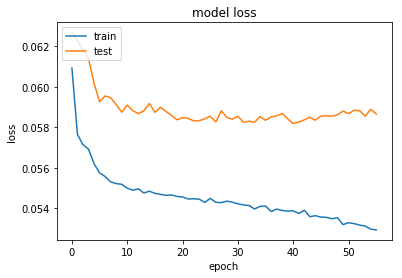

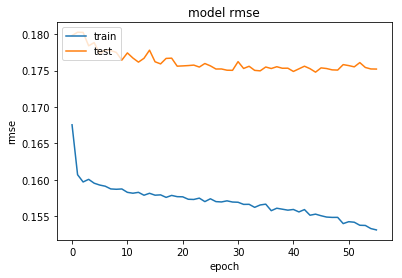

In [11]:
# summarize history for loss
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

plt.plot(history.history['rmse'])
plt.plot(history.history['val_rmse'])
plt.title('model rmse')
plt.ylabel('rmse')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

## Evaluate performance on validation data to improve model

In [12]:
model.load_weights(experiment_name+'.hdf5')

(6073, 25, 3) (6073, 10, 3)


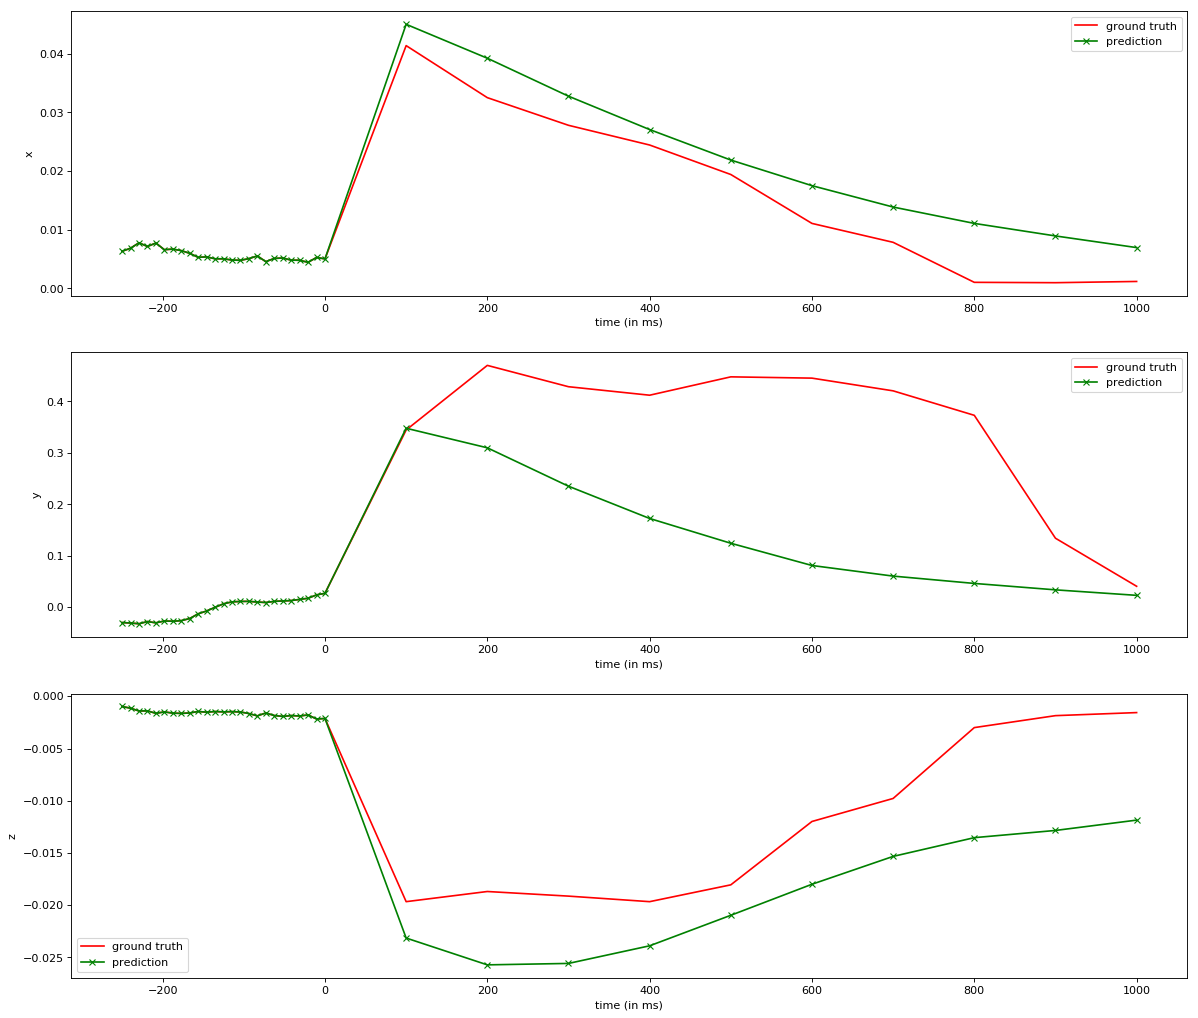

In [13]:
[encoder_input, decoder_input], Y_val = next(val_gen)
print(encoder_input.shape, Y_val.shape)
Y_pred = model.predict([encoder_input, decoder_input], verbose=0)

fig=plt.figure(figsize=(18, 16), dpi= 80)
plt.grid(True)
plt.axvline(x=0, c="b")
x_axis_pred = np.concatenate((np.linspace(-lookback, 0, num=n_lookback), np.linspace(step_delay, delays_list[-1], num=len(delays_list))))
time_sample = 700

plt.subplot(311)
plt.plot(x_axis_pred, np.concatenate((encoder_input[time_sample,:,0], Y_val[time_sample, :, 0])), label="ground truth", c='r')
plt.plot(x_axis_pred, np.concatenate((encoder_input[time_sample,:,0], Y_pred[time_sample, :, 0])), label="prediction", c='g', marker="x")
plt.ylabel("x")
plt.xlabel("time (in ms)")
plt.legend(loc='best')

plt.subplot(312)
plt.plot(x_axis_pred, np.concatenate((encoder_input[time_sample,:,1], Y_val[time_sample, :, 1])), label="ground truth", c='r')
plt.plot(x_axis_pred, np.concatenate((encoder_input[time_sample,:,1], Y_pred[time_sample, :, 1])), label="prediction", c='g', marker="x")
plt.ylabel("y")
plt.xlabel("time (in ms)")
plt.legend(loc='best')

plt.subplot(313)
plt.plot(x_axis_pred, np.concatenate((encoder_input[time_sample,:,2], Y_val[time_sample, :, 2])), label="ground truth", c='r')
plt.plot(x_axis_pred, np.concatenate((encoder_input[time_sample,:,2], Y_pred[time_sample, :, 2])), label="prediction", c='g', marker="x")
plt.ylabel("z")
plt.xlabel("time (in ms)")
plt.legend(loc='best')

In [14]:
#path_to_sensor_data_train = os.path.join(dir_path, "preprocessed_train")

val_gen_pred = data_generator_head_seq2seq_decoder_zeros(path_to_sensor_data_train,
                                         file_names_val,
                                         delays_list,
                                         n_max_delay,
                                         n_lookback,
                                         n_delay,
                                         inference=True
                                        )


predictions_mae_val = np.zeros((len(file_names_val), 1+len_delay))
predictions_rmse_val = np.zeros((len(file_names_val), 1+len_delay))
predictions_smape_val = np.zeros((len(file_names_val), 1+len_delay))
predictions_mfe_val = np.zeros((len(file_names_val), 1+len_delay))

def get_mae(Y1, Y2):
    return np.mean(np.absolute(Y1 - Y2))

def get_rmse(Y1, Y2):
    return np.sqrt(np.mean(np.square(Y1 - Y2)))

def get_smape(Y1, Y2):
    return 100 * np.mean(np.absolute(Y1 - Y2) / (np.absolute(Y2) + np.absolute(Y1)))

def get_mfe(Y_pred, Y_target):
    return np.mean(Y_pred - Y_target)


start = time.time()
print("Evaluating on validation data...")
count = 0
for [encoder_input, decoder_input], Y_val_abs in val_gen_pred:
    #Y_pred = model.predict([encoder_input, decoder_input], verbose=0)
    Y_pred_diff = model.predict([encoder_input, decoder_input[:, 1:]], verbose=0)
    
    # From normalized differences to absolute values
    Y_pred = np.zeros(Y_pred_diff.shape)
    for i in range(len_delay):
        Y_pred[:, i] = Y_val_abs[:,0] + np.sum(Y_pred_diff[:, :i+1], axis=1) * MAX_DIFF
        
    Y_val_abs = Y_val_abs[:, 1:]
        
    predictions_mae_val[count, 0] = get_mae(Y_pred, Y_val_abs)
    predictions_rmse_val[count, 0] = get_rmse(Y_pred, Y_val_abs)
    predictions_smape_val[count, 0] = get_smape(Y_pred, Y_val_abs)
    predictions_mfe_val[count, 0] = get_mfe(Y_pred, Y_val_abs)

    for ind_delay in range(0,len_delay):
        Y_delay_pred = Y_pred[:,ind_delay]
        Y_delay_val = Y_val_abs[:,ind_delay]
        
        predictions_mae_val[count, 1+ind_delay] = get_mae(Y_delay_pred, Y_delay_val)
        predictions_rmse_val[count, 1+ind_delay] = get_rmse(Y_delay_pred, Y_delay_val)
        predictions_smape_val[count, 1+ind_delay] = get_smape(Y_delay_pred, Y_delay_val)
        predictions_mfe_val[count, 1+ind_delay] = get_mfe(Y_delay_pred, Y_delay_val)
    
    count += 1
    if count == len(file_names_val):
        break

results_mae_val = np.mean(predictions_mae_val, axis=0)
results_rmse_val = np.mean(predictions_rmse_val, axis=0)
results_smape_val = np.mean(predictions_smape_val, axis=0)
results_mfe_val = np.mean(predictions_mfe_val, axis=0)

print("Evaluation Time : ", time.time() - start, "s = ", (time.time() - start)/60., "min = ",
      (time.time() - start)/3600., "h")

Evaluating on validation data...


Evaluation Time :  104.77706027030945 s =  1.7462843497594198 min =  0.029104739228884378 h


### Metrics

In [15]:
print("MAE")
print("Average mae:", results_mae_val[0])
for i, delay in enumerate(delays_list):
    print("Delay", delay, "ms:", results_mae_val[i+1])
print()    
print("RMSE")
print("Average rmse:", results_rmse_val[0])
for i, delay in enumerate(delays_list):
    print("Delay", delay, "ms:", results_rmse_val[i+1])
print()    
print("SMAPE")
print("Average smape:", results_smape_val[0])
for i, delay in enumerate(delays_list):
    print("Delay", delay, "ms:", results_smape_val[i+1])
print()
print("MFE")
print("Average mfe:", results_mfe_val[0])
for i, delay in enumerate(delays_list):
    print("Delay", delay, "ms:", results_mfe_val[i+1])

MAE
Average mae: 0.057593662097469585
Delay 100 ms: 0.004520568657748191
Delay 200 ms: 0.01283726232620581
Delay 300 ms: 0.02381967353476287
Delay 400 ms: 0.03617280387104363
Delay 500 ms: 0.04922218601115699
Delay 600 ms: 0.06267614962782196
Delay 700 ms: 0.07632631312010597
Delay 800 ms: 0.089982397203802
Delay 900 ms: 0.10352043873908146
Delay 1000 ms: 0.11685882788296677

RMSE
Average rmse: 0.12062145765783251
Delay 100 ms: 0.01158188415985317
Delay 200 ms: 0.026623694375949962
Delay 300 ms: 0.04636317160370014
Delay 400 ms: 0.06820207202466613
Delay 500 ms: 0.09078291605982282
Delay 600 ms: 0.11353557462478338
Delay 700 ms: 0.1360888205482209
Delay 800 ms: 0.1582396937334565
Delay 900 ms: 0.17985432476277646
Delay 1000 ms: 0.20080624199353916

SMAPE
Average smape: 14.29774893262416
Delay 100 ms: 2.240576237319213
Delay 200 ms: 5.298409800050893
Delay 300 ms: 8.363584854242658
Delay 400 ms: 11.226320333853778
Delay 500 ms: 13.84526474947593
Delay 600 ms: 16.25610507059789
Delay 700